In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        #初边界点数据
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #测试点数据
        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)

        # 计算 MAE
        mae = torch.mean(torch.abs(self.u_star - u_real_pred))
        # 计算 MSE
        mse = torch.mean((self.u_star - u_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)

        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights



        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [6]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)


#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.linspace(0, X_u_train_all.shape[0] - 1, N_u, dtype=int) #生成一个等差数列，从0到X_u_train的行数，间隔为1，赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子



    #2.生成配位点并进行训练

    nIter = 50000 #设置迭代次数为10000
    nIterLBFGS = 500 #设置LBFGS迭代次数为500

    # trainloss = [] #创建一个空列表，用于存储训练损失值
    # testerror = [] #创建一个空列表，用于存储测试误差值
    
    # 调用quasirandom函数生成配位点
    X_f_train = caiyang(N_f, "LHS")

    # X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter,nIterLBFGS)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred, f_pred = model.predict(X_star)
    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    
    


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<2:00:51,  6.89it/s]

Adam:   0%|          | 25/50000 [00:00<06:51, 121.40it/s]

Adam:   0%|          | 50/50000 [00:00<04:46, 174.43it/s]

Adam:   0%|          | 75/50000 [00:00<04:06, 202.24it/s]

Adam:   0%|          | 100/50000 [00:00<03:48, 218.27it/s]

Adam:   0%|          | 126/50000 [00:00<03:37, 229.48it/s]

Adam:   0%|          | 152/50000 [00:00<03:30, 236.93it/s]

Adam:   0%|          | 178/50000 [00:00<03:24, 244.00it/s]

Adam:   0%|          | 203/50000 [00:00<03:23, 244.30it/s]

Adam:   0%|          | 229/50000 [00:01<03:21, 247.58it/s]

Adam:   1%|          | 255/50000 [00:01<03:19, 249.88it/s]

Adam:   1%|          | 281/50000 [00:01<03:19, 249.53it/s]

Adam:   1%|          | 307/50000 [00:01<03:19, 248.86it/s]

Adam:   1%|          | 333/50000 [00:01<03:17, 251.48it/s]

Adam:   1%|          | 359/50000 [00:01<03:18, 250.53it/s]

Adam:   1%|          | 385/50000 [00:01<03:16, 252.29it/s]

Adam:   1%|          | 411/50000 [00:01<03:14, 254.53it/s]

Adam:   1%|          | 437/50000 [00:01<03:13, 256.11it/s]

Adam:   1%|          | 463/50000 [00:01<03:12, 257.17it/s]

Adam:   1%|          | 489/50000 [00:02<03:12, 257.29it/s]

Adam:   1%|          | 515/50000 [00:02<03:45, 219.29it/s]

Adam:   1%|          | 540/50000 [00:02<03:38, 226.48it/s]

Adam:   1%|          | 566/50000 [00:02<03:31, 233.38it/s]

Adam:   1%|          | 591/50000 [00:02<03:27, 237.73it/s]

Adam:   1%|          | 617/50000 [00:02<03:23, 242.58it/s]

Adam:   1%|▏         | 643/50000 [00:02<03:19, 247.15it/s]

Adam:   1%|▏         | 669/50000 [00:02<03:16, 250.45it/s]

Adam:   1%|▏         | 695/50000 [00:02<03:17, 249.63it/s]

Adam:   1%|▏         | 721/50000 [00:03<03:16, 251.24it/s]

Adam:   1%|▏         | 747/50000 [00:03<03:14, 253.70it/s]

Adam:   2%|▏         | 773/50000 [00:03<03:16, 250.82it/s]

Adam:   2%|▏         | 799/50000 [00:03<03:17, 249.56it/s]

Adam:   2%|▏         | 825/50000 [00:03<03:16, 250.77it/s]

Adam:   2%|▏         | 851/50000 [00:03<03:19, 245.80it/s]

Adam:   2%|▏         | 876/50000 [00:03<03:20, 245.03it/s]

Adam:   2%|▏         | 901/50000 [00:03<03:20, 245.12it/s]

Adam:   2%|▏         | 927/50000 [00:03<03:18, 247.50it/s]

Adam:   2%|▏         | 952/50000 [00:03<03:19, 246.15it/s]

Adam:   2%|▏         | 978/50000 [00:04<03:17, 247.85it/s]

Adam:   2%|▏         | 1003/50000 [00:04<03:17, 248.16it/s]

Adam:   2%|▏         | 1028/50000 [00:04<03:21, 243.63it/s]

Adam:   2%|▏         | 1053/50000 [00:04<03:20, 243.58it/s]

Adam:   2%|▏         | 1078/50000 [00:04<03:19, 245.42it/s]

Adam:   2%|▏         | 1104/50000 [00:04<03:17, 247.65it/s]

Adam:   2%|▏         | 1129/50000 [00:04<03:19, 245.17it/s]

Adam:   2%|▏         | 1155/50000 [00:04<03:15, 249.45it/s]

Adam:   2%|▏         | 1180/50000 [00:04<03:17, 247.52it/s]

Adam:   2%|▏         | 1206/50000 [00:05<03:15, 250.20it/s]

Adam:   2%|▏         | 1232/50000 [00:05<03:14, 251.25it/s]

Adam:   3%|▎         | 1258/50000 [00:05<03:12, 253.66it/s]

Adam:   3%|▎         | 1284/50000 [00:05<03:12, 253.51it/s]

Adam:   3%|▎         | 1310/50000 [00:05<03:11, 253.87it/s]

Adam:   3%|▎         | 1336/50000 [00:05<03:11, 253.82it/s]

Adam:   3%|▎         | 1362/50000 [00:05<03:12, 253.11it/s]

Adam:   3%|▎         | 1388/50000 [00:05<03:12, 252.40it/s]

Adam:   3%|▎         | 1414/50000 [00:05<03:11, 254.07it/s]

Adam:   3%|▎         | 1440/50000 [00:05<03:11, 253.71it/s]

Adam:   3%|▎         | 1466/50000 [00:06<03:11, 253.07it/s]

Adam:   3%|▎         | 1492/50000 [00:06<03:10, 254.78it/s]

Adam:   3%|▎         | 1518/50000 [00:06<03:09, 256.19it/s]

Adam:   3%|▎         | 1544/50000 [00:06<03:11, 252.96it/s]

Adam:   3%|▎         | 1570/50000 [00:06<03:09, 254.99it/s]

Adam:   3%|▎         | 1596/50000 [00:06<03:08, 256.20it/s]

Adam:   3%|▎         | 1622/50000 [00:06<03:08, 257.27it/s]

Adam:   3%|▎         | 1648/50000 [00:06<03:11, 252.87it/s]

Adam:   3%|▎         | 1674/50000 [00:06<03:10, 254.29it/s]

Adam:   3%|▎         | 1700/50000 [00:06<03:10, 253.33it/s]

Adam:   3%|▎         | 1726/50000 [00:07<03:10, 252.75it/s]

Adam:   4%|▎         | 1752/50000 [00:07<03:12, 251.05it/s]

Adam:   4%|▎         | 1778/50000 [00:07<03:12, 250.32it/s]

Adam:   4%|▎         | 1804/50000 [00:07<03:11, 252.16it/s]

Adam:   4%|▎         | 1830/50000 [00:07<03:10, 252.71it/s]

Adam:   4%|▎         | 1856/50000 [00:07<03:13, 248.98it/s]

Adam:   4%|▍         | 1881/50000 [00:07<03:14, 247.01it/s]

Adam:   4%|▍         | 1906/50000 [00:07<03:14, 246.71it/s]

Adam:   4%|▍         | 1932/50000 [00:07<03:12, 249.46it/s]

Adam:   4%|▍         | 1957/50000 [00:07<03:14, 247.45it/s]

Adam:   4%|▍         | 1982/50000 [00:08<03:15, 245.47it/s]

Adam:   4%|▍         | 2007/50000 [00:08<03:25, 233.03it/s]

Adam:   4%|▍         | 2033/50000 [00:08<03:21, 238.42it/s]

Adam:   4%|▍         | 2057/50000 [00:08<03:21, 237.85it/s]

Adam:   4%|▍         | 2082/50000 [00:08<03:19, 240.04it/s]

Adam:   4%|▍         | 2107/50000 [00:08<03:21, 237.36it/s]

Adam:   4%|▍         | 2133/50000 [00:08<03:17, 242.17it/s]

Adam:   4%|▍         | 2159/50000 [00:08<03:13, 247.12it/s]

Adam:   4%|▍         | 2184/50000 [00:08<03:13, 247.00it/s]

Adam:   4%|▍         | 2210/50000 [00:09<03:12, 248.24it/s]

Adam:   4%|▍         | 2236/50000 [00:09<03:10, 250.91it/s]

Adam:   5%|▍         | 2262/50000 [00:09<03:09, 252.57it/s]

Adam:   5%|▍         | 2288/50000 [00:09<03:08, 253.40it/s]

Adam:   5%|▍         | 2314/50000 [00:09<03:11, 249.43it/s]

Adam:   5%|▍         | 2339/50000 [00:09<03:11, 248.45it/s]

Adam:   5%|▍         | 2365/50000 [00:09<03:09, 251.51it/s]

Adam:   5%|▍         | 2391/50000 [00:09<03:09, 251.01it/s]

Adam:   5%|▍         | 2417/50000 [00:09<03:12, 247.39it/s]

Adam:   5%|▍         | 2443/50000 [00:09<03:10, 249.07it/s]

Adam:   5%|▍         | 2468/50000 [00:10<03:11, 247.73it/s]

Adam:   5%|▍         | 2493/50000 [00:10<03:12, 246.63it/s]

Adam:   5%|▌         | 2519/50000 [00:10<03:11, 247.99it/s]

Adam:   5%|▌         | 2544/50000 [00:10<03:11, 247.31it/s]

Adam:   5%|▌         | 2570/50000 [00:10<03:09, 250.22it/s]

Adam:   5%|▌         | 2596/50000 [00:10<03:12, 246.30it/s]

Adam:   5%|▌         | 2621/50000 [00:10<03:11, 247.19it/s]

Adam:   5%|▌         | 2646/50000 [00:10<03:13, 244.70it/s]

Adam:   5%|▌         | 2671/50000 [00:10<03:15, 242.60it/s]

Adam:   5%|▌         | 2696/50000 [00:11<03:25, 230.09it/s]

Adam:   5%|▌         | 2721/50000 [00:11<03:21, 234.94it/s]

Adam:   5%|▌         | 2745/50000 [00:11<03:52, 203.66it/s]

Adam:   6%|▌         | 2770/50000 [00:11<03:40, 214.28it/s]

Adam:   6%|▌         | 2794/50000 [00:11<03:35, 219.34it/s]

Adam:   6%|▌         | 2819/50000 [00:11<03:27, 227.37it/s]

Adam:   6%|▌         | 2844/50000 [00:11<03:23, 231.63it/s]

Adam:   6%|▌         | 2869/50000 [00:11<03:19, 235.96it/s]

Adam:   6%|▌         | 2893/50000 [00:11<03:19, 236.56it/s]

Adam:   6%|▌         | 2918/50000 [00:11<03:16, 239.13it/s]

Adam:   6%|▌         | 2943/50000 [00:12<03:18, 237.01it/s]

Adam:   6%|▌         | 2968/50000 [00:12<03:16, 239.69it/s]

Adam:   6%|▌         | 2993/50000 [00:12<03:15, 240.23it/s]

Adam:   6%|▌         | 3018/50000 [00:12<03:14, 241.70it/s]

Adam:   6%|▌         | 3043/50000 [00:12<03:13, 242.44it/s]

Adam:   6%|▌         | 3068/50000 [00:12<03:12, 243.29it/s]

Adam:   6%|▌         | 3093/50000 [00:12<03:12, 243.77it/s]

Adam:   6%|▌         | 3118/50000 [00:12<03:11, 244.43it/s]

Adam:   6%|▋         | 3143/50000 [00:12<03:11, 244.23it/s]

Adam:   6%|▋         | 3168/50000 [00:13<03:12, 243.80it/s]

Adam:   6%|▋         | 3193/50000 [00:13<03:12, 243.66it/s]

Adam:   6%|▋         | 3218/50000 [00:13<03:12, 243.26it/s]

Adam:   6%|▋         | 3243/50000 [00:13<03:13, 241.41it/s]

Adam:   7%|▋         | 3268/50000 [00:13<03:15, 238.98it/s]

Adam:   7%|▋         | 3292/50000 [00:13<03:22, 230.77it/s]

Adam:   7%|▋         | 3316/50000 [00:13<03:28, 223.95it/s]

Adam:   7%|▋         | 3341/50000 [00:13<03:23, 229.61it/s]

Adam:   7%|▋         | 3366/50000 [00:13<03:20, 232.63it/s]

Adam:   7%|▋         | 3390/50000 [00:13<03:19, 233.69it/s]

Adam:   7%|▋         | 3415/50000 [00:14<03:17, 236.44it/s]

Adam:   7%|▋         | 3440/50000 [00:14<03:14, 238.84it/s]

Adam:   7%|▋         | 3465/50000 [00:14<03:13, 241.00it/s]

Adam:   7%|▋         | 3490/50000 [00:14<03:13, 240.22it/s]

Adam:   7%|▋         | 3515/50000 [00:14<03:12, 240.86it/s]

Adam:   7%|▋         | 3540/50000 [00:14<03:13, 239.71it/s]

Adam:   7%|▋         | 3565/50000 [00:14<03:12, 241.53it/s]

Adam:   7%|▋         | 3590/50000 [00:14<03:11, 242.76it/s]

Adam:   7%|▋         | 3615/50000 [00:14<03:12, 241.12it/s]

Adam:   7%|▋         | 3640/50000 [00:15<03:12, 240.66it/s]

Adam:   7%|▋         | 3665/50000 [00:15<03:12, 240.86it/s]

Adam:   7%|▋         | 3690/50000 [00:15<03:11, 241.83it/s]

Adam:   7%|▋         | 3715/50000 [00:15<03:12, 240.29it/s]

Adam:   7%|▋         | 3740/50000 [00:15<03:12, 240.18it/s]

Adam:   8%|▊         | 3765/50000 [00:15<03:13, 239.34it/s]

Adam:   8%|▊         | 3790/50000 [00:15<03:11, 241.31it/s]

Adam:   8%|▊         | 3815/50000 [00:15<03:11, 241.77it/s]

Adam:   8%|▊         | 3840/50000 [00:15<03:10, 242.20it/s]

Adam:   8%|▊         | 3865/50000 [00:15<03:09, 242.92it/s]

Adam:   8%|▊         | 3890/50000 [00:16<03:09, 243.18it/s]

Adam:   8%|▊         | 3915/50000 [00:16<03:10, 241.37it/s]

Adam:   8%|▊         | 3940/50000 [00:16<03:12, 239.21it/s]

Adam:   8%|▊         | 3964/50000 [00:16<03:22, 227.28it/s]

Adam:   8%|▊         | 3988/50000 [00:16<03:22, 226.85it/s]

Adam:   8%|▊         | 4011/50000 [00:16<03:23, 226.37it/s]

Adam:   8%|▊         | 4035/50000 [00:16<03:21, 228.00it/s]

Adam:   8%|▊         | 4059/50000 [00:16<03:19, 230.29it/s]

Adam:   8%|▊         | 4083/50000 [00:16<03:21, 228.36it/s]

Adam:   8%|▊         | 4109/50000 [00:16<03:14, 235.44it/s]

Adam:   8%|▊         | 4134/50000 [00:17<03:12, 238.14it/s]

Adam:   8%|▊         | 4159/50000 [00:17<03:09, 241.49it/s]

Adam:   8%|▊         | 4185/50000 [00:17<03:07, 244.97it/s]

Adam:   8%|▊         | 4210/50000 [00:17<03:15, 233.74it/s]

Adam:   8%|▊         | 4236/50000 [00:17<03:11, 239.11it/s]

Adam:   9%|▊         | 4262/50000 [00:17<03:07, 243.42it/s]

Adam:   9%|▊         | 4287/50000 [00:17<03:07, 243.46it/s]

Adam:   9%|▊         | 4312/50000 [00:17<03:06, 245.22it/s]

Adam:   9%|▊         | 4337/50000 [00:17<03:05, 245.71it/s]

Adam:   9%|▊         | 4362/50000 [00:18<03:05, 245.80it/s]

Adam:   9%|▉         | 4388/50000 [00:18<03:03, 248.24it/s]

Adam:   9%|▉         | 4413/50000 [00:18<03:03, 248.72it/s]

Adam:   9%|▉         | 4439/50000 [00:18<03:02, 249.81it/s]

Adam:   9%|▉         | 4464/50000 [00:18<03:06, 244.05it/s]

Adam:   9%|▉         | 4490/50000 [00:18<03:04, 246.14it/s]

Adam:   9%|▉         | 4516/50000 [00:18<03:03, 248.01it/s]

Adam:   9%|▉         | 4542/50000 [00:18<03:02, 248.90it/s]

Adam:   9%|▉         | 4567/50000 [00:18<03:05, 245.04it/s]

Adam:   9%|▉         | 4593/50000 [00:18<03:04, 246.69it/s]

Adam:   9%|▉         | 4618/50000 [00:19<03:11, 237.54it/s]

Adam:   9%|▉         | 4643/50000 [00:19<03:08, 240.46it/s]

Adam:   9%|▉         | 4668/50000 [00:19<03:08, 240.85it/s]

Adam:   9%|▉         | 4694/50000 [00:19<03:05, 244.20it/s]

Adam:   9%|▉         | 4720/50000 [00:19<03:03, 246.45it/s]

Adam:   9%|▉         | 4746/50000 [00:19<03:02, 247.77it/s]

Adam:  10%|▉         | 4772/50000 [00:19<03:01, 248.98it/s]

Adam:  10%|▉         | 4797/50000 [00:19<03:06, 242.98it/s]

Adam:  10%|▉         | 4823/50000 [00:19<03:03, 245.58it/s]

Adam:  10%|▉         | 4849/50000 [00:20<03:02, 247.36it/s]

Adam:  10%|▉         | 4874/50000 [00:20<03:02, 247.61it/s]

Adam:  10%|▉         | 4899/50000 [00:20<03:02, 247.38it/s]

Adam:  10%|▉         | 4925/50000 [00:20<03:01, 248.78it/s]

Adam:  10%|▉         | 4951/50000 [00:20<03:00, 249.46it/s]

Adam:  10%|▉         | 4977/50000 [00:20<02:59, 250.25it/s]

Adam:  10%|█         | 5003/50000 [00:20<03:00, 248.80it/s]

Adam:  10%|█         | 5028/50000 [00:20<03:00, 248.74it/s]

Adam:  10%|█         | 5054/50000 [00:20<02:59, 250.05it/s]

Adam:  10%|█         | 5080/50000 [00:20<02:59, 249.99it/s]

Adam:  10%|█         | 5106/50000 [00:21<02:59, 249.62it/s]

Adam:  10%|█         | 5131/50000 [00:21<02:59, 249.68it/s]

Adam:  10%|█         | 5157/50000 [00:21<02:59, 250.12it/s]

Adam:  10%|█         | 5183/50000 [00:21<03:00, 247.86it/s]

Adam:  10%|█         | 5208/50000 [00:21<03:00, 248.47it/s]

Adam:  10%|█         | 5234/50000 [00:21<02:59, 249.04it/s]

Adam:  11%|█         | 5260/50000 [00:21<02:58, 250.15it/s]

Adam:  11%|█         | 5286/50000 [00:21<02:58, 249.97it/s]

Adam:  11%|█         | 5311/50000 [00:21<02:59, 248.51it/s]

Adam:  11%|█         | 5337/50000 [00:21<02:59, 249.42it/s]

Adam:  11%|█         | 5363/50000 [00:22<02:58, 249.80it/s]

Adam:  11%|█         | 5389/50000 [00:22<02:58, 249.95it/s]

Adam:  11%|█         | 5415/50000 [00:22<02:58, 250.17it/s]

Adam:  11%|█         | 5441/50000 [00:22<03:00, 246.98it/s]

Adam:  11%|█         | 5467/50000 [00:22<02:59, 248.11it/s]

Adam:  11%|█         | 5493/50000 [00:22<02:58, 248.75it/s]

Adam:  11%|█         | 5518/50000 [00:22<02:59, 248.46it/s]

Adam:  11%|█         | 5544/50000 [00:22<02:58, 249.74it/s]

Adam:  11%|█         | 5570/50000 [00:22<02:57, 250.65it/s]

Adam:  11%|█         | 5596/50000 [00:23<02:56, 251.55it/s]

Adam:  11%|█         | 5622/50000 [00:23<02:56, 251.09it/s]

Adam:  11%|█▏        | 5648/50000 [00:23<02:56, 250.86it/s]

Adam:  11%|█▏        | 5674/50000 [00:23<03:01, 243.58it/s]

Adam:  11%|█▏        | 5700/50000 [00:23<02:59, 246.17it/s]

Adam:  11%|█▏        | 5725/50000 [00:23<02:59, 246.18it/s]

Adam:  12%|█▏        | 5750/50000 [00:23<02:59, 245.84it/s]

Adam:  12%|█▏        | 5775/50000 [00:23<02:59, 246.16it/s]

Adam:  12%|█▏        | 5801/50000 [00:23<02:57, 248.45it/s]

Adam:  12%|█▏        | 5827/50000 [00:23<02:57, 249.05it/s]

Adam:  12%|█▏        | 5853/50000 [00:24<02:56, 249.97it/s]

Adam:  12%|█▏        | 5879/50000 [00:24<02:58, 246.78it/s]

Adam:  12%|█▏        | 5904/50000 [00:24<02:58, 247.66it/s]

Adam:  12%|█▏        | 5929/50000 [00:24<02:57, 247.66it/s]

Adam:  12%|█▏        | 5955/50000 [00:24<02:56, 249.20it/s]

Adam:  12%|█▏        | 5980/50000 [00:24<02:57, 248.59it/s]

Adam:  12%|█▏        | 6006/50000 [00:24<02:56, 249.26it/s]

Adam:  12%|█▏        | 6031/50000 [00:24<02:57, 247.69it/s]

Adam:  12%|█▏        | 6057/50000 [00:24<02:56, 248.46it/s]

Adam:  12%|█▏        | 6082/50000 [00:24<02:56, 248.13it/s]

Adam:  12%|█▏        | 6107/50000 [00:25<02:56, 248.25it/s]

Adam:  12%|█▏        | 6132/50000 [00:25<02:56, 248.08it/s]

Adam:  12%|█▏        | 6158/50000 [00:25<02:56, 248.94it/s]

Adam:  12%|█▏        | 6183/50000 [00:25<03:31, 207.40it/s]

Adam:  12%|█▏        | 6208/50000 [00:25<03:21, 217.54it/s]

Adam:  12%|█▏        | 6233/50000 [00:25<03:14, 225.41it/s]

Adam:  13%|█▎        | 6259/50000 [00:25<03:07, 232.76it/s]

Adam:  13%|█▎        | 6285/50000 [00:25<03:03, 238.23it/s]

Adam:  13%|█▎        | 6311/50000 [00:25<03:00, 241.93it/s]

Adam:  13%|█▎        | 6337/50000 [00:26<02:58, 245.26it/s]

Adam:  13%|█▎        | 6363/50000 [00:26<02:56, 247.61it/s]

Adam:  13%|█▎        | 6388/50000 [00:26<02:59, 243.00it/s]

Adam:  13%|█▎        | 6413/50000 [00:26<02:58, 244.37it/s]

Adam:  13%|█▎        | 6438/50000 [00:26<02:57, 245.71it/s]

Adam:  13%|█▎        | 6463/50000 [00:26<02:56, 246.48it/s]

Adam:  13%|█▎        | 6489/50000 [00:26<02:55, 248.45it/s]

Adam:  13%|█▎        | 6515/50000 [00:26<02:54, 249.33it/s]

Adam:  13%|█▎        | 6541/50000 [00:26<02:53, 250.00it/s]

Adam:  13%|█▎        | 6567/50000 [00:26<02:53, 250.79it/s]

Adam:  13%|█▎        | 6593/50000 [00:27<02:58, 243.44it/s]

Adam:  13%|█▎        | 6618/50000 [00:27<02:57, 244.30it/s]

Adam:  13%|█▎        | 6644/50000 [00:27<02:55, 246.68it/s]

Adam:  13%|█▎        | 6670/50000 [00:27<02:54, 248.41it/s]

Adam:  13%|█▎        | 6696/50000 [00:27<02:53, 249.19it/s]

Adam:  13%|█▎        | 6721/50000 [00:27<02:54, 248.11it/s]

Adam:  13%|█▎        | 6746/50000 [00:27<02:54, 247.73it/s]

Adam:  14%|█▎        | 6772/50000 [00:27<02:53, 249.49it/s]

Adam:  14%|█▎        | 6798/50000 [00:27<02:52, 250.64it/s]

Adam:  14%|█▎        | 6824/50000 [00:28<02:51, 251.21it/s]

Adam:  14%|█▎        | 6850/50000 [00:28<02:51, 250.95it/s]

Adam:  14%|█▍        | 6876/50000 [00:28<02:52, 249.75it/s]

Adam:  14%|█▍        | 6902/50000 [00:28<02:52, 250.19it/s]

Adam:  14%|█▍        | 6928/50000 [00:28<02:52, 250.23it/s]

Adam:  14%|█▍        | 6954/50000 [00:28<02:51, 251.03it/s]

Adam:  14%|█▍        | 6980/50000 [00:28<02:50, 251.73it/s]

Adam:  14%|█▍        | 7006/50000 [00:28<02:52, 249.93it/s]

Adam:  14%|█▍        | 7031/50000 [00:28<02:52, 249.28it/s]

Adam:  14%|█▍        | 7057/50000 [00:28<02:51, 249.89it/s]

Adam:  14%|█▍        | 7082/50000 [00:29<02:55, 245.09it/s]

Adam:  14%|█▍        | 7108/50000 [00:29<02:53, 247.15it/s]

Adam:  14%|█▍        | 7134/50000 [00:29<02:52, 248.38it/s]

Adam:  14%|█▍        | 7160/50000 [00:29<02:52, 249.06it/s]

Adam:  14%|█▍        | 7185/50000 [00:29<02:53, 246.78it/s]

Adam:  14%|█▍        | 7210/50000 [00:29<02:55, 244.13it/s]

Adam:  14%|█▍        | 7236/50000 [00:29<02:53, 246.26it/s]

Adam:  15%|█▍        | 7262/50000 [00:29<02:52, 247.99it/s]

Adam:  15%|█▍        | 7288/50000 [00:29<02:50, 249.90it/s]

Adam:  15%|█▍        | 7314/50000 [00:29<02:50, 250.28it/s]

Adam:  15%|█▍        | 7340/50000 [00:30<02:53, 246.14it/s]

Adam:  15%|█▍        | 7366/50000 [00:30<02:52, 247.61it/s]

Adam:  15%|█▍        | 7392/50000 [00:30<02:50, 249.27it/s]

Adam:  15%|█▍        | 7418/50000 [00:30<02:50, 250.07it/s]

Adam:  15%|█▍        | 7444/50000 [00:30<02:51, 248.61it/s]

Adam:  15%|█▍        | 7469/50000 [00:30<02:51, 247.69it/s]

Adam:  15%|█▍        | 7495/50000 [00:30<02:51, 248.49it/s]

Adam:  15%|█▌        | 7520/50000 [00:30<02:50, 248.63it/s]

Adam:  15%|█▌        | 7545/50000 [00:30<02:50, 248.91it/s]

Adam:  15%|█▌        | 7570/50000 [00:31<02:52, 245.42it/s]

Adam:  15%|█▌        | 7595/50000 [00:31<02:53, 244.05it/s]

Adam:  15%|█▌        | 7620/50000 [00:31<02:54, 243.48it/s]

Adam:  15%|█▌        | 7645/50000 [00:31<02:59, 235.62it/s]

Adam:  15%|█▌        | 7671/50000 [00:31<02:56, 240.26it/s]

Adam:  15%|█▌        | 7696/50000 [00:31<02:54, 242.23it/s]

Adam:  15%|█▌        | 7721/50000 [00:31<02:56, 239.74it/s]

Adam:  15%|█▌        | 7746/50000 [00:31<02:54, 242.46it/s]

Adam:  16%|█▌        | 7771/50000 [00:31<02:53, 242.74it/s]

Adam:  16%|█▌        | 7797/50000 [00:31<02:51, 245.45it/s]

Adam:  16%|█▌        | 7822/50000 [00:32<02:51, 246.64it/s]

Adam:  16%|█▌        | 7848/50000 [00:32<02:50, 247.83it/s]

Adam:  16%|█▌        | 7874/50000 [00:32<02:49, 248.53it/s]

Adam:  16%|█▌        | 7899/50000 [00:32<02:49, 248.96it/s]

Adam:  16%|█▌        | 7924/50000 [00:32<02:49, 248.03it/s]

Adam:  16%|█▌        | 7949/50000 [00:32<02:51, 245.59it/s]

Adam:  16%|█▌        | 7975/50000 [00:32<02:49, 247.85it/s]

Adam:  16%|█▌        | 8000/50000 [00:32<02:50, 247.01it/s]

Adam:  16%|█▌        | 8025/50000 [00:32<02:52, 243.15it/s]

Adam:  16%|█▌        | 8051/50000 [00:32<02:50, 245.61it/s]

Adam:  16%|█▌        | 8077/50000 [00:33<02:49, 247.18it/s]

Adam:  16%|█▌        | 8102/50000 [00:33<02:48, 247.98it/s]

Adam:  16%|█▋        | 8127/50000 [00:33<02:51, 244.11it/s]

Adam:  16%|█▋        | 8152/50000 [00:33<02:50, 245.64it/s]

Adam:  16%|█▋        | 8177/50000 [00:33<02:49, 246.12it/s]

Adam:  16%|█▋        | 8203/50000 [00:33<02:49, 247.30it/s]

Adam:  16%|█▋        | 8229/50000 [00:33<02:47, 248.72it/s]

Adam:  17%|█▋        | 8255/50000 [00:33<02:46, 249.99it/s]

Adam:  17%|█▋        | 8281/50000 [00:33<02:46, 251.08it/s]

Adam:  17%|█▋        | 8307/50000 [00:34<02:48, 247.68it/s]

Adam:  17%|█▋        | 8332/50000 [00:34<02:48, 247.67it/s]

Adam:  17%|█▋        | 8357/50000 [00:34<02:48, 246.88it/s]

Adam:  17%|█▋        | 8382/50000 [00:34<02:48, 247.72it/s]

Adam:  17%|█▋        | 8407/50000 [00:34<02:47, 248.22it/s]

Adam:  17%|█▋        | 8432/50000 [00:34<02:49, 245.46it/s]

Adam:  17%|█▋        | 8457/50000 [00:34<02:50, 242.96it/s]

Adam:  17%|█▋        | 8483/50000 [00:34<02:48, 245.97it/s]

Adam:  17%|█▋        | 8508/50000 [00:34<02:48, 246.28it/s]

Adam:  17%|█▋        | 8534/50000 [00:34<02:47, 248.22it/s]

Adam:  17%|█▋        | 8559/50000 [00:35<02:47, 247.03it/s]

Adam:  17%|█▋        | 8585/50000 [00:35<02:46, 248.54it/s]

Adam:  17%|█▋        | 8611/50000 [00:35<02:45, 249.79it/s]

Adam:  17%|█▋        | 8637/50000 [00:35<02:45, 250.40it/s]

Adam:  17%|█▋        | 8663/50000 [00:35<02:44, 250.59it/s]

Adam:  17%|█▋        | 8689/50000 [00:35<02:45, 250.20it/s]

Adam:  17%|█▋        | 8715/50000 [00:35<02:44, 250.85it/s]

Adam:  17%|█▋        | 8741/50000 [00:35<02:44, 250.94it/s]

Adam:  18%|█▊        | 8767/50000 [00:35<02:45, 249.64it/s]

Adam:  18%|█▊        | 8793/50000 [00:35<02:44, 250.42it/s]

Adam:  18%|█▊        | 8819/50000 [00:36<02:44, 250.76it/s]

Adam:  18%|█▊        | 8845/50000 [00:36<02:44, 250.65it/s]

Adam:  18%|█▊        | 8871/50000 [00:36<02:43, 250.82it/s]

Adam:  18%|█▊        | 8897/50000 [00:36<02:43, 250.97it/s]

Adam:  18%|█▊        | 8923/50000 [00:36<02:43, 250.96it/s]

Adam:  18%|█▊        | 8949/50000 [00:36<02:43, 250.84it/s]

Adam:  18%|█▊        | 8975/50000 [00:36<02:43, 251.31it/s]

Adam:  18%|█▊        | 9001/50000 [00:36<02:47, 244.28it/s]

Adam:  18%|█▊        | 9027/50000 [00:36<02:46, 246.73it/s]

Adam:  18%|█▊        | 9053/50000 [00:37<02:45, 247.98it/s]

Adam:  18%|█▊        | 9079/50000 [00:37<02:44, 248.69it/s]

Adam:  18%|█▊        | 9105/50000 [00:37<02:44, 249.23it/s]

Adam:  18%|█▊        | 9131/50000 [00:37<02:43, 250.15it/s]

Adam:  18%|█▊        | 9157/50000 [00:37<02:44, 248.64it/s]

Adam:  18%|█▊        | 9182/50000 [00:37<02:44, 247.95it/s]

Adam:  18%|█▊        | 9207/50000 [00:37<02:45, 247.22it/s]

Adam:  18%|█▊        | 9232/50000 [00:37<02:49, 240.09it/s]

Adam:  19%|█▊        | 9257/50000 [00:37<02:48, 241.77it/s]

Adam:  19%|█▊        | 9282/50000 [00:37<02:47, 243.82it/s]

Adam:  19%|█▊        | 9308/50000 [00:38<02:45, 246.35it/s]

Adam:  19%|█▊        | 9333/50000 [00:38<02:49, 240.03it/s]

Adam:  19%|█▊        | 9358/50000 [00:38<02:53, 234.79it/s]

Adam:  19%|█▉        | 9384/50000 [00:38<02:49, 239.78it/s]

Adam:  19%|█▉        | 9409/50000 [00:38<02:47, 242.63it/s]

Adam:  19%|█▉        | 9434/50000 [00:38<02:45, 244.65it/s]

Adam:  19%|█▉        | 9460/50000 [00:38<02:43, 247.61it/s]

Adam:  19%|█▉        | 9486/50000 [00:38<02:42, 248.69it/s]

Adam:  19%|█▉        | 9512/50000 [00:38<02:42, 249.49it/s]

Adam:  19%|█▉        | 9538/50000 [00:38<02:41, 249.86it/s]

Adam:  19%|█▉        | 9563/50000 [00:39<02:42, 248.25it/s]

Adam:  19%|█▉        | 9589/50000 [00:39<02:41, 249.79it/s]

Adam:  19%|█▉        | 9614/50000 [00:39<02:42, 248.19it/s]

Adam:  19%|█▉        | 9639/50000 [00:39<02:53, 232.32it/s]

Adam:  19%|█▉        | 9664/50000 [00:39<02:50, 236.71it/s]

Adam:  19%|█▉        | 9689/50000 [00:39<02:48, 239.20it/s]

Adam:  19%|█▉        | 9715/50000 [00:39<02:45, 242.89it/s]

Adam:  19%|█▉        | 9741/50000 [00:39<02:43, 245.74it/s]

Adam:  20%|█▉        | 9767/50000 [00:39<02:42, 247.52it/s]

Adam:  20%|█▉        | 9793/50000 [00:40<02:41, 249.21it/s]

Adam:  20%|█▉        | 9819/50000 [00:40<02:40, 250.44it/s]

Adam:  20%|█▉        | 9845/50000 [00:40<02:40, 250.54it/s]

Adam:  20%|█▉        | 9871/50000 [00:40<02:40, 250.74it/s]

Adam:  20%|█▉        | 9897/50000 [00:40<02:43, 244.83it/s]

Adam:  20%|█▉        | 9922/50000 [00:40<02:44, 244.18it/s]

Adam:  20%|█▉        | 9948/50000 [00:40<02:42, 246.92it/s]

Adam:  20%|█▉        | 9974/50000 [00:40<02:41, 248.60it/s]

Adam:  20%|██        | 10000/50000 [00:40<02:40, 249.55it/s]

Adam:  20%|██        | 10025/50000 [00:40<02:44, 242.70it/s]

Adam:  20%|██        | 10050/50000 [00:41<02:43, 244.14it/s]

Adam:  20%|██        | 10076/50000 [00:41<02:41, 246.81it/s]

Adam:  20%|██        | 10101/50000 [00:41<02:41, 247.10it/s]

Adam:  20%|██        | 10127/50000 [00:41<02:40, 248.62it/s]

Adam:  20%|██        | 10152/50000 [00:41<02:41, 247.23it/s]

Adam:  20%|██        | 10178/50000 [00:41<02:39, 248.92it/s]

Adam:  20%|██        | 10204/50000 [00:41<02:39, 250.15it/s]

Adam:  20%|██        | 10230/50000 [00:41<02:40, 248.00it/s]

Adam:  21%|██        | 10256/50000 [00:41<02:39, 249.27it/s]

Adam:  21%|██        | 10282/50000 [00:42<02:38, 250.80it/s]

Adam:  21%|██        | 10308/50000 [00:42<02:37, 251.37it/s]

Adam:  21%|██        | 10334/50000 [00:42<02:39, 248.04it/s]

Adam:  21%|██        | 10359/50000 [00:42<02:45, 239.14it/s]

Adam:  21%|██        | 10384/50000 [00:42<02:44, 240.44it/s]

Adam:  21%|██        | 10410/50000 [00:42<02:42, 243.43it/s]

Adam:  21%|██        | 10436/50000 [00:42<02:40, 246.03it/s]

Adam:  21%|██        | 10462/50000 [00:42<02:39, 248.15it/s]

Adam:  21%|██        | 10488/50000 [00:42<02:38, 249.54it/s]

Adam:  21%|██        | 10513/50000 [00:42<02:39, 247.88it/s]

Adam:  21%|██        | 10539/50000 [00:43<02:38, 249.51it/s]

Adam:  21%|██        | 10565/50000 [00:43<02:37, 250.91it/s]

Adam:  21%|██        | 10591/50000 [00:43<02:37, 250.88it/s]

Adam:  21%|██        | 10617/50000 [00:43<02:36, 251.50it/s]

Adam:  21%|██▏       | 10643/50000 [00:43<02:36, 251.73it/s]

Adam:  21%|██▏       | 10669/50000 [00:43<02:36, 251.98it/s]

Adam:  21%|██▏       | 10695/50000 [00:43<02:35, 252.35it/s]

Adam:  21%|██▏       | 10721/50000 [00:43<02:35, 253.02it/s]

Adam:  21%|██▏       | 10747/50000 [00:43<02:35, 252.95it/s]

Adam:  22%|██▏       | 10773/50000 [00:43<02:35, 251.96it/s]

Adam:  22%|██▏       | 10799/50000 [00:44<02:35, 251.94it/s]

Adam:  22%|██▏       | 10825/50000 [00:44<02:35, 252.50it/s]

Adam:  22%|██▏       | 10851/50000 [00:44<02:35, 251.99it/s]

Adam:  22%|██▏       | 10877/50000 [00:44<02:35, 252.11it/s]

Adam:  22%|██▏       | 10903/50000 [00:44<02:38, 245.98it/s]

Adam:  22%|██▏       | 10928/50000 [00:44<02:40, 243.82it/s]

Adam:  22%|██▏       | 10953/50000 [00:44<02:39, 244.48it/s]

Adam:  22%|██▏       | 10978/50000 [00:44<02:38, 246.00it/s]

Adam:  22%|██▏       | 11003/50000 [00:44<02:38, 246.05it/s]

Adam:  22%|██▏       | 11029/50000 [00:45<02:37, 247.62it/s]

Adam:  22%|██▏       | 11055/50000 [00:45<02:36, 248.70it/s]

Adam:  22%|██▏       | 11081/50000 [00:45<02:36, 249.29it/s]

Adam:  22%|██▏       | 11107/50000 [00:45<02:35, 250.15it/s]

Adam:  22%|██▏       | 11133/50000 [00:45<02:35, 250.12it/s]

Adam:  22%|██▏       | 11159/50000 [00:45<02:34, 251.00it/s]

Adam:  22%|██▏       | 11185/50000 [00:45<02:34, 251.56it/s]

Adam:  22%|██▏       | 11211/50000 [00:45<02:33, 252.04it/s]

Adam:  22%|██▏       | 11237/50000 [00:45<02:33, 252.35it/s]

Adam:  23%|██▎       | 11263/50000 [00:45<02:33, 252.33it/s]

Adam:  23%|██▎       | 11289/50000 [00:46<02:33, 251.43it/s]

Adam:  23%|██▎       | 11315/50000 [00:46<02:33, 251.50it/s]

Adam:  23%|██▎       | 11341/50000 [00:46<02:33, 251.21it/s]

Adam:  23%|██▎       | 11367/50000 [00:46<02:33, 251.14it/s]

Adam:  23%|██▎       | 11393/50000 [00:46<02:33, 251.64it/s]

Adam:  23%|██▎       | 11419/50000 [00:46<02:34, 249.18it/s]

Adam:  23%|██▎       | 11444/50000 [00:46<02:34, 249.00it/s]

Adam:  23%|██▎       | 11470/50000 [00:46<02:34, 250.19it/s]

Adam:  23%|██▎       | 11496/50000 [00:46<02:33, 250.85it/s]

Adam:  23%|██▎       | 11522/50000 [00:46<02:33, 251.25it/s]

Adam:  23%|██▎       | 11548/50000 [00:47<02:36, 246.18it/s]

Adam:  23%|██▎       | 11574/50000 [00:47<02:34, 248.23it/s]

Adam:  23%|██▎       | 11599/50000 [00:47<02:34, 247.87it/s]

Adam:  23%|██▎       | 11624/50000 [00:47<02:34, 248.35it/s]

Adam:  23%|██▎       | 11649/50000 [00:47<02:34, 248.19it/s]

Adam:  23%|██▎       | 11674/50000 [00:47<02:35, 246.61it/s]

Adam:  23%|██▎       | 11700/50000 [00:47<02:34, 248.50it/s]

Adam:  23%|██▎       | 11726/50000 [00:47<02:33, 249.88it/s]

Adam:  24%|██▎       | 11751/50000 [00:47<02:38, 242.02it/s]

Adam:  24%|██▎       | 11776/50000 [00:48<02:36, 243.77it/s]

Adam:  24%|██▎       | 11802/50000 [00:48<02:35, 246.36it/s]

Adam:  24%|██▎       | 11827/50000 [00:48<02:34, 246.54it/s]

Adam:  24%|██▎       | 11852/50000 [00:48<02:46, 228.86it/s]

Adam:  24%|██▍       | 11878/50000 [00:48<02:42, 234.95it/s]

Adam:  24%|██▍       | 11904/50000 [00:48<02:38, 239.69it/s]

Adam:  24%|██▍       | 11929/50000 [00:48<02:37, 242.38it/s]

Adam:  24%|██▍       | 11954/50000 [00:48<02:35, 244.57it/s]

Adam:  24%|██▍       | 11979/50000 [00:48<02:35, 244.37it/s]

Adam:  24%|██▍       | 12004/50000 [00:48<02:38, 240.47it/s]

Adam:  24%|██▍       | 12029/50000 [00:49<02:37, 241.07it/s]

Adam:  24%|██▍       | 12055/50000 [00:49<02:35, 243.96it/s]

Adam:  24%|██▍       | 12080/50000 [00:49<02:34, 245.37it/s]

Adam:  24%|██▍       | 12105/50000 [00:49<02:41, 234.34it/s]

Adam:  24%|██▍       | 12129/50000 [00:49<02:42, 233.23it/s]

Adam:  24%|██▍       | 12153/50000 [00:49<02:45, 228.54it/s]

Adam:  24%|██▍       | 12178/50000 [00:49<02:42, 233.23it/s]

Adam:  24%|██▍       | 12204/50000 [00:49<02:38, 238.71it/s]

Adam:  24%|██▍       | 12228/50000 [00:49<02:44, 229.33it/s]

Adam:  25%|██▍       | 12254/50000 [00:50<02:39, 236.22it/s]

Adam:  25%|██▍       | 12280/50000 [00:50<02:36, 241.39it/s]

Adam:  25%|██▍       | 12306/50000 [00:50<02:34, 244.47it/s]

Adam:  25%|██▍       | 12331/50000 [00:50<02:36, 240.18it/s]

Adam:  25%|██▍       | 12356/50000 [00:50<02:38, 237.60it/s]

Adam:  25%|██▍       | 12380/50000 [00:50<02:46, 226.54it/s]

Adam:  25%|██▍       | 12404/50000 [00:50<02:43, 230.30it/s]

Adam:  25%|██▍       | 12429/50000 [00:50<02:40, 233.47it/s]

Adam:  25%|██▍       | 12455/50000 [00:50<02:36, 239.29it/s]

Adam:  25%|██▍       | 12479/50000 [00:50<02:41, 232.98it/s]

Adam:  25%|██▌       | 12505/50000 [00:51<02:37, 238.27it/s]

Adam:  25%|██▌       | 12530/50000 [00:51<02:35, 241.55it/s]

Adam:  25%|██▌       | 12556/50000 [00:51<02:32, 244.91it/s]

Adam:  25%|██▌       | 12581/50000 [00:51<02:41, 232.41it/s]

Adam:  25%|██▌       | 12607/50000 [00:51<02:37, 237.73it/s]

Adam:  25%|██▌       | 12632/50000 [00:51<02:36, 239.38it/s]

Adam:  25%|██▌       | 12657/50000 [00:51<02:36, 238.24it/s]

Adam:  25%|██▌       | 12681/50000 [00:51<02:36, 238.31it/s]

Adam:  25%|██▌       | 12707/50000 [00:51<02:33, 242.47it/s]

Adam:  25%|██▌       | 12733/50000 [00:52<02:31, 245.56it/s]

Adam:  26%|██▌       | 12759/50000 [00:52<02:30, 247.47it/s]

Adam:  26%|██▌       | 12784/50000 [00:52<02:30, 246.90it/s]

Adam:  26%|██▌       | 12809/50000 [00:52<02:30, 246.61it/s]

Adam:  26%|██▌       | 12835/50000 [00:52<02:30, 247.68it/s]

Adam:  26%|██▌       | 12860/50000 [00:52<02:29, 248.31it/s]

Adam:  26%|██▌       | 12885/50000 [00:52<02:30, 246.41it/s]

Adam:  26%|██▌       | 12911/50000 [00:52<02:29, 247.88it/s]

Adam:  26%|██▌       | 12937/50000 [00:52<02:28, 249.52it/s]

Adam:  26%|██▌       | 12963/50000 [00:52<02:28, 250.03it/s]

Adam:  26%|██▌       | 12989/50000 [00:53<02:28, 249.57it/s]

Adam:  26%|██▌       | 13014/50000 [00:53<02:29, 246.91it/s]

Adam:  26%|██▌       | 13040/50000 [00:53<02:28, 248.13it/s]

Adam:  26%|██▌       | 13065/50000 [00:53<02:29, 246.26it/s]

Adam:  26%|██▌       | 13090/50000 [00:53<02:30, 245.13it/s]

Adam:  26%|██▌       | 13115/50000 [00:53<02:30, 245.02it/s]

Adam:  26%|██▋       | 13140/50000 [00:53<02:30, 244.12it/s]

Adam:  26%|██▋       | 13166/50000 [00:53<02:29, 245.91it/s]

Adam:  26%|██▋       | 13191/50000 [00:53<02:29, 246.65it/s]

Adam:  26%|██▋       | 13217/50000 [00:53<02:28, 248.29it/s]

Adam:  26%|██▋       | 13243/50000 [00:54<02:27, 249.24it/s]

Adam:  27%|██▋       | 13268/50000 [00:54<02:29, 245.00it/s]

Adam:  27%|██▋       | 13294/50000 [00:54<02:28, 247.10it/s]

Adam:  27%|██▋       | 13319/50000 [00:54<02:29, 245.35it/s]

Adam:  27%|██▋       | 13344/50000 [00:54<02:29, 244.44it/s]

Adam:  27%|██▋       | 13370/50000 [00:54<02:28, 246.77it/s]

Adam:  27%|██▋       | 13396/50000 [00:54<02:27, 247.99it/s]

Adam:  27%|██▋       | 13422/50000 [00:54<02:26, 249.64it/s]

Adam:  27%|██▋       | 13447/50000 [00:55<03:03, 198.83it/s]

Adam:  27%|██▋       | 13471/50000 [00:55<02:54, 208.92it/s]

Adam:  27%|██▋       | 13497/50000 [00:55<02:45, 220.59it/s]

Adam:  27%|██▋       | 13523/50000 [00:55<02:39, 228.84it/s]

Adam:  27%|██▋       | 13547/50000 [00:55<02:48, 216.84it/s]

Adam:  27%|██▋       | 13571/50000 [00:55<02:43, 222.41it/s]

Adam:  27%|██▋       | 13595/50000 [00:55<02:40, 226.42it/s]

Adam:  27%|██▋       | 13621/50000 [00:55<02:35, 233.90it/s]

Adam:  27%|██▋       | 13647/50000 [00:55<02:31, 239.61it/s]

Adam:  27%|██▋       | 13673/50000 [00:55<02:29, 242.99it/s]

Adam:  27%|██▋       | 13698/50000 [00:56<02:28, 243.69it/s]

Adam:  27%|██▋       | 13724/50000 [00:56<02:27, 245.66it/s]

Adam:  27%|██▋       | 13749/50000 [00:56<02:28, 244.25it/s]

Adam:  28%|██▊       | 13774/50000 [00:56<02:28, 244.32it/s]

Adam:  28%|██▊       | 13799/50000 [00:56<02:27, 245.82it/s]

Adam:  28%|██▊       | 13825/50000 [00:56<02:26, 247.12it/s]

Adam:  28%|██▊       | 13851/50000 [00:56<02:25, 248.29it/s]

Adam:  28%|██▊       | 13876/50000 [00:56<02:25, 248.73it/s]

Adam:  28%|██▊       | 13902/50000 [00:56<02:24, 249.36it/s]

Adam:  28%|██▊       | 13927/50000 [00:56<02:24, 249.26it/s]

Adam:  28%|██▊       | 13953/50000 [00:57<02:24, 250.01it/s]

Adam:  28%|██▊       | 13979/50000 [00:57<02:25, 247.66it/s]

Adam:  28%|██▊       | 14004/50000 [00:57<02:25, 247.68it/s]

Adam:  28%|██▊       | 14029/50000 [00:57<02:26, 245.90it/s]

Adam:  28%|██▊       | 14054/50000 [00:57<02:27, 244.50it/s]

Adam:  28%|██▊       | 14080/50000 [00:57<02:25, 247.00it/s]

Adam:  28%|██▊       | 14105/50000 [00:57<02:25, 246.82it/s]

Adam:  28%|██▊       | 14131/50000 [00:57<02:24, 248.28it/s]

Adam:  28%|██▊       | 14157/50000 [00:57<02:23, 249.98it/s]

Adam:  28%|██▊       | 14182/50000 [00:58<02:23, 249.68it/s]

Adam:  28%|██▊       | 14207/50000 [00:58<02:23, 248.62it/s]

Adam:  28%|██▊       | 14233/50000 [00:58<02:23, 249.80it/s]

Adam:  29%|██▊       | 14258/50000 [00:58<02:23, 249.63it/s]

Adam:  29%|██▊       | 14283/50000 [00:58<02:23, 249.18it/s]

Adam:  29%|██▊       | 14308/50000 [00:58<02:24, 247.57it/s]

Adam:  29%|██▊       | 14333/50000 [00:58<02:28, 240.49it/s]

Adam:  29%|██▊       | 14358/50000 [00:58<02:27, 241.50it/s]

Adam:  29%|██▉       | 14383/50000 [00:58<02:27, 241.42it/s]

Adam:  29%|██▉       | 14408/50000 [00:58<02:27, 241.56it/s]

Adam:  29%|██▉       | 14433/50000 [00:59<02:26, 242.44it/s]

Adam:  29%|██▉       | 14458/50000 [00:59<02:28, 239.94it/s]

Adam:  29%|██▉       | 14484/50000 [00:59<02:25, 243.59it/s]

Adam:  29%|██▉       | 14510/50000 [00:59<02:24, 246.11it/s]

Adam:  29%|██▉       | 14535/50000 [00:59<02:24, 245.98it/s]

Adam:  29%|██▉       | 14560/50000 [00:59<02:29, 237.09it/s]

Adam:  29%|██▉       | 14584/50000 [00:59<02:31, 234.45it/s]

Adam:  29%|██▉       | 14610/50000 [00:59<02:27, 240.08it/s]

Adam:  29%|██▉       | 14635/50000 [00:59<02:31, 234.10it/s]

Adam:  29%|██▉       | 14661/50000 [00:59<02:27, 239.50it/s]

Adam:  29%|██▉       | 14687/50000 [01:00<02:25, 243.18it/s]

Adam:  29%|██▉       | 14713/50000 [01:00<02:23, 245.81it/s]

Adam:  29%|██▉       | 14738/50000 [01:00<02:28, 237.65it/s]

Adam:  30%|██▉       | 14763/50000 [01:00<02:26, 239.73it/s]

Adam:  30%|██▉       | 14788/50000 [01:00<02:27, 238.43it/s]

Adam:  30%|██▉       | 14814/50000 [01:00<02:25, 241.92it/s]

Adam:  30%|██▉       | 14839/50000 [01:00<02:25, 242.15it/s]

Adam:  30%|██▉       | 14864/50000 [01:00<02:28, 236.89it/s]

Adam:  30%|██▉       | 14889/50000 [01:00<02:27, 237.96it/s]

Adam:  30%|██▉       | 14915/50000 [01:01<02:25, 241.85it/s]

Adam:  30%|██▉       | 14940/50000 [01:01<02:23, 243.94it/s]

Adam:  30%|██▉       | 14965/50000 [01:01<02:23, 243.39it/s]

Adam:  30%|██▉       | 14990/50000 [01:01<02:22, 245.00it/s]

Adam:  30%|███       | 15016/50000 [01:01<02:21, 247.67it/s]

Adam:  30%|███       | 15041/50000 [01:01<02:21, 246.33it/s]

Adam:  30%|███       | 15067/50000 [01:01<02:21, 247.72it/s]

Adam:  30%|███       | 15092/50000 [01:01<02:30, 232.62it/s]

Adam:  30%|███       | 15118/50000 [01:01<02:26, 238.53it/s]

Adam:  30%|███       | 15144/50000 [01:01<02:24, 241.80it/s]

Adam:  30%|███       | 15170/50000 [01:02<02:22, 244.32it/s]

Adam:  30%|███       | 15196/50000 [01:02<02:21, 246.83it/s]

Adam:  30%|███       | 15222/50000 [01:02<02:19, 248.43it/s]

Adam:  30%|███       | 15248/50000 [01:02<02:19, 249.12it/s]

Adam:  31%|███       | 15273/50000 [01:02<02:19, 248.17it/s]

Adam:  31%|███       | 15298/50000 [01:02<02:21, 245.64it/s]

Adam:  31%|███       | 15324/50000 [01:02<02:19, 248.00it/s]

Adam:  31%|███       | 15350/50000 [01:02<02:19, 248.93it/s]

Adam:  31%|███       | 15375/50000 [01:02<02:20, 246.82it/s]

Adam:  31%|███       | 15400/50000 [01:03<02:20, 246.91it/s]

Adam:  31%|███       | 15426/50000 [01:03<02:18, 248.88it/s]

Adam:  31%|███       | 15451/50000 [01:03<02:18, 249.13it/s]

Adam:  31%|███       | 15477/50000 [01:03<02:17, 250.42it/s]

Adam:  31%|███       | 15503/50000 [01:03<02:17, 250.53it/s]

Adam:  31%|███       | 15529/50000 [01:03<02:17, 250.85it/s]

Adam:  31%|███       | 15555/50000 [01:03<02:17, 251.00it/s]

Adam:  31%|███       | 15581/50000 [01:03<02:19, 247.18it/s]

Adam:  31%|███       | 15606/50000 [01:03<02:20, 245.00it/s]

Adam:  31%|███▏      | 15631/50000 [01:03<02:21, 243.72it/s]

Adam:  31%|███▏      | 15656/50000 [01:04<02:21, 243.57it/s]

Adam:  31%|███▏      | 15682/50000 [01:04<02:19, 246.43it/s]

Adam:  31%|███▏      | 15707/50000 [01:04<02:18, 247.25it/s]

Adam:  31%|███▏      | 15732/50000 [01:04<02:18, 247.12it/s]

Adam:  32%|███▏      | 15757/50000 [01:04<02:18, 246.76it/s]

Adam:  32%|███▏      | 15783/50000 [01:04<02:17, 248.01it/s]

Adam:  32%|███▏      | 15808/50000 [01:04<02:19, 244.93it/s]

Adam:  32%|███▏      | 15833/50000 [01:04<02:20, 242.70it/s]

Adam:  32%|███▏      | 15859/50000 [01:04<02:19, 245.49it/s]

Adam:  32%|███▏      | 15884/50000 [01:04<02:20, 241.99it/s]

Adam:  32%|███▏      | 15909/50000 [01:05<02:19, 243.90it/s]

Adam:  32%|███▏      | 15934/50000 [01:05<02:20, 242.73it/s]

Adam:  32%|███▏      | 15960/50000 [01:05<02:18, 245.15it/s]

Adam:  32%|███▏      | 15985/50000 [01:05<02:18, 246.40it/s]

Adam:  32%|███▏      | 16011/50000 [01:05<02:16, 248.13it/s]

Adam:  32%|███▏      | 16036/50000 [01:05<02:18, 245.18it/s]

Adam:  32%|███▏      | 16062/50000 [01:05<02:17, 247.25it/s]

Adam:  32%|███▏      | 16088/50000 [01:05<02:16, 248.62it/s]

Adam:  32%|███▏      | 16113/50000 [01:05<02:17, 245.71it/s]

Adam:  32%|███▏      | 16139/50000 [01:06<02:16, 247.46it/s]

Adam:  32%|███▏      | 16164/50000 [01:06<02:16, 248.00it/s]

Adam:  32%|███▏      | 16189/50000 [01:06<02:17, 245.84it/s]

Adam:  32%|███▏      | 16214/50000 [01:06<02:16, 246.89it/s]

Adam:  32%|███▏      | 16240/50000 [01:06<02:16, 247.99it/s]

Adam:  33%|███▎      | 16266/50000 [01:06<02:15, 249.02it/s]

Adam:  33%|███▎      | 16291/50000 [01:06<02:16, 247.46it/s]

Adam:  33%|███▎      | 16316/50000 [01:06<02:15, 248.09it/s]

Adam:  33%|███▎      | 16342/50000 [01:06<02:14, 249.56it/s]

Adam:  33%|███▎      | 16367/50000 [01:06<02:15, 248.91it/s]

Adam:  33%|███▎      | 16393/50000 [01:07<02:14, 249.99it/s]

Adam:  33%|███▎      | 16419/50000 [01:07<02:14, 250.40it/s]

Adam:  33%|███▎      | 16445/50000 [01:07<02:14, 249.85it/s]

Adam:  33%|███▎      | 16471/50000 [01:07<02:13, 250.23it/s]

Adam:  33%|███▎      | 16497/50000 [01:07<02:13, 250.89it/s]

Adam:  33%|███▎      | 16523/50000 [01:07<02:13, 251.42it/s]

Adam:  33%|███▎      | 16549/50000 [01:07<02:12, 251.88it/s]

Adam:  33%|███▎      | 16575/50000 [01:07<02:14, 248.85it/s]

Adam:  33%|███▎      | 16600/50000 [01:07<02:14, 248.00it/s]

Adam:  33%|███▎      | 16625/50000 [01:07<02:15, 246.88it/s]

Adam:  33%|███▎      | 16651/50000 [01:08<02:14, 248.33it/s]

Adam:  33%|███▎      | 16676/50000 [01:08<02:20, 237.85it/s]

Adam:  33%|███▎      | 16701/50000 [01:08<02:18, 240.17it/s]

Adam:  33%|███▎      | 16727/50000 [01:08<02:16, 243.51it/s]

Adam:  34%|███▎      | 16752/50000 [01:08<02:15, 244.70it/s]

Adam:  34%|███▎      | 16778/50000 [01:08<02:14, 247.12it/s]

Adam:  34%|███▎      | 16804/50000 [01:08<02:13, 248.49it/s]

Adam:  34%|███▎      | 16830/50000 [01:08<02:12, 250.03it/s]

Adam:  34%|███▎      | 16856/50000 [01:08<02:12, 250.57it/s]

Adam:  34%|███▍      | 16882/50000 [01:09<02:12, 249.61it/s]

Adam:  34%|███▍      | 16907/50000 [01:09<02:12, 249.22it/s]

Adam:  34%|███▍      | 16933/50000 [01:09<02:12, 250.37it/s]

Adam:  34%|███▍      | 16959/50000 [01:09<02:11, 251.00it/s]

Adam:  34%|███▍      | 16985/50000 [01:09<02:11, 250.91it/s]

Adam:  34%|███▍      | 17011/50000 [01:09<02:11, 251.14it/s]

Adam:  34%|███▍      | 17037/50000 [01:09<02:11, 250.66it/s]

Adam:  34%|███▍      | 17063/50000 [01:09<02:11, 251.15it/s]

Adam:  34%|███▍      | 17089/50000 [01:09<02:10, 251.75it/s]

Adam:  34%|███▍      | 17115/50000 [01:09<02:10, 252.06it/s]

Adam:  34%|███▍      | 17141/50000 [01:10<02:10, 251.66it/s]

Adam:  34%|███▍      | 17167/50000 [01:10<02:10, 251.32it/s]

Adam:  34%|███▍      | 17193/50000 [01:10<02:10, 251.41it/s]

Adam:  34%|███▍      | 17219/50000 [01:10<02:10, 251.37it/s]

Adam:  34%|███▍      | 17245/50000 [01:10<02:10, 251.74it/s]

Adam:  35%|███▍      | 17271/50000 [01:10<02:09, 252.07it/s]

Adam:  35%|███▍      | 17297/50000 [01:10<02:09, 251.82it/s]

Adam:  35%|███▍      | 17323/50000 [01:10<02:09, 251.49it/s]

Adam:  35%|███▍      | 17349/50000 [01:10<02:10, 251.05it/s]

Adam:  35%|███▍      | 17375/50000 [01:10<02:10, 249.80it/s]

Adam:  35%|███▍      | 17401/50000 [01:11<02:10, 250.02it/s]

Adam:  35%|███▍      | 17427/50000 [01:11<02:10, 250.25it/s]

Adam:  35%|███▍      | 17453/50000 [01:11<02:09, 250.84it/s]

Adam:  35%|███▍      | 17479/50000 [01:11<02:09, 251.63it/s]

Adam:  35%|███▌      | 17505/50000 [01:11<02:09, 251.19it/s]

Adam:  35%|███▌      | 17531/50000 [01:11<02:10, 249.16it/s]

Adam:  35%|███▌      | 17556/50000 [01:11<02:11, 246.65it/s]

Adam:  35%|███▌      | 17582/50000 [01:11<02:10, 247.98it/s]

Adam:  35%|███▌      | 17608/50000 [01:11<02:10, 249.05it/s]

Adam:  35%|███▌      | 17633/50000 [01:12<02:10, 248.80it/s]

Adam:  35%|███▌      | 17658/50000 [01:12<02:10, 248.10it/s]

Adam:  35%|███▌      | 17684/50000 [01:12<02:09, 249.23it/s]

Adam:  35%|███▌      | 17710/50000 [01:12<02:09, 249.62it/s]

Adam:  35%|███▌      | 17736/50000 [01:12<02:09, 250.09it/s]

Adam:  36%|███▌      | 17762/50000 [01:12<02:09, 248.17it/s]

Adam:  36%|███▌      | 17787/50000 [01:12<02:10, 246.03it/s]

Adam:  36%|███▌      | 17812/50000 [01:12<02:11, 244.40it/s]

Adam:  36%|███▌      | 17838/50000 [01:12<02:10, 246.54it/s]

Adam:  36%|███▌      | 17864/50000 [01:12<02:09, 247.94it/s]

Adam:  36%|███▌      | 17890/50000 [01:13<02:08, 249.10it/s]

Adam:  36%|███▌      | 17916/50000 [01:13<02:08, 249.99it/s]

Adam:  36%|███▌      | 17942/50000 [01:13<02:07, 250.54it/s]

Adam:  36%|███▌      | 17968/50000 [01:13<02:15, 236.39it/s]

Adam:  36%|███▌      | 17992/50000 [01:13<02:15, 236.53it/s]

Adam:  36%|███▌      | 18017/50000 [01:13<02:13, 240.08it/s]

Adam:  36%|███▌      | 18043/50000 [01:13<02:11, 243.62it/s]

Adam:  36%|███▌      | 18069/50000 [01:13<02:09, 246.23it/s]

Adam:  36%|███▌      | 18094/50000 [01:13<02:09, 246.54it/s]

Adam:  36%|███▌      | 18119/50000 [01:13<02:08, 247.52it/s]

Adam:  36%|███▋      | 18144/50000 [01:14<02:08, 247.88it/s]

Adam:  36%|███▋      | 18170/50000 [01:14<02:08, 248.60it/s]

Adam:  36%|███▋      | 18196/50000 [01:14<02:07, 249.32it/s]

Adam:  36%|███▋      | 18221/50000 [01:14<02:11, 242.52it/s]

Adam:  36%|███▋      | 18247/50000 [01:14<02:09, 245.44it/s]

Adam:  37%|███▋      | 18272/50000 [01:14<02:09, 245.59it/s]

Adam:  37%|███▋      | 18297/50000 [01:14<02:09, 245.43it/s]

Adam:  37%|███▋      | 18323/50000 [01:14<02:08, 246.84it/s]

Adam:  37%|███▋      | 18348/50000 [01:14<02:08, 246.46it/s]

Adam:  37%|███▋      | 18374/50000 [01:15<02:07, 248.53it/s]

Adam:  37%|███▋      | 18400/50000 [01:15<02:06, 249.52it/s]

Adam:  37%|███▋      | 18426/50000 [01:15<02:06, 249.88it/s]

Adam:  37%|███▋      | 18452/50000 [01:15<02:06, 250.32it/s]

Adam:  37%|███▋      | 18478/50000 [01:15<02:06, 249.73it/s]

Adam:  37%|███▋      | 18503/50000 [01:15<02:06, 248.70it/s]

Adam:  37%|███▋      | 18528/50000 [01:15<02:07, 247.33it/s]

Adam:  37%|███▋      | 18553/50000 [01:15<02:06, 248.03it/s]

Adam:  37%|███▋      | 18578/50000 [01:15<02:06, 247.56it/s]

Adam:  37%|███▋      | 18604/50000 [01:15<02:06, 248.49it/s]

Adam:  37%|███▋      | 18630/50000 [01:16<02:05, 249.60it/s]

Adam:  37%|███▋      | 18656/50000 [01:16<02:05, 250.40it/s]

Adam:  37%|███▋      | 18682/50000 [01:16<02:04, 251.40it/s]

Adam:  37%|███▋      | 18708/50000 [01:16<02:05, 249.25it/s]

Adam:  37%|███▋      | 18733/50000 [01:16<02:10, 239.69it/s]

Adam:  38%|███▊      | 18759/50000 [01:16<02:07, 244.34it/s]

Adam:  38%|███▊      | 18784/50000 [01:16<02:07, 245.35it/s]

Adam:  38%|███▊      | 18810/50000 [01:16<02:05, 247.77it/s]

Adam:  38%|███▊      | 18835/50000 [01:16<02:05, 248.22it/s]

Adam:  38%|███▊      | 18860/50000 [01:16<02:06, 246.23it/s]

Adam:  38%|███▊      | 18886/50000 [01:17<02:05, 247.67it/s]

Adam:  38%|███▊      | 18912/50000 [01:17<02:04, 249.33it/s]

Adam:  38%|███▊      | 18937/50000 [01:17<02:04, 249.30it/s]

Adam:  38%|███▊      | 18962/50000 [01:17<02:04, 248.72it/s]

Adam:  38%|███▊      | 18988/50000 [01:17<02:04, 249.93it/s]

Adam:  38%|███▊      | 19013/50000 [01:17<02:04, 248.84it/s]

Adam:  38%|███▊      | 19039/50000 [01:17<02:04, 249.64it/s]

Adam:  38%|███▊      | 19064/50000 [01:17<02:04, 249.10it/s]

Adam:  38%|███▊      | 19089/50000 [01:17<02:04, 248.16it/s]

Adam:  38%|███▊      | 19115/50000 [01:17<02:03, 249.41it/s]

Adam:  38%|███▊      | 19141/50000 [01:18<02:03, 250.25it/s]

Adam:  38%|███▊      | 19167/50000 [01:18<02:02, 250.82it/s]

Adam:  38%|███▊      | 19193/50000 [01:18<02:02, 251.42it/s]

Adam:  38%|███▊      | 19219/50000 [01:18<02:05, 245.93it/s]

Adam:  38%|███▊      | 19244/50000 [01:18<02:04, 246.38it/s]

Adam:  39%|███▊      | 19269/50000 [01:18<02:04, 246.28it/s]

Adam:  39%|███▊      | 19294/50000 [01:18<02:04, 246.10it/s]

Adam:  39%|███▊      | 19319/50000 [01:18<02:05, 244.82it/s]

Adam:  39%|███▊      | 19345/50000 [01:18<02:04, 246.77it/s]

Adam:  39%|███▊      | 19370/50000 [01:19<02:05, 243.80it/s]

Adam:  39%|███▉      | 19395/50000 [01:19<02:05, 242.93it/s]

Adam:  39%|███▉      | 19420/50000 [01:19<02:04, 244.88it/s]

Adam:  39%|███▉      | 19446/50000 [01:19<02:03, 246.85it/s]

Adam:  39%|███▉      | 19471/50000 [01:19<02:03, 247.49it/s]

Adam:  39%|███▉      | 19496/50000 [01:19<02:08, 237.33it/s]

Adam:  39%|███▉      | 19520/50000 [01:19<02:12, 230.48it/s]

Adam:  39%|███▉      | 19546/50000 [01:19<02:08, 236.65it/s]

Adam:  39%|███▉      | 19571/50000 [01:19<02:07, 239.56it/s]

Adam:  39%|███▉      | 19597/50000 [01:19<02:05, 242.68it/s]

Adam:  39%|███▉      | 19623/50000 [01:20<02:03, 245.02it/s]

Adam:  39%|███▉      | 19649/50000 [01:20<02:02, 247.33it/s]

Adam:  39%|███▉      | 19674/50000 [01:20<02:02, 247.96it/s]

Adam:  39%|███▉      | 19699/50000 [01:20<02:02, 248.11it/s]

Adam:  39%|███▉      | 19725/50000 [01:20<02:01, 249.32it/s]

Adam:  40%|███▉      | 19750/50000 [01:20<02:01, 248.37it/s]

Adam:  40%|███▉      | 19775/50000 [01:20<02:01, 248.63it/s]

Adam:  40%|███▉      | 19800/50000 [01:20<02:03, 244.45it/s]

Adam:  40%|███▉      | 19825/50000 [01:20<02:03, 243.65it/s]

Adam:  40%|███▉      | 19850/50000 [01:21<02:04, 242.00it/s]

Adam:  40%|███▉      | 19875/50000 [01:21<02:03, 243.76it/s]

Adam:  40%|███▉      | 19901/50000 [01:21<02:02, 245.78it/s]

Adam:  40%|███▉      | 19926/50000 [01:21<02:02, 246.04it/s]

Adam:  40%|███▉      | 19952/50000 [01:21<02:01, 247.70it/s]

Adam:  40%|███▉      | 19978/50000 [01:21<02:00, 248.92it/s]

Adam:  40%|████      | 20004/50000 [01:21<02:00, 249.44it/s]

Adam:  40%|████      | 20030/50000 [01:21<01:59, 250.65it/s]

Adam:  40%|████      | 20056/50000 [01:21<01:59, 251.51it/s]

Adam:  40%|████      | 20082/50000 [01:21<01:58, 251.59it/s]

Adam:  40%|████      | 20108/50000 [01:22<01:59, 250.06it/s]

Adam:  40%|████      | 20134/50000 [01:22<02:00, 247.09it/s]

Adam:  40%|████      | 20159/50000 [01:22<02:00, 247.32it/s]

Adam:  40%|████      | 20185/50000 [01:22<01:59, 248.65it/s]

Adam:  40%|████      | 20211/50000 [01:22<01:59, 249.70it/s]

Adam:  40%|████      | 20236/50000 [01:22<01:59, 249.20it/s]

Adam:  41%|████      | 20262/50000 [01:22<01:58, 250.18it/s]

Adam:  41%|████      | 20288/50000 [01:22<01:58, 250.68it/s]

Adam:  41%|████      | 20314/50000 [01:22<01:58, 250.44it/s]

Adam:  41%|████      | 20340/50000 [01:22<01:59, 249.24it/s]

Adam:  41%|████      | 20365/50000 [01:23<02:02, 241.60it/s]

Adam:  41%|████      | 20391/50000 [01:23<02:01, 244.52it/s]

Adam:  41%|████      | 20416/50000 [01:23<02:00, 245.03it/s]

Adam:  41%|████      | 20442/50000 [01:23<01:59, 247.05it/s]

Adam:  41%|████      | 20468/50000 [01:23<01:58, 248.44it/s]

Adam:  41%|████      | 20494/50000 [01:23<01:58, 249.22it/s]

Adam:  41%|████      | 20519/50000 [01:23<01:58, 249.15it/s]

Adam:  41%|████      | 20545/50000 [01:23<01:57, 250.06it/s]

Adam:  41%|████      | 20571/50000 [01:23<01:57, 250.85it/s]

Adam:  41%|████      | 20597/50000 [01:23<01:56, 251.46it/s]

Adam:  41%|████      | 20623/50000 [01:24<01:56, 251.37it/s]

Adam:  41%|████▏     | 20649/50000 [01:24<01:56, 251.49it/s]

Adam:  41%|████▏     | 20675/50000 [01:24<01:56, 250.94it/s]

Adam:  41%|████▏     | 20701/50000 [01:24<01:56, 250.94it/s]

Adam:  41%|████▏     | 20727/50000 [01:24<01:58, 248.00it/s]

Adam:  42%|████▏     | 20752/50000 [01:24<01:58, 247.25it/s]

Adam:  42%|████▏     | 20778/50000 [01:24<01:57, 248.62it/s]

Adam:  42%|████▏     | 20804/50000 [01:24<01:56, 249.64it/s]

Adam:  42%|████▏     | 20830/50000 [01:24<01:56, 250.60it/s]

Adam:  42%|████▏     | 20856/50000 [01:25<01:55, 251.46it/s]

Adam:  42%|████▏     | 20882/50000 [01:25<01:56, 250.81it/s]

Adam:  42%|████▏     | 20908/50000 [01:25<01:55, 251.59it/s]

Adam:  42%|████▏     | 20934/50000 [01:25<01:55, 251.39it/s]

Adam:  42%|████▏     | 20960/50000 [01:25<01:55, 251.46it/s]

Adam:  42%|████▏     | 20986/50000 [01:25<01:55, 252.26it/s]

Adam:  42%|████▏     | 21012/50000 [01:25<01:55, 251.19it/s]

Adam:  42%|████▏     | 21038/50000 [01:25<01:55, 251.45it/s]

Adam:  42%|████▏     | 21064/50000 [01:25<01:55, 251.28it/s]

Adam:  42%|████▏     | 21090/50000 [01:25<01:55, 249.22it/s]

Adam:  42%|████▏     | 21115/50000 [01:26<01:56, 248.42it/s]

Adam:  42%|████▏     | 21141/50000 [01:26<01:55, 249.23it/s]

Adam:  42%|████▏     | 21166/50000 [01:26<01:58, 242.73it/s]

Adam:  42%|████▏     | 21191/50000 [01:26<02:00, 239.48it/s]

Adam:  42%|████▏     | 21215/50000 [01:26<02:02, 234.38it/s]

Adam:  42%|████▏     | 21239/50000 [01:26<02:07, 226.01it/s]

Adam:  43%|████▎     | 21264/50000 [01:26<02:03, 232.42it/s]

Adam:  43%|████▎     | 21289/50000 [01:26<02:01, 236.56it/s]

Adam:  43%|████▎     | 21315/50000 [01:26<01:58, 241.59it/s]

Adam:  43%|████▎     | 21340/50000 [01:27<01:58, 241.09it/s]

Adam:  43%|████▎     | 21365/50000 [01:27<01:59, 239.70it/s]

Adam:  43%|████▎     | 21390/50000 [01:27<01:58, 242.24it/s]

Adam:  43%|████▎     | 21415/50000 [01:27<01:58, 241.99it/s]

Adam:  43%|████▎     | 21441/50000 [01:27<01:56, 244.99it/s]

Adam:  43%|████▎     | 21466/50000 [01:27<01:55, 246.45it/s]

Adam:  43%|████▎     | 21491/50000 [01:27<01:56, 245.01it/s]

Adam:  43%|████▎     | 21516/50000 [01:27<01:56, 244.12it/s]

Adam:  43%|████▎     | 21541/50000 [01:27<01:56, 244.71it/s]

Adam:  43%|████▎     | 21566/50000 [01:27<01:55, 245.41it/s]

Adam:  43%|████▎     | 21591/50000 [01:28<01:55, 246.50it/s]

Adam:  43%|████▎     | 21617/50000 [01:28<01:54, 248.18it/s]

Adam:  43%|████▎     | 21643/50000 [01:28<01:53, 249.77it/s]

Adam:  43%|████▎     | 21669/50000 [01:28<01:54, 247.06it/s]

Adam:  43%|████▎     | 21694/50000 [01:28<01:55, 245.60it/s]

Adam:  43%|████▎     | 21719/50000 [01:28<02:02, 231.00it/s]

Adam:  43%|████▎     | 21743/50000 [01:28<02:02, 230.12it/s]

Adam:  44%|████▎     | 21767/50000 [01:28<02:08, 219.41it/s]

Adam:  44%|████▎     | 21792/50000 [01:28<02:04, 226.23it/s]

Adam:  44%|████▎     | 21818/50000 [01:29<02:00, 233.84it/s]

Adam:  44%|████▎     | 21842/50000 [01:29<02:00, 233.57it/s]

Adam:  44%|████▎     | 21867/50000 [01:29<01:58, 237.49it/s]

Adam:  44%|████▍     | 21893/50000 [01:29<01:56, 241.52it/s]

Adam:  44%|████▍     | 21919/50000 [01:29<01:55, 244.17it/s]

Adam:  44%|████▍     | 21944/50000 [01:29<01:54, 243.99it/s]

Adam:  44%|████▍     | 21969/50000 [01:29<01:56, 239.82it/s]

Adam:  44%|████▍     | 21995/50000 [01:29<01:54, 243.79it/s]

Adam:  44%|████▍     | 22021/50000 [01:29<01:53, 246.60it/s]

Adam:  44%|████▍     | 22046/50000 [01:29<01:53, 246.22it/s]

Adam:  44%|████▍     | 22071/50000 [01:30<01:52, 247.29it/s]

Adam:  44%|████▍     | 22097/50000 [01:30<01:52, 248.89it/s]

Adam:  44%|████▍     | 22123/50000 [01:30<01:51, 250.10it/s]

Adam:  44%|████▍     | 22149/50000 [01:30<01:52, 247.08it/s]

Adam:  44%|████▍     | 22175/50000 [01:30<01:52, 248.21it/s]

Adam:  44%|████▍     | 22200/50000 [01:30<01:52, 246.99it/s]

Adam:  44%|████▍     | 22226/50000 [01:30<01:51, 248.86it/s]

Adam:  45%|████▍     | 22252/50000 [01:30<01:51, 249.63it/s]

Adam:  45%|████▍     | 22277/50000 [01:30<02:25, 189.96it/s]

Adam:  45%|████▍     | 22302/50000 [01:31<02:15, 203.93it/s]

Adam:  45%|████▍     | 22327/50000 [01:31<02:08, 215.64it/s]

Adam:  45%|████▍     | 22353/50000 [01:31<02:02, 225.58it/s]

Adam:  45%|████▍     | 22379/50000 [01:31<01:58, 233.07it/s]

Adam:  45%|████▍     | 22405/50000 [01:31<01:55, 238.75it/s]

Adam:  45%|████▍     | 22430/50000 [01:31<01:54, 241.40it/s]

Adam:  45%|████▍     | 22455/50000 [01:31<01:53, 243.54it/s]

Adam:  45%|████▍     | 22481/50000 [01:31<01:52, 245.62it/s]

Adam:  45%|████▌     | 22507/50000 [01:31<01:51, 246.88it/s]

Adam:  45%|████▌     | 22533/50000 [01:32<01:50, 247.98it/s]

Adam:  45%|████▌     | 22558/50000 [01:32<01:52, 244.86it/s]

Adam:  45%|████▌     | 22583/50000 [01:32<01:51, 245.13it/s]

Adam:  45%|████▌     | 22609/50000 [01:32<01:50, 247.47it/s]

Adam:  45%|████▌     | 22635/50000 [01:32<01:50, 248.54it/s]

Adam:  45%|████▌     | 22661/50000 [01:32<01:49, 249.43it/s]

Adam:  45%|████▌     | 22686/50000 [01:32<01:50, 247.99it/s]

Adam:  45%|████▌     | 22711/50000 [01:32<01:50, 246.23it/s]

Adam:  45%|████▌     | 22736/50000 [01:32<01:50, 246.34it/s]

Adam:  46%|████▌     | 22761/50000 [01:32<01:50, 245.76it/s]

Adam:  46%|████▌     | 22786/50000 [01:33<01:50, 246.55it/s]

Adam:  46%|████▌     | 22811/50000 [01:33<01:53, 240.31it/s]

Adam:  46%|████▌     | 22836/50000 [01:33<01:55, 235.37it/s]

Adam:  46%|████▌     | 22862/50000 [01:33<01:53, 239.09it/s]

Adam:  46%|████▌     | 22888/50000 [01:33<01:51, 242.90it/s]

Adam:  46%|████▌     | 22914/50000 [01:33<01:50, 245.11it/s]

Adam:  46%|████▌     | 22940/50000 [01:33<01:49, 246.76it/s]

Adam:  46%|████▌     | 22966/50000 [01:33<01:48, 248.68it/s]

Adam:  46%|████▌     | 22992/50000 [01:33<01:48, 249.56it/s]

Adam:  46%|████▌     | 23018/50000 [01:33<01:47, 249.94it/s]

Adam:  46%|████▌     | 23044/50000 [01:34<01:49, 246.60it/s]

Adam:  46%|████▌     | 23069/50000 [01:34<01:49, 247.05it/s]

Adam:  46%|████▌     | 23095/50000 [01:34<01:48, 248.66it/s]

Adam:  46%|████▌     | 23120/50000 [01:34<01:52, 239.76it/s]

Adam:  46%|████▋     | 23145/50000 [01:34<01:51, 241.81it/s]

Adam:  46%|████▋     | 23171/50000 [01:34<01:49, 244.40it/s]

Adam:  46%|████▋     | 23196/50000 [01:34<01:49, 245.87it/s]

Adam:  46%|████▋     | 23222/50000 [01:34<01:48, 247.88it/s]

Adam:  46%|████▋     | 23248/50000 [01:34<01:47, 249.18it/s]

Adam:  47%|████▋     | 23273/50000 [01:35<01:47, 248.04it/s]

Adam:  47%|████▋     | 23298/50000 [01:35<01:52, 236.81it/s]

Adam:  47%|████▋     | 23323/50000 [01:35<01:51, 239.56it/s]

Adam:  47%|████▋     | 23348/50000 [01:35<01:51, 238.41it/s]

Adam:  47%|████▋     | 23373/50000 [01:35<01:50, 241.49it/s]

Adam:  47%|████▋     | 23398/50000 [01:35<01:49, 242.64it/s]

Adam:  47%|████▋     | 23423/50000 [01:35<01:48, 244.10it/s]

Adam:  47%|████▋     | 23448/50000 [01:35<01:48, 244.96it/s]

Adam:  47%|████▋     | 23473/50000 [01:35<01:52, 236.75it/s]

Adam:  47%|████▋     | 23499/50000 [01:35<01:49, 241.35it/s]

Adam:  47%|████▋     | 23525/50000 [01:36<01:48, 244.44it/s]

Adam:  47%|████▋     | 23550/50000 [01:36<01:49, 242.28it/s]

Adam:  47%|████▋     | 23576/50000 [01:36<01:47, 245.23it/s]

Adam:  47%|████▋     | 23601/50000 [01:36<01:47, 245.17it/s]

Adam:  47%|████▋     | 23627/50000 [01:36<01:46, 247.31it/s]

Adam:  47%|████▋     | 23653/50000 [01:36<01:46, 247.80it/s]

Adam:  47%|████▋     | 23678/50000 [01:36<01:46, 248.09it/s]

Adam:  47%|████▋     | 23703/50000 [01:36<01:45, 248.62it/s]

Adam:  47%|████▋     | 23728/50000 [01:36<01:47, 245.27it/s]

Adam:  48%|████▊     | 23753/50000 [01:36<01:46, 245.87it/s]

Adam:  48%|████▊     | 23778/50000 [01:37<01:51, 236.04it/s]

Adam:  48%|████▊     | 23802/50000 [01:37<01:50, 236.48it/s]

Adam:  48%|████▊     | 23827/50000 [01:37<01:49, 238.77it/s]

Adam:  48%|████▊     | 23852/50000 [01:37<01:48, 240.83it/s]

Adam:  48%|████▊     | 23877/50000 [01:37<01:47, 242.72it/s]

Adam:  48%|████▊     | 23903/50000 [01:37<01:46, 245.88it/s]

Adam:  48%|████▊     | 23928/50000 [01:37<01:45, 246.16it/s]

Adam:  48%|████▊     | 23953/50000 [01:37<01:47, 242.82it/s]

Adam:  48%|████▊     | 23978/50000 [01:37<01:46, 244.32it/s]

Adam:  48%|████▊     | 24004/50000 [01:38<01:45, 246.79it/s]

Adam:  48%|████▊     | 24029/50000 [01:38<01:45, 246.63it/s]

Adam:  48%|████▊     | 24054/50000 [01:38<01:44, 247.30it/s]

Adam:  48%|████▊     | 24080/50000 [01:38<01:44, 248.82it/s]

Adam:  48%|████▊     | 24106/50000 [01:38<01:43, 250.18it/s]

Adam:  48%|████▊     | 24132/50000 [01:38<01:43, 250.30it/s]

Adam:  48%|████▊     | 24158/50000 [01:38<01:43, 249.49it/s]

Adam:  48%|████▊     | 24184/50000 [01:38<01:43, 250.07it/s]

Adam:  48%|████▊     | 24210/50000 [01:38<01:43, 250.21it/s]

Adam:  48%|████▊     | 24236/50000 [01:38<01:44, 247.47it/s]

Adam:  49%|████▊     | 24262/50000 [01:39<01:43, 248.69it/s]

Adam:  49%|████▊     | 24287/50000 [01:39<01:44, 245.89it/s]

Adam:  49%|████▊     | 24312/50000 [01:39<01:44, 245.25it/s]

Adam:  49%|████▊     | 24337/50000 [01:39<01:44, 245.98it/s]

Adam:  49%|████▊     | 24363/50000 [01:39<01:43, 248.12it/s]

Adam:  49%|████▉     | 24389/50000 [01:39<01:42, 249.73it/s]

Adam:  49%|████▉     | 24414/50000 [01:39<01:44, 243.78it/s]

Adam:  49%|████▉     | 24440/50000 [01:39<01:43, 246.24it/s]

Adam:  49%|████▉     | 24465/50000 [01:39<01:43, 247.05it/s]

Adam:  49%|████▉     | 24491/50000 [01:39<01:42, 248.22it/s]

Adam:  49%|████▉     | 24516/50000 [01:40<01:45, 240.51it/s]

Adam:  49%|████▉     | 24541/50000 [01:40<01:45, 241.73it/s]

Adam:  49%|████▉     | 24567/50000 [01:40<01:43, 245.03it/s]

Adam:  49%|████▉     | 24592/50000 [01:40<01:43, 245.26it/s]

Adam:  49%|████▉     | 24617/50000 [01:40<01:43, 246.21it/s]

Adam:  49%|████▉     | 24642/50000 [01:40<01:45, 240.34it/s]

Adam:  49%|████▉     | 24667/50000 [01:40<01:44, 242.09it/s]

Adam:  49%|████▉     | 24692/50000 [01:40<01:43, 244.12it/s]

Adam:  49%|████▉     | 24717/50000 [01:40<01:43, 244.77it/s]

Adam:  49%|████▉     | 24742/50000 [01:41<01:42, 246.20it/s]

Adam:  50%|████▉     | 24767/50000 [01:41<01:42, 246.76it/s]

Adam:  50%|████▉     | 24792/50000 [01:41<01:42, 246.52it/s]

Adam:  50%|████▉     | 24817/50000 [01:41<01:43, 243.72it/s]

Adam:  50%|████▉     | 24842/50000 [01:41<01:44, 240.11it/s]

Adam:  50%|████▉     | 24867/50000 [01:41<01:47, 234.72it/s]

Adam:  50%|████▉     | 24892/50000 [01:41<01:45, 236.91it/s]

Adam:  50%|████▉     | 24917/50000 [01:41<01:44, 240.03it/s]

Adam:  50%|████▉     | 24942/50000 [01:41<01:43, 241.39it/s]

Adam:  50%|████▉     | 24967/50000 [01:41<01:43, 241.00it/s]

Adam:  50%|████▉     | 24992/50000 [01:42<01:42, 243.53it/s]

Adam:  50%|█████     | 25017/50000 [01:42<01:47, 231.82it/s]

Adam:  50%|█████     | 25041/50000 [01:42<01:47, 231.70it/s]

Adam:  50%|█████     | 25066/50000 [01:42<01:46, 234.64it/s]

Adam:  50%|█████     | 25092/50000 [01:42<01:43, 239.56it/s]

Adam:  50%|█████     | 25117/50000 [01:42<01:43, 240.34it/s]

Adam:  50%|█████     | 25142/50000 [01:42<02:02, 203.44it/s]

Adam:  50%|█████     | 25165/50000 [01:42<01:59, 208.67it/s]

Adam:  50%|█████     | 25188/50000 [01:42<01:56, 213.30it/s]

Adam:  50%|█████     | 25212/50000 [01:43<01:52, 219.95it/s]

Adam:  50%|█████     | 25236/50000 [01:43<01:49, 225.39it/s]

Adam:  51%|█████     | 25261/50000 [01:43<01:46, 232.02it/s]

Adam:  51%|█████     | 25285/50000 [01:43<01:45, 233.82it/s]

Adam:  51%|█████     | 25310/50000 [01:43<01:44, 237.05it/s]

Adam:  51%|█████     | 25335/50000 [01:43<01:42, 240.41it/s]

Adam:  51%|█████     | 25360/50000 [01:43<01:41, 242.62it/s]

Adam:  51%|█████     | 25385/50000 [01:43<01:40, 244.44it/s]

Adam:  51%|█████     | 25410/50000 [01:43<01:41, 241.36it/s]

Adam:  51%|█████     | 25435/50000 [01:43<01:40, 243.31it/s]

Adam:  51%|█████     | 25460/50000 [01:44<01:40, 242.99it/s]

Adam:  51%|█████     | 25485/50000 [01:44<01:44, 234.10it/s]

Adam:  51%|█████     | 25510/50000 [01:44<01:43, 236.69it/s]

Adam:  51%|█████     | 25535/50000 [01:44<01:41, 240.16it/s]

Adam:  51%|█████     | 25560/50000 [01:44<01:40, 242.68it/s]

Adam:  51%|█████     | 25585/50000 [01:44<01:41, 240.70it/s]

Adam:  51%|█████     | 25610/50000 [01:44<01:44, 234.44it/s]

Adam:  51%|█████▏    | 25635/50000 [01:44<01:42, 236.56it/s]

Adam:  51%|█████▏    | 25659/50000 [01:44<01:43, 234.25it/s]

Adam:  51%|█████▏    | 25684/50000 [01:45<01:41, 238.41it/s]

Adam:  51%|█████▏    | 25709/50000 [01:45<01:40, 241.05it/s]

Adam:  51%|█████▏    | 25734/50000 [01:45<01:40, 241.52it/s]

Adam:  52%|█████▏    | 25759/50000 [01:45<01:44, 232.70it/s]

Adam:  52%|█████▏    | 25784/50000 [01:45<01:42, 236.23it/s]

Adam:  52%|█████▏    | 25809/50000 [01:45<01:41, 239.26it/s]

Adam:  52%|█████▏    | 25834/50000 [01:45<01:40, 240.92it/s]

Adam:  52%|█████▏    | 25859/50000 [01:45<01:55, 209.57it/s]

Adam:  52%|█████▏    | 25883/50000 [01:45<01:51, 216.40it/s]

Adam:  52%|█████▏    | 25909/50000 [01:46<01:46, 225.96it/s]

Adam:  52%|█████▏    | 25934/50000 [01:46<01:43, 232.58it/s]

Adam:  52%|█████▏    | 25960/50000 [01:46<01:41, 237.69it/s]

Adam:  52%|█████▏    | 25986/50000 [01:46<01:39, 241.35it/s]

Adam:  52%|█████▏    | 26011/50000 [01:46<01:38, 243.59it/s]

Adam:  52%|█████▏    | 26036/50000 [01:46<01:39, 241.00it/s]

Adam:  52%|█████▏    | 26061/50000 [01:46<01:38, 243.00it/s]

Adam:  52%|█████▏    | 26086/50000 [01:46<01:38, 243.97it/s]

Adam:  52%|█████▏    | 26111/50000 [01:46<01:37, 245.50it/s]

Adam:  52%|█████▏    | 26136/50000 [01:46<01:36, 246.62it/s]

Adam:  52%|█████▏    | 26161/50000 [01:47<01:38, 243.14it/s]

Adam:  52%|█████▏    | 26186/50000 [01:47<01:38, 242.61it/s]

Adam:  52%|█████▏    | 26211/50000 [01:47<01:42, 231.43it/s]

Adam:  52%|█████▏    | 26236/50000 [01:47<01:41, 235.02it/s]

Adam:  53%|█████▎    | 26261/50000 [01:47<01:39, 239.29it/s]

Adam:  53%|█████▎    | 26286/50000 [01:47<01:38, 240.30it/s]

Adam:  53%|█████▎    | 26311/50000 [01:47<01:37, 242.24it/s]

Adam:  53%|█████▎    | 26336/50000 [01:47<01:40, 235.17it/s]

Adam:  53%|█████▎    | 26360/50000 [01:47<01:40, 235.61it/s]

Adam:  53%|█████▎    | 26385/50000 [01:47<01:39, 236.67it/s]

Adam:  53%|█████▎    | 26409/50000 [01:48<01:51, 212.12it/s]

Adam:  53%|█████▎    | 26434/50000 [01:48<01:46, 221.88it/s]

Adam:  53%|█████▎    | 26460/50000 [01:48<01:42, 230.03it/s]

Adam:  53%|█████▎    | 26484/50000 [01:48<01:41, 231.82it/s]

Adam:  53%|█████▎    | 26508/50000 [01:48<01:40, 234.13it/s]

Adam:  53%|█████▎    | 26533/50000 [01:48<01:39, 236.87it/s]

Adam:  53%|█████▎    | 26558/50000 [01:48<01:37, 239.61it/s]

Adam:  53%|█████▎    | 26583/50000 [01:48<01:36, 242.03it/s]

Adam:  53%|█████▎    | 26608/50000 [01:48<01:37, 239.42it/s]

Adam:  53%|█████▎    | 26633/50000 [01:49<01:36, 241.83it/s]

Adam:  53%|█████▎    | 26658/50000 [01:49<01:35, 243.77it/s]

Adam:  53%|█████▎    | 26683/50000 [01:49<01:34, 245.56it/s]

Adam:  53%|█████▎    | 26709/50000 [01:49<01:34, 246.78it/s]

Adam:  53%|█████▎    | 26734/50000 [01:49<01:36, 242.01it/s]

Adam:  54%|█████▎    | 26759/50000 [01:49<01:38, 236.47it/s]

Adam:  54%|█████▎    | 26784/50000 [01:49<01:36, 239.35it/s]

Adam:  54%|█████▎    | 26809/50000 [01:49<01:35, 242.31it/s]

Adam:  54%|█████▎    | 26835/50000 [01:49<01:34, 244.73it/s]

Adam:  54%|█████▎    | 26860/50000 [01:49<01:34, 245.43it/s]

Adam:  54%|█████▍    | 26885/50000 [01:50<01:35, 242.56it/s]

Adam:  54%|█████▍    | 26910/50000 [01:50<01:39, 231.92it/s]

Adam:  54%|█████▍    | 26934/50000 [01:50<01:43, 222.13it/s]

Adam:  54%|█████▍    | 26958/50000 [01:50<01:42, 225.85it/s]

Adam:  54%|█████▍    | 26982/50000 [01:50<01:40, 227.96it/s]

Adam:  54%|█████▍    | 27007/50000 [01:50<01:38, 233.35it/s]

Adam:  54%|█████▍    | 27032/50000 [01:50<01:36, 237.99it/s]

Adam:  54%|█████▍    | 27057/50000 [01:50<01:35, 241.42it/s]

Adam:  54%|█████▍    | 27082/50000 [01:50<01:34, 243.55it/s]

Adam:  54%|█████▍    | 27107/50000 [01:51<01:33, 245.11it/s]

Adam:  54%|█████▍    | 27132/50000 [01:51<01:33, 245.75it/s]

Adam:  54%|█████▍    | 27157/50000 [01:51<01:32, 246.28it/s]

Adam:  54%|█████▍    | 27182/50000 [01:51<01:32, 247.13it/s]

Adam:  54%|█████▍    | 27207/50000 [01:51<01:36, 236.48it/s]

Adam:  54%|█████▍    | 27232/50000 [01:51<01:35, 238.15it/s]

Adam:  55%|█████▍    | 27257/50000 [01:51<01:34, 241.46it/s]

Adam:  55%|█████▍    | 27283/50000 [01:51<01:33, 244.10it/s]

Adam:  55%|█████▍    | 27308/50000 [01:51<01:32, 245.79it/s]

Adam:  55%|█████▍    | 27333/50000 [01:51<01:31, 246.98it/s]

Adam:  55%|█████▍    | 27359/50000 [01:52<01:31, 247.94it/s]

Adam:  55%|█████▍    | 27384/50000 [01:52<01:32, 245.06it/s]

Adam:  55%|█████▍    | 27409/50000 [01:52<01:31, 246.21it/s]

Adam:  55%|█████▍    | 27434/50000 [01:52<01:34, 237.97it/s]

Adam:  55%|█████▍    | 27458/50000 [01:52<01:34, 238.24it/s]

Adam:  55%|█████▍    | 27482/50000 [01:52<01:36, 232.62it/s]

Adam:  55%|█████▌    | 27506/50000 [01:52<01:39, 226.36it/s]

Adam:  55%|█████▌    | 27531/50000 [01:52<01:36, 233.00it/s]

Adam:  55%|█████▌    | 27556/50000 [01:52<01:34, 237.86it/s]

Adam:  55%|█████▌    | 27581/50000 [01:53<01:33, 239.20it/s]

Adam:  55%|█████▌    | 27606/50000 [01:53<01:32, 241.73it/s]

Adam:  55%|█████▌    | 27631/50000 [01:53<01:32, 241.18it/s]

Adam:  55%|█████▌    | 27656/50000 [01:53<01:32, 242.63it/s]

Adam:  55%|█████▌    | 27681/50000 [01:53<01:32, 241.65it/s]

Adam:  55%|█████▌    | 27706/50000 [01:53<01:31, 242.51it/s]

Adam:  55%|█████▌    | 27732/50000 [01:53<01:30, 245.07it/s]

Adam:  56%|█████▌    | 27758/50000 [01:53<01:30, 246.85it/s]

Adam:  56%|█████▌    | 27784/50000 [01:53<01:29, 247.93it/s]

Adam:  56%|█████▌    | 27810/50000 [01:53<01:29, 248.76it/s]

Adam:  56%|█████▌    | 27836/50000 [01:54<01:28, 249.25it/s]

Adam:  56%|█████▌    | 27861/50000 [01:54<01:28, 249.39it/s]

Adam:  56%|█████▌    | 27886/50000 [01:54<01:31, 240.74it/s]

Adam:  56%|█████▌    | 27911/50000 [01:54<01:37, 225.67it/s]

Adam:  56%|█████▌    | 27936/50000 [01:54<01:35, 231.67it/s]

Adam:  56%|█████▌    | 27961/50000 [01:54<01:33, 235.88it/s]

Adam:  56%|█████▌    | 27986/50000 [01:54<01:32, 239.10it/s]

Adam:  56%|█████▌    | 28011/50000 [01:54<01:31, 240.51it/s]

Adam:  56%|█████▌    | 28036/50000 [01:54<01:31, 241.30it/s]

Adam:  56%|█████▌    | 28061/50000 [01:54<01:30, 243.46it/s]

Adam:  56%|█████▌    | 28086/50000 [01:55<01:29, 244.80it/s]

Adam:  56%|█████▌    | 28111/50000 [01:55<01:29, 244.89it/s]

Adam:  56%|█████▋    | 28136/50000 [01:55<01:29, 245.62it/s]

Adam:  56%|█████▋    | 28161/50000 [01:55<01:32, 235.36it/s]

Adam:  56%|█████▋    | 28186/50000 [01:55<01:32, 236.98it/s]

Adam:  56%|█████▋    | 28210/50000 [01:55<01:32, 235.34it/s]

Adam:  56%|█████▋    | 28235/50000 [01:55<01:31, 239.04it/s]

Adam:  57%|█████▋    | 28259/50000 [01:55<01:35, 227.64it/s]

Adam:  57%|█████▋    | 28282/50000 [01:55<01:50, 196.96it/s]

Adam:  57%|█████▋    | 28304/50000 [01:56<01:47, 202.55it/s]

Adam:  57%|█████▋    | 28328/50000 [01:56<01:42, 211.49it/s]

Adam:  57%|█████▋    | 28353/50000 [01:56<01:38, 219.85it/s]

Adam:  57%|█████▋    | 28376/50000 [01:56<01:38, 219.41it/s]

Adam:  57%|█████▋    | 28400/50000 [01:56<01:36, 224.37it/s]

Adam:  57%|█████▋    | 28425/50000 [01:56<01:34, 229.16it/s]

Adam:  57%|█████▋    | 28450/50000 [01:56<01:32, 232.43it/s]

Adam:  57%|█████▋    | 28475/50000 [01:56<01:32, 233.49it/s]

Adam:  57%|█████▋    | 28499/50000 [01:56<01:38, 218.12it/s]

Adam:  57%|█████▋    | 28523/50000 [01:57<01:36, 223.18it/s]

Adam:  57%|█████▋    | 28546/50000 [01:57<01:35, 224.40it/s]

Adam:  57%|█████▋    | 28570/50000 [01:57<01:34, 227.57it/s]

Adam:  57%|█████▋    | 28595/50000 [01:57<01:32, 231.84it/s]

Adam:  57%|█████▋    | 28619/50000 [01:57<01:34, 227.22it/s]

Adam:  57%|█████▋    | 28642/50000 [01:57<01:33, 227.51it/s]

Adam:  57%|█████▋    | 28665/50000 [01:57<01:33, 227.81it/s]

Adam:  57%|█████▋    | 28689/50000 [01:57<01:32, 231.06it/s]

Adam:  57%|█████▋    | 28713/50000 [01:57<01:31, 232.51it/s]

Adam:  57%|█████▋    | 28738/50000 [01:57<01:30, 235.50it/s]

Adam:  58%|█████▊    | 28763/50000 [01:58<01:29, 237.15it/s]

Adam:  58%|█████▊    | 28788/50000 [01:58<01:28, 238.48it/s]

Adam:  58%|█████▊    | 28813/50000 [01:58<01:28, 239.93it/s]

Adam:  58%|█████▊    | 28837/50000 [01:58<01:29, 235.44it/s]

Adam:  58%|█████▊    | 28861/50000 [01:58<01:30, 234.71it/s]

Adam:  58%|█████▊    | 28886/50000 [01:58<01:29, 236.56it/s]

Adam:  58%|█████▊    | 28911/50000 [01:58<01:28, 237.79it/s]

Adam:  58%|█████▊    | 28935/50000 [01:58<01:28, 238.28it/s]

Adam:  58%|█████▊    | 28959/50000 [01:58<01:28, 238.71it/s]

Adam:  58%|█████▊    | 28984/50000 [01:59<01:27, 239.50it/s]

Adam:  58%|█████▊    | 29008/50000 [01:59<01:27, 239.62it/s]

Adam:  58%|█████▊    | 29033/50000 [01:59<01:27, 239.99it/s]

Adam:  58%|█████▊    | 29057/50000 [01:59<01:27, 239.88it/s]

Adam:  58%|█████▊    | 29082/50000 [01:59<01:27, 240.11it/s]

Adam:  58%|█████▊    | 29107/50000 [01:59<01:26, 240.33it/s]

Adam:  58%|█████▊    | 29132/50000 [01:59<01:28, 235.49it/s]

Adam:  58%|█████▊    | 29156/50000 [01:59<01:28, 236.37it/s]

Adam:  58%|█████▊    | 29181/50000 [01:59<01:27, 238.04it/s]

Adam:  58%|█████▊    | 29205/50000 [01:59<01:27, 237.60it/s]

Adam:  58%|█████▊    | 29229/50000 [02:00<01:28, 235.81it/s]

Adam:  59%|█████▊    | 29254/50000 [02:00<01:27, 237.43it/s]

Adam:  59%|█████▊    | 29278/50000 [02:00<01:28, 234.91it/s]

Adam:  59%|█████▊    | 29303/50000 [02:00<01:27, 237.51it/s]

Adam:  59%|█████▊    | 29328/50000 [02:00<01:26, 238.28it/s]

Adam:  59%|█████▊    | 29353/50000 [02:00<01:26, 238.99it/s]

Adam:  59%|█████▉    | 29378/50000 [02:00<01:25, 240.07it/s]

Adam:  59%|█████▉    | 29403/50000 [02:00<01:25, 240.72it/s]

Adam:  59%|█████▉    | 29428/50000 [02:00<01:25, 241.09it/s]

Adam:  59%|█████▉    | 29453/50000 [02:00<01:28, 231.47it/s]

Adam:  59%|█████▉    | 29477/50000 [02:01<01:27, 233.65it/s]

Adam:  59%|█████▉    | 29501/50000 [02:01<01:27, 234.28it/s]

Adam:  59%|█████▉    | 29526/50000 [02:01<01:26, 236.37it/s]

Adam:  59%|█████▉    | 29551/50000 [02:01<01:25, 237.80it/s]

Adam:  59%|█████▉    | 29575/50000 [02:01<01:26, 235.87it/s]

Adam:  59%|█████▉    | 29599/50000 [02:01<01:26, 236.22it/s]

Adam:  59%|█████▉    | 29624/50000 [02:01<01:25, 237.55it/s]

Adam:  59%|█████▉    | 29649/50000 [02:01<01:25, 238.99it/s]

Adam:  59%|█████▉    | 29674/50000 [02:01<01:24, 239.83it/s]

Adam:  59%|█████▉    | 29699/50000 [02:02<01:24, 239.94it/s]

Adam:  59%|█████▉    | 29723/50000 [02:02<01:25, 238.21it/s]

Adam:  59%|█████▉    | 29748/50000 [02:02<01:24, 239.18it/s]

Adam:  60%|█████▉    | 29773/50000 [02:02<01:24, 239.55it/s]

Adam:  60%|█████▉    | 29797/50000 [02:02<01:24, 239.67it/s]

Adam:  60%|█████▉    | 29822/50000 [02:02<01:24, 240.05it/s]

Adam:  60%|█████▉    | 29847/50000 [02:02<01:24, 239.08it/s]

Adam:  60%|█████▉    | 29872/50000 [02:02<01:23, 240.28it/s]

Adam:  60%|█████▉    | 29897/50000 [02:02<01:23, 240.81it/s]

Adam:  60%|█████▉    | 29922/50000 [02:02<01:23, 240.61it/s]

Adam:  60%|█████▉    | 29947/50000 [02:03<01:23, 240.66it/s]

Adam:  60%|█████▉    | 29972/50000 [02:03<01:23, 240.57it/s]

Adam:  60%|█████▉    | 29997/50000 [02:03<01:23, 240.57it/s]

Adam:  60%|██████    | 30022/50000 [02:03<01:23, 240.30it/s]

Adam:  60%|██████    | 30047/50000 [02:03<01:22, 240.77it/s]

Adam:  60%|██████    | 30072/50000 [02:03<01:22, 240.66it/s]

Adam:  60%|██████    | 30097/50000 [02:03<01:22, 239.87it/s]

Adam:  60%|██████    | 30122/50000 [02:03<01:22, 240.41it/s]

Adam:  60%|██████    | 30147/50000 [02:03<01:22, 240.21it/s]

Adam:  60%|██████    | 30172/50000 [02:03<01:22, 240.40it/s]

Adam:  60%|██████    | 30197/50000 [02:04<01:22, 240.91it/s]

Adam:  60%|██████    | 30222/50000 [02:04<01:21, 241.47it/s]

Adam:  60%|██████    | 30247/50000 [02:04<01:22, 239.11it/s]

Adam:  61%|██████    | 30271/50000 [02:04<01:22, 238.85it/s]

Adam:  61%|██████    | 30295/50000 [02:04<01:22, 238.27it/s]

Adam:  61%|██████    | 30319/50000 [02:04<01:22, 237.46it/s]

Adam:  61%|██████    | 30343/50000 [02:04<01:22, 237.71it/s]

Adam:  61%|██████    | 30367/50000 [02:04<01:22, 237.37it/s]

Adam:  61%|██████    | 30391/50000 [02:04<01:22, 237.98it/s]

Adam:  61%|██████    | 30416/50000 [02:05<01:22, 238.69it/s]

Adam:  61%|██████    | 30441/50000 [02:05<01:21, 239.45it/s]

Adam:  61%|██████    | 30465/50000 [02:05<01:21, 239.30it/s]

Adam:  61%|██████    | 30490/50000 [02:05<01:21, 239.90it/s]

Adam:  61%|██████    | 30515/50000 [02:05<01:21, 240.01it/s]

Adam:  61%|██████    | 30540/50000 [02:05<01:21, 240.14it/s]

Adam:  61%|██████    | 30565/50000 [02:05<01:21, 237.95it/s]

Adam:  61%|██████    | 30589/50000 [02:05<01:21, 237.61it/s]

Adam:  61%|██████    | 30614/50000 [02:05<01:21, 238.57it/s]

Adam:  61%|██████▏   | 30639/50000 [02:05<01:20, 239.10it/s]

Adam:  61%|██████▏   | 30664/50000 [02:06<01:20, 239.68it/s]

Adam:  61%|██████▏   | 30689/50000 [02:06<01:20, 240.04it/s]

Adam:  61%|██████▏   | 30714/50000 [02:06<01:20, 240.08it/s]

Adam:  61%|██████▏   | 30739/50000 [02:06<01:20, 240.30it/s]

Adam:  62%|██████▏   | 30764/50000 [02:06<01:20, 240.34it/s]

Adam:  62%|██████▏   | 30789/50000 [02:06<01:20, 240.14it/s]

Adam:  62%|██████▏   | 30814/50000 [02:06<01:19, 240.24it/s]

Adam:  62%|██████▏   | 30839/50000 [02:06<01:19, 240.40it/s]

Adam:  62%|██████▏   | 30864/50000 [02:06<01:19, 240.53it/s]

Adam:  62%|██████▏   | 30889/50000 [02:06<01:19, 240.74it/s]

Adam:  62%|██████▏   | 30914/50000 [02:07<01:19, 240.99it/s]

Adam:  62%|██████▏   | 30939/50000 [02:07<01:19, 238.58it/s]

Adam:  62%|██████▏   | 30964/50000 [02:07<01:19, 239.60it/s]

Adam:  62%|██████▏   | 30989/50000 [02:07<01:19, 240.58it/s]

Adam:  62%|██████▏   | 31014/50000 [02:07<01:18, 241.36it/s]

Adam:  62%|██████▏   | 31039/50000 [02:07<01:18, 241.58it/s]

Adam:  62%|██████▏   | 31064/50000 [02:07<01:18, 240.97it/s]

Adam:  62%|██████▏   | 31089/50000 [02:07<01:18, 240.91it/s]

Adam:  62%|██████▏   | 31114/50000 [02:07<01:18, 239.27it/s]

Adam:  62%|██████▏   | 31139/50000 [02:08<01:18, 240.50it/s]

Adam:  62%|██████▏   | 31164/50000 [02:08<01:18, 240.34it/s]

Adam:  62%|██████▏   | 31189/50000 [02:08<01:18, 240.21it/s]

Adam:  62%|██████▏   | 31214/50000 [02:08<01:18, 240.39it/s]

Adam:  62%|██████▏   | 31239/50000 [02:08<01:17, 240.57it/s]

Adam:  63%|██████▎   | 31264/50000 [02:08<01:17, 240.81it/s]

Adam:  63%|██████▎   | 31289/50000 [02:08<01:17, 240.98it/s]

Adam:  63%|██████▎   | 31314/50000 [02:08<01:17, 241.37it/s]

Adam:  63%|██████▎   | 31339/50000 [02:08<01:17, 241.39it/s]

Adam:  63%|██████▎   | 31364/50000 [02:08<01:18, 238.69it/s]

Adam:  63%|██████▎   | 31388/50000 [02:09<01:18, 238.46it/s]

Adam:  63%|██████▎   | 31412/50000 [02:09<01:17, 238.35it/s]

Adam:  63%|██████▎   | 31437/50000 [02:09<01:17, 238.92it/s]

Adam:  63%|██████▎   | 31462/50000 [02:09<01:17, 239.74it/s]

Adam:  63%|██████▎   | 31487/50000 [02:09<01:17, 240.36it/s]

Adam:  63%|██████▎   | 31512/50000 [02:09<01:17, 239.70it/s]

Adam:  63%|██████▎   | 31536/50000 [02:09<01:17, 238.94it/s]

Adam:  63%|██████▎   | 31560/50000 [02:09<01:17, 239.07it/s]

Adam:  63%|██████▎   | 31585/50000 [02:09<01:16, 239.70it/s]

Adam:  63%|██████▎   | 31610/50000 [02:09<01:16, 240.13it/s]

Adam:  63%|██████▎   | 31635/50000 [02:10<01:17, 235.77it/s]

Adam:  63%|██████▎   | 31660/50000 [02:10<01:17, 237.75it/s]

Adam:  63%|██████▎   | 31684/50000 [02:10<01:17, 236.94it/s]

Adam:  63%|██████▎   | 31708/50000 [02:10<01:18, 234.18it/s]

Adam:  63%|██████▎   | 31733/50000 [02:10<01:17, 236.10it/s]

Adam:  64%|██████▎   | 31757/50000 [02:10<01:21, 225.09it/s]

Adam:  64%|██████▎   | 31782/50000 [02:10<01:19, 229.58it/s]

Adam:  64%|██████▎   | 31807/50000 [02:10<01:18, 233.22it/s]

Adam:  64%|██████▎   | 31832/50000 [02:10<01:16, 236.02it/s]

Adam:  64%|██████▎   | 31857/50000 [02:11<01:16, 237.73it/s]

Adam:  64%|██████▍   | 31881/50000 [02:11<01:16, 237.28it/s]

Adam:  64%|██████▍   | 31905/50000 [02:11<01:16, 237.88it/s]

Adam:  64%|██████▍   | 31930/50000 [02:11<01:15, 238.90it/s]

Adam:  64%|██████▍   | 31954/50000 [02:11<01:16, 236.47it/s]

Adam:  64%|██████▍   | 31978/50000 [02:11<01:17, 231.55it/s]

Adam:  64%|██████▍   | 32002/50000 [02:11<01:17, 233.70it/s]

Adam:  64%|██████▍   | 32026/50000 [02:11<01:16, 234.57it/s]

Adam:  64%|██████▍   | 32050/50000 [02:11<01:16, 236.10it/s]

Adam:  64%|██████▍   | 32075/50000 [02:11<01:15, 237.19it/s]

Adam:  64%|██████▍   | 32099/50000 [02:12<01:16, 235.42it/s]

Adam:  64%|██████▍   | 32123/50000 [02:12<01:18, 226.56it/s]

Adam:  64%|██████▍   | 32148/50000 [02:12<01:17, 230.88it/s]

Adam:  64%|██████▍   | 32173/50000 [02:12<01:15, 234.80it/s]

Adam:  64%|██████▍   | 32198/50000 [02:12<01:14, 237.68it/s]

Adam:  64%|██████▍   | 32223/50000 [02:12<01:14, 239.98it/s]

Adam:  64%|██████▍   | 32248/50000 [02:12<01:17, 228.07it/s]

Adam:  65%|██████▍   | 32271/50000 [02:12<01:23, 213.32it/s]

Adam:  65%|██████▍   | 32293/50000 [02:12<01:27, 202.99it/s]

Adam:  65%|██████▍   | 32314/50000 [02:13<01:34, 187.50it/s]

Adam:  65%|██████▍   | 32334/50000 [02:13<01:35, 184.64it/s]

Adam:  65%|██████▍   | 32353/50000 [02:13<01:43, 170.35it/s]

Adam:  65%|██████▍   | 32372/50000 [02:13<01:41, 173.43it/s]

Adam:  65%|██████▍   | 32390/50000 [02:13<01:41, 173.79it/s]

Adam:  65%|██████▍   | 32408/50000 [02:13<01:41, 173.34it/s]

Adam:  65%|██████▍   | 32426/50000 [02:13<01:43, 169.77it/s]

Adam:  65%|██████▍   | 32444/50000 [02:13<01:41, 172.39it/s]

Adam:  65%|██████▍   | 32462/50000 [02:13<01:40, 174.38it/s]

Adam:  65%|██████▍   | 32480/50000 [02:14<01:44, 167.14it/s]

Adam:  65%|██████▍   | 32497/50000 [02:14<01:45, 165.23it/s]

Adam:  65%|██████▌   | 32514/50000 [02:14<01:46, 164.86it/s]

Adam:  65%|██████▌   | 32532/50000 [02:14<01:44, 166.98it/s]

Adam:  65%|██████▌   | 32549/50000 [02:14<01:47, 161.84it/s]

Adam:  65%|██████▌   | 32566/50000 [02:14<01:48, 160.10it/s]

Adam:  65%|██████▌   | 32583/50000 [02:14<01:55, 150.92it/s]

Adam:  65%|██████▌   | 32601/50000 [02:14<01:50, 156.85it/s]

Adam:  65%|██████▌   | 32619/50000 [02:14<01:46, 162.52it/s]

Adam:  65%|██████▌   | 32636/50000 [02:15<01:45, 164.08it/s]

Adam:  65%|██████▌   | 32653/50000 [02:15<01:45, 164.95it/s]

Adam:  65%|██████▌   | 32670/50000 [02:15<01:44, 165.94it/s]

Adam:  65%|██████▌   | 32687/50000 [02:15<01:45, 164.54it/s]

Adam:  65%|██████▌   | 32705/50000 [02:15<01:42, 168.53it/s]

Adam:  65%|██████▌   | 32723/50000 [02:15<01:41, 170.72it/s]

Adam:  65%|██████▌   | 32741/50000 [02:15<01:39, 173.30it/s]

Adam:  66%|██████▌   | 32759/50000 [02:15<01:41, 170.54it/s]

Adam:  66%|██████▌   | 32777/50000 [02:15<01:41, 168.97it/s]

Adam:  66%|██████▌   | 32794/50000 [02:15<01:42, 167.52it/s]

Adam:  66%|██████▌   | 32812/50000 [02:16<01:42, 168.43it/s]

Adam:  66%|██████▌   | 32831/50000 [02:16<01:39, 172.09it/s]

Adam:  66%|██████▌   | 32849/50000 [02:16<01:45, 162.21it/s]

Adam:  66%|██████▌   | 32866/50000 [02:16<01:45, 162.38it/s]

Adam:  66%|██████▌   | 32885/50000 [02:16<01:41, 167.98it/s]

Adam:  66%|██████▌   | 32903/50000 [02:16<01:40, 170.42it/s]

Adam:  66%|██████▌   | 32921/50000 [02:16<01:39, 171.47it/s]

Adam:  66%|██████▌   | 32940/50000 [02:16<01:37, 174.84it/s]

Adam:  66%|██████▌   | 32959/50000 [02:16<01:36, 176.70it/s]

Adam:  66%|██████▌   | 32978/50000 [02:17<01:35, 177.75it/s]

Adam:  66%|██████▌   | 32996/50000 [02:17<01:36, 176.53it/s]

Adam:  66%|██████▌   | 33014/50000 [02:17<01:39, 170.09it/s]

Adam:  66%|██████▌   | 33033/50000 [02:17<01:36, 175.18it/s]

Adam:  66%|██████▌   | 33052/50000 [02:17<01:35, 177.21it/s]

Adam:  66%|██████▌   | 33070/50000 [02:17<01:35, 177.36it/s]

Adam:  66%|██████▌   | 33088/50000 [02:17<01:42, 164.61it/s]

Adam:  66%|██████▌   | 33105/50000 [02:17<01:42, 164.13it/s]

Adam:  66%|██████▌   | 33124/50000 [02:17<01:39, 169.10it/s]

Adam:  66%|██████▋   | 33142/50000 [02:18<01:43, 163.67it/s]

Adam:  66%|██████▋   | 33160/50000 [02:18<01:41, 165.69it/s]

Adam:  66%|██████▋   | 33178/50000 [02:18<01:41, 166.51it/s]

Adam:  66%|██████▋   | 33195/50000 [02:18<01:46, 158.26it/s]

Adam:  66%|██████▋   | 33211/50000 [02:18<01:49, 153.80it/s]

Adam:  66%|██████▋   | 33227/50000 [02:18<02:33, 109.30it/s]

Adam:  66%|██████▋   | 33245/50000 [02:18<02:15, 123.70it/s]

Adam:  67%|██████▋   | 33263/50000 [02:18<02:02, 136.37it/s]

Adam:  67%|██████▋   | 33280/50000 [02:19<01:55, 144.58it/s]

Adam:  67%|██████▋   | 33299/50000 [02:19<01:48, 154.59it/s]

Adam:  67%|██████▋   | 33316/50000 [02:19<01:46, 157.23it/s]

Adam:  67%|██████▋   | 33334/50000 [02:19<01:43, 161.71it/s]

Adam:  67%|██████▋   | 33352/50000 [02:19<01:41, 164.75it/s]

Adam:  67%|██████▋   | 33369/50000 [02:19<01:42, 161.63it/s]

Adam:  67%|██████▋   | 33388/50000 [02:19<01:39, 167.33it/s]

Adam:  67%|██████▋   | 33405/50000 [02:19<01:39, 166.37it/s]

Adam:  67%|██████▋   | 33423/50000 [02:19<01:39, 166.89it/s]

Adam:  67%|██████▋   | 33441/50000 [02:19<01:38, 168.68it/s]

Adam:  67%|██████▋   | 33459/50000 [02:20<01:37, 170.30it/s]

Adam:  67%|██████▋   | 33477/50000 [02:20<01:37, 168.72it/s]

Adam:  67%|██████▋   | 33496/50000 [02:20<01:35, 172.66it/s]

Adam:  67%|██████▋   | 33515/50000 [02:20<01:33, 175.58it/s]

Adam:  67%|██████▋   | 33534/50000 [02:20<01:32, 177.67it/s]

Adam:  67%|██████▋   | 33553/50000 [02:20<01:31, 179.03it/s]

Adam:  67%|██████▋   | 33571/50000 [02:20<01:32, 177.91it/s]

Adam:  67%|██████▋   | 33589/50000 [02:20<01:37, 168.69it/s]

Adam:  67%|██████▋   | 33606/50000 [02:20<01:44, 156.19it/s]

Adam:  67%|██████▋   | 33623/50000 [02:21<01:42, 159.15it/s]

Adam:  67%|██████▋   | 33642/50000 [02:21<01:38, 166.78it/s]

Adam:  67%|██████▋   | 33660/50000 [02:21<01:37, 168.14it/s]

Adam:  67%|██████▋   | 33679/50000 [02:21<01:34, 172.23it/s]

Adam:  67%|██████▋   | 33697/50000 [02:21<01:34, 171.96it/s]

Adam:  67%|██████▋   | 33715/50000 [02:21<01:33, 173.98it/s]

Adam:  67%|██████▋   | 33734/50000 [02:21<01:31, 177.28it/s]

Adam:  68%|██████▊   | 33753/50000 [02:21<01:31, 178.13it/s]

Adam:  68%|██████▊   | 33772/50000 [02:21<01:30, 179.76it/s]

Adam:  68%|██████▊   | 33790/50000 [02:22<01:30, 179.41it/s]

Adam:  68%|██████▊   | 33809/50000 [02:22<01:30, 179.82it/s]

Adam:  68%|██████▊   | 33827/50000 [02:22<01:30, 178.30it/s]

Adam:  68%|██████▊   | 33845/50000 [02:22<01:30, 177.59it/s]

Adam:  68%|██████▊   | 33863/50000 [02:22<01:35, 168.98it/s]

Adam:  68%|██████▊   | 33881/50000 [02:22<01:34, 170.07it/s]

Adam:  68%|██████▊   | 33899/50000 [02:22<01:33, 172.84it/s]

Adam:  68%|██████▊   | 33918/50000 [02:22<01:31, 175.25it/s]

Adam:  68%|██████▊   | 33936/50000 [02:22<01:31, 175.53it/s]

Adam:  68%|██████▊   | 33954/50000 [02:22<01:33, 172.26it/s]

Adam:  68%|██████▊   | 33972/50000 [02:23<01:33, 170.96it/s]

Adam:  68%|██████▊   | 33990/50000 [02:23<01:43, 154.25it/s]

Adam:  68%|██████▊   | 34007/50000 [02:23<01:41, 158.17it/s]

Adam:  68%|██████▊   | 34024/50000 [02:23<01:42, 156.46it/s]

Adam:  68%|██████▊   | 34043/50000 [02:23<01:37, 163.46it/s]

Adam:  68%|██████▊   | 34061/50000 [02:23<01:35, 166.58it/s]

Adam:  68%|██████▊   | 34078/50000 [02:23<01:36, 164.59it/s]

Adam:  68%|██████▊   | 34096/50000 [02:23<01:34, 167.69it/s]

Adam:  68%|██████▊   | 34115/50000 [02:23<01:32, 171.64it/s]

Adam:  68%|██████▊   | 34134/50000 [02:24<01:31, 174.24it/s]

Adam:  68%|██████▊   | 34152/50000 [02:24<01:30, 174.86it/s]

Adam:  68%|██████▊   | 34170/50000 [02:24<01:30, 175.06it/s]

Adam:  68%|██████▊   | 34188/50000 [02:24<01:29, 176.31it/s]

Adam:  68%|██████▊   | 34206/50000 [02:24<01:29, 176.79it/s]

Adam:  68%|██████▊   | 34224/50000 [02:24<01:29, 176.17it/s]

Adam:  68%|██████▊   | 34242/50000 [02:24<01:30, 174.25it/s]

Adam:  69%|██████▊   | 34260/50000 [02:24<01:30, 174.36it/s]

Adam:  69%|██████▊   | 34278/50000 [02:24<01:29, 174.84it/s]

Adam:  69%|██████▊   | 34296/50000 [02:24<01:30, 174.03it/s]

Adam:  69%|██████▊   | 34314/50000 [02:25<01:30, 172.83it/s]

Adam:  69%|██████▊   | 34332/50000 [02:25<01:30, 173.32it/s]

Adam:  69%|██████▊   | 34350/50000 [02:25<01:30, 173.69it/s]

Adam:  69%|██████▊   | 34368/50000 [02:25<01:29, 173.92it/s]

Adam:  69%|██████▉   | 34386/50000 [02:25<01:29, 174.26it/s]

Adam:  69%|██████▉   | 34404/50000 [02:25<01:30, 172.65it/s]

Adam:  69%|██████▉   | 34422/50000 [02:25<01:30, 171.53it/s]

Adam:  69%|██████▉   | 34440/50000 [02:25<01:29, 173.62it/s]

Adam:  69%|██████▉   | 34458/50000 [02:25<01:31, 169.69it/s]

Adam:  69%|██████▉   | 34477/50000 [02:26<01:29, 173.92it/s]

Adam:  69%|██████▉   | 34495/50000 [02:26<01:30, 171.76it/s]

Adam:  69%|██████▉   | 34513/50000 [02:26<01:29, 172.09it/s]

Adam:  69%|██████▉   | 34531/50000 [02:26<01:30, 170.17it/s]

Adam:  69%|██████▉   | 34550/50000 [02:26<01:28, 174.70it/s]

Adam:  69%|██████▉   | 34569/50000 [02:26<01:27, 177.36it/s]

Adam:  69%|██████▉   | 34587/50000 [02:26<01:27, 177.13it/s]

Adam:  69%|██████▉   | 34606/50000 [02:26<01:26, 178.20it/s]

Adam:  69%|██████▉   | 34625/50000 [02:26<01:25, 179.69it/s]

Adam:  69%|██████▉   | 34643/50000 [02:26<01:26, 178.34it/s]

Adam:  69%|██████▉   | 34662/50000 [02:27<01:25, 178.98it/s]

Adam:  69%|██████▉   | 34680/50000 [02:27<01:27, 175.44it/s]

Adam:  69%|██████▉   | 34698/50000 [02:27<01:27, 175.18it/s]

Adam:  69%|██████▉   | 34716/50000 [02:27<01:27, 173.89it/s]

Adam:  69%|██████▉   | 34734/50000 [02:27<01:27, 174.90it/s]

Adam:  70%|██████▉   | 34752/50000 [02:27<01:27, 174.93it/s]

Adam:  70%|██████▉   | 34770/50000 [02:27<01:29, 169.62it/s]

Adam:  70%|██████▉   | 34787/50000 [02:27<01:30, 168.93it/s]

Adam:  70%|██████▉   | 34804/50000 [02:27<01:31, 166.43it/s]

Adam:  70%|██████▉   | 34821/50000 [02:28<01:32, 163.71it/s]

Adam:  70%|██████▉   | 34840/50000 [02:28<01:29, 169.02it/s]

Adam:  70%|██████▉   | 34859/50000 [02:28<01:27, 173.07it/s]

Adam:  70%|██████▉   | 34877/50000 [02:28<01:26, 174.02it/s]

Adam:  70%|██████▉   | 34895/50000 [02:28<01:26, 174.03it/s]

Adam:  70%|██████▉   | 34913/50000 [02:28<01:29, 169.05it/s]

Adam:  70%|██████▉   | 34931/50000 [02:28<01:28, 170.09it/s]

Adam:  70%|██████▉   | 34949/50000 [02:28<01:33, 161.29it/s]

Adam:  70%|██████▉   | 34966/50000 [02:28<01:36, 155.08it/s]

Adam:  70%|██████▉   | 34984/50000 [02:28<01:32, 161.73it/s]

Adam:  70%|███████   | 35002/50000 [02:29<01:29, 166.76it/s]

Adam:  70%|███████   | 35020/50000 [02:29<01:28, 170.17it/s]

Adam:  70%|███████   | 35038/50000 [02:29<01:26, 172.94it/s]

Adam:  70%|███████   | 35057/50000 [02:29<01:25, 175.25it/s]

Adam:  70%|███████   | 35075/50000 [02:29<01:24, 176.19it/s]

Adam:  70%|███████   | 35093/50000 [02:29<01:25, 173.49it/s]

Adam:  70%|███████   | 35111/50000 [02:29<01:27, 170.18it/s]

Adam:  70%|███████   | 35129/50000 [02:29<01:29, 166.41it/s]

Adam:  70%|███████   | 35146/50000 [02:29<01:28, 167.17it/s]

Adam:  70%|███████   | 35163/50000 [02:30<01:31, 163.04it/s]

Adam:  70%|███████   | 35180/50000 [02:30<01:32, 159.70it/s]

Adam:  70%|███████   | 35198/50000 [02:30<01:30, 164.02it/s]

Adam:  70%|███████   | 35216/50000 [02:30<01:27, 168.29it/s]

Adam:  70%|███████   | 35234/50000 [02:30<01:26, 170.92it/s]

Adam:  71%|███████   | 35252/50000 [02:30<01:25, 173.20it/s]

Adam:  71%|███████   | 35271/50000 [02:30<01:24, 175.27it/s]

Adam:  71%|███████   | 35289/50000 [02:30<01:26, 169.67it/s]

Adam:  71%|███████   | 35307/50000 [02:30<01:28, 166.00it/s]

Adam:  71%|███████   | 35325/50000 [02:30<01:26, 169.21it/s]

Adam:  71%|███████   | 35342/50000 [02:31<01:26, 168.77it/s]

Adam:  71%|███████   | 35360/50000 [02:31<01:25, 171.26it/s]

Adam:  71%|███████   | 35378/50000 [02:31<01:25, 170.24it/s]

Adam:  71%|███████   | 35396/50000 [02:31<01:24, 171.82it/s]

Adam:  71%|███████   | 35414/50000 [02:31<01:25, 170.86it/s]

Adam:  71%|███████   | 35432/50000 [02:31<01:29, 163.36it/s]

Adam:  71%|███████   | 35449/50000 [02:31<01:34, 153.42it/s]

Adam:  71%|███████   | 35466/50000 [02:31<01:33, 156.02it/s]

Adam:  71%|███████   | 35483/50000 [02:31<01:31, 159.48it/s]

Adam:  71%|███████   | 35500/50000 [02:32<01:30, 161.08it/s]

Adam:  71%|███████   | 35518/50000 [02:32<01:27, 166.12it/s]

Adam:  71%|███████   | 35536/50000 [02:32<01:25, 168.78it/s]

Adam:  71%|███████   | 35553/50000 [02:32<01:26, 167.90it/s]

Adam:  71%|███████   | 35571/50000 [02:32<01:25, 169.48it/s]

Adam:  71%|███████   | 35588/50000 [02:32<01:25, 169.20it/s]

Adam:  71%|███████   | 35605/50000 [02:32<01:29, 161.66it/s]

Adam:  71%|███████   | 35622/50000 [02:32<01:30, 159.56it/s]

Adam:  71%|███████▏  | 35640/50000 [02:32<01:26, 165.06it/s]

Adam:  71%|███████▏  | 35658/50000 [02:33<01:24, 168.77it/s]

Adam:  71%|███████▏  | 35676/50000 [02:33<01:23, 171.65it/s]

Adam:  71%|███████▏  | 35694/50000 [02:33<01:22, 173.36it/s]

Adam:  71%|███████▏  | 35712/50000 [02:33<01:21, 174.75it/s]

Adam:  71%|███████▏  | 35731/50000 [02:33<01:20, 176.69it/s]

Adam:  71%|███████▏  | 35749/50000 [02:33<01:21, 174.73it/s]

Adam:  72%|███████▏  | 35767/50000 [02:33<01:21, 175.24it/s]

Adam:  72%|███████▏  | 35785/50000 [02:33<01:20, 176.12it/s]

Adam:  72%|███████▏  | 35803/50000 [02:33<01:20, 176.02it/s]

Adam:  72%|███████▏  | 35821/50000 [02:33<01:20, 176.79it/s]

Adam:  72%|███████▏  | 35839/50000 [02:34<01:20, 175.75it/s]

Adam:  72%|███████▏  | 35857/50000 [02:34<01:21, 174.57it/s]

Adam:  72%|███████▏  | 35875/50000 [02:34<01:21, 173.32it/s]

Adam:  72%|███████▏  | 35893/50000 [02:34<01:23, 168.92it/s]

Adam:  72%|███████▏  | 35911/50000 [02:34<01:22, 170.32it/s]

Adam:  72%|███████▏  | 35929/50000 [02:34<01:22, 171.26it/s]

Adam:  72%|███████▏  | 35947/50000 [02:34<01:22, 170.77it/s]

Adam:  72%|███████▏  | 35965/50000 [02:34<01:21, 171.75it/s]

Adam:  72%|███████▏  | 35983/50000 [02:34<01:22, 168.93it/s]

Adam:  72%|███████▏  | 36000/50000 [02:34<01:26, 162.53it/s]

Adam:  72%|███████▏  | 36017/50000 [02:35<01:27, 158.98it/s]

Adam:  72%|███████▏  | 36034/50000 [02:35<01:27, 159.60it/s]

Adam:  72%|███████▏  | 36052/50000 [02:35<01:25, 163.44it/s]

Adam:  72%|███████▏  | 36070/50000 [02:35<01:23, 167.18it/s]

Adam:  72%|███████▏  | 36088/50000 [02:35<01:22, 168.66it/s]

Adam:  72%|███████▏  | 36105/50000 [02:35<01:22, 168.39it/s]

Adam:  72%|███████▏  | 36123/50000 [02:35<01:22, 169.13it/s]

Adam:  72%|███████▏  | 36141/50000 [02:35<01:20, 171.89it/s]

Adam:  72%|███████▏  | 36159/50000 [02:35<01:24, 163.70it/s]

Adam:  72%|███████▏  | 36176/50000 [02:36<01:25, 161.38it/s]

Adam:  72%|███████▏  | 36194/50000 [02:36<01:23, 165.07it/s]

Adam:  72%|███████▏  | 36212/50000 [02:36<01:21, 168.41it/s]

Adam:  72%|███████▏  | 36230/50000 [02:36<01:21, 169.90it/s]

Adam:  72%|███████▏  | 36248/50000 [02:36<01:20, 170.67it/s]

Adam:  73%|███████▎  | 36266/50000 [02:36<01:19, 172.92it/s]

Adam:  73%|███████▎  | 36284/50000 [02:36<01:19, 173.54it/s]

Adam:  73%|███████▎  | 36302/50000 [02:36<01:20, 169.67it/s]

Adam:  73%|███████▎  | 36320/50000 [02:36<01:23, 163.82it/s]

Adam:  73%|███████▎  | 36337/50000 [02:37<01:23, 164.48it/s]

Adam:  73%|███████▎  | 36354/50000 [02:37<01:23, 163.81it/s]

Adam:  73%|███████▎  | 36371/50000 [02:37<01:22, 165.48it/s]

Adam:  73%|███████▎  | 36390/50000 [02:37<01:19, 171.10it/s]

Adam:  73%|███████▎  | 36408/50000 [02:37<01:19, 171.53it/s]

Adam:  73%|███████▎  | 36426/50000 [02:37<01:18, 173.11it/s]

Adam:  73%|███████▎  | 36444/50000 [02:37<01:18, 173.79it/s]

Adam:  73%|███████▎  | 36462/50000 [02:37<01:17, 175.36it/s]

Adam:  73%|███████▎  | 36481/50000 [02:37<01:16, 177.38it/s]

Adam:  73%|███████▎  | 36499/50000 [02:37<01:16, 177.57it/s]

Adam:  73%|███████▎  | 36517/50000 [02:38<01:16, 177.00it/s]

Adam:  73%|███████▎  | 36535/50000 [02:38<01:19, 168.75it/s]

Adam:  73%|███████▎  | 36552/50000 [02:38<01:21, 164.91it/s]

Adam:  73%|███████▎  | 36569/50000 [02:38<01:23, 161.07it/s]

Adam:  73%|███████▎  | 36586/50000 [02:38<01:22, 162.77it/s]

Adam:  73%|███████▎  | 36603/50000 [02:38<01:24, 159.17it/s]

Adam:  73%|███████▎  | 36620/50000 [02:38<01:22, 162.02it/s]

Adam:  73%|███████▎  | 36638/50000 [02:38<01:20, 166.74it/s]

Adam:  73%|███████▎  | 36656/50000 [02:38<01:18, 169.41it/s]

Adam:  73%|███████▎  | 36673/50000 [02:38<01:19, 168.61it/s]

Adam:  73%|███████▎  | 36690/50000 [02:39<01:21, 162.92it/s]

Adam:  73%|███████▎  | 36707/50000 [02:39<01:23, 159.19it/s]

Adam:  73%|███████▎  | 36725/50000 [02:39<01:20, 164.47it/s]

Adam:  73%|███████▎  | 36742/50000 [02:39<01:19, 165.95it/s]

Adam:  74%|███████▎  | 36760/50000 [02:39<01:18, 168.06it/s]

Adam:  74%|███████▎  | 36778/50000 [02:39<01:17, 171.46it/s]

Adam:  74%|███████▎  | 36797/50000 [02:39<01:15, 175.00it/s]

Adam:  74%|███████▎  | 36815/50000 [02:39<01:15, 174.60it/s]

Adam:  74%|███████▎  | 36833/50000 [02:39<01:15, 173.31it/s]

Adam:  74%|███████▎  | 36851/50000 [02:40<01:16, 172.82it/s]

Adam:  74%|███████▎  | 36869/50000 [02:40<01:16, 172.36it/s]

Adam:  74%|███████▍  | 36887/50000 [02:40<01:15, 174.45it/s]

Adam:  74%|███████▍  | 36905/50000 [02:40<01:16, 171.90it/s]

Adam:  74%|███████▍  | 36923/50000 [02:40<01:16, 170.21it/s]

Adam:  74%|███████▍  | 36941/50000 [02:40<01:16, 170.05it/s]

Adam:  74%|███████▍  | 36959/50000 [02:40<01:17, 169.09it/s]

Adam:  74%|███████▍  | 36976/50000 [02:40<01:17, 168.86it/s]

Adam:  74%|███████▍  | 36993/50000 [02:40<01:16, 169.05it/s]

Adam:  74%|███████▍  | 37010/50000 [02:40<01:17, 168.38it/s]

Adam:  74%|███████▍  | 37027/50000 [02:41<01:17, 168.14it/s]

Adam:  74%|███████▍  | 37045/50000 [02:41<01:15, 170.60it/s]

Adam:  74%|███████▍  | 37063/50000 [02:41<01:15, 171.04it/s]

Adam:  74%|███████▍  | 37081/50000 [02:41<01:15, 171.38it/s]

Adam:  74%|███████▍  | 37099/50000 [02:41<01:17, 167.21it/s]

Adam:  74%|███████▍  | 37117/50000 [02:41<01:16, 168.67it/s]

Adam:  74%|███████▍  | 37135/50000 [02:41<01:15, 170.58it/s]

Adam:  74%|███████▍  | 37153/50000 [02:41<01:16, 168.98it/s]

Adam:  74%|███████▍  | 37171/50000 [02:41<01:14, 171.29it/s]

Adam:  74%|███████▍  | 37189/50000 [02:42<01:15, 168.88it/s]

Adam:  74%|███████▍  | 37206/50000 [02:42<01:18, 162.27it/s]

Adam:  74%|███████▍  | 37223/50000 [02:42<01:21, 156.03it/s]

Adam:  74%|███████▍  | 37241/50000 [02:42<01:18, 161.78it/s]

Adam:  75%|███████▍  | 37259/50000 [02:42<01:16, 166.25it/s]

Adam:  75%|███████▍  | 37276/50000 [02:42<01:16, 165.69it/s]

Adam:  75%|███████▍  | 37293/50000 [02:42<01:17, 163.60it/s]

Adam:  75%|███████▍  | 37311/50000 [02:42<01:15, 167.16it/s]

Adam:  75%|███████▍  | 37328/50000 [02:42<01:16, 164.74it/s]

Adam:  75%|███████▍  | 37346/50000 [02:42<01:15, 167.34it/s]

Adam:  75%|███████▍  | 37364/50000 [02:43<01:14, 168.68it/s]

Adam:  75%|███████▍  | 37381/50000 [02:43<01:15, 167.35it/s]

Adam:  75%|███████▍  | 37400/50000 [02:43<01:13, 171.28it/s]

Adam:  75%|███████▍  | 37418/50000 [02:43<01:13, 172.03it/s]

Adam:  75%|███████▍  | 37436/50000 [02:43<01:19, 158.98it/s]

Adam:  75%|███████▍  | 37453/50000 [02:43<01:20, 156.48it/s]

Adam:  75%|███████▍  | 37471/50000 [02:43<01:17, 161.22it/s]

Adam:  75%|███████▍  | 37489/50000 [02:43<01:15, 164.64it/s]

Adam:  75%|███████▌  | 37507/50000 [02:43<01:14, 168.39it/s]

Adam:  75%|███████▌  | 37525/50000 [02:44<01:13, 170.40it/s]

Adam:  75%|███████▌  | 37543/50000 [02:44<01:12, 172.49it/s]

Adam:  75%|███████▌  | 37561/50000 [02:44<01:12, 170.76it/s]

Adam:  75%|███████▌  | 37579/50000 [02:44<01:12, 170.93it/s]

Adam:  75%|███████▌  | 37597/50000 [02:44<01:11, 172.29it/s]

Adam:  75%|███████▌  | 37615/50000 [02:44<01:12, 171.88it/s]

Adam:  75%|███████▌  | 37633/50000 [02:44<01:12, 171.63it/s]

Adam:  75%|███████▌  | 37651/50000 [02:44<01:12, 170.18it/s]

Adam:  75%|███████▌  | 37669/50000 [02:44<01:15, 163.65it/s]

Adam:  75%|███████▌  | 37687/50000 [02:45<01:14, 165.76it/s]

Adam:  75%|███████▌  | 37705/50000 [02:45<01:12, 169.02it/s]

Adam:  75%|███████▌  | 37723/50000 [02:45<01:11, 171.71it/s]

Adam:  75%|███████▌  | 37741/50000 [02:45<01:10, 173.04it/s]

Adam:  76%|███████▌  | 37759/50000 [02:45<01:11, 172.19it/s]

Adam:  76%|███████▌  | 37777/50000 [02:45<01:10, 172.32it/s]

Adam:  76%|███████▌  | 37795/50000 [02:45<01:10, 172.06it/s]

Adam:  76%|███████▌  | 37813/50000 [02:45<01:11, 171.22it/s]

Adam:  76%|███████▌  | 37831/50000 [02:45<01:12, 167.49it/s]

Adam:  76%|███████▌  | 37848/50000 [02:45<01:13, 165.82it/s]

Adam:  76%|███████▌  | 37865/50000 [02:46<01:15, 159.68it/s]

Adam:  76%|███████▌  | 37882/50000 [02:46<01:18, 154.80it/s]

Adam:  76%|███████▌  | 37900/50000 [02:46<01:16, 159.01it/s]

Adam:  76%|███████▌  | 37918/50000 [02:46<01:14, 162.42it/s]

Adam:  76%|███████▌  | 37936/50000 [02:46<01:12, 167.20it/s]

Adam:  76%|███████▌  | 37954/50000 [02:46<01:11, 169.15it/s]

Adam:  76%|███████▌  | 37972/50000 [02:46<01:10, 171.27it/s]

Adam:  76%|███████▌  | 37990/50000 [02:46<01:14, 161.92it/s]

Adam:  76%|███████▌  | 38007/50000 [02:46<01:14, 160.66it/s]

Adam:  76%|███████▌  | 38026/50000 [02:47<01:11, 167.01it/s]

Adam:  76%|███████▌  | 38043/50000 [02:47<01:12, 164.18it/s]

Adam:  76%|███████▌  | 38060/50000 [02:47<01:13, 162.39it/s]

Adam:  76%|███████▌  | 38078/50000 [02:47<01:12, 165.44it/s]

Adam:  76%|███████▌  | 38095/50000 [02:47<01:12, 163.84it/s]

Adam:  76%|███████▌  | 38113/50000 [02:47<01:11, 165.95it/s]

Adam:  76%|███████▋  | 38131/50000 [02:47<01:09, 169.68it/s]

Adam:  76%|███████▋  | 38149/50000 [02:47<01:09, 170.00it/s]

Adam:  76%|███████▋  | 38167/50000 [02:47<01:11, 166.28it/s]

Adam:  76%|███████▋  | 38184/50000 [02:48<01:11, 164.89it/s]

Adam:  76%|███████▋  | 38202/50000 [02:48<01:10, 167.08it/s]

Adam:  76%|███████▋  | 38219/50000 [02:48<01:14, 157.56it/s]

Adam:  76%|███████▋  | 38237/50000 [02:48<01:12, 161.46it/s]

Adam:  77%|███████▋  | 38254/50000 [02:48<01:11, 163.60it/s]

Adam:  77%|███████▋  | 38271/50000 [02:48<01:13, 160.65it/s]

Adam:  77%|███████▋  | 38288/50000 [02:48<01:12, 162.56it/s]

Adam:  77%|███████▋  | 38305/50000 [02:48<01:12, 161.70it/s]

Adam:  77%|███████▋  | 38322/50000 [02:48<01:14, 157.26it/s]

Adam:  77%|███████▋  | 38340/50000 [02:48<01:11, 162.56it/s]

Adam:  77%|███████▋  | 38357/50000 [02:49<01:11, 162.16it/s]

Adam:  77%|███████▋  | 38375/50000 [02:49<01:10, 164.93it/s]

Adam:  77%|███████▋  | 38393/50000 [02:49<01:08, 168.82it/s]

Adam:  77%|███████▋  | 38411/50000 [02:49<01:08, 169.97it/s]

Adam:  77%|███████▋  | 38429/50000 [02:49<01:09, 166.81it/s]

Adam:  77%|███████▋  | 38446/50000 [02:49<01:09, 167.06it/s]

Adam:  77%|███████▋  | 38464/50000 [02:49<01:08, 169.37it/s]

Adam:  77%|███████▋  | 38482/50000 [02:49<01:07, 171.70it/s]

Adam:  77%|███████▋  | 38501/50000 [02:49<01:05, 175.36it/s]

Adam:  77%|███████▋  | 38519/50000 [02:50<01:05, 174.43it/s]

Adam:  77%|███████▋  | 38537/50000 [02:50<01:06, 172.16it/s]

Adam:  77%|███████▋  | 38555/50000 [02:50<01:06, 171.25it/s]

Adam:  77%|███████▋  | 38573/50000 [02:50<01:06, 172.89it/s]

Adam:  77%|███████▋  | 38591/50000 [02:50<01:09, 164.03it/s]

Adam:  77%|███████▋  | 38608/50000 [02:50<01:11, 159.06it/s]

Adam:  77%|███████▋  | 38627/50000 [02:50<01:08, 165.65it/s]

Adam:  77%|███████▋  | 38645/50000 [02:50<01:07, 168.59it/s]

Adam:  77%|███████▋  | 38662/50000 [02:50<01:08, 165.53it/s]

Adam:  77%|███████▋  | 38679/50000 [02:51<01:08, 164.82it/s]

Adam:  77%|███████▋  | 38696/50000 [02:51<01:10, 161.05it/s]

Adam:  77%|███████▋  | 38715/50000 [02:51<01:07, 168.24it/s]

Adam:  77%|███████▋  | 38733/50000 [02:51<01:06, 170.01it/s]

Adam:  78%|███████▊  | 38751/50000 [02:51<01:05, 172.47it/s]

Adam:  78%|███████▊  | 38769/50000 [02:51<01:04, 173.74it/s]

Adam:  78%|███████▊  | 38787/50000 [02:51<01:05, 171.53it/s]

Adam:  78%|███████▊  | 38805/50000 [02:51<01:04, 173.95it/s]

Adam:  78%|███████▊  | 38823/50000 [02:51<01:04, 174.02it/s]

Adam:  78%|███████▊  | 38841/50000 [02:51<01:05, 170.29it/s]

Adam:  78%|███████▊  | 38859/50000 [02:52<01:04, 171.49it/s]

Adam:  78%|███████▊  | 38877/50000 [02:52<01:04, 172.99it/s]

Adam:  78%|███████▊  | 38895/50000 [02:52<01:03, 174.50it/s]

Adam:  78%|███████▊  | 38913/50000 [02:52<01:03, 174.10it/s]

Adam:  78%|███████▊  | 38931/50000 [02:52<01:04, 172.84it/s]

Adam:  78%|███████▊  | 38949/50000 [02:52<01:04, 171.35it/s]

Adam:  78%|███████▊  | 38967/50000 [02:52<01:04, 172.36it/s]

Adam:  78%|███████▊  | 38985/50000 [02:52<01:04, 171.44it/s]

Adam:  78%|███████▊  | 39003/50000 [02:52<01:05, 166.96it/s]

Adam:  78%|███████▊  | 39020/50000 [02:53<01:07, 163.55it/s]

Adam:  78%|███████▊  | 39037/50000 [02:53<01:06, 163.71it/s]

Adam:  78%|███████▊  | 39055/50000 [02:53<01:05, 167.35it/s]

Adam:  78%|███████▊  | 39072/50000 [02:53<01:06, 164.91it/s]

Adam:  78%|███████▊  | 39089/50000 [02:53<01:08, 160.40it/s]

Adam:  78%|███████▊  | 39106/50000 [02:53<01:09, 157.74it/s]

Adam:  78%|███████▊  | 39122/50000 [02:53<01:08, 157.70it/s]

Adam:  78%|███████▊  | 39139/50000 [02:53<01:07, 160.31it/s]

Adam:  78%|███████▊  | 39157/50000 [02:53<01:05, 164.86it/s]

Adam:  78%|███████▊  | 39175/50000 [02:53<01:04, 167.01it/s]

Adam:  78%|███████▊  | 39192/50000 [02:54<01:05, 165.34it/s]

Adam:  78%|███████▊  | 39209/50000 [02:54<01:05, 165.58it/s]

Adam:  78%|███████▊  | 39226/50000 [02:54<01:08, 157.80it/s]

Adam:  78%|███████▊  | 39243/50000 [02:54<01:07, 159.41it/s]

Adam:  79%|███████▊  | 39261/50000 [02:54<01:05, 164.52it/s]

Adam:  79%|███████▊  | 39279/50000 [02:54<01:04, 167.07it/s]

Adam:  79%|███████▊  | 39297/50000 [02:54<01:03, 169.42it/s]

Adam:  79%|███████▊  | 39315/50000 [02:54<01:02, 171.95it/s]

Adam:  79%|███████▊  | 39333/50000 [02:54<01:01, 172.93it/s]

Adam:  79%|███████▊  | 39351/50000 [02:54<01:01, 173.87it/s]

Adam:  79%|███████▊  | 39369/50000 [02:55<01:01, 172.85it/s]

Adam:  79%|███████▉  | 39388/50000 [02:55<01:00, 175.56it/s]

Adam:  79%|███████▉  | 39406/50000 [02:55<01:00, 174.99it/s]

Adam:  79%|███████▉  | 39424/50000 [02:55<01:00, 175.50it/s]

Adam:  79%|███████▉  | 39442/50000 [02:55<01:00, 175.83it/s]

Adam:  79%|███████▉  | 39460/50000 [02:55<01:00, 174.72it/s]

Adam:  79%|███████▉  | 39479/50000 [02:55<00:59, 177.81it/s]

Adam:  79%|███████▉  | 39498/50000 [02:55<00:58, 178.65it/s]

Adam:  79%|███████▉  | 39516/50000 [02:55<00:58, 177.70it/s]

Adam:  79%|███████▉  | 39534/50000 [02:56<01:00, 172.65it/s]

Adam:  79%|███████▉  | 39552/50000 [02:56<01:01, 169.26it/s]

Adam:  79%|███████▉  | 39570/50000 [02:56<01:01, 170.87it/s]

Adam:  79%|███████▉  | 39588/50000 [02:56<01:03, 163.41it/s]

Adam:  79%|███████▉  | 39605/50000 [02:56<01:05, 158.36it/s]

Adam:  79%|███████▉  | 39621/50000 [02:56<01:06, 156.80it/s]

Adam:  79%|███████▉  | 39638/50000 [02:56<01:05, 159.05it/s]

Adam:  79%|███████▉  | 39654/50000 [02:56<01:05, 159.15it/s]

Adam:  79%|███████▉  | 39672/50000 [02:56<01:03, 163.71it/s]

Adam:  79%|███████▉  | 39689/50000 [02:57<01:03, 163.21it/s]

Adam:  79%|███████▉  | 39706/50000 [02:57<01:04, 159.73it/s]

Adam:  79%|███████▉  | 39724/50000 [02:57<01:03, 162.45it/s]

Adam:  79%|███████▉  | 39741/50000 [02:57<01:03, 162.06it/s]

Adam:  80%|███████▉  | 39759/50000 [02:57<01:01, 166.64it/s]

Adam:  80%|███████▉  | 39776/50000 [02:57<01:04, 157.71it/s]

Adam:  80%|███████▉  | 39792/50000 [02:57<01:07, 152.11it/s]

Adam:  80%|███████▉  | 39810/50000 [02:57<01:04, 157.51it/s]

Adam:  80%|███████▉  | 39827/50000 [02:57<01:03, 160.78it/s]

Adam:  80%|███████▉  | 39845/50000 [02:57<01:01, 165.63it/s]

Adam:  80%|███████▉  | 39863/50000 [02:58<00:59, 168.96it/s]

Adam:  80%|███████▉  | 39881/50000 [02:58<00:59, 171.25it/s]

Adam:  80%|███████▉  | 39899/50000 [02:58<00:58, 172.33it/s]

Adam:  80%|███████▉  | 39917/50000 [02:58<00:57, 174.35it/s]

Adam:  80%|███████▉  | 39935/50000 [02:58<00:57, 175.01it/s]

Adam:  80%|███████▉  | 39953/50000 [02:58<00:58, 172.19it/s]

Adam:  80%|███████▉  | 39971/50000 [02:58<00:58, 172.35it/s]

Adam:  80%|███████▉  | 39989/50000 [02:58<00:57, 172.90it/s]

Adam:  80%|████████  | 40008/50000 [02:58<00:57, 175.26it/s]

Adam:  80%|████████  | 40026/50000 [02:59<00:56, 175.66it/s]

Adam:  80%|████████  | 40044/50000 [02:59<00:57, 172.73it/s]

Adam:  80%|████████  | 40062/50000 [02:59<00:57, 174.12it/s]

Adam:  80%|████████  | 40080/50000 [02:59<00:59, 167.26it/s]

Adam:  80%|████████  | 40098/50000 [02:59<00:58, 169.45it/s]

Adam:  80%|████████  | 40116/50000 [02:59<00:57, 171.29it/s]

Adam:  80%|████████  | 40134/50000 [02:59<00:57, 172.61it/s]

Adam:  80%|████████  | 40152/50000 [02:59<00:56, 173.65it/s]

Adam:  80%|████████  | 40170/50000 [02:59<00:56, 173.95it/s]

Adam:  80%|████████  | 40188/50000 [02:59<00:56, 174.76it/s]

Adam:  80%|████████  | 40206/50000 [03:00<00:56, 172.36it/s]

Adam:  80%|████████  | 40224/50000 [03:00<00:57, 169.92it/s]

Adam:  80%|████████  | 40242/50000 [03:00<00:57, 170.70it/s]

Adam:  81%|████████  | 40260/50000 [03:00<00:56, 171.94it/s]

Adam:  81%|████████  | 40278/50000 [03:00<00:59, 164.64it/s]

Adam:  81%|████████  | 40295/50000 [03:00<00:58, 166.08it/s]

Adam:  81%|████████  | 40313/50000 [03:00<00:57, 168.58it/s]

Adam:  81%|████████  | 40331/50000 [03:00<00:56, 170.94it/s]

Adam:  81%|████████  | 40349/50000 [03:00<00:55, 172.74it/s]

Adam:  81%|████████  | 40367/50000 [03:01<00:55, 172.29it/s]

Adam:  81%|████████  | 40385/50000 [03:01<00:57, 167.17it/s]

Adam:  81%|████████  | 40402/50000 [03:01<00:58, 163.11it/s]

Adam:  81%|████████  | 40420/50000 [03:01<00:57, 166.59it/s]

Adam:  81%|████████  | 40438/50000 [03:01<00:56, 167.99it/s]

Adam:  81%|████████  | 40455/50000 [03:01<00:58, 163.74it/s]

Adam:  81%|████████  | 40473/50000 [03:01<00:56, 168.06it/s]

Adam:  81%|████████  | 40490/50000 [03:01<00:56, 168.24it/s]

Adam:  81%|████████  | 40507/50000 [03:01<00:58, 162.15it/s]

Adam:  81%|████████  | 40525/50000 [03:01<00:57, 164.68it/s]

Adam:  81%|████████  | 40542/50000 [03:02<00:56, 166.03it/s]

Adam:  81%|████████  | 40559/50000 [03:02<00:58, 162.59it/s]

Adam:  81%|████████  | 40576/50000 [03:02<00:58, 160.51it/s]

Adam:  81%|████████  | 40594/50000 [03:02<00:57, 163.69it/s]

Adam:  81%|████████  | 40611/50000 [03:02<00:56, 164.81it/s]

Adam:  81%|████████▏ | 40628/50000 [03:02<00:57, 163.77it/s]

Adam:  81%|████████▏ | 40646/50000 [03:02<00:56, 166.30it/s]

Adam:  81%|████████▏ | 40663/50000 [03:02<00:56, 163.98it/s]

Adam:  81%|████████▏ | 40680/50000 [03:02<00:59, 156.52it/s]

Adam:  81%|████████▏ | 40696/50000 [03:03<00:59, 155.41it/s]

Adam:  81%|████████▏ | 40713/50000 [03:03<00:58, 157.95it/s]

Adam:  81%|████████▏ | 40730/50000 [03:03<00:58, 159.30it/s]

Adam:  81%|████████▏ | 40746/50000 [03:03<01:00, 152.54it/s]

Adam:  82%|████████▏ | 40764/50000 [03:03<00:58, 159.12it/s]

Adam:  82%|████████▏ | 40782/50000 [03:03<00:56, 164.12it/s]

Adam:  82%|████████▏ | 40800/50000 [03:03<00:54, 167.64it/s]

Adam:  82%|████████▏ | 40817/50000 [03:03<00:55, 165.14it/s]

Adam:  82%|████████▏ | 40835/50000 [03:03<00:54, 167.92it/s]

Adam:  82%|████████▏ | 40852/50000 [03:03<00:54, 168.14it/s]

Adam:  82%|████████▏ | 40869/50000 [03:04<00:55, 164.50it/s]

Adam:  82%|████████▏ | 40886/50000 [03:04<00:57, 158.83it/s]

Adam:  82%|████████▏ | 40904/50000 [03:04<00:55, 162.69it/s]

Adam:  82%|████████▏ | 40921/50000 [03:04<00:58, 156.14it/s]

Adam:  82%|████████▏ | 40939/50000 [03:04<00:56, 161.55it/s]

Adam:  82%|████████▏ | 40957/50000 [03:04<00:54, 164.47it/s]

Adam:  82%|████████▏ | 40974/50000 [03:04<00:55, 161.78it/s]

Adam:  82%|████████▏ | 40992/50000 [03:04<00:54, 166.11it/s]

Adam:  82%|████████▏ | 41010/50000 [03:04<00:53, 168.10it/s]

Adam:  82%|████████▏ | 41028/50000 [03:05<00:52, 170.13it/s]

Adam:  82%|████████▏ | 41046/50000 [03:05<00:52, 171.48it/s]

Adam:  82%|████████▏ | 41064/50000 [03:05<00:51, 172.14it/s]

Adam:  82%|████████▏ | 41082/50000 [03:05<00:52, 171.43it/s]

Adam:  82%|████████▏ | 41100/50000 [03:05<00:51, 173.60it/s]

Adam:  82%|████████▏ | 41119/50000 [03:05<00:50, 175.93it/s]

Adam:  82%|████████▏ | 41137/50000 [03:05<00:50, 174.37it/s]

Adam:  82%|████████▏ | 41155/50000 [03:05<00:51, 171.54it/s]

Adam:  82%|████████▏ | 41173/50000 [03:05<00:51, 171.14it/s]

Adam:  82%|████████▏ | 41191/50000 [03:05<00:50, 172.76it/s]

Adam:  82%|████████▏ | 41209/50000 [03:06<00:50, 172.46it/s]

Adam:  82%|████████▏ | 41227/50000 [03:06<00:51, 171.59it/s]

Adam:  82%|████████▏ | 41245/50000 [03:06<00:51, 171.21it/s]

Adam:  83%|████████▎ | 41263/50000 [03:06<00:52, 165.18it/s]

Adam:  83%|████████▎ | 41280/50000 [03:06<00:52, 165.24it/s]

Adam:  83%|████████▎ | 41297/50000 [03:06<00:53, 161.95it/s]

Adam:  83%|████████▎ | 41314/50000 [03:06<00:53, 162.07it/s]

Adam:  83%|████████▎ | 41332/50000 [03:06<00:52, 166.66it/s]

Adam:  83%|████████▎ | 41349/50000 [03:06<00:51, 167.46it/s]

Adam:  83%|████████▎ | 41367/50000 [03:07<00:51, 168.60it/s]

Adam:  83%|████████▎ | 41385/50000 [03:07<00:50, 171.85it/s]

Adam:  83%|████████▎ | 41404/50000 [03:07<00:49, 175.37it/s]

Adam:  83%|████████▎ | 41422/50000 [03:07<00:49, 174.37it/s]

Adam:  83%|████████▎ | 41440/50000 [03:07<00:50, 171.09it/s]

Adam:  83%|████████▎ | 41458/50000 [03:07<00:50, 169.61it/s]

Adam:  83%|████████▎ | 41475/50000 [03:07<00:50, 167.25it/s]

Adam:  83%|████████▎ | 41492/50000 [03:07<00:50, 168.03it/s]

Adam:  83%|████████▎ | 41510/50000 [03:07<00:50, 169.42it/s]

Adam:  83%|████████▎ | 41527/50000 [03:07<00:50, 167.95it/s]

Adam:  83%|████████▎ | 41544/50000 [03:08<00:52, 161.27it/s]

Adam:  83%|████████▎ | 41561/50000 [03:08<00:54, 153.88it/s]

Adam:  83%|████████▎ | 41577/50000 [03:08<00:54, 155.42it/s]

Adam:  83%|████████▎ | 41595/50000 [03:08<00:52, 160.87it/s]

Adam:  83%|████████▎ | 41612/50000 [03:08<00:52, 159.36it/s]

Adam:  83%|████████▎ | 41628/50000 [03:08<00:52, 159.43it/s]

Adam:  83%|████████▎ | 41646/50000 [03:08<00:51, 163.73it/s]

Adam:  83%|████████▎ | 41663/50000 [03:08<00:51, 161.22it/s]

Adam:  83%|████████▎ | 41680/50000 [03:08<00:52, 159.11it/s]

Adam:  83%|████████▎ | 41697/50000 [03:09<00:51, 160.58it/s]

Adam:  83%|████████▎ | 41715/50000 [03:09<00:49, 165.81it/s]

Adam:  83%|████████▎ | 41733/50000 [03:09<00:49, 168.66it/s]

Adam:  84%|████████▎ | 41751/50000 [03:09<00:48, 171.03it/s]

Adam:  84%|████████▎ | 41769/50000 [03:09<00:48, 169.48it/s]

Adam:  84%|████████▎ | 41786/50000 [03:09<00:49, 165.64it/s]

Adam:  84%|████████▎ | 41803/50000 [03:09<00:51, 159.28it/s]

Adam:  84%|████████▎ | 41821/50000 [03:09<00:49, 164.07it/s]

Adam:  84%|████████▎ | 41839/50000 [03:09<00:48, 167.22it/s]

Adam:  84%|████████▎ | 41857/50000 [03:10<00:47, 169.67it/s]

Adam:  84%|████████▍ | 41875/50000 [03:10<00:47, 170.88it/s]

Adam:  84%|████████▍ | 41893/50000 [03:10<00:47, 171.21it/s]

Adam:  84%|████████▍ | 41911/50000 [03:10<00:46, 172.64it/s]

Adam:  84%|████████▍ | 41929/50000 [03:10<00:47, 168.79it/s]

Adam:  84%|████████▍ | 41946/50000 [03:10<00:48, 166.30it/s]

Adam:  84%|████████▍ | 41963/50000 [03:10<00:48, 166.91it/s]

Adam:  84%|████████▍ | 41980/50000 [03:10<00:48, 166.85it/s]

Adam:  84%|████████▍ | 41997/50000 [03:10<00:49, 160.99it/s]

Adam:  84%|████████▍ | 42014/50000 [03:10<00:51, 153.84it/s]

Adam:  84%|████████▍ | 42031/50000 [03:11<00:51, 156.06it/s]

Adam:  84%|████████▍ | 42047/50000 [03:11<00:51, 154.00it/s]

Adam:  84%|████████▍ | 42065/50000 [03:11<00:49, 159.03it/s]

Adam:  84%|████████▍ | 42083/50000 [03:11<00:48, 162.31it/s]

Adam:  84%|████████▍ | 42100/50000 [03:11<00:48, 164.10it/s]

Adam:  84%|████████▍ | 42119/50000 [03:11<00:46, 169.16it/s]

Adam:  84%|████████▍ | 42136/50000 [03:11<00:46, 168.99it/s]

Adam:  84%|████████▍ | 42154/50000 [03:11<00:46, 170.26it/s]

Adam:  84%|████████▍ | 42172/50000 [03:11<00:46, 169.18it/s]

Adam:  84%|████████▍ | 42190/50000 [03:12<00:45, 171.07it/s]

Adam:  84%|████████▍ | 42208/50000 [03:12<00:48, 160.80it/s]

Adam:  84%|████████▍ | 42226/50000 [03:12<00:47, 163.48it/s]

Adam:  84%|████████▍ | 42244/50000 [03:12<00:46, 166.30it/s]

Adam:  85%|████████▍ | 42261/50000 [03:12<00:46, 167.17it/s]

Adam:  85%|████████▍ | 42279/50000 [03:12<00:45, 169.71it/s]

Adam:  85%|████████▍ | 42297/50000 [03:12<00:44, 171.54it/s]

Adam:  85%|████████▍ | 42315/50000 [03:12<00:44, 171.24it/s]

Adam:  85%|████████▍ | 42333/50000 [03:12<00:44, 171.84it/s]

Adam:  85%|████████▍ | 42351/50000 [03:12<00:44, 172.24it/s]

Adam:  85%|████████▍ | 42369/50000 [03:13<00:44, 173.28it/s]

Adam:  85%|████████▍ | 42387/50000 [03:13<00:43, 174.04it/s]

Adam:  85%|████████▍ | 42405/50000 [03:13<00:43, 174.58it/s]

Adam:  85%|████████▍ | 42424/50000 [03:13<00:42, 176.25it/s]

Adam:  85%|████████▍ | 42442/50000 [03:13<00:42, 175.87it/s]

Adam:  85%|████████▍ | 42460/50000 [03:13<00:43, 171.63it/s]

Adam:  85%|████████▍ | 42478/50000 [03:13<00:43, 172.67it/s]

Adam:  85%|████████▍ | 42496/50000 [03:13<00:43, 171.14it/s]

Adam:  85%|████████▌ | 42514/50000 [03:13<00:43, 172.01it/s]

Adam:  85%|████████▌ | 42532/50000 [03:14<00:43, 172.72it/s]

Adam:  85%|████████▌ | 42550/50000 [03:14<00:43, 171.36it/s]

Adam:  85%|████████▌ | 42568/50000 [03:14<00:43, 169.56it/s]

Adam:  85%|████████▌ | 42585/50000 [03:14<00:44, 167.77it/s]

Adam:  85%|████████▌ | 42603/50000 [03:14<00:43, 169.08it/s]

Adam:  85%|████████▌ | 42621/50000 [03:14<00:43, 171.57it/s]

Adam:  85%|████████▌ | 42639/50000 [03:14<00:42, 171.31it/s]

Adam:  85%|████████▌ | 42657/50000 [03:14<00:44, 165.61it/s]

Adam:  85%|████████▌ | 42674/50000 [03:14<00:46, 155.89it/s]

Adam:  85%|████████▌ | 42691/50000 [03:15<00:46, 158.44it/s]

Adam:  85%|████████▌ | 42708/50000 [03:15<00:45, 160.15it/s]

Adam:  85%|████████▌ | 42725/50000 [03:15<00:44, 162.89it/s]

Adam:  85%|████████▌ | 42743/50000 [03:15<00:43, 165.51it/s]

Adam:  86%|████████▌ | 42760/50000 [03:15<00:43, 164.56it/s]

Adam:  86%|████████▌ | 42778/50000 [03:15<00:43, 166.86it/s]

Adam:  86%|████████▌ | 42796/50000 [03:15<00:42, 168.00it/s]

Adam:  86%|████████▌ | 42813/50000 [03:15<00:44, 160.62it/s]

Adam:  86%|████████▌ | 42830/50000 [03:15<00:44, 161.33it/s]

Adam:  86%|████████▌ | 42847/50000 [03:15<00:43, 163.73it/s]

Adam:  86%|████████▌ | 42865/50000 [03:16<00:42, 166.85it/s]

Adam:  86%|████████▌ | 42883/50000 [03:16<00:42, 168.37it/s]

Adam:  86%|████████▌ | 42901/50000 [03:16<00:42, 168.97it/s]

Adam:  86%|████████▌ | 42918/50000 [03:16<00:42, 167.74it/s]

Adam:  86%|████████▌ | 42935/50000 [03:16<00:43, 163.66it/s]

Adam:  86%|████████▌ | 42952/50000 [03:16<00:43, 163.52it/s]

Adam:  86%|████████▌ | 42969/50000 [03:16<00:43, 163.46it/s]

Adam:  86%|████████▌ | 42987/50000 [03:16<00:42, 166.01it/s]

Adam:  86%|████████▌ | 43005/50000 [03:16<00:41, 168.90it/s]

Adam:  86%|████████▌ | 43022/50000 [03:17<00:43, 159.50it/s]

Adam:  86%|████████▌ | 43039/50000 [03:17<00:43, 159.63it/s]

Adam:  86%|████████▌ | 43056/50000 [03:17<00:42, 162.32it/s]

Adam:  86%|████████▌ | 43073/50000 [03:17<00:43, 158.64it/s]

Adam:  86%|████████▌ | 43091/50000 [03:17<00:42, 162.73it/s]

Adam:  86%|████████▌ | 43109/50000 [03:17<00:41, 165.32it/s]

Adam:  86%|████████▋ | 43127/50000 [03:17<00:40, 168.28it/s]

Adam:  86%|████████▋ | 43144/50000 [03:17<00:40, 168.08it/s]

Adam:  86%|████████▋ | 43162/50000 [03:17<00:40, 169.86it/s]

Adam:  86%|████████▋ | 43180/50000 [03:17<00:39, 171.35it/s]

Adam:  86%|████████▋ | 43198/50000 [03:18<00:39, 172.38it/s]

Adam:  86%|████████▋ | 43216/50000 [03:18<00:39, 173.52it/s]

Adam:  86%|████████▋ | 43234/50000 [03:18<00:39, 172.59it/s]

Adam:  87%|████████▋ | 43252/50000 [03:18<00:39, 171.51it/s]

Adam:  87%|████████▋ | 43270/50000 [03:18<00:40, 167.91it/s]

Adam:  87%|████████▋ | 43287/50000 [03:18<00:39, 168.27it/s]

Adam:  87%|████████▋ | 43305/50000 [03:18<00:39, 169.57it/s]

Adam:  87%|████████▋ | 43322/50000 [03:18<00:40, 162.98it/s]

Adam:  87%|████████▋ | 43339/50000 [03:18<00:40, 164.85it/s]

Adam:  87%|████████▋ | 43357/50000 [03:19<00:39, 166.41it/s]

Adam:  87%|████████▋ | 43374/50000 [03:19<00:39, 166.65it/s]

Adam:  87%|████████▋ | 43392/50000 [03:19<00:39, 169.07it/s]

Adam:  87%|████████▋ | 43410/50000 [03:19<00:38, 171.54it/s]

Adam:  87%|████████▋ | 43428/50000 [03:19<00:37, 173.84it/s]

Adam:  87%|████████▋ | 43446/50000 [03:19<00:38, 172.34it/s]

Adam:  87%|████████▋ | 43464/50000 [03:19<00:38, 171.15it/s]

Adam:  87%|████████▋ | 43482/50000 [03:19<00:38, 168.71it/s]

Adam:  87%|████████▋ | 43499/50000 [03:19<00:38, 168.43it/s]

Adam:  87%|████████▋ | 43517/50000 [03:19<00:38, 170.17it/s]

Adam:  87%|████████▋ | 43535/50000 [03:20<00:37, 170.25it/s]

Adam:  87%|████████▋ | 43553/50000 [03:20<00:38, 165.87it/s]

Adam:  87%|████████▋ | 43571/50000 [03:20<00:38, 167.78it/s]

Adam:  87%|████████▋ | 43588/50000 [03:20<00:38, 167.83it/s]

Adam:  87%|████████▋ | 43605/50000 [03:20<00:38, 167.82it/s]

Adam:  87%|████████▋ | 43623/50000 [03:20<00:37, 170.88it/s]

Adam:  87%|████████▋ | 43641/50000 [03:20<00:37, 170.26it/s]

Adam:  87%|████████▋ | 43659/50000 [03:20<00:37, 169.72it/s]

Adam:  87%|████████▋ | 43676/50000 [03:20<00:37, 167.75it/s]

Adam:  87%|████████▋ | 43693/50000 [03:20<00:38, 164.14it/s]

Adam:  87%|████████▋ | 43710/50000 [03:21<00:38, 163.77it/s]

Adam:  87%|████████▋ | 43728/50000 [03:21<00:37, 166.38it/s]

Adam:  87%|████████▋ | 43745/50000 [03:21<00:37, 166.56it/s]

Adam:  88%|████████▊ | 43763/50000 [03:21<00:37, 168.28it/s]

Adam:  88%|████████▊ | 43780/50000 [03:21<00:38, 160.77it/s]

Adam:  88%|████████▊ | 43797/50000 [03:21<00:38, 162.70it/s]

Adam:  88%|████████▊ | 43814/50000 [03:21<00:37, 164.35it/s]

Adam:  88%|████████▊ | 43831/50000 [03:21<00:37, 165.45it/s]

Adam:  88%|████████▊ | 43849/50000 [03:21<00:36, 168.35it/s]

Adam:  88%|████████▊ | 43866/50000 [03:22<00:37, 165.20it/s]

Adam:  88%|████████▊ | 43883/50000 [03:22<00:37, 164.77it/s]

Adam:  88%|████████▊ | 43900/50000 [03:22<00:37, 162.76it/s]

Adam:  88%|████████▊ | 43917/50000 [03:22<00:37, 163.99it/s]

Adam:  88%|████████▊ | 43934/50000 [03:22<00:36, 165.52it/s]

Adam:  88%|████████▊ | 43951/50000 [03:22<00:36, 165.97it/s]

Adam:  88%|████████▊ | 43968/50000 [03:22<00:36, 166.26it/s]

Adam:  88%|████████▊ | 43985/50000 [03:22<00:36, 166.62it/s]

Adam:  88%|████████▊ | 44003/50000 [03:22<00:35, 168.76it/s]

Adam:  88%|████████▊ | 44021/50000 [03:22<00:35, 169.63it/s]

Adam:  88%|████████▊ | 44040/50000 [03:23<00:34, 173.40it/s]

Adam:  88%|████████▊ | 44058/50000 [03:23<00:34, 172.03it/s]

Adam:  88%|████████▊ | 44076/50000 [03:23<00:35, 166.79it/s]

Adam:  88%|████████▊ | 44094/50000 [03:23<00:35, 168.55it/s]

Adam:  88%|████████▊ | 44111/50000 [03:23<00:35, 167.33it/s]

Adam:  88%|████████▊ | 44129/50000 [03:23<00:34, 168.84it/s]

Adam:  88%|████████▊ | 44147/50000 [03:23<00:34, 169.46it/s]

Adam:  88%|████████▊ | 44165/50000 [03:23<00:34, 171.22it/s]

Adam:  88%|████████▊ | 44183/50000 [03:23<00:34, 169.17it/s]

Adam:  88%|████████▊ | 44200/50000 [03:24<00:35, 162.29it/s]

Adam:  88%|████████▊ | 44218/50000 [03:24<00:34, 165.34it/s]

Adam:  88%|████████▊ | 44235/50000 [03:24<00:35, 163.37it/s]

Adam:  89%|████████▊ | 44253/50000 [03:24<00:34, 166.47it/s]

Adam:  89%|████████▊ | 44270/50000 [03:24<00:35, 162.70it/s]

Adam:  89%|████████▊ | 44287/50000 [03:24<00:35, 160.08it/s]

Adam:  89%|████████▊ | 44305/50000 [03:24<00:34, 163.86it/s]

Adam:  89%|████████▊ | 44322/50000 [03:24<00:34, 163.28it/s]

Adam:  89%|████████▊ | 44339/50000 [03:24<00:34, 161.97it/s]

Adam:  89%|████████▊ | 44356/50000 [03:25<00:35, 158.02it/s]

Adam:  89%|████████▊ | 44372/50000 [03:25<00:35, 157.31it/s]

Adam:  89%|████████▉ | 44389/50000 [03:25<00:35, 157.87it/s]

Adam:  89%|████████▉ | 44405/50000 [03:25<00:36, 154.64it/s]

Adam:  89%|████████▉ | 44421/50000 [03:25<00:36, 152.79it/s]

Adam:  89%|████████▉ | 44438/50000 [03:25<00:35, 156.80it/s]

Adam:  89%|████████▉ | 44455/50000 [03:25<00:34, 158.68it/s]

Adam:  89%|████████▉ | 44471/50000 [03:25<00:34, 158.54it/s]

Adam:  89%|████████▉ | 44488/50000 [03:25<00:34, 160.94it/s]

Adam:  89%|████████▉ | 44506/50000 [03:25<00:33, 165.35it/s]

Adam:  89%|████████▉ | 44524/50000 [03:26<00:32, 166.99it/s]

Adam:  89%|████████▉ | 44541/50000 [03:26<00:32, 167.65it/s]

Adam:  89%|████████▉ | 44558/50000 [03:26<00:32, 167.97it/s]

Adam:  89%|████████▉ | 44575/50000 [03:26<00:32, 168.13it/s]

Adam:  89%|████████▉ | 44592/50000 [03:26<00:32, 166.63it/s]

Adam:  89%|████████▉ | 44609/50000 [03:26<00:32, 164.41it/s]

Adam:  89%|████████▉ | 44626/50000 [03:26<00:34, 157.95it/s]

Adam:  89%|████████▉ | 44643/50000 [03:26<00:33, 159.87it/s]

Adam:  89%|████████▉ | 44660/50000 [03:26<00:33, 160.18it/s]

Adam:  89%|████████▉ | 44677/50000 [03:26<00:32, 162.47it/s]

Adam:  89%|████████▉ | 44694/50000 [03:27<00:32, 162.19it/s]

Adam:  89%|████████▉ | 44711/50000 [03:27<00:32, 162.74it/s]

Adam:  89%|████████▉ | 44728/50000 [03:27<00:32, 164.47it/s]

Adam:  89%|████████▉ | 44745/50000 [03:27<00:31, 165.99it/s]

Adam:  90%|████████▉ | 44763/50000 [03:27<00:31, 168.74it/s]

Adam:  90%|████████▉ | 44780/50000 [03:27<00:31, 164.07it/s]

Adam:  90%|████████▉ | 44797/50000 [03:27<00:31, 163.63it/s]

Adam:  90%|████████▉ | 44814/50000 [03:27<00:32, 159.83it/s]

Adam:  90%|████████▉ | 44831/50000 [03:27<00:32, 160.31it/s]

Adam:  90%|████████▉ | 44848/50000 [03:28<00:31, 163.08it/s]

Adam:  90%|████████▉ | 44865/50000 [03:28<00:31, 163.28it/s]

Adam:  90%|████████▉ | 44883/50000 [03:28<00:30, 165.81it/s]

Adam:  90%|████████▉ | 44901/50000 [03:28<00:30, 169.69it/s]

Adam:  90%|████████▉ | 44918/50000 [03:28<00:30, 168.02it/s]

Adam:  90%|████████▉ | 44935/50000 [03:28<00:30, 168.59it/s]

Adam:  90%|████████▉ | 44953/50000 [03:28<00:29, 169.82it/s]

Adam:  90%|████████▉ | 44971/50000 [03:28<00:29, 170.28it/s]

Adam:  90%|████████▉ | 44989/50000 [03:28<00:29, 171.23it/s]

Adam:  90%|█████████ | 45007/50000 [03:28<00:29, 171.77it/s]

Adam:  90%|█████████ | 45025/50000 [03:29<00:28, 173.54it/s]

Adam:  90%|█████████ | 45043/50000 [03:29<00:29, 170.50it/s]

Adam:  90%|█████████ | 45061/50000 [03:29<00:29, 169.80it/s]

Adam:  90%|█████████ | 45078/50000 [03:29<00:29, 168.62it/s]

Adam:  90%|█████████ | 45095/50000 [03:29<00:30, 162.63it/s]

Adam:  90%|█████████ | 45112/50000 [03:29<00:29, 163.14it/s]

Adam:  90%|█████████ | 45129/50000 [03:29<00:30, 160.02it/s]

Adam:  90%|█████████ | 45146/50000 [03:29<00:31, 156.27it/s]

Adam:  90%|█████████ | 45164/50000 [03:29<00:30, 160.38it/s]

Adam:  90%|█████████ | 45181/50000 [03:30<00:30, 158.14it/s]

Adam:  90%|█████████ | 45198/50000 [03:30<00:29, 160.31it/s]

Adam:  90%|█████████ | 45215/50000 [03:30<00:29, 160.33it/s]

Adam:  90%|█████████ | 45233/50000 [03:30<00:29, 163.75it/s]

Adam:  90%|█████████ | 45250/50000 [03:30<00:28, 163.90it/s]

Adam:  91%|█████████ | 45267/50000 [03:30<00:29, 161.59it/s]

Adam:  91%|█████████ | 45284/50000 [03:30<00:28, 162.70it/s]

Adam:  91%|█████████ | 45302/50000 [03:30<00:28, 166.21it/s]

Adam:  91%|█████████ | 45320/50000 [03:30<00:27, 168.59it/s]

Adam:  91%|█████████ | 45337/50000 [03:30<00:27, 166.79it/s]

Adam:  91%|█████████ | 45354/50000 [03:31<00:27, 166.94it/s]

Adam:  91%|█████████ | 45371/50000 [03:31<00:27, 167.18it/s]

Adam:  91%|█████████ | 45389/50000 [03:31<00:27, 170.26it/s]

Adam:  91%|█████████ | 45407/50000 [03:31<00:26, 172.85it/s]

Adam:  91%|█████████ | 45425/50000 [03:31<00:28, 160.95it/s]

Adam:  91%|█████████ | 45443/50000 [03:31<00:27, 163.26it/s]

Adam:  91%|█████████ | 45460/50000 [03:31<00:28, 161.24it/s]

Adam:  91%|█████████ | 45477/50000 [03:31<00:29, 155.84it/s]

Adam:  91%|█████████ | 45493/50000 [03:31<00:29, 153.30it/s]

Adam:  91%|█████████ | 45510/50000 [03:32<00:28, 157.68it/s]

Adam:  91%|█████████ | 45527/50000 [03:32<00:27, 160.69it/s]

Adam:  91%|█████████ | 45544/50000 [03:32<00:27, 162.99it/s]

Adam:  91%|█████████ | 45561/50000 [03:32<00:27, 163.96it/s]

Adam:  91%|█████████ | 45578/50000 [03:32<00:27, 161.87it/s]

Adam:  91%|█████████ | 45596/50000 [03:32<00:26, 163.26it/s]

Adam:  91%|█████████ | 45613/50000 [03:32<00:27, 159.92it/s]

Adam:  91%|█████████▏| 45630/50000 [03:32<00:27, 159.86it/s]

Adam:  91%|█████████▏| 45648/50000 [03:32<00:26, 164.48it/s]

Adam:  91%|█████████▏| 45665/50000 [03:33<00:27, 160.19it/s]

Adam:  91%|█████████▏| 45683/50000 [03:33<00:26, 164.32it/s]

Adam:  91%|█████████▏| 45700/50000 [03:33<00:26, 159.57it/s]

Adam:  91%|█████████▏| 45717/50000 [03:33<00:27, 156.40it/s]

Adam:  91%|█████████▏| 45734/50000 [03:33<00:26, 158.98it/s]

Adam:  92%|█████████▏| 45752/50000 [03:33<00:25, 164.40it/s]

Adam:  92%|█████████▏| 45770/50000 [03:33<00:25, 164.76it/s]

Adam:  92%|█████████▏| 45787/50000 [03:33<00:26, 160.95it/s]

Adam:  92%|█████████▏| 45805/50000 [03:33<00:25, 165.80it/s]

Adam:  92%|█████████▏| 45822/50000 [03:33<00:25, 165.39it/s]

Adam:  92%|█████████▏| 45839/50000 [03:34<00:25, 165.33it/s]

Adam:  92%|█████████▏| 45856/50000 [03:34<00:24, 166.16it/s]

Adam:  92%|█████████▏| 45874/50000 [03:34<00:24, 168.15it/s]

Adam:  92%|█████████▏| 45892/50000 [03:34<00:24, 171.00it/s]

Adam:  92%|█████████▏| 45910/50000 [03:34<00:24, 169.10it/s]

Adam:  92%|█████████▏| 45928/50000 [03:34<00:23, 169.74it/s]

Adam:  92%|█████████▏| 45945/50000 [03:34<00:24, 168.92it/s]

Adam:  92%|█████████▏| 45962/50000 [03:34<00:23, 168.83it/s]

Adam:  92%|█████████▏| 45979/50000 [03:34<00:23, 169.04it/s]

Adam:  92%|█████████▏| 45997/50000 [03:35<00:23, 169.89it/s]

Adam:  92%|█████████▏| 46015/50000 [03:35<00:23, 171.93it/s]

Adam:  92%|█████████▏| 46033/50000 [03:35<00:23, 167.04it/s]

Adam:  92%|█████████▏| 46051/50000 [03:35<00:23, 170.40it/s]

Adam:  92%|█████████▏| 46069/50000 [03:35<00:23, 169.50it/s]

Adam:  92%|█████████▏| 46086/50000 [03:35<00:23, 167.81it/s]

Adam:  92%|█████████▏| 46103/50000 [03:35<00:23, 166.37it/s]

Adam:  92%|█████████▏| 46120/50000 [03:35<00:23, 166.74it/s]

Adam:  92%|█████████▏| 46137/50000 [03:35<00:23, 167.55it/s]

Adam:  92%|█████████▏| 46155/50000 [03:35<00:22, 168.88it/s]

Adam:  92%|█████████▏| 46173/50000 [03:36<00:22, 170.49it/s]

Adam:  92%|█████████▏| 46191/50000 [03:36<00:22, 168.45it/s]

Adam:  92%|█████████▏| 46208/50000 [03:36<00:22, 168.81it/s]

Adam:  92%|█████████▏| 46225/50000 [03:36<00:23, 162.20it/s]

Adam:  92%|█████████▏| 46242/50000 [03:36<00:23, 160.16it/s]

Adam:  93%|█████████▎| 46260/50000 [03:36<00:22, 164.23it/s]

Adam:  93%|█████████▎| 46277/50000 [03:36<00:23, 161.40it/s]

Adam:  93%|█████████▎| 46294/50000 [03:36<00:22, 163.12it/s]

Adam:  93%|█████████▎| 46312/50000 [03:36<00:22, 166.54it/s]

Adam:  93%|█████████▎| 46329/50000 [03:37<00:22, 161.83it/s]

Adam:  93%|█████████▎| 46346/50000 [03:37<00:22, 164.04it/s]

Adam:  93%|█████████▎| 46363/50000 [03:37<00:22, 161.68it/s]

Adam:  93%|█████████▎| 46380/50000 [03:37<00:22, 161.30it/s]

Adam:  93%|█████████▎| 46399/50000 [03:37<00:21, 167.78it/s]

Adam:  93%|█████████▎| 46417/50000 [03:37<00:21, 168.85it/s]

Adam:  93%|█████████▎| 46435/50000 [03:37<00:21, 169.62it/s]

Adam:  93%|█████████▎| 46452/50000 [03:37<00:20, 169.11it/s]

Adam:  93%|█████████▎| 46469/50000 [03:37<00:20, 169.10it/s]

Adam:  93%|█████████▎| 46486/50000 [03:37<00:20, 168.74it/s]

Adam:  93%|█████████▎| 46503/50000 [03:38<00:21, 164.06it/s]

Adam:  93%|█████████▎| 46520/50000 [03:38<00:21, 164.73it/s]

Adam:  93%|█████████▎| 46537/50000 [03:38<00:21, 164.34it/s]

Adam:  93%|█████████▎| 46554/50000 [03:38<00:20, 164.82it/s]

Adam:  93%|█████████▎| 46572/50000 [03:38<00:20, 166.40it/s]

Adam:  93%|█████████▎| 46589/50000 [03:38<00:20, 167.29it/s]

Adam:  93%|█████████▎| 46606/50000 [03:38<00:20, 166.57it/s]

Adam:  93%|█████████▎| 46623/50000 [03:38<00:20, 167.15it/s]

Adam:  93%|█████████▎| 46640/50000 [03:38<00:20, 164.41it/s]

Adam:  93%|█████████▎| 46657/50000 [03:39<00:22, 151.94it/s]

Adam:  93%|█████████▎| 46675/50000 [03:39<00:21, 157.36it/s]

Adam:  93%|█████████▎| 46693/50000 [03:39<00:20, 161.28it/s]

Adam:  93%|█████████▎| 46710/50000 [03:39<00:20, 163.71it/s]

Adam:  93%|█████████▎| 46727/50000 [03:39<00:19, 164.53it/s]

Adam:  93%|█████████▎| 46744/50000 [03:39<00:19, 165.67it/s]

Adam:  94%|█████████▎| 46762/50000 [03:39<00:19, 167.16it/s]

Adam:  94%|█████████▎| 46779/50000 [03:39<00:19, 162.53it/s]

Adam:  94%|█████████▎| 46796/50000 [03:40<00:29, 108.82it/s]

Adam:  94%|█████████▎| 46814/50000 [03:40<00:25, 122.54it/s]

Adam:  94%|█████████▎| 46830/50000 [03:40<00:24, 131.06it/s]

Adam:  94%|█████████▎| 46847/50000 [03:40<00:22, 138.90it/s]

Adam:  94%|█████████▎| 46863/50000 [03:40<00:22, 142.47it/s]

Adam:  94%|█████████▍| 46880/50000 [03:40<00:20, 149.50it/s]

Adam:  94%|█████████▍| 46898/50000 [03:40<00:19, 157.08it/s]

Adam:  94%|█████████▍| 46916/50000 [03:40<00:18, 162.60it/s]

Adam:  94%|█████████▍| 46933/50000 [03:40<00:18, 164.16it/s]

Adam:  94%|█████████▍| 46950/50000 [03:40<00:18, 165.70it/s]

Adam:  94%|█████████▍| 46967/50000 [03:41<00:18, 166.64it/s]

Adam:  94%|█████████▍| 46985/50000 [03:41<00:17, 167.75it/s]

Adam:  94%|█████████▍| 47003/50000 [03:41<00:17, 169.27it/s]

Adam:  94%|█████████▍| 47021/50000 [03:41<00:17, 169.19it/s]

Adam:  94%|█████████▍| 47039/50000 [03:41<00:17, 170.61it/s]

Adam:  94%|█████████▍| 47057/50000 [03:41<00:17, 168.69it/s]

Adam:  94%|█████████▍| 47074/50000 [03:41<00:17, 167.01it/s]

Adam:  94%|█████████▍| 47091/50000 [03:41<00:17, 165.70it/s]

Adam:  94%|█████████▍| 47108/50000 [03:41<00:17, 164.07it/s]

Adam:  94%|█████████▍| 47125/50000 [03:42<00:18, 157.89it/s]

Adam:  94%|█████████▍| 47142/50000 [03:42<00:17, 160.71it/s]

Adam:  94%|█████████▍| 47159/50000 [03:42<00:17, 161.67it/s]

Adam:  94%|█████████▍| 47176/50000 [03:42<00:17, 162.96it/s]

Adam:  94%|█████████▍| 47194/50000 [03:42<00:16, 165.35it/s]

Adam:  94%|█████████▍| 47211/50000 [03:42<00:17, 161.05it/s]

Adam:  94%|█████████▍| 47228/50000 [03:42<00:16, 163.43it/s]

Adam:  94%|█████████▍| 47245/50000 [03:42<00:16, 164.83it/s]

Adam:  95%|█████████▍| 47262/50000 [03:42<00:16, 165.05it/s]

Adam:  95%|█████████▍| 47280/50000 [03:42<00:16, 166.67it/s]

Adam:  95%|█████████▍| 47298/50000 [03:43<00:16, 168.13it/s]

Adam:  95%|█████████▍| 47316/50000 [03:43<00:15, 168.98it/s]

Adam:  95%|█████████▍| 47333/50000 [03:43<00:15, 168.74it/s]

Adam:  95%|█████████▍| 47351/50000 [03:43<00:15, 169.97it/s]

Adam:  95%|█████████▍| 47368/50000 [03:43<00:15, 167.40it/s]

Adam:  95%|█████████▍| 47385/50000 [03:43<00:15, 164.24it/s]

Adam:  95%|█████████▍| 47402/50000 [03:43<00:16, 155.38it/s]

Adam:  95%|█████████▍| 47420/50000 [03:43<00:16, 160.57it/s]

Adam:  95%|█████████▍| 47437/50000 [03:43<00:15, 160.89it/s]

Adam:  95%|█████████▍| 47454/50000 [03:44<00:15, 161.44it/s]

Adam:  95%|█████████▍| 47471/50000 [03:44<00:15, 163.57it/s]

Adam:  95%|█████████▍| 47488/50000 [03:44<00:15, 162.99it/s]

Adam:  95%|█████████▌| 47505/50000 [03:44<00:15, 162.66it/s]

Adam:  95%|█████████▌| 47522/50000 [03:44<00:15, 164.16it/s]

Adam:  95%|█████████▌| 47539/50000 [03:44<00:15, 162.52it/s]

Adam:  95%|█████████▌| 47556/50000 [03:44<00:14, 163.73it/s]

Adam:  95%|█████████▌| 47573/50000 [03:44<00:15, 161.43it/s]

Adam:  95%|█████████▌| 47590/50000 [03:44<00:14, 163.86it/s]

Adam:  95%|█████████▌| 47607/50000 [03:44<00:14, 163.11it/s]

Adam:  95%|█████████▌| 47624/50000 [03:45<00:14, 159.75it/s]

Adam:  95%|█████████▌| 47641/50000 [03:45<00:15, 148.97it/s]

Adam:  95%|█████████▌| 47659/50000 [03:45<00:15, 154.67it/s]

Adam:  95%|█████████▌| 47675/50000 [03:45<00:14, 155.93it/s]

Adam:  95%|█████████▌| 47692/50000 [03:45<00:14, 159.64it/s]

Adam:  95%|█████████▌| 47710/50000 [03:45<00:14, 162.92it/s]

Adam:  95%|█████████▌| 47727/50000 [03:45<00:14, 158.30it/s]

Adam:  95%|█████████▌| 47744/50000 [03:45<00:13, 161.48it/s]

Adam:  96%|█████████▌| 47762/50000 [03:45<00:13, 164.29it/s]

Adam:  96%|█████████▌| 47779/50000 [03:46<00:13, 160.97it/s]

Adam:  96%|█████████▌| 47796/50000 [03:46<00:13, 162.66it/s]

Adam:  96%|█████████▌| 47813/50000 [03:46<00:13, 163.82it/s]

Adam:  96%|█████████▌| 47830/50000 [03:46<00:13, 165.53it/s]

Adam:  96%|█████████▌| 47847/50000 [03:46<00:13, 163.78it/s]

Adam:  96%|█████████▌| 47864/50000 [03:46<00:13, 158.17it/s]

Adam:  96%|█████████▌| 47880/50000 [03:46<00:13, 154.11it/s]

Adam:  96%|█████████▌| 47897/50000 [03:46<00:13, 157.88it/s]

Adam:  96%|█████████▌| 47914/50000 [03:46<00:13, 158.90it/s]

Adam:  96%|█████████▌| 47930/50000 [03:46<00:13, 157.76it/s]

Adam:  96%|█████████▌| 47946/50000 [03:47<00:13, 157.82it/s]

Adam:  96%|█████████▌| 47962/50000 [03:47<00:12, 157.53it/s]

Adam:  96%|█████████▌| 47979/50000 [03:47<00:12, 160.85it/s]

Adam:  96%|█████████▌| 47996/50000 [03:47<00:12, 162.46it/s]

Adam:  96%|█████████▌| 48013/50000 [03:47<00:12, 157.61it/s]

Adam:  96%|█████████▌| 48030/50000 [03:47<00:12, 158.38it/s]

Adam:  96%|█████████▌| 48046/50000 [03:47<00:12, 157.72it/s]

Adam:  96%|█████████▌| 48063/50000 [03:47<00:12, 158.57it/s]

Adam:  96%|█████████▌| 48080/50000 [03:47<00:12, 158.89it/s]

Adam:  96%|█████████▌| 48097/50000 [03:48<00:11, 160.88it/s]

Adam:  96%|█████████▌| 48114/50000 [03:48<00:12, 156.09it/s]

Adam:  96%|█████████▋| 48131/50000 [03:48<00:11, 160.02it/s]

Adam:  96%|█████████▋| 48148/50000 [03:48<00:11, 161.17it/s]

Adam:  96%|█████████▋| 48165/50000 [03:48<00:11, 162.49it/s]

Adam:  96%|█████████▋| 48182/50000 [03:48<00:11, 160.94it/s]

Adam:  96%|█████████▋| 48199/50000 [03:48<00:11, 161.57it/s]

Adam:  96%|█████████▋| 48216/50000 [03:48<00:10, 162.39it/s]

Adam:  96%|█████████▋| 48233/50000 [03:48<00:10, 163.04it/s]

Adam:  96%|█████████▋| 48250/50000 [03:48<00:11, 157.47it/s]

Adam:  97%|█████████▋| 48267/50000 [03:49<00:10, 160.66it/s]

Adam:  97%|█████████▋| 48284/50000 [03:49<00:10, 162.87it/s]

Adam:  97%|█████████▋| 48302/50000 [03:49<00:10, 165.66it/s]

Adam:  97%|█████████▋| 48319/50000 [03:49<00:10, 163.98it/s]

Adam:  97%|█████████▋| 48336/50000 [03:49<00:10, 164.66it/s]

Adam:  97%|█████████▋| 48353/50000 [03:49<00:10, 164.14it/s]

Adam:  97%|█████████▋| 48370/50000 [03:49<00:09, 165.51it/s]

Adam:  97%|█████████▋| 48387/50000 [03:49<00:09, 165.48it/s]

Adam:  97%|█████████▋| 48405/50000 [03:49<00:09, 168.36it/s]

Adam:  97%|█████████▋| 48423/50000 [03:50<00:09, 170.44it/s]

Adam:  97%|█████████▋| 48442/50000 [03:50<00:08, 174.30it/s]

Adam:  97%|█████████▋| 48460/50000 [03:50<00:08, 172.51it/s]

Adam:  97%|█████████▋| 48478/50000 [03:50<00:08, 171.97it/s]

Adam:  97%|█████████▋| 48496/50000 [03:50<00:08, 167.92it/s]

Adam:  97%|█████████▋| 48513/50000 [03:50<00:08, 166.95it/s]

Adam:  97%|█████████▋| 48530/50000 [03:50<00:08, 166.93it/s]

Adam:  97%|█████████▋| 48547/50000 [03:50<00:08, 166.21it/s]

Adam:  97%|█████████▋| 48564/50000 [03:50<00:08, 166.09it/s]

Adam:  97%|█████████▋| 48581/50000 [03:50<00:08, 166.75it/s]

Adam:  97%|█████████▋| 48599/50000 [03:51<00:08, 168.32it/s]

Adam:  97%|█████████▋| 48616/50000 [03:51<00:08, 167.42it/s]

Adam:  97%|█████████▋| 48634/50000 [03:51<00:08, 169.07it/s]

Adam:  97%|█████████▋| 48651/50000 [03:51<00:08, 168.36it/s]

Adam:  97%|█████████▋| 48668/50000 [03:51<00:08, 165.59it/s]

Adam:  97%|█████████▋| 48685/50000 [03:51<00:08, 164.16it/s]

Adam:  97%|█████████▋| 48702/50000 [03:51<00:07, 165.18it/s]

Adam:  97%|█████████▋| 48719/50000 [03:51<00:07, 165.04it/s]

Adam:  97%|█████████▋| 48736/50000 [03:51<00:07, 161.34it/s]

Adam:  98%|█████████▊| 48753/50000 [03:51<00:07, 163.32it/s]

Adam:  98%|█████████▊| 48770/50000 [03:52<00:07, 164.13it/s]

Adam:  98%|█████████▊| 48787/50000 [03:52<00:07, 164.11it/s]

Adam:  98%|█████████▊| 48804/50000 [03:52<00:07, 163.86it/s]

Adam:  98%|█████████▊| 48821/50000 [03:52<00:07, 160.66it/s]

Adam:  98%|█████████▊| 48839/50000 [03:52<00:07, 164.49it/s]

Adam:  98%|█████████▊| 48856/50000 [03:52<00:06, 165.54it/s]

Adam:  98%|█████████▊| 48874/50000 [03:52<00:06, 168.65it/s]

Adam:  98%|█████████▊| 48891/50000 [03:52<00:06, 168.92it/s]

Adam:  98%|█████████▊| 48908/50000 [03:52<00:06, 166.30it/s]

Adam:  98%|█████████▊| 48925/50000 [03:53<00:06, 165.21it/s]

Adam:  98%|█████████▊| 48942/50000 [03:53<00:06, 162.42it/s]

Adam:  98%|█████████▊| 48959/50000 [03:53<00:06, 164.03it/s]

Adam:  98%|█████████▊| 48976/50000 [03:53<00:06, 164.11it/s]

Adam:  98%|█████████▊| 48994/50000 [03:53<00:06, 166.63it/s]

Adam:  98%|█████████▊| 49012/50000 [03:53<00:05, 169.89it/s]

Adam:  98%|█████████▊| 49029/50000 [03:53<00:05, 162.34it/s]

Adam:  98%|█████████▊| 49046/50000 [03:53<00:05, 163.66it/s]

Adam:  98%|█████████▊| 49063/50000 [03:53<00:05, 160.49it/s]

Adam:  98%|█████████▊| 49080/50000 [03:53<00:05, 158.77it/s]

Adam:  98%|█████████▊| 49097/50000 [03:54<00:05, 161.25it/s]

Adam:  98%|█████████▊| 49114/50000 [03:54<00:05, 162.32it/s]

Adam:  98%|█████████▊| 49131/50000 [03:54<00:05, 160.96it/s]

Adam:  98%|█████████▊| 49149/50000 [03:54<00:05, 164.60it/s]

Adam:  98%|█████████▊| 49166/50000 [03:54<00:05, 164.63it/s]

Adam:  98%|█████████▊| 49183/50000 [03:54<00:05, 159.41it/s]

Adam:  98%|█████████▊| 49199/50000 [03:54<00:05, 157.68it/s]

Adam:  98%|█████████▊| 49216/50000 [03:54<00:04, 159.24it/s]

Adam:  98%|█████████▊| 49232/50000 [03:54<00:04, 155.28it/s]

Adam:  98%|█████████▊| 49248/50000 [03:55<00:04, 154.91it/s]

Adam:  99%|█████████▊| 49264/50000 [03:55<00:04, 155.52it/s]

Adam:  99%|█████████▊| 49281/50000 [03:55<00:04, 157.48it/s]

Adam:  99%|█████████▊| 49298/50000 [03:55<00:04, 158.87it/s]

Adam:  99%|█████████▊| 49315/50000 [03:55<00:04, 161.82it/s]

Adam:  99%|█████████▊| 49333/50000 [03:55<00:04, 165.94it/s]

Adam:  99%|█████████▊| 49350/50000 [03:55<00:03, 165.81it/s]

Adam:  99%|█████████▊| 49367/50000 [03:55<00:03, 164.58it/s]

Adam:  99%|█████████▉| 49384/50000 [03:55<00:03, 159.04it/s]

Adam:  99%|█████████▉| 49400/50000 [03:55<00:03, 157.13it/s]

Adam:  99%|█████████▉| 49417/50000 [03:56<00:03, 159.93it/s]

Adam:  99%|█████████▉| 49434/50000 [03:56<00:03, 161.89it/s]

Adam:  99%|█████████▉| 49451/50000 [03:56<00:03, 162.34it/s]

Adam:  99%|█████████▉| 49468/50000 [03:56<00:03, 162.74it/s]

Adam:  99%|█████████▉| 49485/50000 [03:56<00:03, 154.37it/s]

Adam:  99%|█████████▉| 49502/50000 [03:56<00:03, 156.39it/s]

Adam:  99%|█████████▉| 49518/50000 [03:56<00:03, 157.09it/s]

Adam:  99%|█████████▉| 49535/50000 [03:56<00:02, 159.66it/s]

Adam:  99%|█████████▉| 49552/50000 [03:56<00:02, 161.69it/s]

Adam:  99%|█████████▉| 49569/50000 [03:57<00:02, 159.80it/s]

Adam:  99%|█████████▉| 49586/50000 [03:57<00:02, 161.93it/s]

Adam:  99%|█████████▉| 49603/50000 [03:57<00:02, 158.16it/s]

Adam:  99%|█████████▉| 49619/50000 [03:57<00:02, 155.80it/s]

Adam:  99%|█████████▉| 49635/50000 [03:57<00:02, 152.05it/s]

Adam:  99%|█████████▉| 49651/50000 [03:57<00:02, 149.81it/s]

Adam:  99%|█████████▉| 49667/50000 [03:57<00:02, 152.58it/s]

Adam:  99%|█████████▉| 49684/50000 [03:57<00:02, 156.17it/s]

Adam:  99%|█████████▉| 49701/50000 [03:57<00:01, 159.49it/s]

Adam:  99%|█████████▉| 49717/50000 [03:57<00:01, 157.92it/s]

Adam:  99%|█████████▉| 49734/50000 [03:58<00:01, 159.39it/s]

Adam: 100%|█████████▉| 49750/50000 [03:58<00:01, 157.29it/s]

Adam: 100%|█████████▉| 49766/50000 [03:58<00:01, 155.40it/s]

Adam: 100%|█████████▉| 49783/50000 [03:58<00:01, 158.21it/s]

Adam: 100%|█████████▉| 49800/50000 [03:58<00:01, 161.04it/s]

Adam: 100%|█████████▉| 49817/50000 [03:58<00:01, 156.92it/s]

Adam: 100%|█████████▉| 49834/50000 [03:58<00:01, 159.21it/s]

Adam: 100%|█████████▉| 49851/50000 [03:58<00:00, 159.78it/s]

Adam: 100%|█████████▉| 49868/50000 [03:58<00:00, 161.92it/s]

Adam: 100%|█████████▉| 49885/50000 [03:59<00:00, 162.94it/s]

Adam: 100%|█████████▉| 49902/50000 [03:59<00:00, 163.49it/s]

Adam: 100%|█████████▉| 49920/50000 [03:59<00:00, 165.78it/s]

Adam: 100%|█████████▉| 49937/50000 [03:59<00:00, 166.38it/s]

Adam: 100%|█████████▉| 49954/50000 [03:59<00:00, 166.70it/s]

Adam: 100%|█████████▉| 49971/50000 [03:59<00:00, 160.90it/s]

Adam: 100%|█████████▉| 49988/50000 [03:59<00:00, 160.47it/s]

Adam: 100%|██████████| 50000/50000 [03:59<00:00, 208.56it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:24<3:20:47, 24.14s/it]

LBFGS:   0%|          | 2/500 [00:29<1:50:21, 13.30s/it]

LBFGS:   1%|          | 3/500 [00:30<1:01:38,  7.44s/it]

LBFGS:   1%|          | 4/500 [00:31<40:48,  4.94s/it]  

LBFGS:   2%|▏         | 8/500 [00:31<12:35,  1.54s/it]

LBFGS:   2%|▏         | 12/500 [00:31<06:23,  1.27it/s]

LBFGS:   3%|▎         | 16/500 [00:31<03:48,  2.12it/s]

LBFGS:   4%|▍         | 20/500 [00:31<02:27,  3.26it/s]

LBFGS:   5%|▌         | 25/500 [00:31<01:32,  5.16it/s]

LBFGS:   6%|▌         | 29/500 [00:32<01:07,  6.99it/s]

LBFGS:   7%|▋         | 33/500 [00:32<00:50,  9.30it/s]

LBFGS:   7%|▋         | 37/500 [00:32<00:38, 12.15it/s]

LBFGS:   8%|▊         | 41/500 [00:32<00:30, 15.01it/s]

LBFGS:   9%|▉         | 45/500 [00:32<00:25, 18.14it/s]

LBFGS:  10%|▉         | 49/500 [00:32<00:21, 21.26it/s]

LBFGS:  11%|█         | 53/500 [00:32<00:18, 24.30it/s]

LBFGS:  11%|█▏        | 57/500 [00:32<00:17, 26.01it/s]

LBFGS:  12%|█▏        | 61/500 [00:33<00:15, 27.58it/s]

LBFGS:  13%|█▎        | 65/500 [00:33<00:14, 29.30it/s]

LBFGS:  14%|█▍        | 69/500 [00:33<00:14, 29.59it/s]

LBFGS:  15%|█▍        | 73/500 [00:33<00:14, 30.40it/s]

LBFGS:  15%|█▌        | 77/500 [00:33<00:13, 30.93it/s]

LBFGS:  16%|█▌        | 81/500 [00:33<00:13, 31.06it/s]

LBFGS:  17%|█▋        | 85/500 [00:33<00:13, 30.73it/s]

LBFGS:  18%|█▊        | 89/500 [00:33<00:12, 32.70it/s]

LBFGS:  19%|█▊        | 93/500 [00:34<00:12, 32.03it/s]

LBFGS:  19%|█▉        | 97/500 [00:34<00:12, 32.33it/s]

LBFGS:  20%|██        | 101/500 [00:34<00:12, 32.26it/s]

LBFGS:  21%|██        | 105/500 [00:34<00:11, 33.33it/s]

LBFGS:  22%|██▏       | 110/500 [00:34<00:10, 36.07it/s]

LBFGS:  23%|██▎       | 114/500 [00:34<00:10, 36.06it/s]

LBFGS:  24%|██▎       | 118/500 [00:34<00:10, 35.89it/s]

LBFGS:  24%|██▍       | 122/500 [00:34<00:10, 35.87it/s]

LBFGS:  25%|██▌       | 126/500 [00:34<00:10, 34.49it/s]

LBFGS:  26%|██▌       | 130/500 [00:35<00:10, 34.04it/s]

LBFGS:  27%|██▋       | 134/500 [00:35<00:10, 33.39it/s]

LBFGS:  28%|██▊       | 138/500 [00:35<00:10, 33.02it/s]

LBFGS:  28%|██▊       | 142/500 [00:35<00:10, 34.07it/s]

LBFGS:  29%|██▉       | 146/500 [00:35<00:09, 35.52it/s]

LBFGS:  30%|███       | 150/500 [00:35<00:09, 36.01it/s]

LBFGS:  31%|███       | 154/500 [00:35<00:09, 34.84it/s]

LBFGS:  32%|███▏      | 158/500 [00:35<00:09, 34.64it/s]

LBFGS:  32%|███▏      | 162/500 [00:36<00:09, 34.29it/s]

LBFGS:  33%|███▎      | 166/500 [00:36<00:09, 35.25it/s]

LBFGS:  34%|███▍      | 170/500 [00:36<00:09, 34.42it/s]

LBFGS:  35%|███▍      | 174/500 [00:36<00:09, 33.40it/s]

LBFGS:  36%|███▌      | 178/500 [00:36<00:09, 34.04it/s]

LBFGS:  36%|███▋      | 182/500 [00:36<00:09, 34.02it/s]

LBFGS:  37%|███▋      | 186/500 [00:36<00:09, 33.25it/s]

LBFGS:  38%|███▊      | 191/500 [00:36<00:08, 36.95it/s]

LBFGS:  39%|███▉      | 195/500 [00:36<00:08, 36.64it/s]

LBFGS:  40%|███▉      | 199/500 [00:37<00:08, 36.05it/s]

LBFGS:  41%|████      | 203/500 [00:37<00:08, 34.83it/s]

LBFGS:  41%|████▏     | 207/500 [00:37<00:08, 33.41it/s]

LBFGS:  42%|████▏     | 211/500 [00:37<00:08, 33.98it/s]

LBFGS:  43%|████▎     | 215/500 [00:37<00:08, 33.95it/s]

LBFGS:  44%|████▍     | 219/500 [00:37<00:08, 33.26it/s]

LBFGS:  45%|████▍     | 223/500 [00:37<00:08, 33.83it/s]

LBFGS:  45%|████▌     | 227/500 [00:37<00:08, 33.04it/s]

LBFGS:  46%|████▌     | 231/500 [00:38<00:08, 32.88it/s]

LBFGS:  47%|████▋     | 235/500 [00:38<00:07, 33.94it/s]

LBFGS:  48%|████▊     | 239/500 [00:38<00:07, 35.44it/s]

LBFGS:  49%|████▊     | 243/500 [00:38<00:07, 34.10it/s]

LBFGS:  49%|████▉     | 247/500 [00:38<00:07, 33.38it/s]

LBFGS:  50%|█████     | 251/500 [00:38<00:07, 33.05it/s]

LBFGS:  51%|█████     | 255/500 [00:38<00:07, 32.59it/s]

LBFGS:  52%|█████▏    | 259/500 [00:38<00:07, 32.59it/s]

LBFGS:  53%|█████▎    | 264/500 [00:39<00:06, 35.58it/s]

LBFGS:  54%|█████▎    | 268/500 [00:39<00:06, 35.79it/s]

LBFGS:  54%|█████▍    | 272/500 [00:39<00:06, 36.44it/s]

LBFGS:  55%|█████▌    | 276/500 [00:39<00:06, 34.85it/s]

LBFGS:  56%|█████▌    | 280/500 [00:39<00:06, 35.33it/s]

LBFGS:  57%|█████▋    | 284/500 [00:39<00:06, 35.51it/s]

LBFGS:  58%|█████▊    | 288/500 [00:39<00:06, 35.01it/s]

LBFGS:  58%|█████▊    | 292/500 [00:39<00:06, 33.32it/s]

LBFGS:  59%|█████▉    | 296/500 [00:39<00:06, 33.47it/s]

LBFGS:  60%|██████    | 300/500 [00:40<00:05, 33.75it/s]

LBFGS:  61%|██████    | 304/500 [00:40<00:05, 33.60it/s]

LBFGS:  62%|██████▏   | 308/500 [00:40<00:05, 33.75it/s]

LBFGS:  62%|██████▏   | 312/500 [00:40<00:05, 34.47it/s]

LBFGS:  63%|██████▎   | 316/500 [00:40<00:05, 35.68it/s]

LBFGS:  64%|██████▍   | 320/500 [00:40<00:05, 34.03it/s]

LBFGS:  65%|██████▍   | 324/500 [00:40<00:05, 33.34it/s]

LBFGS:  66%|██████▌   | 328/500 [00:40<00:04, 34.83it/s]

LBFGS:  66%|██████▋   | 332/500 [00:40<00:04, 35.10it/s]

LBFGS:  67%|██████▋   | 336/500 [00:41<00:04, 35.10it/s]

LBFGS:  68%|██████▊   | 340/500 [00:41<00:04, 35.04it/s]

LBFGS:  69%|██████▉   | 344/500 [00:41<00:04, 36.07it/s]

LBFGS:  70%|██████▉   | 349/500 [00:41<00:03, 38.75it/s]

LBFGS:  71%|███████   | 353/500 [00:41<00:03, 36.94it/s]

LBFGS:  71%|███████▏  | 357/500 [00:41<00:03, 36.53it/s]

LBFGS:  72%|███████▏  | 362/500 [00:41<00:03, 37.28it/s]

LBFGS:  73%|███████▎  | 366/500 [00:41<00:03, 36.43it/s]

LBFGS:  74%|███████▍  | 370/500 [00:42<00:03, 33.84it/s]

LBFGS:  75%|███████▍  | 374/500 [00:42<00:03, 32.14it/s]

LBFGS:  76%|███████▌  | 379/500 [00:42<00:03, 34.16it/s]

LBFGS:  77%|███████▋  | 383/500 [00:42<00:03, 33.48it/s]

LBFGS:  77%|███████▋  | 387/500 [00:42<00:03, 32.80it/s]

LBFGS:  78%|███████▊  | 391/500 [00:42<00:03, 31.82it/s]

LBFGS:  79%|███████▉  | 395/500 [00:42<00:03, 32.06it/s]

LBFGS:  80%|███████▉  | 399/500 [00:42<00:03, 31.81it/s]

LBFGS:  81%|████████  | 403/500 [00:43<00:02, 33.76it/s]

LBFGS:  81%|████████▏ | 407/500 [00:43<00:02, 33.65it/s]

LBFGS:  82%|████████▏ | 411/500 [00:43<00:02, 33.93it/s]

LBFGS:  84%|████████▎ | 418/500 [00:43<00:01, 43.39it/s]

LBFGS:  86%|████████▌ | 428/500 [00:43<00:01, 55.35it/s]

LBFGS:  87%|████████▋ | 434/500 [00:43<00:01, 45.64it/s]

LBFGS:  88%|████████▊ | 439/500 [00:43<00:01, 43.35it/s]

LBFGS:  89%|████████▉ | 444/500 [00:43<00:01, 40.12it/s]

LBFGS:  90%|████████▉ | 449/500 [00:44<00:01, 37.98it/s]

LBFGS:  91%|█████████ | 453/500 [00:44<00:01, 36.48it/s]

LBFGS:  91%|█████████▏| 457/500 [00:44<00:01, 35.08it/s]

LBFGS:  92%|█████████▏| 461/500 [00:44<00:01, 34.74it/s]

LBFGS:  93%|█████████▎| 465/500 [00:44<00:01, 33.91it/s]

LBFGS:  94%|█████████▍| 469/500 [00:44<00:00, 34.86it/s]

LBFGS:  95%|█████████▍| 473/500 [00:44<00:00, 34.96it/s]

LBFGS:  96%|█████████▌| 478/500 [00:44<00:00, 37.07it/s]

LBFGS:  96%|█████████▋| 482/500 [00:45<00:00, 36.32it/s]

LBFGS:  97%|█████████▋| 486/500 [00:45<00:00, 34.71it/s]

LBFGS:  98%|█████████▊| 490/500 [00:45<00:00, 33.46it/s]

LBFGS:  99%|█████████▉| 494/500 [00:45<00:00, 33.85it/s]

LBFGS: 100%|█████████▉| 498/500 [00:45<00:00, 35.45it/s]

LBFGS: 100%|██████████| 500/500 [00:45<00:00, 10.97it/s]

Training time: 285.3376
当前为第1次循环，种子为0
Error u : 4.282331e-03
MAE: 4.560409e-04
MSE: 6.921091e-06


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 16/50000 [00:00<05:20, 156.15it/s]

Adam:   0%|          | 33/50000 [00:00<05:13, 159.13it/s]

Adam:   0%|          | 49/50000 [00:00<05:17, 157.55it/s]

Adam:   0%|          | 66/50000 [00:00<05:13, 159.15it/s]

Adam:   0%|          | 82/50000 [00:00<05:15, 158.09it/s]

Adam:   0%|          | 98/50000 [00:00<05:19, 156.05it/s]

Adam:   0%|          | 114/50000 [00:00<05:17, 157.27it/s]

Adam:   0%|          | 130/50000 [00:00<05:16, 157.67it/s]

Adam:   0%|          | 147/50000 [00:00<05:10, 160.49it/s]

Adam:   0%|          | 164/50000 [00:01<05:11, 160.11it/s]

Adam:   0%|          | 181/50000 [00:01<05:11, 159.82it/s]

Adam:   0%|          | 198/50000 [00:01<05:10, 160.45it/s]

Adam:   0%|          | 215/50000 [00:01<05:10, 160.38it/s]

Adam:   0%|          | 232/50000 [00:01<05:16, 157.41it/s]

Adam:   0%|          | 248/50000 [00:01<05:15, 157.89it/s]

Adam:   1%|          | 265/50000 [00:01<05:11, 159.62it/s]

Adam:   1%|          | 281/50000 [00:01<05:14, 157.97it/s]

Adam:   1%|          | 297/50000 [00:01<05:14, 158.12it/s]

Adam:   1%|          | 313/50000 [00:01<05:25, 152.88it/s]

Adam:   1%|          | 329/50000 [00:02<05:23, 153.67it/s]

Adam:   1%|          | 346/50000 [00:02<05:17, 156.15it/s]

Adam:   1%|          | 363/50000 [00:02<05:14, 157.97it/s]

Adam:   1%|          | 379/50000 [00:02<05:21, 154.52it/s]

Adam:   1%|          | 395/50000 [00:02<05:30, 150.02it/s]

Adam:   1%|          | 411/50000 [00:02<05:36, 147.37it/s]

Adam:   1%|          | 426/50000 [00:02<05:34, 148.02it/s]

Adam:   1%|          | 442/50000 [00:02<05:30, 149.86it/s]

Adam:   1%|          | 459/50000 [00:02<05:23, 153.32it/s]

Adam:   1%|          | 475/50000 [00:03<05:24, 152.73it/s]

Adam:   1%|          | 492/50000 [00:03<05:14, 157.44it/s]

Adam:   1%|          | 508/50000 [00:03<05:21, 154.05it/s]

Adam:   1%|          | 525/50000 [00:03<05:16, 156.48it/s]

Adam:   1%|          | 541/50000 [00:03<05:15, 156.90it/s]

Adam:   1%|          | 557/50000 [00:03<05:13, 157.67it/s]

Adam:   1%|          | 573/50000 [00:03<05:19, 154.56it/s]

Adam:   1%|          | 589/50000 [00:03<05:21, 153.83it/s]

Adam:   1%|          | 606/50000 [00:03<05:16, 155.83it/s]

Adam:   1%|          | 623/50000 [00:03<05:09, 159.44it/s]

Adam:   1%|▏         | 640/50000 [00:04<05:07, 160.44it/s]

Adam:   1%|▏         | 657/50000 [00:04<05:11, 158.47it/s]

Adam:   1%|▏         | 674/50000 [00:04<05:08, 159.64it/s]

Adam:   1%|▏         | 691/50000 [00:04<05:06, 160.84it/s]

Adam:   1%|▏         | 708/50000 [00:04<05:07, 160.37it/s]

Adam:   1%|▏         | 725/50000 [00:04<05:06, 160.73it/s]

Adam:   1%|▏         | 742/50000 [00:04<05:03, 162.08it/s]

Adam:   2%|▏         | 759/50000 [00:04<05:05, 161.00it/s]

Adam:   2%|▏         | 776/50000 [00:04<05:04, 161.48it/s]

Adam:   2%|▏         | 793/50000 [00:05<05:10, 158.35it/s]

Adam:   2%|▏         | 809/50000 [00:05<05:11, 158.06it/s]

Adam:   2%|▏         | 826/50000 [00:05<05:08, 159.51it/s]

Adam:   2%|▏         | 842/50000 [00:05<05:11, 157.80it/s]

Adam:   2%|▏         | 858/50000 [00:05<05:13, 156.84it/s]

Adam:   2%|▏         | 875/50000 [00:05<05:08, 159.06it/s]

Adam:   2%|▏         | 892/50000 [00:05<05:05, 160.59it/s]

Adam:   2%|▏         | 909/50000 [00:05<05:12, 157.24it/s]

Adam:   2%|▏         | 926/50000 [00:05<05:09, 158.35it/s]

Adam:   2%|▏         | 943/50000 [00:05<05:07, 159.51it/s]

Adam:   2%|▏         | 959/50000 [00:06<05:20, 153.22it/s]

Adam:   2%|▏         | 975/50000 [00:06<05:19, 153.57it/s]

Adam:   2%|▏         | 991/50000 [00:06<05:16, 155.08it/s]

Adam:   2%|▏         | 1008/50000 [00:06<05:09, 158.14it/s]

Adam:   2%|▏         | 1024/50000 [00:06<05:09, 158.01it/s]

Adam:   2%|▏         | 1040/50000 [00:06<05:23, 151.33it/s]

Adam:   2%|▏         | 1057/50000 [00:06<05:15, 155.09it/s]

Adam:   2%|▏         | 1073/50000 [00:06<05:22, 151.65it/s]

Adam:   2%|▏         | 1089/50000 [00:06<05:25, 150.05it/s]

Adam:   2%|▏         | 1105/50000 [00:07<05:23, 151.27it/s]

Adam:   2%|▏         | 1121/50000 [00:07<05:20, 152.60it/s]

Adam:   2%|▏         | 1137/50000 [00:07<05:25, 150.07it/s]

Adam:   2%|▏         | 1154/50000 [00:07<05:19, 152.85it/s]

Adam:   2%|▏         | 1170/50000 [00:07<05:31, 147.20it/s]

Adam:   2%|▏         | 1185/50000 [00:07<05:30, 147.62it/s]

Adam:   2%|▏         | 1201/50000 [00:07<05:26, 149.36it/s]

Adam:   2%|▏         | 1216/50000 [00:07<05:31, 147.15it/s]

Adam:   2%|▏         | 1231/50000 [00:07<05:32, 146.63it/s]

Adam:   2%|▏         | 1247/50000 [00:08<05:24, 150.12it/s]

Adam:   3%|▎         | 1264/50000 [00:08<05:16, 153.79it/s]

Adam:   3%|▎         | 1280/50000 [00:08<05:19, 152.44it/s]

Adam:   3%|▎         | 1296/50000 [00:08<05:15, 154.52it/s]

Adam:   3%|▎         | 1313/50000 [00:08<05:10, 156.88it/s]

Adam:   3%|▎         | 1329/50000 [00:08<05:09, 157.12it/s]

Adam:   3%|▎         | 1346/50000 [00:08<05:06, 158.91it/s]

Adam:   3%|▎         | 1364/50000 [00:08<04:56, 164.19it/s]

Adam:   3%|▎         | 1381/50000 [00:08<05:06, 158.56it/s]

Adam:   3%|▎         | 1397/50000 [00:08<05:13, 155.15it/s]

Adam:   3%|▎         | 1413/50000 [00:09<05:10, 156.49it/s]

Adam:   3%|▎         | 1429/50000 [00:09<05:08, 157.49it/s]

Adam:   3%|▎         | 1445/50000 [00:09<05:09, 157.01it/s]

Adam:   3%|▎         | 1461/50000 [00:09<05:18, 152.50it/s]

Adam:   3%|▎         | 1477/50000 [00:09<05:23, 149.84it/s]

Adam:   3%|▎         | 1493/50000 [00:09<05:28, 147.52it/s]

Adam:   3%|▎         | 1508/50000 [00:09<05:31, 146.27it/s]

Adam:   3%|▎         | 1524/50000 [00:09<05:24, 149.45it/s]

Adam:   3%|▎         | 1539/50000 [00:09<05:23, 149.59it/s]

Adam:   3%|▎         | 1556/50000 [00:10<05:14, 154.22it/s]

Adam:   3%|▎         | 1572/50000 [00:10<05:20, 151.29it/s]

Adam:   3%|▎         | 1588/50000 [00:10<05:30, 146.69it/s]

Adam:   3%|▎         | 1603/50000 [00:10<05:31, 145.92it/s]

Adam:   3%|▎         | 1619/50000 [00:10<05:28, 147.39it/s]

Adam:   3%|▎         | 1634/50000 [00:10<05:32, 145.57it/s]

Adam:   3%|▎         | 1649/50000 [00:10<05:38, 142.71it/s]

Adam:   3%|▎         | 1665/50000 [00:10<05:32, 145.27it/s]

Adam:   3%|▎         | 1682/50000 [00:10<05:22, 149.72it/s]

Adam:   3%|▎         | 1698/50000 [00:10<05:20, 150.94it/s]

Adam:   3%|▎         | 1715/50000 [00:11<05:13, 153.94it/s]

Adam:   3%|▎         | 1731/50000 [00:11<05:13, 153.93it/s]

Adam:   3%|▎         | 1748/50000 [00:11<05:09, 155.93it/s]

Adam:   4%|▎         | 1764/50000 [00:11<05:09, 156.04it/s]

Adam:   4%|▎         | 1780/50000 [00:11<05:12, 154.09it/s]

Adam:   4%|▎         | 1796/50000 [00:11<05:29, 146.17it/s]

Adam:   4%|▎         | 1813/50000 [00:11<05:20, 150.46it/s]

Adam:   4%|▎         | 1829/50000 [00:11<05:18, 151.14it/s]

Adam:   4%|▎         | 1845/50000 [00:11<05:15, 152.80it/s]

Adam:   4%|▎         | 1861/50000 [00:12<05:12, 154.26it/s]

Adam:   4%|▍         | 1877/50000 [00:12<05:08, 155.89it/s]

Adam:   4%|▍         | 1894/50000 [00:12<05:03, 158.55it/s]

Adam:   4%|▍         | 1910/50000 [00:12<05:04, 158.10it/s]

Adam:   4%|▍         | 1927/50000 [00:12<05:01, 159.39it/s]

Adam:   4%|▍         | 1944/50000 [00:12<05:00, 160.09it/s]

Adam:   4%|▍         | 1961/50000 [00:12<05:02, 158.62it/s]

Adam:   4%|▍         | 1977/50000 [00:12<05:08, 155.84it/s]

Adam:   4%|▍         | 1993/50000 [00:12<05:09, 155.35it/s]

Adam:   4%|▍         | 2009/50000 [00:12<05:09, 154.85it/s]

Adam:   4%|▍         | 2025/50000 [00:13<05:07, 156.10it/s]

Adam:   4%|▍         | 2041/50000 [00:13<05:05, 156.82it/s]

Adam:   4%|▍         | 2057/50000 [00:13<05:07, 155.80it/s]

Adam:   4%|▍         | 2073/50000 [00:13<05:06, 156.33it/s]

Adam:   4%|▍         | 2089/50000 [00:13<05:04, 157.25it/s]

Adam:   4%|▍         | 2106/50000 [00:13<05:01, 159.06it/s]

Adam:   4%|▍         | 2122/50000 [00:13<05:07, 155.82it/s]

Adam:   4%|▍         | 2139/50000 [00:13<05:04, 157.32it/s]

Adam:   4%|▍         | 2155/50000 [00:13<05:10, 153.89it/s]

Adam:   4%|▍         | 2171/50000 [00:14<05:09, 154.44it/s]

Adam:   4%|▍         | 2187/50000 [00:14<05:12, 153.01it/s]

Adam:   4%|▍         | 2203/50000 [00:14<05:16, 151.23it/s]

Adam:   4%|▍         | 2219/50000 [00:14<05:13, 152.50it/s]

Adam:   4%|▍         | 2235/50000 [00:14<05:10, 153.61it/s]

Adam:   5%|▍         | 2251/50000 [00:14<05:07, 155.36it/s]

Adam:   5%|▍         | 2267/50000 [00:14<05:05, 156.34it/s]

Adam:   5%|▍         | 2283/50000 [00:14<05:03, 157.08it/s]

Adam:   5%|▍         | 2299/50000 [00:14<05:02, 157.71it/s]

Adam:   5%|▍         | 2315/50000 [00:14<05:08, 154.65it/s]

Adam:   5%|▍         | 2332/50000 [00:15<05:01, 158.25it/s]

Adam:   5%|▍         | 2348/50000 [00:15<05:07, 155.00it/s]

Adam:   5%|▍         | 2364/50000 [00:15<05:13, 152.13it/s]

Adam:   5%|▍         | 2380/50000 [00:15<05:16, 150.32it/s]

Adam:   5%|▍         | 2396/50000 [00:15<05:11, 152.66it/s]

Adam:   5%|▍         | 2412/50000 [00:15<05:17, 149.70it/s]

Adam:   5%|▍         | 2429/50000 [00:15<05:13, 151.66it/s]

Adam:   5%|▍         | 2445/50000 [00:15<05:16, 150.33it/s]

Adam:   5%|▍         | 2462/50000 [00:15<05:08, 153.99it/s]

Adam:   5%|▍         | 2478/50000 [00:16<05:06, 155.22it/s]

Adam:   5%|▍         | 2495/50000 [00:16<05:00, 158.07it/s]

Adam:   5%|▌         | 2511/50000 [00:16<05:04, 155.76it/s]

Adam:   5%|▌         | 2528/50000 [00:16<04:59, 158.39it/s]

Adam:   5%|▌         | 2545/50000 [00:16<04:58, 158.89it/s]

Adam:   5%|▌         | 2562/50000 [00:16<04:57, 159.27it/s]

Adam:   5%|▌         | 2578/50000 [00:16<04:59, 158.21it/s]

Adam:   5%|▌         | 2594/50000 [00:16<04:58, 158.55it/s]

Adam:   5%|▌         | 2610/50000 [00:16<05:00, 157.88it/s]

Adam:   5%|▌         | 2626/50000 [00:16<05:00, 157.53it/s]

Adam:   5%|▌         | 2642/50000 [00:17<05:01, 157.30it/s]

Adam:   5%|▌         | 2658/50000 [00:17<05:00, 157.29it/s]

Adam:   5%|▌         | 2675/50000 [00:17<04:55, 160.21it/s]

Adam:   5%|▌         | 2692/50000 [00:17<05:09, 152.64it/s]

Adam:   5%|▌         | 2709/50000 [00:17<05:00, 157.21it/s]

Adam:   5%|▌         | 2725/50000 [00:17<05:01, 157.05it/s]

Adam:   5%|▌         | 2741/50000 [00:17<05:04, 155.29it/s]

Adam:   6%|▌         | 2757/50000 [00:17<05:05, 154.65it/s]

Adam:   6%|▌         | 2775/50000 [00:17<04:55, 160.04it/s]

Adam:   6%|▌         | 2792/50000 [00:17<04:55, 159.82it/s]

Adam:   6%|▌         | 2809/50000 [00:18<04:50, 162.66it/s]

Adam:   6%|▌         | 2826/50000 [00:18<04:46, 164.47it/s]

Adam:   6%|▌         | 2843/50000 [00:18<04:45, 165.17it/s]

Adam:   6%|▌         | 2860/50000 [00:18<04:49, 162.68it/s]

Adam:   6%|▌         | 2877/50000 [00:18<04:53, 160.31it/s]

Adam:   6%|▌         | 2894/50000 [00:18<04:55, 159.64it/s]

Adam:   6%|▌         | 2910/50000 [00:18<04:54, 159.65it/s]

Adam:   6%|▌         | 2926/50000 [00:18<04:57, 158.21it/s]

Adam:   6%|▌         | 2942/50000 [00:18<05:01, 156.13it/s]

Adam:   6%|▌         | 2958/50000 [00:19<05:03, 155.10it/s]

Adam:   6%|▌         | 2974/50000 [00:19<05:02, 155.54it/s]

Adam:   6%|▌         | 2990/50000 [00:19<05:18, 147.43it/s]

Adam:   6%|▌         | 3006/50000 [00:19<05:14, 149.35it/s]

Adam:   6%|▌         | 3022/50000 [00:19<05:10, 151.15it/s]

Adam:   6%|▌         | 3038/50000 [00:19<05:06, 153.37it/s]

Adam:   6%|▌         | 3054/50000 [00:19<05:04, 154.08it/s]

Adam:   6%|▌         | 3071/50000 [00:19<05:00, 156.34it/s]

Adam:   6%|▌         | 3088/50000 [00:19<04:57, 157.52it/s]

Adam:   6%|▌         | 3104/50000 [00:19<04:58, 157.00it/s]

Adam:   6%|▌         | 3120/50000 [00:20<05:00, 156.26it/s]

Adam:   6%|▋         | 3136/50000 [00:20<04:58, 156.79it/s]

Adam:   6%|▋         | 3152/50000 [00:20<04:57, 157.62it/s]

Adam:   6%|▋         | 3169/50000 [00:20<04:54, 158.88it/s]

Adam:   6%|▋         | 3186/50000 [00:20<04:53, 159.26it/s]

Adam:   6%|▋         | 3202/50000 [00:20<04:57, 157.39it/s]

Adam:   6%|▋         | 3218/50000 [00:20<04:56, 157.56it/s]

Adam:   6%|▋         | 3234/50000 [00:20<04:59, 156.25it/s]

Adam:   6%|▋         | 3250/50000 [00:20<05:04, 153.64it/s]

Adam:   7%|▋         | 3267/50000 [00:21<05:00, 155.58it/s]

Adam:   7%|▋         | 3283/50000 [00:21<05:01, 155.07it/s]

Adam:   7%|▋         | 3299/50000 [00:21<05:00, 155.56it/s]

Adam:   7%|▋         | 3315/50000 [00:21<04:57, 156.75it/s]

Adam:   7%|▋         | 3332/50000 [00:21<04:53, 158.86it/s]

Adam:   7%|▋         | 3348/50000 [00:21<05:02, 154.19it/s]

Adam:   7%|▋         | 3365/50000 [00:21<04:53, 158.63it/s]

Adam:   7%|▋         | 3381/50000 [00:21<04:57, 156.64it/s]

Adam:   7%|▋         | 3398/50000 [00:21<04:54, 158.30it/s]

Adam:   7%|▋         | 3414/50000 [00:21<04:53, 158.57it/s]

Adam:   7%|▋         | 3430/50000 [00:22<04:54, 158.06it/s]

Adam:   7%|▋         | 3446/50000 [00:22<04:54, 158.29it/s]

Adam:   7%|▋         | 3463/50000 [00:22<04:49, 160.65it/s]

Adam:   7%|▋         | 3480/50000 [00:22<04:51, 159.39it/s]

Adam:   7%|▋         | 3496/50000 [00:22<04:53, 158.18it/s]

Adam:   7%|▋         | 3512/50000 [00:22<04:56, 156.91it/s]

Adam:   7%|▋         | 3528/50000 [00:22<05:02, 153.47it/s]

Adam:   7%|▋         | 3544/50000 [00:22<04:59, 155.26it/s]

Adam:   7%|▋         | 3560/50000 [00:22<05:07, 151.00it/s]

Adam:   7%|▋         | 3576/50000 [00:23<05:06, 151.25it/s]

Adam:   7%|▋         | 3592/50000 [00:23<05:02, 153.34it/s]

Adam:   7%|▋         | 3609/50000 [00:23<04:57, 155.80it/s]

Adam:   7%|▋         | 3625/50000 [00:23<04:57, 156.09it/s]

Adam:   7%|▋         | 3641/50000 [00:23<04:55, 157.02it/s]

Adam:   7%|▋         | 3657/50000 [00:23<05:00, 154.28it/s]

Adam:   7%|▋         | 3673/50000 [00:23<05:10, 149.17it/s]

Adam:   7%|▋         | 3688/50000 [00:23<05:11, 148.63it/s]

Adam:   7%|▋         | 3704/50000 [00:23<05:06, 151.11it/s]

Adam:   7%|▋         | 3720/50000 [00:23<05:05, 151.47it/s]

Adam:   7%|▋         | 3736/50000 [00:24<05:13, 147.77it/s]

Adam:   8%|▊         | 3751/50000 [00:24<05:13, 147.61it/s]

Adam:   8%|▊         | 3766/50000 [00:24<05:15, 146.51it/s]

Adam:   8%|▊         | 3783/50000 [00:24<05:06, 150.91it/s]

Adam:   8%|▊         | 3800/50000 [00:24<05:00, 153.87it/s]

Adam:   8%|▊         | 3816/50000 [00:24<05:14, 146.99it/s]

Adam:   8%|▊         | 3832/50000 [00:24<05:09, 148.96it/s]

Adam:   8%|▊         | 3848/50000 [00:24<05:07, 150.19it/s]

Adam:   8%|▊         | 3864/50000 [00:24<05:06, 150.48it/s]

Adam:   8%|▊         | 3880/50000 [00:25<05:13, 147.20it/s]

Adam:   8%|▊         | 3896/50000 [00:25<05:10, 148.26it/s]

Adam:   8%|▊         | 3911/50000 [00:25<05:13, 146.80it/s]

Adam:   8%|▊         | 3927/50000 [00:25<05:07, 149.64it/s]

Adam:   8%|▊         | 3943/50000 [00:25<05:03, 151.69it/s]

Adam:   8%|▊         | 3959/50000 [00:25<05:06, 150.19it/s]

Adam:   8%|▊         | 3975/50000 [00:25<05:01, 152.55it/s]

Adam:   8%|▊         | 3991/50000 [00:25<04:58, 153.97it/s]

Adam:   8%|▊         | 4007/50000 [00:25<05:00, 152.93it/s]

Adam:   8%|▊         | 4023/50000 [00:25<05:00, 153.09it/s]

Adam:   8%|▊         | 4040/50000 [00:26<04:55, 155.30it/s]

Adam:   8%|▊         | 4056/50000 [00:26<04:53, 156.46it/s]

Adam:   8%|▊         | 4072/50000 [00:26<04:55, 155.58it/s]

Adam:   8%|▊         | 4088/50000 [00:26<04:56, 154.92it/s]

Adam:   8%|▊         | 4104/50000 [00:26<05:00, 152.74it/s]

Adam:   8%|▊         | 4120/50000 [00:26<05:03, 150.98it/s]

Adam:   8%|▊         | 4137/50000 [00:26<04:56, 154.71it/s]

Adam:   8%|▊         | 4153/50000 [00:26<04:53, 156.04it/s]

Adam:   8%|▊         | 4169/50000 [00:26<04:52, 156.90it/s]

Adam:   8%|▊         | 4185/50000 [00:27<04:54, 155.49it/s]

Adam:   8%|▊         | 4201/50000 [00:27<04:54, 155.44it/s]

Adam:   8%|▊         | 4217/50000 [00:27<05:13, 146.22it/s]

Adam:   8%|▊         | 4232/50000 [00:27<05:11, 147.14it/s]

Adam:   8%|▊         | 4248/50000 [00:27<05:08, 148.49it/s]

Adam:   9%|▊         | 4264/50000 [00:27<05:05, 149.84it/s]

Adam:   9%|▊         | 4281/50000 [00:27<04:58, 153.00it/s]

Adam:   9%|▊         | 4297/50000 [00:27<04:56, 154.32it/s]

Adam:   9%|▊         | 4313/50000 [00:27<04:53, 155.71it/s]

Adam:   9%|▊         | 4330/50000 [00:27<04:49, 157.59it/s]

Adam:   9%|▊         | 4346/50000 [00:28<04:52, 156.00it/s]

Adam:   9%|▊         | 4362/50000 [00:28<04:58, 152.80it/s]

Adam:   9%|▉         | 4379/50000 [00:28<04:54, 155.04it/s]

Adam:   9%|▉         | 4395/50000 [00:28<04:53, 155.45it/s]

Adam:   9%|▉         | 4411/50000 [00:28<04:58, 152.78it/s]

Adam:   9%|▉         | 4427/50000 [00:28<04:59, 152.31it/s]

Adam:   9%|▉         | 4443/50000 [00:28<04:58, 152.59it/s]

Adam:   9%|▉         | 4459/50000 [00:28<04:58, 152.53it/s]

Adam:   9%|▉         | 4475/50000 [00:28<05:00, 151.36it/s]

Adam:   9%|▉         | 4491/50000 [00:29<04:56, 153.40it/s]

Adam:   9%|▉         | 4507/50000 [00:29<05:01, 150.91it/s]

Adam:   9%|▉         | 4523/50000 [00:29<05:02, 150.47it/s]

Adam:   9%|▉         | 4539/50000 [00:29<05:00, 151.25it/s]

Adam:   9%|▉         | 4555/50000 [00:29<04:58, 152.32it/s]

Adam:   9%|▉         | 4571/50000 [00:29<05:01, 150.84it/s]

Adam:   9%|▉         | 4588/50000 [00:29<04:54, 154.04it/s]

Adam:   9%|▉         | 4604/50000 [00:29<04:52, 155.07it/s]

Adam:   9%|▉         | 4621/50000 [00:29<04:47, 157.80it/s]

Adam:   9%|▉         | 4637/50000 [00:29<04:52, 155.26it/s]

Adam:   9%|▉         | 4653/50000 [00:30<04:51, 155.42it/s]

Adam:   9%|▉         | 4669/50000 [00:30<04:49, 156.59it/s]

Adam:   9%|▉         | 4685/50000 [00:30<04:52, 154.71it/s]

Adam:   9%|▉         | 4701/50000 [00:30<04:55, 153.37it/s]

Adam:   9%|▉         | 4717/50000 [00:30<04:54, 153.89it/s]

Adam:   9%|▉         | 4733/50000 [00:30<04:51, 155.39it/s]

Adam:   9%|▉         | 4749/50000 [00:30<05:04, 148.39it/s]

Adam:  10%|▉         | 4765/50000 [00:30<04:59, 150.88it/s]

Adam:  10%|▉         | 4781/50000 [00:30<04:55, 152.98it/s]

Adam:  10%|▉         | 4797/50000 [00:31<04:59, 151.02it/s]

Adam:  10%|▉         | 4813/50000 [00:31<04:55, 152.75it/s]

Adam:  10%|▉         | 4830/50000 [00:31<04:48, 156.62it/s]

Adam:  10%|▉         | 4846/50000 [00:31<04:54, 153.23it/s]

Adam:  10%|▉         | 4862/50000 [00:31<04:52, 154.18it/s]

Adam:  10%|▉         | 4879/50000 [00:31<04:47, 157.02it/s]

Adam:  10%|▉         | 4895/50000 [00:31<04:47, 156.78it/s]

Adam:  10%|▉         | 4911/50000 [00:31<04:53, 153.84it/s]

Adam:  10%|▉         | 4927/50000 [00:31<04:51, 154.40it/s]

Adam:  10%|▉         | 4943/50000 [00:31<04:51, 154.68it/s]

Adam:  10%|▉         | 4959/50000 [00:32<04:48, 156.05it/s]

Adam:  10%|▉         | 4975/50000 [00:32<04:50, 155.00it/s]

Adam:  10%|▉         | 4991/50000 [00:32<04:58, 150.83it/s]

Adam:  10%|█         | 5007/50000 [00:32<04:58, 150.63it/s]

Adam:  10%|█         | 5023/50000 [00:32<04:55, 152.02it/s]

Adam:  10%|█         | 5039/50000 [00:32<04:52, 153.51it/s]

Adam:  10%|█         | 5055/50000 [00:32<04:59, 150.19it/s]

Adam:  10%|█         | 5071/50000 [00:32<05:06, 146.57it/s]

Adam:  10%|█         | 5087/50000 [00:32<05:02, 148.71it/s]

Adam:  10%|█         | 5103/50000 [00:33<04:56, 151.18it/s]

Adam:  10%|█         | 5119/50000 [00:33<04:55, 152.05it/s]

Adam:  10%|█         | 5135/50000 [00:33<05:02, 148.07it/s]

Adam:  10%|█         | 5152/50000 [00:33<04:55, 151.81it/s]

Adam:  10%|█         | 5168/50000 [00:33<04:54, 152.04it/s]

Adam:  10%|█         | 5184/50000 [00:33<04:54, 152.13it/s]

Adam:  10%|█         | 5200/50000 [00:33<04:52, 153.25it/s]

Adam:  10%|█         | 5216/50000 [00:33<04:54, 151.81it/s]

Adam:  10%|█         | 5232/50000 [00:33<04:54, 151.79it/s]

Adam:  10%|█         | 5249/50000 [00:33<04:50, 154.26it/s]

Adam:  11%|█         | 5265/50000 [00:34<04:50, 153.95it/s]

Adam:  11%|█         | 5281/50000 [00:34<04:51, 153.54it/s]

Adam:  11%|█         | 5297/50000 [00:34<04:50, 153.99it/s]

Adam:  11%|█         | 5313/50000 [00:34<04:49, 154.49it/s]

Adam:  11%|█         | 5329/50000 [00:34<04:57, 150.29it/s]

Adam:  11%|█         | 5345/50000 [00:34<04:54, 151.54it/s]

Adam:  11%|█         | 5361/50000 [00:34<04:52, 152.86it/s]

Adam:  11%|█         | 5377/50000 [00:34<04:50, 153.82it/s]

Adam:  11%|█         | 5393/50000 [00:34<04:48, 154.50it/s]

Adam:  11%|█         | 5409/50000 [00:35<04:54, 151.33it/s]

Adam:  11%|█         | 5425/50000 [00:35<04:59, 148.69it/s]

Adam:  11%|█         | 5441/50000 [00:35<04:58, 149.24it/s]

Adam:  11%|█         | 5457/50000 [00:35<04:57, 149.76it/s]

Adam:  11%|█         | 5473/50000 [00:35<04:56, 150.33it/s]

Adam:  11%|█         | 5489/50000 [00:35<05:03, 146.52it/s]

Adam:  11%|█         | 5505/50000 [00:35<04:58, 149.08it/s]

Adam:  11%|█         | 5521/50000 [00:35<04:56, 149.87it/s]

Adam:  11%|█         | 5537/50000 [00:35<04:59, 148.39it/s]

Adam:  11%|█         | 5552/50000 [00:35<05:01, 147.19it/s]

Adam:  11%|█         | 5568/50000 [00:36<04:58, 148.68it/s]

Adam:  11%|█         | 5584/50000 [00:36<04:53, 151.27it/s]

Adam:  11%|█         | 5600/50000 [00:36<04:54, 150.71it/s]

Adam:  11%|█         | 5616/50000 [00:36<04:56, 149.84it/s]

Adam:  11%|█▏        | 5632/50000 [00:36<04:53, 151.33it/s]

Adam:  11%|█▏        | 5648/50000 [00:36<04:49, 153.44it/s]

Adam:  11%|█▏        | 5665/50000 [00:36<04:44, 155.69it/s]

Adam:  11%|█▏        | 5681/50000 [00:36<04:47, 154.02it/s]

Adam:  11%|█▏        | 5697/50000 [00:36<04:48, 153.66it/s]

Adam:  11%|█▏        | 5714/50000 [00:37<04:43, 155.98it/s]

Adam:  11%|█▏        | 5731/50000 [00:37<04:41, 157.32it/s]

Adam:  11%|█▏        | 5747/50000 [00:37<04:42, 156.86it/s]

Adam:  12%|█▏        | 5763/50000 [00:37<04:43, 155.89it/s]

Adam:  12%|█▏        | 5779/50000 [00:37<04:51, 151.76it/s]

Adam:  12%|█▏        | 5795/50000 [00:37<04:50, 152.24it/s]

Adam:  12%|█▏        | 5811/50000 [00:37<04:51, 151.47it/s]

Adam:  12%|█▏        | 5828/50000 [00:37<04:45, 154.87it/s]

Adam:  12%|█▏        | 5844/50000 [00:37<04:47, 153.84it/s]

Adam:  12%|█▏        | 5860/50000 [00:37<04:48, 153.03it/s]

Adam:  12%|█▏        | 5876/50000 [00:38<04:49, 152.33it/s]

Adam:  12%|█▏        | 5892/50000 [00:38<04:49, 152.20it/s]

Adam:  12%|█▏        | 5908/50000 [00:38<04:51, 151.26it/s]

Adam:  12%|█▏        | 5924/50000 [00:38<05:01, 146.43it/s]

Adam:  12%|█▏        | 5939/50000 [00:38<05:06, 143.91it/s]

Adam:  12%|█▏        | 5954/50000 [00:38<05:08, 142.77it/s]

Adam:  12%|█▏        | 5970/50000 [00:38<04:58, 147.33it/s]

Adam:  12%|█▏        | 5987/50000 [00:38<04:47, 153.08it/s]

Adam:  12%|█▏        | 6003/50000 [00:38<04:49, 151.92it/s]

Adam:  12%|█▏        | 6019/50000 [00:39<04:53, 149.62it/s]

Adam:  12%|█▏        | 6035/50000 [00:39<04:48, 152.56it/s]

Adam:  12%|█▏        | 6051/50000 [00:39<04:53, 149.87it/s]

Adam:  12%|█▏        | 6067/50000 [00:39<04:50, 151.28it/s]

Adam:  12%|█▏        | 6083/50000 [00:39<04:53, 149.88it/s]

Adam:  12%|█▏        | 6099/50000 [00:39<04:51, 150.86it/s]

Adam:  12%|█▏        | 6115/50000 [00:39<04:52, 150.16it/s]

Adam:  12%|█▏        | 6131/50000 [00:39<04:48, 152.29it/s]

Adam:  12%|█▏        | 6147/50000 [00:39<04:50, 151.03it/s]

Adam:  12%|█▏        | 6163/50000 [00:40<04:46, 152.75it/s]

Adam:  12%|█▏        | 6179/50000 [00:40<04:46, 152.89it/s]

Adam:  12%|█▏        | 6195/50000 [00:40<04:46, 152.90it/s]

Adam:  12%|█▏        | 6211/50000 [00:40<04:45, 153.15it/s]

Adam:  12%|█▏        | 6227/50000 [00:40<04:43, 154.66it/s]

Adam:  12%|█▏        | 6243/50000 [00:40<04:43, 154.45it/s]

Adam:  13%|█▎        | 6260/50000 [00:40<04:39, 156.73it/s]

Adam:  13%|█▎        | 6276/50000 [00:40<04:44, 153.89it/s]

Adam:  13%|█▎        | 6292/50000 [00:40<04:51, 149.80it/s]

Adam:  13%|█▎        | 6308/50000 [00:40<04:48, 151.65it/s]

Adam:  13%|█▎        | 6324/50000 [00:41<04:47, 152.12it/s]

Adam:  13%|█▎        | 6340/50000 [00:41<04:49, 150.55it/s]

Adam:  13%|█▎        | 6356/50000 [00:41<04:44, 153.19it/s]

Adam:  13%|█▎        | 6372/50000 [00:41<04:52, 149.01it/s]

Adam:  13%|█▎        | 6387/50000 [00:41<04:56, 147.26it/s]

Adam:  13%|█▎        | 6402/50000 [00:41<04:54, 147.80it/s]

Adam:  13%|█▎        | 6418/50000 [00:41<04:50, 150.18it/s]

Adam:  13%|█▎        | 6434/50000 [00:41<04:46, 151.81it/s]

Adam:  13%|█▎        | 6450/50000 [00:41<04:49, 150.48it/s]

Adam:  13%|█▎        | 6466/50000 [00:42<04:57, 146.41it/s]

Adam:  13%|█▎        | 6481/50000 [00:42<05:02, 144.10it/s]

Adam:  13%|█▎        | 6496/50000 [00:42<04:59, 145.50it/s]

Adam:  13%|█▎        | 6511/50000 [00:42<04:56, 146.48it/s]

Adam:  13%|█▎        | 6527/50000 [00:42<04:51, 148.91it/s]

Adam:  13%|█▎        | 6543/50000 [00:42<04:50, 149.82it/s]

Adam:  13%|█▎        | 6561/50000 [00:42<04:34, 158.01it/s]

Adam:  13%|█▎        | 6578/50000 [00:42<04:33, 158.88it/s]

Adam:  13%|█▎        | 6594/50000 [00:42<04:35, 157.78it/s]

Adam:  13%|█▎        | 6610/50000 [00:42<04:44, 152.43it/s]

Adam:  13%|█▎        | 6626/50000 [00:43<04:42, 153.73it/s]

Adam:  13%|█▎        | 6642/50000 [00:43<04:44, 152.45it/s]

Adam:  13%|█▎        | 6658/50000 [00:43<04:42, 153.46it/s]

Adam:  13%|█▎        | 6674/50000 [00:43<04:42, 153.58it/s]

Adam:  13%|█▎        | 6690/50000 [00:43<04:42, 153.08it/s]

Adam:  13%|█▎        | 6706/50000 [00:43<04:50, 149.25it/s]

Adam:  13%|█▎        | 6722/50000 [00:43<04:49, 149.70it/s]

Adam:  13%|█▎        | 6738/50000 [00:43<04:48, 150.01it/s]

Adam:  14%|█▎        | 6754/50000 [00:43<04:55, 146.27it/s]

Adam:  14%|█▎        | 6769/50000 [00:44<04:54, 146.72it/s]

Adam:  14%|█▎        | 6785/50000 [00:44<04:51, 148.24it/s]

Adam:  14%|█▎        | 6802/50000 [00:44<04:43, 152.56it/s]

Adam:  14%|█▎        | 6818/50000 [00:44<04:52, 147.75it/s]

Adam:  14%|█▎        | 6834/50000 [00:44<04:45, 151.08it/s]

Adam:  14%|█▎        | 6850/50000 [00:44<04:43, 152.00it/s]

Adam:  14%|█▎        | 6866/50000 [00:44<04:45, 151.15it/s]

Adam:  14%|█▍        | 6883/50000 [00:44<04:38, 154.61it/s]

Adam:  14%|█▍        | 6899/50000 [00:44<04:39, 153.95it/s]

Adam:  14%|█▍        | 6915/50000 [00:44<04:39, 154.40it/s]

Adam:  14%|█▍        | 6931/50000 [00:45<04:39, 154.22it/s]

Adam:  14%|█▍        | 6947/50000 [00:45<04:44, 151.14it/s]

Adam:  14%|█▍        | 6963/50000 [00:45<04:49, 148.68it/s]

Adam:  14%|█▍        | 6979/50000 [00:45<04:46, 149.94it/s]

Adam:  14%|█▍        | 6995/50000 [00:45<04:44, 151.28it/s]

Adam:  14%|█▍        | 7011/50000 [00:45<04:44, 151.15it/s]

Adam:  14%|█▍        | 7027/50000 [00:45<04:42, 152.24it/s]

Adam:  14%|█▍        | 7044/50000 [00:45<04:37, 154.92it/s]

Adam:  14%|█▍        | 7060/50000 [00:45<04:48, 149.09it/s]

Adam:  14%|█▍        | 7076/50000 [00:46<04:45, 150.57it/s]

Adam:  14%|█▍        | 7092/50000 [00:46<04:51, 147.17it/s]

Adam:  14%|█▍        | 7107/50000 [00:46<04:51, 147.21it/s]

Adam:  14%|█▍        | 7122/50000 [00:46<04:50, 147.74it/s]

Adam:  14%|█▍        | 7138/50000 [00:46<04:46, 149.63it/s]

Adam:  14%|█▍        | 7155/50000 [00:46<04:36, 154.80it/s]

Adam:  14%|█▍        | 7171/50000 [00:46<04:37, 154.37it/s]

Adam:  14%|█▍        | 7187/50000 [00:46<04:42, 151.53it/s]

Adam:  14%|█▍        | 7203/50000 [00:46<04:40, 152.54it/s]

Adam:  14%|█▍        | 7219/50000 [00:47<04:43, 151.02it/s]

Adam:  14%|█▍        | 7235/50000 [00:47<04:42, 151.61it/s]

Adam:  15%|█▍        | 7252/50000 [00:47<04:35, 154.93it/s]

Adam:  15%|█▍        | 7268/50000 [00:47<04:53, 145.49it/s]

Adam:  15%|█▍        | 7283/50000 [00:47<04:56, 144.12it/s]

Adam:  15%|█▍        | 7298/50000 [00:47<04:53, 145.54it/s]

Adam:  15%|█▍        | 7314/50000 [00:47<04:46, 148.81it/s]

Adam:  15%|█▍        | 7330/50000 [00:47<04:43, 150.25it/s]

Adam:  15%|█▍        | 7346/50000 [00:47<04:42, 151.23it/s]

Adam:  15%|█▍        | 7362/50000 [00:47<04:52, 145.79it/s]

Adam:  15%|█▍        | 7377/50000 [00:48<05:07, 138.46it/s]

Adam:  15%|█▍        | 7393/50000 [00:48<04:58, 142.94it/s]

Adam:  15%|█▍        | 7409/50000 [00:48<04:49, 146.94it/s]

Adam:  15%|█▍        | 7424/50000 [00:48<04:48, 147.39it/s]

Adam:  15%|█▍        | 7439/50000 [00:48<04:55, 144.05it/s]

Adam:  15%|█▍        | 7454/50000 [00:48<04:54, 144.24it/s]

Adam:  15%|█▍        | 7469/50000 [00:48<04:52, 145.33it/s]

Adam:  15%|█▍        | 7485/50000 [00:48<04:46, 148.59it/s]

Adam:  15%|█▌        | 7500/50000 [00:48<04:47, 147.58it/s]

Adam:  15%|█▌        | 7517/50000 [00:49<04:40, 151.48it/s]

Adam:  15%|█▌        | 7533/50000 [00:49<04:41, 150.83it/s]

Adam:  15%|█▌        | 7549/50000 [00:49<04:42, 150.21it/s]

Adam:  15%|█▌        | 7565/50000 [00:49<04:46, 148.15it/s]

Adam:  15%|█▌        | 7580/50000 [00:49<04:46, 148.18it/s]

Adam:  15%|█▌        | 7595/50000 [00:49<04:46, 147.91it/s]

Adam:  15%|█▌        | 7611/50000 [00:49<04:43, 149.54it/s]

Adam:  15%|█▌        | 7626/50000 [00:49<04:44, 149.02it/s]

Adam:  15%|█▌        | 7641/50000 [00:49<04:44, 149.02it/s]

Adam:  15%|█▌        | 7657/50000 [00:49<04:38, 151.92it/s]

Adam:  15%|█▌        | 7673/50000 [00:50<04:36, 153.11it/s]

Adam:  15%|█▌        | 7689/50000 [00:50<04:33, 154.91it/s]

Adam:  15%|█▌        | 7705/50000 [00:50<04:35, 153.25it/s]

Adam:  15%|█▌        | 7721/50000 [00:50<04:34, 153.92it/s]

Adam:  15%|█▌        | 7737/50000 [00:50<04:34, 154.20it/s]

Adam:  16%|█▌        | 7753/50000 [00:50<04:48, 146.69it/s]

Adam:  16%|█▌        | 7770/50000 [00:50<04:40, 150.61it/s]

Adam:  16%|█▌        | 7786/50000 [00:50<04:38, 151.74it/s]

Adam:  16%|█▌        | 7802/50000 [00:50<04:36, 152.80it/s]

Adam:  16%|█▌        | 7818/50000 [00:51<04:49, 145.56it/s]

Adam:  16%|█▌        | 7833/50000 [00:51<04:52, 144.35it/s]

Adam:  16%|█▌        | 7849/50000 [00:51<04:47, 146.72it/s]

Adam:  16%|█▌        | 7864/50000 [00:51<04:46, 146.82it/s]

Adam:  16%|█▌        | 7880/50000 [00:51<04:42, 148.86it/s]

Adam:  16%|█▌        | 7896/50000 [00:51<04:40, 149.89it/s]

Adam:  16%|█▌        | 7912/50000 [00:51<04:37, 151.64it/s]

Adam:  16%|█▌        | 7928/50000 [00:51<04:35, 152.72it/s]

Adam:  16%|█▌        | 7944/50000 [00:51<04:35, 152.83it/s]

Adam:  16%|█▌        | 7960/50000 [00:51<04:34, 153.35it/s]

Adam:  16%|█▌        | 7976/50000 [00:52<04:34, 153.24it/s]

Adam:  16%|█▌        | 7992/50000 [00:52<04:32, 154.34it/s]

Adam:  16%|█▌        | 8008/50000 [00:52<04:39, 150.33it/s]

Adam:  16%|█▌        | 8024/50000 [00:52<04:40, 149.88it/s]

Adam:  16%|█▌        | 8040/50000 [00:52<04:41, 149.11it/s]

Adam:  16%|█▌        | 8056/50000 [00:52<04:38, 150.79it/s]

Adam:  16%|█▌        | 8072/50000 [00:52<04:34, 152.68it/s]

Adam:  16%|█▌        | 8088/50000 [00:52<04:35, 152.02it/s]

Adam:  16%|█▌        | 8104/50000 [00:52<04:35, 151.97it/s]

Adam:  16%|█▌        | 8120/50000 [00:53<04:34, 152.66it/s]

Adam:  16%|█▋        | 8136/50000 [00:53<04:34, 152.49it/s]

Adam:  16%|█▋        | 8152/50000 [00:53<04:33, 153.09it/s]

Adam:  16%|█▋        | 8168/50000 [00:53<04:30, 154.92it/s]

Adam:  16%|█▋        | 8184/50000 [00:53<04:38, 150.27it/s]

Adam:  16%|█▋        | 8200/50000 [00:53<04:51, 143.46it/s]

Adam:  16%|█▋        | 8216/50000 [00:53<04:45, 146.15it/s]

Adam:  16%|█▋        | 8231/50000 [00:53<04:44, 146.84it/s]

Adam:  16%|█▋        | 8247/50000 [00:53<04:44, 146.68it/s]

Adam:  17%|█▋        | 8263/50000 [00:53<04:42, 147.88it/s]

Adam:  17%|█▋        | 8279/50000 [00:54<04:40, 148.66it/s]

Adam:  17%|█▋        | 8294/50000 [00:54<04:44, 146.36it/s]

Adam:  17%|█▋        | 8310/50000 [00:54<04:41, 147.90it/s]

Adam:  17%|█▋        | 8325/50000 [00:54<04:50, 143.23it/s]

Adam:  17%|█▋        | 8340/50000 [00:54<04:49, 143.99it/s]

Adam:  17%|█▋        | 8356/50000 [00:54<04:42, 147.27it/s]

Adam:  17%|█▋        | 8372/50000 [00:54<04:39, 148.84it/s]

Adam:  17%|█▋        | 8388/50000 [00:54<04:37, 150.18it/s]

Adam:  17%|█▋        | 8404/50000 [00:54<04:36, 150.39it/s]

Adam:  17%|█▋        | 8420/50000 [00:55<04:34, 151.67it/s]

Adam:  17%|█▋        | 8436/50000 [00:55<04:32, 152.74it/s]

Adam:  17%|█▋        | 8452/50000 [00:55<04:32, 152.70it/s]

Adam:  17%|█▋        | 8468/50000 [00:55<04:31, 153.18it/s]

Adam:  17%|█▋        | 8484/50000 [00:55<04:30, 153.73it/s]

Adam:  17%|█▋        | 8501/50000 [00:55<04:23, 157.22it/s]

Adam:  17%|█▋        | 8517/50000 [00:55<04:25, 156.36it/s]

Adam:  17%|█▋        | 8533/50000 [00:55<04:27, 155.08it/s]

Adam:  17%|█▋        | 8549/50000 [00:55<04:38, 148.96it/s]

Adam:  17%|█▋        | 8564/50000 [00:56<04:57, 139.43it/s]

Adam:  17%|█▋        | 8579/50000 [00:56<05:02, 136.78it/s]

Adam:  17%|█▋        | 8595/50000 [00:56<04:53, 141.01it/s]

Adam:  17%|█▋        | 8615/50000 [00:56<04:25, 156.07it/s]

Adam:  17%|█▋        | 8631/50000 [00:56<04:25, 155.78it/s]

Adam:  17%|█▋        | 8647/50000 [00:56<04:29, 153.21it/s]

Adam:  17%|█▋        | 8663/50000 [00:56<04:32, 151.66it/s]

Adam:  17%|█▋        | 8679/50000 [00:56<04:32, 151.81it/s]

Adam:  17%|█▋        | 8695/50000 [00:56<04:30, 152.63it/s]

Adam:  17%|█▋        | 8711/50000 [00:56<04:30, 152.90it/s]

Adam:  17%|█▋        | 8727/50000 [00:57<04:33, 150.73it/s]

Adam:  17%|█▋        | 8743/50000 [00:57<04:29, 152.96it/s]

Adam:  18%|█▊        | 8759/50000 [00:57<04:28, 153.42it/s]

Adam:  18%|█▊        | 8775/50000 [00:57<04:31, 151.65it/s]

Adam:  18%|█▊        | 8791/50000 [00:57<04:33, 150.79it/s]

Adam:  18%|█▊        | 8807/50000 [00:57<04:28, 153.24it/s]

Adam:  18%|█▊        | 8823/50000 [00:57<04:39, 147.10it/s]

Adam:  18%|█▊        | 8838/50000 [00:57<04:40, 146.66it/s]

Adam:  18%|█▊        | 8854/50000 [00:57<04:35, 149.34it/s]

Adam:  18%|█▊        | 8869/50000 [00:58<04:38, 147.44it/s]

Adam:  18%|█▊        | 8884/50000 [00:58<04:40, 146.33it/s]

Adam:  18%|█▊        | 8900/50000 [00:58<04:36, 148.66it/s]

Adam:  18%|█▊        | 8916/50000 [00:58<04:34, 149.83it/s]

Adam:  18%|█▊        | 8931/50000 [00:58<04:34, 149.70it/s]

Adam:  18%|█▊        | 8946/50000 [00:58<04:36, 148.29it/s]

Adam:  18%|█▊        | 8962/50000 [00:58<04:35, 149.10it/s]

Adam:  18%|█▊        | 8978/50000 [00:58<04:33, 149.87it/s]

Adam:  18%|█▊        | 8993/50000 [00:58<04:38, 147.43it/s]

Adam:  18%|█▊        | 9008/50000 [00:58<04:38, 147.37it/s]

Adam:  18%|█▊        | 9023/50000 [00:59<04:40, 146.17it/s]

Adam:  18%|█▊        | 9039/50000 [00:59<04:36, 148.28it/s]

Adam:  18%|█▊        | 9054/50000 [00:59<04:40, 145.77it/s]

Adam:  18%|█▊        | 9069/50000 [00:59<04:42, 144.64it/s]

Adam:  18%|█▊        | 9084/50000 [00:59<04:41, 145.19it/s]

Adam:  18%|█▊        | 9099/50000 [00:59<04:49, 141.47it/s]

Adam:  18%|█▊        | 9115/50000 [00:59<04:43, 144.11it/s]

Adam:  18%|█▊        | 9130/50000 [00:59<04:45, 143.39it/s]

Adam:  18%|█▊        | 9145/50000 [00:59<04:43, 143.99it/s]

Adam:  18%|█▊        | 9160/50000 [01:00<04:40, 145.65it/s]

Adam:  18%|█▊        | 9176/50000 [01:00<04:36, 147.50it/s]

Adam:  18%|█▊        | 9192/50000 [01:00<04:32, 149.50it/s]

Adam:  18%|█▊        | 9208/50000 [01:00<04:31, 150.29it/s]

Adam:  18%|█▊        | 9224/50000 [01:00<04:26, 152.81it/s]

Adam:  18%|█▊        | 9240/50000 [01:00<04:25, 153.49it/s]

Adam:  19%|█▊        | 9256/50000 [01:00<04:26, 152.96it/s]

Adam:  19%|█▊        | 9272/50000 [01:00<04:25, 153.25it/s]

Adam:  19%|█▊        | 9289/50000 [01:00<04:24, 154.05it/s]

Adam:  19%|█▊        | 9305/50000 [01:00<04:29, 151.04it/s]

Adam:  19%|█▊        | 9321/50000 [01:01<04:31, 150.03it/s]

Adam:  19%|█▊        | 9337/50000 [01:01<04:27, 152.12it/s]

Adam:  19%|█▊        | 9353/50000 [01:01<04:32, 148.94it/s]

Adam:  19%|█▊        | 9369/50000 [01:01<04:28, 151.16it/s]

Adam:  19%|█▉        | 9385/50000 [01:01<04:27, 151.83it/s]

Adam:  19%|█▉        | 9401/50000 [01:01<04:24, 153.24it/s]

Adam:  19%|█▉        | 9417/50000 [01:01<04:28, 151.25it/s]

Adam:  19%|█▉        | 9433/50000 [01:01<04:27, 151.50it/s]

Adam:  19%|█▉        | 9449/50000 [01:01<04:34, 147.96it/s]

Adam:  19%|█▉        | 9465/50000 [01:02<04:30, 149.68it/s]

Adam:  19%|█▉        | 9481/50000 [01:02<04:30, 149.96it/s]

Adam:  19%|█▉        | 9497/50000 [01:02<04:30, 149.71it/s]

Adam:  19%|█▉        | 9513/50000 [01:02<04:27, 151.52it/s]

Adam:  19%|█▉        | 9529/50000 [01:02<04:31, 148.80it/s]

Adam:  19%|█▉        | 9545/50000 [01:02<04:28, 150.39it/s]

Adam:  19%|█▉        | 9561/50000 [01:02<04:25, 152.59it/s]

Adam:  19%|█▉        | 9577/50000 [01:02<04:26, 151.52it/s]

Adam:  19%|█▉        | 9593/50000 [01:02<04:26, 151.56it/s]

Adam:  19%|█▉        | 9609/50000 [01:02<04:27, 151.00it/s]

Adam:  19%|█▉        | 9625/50000 [01:03<04:31, 148.96it/s]

Adam:  19%|█▉        | 9641/50000 [01:03<04:28, 150.09it/s]

Adam:  19%|█▉        | 9657/50000 [01:03<04:34, 146.73it/s]

Adam:  19%|█▉        | 9673/50000 [01:03<04:32, 148.25it/s]

Adam:  19%|█▉        | 9689/50000 [01:03<04:28, 150.37it/s]

Adam:  19%|█▉        | 9705/50000 [01:03<04:26, 151.25it/s]

Adam:  19%|█▉        | 9721/50000 [01:03<04:29, 149.57it/s]

Adam:  19%|█▉        | 9737/50000 [01:03<04:27, 150.47it/s]

Adam:  20%|█▉        | 9753/50000 [01:03<04:22, 153.14it/s]

Adam:  20%|█▉        | 9769/50000 [01:04<04:21, 153.88it/s]

Adam:  20%|█▉        | 9785/50000 [01:04<04:24, 152.13it/s]

Adam:  20%|█▉        | 9801/50000 [01:04<04:36, 145.30it/s]

Adam:  20%|█▉        | 9816/50000 [01:04<04:35, 145.81it/s]

Adam:  20%|█▉        | 9832/50000 [01:04<04:31, 148.02it/s]

Adam:  20%|█▉        | 9848/50000 [01:04<04:27, 150.08it/s]

Adam:  20%|█▉        | 9864/50000 [01:04<04:26, 150.42it/s]

Adam:  20%|█▉        | 9880/50000 [01:04<04:33, 146.45it/s]

Adam:  20%|█▉        | 9895/50000 [01:04<04:34, 145.96it/s]

Adam:  20%|█▉        | 9910/50000 [01:05<04:36, 145.21it/s]

Adam:  20%|█▉        | 9925/50000 [01:05<04:33, 146.41it/s]

Adam:  20%|█▉        | 9941/50000 [01:05<04:30, 148.16it/s]

Adam:  20%|█▉        | 9956/50000 [01:05<04:43, 141.17it/s]

Adam:  20%|█▉        | 9971/50000 [01:05<04:40, 142.83it/s]

Adam:  20%|█▉        | 9987/50000 [01:05<04:35, 145.21it/s]

Adam:  20%|██        | 10002/50000 [01:05<04:32, 146.54it/s]

Adam:  20%|██        | 10018/50000 [01:05<04:29, 148.37it/s]

Adam:  20%|██        | 10034/50000 [01:05<04:25, 150.38it/s]

Adam:  20%|██        | 10050/50000 [01:05<04:26, 149.79it/s]

Adam:  20%|██        | 10065/50000 [01:06<04:26, 149.64it/s]

Adam:  20%|██        | 10081/50000 [01:06<04:25, 150.45it/s]

Adam:  20%|██        | 10097/50000 [01:06<04:28, 148.83it/s]

Adam:  20%|██        | 10113/50000 [01:06<04:23, 151.59it/s]

Adam:  20%|██        | 10129/50000 [01:06<04:23, 151.42it/s]

Adam:  20%|██        | 10145/50000 [01:06<04:28, 148.18it/s]

Adam:  20%|██        | 10160/50000 [01:06<04:29, 147.82it/s]

Adam:  20%|██        | 10176/50000 [01:06<04:23, 150.97it/s]

Adam:  20%|██        | 10192/50000 [01:06<04:28, 148.46it/s]

Adam:  20%|██        | 10207/50000 [01:07<04:27, 148.70it/s]

Adam:  20%|██        | 10222/50000 [01:07<04:31, 146.52it/s]

Adam:  20%|██        | 10237/50000 [01:07<04:29, 147.38it/s]

Adam:  21%|██        | 10253/50000 [01:07<04:26, 148.90it/s]

Adam:  21%|██        | 10269/50000 [01:07<04:25, 149.83it/s]

Adam:  21%|██        | 10287/50000 [01:07<04:14, 155.78it/s]

Adam:  21%|██        | 10303/50000 [01:07<04:16, 154.83it/s]

Adam:  21%|██        | 10320/50000 [01:07<04:12, 157.16it/s]

Adam:  21%|██        | 10336/50000 [01:07<04:14, 155.95it/s]

Adam:  21%|██        | 10352/50000 [01:07<04:24, 150.14it/s]

Adam:  21%|██        | 10368/50000 [01:08<04:26, 148.48it/s]

Adam:  21%|██        | 10383/50000 [01:08<04:32, 145.64it/s]

Adam:  21%|██        | 10398/50000 [01:08<04:30, 146.38it/s]

Adam:  21%|██        | 10413/50000 [01:08<04:40, 141.16it/s]

Adam:  21%|██        | 10428/50000 [01:08<04:53, 134.87it/s]

Adam:  21%|██        | 10442/50000 [01:08<04:59, 131.90it/s]

Adam:  21%|██        | 10457/50000 [01:08<04:53, 134.70it/s]

Adam:  21%|██        | 10472/50000 [01:08<04:45, 138.48it/s]

Adam:  21%|██        | 10488/50000 [01:08<04:38, 142.13it/s]

Adam:  21%|██        | 10503/50000 [01:09<04:36, 142.59it/s]

Adam:  21%|██        | 10519/50000 [01:09<04:32, 144.96it/s]

Adam:  21%|██        | 10534/50000 [01:09<04:32, 144.86it/s]

Adam:  21%|██        | 10549/50000 [01:09<04:29, 146.25it/s]

Adam:  21%|██        | 10564/50000 [01:09<04:32, 144.51it/s]

Adam:  21%|██        | 10579/50000 [01:09<04:31, 145.16it/s]

Adam:  21%|██        | 10595/50000 [01:09<04:28, 146.87it/s]

Adam:  21%|██        | 10610/50000 [01:09<04:27, 147.12it/s]

Adam:  21%|██▏       | 10626/50000 [01:09<04:25, 148.04it/s]

Adam:  21%|██▏       | 10641/50000 [01:10<04:35, 142.83it/s]

Adam:  21%|██▏       | 10656/50000 [01:10<04:37, 141.63it/s]

Adam:  21%|██▏       | 10672/50000 [01:10<04:31, 144.91it/s]

Adam:  21%|██▏       | 10687/50000 [01:10<04:32, 144.47it/s]

Adam:  21%|██▏       | 10703/50000 [01:10<04:27, 146.69it/s]

Adam:  21%|██▏       | 10719/50000 [01:10<04:23, 149.14it/s]

Adam:  21%|██▏       | 10735/50000 [01:10<04:21, 149.91it/s]

Adam:  22%|██▏       | 10750/50000 [01:10<04:23, 148.89it/s]

Adam:  22%|██▏       | 10766/50000 [01:10<04:20, 150.68it/s]

Adam:  22%|██▏       | 10782/50000 [01:10<04:18, 151.97it/s]

Adam:  22%|██▏       | 10798/50000 [01:11<04:19, 150.83it/s]

Adam:  22%|██▏       | 10814/50000 [01:11<04:15, 153.33it/s]

Adam:  22%|██▏       | 10830/50000 [01:11<04:15, 153.06it/s]

Adam:  22%|██▏       | 10846/50000 [01:11<04:16, 152.82it/s]

Adam:  22%|██▏       | 10862/50000 [01:11<04:22, 149.34it/s]

Adam:  22%|██▏       | 10878/50000 [01:11<04:18, 151.15it/s]

Adam:  22%|██▏       | 10894/50000 [01:11<04:17, 151.59it/s]

Adam:  22%|██▏       | 10910/50000 [01:11<04:26, 146.53it/s]

Adam:  22%|██▏       | 10926/50000 [01:11<04:21, 149.34it/s]

Adam:  22%|██▏       | 10941/50000 [01:12<04:24, 147.72it/s]

Adam:  22%|██▏       | 10956/50000 [01:12<04:23, 148.19it/s]

Adam:  22%|██▏       | 10972/50000 [01:12<04:21, 149.16it/s]

Adam:  22%|██▏       | 10987/50000 [01:12<04:28, 145.17it/s]

Adam:  22%|██▏       | 11003/50000 [01:12<04:22, 148.80it/s]

Adam:  22%|██▏       | 11019/50000 [01:12<04:18, 150.55it/s]

Adam:  22%|██▏       | 11035/50000 [01:12<04:20, 149.36it/s]

Adam:  22%|██▏       | 11050/50000 [01:12<04:25, 146.78it/s]

Adam:  22%|██▏       | 11065/50000 [01:12<04:25, 146.87it/s]

Adam:  22%|██▏       | 11080/50000 [01:12<04:24, 147.17it/s]

Adam:  22%|██▏       | 11095/50000 [01:13<04:28, 145.16it/s]

Adam:  22%|██▏       | 11110/50000 [01:13<04:25, 146.51it/s]

Adam:  22%|██▏       | 11126/50000 [01:13<04:23, 147.58it/s]

Adam:  22%|██▏       | 11142/50000 [01:13<04:20, 149.44it/s]

Adam:  22%|██▏       | 11157/50000 [01:13<04:20, 149.13it/s]

Adam:  22%|██▏       | 11173/50000 [01:13<04:17, 150.79it/s]

Adam:  22%|██▏       | 11189/50000 [01:13<04:14, 152.29it/s]

Adam:  22%|██▏       | 11205/50000 [01:13<04:18, 150.29it/s]

Adam:  22%|██▏       | 11221/50000 [01:13<04:16, 151.20it/s]

Adam:  22%|██▏       | 11237/50000 [01:13<04:20, 149.08it/s]

Adam:  23%|██▎       | 11253/50000 [01:14<04:15, 151.86it/s]

Adam:  23%|██▎       | 11269/50000 [01:14<04:14, 151.91it/s]

Adam:  23%|██▎       | 11285/50000 [01:14<04:17, 150.37it/s]

Adam:  23%|██▎       | 11301/50000 [01:14<04:17, 150.48it/s]

Adam:  23%|██▎       | 11318/50000 [01:14<04:11, 153.55it/s]

Adam:  23%|██▎       | 11334/50000 [01:14<04:11, 153.86it/s]

Adam:  23%|██▎       | 11350/50000 [01:14<04:17, 150.24it/s]

Adam:  23%|██▎       | 11366/50000 [01:14<04:24, 146.14it/s]

Adam:  23%|██▎       | 11381/50000 [01:14<04:23, 146.48it/s]

Adam:  23%|██▎       | 11396/50000 [01:15<04:22, 146.91it/s]

Adam:  23%|██▎       | 11411/50000 [01:15<04:33, 141.31it/s]

Adam:  23%|██▎       | 11427/50000 [01:15<04:27, 144.22it/s]

Adam:  23%|██▎       | 11442/50000 [01:15<04:24, 145.56it/s]

Adam:  23%|██▎       | 11457/50000 [01:15<04:23, 146.32it/s]

Adam:  23%|██▎       | 11472/50000 [01:15<04:23, 146.36it/s]

Adam:  23%|██▎       | 11487/50000 [01:15<04:25, 145.01it/s]

Adam:  23%|██▎       | 11502/50000 [01:15<04:23, 145.94it/s]

Adam:  23%|██▎       | 11518/50000 [01:15<04:19, 148.42it/s]

Adam:  23%|██▎       | 11534/50000 [01:16<04:16, 150.03it/s]

Adam:  23%|██▎       | 11550/50000 [01:16<04:14, 150.96it/s]

Adam:  23%|██▎       | 11566/50000 [01:16<04:15, 150.68it/s]

Adam:  23%|██▎       | 11582/50000 [01:16<04:18, 148.78it/s]

Adam:  23%|██▎       | 11597/50000 [01:16<04:18, 148.30it/s]

Adam:  23%|██▎       | 11613/50000 [01:16<04:16, 149.67it/s]

Adam:  23%|██▎       | 11629/50000 [01:16<04:16, 149.86it/s]

Adam:  23%|██▎       | 11644/50000 [01:16<04:23, 145.30it/s]

Adam:  23%|██▎       | 11659/50000 [01:16<04:22, 146.10it/s]

Adam:  23%|██▎       | 11674/50000 [01:16<04:25, 144.29it/s]

Adam:  23%|██▎       | 11689/50000 [01:17<04:26, 143.53it/s]

Adam:  23%|██▎       | 11704/50000 [01:17<04:32, 140.54it/s]

Adam:  23%|██▎       | 11720/50000 [01:17<04:28, 142.49it/s]

Adam:  23%|██▎       | 11735/50000 [01:17<04:27, 142.89it/s]

Adam:  24%|██▎       | 11750/50000 [01:17<04:33, 139.62it/s]

Adam:  24%|██▎       | 11764/50000 [01:17<04:34, 139.32it/s]

Adam:  24%|██▎       | 11778/50000 [01:17<04:35, 138.71it/s]

Adam:  24%|██▎       | 11795/50000 [01:17<04:22, 145.30it/s]

Adam:  24%|██▎       | 11811/50000 [01:17<04:19, 147.11it/s]

Adam:  24%|██▎       | 11828/50000 [01:18<04:11, 151.78it/s]

Adam:  24%|██▎       | 11844/50000 [01:18<04:15, 149.10it/s]

Adam:  24%|██▎       | 11859/50000 [01:18<04:18, 147.69it/s]

Adam:  24%|██▎       | 11874/50000 [01:18<04:21, 145.59it/s]

Adam:  24%|██▍       | 11889/50000 [01:18<04:21, 145.50it/s]

Adam:  24%|██▍       | 11905/50000 [01:18<04:19, 146.90it/s]

Adam:  24%|██▍       | 11920/50000 [01:18<04:21, 145.57it/s]

Adam:  24%|██▍       | 11936/50000 [01:18<04:17, 147.85it/s]

Adam:  24%|██▍       | 11952/50000 [01:18<04:14, 149.61it/s]

Adam:  24%|██▍       | 11968/50000 [01:18<04:16, 148.34it/s]

Adam:  24%|██▍       | 11984/50000 [01:19<04:12, 150.79it/s]

Adam:  24%|██▍       | 12000/50000 [01:19<04:12, 150.46it/s]

Adam:  24%|██▍       | 12016/50000 [01:19<04:13, 149.73it/s]

Adam:  24%|██▍       | 12031/50000 [01:19<04:17, 147.18it/s]

Adam:  24%|██▍       | 12047/50000 [01:19<04:15, 148.50it/s]

Adam:  24%|██▍       | 12062/50000 [01:19<04:14, 148.81it/s]

Adam:  24%|██▍       | 12077/50000 [01:19<04:22, 144.68it/s]

Adam:  24%|██▍       | 12092/50000 [01:19<04:24, 143.07it/s]

Adam:  24%|██▍       | 12108/50000 [01:19<04:20, 145.27it/s]

Adam:  24%|██▍       | 12123/50000 [01:20<04:20, 145.63it/s]

Adam:  24%|██▍       | 12139/50000 [01:20<04:15, 148.14it/s]

Adam:  24%|██▍       | 12155/50000 [01:20<04:12, 149.94it/s]

Adam:  24%|██▍       | 12171/50000 [01:20<04:26, 141.97it/s]

Adam:  24%|██▍       | 12186/50000 [01:20<04:26, 141.73it/s]

Adam:  24%|██▍       | 12201/50000 [01:20<04:24, 143.01it/s]

Adam:  24%|██▍       | 12216/50000 [01:20<04:21, 144.72it/s]

Adam:  24%|██▍       | 12232/50000 [01:20<04:17, 146.91it/s]

Adam:  24%|██▍       | 12247/50000 [01:20<04:15, 147.76it/s]

Adam:  25%|██▍       | 12262/50000 [01:20<04:14, 148.11it/s]

Adam:  25%|██▍       | 12277/50000 [01:21<04:15, 147.60it/s]

Adam:  25%|██▍       | 12292/50000 [01:21<04:15, 147.68it/s]

Adam:  25%|██▍       | 12310/50000 [01:21<04:02, 155.45it/s]

Adam:  25%|██▍       | 12326/50000 [01:21<04:04, 154.24it/s]

Adam:  25%|██▍       | 12342/50000 [01:21<04:08, 151.81it/s]

Adam:  25%|██▍       | 12358/50000 [01:21<04:08, 151.30it/s]

Adam:  25%|██▍       | 12374/50000 [01:21<04:11, 149.79it/s]

Adam:  25%|██▍       | 12390/50000 [01:21<04:10, 150.36it/s]

Adam:  25%|██▍       | 12406/50000 [01:21<04:09, 150.49it/s]

Adam:  25%|██▍       | 12422/50000 [01:22<04:12, 148.98it/s]

Adam:  25%|██▍       | 12437/50000 [01:22<04:19, 144.48it/s]

Adam:  25%|██▍       | 12452/50000 [01:22<04:21, 143.39it/s]

Adam:  25%|██▍       | 12468/50000 [01:22<04:17, 146.01it/s]

Adam:  25%|██▍       | 12483/50000 [01:22<04:20, 143.98it/s]

Adam:  25%|██▍       | 12498/50000 [01:22<04:19, 144.51it/s]

Adam:  25%|██▌       | 12513/50000 [01:22<04:16, 145.88it/s]

Adam:  25%|██▌       | 12529/50000 [01:22<04:14, 147.40it/s]

Adam:  25%|██▌       | 12544/50000 [01:22<04:15, 146.46it/s]

Adam:  25%|██▌       | 12559/50000 [01:22<04:15, 146.48it/s]

Adam:  25%|██▌       | 12574/50000 [01:23<04:15, 146.27it/s]

Adam:  25%|██▌       | 12589/50000 [01:23<04:15, 146.51it/s]

Adam:  25%|██▌       | 12604/50000 [01:23<04:17, 145.11it/s]

Adam:  25%|██▌       | 12619/50000 [01:23<04:17, 145.11it/s]

Adam:  25%|██▌       | 12634/50000 [01:23<04:16, 145.93it/s]

Adam:  25%|██▌       | 12649/50000 [01:23<04:15, 146.39it/s]

Adam:  25%|██▌       | 12664/50000 [01:23<04:15, 146.18it/s]

Adam:  25%|██▌       | 12679/50000 [01:23<04:13, 147.06it/s]

Adam:  25%|██▌       | 12695/50000 [01:23<04:07, 150.76it/s]

Adam:  25%|██▌       | 12711/50000 [01:24<04:06, 151.27it/s]

Adam:  25%|██▌       | 12727/50000 [01:24<04:08, 150.29it/s]

Adam:  25%|██▌       | 12743/50000 [01:24<04:08, 149.71it/s]

Adam:  26%|██▌       | 12758/50000 [01:24<04:16, 145.35it/s]

Adam:  26%|██▌       | 12773/50000 [01:24<04:13, 146.59it/s]

Adam:  26%|██▌       | 12789/50000 [01:24<04:10, 148.47it/s]

Adam:  26%|██▌       | 12804/50000 [01:24<04:16, 145.05it/s]

Adam:  26%|██▌       | 12819/50000 [01:24<04:14, 146.30it/s]

Adam:  26%|██▌       | 12834/50000 [01:24<04:16, 144.79it/s]

Adam:  26%|██▌       | 12849/50000 [01:24<04:14, 145.90it/s]

Adam:  26%|██▌       | 12864/50000 [01:25<04:21, 142.19it/s]

Adam:  26%|██▌       | 12879/50000 [01:25<04:26, 139.22it/s]

Adam:  26%|██▌       | 12894/50000 [01:25<04:21, 141.64it/s]

Adam:  26%|██▌       | 12909/50000 [01:25<04:18, 143.32it/s]

Adam:  26%|██▌       | 12924/50000 [01:25<04:18, 143.24it/s]

Adam:  26%|██▌       | 12939/50000 [01:25<04:21, 141.55it/s]

Adam:  26%|██▌       | 12954/50000 [01:25<04:22, 141.31it/s]

Adam:  26%|██▌       | 12970/50000 [01:25<04:17, 143.93it/s]

Adam:  26%|██▌       | 12985/50000 [01:25<04:17, 143.54it/s]

Adam:  26%|██▌       | 13002/50000 [01:26<04:08, 148.70it/s]

Adam:  26%|██▌       | 13018/50000 [01:26<04:07, 149.54it/s]

Adam:  26%|██▌       | 13034/50000 [01:26<04:06, 150.01it/s]

Adam:  26%|██▌       | 13051/50000 [01:26<04:01, 152.68it/s]

Adam:  26%|██▌       | 13067/50000 [01:26<04:10, 147.36it/s]

Adam:  26%|██▌       | 13083/50000 [01:26<04:05, 150.42it/s]

Adam:  26%|██▌       | 13100/50000 [01:26<03:59, 154.03it/s]

Adam:  26%|██▌       | 13116/50000 [01:26<04:01, 152.94it/s]

Adam:  26%|██▋       | 13132/50000 [01:26<04:02, 152.06it/s]

Adam:  26%|██▋       | 13148/50000 [01:26<04:03, 151.16it/s]

Adam:  26%|██▋       | 13164/50000 [01:27<04:07, 149.01it/s]

Adam:  26%|██▋       | 13180/50000 [01:27<04:02, 151.70it/s]

Adam:  26%|██▋       | 13196/50000 [01:27<04:02, 151.76it/s]

Adam:  26%|██▋       | 13212/50000 [01:27<04:03, 151.27it/s]

Adam:  26%|██▋       | 13228/50000 [01:27<04:00, 152.89it/s]

Adam:  26%|██▋       | 13245/50000 [01:27<03:56, 155.33it/s]

Adam:  27%|██▋       | 13261/50000 [01:27<04:02, 151.46it/s]

Adam:  27%|██▋       | 13277/50000 [01:27<04:06, 148.84it/s]

Adam:  27%|██▋       | 13292/50000 [01:28<05:18, 115.28it/s]

Adam:  27%|██▋       | 13306/50000 [01:28<05:04, 120.69it/s]

Adam:  27%|██▋       | 13321/50000 [01:28<04:51, 125.93it/s]

Adam:  27%|██▋       | 13335/50000 [01:28<04:47, 127.42it/s]

Adam:  27%|██▋       | 13350/50000 [01:28<04:39, 131.30it/s]

Adam:  27%|██▋       | 13364/50000 [01:28<04:35, 133.06it/s]

Adam:  27%|██▋       | 13379/50000 [01:28<04:28, 136.33it/s]

Adam:  27%|██▋       | 13394/50000 [01:28<04:23, 138.78it/s]

Adam:  27%|██▋       | 13409/50000 [01:28<04:19, 140.98it/s]

Adam:  27%|██▋       | 13424/50000 [01:28<04:17, 141.96it/s]

Adam:  27%|██▋       | 13439/50000 [01:29<04:15, 142.95it/s]

Adam:  27%|██▋       | 13454/50000 [01:29<04:12, 144.95it/s]

Adam:  27%|██▋       | 13469/50000 [01:29<04:11, 145.34it/s]

Adam:  27%|██▋       | 13484/50000 [01:29<04:11, 144.97it/s]

Adam:  27%|██▋       | 13499/50000 [01:29<04:17, 141.68it/s]

Adam:  27%|██▋       | 13514/50000 [01:29<04:16, 142.25it/s]

Adam:  27%|██▋       | 13529/50000 [01:29<04:12, 144.35it/s]

Adam:  27%|██▋       | 13545/50000 [01:29<04:09, 146.16it/s]

Adam:  27%|██▋       | 13560/50000 [01:29<04:09, 146.33it/s]

Adam:  27%|██▋       | 13575/50000 [01:30<04:12, 144.28it/s]

Adam:  27%|██▋       | 13591/50000 [01:30<04:08, 146.45it/s]

Adam:  27%|██▋       | 13606/50000 [01:30<04:08, 146.17it/s]

Adam:  27%|██▋       | 13621/50000 [01:30<04:09, 145.69it/s]

Adam:  27%|██▋       | 13636/50000 [01:30<04:08, 146.59it/s]

Adam:  27%|██▋       | 13651/50000 [01:30<04:06, 147.27it/s]

Adam:  27%|██▋       | 13666/50000 [01:30<04:06, 147.37it/s]

Adam:  27%|██▋       | 13681/50000 [01:30<04:12, 143.72it/s]

Adam:  27%|██▋       | 13698/50000 [01:30<04:04, 148.62it/s]

Adam:  27%|██▋       | 13714/50000 [01:30<04:01, 150.12it/s]

Adam:  27%|██▋       | 13730/50000 [01:31<03:59, 151.14it/s]

Adam:  27%|██▋       | 13746/50000 [01:31<03:59, 151.31it/s]

Adam:  28%|██▊       | 13762/50000 [01:31<04:06, 147.08it/s]

Adam:  28%|██▊       | 13778/50000 [01:31<04:03, 148.45it/s]

Adam:  28%|██▊       | 13793/50000 [01:31<04:06, 147.09it/s]

Adam:  28%|██▊       | 13808/50000 [01:31<04:05, 147.29it/s]

Adam:  28%|██▊       | 13823/50000 [01:31<04:05, 147.56it/s]

Adam:  28%|██▊       | 13838/50000 [01:31<04:04, 148.12it/s]

Adam:  28%|██▊       | 13853/50000 [01:31<04:07, 146.28it/s]

Adam:  28%|██▊       | 13868/50000 [01:32<04:07, 145.95it/s]

Adam:  28%|██▊       | 13883/50000 [01:32<04:10, 144.03it/s]

Adam:  28%|██▊       | 13898/50000 [01:32<04:09, 144.59it/s]

Adam:  28%|██▊       | 13913/50000 [01:32<04:08, 145.49it/s]

Adam:  28%|██▊       | 13929/50000 [01:32<04:02, 148.99it/s]

Adam:  28%|██▊       | 13944/50000 [01:32<04:04, 147.39it/s]

Adam:  28%|██▊       | 13959/50000 [01:32<04:03, 148.09it/s]

Adam:  28%|██▊       | 13974/50000 [01:32<04:04, 147.47it/s]

Adam:  28%|██▊       | 13989/50000 [01:32<04:08, 145.18it/s]

Adam:  28%|██▊       | 14005/50000 [01:32<04:04, 147.31it/s]

Adam:  28%|██▊       | 14020/50000 [01:33<04:05, 146.82it/s]

Adam:  28%|██▊       | 14035/50000 [01:33<04:08, 144.57it/s]

Adam:  28%|██▊       | 14050/50000 [01:33<04:07, 145.49it/s]

Adam:  28%|██▊       | 14065/50000 [01:33<04:05, 146.53it/s]

Adam:  28%|██▊       | 14080/50000 [01:33<04:05, 146.22it/s]

Adam:  28%|██▊       | 14095/50000 [01:33<04:04, 146.68it/s]

Adam:  28%|██▊       | 14110/50000 [01:33<04:04, 146.94it/s]

Adam:  28%|██▊       | 14126/50000 [01:33<03:59, 149.61it/s]

Adam:  28%|██▊       | 14141/50000 [01:33<03:59, 149.58it/s]

Adam:  28%|██▊       | 14157/50000 [01:33<03:59, 149.85it/s]

Adam:  28%|██▊       | 14173/50000 [01:34<03:57, 150.63it/s]

Adam:  28%|██▊       | 14189/50000 [01:34<03:56, 151.11it/s]

Adam:  28%|██▊       | 14205/50000 [01:34<03:59, 149.23it/s]

Adam:  28%|██▊       | 14220/50000 [01:34<04:04, 146.30it/s]

Adam:  28%|██▊       | 14235/50000 [01:34<04:04, 146.20it/s]

Adam:  28%|██▊       | 14250/50000 [01:34<04:15, 140.09it/s]

Adam:  29%|██▊       | 14265/50000 [01:34<04:13, 140.77it/s]

Adam:  29%|██▊       | 14280/50000 [01:34<04:10, 142.59it/s]

Adam:  29%|██▊       | 14296/50000 [01:34<04:04, 145.76it/s]

Adam:  29%|██▊       | 14311/50000 [01:35<04:08, 143.55it/s]

Adam:  29%|██▊       | 14326/50000 [01:35<04:16, 139.29it/s]

Adam:  29%|██▊       | 14340/50000 [01:35<04:20, 137.06it/s]

Adam:  29%|██▊       | 14355/50000 [01:35<04:14, 140.08it/s]

Adam:  29%|██▊       | 14370/50000 [01:35<04:10, 142.15it/s]

Adam:  29%|██▉       | 14385/50000 [01:35<04:12, 141.12it/s]

Adam:  29%|██▉       | 14400/50000 [01:35<04:11, 141.49it/s]

Adam:  29%|██▉       | 14415/50000 [01:35<04:08, 143.32it/s]

Adam:  29%|██▉       | 14430/50000 [01:35<04:21, 136.06it/s]

Adam:  29%|██▉       | 14446/50000 [01:36<04:13, 140.30it/s]

Adam:  29%|██▉       | 14461/50000 [01:36<04:10, 141.65it/s]

Adam:  29%|██▉       | 14477/50000 [01:36<04:05, 144.46it/s]

Adam:  29%|██▉       | 14492/50000 [01:36<04:05, 144.78it/s]

Adam:  29%|██▉       | 14507/50000 [01:36<04:04, 145.24it/s]

Adam:  29%|██▉       | 14522/50000 [01:36<04:11, 140.86it/s]

Adam:  29%|██▉       | 14537/50000 [01:36<04:16, 138.44it/s]

Adam:  29%|██▉       | 14552/50000 [01:36<04:14, 139.19it/s]

Adam:  29%|██▉       | 14567/50000 [01:36<04:10, 141.37it/s]

Adam:  29%|██▉       | 14582/50000 [01:36<04:14, 139.40it/s]

Adam:  29%|██▉       | 14596/50000 [01:37<04:16, 138.04it/s]

Adam:  29%|██▉       | 14611/50000 [01:37<04:14, 138.98it/s]

Adam:  29%|██▉       | 14627/50000 [01:37<04:05, 143.84it/s]

Adam:  29%|██▉       | 14642/50000 [01:37<04:06, 143.16it/s]

Adam:  29%|██▉       | 14657/50000 [01:37<04:05, 144.00it/s]

Adam:  29%|██▉       | 14672/50000 [01:37<04:13, 139.45it/s]

Adam:  29%|██▉       | 14687/50000 [01:37<04:08, 141.85it/s]

Adam:  29%|██▉       | 14702/50000 [01:37<04:10, 140.65it/s]

Adam:  29%|██▉       | 14718/50000 [01:37<04:05, 143.96it/s]

Adam:  29%|██▉       | 14733/50000 [01:38<04:03, 145.08it/s]

Adam:  30%|██▉       | 14750/50000 [01:38<03:53, 151.07it/s]

Adam:  30%|██▉       | 14766/50000 [01:38<03:56, 149.12it/s]

Adam:  30%|██▉       | 14783/50000 [01:38<03:47, 154.66it/s]

Adam:  30%|██▉       | 14799/50000 [01:38<03:49, 153.40it/s]

Adam:  30%|██▉       | 14815/50000 [01:38<03:52, 151.37it/s]

Adam:  30%|██▉       | 14831/50000 [01:38<03:56, 148.57it/s]

Adam:  30%|██▉       | 14846/50000 [01:38<03:56, 148.88it/s]

Adam:  30%|██▉       | 14861/50000 [01:38<03:59, 146.69it/s]

Adam:  30%|██▉       | 14876/50000 [01:38<04:00, 145.82it/s]

Adam:  30%|██▉       | 14891/50000 [01:39<04:01, 145.57it/s]

Adam:  30%|██▉       | 14906/50000 [01:39<03:59, 146.33it/s]

Adam:  30%|██▉       | 14922/50000 [01:39<03:59, 146.40it/s]

Adam:  30%|██▉       | 14937/50000 [01:39<04:09, 140.54it/s]

Adam:  30%|██▉       | 14952/50000 [01:39<04:14, 137.84it/s]

Adam:  30%|██▉       | 14967/50000 [01:39<04:12, 138.76it/s]

Adam:  30%|██▉       | 14982/50000 [01:39<04:08, 140.72it/s]

Adam:  30%|██▉       | 14998/50000 [01:39<04:01, 145.17it/s]

Adam:  30%|███       | 15013/50000 [01:39<04:04, 143.31it/s]

Adam:  30%|███       | 15028/50000 [01:40<04:01, 145.00it/s]

Adam:  30%|███       | 15044/50000 [01:40<03:56, 148.08it/s]

Adam:  30%|███       | 15059/50000 [01:40<03:55, 148.19it/s]

Adam:  30%|███       | 15075/50000 [01:40<03:54, 148.78it/s]

Adam:  30%|███       | 15090/50000 [01:40<03:55, 147.98it/s]

Adam:  30%|███       | 15105/50000 [01:40<04:03, 143.53it/s]

Adam:  30%|███       | 15120/50000 [01:40<04:02, 143.98it/s]

Adam:  30%|███       | 15135/50000 [01:40<04:02, 143.76it/s]

Adam:  30%|███       | 15150/50000 [01:40<04:04, 142.46it/s]

Adam:  30%|███       | 15165/50000 [01:40<04:06, 141.22it/s]

Adam:  30%|███       | 15180/50000 [01:41<04:04, 142.37it/s]

Adam:  30%|███       | 15195/50000 [01:41<04:03, 143.14it/s]

Adam:  30%|███       | 15210/50000 [01:41<04:02, 143.31it/s]

Adam:  30%|███       | 15225/50000 [01:41<04:02, 143.50it/s]

Adam:  30%|███       | 15240/50000 [01:41<04:02, 143.26it/s]

Adam:  31%|███       | 15255/50000 [01:41<03:59, 144.99it/s]

Adam:  31%|███       | 15272/50000 [01:41<03:51, 149.70it/s]

Adam:  31%|███       | 15288/50000 [01:41<03:50, 150.76it/s]

Adam:  31%|███       | 15304/50000 [01:41<03:54, 147.98it/s]

Adam:  31%|███       | 15319/50000 [01:42<03:57, 146.29it/s]

Adam:  31%|███       | 15334/50000 [01:42<04:00, 144.22it/s]

Adam:  31%|███       | 15349/50000 [01:42<04:02, 142.66it/s]

Adam:  31%|███       | 15364/50000 [01:42<04:01, 143.29it/s]

Adam:  31%|███       | 15379/50000 [01:42<04:02, 142.67it/s]

Adam:  31%|███       | 15394/50000 [01:42<03:59, 144.20it/s]

Adam:  31%|███       | 15409/50000 [01:42<03:59, 144.65it/s]

Adam:  31%|███       | 15425/50000 [01:42<03:55, 146.94it/s]

Adam:  31%|███       | 15440/50000 [01:42<03:56, 146.42it/s]

Adam:  31%|███       | 15455/50000 [01:42<04:06, 140.25it/s]

Adam:  31%|███       | 15470/50000 [01:43<04:06, 140.02it/s]

Adam:  31%|███       | 15485/50000 [01:43<04:04, 141.17it/s]

Adam:  31%|███       | 15500/50000 [01:43<04:03, 141.45it/s]

Adam:  31%|███       | 15515/50000 [01:43<04:03, 141.36it/s]

Adam:  31%|███       | 15530/50000 [01:43<04:03, 141.56it/s]

Adam:  31%|███       | 15545/50000 [01:43<04:04, 140.69it/s]

Adam:  31%|███       | 15560/50000 [01:43<04:07, 139.07it/s]

Adam:  31%|███       | 15574/50000 [01:43<04:07, 139.09it/s]

Adam:  31%|███       | 15589/50000 [01:43<04:03, 141.30it/s]

Adam:  31%|███       | 15604/50000 [01:44<04:04, 140.68it/s]

Adam:  31%|███       | 15619/50000 [01:44<04:02, 141.79it/s]

Adam:  31%|███▏      | 15634/50000 [01:44<04:02, 141.55it/s]

Adam:  31%|███▏      | 15649/50000 [01:44<04:02, 141.42it/s]

Adam:  31%|███▏      | 15664/50000 [01:44<04:00, 143.05it/s]

Adam:  31%|███▏      | 15679/50000 [01:44<03:57, 144.75it/s]

Adam:  31%|███▏      | 15694/50000 [01:44<03:57, 144.74it/s]

Adam:  31%|███▏      | 15709/50000 [01:44<03:54, 146.26it/s]

Adam:  31%|███▏      | 15725/50000 [01:44<03:51, 147.98it/s]

Adam:  31%|███▏      | 15740/50000 [01:44<03:53, 146.57it/s]

Adam:  32%|███▏      | 15755/50000 [01:45<03:54, 146.19it/s]

Adam:  32%|███▏      | 15770/50000 [01:45<03:54, 145.98it/s]

Adam:  32%|███▏      | 15786/50000 [01:45<03:52, 147.40it/s]

Adam:  32%|███▏      | 15802/50000 [01:45<03:50, 148.46it/s]

Adam:  32%|███▏      | 15817/50000 [01:45<03:59, 142.66it/s]

Adam:  32%|███▏      | 15832/50000 [01:45<03:59, 142.87it/s]

Adam:  32%|███▏      | 15847/50000 [01:45<03:58, 143.46it/s]

Adam:  32%|███▏      | 15862/50000 [01:45<03:58, 143.39it/s]

Adam:  32%|███▏      | 15877/50000 [01:45<03:59, 142.73it/s]

Adam:  32%|███▏      | 15892/50000 [01:46<03:59, 142.18it/s]

Adam:  32%|███▏      | 15907/50000 [01:46<04:01, 141.27it/s]

Adam:  32%|███▏      | 15922/50000 [01:46<04:00, 141.49it/s]

Adam:  32%|███▏      | 15937/50000 [01:46<04:05, 138.51it/s]

Adam:  32%|███▏      | 15952/50000 [01:46<04:01, 140.84it/s]

Adam:  32%|███▏      | 15967/50000 [01:46<03:59, 142.10it/s]

Adam:  32%|███▏      | 15982/50000 [01:46<04:02, 140.52it/s]

Adam:  32%|███▏      | 15997/50000 [01:46<04:05, 138.32it/s]

Adam:  32%|███▏      | 16011/50000 [01:46<04:13, 133.98it/s]

Adam:  32%|███▏      | 16026/50000 [01:47<04:07, 137.24it/s]

Adam:  32%|███▏      | 16041/50000 [01:47<04:04, 139.12it/s]

Adam:  32%|███▏      | 16056/50000 [01:47<04:02, 140.21it/s]

Adam:  32%|███▏      | 16071/50000 [01:47<04:02, 140.09it/s]

Adam:  32%|███▏      | 16086/50000 [01:47<03:59, 141.46it/s]

Adam:  32%|███▏      | 16101/50000 [01:47<04:00, 141.15it/s]

Adam:  32%|███▏      | 16116/50000 [01:47<03:58, 142.20it/s]

Adam:  32%|███▏      | 16131/50000 [01:47<03:58, 142.28it/s]

Adam:  32%|███▏      | 16146/50000 [01:47<04:04, 138.56it/s]

Adam:  32%|███▏      | 16160/50000 [01:47<04:06, 137.03it/s]

Adam:  32%|███▏      | 16174/50000 [01:48<04:10, 135.30it/s]

Adam:  32%|███▏      | 16189/50000 [01:48<04:03, 138.87it/s]

Adam:  32%|███▏      | 16204/50000 [01:48<03:58, 141.49it/s]

Adam:  32%|███▏      | 16220/50000 [01:48<03:54, 144.12it/s]

Adam:  32%|███▏      | 16235/50000 [01:48<04:01, 140.09it/s]

Adam:  32%|███▎      | 16250/50000 [01:48<03:59, 140.71it/s]

Adam:  33%|███▎      | 16265/50000 [01:48<04:01, 139.62it/s]

Adam:  33%|███▎      | 16281/50000 [01:48<03:55, 143.47it/s]

Adam:  33%|███▎      | 16296/50000 [01:48<03:57, 141.97it/s]

Adam:  33%|███▎      | 16311/50000 [01:49<03:57, 141.83it/s]

Adam:  33%|███▎      | 16326/50000 [01:49<04:03, 138.54it/s]

Adam:  33%|███▎      | 16341/50000 [01:49<03:59, 140.54it/s]

Adam:  33%|███▎      | 16356/50000 [01:49<03:59, 140.59it/s]

Adam:  33%|███▎      | 16371/50000 [01:49<04:07, 136.04it/s]

Adam:  33%|███▎      | 16386/50000 [01:49<04:01, 138.94it/s]

Adam:  33%|███▎      | 16401/50000 [01:49<03:58, 140.62it/s]

Adam:  33%|███▎      | 16416/50000 [01:49<04:06, 136.12it/s]

Adam:  33%|███▎      | 16431/50000 [01:49<04:03, 137.99it/s]

Adam:  33%|███▎      | 16445/50000 [01:50<04:06, 136.28it/s]

Adam:  33%|███▎      | 16460/50000 [01:50<04:02, 138.39it/s]

Adam:  33%|███▎      | 16475/50000 [01:50<03:59, 140.17it/s]

Adam:  33%|███▎      | 16490/50000 [01:50<03:56, 141.64it/s]

Adam:  33%|███▎      | 16506/50000 [01:50<03:49, 145.82it/s]

Adam:  33%|███▎      | 16521/50000 [01:50<03:48, 146.78it/s]

Adam:  33%|███▎      | 16536/50000 [01:50<03:48, 146.46it/s]

Adam:  33%|███▎      | 16551/50000 [01:50<03:51, 144.31it/s]

Adam:  33%|███▎      | 16566/50000 [01:50<03:52, 144.02it/s]

Adam:  33%|███▎      | 16581/50000 [01:50<03:53, 143.05it/s]

Adam:  33%|███▎      | 16596/50000 [01:51<03:56, 141.38it/s]

Adam:  33%|███▎      | 16612/50000 [01:51<03:49, 145.39it/s]

Adam:  33%|███▎      | 16627/50000 [01:51<03:56, 141.37it/s]

Adam:  33%|███▎      | 16642/50000 [01:51<03:57, 140.67it/s]

Adam:  33%|███▎      | 16657/50000 [01:51<03:54, 142.47it/s]

Adam:  33%|███▎      | 16672/50000 [01:51<03:55, 141.26it/s]

Adam:  33%|███▎      | 16688/50000 [01:51<03:50, 144.48it/s]

Adam:  33%|███▎      | 16703/50000 [01:51<03:53, 142.54it/s]

Adam:  33%|███▎      | 16718/50000 [01:51<03:58, 139.76it/s]

Adam:  33%|███▎      | 16732/50000 [01:52<04:00, 138.54it/s]

Adam:  33%|███▎      | 16747/50000 [01:52<03:56, 140.65it/s]

Adam:  34%|███▎      | 16762/50000 [01:52<03:59, 138.62it/s]

Adam:  34%|███▎      | 16776/50000 [01:52<04:03, 136.36it/s]

Adam:  34%|███▎      | 16792/50000 [01:52<03:55, 141.08it/s]

Adam:  34%|███▎      | 16807/50000 [01:52<03:55, 140.89it/s]

Adam:  34%|███▎      | 16822/50000 [01:52<04:03, 136.28it/s]

Adam:  34%|███▎      | 16836/50000 [01:52<04:03, 136.47it/s]

Adam:  34%|███▎      | 16850/50000 [01:52<04:01, 137.22it/s]

Adam:  34%|███▎      | 16865/50000 [01:52<03:58, 138.78it/s]

Adam:  34%|███▍      | 16880/50000 [01:53<03:57, 139.26it/s]

Adam:  34%|███▍      | 16895/50000 [01:53<03:53, 141.83it/s]

Adam:  34%|███▍      | 16910/50000 [01:53<03:51, 142.96it/s]

Adam:  34%|███▍      | 16925/50000 [01:53<03:54, 140.99it/s]

Adam:  34%|███▍      | 16940/50000 [01:53<03:54, 141.16it/s]

Adam:  34%|███▍      | 16955/50000 [01:53<04:01, 136.95it/s]

Adam:  34%|███▍      | 16970/50000 [01:53<03:58, 138.36it/s]

Adam:  34%|███▍      | 16984/50000 [01:53<04:01, 136.95it/s]

Adam:  34%|███▍      | 16999/50000 [01:53<03:55, 140.07it/s]

Adam:  34%|███▍      | 17014/50000 [01:54<03:54, 140.61it/s]

Adam:  34%|███▍      | 17029/50000 [01:54<03:52, 142.07it/s]

Adam:  34%|███▍      | 17044/50000 [01:54<03:49, 143.37it/s]

Adam:  34%|███▍      | 17059/50000 [01:54<03:50, 142.74it/s]

Adam:  34%|███▍      | 17074/50000 [01:54<03:53, 140.75it/s]

Adam:  34%|███▍      | 17089/50000 [01:54<03:49, 143.26it/s]

Adam:  34%|███▍      | 17105/50000 [01:54<03:45, 146.04it/s]

Adam:  34%|███▍      | 17120/50000 [01:54<03:51, 142.24it/s]

Adam:  34%|███▍      | 17135/50000 [01:54<03:51, 142.17it/s]

Adam:  34%|███▍      | 17150/50000 [01:54<03:50, 142.32it/s]

Adam:  34%|███▍      | 17165/50000 [01:55<03:49, 143.02it/s]

Adam:  34%|███▍      | 17180/50000 [01:55<03:52, 141.16it/s]

Adam:  34%|███▍      | 17195/50000 [01:55<03:54, 140.04it/s]

Adam:  34%|███▍      | 17211/50000 [01:55<03:49, 142.82it/s]

Adam:  34%|███▍      | 17226/50000 [01:55<03:51, 141.85it/s]

Adam:  34%|███▍      | 17241/50000 [01:55<03:49, 142.47it/s]

Adam:  35%|███▍      | 17256/50000 [01:55<03:49, 142.49it/s]

Adam:  35%|███▍      | 17271/50000 [01:55<03:48, 143.18it/s]

Adam:  35%|███▍      | 17286/50000 [01:55<03:46, 144.62it/s]

Adam:  35%|███▍      | 17301/50000 [01:56<03:45, 145.30it/s]

Adam:  35%|███▍      | 17317/50000 [01:56<03:42, 146.63it/s]

Adam:  35%|███▍      | 17332/50000 [01:56<03:44, 145.83it/s]

Adam:  35%|███▍      | 17347/50000 [01:56<03:50, 141.58it/s]

Adam:  35%|███▍      | 17362/50000 [01:56<03:58, 136.91it/s]

Adam:  35%|███▍      | 17377/50000 [01:56<03:55, 138.55it/s]

Adam:  35%|███▍      | 17392/50000 [01:56<03:51, 140.72it/s]

Adam:  35%|███▍      | 17408/50000 [01:56<03:46, 143.73it/s]

Adam:  35%|███▍      | 17424/50000 [01:56<03:40, 148.01it/s]

Adam:  35%|███▍      | 17440/50000 [01:57<03:39, 148.35it/s]

Adam:  35%|███▍      | 17455/50000 [01:57<03:46, 143.58it/s]

Adam:  35%|███▍      | 17470/50000 [01:57<03:45, 144.15it/s]

Adam:  35%|███▍      | 17485/50000 [01:57<03:46, 143.77it/s]

Adam:  35%|███▌      | 17500/50000 [01:57<03:43, 145.13it/s]

Adam:  35%|███▌      | 17515/50000 [01:57<03:46, 143.70it/s]

Adam:  35%|███▌      | 17530/50000 [01:57<03:48, 142.13it/s]

Adam:  35%|███▌      | 17545/50000 [01:57<03:52, 139.65it/s]

Adam:  35%|███▌      | 17559/50000 [01:57<03:58, 135.97it/s]

Adam:  35%|███▌      | 17573/50000 [01:57<04:02, 133.81it/s]

Adam:  35%|███▌      | 17588/50000 [01:58<03:56, 136.87it/s]

Adam:  35%|███▌      | 17603/50000 [01:58<03:52, 139.34it/s]

Adam:  35%|███▌      | 17618/50000 [01:58<03:51, 139.67it/s]

Adam:  35%|███▌      | 17632/50000 [01:58<03:51, 139.64it/s]

Adam:  35%|███▌      | 17648/50000 [01:58<03:44, 144.10it/s]

Adam:  35%|███▌      | 17663/50000 [01:58<03:43, 144.69it/s]

Adam:  35%|███▌      | 17678/50000 [01:58<03:42, 145.21it/s]

Adam:  35%|███▌      | 17693/50000 [01:58<03:43, 144.47it/s]

Adam:  35%|███▌      | 17708/50000 [01:58<03:51, 139.32it/s]

Adam:  35%|███▌      | 17723/50000 [01:59<03:51, 139.41it/s]

Adam:  35%|███▌      | 17738/50000 [01:59<03:50, 140.24it/s]

Adam:  36%|███▌      | 17753/50000 [01:59<03:48, 141.29it/s]

Adam:  36%|███▌      | 17768/50000 [01:59<03:47, 141.96it/s]

Adam:  36%|███▌      | 17783/50000 [01:59<03:44, 143.74it/s]

Adam:  36%|███▌      | 17798/50000 [01:59<03:46, 142.21it/s]

Adam:  36%|███▌      | 17813/50000 [01:59<03:45, 142.43it/s]

Adam:  36%|███▌      | 17828/50000 [01:59<03:46, 141.81it/s]

Adam:  36%|███▌      | 17843/50000 [01:59<03:53, 137.61it/s]

Adam:  36%|███▌      | 17858/50000 [01:59<03:50, 139.37it/s]

Adam:  36%|███▌      | 17873/50000 [02:00<03:48, 140.37it/s]

Adam:  36%|███▌      | 17888/50000 [02:00<03:50, 139.30it/s]

Adam:  36%|███▌      | 17904/50000 [02:00<03:44, 143.10it/s]

Adam:  36%|███▌      | 17919/50000 [02:00<03:44, 143.00it/s]

Adam:  36%|███▌      | 17934/50000 [02:00<03:45, 142.38it/s]

Adam:  36%|███▌      | 17949/50000 [02:00<03:41, 144.51it/s]

Adam:  36%|███▌      | 17964/50000 [02:00<03:40, 144.97it/s]

Adam:  36%|███▌      | 17979/50000 [02:00<03:41, 144.54it/s]

Adam:  36%|███▌      | 17994/50000 [02:00<03:40, 145.38it/s]

Adam:  36%|███▌      | 18009/50000 [02:01<03:39, 145.97it/s]

Adam:  36%|███▌      | 18024/50000 [02:01<03:39, 145.49it/s]

Adam:  36%|███▌      | 18039/50000 [02:01<03:39, 145.58it/s]

Adam:  36%|███▌      | 18054/50000 [02:01<03:41, 144.52it/s]

Adam:  36%|███▌      | 18069/50000 [02:01<03:39, 145.34it/s]

Adam:  36%|███▌      | 18084/50000 [02:01<03:40, 144.49it/s]

Adam:  36%|███▌      | 18099/50000 [02:01<03:41, 144.19it/s]

Adam:  36%|███▌      | 18114/50000 [02:01<03:41, 143.96it/s]

Adam:  36%|███▋      | 18129/50000 [02:01<03:43, 142.89it/s]

Adam:  36%|███▋      | 18144/50000 [02:01<03:46, 140.73it/s]

Adam:  36%|███▋      | 18159/50000 [02:02<03:44, 141.60it/s]

Adam:  36%|███▋      | 18174/50000 [02:02<03:41, 143.54it/s]

Adam:  36%|███▋      | 18190/50000 [02:02<03:38, 145.49it/s]

Adam:  36%|███▋      | 18205/50000 [02:02<03:40, 144.02it/s]

Adam:  36%|███▋      | 18220/50000 [02:02<03:40, 143.90it/s]

Adam:  36%|███▋      | 18235/50000 [02:02<03:43, 141.95it/s]

Adam:  36%|███▋      | 18250/50000 [02:02<03:49, 138.29it/s]

Adam:  37%|███▋      | 18266/50000 [02:02<03:42, 142.65it/s]

Adam:  37%|███▋      | 18281/50000 [02:02<03:39, 144.64it/s]

Adam:  37%|███▋      | 18296/50000 [02:03<03:40, 143.75it/s]

Adam:  37%|███▋      | 18311/50000 [02:03<03:49, 138.27it/s]

Adam:  37%|███▋      | 18326/50000 [02:03<03:47, 139.21it/s]

Adam:  37%|███▋      | 18340/50000 [02:03<03:47, 139.12it/s]

Adam:  37%|███▋      | 18354/50000 [02:03<03:48, 138.45it/s]

Adam:  37%|███▋      | 18368/50000 [02:03<03:53, 135.40it/s]

Adam:  37%|███▋      | 18383/50000 [02:03<03:50, 137.26it/s]

Adam:  37%|███▋      | 18397/50000 [02:03<03:49, 137.43it/s]

Adam:  37%|███▋      | 18412/50000 [02:03<03:48, 138.42it/s]

Adam:  37%|███▋      | 18426/50000 [02:03<03:47, 138.84it/s]

Adam:  37%|███▋      | 18440/50000 [02:04<03:48, 138.03it/s]

Adam:  37%|███▋      | 18455/50000 [02:04<03:47, 138.90it/s]

Adam:  37%|███▋      | 18469/50000 [02:04<03:46, 139.12it/s]

Adam:  37%|███▋      | 18485/50000 [02:04<03:39, 143.51it/s]

Adam:  37%|███▋      | 18500/50000 [02:04<03:45, 139.60it/s]

Adam:  37%|███▋      | 18515/50000 [02:04<03:44, 140.50it/s]

Adam:  37%|███▋      | 18530/50000 [02:04<03:42, 141.28it/s]

Adam:  37%|███▋      | 18545/50000 [02:04<03:40, 142.54it/s]

Adam:  37%|███▋      | 18560/50000 [02:04<03:39, 143.27it/s]

Adam:  37%|███▋      | 18575/50000 [02:05<03:43, 140.67it/s]

Adam:  37%|███▋      | 18590/50000 [02:05<03:43, 140.81it/s]

Adam:  37%|███▋      | 18605/50000 [02:05<03:48, 137.12it/s]

Adam:  37%|███▋      | 18620/50000 [02:05<03:47, 138.04it/s]

Adam:  37%|███▋      | 18634/50000 [02:05<03:46, 138.50it/s]

Adam:  37%|███▋      | 18649/50000 [02:05<03:42, 140.65it/s]

Adam:  37%|███▋      | 18664/50000 [02:05<03:39, 142.73it/s]

Adam:  37%|███▋      | 18679/50000 [02:05<03:43, 140.21it/s]

Adam:  37%|███▋      | 18694/50000 [02:05<03:44, 139.53it/s]

Adam:  37%|███▋      | 18710/50000 [02:06<03:35, 144.87it/s]

Adam:  37%|███▋      | 18725/50000 [02:06<03:40, 141.63it/s]

Adam:  37%|███▋      | 18740/50000 [02:06<03:43, 139.60it/s]

Adam:  38%|███▊      | 18754/50000 [02:06<03:48, 136.96it/s]

Adam:  38%|███▊      | 18769/50000 [02:06<03:44, 139.02it/s]

Adam:  38%|███▊      | 18785/50000 [02:06<03:37, 143.80it/s]

Adam:  38%|███▊      | 18800/50000 [02:06<03:37, 143.24it/s]

Adam:  38%|███▊      | 18815/50000 [02:06<03:42, 140.18it/s]

Adam:  38%|███▊      | 18831/50000 [02:06<03:37, 143.39it/s]

Adam:  38%|███▊      | 18846/50000 [02:06<03:43, 139.40it/s]

Adam:  38%|███▊      | 18860/50000 [02:07<03:46, 137.45it/s]

Adam:  38%|███▊      | 18874/50000 [02:07<03:48, 136.43it/s]

Adam:  38%|███▊      | 18889/50000 [02:07<03:45, 137.78it/s]

Adam:  38%|███▊      | 18904/50000 [02:07<03:45, 138.04it/s]

Adam:  38%|███▊      | 18919/50000 [02:07<03:43, 139.22it/s]

Adam:  38%|███▊      | 18934/50000 [02:07<03:41, 140.43it/s]

Adam:  38%|███▊      | 18949/50000 [02:07<03:45, 137.91it/s]

Adam:  38%|███▊      | 18964/50000 [02:07<03:43, 138.94it/s]

Adam:  38%|███▊      | 18979/50000 [02:07<03:43, 138.82it/s]

Adam:  38%|███▊      | 18993/50000 [02:08<03:56, 130.92it/s]

Adam:  38%|███▊      | 19007/50000 [02:08<03:55, 131.79it/s]

Adam:  38%|███▊      | 19022/50000 [02:08<03:48, 135.59it/s]

Adam:  38%|███▊      | 19037/50000 [02:08<03:44, 138.12it/s]

Adam:  38%|███▊      | 19052/50000 [02:08<03:40, 140.27it/s]

Adam:  38%|███▊      | 19067/50000 [02:08<03:38, 141.76it/s]

Adam:  38%|███▊      | 19082/50000 [02:08<03:40, 140.17it/s]

Adam:  38%|███▊      | 19097/50000 [02:08<03:40, 140.05it/s]

Adam:  38%|███▊      | 19112/50000 [02:08<03:39, 140.43it/s]

Adam:  38%|███▊      | 19127/50000 [02:09<03:37, 141.68it/s]

Adam:  38%|███▊      | 19142/50000 [02:09<03:36, 142.53it/s]

Adam:  38%|███▊      | 19157/50000 [02:09<03:36, 142.44it/s]

Adam:  38%|███▊      | 19172/50000 [02:09<03:39, 140.53it/s]

Adam:  38%|███▊      | 19187/50000 [02:09<03:37, 141.59it/s]

Adam:  38%|███▊      | 19202/50000 [02:09<03:39, 140.48it/s]

Adam:  38%|███▊      | 19217/50000 [02:09<03:38, 140.59it/s]

Adam:  38%|███▊      | 19232/50000 [02:09<03:40, 139.49it/s]

Adam:  38%|███▊      | 19247/50000 [02:09<03:38, 140.77it/s]

Adam:  39%|███▊      | 19262/50000 [02:09<03:41, 138.87it/s]

Adam:  39%|███▊      | 19276/50000 [02:10<03:45, 136.19it/s]

Adam:  39%|███▊      | 19290/50000 [02:10<03:45, 136.34it/s]

Adam:  39%|███▊      | 19304/50000 [02:10<03:48, 134.20it/s]

Adam:  39%|███▊      | 19318/50000 [02:10<03:52, 132.04it/s]

Adam:  39%|███▊      | 19332/50000 [02:10<03:48, 134.04it/s]

Adam:  39%|███▊      | 19346/50000 [02:10<03:46, 135.30it/s]

Adam:  39%|███▊      | 19360/50000 [02:10<03:44, 136.46it/s]

Adam:  39%|███▊      | 19374/50000 [02:10<03:45, 136.08it/s]

Adam:  39%|███▉      | 19389/50000 [02:10<03:41, 138.35it/s]

Adam:  39%|███▉      | 19404/50000 [02:11<03:37, 140.66it/s]

Adam:  39%|███▉      | 19419/50000 [02:11<03:42, 137.66it/s]

Adam:  39%|███▉      | 19433/50000 [02:11<03:43, 136.86it/s]

Adam:  39%|███▉      | 19448/50000 [02:11<03:39, 139.24it/s]

Adam:  39%|███▉      | 19463/50000 [02:11<03:36, 141.04it/s]

Adam:  39%|███▉      | 19478/50000 [02:11<03:36, 141.13it/s]

Adam:  39%|███▉      | 19493/50000 [02:11<03:37, 140.14it/s]

Adam:  39%|███▉      | 19508/50000 [02:11<03:38, 139.61it/s]

Adam:  39%|███▉      | 19522/50000 [02:11<03:43, 136.63it/s]

Adam:  39%|███▉      | 19536/50000 [02:11<03:49, 132.69it/s]

Adam:  39%|███▉      | 19551/50000 [02:12<03:45, 135.24it/s]

Adam:  39%|███▉      | 19566/50000 [02:12<03:41, 137.27it/s]

Adam:  39%|███▉      | 19581/50000 [02:12<03:37, 139.90it/s]

Adam:  39%|███▉      | 19596/50000 [02:12<03:33, 142.20it/s]

Adam:  39%|███▉      | 19611/50000 [02:12<03:33, 142.11it/s]

Adam:  39%|███▉      | 19626/50000 [02:12<03:37, 139.54it/s]

Adam:  39%|███▉      | 19641/50000 [02:12<03:35, 140.91it/s]

Adam:  39%|███▉      | 19656/50000 [02:12<03:33, 142.07it/s]

Adam:  39%|███▉      | 19671/50000 [02:12<03:32, 142.76it/s]

Adam:  39%|███▉      | 19686/50000 [02:13<03:29, 144.64it/s]

Adam:  39%|███▉      | 19701/50000 [02:13<03:32, 142.36it/s]

Adam:  39%|███▉      | 19716/50000 [02:13<03:40, 137.08it/s]

Adam:  39%|███▉      | 19731/50000 [02:13<03:36, 139.50it/s]

Adam:  39%|███▉      | 19745/50000 [02:13<03:41, 136.45it/s]

Adam:  40%|███▉      | 19760/50000 [02:13<03:38, 138.54it/s]

Adam:  40%|███▉      | 19778/50000 [02:13<03:22, 149.61it/s]

Adam:  40%|███▉      | 19797/50000 [02:13<03:09, 159.55it/s]

Adam:  40%|███▉      | 19817/50000 [02:13<02:58, 169.37it/s]

Adam:  40%|███▉      | 19837/50000 [02:13<02:49, 177.96it/s]

Adam:  40%|███▉      | 19858/50000 [02:14<02:42, 185.07it/s]

Adam:  40%|███▉      | 19877/50000 [02:14<02:42, 185.39it/s]

Adam:  40%|███▉      | 19898/50000 [02:14<02:37, 191.24it/s]

Adam:  40%|███▉      | 19919/50000 [02:14<02:33, 195.95it/s]

Adam:  40%|███▉      | 19939/50000 [02:14<02:35, 193.89it/s]

Adam:  40%|███▉      | 19960/50000 [02:14<02:31, 197.85it/s]

Adam:  40%|███▉      | 19980/50000 [02:14<02:43, 183.52it/s]

Adam:  40%|███▉      | 19999/50000 [02:14<02:47, 179.32it/s]

Adam:  40%|████      | 20019/50000 [02:14<02:43, 183.78it/s]

Adam:  40%|████      | 20040/50000 [02:15<02:37, 189.90it/s]

Adam:  40%|████      | 20060/50000 [02:15<02:40, 186.64it/s]

Adam:  40%|████      | 20079/50000 [02:15<02:44, 181.57it/s]

Adam:  40%|████      | 20098/50000 [02:15<02:45, 180.35it/s]

Adam:  40%|████      | 20117/50000 [02:15<02:46, 179.09it/s]

Adam:  40%|████      | 20136/50000 [02:15<02:46, 179.88it/s]

Adam:  40%|████      | 20155/50000 [02:15<02:44, 181.97it/s]

Adam:  40%|████      | 20175/50000 [02:15<02:40, 185.85it/s]

Adam:  40%|████      | 20194/50000 [02:15<02:44, 181.45it/s]

Adam:  40%|████      | 20215/50000 [02:16<02:38, 187.89it/s]

Adam:  40%|████      | 20237/50000 [02:16<02:32, 194.63it/s]

Adam:  41%|████      | 20257/50000 [02:16<02:32, 194.60it/s]

Adam:  41%|████      | 20277/50000 [02:16<02:35, 190.65it/s]

Adam:  41%|████      | 20297/50000 [02:16<02:53, 171.33it/s]

Adam:  41%|████      | 20315/50000 [02:16<02:54, 170.57it/s]

Adam:  41%|████      | 20333/50000 [02:16<02:51, 172.82it/s]

Adam:  41%|████      | 20351/50000 [02:16<02:50, 173.76it/s]

Adam:  41%|████      | 20369/50000 [02:16<02:50, 173.55it/s]

Adam:  41%|████      | 20387/50000 [02:16<02:52, 172.03it/s]

Adam:  41%|████      | 20405/50000 [02:17<02:51, 172.79it/s]

Adam:  41%|████      | 20425/50000 [02:17<02:44, 179.85it/s]

Adam:  41%|████      | 20445/50000 [02:17<02:40, 184.11it/s]

Adam:  41%|████      | 20465/50000 [02:17<02:36, 188.72it/s]

Adam:  41%|████      | 20484/50000 [02:17<02:40, 184.16it/s]

Adam:  41%|████      | 20503/50000 [02:17<02:50, 173.01it/s]

Adam:  41%|████      | 20522/50000 [02:17<02:46, 177.14it/s]

Adam:  41%|████      | 20542/50000 [02:17<02:43, 180.35it/s]

Adam:  41%|████      | 20561/50000 [02:17<02:43, 179.52it/s]

Adam:  41%|████      | 20581/50000 [02:18<02:38, 185.29it/s]

Adam:  41%|████      | 20603/50000 [02:18<02:32, 192.36it/s]

Adam:  41%|████      | 20624/50000 [02:18<02:29, 196.52it/s]

Adam:  41%|████▏     | 20645/50000 [02:18<02:26, 200.25it/s]

Adam:  41%|████▏     | 20666/50000 [02:18<02:26, 199.76it/s]

Adam:  41%|████▏     | 20687/50000 [02:18<02:28, 197.71it/s]

Adam:  41%|████▏     | 20707/50000 [02:18<02:32, 192.61it/s]

Adam:  41%|████▏     | 20727/50000 [02:18<02:32, 191.95it/s]

Adam:  41%|████▏     | 20747/50000 [02:18<02:34, 189.36it/s]

Adam:  42%|████▏     | 20766/50000 [02:19<02:45, 176.30it/s]

Adam:  42%|████▏     | 20784/50000 [02:19<02:50, 171.18it/s]

Adam:  42%|████▏     | 20802/50000 [02:19<02:53, 167.97it/s]

Adam:  42%|████▏     | 20821/50000 [02:19<02:47, 174.01it/s]

Adam:  42%|████▏     | 20839/50000 [02:19<02:49, 172.34it/s]

Adam:  42%|████▏     | 20859/50000 [02:19<02:43, 177.72it/s]

Adam:  42%|████▏     | 20881/50000 [02:19<02:36, 186.62it/s]

Adam:  42%|████▏     | 20900/50000 [02:19<02:36, 186.19it/s]

Adam:  42%|████▏     | 20922/50000 [02:19<02:30, 193.52it/s]

Adam:  42%|████▏     | 20943/50000 [02:19<02:27, 197.23it/s]

Adam:  42%|████▏     | 20963/50000 [02:20<02:34, 187.88it/s]

Adam:  42%|████▏     | 20982/50000 [02:20<02:34, 187.89it/s]

Adam:  42%|████▏     | 21001/50000 [02:20<02:36, 185.20it/s]

Adam:  42%|████▏     | 21020/50000 [02:20<02:44, 176.45it/s]

Adam:  42%|████▏     | 21039/50000 [02:20<02:42, 178.75it/s]

Adam:  42%|████▏     | 21061/50000 [02:20<02:33, 188.64it/s]

Adam:  42%|████▏     | 21082/50000 [02:20<02:28, 194.23it/s]

Adam:  42%|████▏     | 21102/50000 [02:20<02:40, 179.69it/s]

Adam:  42%|████▏     | 21123/50000 [02:20<02:35, 186.15it/s]

Adam:  42%|████▏     | 21145/50000 [02:21<02:29, 193.28it/s]

Adam:  42%|████▏     | 21167/50000 [02:21<02:24, 199.00it/s]

Adam:  42%|████▏     | 21188/50000 [02:21<02:23, 200.82it/s]

Adam:  42%|████▏     | 21209/50000 [02:21<02:24, 199.87it/s]

Adam:  42%|████▏     | 21230/50000 [02:21<02:22, 201.54it/s]

Adam:  43%|████▎     | 21251/50000 [02:21<02:26, 196.60it/s]

Adam:  43%|████▎     | 21271/50000 [02:21<02:25, 196.85it/s]

Adam:  43%|████▎     | 21292/50000 [02:21<02:23, 200.65it/s]

Adam:  43%|████▎     | 21314/50000 [02:21<02:19, 205.42it/s]

Adam:  43%|████▎     | 21335/50000 [02:21<02:19, 206.04it/s]

Adam:  43%|████▎     | 21356/50000 [02:22<02:23, 199.99it/s]

Adam:  43%|████▎     | 21377/50000 [02:22<02:24, 198.56it/s]

Adam:  43%|████▎     | 21397/50000 [02:22<02:30, 189.72it/s]

Adam:  43%|████▎     | 21418/50000 [02:22<02:27, 193.34it/s]

Adam:  43%|████▎     | 21438/50000 [02:22<02:32, 187.11it/s]

Adam:  43%|████▎     | 21459/50000 [02:22<02:29, 191.45it/s]

Adam:  43%|████▎     | 21479/50000 [02:22<02:28, 192.19it/s]

Adam:  43%|████▎     | 21499/50000 [02:22<02:35, 183.80it/s]

Adam:  43%|████▎     | 21519/50000 [02:22<02:31, 187.47it/s]

Adam:  43%|████▎     | 21540/50000 [02:23<02:27, 192.47it/s]

Adam:  43%|████▎     | 21560/50000 [02:23<02:27, 192.88it/s]

Adam:  43%|████▎     | 21580/50000 [02:23<02:28, 191.95it/s]

Adam:  43%|████▎     | 21601/50000 [02:23<02:24, 196.01it/s]

Adam:  43%|████▎     | 21621/50000 [02:23<02:26, 193.50it/s]

Adam:  43%|████▎     | 21641/50000 [02:23<02:30, 187.90it/s]

Adam:  43%|████▎     | 21660/50000 [02:23<02:37, 179.70it/s]

Adam:  43%|████▎     | 21679/50000 [02:23<02:35, 181.82it/s]

Adam:  43%|████▎     | 21698/50000 [02:23<02:39, 177.44it/s]

Adam:  43%|████▎     | 21717/50000 [02:24<02:37, 179.01it/s]

Adam:  43%|████▎     | 21738/50000 [02:24<02:31, 186.09it/s]

Adam:  44%|████▎     | 21759/50000 [02:24<02:26, 192.59it/s]

Adam:  44%|████▎     | 21781/50000 [02:24<02:22, 198.22it/s]

Adam:  44%|████▎     | 21802/50000 [02:24<02:21, 199.52it/s]

Adam:  44%|████▎     | 21823/50000 [02:24<02:20, 200.68it/s]

Adam:  44%|████▎     | 21844/50000 [02:24<02:22, 197.85it/s]

Adam:  44%|████▎     | 21864/50000 [02:24<02:23, 196.10it/s]

Adam:  44%|████▍     | 21884/50000 [02:24<02:26, 191.58it/s]

Adam:  44%|████▍     | 21904/50000 [02:25<02:37, 178.92it/s]

Adam:  44%|████▍     | 21923/50000 [02:25<02:42, 173.22it/s]

Adam:  44%|████▍     | 21941/50000 [02:25<02:48, 166.94it/s]

Adam:  44%|████▍     | 21958/50000 [02:25<02:48, 166.57it/s]

Adam:  44%|████▍     | 21978/50000 [02:25<02:40, 175.07it/s]

Adam:  44%|████▍     | 21998/50000 [02:25<02:34, 181.33it/s]

Adam:  44%|████▍     | 22017/50000 [02:25<02:40, 174.08it/s]

Adam:  44%|████▍     | 22036/50000 [02:25<02:37, 177.49it/s]

Adam:  44%|████▍     | 22056/50000 [02:25<02:33, 182.01it/s]

Adam:  44%|████▍     | 22075/50000 [02:25<02:34, 180.60it/s]

Adam:  44%|████▍     | 22094/50000 [02:26<02:45, 168.88it/s]

Adam:  44%|████▍     | 22112/50000 [02:26<02:43, 170.97it/s]

Adam:  44%|████▍     | 22133/50000 [02:26<02:33, 181.46it/s]

Adam:  44%|████▍     | 22152/50000 [02:26<03:21, 137.87it/s]

Adam:  44%|████▍     | 22172/50000 [02:26<03:05, 149.80it/s]

Adam:  44%|████▍     | 22192/50000 [02:26<02:52, 160.76it/s]

Adam:  44%|████▍     | 22213/50000 [02:26<02:40, 172.63it/s]

Adam:  44%|████▍     | 22232/50000 [02:26<02:45, 167.29it/s]

Adam:  45%|████▍     | 22251/50000 [02:27<02:40, 172.81it/s]

Adam:  45%|████▍     | 22272/50000 [02:27<02:33, 180.34it/s]

Adam:  45%|████▍     | 22292/50000 [02:27<02:30, 183.65it/s]

Adam:  45%|████▍     | 22311/50000 [02:27<02:32, 181.33it/s]

Adam:  45%|████▍     | 22332/50000 [02:27<02:27, 187.24it/s]

Adam:  45%|████▍     | 22353/50000 [02:27<02:23, 193.21it/s]

Adam:  45%|████▍     | 22374/50000 [02:27<02:22, 194.40it/s]

Adam:  45%|████▍     | 22395/50000 [02:27<02:20, 196.98it/s]

Adam:  45%|████▍     | 22415/50000 [02:27<02:20, 196.57it/s]

Adam:  45%|████▍     | 22436/50000 [02:28<02:18, 198.76it/s]

Adam:  45%|████▍     | 22457/50000 [02:28<02:17, 200.77it/s]

Adam:  45%|████▍     | 22478/50000 [02:28<02:29, 183.73it/s]

Adam:  45%|████▍     | 22497/50000 [02:28<02:30, 182.44it/s]

Adam:  45%|████▌     | 22516/50000 [02:28<02:37, 174.45it/s]

Adam:  45%|████▌     | 22536/50000 [02:28<02:33, 179.40it/s]

Adam:  45%|████▌     | 22556/50000 [02:28<02:28, 184.97it/s]

Adam:  45%|████▌     | 22577/50000 [02:28<02:23, 191.26it/s]

Adam:  45%|████▌     | 22597/50000 [02:28<02:22, 192.69it/s]

Adam:  45%|████▌     | 22617/50000 [02:28<02:24, 189.55it/s]

Adam:  45%|████▌     | 22637/50000 [02:29<02:25, 188.69it/s]

Adam:  45%|████▌     | 22656/50000 [02:29<02:27, 186.01it/s]

Adam:  45%|████▌     | 22675/50000 [02:29<02:26, 186.59it/s]

Adam:  45%|████▌     | 22694/50000 [02:29<02:38, 172.48it/s]

Adam:  45%|████▌     | 22713/50000 [02:29<02:35, 175.08it/s]

Adam:  45%|████▌     | 22732/50000 [02:29<02:32, 178.60it/s]

Adam:  46%|████▌     | 22750/50000 [02:29<02:33, 177.37it/s]

Adam:  46%|████▌     | 22768/50000 [02:29<02:36, 174.27it/s]

Adam:  46%|████▌     | 22787/50000 [02:29<02:33, 176.79it/s]

Adam:  46%|████▌     | 22805/50000 [02:30<02:35, 175.16it/s]

Adam:  46%|████▌     | 22823/50000 [02:30<02:34, 175.67it/s]

Adam:  46%|████▌     | 22842/50000 [02:30<02:32, 178.22it/s]

Adam:  46%|████▌     | 22861/50000 [02:30<02:32, 178.21it/s]

Adam:  46%|████▌     | 22881/50000 [02:30<02:27, 184.23it/s]

Adam:  46%|████▌     | 22900/50000 [02:30<02:35, 174.43it/s]

Adam:  46%|████▌     | 22918/50000 [02:30<02:37, 171.58it/s]

Adam:  46%|████▌     | 22939/50000 [02:30<02:30, 180.32it/s]

Adam:  46%|████▌     | 22958/50000 [02:30<02:29, 180.66it/s]

Adam:  46%|████▌     | 22977/50000 [02:31<02:30, 179.25it/s]

Adam:  46%|████▌     | 22995/50000 [02:31<02:33, 175.38it/s]

Adam:  46%|████▌     | 23014/50000 [02:31<02:30, 178.86it/s]

Adam:  46%|████▌     | 23034/50000 [02:31<02:27, 183.32it/s]

Adam:  46%|████▌     | 23053/50000 [02:31<02:26, 183.45it/s]

Adam:  46%|████▌     | 23074/50000 [02:31<02:22, 188.77it/s]

Adam:  46%|████▌     | 23093/50000 [02:31<02:24, 185.96it/s]

Adam:  46%|████▌     | 23114/50000 [02:31<02:21, 189.57it/s]

Adam:  46%|████▋     | 23134/50000 [02:31<02:22, 189.04it/s]

Adam:  46%|████▋     | 23154/50000 [02:31<02:19, 192.14it/s]

Adam:  46%|████▋     | 23176/50000 [02:32<02:15, 197.87it/s]

Adam:  46%|████▋     | 23197/50000 [02:32<02:14, 199.40it/s]

Adam:  46%|████▋     | 23218/50000 [02:32<02:15, 197.22it/s]

Adam:  46%|████▋     | 23238/50000 [02:32<02:15, 198.00it/s]

Adam:  47%|████▋     | 23258/50000 [02:32<02:16, 195.33it/s]

Adam:  47%|████▋     | 23278/50000 [02:32<02:17, 194.92it/s]

Adam:  47%|████▋     | 23298/50000 [02:32<02:16, 196.30it/s]

Adam:  47%|████▋     | 23318/50000 [02:32<02:21, 188.61it/s]

Adam:  47%|████▋     | 23337/50000 [02:32<02:26, 182.00it/s]

Adam:  47%|████▋     | 23357/50000 [02:33<02:22, 187.08it/s]

Adam:  47%|████▋     | 23379/50000 [02:33<02:16, 195.16it/s]

Adam:  47%|████▋     | 23399/50000 [02:33<02:21, 188.48it/s]

Adam:  47%|████▋     | 23418/50000 [02:33<02:21, 187.78it/s]

Adam:  47%|████▋     | 23438/50000 [02:33<02:20, 189.10it/s]

Adam:  47%|████▋     | 23458/50000 [02:33<02:18, 192.03it/s]

Adam:  47%|████▋     | 23478/50000 [02:33<02:18, 191.73it/s]

Adam:  47%|████▋     | 23499/50000 [02:33<02:16, 194.65it/s]

Adam:  47%|████▋     | 23520/50000 [02:33<02:13, 198.87it/s]

Adam:  47%|████▋     | 23542/50000 [02:33<02:10, 202.41it/s]

Adam:  47%|████▋     | 23564/50000 [02:34<02:08, 205.39it/s]

Adam:  47%|████▋     | 23585/50000 [02:34<02:11, 200.69it/s]

Adam:  47%|████▋     | 23606/50000 [02:34<02:13, 198.13it/s]

Adam:  47%|████▋     | 23626/50000 [02:34<02:17, 192.13it/s]

Adam:  47%|████▋     | 23646/50000 [02:34<02:25, 180.93it/s]

Adam:  47%|████▋     | 23667/50000 [02:34<02:21, 186.27it/s]

Adam:  47%|████▋     | 23686/50000 [02:34<02:20, 187.16it/s]

Adam:  47%|████▋     | 23705/50000 [02:34<02:25, 180.71it/s]

Adam:  47%|████▋     | 23724/50000 [02:34<02:26, 179.76it/s]

Adam:  47%|████▋     | 23743/50000 [02:35<02:24, 181.55it/s]

Adam:  48%|████▊     | 23762/50000 [02:35<02:26, 179.05it/s]

Adam:  48%|████▊     | 23782/50000 [02:35<02:22, 183.98it/s]

Adam:  48%|████▊     | 23802/50000 [02:35<02:19, 187.43it/s]

Adam:  48%|████▊     | 23821/50000 [02:35<02:19, 187.80it/s]

Adam:  48%|████▊     | 23840/50000 [02:35<02:20, 185.68it/s]

Adam:  48%|████▊     | 23859/50000 [02:35<02:20, 186.28it/s]

Adam:  48%|████▊     | 23878/50000 [02:35<02:24, 181.14it/s]

Adam:  48%|████▊     | 23899/50000 [02:35<02:19, 186.71it/s]

Adam:  48%|████▊     | 23919/50000 [02:35<02:17, 189.39it/s]

Adam:  48%|████▊     | 23938/50000 [02:36<02:26, 178.50it/s]

Adam:  48%|████▊     | 23959/50000 [02:36<02:20, 186.00it/s]

Adam:  48%|████▊     | 23978/50000 [02:36<02:28, 175.08it/s]

Adam:  48%|████▊     | 23997/50000 [02:36<02:26, 177.75it/s]

Adam:  48%|████▊     | 24015/50000 [02:36<02:27, 176.47it/s]

Adam:  48%|████▊     | 24036/50000 [02:36<02:22, 181.83it/s]

Adam:  48%|████▊     | 24056/50000 [02:36<02:18, 186.86it/s]

Adam:  48%|████▊     | 24075/50000 [02:36<02:26, 177.56it/s]

Adam:  48%|████▊     | 24093/50000 [02:36<02:25, 177.63it/s]

Adam:  48%|████▊     | 24114/50000 [02:37<02:19, 186.07it/s]

Adam:  48%|████▊     | 24135/50000 [02:37<02:14, 192.83it/s]

Adam:  48%|████▊     | 24156/50000 [02:37<02:11, 196.82it/s]

Adam:  48%|████▊     | 24178/50000 [02:37<02:08, 201.17it/s]

Adam:  48%|████▊     | 24199/50000 [02:37<02:13, 193.58it/s]

Adam:  48%|████▊     | 24219/50000 [02:37<02:20, 183.06it/s]

Adam:  48%|████▊     | 24239/50000 [02:37<02:18, 186.17it/s]

Adam:  49%|████▊     | 24258/50000 [02:37<02:17, 187.02it/s]

Adam:  49%|████▊     | 24277/50000 [02:37<02:18, 185.51it/s]

Adam:  49%|████▊     | 24298/50000 [02:38<02:15, 190.24it/s]

Adam:  49%|████▊     | 24319/50000 [02:38<02:12, 193.60it/s]

Adam:  49%|████▊     | 24340/50000 [02:38<02:10, 196.37it/s]

Adam:  49%|████▊     | 24360/50000 [02:38<02:13, 192.29it/s]

Adam:  49%|████▉     | 24380/50000 [02:38<02:14, 190.92it/s]

Adam:  49%|████▉     | 24400/50000 [02:38<02:12, 193.15it/s]

Adam:  49%|████▉     | 24420/50000 [02:38<02:15, 188.16it/s]

Adam:  49%|████▉     | 24439/50000 [02:38<02:26, 174.78it/s]

Adam:  49%|████▉     | 24457/50000 [02:38<02:25, 175.60it/s]

Adam:  49%|████▉     | 24475/50000 [02:39<02:28, 171.32it/s]

Adam:  49%|████▉     | 24494/50000 [02:39<02:24, 176.04it/s]

Adam:  49%|████▉     | 24514/50000 [02:39<02:20, 181.97it/s]

Adam:  49%|████▉     | 24534/50000 [02:39<02:16, 186.82it/s]

Adam:  49%|████▉     | 24553/50000 [02:39<02:19, 181.82it/s]

Adam:  49%|████▉     | 24572/50000 [02:39<02:20, 181.01it/s]

Adam:  49%|████▉     | 24591/50000 [02:39<02:22, 178.86it/s]

Adam:  49%|████▉     | 24609/50000 [02:39<02:25, 174.20it/s]

Adam:  49%|████▉     | 24630/50000 [02:39<02:19, 181.28it/s]

Adam:  49%|████▉     | 24649/50000 [02:39<02:21, 179.55it/s]

Adam:  49%|████▉     | 24669/50000 [02:40<02:17, 183.80it/s]

Adam:  49%|████▉     | 24688/50000 [02:40<02:16, 185.20it/s]

Adam:  49%|████▉     | 24708/50000 [02:40<02:14, 187.36it/s]

Adam:  49%|████▉     | 24727/50000 [02:40<02:14, 187.87it/s]

Adam:  49%|████▉     | 24747/50000 [02:40<02:12, 190.63it/s]

Adam:  50%|████▉     | 24767/50000 [02:40<02:12, 190.12it/s]

Adam:  50%|████▉     | 24787/50000 [02:40<02:12, 189.87it/s]

Adam:  50%|████▉     | 24808/50000 [02:40<02:09, 194.37it/s]

Adam:  50%|████▉     | 24828/50000 [02:40<02:14, 186.48it/s]

Adam:  50%|████▉     | 24847/50000 [02:41<02:23, 175.58it/s]

Adam:  50%|████▉     | 24866/50000 [02:41<02:21, 177.87it/s]

Adam:  50%|████▉     | 24884/50000 [02:41<02:23, 175.41it/s]

Adam:  50%|████▉     | 24902/50000 [02:41<02:22, 175.92it/s]

Adam:  50%|████▉     | 24923/50000 [02:41<02:16, 183.57it/s]

Adam:  50%|████▉     | 24943/50000 [02:41<02:14, 186.97it/s]

Adam:  50%|████▉     | 24964/50000 [02:41<02:10, 192.18it/s]

Adam:  50%|████▉     | 24984/50000 [02:41<02:11, 190.06it/s]

Adam:  50%|█████     | 25004/50000 [02:41<02:09, 192.73it/s]

Adam:  50%|█████     | 25024/50000 [02:41<02:11, 190.06it/s]

Adam:  50%|█████     | 25044/50000 [02:42<02:10, 191.79it/s]

Adam:  50%|█████     | 25064/50000 [02:42<02:16, 182.66it/s]

Adam:  50%|█████     | 25084/50000 [02:42<02:13, 185.99it/s]

Adam:  50%|█████     | 25105/50000 [02:42<02:09, 192.05it/s]

Adam:  50%|█████     | 25125/50000 [02:42<02:10, 191.25it/s]

Adam:  50%|█████     | 25145/50000 [02:42<02:09, 192.61it/s]

Adam:  50%|█████     | 25166/50000 [02:42<02:06, 196.69it/s]

Adam:  50%|█████     | 25186/50000 [02:42<02:13, 186.32it/s]

Adam:  50%|█████     | 25207/50000 [02:42<02:09, 191.85it/s]

Adam:  50%|█████     | 25227/50000 [02:43<02:13, 185.56it/s]

Adam:  50%|█████     | 25246/50000 [02:43<02:16, 181.09it/s]

Adam:  51%|█████     | 25265/50000 [02:43<02:17, 179.82it/s]

Adam:  51%|█████     | 25284/50000 [02:43<02:19, 177.07it/s]

Adam:  51%|█████     | 25302/50000 [02:43<02:30, 163.90it/s]

Adam:  51%|█████     | 25319/50000 [02:43<02:32, 162.05it/s]

Adam:  51%|█████     | 25337/50000 [02:43<02:30, 163.86it/s]

Adam:  51%|█████     | 25355/50000 [02:43<02:27, 166.64it/s]

Adam:  51%|█████     | 25375/50000 [02:43<02:22, 173.41it/s]

Adam:  51%|█████     | 25393/50000 [02:44<02:21, 173.77it/s]

Adam:  51%|█████     | 25413/50000 [02:44<02:16, 179.63it/s]

Adam:  51%|█████     | 25432/50000 [02:44<02:14, 182.43it/s]

Adam:  51%|█████     | 25452/50000 [02:44<02:11, 186.73it/s]

Adam:  51%|█████     | 25471/50000 [02:44<02:14, 182.10it/s]

Adam:  51%|█████     | 25490/50000 [02:44<02:17, 178.33it/s]

Adam:  51%|█████     | 25509/50000 [02:44<02:15, 180.60it/s]

Adam:  51%|█████     | 25529/50000 [02:44<02:12, 185.03it/s]

Adam:  51%|█████     | 25549/50000 [02:44<02:10, 187.33it/s]

Adam:  51%|█████     | 25568/50000 [02:44<02:10, 187.08it/s]

Adam:  51%|█████     | 25589/50000 [02:45<02:06, 193.15it/s]

Adam:  51%|█████     | 25610/50000 [02:45<02:04, 196.63it/s]

Adam:  51%|█████▏    | 25631/50000 [02:45<02:02, 199.73it/s]

Adam:  51%|█████▏    | 25652/50000 [02:45<02:01, 201.22it/s]

Adam:  51%|█████▏    | 25673/50000 [02:45<02:03, 197.13it/s]

Adam:  51%|█████▏    | 25694/50000 [02:45<02:01, 199.30it/s]

Adam:  51%|█████▏    | 25714/50000 [02:45<02:02, 197.52it/s]

Adam:  51%|█████▏    | 25734/50000 [02:45<02:06, 192.11it/s]

Adam:  52%|█████▏    | 25754/50000 [02:45<02:07, 190.19it/s]

Adam:  52%|█████▏    | 25774/50000 [02:46<02:15, 179.10it/s]

Adam:  52%|█████▏    | 25793/50000 [02:46<02:18, 174.81it/s]

Adam:  52%|█████▏    | 25814/50000 [02:46<02:12, 182.77it/s]

Adam:  52%|█████▏    | 25836/50000 [02:46<02:06, 190.88it/s]

Adam:  52%|█████▏    | 25856/50000 [02:46<02:06, 191.23it/s]

Adam:  52%|█████▏    | 25878/50000 [02:46<02:02, 197.08it/s]

Adam:  52%|█████▏    | 25898/50000 [02:46<02:13, 180.71it/s]

Adam:  52%|█████▏    | 25917/50000 [02:46<02:14, 178.59it/s]

Adam:  52%|█████▏    | 25938/50000 [02:46<02:08, 186.97it/s]

Adam:  52%|█████▏    | 25958/50000 [02:47<02:07, 188.38it/s]

Adam:  52%|█████▏    | 25979/50000 [02:47<02:04, 193.31it/s]

Adam:  52%|█████▏    | 25999/50000 [02:47<02:07, 187.89it/s]

Adam:  52%|█████▏    | 26018/50000 [02:47<02:09, 184.73it/s]

Adam:  52%|█████▏    | 26037/50000 [02:47<02:09, 185.13it/s]

Adam:  52%|█████▏    | 26056/50000 [02:47<02:10, 183.98it/s]

Adam:  52%|█████▏    | 26077/50000 [02:47<02:05, 190.45it/s]

Adam:  52%|█████▏    | 26097/50000 [02:47<02:03, 193.22it/s]

Adam:  52%|█████▏    | 26117/50000 [02:47<02:03, 193.81it/s]

Adam:  52%|█████▏    | 26137/50000 [02:47<02:03, 192.53it/s]

Adam:  52%|█████▏    | 26157/50000 [02:48<02:07, 187.53it/s]

Adam:  52%|█████▏    | 26176/50000 [02:48<02:11, 180.78it/s]

Adam:  52%|█████▏    | 26195/50000 [02:48<02:13, 178.40it/s]

Adam:  52%|█████▏    | 26214/50000 [02:48<02:11, 181.47it/s]

Adam:  52%|█████▏    | 26233/50000 [02:48<02:17, 172.94it/s]

Adam:  53%|█████▎    | 26252/50000 [02:48<02:14, 176.71it/s]

Adam:  53%|█████▎    | 26273/50000 [02:48<02:08, 184.00it/s]

Adam:  53%|█████▎    | 26294/50000 [02:48<02:04, 190.84it/s]

Adam:  53%|█████▎    | 26315/50000 [02:48<02:01, 194.95it/s]

Adam:  53%|█████▎    | 26335/50000 [02:49<02:03, 191.89it/s]

Adam:  53%|█████▎    | 26356/50000 [02:49<02:00, 196.06it/s]

Adam:  53%|█████▎    | 26377/50000 [02:49<01:58, 199.30it/s]

Adam:  53%|█████▎    | 26399/50000 [02:49<01:55, 203.77it/s]

Adam:  53%|█████▎    | 26420/50000 [02:49<02:00, 195.47it/s]

Adam:  53%|█████▎    | 26441/50000 [02:49<01:59, 197.48it/s]

Adam:  53%|█████▎    | 26461/50000 [02:49<01:59, 197.16it/s]

Adam:  53%|█████▎    | 26481/50000 [02:49<02:00, 195.65it/s]

Adam:  53%|█████▎    | 26501/50000 [02:49<02:00, 194.34it/s]

Adam:  53%|█████▎    | 26522/50000 [02:49<02:00, 194.14it/s]

Adam:  53%|█████▎    | 26542/50000 [02:50<02:03, 189.64it/s]

Adam:  53%|█████▎    | 26562/50000 [02:50<02:03, 189.84it/s]

Adam:  53%|█████▎    | 26582/50000 [02:50<02:03, 189.26it/s]

Adam:  53%|█████▎    | 26602/50000 [02:50<02:01, 191.84it/s]

Adam:  53%|█████▎    | 26622/50000 [02:50<02:02, 190.66it/s]

Adam:  53%|█████▎    | 26642/50000 [02:50<02:13, 175.26it/s]

Adam:  53%|█████▎    | 26660/50000 [02:50<02:14, 173.04it/s]

Adam:  53%|█████▎    | 26679/50000 [02:50<02:11, 176.89it/s]

Adam:  53%|█████▎    | 26699/50000 [02:50<02:07, 183.14it/s]

Adam:  53%|█████▎    | 26718/50000 [02:51<02:14, 173.26it/s]

Adam:  53%|█████▎    | 26736/50000 [02:51<02:17, 168.83it/s]

Adam:  54%|█████▎    | 26755/50000 [02:51<02:13, 173.89it/s]

Adam:  54%|█████▎    | 26774/50000 [02:51<02:10, 177.42it/s]

Adam:  54%|█████▎    | 26795/50000 [02:51<02:05, 184.69it/s]

Adam:  54%|█████▎    | 26816/50000 [02:51<02:00, 191.64it/s]

Adam:  54%|█████▎    | 26836/50000 [02:51<02:02, 188.42it/s]

Adam:  54%|█████▎    | 26855/50000 [02:51<02:13, 173.28it/s]

Adam:  54%|█████▎    | 26874/50000 [02:51<02:10, 177.63it/s]

Adam:  54%|█████▍    | 26893/50000 [02:52<02:07, 180.67it/s]

Adam:  54%|█████▍    | 26914/50000 [02:52<02:03, 186.91it/s]

Adam:  54%|█████▍    | 26934/50000 [02:52<02:01, 189.43it/s]

Adam:  54%|█████▍    | 26954/50000 [02:52<02:02, 188.52it/s]

Adam:  54%|█████▍    | 26974/50000 [02:52<02:01, 189.28it/s]

Adam:  54%|█████▍    | 26994/50000 [02:52<02:00, 191.61it/s]

Adam:  54%|█████▍    | 27014/50000 [02:52<02:13, 172.26it/s]

Adam:  54%|█████▍    | 27032/50000 [02:52<02:12, 172.71it/s]

Adam:  54%|█████▍    | 27052/50000 [02:52<02:08, 178.33it/s]

Adam:  54%|█████▍    | 27073/50000 [02:53<02:04, 184.85it/s]

Adam:  54%|█████▍    | 27092/50000 [02:53<02:04, 184.32it/s]

Adam:  54%|█████▍    | 27112/50000 [02:53<02:02, 187.55it/s]

Adam:  54%|█████▍    | 27131/50000 [02:53<02:05, 181.59it/s]

Adam:  54%|█████▍    | 27150/50000 [02:53<02:08, 177.58it/s]

Adam:  54%|█████▍    | 27168/50000 [02:53<02:10, 174.33it/s]

Adam:  54%|█████▍    | 27186/50000 [02:53<02:15, 168.34it/s]

Adam:  54%|█████▍    | 27205/50000 [02:53<02:11, 173.82it/s]

Adam:  54%|█████▍    | 27225/50000 [02:53<02:05, 180.82it/s]

Adam:  54%|█████▍    | 27244/50000 [02:53<02:04, 183.23it/s]

Adam:  55%|█████▍    | 27265/50000 [02:54<02:00, 188.62it/s]

Adam:  55%|█████▍    | 27285/50000 [02:54<01:58, 191.77it/s]

Adam:  55%|█████▍    | 27306/50000 [02:54<01:56, 194.77it/s]

Adam:  55%|█████▍    | 27327/50000 [02:54<01:54, 197.29it/s]

Adam:  55%|█████▍    | 27348/50000 [02:54<01:53, 199.14it/s]

Adam:  55%|█████▍    | 27369/50000 [02:54<01:53, 199.76it/s]

Adam:  55%|█████▍    | 27390/50000 [02:54<01:52, 201.33it/s]

Adam:  55%|█████▍    | 27411/50000 [02:54<01:56, 194.45it/s]

Adam:  55%|█████▍    | 27431/50000 [02:54<01:59, 188.53it/s]

Adam:  55%|█████▍    | 27450/50000 [02:55<02:07, 177.10it/s]

Adam:  55%|█████▍    | 27468/50000 [02:55<02:07, 176.89it/s]

Adam:  55%|█████▍    | 27487/50000 [02:55<02:05, 179.96it/s]

Adam:  55%|█████▌    | 27508/50000 [02:55<02:00, 187.38it/s]

Adam:  55%|█████▌    | 27529/50000 [02:55<01:56, 193.36it/s]

Adam:  55%|█████▌    | 27549/50000 [02:55<01:55, 194.95it/s]

Adam:  55%|█████▌    | 27569/50000 [02:55<02:04, 180.69it/s]

Adam:  55%|█████▌    | 27588/50000 [02:55<02:03, 181.30it/s]

Adam:  55%|█████▌    | 27607/50000 [02:55<02:03, 181.29it/s]

Adam:  55%|█████▌    | 27628/50000 [02:55<01:58, 188.56it/s]

Adam:  55%|█████▌    | 27649/50000 [02:56<01:55, 192.90it/s]

Adam:  55%|█████▌    | 27670/50000 [02:56<01:53, 197.05it/s]

Adam:  55%|█████▌    | 27690/50000 [02:56<01:53, 196.63it/s]

Adam:  55%|█████▌    | 27710/50000 [02:56<02:01, 183.51it/s]

Adam:  55%|█████▌    | 27730/50000 [02:56<01:59, 187.13it/s]

Adam:  56%|█████▌    | 27752/50000 [02:56<01:54, 194.20it/s]

Adam:  56%|█████▌    | 27772/50000 [02:56<01:54, 193.56it/s]

Adam:  56%|█████▌    | 27792/50000 [02:56<01:56, 190.91it/s]

Adam:  56%|█████▌    | 27812/50000 [02:56<01:58, 187.25it/s]

Adam:  56%|█████▌    | 27831/50000 [02:57<02:01, 182.12it/s]

Adam:  56%|█████▌    | 27852/50000 [02:57<01:58, 187.59it/s]

Adam:  56%|█████▌    | 27873/50000 [02:57<01:55, 191.76it/s]

Adam:  56%|█████▌    | 27893/50000 [02:57<02:04, 177.37it/s]

Adam:  56%|█████▌    | 27911/50000 [02:57<02:04, 177.07it/s]

Adam:  56%|█████▌    | 27929/50000 [02:57<02:12, 166.70it/s]

Adam:  56%|█████▌    | 27949/50000 [02:57<02:07, 173.53it/s]

Adam:  56%|█████▌    | 27970/50000 [02:57<02:00, 183.25it/s]

Adam:  56%|█████▌    | 27989/50000 [02:57<01:59, 184.38it/s]

Adam:  56%|█████▌    | 28010/50000 [02:58<01:55, 190.29it/s]

Adam:  56%|█████▌    | 28030/50000 [02:58<01:59, 184.32it/s]

Adam:  56%|█████▌    | 28052/50000 [02:58<01:54, 192.34it/s]

Adam:  56%|█████▌    | 28072/50000 [02:58<01:53, 192.66it/s]

Adam:  56%|█████▌    | 28092/50000 [02:58<01:52, 194.22it/s]

Adam:  56%|█████▌    | 28113/50000 [02:58<01:50, 197.89it/s]

Adam:  56%|█████▋    | 28133/50000 [02:58<01:57, 186.55it/s]

Adam:  56%|█████▋    | 28152/50000 [02:58<01:57, 185.51it/s]

Adam:  56%|█████▋    | 28171/50000 [02:58<01:59, 183.37it/s]

Adam:  56%|█████▋    | 28191/50000 [02:59<01:56, 186.57it/s]

Adam:  56%|█████▋    | 28211/50000 [02:59<01:56, 187.76it/s]

Adam:  56%|█████▋    | 28230/50000 [02:59<01:56, 186.78it/s]

Adam:  57%|█████▋    | 28251/50000 [02:59<01:52, 192.95it/s]

Adam:  57%|█████▋    | 28271/50000 [02:59<01:54, 189.25it/s]

Adam:  57%|█████▋    | 28290/50000 [02:59<01:54, 189.04it/s]

Adam:  57%|█████▋    | 28309/50000 [02:59<01:56, 185.79it/s]

Adam:  57%|█████▋    | 28328/50000 [02:59<02:06, 171.39it/s]

Adam:  57%|█████▋    | 28346/50000 [02:59<02:04, 173.68it/s]

Adam:  57%|█████▋    | 28364/50000 [02:59<02:06, 170.70it/s]

Adam:  57%|█████▋    | 28384/50000 [03:00<02:02, 176.95it/s]

Adam:  57%|█████▋    | 28402/50000 [03:00<02:03, 175.44it/s]

Adam:  57%|█████▋    | 28422/50000 [03:00<01:59, 180.77it/s]

Adam:  57%|█████▋    | 28442/50000 [03:00<01:57, 183.99it/s]

Adam:  57%|█████▋    | 28463/50000 [03:00<01:53, 189.44it/s]

Adam:  57%|█████▋    | 28482/50000 [03:00<01:54, 188.18it/s]

Adam:  57%|█████▋    | 28501/50000 [03:00<01:58, 181.09it/s]

Adam:  57%|█████▋    | 28520/50000 [03:00<01:59, 179.49it/s]

Adam:  57%|█████▋    | 28539/50000 [03:00<01:59, 178.87it/s]

Adam:  57%|█████▋    | 28557/50000 [03:01<02:01, 176.19it/s]

Adam:  57%|█████▋    | 28577/50000 [03:01<01:58, 181.42it/s]

Adam:  57%|█████▋    | 28598/50000 [03:01<01:53, 188.17it/s]

Adam:  57%|█████▋    | 28618/50000 [03:01<01:51, 191.51it/s]

Adam:  57%|█████▋    | 28639/50000 [03:01<01:49, 195.64it/s]

Adam:  57%|█████▋    | 28659/50000 [03:01<01:52, 189.21it/s]

Adam:  57%|█████▋    | 28678/50000 [03:01<01:58, 180.41it/s]

Adam:  57%|█████▋    | 28697/50000 [03:01<02:04, 171.49it/s]

Adam:  57%|█████▋    | 28715/50000 [03:01<02:03, 172.67it/s]

Adam:  57%|█████▋    | 28735/50000 [03:02<01:58, 178.87it/s]

Adam:  58%|█████▊    | 28753/50000 [03:02<02:07, 167.22it/s]

Adam:  58%|█████▊    | 28772/50000 [03:02<02:03, 172.53it/s]

Adam:  58%|█████▊    | 28790/50000 [03:02<02:06, 168.05it/s]

Adam:  58%|█████▊    | 28809/50000 [03:02<02:03, 171.73it/s]

Adam:  58%|█████▊    | 28828/50000 [03:02<01:59, 176.79it/s]

Adam:  58%|█████▊    | 28846/50000 [03:02<02:00, 175.54it/s]

Adam:  58%|█████▊    | 28865/50000 [03:02<01:58, 178.14it/s]

Adam:  58%|█████▊    | 28885/50000 [03:02<01:55, 182.72it/s]

Adam:  58%|█████▊    | 28906/50000 [03:02<01:52, 187.39it/s]

Adam:  58%|█████▊    | 28925/50000 [03:03<01:56, 180.32it/s]

Adam:  58%|█████▊    | 28945/50000 [03:03<01:54, 184.16it/s]

Adam:  58%|█████▊    | 28964/50000 [03:03<01:53, 185.75it/s]

Adam:  58%|█████▊    | 28984/50000 [03:03<01:51, 188.42it/s]

Adam:  58%|█████▊    | 29004/50000 [03:03<01:50, 189.40it/s]

Adam:  58%|█████▊    | 29024/50000 [03:03<01:50, 190.06it/s]

Adam:  58%|█████▊    | 29044/50000 [03:03<01:49, 191.17it/s]

Adam:  58%|█████▊    | 29065/50000 [03:03<01:48, 193.35it/s]

Adam:  58%|█████▊    | 29085/50000 [03:03<01:48, 193.27it/s]

Adam:  58%|█████▊    | 29105/50000 [03:04<01:49, 191.06it/s]

Adam:  58%|█████▊    | 29125/50000 [03:04<01:50, 188.16it/s]

Adam:  58%|█████▊    | 29144/50000 [03:04<01:50, 188.56it/s]

Adam:  58%|█████▊    | 29163/50000 [03:04<01:53, 183.85it/s]

Adam:  58%|█████▊    | 29182/50000 [03:04<01:54, 182.37it/s]

Adam:  58%|█████▊    | 29201/50000 [03:04<01:53, 183.88it/s]

Adam:  58%|█████▊    | 29220/50000 [03:04<01:53, 182.34it/s]

Adam:  58%|█████▊    | 29239/50000 [03:04<01:58, 175.44it/s]

Adam:  59%|█████▊    | 29258/50000 [03:04<01:56, 178.40it/s]

Adam:  59%|█████▊    | 29276/50000 [03:04<01:55, 178.81it/s]

Adam:  59%|█████▊    | 29296/50000 [03:05<01:52, 183.27it/s]

Adam:  59%|█████▊    | 29315/50000 [03:05<01:56, 177.23it/s]

Adam:  59%|█████▊    | 29333/50000 [03:05<01:57, 176.24it/s]

Adam:  59%|█████▊    | 29351/50000 [03:05<01:59, 173.46it/s]

Adam:  59%|█████▊    | 29371/50000 [03:05<01:54, 180.18it/s]

Adam:  59%|█████▉    | 29390/50000 [03:05<01:53, 181.66it/s]

Adam:  59%|█████▉    | 29411/50000 [03:05<01:48, 189.49it/s]

Adam:  59%|█████▉    | 29432/50000 [03:05<01:46, 193.80it/s]

Adam:  59%|█████▉    | 29452/50000 [03:05<01:47, 191.51it/s]

Adam:  59%|█████▉    | 29472/50000 [03:06<01:56, 176.42it/s]

Adam:  59%|█████▉    | 29491/50000 [03:06<01:55, 177.46it/s]

Adam:  59%|█████▉    | 29511/50000 [03:06<01:52, 181.38it/s]

Adam:  59%|█████▉    | 29530/50000 [03:06<02:01, 168.82it/s]

Adam:  59%|█████▉    | 29548/50000 [03:06<02:01, 168.88it/s]

Adam:  59%|█████▉    | 29568/50000 [03:06<01:55, 176.43it/s]

Adam:  59%|█████▉    | 29586/50000 [03:06<01:56, 174.93it/s]

Adam:  59%|█████▉    | 29604/50000 [03:06<01:57, 174.20it/s]

Adam:  59%|█████▉    | 29624/50000 [03:06<01:53, 180.30it/s]

Adam:  59%|█████▉    | 29644/50000 [03:07<01:50, 184.16it/s]

Adam:  59%|█████▉    | 29664/50000 [03:07<01:49, 186.44it/s]

Adam:  59%|█████▉    | 29685/50000 [03:07<01:46, 191.53it/s]

Adam:  59%|█████▉    | 29706/50000 [03:07<01:43, 196.90it/s]

Adam:  59%|█████▉    | 29727/50000 [03:07<01:42, 198.62it/s]

Adam:  59%|█████▉    | 29748/50000 [03:07<01:40, 201.34it/s]

Adam:  60%|█████▉    | 29769/50000 [03:07<01:44, 194.19it/s]

Adam:  60%|█████▉    | 29789/50000 [03:07<01:54, 177.02it/s]

Adam:  60%|█████▉    | 29810/50000 [03:07<01:50, 182.77it/s]

Adam:  60%|█████▉    | 29829/50000 [03:07<01:50, 182.06it/s]

Adam:  60%|█████▉    | 29848/50000 [03:08<01:51, 181.42it/s]

Adam:  60%|█████▉    | 29868/50000 [03:08<01:48, 185.10it/s]

Adam:  60%|█████▉    | 29887/50000 [03:08<01:47, 186.37it/s]

Adam:  60%|█████▉    | 29907/50000 [03:08<01:45, 190.24it/s]

Adam:  60%|█████▉    | 29927/50000 [03:08<01:47, 186.55it/s]

Adam:  60%|█████▉    | 29948/50000 [03:08<01:44, 192.13it/s]

Adam:  60%|█████▉    | 29969/50000 [03:08<01:41, 197.05it/s]

Adam:  60%|█████▉    | 29989/50000 [03:08<01:41, 196.48it/s]

Adam:  60%|██████    | 30009/50000 [03:08<01:47, 186.16it/s]

Adam:  60%|██████    | 30028/50000 [03:09<01:47, 186.25it/s]

Adam:  60%|██████    | 30049/50000 [03:09<01:44, 190.97it/s]

Adam:  60%|██████    | 30069/50000 [03:09<01:46, 186.67it/s]

Adam:  60%|██████    | 30089/50000 [03:09<01:45, 188.80it/s]

Adam:  60%|██████    | 30108/50000 [03:09<01:51, 179.19it/s]

Adam:  60%|██████    | 30127/50000 [03:09<01:53, 175.02it/s]

Adam:  60%|██████    | 30146/50000 [03:09<01:50, 178.87it/s]

Adam:  60%|██████    | 30166/50000 [03:09<01:47, 184.57it/s]

Adam:  60%|██████    | 30187/50000 [03:09<01:44, 189.98it/s]

Adam:  60%|██████    | 30207/50000 [03:10<01:47, 183.72it/s]

Adam:  60%|██████    | 30226/50000 [03:10<01:46, 185.22it/s]

Adam:  60%|██████    | 30246/50000 [03:10<01:45, 186.40it/s]

Adam:  61%|██████    | 30265/50000 [03:10<01:50, 178.20it/s]

Adam:  61%|██████    | 30285/50000 [03:10<01:48, 182.35it/s]

Adam:  61%|██████    | 30305/50000 [03:10<01:46, 185.18it/s]

Adam:  61%|██████    | 30324/50000 [03:10<01:46, 185.49it/s]

Adam:  61%|██████    | 30344/50000 [03:10<01:43, 189.38it/s]

Adam:  61%|██████    | 30363/50000 [03:10<01:45, 185.59it/s]

Adam:  61%|██████    | 30383/50000 [03:10<01:44, 188.47it/s]

Adam:  61%|██████    | 30402/50000 [03:11<01:44, 186.90it/s]

Adam:  61%|██████    | 30423/50000 [03:11<01:42, 191.51it/s]

Adam:  61%|██████    | 30443/50000 [03:11<01:40, 193.88it/s]

Adam:  61%|██████    | 30463/50000 [03:11<01:40, 194.01it/s]

Adam:  61%|██████    | 30483/50000 [03:11<01:42, 190.23it/s]

Adam:  61%|██████    | 30503/50000 [03:11<01:41, 192.15it/s]

Adam:  61%|██████    | 30523/50000 [03:11<01:41, 191.01it/s]

Adam:  61%|██████    | 30543/50000 [03:11<01:42, 190.00it/s]

Adam:  61%|██████    | 30563/50000 [03:11<01:42, 190.08it/s]

Adam:  61%|██████    | 30583/50000 [03:12<01:40, 192.41it/s]

Adam:  61%|██████    | 30604/50000 [03:12<01:40, 193.27it/s]

Adam:  61%|██████    | 30624/50000 [03:12<01:43, 186.90it/s]

Adam:  61%|██████▏   | 30644/50000 [03:12<01:42, 188.37it/s]

Adam:  61%|██████▏   | 30664/50000 [03:12<01:41, 189.88it/s]

Adam:  61%|██████▏   | 30685/50000 [03:12<01:39, 194.91it/s]

Adam:  61%|██████▏   | 30705/50000 [03:12<01:39, 194.16it/s]

Adam:  61%|██████▏   | 30726/50000 [03:12<01:37, 196.96it/s]

Adam:  61%|██████▏   | 30746/50000 [03:12<01:37, 196.50it/s]

Adam:  62%|██████▏   | 30767/50000 [03:12<01:37, 198.27it/s]

Adam:  62%|██████▏   | 30788/50000 [03:13<01:35, 201.35it/s]

Adam:  62%|██████▏   | 30809/50000 [03:13<01:35, 201.81it/s]

Adam:  62%|██████▏   | 30830/50000 [03:13<01:39, 192.12it/s]

Adam:  62%|██████▏   | 30850/50000 [03:13<01:39, 192.24it/s]

Adam:  62%|██████▏   | 30870/50000 [03:13<01:39, 192.21it/s]

Adam:  62%|██████▏   | 30891/50000 [03:13<01:38, 194.85it/s]

Adam:  62%|██████▏   | 30912/50000 [03:13<01:36, 197.91it/s]

Adam:  62%|██████▏   | 30932/50000 [03:13<01:36, 197.80it/s]

Adam:  62%|██████▏   | 30953/50000 [03:13<01:34, 200.59it/s]

Adam:  62%|██████▏   | 30975/50000 [03:14<01:33, 203.61it/s]

Adam:  62%|██████▏   | 30996/50000 [03:14<01:35, 198.78it/s]

Adam:  62%|██████▏   | 31016/50000 [03:14<01:40, 189.72it/s]

Adam:  62%|██████▏   | 31037/50000 [03:14<01:38, 192.30it/s]

Adam:  62%|██████▏   | 31057/50000 [03:14<01:38, 192.38it/s]

Adam:  62%|██████▏   | 31077/50000 [03:14<01:40, 188.93it/s]

Adam:  62%|██████▏   | 31097/50000 [03:14<01:39, 190.08it/s]

Adam:  62%|██████▏   | 31117/50000 [03:14<01:42, 183.95it/s]

Adam:  62%|██████▏   | 31136/50000 [03:14<01:46, 177.24it/s]

Adam:  62%|██████▏   | 31156/50000 [03:14<01:44, 180.99it/s]

Adam:  62%|██████▏   | 31177/50000 [03:15<01:40, 186.60it/s]

Adam:  62%|██████▏   | 31196/50000 [03:15<01:45, 177.82it/s]

Adam:  62%|██████▏   | 31215/50000 [03:15<01:44, 179.94it/s]

Adam:  62%|██████▏   | 31234/50000 [03:15<01:45, 178.28it/s]

Adam:  63%|██████▎   | 31252/50000 [03:15<01:46, 176.18it/s]

Adam:  63%|██████▎   | 31271/50000 [03:15<01:44, 179.87it/s]

Adam:  63%|██████▎   | 31291/50000 [03:15<01:41, 185.02it/s]

Adam:  63%|██████▎   | 31311/50000 [03:15<01:39, 187.97it/s]

Adam:  63%|██████▎   | 31330/50000 [03:15<01:41, 184.30it/s]

Adam:  63%|██████▎   | 31350/50000 [03:16<01:39, 187.59it/s]

Adam:  63%|██████▎   | 31370/50000 [03:16<01:37, 190.93it/s]

Adam:  63%|██████▎   | 31391/50000 [03:16<01:35, 194.23it/s]

Adam:  63%|██████▎   | 31412/50000 [03:16<01:33, 198.66it/s]

Adam:  63%|██████▎   | 31433/50000 [03:16<01:32, 200.57it/s]

Adam:  63%|██████▎   | 31454/50000 [03:16<01:36, 191.94it/s]

Adam:  63%|██████▎   | 31474/50000 [03:16<01:35, 193.34it/s]

Adam:  63%|██████▎   | 31495/50000 [03:16<01:34, 196.06it/s]

Adam:  63%|██████▎   | 31515/50000 [03:16<01:37, 190.34it/s]

Adam:  63%|██████▎   | 31535/50000 [03:17<01:41, 182.34it/s]

Adam:  63%|██████▎   | 31555/50000 [03:17<01:40, 183.44it/s]

Adam:  63%|██████▎   | 31574/50000 [03:17<01:44, 175.80it/s]

Adam:  63%|██████▎   | 31593/50000 [03:17<01:44, 176.58it/s]

Adam:  63%|██████▎   | 31612/50000 [03:17<01:42, 179.90it/s]

Adam:  63%|██████▎   | 31631/50000 [03:17<01:41, 180.25it/s]

Adam:  63%|██████▎   | 31651/50000 [03:17<01:39, 183.95it/s]

Adam:  63%|██████▎   | 31670/50000 [03:17<01:43, 177.34it/s]

Adam:  63%|██████▎   | 31688/50000 [03:17<01:43, 177.06it/s]

Adam:  63%|██████▎   | 31707/50000 [03:17<01:41, 179.82it/s]

Adam:  63%|██████▎   | 31726/50000 [03:18<01:42, 178.70it/s]

Adam:  63%|██████▎   | 31745/50000 [03:18<01:42, 178.12it/s]

Adam:  64%|██████▎   | 31765/50000 [03:18<01:39, 184.13it/s]

Adam:  64%|██████▎   | 31784/50000 [03:18<01:38, 185.03it/s]

Adam:  64%|██████▎   | 31803/50000 [03:18<01:40, 180.94it/s]

Adam:  64%|██████▎   | 31824/50000 [03:18<01:36, 188.17it/s]

Adam:  64%|██████▎   | 31843/50000 [03:18<01:43, 174.94it/s]

Adam:  64%|██████▎   | 31862/50000 [03:18<01:42, 177.54it/s]

Adam:  64%|██████▍   | 31883/50000 [03:18<01:37, 185.03it/s]

Adam:  64%|██████▍   | 31902/50000 [03:19<01:39, 181.65it/s]

Adam:  64%|██████▍   | 31921/50000 [03:19<01:38, 184.00it/s]

Adam:  64%|██████▍   | 31940/50000 [03:19<01:46, 169.24it/s]

Adam:  64%|██████▍   | 31958/50000 [03:19<01:50, 163.98it/s]

Adam:  64%|██████▍   | 31975/50000 [03:19<01:49, 164.98it/s]

Adam:  64%|██████▍   | 31995/50000 [03:19<01:43, 173.53it/s]

Adam:  64%|██████▍   | 32015/50000 [03:19<01:39, 180.18it/s]

Adam:  64%|██████▍   | 32036/50000 [03:19<01:36, 186.62it/s]

Adam:  64%|██████▍   | 32056/50000 [03:19<01:34, 190.17it/s]

Adam:  64%|██████▍   | 32077/50000 [03:20<01:31, 195.60it/s]

Adam:  64%|██████▍   | 32097/50000 [03:20<01:33, 192.07it/s]

Adam:  64%|██████▍   | 32117/50000 [03:20<01:35, 187.50it/s]

Adam:  64%|██████▍   | 32137/50000 [03:20<01:33, 190.62it/s]

Adam:  64%|██████▍   | 32157/50000 [03:20<01:40, 178.41it/s]

Adam:  64%|██████▍   | 32177/50000 [03:20<01:37, 182.59it/s]

Adam:  64%|██████▍   | 32198/50000 [03:20<01:33, 190.15it/s]

Adam:  64%|██████▍   | 32219/50000 [03:20<01:30, 195.78it/s]

Adam:  64%|██████▍   | 32239/50000 [03:20<01:32, 191.85it/s]

Adam:  65%|██████▍   | 32259/50000 [03:20<01:33, 188.94it/s]

Adam:  65%|██████▍   | 32279/50000 [03:21<01:33, 190.09it/s]

Adam:  65%|██████▍   | 32299/50000 [03:21<01:32, 191.97it/s]

Adam:  65%|██████▍   | 32319/50000 [03:21<01:38, 180.02it/s]

Adam:  65%|██████▍   | 32338/50000 [03:21<01:39, 178.10it/s]

Adam:  65%|██████▍   | 32360/50000 [03:21<01:33, 188.60it/s]

Adam:  65%|██████▍   | 32380/50000 [03:21<01:34, 187.23it/s]

Adam:  65%|██████▍   | 32401/50000 [03:21<01:31, 192.76it/s]

Adam:  65%|██████▍   | 32421/50000 [03:21<01:30, 193.44it/s]

Adam:  65%|██████▍   | 32441/50000 [03:21<01:31, 191.58it/s]

Adam:  65%|██████▍   | 32461/50000 [03:22<01:31, 191.00it/s]

Adam:  65%|██████▍   | 32481/50000 [03:22<01:31, 191.71it/s]

Adam:  65%|██████▌   | 32501/50000 [03:22<01:32, 190.07it/s]

Adam:  65%|██████▌   | 32521/50000 [03:22<01:33, 187.07it/s]

Adam:  65%|██████▌   | 32540/50000 [03:22<01:33, 187.14it/s]

Adam:  65%|██████▌   | 32559/50000 [03:22<01:36, 180.72it/s]

Adam:  65%|██████▌   | 32578/50000 [03:22<01:38, 177.57it/s]

Adam:  65%|██████▌   | 32598/50000 [03:22<01:35, 182.12it/s]

Adam:  65%|██████▌   | 32619/50000 [03:22<01:33, 186.61it/s]

Adam:  65%|██████▌   | 32640/50000 [03:23<01:30, 192.42it/s]

Adam:  65%|██████▌   | 32660/50000 [03:23<01:37, 178.44it/s]

Adam:  65%|██████▌   | 32679/50000 [03:23<01:37, 176.78it/s]

Adam:  65%|██████▌   | 32698/50000 [03:23<01:36, 179.27it/s]

Adam:  65%|██████▌   | 32717/50000 [03:23<01:35, 181.20it/s]

Adam:  65%|██████▌   | 32736/50000 [03:23<01:34, 182.71it/s]

Adam:  66%|██████▌   | 32756/50000 [03:23<01:32, 185.53it/s]

Adam:  66%|██████▌   | 32776/50000 [03:23<01:31, 187.89it/s]

Adam:  66%|██████▌   | 32797/50000 [03:23<01:28, 193.59it/s]

Adam:  66%|██████▌   | 32817/50000 [03:23<01:28, 194.93it/s]

Adam:  66%|██████▌   | 32837/50000 [03:24<01:27, 195.98it/s]

Adam:  66%|██████▌   | 32857/50000 [03:24<01:27, 194.95it/s]

Adam:  66%|██████▌   | 32877/50000 [03:24<01:27, 195.31it/s]

Adam:  66%|██████▌   | 32898/50000 [03:24<01:27, 196.14it/s]

Adam:  66%|██████▌   | 32919/50000 [03:24<01:26, 198.23it/s]

Adam:  66%|██████▌   | 32941/50000 [03:24<01:24, 202.22it/s]

Adam:  66%|██████▌   | 32962/50000 [03:24<01:23, 203.77it/s]

Adam:  66%|██████▌   | 32983/50000 [03:24<01:28, 193.30it/s]

Adam:  66%|██████▌   | 33003/50000 [03:24<01:29, 189.92it/s]

Adam:  66%|██████▌   | 33023/50000 [03:25<01:30, 188.34it/s]

Adam:  66%|██████▌   | 33042/50000 [03:25<01:34, 178.98it/s]

Adam:  66%|██████▌   | 33063/50000 [03:25<01:31, 185.86it/s]

Adam:  66%|██████▌   | 33082/50000 [03:25<02:14, 126.18it/s]

Adam:  66%|██████▌   | 33102/50000 [03:25<02:00, 140.47it/s]

Adam:  66%|██████▌   | 33120/50000 [03:25<01:53, 149.02it/s]

Adam:  66%|██████▋   | 33138/50000 [03:25<01:47, 156.56it/s]

Adam:  66%|██████▋   | 33158/50000 [03:25<01:41, 166.25it/s]

Adam:  66%|██████▋   | 33176/50000 [03:26<01:42, 164.36it/s]

Adam:  66%|██████▋   | 33197/50000 [03:26<01:36, 173.67it/s]

Adam:  66%|██████▋   | 33219/50000 [03:26<01:31, 183.28it/s]

Adam:  66%|██████▋   | 33240/50000 [03:26<01:28, 189.56it/s]

Adam:  67%|██████▋   | 33261/50000 [03:26<01:26, 194.05it/s]

Adam:  67%|██████▋   | 33282/50000 [03:26<01:24, 196.96it/s]

Adam:  67%|██████▋   | 33302/50000 [03:26<01:26, 192.78it/s]

Adam:  67%|██████▋   | 33322/50000 [03:26<01:26, 193.49it/s]

Adam:  67%|██████▋   | 33342/50000 [03:26<01:27, 191.30it/s]

Adam:  67%|██████▋   | 33362/50000 [03:27<01:30, 184.82it/s]

Adam:  67%|██████▋   | 33382/50000 [03:27<01:28, 187.29it/s]

Adam:  67%|██████▋   | 33401/50000 [03:27<01:29, 185.01it/s]

Adam:  67%|██████▋   | 33420/50000 [03:27<01:28, 186.38it/s]

Adam:  67%|██████▋   | 33442/50000 [03:27<01:25, 193.43it/s]

Adam:  67%|██████▋   | 33463/50000 [03:27<01:24, 196.37it/s]

Adam:  67%|██████▋   | 33483/50000 [03:27<01:24, 194.98it/s]

Adam:  67%|██████▋   | 33503/50000 [03:27<01:23, 196.39it/s]

Adam:  67%|██████▋   | 33523/50000 [03:27<01:28, 186.74it/s]

Adam:  67%|██████▋   | 33542/50000 [03:27<01:28, 186.23it/s]

Adam:  67%|██████▋   | 33561/50000 [03:28<01:31, 179.35it/s]

Adam:  67%|██████▋   | 33581/50000 [03:28<01:29, 182.97it/s]

Adam:  67%|██████▋   | 33600/50000 [03:28<01:28, 184.38it/s]

Adam:  67%|██████▋   | 33620/50000 [03:28<01:27, 186.63it/s]

Adam:  67%|██████▋   | 33641/50000 [03:28<01:24, 192.59it/s]

Adam:  67%|██████▋   | 33661/50000 [03:28<01:24, 193.11it/s]

Adam:  67%|██████▋   | 33681/50000 [03:28<01:23, 195.03it/s]

Adam:  67%|██████▋   | 33701/50000 [03:28<01:26, 188.38it/s]

Adam:  67%|██████▋   | 33721/50000 [03:28<01:24, 191.67it/s]

Adam:  67%|██████▋   | 33742/50000 [03:28<01:22, 196.86it/s]

Adam:  68%|██████▊   | 33762/50000 [03:29<01:22, 196.94it/s]

Adam:  68%|██████▊   | 33782/50000 [03:29<01:24, 191.19it/s]

Adam:  68%|██████▊   | 33802/50000 [03:29<01:28, 182.31it/s]

Adam:  68%|██████▊   | 33821/50000 [03:29<01:30, 178.19it/s]

Adam:  68%|██████▊   | 33839/50000 [03:29<01:35, 169.34it/s]

Adam:  68%|██████▊   | 33858/50000 [03:29<01:32, 174.67it/s]

Adam:  68%|██████▊   | 33876/50000 [03:29<01:32, 174.50it/s]

Adam:  68%|██████▊   | 33896/50000 [03:29<01:29, 179.87it/s]

Adam:  68%|██████▊   | 33917/50000 [03:29<01:25, 187.36it/s]

Adam:  68%|██████▊   | 33938/50000 [03:30<01:23, 192.74it/s]

Adam:  68%|██████▊   | 33958/50000 [03:30<01:24, 189.25it/s]

Adam:  68%|██████▊   | 33978/50000 [03:30<01:24, 190.21it/s]

Adam:  68%|██████▊   | 33998/50000 [03:30<01:27, 183.07it/s]

Adam:  68%|██████▊   | 34017/50000 [03:30<01:31, 175.19it/s]

Adam:  68%|██████▊   | 34035/50000 [03:30<01:30, 175.50it/s]

Adam:  68%|██████▊   | 34053/50000 [03:30<01:31, 174.72it/s]

Adam:  68%|██████▊   | 34074/50000 [03:30<01:26, 183.58it/s]

Adam:  68%|██████▊   | 34093/50000 [03:30<01:26, 184.89it/s]

Adam:  68%|██████▊   | 34112/50000 [03:31<01:25, 184.87it/s]

Adam:  68%|██████▊   | 34133/50000 [03:31<01:23, 189.20it/s]

Adam:  68%|██████▊   | 34154/50000 [03:31<01:21, 193.77it/s]

Adam:  68%|██████▊   | 34174/50000 [03:31<01:26, 181.98it/s]

Adam:  68%|██████▊   | 34199/50000 [03:31<01:19, 199.32it/s]

Adam:  68%|██████▊   | 34220/50000 [03:31<01:22, 190.69it/s]

Adam:  68%|██████▊   | 34240/50000 [03:31<01:26, 182.47it/s]

Adam:  69%|██████▊   | 34260/50000 [03:31<01:24, 186.59it/s]

Adam:  69%|██████▊   | 34280/50000 [03:31<01:23, 189.09it/s]

Adam:  69%|██████▊   | 34300/50000 [03:32<01:24, 184.72it/s]

Adam:  69%|██████▊   | 34319/50000 [03:32<01:24, 185.73it/s]

Adam:  69%|██████▊   | 34340/50000 [03:32<01:21, 192.16it/s]

Adam:  69%|██████▊   | 34361/50000 [03:32<01:19, 197.20it/s]

Adam:  69%|██████▉   | 34382/50000 [03:32<01:17, 200.36it/s]

Adam:  69%|██████▉   | 34403/50000 [03:32<01:16, 203.17it/s]

Adam:  69%|██████▉   | 34424/50000 [03:32<01:18, 198.44it/s]

Adam:  69%|██████▉   | 34444/50000 [03:32<01:22, 189.12it/s]

Adam:  69%|██████▉   | 34465/50000 [03:32<01:20, 193.88it/s]

Adam:  69%|██████▉   | 34485/50000 [03:33<01:25, 181.07it/s]

Adam:  69%|██████▉   | 34505/50000 [03:33<01:23, 185.31it/s]

Adam:  69%|██████▉   | 34526/50000 [03:33<01:20, 192.01it/s]

Adam:  69%|██████▉   | 34547/50000 [03:33<01:19, 194.83it/s]

Adam:  69%|██████▉   | 34567/50000 [03:33<01:20, 192.88it/s]

Adam:  69%|██████▉   | 34588/50000 [03:33<01:18, 196.43it/s]

Adam:  69%|██████▉   | 34609/50000 [03:33<01:17, 198.45it/s]

Adam:  69%|██████▉   | 34629/50000 [03:33<01:22, 187.05it/s]

Adam:  69%|██████▉   | 34648/50000 [03:33<01:21, 187.75it/s]

Adam:  69%|██████▉   | 34669/50000 [03:33<01:19, 191.78it/s]

Adam:  69%|██████▉   | 34689/50000 [03:34<01:20, 190.17it/s]

Adam:  69%|██████▉   | 34709/50000 [03:34<01:20, 190.48it/s]

Adam:  69%|██████▉   | 34729/50000 [03:34<01:22, 184.63it/s]

Adam:  69%|██████▉   | 34748/50000 [03:34<01:24, 179.91it/s]

Adam:  70%|██████▉   | 34770/50000 [03:34<01:21, 187.71it/s]

Adam:  70%|██████▉   | 34792/50000 [03:34<01:17, 195.12it/s]

Adam:  70%|██████▉   | 34812/50000 [03:34<01:18, 193.36it/s]

Adam:  70%|██████▉   | 34832/50000 [03:34<01:18, 193.78it/s]

Adam:  70%|██████▉   | 34852/50000 [03:34<01:20, 187.81it/s]

Adam:  70%|██████▉   | 34871/50000 [03:35<01:21, 185.21it/s]

Adam:  70%|██████▉   | 34890/50000 [03:35<01:24, 179.36it/s]

Adam:  70%|██████▉   | 34908/50000 [03:35<01:24, 178.77it/s]

Adam:  70%|██████▉   | 34928/50000 [03:35<01:22, 182.69it/s]

Adam:  70%|██████▉   | 34948/50000 [03:35<01:20, 186.23it/s]

Adam:  70%|██████▉   | 34968/50000 [03:35<01:19, 189.35it/s]

Adam:  70%|██████▉   | 34988/50000 [03:35<01:19, 189.64it/s]

Adam:  70%|███████   | 35008/50000 [03:35<01:17, 192.50it/s]

Adam:  70%|███████   | 35028/50000 [03:35<01:19, 188.05it/s]

Adam:  70%|███████   | 35047/50000 [03:35<01:20, 186.10it/s]

Adam:  70%|███████   | 35066/50000 [03:36<01:23, 179.43it/s]

Adam:  70%|███████   | 35085/50000 [03:36<01:25, 174.48it/s]

Adam:  70%|███████   | 35103/50000 [03:36<01:28, 169.12it/s]

Adam:  70%|███████   | 35120/50000 [03:36<01:32, 160.36it/s]

Adam:  70%|███████   | 35138/50000 [03:36<01:30, 163.45it/s]

Adam:  70%|███████   | 35155/50000 [03:36<01:34, 156.45it/s]

Adam:  70%|███████   | 35171/50000 [03:36<01:36, 153.77it/s]

Adam:  70%|███████   | 35187/50000 [03:36<01:36, 153.19it/s]

Adam:  70%|███████   | 35205/50000 [03:36<01:33, 158.07it/s]

Adam:  70%|███████   | 35223/50000 [03:37<01:32, 160.57it/s]

Adam:  70%|███████   | 35240/50000 [03:37<01:31, 160.46it/s]

Adam:  71%|███████   | 35258/50000 [03:37<01:28, 165.84it/s]

Adam:  71%|███████   | 35275/50000 [03:37<01:29, 165.43it/s]

Adam:  71%|███████   | 35294/50000 [03:37<01:25, 171.34it/s]

Adam:  71%|███████   | 35312/50000 [03:37<01:26, 169.79it/s]

Adam:  71%|███████   | 35330/50000 [03:37<01:26, 168.79it/s]

Adam:  71%|███████   | 35350/50000 [03:37<01:23, 175.70it/s]

Adam:  71%|███████   | 35370/50000 [03:37<01:20, 181.21it/s]

Adam:  71%|███████   | 35389/50000 [03:38<01:21, 179.73it/s]

Adam:  71%|███████   | 35407/50000 [03:38<01:21, 179.73it/s]

Adam:  71%|███████   | 35425/50000 [03:38<01:23, 174.23it/s]

Adam:  71%|███████   | 35443/50000 [03:38<01:23, 173.87it/s]

Adam:  71%|███████   | 35461/50000 [03:38<01:24, 172.12it/s]

Adam:  71%|███████   | 35479/50000 [03:38<01:23, 173.60it/s]

Adam:  71%|███████   | 35498/50000 [03:38<01:22, 175.93it/s]

Adam:  71%|███████   | 35519/50000 [03:38<01:18, 184.22it/s]

Adam:  71%|███████   | 35539/50000 [03:38<01:17, 187.05it/s]

Adam:  71%|███████   | 35558/50000 [03:38<01:16, 187.78it/s]

Adam:  71%|███████   | 35577/50000 [03:39<01:18, 184.30it/s]

Adam:  71%|███████   | 35596/50000 [03:39<01:18, 183.86it/s]

Adam:  71%|███████   | 35615/50000 [03:39<01:19, 179.98it/s]

Adam:  71%|███████▏  | 35634/50000 [03:39<01:20, 178.62it/s]

Adam:  71%|███████▏  | 35652/50000 [03:39<01:25, 168.20it/s]

Adam:  71%|███████▏  | 35669/50000 [03:39<01:26, 166.53it/s]

Adam:  71%|███████▏  | 35686/50000 [03:39<01:25, 167.49it/s]

Adam:  71%|███████▏  | 35704/50000 [03:39<01:23, 170.43it/s]

Adam:  71%|███████▏  | 35722/50000 [03:39<01:26, 165.69it/s]

Adam:  71%|███████▏  | 35739/50000 [03:40<01:28, 161.67it/s]

Adam:  72%|███████▏  | 35756/50000 [03:40<01:27, 162.93it/s]

Adam:  72%|███████▏  | 35773/50000 [03:40<01:28, 160.28it/s]

Adam:  72%|███████▏  | 35791/50000 [03:40<01:26, 164.15it/s]

Adam:  72%|███████▏  | 35809/50000 [03:40<01:24, 167.48it/s]

Adam:  72%|███████▏  | 35828/50000 [03:40<01:22, 172.24it/s]

Adam:  72%|███████▏  | 35847/50000 [03:40<01:19, 176.93it/s]

Adam:  72%|███████▏  | 35865/50000 [03:40<01:19, 177.48it/s]

Adam:  72%|███████▏  | 35884/50000 [03:40<01:18, 179.15it/s]

Adam:  72%|███████▏  | 35902/50000 [03:40<01:20, 174.34it/s]

Adam:  72%|███████▏  | 35921/50000 [03:41<01:19, 178.10it/s]

Adam:  72%|███████▏  | 35939/50000 [03:41<01:19, 176.77it/s]

Adam:  72%|███████▏  | 35957/50000 [03:41<01:21, 172.41it/s]

Adam:  72%|███████▏  | 35975/50000 [03:41<01:23, 167.46it/s]

Adam:  72%|███████▏  | 35993/50000 [03:41<01:22, 169.95it/s]

Adam:  72%|███████▏  | 36011/50000 [03:41<01:24, 165.80it/s]

Adam:  72%|███████▏  | 36028/50000 [03:41<01:27, 158.83it/s]

Adam:  72%|███████▏  | 36048/50000 [03:41<01:22, 168.90it/s]

Adam:  72%|███████▏  | 36067/50000 [03:41<01:21, 171.77it/s]

Adam:  72%|███████▏  | 36086/50000 [03:42<01:18, 176.36it/s]

Adam:  72%|███████▏  | 36104/50000 [03:42<01:18, 175.95it/s]

Adam:  72%|███████▏  | 36123/50000 [03:42<01:17, 178.56it/s]

Adam:  72%|███████▏  | 36141/50000 [03:42<01:19, 175.02it/s]

Adam:  72%|███████▏  | 36159/50000 [03:42<01:20, 172.51it/s]

Adam:  72%|███████▏  | 36177/50000 [03:42<01:22, 166.70it/s]

Adam:  72%|███████▏  | 36197/50000 [03:42<01:19, 173.65it/s]

Adam:  72%|███████▏  | 36215/50000 [03:42<01:20, 171.33it/s]

Adam:  72%|███████▏  | 36234/50000 [03:42<01:18, 174.77it/s]

Adam:  73%|███████▎  | 36253/50000 [03:43<01:18, 176.08it/s]

Adam:  73%|███████▎  | 36272/50000 [03:43<01:16, 180.05it/s]

Adam:  73%|███████▎  | 36291/50000 [03:43<01:17, 177.13it/s]

Adam:  73%|███████▎  | 36309/50000 [03:43<01:17, 176.75it/s]

Adam:  73%|███████▎  | 36327/50000 [03:43<01:18, 173.32it/s]

Adam:  73%|███████▎  | 36345/50000 [03:43<01:19, 170.70it/s]

Adam:  73%|███████▎  | 36363/50000 [03:43<01:20, 169.23it/s]

Adam:  73%|███████▎  | 36381/50000 [03:43<01:19, 170.30it/s]

Adam:  73%|███████▎  | 36399/50000 [03:43<01:19, 171.70it/s]

Adam:  73%|███████▎  | 36418/50000 [03:43<01:17, 175.01it/s]

Adam:  73%|███████▎  | 36436/50000 [03:44<01:18, 173.19it/s]

Adam:  73%|███████▎  | 36454/50000 [03:44<01:22, 164.54it/s]

Adam:  73%|███████▎  | 36471/50000 [03:44<01:30, 149.07it/s]

Adam:  73%|███████▎  | 36489/50000 [03:44<01:27, 153.88it/s]

Adam:  73%|███████▎  | 36507/50000 [03:44<01:24, 159.06it/s]

Adam:  73%|███████▎  | 36524/50000 [03:44<01:24, 158.72it/s]

Adam:  73%|███████▎  | 36541/50000 [03:44<01:24, 159.60it/s]

Adam:  73%|███████▎  | 36560/50000 [03:44<01:20, 166.63it/s]

Adam:  73%|███████▎  | 36580/50000 [03:44<01:16, 176.11it/s]

Adam:  73%|███████▎  | 36599/50000 [03:45<01:15, 178.21it/s]

Adam:  73%|███████▎  | 36617/50000 [03:45<01:17, 173.54it/s]

Adam:  73%|███████▎  | 36635/50000 [03:45<01:17, 173.50it/s]

Adam:  73%|███████▎  | 36654/50000 [03:45<01:15, 176.30it/s]

Adam:  73%|███████▎  | 36672/50000 [03:45<01:16, 174.09it/s]

Adam:  73%|███████▎  | 36690/50000 [03:45<01:18, 169.96it/s]

Adam:  73%|███████▎  | 36708/50000 [03:45<01:18, 169.63it/s]

Adam:  73%|███████▎  | 36726/50000 [03:45<01:17, 170.93it/s]

Adam:  73%|███████▎  | 36745/50000 [03:45<01:16, 172.96it/s]

Adam:  74%|███████▎  | 36764/50000 [03:46<01:15, 176.08it/s]

Adam:  74%|███████▎  | 36782/50000 [03:46<01:14, 177.20it/s]

Adam:  74%|███████▎  | 36801/50000 [03:46<01:13, 178.47it/s]

Adam:  74%|███████▎  | 36821/50000 [03:46<01:11, 184.29it/s]

Adam:  74%|███████▎  | 36841/50000 [03:46<01:10, 187.27it/s]

Adam:  74%|███████▎  | 36860/50000 [03:46<01:10, 187.51it/s]

Adam:  74%|███████▍  | 36879/50000 [03:46<01:10, 187.33it/s]

Adam:  74%|███████▍  | 36898/50000 [03:46<01:12, 181.63it/s]

Adam:  74%|███████▍  | 36918/50000 [03:46<01:10, 185.31it/s]

Adam:  74%|███████▍  | 36937/50000 [03:46<01:11, 183.53it/s]

Adam:  74%|███████▍  | 36956/50000 [03:47<01:12, 180.54it/s]

Adam:  74%|███████▍  | 36975/50000 [03:47<01:13, 177.55it/s]

Adam:  74%|███████▍  | 36993/50000 [03:47<01:16, 171.00it/s]

Adam:  74%|███████▍  | 37011/50000 [03:47<01:17, 167.92it/s]

Adam:  74%|███████▍  | 37028/50000 [03:47<01:17, 166.54it/s]

Adam:  74%|███████▍  | 37046/50000 [03:47<01:17, 168.21it/s]

Adam:  74%|███████▍  | 37064/50000 [03:47<01:16, 168.93it/s]

Adam:  74%|███████▍  | 37084/50000 [03:47<01:13, 175.58it/s]

Adam:  74%|███████▍  | 37103/50000 [03:47<01:12, 177.07it/s]

Adam:  74%|███████▍  | 37122/50000 [03:48<01:11, 179.71it/s]

Adam:  74%|███████▍  | 37140/50000 [03:48<01:11, 178.62it/s]

Adam:  74%|███████▍  | 37158/50000 [03:48<01:13, 173.72it/s]

Adam:  74%|███████▍  | 37176/50000 [03:48<01:13, 174.13it/s]

Adam:  74%|███████▍  | 37194/50000 [03:48<01:15, 170.09it/s]

Adam:  74%|███████▍  | 37212/50000 [03:48<01:14, 171.67it/s]

Adam:  74%|███████▍  | 37231/50000 [03:48<01:13, 173.75it/s]

Adam:  74%|███████▍  | 37250/50000 [03:48<01:12, 176.29it/s]

Adam:  75%|███████▍  | 37268/50000 [03:48<01:12, 176.29it/s]

Adam:  75%|███████▍  | 37286/50000 [03:48<01:13, 173.27it/s]

Adam:  75%|███████▍  | 37306/50000 [03:49<01:11, 178.18it/s]

Adam:  75%|███████▍  | 37324/50000 [03:49<01:11, 176.08it/s]

Adam:  75%|███████▍  | 37343/50000 [03:49<01:10, 178.59it/s]

Adam:  75%|███████▍  | 37362/50000 [03:49<01:09, 181.89it/s]

Adam:  75%|███████▍  | 37381/50000 [03:49<01:09, 181.15it/s]

Adam:  75%|███████▍  | 37400/50000 [03:49<01:12, 174.28it/s]

Adam:  75%|███████▍  | 37419/50000 [03:49<01:11, 177.00it/s]

Adam:  75%|███████▍  | 37439/50000 [03:49<01:09, 181.92it/s]

Adam:  75%|███████▍  | 37458/50000 [03:49<01:09, 181.05it/s]

Adam:  75%|███████▍  | 37478/50000 [03:50<01:07, 185.22it/s]

Adam:  75%|███████▍  | 37497/50000 [03:50<01:07, 184.57it/s]

Adam:  75%|███████▌  | 37516/50000 [03:50<01:11, 174.02it/s]

Adam:  75%|███████▌  | 37534/50000 [03:50<01:14, 167.73it/s]

Adam:  75%|███████▌  | 37553/50000 [03:50<01:11, 173.52it/s]

Adam:  75%|███████▌  | 37572/50000 [03:50<01:10, 177.43it/s]

Adam:  75%|███████▌  | 37591/50000 [03:50<01:09, 178.67it/s]

Adam:  75%|███████▌  | 37609/50000 [03:50<01:10, 175.76it/s]

Adam:  75%|███████▌  | 37627/50000 [03:50<01:11, 173.60it/s]

Adam:  75%|███████▌  | 37645/50000 [03:51<01:11, 172.64it/s]

Adam:  75%|███████▌  | 37663/50000 [03:51<01:11, 172.08it/s]

Adam:  75%|███████▌  | 37682/50000 [03:51<01:09, 176.13it/s]

Adam:  75%|███████▌  | 37702/50000 [03:51<01:07, 180.96it/s]

Adam:  75%|███████▌  | 37722/50000 [03:51<01:06, 184.20it/s]

Adam:  75%|███████▌  | 37741/50000 [03:51<01:06, 183.16it/s]

Adam:  76%|███████▌  | 37761/50000 [03:51<01:05, 186.57it/s]

Adam:  76%|███████▌  | 37780/50000 [03:51<01:09, 176.73it/s]

Adam:  76%|███████▌  | 37798/50000 [03:51<01:09, 176.55it/s]

Adam:  76%|███████▌  | 37817/50000 [03:51<01:08, 177.91it/s]

Adam:  76%|███████▌  | 37835/50000 [03:52<01:08, 176.68it/s]

Adam:  76%|███████▌  | 37853/50000 [03:52<01:08, 177.39it/s]

Adam:  76%|███████▌  | 37873/50000 [03:52<01:06, 181.33it/s]

Adam:  76%|███████▌  | 37892/50000 [03:52<01:06, 182.12it/s]

Adam:  76%|███████▌  | 37911/50000 [03:52<01:09, 175.03it/s]

Adam:  76%|███████▌  | 37930/50000 [03:52<01:08, 177.39it/s]

Adam:  76%|███████▌  | 37948/50000 [03:52<01:08, 176.76it/s]

Adam:  76%|███████▌  | 37966/50000 [03:52<01:10, 170.63it/s]

Adam:  76%|███████▌  | 37984/50000 [03:52<01:09, 172.95it/s]

Adam:  76%|███████▌  | 38002/50000 [03:53<01:08, 174.80it/s]

Adam:  76%|███████▌  | 38021/50000 [03:53<01:07, 177.57it/s]

Adam:  76%|███████▌  | 38041/50000 [03:53<01:05, 182.36it/s]

Adam:  76%|███████▌  | 38060/50000 [03:53<01:06, 179.31it/s]

Adam:  76%|███████▌  | 38078/50000 [03:53<01:08, 173.10it/s]

Adam:  76%|███████▌  | 38096/50000 [03:53<01:12, 164.95it/s]

Adam:  76%|███████▌  | 38114/50000 [03:53<01:10, 168.47it/s]

Adam:  76%|███████▋  | 38133/50000 [03:53<01:08, 174.46it/s]

Adam:  76%|███████▋  | 38151/50000 [03:53<01:07, 175.99it/s]

Adam:  76%|███████▋  | 38169/50000 [03:53<01:07, 174.12it/s]

Adam:  76%|███████▋  | 38187/50000 [03:54<01:08, 173.04it/s]

Adam:  76%|███████▋  | 38205/50000 [03:54<01:07, 174.52it/s]

Adam:  76%|███████▋  | 38224/50000 [03:54<01:07, 175.60it/s]

Adam:  76%|███████▋  | 38244/50000 [03:54<01:05, 180.38it/s]

Adam:  77%|███████▋  | 38263/50000 [03:54<01:05, 180.48it/s]

Adam:  77%|███████▋  | 38282/50000 [03:54<01:04, 183.08it/s]

Adam:  77%|███████▋  | 38301/50000 [03:54<01:03, 183.86it/s]

Adam:  77%|███████▋  | 38321/50000 [03:54<01:02, 188.01it/s]

Adam:  77%|███████▋  | 38340/50000 [03:54<01:02, 188.01it/s]

Adam:  77%|███████▋  | 38359/50000 [03:55<01:03, 184.21it/s]

Adam:  77%|███████▋  | 38378/50000 [03:55<01:05, 177.41it/s]

Adam:  77%|███████▋  | 38396/50000 [03:55<01:07, 171.25it/s]

Adam:  77%|███████▋  | 38414/50000 [03:55<01:07, 171.74it/s]

Adam:  77%|███████▋  | 38432/50000 [03:55<01:06, 172.74it/s]

Adam:  77%|███████▋  | 38450/50000 [03:55<01:07, 171.50it/s]

Adam:  77%|███████▋  | 38469/50000 [03:55<01:06, 173.87it/s]

Adam:  77%|███████▋  | 38487/50000 [03:55<01:06, 174.12it/s]

Adam:  77%|███████▋  | 38507/50000 [03:55<01:03, 180.58it/s]

Adam:  77%|███████▋  | 38526/50000 [03:55<01:03, 179.57it/s]

Adam:  77%|███████▋  | 38546/50000 [03:56<01:02, 183.36it/s]

Adam:  77%|███████▋  | 38567/50000 [03:56<01:00, 188.72it/s]

Adam:  77%|███████▋  | 38586/50000 [03:56<01:03, 178.61it/s]

Adam:  77%|███████▋  | 38604/50000 [03:56<01:07, 169.11it/s]

Adam:  77%|███████▋  | 38622/50000 [03:56<01:08, 166.24it/s]

Adam:  77%|███████▋  | 38640/50000 [03:56<01:07, 168.56it/s]

Adam:  77%|███████▋  | 38657/50000 [03:56<01:09, 162.16it/s]

Adam:  77%|███████▋  | 38674/50000 [03:56<01:08, 164.25it/s]

Adam:  77%|███████▋  | 38691/50000 [03:56<01:08, 164.70it/s]

Adam:  77%|███████▋  | 38709/50000 [03:57<01:06, 168.58it/s]

Adam:  77%|███████▋  | 38728/50000 [03:57<01:04, 174.24it/s]

Adam:  77%|███████▋  | 38748/50000 [03:57<01:02, 180.37it/s]

Adam:  78%|███████▊  | 38767/50000 [03:57<01:02, 179.27it/s]

Adam:  78%|███████▊  | 38785/50000 [03:57<01:02, 179.39it/s]

Adam:  78%|███████▊  | 38803/50000 [03:57<01:04, 174.82it/s]

Adam:  78%|███████▊  | 38821/50000 [03:57<01:04, 174.15it/s]

Adam:  78%|███████▊  | 38839/50000 [03:57<01:03, 175.06it/s]

Adam:  78%|███████▊  | 38859/50000 [03:57<01:01, 180.73it/s]

Adam:  78%|███████▊  | 38878/50000 [03:57<01:00, 182.56it/s]

Adam:  78%|███████▊  | 38897/50000 [03:58<01:02, 177.49it/s]

Adam:  78%|███████▊  | 38915/50000 [03:58<01:03, 174.87it/s]

Adam:  78%|███████▊  | 38933/50000 [03:58<01:03, 175.39it/s]

Adam:  78%|███████▊  | 38952/50000 [03:58<01:02, 177.94it/s]

Adam:  78%|███████▊  | 38970/50000 [03:58<01:03, 174.53it/s]

Adam:  78%|███████▊  | 38988/50000 [03:58<01:08, 160.79it/s]

Adam:  78%|███████▊  | 39005/50000 [03:58<01:07, 161.73it/s]

Adam:  78%|███████▊  | 39022/50000 [03:58<01:07, 161.46it/s]

Adam:  78%|███████▊  | 39039/50000 [03:58<01:08, 159.66it/s]

Adam:  78%|███████▊  | 39056/50000 [03:59<01:08, 160.31it/s]

Adam:  78%|███████▊  | 39073/50000 [03:59<01:07, 161.39it/s]

Adam:  78%|███████▊  | 39091/50000 [03:59<01:06, 163.78it/s]

Adam:  78%|███████▊  | 39108/50000 [03:59<01:10, 154.39it/s]

Adam:  78%|███████▊  | 39124/50000 [03:59<01:12, 149.64it/s]

Adam:  78%|███████▊  | 39143/50000 [03:59<01:08, 158.78it/s]

Adam:  78%|███████▊  | 39161/50000 [03:59<01:06, 163.83it/s]

Adam:  78%|███████▊  | 39179/50000 [03:59<01:05, 165.38it/s]

Adam:  78%|███████▊  | 39198/50000 [03:59<01:02, 171.62it/s]

Adam:  78%|███████▊  | 39218/50000 [04:00<01:00, 177.72it/s]

Adam:  78%|███████▊  | 39238/50000 [04:00<00:59, 181.45it/s]

Adam:  79%|███████▊  | 39257/50000 [04:00<00:58, 182.47it/s]

Adam:  79%|███████▊  | 39277/50000 [04:00<00:57, 186.83it/s]

Adam:  79%|███████▊  | 39296/50000 [04:00<00:58, 184.42it/s]

Adam:  79%|███████▊  | 39317/50000 [04:00<00:56, 189.80it/s]

Adam:  79%|███████▊  | 39337/50000 [04:00<00:59, 180.35it/s]

Adam:  79%|███████▊  | 39356/50000 [04:00<01:03, 168.91it/s]

Adam:  79%|███████▊  | 39374/50000 [04:00<01:03, 167.32it/s]

Adam:  79%|███████▉  | 39392/50000 [04:01<01:02, 169.97it/s]

Adam:  79%|███████▉  | 39410/50000 [04:01<01:01, 172.43it/s]

Adam:  79%|███████▉  | 39429/50000 [04:01<00:59, 176.84it/s]

Adam:  79%|███████▉  | 39448/50000 [04:01<00:58, 179.24it/s]

Adam:  79%|███████▉  | 39466/50000 [04:01<01:00, 175.41it/s]

Adam:  79%|███████▉  | 39484/50000 [04:01<01:01, 171.67it/s]

Adam:  79%|███████▉  | 39502/50000 [04:01<01:01, 171.47it/s]

Adam:  79%|███████▉  | 39521/50000 [04:01<00:59, 175.29it/s]

Adam:  79%|███████▉  | 39539/50000 [04:01<00:59, 176.38it/s]

Adam:  79%|███████▉  | 39559/50000 [04:01<00:57, 181.29it/s]

Adam:  79%|███████▉  | 39578/50000 [04:02<00:56, 183.02it/s]

Adam:  79%|███████▉  | 39597/50000 [04:02<00:59, 176.12it/s]

Adam:  79%|███████▉  | 39616/50000 [04:02<00:57, 179.58it/s]

Adam:  79%|███████▉  | 39635/50000 [04:02<00:58, 178.54it/s]

Adam:  79%|███████▉  | 39653/50000 [04:02<00:58, 177.59it/s]

Adam:  79%|███████▉  | 39673/50000 [04:02<00:56, 181.29it/s]

Adam:  79%|███████▉  | 39692/50000 [04:02<00:57, 178.02it/s]

Adam:  79%|███████▉  | 39710/50000 [04:02<00:59, 173.34it/s]

Adam:  79%|███████▉  | 39728/50000 [04:02<00:59, 171.51it/s]

Adam:  79%|███████▉  | 39746/50000 [04:03<01:01, 165.82it/s]

Adam:  80%|███████▉  | 39763/50000 [04:03<01:02, 163.48it/s]

Adam:  80%|███████▉  | 39780/50000 [04:03<01:04, 157.37it/s]

Adam:  80%|███████▉  | 39796/50000 [04:03<01:06, 153.59it/s]

Adam:  80%|███████▉  | 39815/50000 [04:03<01:03, 160.88it/s]

Adam:  80%|███████▉  | 39833/50000 [04:03<01:01, 164.81it/s]

Adam:  80%|███████▉  | 39850/50000 [04:03<01:01, 163.82it/s]

Adam:  80%|███████▉  | 39869/50000 [04:03<00:59, 171.13it/s]

Adam:  80%|███████▉  | 39887/50000 [04:03<00:58, 172.05it/s]

Adam:  80%|███████▉  | 39905/50000 [04:04<00:58, 172.68it/s]

Adam:  80%|███████▉  | 39923/50000 [04:04<00:58, 171.62it/s]

Adam:  80%|███████▉  | 39941/50000 [04:04<01:01, 164.68it/s]

Adam:  80%|███████▉  | 39958/50000 [04:04<01:01, 163.84it/s]

Adam:  80%|███████▉  | 39977/50000 [04:04<00:59, 169.81it/s]

Adam:  80%|███████▉  | 39995/50000 [04:04<00:58, 171.53it/s]

Adam:  80%|████████  | 40014/50000 [04:04<00:57, 173.40it/s]

Adam:  80%|████████  | 40033/50000 [04:04<00:55, 177.99it/s]

Adam:  80%|████████  | 40051/50000 [04:04<00:56, 175.27it/s]

Adam:  80%|████████  | 40069/50000 [04:04<00:56, 176.18it/s]

Adam:  80%|████████  | 40087/50000 [04:05<00:56, 174.06it/s]

Adam:  80%|████████  | 40105/50000 [04:05<00:56, 175.54it/s]

Adam:  80%|████████  | 40123/50000 [04:05<00:57, 172.00it/s]

Adam:  80%|████████  | 40141/50000 [04:05<00:56, 174.27it/s]

Adam:  80%|████████  | 40160/50000 [04:05<00:55, 178.49it/s]

Adam:  80%|████████  | 40180/50000 [04:05<00:53, 183.14it/s]

Adam:  80%|████████  | 40199/50000 [04:05<00:55, 176.27it/s]

Adam:  80%|████████  | 40217/50000 [04:05<00:57, 169.09it/s]

Adam:  80%|████████  | 40235/50000 [04:05<00:56, 171.42it/s]

Adam:  81%|████████  | 40253/50000 [04:06<00:57, 170.18it/s]

Adam:  81%|████████  | 40271/50000 [04:06<00:57, 169.70it/s]

Adam:  81%|████████  | 40290/50000 [04:06<00:56, 173.36it/s]

Adam:  81%|████████  | 40308/50000 [04:06<00:55, 173.42it/s]

Adam:  81%|████████  | 40326/50000 [04:06<00:59, 163.57it/s]

Adam:  81%|████████  | 40343/50000 [04:06<01:01, 158.25it/s]

Adam:  81%|████████  | 40361/50000 [04:06<00:58, 163.77it/s]

Adam:  81%|████████  | 40378/50000 [04:06<01:00, 160.30it/s]

Adam:  81%|████████  | 40395/50000 [04:06<00:59, 162.36it/s]

Adam:  81%|████████  | 40412/50000 [04:07<00:58, 162.74it/s]

Adam:  81%|████████  | 40429/50000 [04:07<00:58, 163.15it/s]

Adam:  81%|████████  | 40448/50000 [04:07<00:56, 170.55it/s]

Adam:  81%|████████  | 40468/50000 [04:07<00:53, 178.59it/s]

Adam:  81%|████████  | 40488/50000 [04:07<00:52, 182.78it/s]

Adam:  81%|████████  | 40507/50000 [04:07<00:52, 180.42it/s]

Adam:  81%|████████  | 40526/50000 [04:07<00:52, 182.05it/s]

Adam:  81%|████████  | 40545/50000 [04:07<00:51, 183.56it/s]

Adam:  81%|████████  | 40564/50000 [04:07<00:51, 183.02it/s]

Adam:  81%|████████  | 40583/50000 [04:07<00:55, 168.19it/s]

Adam:  81%|████████  | 40602/50000 [04:08<00:54, 171.90it/s]

Adam:  81%|████████  | 40620/50000 [04:08<00:53, 174.03it/s]

Adam:  81%|████████▏ | 40639/50000 [04:08<00:53, 176.35it/s]

Adam:  81%|████████▏ | 40658/50000 [04:08<00:52, 178.77it/s]

Adam:  81%|████████▏ | 40676/50000 [04:08<00:52, 178.94it/s]

Adam:  81%|████████▏ | 40694/50000 [04:08<00:53, 173.69it/s]

Adam:  81%|████████▏ | 40712/50000 [04:08<00:53, 174.72it/s]

Adam:  81%|████████▏ | 40730/50000 [04:08<00:53, 172.41it/s]

Adam:  81%|████████▏ | 40748/50000 [04:08<00:55, 165.78it/s]

Adam:  82%|████████▏ | 40766/50000 [04:09<00:54, 169.26it/s]

Adam:  82%|████████▏ | 40784/50000 [04:09<00:53, 172.20it/s]

Adam:  82%|████████▏ | 40802/50000 [04:09<00:54, 168.69it/s]

Adam:  82%|████████▏ | 40820/50000 [04:09<00:54, 169.81it/s]

Adam:  82%|████████▏ | 40839/50000 [04:09<00:52, 173.31it/s]

Adam:  82%|████████▏ | 40860/50000 [04:09<00:50, 181.53it/s]

Adam:  82%|████████▏ | 40880/50000 [04:09<00:48, 186.17it/s]

Adam:  82%|████████▏ | 40900/50000 [04:09<00:47, 189.88it/s]

Adam:  82%|████████▏ | 40920/50000 [04:09<00:48, 187.99it/s]

Adam:  82%|████████▏ | 40939/50000 [04:09<00:49, 183.46it/s]

Adam:  82%|████████▏ | 40958/50000 [04:10<00:49, 184.21it/s]

Adam:  82%|████████▏ | 40977/50000 [04:10<00:49, 182.15it/s]

Adam:  82%|████████▏ | 40996/50000 [04:10<00:49, 180.56it/s]

Adam:  82%|████████▏ | 41015/50000 [04:10<00:49, 182.96it/s]

Adam:  82%|████████▏ | 41034/50000 [04:10<00:49, 180.30it/s]

Adam:  82%|████████▏ | 41053/50000 [04:10<00:49, 181.63it/s]

Adam:  82%|████████▏ | 41072/50000 [04:10<00:49, 181.78it/s]

Adam:  82%|████████▏ | 41091/50000 [04:10<00:51, 174.41it/s]

Adam:  82%|████████▏ | 41110/50000 [04:10<00:50, 176.86it/s]

Adam:  82%|████████▏ | 41128/50000 [04:11<00:52, 168.53it/s]

Adam:  82%|████████▏ | 41145/50000 [04:11<00:53, 165.07it/s]

Adam:  82%|████████▏ | 41162/50000 [04:11<00:53, 166.26it/s]

Adam:  82%|████████▏ | 41180/50000 [04:11<00:52, 168.32it/s]

Adam:  82%|████████▏ | 41198/50000 [04:11<00:51, 171.48it/s]

Adam:  82%|████████▏ | 41217/50000 [04:11<00:49, 175.77it/s]

Adam:  82%|████████▏ | 41235/50000 [04:11<00:50, 173.04it/s]

Adam:  83%|████████▎ | 41253/50000 [04:11<00:50, 174.61it/s]

Adam:  83%|████████▎ | 41271/50000 [04:11<00:51, 169.97it/s]

Adam:  83%|████████▎ | 41289/50000 [04:11<00:52, 166.89it/s]

Adam:  83%|████████▎ | 41306/50000 [04:12<00:53, 162.98it/s]

Adam:  83%|████████▎ | 41324/50000 [04:12<00:52, 165.55it/s]

Adam:  83%|████████▎ | 41341/50000 [04:12<00:52, 163.86it/s]

Adam:  83%|████████▎ | 41359/50000 [04:12<00:51, 168.18it/s]

Adam:  83%|████████▎ | 41377/50000 [04:12<00:50, 170.28it/s]

Adam:  83%|████████▎ | 41397/50000 [04:12<00:48, 177.64it/s]

Adam:  83%|████████▎ | 41416/50000 [04:12<00:47, 181.24it/s]

Adam:  83%|████████▎ | 41437/50000 [04:12<00:45, 186.25it/s]

Adam:  83%|████████▎ | 41456/50000 [04:12<00:50, 170.62it/s]

Adam:  83%|████████▎ | 41476/50000 [04:13<00:47, 178.36it/s]

Adam:  83%|████████▎ | 41496/50000 [04:13<00:46, 184.32it/s]

Adam:  83%|████████▎ | 41515/50000 [04:13<00:47, 178.76it/s]

Adam:  83%|████████▎ | 41534/50000 [04:13<00:47, 177.84it/s]

Adam:  83%|████████▎ | 41555/50000 [04:13<00:45, 184.60it/s]

Adam:  83%|████████▎ | 41574/50000 [04:13<00:46, 181.04it/s]

Adam:  83%|████████▎ | 41593/50000 [04:13<00:47, 178.57it/s]

Adam:  83%|████████▎ | 41611/50000 [04:13<00:47, 175.76it/s]

Adam:  83%|████████▎ | 41629/50000 [04:13<00:48, 173.19it/s]

Adam:  83%|████████▎ | 41647/50000 [04:14<00:48, 173.71it/s]

Adam:  83%|████████▎ | 41666/50000 [04:14<00:47, 177.21it/s]

Adam:  83%|████████▎ | 41684/50000 [04:14<00:47, 173.30it/s]

Adam:  83%|████████▎ | 41702/50000 [04:14<00:48, 170.58it/s]

Adam:  83%|████████▎ | 41720/50000 [04:14<00:47, 172.82it/s]

Adam:  83%|████████▎ | 41738/50000 [04:14<00:50, 164.49it/s]

Adam:  84%|████████▎ | 41756/50000 [04:14<00:49, 166.05it/s]

Adam:  84%|████████▎ | 41773/50000 [04:14<00:51, 159.25it/s]

Adam:  84%|████████▎ | 41790/50000 [04:14<00:53, 154.81it/s]

Adam:  84%|████████▎ | 41809/50000 [04:15<00:49, 164.34it/s]

Adam:  84%|████████▎ | 41827/50000 [04:15<00:48, 168.73it/s]

Adam:  84%|████████▎ | 41844/50000 [04:15<00:48, 167.43it/s]

Adam:  84%|████████▎ | 41861/50000 [04:15<00:49, 163.60it/s]

Adam:  84%|████████▍ | 41878/50000 [04:15<00:50, 159.95it/s]

Adam:  84%|████████▍ | 41895/50000 [04:15<00:49, 162.72it/s]

Adam:  84%|████████▍ | 41913/50000 [04:15<00:48, 166.11it/s]

Adam:  84%|████████▍ | 41930/50000 [04:15<00:49, 162.90it/s]

Adam:  84%|████████▍ | 41947/50000 [04:15<00:50, 160.36it/s]

Adam:  84%|████████▍ | 41965/50000 [04:15<00:48, 164.79it/s]

Adam:  84%|████████▍ | 41982/50000 [04:16<00:49, 163.35it/s]

Adam:  84%|████████▍ | 42001/50000 [04:16<00:46, 170.23it/s]

Adam:  84%|████████▍ | 42019/50000 [04:16<00:46, 171.66it/s]

Adam:  84%|████████▍ | 42037/50000 [04:16<00:46, 170.64it/s]

Adam:  84%|████████▍ | 42055/50000 [04:16<00:46, 172.41it/s]

Adam:  84%|████████▍ | 42073/50000 [04:16<00:46, 170.64it/s]

Adam:  84%|████████▍ | 42093/50000 [04:16<00:44, 178.54it/s]

Adam:  84%|████████▍ | 42113/50000 [04:16<00:42, 184.54it/s]

Adam:  84%|████████▍ | 42132/50000 [04:16<00:44, 177.74it/s]

Adam:  84%|████████▍ | 42150/50000 [04:17<00:45, 172.58it/s]

Adam:  84%|████████▍ | 42168/50000 [04:17<00:46, 168.83it/s]

Adam:  84%|████████▍ | 42187/50000 [04:17<00:45, 172.89it/s]

Adam:  84%|████████▍ | 42205/50000 [04:17<00:45, 172.19it/s]

Adam:  84%|████████▍ | 42223/50000 [04:17<00:45, 169.75it/s]

Adam:  84%|████████▍ | 42243/50000 [04:17<00:44, 174.75it/s]

Adam:  85%|████████▍ | 42262/50000 [04:17<00:43, 176.61it/s]

Adam:  85%|████████▍ | 42281/50000 [04:17<00:43, 179.40it/s]

Adam:  85%|████████▍ | 42299/50000 [04:17<00:44, 174.73it/s]

Adam:  85%|████████▍ | 42319/50000 [04:17<00:42, 179.88it/s]

Adam:  85%|████████▍ | 42338/50000 [04:18<00:44, 170.77it/s]

Adam:  85%|████████▍ | 42356/50000 [04:18<00:46, 166.10it/s]

Adam:  85%|████████▍ | 42373/50000 [04:18<00:48, 158.81it/s]

Adam:  85%|████████▍ | 42390/50000 [04:18<00:47, 160.75it/s]

Adam:  85%|████████▍ | 42407/50000 [04:18<00:47, 160.66it/s]

Adam:  85%|████████▍ | 42425/50000 [04:18<00:46, 162.82it/s]

Adam:  85%|████████▍ | 42444/50000 [04:18<00:44, 169.34it/s]

Adam:  85%|████████▍ | 42462/50000 [04:18<00:44, 170.20it/s]

Adam:  85%|████████▍ | 42481/50000 [04:18<00:42, 175.83it/s]

Adam:  85%|████████▌ | 42500/50000 [04:19<00:41, 179.00it/s]

Adam:  85%|████████▌ | 42519/50000 [04:19<00:41, 181.00it/s]

Adam:  85%|████████▌ | 42538/50000 [04:19<00:40, 182.93it/s]

Adam:  85%|████████▌ | 42557/50000 [04:19<00:40, 181.59it/s]

Adam:  85%|████████▌ | 42576/50000 [04:19<00:41, 180.65it/s]

Adam:  85%|████████▌ | 42595/50000 [04:19<00:41, 178.53it/s]

Adam:  85%|████████▌ | 42614/50000 [04:19<00:41, 179.53it/s]

Adam:  85%|████████▌ | 42633/50000 [04:19<00:40, 180.12it/s]

Adam:  85%|████████▌ | 42652/50000 [04:19<00:40, 180.67it/s]

Adam:  85%|████████▌ | 42671/50000 [04:19<00:40, 180.60it/s]

Adam:  85%|████████▌ | 42690/50000 [04:20<00:40, 179.66it/s]

Adam:  85%|████████▌ | 42708/50000 [04:20<00:40, 178.88it/s]

Adam:  85%|████████▌ | 42727/50000 [04:20<00:40, 180.93it/s]

Adam:  85%|████████▌ | 42746/50000 [04:20<00:41, 175.07it/s]

Adam:  86%|████████▌ | 42764/50000 [04:20<00:41, 174.72it/s]

Adam:  86%|████████▌ | 42782/50000 [04:20<00:43, 167.62it/s]

Adam:  86%|████████▌ | 42800/50000 [04:20<00:42, 170.50it/s]

Adam:  86%|████████▌ | 42818/50000 [04:20<00:41, 171.63it/s]

Adam:  86%|████████▌ | 42836/50000 [04:20<00:45, 158.76it/s]

Adam:  86%|████████▌ | 42853/50000 [04:21<00:46, 154.83it/s]

Adam:  86%|████████▌ | 42871/50000 [04:21<00:44, 160.90it/s]

Adam:  86%|████████▌ | 42888/50000 [04:21<00:44, 160.28it/s]

Adam:  86%|████████▌ | 42907/50000 [04:21<00:42, 167.64it/s]

Adam:  86%|████████▌ | 42924/50000 [04:21<00:42, 164.91it/s]

Adam:  86%|████████▌ | 42941/50000 [04:21<00:42, 164.59it/s]

Adam:  86%|████████▌ | 42960/50000 [04:21<00:41, 169.91it/s]

Adam:  86%|████████▌ | 42978/50000 [04:21<00:41, 168.82it/s]

Adam:  86%|████████▌ | 42996/50000 [04:21<00:40, 171.54it/s]

Adam:  86%|████████▌ | 43014/50000 [04:22<00:40, 173.06it/s]

Adam:  86%|████████▌ | 43032/50000 [04:22<00:40, 173.35it/s]

Adam:  86%|████████▌ | 43050/50000 [04:22<00:40, 171.77it/s]

Adam:  86%|████████▌ | 43068/50000 [04:22<00:40, 169.33it/s]

Adam:  86%|████████▌ | 43085/50000 [04:22<00:41, 167.06it/s]

Adam:  86%|████████▌ | 43102/50000 [04:22<00:41, 167.20it/s]

Adam:  86%|████████▌ | 43120/50000 [04:22<00:40, 170.35it/s]

Adam:  86%|████████▋ | 43138/50000 [04:22<00:39, 172.79it/s]

Adam:  86%|████████▋ | 43156/50000 [04:22<00:39, 173.04it/s]

Adam:  86%|████████▋ | 43174/50000 [04:22<00:39, 172.39it/s]

Adam:  86%|████████▋ | 43192/50000 [04:23<00:39, 173.50it/s]

Adam:  86%|████████▋ | 43210/50000 [04:23<00:39, 174.05it/s]

Adam:  86%|████████▋ | 43228/50000 [04:23<00:40, 168.23it/s]

Adam:  86%|████████▋ | 43247/50000 [04:23<00:38, 174.12it/s]

Adam:  87%|████████▋ | 43265/50000 [04:23<00:38, 174.31it/s]

Adam:  87%|████████▋ | 43283/50000 [04:23<00:40, 166.36it/s]

Adam:  87%|████████▋ | 43302/50000 [04:23<00:39, 170.51it/s]

Adam:  87%|████████▋ | 43321/50000 [04:23<00:38, 174.35it/s]

Adam:  87%|████████▋ | 43339/50000 [04:23<00:38, 171.49it/s]

Adam:  87%|████████▋ | 43357/50000 [04:24<00:39, 167.49it/s]

Adam:  87%|████████▋ | 43374/50000 [04:24<00:39, 168.06it/s]

Adam:  87%|████████▋ | 43391/50000 [04:24<00:41, 161.09it/s]

Adam:  87%|████████▋ | 43410/50000 [04:24<00:39, 167.04it/s]

Adam:  87%|████████▋ | 43427/50000 [04:24<00:39, 167.18it/s]

Adam:  87%|████████▋ | 43444/50000 [04:24<00:39, 167.87it/s]

Adam:  87%|████████▋ | 43464/50000 [04:24<00:37, 175.80it/s]

Adam:  87%|████████▋ | 43483/50000 [04:24<00:36, 179.50it/s]

Adam:  87%|████████▋ | 43501/50000 [04:24<00:37, 174.28it/s]

Adam:  87%|████████▋ | 43519/50000 [04:25<00:38, 168.55it/s]

Adam:  87%|████████▋ | 43538/50000 [04:25<00:37, 173.48it/s]

Adam:  87%|████████▋ | 43557/50000 [04:25<00:36, 175.43it/s]

Adam:  87%|████████▋ | 43575/50000 [04:25<00:36, 176.24it/s]

Adam:  87%|████████▋ | 43593/50000 [04:25<00:38, 166.89it/s]

Adam:  87%|████████▋ | 43610/50000 [04:25<00:41, 154.24it/s]

Adam:  87%|████████▋ | 43626/50000 [04:25<00:41, 155.14it/s]

Adam:  87%|████████▋ | 43646/50000 [04:25<00:38, 166.97it/s]

Adam:  87%|████████▋ | 43666/50000 [04:25<00:36, 172.83it/s]

Adam:  87%|████████▋ | 43684/50000 [04:25<00:36, 171.69it/s]

Adam:  87%|████████▋ | 43702/50000 [04:26<00:36, 172.74it/s]

Adam:  87%|████████▋ | 43720/50000 [04:26<00:36, 172.20it/s]

Adam:  87%|████████▋ | 43738/50000 [04:26<00:36, 172.46it/s]

Adam:  88%|████████▊ | 43758/50000 [04:26<00:35, 175.38it/s]

Adam:  88%|████████▊ | 43776/50000 [04:26<00:35, 175.43it/s]

Adam:  88%|████████▊ | 43794/50000 [04:26<00:36, 168.33it/s]

Adam:  88%|████████▊ | 43814/50000 [04:26<00:35, 175.60it/s]

Adam:  88%|████████▊ | 43832/50000 [04:26<00:35, 175.06it/s]

Adam:  88%|████████▊ | 43850/50000 [04:26<00:34, 175.92it/s]

Adam:  88%|████████▊ | 43868/50000 [04:27<00:34, 176.80it/s]

Adam:  88%|████████▊ | 43888/50000 [04:27<00:33, 181.48it/s]

Adam:  88%|████████▊ | 43908/50000 [04:27<00:32, 184.73it/s]

Adam:  88%|████████▊ | 43927/50000 [04:27<00:34, 176.98it/s]

Adam:  88%|████████▊ | 43945/50000 [04:27<00:34, 176.02it/s]

Adam:  88%|████████▊ | 43964/50000 [04:27<00:33, 179.65it/s]

Adam:  88%|████████▊ | 43983/50000 [04:27<00:35, 170.78it/s]

Adam:  88%|████████▊ | 44001/50000 [04:27<00:35, 171.04it/s]

Adam:  88%|████████▊ | 44020/50000 [04:27<00:34, 174.39it/s]

Adam:  88%|████████▊ | 44038/50000 [04:28<00:35, 168.46it/s]

Adam:  88%|████████▊ | 44056/50000 [04:28<00:35, 169.58it/s]

Adam:  88%|████████▊ | 44074/50000 [04:28<00:34, 169.78it/s]

Adam:  88%|████████▊ | 44093/50000 [04:28<00:34, 173.33it/s]

Adam:  88%|████████▊ | 44112/50000 [04:28<00:33, 176.48it/s]

Adam:  88%|████████▊ | 44130/50000 [04:28<00:33, 176.47it/s]

Adam:  88%|████████▊ | 44150/50000 [04:28<00:32, 180.92it/s]

Adam:  88%|████████▊ | 44170/50000 [04:28<00:31, 185.32it/s]

Adam:  88%|████████▊ | 44189/50000 [04:28<00:32, 181.55it/s]

Adam:  88%|████████▊ | 44208/50000 [04:28<00:32, 180.71it/s]

Adam:  88%|████████▊ | 44227/50000 [04:29<00:31, 180.52it/s]

Adam:  88%|████████▊ | 44246/50000 [04:29<00:31, 180.62it/s]

Adam:  89%|████████▊ | 44265/50000 [04:29<00:32, 178.30it/s]

Adam:  89%|████████▊ | 44283/50000 [04:29<00:32, 177.10it/s]

Adam:  89%|████████▊ | 44303/50000 [04:29<00:31, 183.46it/s]

Adam:  89%|████████▊ | 44323/50000 [04:29<00:30, 186.25it/s]

Adam:  89%|████████▊ | 44343/50000 [04:29<00:29, 189.18it/s]

Adam:  89%|████████▊ | 44362/50000 [04:29<00:31, 177.95it/s]

Adam:  89%|████████▉ | 44380/50000 [04:29<00:31, 177.28it/s]

Adam:  89%|████████▉ | 44399/50000 [04:30<00:31, 179.64it/s]

Adam:  89%|████████▉ | 44419/50000 [04:30<00:30, 182.66it/s]

Adam:  89%|████████▉ | 44438/50000 [04:30<00:30, 183.44it/s]

Adam:  89%|████████▉ | 44457/50000 [04:30<00:30, 181.11it/s]

Adam:  89%|████████▉ | 44476/50000 [04:30<00:31, 175.02it/s]

Adam:  89%|████████▉ | 44494/50000 [04:30<00:31, 175.58it/s]

Adam:  89%|████████▉ | 44514/50000 [04:30<00:30, 180.72it/s]

Adam:  89%|████████▉ | 44533/50000 [04:30<00:32, 170.09it/s]

Adam:  89%|████████▉ | 44551/50000 [04:30<00:31, 171.54it/s]

Adam:  89%|████████▉ | 44569/50000 [04:30<00:32, 168.49it/s]

Adam:  89%|████████▉ | 44587/50000 [04:31<00:31, 169.81it/s]

Adam:  89%|████████▉ | 44606/50000 [04:31<00:31, 173.97it/s]

Adam:  89%|████████▉ | 44625/50000 [04:31<00:30, 178.18it/s]

Adam:  89%|████████▉ | 44643/50000 [04:31<00:30, 178.47it/s]

Adam:  89%|████████▉ | 44661/50000 [04:31<00:30, 175.55it/s]

Adam:  89%|████████▉ | 44680/50000 [04:31<00:30, 176.47it/s]

Adam:  89%|████████▉ | 44699/50000 [04:31<00:29, 178.30it/s]

Adam:  89%|████████▉ | 44718/50000 [04:31<00:29, 179.24it/s]

Adam:  89%|████████▉ | 44738/50000 [04:31<00:28, 184.66it/s]

Adam:  90%|████████▉ | 44757/50000 [04:32<00:28, 185.50it/s]

Adam:  90%|████████▉ | 44776/50000 [04:32<00:27, 186.71it/s]

Adam:  90%|████████▉ | 44795/50000 [04:32<00:27, 187.32it/s]

Adam:  90%|████████▉ | 44815/50000 [04:32<00:27, 187.27it/s]

Adam:  90%|████████▉ | 44834/50000 [04:32<00:27, 186.60it/s]

Adam:  90%|████████▉ | 44853/50000 [04:32<00:28, 178.95it/s]

Adam:  90%|████████▉ | 44871/50000 [04:32<00:29, 173.81it/s]

Adam:  90%|████████▉ | 44889/50000 [04:32<00:30, 168.84it/s]

Adam:  90%|████████▉ | 44908/50000 [04:32<00:29, 172.29it/s]

Adam:  90%|████████▉ | 44927/50000 [04:32<00:28, 175.63it/s]

Adam:  90%|████████▉ | 44946/50000 [04:33<00:28, 177.58it/s]

Adam:  90%|████████▉ | 44964/50000 [04:33<00:28, 174.95it/s]

Adam:  90%|████████▉ | 44982/50000 [04:33<00:28, 174.90it/s]

Adam:  90%|█████████ | 45000/50000 [04:33<00:29, 167.74it/s]

Adam:  90%|█████████ | 45018/50000 [04:33<00:29, 171.14it/s]

Adam:  90%|█████████ | 45042/50000 [04:33<00:26, 188.89it/s]

Adam:  90%|█████████ | 45066/50000 [04:33<00:24, 202.69it/s]

Adam:  90%|█████████ | 45091/50000 [04:33<00:22, 214.02it/s]

Adam:  90%|█████████ | 45116/50000 [04:33<00:21, 223.01it/s]

Adam:  90%|█████████ | 45139/50000 [04:34<00:21, 221.96it/s]

Adam:  90%|█████████ | 45164/50000 [04:34<00:21, 229.52it/s]

Adam:  90%|█████████ | 45188/50000 [04:34<00:20, 231.76it/s]

Adam:  90%|█████████ | 45213/50000 [04:34<00:20, 235.44it/s]

Adam:  90%|█████████ | 45238/50000 [04:34<00:20, 236.68it/s]

Adam:  91%|█████████ | 45262/50000 [04:34<00:20, 231.55it/s]

Adam:  91%|█████████ | 45286/50000 [04:34<00:21, 220.98it/s]

Adam:  91%|█████████ | 45311/50000 [04:34<00:20, 227.80it/s]

Adam:  91%|█████████ | 45335/50000 [04:34<00:20, 230.38it/s]

Adam:  91%|█████████ | 45359/50000 [04:34<00:21, 217.95it/s]

Adam:  91%|█████████ | 45381/50000 [04:35<00:21, 211.92it/s]

Adam:  91%|█████████ | 45406/50000 [04:35<00:20, 219.39it/s]

Adam:  91%|█████████ | 45429/50000 [04:35<00:21, 213.89it/s]

Adam:  91%|█████████ | 45452/50000 [04:35<00:21, 216.54it/s]

Adam:  91%|█████████ | 45477/50000 [04:35<00:20, 225.95it/s]

Adam:  91%|█████████ | 45502/50000 [04:35<00:19, 232.66it/s]

Adam:  91%|█████████ | 45527/50000 [04:35<00:18, 236.95it/s]

Adam:  91%|█████████ | 45552/50000 [04:35<00:18, 239.69it/s]

Adam:  91%|█████████ | 45577/50000 [04:35<00:18, 232.98it/s]

Adam:  91%|█████████ | 45601/50000 [04:36<00:18, 234.99it/s]

Adam:  91%|█████████▏| 45625/50000 [04:36<00:18, 234.86it/s]

Adam:  91%|█████████▏| 45650/50000 [04:36<00:18, 237.14it/s]

Adam:  91%|█████████▏| 45675/50000 [04:36<00:18, 239.34it/s]

Adam:  91%|█████████▏| 45699/50000 [04:36<00:18, 237.75it/s]

Adam:  91%|█████████▏| 45723/50000 [04:36<00:19, 224.26it/s]

Adam:  91%|█████████▏| 45746/50000 [04:36<00:20, 211.22it/s]

Adam:  92%|█████████▏| 45769/50000 [04:36<00:19, 214.27it/s]

Adam:  92%|█████████▏| 45794/50000 [04:36<00:18, 223.09it/s]

Adam:  92%|█████████▏| 45819/50000 [04:37<00:18, 228.64it/s]

Adam:  92%|█████████▏| 45843/50000 [04:37<00:18, 230.28it/s]

Adam:  92%|█████████▏| 45868/50000 [04:37<00:17, 233.11it/s]

Adam:  92%|█████████▏| 45892/50000 [04:37<00:17, 232.27it/s]

Adam:  92%|█████████▏| 45916/50000 [04:37<00:17, 234.23it/s]

Adam:  92%|█████████▏| 45941/50000 [04:37<00:17, 237.10it/s]

Adam:  92%|█████████▏| 45965/50000 [04:37<00:17, 229.83it/s]

Adam:  92%|█████████▏| 45990/50000 [04:37<00:17, 233.78it/s]

Adam:  92%|█████████▏| 46015/50000 [04:37<00:16, 238.34it/s]

Adam:  92%|█████████▏| 46040/50000 [04:37<00:16, 241.33it/s]

Adam:  92%|█████████▏| 46065/50000 [04:38<00:16, 242.79it/s]

Adam:  92%|█████████▏| 46090/50000 [04:38<00:17, 227.69it/s]

Adam:  92%|█████████▏| 46115/50000 [04:38<00:16, 233.49it/s]

Adam:  92%|█████████▏| 46139/50000 [04:38<00:16, 231.64it/s]

Adam:  92%|█████████▏| 46164/50000 [04:38<00:16, 234.82it/s]

Adam:  92%|█████████▏| 46189/50000 [04:38<00:16, 236.73it/s]

Adam:  92%|█████████▏| 46214/50000 [04:38<00:15, 239.79it/s]

Adam:  92%|█████████▏| 46239/50000 [04:38<00:15, 240.02it/s]

Adam:  93%|█████████▎| 46264/50000 [04:38<00:15, 234.28it/s]

Adam:  93%|█████████▎| 46289/50000 [04:39<00:15, 237.05it/s]

Adam:  93%|█████████▎| 46313/50000 [04:39<00:15, 235.75it/s]

Adam:  93%|█████████▎| 46338/50000 [04:39<00:15, 239.28it/s]

Adam:  93%|█████████▎| 46362/50000 [04:39<00:15, 236.11it/s]

Adam:  93%|█████████▎| 46386/50000 [04:39<00:15, 230.47it/s]

Adam:  93%|█████████▎| 46411/50000 [04:39<00:15, 234.22it/s]

Adam:  93%|█████████▎| 46435/50000 [04:39<00:15, 232.81it/s]

Adam:  93%|█████████▎| 46459/50000 [04:39<00:15, 226.49it/s]

Adam:  93%|█████████▎| 46484/50000 [04:39<00:15, 232.91it/s]

Adam:  93%|█████████▎| 46509/50000 [04:39<00:14, 237.81it/s]

Adam:  93%|█████████▎| 46534/50000 [04:40<00:14, 241.27it/s]

Adam:  93%|█████████▎| 46559/50000 [04:40<00:14, 243.70it/s]

Adam:  93%|█████████▎| 46584/50000 [04:40<00:13, 245.39it/s]

Adam:  93%|█████████▎| 46609/50000 [04:40<00:13, 242.77it/s]

Adam:  93%|█████████▎| 46634/50000 [04:40<00:15, 221.11it/s]

Adam:  93%|█████████▎| 46657/50000 [04:40<00:25, 131.76it/s]

Adam:  93%|█████████▎| 46680/50000 [04:40<00:22, 149.81it/s]

Adam:  93%|█████████▎| 46702/50000 [04:41<00:20, 164.54it/s]

Adam:  93%|█████████▎| 46725/50000 [04:41<00:18, 179.00it/s]

Adam:  93%|█████████▎| 46749/50000 [04:41<00:16, 192.93it/s]

Adam:  94%|█████████▎| 46773/50000 [04:41<00:15, 205.16it/s]

Adam:  94%|█████████▎| 46798/50000 [04:41<00:14, 216.92it/s]

Adam:  94%|█████████▎| 46822/50000 [04:41<00:14, 223.00it/s]

Adam:  94%|█████████▎| 46846/50000 [04:41<00:14, 218.23it/s]

Adam:  94%|█████████▎| 46869/50000 [04:41<00:14, 214.21it/s]

Adam:  94%|█████████▍| 46891/50000 [04:41<00:14, 214.65it/s]

Adam:  94%|█████████▍| 46915/50000 [04:41<00:13, 221.77it/s]

Adam:  94%|█████████▍| 46940/50000 [04:42<00:13, 229.38it/s]

Adam:  94%|█████████▍| 46964/50000 [04:42<00:13, 222.88it/s]

Adam:  94%|█████████▍| 46989/50000 [04:42<00:13, 229.75it/s]

Adam:  94%|█████████▍| 47014/50000 [04:42<00:12, 233.72it/s]

Adam:  94%|█████████▍| 47038/50000 [04:42<00:12, 233.71it/s]

Adam:  94%|█████████▍| 47063/50000 [04:42<00:12, 237.08it/s]

Adam:  94%|█████████▍| 47087/50000 [04:42<00:12, 235.48it/s]

Adam:  94%|█████████▍| 47111/50000 [04:42<00:12, 231.35it/s]

Adam:  94%|█████████▍| 47136/50000 [04:42<00:12, 236.22it/s]

Adam:  94%|█████████▍| 47160/50000 [04:43<00:11, 237.10it/s]

Adam:  94%|█████████▍| 47185/50000 [04:43<00:11, 240.60it/s]

Adam:  94%|█████████▍| 47210/50000 [04:43<00:11, 240.03it/s]

Adam:  94%|█████████▍| 47235/50000 [04:43<00:11, 240.89it/s]

Adam:  95%|█████████▍| 47260/50000 [04:43<00:12, 221.74it/s]

Adam:  95%|█████████▍| 47283/50000 [04:43<00:12, 223.22it/s]

Adam:  95%|█████████▍| 47308/50000 [04:43<00:11, 230.41it/s]

Adam:  95%|█████████▍| 47332/50000 [04:43<00:11, 231.38it/s]

Adam:  95%|█████████▍| 47356/50000 [04:43<00:11, 232.48it/s]

Adam:  95%|█████████▍| 47380/50000 [04:43<00:11, 232.09it/s]

Adam:  95%|█████████▍| 47404/50000 [04:44<00:11, 230.34it/s]

Adam:  95%|█████████▍| 47428/50000 [04:44<00:11, 226.68it/s]

Adam:  95%|█████████▍| 47453/50000 [04:44<00:11, 230.76it/s]

Adam:  95%|█████████▍| 47478/50000 [04:44<00:10, 234.65it/s]

Adam:  95%|█████████▌| 47502/50000 [04:44<00:10, 234.02it/s]

Adam:  95%|█████████▌| 47526/50000 [04:44<00:10, 232.96it/s]

Adam:  95%|█████████▌| 47550/50000 [04:44<00:12, 203.56it/s]

Adam:  95%|█████████▌| 47574/50000 [04:44<00:11, 211.25it/s]

Adam:  95%|█████████▌| 47598/50000 [04:44<00:10, 218.49it/s]

Adam:  95%|█████████▌| 47621/50000 [04:45<00:10, 220.76it/s]

Adam:  95%|█████████▌| 47646/50000 [04:45<00:10, 226.71it/s]

Adam:  95%|█████████▌| 47669/50000 [04:45<00:10, 225.03it/s]

Adam:  95%|█████████▌| 47693/50000 [04:45<00:10, 228.94it/s]

Adam:  95%|█████████▌| 47717/50000 [04:45<00:10, 228.05it/s]

Adam:  95%|█████████▌| 47741/50000 [04:45<00:09, 231.31it/s]

Adam:  96%|█████████▌| 47766/50000 [04:45<00:09, 234.05it/s]

Adam:  96%|█████████▌| 47791/50000 [04:45<00:09, 237.29it/s]

Adam:  96%|█████████▌| 47815/50000 [04:45<00:09, 227.17it/s]

Adam:  96%|█████████▌| 47838/50000 [04:45<00:09, 227.42it/s]

Adam:  96%|█████████▌| 47861/50000 [04:46<00:09, 214.97it/s]

Adam:  96%|█████████▌| 47883/50000 [04:46<00:10, 211.49it/s]

Adam:  96%|█████████▌| 47907/50000 [04:46<00:09, 217.55it/s]

Adam:  96%|█████████▌| 47929/50000 [04:46<00:09, 207.70it/s]

Adam:  96%|█████████▌| 47951/50000 [04:46<00:09, 209.20it/s]

Adam:  96%|█████████▌| 47975/50000 [04:46<00:09, 215.71it/s]

Adam:  96%|█████████▌| 47999/50000 [04:46<00:09, 221.74it/s]

Adam:  96%|█████████▌| 48022/50000 [04:46<00:09, 216.98it/s]

Adam:  96%|█████████▌| 48045/50000 [04:46<00:08, 220.64it/s]

Adam:  96%|█████████▌| 48068/50000 [04:47<00:08, 222.12it/s]

Adam:  96%|█████████▌| 48091/50000 [04:47<00:08, 223.22it/s]

Adam:  96%|█████████▌| 48114/50000 [04:47<00:08, 222.76it/s]

Adam:  96%|█████████▋| 48137/50000 [04:47<00:08, 218.91it/s]

Adam:  96%|█████████▋| 48161/50000 [04:47<00:08, 224.77it/s]

Adam:  96%|█████████▋| 48185/50000 [04:47<00:08, 225.19it/s]

Adam:  96%|█████████▋| 48208/50000 [04:47<00:08, 211.91it/s]

Adam:  96%|█████████▋| 48230/50000 [04:47<00:08, 205.92it/s]

Adam:  97%|█████████▋| 48254/50000 [04:47<00:08, 213.40it/s]

Adam:  97%|█████████▋| 48278/50000 [04:48<00:07, 218.83it/s]

Adam:  97%|█████████▋| 48302/50000 [04:48<00:07, 224.17it/s]

Adam:  97%|█████████▋| 48327/50000 [04:48<00:07, 229.53it/s]

Adam:  97%|█████████▋| 48351/50000 [04:48<00:07, 216.87it/s]

Adam:  97%|█████████▋| 48373/50000 [04:48<00:08, 196.09it/s]

Adam:  97%|█████████▋| 48394/50000 [04:48<00:08, 195.40it/s]

Adam:  97%|█████████▋| 48416/50000 [04:48<00:07, 200.57it/s]

Adam:  97%|█████████▋| 48440/50000 [04:48<00:07, 210.80it/s]

Adam:  97%|█████████▋| 48463/50000 [04:48<00:07, 215.82it/s]

Adam:  97%|█████████▋| 48487/50000 [04:49<00:06, 222.69it/s]

Adam:  97%|█████████▋| 48510/50000 [04:49<00:06, 222.74it/s]

Adam:  97%|█████████▋| 48533/50000 [04:49<00:07, 206.17it/s]

Adam:  97%|█████████▋| 48554/50000 [04:49<00:07, 201.18it/s]

Adam:  97%|█████████▋| 48578/50000 [04:49<00:06, 210.76it/s]

Adam:  97%|█████████▋| 48600/50000 [04:49<00:06, 203.03it/s]

Adam:  97%|█████████▋| 48622/50000 [04:49<00:06, 205.07it/s]

Adam:  97%|█████████▋| 48645/50000 [04:49<00:06, 211.76it/s]

Adam:  97%|█████████▋| 48667/50000 [04:49<00:06, 209.82it/s]

Adam:  97%|█████████▋| 48689/50000 [04:50<00:06, 197.88it/s]

Adam:  97%|█████████▋| 48709/50000 [04:50<00:07, 183.09it/s]

Adam:  97%|█████████▋| 48728/50000 [04:50<00:06, 184.88it/s]

Adam:  98%|█████████▊| 48751/50000 [04:50<00:06, 194.96it/s]

Adam:  98%|█████████▊| 48771/50000 [04:50<00:06, 195.24it/s]

Adam:  98%|█████████▊| 48795/50000 [04:50<00:05, 207.08it/s]

Adam:  98%|█████████▊| 48818/50000 [04:50<00:05, 213.29it/s]

Adam:  98%|█████████▊| 48842/50000 [04:50<00:05, 218.50it/s]

Adam:  98%|█████████▊| 48865/50000 [04:50<00:05, 221.40it/s]

Adam:  98%|█████████▊| 48889/50000 [04:50<00:04, 226.07it/s]

Adam:  98%|█████████▊| 48914/50000 [04:51<00:04, 232.25it/s]

Adam:  98%|█████████▊| 48939/50000 [04:51<00:04, 236.25it/s]

Adam:  98%|█████████▊| 48964/50000 [04:51<00:04, 239.01it/s]

Adam:  98%|█████████▊| 48988/50000 [04:51<00:04, 236.45it/s]

Adam:  98%|█████████▊| 49012/50000 [04:51<00:04, 231.87it/s]

Adam:  98%|█████████▊| 49036/50000 [04:51<00:04, 227.29it/s]

Adam:  98%|█████████▊| 49059/50000 [04:51<00:04, 219.50it/s]

Adam:  98%|█████████▊| 49082/50000 [04:51<00:04, 218.81it/s]

Adam:  98%|█████████▊| 49105/50000 [04:51<00:04, 220.90it/s]

Adam:  98%|█████████▊| 49129/50000 [04:52<00:03, 223.88it/s]

Adam:  98%|█████████▊| 49154/50000 [04:52<00:03, 228.90it/s]

Adam:  98%|█████████▊| 49178/50000 [04:52<00:03, 232.05it/s]

Adam:  98%|█████████▊| 49203/50000 [04:52<00:03, 235.19it/s]

Adam:  98%|█████████▊| 49228/50000 [04:52<00:03, 237.59it/s]

Adam:  99%|█████████▊| 49252/50000 [04:52<00:03, 234.95it/s]

Adam:  99%|█████████▊| 49277/50000 [04:52<00:03, 237.96it/s]

Adam:  99%|█████████▊| 49302/50000 [04:52<00:02, 234.95it/s]

Adam:  99%|█████████▊| 49326/50000 [04:52<00:02, 234.31it/s]

Adam:  99%|█████████▊| 49350/50000 [04:52<00:02, 234.04it/s]

Adam:  99%|█████████▊| 49374/50000 [04:53<00:02, 235.00it/s]

Adam:  99%|█████████▉| 49399/50000 [04:53<00:02, 238.23it/s]

Adam:  99%|█████████▉| 49424/50000 [04:53<00:02, 240.78it/s]

Adam:  99%|█████████▉| 49449/50000 [04:53<00:02, 242.28it/s]

Adam:  99%|█████████▉| 49474/50000 [04:53<00:02, 239.16it/s]

Adam:  99%|█████████▉| 49498/50000 [04:53<00:02, 226.68it/s]

Adam:  99%|█████████▉| 49521/50000 [04:53<00:02, 222.96it/s]

Adam:  99%|█████████▉| 49544/50000 [04:53<00:02, 212.76it/s]

Adam:  99%|█████████▉| 49566/50000 [04:53<00:02, 198.96it/s]

Adam:  99%|█████████▉| 49587/50000 [04:54<00:02, 200.29it/s]

Adam:  99%|█████████▉| 49611/50000 [04:54<00:01, 211.03it/s]

Adam:  99%|█████████▉| 49636/50000 [04:54<00:01, 219.87it/s]

Adam:  99%|█████████▉| 49660/50000 [04:54<00:01, 223.40it/s]

Adam:  99%|█████████▉| 49683/50000 [04:54<00:01, 223.33it/s]

Adam:  99%|█████████▉| 49706/50000 [04:54<00:01, 220.90it/s]

Adam:  99%|█████████▉| 49730/50000 [04:54<00:01, 224.92it/s]

Adam: 100%|█████████▉| 49753/50000 [04:54<00:01, 222.19it/s]

Adam: 100%|█████████▉| 49777/50000 [04:54<00:00, 224.92it/s]

Adam: 100%|█████████▉| 49801/50000 [04:54<00:00, 227.75it/s]

Adam: 100%|█████████▉| 49826/50000 [04:55<00:00, 233.03it/s]

Adam: 100%|█████████▉| 49850/50000 [04:55<00:00, 218.81it/s]

Adam: 100%|█████████▉| 49874/50000 [04:55<00:00, 224.29it/s]

Adam: 100%|█████████▉| 49897/50000 [04:55<00:00, 218.62it/s]

Adam: 100%|█████████▉| 49919/50000 [04:55<00:00, 210.82it/s]

Adam: 100%|█████████▉| 49941/50000 [04:55<00:00, 211.92it/s]

Adam: 100%|█████████▉| 49963/50000 [04:55<00:00, 208.98it/s]

Adam: 100%|█████████▉| 49986/50000 [04:55<00:00, 212.77it/s]

Adam: 100%|██████████| 50000/50000 [04:55<00:00, 168.97it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [03:19<27:35:53, 199.10s/it]

LBFGS:   0%|          | 2/500 [03:19<11:21:00, 82.05s/it] 

LBFGS:   1%|          | 3/500 [03:19<6:09:42, 44.63s/it] 

LBFGS:   1%|          | 4/500 [03:19<3:43:43, 27.06s/it]

LBFGS:   1%|          | 6/500 [03:19<1:45:09, 12.77s/it]

LBFGS:   1%|▏         | 7/500 [03:19<1:16:21,  9.29s/it]

LBFGS:   2%|▏         | 9/500 [03:19<42:58,  5.25s/it]  

LBFGS:   2%|▏         | 10/500 [03:20<32:51,  4.02s/it]

LBFGS:   2%|▏         | 11/500 [03:20<24:39,  3.03s/it]

LBFGS:   2%|▏         | 12/500 [03:20<18:17,  2.25s/it]

LBFGS:   3%|▎         | 13/500 [03:20<13:28,  1.66s/it]

LBFGS:   3%|▎         | 14/500 [03:20<09:54,  1.22s/it]

LBFGS:   3%|▎         | 15/500 [03:20<07:16,  1.11it/s]

LBFGS:   3%|▎         | 17/500 [03:20<04:19,  1.86it/s]

LBFGS:   4%|▎         | 18/500 [03:20<03:28,  2.31it/s]

LBFGS:   4%|▍         | 19/500 [03:21<02:47,  2.86it/s]

LBFGS:   4%|▍         | 20/500 [03:21<02:16,  3.51it/s]

LBFGS:   4%|▍         | 21/500 [03:21<01:53,  4.23it/s]

LBFGS:   4%|▍         | 22/500 [03:21<01:35,  5.01it/s]

LBFGS:   5%|▍         | 24/500 [03:21<01:12,  6.56it/s]

LBFGS:   5%|▌         | 25/500 [03:21<01:07,  7.06it/s]

LBFGS:   5%|▌         | 26/500 [03:21<01:02,  7.58it/s]

LBFGS:   5%|▌         | 27/500 [03:21<00:58,  8.06it/s]

LBFGS:   6%|▌         | 28/500 [03:21<00:57,  8.18it/s]

LBFGS:   6%|▌         | 30/500 [03:22<00:53,  8.85it/s]

LBFGS:   6%|▌         | 31/500 [03:22<00:52,  8.98it/s]

LBFGS:   6%|▋         | 32/500 [03:22<00:51,  9.13it/s]

LBFGS:   7%|▋         | 34/500 [03:22<00:47,  9.83it/s]

LBFGS:   7%|▋         | 35/500 [03:22<00:48,  9.66it/s]

LBFGS:   7%|▋         | 36/500 [03:22<00:49,  9.41it/s]

LBFGS:   7%|▋         | 37/500 [03:22<00:49,  9.31it/s]

LBFGS:   8%|▊         | 38/500 [03:23<00:50,  9.11it/s]

LBFGS:   8%|▊         | 39/500 [03:23<00:51,  8.95it/s]

LBFGS:   8%|▊         | 40/500 [03:23<00:51,  8.85it/s]

LBFGS:   8%|▊         | 41/500 [03:23<00:52,  8.77it/s]

LBFGS:   8%|▊         | 42/500 [03:23<00:51,  8.93it/s]

LBFGS:   9%|▊         | 43/500 [03:23<00:49,  9.18it/s]

LBFGS:   9%|▉         | 44/500 [03:23<00:50,  9.01it/s]

LBFGS:   9%|▉         | 45/500 [03:23<00:51,  8.91it/s]

LBFGS:   9%|▉         | 46/500 [03:23<00:51,  8.87it/s]

LBFGS:   9%|▉         | 47/500 [03:24<00:53,  8.54it/s]

LBFGS:  10%|▉         | 48/500 [03:24<00:50,  8.86it/s]

LBFGS:  10%|▉         | 49/500 [03:24<00:50,  8.91it/s]

LBFGS:  10%|█         | 50/500 [03:24<00:50,  8.94it/s]

LBFGS:  10%|█         | 51/500 [03:24<00:52,  8.62it/s]

LBFGS:  10%|█         | 52/500 [03:24<00:51,  8.69it/s]

LBFGS:  11%|█         | 53/500 [03:24<00:49,  8.95it/s]

LBFGS:  11%|█         | 55/500 [03:24<00:45,  9.80it/s]

LBFGS:  11%|█         | 56/500 [03:25<00:46,  9.63it/s]

LBFGS:  11%|█▏        | 57/500 [03:25<00:46,  9.51it/s]

LBFGS:  12%|█▏        | 58/500 [03:25<00:48,  9.19it/s]

LBFGS:  12%|█▏        | 59/500 [03:25<00:48,  9.07it/s]

LBFGS:  12%|█▏        | 60/500 [03:25<00:47,  9.24it/s]

LBFGS:  12%|█▏        | 61/500 [03:25<00:49,  8.82it/s]

LBFGS:  12%|█▏        | 62/500 [03:25<00:48,  9.03it/s]

LBFGS:  13%|█▎        | 64/500 [03:25<00:46,  9.45it/s]

LBFGS:  13%|█▎        | 66/500 [03:26<00:45,  9.50it/s]

LBFGS:  13%|█▎        | 67/500 [03:26<00:46,  9.27it/s]

LBFGS:  14%|█▍        | 69/500 [03:26<00:45,  9.51it/s]

LBFGS:  14%|█▍        | 71/500 [03:26<00:43,  9.83it/s]

LBFGS:  14%|█▍        | 72/500 [03:26<00:45,  9.46it/s]

LBFGS:  15%|█▍        | 73/500 [03:26<00:45,  9.44it/s]

LBFGS:  15%|█▍        | 74/500 [03:26<00:46,  9.18it/s]

LBFGS:  15%|█▌        | 75/500 [03:27<00:45,  9.29it/s]

LBFGS:  15%|█▌        | 76/500 [03:27<00:46,  9.20it/s]

LBFGS:  15%|█▌        | 77/500 [03:27<00:47,  8.98it/s]

LBFGS:  16%|█▌        | 79/500 [03:27<00:46,  9.08it/s]

LBFGS:  16%|█▌        | 80/500 [03:27<00:46,  9.00it/s]

LBFGS:  16%|█▌        | 81/500 [03:27<00:46,  8.93it/s]

LBFGS:  16%|█▋        | 82/500 [03:27<00:46,  8.93it/s]

LBFGS:  17%|█▋        | 83/500 [03:27<00:47,  8.87it/s]

LBFGS:  17%|█▋        | 84/500 [03:28<00:46,  8.85it/s]

LBFGS:  17%|█▋        | 85/500 [03:28<00:47,  8.75it/s]

LBFGS:  17%|█▋        | 86/500 [03:28<00:45,  9.04it/s]

LBFGS:  17%|█▋        | 87/500 [03:28<00:46,  8.84it/s]

LBFGS:  18%|█▊        | 88/500 [03:28<00:45,  9.07it/s]

LBFGS:  18%|█▊        | 89/500 [03:28<00:47,  8.62it/s]

LBFGS:  18%|█▊        | 90/500 [03:28<00:48,  8.52it/s]

LBFGS:  18%|█▊        | 91/500 [03:28<00:48,  8.41it/s]

LBFGS:  18%|█▊        | 92/500 [03:29<00:49,  8.18it/s]

LBFGS:  19%|█▊        | 93/500 [03:29<00:50,  8.03it/s]

LBFGS:  19%|█▉        | 94/500 [03:29<00:50,  8.00it/s]

LBFGS:  19%|█▉        | 95/500 [03:29<00:49,  8.22it/s]

LBFGS:  19%|█▉        | 96/500 [03:29<00:48,  8.40it/s]

LBFGS:  20%|█▉        | 98/500 [03:29<00:43,  9.16it/s]

LBFGS:  20%|█▉        | 99/500 [03:29<00:43,  9.24it/s]

LBFGS:  20%|██        | 100/500 [03:29<00:43,  9.28it/s]

LBFGS:  20%|██        | 101/500 [03:30<00:42,  9.40it/s]

LBFGS:  21%|██        | 103/500 [03:30<00:40,  9.78it/s]

LBFGS:  21%|██        | 104/500 [03:30<00:40,  9.74it/s]

LBFGS:  21%|██        | 105/500 [03:30<00:41,  9.46it/s]

LBFGS:  21%|██▏       | 107/500 [03:30<00:39,  9.96it/s]

LBFGS:  22%|██▏       | 109/500 [03:30<00:40,  9.74it/s]

LBFGS:  22%|██▏       | 110/500 [03:30<00:40,  9.58it/s]

LBFGS:  22%|██▏       | 111/500 [03:31<00:41,  9.38it/s]

LBFGS:  22%|██▏       | 112/500 [03:31<00:41,  9.26it/s]

LBFGS:  23%|██▎       | 113/500 [03:31<00:41,  9.37it/s]

LBFGS:  23%|██▎       | 114/500 [03:31<00:41,  9.29it/s]

LBFGS:  23%|██▎       | 115/500 [03:31<00:42,  9.17it/s]

LBFGS:  23%|██▎       | 116/500 [03:31<00:42,  8.98it/s]

LBFGS:  24%|██▎       | 118/500 [03:31<00:39,  9.61it/s]

LBFGS:  24%|██▍       | 119/500 [03:31<00:39,  9.59it/s]

LBFGS:  24%|██▍       | 121/500 [03:32<00:39,  9.70it/s]

LBFGS:  24%|██▍       | 122/500 [03:32<00:40,  9.41it/s]

LBFGS:  25%|██▍       | 123/500 [03:32<00:40,  9.24it/s]

LBFGS:  25%|██▍       | 124/500 [03:32<00:42,  8.87it/s]

LBFGS:  25%|██▌       | 125/500 [03:32<00:42,  8.83it/s]

LBFGS:  25%|██▌       | 127/500 [03:32<00:39,  9.44it/s]

LBFGS:  26%|██▌       | 128/500 [03:32<00:39,  9.32it/s]

LBFGS:  26%|██▌       | 130/500 [03:33<00:38,  9.61it/s]

LBFGS:  26%|██▌       | 131/500 [03:33<00:39,  9.35it/s]

LBFGS:  26%|██▋       | 132/500 [03:33<00:39,  9.27it/s]

LBFGS:  27%|██▋       | 133/500 [03:33<00:41,  8.92it/s]

LBFGS:  27%|██▋       | 134/500 [03:33<00:40,  8.96it/s]

LBFGS:  27%|██▋       | 135/500 [03:33<00:41,  8.73it/s]

LBFGS:  27%|██▋       | 136/500 [03:33<00:41,  8.80it/s]

LBFGS:  27%|██▋       | 137/500 [03:33<00:41,  8.81it/s]

LBFGS:  28%|██▊       | 138/500 [03:34<00:42,  8.57it/s]

LBFGS:  28%|██▊       | 139/500 [03:34<00:41,  8.76it/s]

LBFGS:  28%|██▊       | 141/500 [03:34<00:38,  9.24it/s]

LBFGS:  28%|██▊       | 142/500 [03:34<00:38,  9.41it/s]

LBFGS:  29%|██▉       | 144/500 [03:34<00:35, 10.07it/s]

LBFGS:  29%|██▉       | 145/500 [03:34<00:35,  9.92it/s]

LBFGS:  29%|██▉       | 146/500 [03:34<00:35,  9.89it/s]

LBFGS:  29%|██▉       | 147/500 [03:34<00:36,  9.71it/s]

LBFGS:  30%|██▉       | 148/500 [03:35<00:37,  9.30it/s]

LBFGS:  30%|██▉       | 149/500 [03:35<00:37,  9.33it/s]

LBFGS:  30%|███       | 150/500 [03:35<00:38,  9.10it/s]

LBFGS:  30%|███       | 152/500 [03:35<00:37,  9.23it/s]

LBFGS:  31%|███       | 153/500 [03:35<00:38,  9.05it/s]

LBFGS:  31%|███       | 154/500 [03:35<00:38,  8.94it/s]

LBFGS:  31%|███       | 155/500 [03:35<00:39,  8.84it/s]

LBFGS:  31%|███       | 156/500 [03:35<00:40,  8.54it/s]

LBFGS:  31%|███▏      | 157/500 [03:36<00:40,  8.42it/s]

LBFGS:  32%|███▏      | 158/500 [03:36<00:39,  8.60it/s]

LBFGS:  32%|███▏      | 159/500 [03:36<00:40,  8.51it/s]

LBFGS:  32%|███▏      | 160/500 [03:36<00:40,  8.46it/s]

LBFGS:  32%|███▏      | 161/500 [03:36<00:40,  8.44it/s]

LBFGS:  32%|███▏      | 162/500 [03:36<00:39,  8.50it/s]

LBFGS:  33%|███▎      | 163/500 [03:36<00:41,  8.19it/s]

LBFGS:  33%|███▎      | 165/500 [03:36<00:37,  9.01it/s]

LBFGS:  33%|███▎      | 167/500 [03:37<00:35,  9.26it/s]

LBFGS:  34%|███▎      | 168/500 [03:37<00:36,  9.04it/s]

LBFGS:  34%|███▍      | 169/500 [03:37<00:37,  8.89it/s]

LBFGS:  34%|███▍      | 171/500 [03:37<00:35,  9.18it/s]

LBFGS:  34%|███▍      | 172/500 [03:37<00:36,  9.05it/s]

LBFGS:  35%|███▍      | 174/500 [03:37<00:34,  9.33it/s]

LBFGS:  35%|███▌      | 176/500 [03:38<00:33,  9.76it/s]

LBFGS:  35%|███▌      | 177/500 [03:38<00:33,  9.55it/s]

LBFGS:  36%|███▌      | 178/500 [03:38<00:34,  9.32it/s]

LBFGS:  36%|███▌      | 180/500 [03:38<00:34,  9.23it/s]

LBFGS:  36%|███▌      | 181/500 [03:38<00:35,  9.03it/s]

LBFGS:  36%|███▋      | 182/500 [03:38<00:34,  9.14it/s]

LBFGS:  37%|███▋      | 183/500 [03:38<00:34,  9.08it/s]

LBFGS:  37%|███▋      | 184/500 [03:39<00:35,  8.95it/s]

LBFGS:  37%|███▋      | 185/500 [03:39<00:34,  9.13it/s]

LBFGS:  37%|███▋      | 186/500 [03:39<00:35,  8.95it/s]

LBFGS:  37%|███▋      | 187/500 [03:39<00:34,  8.97it/s]

LBFGS:  38%|███▊      | 188/500 [03:39<00:34,  9.00it/s]

LBFGS:  38%|███▊      | 189/500 [03:39<00:35,  8.82it/s]

LBFGS:  38%|███▊      | 190/500 [03:39<00:34,  8.89it/s]

LBFGS:  38%|███▊      | 191/500 [03:39<00:35,  8.80it/s]

LBFGS:  38%|███▊      | 192/500 [03:39<00:34,  9.00it/s]

LBFGS:  39%|███▊      | 193/500 [03:40<00:34,  8.91it/s]

LBFGS:  39%|███▉      | 194/500 [03:40<00:34,  8.84it/s]

LBFGS:  39%|███▉      | 195/500 [03:40<00:33,  9.03it/s]

LBFGS:  39%|███▉      | 196/500 [03:40<00:34,  8.90it/s]

LBFGS:  39%|███▉      | 197/500 [03:40<00:33,  9.00it/s]

LBFGS:  40%|███▉      | 199/500 [03:40<00:31,  9.42it/s]

LBFGS:  40%|████      | 200/500 [03:40<00:32,  9.32it/s]

LBFGS:  40%|████      | 201/500 [03:40<00:32,  9.16it/s]

LBFGS:  40%|████      | 202/500 [03:41<00:32,  9.15it/s]

LBFGS:  41%|████      | 203/500 [03:41<00:33,  8.93it/s]

LBFGS:  41%|████      | 204/500 [03:41<00:33,  8.83it/s]

LBFGS:  41%|████      | 205/500 [03:41<00:34,  8.65it/s]

LBFGS:  41%|████▏     | 207/500 [03:41<00:32,  9.05it/s]

LBFGS:  42%|████▏     | 208/500 [03:41<00:32,  8.96it/s]

LBFGS:  42%|████▏     | 209/500 [03:41<00:32,  9.06it/s]

LBFGS:  42%|████▏     | 210/500 [03:41<00:32,  8.92it/s]

LBFGS:  42%|████▏     | 211/500 [03:42<00:32,  8.81it/s]

LBFGS:  42%|████▏     | 212/500 [03:42<00:32,  8.96it/s]

LBFGS:  43%|████▎     | 213/500 [03:42<00:32,  8.82it/s]

LBFGS:  43%|████▎     | 214/500 [03:42<00:31,  9.06it/s]

LBFGS:  43%|████▎     | 215/500 [03:42<00:31,  9.10it/s]

LBFGS:  43%|████▎     | 216/500 [03:42<00:31,  9.09it/s]

LBFGS:  43%|████▎     | 217/500 [03:42<00:30,  9.18it/s]

LBFGS:  44%|████▎     | 218/500 [03:42<00:30,  9.35it/s]

LBFGS:  44%|████▍     | 219/500 [03:42<00:30,  9.28it/s]

LBFGS:  44%|████▍     | 220/500 [03:43<00:29,  9.38it/s]

LBFGS:  44%|████▍     | 221/500 [03:43<00:30,  9.18it/s]

LBFGS:  44%|████▍     | 222/500 [03:43<00:30,  9.06it/s]

LBFGS:  45%|████▍     | 224/500 [03:43<00:28,  9.59it/s]

LBFGS:  45%|████▌     | 225/500 [03:43<00:29,  9.34it/s]

LBFGS:  45%|████▌     | 226/500 [03:43<00:29,  9.16it/s]

LBFGS:  45%|████▌     | 227/500 [03:43<00:30,  8.97it/s]

LBFGS:  46%|████▌     | 228/500 [03:43<00:30,  8.85it/s]

LBFGS:  46%|████▌     | 229/500 [03:44<00:30,  8.78it/s]

LBFGS:  46%|████▌     | 230/500 [03:44<00:31,  8.68it/s]

LBFGS:  46%|████▌     | 231/500 [03:44<00:30,  8.79it/s]

LBFGS:  46%|████▋     | 232/500 [03:44<00:31,  8.49it/s]

LBFGS:  47%|████▋     | 233/500 [03:44<00:31,  8.51it/s]

LBFGS:  47%|████▋     | 234/500 [03:44<00:31,  8.51it/s]

LBFGS:  47%|████▋     | 235/500 [03:44<00:31,  8.52it/s]

LBFGS:  47%|████▋     | 236/500 [03:44<00:30,  8.62it/s]

LBFGS:  47%|████▋     | 237/500 [03:44<00:29,  8.92it/s]

LBFGS:  48%|████▊     | 238/500 [03:45<00:29,  8.82it/s]

LBFGS:  48%|████▊     | 239/500 [03:45<00:29,  8.82it/s]

LBFGS:  48%|████▊     | 240/500 [03:45<00:29,  8.92it/s]

LBFGS:  48%|████▊     | 241/500 [03:45<00:28,  9.09it/s]

LBFGS:  48%|████▊     | 242/500 [03:45<00:29,  8.85it/s]

LBFGS:  49%|████▊     | 243/500 [03:45<00:29,  8.62it/s]

LBFGS:  49%|████▉     | 244/500 [03:45<00:31,  8.18it/s]

LBFGS:  49%|████▉     | 245/500 [03:45<00:30,  8.29it/s]

LBFGS:  49%|████▉     | 247/500 [03:46<00:28,  8.93it/s]

LBFGS:  50%|████▉     | 248/500 [03:46<00:28,  8.80it/s]

LBFGS:  50%|████▉     | 249/500 [03:46<00:28,  8.85it/s]

LBFGS:  50%|█████     | 250/500 [03:46<00:28,  8.68it/s]

LBFGS:  50%|█████     | 251/500 [03:46<00:29,  8.40it/s]

LBFGS:  50%|█████     | 252/500 [03:46<00:29,  8.46it/s]

LBFGS:  51%|█████     | 253/500 [03:46<00:28,  8.52it/s]

LBFGS:  51%|█████     | 254/500 [03:46<00:28,  8.55it/s]

LBFGS:  51%|█████     | 255/500 [03:47<00:28,  8.50it/s]

LBFGS:  51%|█████     | 256/500 [03:47<00:28,  8.63it/s]

LBFGS:  51%|█████▏    | 257/500 [03:47<00:28,  8.63it/s]

LBFGS:  52%|█████▏    | 258/500 [03:47<00:28,  8.42it/s]

LBFGS:  52%|█████▏    | 259/500 [03:47<00:29,  8.06it/s]

LBFGS:  52%|█████▏    | 261/500 [03:47<00:27,  8.63it/s]

LBFGS:  52%|█████▏    | 262/500 [03:47<00:27,  8.80it/s]

LBFGS:  53%|█████▎    | 263/500 [03:47<00:27,  8.73it/s]

LBFGS:  53%|█████▎    | 265/500 [03:48<00:25,  9.09it/s]

LBFGS:  53%|█████▎    | 266/500 [03:48<00:25,  9.06it/s]

LBFGS:  53%|█████▎    | 267/500 [03:48<00:25,  9.16it/s]

LBFGS:  54%|█████▎    | 268/500 [03:48<00:24,  9.37it/s]

LBFGS:  54%|█████▍    | 269/500 [03:48<00:25,  9.16it/s]

LBFGS:  54%|█████▍    | 271/500 [03:48<00:24,  9.44it/s]

LBFGS:  55%|█████▍    | 273/500 [03:49<00:23,  9.73it/s]

LBFGS:  55%|█████▌    | 275/500 [03:49<00:23,  9.60it/s]

LBFGS:  55%|█████▌    | 276/500 [03:49<00:23,  9.64it/s]

LBFGS:  55%|█████▌    | 277/500 [03:49<00:23,  9.51it/s]

LBFGS:  56%|█████▌    | 278/500 [03:49<00:23,  9.61it/s]

LBFGS:  56%|█████▌    | 279/500 [03:49<00:23,  9.48it/s]

LBFGS:  56%|█████▌    | 280/500 [03:49<00:23,  9.52it/s]

LBFGS:  56%|█████▋    | 282/500 [03:49<00:22,  9.90it/s]

LBFGS:  57%|█████▋    | 283/500 [03:50<00:22,  9.65it/s]

LBFGS:  57%|█████▋    | 284/500 [03:50<00:22,  9.63it/s]

LBFGS:  57%|█████▋    | 285/500 [03:50<00:23,  9.13it/s]

LBFGS:  57%|█████▋    | 286/500 [03:50<00:24,  8.85it/s]

LBFGS:  58%|█████▊    | 288/500 [03:50<00:23,  9.10it/s]

LBFGS:  58%|█████▊    | 289/500 [03:50<00:23,  9.02it/s]

LBFGS:  58%|█████▊    | 291/500 [03:50<00:22,  9.42it/s]

LBFGS:  58%|█████▊    | 292/500 [03:51<00:21,  9.54it/s]

LBFGS:  59%|█████▊    | 293/500 [03:51<00:22,  9.32it/s]

LBFGS:  59%|█████▉    | 294/500 [03:51<00:22,  9.11it/s]

LBFGS:  59%|█████▉    | 295/500 [03:51<00:22,  9.19it/s]

LBFGS:  59%|█████▉    | 296/500 [03:51<00:21,  9.38it/s]

LBFGS:  59%|█████▉    | 297/500 [03:51<00:21,  9.35it/s]

LBFGS:  60%|█████▉    | 299/500 [03:51<00:21,  9.22it/s]

LBFGS:  60%|██████    | 300/500 [03:51<00:22,  9.06it/s]

LBFGS:  60%|██████    | 301/500 [03:52<00:22,  8.77it/s]

LBFGS:  60%|██████    | 302/500 [03:52<00:22,  8.90it/s]

LBFGS:  61%|██████    | 303/500 [03:52<00:22,  8.81it/s]

LBFGS:  61%|██████    | 304/500 [03:52<00:22,  8.67it/s]

LBFGS:  61%|██████    | 305/500 [03:52<00:22,  8.64it/s]

LBFGS:  61%|██████    | 306/500 [03:52<00:22,  8.65it/s]

LBFGS:  62%|██████▏   | 308/500 [03:52<00:16, 11.62it/s]

LBFGS:  62%|██████▏   | 311/500 [03:52<00:11, 16.50it/s]

LBFGS:  63%|██████▎   | 313/500 [03:53<00:13, 13.87it/s]

LBFGS:  63%|██████▎   | 315/500 [03:53<00:15, 12.23it/s]

LBFGS:  63%|██████▎   | 317/500 [03:53<00:16, 11.06it/s]

LBFGS:  64%|██████▍   | 319/500 [03:53<00:17, 10.16it/s]

LBFGS:  64%|██████▍   | 321/500 [03:53<00:18,  9.60it/s]

LBFGS:  65%|██████▍   | 323/500 [03:54<00:19,  9.14it/s]

LBFGS:  65%|██████▍   | 324/500 [03:54<00:19,  9.08it/s]

LBFGS:  65%|██████▌   | 325/500 [03:54<00:19,  8.86it/s]

LBFGS:  65%|██████▌   | 326/500 [03:54<00:19,  8.90it/s]

LBFGS:  65%|██████▌   | 327/500 [03:54<00:19,  8.81it/s]

LBFGS:  66%|██████▌   | 329/500 [03:54<00:18,  9.29it/s]

LBFGS:  66%|██████▌   | 331/500 [03:55<00:17,  9.58it/s]

LBFGS:  66%|██████▋   | 332/500 [03:55<00:17,  9.50it/s]

LBFGS:  67%|██████▋   | 333/500 [03:55<00:18,  9.09it/s]

LBFGS:  67%|██████▋   | 334/500 [03:55<00:18,  9.19it/s]

LBFGS:  67%|██████▋   | 335/500 [03:55<00:18,  9.11it/s]

LBFGS:  67%|██████▋   | 336/500 [03:55<00:18,  8.90it/s]

LBFGS:  67%|██████▋   | 337/500 [03:55<00:18,  8.80it/s]

LBFGS:  68%|██████▊   | 338/500 [03:55<00:19,  8.48it/s]

LBFGS:  68%|██████▊   | 339/500 [03:55<00:19,  8.08it/s]

LBFGS:  68%|██████▊   | 340/500 [03:56<00:19,  8.08it/s]

LBFGS:  68%|██████▊   | 341/500 [03:56<00:19,  8.08it/s]

LBFGS:  68%|██████▊   | 342/500 [03:56<00:18,  8.47it/s]

LBFGS:  69%|██████▊   | 343/500 [03:56<00:19,  8.17it/s]

LBFGS:  69%|██████▉   | 344/500 [03:56<00:19,  8.19it/s]

LBFGS:  69%|██████▉   | 345/500 [03:56<00:18,  8.61it/s]

LBFGS:  69%|██████▉   | 346/500 [03:56<00:18,  8.44it/s]

LBFGS:  69%|██████▉   | 347/500 [03:56<00:18,  8.47it/s]

LBFGS:  70%|██████▉   | 348/500 [03:57<00:18,  8.42it/s]

LBFGS:  70%|██████▉   | 349/500 [03:57<00:17,  8.44it/s]

LBFGS:  70%|███████   | 350/500 [03:57<00:17,  8.65it/s]

LBFGS:  70%|███████   | 351/500 [03:57<00:17,  8.37it/s]

LBFGS:  70%|███████   | 352/500 [03:57<00:18,  8.21it/s]

LBFGS:  71%|███████   | 353/500 [03:57<00:17,  8.36it/s]

LBFGS:  71%|███████   | 354/500 [03:57<00:17,  8.31it/s]

LBFGS:  71%|███████   | 355/500 [03:57<00:17,  8.20it/s]

LBFGS:  71%|███████   | 356/500 [03:57<00:17,  8.25it/s]

LBFGS:  71%|███████▏  | 357/500 [03:58<00:16,  8.46it/s]

LBFGS:  72%|███████▏  | 358/500 [03:58<00:16,  8.73it/s]

LBFGS:  72%|███████▏  | 360/500 [03:58<00:14,  9.47it/s]

LBFGS:  72%|███████▏  | 361/500 [03:58<00:15,  9.18it/s]

LBFGS:  73%|███████▎  | 363/500 [03:58<00:14,  9.61it/s]

LBFGS:  73%|███████▎  | 364/500 [03:58<00:14,  9.62it/s]

LBFGS:  73%|███████▎  | 365/500 [03:58<00:13,  9.65it/s]

LBFGS:  73%|███████▎  | 366/500 [03:59<00:14,  9.31it/s]

LBFGS:  74%|███████▎  | 368/500 [03:59<00:13,  9.66it/s]

LBFGS:  74%|███████▍  | 369/500 [03:59<00:14,  9.10it/s]

LBFGS:  74%|███████▍  | 370/500 [03:59<00:14,  8.82it/s]

LBFGS:  74%|███████▍  | 371/500 [03:59<00:14,  8.89it/s]

LBFGS:  74%|███████▍  | 372/500 [03:59<00:14,  8.81it/s]

LBFGS:  75%|███████▍  | 373/500 [03:59<00:14,  8.83it/s]

LBFGS:  75%|███████▍  | 374/500 [03:59<00:14,  8.54it/s]

LBFGS:  75%|███████▌  | 375/500 [04:00<00:14,  8.72it/s]

LBFGS:  75%|███████▌  | 376/500 [04:00<00:14,  8.38it/s]

LBFGS:  76%|███████▌  | 378/500 [04:00<00:13,  8.96it/s]

LBFGS:  76%|███████▌  | 379/500 [04:00<00:13,  8.97it/s]

LBFGS:  76%|███████▌  | 380/500 [04:00<00:13,  9.02it/s]

LBFGS:  76%|███████▌  | 381/500 [04:00<00:13,  9.05it/s]

LBFGS:  76%|███████▋  | 382/500 [04:00<00:13,  9.03it/s]

LBFGS:  77%|███████▋  | 383/500 [04:00<00:13,  8.96it/s]

LBFGS:  77%|███████▋  | 384/500 [04:01<00:12,  9.17it/s]

LBFGS:  77%|███████▋  | 386/500 [04:01<00:12,  9.29it/s]

LBFGS:  77%|███████▋  | 387/500 [04:01<00:12,  9.22it/s]

LBFGS:  78%|███████▊  | 388/500 [04:01<00:12,  9.21it/s]

LBFGS:  78%|███████▊  | 389/500 [04:01<00:12,  9.06it/s]

LBFGS:  78%|███████▊  | 390/500 [04:01<00:12,  8.83it/s]

LBFGS:  78%|███████▊  | 391/500 [04:01<00:12,  8.61it/s]

LBFGS:  78%|███████▊  | 392/500 [04:01<00:12,  8.45it/s]

LBFGS:  79%|███████▉  | 394/500 [04:02<00:11,  8.84it/s]

LBFGS:  79%|███████▉  | 395/500 [04:02<00:11,  8.86it/s]

LBFGS:  79%|███████▉  | 396/500 [04:02<00:11,  9.00it/s]

LBFGS:  79%|███████▉  | 397/500 [04:02<00:11,  9.02it/s]

LBFGS:  80%|███████▉  | 398/500 [04:02<00:11,  8.74it/s]

LBFGS:  80%|███████▉  | 399/500 [04:02<00:11,  8.82it/s]

LBFGS:  80%|████████  | 400/500 [04:02<00:11,  8.84it/s]

LBFGS:  80%|████████  | 401/500 [04:02<00:10,  9.14it/s]

LBFGS:  80%|████████  | 402/500 [04:03<00:10,  9.21it/s]

LBFGS:  81%|████████  | 404/500 [04:03<00:09,  9.97it/s]

LBFGS:  81%|████████  | 405/500 [04:03<00:09,  9.60it/s]

LBFGS:  81%|████████  | 406/500 [04:03<00:09,  9.40it/s]

LBFGS:  81%|████████▏ | 407/500 [04:03<00:09,  9.55it/s]

LBFGS:  82%|████████▏ | 408/500 [04:03<00:09,  9.40it/s]

LBFGS:  82%|████████▏ | 409/500 [04:03<00:09,  9.28it/s]

LBFGS:  82%|████████▏ | 410/500 [04:03<00:09,  9.18it/s]

LBFGS:  82%|████████▏ | 411/500 [04:04<00:10,  8.82it/s]

LBFGS:  82%|████████▏ | 412/500 [04:04<00:09,  8.90it/s]

LBFGS:  83%|████████▎ | 413/500 [04:04<00:10,  8.64it/s]

LBFGS:  83%|████████▎ | 414/500 [04:04<00:10,  8.31it/s]

LBFGS:  83%|████████▎ | 415/500 [04:04<00:09,  8.59it/s]

LBFGS:  83%|████████▎ | 416/500 [04:04<00:09,  8.59it/s]

LBFGS:  83%|████████▎ | 417/500 [04:04<00:09,  8.57it/s]

LBFGS:  84%|████████▎ | 418/500 [04:04<00:09,  8.68it/s]

LBFGS:  84%|████████▍ | 419/500 [04:04<00:09,  8.32it/s]

LBFGS:  84%|████████▍ | 421/500 [04:05<00:08,  8.90it/s]

LBFGS:  84%|████████▍ | 422/500 [04:05<00:08,  8.78it/s]

LBFGS:  85%|████████▍ | 423/500 [04:05<00:09,  8.43it/s]

LBFGS:  85%|████████▍ | 424/500 [04:05<00:08,  8.57it/s]

LBFGS:  85%|████████▌ | 425/500 [04:05<00:08,  8.78it/s]

LBFGS:  85%|████████▌ | 426/500 [04:05<00:08,  9.04it/s]

LBFGS:  85%|████████▌ | 427/500 [04:05<00:08,  8.55it/s]

LBFGS:  86%|████████▌ | 429/500 [04:06<00:07,  9.24it/s]

LBFGS:  86%|████████▌ | 430/500 [04:06<00:07,  9.32it/s]

LBFGS:  86%|████████▋ | 432/500 [04:06<00:07,  9.50it/s]

LBFGS:  87%|████████▋ | 433/500 [04:06<00:07,  9.50it/s]

LBFGS:  87%|████████▋ | 434/500 [04:06<00:06,  9.50it/s]

LBFGS:  87%|████████▋ | 435/500 [04:06<00:06,  9.52it/s]

LBFGS:  87%|████████▋ | 436/500 [04:06<00:06,  9.31it/s]

LBFGS:  87%|████████▋ | 437/500 [04:06<00:07,  8.88it/s]

LBFGS:  88%|████████▊ | 438/500 [04:07<00:07,  8.70it/s]

LBFGS:  88%|████████▊ | 439/500 [04:07<00:07,  8.71it/s]

LBFGS:  88%|████████▊ | 440/500 [04:07<00:06,  8.99it/s]

LBFGS:  88%|████████▊ | 441/500 [04:07<00:06,  8.94it/s]

LBFGS:  88%|████████▊ | 442/500 [04:07<00:06,  8.74it/s]

LBFGS:  89%|████████▊ | 443/500 [04:07<00:06,  8.55it/s]

LBFGS:  89%|████████▉ | 444/500 [04:07<00:06,  8.49it/s]

LBFGS:  89%|████████▉ | 446/500 [04:07<00:05,  9.03it/s]

LBFGS:  89%|████████▉ | 447/500 [04:08<00:05,  9.05it/s]

LBFGS:  90%|████████▉ | 448/500 [04:08<00:05,  9.28it/s]

LBFGS:  90%|████████▉ | 449/500 [04:08<00:05,  9.41it/s]

LBFGS:  90%|█████████ | 450/500 [04:08<00:05,  9.16it/s]

LBFGS:  90%|█████████ | 451/500 [04:08<00:05,  8.74it/s]

LBFGS:  90%|█████████ | 452/500 [04:08<00:05,  8.68it/s]

LBFGS:  91%|█████████ | 453/500 [04:08<00:05,  8.77it/s]

LBFGS:  91%|█████████ | 455/500 [04:08<00:04,  9.06it/s]

LBFGS:  91%|█████████ | 456/500 [04:09<00:04,  9.10it/s]

LBFGS:  91%|█████████▏| 457/500 [04:09<00:04,  8.88it/s]

LBFGS:  92%|█████████▏| 458/500 [04:09<00:04,  8.67it/s]

LBFGS:  92%|█████████▏| 459/500 [04:09<00:04,  8.36it/s]

LBFGS:  92%|█████████▏| 460/500 [04:09<00:04,  8.71it/s]

LBFGS:  92%|█████████▏| 461/500 [04:09<00:04,  8.56it/s]

LBFGS:  92%|█████████▏| 462/500 [04:09<00:04,  8.23it/s]

LBFGS:  93%|█████████▎| 463/500 [04:09<00:04,  8.43it/s]

LBFGS:  93%|█████████▎| 464/500 [04:10<00:04,  8.60it/s]

LBFGS:  93%|█████████▎| 465/500 [04:10<00:04,  8.62it/s]

LBFGS:  93%|█████████▎| 466/500 [04:10<00:03,  8.66it/s]

LBFGS:  93%|█████████▎| 467/500 [04:10<00:03,  8.56it/s]

LBFGS:  94%|█████████▎| 468/500 [04:10<00:03,  8.58it/s]

LBFGS:  94%|█████████▍| 469/500 [04:10<00:03,  8.27it/s]

LBFGS:  94%|█████████▍| 470/500 [04:10<00:03,  8.45it/s]

LBFGS:  94%|█████████▍| 471/500 [04:10<00:03,  8.58it/s]

LBFGS:  94%|█████████▍| 472/500 [04:10<00:03,  8.77it/s]

LBFGS:  95%|█████████▍| 473/500 [04:11<00:03,  8.70it/s]

LBFGS:  95%|█████████▍| 474/500 [04:11<00:03,  8.46it/s]

LBFGS:  95%|█████████▌| 475/500 [04:11<00:03,  8.26it/s]

LBFGS:  95%|█████████▌| 476/500 [04:11<00:02,  8.59it/s]

LBFGS:  95%|█████████▌| 477/500 [04:11<00:02,  8.79it/s]

LBFGS:  96%|█████████▌| 478/500 [04:11<00:02,  8.67it/s]

LBFGS:  96%|█████████▌| 479/500 [04:11<00:02,  8.54it/s]

LBFGS:  96%|█████████▌| 480/500 [04:11<00:02,  8.77it/s]

LBFGS:  96%|█████████▌| 481/500 [04:12<00:02,  8.71it/s]

LBFGS:  97%|█████████▋| 483/500 [04:12<00:01,  9.41it/s]

LBFGS:  97%|█████████▋| 484/500 [04:12<00:01,  9.44it/s]

LBFGS:  97%|█████████▋| 485/500 [04:12<00:01,  8.84it/s]

LBFGS:  97%|█████████▋| 486/500 [04:12<00:01,  8.67it/s]

LBFGS:  97%|█████████▋| 487/500 [04:12<00:01,  8.67it/s]

LBFGS:  98%|█████████▊| 488/500 [04:12<00:01,  8.60it/s]

LBFGS:  98%|█████████▊| 489/500 [04:12<00:01,  8.89it/s]

LBFGS:  98%|█████████▊| 490/500 [04:13<00:01,  9.08it/s]

LBFGS:  98%|█████████▊| 491/500 [04:13<00:01,  8.97it/s]

LBFGS:  98%|█████████▊| 492/500 [04:13<00:00,  8.91it/s]

LBFGS:  99%|█████████▊| 493/500 [04:13<00:00,  8.95it/s]

LBFGS:  99%|█████████▉| 494/500 [04:13<00:00,  9.16it/s]

LBFGS:  99%|█████████▉| 495/500 [04:13<00:00,  9.22it/s]

LBFGS:  99%|█████████▉| 496/500 [04:13<00:00,  8.90it/s]

LBFGS:  99%|█████████▉| 497/500 [04:13<00:00,  8.86it/s]

LBFGS: 100%|█████████▉| 498/500 [04:13<00:00,  8.80it/s]

LBFGS: 100%|█████████▉| 499/500 [04:14<00:00,  8.82it/s]

LBFGS: 100%|██████████| 500/500 [04:14<00:00,  8.95it/s]

LBFGS: 100%|██████████| 500/500 [04:14<00:00,  1.97it/s]

Training time: 550.0398
当前为第2次循环，种子为1
Error u : 4.948102e-01
MAE: 6.140744e-02
MSE: 9.240413e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 18/50000 [00:00<04:47, 174.15it/s]

Adam:   0%|          | 36/50000 [00:00<04:47, 173.64it/s]

Adam:   0%|          | 56/50000 [00:00<04:32, 183.24it/s]

Adam:   0%|          | 75/50000 [00:00<04:34, 181.78it/s]

Adam:   0%|          | 95/50000 [00:00<04:30, 184.55it/s]

Adam:   0%|          | 116/50000 [00:00<04:20, 191.67it/s]

Adam:   0%|          | 136/50000 [00:00<04:20, 191.10it/s]

Adam:   0%|          | 157/50000 [00:00<04:14, 195.49it/s]

Adam:   0%|          | 178/50000 [00:00<04:09, 199.52it/s]

Adam:   0%|          | 198/50000 [00:01<04:10, 198.80it/s]

Adam:   0%|          | 218/50000 [00:01<04:17, 193.00it/s]

Adam:   0%|          | 238/50000 [00:01<04:17, 192.92it/s]

Adam:   1%|          | 258/50000 [00:01<04:40, 177.45it/s]

Adam:   1%|          | 276/50000 [00:01<04:42, 176.27it/s]

Adam:   1%|          | 296/50000 [00:01<04:32, 182.31it/s]

Adam:   1%|          | 316/50000 [00:01<04:25, 187.07it/s]

Adam:   1%|          | 335/50000 [00:01<04:24, 187.67it/s]

Adam:   1%|          | 356/50000 [00:01<04:15, 194.05it/s]

Adam:   1%|          | 376/50000 [00:01<04:17, 192.64it/s]

Adam:   1%|          | 396/50000 [00:02<04:17, 192.47it/s]

Adam:   1%|          | 417/50000 [00:02<04:14, 195.15it/s]

Adam:   1%|          | 437/50000 [00:02<04:13, 195.61it/s]

Adam:   1%|          | 457/50000 [00:02<04:15, 194.18it/s]

Adam:   1%|          | 477/50000 [00:02<04:14, 194.70it/s]

Adam:   1%|          | 498/50000 [00:02<04:08, 199.03it/s]

Adam:   1%|          | 519/50000 [00:02<04:05, 201.82it/s]

Adam:   1%|          | 540/50000 [00:02<04:15, 193.26it/s]

Adam:   1%|          | 561/50000 [00:02<04:11, 196.91it/s]

Adam:   1%|          | 581/50000 [00:03<04:12, 195.64it/s]

Adam:   1%|          | 601/50000 [00:03<04:32, 181.08it/s]

Adam:   1%|          | 621/50000 [00:03<04:28, 183.88it/s]

Adam:   1%|▏         | 643/50000 [00:03<04:17, 191.70it/s]

Adam:   1%|▏         | 663/50000 [00:03<04:23, 187.47it/s]

Adam:   1%|▏         | 682/50000 [00:03<04:22, 188.13it/s]

Adam:   1%|▏         | 703/50000 [00:03<04:15, 192.65it/s]

Adam:   1%|▏         | 723/50000 [00:03<04:27, 184.14it/s]

Adam:   1%|▏         | 742/50000 [00:03<04:30, 182.23it/s]

Adam:   2%|▏         | 763/50000 [00:04<04:19, 189.61it/s]

Adam:   2%|▏         | 783/50000 [00:04<04:34, 179.59it/s]

Adam:   2%|▏         | 802/50000 [00:04<04:35, 178.32it/s]

Adam:   2%|▏         | 820/50000 [00:04<04:39, 175.67it/s]

Adam:   2%|▏         | 839/50000 [00:04<04:35, 178.40it/s]

Adam:   2%|▏         | 860/50000 [00:04<04:22, 186.93it/s]

Adam:   2%|▏         | 879/50000 [00:04<04:21, 187.59it/s]

Adam:   2%|▏         | 898/50000 [00:04<04:22, 186.92it/s]

Adam:   2%|▏         | 917/50000 [00:04<04:26, 184.00it/s]

Adam:   2%|▏         | 936/50000 [00:04<04:33, 179.32it/s]

Adam:   2%|▏         | 955/50000 [00:05<04:31, 180.41it/s]

Adam:   2%|▏         | 974/50000 [00:05<04:27, 183.06it/s]

Adam:   2%|▏         | 995/50000 [00:05<04:17, 190.24it/s]

Adam:   2%|▏         | 1016/50000 [00:05<04:11, 194.40it/s]

Adam:   2%|▏         | 1036/50000 [00:05<04:20, 187.78it/s]

Adam:   2%|▏         | 1055/50000 [00:05<04:21, 187.20it/s]

Adam:   2%|▏         | 1076/50000 [00:05<04:16, 190.63it/s]

Adam:   2%|▏         | 1097/50000 [00:05<04:11, 194.44it/s]

Adam:   2%|▏         | 1117/50000 [00:05<04:15, 191.38it/s]

Adam:   2%|▏         | 1137/50000 [00:06<04:14, 191.91it/s]

Adam:   2%|▏         | 1157/50000 [00:06<04:12, 193.20it/s]

Adam:   2%|▏         | 1177/50000 [00:06<04:11, 193.93it/s]

Adam:   2%|▏         | 1197/50000 [00:06<04:16, 190.39it/s]

Adam:   2%|▏         | 1217/50000 [00:06<04:23, 185.30it/s]

Adam:   2%|▏         | 1238/50000 [00:06<04:16, 190.02it/s]

Adam:   3%|▎         | 1258/50000 [00:06<04:16, 189.97it/s]

Adam:   3%|▎         | 1278/50000 [00:06<04:13, 192.29it/s]

Adam:   3%|▎         | 1298/50000 [00:06<04:10, 194.22it/s]

Adam:   3%|▎         | 1319/50000 [00:06<04:05, 198.28it/s]

Adam:   3%|▎         | 1341/50000 [00:07<04:00, 202.54it/s]

Adam:   3%|▎         | 1362/50000 [00:07<04:10, 194.09it/s]

Adam:   3%|▎         | 1383/50000 [00:07<04:07, 196.68it/s]

Adam:   3%|▎         | 1403/50000 [00:07<04:07, 196.31it/s]

Adam:   3%|▎         | 1424/50000 [00:07<04:02, 200.17it/s]

Adam:   3%|▎         | 1446/50000 [00:07<03:57, 204.87it/s]

Adam:   3%|▎         | 1467/50000 [00:07<04:04, 198.90it/s]

Adam:   3%|▎         | 1487/50000 [00:07<04:12, 192.25it/s]

Adam:   3%|▎         | 1507/50000 [00:07<04:09, 194.08it/s]

Adam:   3%|▎         | 1527/50000 [00:08<04:11, 193.09it/s]

Adam:   3%|▎         | 1549/50000 [00:08<04:04, 198.38it/s]

Adam:   3%|▎         | 1570/50000 [00:08<04:01, 200.64it/s]

Adam:   3%|▎         | 1591/50000 [00:08<03:58, 203.15it/s]

Adam:   3%|▎         | 1612/50000 [00:08<04:01, 200.26it/s]

Adam:   3%|▎         | 1633/50000 [00:08<04:07, 195.72it/s]

Adam:   3%|▎         | 1654/50000 [00:08<04:05, 196.75it/s]

Adam:   3%|▎         | 1674/50000 [00:08<04:10, 192.71it/s]

Adam:   3%|▎         | 1694/50000 [00:08<04:10, 192.90it/s]

Adam:   3%|▎         | 1714/50000 [00:08<04:18, 187.00it/s]

Adam:   3%|▎         | 1733/50000 [00:09<04:23, 182.95it/s]

Adam:   4%|▎         | 1753/50000 [00:09<04:19, 185.63it/s]

Adam:   4%|▎         | 1773/50000 [00:09<04:17, 187.17it/s]

Adam:   4%|▎         | 1792/50000 [00:09<04:18, 186.44it/s]

Adam:   4%|▎         | 1812/50000 [00:09<04:14, 189.71it/s]

Adam:   4%|▎         | 1832/50000 [00:09<04:11, 191.69it/s]

Adam:   4%|▎         | 1852/50000 [00:09<04:20, 184.93it/s]

Adam:   4%|▎         | 1871/50000 [00:09<04:21, 183.82it/s]

Adam:   4%|▍         | 1891/50000 [00:09<04:18, 186.08it/s]

Adam:   4%|▍         | 1913/50000 [00:10<04:08, 193.37it/s]

Adam:   4%|▍         | 1933/50000 [00:10<04:08, 193.68it/s]

Adam:   4%|▍         | 1954/50000 [00:10<04:05, 195.77it/s]

Adam:   4%|▍         | 1974/50000 [00:10<04:13, 189.44it/s]

Adam:   4%|▍         | 1993/50000 [00:10<04:13, 189.07it/s]

Adam:   4%|▍         | 2012/50000 [00:10<04:13, 188.96it/s]

Adam:   4%|▍         | 2033/50000 [00:10<04:08, 192.95it/s]

Adam:   4%|▍         | 2054/50000 [00:10<04:02, 197.65it/s]

Adam:   4%|▍         | 2074/50000 [00:10<04:03, 196.64it/s]

Adam:   4%|▍         | 2095/50000 [00:10<04:00, 199.03it/s]

Adam:   4%|▍         | 2116/50000 [00:11<04:02, 197.15it/s]

Adam:   4%|▍         | 2136/50000 [00:11<04:13, 188.80it/s]

Adam:   4%|▍         | 2155/50000 [00:11<04:24, 180.75it/s]

Adam:   4%|▍         | 2174/50000 [00:11<04:29, 177.15it/s]

Adam:   4%|▍         | 2193/50000 [00:11<04:27, 178.55it/s]

Adam:   4%|▍         | 2214/50000 [00:11<04:14, 187.40it/s]

Adam:   4%|▍         | 2235/50000 [00:11<04:06, 193.62it/s]

Adam:   5%|▍         | 2256/50000 [00:11<04:05, 194.27it/s]

Adam:   5%|▍         | 2276/50000 [00:11<04:11, 189.79it/s]

Adam:   5%|▍         | 2296/50000 [00:12<04:19, 183.98it/s]

Adam:   5%|▍         | 2316/50000 [00:12<04:13, 188.39it/s]

Adam:   5%|▍         | 2336/50000 [00:12<04:09, 191.30it/s]

Adam:   5%|▍         | 2357/50000 [00:12<04:02, 196.28it/s]

Adam:   5%|▍         | 2378/50000 [00:12<03:59, 198.78it/s]

Adam:   5%|▍         | 2398/50000 [00:12<04:15, 186.15it/s]

Adam:   5%|▍         | 2417/50000 [00:12<04:23, 180.66it/s]

Adam:   5%|▍         | 2438/50000 [00:12<04:13, 187.83it/s]

Adam:   5%|▍         | 2459/50000 [00:12<04:07, 192.44it/s]

Adam:   5%|▍         | 2480/50000 [00:13<04:01, 197.05it/s]

Adam:   5%|▌         | 2500/50000 [00:13<04:02, 196.26it/s]

Adam:   5%|▌         | 2521/50000 [00:13<03:57, 199.84it/s]

Adam:   5%|▌         | 2542/50000 [00:13<03:54, 202.32it/s]

Adam:   5%|▌         | 2563/50000 [00:13<04:05, 193.57it/s]

Adam:   5%|▌         | 2583/50000 [00:13<04:05, 193.12it/s]

Adam:   5%|▌         | 2604/50000 [00:13<04:00, 196.92it/s]

Adam:   5%|▌         | 2624/50000 [00:13<04:07, 191.75it/s]

Adam:   5%|▌         | 2644/50000 [00:13<04:14, 185.74it/s]

Adam:   5%|▌         | 2664/50000 [00:13<04:12, 187.46it/s]

Adam:   5%|▌         | 2685/50000 [00:14<04:05, 192.98it/s]

Adam:   5%|▌         | 2705/50000 [00:14<04:11, 188.29it/s]

Adam:   5%|▌         | 2724/50000 [00:14<04:11, 187.94it/s]

Adam:   5%|▌         | 2743/50000 [00:14<04:16, 184.42it/s]

Adam:   6%|▌         | 2762/50000 [00:14<04:17, 183.33it/s]

Adam:   6%|▌         | 2782/50000 [00:14<04:13, 186.24it/s]

Adam:   6%|▌         | 2802/50000 [00:14<04:10, 188.60it/s]

Adam:   6%|▌         | 2821/50000 [00:14<04:40, 168.27it/s]

Adam:   6%|▌         | 2841/50000 [00:14<04:28, 175.42it/s]

Adam:   6%|▌         | 2862/50000 [00:15<04:17, 183.21it/s]

Adam:   6%|▌         | 2882/50000 [00:15<04:10, 187.84it/s]

Adam:   6%|▌         | 2903/50000 [00:15<04:05, 192.05it/s]

Adam:   6%|▌         | 2923/50000 [00:15<04:06, 190.74it/s]

Adam:   6%|▌         | 2943/50000 [00:15<04:16, 183.52it/s]

Adam:   6%|▌         | 2962/50000 [00:15<04:26, 176.42it/s]

Adam:   6%|▌         | 2983/50000 [00:15<04:15, 184.25it/s]

Adam:   6%|▌         | 3004/50000 [00:15<04:06, 190.74it/s]

Adam:   6%|▌         | 3024/50000 [00:15<04:03, 193.20it/s]

Adam:   6%|▌         | 3045/50000 [00:16<03:57, 197.39it/s]

Adam:   6%|▌         | 3067/50000 [00:16<03:53, 201.38it/s]

Adam:   6%|▌         | 3088/50000 [00:16<03:55, 198.98it/s]

Adam:   6%|▌         | 3108/50000 [00:16<03:56, 197.99it/s]

Adam:   6%|▋         | 3128/50000 [00:16<04:05, 190.98it/s]

Adam:   6%|▋         | 3148/50000 [00:16<04:05, 191.22it/s]

Adam:   6%|▋         | 3169/50000 [00:16<03:58, 196.18it/s]

Adam:   6%|▋         | 3190/50000 [00:16<03:56, 197.84it/s]

Adam:   6%|▋         | 3211/50000 [00:16<03:52, 201.23it/s]

Adam:   6%|▋         | 3233/50000 [00:16<03:49, 204.20it/s]

Adam:   7%|▋         | 3255/50000 [00:17<03:45, 207.44it/s]

Adam:   7%|▋         | 3276/50000 [00:17<03:47, 205.59it/s]

Adam:   7%|▋         | 3297/50000 [00:17<03:55, 198.46it/s]

Adam:   7%|▋         | 3317/50000 [00:17<03:58, 196.09it/s]

Adam:   7%|▋         | 3337/50000 [00:17<04:03, 191.41it/s]

Adam:   7%|▋         | 3357/50000 [00:17<04:02, 191.98it/s]

Adam:   7%|▋         | 3378/50000 [00:17<03:58, 195.88it/s]

Adam:   7%|▋         | 3398/50000 [00:17<03:59, 194.41it/s]

Adam:   7%|▋         | 3420/50000 [00:17<03:53, 199.62it/s]

Adam:   7%|▋         | 3441/50000 [00:18<03:52, 199.94it/s]

Adam:   7%|▋         | 3462/50000 [00:18<03:53, 199.50it/s]

Adam:   7%|▋         | 3482/50000 [00:18<03:54, 198.04it/s]

Adam:   7%|▋         | 3503/50000 [00:18<03:51, 200.64it/s]

Adam:   7%|▋         | 3524/50000 [00:18<03:51, 200.87it/s]

Adam:   7%|▋         | 3545/50000 [00:18<03:51, 200.46it/s]

Adam:   7%|▋         | 3566/50000 [00:18<03:53, 198.73it/s]

Adam:   7%|▋         | 3587/50000 [00:18<03:50, 201.72it/s]

Adam:   7%|▋         | 3609/50000 [00:18<03:46, 205.17it/s]

Adam:   7%|▋         | 3630/50000 [00:18<03:50, 201.49it/s]

Adam:   7%|▋         | 3651/50000 [00:19<03:48, 202.71it/s]

Adam:   7%|▋         | 3672/50000 [00:19<03:52, 199.49it/s]

Adam:   7%|▋         | 3692/50000 [00:19<03:53, 198.55it/s]

Adam:   7%|▋         | 3712/50000 [00:19<04:05, 188.89it/s]

Adam:   7%|▋         | 3731/50000 [00:19<04:08, 186.20it/s]

Adam:   8%|▊         | 3752/50000 [00:19<03:59, 192.79it/s]

Adam:   8%|▊         | 3772/50000 [00:19<04:16, 180.49it/s]

Adam:   8%|▊         | 3791/50000 [00:19<04:13, 182.55it/s]

Adam:   8%|▊         | 3812/50000 [00:19<04:03, 190.06it/s]

Adam:   8%|▊         | 3832/50000 [00:20<03:59, 192.72it/s]

Adam:   8%|▊         | 3854/50000 [00:20<03:52, 198.05it/s]

Adam:   8%|▊         | 3875/50000 [00:20<03:51, 199.21it/s]

Adam:   8%|▊         | 3895/50000 [00:20<04:03, 189.22it/s]

Adam:   8%|▊         | 3915/50000 [00:20<04:00, 191.51it/s]

Adam:   8%|▊         | 3935/50000 [00:20<04:01, 190.91it/s]

Adam:   8%|▊         | 3955/50000 [00:20<04:00, 191.30it/s]

Adam:   8%|▊         | 3975/50000 [00:20<04:08, 185.49it/s]

Adam:   8%|▊         | 3994/50000 [00:20<04:12, 182.19it/s]

Adam:   8%|▊         | 4015/50000 [00:20<04:03, 188.86it/s]

Adam:   8%|▊         | 4035/50000 [00:21<04:01, 190.58it/s]

Adam:   8%|▊         | 4055/50000 [00:21<04:01, 190.22it/s]

Adam:   8%|▊         | 4077/50000 [00:21<03:52, 197.87it/s]

Adam:   8%|▊         | 4097/50000 [00:21<03:53, 196.47it/s]

Adam:   8%|▊         | 4117/50000 [00:21<03:59, 191.62it/s]

Adam:   8%|▊         | 4138/50000 [00:21<03:54, 195.51it/s]

Adam:   8%|▊         | 4158/50000 [00:21<04:10, 182.99it/s]

Adam:   8%|▊         | 4177/50000 [00:21<04:07, 184.85it/s]

Adam:   8%|▊         | 4197/50000 [00:21<04:03, 187.84it/s]

Adam:   8%|▊         | 4216/50000 [00:22<04:09, 183.62it/s]

Adam:   8%|▊         | 4235/50000 [00:22<04:19, 176.68it/s]

Adam:   9%|▊         | 4253/50000 [00:22<04:23, 173.33it/s]

Adam:   9%|▊         | 4271/50000 [00:22<04:28, 170.25it/s]

Adam:   9%|▊         | 4291/50000 [00:22<04:18, 177.08it/s]

Adam:   9%|▊         | 4309/50000 [00:22<04:22, 174.16it/s]

Adam:   9%|▊         | 4330/50000 [00:22<04:09, 182.75it/s]

Adam:   9%|▊         | 4350/50000 [00:22<04:04, 186.87it/s]

Adam:   9%|▊         | 4372/50000 [00:22<03:55, 193.74it/s]

Adam:   9%|▉         | 4392/50000 [00:23<03:53, 195.37it/s]

Adam:   9%|▉         | 4412/50000 [00:23<03:51, 196.70it/s]

Adam:   9%|▉         | 4433/50000 [00:23<03:47, 200.22it/s]

Adam:   9%|▉         | 4454/50000 [00:23<03:45, 202.38it/s]

Adam:   9%|▉         | 4475/50000 [00:23<04:00, 189.65it/s]

Adam:   9%|▉         | 4495/50000 [00:23<03:58, 191.17it/s]

Adam:   9%|▉         | 4515/50000 [00:23<04:00, 189.16it/s]

Adam:   9%|▉         | 4535/50000 [00:23<04:01, 188.62it/s]

Adam:   9%|▉         | 4554/50000 [00:23<04:04, 186.01it/s]

Adam:   9%|▉         | 4573/50000 [00:23<04:09, 182.22it/s]

Adam:   9%|▉         | 4592/50000 [00:24<04:08, 182.76it/s]

Adam:   9%|▉         | 4612/50000 [00:24<04:02, 186.86it/s]

Adam:   9%|▉         | 4633/50000 [00:24<03:56, 191.47it/s]

Adam:   9%|▉         | 4654/50000 [00:24<03:52, 194.95it/s]

Adam:   9%|▉         | 4674/50000 [00:24<03:57, 190.80it/s]

Adam:   9%|▉         | 4694/50000 [00:24<03:59, 188.99it/s]

Adam:   9%|▉         | 4713/50000 [00:24<04:02, 186.60it/s]

Adam:   9%|▉         | 4735/50000 [00:24<03:52, 194.40it/s]

Adam:  10%|▉         | 4756/50000 [00:24<03:48, 197.60it/s]

Adam:  10%|▉         | 4777/50000 [00:25<03:45, 200.36it/s]

Adam:  10%|▉         | 4798/50000 [00:25<04:00, 188.21it/s]

Adam:  10%|▉         | 4817/50000 [00:25<04:04, 185.17it/s]

Adam:  10%|▉         | 4836/50000 [00:25<04:15, 176.44it/s]

Adam:  10%|▉         | 4854/50000 [00:25<04:19, 174.22it/s]

Adam:  10%|▉         | 4874/50000 [00:25<04:10, 180.25it/s]

Adam:  10%|▉         | 4895/50000 [00:25<04:00, 187.71it/s]

Adam:  10%|▉         | 4915/50000 [00:25<03:55, 191.05it/s]

Adam:  10%|▉         | 4935/50000 [00:25<03:57, 190.03it/s]

Adam:  10%|▉         | 4955/50000 [00:25<04:01, 186.23it/s]

Adam:  10%|▉         | 4975/50000 [00:26<03:59, 187.68it/s]

Adam:  10%|▉         | 4994/50000 [00:26<04:02, 185.33it/s]

Adam:  10%|█         | 5013/50000 [00:26<04:02, 185.76it/s]

Adam:  10%|█         | 5032/50000 [00:26<04:06, 182.09it/s]

Adam:  10%|█         | 5051/50000 [00:26<04:10, 179.62it/s]

Adam:  10%|█         | 5072/50000 [00:26<03:59, 187.63it/s]

Adam:  10%|█         | 5094/50000 [00:26<03:50, 195.23it/s]

Adam:  10%|█         | 5114/50000 [00:26<03:49, 195.58it/s]

Adam:  10%|█         | 5134/50000 [00:26<04:00, 186.86it/s]

Adam:  10%|█         | 5153/50000 [00:27<04:02, 185.08it/s]

Adam:  10%|█         | 5172/50000 [00:27<04:07, 180.96it/s]

Adam:  10%|█         | 5191/50000 [00:27<04:07, 180.90it/s]

Adam:  10%|█         | 5210/50000 [00:27<04:17, 173.91it/s]

Adam:  10%|█         | 5231/50000 [00:27<04:07, 181.06it/s]

Adam:  10%|█         | 5250/50000 [00:27<04:09, 179.08it/s]

Adam:  11%|█         | 5269/50000 [00:27<04:05, 182.05it/s]

Adam:  11%|█         | 5290/50000 [00:27<03:59, 186.83it/s]

Adam:  11%|█         | 5311/50000 [00:27<03:52, 192.24it/s]

Adam:  11%|█         | 5331/50000 [00:28<04:02, 184.06it/s]

Adam:  11%|█         | 5352/50000 [00:28<03:56, 188.66it/s]

Adam:  11%|█         | 5372/50000 [00:28<03:53, 190.74it/s]

Adam:  11%|█         | 5393/50000 [00:28<03:49, 193.99it/s]

Adam:  11%|█         | 5414/50000 [00:28<03:48, 195.03it/s]

Adam:  11%|█         | 5435/50000 [00:28<03:48, 194.94it/s]

Adam:  11%|█         | 5456/50000 [00:28<03:43, 198.90it/s]

Adam:  11%|█         | 5478/50000 [00:28<03:39, 203.26it/s]

Adam:  11%|█         | 5499/50000 [00:28<03:37, 205.02it/s]

Adam:  11%|█         | 5520/50000 [00:28<03:40, 202.16it/s]

Adam:  11%|█         | 5541/50000 [00:29<03:39, 202.58it/s]

Adam:  11%|█         | 5563/50000 [00:29<03:35, 206.52it/s]

Adam:  11%|█         | 5584/50000 [00:29<03:38, 202.93it/s]

Adam:  11%|█         | 5605/50000 [00:29<03:39, 202.09it/s]

Adam:  11%|█▏        | 5626/50000 [00:29<03:44, 197.68it/s]

Adam:  11%|█▏        | 5646/50000 [00:29<04:04, 181.16it/s]

Adam:  11%|█▏        | 5665/50000 [00:29<04:07, 179.42it/s]

Adam:  11%|█▏        | 5684/50000 [00:29<04:06, 179.66it/s]

Adam:  11%|█▏        | 5703/50000 [00:29<04:04, 181.38it/s]

Adam:  11%|█▏        | 5722/50000 [00:30<04:05, 180.25it/s]

Adam:  11%|█▏        | 5743/50000 [00:30<03:55, 188.08it/s]

Adam:  12%|█▏        | 5764/50000 [00:30<03:49, 192.85it/s]

Adam:  12%|█▏        | 5785/50000 [00:30<03:45, 196.13it/s]

Adam:  12%|█▏        | 5805/50000 [00:30<03:44, 197.16it/s]

Adam:  12%|█▏        | 5825/50000 [00:30<03:47, 193.88it/s]

Adam:  12%|█▏        | 5846/50000 [00:30<03:43, 197.56it/s]

Adam:  12%|█▏        | 5866/50000 [00:30<03:44, 196.24it/s]

Adam:  12%|█▏        | 5887/50000 [00:30<03:40, 200.08it/s]

Adam:  12%|█▏        | 5908/50000 [00:30<03:41, 199.32it/s]

Adam:  12%|█▏        | 5928/50000 [00:31<03:43, 197.55it/s]

Adam:  12%|█▏        | 5948/50000 [00:31<03:42, 197.90it/s]

Adam:  12%|█▏        | 5968/50000 [00:31<03:49, 191.91it/s]

Adam:  12%|█▏        | 5988/50000 [00:31<03:58, 184.30it/s]

Adam:  12%|█▏        | 6007/50000 [00:31<03:57, 185.54it/s]

Adam:  12%|█▏        | 6027/50000 [00:31<03:53, 188.63it/s]

Adam:  12%|█▏        | 6046/50000 [00:31<03:53, 188.10it/s]

Adam:  12%|█▏        | 6065/50000 [00:31<03:54, 187.57it/s]

Adam:  12%|█▏        | 6086/50000 [00:31<03:48, 191.85it/s]

Adam:  12%|█▏        | 6108/50000 [00:32<03:41, 197.74it/s]

Adam:  12%|█▏        | 6129/50000 [00:32<03:39, 200.22it/s]

Adam:  12%|█▏        | 6150/50000 [00:32<03:38, 200.41it/s]

Adam:  12%|█▏        | 6171/50000 [00:32<03:48, 192.05it/s]

Adam:  12%|█▏        | 6192/50000 [00:32<03:44, 194.77it/s]

Adam:  12%|█▏        | 6213/50000 [00:32<03:41, 197.79it/s]

Adam:  12%|█▏        | 6233/50000 [00:32<03:41, 197.58it/s]

Adam:  13%|█▎        | 6253/50000 [00:32<03:46, 192.76it/s]

Adam:  13%|█▎        | 6273/50000 [00:32<03:55, 185.95it/s]

Adam:  13%|█▎        | 6294/50000 [00:32<03:49, 190.56it/s]

Adam:  13%|█▎        | 6314/50000 [00:33<03:54, 186.10it/s]

Adam:  13%|█▎        | 6333/50000 [00:33<03:57, 183.65it/s]

Adam:  13%|█▎        | 6354/50000 [00:33<03:50, 189.49it/s]

Adam:  13%|█▎        | 6373/50000 [00:33<03:53, 186.69it/s]

Adam:  13%|█▎        | 6393/50000 [00:33<03:50, 189.28it/s]

Adam:  13%|█▎        | 6412/50000 [00:33<04:03, 179.18it/s]

Adam:  13%|█▎        | 6431/50000 [00:33<04:06, 176.99it/s]

Adam:  13%|█▎        | 6451/50000 [00:33<04:01, 180.62it/s]

Adam:  13%|█▎        | 6470/50000 [00:33<04:01, 180.40it/s]

Adam:  13%|█▎        | 6491/50000 [00:34<03:52, 187.18it/s]

Adam:  13%|█▎        | 6510/50000 [00:34<03:53, 186.52it/s]

Adam:  13%|█▎        | 6529/50000 [00:34<03:59, 181.13it/s]

Adam:  13%|█▎        | 6550/50000 [00:34<03:50, 188.56it/s]

Adam:  13%|█▎        | 6570/50000 [00:34<03:47, 190.53it/s]

Adam:  13%|█▎        | 6590/50000 [00:34<03:47, 191.17it/s]

Adam:  13%|█▎        | 6610/50000 [00:34<03:49, 189.38it/s]

Adam:  13%|█▎        | 6629/50000 [00:34<03:49, 189.39it/s]

Adam:  13%|█▎        | 6648/50000 [00:34<03:56, 183.57it/s]

Adam:  13%|█▎        | 6667/50000 [00:35<04:11, 172.10it/s]

Adam:  13%|█▎        | 6687/50000 [00:35<04:02, 178.44it/s]

Adam:  13%|█▎        | 6708/50000 [00:35<03:53, 185.25it/s]

Adam:  13%|█▎        | 6727/50000 [00:35<03:54, 184.41it/s]

Adam:  13%|█▎        | 6749/50000 [00:35<03:45, 191.72it/s]

Adam:  14%|█▎        | 6769/50000 [00:35<03:47, 190.23it/s]

Adam:  14%|█▎        | 6790/50000 [00:35<03:42, 193.80it/s]

Adam:  14%|█▎        | 6810/50000 [00:35<03:49, 188.48it/s]

Adam:  14%|█▎        | 6830/50000 [00:35<03:47, 189.85it/s]

Adam:  14%|█▎        | 6850/50000 [00:35<03:44, 192.45it/s]

Adam:  14%|█▎        | 6871/50000 [00:36<03:40, 195.67it/s]

Adam:  14%|█▍        | 6892/50000 [00:36<03:36, 199.12it/s]

Adam:  14%|█▍        | 6912/50000 [00:36<03:37, 198.27it/s]

Adam:  14%|█▍        | 6932/50000 [00:36<03:45, 190.69it/s]

Adam:  14%|█▍        | 6952/50000 [00:36<03:44, 191.72it/s]

Adam:  14%|█▍        | 6972/50000 [00:36<03:50, 186.78it/s]

Adam:  14%|█▍        | 6991/50000 [00:36<03:49, 187.33it/s]

Adam:  14%|█▍        | 7011/50000 [00:36<03:47, 189.37it/s]

Adam:  14%|█▍        | 7032/50000 [00:36<03:41, 194.26it/s]

Adam:  14%|█▍        | 7052/50000 [00:37<03:40, 194.45it/s]

Adam:  14%|█▍        | 7073/50000 [00:37<03:36, 198.01it/s]

Adam:  14%|█▍        | 7093/50000 [00:37<03:45, 190.39it/s]

Adam:  14%|█▍        | 7113/50000 [00:37<03:43, 192.00it/s]

Adam:  14%|█▍        | 7133/50000 [00:37<03:41, 193.42it/s]

Adam:  14%|█▍        | 7153/50000 [00:37<03:42, 192.43it/s]

Adam:  14%|█▍        | 7173/50000 [00:37<03:43, 191.91it/s]

Adam:  14%|█▍        | 7193/50000 [00:37<03:44, 190.93it/s]

Adam:  14%|█▍        | 7213/50000 [00:37<03:42, 192.29it/s]

Adam:  14%|█▍        | 7234/50000 [00:37<03:37, 196.67it/s]

Adam:  15%|█▍        | 7255/50000 [00:38<03:35, 198.40it/s]

Adam:  15%|█▍        | 7276/50000 [00:38<03:33, 200.32it/s]

Adam:  15%|█▍        | 7297/50000 [00:38<03:31, 202.24it/s]

Adam:  15%|█▍        | 7318/50000 [00:38<03:55, 181.06it/s]

Adam:  15%|█▍        | 7337/50000 [00:38<03:58, 178.65it/s]

Adam:  15%|█▍        | 7356/50000 [00:38<03:58, 178.63it/s]

Adam:  15%|█▍        | 7375/50000 [00:38<04:01, 176.32it/s]

Adam:  15%|█▍        | 7395/50000 [00:38<03:54, 181.50it/s]

Adam:  15%|█▍        | 7415/50000 [00:38<03:48, 186.35it/s]

Adam:  15%|█▍        | 7434/50000 [00:39<03:54, 181.63it/s]

Adam:  15%|█▍        | 7455/50000 [00:39<03:45, 188.68it/s]

Adam:  15%|█▍        | 7475/50000 [00:39<03:43, 190.24it/s]

Adam:  15%|█▍        | 7495/50000 [00:39<04:12, 168.11it/s]

Adam:  15%|█▌        | 7515/50000 [00:39<04:02, 175.00it/s]

Adam:  15%|█▌        | 7535/50000 [00:39<03:54, 181.25it/s]

Adam:  15%|█▌        | 7554/50000 [00:39<03:52, 182.73it/s]

Adam:  15%|█▌        | 7573/50000 [00:39<04:03, 174.56it/s]

Adam:  15%|█▌        | 7593/50000 [00:39<03:56, 179.56it/s]

Adam:  15%|█▌        | 7612/50000 [00:40<04:01, 175.75it/s]

Adam:  15%|█▌        | 7631/50000 [00:40<03:56, 178.89it/s]

Adam:  15%|█▌        | 7652/50000 [00:40<03:47, 186.39it/s]

Adam:  15%|█▌        | 7671/50000 [00:40<03:51, 183.20it/s]

Adam:  15%|█▌        | 7690/50000 [00:40<03:50, 183.70it/s]

Adam:  15%|█▌        | 7709/50000 [00:40<03:54, 180.72it/s]

Adam:  15%|█▌        | 7728/50000 [00:40<03:50, 183.18it/s]

Adam:  15%|█▌        | 7747/50000 [00:40<04:00, 175.72it/s]

Adam:  16%|█▌        | 7767/50000 [00:40<03:51, 182.23it/s]

Adam:  16%|█▌        | 7787/50000 [00:41<03:46, 186.46it/s]

Adam:  16%|█▌        | 7808/50000 [00:41<03:41, 190.79it/s]

Adam:  16%|█▌        | 7828/50000 [00:41<03:47, 185.73it/s]

Adam:  16%|█▌        | 7847/50000 [00:41<03:47, 185.47it/s]

Adam:  16%|█▌        | 7867/50000 [00:41<03:46, 186.18it/s]

Adam:  16%|█▌        | 7886/50000 [00:41<03:48, 184.32it/s]

Adam:  16%|█▌        | 7905/50000 [00:41<03:48, 184.45it/s]

Adam:  16%|█▌        | 7926/50000 [00:41<03:39, 191.41it/s]

Adam:  16%|█▌        | 7947/50000 [00:41<03:33, 196.73it/s]

Adam:  16%|█▌        | 7967/50000 [00:41<03:41, 190.01it/s]

Adam:  16%|█▌        | 7987/50000 [00:42<03:42, 188.47it/s]

Adam:  16%|█▌        | 8006/50000 [00:42<03:42, 188.76it/s]

Adam:  16%|█▌        | 8026/50000 [00:42<03:39, 191.36it/s]

Adam:  16%|█▌        | 8046/50000 [00:42<03:38, 191.88it/s]

Adam:  16%|█▌        | 8067/50000 [00:42<03:33, 196.43it/s]

Adam:  16%|█▌        | 8087/50000 [00:42<03:32, 196.83it/s]

Adam:  16%|█▌        | 8108/50000 [00:42<03:33, 196.60it/s]

Adam:  16%|█▋        | 8128/50000 [00:42<03:32, 197.05it/s]

Adam:  16%|█▋        | 8148/50000 [00:42<03:33, 196.28it/s]

Adam:  16%|█▋        | 8168/50000 [00:43<03:38, 191.18it/s]

Adam:  16%|█▋        | 8188/50000 [00:43<03:51, 180.63it/s]

Adam:  16%|█▋        | 8209/50000 [00:43<03:42, 187.85it/s]

Adam:  16%|█▋        | 8231/50000 [00:43<03:33, 195.45it/s]

Adam:  17%|█▋        | 8251/50000 [00:43<03:43, 186.93it/s]

Adam:  17%|█▋        | 8270/50000 [00:43<03:44, 185.99it/s]

Adam:  17%|█▋        | 8289/50000 [00:43<03:44, 186.06it/s]

Adam:  17%|█▋        | 8310/50000 [00:43<03:41, 188.55it/s]

Adam:  17%|█▋        | 8331/50000 [00:43<03:36, 192.75it/s]

Adam:  17%|█▋        | 8351/50000 [00:43<03:37, 191.36it/s]

Adam:  17%|█▋        | 8371/50000 [00:44<03:46, 184.12it/s]

Adam:  17%|█▋        | 8390/50000 [00:44<03:53, 177.98it/s]

Adam:  17%|█▋        | 8410/50000 [00:44<03:49, 181.34it/s]

Adam:  17%|█▋        | 8430/50000 [00:44<03:44, 185.04it/s]

Adam:  17%|█▋        | 8452/50000 [00:44<03:35, 192.86it/s]

Adam:  17%|█▋        | 8472/50000 [00:44<03:36, 192.08it/s]

Adam:  17%|█▋        | 8492/50000 [00:44<03:45, 184.25it/s]

Adam:  17%|█▋        | 8511/50000 [00:44<03:50, 180.36it/s]

Adam:  17%|█▋        | 8530/50000 [00:44<03:48, 181.83it/s]

Adam:  17%|█▋        | 8549/50000 [00:45<03:48, 181.76it/s]

Adam:  17%|█▋        | 8568/50000 [00:45<03:49, 180.20it/s]

Adam:  17%|█▋        | 8587/50000 [00:45<03:50, 179.62it/s]

Adam:  17%|█▋        | 8605/50000 [00:45<03:50, 179.46it/s]

Adam:  17%|█▋        | 8624/50000 [00:45<03:47, 181.90it/s]

Adam:  17%|█▋        | 8643/50000 [00:45<03:47, 182.18it/s]

Adam:  17%|█▋        | 8663/50000 [00:45<03:43, 185.17it/s]

Adam:  17%|█▋        | 8682/50000 [00:45<03:54, 176.19it/s]

Adam:  17%|█▋        | 8702/50000 [00:45<03:47, 181.42it/s]

Adam:  17%|█▋        | 8721/50000 [00:46<03:57, 173.47it/s]

Adam:  17%|█▋        | 8742/50000 [00:46<03:45, 182.94it/s]

Adam:  18%|█▊        | 8763/50000 [00:46<03:36, 190.12it/s]

Adam:  18%|█▊        | 8784/50000 [00:46<03:31, 194.82it/s]

Adam:  18%|█▊        | 8804/50000 [00:46<03:33, 193.33it/s]

Adam:  18%|█▊        | 8824/50000 [00:46<03:31, 194.54it/s]

Adam:  18%|█▊        | 8844/50000 [00:46<03:32, 193.55it/s]

Adam:  18%|█▊        | 8864/50000 [00:46<03:48, 179.93it/s]

Adam:  18%|█▊        | 8883/50000 [00:46<03:49, 178.83it/s]

Adam:  18%|█▊        | 8902/50000 [00:46<03:49, 179.30it/s]

Adam:  18%|█▊        | 8923/50000 [00:47<03:38, 187.80it/s]

Adam:  18%|█▊        | 8942/50000 [00:47<03:49, 179.12it/s]

Adam:  18%|█▊        | 8963/50000 [00:47<03:39, 186.77it/s]

Adam:  18%|█▊        | 8983/50000 [00:47<03:36, 189.45it/s]

Adam:  18%|█▊        | 9003/50000 [00:47<03:42, 184.60it/s]

Adam:  18%|█▊        | 9024/50000 [00:47<03:35, 190.24it/s]

Adam:  18%|█▊        | 9044/50000 [00:47<03:36, 189.54it/s]

Adam:  18%|█▊        | 9064/50000 [00:47<03:35, 190.33it/s]

Adam:  18%|█▊        | 9084/50000 [00:47<03:40, 185.15it/s]

Adam:  18%|█▊        | 9103/50000 [00:48<03:44, 182.50it/s]

Adam:  18%|█▊        | 9123/50000 [00:48<03:41, 184.88it/s]

Adam:  18%|█▊        | 9144/50000 [00:48<03:33, 191.57it/s]

Adam:  18%|█▊        | 9165/50000 [00:48<03:27, 196.62it/s]

Adam:  18%|█▊        | 9187/50000 [00:48<03:23, 200.24it/s]

Adam:  18%|█▊        | 9208/50000 [00:48<03:21, 202.24it/s]

Adam:  18%|█▊        | 9229/50000 [00:48<03:24, 199.29it/s]

Adam:  18%|█▊        | 9250/50000 [00:48<03:23, 200.14it/s]

Adam:  19%|█▊        | 9271/50000 [00:48<03:35, 189.33it/s]

Adam:  19%|█▊        | 9291/50000 [00:49<03:33, 190.42it/s]

Adam:  19%|█▊        | 9311/50000 [00:49<03:32, 191.25it/s]

Adam:  19%|█▊        | 9331/50000 [00:49<03:29, 193.73it/s]

Adam:  19%|█▊        | 9351/50000 [00:49<03:34, 189.35it/s]

Adam:  19%|█▊        | 9372/50000 [00:49<03:28, 195.00it/s]

Adam:  19%|█▉        | 9392/50000 [00:49<03:28, 194.95it/s]

Adam:  19%|█▉        | 9412/50000 [00:49<03:28, 194.22it/s]

Adam:  19%|█▉        | 9432/50000 [00:49<03:29, 193.84it/s]

Adam:  19%|█▉        | 9452/50000 [00:49<03:41, 183.20it/s]

Adam:  19%|█▉        | 9471/50000 [00:49<03:41, 183.24it/s]

Adam:  19%|█▉        | 9490/50000 [00:50<03:48, 177.56it/s]

Adam:  19%|█▉        | 9509/50000 [00:50<03:45, 179.64it/s]

Adam:  19%|█▉        | 9528/50000 [00:50<03:47, 177.91it/s]

Adam:  19%|█▉        | 9550/50000 [00:50<03:35, 187.54it/s]

Adam:  19%|█▉        | 9571/50000 [00:50<03:29, 193.21it/s]

Adam:  19%|█▉        | 9591/50000 [00:50<03:39, 184.05it/s]

Adam:  19%|█▉        | 9610/50000 [00:50<03:44, 179.73it/s]

Adam:  19%|█▉        | 9630/50000 [00:50<03:42, 181.68it/s]

Adam:  19%|█▉        | 9649/50000 [00:50<03:39, 183.79it/s]

Adam:  19%|█▉        | 9669/50000 [00:51<03:36, 186.31it/s]

Adam:  19%|█▉        | 9688/50000 [00:51<03:35, 186.70it/s]

Adam:  19%|█▉        | 9707/50000 [00:51<03:41, 181.78it/s]

Adam:  19%|█▉        | 9727/50000 [00:51<03:35, 186.85it/s]

Adam:  19%|█▉        | 9748/50000 [00:51<03:28, 193.02it/s]

Adam:  20%|█▉        | 9770/50000 [00:51<03:24, 197.04it/s]

Adam:  20%|█▉        | 9791/50000 [00:51<03:21, 199.36it/s]

Adam:  20%|█▉        | 9811/50000 [00:51<03:22, 198.50it/s]

Adam:  20%|█▉        | 9832/50000 [00:51<03:21, 199.24it/s]

Adam:  20%|█▉        | 9852/50000 [00:51<03:31, 189.41it/s]

Adam:  20%|█▉        | 9872/50000 [00:52<03:29, 191.46it/s]

Adam:  20%|█▉        | 9892/50000 [00:52<03:27, 192.94it/s]

Adam:  20%|█▉        | 9912/50000 [00:52<03:34, 186.86it/s]

Adam:  20%|█▉        | 9931/50000 [00:52<03:37, 184.03it/s]

Adam:  20%|█▉        | 9950/50000 [00:52<03:45, 177.79it/s]

Adam:  20%|█▉        | 9970/50000 [00:52<03:39, 182.11it/s]

Adam:  20%|█▉        | 9991/50000 [00:52<03:31, 188.84it/s]

Adam:  20%|██        | 10013/50000 [00:52<03:23, 196.75it/s]

Adam:  20%|██        | 10034/50000 [00:52<03:20, 199.63it/s]

Adam:  20%|██        | 10055/50000 [00:53<03:26, 193.85it/s]

Adam:  20%|██        | 10075/50000 [00:53<03:24, 195.56it/s]

Adam:  20%|██        | 10096/50000 [00:53<03:21, 198.43it/s]

Adam:  20%|██        | 10116/50000 [00:53<03:37, 183.34it/s]

Adam:  20%|██        | 10135/50000 [00:53<03:40, 180.58it/s]

Adam:  20%|██        | 10154/50000 [00:53<03:40, 181.04it/s]

Adam:  20%|██        | 10173/50000 [00:53<03:42, 178.85it/s]

Adam:  20%|██        | 10193/50000 [00:53<03:36, 183.86it/s]

Adam:  20%|██        | 10214/50000 [00:53<03:28, 190.45it/s]

Adam:  20%|██        | 10234/50000 [00:54<04:28, 147.99it/s]

Adam:  21%|██        | 10251/50000 [00:54<04:21, 151.87it/s]

Adam:  21%|██        | 10268/50000 [00:54<04:24, 150.04it/s]

Adam:  21%|██        | 10289/50000 [00:54<04:02, 163.61it/s]

Adam:  21%|██        | 10310/50000 [00:54<03:47, 174.39it/s]

Adam:  21%|██        | 10329/50000 [00:54<03:46, 174.98it/s]

Adam:  21%|██        | 10350/50000 [00:54<03:36, 183.31it/s]

Adam:  21%|██        | 10369/50000 [00:54<03:36, 183.33it/s]

Adam:  21%|██        | 10389/50000 [00:54<03:30, 187.79it/s]

Adam:  21%|██        | 10408/50000 [00:55<03:31, 186.88it/s]

Adam:  21%|██        | 10429/50000 [00:55<03:26, 191.70it/s]

Adam:  21%|██        | 10450/50000 [00:55<03:21, 196.68it/s]

Adam:  21%|██        | 10471/50000 [00:55<03:17, 200.21it/s]

Adam:  21%|██        | 10492/50000 [00:55<03:17, 199.88it/s]

Adam:  21%|██        | 10513/50000 [00:55<03:16, 200.61it/s]

Adam:  21%|██        | 10534/50000 [00:55<03:19, 198.09it/s]

Adam:  21%|██        | 10554/50000 [00:55<03:34, 183.55it/s]

Adam:  21%|██        | 10573/50000 [00:55<03:33, 184.92it/s]

Adam:  21%|██        | 10593/50000 [00:56<03:28, 189.03it/s]

Adam:  21%|██        | 10613/50000 [00:56<03:26, 190.36it/s]

Adam:  21%|██▏       | 10634/50000 [00:56<03:22, 194.34it/s]

Adam:  21%|██▏       | 10655/50000 [00:56<03:19, 197.12it/s]

Adam:  21%|██▏       | 10675/50000 [00:56<03:19, 196.89it/s]

Adam:  21%|██▏       | 10695/50000 [00:56<03:21, 194.96it/s]

Adam:  21%|██▏       | 10715/50000 [00:56<03:21, 194.90it/s]

Adam:  21%|██▏       | 10735/50000 [00:56<03:20, 195.62it/s]

Adam:  22%|██▏       | 10755/50000 [00:56<03:22, 194.11it/s]

Adam:  22%|██▏       | 10776/50000 [00:56<03:19, 196.14it/s]

Adam:  22%|██▏       | 10796/50000 [00:57<03:22, 193.89it/s]

Adam:  22%|██▏       | 10816/50000 [00:57<03:27, 188.76it/s]

Adam:  22%|██▏       | 10835/50000 [00:57<03:30, 186.30it/s]

Adam:  22%|██▏       | 10854/50000 [00:57<03:33, 182.93it/s]

Adam:  22%|██▏       | 10875/50000 [00:57<03:27, 188.47it/s]

Adam:  22%|██▏       | 10896/50000 [00:57<03:22, 192.64it/s]

Adam:  22%|██▏       | 10916/50000 [00:57<03:28, 187.06it/s]

Adam:  22%|██▏       | 10936/50000 [00:57<03:27, 188.44it/s]

Adam:  22%|██▏       | 10955/50000 [00:57<03:28, 187.09it/s]

Adam:  22%|██▏       | 10974/50000 [00:58<03:27, 187.92it/s]

Adam:  22%|██▏       | 10993/50000 [00:58<03:28, 187.25it/s]

Adam:  22%|██▏       | 11012/50000 [00:58<03:28, 186.91it/s]

Adam:  22%|██▏       | 11031/50000 [00:58<03:33, 182.44it/s]

Adam:  22%|██▏       | 11050/50000 [00:58<03:32, 183.36it/s]

Adam:  22%|██▏       | 11070/50000 [00:58<03:29, 185.54it/s]

Adam:  22%|██▏       | 11091/50000 [00:58<03:25, 189.57it/s]

Adam:  22%|██▏       | 11113/50000 [00:58<03:17, 196.85it/s]

Adam:  22%|██▏       | 11133/50000 [00:58<03:24, 189.83it/s]

Adam:  22%|██▏       | 11153/50000 [00:58<03:21, 192.54it/s]

Adam:  22%|██▏       | 11173/50000 [00:59<03:20, 194.02it/s]

Adam:  22%|██▏       | 11193/50000 [00:59<03:20, 193.64it/s]

Adam:  22%|██▏       | 11213/50000 [00:59<03:22, 191.93it/s]

Adam:  22%|██▏       | 11233/50000 [00:59<03:25, 188.24it/s]

Adam:  23%|██▎       | 11253/50000 [00:59<03:23, 190.87it/s]

Adam:  23%|██▎       | 11274/50000 [00:59<03:20, 193.45it/s]

Adam:  23%|██▎       | 11296/50000 [00:59<03:14, 199.26it/s]

Adam:  23%|██▎       | 11317/50000 [00:59<03:12, 201.26it/s]

Adam:  23%|██▎       | 11338/50000 [00:59<03:15, 197.28it/s]

Adam:  23%|██▎       | 11358/50000 [01:00<03:20, 193.03it/s]

Adam:  23%|██▎       | 11379/50000 [01:00<03:16, 196.31it/s]

Adam:  23%|██▎       | 11401/50000 [01:00<03:12, 200.65it/s]

Adam:  23%|██▎       | 11422/50000 [01:00<03:18, 194.54it/s]

Adam:  23%|██▎       | 11442/50000 [01:00<03:20, 192.05it/s]

Adam:  23%|██▎       | 11463/50000 [01:00<03:18, 194.42it/s]

Adam:  23%|██▎       | 11483/50000 [01:00<03:16, 195.75it/s]

Adam:  23%|██▎       | 11504/50000 [01:00<03:13, 198.98it/s]

Adam:  23%|██▎       | 11526/50000 [01:00<03:09, 202.56it/s]

Adam:  23%|██▎       | 11547/50000 [01:00<03:13, 198.38it/s]

Adam:  23%|██▎       | 11567/50000 [01:01<03:20, 191.48it/s]

Adam:  23%|██▎       | 11587/50000 [01:01<03:34, 178.84it/s]

Adam:  23%|██▎       | 11606/50000 [01:01<03:39, 175.08it/s]

Adam:  23%|██▎       | 11625/50000 [01:01<03:37, 176.29it/s]

Adam:  23%|██▎       | 11643/50000 [01:01<03:41, 173.16it/s]

Adam:  23%|██▎       | 11661/50000 [01:01<03:39, 174.38it/s]

Adam:  23%|██▎       | 11679/50000 [01:01<03:41, 172.62it/s]

Adam:  23%|██▎       | 11698/50000 [01:01<03:41, 173.01it/s]

Adam:  23%|██▎       | 11716/50000 [01:01<03:53, 163.67it/s]

Adam:  23%|██▎       | 11733/50000 [01:02<03:56, 161.95it/s]

Adam:  24%|██▎       | 11752/50000 [01:02<03:45, 169.70it/s]

Adam:  24%|██▎       | 11773/50000 [01:02<03:32, 179.73it/s]

Adam:  24%|██▎       | 11792/50000 [01:02<03:31, 180.61it/s]

Adam:  24%|██▎       | 11811/50000 [01:02<03:38, 174.59it/s]

Adam:  24%|██▎       | 11831/50000 [01:02<03:32, 179.69it/s]

Adam:  24%|██▎       | 11851/50000 [01:02<03:27, 183.51it/s]

Adam:  24%|██▎       | 11872/50000 [01:02<03:20, 190.10it/s]

Adam:  24%|██▍       | 11892/50000 [01:02<03:24, 186.40it/s]

Adam:  24%|██▍       | 11911/50000 [01:03<03:24, 186.41it/s]

Adam:  24%|██▍       | 11932/50000 [01:03<03:18, 192.00it/s]

Adam:  24%|██▍       | 11952/50000 [01:03<03:17, 192.98it/s]

Adam:  24%|██▍       | 11973/50000 [01:03<03:12, 197.28it/s]

Adam:  24%|██▍       | 11993/50000 [01:03<03:27, 182.79it/s]

Adam:  24%|██▍       | 12012/50000 [01:03<03:27, 183.04it/s]

Adam:  24%|██▍       | 12032/50000 [01:03<03:22, 187.75it/s]

Adam:  24%|██▍       | 12051/50000 [01:03<03:30, 180.31it/s]

Adam:  24%|██▍       | 12071/50000 [01:03<03:24, 185.17it/s]

Adam:  24%|██▍       | 12092/50000 [01:03<03:19, 189.94it/s]

Adam:  24%|██▍       | 12112/50000 [01:04<03:25, 184.11it/s]

Adam:  24%|██▍       | 12132/50000 [01:04<03:22, 186.71it/s]

Adam:  24%|██▍       | 12152/50000 [01:04<03:19, 189.95it/s]

Adam:  24%|██▍       | 12172/50000 [01:04<03:17, 191.48it/s]

Adam:  24%|██▍       | 12192/50000 [01:04<03:16, 192.72it/s]

Adam:  24%|██▍       | 12212/50000 [01:04<03:26, 182.92it/s]

Adam:  24%|██▍       | 12231/50000 [01:04<03:34, 176.48it/s]

Adam:  24%|██▍       | 12249/50000 [01:04<03:35, 174.86it/s]

Adam:  25%|██▍       | 12267/50000 [01:04<03:43, 169.20it/s]

Adam:  25%|██▍       | 12288/50000 [01:05<03:29, 179.94it/s]

Adam:  25%|██▍       | 12307/50000 [01:05<03:29, 179.87it/s]

Adam:  25%|██▍       | 12326/50000 [01:05<03:39, 171.56it/s]

Adam:  25%|██▍       | 12344/50000 [01:05<03:42, 169.17it/s]

Adam:  25%|██▍       | 12364/50000 [01:05<03:34, 175.73it/s]

Adam:  25%|██▍       | 12383/50000 [01:05<03:30, 178.52it/s]

Adam:  25%|██▍       | 12404/50000 [01:05<03:22, 185.50it/s]

Adam:  25%|██▍       | 12424/50000 [01:05<03:20, 187.56it/s]

Adam:  25%|██▍       | 12443/50000 [01:05<03:33, 176.24it/s]

Adam:  25%|██▍       | 12464/50000 [01:06<03:24, 183.86it/s]

Adam:  25%|██▍       | 12485/50000 [01:06<03:17, 190.25it/s]

Adam:  25%|██▌       | 12505/50000 [01:06<03:34, 174.46it/s]

Adam:  25%|██▌       | 12523/50000 [01:06<03:46, 165.61it/s]

Adam:  25%|██▌       | 12540/50000 [01:06<03:45, 166.06it/s]

Adam:  25%|██▌       | 12557/50000 [01:06<04:00, 155.77it/s]

Adam:  25%|██▌       | 12577/50000 [01:06<03:43, 167.24it/s]

Adam:  25%|██▌       | 12597/50000 [01:06<03:33, 175.23it/s]

Adam:  25%|██▌       | 12618/50000 [01:06<03:22, 184.87it/s]

Adam:  25%|██▌       | 12639/50000 [01:07<03:14, 191.83it/s]

Adam:  25%|██▌       | 12660/50000 [01:07<03:09, 197.03it/s]

Adam:  25%|██▌       | 12680/50000 [01:07<03:18, 187.68it/s]

Adam:  25%|██▌       | 12699/50000 [01:07<03:19, 187.34it/s]

Adam:  25%|██▌       | 12720/50000 [01:07<03:14, 191.31it/s]

Adam:  25%|██▌       | 12740/50000 [01:07<03:17, 188.98it/s]

Adam:  26%|██▌       | 12759/50000 [01:07<03:20, 185.61it/s]

Adam:  26%|██▌       | 12779/50000 [01:07<03:17, 188.30it/s]

Adam:  26%|██▌       | 12799/50000 [01:07<03:15, 190.73it/s]

Adam:  26%|██▌       | 12819/50000 [01:08<03:29, 177.44it/s]

Adam:  26%|██▌       | 12837/50000 [01:08<03:29, 177.10it/s]

Adam:  26%|██▌       | 12857/50000 [01:08<03:23, 182.40it/s]

Adam:  26%|██▌       | 12877/50000 [01:08<03:20, 185.11it/s]

Adam:  26%|██▌       | 12898/50000 [01:08<03:13, 191.69it/s]

Adam:  26%|██▌       | 12918/50000 [01:08<03:13, 191.57it/s]

Adam:  26%|██▌       | 12938/50000 [01:08<03:16, 188.36it/s]

Adam:  26%|██▌       | 12958/50000 [01:08<03:15, 189.55it/s]

Adam:  26%|██▌       | 12977/50000 [01:08<03:21, 183.53it/s]

Adam:  26%|██▌       | 12997/50000 [01:08<03:17, 187.48it/s]

Adam:  26%|██▌       | 13018/50000 [01:09<03:12, 192.50it/s]

Adam:  26%|██▌       | 13038/50000 [01:09<03:12, 192.38it/s]

Adam:  26%|██▌       | 13058/50000 [01:09<03:11, 192.66it/s]

Adam:  26%|██▌       | 13078/50000 [01:09<03:16, 187.96it/s]

Adam:  26%|██▌       | 13099/50000 [01:09<03:12, 192.18it/s]

Adam:  26%|██▌       | 13119/50000 [01:09<03:16, 187.97it/s]

Adam:  26%|██▋       | 13138/50000 [01:09<03:18, 185.78it/s]

Adam:  26%|██▋       | 13158/50000 [01:09<03:16, 187.30it/s]

Adam:  26%|██▋       | 13177/50000 [01:09<03:21, 182.85it/s]

Adam:  26%|██▋       | 13197/50000 [01:10<03:17, 186.00it/s]

Adam:  26%|██▋       | 13218/50000 [01:10<03:13, 190.50it/s]

Adam:  26%|██▋       | 13238/50000 [01:10<03:17, 185.89it/s]

Adam:  27%|██▋       | 13258/50000 [01:10<03:15, 188.40it/s]

Adam:  27%|██▋       | 13279/50000 [01:10<03:09, 193.33it/s]

Adam:  27%|██▋       | 13301/50000 [01:10<03:04, 199.01it/s]

Adam:  27%|██▋       | 13321/50000 [01:10<03:08, 194.99it/s]

Adam:  27%|██▋       | 13341/50000 [01:10<03:10, 192.67it/s]

Adam:  27%|██▋       | 13361/50000 [01:10<03:11, 191.61it/s]

Adam:  27%|██▋       | 13382/50000 [01:10<03:08, 194.45it/s]

Adam:  27%|██▋       | 13402/50000 [01:11<03:09, 193.44it/s]

Adam:  27%|██▋       | 13422/50000 [01:11<03:18, 184.67it/s]

Adam:  27%|██▋       | 13441/50000 [01:11<03:23, 179.23it/s]

Adam:  27%|██▋       | 13459/50000 [01:11<03:27, 176.44it/s]

Adam:  27%|██▋       | 13480/50000 [01:11<03:18, 183.91it/s]

Adam:  27%|██▋       | 13501/50000 [01:11<03:11, 190.65it/s]

Adam:  27%|██▋       | 13521/50000 [01:11<03:24, 178.12it/s]

Adam:  27%|██▋       | 13541/50000 [01:11<03:19, 182.51it/s]

Adam:  27%|██▋       | 13560/50000 [01:11<03:17, 184.10it/s]

Adam:  27%|██▋       | 13579/50000 [01:12<03:17, 184.16it/s]

Adam:  27%|██▋       | 13599/50000 [01:12<03:15, 185.75it/s]

Adam:  27%|██▋       | 13618/50000 [01:12<03:14, 186.74it/s]

Adam:  27%|██▋       | 13638/50000 [01:12<03:12, 189.04it/s]

Adam:  27%|██▋       | 13657/50000 [01:12<03:13, 188.28it/s]

Adam:  27%|██▋       | 13678/50000 [01:12<03:07, 193.28it/s]

Adam:  27%|██▋       | 13698/50000 [01:12<03:05, 195.21it/s]

Adam:  27%|██▋       | 13719/50000 [01:12<03:02, 199.25it/s]

Adam:  27%|██▋       | 13739/50000 [01:12<03:05, 195.27it/s]

Adam:  28%|██▊       | 13759/50000 [01:13<03:09, 191.44it/s]

Adam:  28%|██▊       | 13779/50000 [01:13<03:19, 181.18it/s]

Adam:  28%|██▊       | 13798/50000 [01:13<03:19, 181.60it/s]

Adam:  28%|██▊       | 13817/50000 [01:13<03:17, 183.08it/s]

Adam:  28%|██▊       | 13836/50000 [01:13<03:16, 184.15it/s]

Adam:  28%|██▊       | 13857/50000 [01:13<03:10, 189.52it/s]

Adam:  28%|██▊       | 13878/50000 [01:13<03:07, 192.56it/s]

Adam:  28%|██▊       | 13899/50000 [01:13<03:04, 195.72it/s]

Adam:  28%|██▊       | 13919/50000 [01:13<03:05, 194.34it/s]

Adam:  28%|██▊       | 13939/50000 [01:13<03:06, 193.36it/s]

Adam:  28%|██▊       | 13960/50000 [01:14<03:02, 197.29it/s]

Adam:  28%|██▊       | 13980/50000 [01:14<03:02, 197.51it/s]

Adam:  28%|██▊       | 14001/50000 [01:14<03:01, 198.79it/s]

Adam:  28%|██▊       | 14021/50000 [01:14<03:06, 192.78it/s]

Adam:  28%|██▊       | 14041/50000 [01:14<03:05, 194.15it/s]

Adam:  28%|██▊       | 14061/50000 [01:14<03:27, 173.28it/s]

Adam:  28%|██▊       | 14079/50000 [01:14<03:28, 172.04it/s]

Adam:  28%|██▊       | 14097/50000 [01:14<03:26, 173.71it/s]

Adam:  28%|██▊       | 14117/50000 [01:14<03:19, 179.72it/s]

Adam:  28%|██▊       | 14136/50000 [01:15<03:19, 179.70it/s]

Adam:  28%|██▊       | 14155/50000 [01:15<03:26, 173.36it/s]

Adam:  28%|██▊       | 14173/50000 [01:15<03:27, 172.70it/s]

Adam:  28%|██▊       | 14193/50000 [01:15<03:19, 179.67it/s]

Adam:  28%|██▊       | 14214/50000 [01:15<03:11, 187.26it/s]

Adam:  28%|██▊       | 14233/50000 [01:15<03:12, 186.07it/s]

Adam:  29%|██▊       | 14254/50000 [01:15<03:06, 192.14it/s]

Adam:  29%|██▊       | 14274/50000 [01:15<03:11, 186.55it/s]

Adam:  29%|██▊       | 14293/50000 [01:15<03:10, 187.01it/s]

Adam:  29%|██▊       | 14312/50000 [01:15<03:14, 183.88it/s]

Adam:  29%|██▊       | 14332/50000 [01:16<03:10, 187.47it/s]

Adam:  29%|██▊       | 14351/50000 [01:16<03:22, 176.14it/s]

Adam:  29%|██▊       | 14371/50000 [01:16<03:16, 181.28it/s]

Adam:  29%|██▉       | 14392/50000 [01:16<03:09, 187.63it/s]

Adam:  29%|██▉       | 14411/50000 [01:16<03:13, 183.62it/s]

Adam:  29%|██▉       | 14430/50000 [01:16<03:12, 184.80it/s]

Adam:  29%|██▉       | 14449/50000 [01:16<03:20, 177.06it/s]

Adam:  29%|██▉       | 14469/50000 [01:16<03:15, 181.77it/s]

Adam:  29%|██▉       | 14489/50000 [01:16<03:11, 185.41it/s]

Adam:  29%|██▉       | 14509/50000 [01:17<03:09, 187.39it/s]

Adam:  29%|██▉       | 14529/50000 [01:17<03:07, 188.91it/s]

Adam:  29%|██▉       | 14549/50000 [01:17<03:04, 191.73it/s]

Adam:  29%|██▉       | 14569/50000 [01:17<03:08, 187.50it/s]

Adam:  29%|██▉       | 14588/50000 [01:17<03:22, 175.25it/s]

Adam:  29%|██▉       | 14606/50000 [01:17<03:21, 175.38it/s]

Adam:  29%|██▉       | 14626/50000 [01:17<03:15, 181.02it/s]

Adam:  29%|██▉       | 14647/50000 [01:17<03:09, 186.83it/s]

Adam:  29%|██▉       | 14666/50000 [01:17<03:22, 174.72it/s]

Adam:  29%|██▉       | 14684/50000 [01:18<03:21, 174.89it/s]

Adam:  29%|██▉       | 14703/50000 [01:18<03:18, 177.38it/s]

Adam:  29%|██▉       | 14724/50000 [01:18<03:11, 184.37it/s]

Adam:  29%|██▉       | 14743/50000 [01:18<03:13, 182.61it/s]

Adam:  30%|██▉       | 14763/50000 [01:18<03:11, 184.09it/s]

Adam:  30%|██▉       | 14783/50000 [01:18<03:06, 188.55it/s]

Adam:  30%|██▉       | 14804/50000 [01:18<03:01, 193.41it/s]

Adam:  30%|██▉       | 14824/50000 [01:18<03:06, 188.23it/s]

Adam:  30%|██▉       | 14843/50000 [01:18<03:14, 180.37it/s]

Adam:  30%|██▉       | 14863/50000 [01:19<03:11, 183.62it/s]

Adam:  30%|██▉       | 14882/50000 [01:19<03:22, 173.32it/s]

Adam:  30%|██▉       | 14901/50000 [01:19<03:19, 176.37it/s]

Adam:  30%|██▉       | 14921/50000 [01:19<03:11, 182.80it/s]

Adam:  30%|██▉       | 14940/50000 [01:19<03:16, 178.39it/s]

Adam:  30%|██▉       | 14958/50000 [01:19<03:23, 172.23it/s]

Adam:  30%|██▉       | 14978/50000 [01:19<03:15, 178.79it/s]

Adam:  30%|██▉       | 14996/50000 [01:19<03:18, 175.95it/s]

Adam:  30%|███       | 15015/50000 [01:19<03:14, 179.70it/s]

Adam:  30%|███       | 15035/50000 [01:19<03:09, 184.57it/s]

Adam:  30%|███       | 15056/50000 [01:20<03:02, 191.45it/s]

Adam:  30%|███       | 15077/50000 [01:20<02:57, 196.38it/s]

Adam:  30%|███       | 15097/50000 [01:20<02:59, 194.36it/s]

Adam:  30%|███       | 15117/50000 [01:20<03:04, 188.87it/s]

Adam:  30%|███       | 15137/50000 [01:20<03:02, 190.72it/s]

Adam:  30%|███       | 15158/50000 [01:20<02:58, 194.82it/s]

Adam:  30%|███       | 15178/50000 [01:20<03:02, 191.12it/s]

Adam:  30%|███       | 15198/50000 [01:20<03:01, 192.20it/s]

Adam:  30%|███       | 15219/50000 [01:20<02:56, 197.23it/s]

Adam:  30%|███       | 15240/50000 [01:21<02:53, 200.02it/s]

Adam:  31%|███       | 15261/50000 [01:21<02:55, 197.78it/s]

Adam:  31%|███       | 15281/50000 [01:21<02:56, 197.12it/s]

Adam:  31%|███       | 15301/50000 [01:21<02:55, 197.30it/s]

Adam:  31%|███       | 15322/50000 [01:21<02:54, 198.98it/s]

Adam:  31%|███       | 15343/50000 [01:21<02:53, 200.18it/s]

Adam:  31%|███       | 15365/50000 [01:21<02:50, 203.13it/s]

Adam:  31%|███       | 15387/50000 [01:21<02:47, 206.16it/s]

Adam:  31%|███       | 15408/50000 [01:21<02:48, 205.59it/s]

Adam:  31%|███       | 15429/50000 [01:21<02:50, 202.88it/s]

Adam:  31%|███       | 15450/50000 [01:22<02:50, 203.20it/s]

Adam:  31%|███       | 15471/50000 [01:22<02:53, 198.60it/s]

Adam:  31%|███       | 15491/50000 [01:22<02:57, 194.47it/s]

Adam:  31%|███       | 15511/50000 [01:22<02:56, 195.33it/s]

Adam:  31%|███       | 15531/50000 [01:22<02:57, 194.51it/s]

Adam:  31%|███       | 15551/50000 [01:22<02:57, 193.94it/s]

Adam:  31%|███       | 15571/50000 [01:22<02:57, 194.11it/s]

Adam:  31%|███       | 15593/50000 [01:22<02:52, 199.48it/s]

Adam:  31%|███       | 15614/50000 [01:22<02:51, 200.65it/s]

Adam:  31%|███▏      | 15635/50000 [01:22<02:50, 201.18it/s]

Adam:  31%|███▏      | 15656/50000 [01:23<02:55, 195.90it/s]

Adam:  31%|███▏      | 15676/50000 [01:23<02:58, 192.43it/s]

Adam:  31%|███▏      | 15696/50000 [01:23<03:07, 183.23it/s]

Adam:  31%|███▏      | 15715/50000 [01:23<03:11, 178.62it/s]

Adam:  31%|███▏      | 15733/50000 [01:23<03:16, 174.74it/s]

Adam:  32%|███▏      | 15754/50000 [01:23<03:06, 183.66it/s]

Adam:  32%|███▏      | 15773/50000 [01:23<03:18, 172.36it/s]

Adam:  32%|███▏      | 15792/50000 [01:23<03:14, 176.16it/s]

Adam:  32%|███▏      | 15812/50000 [01:23<03:08, 180.94it/s]

Adam:  32%|███▏      | 15833/50000 [01:24<03:01, 188.18it/s]

Adam:  32%|███▏      | 15854/50000 [01:24<02:56, 193.48it/s]

Adam:  32%|███▏      | 15875/50000 [01:24<02:54, 196.06it/s]

Adam:  32%|███▏      | 15895/50000 [01:24<02:56, 193.09it/s]

Adam:  32%|███▏      | 15915/50000 [01:24<03:10, 179.24it/s]

Adam:  32%|███▏      | 15934/50000 [01:24<03:07, 181.84it/s]

Adam:  32%|███▏      | 15953/50000 [01:24<03:07, 181.18it/s]

Adam:  32%|███▏      | 15973/50000 [01:24<03:03, 185.36it/s]

Adam:  32%|███▏      | 15994/50000 [01:24<02:57, 191.56it/s]

Adam:  32%|███▏      | 16014/50000 [01:25<02:57, 191.65it/s]

Adam:  32%|███▏      | 16035/50000 [01:25<02:53, 195.49it/s]

Adam:  32%|███▏      | 16055/50000 [01:25<02:52, 196.48it/s]

Adam:  32%|███▏      | 16076/50000 [01:25<02:51, 198.14it/s]

Adam:  32%|███▏      | 16096/50000 [01:25<02:52, 196.57it/s]

Adam:  32%|███▏      | 16116/50000 [01:25<02:56, 191.59it/s]

Adam:  32%|███▏      | 16137/50000 [01:25<02:54, 194.52it/s]

Adam:  32%|███▏      | 16157/50000 [01:25<02:52, 196.00it/s]

Adam:  32%|███▏      | 16178/50000 [01:25<02:50, 198.29it/s]

Adam:  32%|███▏      | 16198/50000 [01:25<02:52, 195.51it/s]

Adam:  32%|███▏      | 16218/50000 [01:26<02:55, 192.08it/s]

Adam:  32%|███▏      | 16238/50000 [01:26<02:59, 188.47it/s]

Adam:  33%|███▎      | 16257/50000 [01:26<03:03, 183.44it/s]

Adam:  33%|███▎      | 16276/50000 [01:26<03:04, 183.05it/s]

Adam:  33%|███▎      | 16295/50000 [01:26<03:06, 180.65it/s]

Adam:  33%|███▎      | 16316/50000 [01:26<02:58, 188.51it/s]

Adam:  33%|███▎      | 16335/50000 [01:26<02:58, 188.35it/s]

Adam:  33%|███▎      | 16354/50000 [01:26<03:00, 186.46it/s]

Adam:  33%|███▎      | 16374/50000 [01:26<02:58, 188.90it/s]

Adam:  33%|███▎      | 16395/50000 [01:27<02:53, 193.16it/s]

Adam:  33%|███▎      | 16415/50000 [01:27<02:52, 194.73it/s]

Adam:  33%|███▎      | 16435/50000 [01:27<02:53, 193.47it/s]

Adam:  33%|███▎      | 16456/50000 [01:27<02:50, 196.58it/s]

Adam:  33%|███▎      | 16477/50000 [01:27<02:47, 199.56it/s]

Adam:  33%|███▎      | 16498/50000 [01:27<02:47, 200.52it/s]

Adam:  33%|███▎      | 16519/50000 [01:27<02:48, 198.71it/s]

Adam:  33%|███▎      | 16539/50000 [01:27<02:48, 198.63it/s]

Adam:  33%|███▎      | 16559/50000 [01:27<02:50, 196.37it/s]

Adam:  33%|███▎      | 16579/50000 [01:27<02:49, 197.05it/s]

Adam:  33%|███▎      | 16599/50000 [01:28<02:53, 192.95it/s]

Adam:  33%|███▎      | 16619/50000 [01:28<02:51, 194.35it/s]

Adam:  33%|███▎      | 16639/50000 [01:28<02:52, 193.50it/s]

Adam:  33%|███▎      | 16659/50000 [01:28<02:52, 192.90it/s]

Adam:  33%|███▎      | 16680/50000 [01:28<02:49, 197.11it/s]

Adam:  33%|███▎      | 16700/50000 [01:28<02:55, 189.51it/s]

Adam:  33%|███▎      | 16720/50000 [01:28<02:53, 191.90it/s]

Adam:  33%|███▎      | 16740/50000 [01:28<03:04, 179.79it/s]

Adam:  34%|███▎      | 16759/50000 [01:28<03:05, 179.14it/s]

Adam:  34%|███▎      | 16778/50000 [01:29<03:08, 175.96it/s]

Adam:  34%|███▎      | 16796/50000 [01:29<03:08, 175.98it/s]

Adam:  34%|███▎      | 16814/50000 [01:29<03:07, 176.97it/s]

Adam:  34%|███▎      | 16832/50000 [01:29<03:10, 174.53it/s]

Adam:  34%|███▎      | 16850/50000 [01:29<03:08, 175.47it/s]

Adam:  34%|███▎      | 16870/50000 [01:29<03:04, 179.24it/s]

Adam:  34%|███▍      | 16888/50000 [01:29<03:08, 175.98it/s]

Adam:  34%|███▍      | 16908/50000 [01:29<03:02, 181.41it/s]

Adam:  34%|███▍      | 16928/50000 [01:29<02:58, 185.17it/s]

Adam:  34%|███▍      | 16947/50000 [01:30<03:15, 169.18it/s]

Adam:  34%|███▍      | 16965/50000 [01:30<03:15, 168.91it/s]

Adam:  34%|███▍      | 16985/50000 [01:30<03:08, 175.45it/s]

Adam:  34%|███▍      | 17006/50000 [01:30<03:01, 181.94it/s]

Adam:  34%|███▍      | 17025/50000 [01:30<03:05, 178.05it/s]

Adam:  34%|███▍      | 17045/50000 [01:30<03:00, 182.41it/s]

Adam:  34%|███▍      | 17065/50000 [01:30<02:55, 187.30it/s]

Adam:  34%|███▍      | 17084/50000 [01:30<02:59, 183.41it/s]

Adam:  34%|███▍      | 17105/50000 [01:30<02:53, 189.77it/s]

Adam:  34%|███▍      | 17125/50000 [01:30<02:51, 191.68it/s]

Adam:  34%|███▍      | 17145/50000 [01:31<02:49, 193.90it/s]

Adam:  34%|███▍      | 17165/50000 [01:31<02:57, 185.01it/s]

Adam:  34%|███▍      | 17184/50000 [01:31<03:01, 180.96it/s]

Adam:  34%|███▍      | 17204/50000 [01:31<02:56, 185.31it/s]

Adam:  34%|███▍      | 17223/50000 [01:31<03:05, 176.53it/s]

Adam:  34%|███▍      | 17241/50000 [01:31<03:08, 173.69it/s]

Adam:  35%|███▍      | 17260/50000 [01:31<03:04, 177.09it/s]

Adam:  35%|███▍      | 17280/50000 [01:31<03:00, 181.60it/s]

Adam:  35%|███▍      | 17300/50000 [01:31<02:58, 183.64it/s]

Adam:  35%|███▍      | 17319/50000 [01:32<02:56, 185.29it/s]

Adam:  35%|███▍      | 17338/50000 [01:32<02:58, 183.04it/s]

Adam:  35%|███▍      | 17357/50000 [01:32<02:57, 183.49it/s]

Adam:  35%|███▍      | 17376/50000 [01:32<03:00, 180.32it/s]

Adam:  35%|███▍      | 17395/50000 [01:32<02:59, 181.44it/s]

Adam:  35%|███▍      | 17414/50000 [01:32<02:59, 181.34it/s]

Adam:  35%|███▍      | 17436/50000 [01:32<02:51, 190.27it/s]

Adam:  35%|███▍      | 17456/50000 [01:32<02:49, 191.88it/s]

Adam:  35%|███▍      | 17476/50000 [01:32<02:52, 188.16it/s]

Adam:  35%|███▍      | 17495/50000 [01:32<02:59, 181.25it/s]

Adam:  35%|███▌      | 17514/50000 [01:33<03:03, 177.05it/s]

Adam:  35%|███▌      | 17533/50000 [01:33<03:00, 179.53it/s]

Adam:  35%|███▌      | 17554/50000 [01:33<02:53, 186.48it/s]

Adam:  35%|███▌      | 17574/50000 [01:33<02:52, 187.85it/s]

Adam:  35%|███▌      | 17593/50000 [01:33<02:54, 185.74it/s]

Adam:  35%|███▌      | 17612/50000 [01:33<03:00, 179.04it/s]

Adam:  35%|███▌      | 17630/50000 [01:33<03:05, 174.87it/s]

Adam:  35%|███▌      | 17648/50000 [01:33<03:16, 164.56it/s]

Adam:  35%|███▌      | 17667/50000 [01:33<03:09, 171.06it/s]

Adam:  35%|███▌      | 17685/50000 [01:34<03:08, 171.05it/s]

Adam:  35%|███▌      | 17706/50000 [01:34<02:58, 180.53it/s]

Adam:  35%|███▌      | 17725/50000 [01:34<02:56, 182.83it/s]

Adam:  35%|███▌      | 17744/50000 [01:34<02:58, 180.84it/s]

Adam:  36%|███▌      | 17763/50000 [01:34<02:58, 180.16it/s]

Adam:  36%|███▌      | 17783/50000 [01:34<02:54, 184.44it/s]

Adam:  36%|███▌      | 17803/50000 [01:34<02:52, 187.05it/s]

Adam:  36%|███▌      | 17823/50000 [01:34<02:50, 189.21it/s]

Adam:  36%|███▌      | 17842/50000 [01:34<02:55, 183.51it/s]

Adam:  36%|███▌      | 17861/50000 [01:35<02:58, 180.19it/s]

Adam:  36%|███▌      | 17882/50000 [01:35<02:51, 187.38it/s]

Adam:  36%|███▌      | 17902/50000 [01:35<02:48, 190.41it/s]

Adam:  36%|███▌      | 17922/50000 [01:35<02:48, 190.37it/s]

Adam:  36%|███▌      | 17943/50000 [01:35<02:44, 195.41it/s]

Adam:  36%|███▌      | 17963/50000 [01:35<02:49, 188.67it/s]

Adam:  36%|███▌      | 17982/50000 [01:35<02:52, 185.38it/s]

Adam:  36%|███▌      | 18002/50000 [01:35<02:49, 189.18it/s]

Adam:  36%|███▌      | 18021/50000 [01:35<02:48, 189.31it/s]

Adam:  36%|███▌      | 18041/50000 [01:35<02:47, 190.83it/s]

Adam:  36%|███▌      | 18062/50000 [01:36<02:43, 195.15it/s]

Adam:  36%|███▌      | 18082/50000 [01:36<02:53, 183.79it/s]

Adam:  36%|███▌      | 18101/50000 [01:36<02:52, 185.22it/s]

Adam:  36%|███▌      | 18122/50000 [01:36<02:45, 192.26it/s]

Adam:  36%|███▋      | 18142/50000 [01:36<02:45, 192.83it/s]

Adam:  36%|███▋      | 18162/50000 [01:36<02:44, 193.64it/s]

Adam:  36%|███▋      | 18183/50000 [01:36<02:40, 197.80it/s]

Adam:  36%|███▋      | 18203/50000 [01:36<02:42, 196.22it/s]

Adam:  36%|███▋      | 18224/50000 [01:36<02:39, 198.97it/s]

Adam:  36%|███▋      | 18244/50000 [01:37<02:40, 198.45it/s]

Adam:  37%|███▋      | 18264/50000 [01:37<02:48, 188.18it/s]

Adam:  37%|███▋      | 18283/50000 [01:37<02:48, 188.70it/s]

Adam:  37%|███▋      | 18302/50000 [01:37<02:50, 186.15it/s]

Adam:  37%|███▋      | 18321/50000 [01:37<02:52, 183.15it/s]

Adam:  37%|███▋      | 18340/50000 [01:37<02:54, 181.56it/s]

Adam:  37%|███▋      | 18359/50000 [01:37<02:52, 183.48it/s]

Adam:  37%|███▋      | 18378/50000 [01:37<02:52, 182.88it/s]

Adam:  37%|███▋      | 18398/50000 [01:37<02:48, 187.64it/s]

Adam:  37%|███▋      | 18419/50000 [01:37<02:43, 193.26it/s]

Adam:  37%|███▋      | 18439/50000 [01:38<02:45, 191.07it/s]

Adam:  37%|███▋      | 18459/50000 [01:38<02:50, 184.54it/s]

Adam:  37%|███▋      | 18479/50000 [01:38<02:48, 187.18it/s]

Adam:  37%|███▋      | 18498/50000 [01:38<02:50, 185.17it/s]

Adam:  37%|███▋      | 18518/50000 [01:38<02:47, 187.41it/s]

Adam:  37%|███▋      | 18537/50000 [01:38<03:53, 134.75it/s]

Adam:  37%|███▋      | 18554/50000 [01:38<03:42, 141.32it/s]

Adam:  37%|███▋      | 18571/50000 [01:38<03:34, 146.79it/s]

Adam:  37%|███▋      | 18588/50000 [01:39<03:25, 152.59it/s]

Adam:  37%|███▋      | 18609/50000 [01:39<03:07, 167.15it/s]

Adam:  37%|███▋      | 18630/50000 [01:39<02:56, 177.57it/s]

Adam:  37%|███▋      | 18650/50000 [01:39<02:52, 181.68it/s]

Adam:  37%|███▋      | 18672/50000 [01:39<02:44, 190.00it/s]

Adam:  37%|███▋      | 18692/50000 [01:39<02:42, 192.78it/s]

Adam:  37%|███▋      | 18712/50000 [01:39<02:44, 190.01it/s]

Adam:  37%|███▋      | 18732/50000 [01:39<02:43, 191.65it/s]

Adam:  38%|███▊      | 18753/50000 [01:39<02:39, 196.16it/s]

Adam:  38%|███▊      | 18774/50000 [01:39<02:36, 199.42it/s]

Adam:  38%|███▊      | 18795/50000 [01:40<02:39, 195.11it/s]

Adam:  38%|███▊      | 18815/50000 [01:40<02:42, 191.55it/s]

Adam:  38%|███▊      | 18837/50000 [01:40<02:38, 197.22it/s]

Adam:  38%|███▊      | 18857/50000 [01:40<02:42, 191.55it/s]

Adam:  38%|███▊      | 18877/50000 [01:40<02:48, 184.29it/s]

Adam:  38%|███▊      | 18896/50000 [01:40<02:53, 179.08it/s]

Adam:  38%|███▊      | 18917/50000 [01:40<02:46, 186.62it/s]

Adam:  38%|███▊      | 18938/50000 [01:40<02:41, 191.86it/s]

Adam:  38%|███▊      | 18960/50000 [01:40<02:37, 197.56it/s]

Adam:  38%|███▊      | 18980/50000 [01:41<02:39, 194.54it/s]

Adam:  38%|███▊      | 19000/50000 [01:41<02:43, 189.35it/s]

Adam:  38%|███▊      | 19021/50000 [01:41<02:39, 194.25it/s]

Adam:  38%|███▊      | 19041/50000 [01:41<02:40, 193.01it/s]

Adam:  38%|███▊      | 19061/50000 [01:41<02:40, 192.18it/s]

Adam:  38%|███▊      | 19083/50000 [01:41<02:35, 198.36it/s]

Adam:  38%|███▊      | 19103/50000 [01:41<02:37, 196.35it/s]

Adam:  38%|███▊      | 19123/50000 [01:41<02:47, 184.69it/s]

Adam:  38%|███▊      | 19143/50000 [01:41<02:46, 185.17it/s]

Adam:  38%|███▊      | 19164/50000 [01:42<02:44, 187.67it/s]

Adam:  38%|███▊      | 19183/50000 [01:42<02:44, 187.22it/s]

Adam:  38%|███▊      | 19203/50000 [01:42<02:42, 189.55it/s]

Adam:  38%|███▊      | 19223/50000 [01:42<02:41, 190.70it/s]

Adam:  38%|███▊      | 19244/50000 [01:42<02:37, 195.46it/s]

Adam:  39%|███▊      | 19265/50000 [01:42<02:34, 199.54it/s]

Adam:  39%|███▊      | 19285/50000 [01:42<02:34, 199.37it/s]

Adam:  39%|███▊      | 19305/50000 [01:42<02:35, 196.89it/s]

Adam:  39%|███▊      | 19325/50000 [01:42<02:36, 195.49it/s]

Adam:  39%|███▊      | 19345/50000 [01:42<02:38, 193.81it/s]

Adam:  39%|███▊      | 19365/50000 [01:43<02:38, 193.41it/s]

Adam:  39%|███▉      | 19385/50000 [01:43<02:42, 188.54it/s]

Adam:  39%|███▉      | 19404/50000 [01:43<02:43, 187.35it/s]

Adam:  39%|███▉      | 19425/50000 [01:43<02:37, 193.60it/s]

Adam:  39%|███▉      | 19445/50000 [01:43<02:36, 194.68it/s]

Adam:  39%|███▉      | 19465/50000 [01:43<02:39, 190.96it/s]

Adam:  39%|███▉      | 19485/50000 [01:43<02:39, 191.76it/s]

Adam:  39%|███▉      | 19506/50000 [01:43<02:35, 195.61it/s]

Adam:  39%|███▉      | 19526/50000 [01:43<02:36, 194.19it/s]

Adam:  39%|███▉      | 19546/50000 [01:43<02:38, 191.58it/s]

Adam:  39%|███▉      | 19566/50000 [01:44<02:48, 180.56it/s]

Adam:  39%|███▉      | 19585/50000 [01:44<02:48, 180.68it/s]

Adam:  39%|███▉      | 19607/50000 [01:44<02:39, 190.67it/s]

Adam:  39%|███▉      | 19628/50000 [01:44<02:35, 195.35it/s]

Adam:  39%|███▉      | 19648/50000 [01:44<02:41, 188.25it/s]

Adam:  39%|███▉      | 19669/50000 [01:44<02:37, 192.36it/s]

Adam:  39%|███▉      | 19689/50000 [01:44<02:46, 181.87it/s]

Adam:  39%|███▉      | 19708/50000 [01:44<02:59, 168.91it/s]

Adam:  39%|███▉      | 19728/50000 [01:45<02:51, 176.02it/s]

Adam:  39%|███▉      | 19746/50000 [01:45<02:51, 176.08it/s]

Adam:  40%|███▉      | 19764/50000 [01:45<02:55, 172.55it/s]

Adam:  40%|███▉      | 19782/50000 [01:45<03:05, 162.98it/s]

Adam:  40%|███▉      | 19801/50000 [01:45<02:57, 169.87it/s]

Adam:  40%|███▉      | 19819/50000 [01:45<03:00, 167.65it/s]

Adam:  40%|███▉      | 19839/50000 [01:45<02:52, 175.28it/s]

Adam:  40%|███▉      | 19860/50000 [01:45<02:43, 184.55it/s]

Adam:  40%|███▉      | 19881/50000 [01:45<02:37, 190.94it/s]

Adam:  40%|███▉      | 19901/50000 [01:45<02:54, 172.80it/s]

Adam:  40%|███▉      | 19920/50000 [01:46<02:49, 177.25it/s]

Adam:  40%|███▉      | 19939/50000 [01:46<02:54, 172.28it/s]

Adam:  40%|███▉      | 19957/50000 [01:46<02:56, 170.13it/s]

Adam:  40%|███▉      | 19977/50000 [01:46<02:50, 176.34it/s]

Adam:  40%|███▉      | 19998/50000 [01:46<02:42, 184.69it/s]

Adam:  40%|████      | 20019/50000 [01:46<02:38, 189.45it/s]

Adam:  40%|████      | 20040/50000 [01:46<02:34, 193.39it/s]

Adam:  40%|████      | 20060/50000 [01:46<02:38, 189.28it/s]

Adam:  40%|████      | 20081/50000 [01:46<02:35, 192.90it/s]

Adam:  40%|████      | 20101/50000 [01:47<02:38, 188.57it/s]

Adam:  40%|████      | 20120/50000 [01:47<02:44, 181.47it/s]

Adam:  40%|████      | 20140/50000 [01:47<02:41, 184.32it/s]

Adam:  40%|████      | 20160/50000 [01:47<02:39, 187.47it/s]

Adam:  40%|████      | 20180/50000 [01:47<02:37, 189.52it/s]

Adam:  40%|████      | 20199/50000 [01:47<02:38, 188.17it/s]

Adam:  40%|████      | 20220/50000 [01:47<02:33, 193.97it/s]

Adam:  40%|████      | 20240/50000 [01:47<02:33, 193.72it/s]

Adam:  41%|████      | 20261/50000 [01:47<02:30, 197.79it/s]

Adam:  41%|████      | 20283/50000 [01:48<02:27, 200.82it/s]

Adam:  41%|████      | 20304/50000 [01:48<02:29, 198.49it/s]

Adam:  41%|████      | 20324/50000 [01:48<02:32, 194.81it/s]

Adam:  41%|████      | 20344/50000 [01:48<02:39, 186.35it/s]

Adam:  41%|████      | 20363/50000 [01:48<02:39, 185.74it/s]

Adam:  41%|████      | 20384/50000 [01:48<02:34, 191.60it/s]

Adam:  41%|████      | 20406/50000 [01:48<02:30, 196.83it/s]

Adam:  41%|████      | 20426/50000 [01:48<02:30, 197.01it/s]

Adam:  41%|████      | 20446/50000 [01:48<02:36, 189.30it/s]

Adam:  41%|████      | 20466/50000 [01:48<02:35, 189.38it/s]

Adam:  41%|████      | 20487/50000 [01:49<02:32, 193.73it/s]

Adam:  41%|████      | 20508/50000 [01:49<02:29, 196.72it/s]

Adam:  41%|████      | 20528/50000 [01:49<02:30, 196.42it/s]

Adam:  41%|████      | 20548/50000 [01:49<02:29, 196.89it/s]

Adam:  41%|████      | 20568/50000 [01:49<02:32, 193.14it/s]

Adam:  41%|████      | 20588/50000 [01:49<02:36, 188.25it/s]

Adam:  41%|████      | 20607/50000 [01:49<02:38, 185.07it/s]

Adam:  41%|████▏     | 20627/50000 [01:49<02:37, 187.03it/s]

Adam:  41%|████▏     | 20646/50000 [01:49<02:36, 187.19it/s]

Adam:  41%|████▏     | 20665/50000 [01:50<02:36, 187.05it/s]

Adam:  41%|████▏     | 20684/50000 [01:50<02:37, 186.06it/s]

Adam:  41%|████▏     | 20703/50000 [01:50<02:38, 184.68it/s]

Adam:  41%|████▏     | 20723/50000 [01:50<02:35, 188.11it/s]

Adam:  41%|████▏     | 20743/50000 [01:50<02:32, 191.52it/s]

Adam:  42%|████▏     | 20764/50000 [01:50<02:30, 194.45it/s]

Adam:  42%|████▏     | 20784/50000 [01:50<02:29, 195.20it/s]

Adam:  42%|████▏     | 20804/50000 [01:50<02:37, 185.87it/s]

Adam:  42%|████▏     | 20824/50000 [01:50<02:35, 187.63it/s]

Adam:  42%|████▏     | 20843/50000 [01:50<02:40, 182.06it/s]

Adam:  42%|████▏     | 20864/50000 [01:51<02:34, 189.08it/s]

Adam:  42%|████▏     | 20884/50000 [01:51<02:31, 191.89it/s]

Adam:  42%|████▏     | 20904/50000 [01:51<02:34, 188.87it/s]

Adam:  42%|████▏     | 20923/50000 [01:51<02:34, 188.21it/s]

Adam:  42%|████▏     | 20942/50000 [01:51<02:35, 187.42it/s]

Adam:  42%|████▏     | 20961/50000 [01:51<02:36, 185.71it/s]

Adam:  42%|████▏     | 20980/50000 [01:51<02:37, 183.87it/s]

Adam:  42%|████▏     | 21000/50000 [01:51<02:34, 187.48it/s]

Adam:  42%|████▏     | 21021/50000 [01:51<02:32, 190.45it/s]

Adam:  42%|████▏     | 21041/50000 [01:52<02:32, 190.27it/s]

Adam:  42%|████▏     | 21061/50000 [01:52<02:38, 182.59it/s]

Adam:  42%|████▏     | 21080/50000 [01:52<02:36, 184.34it/s]

Adam:  42%|████▏     | 21099/50000 [01:52<02:54, 165.41it/s]

Adam:  42%|████▏     | 21119/50000 [01:52<02:46, 173.09it/s]

Adam:  42%|████▏     | 21139/50000 [01:52<02:40, 179.96it/s]

Adam:  42%|████▏     | 21158/50000 [01:52<02:47, 171.86it/s]

Adam:  42%|████▏     | 21178/50000 [01:52<02:41, 178.84it/s]

Adam:  42%|████▏     | 21198/50000 [01:52<02:36, 184.00it/s]

Adam:  42%|████▏     | 21217/50000 [01:53<02:44, 175.13it/s]

Adam:  42%|████▏     | 21238/50000 [01:53<02:36, 183.68it/s]

Adam:  43%|████▎     | 21259/50000 [01:53<02:30, 191.00it/s]

Adam:  43%|████▎     | 21280/50000 [01:53<02:26, 196.06it/s]

Adam:  43%|████▎     | 21301/50000 [01:53<02:23, 199.92it/s]

Adam:  43%|████▎     | 21322/50000 [01:53<02:32, 187.48it/s]

Adam:  43%|████▎     | 21341/50000 [01:53<02:41, 177.70it/s]

Adam:  43%|████▎     | 21362/50000 [01:53<02:33, 186.15it/s]

Adam:  43%|████▎     | 21383/50000 [01:53<02:29, 191.38it/s]

Adam:  43%|████▎     | 21403/50000 [01:54<02:38, 180.01it/s]

Adam:  43%|████▎     | 21422/50000 [01:54<02:40, 177.94it/s]

Adam:  43%|████▎     | 21442/50000 [01:54<02:37, 181.69it/s]

Adam:  43%|████▎     | 21461/50000 [01:54<02:44, 173.76it/s]

Adam:  43%|████▎     | 21479/50000 [01:54<02:47, 169.92it/s]

Adam:  43%|████▎     | 21497/50000 [01:54<02:49, 168.46it/s]

Adam:  43%|████▎     | 21515/50000 [01:54<02:46, 170.64it/s]

Adam:  43%|████▎     | 21533/50000 [01:54<02:47, 170.17it/s]

Adam:  43%|████▎     | 21551/50000 [01:54<02:44, 172.81it/s]

Adam:  43%|████▎     | 21570/50000 [01:54<02:40, 176.80it/s]

Adam:  43%|████▎     | 21590/50000 [01:55<02:36, 181.51it/s]

Adam:  43%|████▎     | 21609/50000 [01:55<02:40, 177.36it/s]

Adam:  43%|████▎     | 21629/50000 [01:55<02:35, 182.14it/s]

Adam:  43%|████▎     | 21648/50000 [01:55<02:38, 179.19it/s]

Adam:  43%|████▎     | 21666/50000 [01:55<02:40, 176.23it/s]

Adam:  43%|████▎     | 21684/50000 [01:55<02:42, 174.51it/s]

Adam:  43%|████▎     | 21705/50000 [01:55<02:34, 183.36it/s]

Adam:  43%|████▎     | 21724/50000 [01:55<02:32, 185.17it/s]

Adam:  43%|████▎     | 21743/50000 [01:55<02:33, 184.34it/s]

Adam:  44%|████▎     | 21763/50000 [01:56<02:31, 186.80it/s]

Adam:  44%|████▎     | 21784/50000 [01:56<02:27, 191.21it/s]

Adam:  44%|████▎     | 21804/50000 [01:56<02:27, 190.71it/s]

Adam:  44%|████▎     | 21824/50000 [01:56<02:26, 192.29it/s]

Adam:  44%|████▎     | 21845/50000 [01:56<02:24, 195.24it/s]

Adam:  44%|████▎     | 21865/50000 [01:56<02:29, 188.27it/s]

Adam:  44%|████▍     | 21884/50000 [01:56<02:42, 172.76it/s]

Adam:  44%|████▍     | 21902/50000 [01:56<02:41, 173.75it/s]

Adam:  44%|████▍     | 21920/50000 [01:56<02:46, 168.88it/s]

Adam:  44%|████▍     | 21940/50000 [01:57<02:38, 177.13it/s]

Adam:  44%|████▍     | 21958/50000 [01:57<02:49, 165.93it/s]

Adam:  44%|████▍     | 21976/50000 [01:57<02:45, 169.49it/s]

Adam:  44%|████▍     | 21996/50000 [01:57<02:37, 177.68it/s]

Adam:  44%|████▍     | 22014/50000 [01:57<02:44, 170.57it/s]

Adam:  44%|████▍     | 22032/50000 [01:57<02:43, 171.58it/s]

Adam:  44%|████▍     | 22050/50000 [01:57<02:45, 168.61it/s]

Adam:  44%|████▍     | 22067/50000 [01:57<02:45, 168.53it/s]

Adam:  44%|████▍     | 22087/50000 [01:57<02:40, 174.41it/s]

Adam:  44%|████▍     | 22106/50000 [01:57<02:36, 177.78it/s]

Adam:  44%|████▍     | 22128/50000 [01:58<02:28, 187.65it/s]

Adam:  44%|████▍     | 22147/50000 [01:58<02:35, 179.08it/s]

Adam:  44%|████▍     | 22167/50000 [01:58<02:31, 183.67it/s]

Adam:  44%|████▍     | 22186/50000 [01:58<02:30, 185.15it/s]

Adam:  44%|████▍     | 22206/50000 [01:58<02:26, 189.40it/s]

Adam:  44%|████▍     | 22227/50000 [01:58<02:23, 193.32it/s]

Adam:  44%|████▍     | 22247/50000 [01:58<02:30, 184.94it/s]

Adam:  45%|████▍     | 22267/50000 [01:58<02:27, 187.98it/s]

Adam:  45%|████▍     | 22286/50000 [01:58<02:28, 186.55it/s]

Adam:  45%|████▍     | 22307/50000 [01:59<02:23, 192.43it/s]

Adam:  45%|████▍     | 22327/50000 [01:59<02:30, 183.33it/s]

Adam:  45%|████▍     | 22346/50000 [01:59<02:35, 177.74it/s]

Adam:  45%|████▍     | 22365/50000 [01:59<02:34, 179.13it/s]

Adam:  45%|████▍     | 22385/50000 [01:59<02:29, 184.59it/s]

Adam:  45%|████▍     | 22405/50000 [01:59<02:26, 187.87it/s]

Adam:  45%|████▍     | 22424/50000 [01:59<02:30, 182.99it/s]

Adam:  45%|████▍     | 22443/50000 [01:59<02:30, 182.94it/s]

Adam:  45%|████▍     | 22462/50000 [01:59<02:31, 181.87it/s]

Adam:  45%|████▍     | 22481/50000 [01:59<02:32, 180.95it/s]

Adam:  45%|████▌     | 22500/50000 [02:00<02:34, 177.43it/s]

Adam:  45%|████▌     | 22520/50000 [02:00<02:31, 181.11it/s]

Adam:  45%|████▌     | 22539/50000 [02:00<02:29, 183.12it/s]

Adam:  45%|████▌     | 22560/50000 [02:00<02:24, 189.59it/s]

Adam:  45%|████▌     | 22579/50000 [02:00<02:29, 183.79it/s]

Adam:  45%|████▌     | 22598/50000 [02:00<02:34, 177.01it/s]

Adam:  45%|████▌     | 22618/50000 [02:00<02:30, 182.19it/s]

Adam:  45%|████▌     | 22637/50000 [02:00<02:38, 172.82it/s]

Adam:  45%|████▌     | 22658/50000 [02:00<02:31, 180.82it/s]

Adam:  45%|████▌     | 22679/50000 [02:01<02:25, 188.01it/s]

Adam:  45%|████▌     | 22700/50000 [02:01<02:22, 191.41it/s]

Adam:  45%|████▌     | 22721/50000 [02:01<02:19, 195.73it/s]

Adam:  45%|████▌     | 22742/50000 [02:01<02:16, 199.20it/s]

Adam:  46%|████▌     | 22763/50000 [02:01<02:14, 202.12it/s]

Adam:  46%|████▌     | 22784/50000 [02:01<02:14, 202.24it/s]

Adam:  46%|████▌     | 22805/50000 [02:01<02:14, 201.57it/s]

Adam:  46%|████▌     | 22826/50000 [02:01<02:14, 201.66it/s]

Adam:  46%|████▌     | 22847/50000 [02:01<02:15, 200.89it/s]

Adam:  46%|████▌     | 22868/50000 [02:02<02:17, 197.02it/s]

Adam:  46%|████▌     | 22888/50000 [02:02<02:20, 193.38it/s]

Adam:  46%|████▌     | 22908/50000 [02:02<02:19, 193.93it/s]

Adam:  46%|████▌     | 22929/50000 [02:02<02:17, 197.17it/s]

Adam:  46%|████▌     | 22951/50000 [02:02<02:13, 202.95it/s]

Adam:  46%|████▌     | 22972/50000 [02:02<02:14, 201.00it/s]

Adam:  46%|████▌     | 22993/50000 [02:02<02:13, 202.37it/s]

Adam:  46%|████▌     | 23014/50000 [02:02<02:15, 199.17it/s]

Adam:  46%|████▌     | 23034/50000 [02:02<02:23, 188.20it/s]

Adam:  46%|████▌     | 23055/50000 [02:02<02:19, 193.11it/s]

Adam:  46%|████▌     | 23075/50000 [02:03<02:22, 188.64it/s]

Adam:  46%|████▌     | 23094/50000 [02:03<02:23, 186.96it/s]

Adam:  46%|████▌     | 23113/50000 [02:03<02:32, 176.54it/s]

Adam:  46%|████▋     | 23131/50000 [02:03<02:34, 173.53it/s]

Adam:  46%|████▋     | 23151/50000 [02:03<02:29, 179.71it/s]

Adam:  46%|████▋     | 23172/50000 [02:03<02:23, 187.11it/s]

Adam:  46%|████▋     | 23191/50000 [02:03<02:27, 181.46it/s]

Adam:  46%|████▋     | 23211/50000 [02:03<02:26, 183.34it/s]

Adam:  46%|████▋     | 23230/50000 [02:03<02:27, 181.42it/s]

Adam:  46%|████▋     | 23249/50000 [02:04<02:30, 177.39it/s]

Adam:  47%|████▋     | 23267/50000 [02:04<02:34, 172.57it/s]

Adam:  47%|████▋     | 23285/50000 [02:04<02:39, 167.94it/s]

Adam:  47%|████▋     | 23302/50000 [02:04<02:43, 162.84it/s]

Adam:  47%|████▋     | 23321/50000 [02:04<02:38, 168.44it/s]

Adam:  47%|████▋     | 23340/50000 [02:04<02:34, 173.00it/s]

Adam:  47%|████▋     | 23358/50000 [02:04<02:36, 169.71it/s]

Adam:  47%|████▋     | 23377/50000 [02:04<02:33, 173.20it/s]

Adam:  47%|████▋     | 23395/50000 [02:04<02:33, 173.48it/s]

Adam:  47%|████▋     | 23416/50000 [02:05<02:26, 182.02it/s]

Adam:  47%|████▋     | 23437/50000 [02:05<02:20, 189.19it/s]

Adam:  47%|████▋     | 23456/50000 [02:05<02:23, 185.36it/s]

Adam:  47%|████▋     | 23477/50000 [02:05<02:18, 191.90it/s]

Adam:  47%|████▋     | 23498/50000 [02:05<02:15, 194.87it/s]

Adam:  47%|████▋     | 23518/50000 [02:05<02:15, 195.79it/s]

Adam:  47%|████▋     | 23538/50000 [02:05<02:16, 193.16it/s]

Adam:  47%|████▋     | 23558/50000 [02:05<02:16, 193.36it/s]

Adam:  47%|████▋     | 23578/50000 [02:05<02:23, 184.22it/s]

Adam:  47%|████▋     | 23599/50000 [02:05<02:19, 189.21it/s]

Adam:  47%|████▋     | 23619/50000 [02:06<02:19, 189.19it/s]

Adam:  47%|████▋     | 23638/50000 [02:06<02:20, 188.27it/s]

Adam:  47%|████▋     | 23657/50000 [02:06<02:21, 185.94it/s]

Adam:  47%|████▋     | 23676/50000 [02:06<02:21, 185.85it/s]

Adam:  47%|████▋     | 23695/50000 [02:06<02:21, 185.56it/s]

Adam:  47%|████▋     | 23714/50000 [02:06<02:26, 179.56it/s]

Adam:  47%|████▋     | 23735/50000 [02:06<02:19, 187.66it/s]

Adam:  48%|████▊     | 23755/50000 [02:06<02:17, 190.98it/s]

Adam:  48%|████▊     | 23775/50000 [02:06<02:16, 192.68it/s]

Adam:  48%|████▊     | 23795/50000 [02:07<02:17, 190.56it/s]

Adam:  48%|████▊     | 23816/50000 [02:07<02:14, 194.91it/s]

Adam:  48%|████▊     | 23837/50000 [02:07<02:11, 199.14it/s]

Adam:  48%|████▊     | 23858/50000 [02:07<02:10, 200.11it/s]

Adam:  48%|████▊     | 23879/50000 [02:07<02:10, 199.83it/s]

Adam:  48%|████▊     | 23899/50000 [02:07<02:20, 185.80it/s]

Adam:  48%|████▊     | 23919/50000 [02:07<02:18, 188.57it/s]

Adam:  48%|████▊     | 23939/50000 [02:07<02:17, 189.53it/s]

Adam:  48%|████▊     | 23959/50000 [02:07<02:19, 187.31it/s]

Adam:  48%|████▊     | 23978/50000 [02:07<02:18, 187.28it/s]

Adam:  48%|████▊     | 23997/50000 [02:08<02:24, 180.37it/s]

Adam:  48%|████▊     | 24016/50000 [02:08<02:30, 172.44it/s]

Adam:  48%|████▊     | 24036/50000 [02:08<02:24, 179.86it/s]

Adam:  48%|████▊     | 24056/50000 [02:08<02:20, 184.49it/s]

Adam:  48%|████▊     | 24076/50000 [02:08<02:17, 188.89it/s]

Adam:  48%|████▊     | 24095/50000 [02:08<02:17, 188.87it/s]

Adam:  48%|████▊     | 24114/50000 [02:08<02:19, 185.57it/s]

Adam:  48%|████▊     | 24134/50000 [02:08<02:16, 188.94it/s]

Adam:  48%|████▊     | 24155/50000 [02:08<02:12, 195.05it/s]

Adam:  48%|████▊     | 24176/50000 [02:09<02:10, 197.86it/s]

Adam:  48%|████▊     | 24198/50000 [02:09<02:07, 202.54it/s]

Adam:  48%|████▊     | 24219/50000 [02:09<02:11, 196.43it/s]

Adam:  48%|████▊     | 24239/50000 [02:09<02:11, 196.48it/s]

Adam:  49%|████▊     | 24259/50000 [02:09<02:11, 195.18it/s]

Adam:  49%|████▊     | 24279/50000 [02:09<02:12, 193.65it/s]

Adam:  49%|████▊     | 24299/50000 [02:09<02:12, 194.04it/s]

Adam:  49%|████▊     | 24319/50000 [02:09<02:14, 191.38it/s]

Adam:  49%|████▊     | 24339/50000 [02:09<02:14, 191.45it/s]

Adam:  49%|████▊     | 24361/50000 [02:09<02:09, 197.87it/s]

Adam:  49%|████▉     | 24381/50000 [02:10<02:12, 193.13it/s]

Adam:  49%|████▉     | 24401/50000 [02:10<02:13, 192.06it/s]

Adam:  49%|████▉     | 24422/50000 [02:10<02:09, 196.79it/s]

Adam:  49%|████▉     | 24442/50000 [02:10<02:12, 192.22it/s]

Adam:  49%|████▉     | 24462/50000 [02:10<02:16, 186.57it/s]

Adam:  49%|████▉     | 24482/50000 [02:10<02:14, 190.06it/s]

Adam:  49%|████▉     | 24502/50000 [02:10<02:21, 180.51it/s]

Adam:  49%|████▉     | 24521/50000 [02:10<02:28, 171.76it/s]

Adam:  49%|████▉     | 24539/50000 [02:10<02:31, 167.66it/s]

Adam:  49%|████▉     | 24559/50000 [02:11<02:24, 176.08it/s]

Adam:  49%|████▉     | 24577/50000 [02:11<02:24, 175.72it/s]

Adam:  49%|████▉     | 24595/50000 [02:11<02:28, 171.62it/s]

Adam:  49%|████▉     | 24615/50000 [02:11<02:21, 178.77it/s]

Adam:  49%|████▉     | 24634/50000 [02:11<02:20, 181.02it/s]

Adam:  49%|████▉     | 24653/50000 [02:11<02:23, 177.17it/s]

Adam:  49%|████▉     | 24673/50000 [02:11<02:20, 180.81it/s]

Adam:  49%|████▉     | 24692/50000 [02:11<02:19, 181.62it/s]

Adam:  49%|████▉     | 24713/50000 [02:11<02:14, 188.66it/s]

Adam:  49%|████▉     | 24734/50000 [02:12<02:11, 191.54it/s]

Adam:  50%|████▉     | 24755/50000 [02:12<02:08, 196.14it/s]

Adam:  50%|████▉     | 24775/50000 [02:12<02:10, 192.96it/s]

Adam:  50%|████▉     | 24795/50000 [02:12<02:11, 192.37it/s]

Adam:  50%|████▉     | 24815/50000 [02:12<02:11, 191.17it/s]

Adam:  50%|████▉     | 24835/50000 [02:12<02:14, 187.25it/s]

Adam:  50%|████▉     | 24856/50000 [02:12<02:11, 191.64it/s]

Adam:  50%|████▉     | 24876/50000 [02:12<02:21, 177.60it/s]

Adam:  50%|████▉     | 24896/50000 [02:12<02:17, 182.52it/s]

Adam:  50%|████▉     | 24915/50000 [02:13<02:20, 178.52it/s]

Adam:  50%|████▉     | 24934/50000 [02:13<02:18, 180.60it/s]

Adam:  50%|████▉     | 24953/50000 [02:13<02:19, 179.10it/s]

Adam:  50%|████▉     | 24974/50000 [02:13<02:14, 186.05it/s]

Adam:  50%|████▉     | 24994/50000 [02:13<02:12, 188.89it/s]

Adam:  50%|█████     | 25013/50000 [02:13<02:15, 184.75it/s]

Adam:  50%|█████     | 25033/50000 [02:13<02:13, 186.95it/s]

Adam:  50%|█████     | 25052/50000 [02:13<02:12, 187.60it/s]

Adam:  50%|█████     | 25072/50000 [02:13<02:11, 190.10it/s]

Adam:  50%|█████     | 25092/50000 [02:13<02:09, 192.77it/s]

Adam:  50%|█████     | 25112/50000 [02:14<02:09, 192.86it/s]

Adam:  50%|█████     | 25132/50000 [02:14<02:15, 184.11it/s]

Adam:  50%|█████     | 25151/50000 [02:14<02:17, 180.61it/s]

Adam:  50%|█████     | 25171/50000 [02:14<02:14, 183.95it/s]

Adam:  50%|█████     | 25191/50000 [02:14<02:11, 188.15it/s]

Adam:  50%|█████     | 25210/50000 [02:14<02:16, 181.67it/s]

Adam:  50%|█████     | 25231/50000 [02:14<02:11, 188.30it/s]

Adam:  50%|█████     | 25250/50000 [02:14<02:14, 183.63it/s]

Adam:  51%|█████     | 25269/50000 [02:14<02:14, 183.62it/s]

Adam:  51%|█████     | 25290/50000 [02:15<02:09, 190.39it/s]

Adam:  51%|█████     | 25310/50000 [02:15<02:14, 183.52it/s]

Adam:  51%|█████     | 25329/50000 [02:15<02:16, 181.40it/s]

Adam:  51%|█████     | 25349/50000 [02:15<02:13, 184.47it/s]

Adam:  51%|█████     | 25368/50000 [02:15<02:14, 183.59it/s]

Adam:  51%|█████     | 25388/50000 [02:15<02:12, 185.51it/s]

Adam:  51%|█████     | 25407/50000 [02:15<02:12, 185.86it/s]

Adam:  51%|█████     | 25428/50000 [02:15<02:08, 191.88it/s]

Adam:  51%|█████     | 25448/50000 [02:15<02:06, 193.56it/s]

Adam:  51%|█████     | 25468/50000 [02:15<02:09, 189.85it/s]

Adam:  51%|█████     | 25488/50000 [02:16<02:11, 186.03it/s]

Adam:  51%|█████     | 25508/50000 [02:16<02:10, 186.99it/s]

Adam:  51%|█████     | 25527/50000 [02:16<02:10, 187.51it/s]

Adam:  51%|█████     | 25547/50000 [02:16<02:08, 190.73it/s]

Adam:  51%|█████     | 25567/50000 [02:16<02:18, 176.92it/s]

Adam:  51%|█████     | 25585/50000 [02:16<02:18, 176.79it/s]

Adam:  51%|█████     | 25603/50000 [02:16<02:22, 170.87it/s]

Adam:  51%|█████     | 25622/50000 [02:16<02:18, 176.00it/s]

Adam:  51%|█████▏    | 25640/50000 [02:16<02:18, 175.73it/s]

Adam:  51%|█████▏    | 25658/50000 [02:17<02:24, 168.93it/s]

Adam:  51%|█████▏    | 25676/50000 [02:17<02:23, 169.63it/s]

Adam:  51%|█████▏    | 25696/50000 [02:17<02:18, 175.90it/s]

Adam:  51%|█████▏    | 25716/50000 [02:17<02:14, 180.78it/s]

Adam:  51%|█████▏    | 25735/50000 [02:17<02:16, 178.05it/s]

Adam:  52%|█████▏    | 25755/50000 [02:17<02:12, 182.45it/s]

Adam:  52%|█████▏    | 25777/50000 [02:17<02:05, 192.46it/s]

Adam:  52%|█████▏    | 25797/50000 [02:17<02:04, 193.84it/s]

Adam:  52%|█████▏    | 25817/50000 [02:17<02:04, 194.33it/s]

Adam:  52%|█████▏    | 25838/50000 [02:17<02:02, 197.62it/s]

Adam:  52%|█████▏    | 25859/50000 [02:18<02:00, 199.90it/s]

Adam:  52%|█████▏    | 25880/50000 [02:18<02:01, 197.90it/s]

Adam:  52%|█████▏    | 25900/50000 [02:18<02:07, 189.49it/s]

Adam:  52%|█████▏    | 25920/50000 [02:18<02:07, 188.78it/s]

Adam:  52%|█████▏    | 25939/50000 [02:18<02:08, 187.67it/s]

Adam:  52%|█████▏    | 25958/50000 [02:18<02:08, 187.43it/s]

Adam:  52%|█████▏    | 25978/50000 [02:18<02:06, 189.31it/s]

Adam:  52%|█████▏    | 25999/50000 [02:18<02:03, 194.47it/s]

Adam:  52%|█████▏    | 26019/50000 [02:18<02:09, 184.51it/s]

Adam:  52%|█████▏    | 26040/50000 [02:19<02:06, 189.98it/s]

Adam:  52%|█████▏    | 26061/50000 [02:19<02:03, 193.60it/s]

Adam:  52%|█████▏    | 26081/50000 [02:19<02:03, 194.28it/s]

Adam:  52%|█████▏    | 26102/50000 [02:19<02:00, 197.67it/s]

Adam:  52%|█████▏    | 26122/50000 [02:19<02:01, 196.48it/s]

Adam:  52%|█████▏    | 26143/50000 [02:19<02:00, 197.18it/s]

Adam:  52%|█████▏    | 26163/50000 [02:19<02:00, 197.73it/s]

Adam:  52%|█████▏    | 26184/50000 [02:19<01:59, 198.60it/s]

Adam:  52%|█████▏    | 26205/50000 [02:19<01:58, 200.14it/s]

Adam:  52%|█████▏    | 26226/50000 [02:19<02:00, 197.88it/s]

Adam:  52%|█████▏    | 26246/50000 [02:20<02:00, 196.82it/s]

Adam:  53%|█████▎    | 26266/50000 [02:20<02:01, 195.60it/s]

Adam:  53%|█████▎    | 26286/50000 [02:20<02:09, 183.06it/s]

Adam:  53%|█████▎    | 26305/50000 [02:20<02:12, 178.88it/s]

Adam:  53%|█████▎    | 26325/50000 [02:20<02:09, 182.61it/s]

Adam:  53%|█████▎    | 26344/50000 [02:20<02:11, 180.54it/s]

Adam:  53%|█████▎    | 26364/50000 [02:20<02:07, 185.63it/s]

Adam:  53%|█████▎    | 26383/50000 [02:20<02:11, 179.41it/s]

Adam:  53%|█████▎    | 26402/50000 [02:20<02:15, 174.69it/s]

Adam:  53%|█████▎    | 26420/50000 [02:21<02:16, 172.64it/s]

Adam:  53%|█████▎    | 26441/50000 [02:21<02:09, 181.31it/s]

Adam:  53%|█████▎    | 26462/50000 [02:21<02:05, 187.27it/s]

Adam:  53%|█████▎    | 26482/50000 [02:21<02:04, 189.33it/s]

Adam:  53%|█████▎    | 26502/50000 [02:21<02:03, 190.97it/s]

Adam:  53%|█████▎    | 26522/50000 [02:21<02:01, 192.95it/s]

Adam:  53%|█████▎    | 26542/50000 [02:21<02:00, 194.45it/s]

Adam:  53%|█████▎    | 26562/50000 [02:21<02:03, 189.13it/s]

Adam:  53%|█████▎    | 26582/50000 [02:21<02:02, 191.25it/s]

Adam:  53%|█████▎    | 26603/50000 [02:22<01:59, 195.81it/s]

Adam:  53%|█████▎    | 26624/50000 [02:22<01:57, 199.78it/s]

Adam:  53%|█████▎    | 26646/50000 [02:22<01:54, 204.13it/s]

Adam:  53%|█████▎    | 26667/50000 [02:22<01:57, 198.47it/s]

Adam:  53%|█████▎    | 26687/50000 [02:22<02:09, 179.69it/s]

Adam:  53%|█████▎    | 26708/50000 [02:22<02:05, 185.03it/s]

Adam:  53%|█████▎    | 26727/50000 [02:22<02:07, 183.06it/s]

Adam:  53%|█████▎    | 26746/50000 [02:22<02:09, 180.14it/s]

Adam:  54%|█████▎    | 26765/50000 [02:22<02:13, 174.01it/s]

Adam:  54%|█████▎    | 26783/50000 [02:23<02:13, 173.36it/s]

Adam:  54%|█████▎    | 26802/50000 [02:23<02:11, 176.69it/s]

Adam:  54%|█████▎    | 26820/50000 [02:23<02:11, 176.26it/s]

Adam:  54%|█████▎    | 26838/50000 [02:23<02:10, 177.06it/s]

Adam:  54%|█████▎    | 26856/50000 [02:23<02:13, 173.61it/s]

Adam:  54%|█████▎    | 26874/50000 [02:23<02:13, 172.77it/s]

Adam:  54%|█████▍    | 26893/50000 [02:23<02:11, 175.93it/s]

Adam:  54%|█████▍    | 26911/50000 [02:23<02:12, 174.63it/s]

Adam:  54%|█████▍    | 26929/50000 [02:23<02:14, 171.55it/s]

Adam:  54%|█████▍    | 26947/50000 [02:23<02:14, 171.16it/s]

Adam:  54%|█████▍    | 26966/50000 [02:24<02:11, 175.54it/s]

Adam:  54%|█████▍    | 26986/50000 [02:24<02:06, 181.69it/s]

Adam:  54%|█████▍    | 27006/50000 [02:24<02:03, 186.35it/s]

Adam:  54%|█████▍    | 27027/50000 [02:24<01:59, 191.53it/s]

Adam:  54%|█████▍    | 27048/50000 [02:24<01:57, 194.67it/s]

Adam:  54%|█████▍    | 27068/50000 [02:24<01:57, 194.63it/s]

Adam:  54%|█████▍    | 27088/50000 [02:24<01:57, 195.29it/s]

Adam:  54%|█████▍    | 27108/50000 [02:24<02:01, 188.60it/s]

Adam:  54%|█████▍    | 27127/50000 [02:24<02:10, 175.38it/s]

Adam:  54%|█████▍    | 27145/50000 [02:25<02:09, 176.55it/s]

Adam:  54%|█████▍    | 27164/50000 [02:25<02:07, 178.59it/s]

Adam:  54%|█████▍    | 27183/50000 [02:25<02:06, 179.74it/s]

Adam:  54%|█████▍    | 27204/50000 [02:25<02:02, 186.11it/s]

Adam:  54%|█████▍    | 27224/50000 [02:25<02:00, 189.10it/s]

Adam:  54%|█████▍    | 27243/50000 [02:25<02:00, 188.96it/s]

Adam:  55%|█████▍    | 27264/50000 [02:25<01:57, 192.75it/s]

Adam:  55%|█████▍    | 27284/50000 [02:25<02:02, 185.29it/s]

Adam:  55%|█████▍    | 27304/50000 [02:25<02:00, 188.18it/s]

Adam:  55%|█████▍    | 27324/50000 [02:25<01:59, 189.84it/s]

Adam:  55%|█████▍    | 27345/50000 [02:26<01:56, 194.20it/s]

Adam:  55%|█████▍    | 27366/50000 [02:26<01:54, 197.70it/s]

Adam:  55%|█████▍    | 27387/50000 [02:26<01:52, 200.62it/s]

Adam:  55%|█████▍    | 27408/50000 [02:26<01:52, 200.37it/s]

Adam:  55%|█████▍    | 27429/50000 [02:26<01:53, 198.61it/s]

Adam:  55%|█████▍    | 27449/50000 [02:26<02:06, 178.48it/s]

Adam:  55%|█████▍    | 27468/50000 [02:26<02:05, 179.90it/s]

Adam:  55%|█████▍    | 27487/50000 [02:26<02:07, 177.01it/s]

Adam:  55%|█████▌    | 27507/50000 [02:26<02:02, 183.16it/s]

Adam:  55%|█████▌    | 27527/50000 [02:27<02:00, 186.89it/s]

Adam:  55%|█████▌    | 27548/50000 [02:27<01:56, 192.21it/s]

Adam:  55%|█████▌    | 27568/50000 [02:27<01:57, 190.25it/s]

Adam:  55%|█████▌    | 27589/50000 [02:27<01:54, 195.91it/s]

Adam:  55%|█████▌    | 27609/50000 [02:27<01:54, 195.06it/s]

Adam:  55%|█████▌    | 27629/50000 [02:27<02:02, 183.36it/s]

Adam:  55%|█████▌    | 27649/50000 [02:27<02:00, 185.98it/s]

Adam:  55%|█████▌    | 27669/50000 [02:27<01:57, 189.55it/s]

Adam:  55%|█████▌    | 27689/50000 [02:27<01:58, 188.85it/s]

Adam:  55%|█████▌    | 27709/50000 [02:27<01:56, 190.58it/s]

Adam:  55%|█████▌    | 27730/50000 [02:28<01:53, 195.61it/s]

Adam:  56%|█████▌    | 27752/50000 [02:28<01:51, 200.17it/s]

Adam:  56%|█████▌    | 27773/50000 [02:28<01:50, 200.60it/s]

Adam:  56%|█████▌    | 27794/50000 [02:28<01:51, 199.91it/s]

Adam:  56%|█████▌    | 27815/50000 [02:28<01:56, 191.21it/s]

Adam:  56%|█████▌    | 27835/50000 [02:28<01:56, 190.70it/s]

Adam:  56%|█████▌    | 27855/50000 [02:28<01:59, 186.03it/s]

Adam:  56%|█████▌    | 27875/50000 [02:28<01:56, 189.35it/s]

Adam:  56%|█████▌    | 27896/50000 [02:28<01:54, 193.65it/s]

Adam:  56%|█████▌    | 27916/50000 [02:29<01:55, 191.40it/s]

Adam:  56%|█████▌    | 27936/50000 [02:29<01:55, 191.70it/s]

Adam:  56%|█████▌    | 27956/50000 [02:29<01:55, 191.62it/s]

Adam:  56%|█████▌    | 27977/50000 [02:29<01:52, 195.46it/s]

Adam:  56%|█████▌    | 27999/50000 [02:29<01:50, 199.24it/s]

Adam:  56%|█████▌    | 28020/50000 [02:29<01:50, 198.26it/s]

Adam:  56%|█████▌    | 28040/50000 [02:29<01:54, 191.31it/s]

Adam:  56%|█████▌    | 28061/50000 [02:29<01:53, 192.83it/s]

Adam:  56%|█████▌    | 28082/50000 [02:29<01:52, 194.30it/s]

Adam:  56%|█████▌    | 28102/50000 [02:30<01:56, 188.67it/s]

Adam:  56%|█████▌    | 28122/50000 [02:30<01:54, 190.80it/s]

Adam:  56%|█████▋    | 28142/50000 [02:30<01:55, 189.35it/s]

Adam:  56%|█████▋    | 28161/50000 [02:30<01:58, 184.34it/s]

Adam:  56%|█████▋    | 28180/50000 [02:30<02:01, 180.12it/s]

Adam:  56%|█████▋    | 28201/50000 [02:30<01:55, 188.08it/s]

Adam:  56%|█████▋    | 28220/50000 [02:30<01:59, 182.95it/s]

Adam:  56%|█████▋    | 28239/50000 [02:30<01:58, 184.05it/s]

Adam:  57%|█████▋    | 28260/50000 [02:30<01:53, 191.33it/s]

Adam:  57%|█████▋    | 28280/50000 [02:30<01:52, 193.24it/s]

Adam:  57%|█████▋    | 28300/50000 [02:31<01:53, 190.74it/s]

Adam:  57%|█████▋    | 28321/50000 [02:31<01:51, 193.59it/s]

Adam:  57%|█████▋    | 28341/50000 [02:31<01:56, 185.93it/s]

Adam:  57%|█████▋    | 28360/50000 [02:31<01:56, 185.83it/s]

Adam:  57%|█████▋    | 28381/50000 [02:31<01:52, 191.69it/s]

Adam:  57%|█████▋    | 28402/50000 [02:31<01:50, 195.31it/s]

Adam:  57%|█████▋    | 28422/50000 [02:31<02:39, 135.32it/s]

Adam:  57%|█████▋    | 28440/50000 [02:31<02:29, 144.56it/s]

Adam:  57%|█████▋    | 28459/50000 [02:32<02:18, 155.25it/s]

Adam:  57%|█████▋    | 28479/50000 [02:32<02:09, 166.38it/s]

Adam:  57%|█████▋    | 28500/50000 [02:32<02:00, 177.98it/s]

Adam:  57%|█████▋    | 28522/50000 [02:32<01:55, 186.28it/s]

Adam:  57%|█████▋    | 28544/50000 [02:32<01:51, 193.29it/s]

Adam:  57%|█████▋    | 28565/50000 [02:32<01:49, 196.28it/s]

Adam:  57%|█████▋    | 28586/50000 [02:32<01:49, 195.57it/s]

Adam:  57%|█████▋    | 28606/50000 [02:32<01:48, 196.45it/s]

Adam:  57%|█████▋    | 28626/50000 [02:32<01:49, 195.11it/s]

Adam:  57%|█████▋    | 28647/50000 [02:32<01:48, 196.67it/s]

Adam:  57%|█████▋    | 28667/50000 [02:33<01:49, 195.04it/s]

Adam:  57%|█████▋    | 28687/50000 [02:33<01:52, 190.16it/s]

Adam:  57%|█████▋    | 28707/50000 [02:33<01:58, 179.10it/s]

Adam:  57%|█████▋    | 28726/50000 [02:33<01:58, 180.17it/s]

Adam:  57%|█████▋    | 28745/50000 [02:33<01:56, 181.82it/s]

Adam:  58%|█████▊    | 28765/50000 [02:33<01:54, 185.05it/s]

Adam:  58%|█████▊    | 28785/50000 [02:33<01:52, 188.13it/s]

Adam:  58%|█████▊    | 28805/50000 [02:33<01:51, 190.35it/s]

Adam:  58%|█████▊    | 28826/50000 [02:33<01:48, 195.73it/s]

Adam:  58%|█████▊    | 28847/50000 [02:34<01:47, 197.65it/s]

Adam:  58%|█████▊    | 28868/50000 [02:34<01:46, 199.18it/s]

Adam:  58%|█████▊    | 28889/50000 [02:34<01:44, 201.07it/s]

Adam:  58%|█████▊    | 28910/50000 [02:34<01:45, 199.45it/s]

Adam:  58%|█████▊    | 28930/50000 [02:34<01:45, 199.29it/s]

Adam:  58%|█████▊    | 28950/50000 [02:34<01:47, 194.97it/s]

Adam:  58%|█████▊    | 28970/50000 [02:34<01:48, 194.49it/s]

Adam:  58%|█████▊    | 28991/50000 [02:34<01:46, 197.16it/s]

Adam:  58%|█████▊    | 29011/50000 [02:34<01:52, 187.12it/s]

Adam:  58%|█████▊    | 29031/50000 [02:35<01:51, 187.90it/s]

Adam:  58%|█████▊    | 29050/50000 [02:35<01:53, 184.60it/s]

Adam:  58%|█████▊    | 29069/50000 [02:35<01:57, 177.72it/s]

Adam:  58%|█████▊    | 29087/50000 [02:35<02:00, 173.97it/s]

Adam:  58%|█████▊    | 29105/50000 [02:35<02:11, 159.01it/s]

Adam:  58%|█████▊    | 29123/50000 [02:35<02:06, 164.51it/s]

Adam:  58%|█████▊    | 29140/50000 [02:35<02:07, 163.49it/s]

Adam:  58%|█████▊    | 29157/50000 [02:35<02:06, 164.86it/s]

Adam:  58%|█████▊    | 29178/50000 [02:35<01:58, 175.96it/s]

Adam:  58%|█████▊    | 29200/50000 [02:35<01:51, 186.98it/s]

Adam:  58%|█████▊    | 29220/50000 [02:36<01:49, 190.46it/s]

Adam:  58%|█████▊    | 29241/50000 [02:36<01:46, 195.70it/s]

Adam:  59%|█████▊    | 29261/50000 [02:36<01:46, 194.47it/s]

Adam:  59%|█████▊    | 29281/50000 [02:36<01:50, 187.75it/s]

Adam:  59%|█████▊    | 29300/50000 [02:36<01:54, 180.37it/s]

Adam:  59%|█████▊    | 29319/50000 [02:36<01:56, 177.25it/s]

Adam:  59%|█████▊    | 29339/50000 [02:36<01:52, 183.14it/s]

Adam:  59%|█████▊    | 29358/50000 [02:36<01:51, 184.61it/s]

Adam:  59%|█████▉    | 29377/50000 [02:36<01:51, 184.25it/s]

Adam:  59%|█████▉    | 29396/50000 [02:37<01:54, 180.09it/s]

Adam:  59%|█████▉    | 29415/50000 [02:37<01:53, 181.86it/s]

Adam:  59%|█████▉    | 29434/50000 [02:37<01:53, 180.95it/s]

Adam:  59%|█████▉    | 29455/50000 [02:37<01:49, 188.45it/s]

Adam:  59%|█████▉    | 29476/50000 [02:37<01:46, 192.35it/s]

Adam:  59%|█████▉    | 29497/50000 [02:37<01:45, 194.84it/s]

Adam:  59%|█████▉    | 29517/50000 [02:37<01:46, 192.28it/s]

Adam:  59%|█████▉    | 29538/50000 [02:37<01:44, 196.55it/s]

Adam:  59%|█████▉    | 29560/50000 [02:37<01:41, 201.61it/s]

Adam:  59%|█████▉    | 29581/50000 [02:38<01:46, 192.56it/s]

Adam:  59%|█████▉    | 29601/50000 [02:38<01:49, 185.58it/s]

Adam:  59%|█████▉    | 29620/50000 [02:38<01:52, 181.38it/s]

Adam:  59%|█████▉    | 29640/50000 [02:38<01:49, 185.98it/s]

Adam:  59%|█████▉    | 29661/50000 [02:38<01:46, 190.61it/s]

Adam:  59%|█████▉    | 29681/50000 [02:38<01:48, 187.12it/s]

Adam:  59%|█████▉    | 29700/50000 [02:38<01:50, 183.67it/s]

Adam:  59%|█████▉    | 29720/50000 [02:38<01:47, 188.17it/s]

Adam:  59%|█████▉    | 29741/50000 [02:38<01:44, 193.21it/s]

Adam:  60%|█████▉    | 29761/50000 [02:38<01:43, 194.66it/s]

Adam:  60%|█████▉    | 29781/50000 [02:39<01:47, 187.69it/s]

Adam:  60%|█████▉    | 29801/50000 [02:39<01:45, 191.14it/s]

Adam:  60%|█████▉    | 29822/50000 [02:39<01:43, 195.27it/s]

Adam:  60%|█████▉    | 29842/50000 [02:39<01:45, 191.44it/s]

Adam:  60%|█████▉    | 29862/50000 [02:39<01:48, 185.92it/s]

Adam:  60%|█████▉    | 29882/50000 [02:39<01:46, 188.59it/s]

Adam:  60%|█████▉    | 29902/50000 [02:39<01:45, 191.33it/s]

Adam:  60%|█████▉    | 29922/50000 [02:39<01:50, 181.69it/s]

Adam:  60%|█████▉    | 29942/50000 [02:39<01:49, 183.76it/s]

Adam:  60%|█████▉    | 29962/50000 [02:40<01:46, 188.26it/s]

Adam:  60%|█████▉    | 29981/50000 [02:40<01:57, 170.61it/s]

Adam:  60%|██████    | 30000/50000 [02:40<01:53, 175.50it/s]

Adam:  60%|██████    | 30018/50000 [02:40<01:53, 175.30it/s]

Adam:  60%|██████    | 30036/50000 [02:40<01:53, 175.52it/s]

Adam:  60%|██████    | 30054/50000 [02:40<01:57, 170.01it/s]

Adam:  60%|██████    | 30072/50000 [02:40<01:58, 168.26it/s]

Adam:  60%|██████    | 30091/50000 [02:40<01:55, 172.27it/s]

Adam:  60%|██████    | 30110/50000 [02:40<01:52, 176.97it/s]

Adam:  60%|██████    | 30128/50000 [02:41<01:52, 177.23it/s]

Adam:  60%|██████    | 30146/50000 [02:41<01:51, 177.32it/s]

Adam:  60%|██████    | 30164/50000 [02:41<01:53, 174.77it/s]

Adam:  60%|██████    | 30182/50000 [02:41<01:52, 176.26it/s]

Adam:  60%|██████    | 30201/50000 [02:41<01:50, 178.60it/s]

Adam:  60%|██████    | 30219/50000 [02:41<01:51, 177.73it/s]

Adam:  60%|██████    | 30237/50000 [02:41<01:51, 177.66it/s]

Adam:  61%|██████    | 30255/50000 [02:41<01:53, 173.79it/s]

Adam:  61%|██████    | 30274/50000 [02:41<01:51, 177.25it/s]

Adam:  61%|██████    | 30295/50000 [02:41<01:46, 185.77it/s]

Adam:  61%|██████    | 30314/50000 [02:42<01:45, 186.31it/s]

Adam:  61%|██████    | 30333/50000 [02:42<01:45, 186.80it/s]

Adam:  61%|██████    | 30352/50000 [02:42<01:45, 185.67it/s]

Adam:  61%|██████    | 30372/50000 [02:42<01:44, 187.19it/s]

Adam:  61%|██████    | 30392/50000 [02:42<01:42, 190.88it/s]

Adam:  61%|██████    | 30412/50000 [02:42<01:43, 190.09it/s]

Adam:  61%|██████    | 30432/50000 [02:42<01:41, 191.99it/s]

Adam:  61%|██████    | 30452/50000 [02:42<01:42, 190.40it/s]

Adam:  61%|██████    | 30472/50000 [02:42<01:49, 178.48it/s]

Adam:  61%|██████    | 30491/50000 [02:43<01:55, 169.59it/s]

Adam:  61%|██████    | 30512/50000 [02:43<01:49, 178.21it/s]

Adam:  61%|██████    | 30531/50000 [02:43<01:49, 177.72it/s]

Adam:  61%|██████    | 30550/50000 [02:43<01:48, 179.68it/s]

Adam:  61%|██████    | 30569/50000 [02:43<01:47, 180.68it/s]

Adam:  61%|██████    | 30588/50000 [02:43<01:47, 181.39it/s]

Adam:  61%|██████    | 30607/50000 [02:43<01:45, 183.39it/s]

Adam:  61%|██████▏   | 30626/50000 [02:43<01:48, 179.05it/s]

Adam:  61%|██████▏   | 30647/50000 [02:43<01:43, 187.64it/s]

Adam:  61%|██████▏   | 30667/50000 [02:43<01:41, 190.66it/s]

Adam:  61%|██████▏   | 30687/50000 [02:44<01:44, 184.14it/s]

Adam:  61%|██████▏   | 30707/50000 [02:44<01:43, 186.39it/s]

Adam:  61%|██████▏   | 30727/50000 [02:44<01:41, 189.77it/s]

Adam:  61%|██████▏   | 30748/50000 [02:44<01:38, 194.62it/s]

Adam:  62%|██████▏   | 30769/50000 [02:44<01:37, 197.64it/s]

Adam:  62%|██████▏   | 30789/50000 [02:44<01:37, 197.32it/s]

Adam:  62%|██████▏   | 30810/50000 [02:44<01:35, 200.33it/s]

Adam:  62%|██████▏   | 30831/50000 [02:44<01:35, 201.09it/s]

Adam:  62%|██████▏   | 30852/50000 [02:44<01:36, 198.78it/s]

Adam:  62%|██████▏   | 30872/50000 [02:45<01:43, 185.66it/s]

Adam:  62%|██████▏   | 30891/50000 [02:45<01:42, 186.43it/s]

Adam:  62%|██████▏   | 30910/50000 [02:45<01:43, 183.56it/s]

Adam:  62%|██████▏   | 30929/50000 [02:45<01:44, 182.12it/s]

Adam:  62%|██████▏   | 30949/50000 [02:45<01:42, 185.13it/s]

Adam:  62%|██████▏   | 30968/50000 [02:45<01:47, 176.51it/s]

Adam:  62%|██████▏   | 30986/50000 [02:45<01:51, 170.66it/s]

Adam:  62%|██████▏   | 31007/50000 [02:45<01:44, 181.12it/s]

Adam:  62%|██████▏   | 31027/50000 [02:45<01:42, 184.44it/s]

Adam:  62%|██████▏   | 31046/50000 [02:45<01:44, 181.03it/s]

Adam:  62%|██████▏   | 31065/50000 [02:46<01:45, 179.97it/s]

Adam:  62%|██████▏   | 31085/50000 [02:46<01:43, 183.24it/s]

Adam:  62%|██████▏   | 31104/50000 [02:46<01:43, 183.35it/s]

Adam:  62%|██████▏   | 31124/50000 [02:46<01:41, 186.05it/s]

Adam:  62%|██████▏   | 31145/50000 [02:46<01:38, 191.04it/s]

Adam:  62%|██████▏   | 31165/50000 [02:46<01:39, 188.67it/s]

Adam:  62%|██████▏   | 31184/50000 [02:46<01:42, 183.64it/s]

Adam:  62%|██████▏   | 31204/50000 [02:46<01:40, 187.04it/s]

Adam:  62%|██████▏   | 31224/50000 [02:46<01:39, 188.24it/s]

Adam:  62%|██████▏   | 31243/50000 [02:47<01:39, 188.71it/s]

Adam:  63%|██████▎   | 31264/50000 [02:47<01:37, 192.84it/s]

Adam:  63%|██████▎   | 31284/50000 [02:47<01:45, 176.70it/s]

Adam:  63%|██████▎   | 31303/50000 [02:47<01:43, 179.84it/s]

Adam:  63%|██████▎   | 31322/50000 [02:47<01:44, 178.66it/s]

Adam:  63%|██████▎   | 31341/50000 [02:47<01:43, 181.01it/s]

Adam:  63%|██████▎   | 31361/50000 [02:47<01:40, 185.25it/s]

Adam:  63%|██████▎   | 31380/50000 [02:47<01:43, 180.34it/s]

Adam:  63%|██████▎   | 31399/50000 [02:47<01:46, 175.08it/s]

Adam:  63%|██████▎   | 31417/50000 [02:48<01:46, 174.21it/s]

Adam:  63%|██████▎   | 31438/50000 [02:48<01:42, 181.95it/s]

Adam:  63%|██████▎   | 31459/50000 [02:48<01:38, 189.01it/s]

Adam:  63%|██████▎   | 31479/50000 [02:48<01:37, 189.69it/s]

Adam:  63%|██████▎   | 31499/50000 [02:48<01:37, 190.22it/s]

Adam:  63%|██████▎   | 31519/50000 [02:48<01:41, 181.32it/s]

Adam:  63%|██████▎   | 31538/50000 [02:48<01:44, 176.51it/s]

Adam:  63%|██████▎   | 31557/50000 [02:48<01:43, 178.51it/s]

Adam:  63%|██████▎   | 31577/50000 [02:48<01:40, 182.81it/s]

Adam:  63%|██████▎   | 31599/50000 [02:48<01:36, 191.49it/s]

Adam:  63%|██████▎   | 31619/50000 [02:49<01:40, 183.44it/s]

Adam:  63%|██████▎   | 31638/50000 [02:49<01:40, 182.00it/s]

Adam:  63%|██████▎   | 31659/50000 [02:49<01:37, 188.48it/s]

Adam:  63%|██████▎   | 31679/50000 [02:49<01:36, 190.65it/s]

Adam:  63%|██████▎   | 31700/50000 [02:49<01:34, 193.72it/s]

Adam:  63%|██████▎   | 31720/50000 [02:49<01:34, 193.71it/s]

Adam:  63%|██████▎   | 31740/50000 [02:49<01:43, 176.40it/s]

Adam:  64%|██████▎   | 31760/50000 [02:49<01:39, 182.80it/s]

Adam:  64%|██████▎   | 31781/50000 [02:49<01:36, 188.44it/s]

Adam:  64%|██████▎   | 31801/50000 [02:50<01:35, 191.28it/s]

Adam:  64%|██████▎   | 31821/50000 [02:50<01:37, 185.57it/s]

Adam:  64%|██████▎   | 31840/50000 [02:50<01:39, 182.73it/s]

Adam:  64%|██████▎   | 31860/50000 [02:50<01:37, 185.71it/s]

Adam:  64%|██████▍   | 31879/50000 [02:50<01:37, 186.73it/s]

Adam:  64%|██████▍   | 31898/50000 [02:50<01:36, 187.60it/s]

Adam:  64%|██████▍   | 31917/50000 [02:50<01:37, 186.09it/s]

Adam:  64%|██████▍   | 31938/50000 [02:50<01:34, 192.13it/s]

Adam:  64%|██████▍   | 31958/50000 [02:50<01:34, 190.43it/s]

Adam:  64%|██████▍   | 31978/50000 [02:51<01:37, 184.95it/s]

Adam:  64%|██████▍   | 31997/50000 [02:51<01:38, 183.23it/s]

Adam:  64%|██████▍   | 32018/50000 [02:51<01:34, 190.01it/s]

Adam:  64%|██████▍   | 32038/50000 [02:51<01:35, 188.94it/s]

Adam:  64%|██████▍   | 32059/50000 [02:51<01:32, 193.07it/s]

Adam:  64%|██████▍   | 32079/50000 [02:51<01:33, 192.70it/s]

Adam:  64%|██████▍   | 32099/50000 [02:51<01:34, 189.64it/s]

Adam:  64%|██████▍   | 32118/50000 [02:51<01:34, 189.58it/s]

Adam:  64%|██████▍   | 32139/50000 [02:51<01:31, 195.17it/s]

Adam:  64%|██████▍   | 32159/50000 [02:51<01:31, 194.18it/s]

Adam:  64%|██████▍   | 32180/50000 [02:52<01:30, 195.95it/s]

Adam:  64%|██████▍   | 32200/50000 [02:52<01:30, 197.04it/s]

Adam:  64%|██████▍   | 32220/50000 [02:52<01:32, 192.87it/s]

Adam:  64%|██████▍   | 32240/50000 [02:52<01:32, 192.63it/s]

Adam:  65%|██████▍   | 32260/50000 [02:52<01:33, 190.51it/s]

Adam:  65%|██████▍   | 32280/50000 [02:52<01:36, 184.32it/s]

Adam:  65%|██████▍   | 32299/50000 [02:52<01:41, 174.21it/s]

Adam:  65%|██████▍   | 32317/50000 [02:52<01:43, 170.97it/s]

Adam:  65%|██████▍   | 32337/50000 [02:52<01:39, 176.93it/s]

Adam:  65%|██████▍   | 32357/50000 [02:53<01:36, 182.83it/s]

Adam:  65%|██████▍   | 32379/50000 [02:53<01:32, 191.08it/s]

Adam:  65%|██████▍   | 32399/50000 [02:53<01:32, 190.63it/s]

Adam:  65%|██████▍   | 32419/50000 [02:53<01:32, 189.15it/s]

Adam:  65%|██████▍   | 32440/50000 [02:53<01:31, 192.04it/s]

Adam:  65%|██████▍   | 32460/50000 [02:53<01:38, 178.00it/s]

Adam:  65%|██████▍   | 32479/50000 [02:53<01:42, 170.79it/s]

Adam:  65%|██████▍   | 32497/50000 [02:53<01:42, 170.79it/s]

Adam:  65%|██████▌   | 32517/50000 [02:53<01:38, 177.78it/s]

Adam:  65%|██████▌   | 32535/50000 [02:54<01:40, 173.17it/s]

Adam:  65%|██████▌   | 32556/50000 [02:54<01:36, 180.99it/s]

Adam:  65%|██████▌   | 32577/50000 [02:54<01:33, 186.94it/s]

Adam:  65%|██████▌   | 32596/50000 [02:54<01:35, 182.91it/s]

Adam:  65%|██████▌   | 32615/50000 [02:54<01:34, 184.30it/s]

Adam:  65%|██████▌   | 32635/50000 [02:54<01:31, 188.76it/s]

Adam:  65%|██████▌   | 32656/50000 [02:54<01:29, 194.62it/s]

Adam:  65%|██████▌   | 32678/50000 [02:54<01:27, 198.91it/s]

Adam:  65%|██████▌   | 32698/50000 [02:54<01:27, 198.84it/s]

Adam:  65%|██████▌   | 32718/50000 [02:54<01:31, 189.80it/s]

Adam:  65%|██████▌   | 32738/50000 [02:55<01:30, 190.41it/s]

Adam:  66%|██████▌   | 32758/50000 [02:55<01:30, 191.47it/s]

Adam:  66%|██████▌   | 32780/50000 [02:55<01:27, 197.51it/s]

Adam:  66%|██████▌   | 32801/50000 [02:55<01:27, 197.47it/s]

Adam:  66%|██████▌   | 32821/50000 [02:55<01:27, 197.29it/s]

Adam:  66%|██████▌   | 32842/50000 [02:55<01:26, 199.50it/s]

Adam:  66%|██████▌   | 32862/50000 [02:55<01:31, 186.81it/s]

Adam:  66%|██████▌   | 32882/50000 [02:55<01:30, 188.50it/s]

Adam:  66%|██████▌   | 32903/50000 [02:55<01:28, 193.94it/s]

Adam:  66%|██████▌   | 32923/50000 [02:56<01:28, 193.37it/s]

Adam:  66%|██████▌   | 32943/50000 [02:56<01:31, 187.39it/s]

Adam:  66%|██████▌   | 32962/50000 [02:56<01:31, 186.81it/s]

Adam:  66%|██████▌   | 32981/50000 [02:56<01:33, 182.73it/s]

Adam:  66%|██████▌   | 33001/50000 [02:56<01:31, 184.91it/s]

Adam:  66%|██████▌   | 33020/50000 [02:56<01:31, 184.81it/s]

Adam:  66%|██████▌   | 33040/50000 [02:56<01:30, 187.57it/s]

Adam:  66%|██████▌   | 33060/50000 [02:56<01:28, 190.77it/s]

Adam:  66%|██████▌   | 33080/50000 [02:56<01:30, 186.32it/s]

Adam:  66%|██████▌   | 33100/50000 [02:56<01:28, 190.14it/s]

Adam:  66%|██████▌   | 33120/50000 [02:57<01:29, 188.31it/s]

Adam:  66%|██████▋   | 33139/50000 [02:57<01:31, 183.27it/s]

Adam:  66%|██████▋   | 33158/50000 [02:57<01:35, 175.70it/s]

Adam:  66%|██████▋   | 33178/50000 [02:57<01:33, 180.54it/s]

Adam:  66%|██████▋   | 33198/50000 [02:57<01:31, 184.38it/s]

Adam:  66%|██████▋   | 33218/50000 [02:57<01:29, 186.57it/s]

Adam:  66%|██████▋   | 33237/50000 [02:57<01:31, 183.26it/s]

Adam:  67%|██████▋   | 33256/50000 [02:57<01:35, 174.53it/s]

Adam:  67%|██████▋   | 33274/50000 [02:57<01:37, 172.22it/s]

Adam:  67%|██████▋   | 33293/50000 [02:58<01:34, 176.04it/s]

Adam:  67%|██████▋   | 33315/50000 [02:58<01:29, 187.09it/s]

Adam:  67%|██████▋   | 33336/50000 [02:58<01:26, 193.52it/s]

Adam:  67%|██████▋   | 33358/50000 [02:58<01:23, 199.09it/s]

Adam:  67%|██████▋   | 33379/50000 [02:58<01:22, 201.64it/s]

Adam:  67%|██████▋   | 33400/50000 [02:58<01:23, 198.16it/s]

Adam:  67%|██████▋   | 33420/50000 [02:58<01:33, 177.97it/s]

Adam:  67%|██████▋   | 33439/50000 [02:58<01:34, 174.61it/s]

Adam:  67%|██████▋   | 33457/50000 [02:58<01:35, 173.39it/s]

Adam:  67%|██████▋   | 33475/50000 [02:59<01:36, 171.45it/s]

Adam:  67%|██████▋   | 33493/50000 [02:59<01:37, 169.45it/s]

Adam:  67%|██████▋   | 33511/50000 [02:59<01:37, 169.36it/s]

Adam:  67%|██████▋   | 33532/50000 [02:59<01:32, 177.88it/s]

Adam:  67%|██████▋   | 33550/50000 [02:59<01:33, 175.30it/s]

Adam:  67%|██████▋   | 33570/50000 [02:59<01:30, 181.93it/s]

Adam:  67%|██████▋   | 33590/50000 [02:59<01:27, 187.07it/s]

Adam:  67%|██████▋   | 33609/50000 [02:59<01:29, 182.14it/s]

Adam:  67%|██████▋   | 33628/50000 [02:59<01:31, 178.11it/s]

Adam:  67%|██████▋   | 33646/50000 [03:00<01:31, 177.88it/s]

Adam:  67%|██████▋   | 33664/50000 [03:00<01:34, 172.78it/s]

Adam:  67%|██████▋   | 33684/50000 [03:00<01:30, 180.05it/s]

Adam:  67%|██████▋   | 33703/50000 [03:00<01:31, 178.09it/s]

Adam:  67%|██████▋   | 33724/50000 [03:00<01:27, 186.67it/s]

Adam:  67%|██████▋   | 33745/50000 [03:00<01:24, 192.67it/s]

Adam:  68%|██████▊   | 33767/50000 [03:00<01:22, 197.32it/s]

Adam:  68%|██████▊   | 33787/50000 [03:00<01:27, 185.30it/s]

Adam:  68%|██████▊   | 33806/50000 [03:00<01:28, 183.86it/s]

Adam:  68%|██████▊   | 33826/50000 [03:00<01:26, 186.71it/s]

Adam:  68%|██████▊   | 33846/50000 [03:01<01:25, 188.67it/s]

Adam:  68%|██████▊   | 33866/50000 [03:01<01:24, 190.92it/s]

Adam:  68%|██████▊   | 33888/50000 [03:01<01:21, 197.79it/s]

Adam:  68%|██████▊   | 33909/50000 [03:01<01:19, 201.19it/s]

Adam:  68%|██████▊   | 33930/50000 [03:01<01:21, 196.31it/s]

Adam:  68%|██████▊   | 33950/50000 [03:01<01:25, 187.17it/s]

Adam:  68%|██████▊   | 33969/50000 [03:01<01:27, 182.60it/s]

Adam:  68%|██████▊   | 33991/50000 [03:01<01:23, 191.69it/s]

Adam:  68%|██████▊   | 34013/50000 [03:01<01:21, 197.35it/s]

Adam:  68%|██████▊   | 34034/50000 [03:02<01:19, 200.92it/s]

Adam:  68%|██████▊   | 34055/50000 [03:02<01:21, 195.44it/s]

Adam:  68%|██████▊   | 34075/50000 [03:02<01:22, 192.24it/s]

Adam:  68%|██████▊   | 34095/50000 [03:02<01:28, 180.17it/s]

Adam:  68%|██████▊   | 34114/50000 [03:02<01:33, 169.31it/s]

Adam:  68%|██████▊   | 34134/50000 [03:02<01:31, 173.76it/s]

Adam:  68%|██████▊   | 34155/50000 [03:02<01:27, 181.90it/s]

Adam:  68%|██████▊   | 34176/50000 [03:02<01:23, 189.59it/s]

Adam:  68%|██████▊   | 34196/50000 [03:02<01:27, 180.37it/s]

Adam:  68%|██████▊   | 34216/50000 [03:03<01:24, 185.75it/s]

Adam:  68%|██████▊   | 34235/50000 [03:03<01:24, 186.31it/s]

Adam:  69%|██████▊   | 34254/50000 [03:03<01:24, 185.46it/s]

Adam:  69%|██████▊   | 34273/50000 [03:03<01:26, 181.35it/s]

Adam:  69%|██████▊   | 34294/50000 [03:03<01:23, 188.61it/s]

Adam:  69%|██████▊   | 34314/50000 [03:03<01:22, 190.10it/s]

Adam:  69%|██████▊   | 34334/50000 [03:03<01:25, 182.48it/s]

Adam:  69%|██████▊   | 34354/50000 [03:03<01:23, 186.69it/s]

Adam:  69%|██████▊   | 34374/50000 [03:03<01:22, 188.89it/s]

Adam:  69%|██████▉   | 34393/50000 [03:04<01:23, 188.03it/s]

Adam:  69%|██████▉   | 34414/50000 [03:04<01:20, 192.43it/s]

Adam:  69%|██████▉   | 34436/50000 [03:04<01:18, 198.75it/s]

Adam:  69%|██████▉   | 34456/50000 [03:04<01:18, 198.29it/s]

Adam:  69%|██████▉   | 34476/50000 [03:04<01:22, 188.63it/s]

Adam:  69%|██████▉   | 34495/50000 [03:04<01:25, 181.00it/s]

Adam:  69%|██████▉   | 34515/50000 [03:04<01:23, 184.70it/s]

Adam:  69%|██████▉   | 34534/50000 [03:04<01:23, 185.85it/s]

Adam:  69%|██████▉   | 34553/50000 [03:04<01:26, 179.33it/s]

Adam:  69%|██████▉   | 34573/50000 [03:04<01:24, 182.75it/s]

Adam:  69%|██████▉   | 34592/50000 [03:05<01:23, 183.89it/s]

Adam:  69%|██████▉   | 34611/50000 [03:05<01:25, 180.33it/s]

Adam:  69%|██████▉   | 34630/50000 [03:05<01:26, 176.95it/s]

Adam:  69%|██████▉   | 34649/50000 [03:05<01:25, 179.64it/s]

Adam:  69%|██████▉   | 34668/50000 [03:05<01:24, 180.49it/s]

Adam:  69%|██████▉   | 34690/50000 [03:05<01:20, 190.04it/s]

Adam:  69%|██████▉   | 34710/50000 [03:05<01:19, 191.26it/s]

Adam:  69%|██████▉   | 34730/50000 [03:05<01:20, 190.39it/s]

Adam:  70%|██████▉   | 34750/50000 [03:05<01:24, 181.38it/s]

Adam:  70%|██████▉   | 34769/50000 [03:06<01:23, 182.98it/s]

Adam:  70%|██████▉   | 34788/50000 [03:06<01:23, 181.84it/s]

Adam:  70%|██████▉   | 34809/50000 [03:06<01:20, 188.47it/s]

Adam:  70%|██████▉   | 34828/50000 [03:06<01:21, 186.86it/s]

Adam:  70%|██████▉   | 34847/50000 [03:06<01:22, 182.86it/s]

Adam:  70%|██████▉   | 34867/50000 [03:06<01:20, 187.57it/s]

Adam:  70%|██████▉   | 34886/50000 [03:06<01:24, 178.54it/s]

Adam:  70%|██████▉   | 34905/50000 [03:06<01:23, 181.21it/s]

Adam:  70%|██████▉   | 34924/50000 [03:06<01:24, 178.08it/s]

Adam:  70%|██████▉   | 34942/50000 [03:06<01:27, 172.08it/s]

Adam:  70%|██████▉   | 34963/50000 [03:07<01:23, 179.93it/s]

Adam:  70%|██████▉   | 34982/50000 [03:07<01:23, 179.67it/s]

Adam:  70%|███████   | 35001/50000 [03:07<01:24, 177.27it/s]

Adam:  70%|███████   | 35020/50000 [03:07<01:23, 178.39it/s]

Adam:  70%|███████   | 35038/50000 [03:07<01:24, 176.67it/s]

Adam:  70%|███████   | 35057/50000 [03:07<01:23, 178.66it/s]

Adam:  70%|███████   | 35078/50000 [03:07<01:20, 185.83it/s]

Adam:  70%|███████   | 35097/50000 [03:07<01:21, 183.94it/s]

Adam:  70%|███████   | 35117/50000 [03:07<01:19, 186.34it/s]

Adam:  70%|███████   | 35136/50000 [03:08<01:20, 185.29it/s]

Adam:  70%|███████   | 35156/50000 [03:08<01:18, 188.99it/s]

Adam:  70%|███████   | 35176/50000 [03:08<01:17, 190.17it/s]

Adam:  70%|███████   | 35196/50000 [03:08<01:20, 183.74it/s]

Adam:  70%|███████   | 35215/50000 [03:08<01:24, 175.60it/s]

Adam:  70%|███████   | 35235/50000 [03:08<01:22, 179.64it/s]

Adam:  71%|███████   | 35255/50000 [03:08<01:20, 183.71it/s]

Adam:  71%|███████   | 35274/50000 [03:08<01:19, 184.18it/s]

Adam:  71%|███████   | 35294/50000 [03:08<01:18, 187.28it/s]

Adam:  71%|███████   | 35314/50000 [03:09<01:17, 189.38it/s]

Adam:  71%|███████   | 35333/50000 [03:09<01:17, 189.39it/s]

Adam:  71%|███████   | 35353/50000 [03:09<01:16, 190.70it/s]

Adam:  71%|███████   | 35374/50000 [03:09<01:14, 195.64it/s]

Adam:  71%|███████   | 35394/50000 [03:09<01:15, 192.66it/s]

Adam:  71%|███████   | 35415/50000 [03:09<01:14, 195.97it/s]

Adam:  71%|███████   | 35435/50000 [03:09<01:15, 193.59it/s]

Adam:  71%|███████   | 35455/50000 [03:09<01:18, 184.22it/s]

Adam:  71%|███████   | 35476/50000 [03:09<01:16, 189.39it/s]

Adam:  71%|███████   | 35497/50000 [03:09<01:14, 194.80it/s]

Adam:  71%|███████   | 35518/50000 [03:10<01:12, 199.12it/s]

Adam:  71%|███████   | 35538/50000 [03:10<01:15, 190.79it/s]

Adam:  71%|███████   | 35558/50000 [03:10<01:14, 192.72it/s]

Adam:  71%|███████   | 35578/50000 [03:10<01:14, 192.80it/s]

Adam:  71%|███████   | 35598/50000 [03:10<01:15, 189.82it/s]

Adam:  71%|███████   | 35618/50000 [03:10<01:16, 188.97it/s]

Adam:  71%|███████▏  | 35637/50000 [03:10<01:19, 180.34it/s]

Adam:  71%|███████▏  | 35656/50000 [03:10<01:20, 177.13it/s]

Adam:  71%|███████▏  | 35675/50000 [03:10<01:19, 180.39it/s]

Adam:  71%|███████▏  | 35696/50000 [03:11<01:16, 186.93it/s]

Adam:  71%|███████▏  | 35715/50000 [03:11<01:16, 187.03it/s]

Adam:  71%|███████▏  | 35734/50000 [03:11<01:16, 187.16it/s]

Adam:  72%|███████▏  | 35755/50000 [03:11<01:13, 192.96it/s]

Adam:  72%|███████▏  | 35775/50000 [03:11<01:14, 191.78it/s]

Adam:  72%|███████▏  | 35795/50000 [03:11<01:18, 180.00it/s]

Adam:  72%|███████▏  | 35814/50000 [03:11<01:18, 180.90it/s]

Adam:  72%|███████▏  | 35833/50000 [03:11<01:18, 179.90it/s]

Adam:  72%|███████▏  | 35854/50000 [03:11<01:16, 185.94it/s]

Adam:  72%|███████▏  | 35876/50000 [03:11<01:13, 193.30it/s]

Adam:  72%|███████▏  | 35896/50000 [03:12<01:15, 187.25it/s]

Adam:  72%|███████▏  | 35915/50000 [03:12<01:17, 180.64it/s]

Adam:  72%|███████▏  | 35936/50000 [03:12<01:14, 187.69it/s]

Adam:  72%|███████▏  | 35955/50000 [03:12<01:17, 180.31it/s]

Adam:  72%|███████▏  | 35974/50000 [03:12<01:20, 174.75it/s]

Adam:  72%|███████▏  | 35993/50000 [03:12<01:18, 178.95it/s]

Adam:  72%|███████▏  | 36011/50000 [03:12<01:18, 179.25it/s]

Adam:  72%|███████▏  | 36030/50000 [03:12<01:16, 182.27it/s]

Adam:  72%|███████▏  | 36049/50000 [03:12<01:15, 184.11it/s]

Adam:  72%|███████▏  | 36070/50000 [03:13<01:12, 191.47it/s]

Adam:  72%|███████▏  | 36090/50000 [03:13<01:14, 187.14it/s]

Adam:  72%|███████▏  | 36109/50000 [03:13<01:16, 182.41it/s]

Adam:  72%|███████▏  | 36128/50000 [03:13<01:18, 177.12it/s]

Adam:  72%|███████▏  | 36146/50000 [03:13<01:18, 175.71it/s]

Adam:  72%|███████▏  | 36164/50000 [03:13<01:22, 167.62it/s]

Adam:  72%|███████▏  | 36182/50000 [03:13<01:22, 167.55it/s]

Adam:  72%|███████▏  | 36201/50000 [03:13<01:21, 170.24it/s]

Adam:  72%|███████▏  | 36219/50000 [03:13<01:21, 169.34it/s]

Adam:  72%|███████▏  | 36239/50000 [03:14<01:17, 176.65it/s]

Adam:  73%|███████▎  | 36257/50000 [03:14<01:20, 171.44it/s]

Adam:  73%|███████▎  | 36275/50000 [03:14<01:19, 172.27it/s]

Adam:  73%|███████▎  | 36293/50000 [03:14<01:18, 174.47it/s]

Adam:  73%|███████▎  | 36311/50000 [03:14<01:19, 171.50it/s]

Adam:  73%|███████▎  | 36332/50000 [03:14<01:15, 181.78it/s]

Adam:  73%|███████▎  | 36352/50000 [03:14<01:13, 186.21it/s]

Adam:  73%|███████▎  | 36371/50000 [03:14<01:14, 183.57it/s]

Adam:  73%|███████▎  | 36390/50000 [03:14<01:15, 179.93it/s]

Adam:  73%|███████▎  | 36409/50000 [03:14<01:17, 175.80it/s]

Adam:  73%|███████▎  | 36430/50000 [03:15<01:13, 185.32it/s]

Adam:  73%|███████▎  | 36449/50000 [03:15<01:13, 183.72it/s]

Adam:  73%|███████▎  | 36468/50000 [03:15<01:14, 182.29it/s]

Adam:  73%|███████▎  | 36488/50000 [03:15<01:12, 186.35it/s]

Adam:  73%|███████▎  | 36510/50000 [03:15<01:10, 192.70it/s]

Adam:  73%|███████▎  | 36532/50000 [03:15<01:08, 197.74it/s]

Adam:  73%|███████▎  | 36552/50000 [03:15<01:08, 195.19it/s]

Adam:  73%|███████▎  | 36573/50000 [03:15<01:08, 197.06it/s]

Adam:  73%|███████▎  | 36593/50000 [03:15<01:12, 185.50it/s]

Adam:  73%|███████▎  | 36612/50000 [03:16<01:13, 183.08it/s]

Adam:  73%|███████▎  | 36633/50000 [03:16<01:11, 186.84it/s]

Adam:  73%|███████▎  | 36653/50000 [03:16<01:10, 189.69it/s]

Adam:  73%|███████▎  | 36674/50000 [03:16<01:08, 193.54it/s]

Adam:  73%|███████▎  | 36694/50000 [03:16<01:09, 192.14it/s]

Adam:  73%|███████▎  | 36714/50000 [03:16<01:10, 188.80it/s]

Adam:  73%|███████▎  | 36734/50000 [03:16<01:09, 191.33it/s]

Adam:  74%|███████▎  | 36754/50000 [03:16<01:08, 193.25it/s]

Adam:  74%|███████▎  | 36774/50000 [03:16<01:07, 195.20it/s]

Adam:  74%|███████▎  | 36794/50000 [03:17<01:09, 189.97it/s]

Adam:  74%|███████▎  | 36815/50000 [03:17<01:08, 193.31it/s]

Adam:  74%|███████▎  | 36836/50000 [03:17<01:06, 197.40it/s]

Adam:  74%|███████▎  | 36856/50000 [03:17<01:08, 191.00it/s]

Adam:  74%|███████▍  | 36876/50000 [03:17<01:08, 192.67it/s]

Adam:  74%|███████▍  | 36896/50000 [03:17<01:12, 179.69it/s]

Adam:  74%|███████▍  | 36916/50000 [03:17<01:10, 184.33it/s]

Adam:  74%|███████▍  | 36935/50000 [03:17<01:11, 183.74it/s]

Adam:  74%|███████▍  | 36955/50000 [03:17<01:10, 185.70it/s]

Adam:  74%|███████▍  | 36974/50000 [03:17<01:10, 184.54it/s]

Adam:  74%|███████▍  | 36993/50000 [03:18<01:11, 181.11it/s]

Adam:  74%|███████▍  | 37014/50000 [03:18<01:08, 189.31it/s]

Adam:  74%|███████▍  | 37036/50000 [03:18<01:05, 196.78it/s]

Adam:  74%|███████▍  | 37057/50000 [03:18<01:04, 199.23it/s]

Adam:  74%|███████▍  | 37077/50000 [03:18<01:06, 195.33it/s]

Adam:  74%|███████▍  | 37097/50000 [03:18<01:06, 195.50it/s]

Adam:  74%|███████▍  | 37119/50000 [03:18<01:03, 201.45it/s]

Adam:  74%|███████▍  | 37140/50000 [03:18<01:04, 199.94it/s]

Adam:  74%|███████▍  | 37161/50000 [03:18<01:04, 200.56it/s]

Adam:  74%|███████▍  | 37182/50000 [03:19<01:06, 194.15it/s]

Adam:  74%|███████▍  | 37202/50000 [03:19<01:06, 193.62it/s]

Adam:  74%|███████▍  | 37222/50000 [03:19<01:06, 193.47it/s]

Adam:  74%|███████▍  | 37242/50000 [03:19<01:07, 187.64it/s]

Adam:  75%|███████▍  | 37261/50000 [03:19<01:10, 181.79it/s]

Adam:  75%|███████▍  | 37280/50000 [03:19<01:12, 175.62it/s]

Adam:  75%|███████▍  | 37298/50000 [03:19<01:15, 168.28it/s]

Adam:  75%|███████▍  | 37317/50000 [03:19<01:13, 172.67it/s]

Adam:  75%|███████▍  | 37336/50000 [03:19<01:12, 175.69it/s]

Adam:  75%|███████▍  | 37355/50000 [03:20<01:10, 178.13it/s]

Adam:  75%|███████▍  | 37376/50000 [03:20<01:08, 185.25it/s]

Adam:  75%|███████▍  | 37397/50000 [03:20<01:06, 190.69it/s]

Adam:  75%|███████▍  | 37417/50000 [03:20<01:07, 186.63it/s]

Adam:  75%|███████▍  | 37436/50000 [03:20<01:08, 183.34it/s]

Adam:  75%|███████▍  | 37455/50000 [03:20<01:10, 179.03it/s]

Adam:  75%|███████▍  | 37473/50000 [03:20<01:10, 177.95it/s]

Adam:  75%|███████▍  | 37494/50000 [03:20<01:06, 186.74it/s]

Adam:  75%|███████▌  | 37513/50000 [03:20<01:07, 186.19it/s]

Adam:  75%|███████▌  | 37532/50000 [03:20<01:06, 187.17it/s]

Adam:  75%|███████▌  | 37553/50000 [03:21<01:04, 191.75it/s]

Adam:  75%|███████▌  | 37574/50000 [03:21<01:03, 195.01it/s]

Adam:  75%|███████▌  | 37594/50000 [03:21<01:06, 186.54it/s]

Adam:  75%|███████▌  | 37613/50000 [03:21<01:08, 181.85it/s]

Adam:  75%|███████▌  | 37632/50000 [03:21<01:07, 183.06it/s]

Adam:  75%|███████▌  | 37651/50000 [03:21<01:09, 177.36it/s]

Adam:  75%|███████▌  | 37671/50000 [03:21<01:07, 181.65it/s]

Adam:  75%|███████▌  | 37690/50000 [03:21<01:06, 183.96it/s]

Adam:  75%|███████▌  | 37709/50000 [03:21<01:08, 179.54it/s]

Adam:  75%|███████▌  | 37730/50000 [03:22<01:06, 185.43it/s]

Adam:  76%|███████▌  | 37750/50000 [03:22<01:05, 188.10it/s]

Adam:  76%|███████▌  | 37769/50000 [03:22<01:05, 186.78it/s]

Adam:  76%|███████▌  | 37789/50000 [03:22<01:04, 190.50it/s]

Adam:  76%|███████▌  | 37809/50000 [03:22<01:05, 187.15it/s]

Adam:  76%|███████▌  | 37828/50000 [03:22<01:08, 178.45it/s]

Adam:  76%|███████▌  | 37847/50000 [03:22<01:08, 176.99it/s]

Adam:  76%|███████▌  | 37865/50000 [03:22<01:09, 175.60it/s]

Adam:  76%|███████▌  | 37886/50000 [03:22<01:05, 183.75it/s]

Adam:  76%|███████▌  | 37907/50000 [03:22<01:03, 191.25it/s]

Adam:  76%|███████▌  | 37928/50000 [03:23<01:01, 195.55it/s]

Adam:  76%|███████▌  | 37948/50000 [03:23<01:01, 195.09it/s]

Adam:  76%|███████▌  | 37968/50000 [03:23<01:02, 193.71it/s]

Adam:  76%|███████▌  | 37988/50000 [03:23<01:01, 194.46it/s]

Adam:  76%|███████▌  | 38009/50000 [03:23<01:00, 197.68it/s]

Adam:  76%|███████▌  | 38029/50000 [03:23<01:00, 196.81it/s]

Adam:  76%|███████▌  | 38049/50000 [03:23<01:04, 184.81it/s]

Adam:  76%|███████▌  | 38070/50000 [03:23<01:02, 191.24it/s]

Adam:  76%|███████▌  | 38091/50000 [03:23<01:00, 195.68it/s]

Adam:  76%|███████▌  | 38112/50000 [03:24<00:59, 199.36it/s]

Adam:  76%|███████▋  | 38134/50000 [03:24<00:58, 202.92it/s]

Adam:  76%|███████▋  | 38155/50000 [03:24<01:00, 194.46it/s]

Adam:  76%|███████▋  | 38175/50000 [03:24<01:03, 186.80it/s]

Adam:  76%|███████▋  | 38196/50000 [03:24<01:01, 192.32it/s]

Adam:  76%|███████▋  | 38216/50000 [03:24<01:01, 192.06it/s]

Adam:  76%|███████▋  | 38237/50000 [03:24<01:00, 194.56it/s]

Adam:  77%|███████▋  | 38257/50000 [03:24<01:00, 192.86it/s]

Adam:  77%|███████▋  | 38278/50000 [03:24<01:00, 194.44it/s]

Adam:  77%|███████▋  | 38298/50000 [03:24<01:00, 194.96it/s]

Adam:  77%|███████▋  | 38318/50000 [03:25<01:01, 189.69it/s]

Adam:  77%|███████▋  | 38338/50000 [03:25<01:01, 189.36it/s]

Adam:  77%|███████▋  | 38359/50000 [03:25<01:00, 193.87it/s]

Adam:  77%|███████▋  | 38379/50000 [03:25<01:00, 193.28it/s]

Adam:  77%|███████▋  | 38399/50000 [03:25<01:00, 191.89it/s]

Adam:  77%|███████▋  | 38420/50000 [03:25<00:58, 196.81it/s]

Adam:  77%|███████▋  | 38440/50000 [03:25<00:59, 194.57it/s]

Adam:  77%|███████▋  | 38460/50000 [03:25<01:01, 187.87it/s]

Adam:  77%|███████▋  | 38479/50000 [03:25<01:02, 185.33it/s]

Adam:  77%|███████▋  | 38498/50000 [03:26<01:02, 184.15it/s]

Adam:  77%|███████▋  | 38518/50000 [03:26<01:00, 188.66it/s]

Adam:  77%|███████▋  | 38537/50000 [03:26<01:00, 188.28it/s]

Adam:  77%|███████▋  | 38556/50000 [03:26<01:01, 187.59it/s]

Adam:  77%|███████▋  | 38576/50000 [03:26<00:59, 191.06it/s]

Adam:  77%|███████▋  | 38598/50000 [03:26<00:57, 197.90it/s]

Adam:  77%|███████▋  | 38619/50000 [03:26<00:56, 201.38it/s]

Adam:  77%|███████▋  | 38640/50000 [03:26<00:58, 195.41it/s]

Adam:  77%|███████▋  | 38660/50000 [03:26<00:57, 195.61it/s]

Adam:  77%|███████▋  | 38681/50000 [03:26<00:56, 199.46it/s]

Adam:  77%|███████▋  | 38702/50000 [03:27<00:56, 200.24it/s]

Adam:  77%|███████▋  | 38723/50000 [03:27<00:57, 195.46it/s]

Adam:  77%|███████▋  | 38744/50000 [03:27<00:56, 197.96it/s]

Adam:  78%|███████▊  | 38764/50000 [03:27<00:58, 191.48it/s]

Adam:  78%|███████▊  | 38784/50000 [03:27<00:59, 189.11it/s]

Adam:  78%|███████▊  | 38803/50000 [03:27<00:59, 187.52it/s]

Adam:  78%|███████▊  | 38823/50000 [03:27<00:59, 187.62it/s]

Adam:  78%|███████▊  | 38842/50000 [03:27<01:00, 185.54it/s]

Adam:  78%|███████▊  | 38861/50000 [03:27<01:01, 182.10it/s]

Adam:  78%|███████▊  | 38881/50000 [03:28<01:00, 184.52it/s]

Adam:  78%|███████▊  | 38900/50000 [03:28<01:00, 184.20it/s]

Adam:  78%|███████▊  | 38919/50000 [03:28<01:01, 181.27it/s]

Adam:  78%|███████▊  | 38939/50000 [03:28<00:59, 185.71it/s]

Adam:  78%|███████▊  | 38960/50000 [03:28<00:57, 190.74it/s]

Adam:  78%|███████▊  | 38980/50000 [03:28<00:58, 187.16it/s]

Adam:  78%|███████▊  | 38999/50000 [03:28<00:59, 186.20it/s]

Adam:  78%|███████▊  | 39021/50000 [03:28<00:56, 193.79it/s]

Adam:  78%|███████▊  | 39041/50000 [03:28<00:56, 194.71it/s]

Adam:  78%|███████▊  | 39062/50000 [03:28<00:55, 197.09it/s]

Adam:  78%|███████▊  | 39083/50000 [03:29<00:55, 198.15it/s]

Adam:  78%|███████▊  | 39103/50000 [03:29<00:55, 194.65it/s]

Adam:  78%|███████▊  | 39124/50000 [03:29<00:54, 198.82it/s]

Adam:  78%|███████▊  | 39144/50000 [03:29<00:56, 191.50it/s]

Adam:  78%|███████▊  | 39164/50000 [03:29<00:57, 189.35it/s]

Adam:  78%|███████▊  | 39183/50000 [03:29<00:58, 185.32it/s]

Adam:  78%|███████▊  | 39203/50000 [03:29<00:57, 189.32it/s]

Adam:  78%|███████▊  | 39222/50000 [03:29<00:58, 185.39it/s]

Adam:  78%|███████▊  | 39242/50000 [03:29<00:57, 186.89it/s]

Adam:  79%|███████▊  | 39261/50000 [03:30<00:58, 184.89it/s]

Adam:  79%|███████▊  | 39282/50000 [03:30<00:56, 188.39it/s]

Adam:  79%|███████▊  | 39304/50000 [03:30<00:54, 195.11it/s]

Adam:  79%|███████▊  | 39324/50000 [03:30<00:54, 194.14it/s]

Adam:  79%|███████▊  | 39344/50000 [03:30<00:58, 183.33it/s]

Adam:  79%|███████▊  | 39365/50000 [03:30<00:56, 188.81it/s]

Adam:  79%|███████▉  | 39384/50000 [03:30<00:56, 188.32it/s]

Adam:  79%|███████▉  | 39405/50000 [03:30<00:54, 192.69it/s]

Adam:  79%|███████▉  | 39425/50000 [03:30<00:55, 191.78it/s]

Adam:  79%|███████▉  | 39445/50000 [03:31<00:55, 191.15it/s]

Adam:  79%|███████▉  | 39466/50000 [03:31<00:54, 194.34it/s]

Adam:  79%|███████▉  | 39486/50000 [03:31<00:56, 185.06it/s]

Adam:  79%|███████▉  | 39505/50000 [03:31<00:57, 181.46it/s]

Adam:  79%|███████▉  | 39524/50000 [03:31<00:57, 182.17it/s]

Adam:  79%|███████▉  | 39543/50000 [03:31<00:59, 177.11it/s]

Adam:  79%|███████▉  | 39563/50000 [03:31<00:57, 182.89it/s]

Adam:  79%|███████▉  | 39584/50000 [03:31<00:55, 188.56it/s]

Adam:  79%|███████▉  | 39604/50000 [03:31<00:54, 189.58it/s]

Adam:  79%|███████▉  | 39624/50000 [03:31<00:56, 183.33it/s]

Adam:  79%|███████▉  | 39643/50000 [03:32<00:56, 184.03it/s]

Adam:  79%|███████▉  | 39662/50000 [03:32<00:59, 174.36it/s]

Adam:  79%|███████▉  | 39680/50000 [03:32<01:00, 170.75it/s]

Adam:  79%|███████▉  | 39698/50000 [03:32<00:59, 172.58it/s]

Adam:  79%|███████▉  | 39717/50000 [03:32<00:58, 176.73it/s]

Adam:  79%|███████▉  | 39738/50000 [03:32<00:55, 184.62it/s]

Adam:  80%|███████▉  | 39759/50000 [03:32<00:54, 189.50it/s]

Adam:  80%|███████▉  | 39779/50000 [03:32<00:56, 181.45it/s]

Adam:  80%|███████▉  | 39799/50000 [03:32<00:54, 185.76it/s]

Adam:  80%|███████▉  | 39818/50000 [03:33<00:54, 186.09it/s]

Adam:  80%|███████▉  | 39837/50000 [03:33<00:55, 184.58it/s]

Adam:  80%|███████▉  | 39856/50000 [03:33<00:55, 184.31it/s]

Adam:  80%|███████▉  | 39875/50000 [03:33<00:56, 178.76it/s]

Adam:  80%|███████▉  | 39894/50000 [03:33<00:55, 181.56it/s]

Adam:  80%|███████▉  | 39915/50000 [03:33<00:54, 185.92it/s]

Adam:  80%|███████▉  | 39935/50000 [03:33<00:53, 187.23it/s]

Adam:  80%|███████▉  | 39955/50000 [03:33<00:52, 190.70it/s]

Adam:  80%|███████▉  | 39975/50000 [03:33<00:53, 188.30it/s]

Adam:  80%|███████▉  | 39994/50000 [03:34<00:53, 187.03it/s]

Adam:  80%|████████  | 40013/50000 [03:34<00:53, 187.59it/s]

Adam:  80%|████████  | 40033/50000 [03:34<00:52, 190.45it/s]

Adam:  80%|████████  | 40053/50000 [03:34<00:51, 191.36it/s]

Adam:  80%|████████  | 40073/50000 [03:34<00:51, 191.40it/s]

Adam:  80%|████████  | 40093/50000 [03:34<00:53, 186.64it/s]

Adam:  80%|████████  | 40112/50000 [03:34<00:53, 184.34it/s]

Adam:  80%|████████  | 40132/50000 [03:34<00:52, 187.29it/s]

Adam:  80%|████████  | 40151/50000 [03:34<00:52, 186.07it/s]

Adam:  80%|████████  | 40170/50000 [03:34<00:56, 173.36it/s]

Adam:  80%|████████  | 40189/50000 [03:35<00:55, 176.91it/s]

Adam:  80%|████████  | 40207/50000 [03:35<00:58, 168.73it/s]

Adam:  80%|████████  | 40226/50000 [03:35<00:56, 172.48it/s]

Adam:  80%|████████  | 40245/50000 [03:35<00:55, 174.81it/s]

Adam:  81%|████████  | 40266/50000 [03:35<00:53, 183.37it/s]

Adam:  81%|████████  | 40285/50000 [03:35<00:54, 177.15it/s]

Adam:  81%|████████  | 40303/50000 [03:35<00:54, 176.64it/s]

Adam:  81%|████████  | 40323/50000 [03:35<00:52, 183.10it/s]

Adam:  81%|████████  | 40344/50000 [03:35<00:50, 190.09it/s]

Adam:  81%|████████  | 40364/50000 [03:36<00:50, 191.92it/s]

Adam:  81%|████████  | 40384/50000 [03:36<00:49, 192.59it/s]

Adam:  81%|████████  | 40404/50000 [03:36<00:50, 190.83it/s]

Adam:  81%|████████  | 40425/50000 [03:36<00:49, 193.24it/s]

Adam:  81%|████████  | 40445/50000 [03:36<00:49, 191.39it/s]

Adam:  81%|████████  | 40466/50000 [03:36<00:49, 193.71it/s]

Adam:  81%|████████  | 40486/50000 [03:36<00:48, 194.52it/s]

Adam:  81%|████████  | 40506/50000 [03:36<00:50, 189.23it/s]

Adam:  81%|████████  | 40526/50000 [03:36<00:49, 190.84it/s]

Adam:  81%|████████  | 40546/50000 [03:36<00:51, 185.17it/s]

Adam:  81%|████████  | 40565/50000 [03:37<00:51, 181.48it/s]

Adam:  81%|████████  | 40584/50000 [03:37<00:51, 182.43it/s]

Adam:  81%|████████  | 40605/50000 [03:37<00:50, 185.97it/s]

Adam:  81%|████████  | 40624/50000 [03:37<00:50, 186.81it/s]

Adam:  81%|████████▏ | 40643/50000 [03:37<00:51, 182.72it/s]

Adam:  81%|████████▏ | 40664/50000 [03:37<00:49, 189.47it/s]

Adam:  81%|████████▏ | 40683/50000 [03:37<00:52, 177.52it/s]

Adam:  81%|████████▏ | 40703/50000 [03:37<00:50, 183.69it/s]

Adam:  81%|████████▏ | 40722/50000 [03:37<00:50, 184.70it/s]

Adam:  81%|████████▏ | 40742/50000 [03:38<00:49, 187.01it/s]

Adam:  82%|████████▏ | 40761/50000 [03:38<00:51, 180.17it/s]

Adam:  82%|████████▏ | 40783/50000 [03:38<00:48, 190.16it/s]

Adam:  82%|████████▏ | 40803/50000 [03:38<00:50, 180.85it/s]

Adam:  82%|████████▏ | 40822/50000 [03:38<00:51, 179.78it/s]

Adam:  82%|████████▏ | 40843/50000 [03:38<00:48, 187.98it/s]

Adam:  82%|████████▏ | 40865/50000 [03:38<00:46, 195.97it/s]

Adam:  82%|████████▏ | 40885/50000 [03:38<00:46, 197.12it/s]

Adam:  82%|████████▏ | 40905/50000 [03:38<00:46, 196.42it/s]

Adam:  82%|████████▏ | 40925/50000 [03:39<00:49, 183.16it/s]

Adam:  82%|████████▏ | 40944/50000 [03:39<01:16, 118.05it/s]

Adam:  82%|████████▏ | 40960/50000 [03:39<01:11, 125.86it/s]

Adam:  82%|████████▏ | 40978/50000 [03:39<01:05, 137.13it/s]

Adam:  82%|████████▏ | 40997/50000 [03:39<01:00, 149.70it/s]

Adam:  82%|████████▏ | 41017/50000 [03:39<00:55, 162.02it/s]

Adam:  82%|████████▏ | 41036/50000 [03:39<00:52, 169.45it/s]

Adam:  82%|████████▏ | 41055/50000 [03:39<00:51, 173.56it/s]

Adam:  82%|████████▏ | 41074/50000 [03:40<00:50, 175.45it/s]

Adam:  82%|████████▏ | 41093/50000 [03:40<00:54, 164.83it/s]

Adam:  82%|████████▏ | 41111/50000 [03:40<00:54, 163.84it/s]

Adam:  82%|████████▏ | 41130/50000 [03:40<00:52, 170.13it/s]

Adam:  82%|████████▏ | 41150/50000 [03:40<00:50, 176.55it/s]

Adam:  82%|████████▏ | 41170/50000 [03:40<00:48, 182.30it/s]

Adam:  82%|████████▏ | 41192/50000 [03:40<00:45, 191.62it/s]

Adam:  82%|████████▏ | 41212/50000 [03:40<00:45, 192.58it/s]

Adam:  82%|████████▏ | 41232/50000 [03:40<00:45, 194.37it/s]

Adam:  83%|████████▎ | 41253/50000 [03:41<00:44, 198.50it/s]

Adam:  83%|████████▎ | 41274/50000 [03:41<00:43, 201.00it/s]

Adam:  83%|████████▎ | 41295/50000 [03:41<00:43, 200.93it/s]

Adam:  83%|████████▎ | 41316/50000 [03:41<00:46, 188.30it/s]

Adam:  83%|████████▎ | 41336/50000 [03:41<00:46, 186.31it/s]

Adam:  83%|████████▎ | 41355/50000 [03:41<00:47, 180.34it/s]

Adam:  83%|████████▎ | 41375/50000 [03:41<00:46, 184.05it/s]

Adam:  83%|████████▎ | 41394/50000 [03:41<00:48, 178.75it/s]

Adam:  83%|████████▎ | 41414/50000 [03:41<00:46, 183.78it/s]

Adam:  83%|████████▎ | 41433/50000 [03:42<00:49, 174.42it/s]

Adam:  83%|████████▎ | 41453/50000 [03:42<00:47, 180.49it/s]

Adam:  83%|████████▎ | 41473/50000 [03:42<00:45, 185.94it/s]

Adam:  83%|████████▎ | 41494/50000 [03:42<00:44, 190.45it/s]

Adam:  83%|████████▎ | 41515/50000 [03:42<00:43, 194.74it/s]

Adam:  83%|████████▎ | 41535/50000 [03:42<00:43, 192.50it/s]

Adam:  83%|████████▎ | 41555/50000 [03:42<00:45, 186.20it/s]

Adam:  83%|████████▎ | 41574/50000 [03:42<00:46, 181.88it/s]

Adam:  83%|████████▎ | 41594/50000 [03:42<00:44, 186.91it/s]

Adam:  83%|████████▎ | 41614/50000 [03:42<00:43, 190.65it/s]

Adam:  83%|████████▎ | 41634/50000 [03:43<00:46, 180.65it/s]

Adam:  83%|████████▎ | 41656/50000 [03:43<00:43, 190.01it/s]

Adam:  83%|████████▎ | 41677/50000 [03:43<00:42, 195.42it/s]

Adam:  83%|████████▎ | 41697/50000 [03:43<00:42, 195.17it/s]

Adam:  83%|████████▎ | 41718/50000 [03:43<00:41, 197.86it/s]

Adam:  83%|████████▎ | 41739/50000 [03:43<00:41, 199.77it/s]

Adam:  84%|████████▎ | 41760/50000 [03:43<00:43, 187.65it/s]

Adam:  84%|████████▎ | 41780/50000 [03:43<00:43, 191.00it/s]

Adam:  84%|████████▎ | 41800/50000 [03:43<00:42, 193.33it/s]

Adam:  84%|████████▎ | 41820/50000 [03:44<00:42, 194.48it/s]

Adam:  84%|████████▎ | 41840/50000 [03:44<00:43, 185.65it/s]

Adam:  84%|████████▎ | 41859/50000 [03:44<00:46, 176.18it/s]

Adam:  84%|████████▍ | 41879/50000 [03:44<00:45, 180.12it/s]

Adam:  84%|████████▍ | 41899/50000 [03:44<00:43, 184.20it/s]

Adam:  84%|████████▍ | 41918/50000 [03:44<00:45, 178.36it/s]

Adam:  84%|████████▍ | 41937/50000 [03:44<00:44, 180.39it/s]

Adam:  84%|████████▍ | 41958/50000 [03:44<00:42, 188.44it/s]

Adam:  84%|████████▍ | 41979/50000 [03:44<00:41, 193.13it/s]

Adam:  84%|████████▍ | 41999/50000 [03:44<00:42, 188.12it/s]

Adam:  84%|████████▍ | 42018/50000 [03:45<00:43, 184.36it/s]

Adam:  84%|████████▍ | 42037/50000 [03:45<00:43, 182.72it/s]

Adam:  84%|████████▍ | 42056/50000 [03:45<00:43, 182.88it/s]

Adam:  84%|████████▍ | 42077/50000 [03:45<00:41, 190.65it/s]

Adam:  84%|████████▍ | 42097/50000 [03:45<00:42, 188.07it/s]

Adam:  84%|████████▍ | 42116/50000 [03:45<00:44, 175.47it/s]

Adam:  84%|████████▍ | 42136/50000 [03:45<00:43, 180.71it/s]

Adam:  84%|████████▍ | 42157/50000 [03:45<00:41, 187.76it/s]

Adam:  84%|████████▍ | 42178/50000 [03:45<00:40, 192.59it/s]

Adam:  84%|████████▍ | 42198/50000 [03:46<00:42, 185.15it/s]

Adam:  84%|████████▍ | 42217/50000 [03:46<00:42, 182.07it/s]

Adam:  84%|████████▍ | 42236/50000 [03:46<00:42, 181.83it/s]

Adam:  85%|████████▍ | 42255/50000 [03:46<00:43, 178.06it/s]

Adam:  85%|████████▍ | 42276/50000 [03:46<00:41, 185.53it/s]

Adam:  85%|████████▍ | 42295/50000 [03:46<00:42, 182.59it/s]

Adam:  85%|████████▍ | 42314/50000 [03:46<00:43, 177.48it/s]

Adam:  85%|████████▍ | 42335/50000 [03:46<00:41, 184.16it/s]

Adam:  85%|████████▍ | 42354/50000 [03:46<00:45, 167.97it/s]

Adam:  85%|████████▍ | 42372/50000 [03:47<00:45, 166.78it/s]

Adam:  85%|████████▍ | 42392/50000 [03:47<00:43, 174.34it/s]

Adam:  85%|████████▍ | 42413/50000 [03:47<00:41, 183.29it/s]

Adam:  85%|████████▍ | 42432/50000 [03:47<00:41, 183.28it/s]

Adam:  85%|████████▍ | 42453/50000 [03:47<00:39, 189.28it/s]

Adam:  85%|████████▍ | 42473/50000 [03:47<00:39, 190.68it/s]

Adam:  85%|████████▍ | 42493/50000 [03:47<00:39, 188.90it/s]

Adam:  85%|████████▌ | 42512/50000 [03:47<00:41, 182.24it/s]

Adam:  85%|████████▌ | 42531/50000 [03:47<00:41, 178.33it/s]

Adam:  85%|████████▌ | 42551/50000 [03:48<00:40, 182.22it/s]

Adam:  85%|████████▌ | 42572/50000 [03:48<00:39, 187.82it/s]

Adam:  85%|████████▌ | 42592/50000 [03:48<00:38, 190.97it/s]

Adam:  85%|████████▌ | 42612/50000 [03:48<00:38, 191.17it/s]

Adam:  85%|████████▌ | 42632/50000 [03:48<00:38, 190.87it/s]

Adam:  85%|████████▌ | 42652/50000 [03:48<00:38, 192.16it/s]

Adam:  85%|████████▌ | 42673/50000 [03:48<00:37, 195.47it/s]

Adam:  85%|████████▌ | 42693/50000 [03:48<00:38, 191.56it/s]

Adam:  85%|████████▌ | 42713/50000 [03:48<00:38, 189.32it/s]

Adam:  85%|████████▌ | 42732/50000 [03:48<00:38, 188.98it/s]

Adam:  86%|████████▌ | 42753/50000 [03:49<00:37, 195.02it/s]

Adam:  86%|████████▌ | 42774/50000 [03:49<00:36, 198.98it/s]

Adam:  86%|████████▌ | 42794/50000 [03:49<00:36, 196.11it/s]

Adam:  86%|████████▌ | 42814/50000 [03:49<00:36, 194.81it/s]

Adam:  86%|████████▌ | 42834/50000 [03:49<00:37, 193.21it/s]

Adam:  86%|████████▌ | 42854/50000 [03:49<00:39, 182.51it/s]

Adam:  86%|████████▌ | 42873/50000 [03:49<00:40, 177.08it/s]

Adam:  86%|████████▌ | 42892/50000 [03:49<00:39, 180.33it/s]

Adam:  86%|████████▌ | 42911/50000 [03:49<00:40, 176.96it/s]

Adam:  86%|████████▌ | 42929/50000 [03:50<00:40, 173.62it/s]

Adam:  86%|████████▌ | 42947/50000 [03:50<00:40, 174.31it/s]

Adam:  86%|████████▌ | 42966/50000 [03:50<00:39, 177.95it/s]

Adam:  86%|████████▌ | 42986/50000 [03:50<00:38, 182.81it/s]

Adam:  86%|████████▌ | 43007/50000 [03:50<00:37, 188.90it/s]

Adam:  86%|████████▌ | 43028/50000 [03:50<00:36, 193.63it/s]

Adam:  86%|████████▌ | 43048/50000 [03:50<00:35, 195.14it/s]

Adam:  86%|████████▌ | 43068/50000 [03:50<00:35, 192.70it/s]

Adam:  86%|████████▌ | 43088/50000 [03:50<00:36, 190.34it/s]

Adam:  86%|████████▌ | 43109/50000 [03:50<00:35, 194.21it/s]

Adam:  86%|████████▋ | 43129/50000 [03:51<00:35, 193.64it/s]

Adam:  86%|████████▋ | 43149/50000 [03:51<00:35, 194.61it/s]

Adam:  86%|████████▋ | 43169/50000 [03:51<00:35, 195.13it/s]

Adam:  86%|████████▋ | 43189/50000 [03:51<00:35, 189.35it/s]

Adam:  86%|████████▋ | 43210/50000 [03:51<00:35, 193.04it/s]

Adam:  86%|████████▋ | 43231/50000 [03:51<00:34, 197.50it/s]

Adam:  87%|████████▋ | 43251/50000 [03:51<00:34, 195.57it/s]

Adam:  87%|████████▋ | 43271/50000 [03:51<00:37, 180.53it/s]

Adam:  87%|████████▋ | 43290/50000 [03:51<00:37, 177.08it/s]

Adam:  87%|████████▋ | 43311/50000 [03:52<00:36, 184.96it/s]

Adam:  87%|████████▋ | 43333/50000 [03:52<00:34, 192.50it/s]

Adam:  87%|████████▋ | 43353/50000 [03:52<00:35, 187.87it/s]

Adam:  87%|████████▋ | 43372/50000 [03:52<00:35, 187.66it/s]

Adam:  87%|████████▋ | 43392/50000 [03:52<00:34, 191.10it/s]

Adam:  87%|████████▋ | 43412/50000 [03:52<00:37, 176.35it/s]

Adam:  87%|████████▋ | 43430/50000 [03:52<00:38, 172.68it/s]

Adam:  87%|████████▋ | 43449/50000 [03:52<00:37, 176.34it/s]

Adam:  87%|████████▋ | 43467/50000 [03:52<00:37, 172.90it/s]

Adam:  87%|████████▋ | 43486/50000 [03:53<00:36, 176.76it/s]

Adam:  87%|████████▋ | 43507/50000 [03:53<00:35, 184.84it/s]

Adam:  87%|████████▋ | 43527/50000 [03:53<00:34, 188.68it/s]

Adam:  87%|████████▋ | 43547/50000 [03:53<00:33, 190.42it/s]

Adam:  87%|████████▋ | 43567/50000 [03:53<00:34, 184.01it/s]

Adam:  87%|████████▋ | 43586/50000 [03:53<00:34, 185.06it/s]

Adam:  87%|████████▋ | 43605/50000 [03:53<00:34, 185.14it/s]

Adam:  87%|████████▋ | 43624/50000 [03:53<00:35, 181.89it/s]

Adam:  87%|████████▋ | 43643/50000 [03:53<00:34, 183.94it/s]

Adam:  87%|████████▋ | 43663/50000 [03:53<00:33, 188.23it/s]

Adam:  87%|████████▋ | 43683/50000 [03:54<00:33, 188.11it/s]

Adam:  87%|████████▋ | 43702/50000 [03:54<00:33, 185.54it/s]

Adam:  87%|████████▋ | 43721/50000 [03:54<00:34, 182.83it/s]

Adam:  87%|████████▋ | 43741/50000 [03:54<00:33, 185.08it/s]

Adam:  88%|████████▊ | 43760/50000 [03:54<00:33, 185.52it/s]

Adam:  88%|████████▊ | 43779/50000 [03:54<00:34, 182.81it/s]

Adam:  88%|████████▊ | 43798/50000 [03:54<00:34, 179.37it/s]

Adam:  88%|████████▊ | 43817/50000 [03:54<00:34, 181.15it/s]

Adam:  88%|████████▊ | 43836/50000 [03:54<00:33, 182.13it/s]

Adam:  88%|████████▊ | 43856/50000 [03:55<00:33, 185.20it/s]

Adam:  88%|████████▊ | 43876/50000 [03:55<00:32, 186.85it/s]

Adam:  88%|████████▊ | 43895/50000 [03:55<00:33, 182.55it/s]

Adam:  88%|████████▊ | 43915/50000 [03:55<00:32, 186.68it/s]

Adam:  88%|████████▊ | 43934/50000 [03:55<00:33, 181.78it/s]

Adam:  88%|████████▊ | 43953/50000 [03:55<00:33, 182.54it/s]

Adam:  88%|████████▊ | 43972/50000 [03:55<00:34, 175.67it/s]

Adam:  88%|████████▊ | 43990/50000 [03:55<00:34, 173.29it/s]

Adam:  88%|████████▊ | 44008/50000 [03:55<00:35, 169.77it/s]

Adam:  88%|████████▊ | 44028/50000 [03:55<00:33, 177.47it/s]

Adam:  88%|████████▊ | 44048/50000 [03:56<00:32, 182.77it/s]

Adam:  88%|████████▊ | 44067/50000 [03:56<00:32, 184.46it/s]

Adam:  88%|████████▊ | 44087/50000 [03:56<00:31, 187.54it/s]

Adam:  88%|████████▊ | 44106/50000 [03:56<00:31, 185.85it/s]

Adam:  88%|████████▊ | 44126/50000 [03:56<00:31, 189.39it/s]

Adam:  88%|████████▊ | 44146/50000 [03:56<00:30, 190.89it/s]

Adam:  88%|████████▊ | 44166/50000 [03:56<00:30, 189.83it/s]

Adam:  88%|████████▊ | 44187/50000 [03:56<00:30, 193.12it/s]

Adam:  88%|████████▊ | 44207/50000 [03:56<00:29, 194.83it/s]

Adam:  88%|████████▊ | 44227/50000 [03:57<00:29, 195.47it/s]

Adam:  88%|████████▊ | 44247/50000 [03:57<00:29, 194.53it/s]

Adam:  89%|████████▊ | 44267/50000 [03:57<00:30, 188.21it/s]

Adam:  89%|████████▊ | 44286/50000 [03:57<00:31, 180.67it/s]

Adam:  89%|████████▊ | 44305/50000 [03:57<00:32, 177.87it/s]

Adam:  89%|████████▊ | 44324/50000 [03:57<00:31, 179.87it/s]

Adam:  89%|████████▊ | 44344/50000 [03:57<00:30, 184.44it/s]

Adam:  89%|████████▊ | 44364/50000 [03:57<00:30, 187.30it/s]

Adam:  89%|████████▉ | 44383/50000 [03:57<00:30, 182.12it/s]

Adam:  89%|████████▉ | 44402/50000 [03:57<00:30, 183.36it/s]

Adam:  89%|████████▉ | 44421/50000 [03:58<00:31, 176.99it/s]

Adam:  89%|████████▉ | 44439/50000 [03:58<00:31, 177.63it/s]

Adam:  89%|████████▉ | 44457/50000 [03:58<00:31, 177.94it/s]

Adam:  89%|████████▉ | 44475/50000 [03:58<00:31, 174.29it/s]

Adam:  89%|████████▉ | 44493/50000 [03:58<00:31, 175.79it/s]

Adam:  89%|████████▉ | 44512/50000 [03:58<00:30, 178.35it/s]

Adam:  89%|████████▉ | 44530/50000 [03:58<00:31, 176.37it/s]

Adam:  89%|████████▉ | 44549/50000 [03:58<00:30, 180.01it/s]

Adam:  89%|████████▉ | 44568/50000 [03:58<00:30, 180.31it/s]

Adam:  89%|████████▉ | 44588/50000 [03:59<00:29, 183.40it/s]

Adam:  89%|████████▉ | 44608/50000 [03:59<00:29, 185.68it/s]

Adam:  89%|████████▉ | 44627/50000 [03:59<00:30, 177.11it/s]

Adam:  89%|████████▉ | 44648/50000 [03:59<00:28, 185.44it/s]

Adam:  89%|████████▉ | 44668/50000 [03:59<00:28, 188.65it/s]

Adam:  89%|████████▉ | 44689/50000 [03:59<00:27, 193.06it/s]

Adam:  89%|████████▉ | 44709/50000 [03:59<00:27, 194.03it/s]

Adam:  89%|████████▉ | 44729/50000 [03:59<00:27, 193.23it/s]

Adam:  89%|████████▉ | 44749/50000 [03:59<00:27, 194.00it/s]

Adam:  90%|████████▉ | 44769/50000 [03:59<00:27, 190.83it/s]

Adam:  90%|████████▉ | 44789/50000 [04:00<00:27, 189.19it/s]

Adam:  90%|████████▉ | 44808/50000 [04:00<00:28, 180.81it/s]

Adam:  90%|████████▉ | 44827/50000 [04:00<00:28, 180.80it/s]

Adam:  90%|████████▉ | 44847/50000 [04:00<00:27, 184.25it/s]

Adam:  90%|████████▉ | 44866/50000 [04:00<00:28, 180.72it/s]

Adam:  90%|████████▉ | 44886/50000 [04:00<00:27, 184.19it/s]

Adam:  90%|████████▉ | 44905/50000 [04:00<00:27, 183.28it/s]

Adam:  90%|████████▉ | 44926/50000 [04:00<00:26, 190.45it/s]

Adam:  90%|████████▉ | 44946/50000 [04:00<00:26, 188.69it/s]

Adam:  90%|████████▉ | 44967/50000 [04:01<00:25, 194.34it/s]

Adam:  90%|████████▉ | 44987/50000 [04:01<00:26, 190.42it/s]

Adam:  90%|█████████ | 45007/50000 [04:01<00:28, 177.05it/s]

Adam:  90%|█████████ | 45025/50000 [04:01<00:28, 174.35it/s]

Adam:  90%|█████████ | 45043/50000 [04:01<00:29, 168.40it/s]

Adam:  90%|█████████ | 45060/50000 [04:01<00:29, 165.09it/s]

Adam:  90%|█████████ | 45079/50000 [04:01<00:28, 170.89it/s]

Adam:  90%|█████████ | 45100/50000 [04:01<00:27, 181.05it/s]

Adam:  90%|█████████ | 45121/50000 [04:01<00:26, 187.55it/s]

Adam:  90%|█████████ | 45140/50000 [04:02<00:26, 181.03it/s]

Adam:  90%|█████████ | 45159/50000 [04:02<00:27, 173.29it/s]

Adam:  90%|█████████ | 45179/50000 [04:02<00:26, 180.55it/s]

Adam:  90%|█████████ | 45199/50000 [04:02<00:26, 183.64it/s]

Adam:  90%|█████████ | 45218/50000 [04:02<00:25, 185.39it/s]

Adam:  90%|█████████ | 45238/50000 [04:02<00:25, 189.15it/s]

Adam:  91%|█████████ | 45258/50000 [04:02<00:24, 189.81it/s]

Adam:  91%|█████████ | 45278/50000 [04:02<00:24, 191.51it/s]

Adam:  91%|█████████ | 45298/50000 [04:02<00:24, 192.37it/s]

Adam:  91%|█████████ | 45318/50000 [04:02<00:25, 186.56it/s]

Adam:  91%|█████████ | 45337/50000 [04:03<00:26, 179.17it/s]

Adam:  91%|█████████ | 45356/50000 [04:03<00:25, 181.29it/s]

Adam:  91%|█████████ | 45375/50000 [04:03<00:25, 180.41it/s]

Adam:  91%|█████████ | 45394/50000 [04:03<00:26, 176.66it/s]

Adam:  91%|█████████ | 45413/50000 [04:03<00:25, 178.34it/s]

Adam:  91%|█████████ | 45432/50000 [04:03<00:25, 180.92it/s]

Adam:  91%|█████████ | 45451/50000 [04:03<00:24, 182.99it/s]

Adam:  91%|█████████ | 45471/50000 [04:03<00:24, 185.88it/s]

Adam:  91%|█████████ | 45491/50000 [04:03<00:24, 187.78it/s]

Adam:  91%|█████████ | 45510/50000 [04:04<00:24, 183.29it/s]

Adam:  91%|█████████ | 45531/50000 [04:04<00:23, 189.35it/s]

Adam:  91%|█████████ | 45551/50000 [04:04<00:23, 192.12it/s]

Adam:  91%|█████████ | 45572/50000 [04:04<00:22, 196.67it/s]

Adam:  91%|█████████ | 45593/50000 [04:04<00:22, 200.11it/s]

Adam:  91%|█████████ | 45614/50000 [04:04<00:21, 200.97it/s]

Adam:  91%|█████████▏| 45635/50000 [04:04<00:22, 190.49it/s]

Adam:  91%|█████████▏| 45655/50000 [04:04<00:23, 187.83it/s]

Adam:  91%|█████████▏| 45674/50000 [04:04<00:23, 185.73it/s]

Adam:  91%|█████████▏| 45693/50000 [04:05<00:23, 180.37it/s]

Adam:  91%|█████████▏| 45713/50000 [04:05<00:23, 184.84it/s]

Adam:  91%|█████████▏| 45734/50000 [04:05<00:22, 188.48it/s]

Adam:  92%|█████████▏| 45755/50000 [04:05<00:22, 192.46it/s]

Adam:  92%|█████████▏| 45777/50000 [04:05<00:21, 197.39it/s]

Adam:  92%|█████████▏| 45799/50000 [04:05<00:20, 202.40it/s]

Adam:  92%|█████████▏| 45820/50000 [04:05<00:20, 202.02it/s]

Adam:  92%|█████████▏| 45841/50000 [04:05<00:21, 197.79it/s]

Adam:  92%|█████████▏| 45861/50000 [04:05<00:21, 195.19it/s]

Adam:  92%|█████████▏| 45881/50000 [04:05<00:21, 194.68it/s]

Adam:  92%|█████████▏| 45901/50000 [04:06<00:21, 193.68it/s]

Adam:  92%|█████████▏| 45921/50000 [04:06<00:21, 190.18it/s]

Adam:  92%|█████████▏| 45941/50000 [04:06<00:21, 185.70it/s]

Adam:  92%|█████████▏| 45961/50000 [04:06<00:21, 189.45it/s]

Adam:  92%|█████████▏| 45980/50000 [04:06<00:21, 188.23it/s]

Adam:  92%|█████████▏| 45999/50000 [04:06<00:21, 185.45it/s]

Adam:  92%|█████████▏| 46018/50000 [04:06<00:21, 186.04it/s]

Adam:  92%|█████████▏| 46037/50000 [04:06<00:21, 183.72it/s]

Adam:  92%|█████████▏| 46058/50000 [04:06<00:21, 186.48it/s]

Adam:  92%|█████████▏| 46077/50000 [04:07<00:23, 170.14it/s]

Adam:  92%|█████████▏| 46095/50000 [04:07<00:23, 168.45it/s]

Adam:  92%|█████████▏| 46114/50000 [04:07<00:22, 172.26it/s]

Adam:  92%|█████████▏| 46132/50000 [04:07<00:22, 168.75it/s]

Adam:  92%|█████████▏| 46151/50000 [04:07<00:22, 172.69it/s]

Adam:  92%|█████████▏| 46170/50000 [04:07<00:21, 176.62it/s]

Adam:  92%|█████████▏| 46190/50000 [04:07<00:21, 180.44it/s]

Adam:  92%|█████████▏| 46210/50000 [04:07<00:20, 184.95it/s]

Adam:  92%|█████████▏| 46231/50000 [04:07<00:19, 191.21it/s]

Adam:  93%|█████████▎| 46251/50000 [04:07<00:19, 189.38it/s]

Adam:  93%|█████████▎| 46270/50000 [04:08<00:20, 180.12it/s]

Adam:  93%|█████████▎| 46290/50000 [04:08<00:20, 184.58it/s]

Adam:  93%|█████████▎| 46310/50000 [04:08<00:19, 188.54it/s]

Adam:  93%|█████████▎| 46330/50000 [04:08<00:19, 191.35it/s]

Adam:  93%|█████████▎| 46350/50000 [04:08<00:19, 190.44it/s]

Adam:  93%|█████████▎| 46370/50000 [04:08<00:19, 187.02it/s]

Adam:  93%|█████████▎| 46389/50000 [04:08<00:19, 186.47it/s]

Adam:  93%|█████████▎| 46408/50000 [04:08<00:19, 181.80it/s]

Adam:  93%|█████████▎| 46427/50000 [04:08<00:19, 178.82it/s]

Adam:  93%|█████████▎| 46446/50000 [04:09<00:19, 180.87it/s]

Adam:  93%|█████████▎| 46466/50000 [04:09<00:19, 185.66it/s]

Adam:  93%|█████████▎| 46485/50000 [04:09<00:18, 186.06it/s]

Adam:  93%|█████████▎| 46504/50000 [04:09<00:19, 178.45it/s]

Adam:  93%|█████████▎| 46523/50000 [04:09<00:19, 179.72it/s]

Adam:  93%|█████████▎| 46543/50000 [04:09<00:18, 185.05it/s]

Adam:  93%|█████████▎| 46563/50000 [04:09<00:18, 187.48it/s]

Adam:  93%|█████████▎| 46582/50000 [04:09<00:18, 185.87it/s]

Adam:  93%|█████████▎| 46601/50000 [04:09<00:18, 179.62it/s]

Adam:  93%|█████████▎| 46620/50000 [04:10<00:18, 180.92it/s]

Adam:  93%|█████████▎| 46641/50000 [04:10<00:17, 189.08it/s]

Adam:  93%|█████████▎| 46660/50000 [04:10<00:17, 188.59it/s]

Adam:  93%|█████████▎| 46681/50000 [04:10<00:17, 193.18it/s]

Adam:  93%|█████████▎| 46701/50000 [04:10<00:17, 184.17it/s]

Adam:  93%|█████████▎| 46722/50000 [04:10<00:17, 189.42it/s]

Adam:  93%|█████████▎| 46742/50000 [04:10<00:16, 192.03it/s]

Adam:  94%|█████████▎| 46763/50000 [04:10<00:16, 194.82it/s]

Adam:  94%|█████████▎| 46783/50000 [04:10<00:17, 183.53it/s]

Adam:  94%|█████████▎| 46803/50000 [04:10<00:17, 186.31it/s]

Adam:  94%|█████████▎| 46822/50000 [04:11<00:17, 178.52it/s]

Adam:  94%|█████████▎| 46842/50000 [04:11<00:17, 182.47it/s]

Adam:  94%|█████████▎| 46862/50000 [04:11<00:16, 187.20it/s]

Adam:  94%|█████████▍| 46882/50000 [04:11<00:16, 188.68it/s]

Adam:  94%|█████████▍| 46901/50000 [04:11<00:16, 189.05it/s]

Adam:  94%|█████████▍| 46920/50000 [04:11<00:16, 187.19it/s]

Adam:  94%|█████████▍| 46940/50000 [04:11<00:16, 187.53it/s]

Adam:  94%|█████████▍| 46959/50000 [04:11<00:16, 184.57it/s]

Adam:  94%|█████████▍| 46978/50000 [04:11<00:16, 180.93it/s]

Adam:  94%|█████████▍| 46998/50000 [04:12<00:16, 183.79it/s]

Adam:  94%|█████████▍| 47017/50000 [04:12<00:16, 180.39it/s]

Adam:  94%|█████████▍| 47038/50000 [04:12<00:15, 187.21it/s]

Adam:  94%|█████████▍| 47059/50000 [04:12<00:15, 192.31it/s]

Adam:  94%|█████████▍| 47079/50000 [04:12<00:15, 192.38it/s]

Adam:  94%|█████████▍| 47099/50000 [04:12<00:15, 188.41it/s]

Adam:  94%|█████████▍| 47118/50000 [04:12<00:16, 175.14it/s]

Adam:  94%|█████████▍| 47137/50000 [04:12<00:15, 178.96it/s]

Adam:  94%|█████████▍| 47158/50000 [04:12<00:15, 187.12it/s]

Adam:  94%|█████████▍| 47177/50000 [04:12<00:15, 183.64it/s]

Adam:  94%|█████████▍| 47196/50000 [04:13<00:15, 182.24it/s]

Adam:  94%|█████████▍| 47215/50000 [04:13<00:15, 183.70it/s]

Adam:  94%|█████████▍| 47234/50000 [04:13<00:16, 172.39it/s]

Adam:  95%|█████████▍| 47254/50000 [04:13<00:15, 178.91it/s]

Adam:  95%|█████████▍| 47273/50000 [04:13<00:15, 180.07it/s]

Adam:  95%|█████████▍| 47292/50000 [04:13<00:15, 178.46it/s]

Adam:  95%|█████████▍| 47310/50000 [04:13<00:15, 174.07it/s]

Adam:  95%|█████████▍| 47328/50000 [04:13<00:15, 174.76it/s]

Adam:  95%|█████████▍| 47346/50000 [04:13<00:15, 169.78it/s]

Adam:  95%|█████████▍| 47366/50000 [04:14<00:14, 178.04it/s]

Adam:  95%|█████████▍| 47384/50000 [04:14<00:15, 172.09it/s]

Adam:  95%|█████████▍| 47402/50000 [04:14<00:15, 170.63it/s]

Adam:  95%|█████████▍| 47421/50000 [04:14<00:14, 175.29it/s]

Adam:  95%|█████████▍| 47440/50000 [04:14<00:14, 179.28it/s]

Adam:  95%|█████████▍| 47458/50000 [04:14<00:14, 176.42it/s]

Adam:  95%|█████████▍| 47479/50000 [04:14<00:13, 183.95it/s]

Adam:  95%|█████████▍| 47499/50000 [04:14<00:13, 187.95it/s]

Adam:  95%|█████████▌| 47520/50000 [04:14<00:13, 190.37it/s]

Adam:  95%|█████████▌| 47540/50000 [04:15<00:12, 190.82it/s]

Adam:  95%|█████████▌| 47560/50000 [04:15<00:12, 190.66it/s]

Adam:  95%|█████████▌| 47580/50000 [04:15<00:12, 190.86it/s]

Adam:  95%|█████████▌| 47600/50000 [04:15<00:12, 193.40it/s]

Adam:  95%|█████████▌| 47620/50000 [04:15<00:12, 194.43it/s]

Adam:  95%|█████████▌| 47640/50000 [04:15<00:12, 192.33it/s]

Adam:  95%|█████████▌| 47660/50000 [04:15<00:12, 187.44it/s]

Adam:  95%|█████████▌| 47679/50000 [04:15<00:13, 174.68it/s]

Adam:  95%|█████████▌| 47697/50000 [04:15<00:13, 169.31it/s]

Adam:  95%|█████████▌| 47717/50000 [04:15<00:13, 175.43it/s]

Adam:  95%|█████████▌| 47736/50000 [04:16<00:12, 177.66it/s]

Adam:  96%|█████████▌| 47754/50000 [04:16<00:13, 165.80it/s]

Adam:  96%|█████████▌| 47771/50000 [04:16<00:13, 161.72it/s]

Adam:  96%|█████████▌| 47789/50000 [04:16<00:13, 164.36it/s]

Adam:  96%|█████████▌| 47810/50000 [04:16<00:12, 173.34it/s]

Adam:  96%|█████████▌| 47828/50000 [04:16<00:13, 166.08it/s]

Adam:  96%|█████████▌| 47845/50000 [04:16<00:12, 166.67it/s]

Adam:  96%|█████████▌| 47863/50000 [04:16<00:12, 169.34it/s]

Adam:  96%|█████████▌| 47883/50000 [04:16<00:12, 175.91it/s]

Adam:  96%|█████████▌| 47903/50000 [04:17<00:11, 180.58it/s]

Adam:  96%|█████████▌| 47922/50000 [04:17<00:11, 181.98it/s]

Adam:  96%|█████████▌| 47942/50000 [04:17<00:11, 185.83it/s]

Adam:  96%|█████████▌| 47961/50000 [04:17<00:10, 185.80it/s]

Adam:  96%|█████████▌| 47980/50000 [04:17<00:11, 179.22it/s]

Adam:  96%|█████████▌| 47998/50000 [04:17<00:11, 174.40it/s]

Adam:  96%|█████████▌| 48016/50000 [04:17<00:11, 168.00it/s]

Adam:  96%|█████████▌| 48033/50000 [04:17<00:12, 162.73it/s]

Adam:  96%|█████████▌| 48054/50000 [04:17<00:11, 174.63it/s]

Adam:  96%|█████████▌| 48072/50000 [04:18<00:11, 174.19it/s]

Adam:  96%|█████████▌| 48091/50000 [04:18<00:10, 177.71it/s]

Adam:  96%|█████████▌| 48109/50000 [04:18<00:10, 174.55it/s]

Adam:  96%|█████████▋| 48130/50000 [04:18<00:10, 182.43it/s]

Adam:  96%|█████████▋| 48149/50000 [04:18<00:10, 183.47it/s]

Adam:  96%|█████████▋| 48170/50000 [04:18<00:09, 188.12it/s]

Adam:  96%|█████████▋| 48189/50000 [04:18<00:09, 184.79it/s]

Adam:  96%|█████████▋| 48208/50000 [04:18<00:09, 182.96it/s]

Adam:  96%|█████████▋| 48227/50000 [04:18<00:10, 165.68it/s]

Adam:  96%|█████████▋| 48246/50000 [04:19<00:10, 171.71it/s]

Adam:  97%|█████████▋| 48264/50000 [04:19<00:10, 160.71it/s]

Adam:  97%|█████████▋| 48281/50000 [04:19<00:10, 160.32it/s]

Adam:  97%|█████████▋| 48299/50000 [04:19<00:10, 164.58it/s]

Adam:  97%|█████████▋| 48319/50000 [04:19<00:09, 172.52it/s]

Adam:  97%|█████████▋| 48337/50000 [04:19<00:09, 171.26it/s]

Adam:  97%|█████████▋| 48355/50000 [04:19<00:09, 173.56it/s]

Adam:  97%|█████████▋| 48373/50000 [04:19<00:09, 167.51it/s]

Adam:  97%|█████████▋| 48391/50000 [04:19<00:09, 169.34it/s]

Adam:  97%|█████████▋| 48412/50000 [04:19<00:08, 179.46it/s]

Adam:  97%|█████████▋| 48433/50000 [04:20<00:08, 186.61it/s]

Adam:  97%|█████████▋| 48454/50000 [04:20<00:08, 191.41it/s]

Adam:  97%|█████████▋| 48474/50000 [04:20<00:07, 193.43it/s]

Adam:  97%|█████████▋| 48495/50000 [04:20<00:07, 195.06it/s]

Adam:  97%|█████████▋| 48515/50000 [04:20<00:07, 192.32it/s]

Adam:  97%|█████████▋| 48535/50000 [04:20<00:07, 183.76it/s]

Adam:  97%|█████████▋| 48554/50000 [04:20<00:08, 178.08it/s]

Adam:  97%|█████████▋| 48573/50000 [04:20<00:07, 180.78it/s]

Adam:  97%|█████████▋| 48592/50000 [04:20<00:08, 169.36it/s]

Adam:  97%|█████████▋| 48611/50000 [04:21<00:07, 174.50it/s]

Adam:  97%|█████████▋| 48630/50000 [04:21<00:07, 176.95it/s]

Adam:  97%|█████████▋| 48651/50000 [04:21<00:07, 184.36it/s]

Adam:  97%|█████████▋| 48670/50000 [04:21<00:07, 184.98it/s]

Adam:  97%|█████████▋| 48690/50000 [04:21<00:06, 187.27it/s]

Adam:  97%|█████████▋| 48709/50000 [04:21<00:07, 174.46it/s]

Adam:  97%|█████████▋| 48727/50000 [04:21<00:07, 173.35it/s]

Adam:  97%|█████████▋| 48747/50000 [04:21<00:06, 179.57it/s]

Adam:  98%|█████████▊| 48768/50000 [04:21<00:06, 185.94it/s]

Adam:  98%|█████████▊| 48787/50000 [04:22<00:06, 177.69it/s]

Adam:  98%|█████████▊| 48805/50000 [04:22<00:06, 175.63it/s]

Adam:  98%|█████████▊| 48823/50000 [04:22<00:06, 173.30it/s]

Adam:  98%|█████████▊| 48842/50000 [04:22<00:06, 176.18it/s]

Adam:  98%|█████████▊| 48862/50000 [04:22<00:06, 181.75it/s]

Adam:  98%|█████████▊| 48882/50000 [04:22<00:05, 186.73it/s]

Adam:  98%|█████████▊| 48902/50000 [04:22<00:05, 187.91it/s]

Adam:  98%|█████████▊| 48921/50000 [04:22<00:05, 186.75it/s]

Adam:  98%|█████████▊| 48940/50000 [04:22<00:05, 186.82it/s]

Adam:  98%|█████████▊| 48959/50000 [04:22<00:05, 182.87it/s]

Adam:  98%|█████████▊| 48978/50000 [04:23<00:05, 182.46it/s]

Adam:  98%|█████████▊| 48998/50000 [04:23<00:05, 185.95it/s]

Adam:  98%|█████████▊| 49019/50000 [04:23<00:05, 192.21it/s]

Adam:  98%|█████████▊| 49039/50000 [04:23<00:05, 179.74it/s]

Adam:  98%|█████████▊| 49058/50000 [04:23<00:05, 172.43it/s]

Adam:  98%|█████████▊| 49077/50000 [04:23<00:05, 175.53it/s]

Adam:  98%|█████████▊| 49099/50000 [04:23<00:04, 185.96it/s]

Adam:  98%|█████████▊| 49120/50000 [04:23<00:04, 190.59it/s]

Adam:  98%|█████████▊| 49140/50000 [04:23<00:04, 189.16it/s]

Adam:  98%|█████████▊| 49159/50000 [04:24<00:04, 188.98it/s]

Adam:  98%|█████████▊| 49178/50000 [04:24<00:04, 184.24it/s]

Adam:  98%|█████████▊| 49197/50000 [04:24<00:04, 185.86it/s]

Adam:  98%|█████████▊| 49216/50000 [04:24<00:04, 178.42it/s]

Adam:  98%|█████████▊| 49236/50000 [04:24<00:04, 183.45it/s]

Adam:  99%|█████████▊| 49255/50000 [04:24<00:04, 183.70it/s]

Adam:  99%|█████████▊| 49275/50000 [04:24<00:03, 186.38it/s]

Adam:  99%|█████████▊| 49294/50000 [04:24<00:03, 180.40it/s]

Adam:  99%|█████████▊| 49313/50000 [04:24<00:03, 182.41it/s]

Adam:  99%|█████████▊| 49332/50000 [04:25<00:03, 184.48it/s]

Adam:  99%|█████████▊| 49351/50000 [04:25<00:03, 170.14it/s]

Adam:  99%|█████████▊| 49369/50000 [04:25<00:03, 168.80it/s]

Adam:  99%|█████████▉| 49387/50000 [04:25<00:03, 168.39it/s]

Adam:  99%|█████████▉| 49404/50000 [04:25<00:03, 168.18it/s]

Adam:  99%|█████████▉| 49421/50000 [04:25<00:03, 166.70it/s]

Adam:  99%|█████████▉| 49438/50000 [04:25<00:03, 166.88it/s]

Adam:  99%|█████████▉| 49458/50000 [04:25<00:03, 175.07it/s]

Adam:  99%|█████████▉| 49476/50000 [04:25<00:03, 172.30it/s]

Adam:  99%|█████████▉| 49494/50000 [04:26<00:03, 162.43it/s]

Adam:  99%|█████████▉| 49511/50000 [04:26<00:03, 161.19it/s]

Adam:  99%|█████████▉| 49531/50000 [04:26<00:02, 169.79it/s]

Adam:  99%|█████████▉| 49549/50000 [04:26<00:02, 166.77it/s]

Adam:  99%|█████████▉| 49568/50000 [04:26<00:02, 172.51it/s]

Adam:  99%|█████████▉| 49586/50000 [04:26<00:02, 173.17it/s]

Adam:  99%|█████████▉| 49607/50000 [04:26<00:02, 181.43it/s]

Adam:  99%|█████████▉| 49627/50000 [04:26<00:02, 184.55it/s]

Adam:  99%|█████████▉| 49648/50000 [04:26<00:01, 190.04it/s]

Adam:  99%|█████████▉| 49668/50000 [04:26<00:01, 190.77it/s]

Adam:  99%|█████████▉| 49688/50000 [04:27<00:01, 187.50it/s]

Adam:  99%|█████████▉| 49707/50000 [04:27<00:01, 178.55it/s]

Adam:  99%|█████████▉| 49726/50000 [04:27<00:01, 180.79it/s]

Adam:  99%|█████████▉| 49745/50000 [04:27<00:01, 179.92it/s]

Adam: 100%|█████████▉| 49765/50000 [04:27<00:01, 185.10it/s]

Adam: 100%|█████████▉| 49784/50000 [04:27<00:01, 181.15it/s]

Adam: 100%|█████████▉| 49803/50000 [04:27<00:01, 171.21it/s]

Adam: 100%|█████████▉| 49824/50000 [04:27<00:00, 179.23it/s]

Adam: 100%|█████████▉| 49843/50000 [04:27<00:00, 176.54it/s]

Adam: 100%|█████████▉| 49861/50000 [04:28<00:00, 177.38it/s]

Adam: 100%|█████████▉| 49879/50000 [04:28<00:00, 170.02it/s]

Adam: 100%|█████████▉| 49897/50000 [04:28<00:00, 172.17it/s]

Adam: 100%|█████████▉| 49915/50000 [04:28<00:00, 172.03it/s]

Adam: 100%|█████████▉| 49933/50000 [04:28<00:00, 167.98it/s]

Adam: 100%|█████████▉| 49950/50000 [04:28<00:00, 165.95it/s]

Adam: 100%|█████████▉| 49967/50000 [04:28<00:00, 166.34it/s]

Adam: 100%|█████████▉| 49984/50000 [04:28<00:00, 166.30it/s]

Adam: 100%|██████████| 50000/50000 [04:28<00:00, 185.95it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:21<2:58:42, 21.49s/it]

LBFGS:   0%|          | 2/500 [00:23<1:21:12,  9.78s/it]

LBFGS:   1%|          | 3/500 [00:23<45:42,  5.52s/it]  

LBFGS:   1%|          | 4/500 [00:25<33:46,  4.09s/it]

LBFGS:   1%|          | 5/500 [00:25<22:04,  2.68s/it]

LBFGS:   1%|          | 6/500 [00:27<19:35,  2.38s/it]

LBFGS:   1%|▏         | 7/500 [00:29<17:37,  2.14s/it]

LBFGS:   2%|▏         | 8/500 [00:29<12:17,  1.50s/it]

LBFGS:   2%|▏         | 9/500 [00:30<11:24,  1.39s/it]

LBFGS:   2%|▏         | 11/500 [00:30<07:11,  1.13it/s]

LBFGS:   2%|▏         | 12/500 [00:31<06:21,  1.28it/s]

LBFGS:   3%|▎         | 13/500 [00:32<06:07,  1.32it/s]

LBFGS:   3%|▎         | 14/500 [00:32<04:40,  1.73it/s]

LBFGS:   3%|▎         | 15/500 [00:32<03:55,  2.06it/s]

LBFGS:   4%|▍         | 19/500 [00:32<01:37,  4.95it/s]

LBFGS:   5%|▍         | 24/500 [00:32<00:51,  9.32it/s]

LBFGS:   6%|▌         | 29/500 [00:32<00:33, 14.21it/s]

LBFGS:   7%|▋         | 34/500 [00:32<00:24, 19.28it/s]

LBFGS:   8%|▊         | 39/500 [00:32<00:18, 24.53it/s]

LBFGS:   9%|▉         | 44/500 [00:33<00:15, 29.16it/s]

LBFGS:  10%|▉         | 49/500 [00:33<00:13, 33.28it/s]

LBFGS:  11%|█         | 54/500 [00:33<00:12, 35.70it/s]

LBFGS:  12%|█▏        | 59/500 [00:33<00:11, 38.20it/s]

LBFGS:  13%|█▎        | 64/500 [00:33<00:10, 40.45it/s]

LBFGS:  14%|█▍        | 69/500 [00:33<00:10, 42.30it/s]

LBFGS:  15%|█▍        | 74/500 [00:33<00:09, 43.42it/s]

LBFGS:  16%|█▌        | 79/500 [00:33<00:09, 44.43it/s]

LBFGS:  17%|█▋        | 84/500 [00:33<00:09, 45.31it/s]

LBFGS:  18%|█▊        | 89/500 [00:34<00:08, 45.77it/s]

LBFGS:  19%|█▉        | 94/500 [00:34<00:08, 46.60it/s]

LBFGS:  20%|█▉        | 99/500 [00:34<00:08, 46.62it/s]

LBFGS:  21%|██        | 104/500 [00:34<00:08, 47.50it/s]

LBFGS:  22%|██▏       | 109/500 [00:34<00:08, 47.48it/s]

LBFGS:  23%|██▎       | 114/500 [00:34<00:08, 47.62it/s]

LBFGS:  24%|██▍       | 119/500 [00:34<00:08, 47.36it/s]

LBFGS:  25%|██▍       | 124/500 [00:34<00:07, 47.82it/s]

LBFGS:  26%|██▌       | 129/500 [00:34<00:07, 46.79it/s]

LBFGS:  27%|██▋       | 134/500 [00:35<00:07, 47.02it/s]

LBFGS:  28%|██▊       | 139/500 [00:35<00:07, 47.13it/s]

LBFGS:  29%|██▉       | 144/500 [00:35<00:07, 47.04it/s]

LBFGS:  30%|██▉       | 149/500 [00:35<00:07, 47.24it/s]

LBFGS:  31%|███       | 154/500 [00:35<00:07, 47.65it/s]

LBFGS:  32%|███▏      | 160/500 [00:35<00:07, 48.35it/s]

LBFGS:  33%|███▎      | 165/500 [00:35<00:06, 48.06it/s]

LBFGS:  34%|███▍      | 170/500 [00:35<00:06, 47.78it/s]

LBFGS:  35%|███▌      | 175/500 [00:35<00:06, 48.04it/s]

LBFGS:  36%|███▌      | 180/500 [00:35<00:06, 48.32it/s]

LBFGS:  37%|███▋      | 185/500 [00:36<00:06, 47.99it/s]

LBFGS:  38%|███▊      | 190/500 [00:36<00:06, 47.84it/s]

LBFGS:  39%|███▉      | 195/500 [00:36<00:06, 47.62it/s]

LBFGS:  40%|████      | 200/500 [00:36<00:06, 47.27it/s]

LBFGS:  41%|████      | 205/500 [00:36<00:06, 46.80it/s]

LBFGS:  42%|████▏     | 210/500 [00:36<00:06, 47.05it/s]

LBFGS:  43%|████▎     | 215/500 [00:36<00:06, 46.77it/s]

LBFGS:  44%|████▍     | 220/500 [00:36<00:05, 47.47it/s]

LBFGS:  45%|████▌     | 225/500 [00:36<00:05, 47.59it/s]

LBFGS:  46%|████▌     | 230/500 [00:37<00:05, 46.58it/s]

LBFGS:  47%|████▋     | 235/500 [00:37<00:05, 46.14it/s]

LBFGS:  48%|████▊     | 240/500 [00:37<00:05, 46.90it/s]

LBFGS:  49%|████▉     | 245/500 [00:37<00:05, 47.20it/s]

LBFGS:  50%|█████     | 250/500 [00:37<00:05, 47.77it/s]

LBFGS:  51%|█████     | 255/500 [00:37<00:05, 47.30it/s]

LBFGS:  52%|█████▏    | 260/500 [00:37<00:05, 47.40it/s]

LBFGS:  53%|█████▎    | 265/500 [00:37<00:04, 48.03it/s]

LBFGS:  54%|█████▍    | 270/500 [00:37<00:04, 48.10it/s]

LBFGS:  55%|█████▌    | 275/500 [00:37<00:04, 47.56it/s]

LBFGS:  56%|█████▌    | 280/500 [00:38<00:04, 47.20it/s]

LBFGS:  57%|█████▋    | 285/500 [00:38<00:04, 47.91it/s]

LBFGS:  58%|█████▊    | 290/500 [00:38<00:04, 47.35it/s]

LBFGS:  59%|█████▉    | 295/500 [00:38<00:04, 47.20it/s]

LBFGS:  60%|██████    | 300/500 [00:38<00:04, 47.28it/s]

LBFGS:  61%|██████    | 305/500 [00:38<00:04, 47.30it/s]

LBFGS:  62%|██████▏   | 310/500 [00:38<00:03, 47.55it/s]

LBFGS:  63%|██████▎   | 315/500 [00:38<00:03, 47.42it/s]

LBFGS:  64%|██████▍   | 320/500 [00:38<00:03, 47.47it/s]

LBFGS:  65%|██████▌   | 325/500 [00:39<00:03, 47.00it/s]

LBFGS:  66%|██████▌   | 330/500 [00:39<00:03, 47.58it/s]

LBFGS:  67%|██████▋   | 335/500 [00:39<00:03, 47.54it/s]

LBFGS:  68%|██████▊   | 340/500 [00:39<00:03, 47.71it/s]

LBFGS:  69%|██████▉   | 345/500 [00:39<00:03, 48.12it/s]

LBFGS:  70%|███████   | 350/500 [00:39<00:03, 48.24it/s]

LBFGS:  71%|███████   | 355/500 [00:39<00:03, 47.88it/s]

LBFGS:  72%|███████▏  | 360/500 [00:39<00:02, 47.46it/s]

LBFGS:  73%|███████▎  | 365/500 [00:39<00:02, 46.66it/s]

LBFGS:  74%|███████▍  | 370/500 [00:39<00:02, 46.89it/s]

LBFGS:  75%|███████▌  | 375/500 [00:40<00:02, 47.42it/s]

LBFGS:  76%|███████▌  | 381/500 [00:40<00:02, 48.00it/s]

LBFGS:  77%|███████▋  | 386/500 [00:40<00:02, 47.50it/s]

LBFGS:  78%|███████▊  | 391/500 [00:40<00:02, 47.40it/s]

LBFGS:  79%|███████▉  | 396/500 [00:40<00:02, 47.44it/s]

LBFGS:  80%|████████  | 401/500 [00:40<00:02, 46.95it/s]

LBFGS:  81%|████████  | 406/500 [00:40<00:01, 47.22it/s]

LBFGS:  82%|████████▏ | 411/500 [00:40<00:01, 47.73it/s]

LBFGS:  83%|████████▎ | 416/500 [00:40<00:01, 47.86it/s]

LBFGS:  84%|████████▍ | 421/500 [00:41<00:01, 48.17it/s]

LBFGS:  85%|████████▌ | 426/500 [00:41<00:01, 47.80it/s]

LBFGS:  86%|████████▌ | 431/500 [00:41<00:01, 46.86it/s]

LBFGS:  87%|████████▋ | 436/500 [00:41<00:01, 46.89it/s]

LBFGS:  88%|████████▊ | 441/500 [00:41<00:01, 47.06it/s]

LBFGS:  89%|████████▉ | 446/500 [00:41<00:01, 46.52it/s]

LBFGS:  90%|█████████ | 451/500 [00:41<00:01, 46.74it/s]

LBFGS:  91%|█████████ | 456/500 [00:41<00:00, 46.61it/s]

LBFGS:  92%|█████████▏| 461/500 [00:41<00:00, 47.23it/s]

LBFGS:  93%|█████████▎| 466/500 [00:42<00:00, 46.00it/s]

LBFGS:  94%|█████████▍| 471/500 [00:42<00:00, 45.40it/s]

LBFGS:  95%|█████████▌| 476/500 [00:42<00:00, 46.18it/s]

LBFGS:  96%|█████████▋| 482/500 [00:42<00:00, 48.48it/s]

LBFGS:  97%|█████████▋| 487/500 [00:42<00:00, 48.76it/s]

LBFGS:  98%|█████████▊| 492/500 [00:42<00:00, 48.53it/s]

LBFGS:  99%|█████████▉| 497/500 [00:42<00:00, 48.13it/s]

LBFGS: 100%|██████████| 500/500 [00:42<00:00, 11.70it/s]

Training time: 311.6269
当前为第3次循环，种子为12
Error u : 1.150831e-01
MAE: 6.229225e-03
MSE: 4.998468e-03


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 17/50000 [00:00<05:05, 163.76it/s]

Adam:   0%|          | 36/50000 [00:00<04:41, 177.32it/s]

Adam:   0%|          | 54/50000 [00:00<04:49, 172.66it/s]

Adam:   0%|          | 75/50000 [00:00<04:33, 182.50it/s]

Adam:   0%|          | 94/50000 [00:00<04:41, 177.58it/s]

Adam:   0%|          | 114/50000 [00:00<04:30, 184.45it/s]

Adam:   0%|          | 135/50000 [00:00<04:20, 191.21it/s]

Adam:   0%|          | 155/50000 [00:00<04:18, 192.47it/s]

Adam:   0%|          | 175/50000 [00:00<04:17, 193.23it/s]

Adam:   0%|          | 195/50000 [00:01<04:25, 187.82it/s]

Adam:   0%|          | 215/50000 [00:01<04:22, 189.93it/s]

Adam:   0%|          | 236/50000 [00:01<04:16, 193.96it/s]

Adam:   1%|          | 257/50000 [00:01<04:11, 197.60it/s]

Adam:   1%|          | 277/50000 [00:01<04:17, 193.14it/s]

Adam:   1%|          | 298/50000 [00:01<04:11, 197.93it/s]

Adam:   1%|          | 318/50000 [00:01<04:18, 192.42it/s]

Adam:   1%|          | 338/50000 [00:01<04:15, 194.37it/s]

Adam:   1%|          | 359/50000 [00:01<04:14, 195.40it/s]

Adam:   1%|          | 379/50000 [00:01<04:14, 195.03it/s]

Adam:   1%|          | 400/50000 [00:02<04:10, 197.86it/s]

Adam:   1%|          | 420/50000 [00:02<04:18, 192.02it/s]

Adam:   1%|          | 440/50000 [00:02<04:19, 191.23it/s]

Adam:   1%|          | 460/50000 [00:02<04:22, 188.49it/s]

Adam:   1%|          | 479/50000 [00:02<04:30, 183.25it/s]

Adam:   1%|          | 500/50000 [00:02<04:22, 188.40it/s]

Adam:   1%|          | 519/50000 [00:02<04:23, 187.99it/s]

Adam:   1%|          | 539/50000 [00:02<04:20, 190.10it/s]

Adam:   1%|          | 559/50000 [00:02<04:20, 189.72it/s]

Adam:   1%|          | 579/50000 [00:03<04:18, 191.11it/s]

Adam:   1%|          | 599/50000 [00:03<04:16, 192.54it/s]

Adam:   1%|          | 619/50000 [00:03<04:15, 193.61it/s]

Adam:   1%|▏         | 640/50000 [00:03<04:10, 197.09it/s]

Adam:   1%|▏         | 661/50000 [00:03<04:06, 200.18it/s]

Adam:   1%|▏         | 682/50000 [00:03<04:09, 197.81it/s]

Adam:   1%|▏         | 702/50000 [00:03<04:20, 189.38it/s]

Adam:   1%|▏         | 722/50000 [00:03<04:19, 190.13it/s]

Adam:   1%|▏         | 742/50000 [00:03<04:16, 191.88it/s]

Adam:   2%|▏         | 762/50000 [00:03<04:15, 192.57it/s]

Adam:   2%|▏         | 782/50000 [00:04<04:22, 187.53it/s]

Adam:   2%|▏         | 801/50000 [00:04<04:28, 183.35it/s]

Adam:   2%|▏         | 822/50000 [00:04<04:22, 187.53it/s]

Adam:   2%|▏         | 842/50000 [00:04<04:17, 190.74it/s]

Adam:   2%|▏         | 862/50000 [00:04<04:14, 192.80it/s]

Adam:   2%|▏         | 882/50000 [00:04<04:13, 193.82it/s]

Adam:   2%|▏         | 902/50000 [00:04<04:18, 189.71it/s]

Adam:   2%|▏         | 922/50000 [00:04<04:15, 192.24it/s]

Adam:   2%|▏         | 943/50000 [00:04<04:09, 196.96it/s]

Adam:   2%|▏         | 965/50000 [00:05<04:02, 202.26it/s]

Adam:   2%|▏         | 986/50000 [00:05<04:03, 201.33it/s]

Adam:   2%|▏         | 1007/50000 [00:05<04:07, 198.05it/s]

Adam:   2%|▏         | 1027/50000 [00:05<04:25, 184.20it/s]

Adam:   2%|▏         | 1046/50000 [00:05<04:25, 184.68it/s]

Adam:   2%|▏         | 1065/50000 [00:05<04:31, 180.07it/s]

Adam:   2%|▏         | 1084/50000 [00:05<04:33, 179.06it/s]

Adam:   2%|▏         | 1102/50000 [00:05<04:37, 176.36it/s]

Adam:   2%|▏         | 1121/50000 [00:05<04:33, 178.47it/s]

Adam:   2%|▏         | 1139/50000 [00:06<04:41, 173.74it/s]

Adam:   2%|▏         | 1157/50000 [00:06<04:43, 172.57it/s]

Adam:   2%|▏         | 1175/50000 [00:06<04:45, 171.24it/s]

Adam:   2%|▏         | 1193/50000 [00:06<04:49, 168.41it/s]

Adam:   2%|▏         | 1210/50000 [00:06<04:55, 165.30it/s]

Adam:   2%|▏         | 1230/50000 [00:06<04:40, 173.59it/s]

Adam:   2%|▎         | 1250/50000 [00:06<04:31, 179.38it/s]

Adam:   3%|▎         | 1268/50000 [00:06<04:37, 175.64it/s]

Adam:   3%|▎         | 1286/50000 [00:06<04:37, 175.32it/s]

Adam:   3%|▎         | 1305/50000 [00:06<04:31, 179.35it/s]

Adam:   3%|▎         | 1324/50000 [00:07<04:28, 181.50it/s]

Adam:   3%|▎         | 1343/50000 [00:07<04:24, 183.83it/s]

Adam:   3%|▎         | 1362/50000 [00:07<04:29, 180.66it/s]

Adam:   3%|▎         | 1381/50000 [00:07<04:31, 178.95it/s]

Adam:   3%|▎         | 1401/50000 [00:07<04:24, 183.61it/s]

Adam:   3%|▎         | 1420/50000 [00:07<04:23, 184.38it/s]

Adam:   3%|▎         | 1440/50000 [00:07<04:21, 186.05it/s]

Adam:   3%|▎         | 1459/50000 [00:07<04:39, 173.45it/s]

Adam:   3%|▎         | 1480/50000 [00:07<04:28, 180.51it/s]

Adam:   3%|▎         | 1502/50000 [00:08<04:15, 190.00it/s]

Adam:   3%|▎         | 1522/50000 [00:08<04:13, 191.54it/s]

Adam:   3%|▎         | 1542/50000 [00:08<04:15, 189.60it/s]

Adam:   3%|▎         | 1562/50000 [00:08<04:32, 177.71it/s]

Adam:   3%|▎         | 1581/50000 [00:08<04:28, 180.25it/s]

Adam:   3%|▎         | 1601/50000 [00:08<04:20, 185.77it/s]

Adam:   3%|▎         | 1622/50000 [00:08<04:13, 191.12it/s]

Adam:   3%|▎         | 1642/50000 [00:08<04:21, 184.76it/s]

Adam:   3%|▎         | 1662/50000 [00:08<04:16, 188.57it/s]

Adam:   3%|▎         | 1681/50000 [00:09<04:19, 186.53it/s]

Adam:   3%|▎         | 1703/50000 [00:09<04:09, 193.92it/s]

Adam:   3%|▎         | 1723/50000 [00:09<04:16, 188.14it/s]

Adam:   3%|▎         | 1743/50000 [00:09<04:12, 191.13it/s]

Adam:   4%|▎         | 1764/50000 [00:09<04:08, 194.49it/s]

Adam:   4%|▎         | 1784/50000 [00:09<04:18, 186.62it/s]

Adam:   4%|▎         | 1804/50000 [00:09<04:13, 190.35it/s]

Adam:   4%|▎         | 1824/50000 [00:09<04:11, 191.91it/s]

Adam:   4%|▎         | 1845/50000 [00:09<04:07, 194.43it/s]

Adam:   4%|▎         | 1865/50000 [00:09<04:24, 182.26it/s]

Adam:   4%|▍         | 1884/50000 [00:10<04:22, 183.23it/s]

Adam:   4%|▍         | 1904/50000 [00:10<04:20, 184.71it/s]

Adam:   4%|▍         | 1924/50000 [00:10<04:15, 188.29it/s]

Adam:   4%|▍         | 1945/50000 [00:10<04:09, 192.42it/s]

Adam:   4%|▍         | 1967/50000 [00:10<04:02, 198.25it/s]

Adam:   4%|▍         | 1988/50000 [00:10<03:58, 201.20it/s]

Adam:   4%|▍         | 2009/50000 [00:10<04:04, 196.05it/s]

Adam:   4%|▍         | 2029/50000 [00:10<04:21, 183.77it/s]

Adam:   4%|▍         | 2048/50000 [00:10<04:22, 182.99it/s]

Adam:   4%|▍         | 2068/50000 [00:11<04:17, 185.90it/s]

Adam:   4%|▍         | 2087/50000 [00:11<04:21, 182.99it/s]

Adam:   4%|▍         | 2108/50000 [00:11<04:13, 188.81it/s]

Adam:   4%|▍         | 2128/50000 [00:11<04:11, 190.08it/s]

Adam:   4%|▍         | 2148/50000 [00:11<04:18, 184.90it/s]

Adam:   4%|▍         | 2167/50000 [00:11<04:26, 179.80it/s]

Adam:   4%|▍         | 2187/50000 [00:11<04:20, 183.72it/s]

Adam:   4%|▍         | 2207/50000 [00:11<04:14, 188.02it/s]

Adam:   4%|▍         | 2226/50000 [00:11<04:30, 176.54it/s]

Adam:   4%|▍         | 2247/50000 [00:12<04:17, 185.12it/s]

Adam:   5%|▍         | 2266/50000 [00:12<04:16, 185.93it/s]

Adam:   5%|▍         | 2286/50000 [00:12<04:13, 187.99it/s]

Adam:   5%|▍         | 2306/50000 [00:12<04:09, 191.26it/s]

Adam:   5%|▍         | 2326/50000 [00:12<04:13, 187.81it/s]

Adam:   5%|▍         | 2345/50000 [00:12<04:20, 182.99it/s]

Adam:   5%|▍         | 2366/50000 [00:12<04:12, 188.84it/s]

Adam:   5%|▍         | 2385/50000 [00:12<04:21, 182.11it/s]

Adam:   5%|▍         | 2404/50000 [00:12<04:22, 181.62it/s]

Adam:   5%|▍         | 2423/50000 [00:12<04:30, 176.12it/s]

Adam:   5%|▍         | 2442/50000 [00:13<04:25, 179.30it/s]

Adam:   5%|▍         | 2460/50000 [00:13<04:25, 179.04it/s]

Adam:   5%|▍         | 2478/50000 [00:13<04:40, 169.51it/s]

Adam:   5%|▍         | 2498/50000 [00:13<04:30, 175.37it/s]

Adam:   5%|▌         | 2516/50000 [00:13<04:35, 172.35it/s]

Adam:   5%|▌         | 2535/50000 [00:13<04:31, 174.85it/s]

Adam:   5%|▌         | 2553/50000 [00:13<04:29, 176.04it/s]

Adam:   5%|▌         | 2574/50000 [00:13<04:15, 185.35it/s]

Adam:   5%|▌         | 2594/50000 [00:13<04:13, 187.36it/s]

Adam:   5%|▌         | 2613/50000 [00:14<04:24, 178.91it/s]

Adam:   5%|▌         | 2632/50000 [00:14<04:21, 180.99it/s]

Adam:   5%|▌         | 2654/50000 [00:14<04:09, 189.66it/s]

Adam:   5%|▌         | 2674/50000 [00:14<04:12, 187.45it/s]

Adam:   5%|▌         | 2693/50000 [00:14<04:19, 182.19it/s]

Adam:   5%|▌         | 2712/50000 [00:14<04:36, 171.30it/s]

Adam:   5%|▌         | 2731/50000 [00:14<04:30, 174.57it/s]

Adam:   6%|▌         | 2751/50000 [00:14<04:22, 179.71it/s]

Adam:   6%|▌         | 2770/50000 [00:14<04:21, 180.83it/s]

Adam:   6%|▌         | 2789/50000 [00:15<04:26, 177.36it/s]

Adam:   6%|▌         | 2808/50000 [00:15<04:21, 180.31it/s]

Adam:   6%|▌         | 2827/50000 [00:15<04:34, 171.88it/s]

Adam:   6%|▌         | 2846/50000 [00:15<04:26, 176.74it/s]

Adam:   6%|▌         | 2866/50000 [00:15<04:18, 182.64it/s]

Adam:   6%|▌         | 2885/50000 [00:15<04:17, 183.16it/s]

Adam:   6%|▌         | 2905/50000 [00:15<04:13, 185.80it/s]

Adam:   6%|▌         | 2924/50000 [00:15<04:21, 180.36it/s]

Adam:   6%|▌         | 2943/50000 [00:15<04:22, 179.51it/s]

Adam:   6%|▌         | 2962/50000 [00:15<04:20, 180.86it/s]

Adam:   6%|▌         | 2982/50000 [00:16<04:13, 185.78it/s]

Adam:   6%|▌         | 3003/50000 [00:16<04:05, 191.56it/s]

Adam:   6%|▌         | 3023/50000 [00:16<04:07, 189.64it/s]

Adam:   6%|▌         | 3042/50000 [00:16<04:10, 187.60it/s]

Adam:   6%|▌         | 3061/50000 [00:16<04:15, 183.91it/s]

Adam:   6%|▌         | 3081/50000 [00:16<04:09, 187.79it/s]

Adam:   6%|▌         | 3101/50000 [00:16<04:08, 188.68it/s]

Adam:   6%|▌         | 3120/50000 [00:16<04:09, 187.67it/s]

Adam:   6%|▋         | 3140/50000 [00:16<04:09, 187.62it/s]

Adam:   6%|▋         | 3159/50000 [00:17<04:16, 182.36it/s]

Adam:   6%|▋         | 3180/50000 [00:17<04:08, 188.19it/s]

Adam:   6%|▋         | 3202/50000 [00:17<03:58, 196.04it/s]

Adam:   6%|▋         | 3223/50000 [00:17<03:54, 199.31it/s]

Adam:   6%|▋         | 3243/50000 [00:17<03:59, 195.61it/s]

Adam:   7%|▋         | 3263/50000 [00:17<04:00, 193.93it/s]

Adam:   7%|▋         | 3283/50000 [00:17<03:58, 195.50it/s]

Adam:   7%|▋         | 3303/50000 [00:17<04:10, 186.55it/s]

Adam:   7%|▋         | 3323/50000 [00:17<04:08, 187.95it/s]

Adam:   7%|▋         | 3342/50000 [00:17<04:10, 186.62it/s]

Adam:   7%|▋         | 3361/50000 [00:18<04:22, 177.86it/s]

Adam:   7%|▋         | 3381/50000 [00:18<04:13, 183.73it/s]

Adam:   7%|▋         | 3400/50000 [00:18<04:14, 183.04it/s]

Adam:   7%|▋         | 3419/50000 [00:18<04:14, 183.02it/s]

Adam:   7%|▋         | 3438/50000 [00:18<04:12, 184.10it/s]

Adam:   7%|▋         | 3458/50000 [00:18<04:10, 186.01it/s]

Adam:   7%|▋         | 3477/50000 [00:18<04:11, 185.22it/s]

Adam:   7%|▋         | 3497/50000 [00:18<04:07, 187.69it/s]

Adam:   7%|▋         | 3517/50000 [00:18<04:04, 189.88it/s]

Adam:   7%|▋         | 3537/50000 [00:19<04:14, 182.49it/s]

Adam:   7%|▋         | 3556/50000 [00:19<04:17, 180.47it/s]

Adam:   7%|▋         | 3576/50000 [00:19<04:11, 184.61it/s]

Adam:   7%|▋         | 3595/50000 [00:19<04:10, 185.30it/s]

Adam:   7%|▋         | 3614/50000 [00:19<04:12, 183.79it/s]

Adam:   7%|▋         | 3633/50000 [00:19<04:18, 179.31it/s]

Adam:   7%|▋         | 3652/50000 [00:19<04:14, 182.16it/s]

Adam:   7%|▋         | 3671/50000 [00:19<04:12, 183.31it/s]

Adam:   7%|▋         | 3690/50000 [00:19<04:20, 178.04it/s]

Adam:   7%|▋         | 3710/50000 [00:19<04:13, 182.51it/s]

Adam:   7%|▋         | 3731/50000 [00:20<04:03, 190.09it/s]

Adam:   8%|▊         | 3751/50000 [00:20<04:00, 192.04it/s]

Adam:   8%|▊         | 3771/50000 [00:20<04:17, 179.20it/s]

Adam:   8%|▊         | 3790/50000 [00:20<04:15, 180.81it/s]

Adam:   8%|▊         | 3809/50000 [00:20<04:18, 178.54it/s]

Adam:   8%|▊         | 3827/50000 [00:20<04:19, 178.15it/s]

Adam:   8%|▊         | 3845/50000 [00:20<04:19, 177.90it/s]

Adam:   8%|▊         | 3863/50000 [00:20<04:33, 168.61it/s]

Adam:   8%|▊         | 3880/50000 [00:20<04:41, 164.02it/s]

Adam:   8%|▊         | 3898/50000 [00:21<04:35, 167.33it/s]

Adam:   8%|▊         | 3919/50000 [00:21<04:17, 178.72it/s]

Adam:   8%|▊         | 3937/50000 [00:21<04:28, 171.63it/s]

Adam:   8%|▊         | 3957/50000 [00:21<04:18, 178.41it/s]

Adam:   8%|▊         | 3975/50000 [00:21<04:22, 175.16it/s]

Adam:   8%|▊         | 3993/50000 [00:21<04:35, 167.14it/s]

Adam:   8%|▊         | 4012/50000 [00:21<04:25, 173.01it/s]

Adam:   8%|▊         | 4033/50000 [00:21<04:13, 181.15it/s]

Adam:   8%|▊         | 4053/50000 [00:21<04:08, 185.27it/s]

Adam:   8%|▊         | 4073/50000 [00:22<04:04, 188.13it/s]

Adam:   8%|▊         | 4093/50000 [00:22<04:01, 189.85it/s]

Adam:   8%|▊         | 4113/50000 [00:22<03:58, 192.05it/s]

Adam:   8%|▊         | 4133/50000 [00:22<04:11, 182.69it/s]

Adam:   8%|▊         | 4153/50000 [00:22<04:05, 186.68it/s]

Adam:   8%|▊         | 4173/50000 [00:22<04:03, 187.85it/s]

Adam:   8%|▊         | 4193/50000 [00:22<03:59, 191.31it/s]

Adam:   8%|▊         | 4213/50000 [00:22<04:03, 188.18it/s]

Adam:   8%|▊         | 4232/50000 [00:22<04:10, 182.96it/s]

Adam:   9%|▊         | 4253/50000 [00:22<04:02, 188.61it/s]

Adam:   9%|▊         | 4274/50000 [00:23<03:56, 193.10it/s]

Adam:   9%|▊         | 4294/50000 [00:23<03:56, 193.00it/s]

Adam:   9%|▊         | 4314/50000 [00:23<03:59, 191.10it/s]

Adam:   9%|▊         | 4334/50000 [00:23<04:03, 187.47it/s]

Adam:   9%|▊         | 4353/50000 [00:23<04:02, 188.02it/s]

Adam:   9%|▊         | 4372/50000 [00:23<04:01, 188.57it/s]

Adam:   9%|▉         | 4391/50000 [00:23<04:14, 179.41it/s]

Adam:   9%|▉         | 4410/50000 [00:23<04:14, 178.91it/s]

Adam:   9%|▉         | 4428/50000 [00:23<04:19, 175.45it/s]

Adam:   9%|▉         | 4446/50000 [00:24<04:24, 171.93it/s]

Adam:   9%|▉         | 4466/50000 [00:24<04:15, 178.20it/s]

Adam:   9%|▉         | 4486/50000 [00:24<04:08, 183.16it/s]

Adam:   9%|▉         | 4505/50000 [00:24<04:22, 173.50it/s]

Adam:   9%|▉         | 4523/50000 [00:24<04:24, 171.86it/s]

Adam:   9%|▉         | 4544/50000 [00:24<04:12, 180.23it/s]

Adam:   9%|▉         | 4563/50000 [00:24<04:08, 182.52it/s]

Adam:   9%|▉         | 4583/50000 [00:24<04:02, 187.40it/s]

Adam:   9%|▉         | 4603/50000 [00:24<03:59, 189.35it/s]

Adam:   9%|▉         | 4623/50000 [00:25<03:59, 189.18it/s]

Adam:   9%|▉         | 4643/50000 [00:25<03:58, 190.35it/s]

Adam:   9%|▉         | 4663/50000 [00:25<03:54, 193.07it/s]

Adam:   9%|▉         | 4683/50000 [00:25<03:57, 190.72it/s]

Adam:   9%|▉         | 4703/50000 [00:25<03:56, 191.28it/s]

Adam:   9%|▉         | 4723/50000 [00:25<03:59, 189.37it/s]

Adam:   9%|▉         | 4742/50000 [00:25<04:03, 185.98it/s]

Adam:  10%|▉         | 4761/50000 [00:25<04:01, 187.08it/s]

Adam:  10%|▉         | 4780/50000 [00:25<04:00, 187.81it/s]

Adam:  10%|▉         | 4799/50000 [00:25<04:10, 180.27it/s]

Adam:  10%|▉         | 4818/50000 [00:26<04:16, 176.15it/s]

Adam:  10%|▉         | 4837/50000 [00:26<04:11, 179.81it/s]

Adam:  10%|▉         | 4856/50000 [00:26<04:11, 179.54it/s]

Adam:  10%|▉         | 4876/50000 [00:26<04:05, 183.49it/s]

Adam:  10%|▉         | 4897/50000 [00:26<03:57, 190.17it/s]

Adam:  10%|▉         | 4917/50000 [00:26<04:00, 187.19it/s]

Adam:  10%|▉         | 4937/50000 [00:26<03:56, 190.22it/s]

Adam:  10%|▉         | 4957/50000 [00:26<03:55, 191.30it/s]

Adam:  10%|▉         | 4978/50000 [00:26<03:52, 193.67it/s]

Adam:  10%|▉         | 4998/50000 [00:27<04:17, 174.56it/s]

Adam:  10%|█         | 5016/50000 [00:27<04:15, 175.86it/s]

Adam:  10%|█         | 5034/50000 [00:27<04:18, 173.75it/s]

Adam:  10%|█         | 5054/50000 [00:27<04:10, 179.68it/s]

Adam:  10%|█         | 5073/50000 [00:27<04:21, 171.76it/s]

Adam:  10%|█         | 5093/50000 [00:27<04:12, 177.73it/s]

Adam:  10%|█         | 5113/50000 [00:27<04:05, 182.87it/s]

Adam:  10%|█         | 5134/50000 [00:27<03:57, 188.65it/s]

Adam:  10%|█         | 5154/50000 [00:27<03:56, 190.02it/s]

Adam:  10%|█         | 5174/50000 [00:27<03:55, 190.68it/s]

Adam:  10%|█         | 5195/50000 [00:28<03:50, 194.48it/s]

Adam:  10%|█         | 5215/50000 [00:28<03:49, 194.74it/s]

Adam:  10%|█         | 5235/50000 [00:28<03:51, 193.60it/s]

Adam:  11%|█         | 5255/50000 [00:28<03:50, 194.13it/s]

Adam:  11%|█         | 5275/50000 [00:28<03:51, 192.99it/s]

Adam:  11%|█         | 5295/50000 [00:28<04:06, 181.16it/s]

Adam:  11%|█         | 5314/50000 [00:28<04:06, 181.28it/s]

Adam:  11%|█         | 5333/50000 [00:28<04:04, 182.71it/s]

Adam:  11%|█         | 5352/50000 [00:28<04:01, 184.52it/s]

Adam:  11%|█         | 5373/50000 [00:29<03:55, 189.76it/s]

Adam:  11%|█         | 5394/50000 [00:29<03:49, 194.62it/s]

Adam:  11%|█         | 5414/50000 [00:29<03:57, 187.99it/s]

Adam:  11%|█         | 5433/50000 [00:29<04:03, 182.94it/s]

Adam:  11%|█         | 5452/50000 [00:29<04:01, 184.26it/s]

Adam:  11%|█         | 5471/50000 [00:29<04:09, 178.58it/s]

Adam:  11%|█         | 5489/50000 [00:29<04:09, 178.64it/s]

Adam:  11%|█         | 5509/50000 [00:29<04:03, 182.56it/s]

Adam:  11%|█         | 5529/50000 [00:29<03:58, 186.78it/s]

Adam:  11%|█         | 5548/50000 [00:29<04:03, 182.82it/s]

Adam:  11%|█         | 5567/50000 [00:30<04:07, 179.89it/s]

Adam:  11%|█         | 5586/50000 [00:30<04:04, 181.69it/s]

Adam:  11%|█         | 5605/50000 [00:30<04:04, 181.27it/s]

Adam:  11%|█         | 5624/50000 [00:30<04:08, 178.50it/s]

Adam:  11%|█▏        | 5644/50000 [00:30<04:01, 183.40it/s]

Adam:  11%|█▏        | 5663/50000 [00:30<04:00, 184.25it/s]

Adam:  11%|█▏        | 5683/50000 [00:30<03:56, 187.14it/s]

Adam:  11%|█▏        | 5702/50000 [00:30<03:58, 185.38it/s]

Adam:  11%|█▏        | 5721/50000 [00:30<04:02, 182.40it/s]

Adam:  11%|█▏        | 5740/50000 [00:31<04:17, 171.60it/s]

Adam:  12%|█▏        | 5760/50000 [00:31<04:08, 178.22it/s]

Adam:  12%|█▏        | 5779/50000 [00:31<04:04, 180.74it/s]

Adam:  12%|█▏        | 5798/50000 [00:31<04:57, 148.71it/s]

Adam:  12%|█▏        | 5818/50000 [00:31<04:34, 160.90it/s]

Adam:  12%|█▏        | 5836/50000 [00:31<04:46, 154.38it/s]

Adam:  12%|█▏        | 5855/50000 [00:31<04:32, 162.19it/s]

Adam:  12%|█▏        | 5872/50000 [00:31<04:29, 163.57it/s]

Adam:  12%|█▏        | 5889/50000 [00:32<04:33, 161.03it/s]

Adam:  12%|█▏        | 5908/50000 [00:32<04:21, 168.72it/s]

Adam:  12%|█▏        | 5927/50000 [00:32<04:15, 172.66it/s]

Adam:  12%|█▏        | 5946/50000 [00:32<04:08, 177.49it/s]

Adam:  12%|█▏        | 5964/50000 [00:32<04:11, 174.98it/s]

Adam:  12%|█▏        | 5983/50000 [00:32<04:08, 177.30it/s]

Adam:  12%|█▏        | 6002/50000 [00:32<04:04, 179.94it/s]

Adam:  12%|█▏        | 6021/50000 [00:32<04:03, 180.59it/s]

Adam:  12%|█▏        | 6040/50000 [00:32<04:10, 175.15it/s]

Adam:  12%|█▏        | 6058/50000 [00:32<04:12, 173.71it/s]

Adam:  12%|█▏        | 6076/50000 [00:33<04:13, 172.95it/s]

Adam:  12%|█▏        | 6098/50000 [00:33<03:58, 183.72it/s]

Adam:  12%|█▏        | 6117/50000 [00:33<04:00, 182.60it/s]

Adam:  12%|█▏        | 6137/50000 [00:33<03:55, 186.44it/s]

Adam:  12%|█▏        | 6157/50000 [00:33<03:50, 189.93it/s]

Adam:  12%|█▏        | 6177/50000 [00:33<03:48, 191.84it/s]

Adam:  12%|█▏        | 6197/50000 [00:33<03:52, 188.77it/s]

Adam:  12%|█▏        | 6217/50000 [00:33<03:51, 189.54it/s]

Adam:  12%|█▏        | 6236/50000 [00:33<04:06, 177.26it/s]

Adam:  13%|█▎        | 6254/50000 [00:34<04:10, 174.47it/s]

Adam:  13%|█▎        | 6273/50000 [00:34<04:04, 178.77it/s]

Adam:  13%|█▎        | 6291/50000 [00:34<04:08, 175.79it/s]

Adam:  13%|█▎        | 6309/50000 [00:34<04:12, 173.29it/s]

Adam:  13%|█▎        | 6329/50000 [00:34<04:04, 178.33it/s]

Adam:  13%|█▎        | 6347/50000 [00:34<04:06, 177.34it/s]

Adam:  13%|█▎        | 6367/50000 [00:34<03:57, 183.40it/s]

Adam:  13%|█▎        | 6386/50000 [00:34<04:02, 179.80it/s]

Adam:  13%|█▎        | 6405/50000 [00:34<04:02, 179.62it/s]

Adam:  13%|█▎        | 6426/50000 [00:34<03:52, 187.27it/s]

Adam:  13%|█▎        | 6445/50000 [00:35<03:58, 182.49it/s]

Adam:  13%|█▎        | 6465/50000 [00:35<03:53, 186.64it/s]

Adam:  13%|█▎        | 6484/50000 [00:35<03:57, 182.96it/s]

Adam:  13%|█▎        | 6503/50000 [00:35<03:55, 184.66it/s]

Adam:  13%|█▎        | 6524/50000 [00:35<03:47, 191.43it/s]

Adam:  13%|█▎        | 6544/50000 [00:35<03:52, 186.99it/s]

Adam:  13%|█▎        | 6564/50000 [00:35<03:50, 188.65it/s]

Adam:  13%|█▎        | 6583/50000 [00:35<03:50, 188.03it/s]

Adam:  13%|█▎        | 6603/50000 [00:35<03:49, 189.48it/s]

Adam:  13%|█▎        | 6623/50000 [00:36<03:46, 191.33it/s]

Adam:  13%|█▎        | 6643/50000 [00:36<04:02, 178.48it/s]

Adam:  13%|█▎        | 6662/50000 [00:36<04:09, 173.68it/s]

Adam:  13%|█▎        | 6681/50000 [00:36<04:03, 177.60it/s]

Adam:  13%|█▎        | 6701/50000 [00:36<03:55, 183.60it/s]

Adam:  13%|█▎        | 6722/50000 [00:36<03:49, 188.22it/s]

Adam:  13%|█▎        | 6742/50000 [00:36<03:47, 189.80it/s]

Adam:  14%|█▎        | 6762/50000 [00:36<03:54, 184.14it/s]

Adam:  14%|█▎        | 6781/50000 [00:36<04:08, 173.81it/s]

Adam:  14%|█▎        | 6799/50000 [00:37<04:21, 165.23it/s]

Adam:  14%|█▎        | 6820/50000 [00:37<04:04, 176.30it/s]

Adam:  14%|█▎        | 6839/50000 [00:37<04:00, 179.68it/s]

Adam:  14%|█▎        | 6858/50000 [00:37<03:57, 181.55it/s]

Adam:  14%|█▍        | 6877/50000 [00:37<03:58, 180.73it/s]

Adam:  14%|█▍        | 6897/50000 [00:37<03:51, 185.89it/s]

Adam:  14%|█▍        | 6916/50000 [00:37<03:55, 183.14it/s]

Adam:  14%|█▍        | 6935/50000 [00:37<03:58, 180.27it/s]

Adam:  14%|█▍        | 6955/50000 [00:37<03:53, 184.07it/s]

Adam:  14%|█▍        | 6975/50000 [00:37<03:50, 186.63it/s]

Adam:  14%|█▍        | 6994/50000 [00:38<03:49, 187.44it/s]

Adam:  14%|█▍        | 7013/50000 [00:38<03:48, 187.79it/s]

Adam:  14%|█▍        | 7032/50000 [00:38<04:09, 172.39it/s]

Adam:  14%|█▍        | 7050/50000 [00:38<04:09, 172.19it/s]

Adam:  14%|█▍        | 7069/50000 [00:38<04:03, 176.42it/s]

Adam:  14%|█▍        | 7089/50000 [00:38<03:55, 182.43it/s]

Adam:  14%|█▍        | 7108/50000 [00:38<03:55, 182.07it/s]

Adam:  14%|█▍        | 7128/50000 [00:38<03:51, 185.36it/s]

Adam:  14%|█▍        | 7147/50000 [00:38<04:03, 175.74it/s]

Adam:  14%|█▍        | 7166/50000 [00:39<04:01, 177.49it/s]

Adam:  14%|█▍        | 7187/50000 [00:39<03:52, 184.44it/s]

Adam:  14%|█▍        | 7208/50000 [00:39<03:48, 187.49it/s]

Adam:  14%|█▍        | 7227/50000 [00:39<03:55, 181.50it/s]

Adam:  14%|█▍        | 7246/50000 [00:39<03:52, 183.54it/s]

Adam:  15%|█▍        | 7267/50000 [00:39<03:44, 190.48it/s]

Adam:  15%|█▍        | 7287/50000 [00:39<03:42, 191.54it/s]

Adam:  15%|█▍        | 7307/50000 [00:39<03:48, 187.25it/s]

Adam:  15%|█▍        | 7326/50000 [00:39<03:57, 179.32it/s]

Adam:  15%|█▍        | 7345/50000 [00:39<03:57, 179.43it/s]

Adam:  15%|█▍        | 7366/50000 [00:40<03:47, 187.55it/s]

Adam:  15%|█▍        | 7385/50000 [00:40<03:48, 186.62it/s]

Adam:  15%|█▍        | 7406/50000 [00:40<03:43, 190.74it/s]

Adam:  15%|█▍        | 7426/50000 [00:40<04:02, 175.76it/s]

Adam:  15%|█▍        | 7444/50000 [00:40<04:17, 165.25it/s]

Adam:  15%|█▍        | 7463/50000 [00:40<04:09, 170.61it/s]

Adam:  15%|█▍        | 7481/50000 [00:40<04:09, 170.31it/s]

Adam:  15%|█▌        | 7503/50000 [00:40<03:54, 181.51it/s]

Adam:  15%|█▌        | 7522/50000 [00:41<04:06, 172.45it/s]

Adam:  15%|█▌        | 7540/50000 [00:41<04:04, 173.43it/s]

Adam:  15%|█▌        | 7561/50000 [00:41<03:51, 183.66it/s]

Adam:  15%|█▌        | 7582/50000 [00:41<03:42, 190.90it/s]

Adam:  15%|█▌        | 7602/50000 [00:41<03:58, 177.97it/s]

Adam:  15%|█▌        | 7621/50000 [00:41<04:05, 172.87it/s]

Adam:  15%|█▌        | 7639/50000 [00:41<04:04, 173.41it/s]

Adam:  15%|█▌        | 7657/50000 [00:41<04:08, 170.22it/s]

Adam:  15%|█▌        | 7677/50000 [00:41<03:59, 176.51it/s]

Adam:  15%|█▌        | 7695/50000 [00:41<04:04, 173.18it/s]

Adam:  15%|█▌        | 7714/50000 [00:42<03:59, 176.34it/s]

Adam:  15%|█▌        | 7735/50000 [00:42<03:50, 183.72it/s]

Adam:  16%|█▌        | 7756/50000 [00:42<03:41, 190.52it/s]

Adam:  16%|█▌        | 7776/50000 [00:42<03:39, 192.44it/s]

Adam:  16%|█▌        | 7796/50000 [00:42<03:39, 191.93it/s]

Adam:  16%|█▌        | 7816/50000 [00:42<03:37, 194.09it/s]

Adam:  16%|█▌        | 7836/50000 [00:42<03:39, 192.14it/s]

Adam:  16%|█▌        | 7856/50000 [00:42<03:45, 187.15it/s]

Adam:  16%|█▌        | 7875/50000 [00:42<03:56, 178.19it/s]

Adam:  16%|█▌        | 7893/50000 [00:43<04:08, 169.11it/s]

Adam:  16%|█▌        | 7913/50000 [00:43<03:59, 175.47it/s]

Adam:  16%|█▌        | 7933/50000 [00:43<03:52, 180.67it/s]

Adam:  16%|█▌        | 7954/50000 [00:43<03:45, 186.62it/s]

Adam:  16%|█▌        | 7973/50000 [00:43<03:48, 184.25it/s]

Adam:  16%|█▌        | 7992/50000 [00:43<03:56, 177.64it/s]

Adam:  16%|█▌        | 8010/50000 [00:43<04:00, 174.50it/s]

Adam:  16%|█▌        | 8029/50000 [00:43<03:55, 178.11it/s]

Adam:  16%|█▌        | 8049/50000 [00:43<03:50, 181.84it/s]

Adam:  16%|█▌        | 8068/50000 [00:44<03:49, 182.59it/s]

Adam:  16%|█▌        | 8087/50000 [00:44<04:04, 171.53it/s]

Adam:  16%|█▌        | 8105/50000 [00:44<04:08, 168.26it/s]

Adam:  16%|█▌        | 8123/50000 [00:44<04:04, 171.24it/s]

Adam:  16%|█▋        | 8143/50000 [00:44<03:55, 177.68it/s]

Adam:  16%|█▋        | 8164/50000 [00:44<03:43, 186.79it/s]

Adam:  16%|█▋        | 8184/50000 [00:44<03:44, 186.65it/s]

Adam:  16%|█▋        | 8203/50000 [00:44<03:47, 183.58it/s]

Adam:  16%|█▋        | 8222/50000 [00:44<03:50, 181.22it/s]

Adam:  16%|█▋        | 8241/50000 [00:44<03:48, 182.49it/s]

Adam:  17%|█▋        | 8260/50000 [00:45<04:00, 173.66it/s]

Adam:  17%|█▋        | 8279/50000 [00:45<03:56, 176.67it/s]

Adam:  17%|█▋        | 8298/50000 [00:45<03:54, 177.55it/s]

Adam:  17%|█▋        | 8317/50000 [00:45<03:50, 180.97it/s]

Adam:  17%|█▋        | 8336/50000 [00:45<03:47, 183.05it/s]

Adam:  17%|█▋        | 8355/50000 [00:45<03:45, 184.75it/s]

Adam:  17%|█▋        | 8375/50000 [00:45<03:42, 187.12it/s]

Adam:  17%|█▋        | 8394/50000 [00:45<03:48, 182.25it/s]

Adam:  17%|█▋        | 8414/50000 [00:45<03:44, 185.49it/s]

Adam:  17%|█▋        | 8434/50000 [00:46<03:39, 189.08it/s]

Adam:  17%|█▋        | 8453/50000 [00:46<03:44, 184.70it/s]

Adam:  17%|█▋        | 8474/50000 [00:46<03:39, 189.62it/s]

Adam:  17%|█▋        | 8495/50000 [00:46<03:33, 194.05it/s]

Adam:  17%|█▋        | 8516/50000 [00:46<03:29, 197.85it/s]

Adam:  17%|█▋        | 8537/50000 [00:46<03:26, 200.37it/s]

Adam:  17%|█▋        | 8558/50000 [00:46<03:31, 195.68it/s]

Adam:  17%|█▋        | 8578/50000 [00:46<03:32, 194.90it/s]

Adam:  17%|█▋        | 8598/50000 [00:46<03:38, 189.17it/s]

Adam:  17%|█▋        | 8618/50000 [00:46<03:36, 191.13it/s]

Adam:  17%|█▋        | 8638/50000 [00:47<03:39, 188.46it/s]

Adam:  17%|█▋        | 8657/50000 [00:47<03:45, 183.62it/s]

Adam:  17%|█▋        | 8677/50000 [00:47<03:42, 186.03it/s]

Adam:  17%|█▋        | 8696/50000 [00:47<03:44, 183.91it/s]

Adam:  17%|█▋        | 8717/50000 [00:47<03:37, 189.91it/s]

Adam:  17%|█▋        | 8737/50000 [00:47<03:36, 190.47it/s]

Adam:  18%|█▊        | 8757/50000 [00:47<03:51, 178.05it/s]

Adam:  18%|█▊        | 8775/50000 [00:47<03:51, 178.27it/s]

Adam:  18%|█▊        | 8793/50000 [00:47<03:51, 178.16it/s]

Adam:  18%|█▊        | 8811/50000 [00:48<03:52, 177.42it/s]

Adam:  18%|█▊        | 8829/50000 [00:48<03:52, 176.79it/s]

Adam:  18%|█▊        | 8851/50000 [00:48<03:40, 187.02it/s]

Adam:  18%|█▊        | 8870/50000 [00:48<03:39, 187.79it/s]

Adam:  18%|█▊        | 8889/50000 [00:48<03:41, 185.40it/s]

Adam:  18%|█▊        | 8910/50000 [00:48<03:34, 191.88it/s]

Adam:  18%|█▊        | 8930/50000 [00:48<03:32, 193.41it/s]

Adam:  18%|█▊        | 8950/50000 [00:48<03:32, 192.77it/s]

Adam:  18%|█▊        | 8970/50000 [00:48<03:32, 193.07it/s]

Adam:  18%|█▊        | 8990/50000 [00:48<03:32, 193.25it/s]

Adam:  18%|█▊        | 9010/50000 [00:49<03:30, 194.92it/s]

Adam:  18%|█▊        | 9030/50000 [00:49<03:28, 196.09it/s]

Adam:  18%|█▊        | 9050/50000 [00:49<03:45, 181.87it/s]

Adam:  18%|█▊        | 9069/50000 [00:49<03:43, 183.41it/s]

Adam:  18%|█▊        | 9089/50000 [00:49<03:39, 186.50it/s]

Adam:  18%|█▊        | 9108/50000 [00:49<03:42, 183.96it/s]

Adam:  18%|█▊        | 9129/50000 [00:49<03:35, 189.53it/s]

Adam:  18%|█▊        | 9150/50000 [00:49<03:33, 191.71it/s]

Adam:  18%|█▊        | 9170/50000 [00:49<03:45, 180.77it/s]

Adam:  18%|█▊        | 9189/50000 [00:50<03:53, 174.78it/s]

Adam:  18%|█▊        | 9208/50000 [00:50<03:50, 177.07it/s]

Adam:  18%|█▊        | 9228/50000 [00:50<03:43, 182.35it/s]

Adam:  18%|█▊        | 9248/50000 [00:50<03:39, 185.69it/s]

Adam:  19%|█▊        | 9267/50000 [00:50<03:44, 181.33it/s]

Adam:  19%|█▊        | 9288/50000 [00:50<03:36, 188.10it/s]

Adam:  19%|█▊        | 9307/50000 [00:50<03:36, 187.86it/s]

Adam:  19%|█▊        | 9326/50000 [00:50<03:48, 177.84it/s]

Adam:  19%|█▊        | 9346/50000 [00:50<03:41, 183.83it/s]

Adam:  19%|█▊        | 9366/50000 [00:51<03:37, 186.72it/s]

Adam:  19%|█▉        | 9387/50000 [00:51<03:32, 191.30it/s]

Adam:  19%|█▉        | 9408/50000 [00:51<03:27, 195.96it/s]

Adam:  19%|█▉        | 9428/50000 [00:51<03:36, 187.30it/s]

Adam:  19%|█▉        | 9449/50000 [00:51<03:30, 192.49it/s]

Adam:  19%|█▉        | 9470/50000 [00:51<03:26, 196.21it/s]

Adam:  19%|█▉        | 9490/50000 [00:51<03:26, 196.12it/s]

Adam:  19%|█▉        | 9510/50000 [00:51<03:31, 191.37it/s]

Adam:  19%|█▉        | 9531/50000 [00:51<03:27, 195.26it/s]

Adam:  19%|█▉        | 9551/50000 [00:51<03:26, 196.35it/s]

Adam:  19%|█▉        | 9573/50000 [00:52<03:20, 201.91it/s]

Adam:  19%|█▉        | 9594/50000 [00:52<03:19, 202.31it/s]

Adam:  19%|█▉        | 9615/50000 [00:52<03:20, 201.72it/s]

Adam:  19%|█▉        | 9636/50000 [00:52<03:20, 200.92it/s]

Adam:  19%|█▉        | 9657/50000 [00:52<03:26, 195.80it/s]

Adam:  19%|█▉        | 9677/50000 [00:52<03:31, 190.86it/s]

Adam:  19%|█▉        | 9698/50000 [00:52<03:26, 194.76it/s]

Adam:  19%|█▉        | 9718/50000 [00:52<03:27, 193.93it/s]

Adam:  19%|█▉        | 9738/50000 [00:52<03:41, 181.78it/s]

Adam:  20%|█▉        | 9757/50000 [00:53<03:41, 181.48it/s]

Adam:  20%|█▉        | 9776/50000 [00:53<03:55, 170.69it/s]

Adam:  20%|█▉        | 9794/50000 [00:53<03:56, 170.14it/s]

Adam:  20%|█▉        | 9814/50000 [00:53<03:46, 177.46it/s]

Adam:  20%|█▉        | 9833/50000 [00:53<03:42, 180.58it/s]

Adam:  20%|█▉        | 9853/50000 [00:53<03:36, 185.71it/s]

Adam:  20%|█▉        | 9872/50000 [00:53<03:59, 167.46it/s]

Adam:  20%|█▉        | 9891/50000 [00:53<03:53, 171.89it/s]

Adam:  20%|█▉        | 9911/50000 [00:53<03:44, 178.80it/s]

Adam:  20%|█▉        | 9930/50000 [00:54<03:45, 177.48it/s]

Adam:  20%|█▉        | 9948/50000 [00:54<03:47, 175.74it/s]

Adam:  20%|█▉        | 9967/50000 [00:54<03:44, 177.94it/s]

Adam:  20%|█▉        | 9985/50000 [00:54<03:51, 173.12it/s]

Adam:  20%|██        | 10006/50000 [00:54<03:40, 181.09it/s]

Adam:  20%|██        | 10027/50000 [00:54<03:32, 188.34it/s]

Adam:  20%|██        | 10046/50000 [00:54<03:43, 178.93it/s]

Adam:  20%|██        | 10065/50000 [00:54<03:42, 179.53it/s]

Adam:  20%|██        | 10084/50000 [00:54<03:41, 179.91it/s]

Adam:  20%|██        | 10103/50000 [00:54<03:42, 179.40it/s]

Adam:  20%|██        | 10123/50000 [00:55<03:37, 183.63it/s]

Adam:  20%|██        | 10143/50000 [00:55<03:32, 187.97it/s]

Adam:  20%|██        | 10163/50000 [00:55<03:28, 190.63it/s]

Adam:  20%|██        | 10183/50000 [00:55<03:32, 187.00it/s]

Adam:  20%|██        | 10203/50000 [00:55<03:29, 189.73it/s]

Adam:  20%|██        | 10223/50000 [00:55<03:34, 185.81it/s]

Adam:  20%|██        | 10244/50000 [00:55<03:27, 191.50it/s]

Adam:  21%|██        | 10264/50000 [00:55<03:27, 191.87it/s]

Adam:  21%|██        | 10284/50000 [00:55<03:28, 190.28it/s]

Adam:  21%|██        | 10304/50000 [00:56<03:31, 188.00it/s]

Adam:  21%|██        | 10323/50000 [00:56<03:38, 181.83it/s]

Adam:  21%|██        | 10343/50000 [00:56<03:36, 183.49it/s]

Adam:  21%|██        | 10362/50000 [00:56<03:35, 184.14it/s]

Adam:  21%|██        | 10382/50000 [00:56<03:30, 188.04it/s]

Adam:  21%|██        | 10401/50000 [00:56<03:38, 181.43it/s]

Adam:  21%|██        | 10422/50000 [00:56<03:31, 187.46it/s]

Adam:  21%|██        | 10441/50000 [00:56<03:33, 185.17it/s]

Adam:  21%|██        | 10461/50000 [00:56<03:31, 187.21it/s]

Adam:  21%|██        | 10480/50000 [00:57<03:42, 177.98it/s]

Adam:  21%|██        | 10501/50000 [00:57<03:32, 185.73it/s]

Adam:  21%|██        | 10520/50000 [00:57<03:40, 178.67it/s]

Adam:  21%|██        | 10538/50000 [00:57<03:46, 174.30it/s]

Adam:  21%|██        | 10558/50000 [00:57<03:40, 179.14it/s]

Adam:  21%|██        | 10579/50000 [00:57<03:31, 186.58it/s]

Adam:  21%|██        | 10598/50000 [00:57<03:40, 178.98it/s]

Adam:  21%|██        | 10617/50000 [00:57<03:47, 173.04it/s]

Adam:  21%|██▏       | 10635/50000 [00:57<03:50, 171.03it/s]

Adam:  21%|██▏       | 10655/50000 [00:58<03:40, 178.07it/s]

Adam:  21%|██▏       | 10673/50000 [00:58<03:46, 173.96it/s]

Adam:  21%|██▏       | 10691/50000 [00:58<03:45, 174.47it/s]

Adam:  21%|██▏       | 10712/50000 [00:58<03:33, 184.17it/s]

Adam:  21%|██▏       | 10734/50000 [00:58<03:23, 193.28it/s]

Adam:  22%|██▏       | 10755/50000 [00:58<03:18, 197.62it/s]

Adam:  22%|██▏       | 10775/50000 [00:58<03:20, 195.32it/s]

Adam:  22%|██▏       | 10795/50000 [00:58<03:23, 192.89it/s]

Adam:  22%|██▏       | 10815/50000 [00:58<03:32, 184.23it/s]

Adam:  22%|██▏       | 10834/50000 [00:58<03:54, 167.27it/s]

Adam:  22%|██▏       | 10853/50000 [00:59<03:48, 171.35it/s]

Adam:  22%|██▏       | 10873/50000 [00:59<03:38, 178.76it/s]

Adam:  22%|██▏       | 10893/50000 [00:59<03:32, 183.92it/s]

Adam:  22%|██▏       | 10913/50000 [00:59<03:29, 186.97it/s]

Adam:  22%|██▏       | 10933/50000 [00:59<03:26, 189.18it/s]

Adam:  22%|██▏       | 10953/50000 [00:59<03:42, 175.58it/s]

Adam:  22%|██▏       | 10974/50000 [00:59<03:33, 182.95it/s]

Adam:  22%|██▏       | 10995/50000 [00:59<03:25, 189.89it/s]

Adam:  22%|██▏       | 11015/50000 [00:59<03:28, 186.72it/s]

Adam:  22%|██▏       | 11035/50000 [01:00<03:26, 188.90it/s]

Adam:  22%|██▏       | 11055/50000 [01:00<03:32, 183.60it/s]

Adam:  22%|██▏       | 11074/50000 [01:00<03:41, 175.94it/s]

Adam:  22%|██▏       | 11093/50000 [01:00<03:40, 176.58it/s]

Adam:  22%|██▏       | 11111/50000 [01:00<03:43, 173.70it/s]

Adam:  22%|██▏       | 11132/50000 [01:00<03:33, 182.09it/s]

Adam:  22%|██▏       | 11151/50000 [01:00<03:31, 184.02it/s]

Adam:  22%|██▏       | 11172/50000 [01:00<03:24, 190.32it/s]

Adam:  22%|██▏       | 11192/50000 [01:00<03:21, 192.87it/s]

Adam:  22%|██▏       | 11212/50000 [01:01<03:21, 192.86it/s]

Adam:  22%|██▏       | 11232/50000 [01:01<03:32, 182.23it/s]

Adam:  23%|██▎       | 11252/50000 [01:01<03:27, 186.61it/s]

Adam:  23%|██▎       | 11272/50000 [01:01<03:23, 190.40it/s]

Adam:  23%|██▎       | 11292/50000 [01:01<03:26, 187.30it/s]

Adam:  23%|██▎       | 11312/50000 [01:01<03:25, 187.93it/s]

Adam:  23%|██▎       | 11331/50000 [01:01<03:34, 180.44it/s]

Adam:  23%|██▎       | 11351/50000 [01:01<03:30, 183.19it/s]

Adam:  23%|██▎       | 11370/50000 [01:01<03:41, 174.68it/s]

Adam:  23%|██▎       | 11395/50000 [01:02<03:18, 194.19it/s]

Adam:  23%|██▎       | 11420/50000 [01:02<03:03, 209.68it/s]

Adam:  23%|██▎       | 11442/50000 [01:02<03:16, 195.79it/s]

Adam:  23%|██▎       | 11464/50000 [01:02<03:10, 202.22it/s]

Adam:  23%|██▎       | 11485/50000 [01:02<03:10, 201.96it/s]

Adam:  23%|██▎       | 11509/50000 [01:02<03:03, 209.76it/s]

Adam:  23%|██▎       | 11532/50000 [01:02<03:00, 213.26it/s]

Adam:  23%|██▎       | 11557/50000 [01:02<02:53, 221.08it/s]

Adam:  23%|██▎       | 11580/50000 [01:02<02:54, 220.76it/s]

Adam:  23%|██▎       | 11604/50000 [01:02<02:50, 225.49it/s]

Adam:  23%|██▎       | 11627/50000 [01:03<02:53, 221.18it/s]

Adam:  23%|██▎       | 11650/50000 [01:03<02:57, 216.16it/s]

Adam:  23%|██▎       | 11674/50000 [01:03<02:53, 220.51it/s]

Adam:  23%|██▎       | 11697/50000 [01:03<02:53, 220.25it/s]

Adam:  23%|██▎       | 11720/50000 [01:03<02:52, 222.14it/s]

Adam:  23%|██▎       | 11743/50000 [01:03<03:08, 202.96it/s]

Adam:  24%|██▎       | 11767/50000 [01:03<03:00, 212.32it/s]

Adam:  24%|██▎       | 11791/50000 [01:03<02:54, 219.39it/s]

Adam:  24%|██▎       | 11814/50000 [01:03<02:57, 215.16it/s]

Adam:  24%|██▎       | 11839/50000 [01:04<02:50, 223.96it/s]

Adam:  24%|██▎       | 11864/50000 [01:04<02:45, 230.98it/s]

Adam:  24%|██▍       | 11888/50000 [01:04<02:45, 230.32it/s]

Adam:  24%|██▍       | 11912/50000 [01:04<02:55, 217.11it/s]

Adam:  24%|██▍       | 11936/50000 [01:04<02:50, 222.97it/s]

Adam:  24%|██▍       | 11960/50000 [01:04<02:48, 226.18it/s]

Adam:  24%|██▍       | 11983/50000 [01:04<02:55, 216.40it/s]

Adam:  24%|██▍       | 12006/50000 [01:04<02:54, 218.05it/s]

Adam:  24%|██▍       | 12030/50000 [01:04<02:49, 223.68it/s]

Adam:  24%|██▍       | 12055/50000 [01:04<02:44, 230.12it/s]

Adam:  24%|██▍       | 12080/50000 [01:05<02:41, 234.33it/s]

Adam:  24%|██▍       | 12105/50000 [01:05<02:40, 236.66it/s]

Adam:  24%|██▍       | 12129/50000 [01:05<02:39, 237.35it/s]

Adam:  24%|██▍       | 12153/50000 [01:05<02:42, 232.38it/s]

Adam:  24%|██▍       | 12178/50000 [01:05<02:39, 236.72it/s]

Adam:  24%|██▍       | 12203/50000 [01:05<02:37, 239.91it/s]

Adam:  24%|██▍       | 12228/50000 [01:05<02:37, 240.41it/s]

Adam:  25%|██▍       | 12253/50000 [01:05<02:37, 239.21it/s]

Adam:  25%|██▍       | 12278/50000 [01:05<02:35, 241.99it/s]

Adam:  25%|██▍       | 12303/50000 [01:06<02:36, 241.28it/s]

Adam:  25%|██▍       | 12328/50000 [01:06<02:36, 241.46it/s]

Adam:  25%|██▍       | 12353/50000 [01:06<02:54, 216.01it/s]

Adam:  25%|██▍       | 12376/50000 [01:06<03:06, 201.86it/s]

Adam:  25%|██▍       | 12397/50000 [01:06<03:06, 201.38it/s]

Adam:  25%|██▍       | 12421/50000 [01:06<02:58, 210.43it/s]

Adam:  25%|██▍       | 12443/50000 [01:06<02:56, 212.95it/s]

Adam:  25%|██▍       | 12466/50000 [01:06<02:53, 215.73it/s]

Adam:  25%|██▍       | 12488/50000 [01:06<03:01, 206.61it/s]

Adam:  25%|██▌       | 12509/50000 [01:07<03:04, 202.93it/s]

Adam:  25%|██▌       | 12530/50000 [01:07<04:01, 154.95it/s]

Adam:  25%|██▌       | 12554/50000 [01:07<03:35, 174.06it/s]

Adam:  25%|██▌       | 12579/50000 [01:07<03:15, 191.11it/s]

Adam:  25%|██▌       | 12604/50000 [01:07<03:02, 204.41it/s]

Adam:  25%|██▌       | 12628/50000 [01:07<02:55, 213.53it/s]

Adam:  25%|██▌       | 12653/50000 [01:07<02:47, 223.21it/s]

Adam:  25%|██▌       | 12678/50000 [01:07<02:42, 230.31it/s]

Adam:  25%|██▌       | 12702/50000 [01:07<02:44, 226.76it/s]

Adam:  25%|██▌       | 12727/50000 [01:08<02:40, 232.11it/s]

Adam:  26%|██▌       | 12751/50000 [01:08<02:46, 223.41it/s]

Adam:  26%|██▌       | 12776/50000 [01:08<02:41, 230.28it/s]

Adam:  26%|██▌       | 12800/50000 [01:08<02:48, 221.41it/s]

Adam:  26%|██▌       | 12823/50000 [01:08<02:59, 206.99it/s]

Adam:  26%|██▌       | 12848/50000 [01:08<02:51, 216.81it/s]

Adam:  26%|██▌       | 12872/50000 [01:08<02:47, 221.45it/s]

Adam:  26%|██▌       | 12897/50000 [01:08<02:42, 227.73it/s]

Adam:  26%|██▌       | 12922/50000 [01:08<02:39, 232.36it/s]

Adam:  26%|██▌       | 12946/50000 [01:09<02:40, 230.65it/s]

Adam:  26%|██▌       | 12970/50000 [01:09<02:52, 214.96it/s]

Adam:  26%|██▌       | 12993/50000 [01:09<02:49, 217.77it/s]

Adam:  26%|██▌       | 13017/50000 [01:09<02:46, 221.75it/s]

Adam:  26%|██▌       | 13040/50000 [01:09<02:45, 223.05it/s]

Adam:  26%|██▌       | 13063/50000 [01:09<02:45, 223.62it/s]

Adam:  26%|██▌       | 13088/50000 [01:09<02:41, 228.80it/s]

Adam:  26%|██▌       | 13113/50000 [01:09<02:37, 233.94it/s]

Adam:  26%|██▋       | 13137/50000 [01:09<02:53, 212.64it/s]

Adam:  26%|██▋       | 13161/50000 [01:10<02:48, 219.20it/s]

Adam:  26%|██▋       | 13184/50000 [01:10<02:55, 209.52it/s]

Adam:  26%|██▋       | 13209/50000 [01:10<02:48, 218.49it/s]

Adam:  26%|██▋       | 13234/50000 [01:10<02:43, 225.44it/s]

Adam:  27%|██▋       | 13257/50000 [01:10<02:44, 223.66it/s]

Adam:  27%|██▋       | 13280/50000 [01:10<02:48, 217.77it/s]

Adam:  27%|██▋       | 13302/50000 [01:10<02:56, 207.80it/s]

Adam:  27%|██▋       | 13325/50000 [01:10<02:51, 213.58it/s]

Adam:  27%|██▋       | 13347/50000 [01:10<02:50, 215.06it/s]

Adam:  27%|██▋       | 13370/50000 [01:11<02:47, 218.46it/s]

Adam:  27%|██▋       | 13395/50000 [01:11<02:41, 226.80it/s]

Adam:  27%|██▋       | 13419/50000 [01:11<02:38, 230.48it/s]

Adam:  27%|██▋       | 13444/50000 [01:11<02:35, 234.64it/s]

Adam:  27%|██▋       | 13469/50000 [01:11<02:33, 238.43it/s]

Adam:  27%|██▋       | 13493/50000 [01:11<02:35, 234.33it/s]

Adam:  27%|██▋       | 13517/50000 [01:11<02:38, 229.96it/s]

Adam:  27%|██▋       | 13541/50000 [01:11<02:39, 229.07it/s]

Adam:  27%|██▋       | 13564/50000 [01:11<02:41, 225.12it/s]

Adam:  27%|██▋       | 13589/50000 [01:11<02:37, 231.48it/s]

Adam:  27%|██▋       | 13613/50000 [01:12<02:36, 233.12it/s]

Adam:  27%|██▋       | 13637/50000 [01:12<02:35, 234.37it/s]

Adam:  27%|██▋       | 13661/50000 [01:12<02:39, 227.31it/s]

Adam:  27%|██▋       | 13685/50000 [01:12<02:37, 230.10it/s]

Adam:  27%|██▋       | 13709/50000 [01:12<02:41, 225.37it/s]

Adam:  27%|██▋       | 13732/50000 [01:12<02:42, 223.58it/s]

Adam:  28%|██▊       | 13756/50000 [01:12<02:38, 228.01it/s]

Adam:  28%|██▊       | 13779/50000 [01:12<02:44, 220.86it/s]

Adam:  28%|██▊       | 13802/50000 [01:12<02:51, 211.54it/s]

Adam:  28%|██▊       | 13824/50000 [01:13<02:49, 213.16it/s]

Adam:  28%|██▊       | 13847/50000 [01:13<02:47, 216.19it/s]

Adam:  28%|██▊       | 13871/50000 [01:13<02:42, 222.23it/s]

Adam:  28%|██▊       | 13896/50000 [01:13<02:38, 227.92it/s]

Adam:  28%|██▊       | 13921/50000 [01:13<02:35, 232.18it/s]

Adam:  28%|██▊       | 13945/50000 [01:13<02:35, 231.75it/s]

Adam:  28%|██▊       | 13969/50000 [01:13<02:36, 230.90it/s]

Adam:  28%|██▊       | 13994/50000 [01:13<02:32, 236.02it/s]

Adam:  28%|██▊       | 14019/50000 [01:13<02:30, 239.30it/s]

Adam:  28%|██▊       | 14043/50000 [01:13<02:35, 231.73it/s]

Adam:  28%|██▊       | 14067/50000 [01:14<02:34, 232.67it/s]

Adam:  28%|██▊       | 14092/50000 [01:14<02:32, 235.33it/s]

Adam:  28%|██▊       | 14117/50000 [01:14<02:31, 237.27it/s]

Adam:  28%|██▊       | 14142/50000 [01:14<02:30, 238.30it/s]

Adam:  28%|██▊       | 14166/50000 [01:14<02:32, 235.24it/s]

Adam:  28%|██▊       | 14190/50000 [01:14<02:31, 236.29it/s]

Adam:  28%|██▊       | 14214/50000 [01:14<02:31, 236.76it/s]

Adam:  28%|██▊       | 14238/50000 [01:14<02:32, 235.08it/s]

Adam:  29%|██▊       | 14262/50000 [01:14<02:41, 220.78it/s]

Adam:  29%|██▊       | 14285/50000 [01:15<02:52, 206.63it/s]

Adam:  29%|██▊       | 14310/50000 [01:15<02:43, 217.70it/s]

Adam:  29%|██▊       | 14334/50000 [01:15<02:39, 222.97it/s]

Adam:  29%|██▊       | 14357/50000 [01:15<02:42, 219.39it/s]

Adam:  29%|██▉       | 14381/50000 [01:15<02:38, 224.53it/s]

Adam:  29%|██▉       | 14406/50000 [01:15<02:33, 231.30it/s]

Adam:  29%|██▉       | 14430/50000 [01:15<02:35, 229.18it/s]

Adam:  29%|██▉       | 14455/50000 [01:15<02:32, 233.44it/s]

Adam:  29%|██▉       | 14480/50000 [01:15<02:30, 236.12it/s]

Adam:  29%|██▉       | 14505/50000 [01:15<02:28, 239.14it/s]

Adam:  29%|██▉       | 14530/50000 [01:16<02:27, 240.58it/s]

Adam:  29%|██▉       | 14555/50000 [01:16<02:28, 238.38it/s]

Adam:  29%|██▉       | 14579/50000 [01:16<02:28, 237.89it/s]

Adam:  29%|██▉       | 14603/50000 [01:16<02:36, 226.56it/s]

Adam:  29%|██▉       | 14627/50000 [01:16<02:34, 229.55it/s]

Adam:  29%|██▉       | 14651/50000 [01:16<02:32, 231.26it/s]

Adam:  29%|██▉       | 14676/50000 [01:16<02:29, 236.48it/s]

Adam:  29%|██▉       | 14701/50000 [01:16<02:27, 240.06it/s]

Adam:  29%|██▉       | 14726/50000 [01:16<02:28, 237.80it/s]

Adam:  30%|██▉       | 14751/50000 [01:16<02:27, 239.24it/s]

Adam:  30%|██▉       | 14776/50000 [01:17<02:26, 240.60it/s]

Adam:  30%|██▉       | 14801/50000 [01:17<02:31, 232.69it/s]

Adam:  30%|██▉       | 14825/50000 [01:17<02:45, 213.06it/s]

Adam:  30%|██▉       | 14849/50000 [01:17<02:40, 219.62it/s]

Adam:  30%|██▉       | 14874/50000 [01:17<02:35, 225.71it/s]

Adam:  30%|██▉       | 14897/50000 [01:17<02:34, 226.51it/s]

Adam:  30%|██▉       | 14921/50000 [01:17<02:32, 229.73it/s]

Adam:  30%|██▉       | 14945/50000 [01:17<02:35, 225.18it/s]

Adam:  30%|██▉       | 14969/50000 [01:17<02:32, 229.28it/s]

Adam:  30%|██▉       | 14993/50000 [01:18<02:30, 231.86it/s]

Adam:  30%|███       | 15018/50000 [01:18<02:27, 236.53it/s]

Adam:  30%|███       | 15042/50000 [01:18<02:37, 221.54it/s]

Adam:  30%|███       | 15065/50000 [01:18<02:44, 212.69it/s]

Adam:  30%|███       | 15090/50000 [01:18<02:38, 220.64it/s]

Adam:  30%|███       | 15115/50000 [01:18<02:32, 228.40it/s]

Adam:  30%|███       | 15140/50000 [01:18<02:30, 232.36it/s]

Adam:  30%|███       | 15164/50000 [01:18<02:28, 234.32it/s]

Adam:  30%|███       | 15189/50000 [01:18<02:26, 237.61it/s]

Adam:  30%|███       | 15214/50000 [01:19<02:24, 240.67it/s]

Adam:  30%|███       | 15239/50000 [01:19<02:22, 243.09it/s]

Adam:  31%|███       | 15264/50000 [01:19<02:26, 237.75it/s]

Adam:  31%|███       | 15288/50000 [01:19<02:29, 231.94it/s]

Adam:  31%|███       | 15312/50000 [01:19<02:33, 226.08it/s]

Adam:  31%|███       | 15337/50000 [01:19<02:30, 230.44it/s]

Adam:  31%|███       | 15361/50000 [01:19<02:29, 231.29it/s]

Adam:  31%|███       | 15386/50000 [01:19<02:27, 234.06it/s]

Adam:  31%|███       | 15410/50000 [01:19<02:27, 234.27it/s]

Adam:  31%|███       | 15434/50000 [01:19<02:27, 234.93it/s]

Adam:  31%|███       | 15458/50000 [01:20<02:28, 231.95it/s]

Adam:  31%|███       | 15482/50000 [01:20<02:37, 219.68it/s]

Adam:  31%|███       | 15505/50000 [01:20<02:38, 217.77it/s]

Adam:  31%|███       | 15527/50000 [01:20<02:41, 213.73it/s]

Adam:  31%|███       | 15549/50000 [01:20<02:49, 202.95it/s]

Adam:  31%|███       | 15573/50000 [01:20<02:42, 212.18it/s]

Adam:  31%|███       | 15598/50000 [01:20<02:34, 222.15it/s]

Adam:  31%|███       | 15622/50000 [01:20<02:31, 227.13it/s]

Adam:  31%|███▏      | 15646/50000 [01:20<02:28, 230.69it/s]

Adam:  31%|███▏      | 15670/50000 [01:21<02:27, 232.17it/s]

Adam:  31%|███▏      | 15695/50000 [01:21<02:25, 236.08it/s]

Adam:  31%|███▏      | 15720/50000 [01:21<02:23, 239.49it/s]

Adam:  31%|███▏      | 15745/50000 [01:21<02:21, 241.28it/s]

Adam:  32%|███▏      | 15770/50000 [01:21<02:20, 243.33it/s]

Adam:  32%|███▏      | 15795/50000 [01:21<02:22, 240.70it/s]

Adam:  32%|███▏      | 15820/50000 [01:21<02:21, 241.88it/s]

Adam:  32%|███▏      | 15845/50000 [01:21<02:23, 238.46it/s]

Adam:  32%|███▏      | 15870/50000 [01:21<02:21, 240.55it/s]

Adam:  32%|███▏      | 15895/50000 [01:21<02:27, 230.82it/s]

Adam:  32%|███▏      | 15919/50000 [01:22<02:26, 232.73it/s]

Adam:  32%|███▏      | 15944/50000 [01:22<02:24, 235.64it/s]

Adam:  32%|███▏      | 15969/50000 [01:22<02:23, 237.98it/s]

Adam:  32%|███▏      | 15994/50000 [01:22<02:21, 240.52it/s]

Adam:  32%|███▏      | 16019/50000 [01:22<02:20, 242.05it/s]

Adam:  32%|███▏      | 16044/50000 [01:22<02:19, 243.53it/s]

Adam:  32%|███▏      | 16069/50000 [01:22<02:23, 236.60it/s]

Adam:  32%|███▏      | 16093/50000 [01:22<02:34, 219.02it/s]

Adam:  32%|███▏      | 16117/50000 [01:22<02:31, 223.07it/s]

Adam:  32%|███▏      | 16140/50000 [01:23<02:30, 224.79it/s]

Adam:  32%|███▏      | 16163/50000 [01:23<02:36, 215.76it/s]

Adam:  32%|███▏      | 16185/50000 [01:23<02:35, 216.93it/s]

Adam:  32%|███▏      | 16210/50000 [01:23<02:29, 225.90it/s]

Adam:  32%|███▏      | 16235/50000 [01:23<02:25, 232.00it/s]

Adam:  33%|███▎      | 16260/50000 [01:23<02:23, 235.59it/s]

Adam:  33%|███▎      | 16284/50000 [01:23<02:22, 236.06it/s]

Adam:  33%|███▎      | 16308/50000 [01:23<02:22, 236.74it/s]

Adam:  33%|███▎      | 16333/50000 [01:23<02:22, 235.89it/s]

Adam:  33%|███▎      | 16357/50000 [01:23<02:22, 235.81it/s]

Adam:  33%|███▎      | 16382/50000 [01:24<02:21, 238.13it/s]

Adam:  33%|███▎      | 16406/50000 [01:24<02:31, 221.43it/s]

Adam:  33%|███▎      | 16431/50000 [01:24<02:27, 227.26it/s]

Adam:  33%|███▎      | 16456/50000 [01:24<02:23, 233.61it/s]

Adam:  33%|███▎      | 16480/50000 [01:24<02:23, 234.33it/s]

Adam:  33%|███▎      | 16504/50000 [01:24<02:22, 234.43it/s]

Adam:  33%|███▎      | 16528/50000 [01:24<02:29, 224.58it/s]

Adam:  33%|███▎      | 16551/50000 [01:24<02:30, 221.85it/s]

Adam:  33%|███▎      | 16575/50000 [01:24<02:28, 224.67it/s]

Adam:  33%|███▎      | 16600/50000 [01:25<02:24, 231.58it/s]

Adam:  33%|███▎      | 16625/50000 [01:25<02:20, 236.88it/s]

Adam:  33%|███▎      | 16651/50000 [01:25<02:18, 240.89it/s]

Adam:  33%|███▎      | 16676/50000 [01:25<02:16, 243.40it/s]

Adam:  33%|███▎      | 16701/50000 [01:25<02:16, 244.29it/s]

Adam:  33%|███▎      | 16726/50000 [01:25<02:24, 230.87it/s]

Adam:  34%|███▎      | 16750/50000 [01:25<02:28, 223.73it/s]

Adam:  34%|███▎      | 16773/50000 [01:25<02:29, 221.65it/s]

Adam:  34%|███▎      | 16798/50000 [01:25<02:26, 227.11it/s]

Adam:  34%|███▎      | 16822/50000 [01:25<02:24, 229.93it/s]

Adam:  34%|███▎      | 16846/50000 [01:26<02:29, 221.98it/s]

Adam:  34%|███▎      | 16870/50000 [01:26<02:26, 225.70it/s]

Adam:  34%|███▍      | 16894/50000 [01:26<02:24, 229.19it/s]

Adam:  34%|███▍      | 16919/50000 [01:26<02:20, 234.83it/s]

Adam:  34%|███▍      | 16943/50000 [01:26<02:20, 235.73it/s]

Adam:  34%|███▍      | 16968/50000 [01:26<02:17, 239.56it/s]

Adam:  34%|███▍      | 16992/50000 [01:26<02:19, 237.17it/s]

Adam:  34%|███▍      | 17017/50000 [01:26<02:17, 239.88it/s]

Adam:  34%|███▍      | 17042/50000 [01:26<02:18, 238.39it/s]

Adam:  34%|███▍      | 17066/50000 [01:27<02:19, 236.02it/s]

Adam:  34%|███▍      | 17091/50000 [01:27<02:17, 238.91it/s]

Adam:  34%|███▍      | 17115/50000 [01:27<02:18, 237.61it/s]

Adam:  34%|███▍      | 17140/50000 [01:27<02:16, 240.26it/s]

Adam:  34%|███▍      | 17165/50000 [01:27<02:15, 242.74it/s]

Adam:  34%|███▍      | 17190/50000 [01:27<02:14, 244.54it/s]

Adam:  34%|███▍      | 17215/50000 [01:27<02:14, 244.08it/s]

Adam:  34%|███▍      | 17240/50000 [01:27<02:13, 245.48it/s]

Adam:  35%|███▍      | 17265/50000 [01:27<02:24, 226.05it/s]

Adam:  35%|███▍      | 17288/50000 [01:27<02:28, 220.03it/s]

Adam:  35%|███▍      | 17312/50000 [01:28<02:25, 224.08it/s]

Adam:  35%|███▍      | 17337/50000 [01:28<02:22, 229.14it/s]

Adam:  35%|███▍      | 17361/50000 [01:28<02:29, 218.18it/s]

Adam:  35%|███▍      | 17384/50000 [01:28<02:34, 211.35it/s]

Adam:  35%|███▍      | 17409/50000 [01:28<02:28, 219.75it/s]

Adam:  35%|███▍      | 17433/50000 [01:28<02:26, 222.85it/s]

Adam:  35%|███▍      | 17457/50000 [01:28<02:24, 225.94it/s]

Adam:  35%|███▍      | 17482/50000 [01:28<02:20, 232.14it/s]

Adam:  35%|███▌      | 17506/50000 [01:28<02:19, 232.75it/s]

Adam:  35%|███▌      | 17530/50000 [01:29<02:18, 234.35it/s]

Adam:  35%|███▌      | 17554/50000 [01:29<02:17, 235.34it/s]

Adam:  35%|███▌      | 17578/50000 [01:29<02:19, 231.78it/s]

Adam:  35%|███▌      | 17602/50000 [01:29<02:20, 230.61it/s]

Adam:  35%|███▌      | 17627/50000 [01:29<02:18, 233.74it/s]

Adam:  35%|███▌      | 17651/50000 [01:29<02:25, 221.77it/s]

Adam:  35%|███▌      | 17674/50000 [01:29<02:24, 223.46it/s]

Adam:  35%|███▌      | 17698/50000 [01:29<02:21, 228.01it/s]

Adam:  35%|███▌      | 17723/50000 [01:29<02:19, 231.71it/s]

Adam:  35%|███▌      | 17747/50000 [01:29<02:17, 234.12it/s]

Adam:  36%|███▌      | 17772/50000 [01:30<02:16, 236.26it/s]

Adam:  36%|███▌      | 17797/50000 [01:30<02:15, 237.69it/s]

Adam:  36%|███▌      | 17822/50000 [01:30<02:14, 238.52it/s]

Adam:  36%|███▌      | 17847/50000 [01:30<02:14, 239.50it/s]

Adam:  36%|███▌      | 17872/50000 [01:30<02:13, 240.54it/s]

Adam:  36%|███▌      | 17897/50000 [01:30<02:12, 241.90it/s]

Adam:  36%|███▌      | 17922/50000 [01:30<02:12, 242.96it/s]

Adam:  36%|███▌      | 17947/50000 [01:30<02:11, 243.73it/s]

Adam:  36%|███▌      | 17972/50000 [01:30<02:11, 244.16it/s]

Adam:  36%|███▌      | 17997/50000 [01:31<02:11, 242.90it/s]

Adam:  36%|███▌      | 18022/50000 [01:31<02:12, 241.98it/s]

Adam:  36%|███▌      | 18047/50000 [01:31<02:11, 243.11it/s]

Adam:  36%|███▌      | 18072/50000 [01:31<02:11, 243.67it/s]

Adam:  36%|███▌      | 18097/50000 [01:31<02:12, 241.25it/s]

Adam:  36%|███▌      | 18122/50000 [01:31<02:12, 240.89it/s]

Adam:  36%|███▋      | 18147/50000 [01:31<02:12, 240.79it/s]

Adam:  36%|███▋      | 18172/50000 [01:31<02:12, 241.06it/s]

Adam:  36%|███▋      | 18197/50000 [01:31<02:11, 242.29it/s]

Adam:  36%|███▋      | 18222/50000 [01:31<02:10, 243.03it/s]

Adam:  36%|███▋      | 18247/50000 [01:32<02:11, 241.22it/s]

Adam:  37%|███▋      | 18272/50000 [01:32<02:10, 242.39it/s]

Adam:  37%|███▋      | 18297/50000 [01:32<02:10, 243.35it/s]

Adam:  37%|███▋      | 18322/50000 [01:32<02:09, 244.09it/s]

Adam:  37%|███▋      | 18347/50000 [01:32<02:09, 244.67it/s]

Adam:  37%|███▋      | 18372/50000 [01:32<02:09, 244.88it/s]

Adam:  37%|███▋      | 18397/50000 [01:32<02:08, 244.99it/s]

Adam:  37%|███▋      | 18422/50000 [01:32<02:08, 245.00it/s]

Adam:  37%|███▋      | 18447/50000 [01:32<02:08, 245.20it/s]

Adam:  37%|███▋      | 18472/50000 [01:32<02:08, 245.46it/s]

Adam:  37%|███▋      | 18497/50000 [01:33<02:08, 245.34it/s]

Adam:  37%|███▋      | 18522/50000 [01:33<02:08, 245.17it/s]

Adam:  37%|███▋      | 18547/50000 [01:33<02:09, 242.25it/s]

Adam:  37%|███▋      | 18572/50000 [01:33<02:10, 240.86it/s]

Adam:  37%|███▋      | 18597/50000 [01:33<02:11, 238.25it/s]

Adam:  37%|███▋      | 18621/50000 [01:33<02:18, 226.47it/s]

Adam:  37%|███▋      | 18646/50000 [01:33<02:15, 231.45it/s]

Adam:  37%|███▋      | 18671/50000 [01:33<02:13, 235.27it/s]

Adam:  37%|███▋      | 18695/50000 [01:33<02:12, 236.37it/s]

Adam:  37%|███▋      | 18719/50000 [01:34<02:11, 237.15it/s]

Adam:  37%|███▋      | 18743/50000 [01:34<02:11, 237.45it/s]

Adam:  38%|███▊      | 18767/50000 [01:34<02:16, 228.20it/s]

Adam:  38%|███▊      | 18792/50000 [01:34<02:14, 232.31it/s]

Adam:  38%|███▊      | 18817/50000 [01:34<02:12, 236.17it/s]

Adam:  38%|███▊      | 18842/50000 [01:34<02:10, 238.98it/s]

Adam:  38%|███▊      | 18867/50000 [01:34<02:08, 241.45it/s]

Adam:  38%|███▊      | 18892/50000 [01:34<02:07, 243.11it/s]

Adam:  38%|███▊      | 18917/50000 [01:34<02:07, 244.42it/s]

Adam:  38%|███▊      | 18942/50000 [01:34<02:06, 244.98it/s]

Adam:  38%|███▊      | 18967/50000 [01:35<02:06, 246.10it/s]

Adam:  38%|███▊      | 18992/50000 [01:35<02:07, 243.83it/s]

Adam:  38%|███▊      | 19017/50000 [01:35<02:08, 240.76it/s]

Adam:  38%|███▊      | 19042/50000 [01:35<02:08, 241.24it/s]

Adam:  38%|███▊      | 19067/50000 [01:35<02:08, 240.05it/s]

Adam:  38%|███▊      | 19092/50000 [01:35<02:09, 239.35it/s]

Adam:  38%|███▊      | 19116/50000 [01:35<02:21, 218.40it/s]

Adam:  38%|███▊      | 19139/50000 [01:35<02:29, 206.06it/s]

Adam:  38%|███▊      | 19160/50000 [01:35<02:35, 198.37it/s]

Adam:  38%|███▊      | 19181/50000 [01:36<02:39, 193.15it/s]

Adam:  38%|███▊      | 19201/50000 [01:36<02:45, 186.13it/s]

Adam:  38%|███▊      | 19220/50000 [01:36<02:50, 180.52it/s]

Adam:  38%|███▊      | 19239/50000 [01:36<02:53, 177.49it/s]

Adam:  39%|███▊      | 19257/50000 [01:36<02:56, 174.44it/s]

Adam:  39%|███▊      | 19275/50000 [01:36<02:57, 172.64it/s]

Adam:  39%|███▊      | 19293/50000 [01:36<02:58, 172.47it/s]

Adam:  39%|███▊      | 19311/50000 [01:36<02:57, 172.78it/s]

Adam:  39%|███▊      | 19329/50000 [01:36<03:06, 164.51it/s]

Adam:  39%|███▊      | 19347/50000 [01:37<03:04, 165.98it/s]

Adam:  39%|███▊      | 19364/50000 [01:37<03:03, 166.97it/s]

Adam:  39%|███▉      | 19382/50000 [01:37<03:01, 168.93it/s]

Adam:  39%|███▉      | 19400/50000 [01:37<02:59, 170.04it/s]

Adam:  39%|███▉      | 19418/50000 [01:37<02:57, 172.00it/s]

Adam:  39%|███▉      | 19436/50000 [01:37<02:55, 173.95it/s]

Adam:  39%|███▉      | 19454/50000 [01:37<02:59, 170.23it/s]

Adam:  39%|███▉      | 19472/50000 [01:37<02:56, 172.55it/s]

Adam:  39%|███▉      | 19490/50000 [01:37<02:54, 174.54it/s]

Adam:  39%|███▉      | 19509/50000 [01:37<02:52, 176.49it/s]

Adam:  39%|███▉      | 19527/50000 [01:38<02:51, 177.17it/s]

Adam:  39%|███▉      | 19545/50000 [01:38<02:51, 177.36it/s]

Adam:  39%|███▉      | 19563/50000 [01:38<02:55, 173.13it/s]

Adam:  39%|███▉      | 19581/50000 [01:38<03:05, 164.02it/s]

Adam:  39%|███▉      | 19598/50000 [01:38<03:13, 156.86it/s]

Adam:  39%|███▉      | 19615/50000 [01:38<03:09, 160.38it/s]

Adam:  39%|███▉      | 19634/50000 [01:38<03:02, 166.72it/s]

Adam:  39%|███▉      | 19651/50000 [01:38<03:01, 167.56it/s]

Adam:  39%|███▉      | 19668/50000 [01:38<03:01, 166.95it/s]

Adam:  39%|███▉      | 19686/50000 [01:39<02:57, 170.50it/s]

Adam:  39%|███▉      | 19704/50000 [01:39<02:56, 172.11it/s]

Adam:  39%|███▉      | 19723/50000 [01:39<02:52, 175.36it/s]

Adam:  39%|███▉      | 19741/50000 [01:39<02:55, 171.94it/s]

Adam:  40%|███▉      | 19759/50000 [01:39<02:56, 171.45it/s]

Adam:  40%|███▉      | 19777/50000 [01:39<02:58, 168.95it/s]

Adam:  40%|███▉      | 19794/50000 [01:39<03:00, 167.05it/s]

Adam:  40%|███▉      | 19811/50000 [01:39<03:07, 161.41it/s]

Adam:  40%|███▉      | 19828/50000 [01:39<03:06, 161.54it/s]

Adam:  40%|███▉      | 19846/50000 [01:40<03:02, 165.24it/s]

Adam:  40%|███▉      | 19864/50000 [01:40<02:59, 168.00it/s]

Adam:  40%|███▉      | 19882/50000 [01:40<02:56, 171.10it/s]

Adam:  40%|███▉      | 19901/50000 [01:40<02:52, 174.41it/s]

Adam:  40%|███▉      | 19920/50000 [01:40<02:49, 176.97it/s]

Adam:  40%|███▉      | 19939/50000 [01:40<02:48, 177.96it/s]

Adam:  40%|███▉      | 19957/50000 [01:40<02:49, 177.51it/s]

Adam:  40%|███▉      | 19975/50000 [01:40<02:48, 178.03it/s]

Adam:  40%|███▉      | 19993/50000 [01:40<02:51, 174.99it/s]

Adam:  40%|████      | 20011/50000 [01:40<02:55, 170.97it/s]

Adam:  40%|████      | 20030/50000 [01:41<02:52, 173.72it/s]

Adam:  40%|████      | 20049/50000 [01:41<02:49, 176.64it/s]

Adam:  40%|████      | 20068/50000 [01:41<02:47, 178.36it/s]

Adam:  40%|████      | 20086/50000 [01:41<02:48, 177.85it/s]

Adam:  40%|████      | 20104/50000 [01:41<02:58, 167.33it/s]

Adam:  40%|████      | 20121/50000 [01:41<03:10, 156.89it/s]

Adam:  40%|████      | 20139/50000 [01:41<03:03, 162.78it/s]

Adam:  40%|████      | 20157/50000 [01:41<02:58, 167.46it/s]

Adam:  40%|████      | 20176/50000 [01:41<02:53, 171.71it/s]

Adam:  40%|████      | 20194/50000 [01:42<02:52, 172.62it/s]

Adam:  40%|████      | 20212/50000 [01:42<02:50, 174.63it/s]

Adam:  40%|████      | 20230/50000 [01:42<02:51, 173.84it/s]

Adam:  40%|████      | 20248/50000 [01:42<02:53, 171.20it/s]

Adam:  41%|████      | 20266/50000 [01:42<02:52, 172.23it/s]

Adam:  41%|████      | 20284/50000 [01:42<02:53, 171.00it/s]

Adam:  41%|████      | 20302/50000 [01:42<02:52, 172.60it/s]

Adam:  41%|████      | 20320/50000 [01:42<02:56, 168.37it/s]

Adam:  41%|████      | 20338/50000 [01:42<02:55, 169.32it/s]

Adam:  41%|████      | 20356/50000 [01:42<02:54, 169.80it/s]

Adam:  41%|████      | 20373/50000 [01:43<03:00, 163.80it/s]

Adam:  41%|████      | 20390/50000 [01:43<02:59, 165.31it/s]

Adam:  41%|████      | 20408/50000 [01:43<02:56, 167.53it/s]

Adam:  41%|████      | 20426/50000 [01:43<02:54, 169.25it/s]

Adam:  41%|████      | 20444/50000 [01:43<02:53, 170.18it/s]

Adam:  41%|████      | 20462/50000 [01:43<02:53, 169.89it/s]

Adam:  41%|████      | 20480/50000 [01:43<02:51, 171.95it/s]

Adam:  41%|████      | 20498/50000 [01:43<02:50, 172.66it/s]

Adam:  41%|████      | 20516/50000 [01:43<02:50, 172.47it/s]

Adam:  41%|████      | 20534/50000 [01:44<02:55, 168.22it/s]

Adam:  41%|████      | 20553/50000 [01:44<02:50, 173.04it/s]

Adam:  41%|████      | 20572/50000 [01:44<02:48, 174.61it/s]

Adam:  41%|████      | 20590/50000 [01:44<02:48, 174.81it/s]

Adam:  41%|████      | 20608/50000 [01:44<02:47, 175.34it/s]

Adam:  41%|████▏     | 20626/50000 [01:44<02:47, 175.69it/s]

Adam:  41%|████▏     | 20645/50000 [01:44<02:45, 177.49it/s]

Adam:  41%|████▏     | 20664/50000 [01:44<02:44, 178.18it/s]

Adam:  41%|████▏     | 20682/50000 [01:44<02:45, 176.89it/s]

Adam:  41%|████▏     | 20700/50000 [01:44<02:46, 176.28it/s]

Adam:  41%|████▏     | 20718/50000 [01:45<02:47, 174.51it/s]

Adam:  41%|████▏     | 20736/50000 [01:45<02:49, 172.97it/s]

Adam:  42%|████▏     | 20754/50000 [01:45<02:55, 166.28it/s]

Adam:  42%|████▏     | 20772/50000 [01:45<02:54, 167.88it/s]

Adam:  42%|████▏     | 20790/50000 [01:45<02:52, 169.09it/s]

Adam:  42%|████▏     | 20808/50000 [01:45<02:51, 170.49it/s]

Adam:  42%|████▏     | 20826/50000 [01:45<02:50, 171.26it/s]

Adam:  42%|████▏     | 20844/50000 [01:45<02:48, 172.92it/s]

Adam:  42%|████▏     | 20863/50000 [01:45<02:46, 175.48it/s]

Adam:  42%|████▏     | 20882/50000 [01:46<02:43, 177.90it/s]

Adam:  42%|████▏     | 20900/50000 [01:46<02:43, 178.22it/s]

Adam:  42%|████▏     | 20919/50000 [01:46<02:42, 178.86it/s]

Adam:  42%|████▏     | 20938/50000 [01:46<02:41, 179.55it/s]

Adam:  42%|████▏     | 20957/50000 [01:46<02:41, 180.10it/s]

Adam:  42%|████▏     | 20977/50000 [01:46<02:38, 182.92it/s]

Adam:  42%|████▏     | 20996/50000 [01:46<02:43, 177.31it/s]

Adam:  42%|████▏     | 21014/50000 [01:46<02:43, 176.97it/s]

Adam:  42%|████▏     | 21033/50000 [01:46<02:42, 178.05it/s]

Adam:  42%|████▏     | 21051/50000 [01:46<02:42, 177.71it/s]

Adam:  42%|████▏     | 21069/50000 [01:47<02:46, 173.24it/s]

Adam:  42%|████▏     | 21087/50000 [01:47<02:49, 170.20it/s]

Adam:  42%|████▏     | 21105/50000 [01:47<02:50, 169.34it/s]

Adam:  42%|████▏     | 21123/50000 [01:47<02:47, 172.21it/s]

Adam:  42%|████▏     | 21141/50000 [01:47<02:45, 174.07it/s]

Adam:  42%|████▏     | 21159/50000 [01:47<02:46, 173.47it/s]

Adam:  42%|████▏     | 21177/50000 [01:47<02:48, 170.96it/s]

Adam:  42%|████▏     | 21195/50000 [01:47<02:48, 171.25it/s]

Adam:  42%|████▏     | 21213/50000 [01:47<02:49, 169.75it/s]

Adam:  42%|████▏     | 21231/50000 [01:48<02:48, 170.60it/s]

Adam:  42%|████▏     | 21249/50000 [01:48<02:47, 171.63it/s]

Adam:  43%|████▎     | 21267/50000 [01:48<02:47, 171.10it/s]

Adam:  43%|████▎     | 21285/50000 [01:48<02:48, 170.80it/s]

Adam:  43%|████▎     | 21303/50000 [01:48<02:50, 168.29it/s]

Adam:  43%|████▎     | 21320/50000 [01:48<02:52, 166.45it/s]

Adam:  43%|████▎     | 21338/50000 [01:48<02:48, 169.69it/s]

Adam:  43%|████▎     | 21356/50000 [01:48<02:46, 172.35it/s]

Adam:  43%|████▎     | 21374/50000 [01:49<03:59, 119.37it/s]

Adam:  43%|████▎     | 21392/50000 [01:49<03:37, 131.60it/s]

Adam:  43%|████▎     | 21409/50000 [01:49<03:24, 139.57it/s]

Adam:  43%|████▎     | 21427/50000 [01:49<03:11, 149.17it/s]

Adam:  43%|████▎     | 21444/50000 [01:49<03:07, 152.62it/s]

Adam:  43%|████▎     | 21463/50000 [01:49<02:57, 160.33it/s]

Adam:  43%|████▎     | 21480/50000 [01:49<02:57, 161.03it/s]

Adam:  43%|████▎     | 21498/50000 [01:49<02:53, 164.72it/s]

Adam:  43%|████▎     | 21515/50000 [01:49<02:55, 162.72it/s]

Adam:  43%|████▎     | 21532/50000 [01:49<02:52, 164.63it/s]

Adam:  43%|████▎     | 21551/50000 [01:50<02:47, 169.83it/s]

Adam:  43%|████▎     | 21570/50000 [01:50<02:44, 173.27it/s]

Adam:  43%|████▎     | 21588/50000 [01:50<02:43, 173.40it/s]

Adam:  43%|████▎     | 21606/50000 [01:50<02:42, 174.35it/s]

Adam:  43%|████▎     | 21624/50000 [01:50<02:44, 172.89it/s]

Adam:  43%|████▎     | 21642/50000 [01:50<02:46, 170.05it/s]

Adam:  43%|████▎     | 21660/50000 [01:50<02:51, 164.85it/s]

Adam:  43%|████▎     | 21679/50000 [01:50<02:49, 167.18it/s]

Adam:  43%|████▎     | 21696/50000 [01:50<02:49, 167.17it/s]

Adam:  43%|████▎     | 21713/50000 [01:51<03:01, 156.25it/s]

Adam:  43%|████▎     | 21729/50000 [01:51<03:10, 148.56it/s]

Adam:  43%|████▎     | 21746/50000 [01:51<03:04, 152.89it/s]

Adam:  44%|████▎     | 21763/50000 [01:51<02:59, 157.27it/s]

Adam:  44%|████▎     | 21781/50000 [01:51<02:54, 161.32it/s]

Adam:  44%|████▎     | 21798/50000 [01:51<02:57, 159.32it/s]

Adam:  44%|████▎     | 21816/50000 [01:51<02:50, 165.06it/s]

Adam:  44%|████▎     | 21834/50000 [01:51<02:47, 168.16it/s]

Adam:  44%|████▎     | 21852/50000 [01:51<02:45, 169.94it/s]

Adam:  44%|████▎     | 21871/50000 [01:51<02:42, 173.29it/s]

Adam:  44%|████▍     | 21889/50000 [01:52<02:41, 174.58it/s]

Adam:  44%|████▍     | 21907/50000 [01:52<02:41, 173.78it/s]

Adam:  44%|████▍     | 21925/50000 [01:52<02:43, 171.44it/s]

Adam:  44%|████▍     | 21943/50000 [01:52<02:42, 172.43it/s]

Adam:  44%|████▍     | 21961/50000 [01:52<02:44, 170.39it/s]

Adam:  44%|████▍     | 21979/50000 [01:52<02:48, 166.73it/s]

Adam:  44%|████▍     | 21997/50000 [01:52<02:44, 169.77it/s]

Adam:  44%|████▍     | 22015/50000 [01:52<02:42, 171.90it/s]

Adam:  44%|████▍     | 22034/50000 [01:52<02:39, 175.25it/s]

Adam:  44%|████▍     | 22052/50000 [01:53<02:45, 168.45it/s]

Adam:  44%|████▍     | 22069/50000 [01:53<02:46, 167.83it/s]

Adam:  44%|████▍     | 22087/50000 [01:53<02:45, 168.75it/s]

Adam:  44%|████▍     | 22104/50000 [01:53<02:46, 168.01it/s]

Adam:  44%|████▍     | 22121/50000 [01:53<02:50, 163.57it/s]

Adam:  44%|████▍     | 22139/50000 [01:53<02:50, 163.58it/s]

Adam:  44%|████▍     | 22156/50000 [01:53<02:48, 165.09it/s]

Adam:  44%|████▍     | 22173/50000 [01:53<02:47, 166.35it/s]

Adam:  44%|████▍     | 22190/50000 [01:53<02:50, 163.27it/s]

Adam:  44%|████▍     | 22207/50000 [01:53<02:49, 164.32it/s]

Adam:  44%|████▍     | 22225/50000 [01:54<02:45, 167.90it/s]

Adam:  44%|████▍     | 22243/50000 [01:54<02:43, 170.19it/s]

Adam:  45%|████▍     | 22261/50000 [01:54<02:41, 171.44it/s]

Adam:  45%|████▍     | 22280/50000 [01:54<02:38, 175.08it/s]

Adam:  45%|████▍     | 22298/50000 [01:54<02:37, 176.17it/s]

Adam:  45%|████▍     | 22316/50000 [01:54<02:39, 173.11it/s]

Adam:  45%|████▍     | 22334/50000 [01:54<02:39, 173.00it/s]

Adam:  45%|████▍     | 22352/50000 [01:54<02:40, 172.52it/s]

Adam:  45%|████▍     | 22370/50000 [01:54<02:38, 174.15it/s]

Adam:  45%|████▍     | 22389/50000 [01:55<02:36, 176.29it/s]

Adam:  45%|████▍     | 22407/50000 [01:55<02:40, 171.65it/s]

Adam:  45%|████▍     | 22425/50000 [01:55<02:41, 170.46it/s]

Adam:  45%|████▍     | 22443/50000 [01:55<02:40, 171.25it/s]

Adam:  45%|████▍     | 22461/50000 [01:55<02:40, 171.86it/s]

Adam:  45%|████▍     | 22479/50000 [01:55<02:41, 169.96it/s]

Adam:  45%|████▍     | 22497/50000 [01:55<02:45, 166.50it/s]

Adam:  45%|████▌     | 22514/50000 [01:55<02:52, 159.65it/s]

Adam:  45%|████▌     | 22533/50000 [01:55<02:44, 166.98it/s]

Adam:  45%|████▌     | 22551/50000 [01:55<02:41, 169.91it/s]

Adam:  45%|████▌     | 22569/50000 [01:56<02:38, 172.56it/s]

Adam:  45%|████▌     | 22587/50000 [01:56<02:37, 174.51it/s]

Adam:  45%|████▌     | 22605/50000 [01:56<02:36, 174.86it/s]

Adam:  45%|████▌     | 22623/50000 [01:56<02:35, 175.51it/s]

Adam:  45%|████▌     | 22642/50000 [01:56<02:33, 177.74it/s]

Adam:  45%|████▌     | 22661/50000 [01:56<02:31, 180.01it/s]

Adam:  45%|████▌     | 22680/50000 [01:56<02:29, 182.20it/s]

Adam:  45%|████▌     | 22699/50000 [01:56<02:31, 180.33it/s]

Adam:  45%|████▌     | 22718/50000 [01:56<02:32, 178.92it/s]

Adam:  45%|████▌     | 22736/50000 [01:57<02:37, 173.08it/s]

Adam:  46%|████▌     | 22754/50000 [01:57<02:35, 174.67it/s]

Adam:  46%|████▌     | 22773/50000 [01:57<02:33, 176.87it/s]

Adam:  46%|████▌     | 22791/50000 [01:57<02:36, 173.54it/s]

Adam:  46%|████▌     | 22809/50000 [01:57<02:36, 174.08it/s]

Adam:  46%|████▌     | 22827/50000 [01:57<02:35, 174.41it/s]

Adam:  46%|████▌     | 22845/50000 [01:57<02:37, 171.94it/s]

Adam:  46%|████▌     | 22863/50000 [01:57<02:36, 173.08it/s]

Adam:  46%|████▌     | 22882/50000 [01:57<02:34, 175.75it/s]

Adam:  46%|████▌     | 22900/50000 [01:57<02:33, 176.21it/s]

Adam:  46%|████▌     | 22918/50000 [01:58<02:34, 175.75it/s]

Adam:  46%|████▌     | 22936/50000 [01:58<02:33, 176.42it/s]

Adam:  46%|████▌     | 22954/50000 [01:58<02:34, 175.34it/s]

Adam:  46%|████▌     | 22972/50000 [01:58<02:34, 174.63it/s]

Adam:  46%|████▌     | 22990/50000 [01:58<02:35, 174.12it/s]

Adam:  46%|████▌     | 23008/50000 [01:58<02:36, 173.00it/s]

Adam:  46%|████▌     | 23026/50000 [01:58<02:44, 164.40it/s]

Adam:  46%|████▌     | 23043/50000 [01:58<02:46, 162.05it/s]

Adam:  46%|████▌     | 23060/50000 [01:58<02:46, 161.77it/s]

Adam:  46%|████▌     | 23077/50000 [01:59<02:45, 162.33it/s]

Adam:  46%|████▌     | 23095/50000 [01:59<02:43, 164.82it/s]

Adam:  46%|████▌     | 23112/50000 [01:59<02:41, 166.02it/s]

Adam:  46%|████▋     | 23130/50000 [01:59<02:39, 168.67it/s]

Adam:  46%|████▋     | 23147/50000 [01:59<02:41, 166.11it/s]

Adam:  46%|████▋     | 23166/50000 [01:59<02:37, 170.49it/s]

Adam:  46%|████▋     | 23184/50000 [01:59<02:36, 171.09it/s]

Adam:  46%|████▋     | 23203/50000 [01:59<02:34, 173.56it/s]

Adam:  46%|████▋     | 23221/50000 [01:59<02:34, 173.51it/s]

Adam:  46%|████▋     | 23239/50000 [01:59<02:34, 173.67it/s]

Adam:  47%|████▋     | 23257/50000 [02:00<02:35, 171.99it/s]

Adam:  47%|████▋     | 23275/50000 [02:00<02:36, 170.38it/s]

Adam:  47%|████▋     | 23293/50000 [02:00<02:37, 169.59it/s]

Adam:  47%|████▋     | 23311/50000 [02:00<02:36, 170.86it/s]

Adam:  47%|████▋     | 23329/50000 [02:00<02:35, 171.95it/s]

Adam:  47%|████▋     | 23347/50000 [02:00<02:36, 170.62it/s]

Adam:  47%|████▋     | 23365/50000 [02:00<02:45, 161.14it/s]

Adam:  47%|████▋     | 23382/50000 [02:00<02:42, 163.31it/s]

Adam:  47%|████▋     | 23400/50000 [02:00<02:39, 166.94it/s]

Adam:  47%|████▋     | 23417/50000 [02:01<02:43, 162.95it/s]

Adam:  47%|████▋     | 23434/50000 [02:01<02:42, 163.68it/s]

Adam:  47%|████▋     | 23452/50000 [02:01<02:39, 166.28it/s]

Adam:  47%|████▋     | 23470/50000 [02:01<02:36, 169.39it/s]

Adam:  47%|████▋     | 23487/50000 [02:01<02:36, 169.53it/s]

Adam:  47%|████▋     | 23506/50000 [02:01<02:32, 173.73it/s]

Adam:  47%|████▋     | 23524/50000 [02:01<02:32, 173.64it/s]

Adam:  47%|████▋     | 23542/50000 [02:01<02:38, 167.12it/s]

Adam:  47%|████▋     | 23560/50000 [02:01<02:34, 170.61it/s]

Adam:  47%|████▋     | 23578/50000 [02:01<02:34, 171.12it/s]

Adam:  47%|████▋     | 23596/50000 [02:02<02:35, 169.82it/s]

Adam:  47%|████▋     | 23614/50000 [02:02<02:35, 169.92it/s]

Adam:  47%|████▋     | 23632/50000 [02:02<02:34, 170.29it/s]

Adam:  47%|████▋     | 23650/50000 [02:02<02:36, 168.90it/s]

Adam:  47%|████▋     | 23667/50000 [02:02<02:36, 168.71it/s]

Adam:  47%|████▋     | 23684/50000 [02:02<02:35, 168.95it/s]

Adam:  47%|████▋     | 23703/50000 [02:02<02:31, 173.13it/s]

Adam:  47%|████▋     | 23721/50000 [02:02<02:30, 174.85it/s]

Adam:  47%|████▋     | 23739/50000 [02:02<02:29, 176.16it/s]

Adam:  48%|████▊     | 23757/50000 [02:03<02:31, 173.51it/s]

Adam:  48%|████▊     | 23775/50000 [02:03<02:31, 173.19it/s]

Adam:  48%|████▊     | 23793/50000 [02:03<02:30, 173.64it/s]

Adam:  48%|████▊     | 23811/50000 [02:03<02:31, 173.33it/s]

Adam:  48%|████▊     | 23829/50000 [02:03<02:35, 168.46it/s]

Adam:  48%|████▊     | 23847/50000 [02:03<02:34, 169.36it/s]

Adam:  48%|████▊     | 23864/50000 [02:03<02:35, 168.18it/s]

Adam:  48%|████▊     | 23881/50000 [02:03<02:36, 166.48it/s]

Adam:  48%|████▊     | 23899/50000 [02:03<02:35, 168.31it/s]

Adam:  48%|████▊     | 23917/50000 [02:03<02:34, 169.33it/s]

Adam:  48%|████▊     | 23935/50000 [02:04<02:32, 170.90it/s]

Adam:  48%|████▊     | 23953/50000 [02:04<02:30, 173.01it/s]

Adam:  48%|████▊     | 23971/50000 [02:04<02:29, 173.70it/s]

Adam:  48%|████▊     | 23989/50000 [02:04<02:30, 173.17it/s]

Adam:  48%|████▊     | 24007/50000 [02:04<02:31, 171.14it/s]

Adam:  48%|████▊     | 24025/50000 [02:04<02:32, 170.34it/s]

Adam:  48%|████▊     | 24043/50000 [02:04<02:32, 169.75it/s]

Adam:  48%|████▊     | 24060/50000 [02:04<02:34, 168.39it/s]

Adam:  48%|████▊     | 24077/50000 [02:04<02:34, 167.80it/s]

Adam:  48%|████▊     | 24095/50000 [02:05<02:31, 170.76it/s]

Adam:  48%|████▊     | 24113/50000 [02:05<02:29, 172.94it/s]

Adam:  48%|████▊     | 24132/50000 [02:05<02:27, 175.56it/s]

Adam:  48%|████▊     | 24150/50000 [02:05<02:28, 173.69it/s]

Adam:  48%|████▊     | 24168/50000 [02:05<02:30, 172.09it/s]

Adam:  48%|████▊     | 24186/50000 [02:05<02:31, 170.45it/s]

Adam:  48%|████▊     | 24204/50000 [02:05<02:30, 171.56it/s]

Adam:  48%|████▊     | 24222/50000 [02:05<02:29, 172.42it/s]

Adam:  48%|████▊     | 24240/50000 [02:05<02:30, 171.71it/s]

Adam:  49%|████▊     | 24258/50000 [02:05<02:28, 172.82it/s]

Adam:  49%|████▊     | 24276/50000 [02:06<02:32, 168.13it/s]

Adam:  49%|████▊     | 24293/50000 [02:06<02:33, 167.97it/s]

Adam:  49%|████▊     | 24310/50000 [02:06<02:33, 167.88it/s]

Adam:  49%|████▊     | 24327/50000 [02:06<02:33, 167.52it/s]

Adam:  49%|████▊     | 24345/50000 [02:06<02:32, 168.51it/s]

Adam:  49%|████▊     | 24362/50000 [02:06<02:31, 168.79it/s]

Adam:  49%|████▉     | 24379/50000 [02:06<02:36, 163.35it/s]

Adam:  49%|████▉     | 24396/50000 [02:06<02:35, 165.06it/s]

Adam:  49%|████▉     | 24413/50000 [02:06<02:34, 165.42it/s]

Adam:  49%|████▉     | 24431/50000 [02:06<02:32, 167.53it/s]

Adam:  49%|████▉     | 24448/50000 [02:07<02:37, 162.30it/s]

Adam:  49%|████▉     | 24466/50000 [02:07<02:33, 166.06it/s]

Adam:  49%|████▉     | 24485/50000 [02:07<02:29, 170.35it/s]

Adam:  49%|████▉     | 24504/50000 [02:07<02:26, 173.83it/s]

Adam:  49%|████▉     | 24522/50000 [02:07<02:31, 168.46it/s]

Adam:  49%|████▉     | 24541/50000 [02:07<02:27, 173.10it/s]

Adam:  49%|████▉     | 24560/50000 [02:07<02:23, 176.89it/s]

Adam:  49%|████▉     | 24578/50000 [02:07<02:27, 172.07it/s]

Adam:  49%|████▉     | 24596/50000 [02:07<02:26, 173.16it/s]

Adam:  49%|████▉     | 24614/50000 [02:08<02:25, 173.94it/s]

Adam:  49%|████▉     | 24632/50000 [02:08<02:25, 174.31it/s]

Adam:  49%|████▉     | 24650/50000 [02:08<02:28, 170.92it/s]

Adam:  49%|████▉     | 24668/50000 [02:08<02:27, 172.07it/s]

Adam:  49%|████▉     | 24686/50000 [02:08<02:26, 173.32it/s]

Adam:  49%|████▉     | 24704/50000 [02:08<02:25, 174.44it/s]

Adam:  49%|████▉     | 24722/50000 [02:08<02:23, 175.77it/s]

Adam:  49%|████▉     | 24740/50000 [02:08<02:23, 176.02it/s]

Adam:  50%|████▉     | 24758/50000 [02:08<02:24, 174.58it/s]

Adam:  50%|████▉     | 24776/50000 [02:09<02:31, 165.99it/s]

Adam:  50%|████▉     | 24794/50000 [02:09<02:29, 168.06it/s]

Adam:  50%|████▉     | 24812/50000 [02:09<02:28, 169.48it/s]

Adam:  50%|████▉     | 24830/50000 [02:09<02:30, 167.60it/s]

Adam:  50%|████▉     | 24848/50000 [02:09<02:30, 166.83it/s]

Adam:  50%|████▉     | 24865/50000 [02:09<02:30, 167.46it/s]

Adam:  50%|████▉     | 24884/50000 [02:09<02:25, 172.07it/s]

Adam:  50%|████▉     | 24902/50000 [02:09<02:29, 168.27it/s]

Adam:  50%|████▉     | 24920/50000 [02:09<02:28, 169.37it/s]

Adam:  50%|████▉     | 24937/50000 [02:09<02:27, 169.51it/s]

Adam:  50%|████▉     | 24954/50000 [02:10<02:31, 165.41it/s]

Adam:  50%|████▉     | 24972/50000 [02:10<02:27, 169.48it/s]

Adam:  50%|████▉     | 24990/50000 [02:10<02:25, 171.91it/s]

Adam:  50%|█████     | 25008/50000 [02:10<02:26, 170.58it/s]

Adam:  50%|█████     | 25026/50000 [02:10<02:25, 171.49it/s]

Adam:  50%|█████     | 25044/50000 [02:10<02:31, 165.22it/s]

Adam:  50%|█████     | 25062/50000 [02:10<02:29, 167.25it/s]

Adam:  50%|█████     | 25080/50000 [02:10<02:28, 167.97it/s]

Adam:  50%|█████     | 25098/50000 [02:10<02:27, 168.61it/s]

Adam:  50%|█████     | 25117/50000 [02:11<02:23, 173.45it/s]

Adam:  50%|█████     | 25135/50000 [02:11<02:25, 171.14it/s]

Adam:  50%|█████     | 25153/50000 [02:11<02:24, 171.71it/s]

Adam:  50%|█████     | 25171/50000 [02:11<02:23, 173.04it/s]

Adam:  50%|█████     | 25189/50000 [02:11<02:22, 174.22it/s]

Adam:  50%|█████     | 25207/50000 [02:11<02:21, 175.05it/s]

Adam:  50%|█████     | 25225/50000 [02:11<02:21, 174.68it/s]

Adam:  50%|█████     | 25244/50000 [02:11<02:19, 178.06it/s]

Adam:  51%|█████     | 25262/50000 [02:11<02:21, 174.83it/s]

Adam:  51%|█████     | 25280/50000 [02:11<02:20, 175.81it/s]

Adam:  51%|█████     | 25298/50000 [02:12<02:20, 176.23it/s]

Adam:  51%|█████     | 25316/50000 [02:12<02:19, 176.54it/s]

Adam:  51%|█████     | 25334/50000 [02:12<02:20, 175.32it/s]

Adam:  51%|█████     | 25352/50000 [02:12<02:19, 176.46it/s]

Adam:  51%|█████     | 25370/50000 [02:12<02:25, 169.65it/s]

Adam:  51%|█████     | 25388/50000 [02:12<02:24, 170.80it/s]

Adam:  51%|█████     | 25406/50000 [02:12<02:24, 169.84it/s]

Adam:  51%|█████     | 25424/50000 [02:12<02:23, 170.68it/s]

Adam:  51%|█████     | 25442/50000 [02:12<02:22, 172.12it/s]

Adam:  51%|█████     | 25460/50000 [02:13<02:28, 165.72it/s]

Adam:  51%|█████     | 25478/50000 [02:13<02:26, 167.74it/s]

Adam:  51%|█████     | 25496/50000 [02:13<02:24, 170.05it/s]

Adam:  51%|█████     | 25514/50000 [02:13<02:22, 171.45it/s]

Adam:  51%|█████     | 25532/50000 [02:13<02:22, 171.48it/s]

Adam:  51%|█████     | 25550/50000 [02:13<02:21, 172.23it/s]

Adam:  51%|█████     | 25568/50000 [02:13<02:23, 170.55it/s]

Adam:  51%|█████     | 25586/50000 [02:13<02:25, 167.33it/s]

Adam:  51%|█████     | 25603/50000 [02:13<02:26, 166.17it/s]

Adam:  51%|█████     | 25620/50000 [02:13<02:26, 166.76it/s]

Adam:  51%|█████▏    | 25637/50000 [02:14<02:27, 165.51it/s]

Adam:  51%|█████▏    | 25655/50000 [02:14<02:24, 168.15it/s]

Adam:  51%|█████▏    | 25673/50000 [02:14<02:24, 168.68it/s]

Adam:  51%|█████▏    | 25691/50000 [02:14<02:21, 171.20it/s]

Adam:  51%|█████▏    | 25709/50000 [02:14<02:22, 170.17it/s]

Adam:  51%|█████▏    | 25727/50000 [02:14<02:20, 172.53it/s]

Adam:  51%|█████▏    | 25745/50000 [02:14<02:20, 172.29it/s]

Adam:  52%|█████▏    | 25763/50000 [02:14<02:19, 173.41it/s]

Adam:  52%|█████▏    | 25781/50000 [02:14<02:19, 174.17it/s]

Adam:  52%|█████▏    | 25800/50000 [02:14<02:16, 176.67it/s]

Adam:  52%|█████▏    | 25819/50000 [02:15<02:14, 179.37it/s]

Adam:  52%|█████▏    | 25837/50000 [02:15<02:16, 176.52it/s]

Adam:  52%|█████▏    | 25855/50000 [02:15<02:17, 176.10it/s]

Adam:  52%|█████▏    | 25873/50000 [02:15<02:17, 175.64it/s]

Adam:  52%|█████▏    | 25891/50000 [02:15<02:19, 172.80it/s]

Adam:  52%|█████▏    | 25909/50000 [02:15<02:25, 165.93it/s]

Adam:  52%|█████▏    | 25927/50000 [02:15<02:23, 168.08it/s]

Adam:  52%|█████▏    | 25945/50000 [02:15<02:21, 169.57it/s]

Adam:  52%|█████▏    | 25963/50000 [02:15<02:20, 171.19it/s]

Adam:  52%|█████▏    | 25981/50000 [02:16<02:24, 166.21it/s]

Adam:  52%|█████▏    | 25998/50000 [02:16<02:28, 162.04it/s]

Adam:  52%|█████▏    | 26016/50000 [02:16<02:24, 166.39it/s]

Adam:  52%|█████▏    | 26034/50000 [02:16<02:21, 169.41it/s]

Adam:  52%|█████▏    | 26052/50000 [02:16<02:19, 171.50it/s]

Adam:  52%|█████▏    | 26071/50000 [02:16<02:17, 174.53it/s]

Adam:  52%|█████▏    | 26089/50000 [02:16<02:27, 162.00it/s]

Adam:  52%|█████▏    | 26107/50000 [02:16<02:25, 164.73it/s]

Adam:  52%|█████▏    | 26124/50000 [02:16<02:27, 161.45it/s]

Adam:  52%|█████▏    | 26141/50000 [02:17<02:26, 162.40it/s]

Adam:  52%|█████▏    | 26159/50000 [02:17<02:24, 165.01it/s]

Adam:  52%|█████▏    | 26177/50000 [02:17<02:21, 168.29it/s]

Adam:  52%|█████▏    | 26194/50000 [02:17<02:23, 166.46it/s]

Adam:  52%|█████▏    | 26211/50000 [02:17<02:23, 166.17it/s]

Adam:  52%|█████▏    | 26228/50000 [02:17<02:27, 161.06it/s]

Adam:  52%|█████▏    | 26245/50000 [02:17<02:26, 162.48it/s]

Adam:  53%|█████▎    | 26262/50000 [02:17<02:26, 162.58it/s]

Adam:  53%|█████▎    | 26280/50000 [02:17<02:22, 165.89it/s]

Adam:  53%|█████▎    | 26298/50000 [02:17<02:21, 167.85it/s]

Adam:  53%|█████▎    | 26316/50000 [02:18<02:20, 168.62it/s]

Adam:  53%|█████▎    | 26333/50000 [02:18<02:22, 166.63it/s]

Adam:  53%|█████▎    | 26350/50000 [02:18<02:21, 167.28it/s]

Adam:  53%|█████▎    | 26367/50000 [02:18<02:20, 167.97it/s]

Adam:  53%|█████▎    | 26384/50000 [02:18<02:24, 163.77it/s]

Adam:  53%|█████▎    | 26401/50000 [02:18<02:25, 162.58it/s]

Adam:  53%|█████▎    | 26419/50000 [02:18<02:22, 165.37it/s]

Adam:  53%|█████▎    | 26437/50000 [02:18<02:20, 167.16it/s]

Adam:  53%|█████▎    | 26454/50000 [02:18<02:23, 164.47it/s]

Adam:  53%|█████▎    | 26472/50000 [02:19<02:21, 166.52it/s]

Adam:  53%|█████▎    | 26489/50000 [02:19<02:31, 155.26it/s]

Adam:  53%|█████▎    | 26505/50000 [02:19<02:30, 155.70it/s]

Adam:  53%|█████▎    | 26523/50000 [02:19<02:26, 160.22it/s]

Adam:  53%|█████▎    | 26541/50000 [02:19<02:22, 164.92it/s]

Adam:  53%|█████▎    | 26558/50000 [02:19<02:21, 165.12it/s]

Adam:  53%|█████▎    | 26575/50000 [02:19<02:21, 165.12it/s]

Adam:  53%|█████▎    | 26592/50000 [02:19<02:21, 165.74it/s]

Adam:  53%|█████▎    | 26609/50000 [02:19<02:21, 165.73it/s]

Adam:  53%|█████▎    | 26626/50000 [02:19<02:21, 165.25it/s]

Adam:  53%|█████▎    | 26643/50000 [02:20<02:22, 163.71it/s]

Adam:  53%|█████▎    | 26660/50000 [02:20<02:30, 155.25it/s]

Adam:  53%|█████▎    | 26676/50000 [02:20<02:31, 153.67it/s]

Adam:  53%|█████▎    | 26693/50000 [02:20<02:27, 158.18it/s]

Adam:  53%|█████▎    | 26711/50000 [02:20<02:23, 162.25it/s]

Adam:  53%|█████▎    | 26728/50000 [02:20<02:22, 163.54it/s]

Adam:  53%|█████▎    | 26746/50000 [02:20<02:20, 165.94it/s]

Adam:  54%|█████▎    | 26763/50000 [02:20<02:23, 162.37it/s]

Adam:  54%|█████▎    | 26780/50000 [02:20<02:24, 160.95it/s]

Adam:  54%|█████▎    | 26797/50000 [02:21<02:22, 162.80it/s]

Adam:  54%|█████▎    | 26814/50000 [02:21<02:24, 160.67it/s]

Adam:  54%|█████▎    | 26831/50000 [02:21<02:26, 157.93it/s]

Adam:  54%|█████▎    | 26847/50000 [02:21<02:26, 158.45it/s]

Adam:  54%|█████▎    | 26865/50000 [02:21<02:24, 160.12it/s]

Adam:  54%|█████▍    | 26882/50000 [02:21<02:23, 161.16it/s]

Adam:  54%|█████▍    | 26899/50000 [02:21<02:21, 163.67it/s]

Adam:  54%|█████▍    | 26916/50000 [02:21<02:19, 165.30it/s]

Adam:  54%|█████▍    | 26934/50000 [02:21<02:18, 167.04it/s]

Adam:  54%|█████▍    | 26951/50000 [02:21<02:17, 167.30it/s]

Adam:  54%|█████▍    | 26968/50000 [02:22<02:21, 162.81it/s]

Adam:  54%|█████▍    | 26985/50000 [02:22<02:21, 163.19it/s]

Adam:  54%|█████▍    | 27002/50000 [02:22<02:23, 160.74it/s]

Adam:  54%|█████▍    | 27020/50000 [02:22<02:18, 165.69it/s]

Adam:  54%|█████▍    | 27037/50000 [02:22<02:22, 160.78it/s]

Adam:  54%|█████▍    | 27055/50000 [02:22<02:19, 164.55it/s]

Adam:  54%|█████▍    | 27073/50000 [02:22<02:17, 167.21it/s]

Adam:  54%|█████▍    | 27090/50000 [02:22<02:17, 166.71it/s]

Adam:  54%|█████▍    | 27107/50000 [02:22<02:18, 165.50it/s]

Adam:  54%|█████▍    | 27124/50000 [02:23<02:19, 164.23it/s]

Adam:  54%|█████▍    | 27142/50000 [02:23<02:17, 166.80it/s]

Adam:  54%|█████▍    | 27160/50000 [02:23<02:15, 168.86it/s]

Adam:  54%|█████▍    | 27178/50000 [02:23<02:14, 169.77it/s]

Adam:  54%|█████▍    | 27196/50000 [02:23<02:14, 169.86it/s]

Adam:  54%|█████▍    | 27213/50000 [02:23<02:18, 164.21it/s]

Adam:  54%|█████▍    | 27231/50000 [02:23<02:16, 166.51it/s]

Adam:  54%|█████▍    | 27248/50000 [02:23<02:16, 166.21it/s]

Adam:  55%|█████▍    | 27266/50000 [02:23<02:15, 168.16it/s]

Adam:  55%|█████▍    | 27284/50000 [02:23<02:14, 168.77it/s]

Adam:  55%|█████▍    | 27301/50000 [02:24<02:15, 167.84it/s]

Adam:  55%|█████▍    | 27319/50000 [02:24<02:13, 169.42it/s]

Adam:  55%|█████▍    | 27337/50000 [02:24<02:12, 170.98it/s]

Adam:  55%|█████▍    | 27355/50000 [02:24<02:11, 172.32it/s]

Adam:  55%|█████▍    | 27373/50000 [02:24<02:13, 169.91it/s]

Adam:  55%|█████▍    | 27391/50000 [02:24<02:13, 168.97it/s]

Adam:  55%|█████▍    | 27409/50000 [02:24<02:13, 169.83it/s]

Adam:  55%|█████▍    | 27427/50000 [02:24<02:12, 170.19it/s]

Adam:  55%|█████▍    | 27445/50000 [02:24<02:16, 165.66it/s]

Adam:  55%|█████▍    | 27462/50000 [02:25<02:15, 166.49it/s]

Adam:  55%|█████▍    | 27480/50000 [02:25<02:13, 168.27it/s]

Adam:  55%|█████▍    | 27498/50000 [02:25<02:11, 171.20it/s]

Adam:  55%|█████▌    | 27516/50000 [02:25<02:10, 172.81it/s]

Adam:  55%|█████▌    | 27534/50000 [02:25<02:11, 170.57it/s]

Adam:  55%|█████▌    | 27552/50000 [02:25<02:14, 166.73it/s]

Adam:  55%|█████▌    | 27569/50000 [02:25<02:15, 165.61it/s]

Adam:  55%|█████▌    | 27586/50000 [02:25<02:17, 163.28it/s]

Adam:  55%|█████▌    | 27603/50000 [02:25<02:17, 162.94it/s]

Adam:  55%|█████▌    | 27620/50000 [02:25<02:16, 163.62it/s]

Adam:  55%|█████▌    | 27638/50000 [02:26<02:13, 167.03it/s]

Adam:  55%|█████▌    | 27656/50000 [02:26<02:12, 168.50it/s]

Adam:  55%|█████▌    | 27674/50000 [02:26<02:12, 168.91it/s]

Adam:  55%|█████▌    | 27691/50000 [02:26<02:16, 163.98it/s]

Adam:  55%|█████▌    | 27708/50000 [02:26<02:19, 160.37it/s]

Adam:  55%|█████▌    | 27725/50000 [02:26<02:17, 161.92it/s]

Adam:  55%|█████▌    | 27742/50000 [02:26<02:15, 164.05it/s]

Adam:  56%|█████▌    | 27759/50000 [02:26<02:16, 162.87it/s]

Adam:  56%|█████▌    | 27777/50000 [02:26<02:13, 166.12it/s]

Adam:  56%|█████▌    | 27795/50000 [02:27<02:11, 168.39it/s]

Adam:  56%|█████▌    | 27814/50000 [02:27<02:08, 172.15it/s]

Adam:  56%|█████▌    | 27832/50000 [02:27<02:09, 171.41it/s]

Adam:  56%|█████▌    | 27850/50000 [02:27<02:09, 171.63it/s]

Adam:  56%|█████▌    | 27868/50000 [02:27<02:08, 172.80it/s]

Adam:  56%|█████▌    | 27886/50000 [02:27<02:08, 172.09it/s]

Adam:  56%|█████▌    | 27904/50000 [02:27<02:09, 170.22it/s]

Adam:  56%|█████▌    | 27922/50000 [02:27<02:10, 169.50it/s]

Adam:  56%|█████▌    | 27939/50000 [02:27<02:12, 166.89it/s]

Adam:  56%|█████▌    | 27956/50000 [02:27<02:11, 167.32it/s]

Adam:  56%|█████▌    | 27974/50000 [02:28<02:08, 170.95it/s]

Adam:  56%|█████▌    | 27992/50000 [02:28<02:07, 171.99it/s]

Adam:  56%|█████▌    | 28010/50000 [02:28<02:08, 171.54it/s]

Adam:  56%|█████▌    | 28028/50000 [02:28<02:12, 166.34it/s]

Adam:  56%|█████▌    | 28045/50000 [02:28<02:11, 167.22it/s]

Adam:  56%|█████▌    | 28062/50000 [02:28<02:10, 167.81it/s]

Adam:  56%|█████▌    | 28079/50000 [02:28<02:11, 166.38it/s]

Adam:  56%|█████▌    | 28096/50000 [02:28<02:11, 166.05it/s]

Adam:  56%|█████▌    | 28119/50000 [02:28<01:59, 182.65it/s]

Adam:  56%|█████▋    | 28138/50000 [02:29<02:03, 176.70it/s]

Adam:  56%|█████▋    | 28156/50000 [02:29<02:05, 174.39it/s]

Adam:  56%|█████▋    | 28174/50000 [02:29<02:05, 173.93it/s]

Adam:  56%|█████▋    | 28192/50000 [02:29<02:05, 173.53it/s]

Adam:  56%|█████▋    | 28210/50000 [02:29<02:06, 172.27it/s]

Adam:  56%|█████▋    | 28228/50000 [02:29<02:08, 169.72it/s]

Adam:  56%|█████▋    | 28245/50000 [02:29<02:09, 168.48it/s]

Adam:  57%|█████▋    | 28262/50000 [02:29<02:09, 167.27it/s]

Adam:  57%|█████▋    | 28279/50000 [02:29<02:10, 166.06it/s]

Adam:  57%|█████▋    | 28296/50000 [02:29<02:10, 165.83it/s]

Adam:  57%|█████▋    | 28314/50000 [02:30<02:09, 167.94it/s]

Adam:  57%|█████▋    | 28331/50000 [02:30<02:08, 168.26it/s]

Adam:  57%|█████▋    | 28348/50000 [02:30<02:11, 164.45it/s]

Adam:  57%|█████▋    | 28365/50000 [02:30<02:12, 163.10it/s]

Adam:  57%|█████▋    | 28383/50000 [02:30<02:10, 165.94it/s]

Adam:  57%|█████▋    | 28401/50000 [02:30<02:08, 167.54it/s]

Adam:  57%|█████▋    | 28418/50000 [02:30<02:18, 155.84it/s]

Adam:  57%|█████▋    | 28435/50000 [02:30<02:15, 158.96it/s]

Adam:  57%|█████▋    | 28452/50000 [02:30<02:13, 161.93it/s]

Adam:  57%|█████▋    | 28469/50000 [02:31<02:13, 161.60it/s]

Adam:  57%|█████▋    | 28487/50000 [02:31<02:10, 164.87it/s]

Adam:  57%|█████▋    | 28505/50000 [02:31<02:08, 167.13it/s]

Adam:  57%|█████▋    | 28522/50000 [02:31<02:08, 166.99it/s]

Adam:  57%|█████▋    | 28539/50000 [02:31<02:08, 167.08it/s]

Adam:  57%|█████▋    | 28556/50000 [02:31<02:11, 162.59it/s]

Adam:  57%|█████▋    | 28574/50000 [02:31<02:10, 163.80it/s]

Adam:  57%|█████▋    | 28591/50000 [02:31<02:15, 157.53it/s]

Adam:  57%|█████▋    | 28608/50000 [02:31<02:15, 158.33it/s]

Adam:  57%|█████▋    | 28625/50000 [02:31<02:13, 160.11it/s]

Adam:  57%|█████▋    | 28643/50000 [02:32<02:09, 164.56it/s]

Adam:  57%|█████▋    | 28660/50000 [02:32<02:08, 165.75it/s]

Adam:  57%|█████▋    | 28677/50000 [02:32<02:08, 165.75it/s]

Adam:  57%|█████▋    | 28694/50000 [02:32<02:08, 165.23it/s]

Adam:  57%|█████▋    | 28711/50000 [02:32<02:09, 164.25it/s]

Adam:  57%|█████▋    | 28728/50000 [02:32<02:08, 165.67it/s]

Adam:  57%|█████▋    | 28746/50000 [02:32<02:06, 167.79it/s]

Adam:  58%|█████▊    | 28764/50000 [02:32<02:05, 168.57it/s]

Adam:  58%|█████▊    | 28781/50000 [02:32<02:12, 160.56it/s]

Adam:  58%|█████▊    | 28798/50000 [02:33<02:12, 160.18it/s]

Adam:  58%|█████▊    | 28815/50000 [02:33<02:11, 161.71it/s]

Adam:  58%|█████▊    | 28832/50000 [02:33<02:09, 163.87it/s]

Adam:  58%|█████▊    | 28849/50000 [02:33<02:08, 164.48it/s]

Adam:  58%|█████▊    | 28866/50000 [02:33<02:08, 163.94it/s]

Adam:  58%|█████▊    | 28883/50000 [02:33<02:14, 156.82it/s]

Adam:  58%|█████▊    | 28899/50000 [02:33<02:14, 157.41it/s]

Adam:  58%|█████▊    | 28915/50000 [02:33<02:13, 158.15it/s]

Adam:  58%|█████▊    | 28931/50000 [02:33<02:13, 157.38it/s]

Adam:  58%|█████▊    | 28949/50000 [02:33<02:08, 163.43it/s]

Adam:  58%|█████▊    | 28966/50000 [02:34<02:08, 163.74it/s]

Adam:  58%|█████▊    | 28983/50000 [02:34<02:11, 159.59it/s]

Adam:  58%|█████▊    | 28999/50000 [02:34<02:14, 156.71it/s]

Adam:  58%|█████▊    | 29017/50000 [02:34<02:09, 161.71it/s]

Adam:  58%|█████▊    | 29035/50000 [02:34<02:07, 164.94it/s]

Adam:  58%|█████▊    | 29052/50000 [02:34<02:08, 163.57it/s]

Adam:  58%|█████▊    | 29069/50000 [02:34<02:07, 163.86it/s]

Adam:  58%|█████▊    | 29086/50000 [02:34<02:09, 160.94it/s]

Adam:  58%|█████▊    | 29105/50000 [02:34<02:04, 167.21it/s]

Adam:  58%|█████▊    | 29123/50000 [02:35<02:03, 168.61it/s]

Adam:  58%|█████▊    | 29140/50000 [02:35<02:03, 168.65it/s]

Adam:  58%|█████▊    | 29157/50000 [02:35<02:04, 167.79it/s]

Adam:  58%|█████▊    | 29174/50000 [02:35<02:09, 161.29it/s]

Adam:  58%|█████▊    | 29191/50000 [02:35<02:10, 159.29it/s]

Adam:  58%|█████▊    | 29209/50000 [02:35<02:07, 162.86it/s]

Adam:  58%|█████▊    | 29227/50000 [02:35<02:05, 165.29it/s]

Adam:  58%|█████▊    | 29245/50000 [02:35<02:04, 167.03it/s]

Adam:  59%|█████▊    | 29262/50000 [02:35<02:06, 163.91it/s]

Adam:  59%|█████▊    | 29279/50000 [02:35<02:06, 164.37it/s]

Adam:  59%|█████▊    | 29297/50000 [02:36<02:04, 166.81it/s]

Adam:  59%|█████▊    | 29315/50000 [02:36<02:02, 169.44it/s]

Adam:  59%|█████▊    | 29332/50000 [02:36<02:02, 168.23it/s]

Adam:  59%|█████▊    | 29349/50000 [02:36<02:07, 162.60it/s]

Adam:  59%|█████▊    | 29366/50000 [02:36<02:07, 161.94it/s]

Adam:  59%|█████▉    | 29384/50000 [02:36<02:05, 164.57it/s]

Adam:  59%|█████▉    | 29402/50000 [02:36<02:03, 166.46it/s]

Adam:  59%|█████▉    | 29420/50000 [02:36<02:01, 169.67it/s]

Adam:  59%|█████▉    | 29438/50000 [02:36<02:00, 170.17it/s]

Adam:  59%|█████▉    | 29456/50000 [02:37<02:00, 170.21it/s]

Adam:  59%|█████▉    | 29474/50000 [02:37<02:01, 168.66it/s]

Adam:  59%|█████▉    | 29492/50000 [02:37<02:00, 169.90it/s]

Adam:  59%|█████▉    | 29510/50000 [02:37<01:58, 172.65it/s]

Adam:  59%|█████▉    | 29528/50000 [02:37<01:59, 170.66it/s]

Adam:  59%|█████▉    | 29546/50000 [02:37<02:06, 162.06it/s]

Adam:  59%|█████▉    | 29563/50000 [02:37<02:07, 160.89it/s]

Adam:  59%|█████▉    | 29580/50000 [02:37<02:08, 158.67it/s]

Adam:  59%|█████▉    | 29597/50000 [02:37<02:07, 160.19it/s]

Adam:  59%|█████▉    | 29615/50000 [02:38<02:04, 163.76it/s]

Adam:  59%|█████▉    | 29632/50000 [02:38<02:03, 164.68it/s]

Adam:  59%|█████▉    | 29649/50000 [02:38<02:02, 166.05it/s]

Adam:  59%|█████▉    | 29666/50000 [02:38<02:04, 163.56it/s]

Adam:  59%|█████▉    | 29683/50000 [02:38<02:02, 165.38it/s]

Adam:  59%|█████▉    | 29700/50000 [02:38<02:01, 166.45it/s]

Adam:  59%|█████▉    | 29717/50000 [02:38<02:02, 165.91it/s]

Adam:  59%|█████▉    | 29734/50000 [02:38<02:01, 166.83it/s]

Adam:  60%|█████▉    | 29751/50000 [02:38<02:01, 166.13it/s]

Adam:  60%|█████▉    | 29769/50000 [02:38<01:59, 168.98it/s]

Adam:  60%|█████▉    | 29786/50000 [02:39<02:00, 168.39it/s]

Adam:  60%|█████▉    | 29803/50000 [02:39<02:02, 164.40it/s]

Adam:  60%|█████▉    | 29820/50000 [02:39<02:04, 161.76it/s]

Adam:  60%|█████▉    | 29837/50000 [02:39<02:05, 160.19it/s]

Adam:  60%|█████▉    | 29854/50000 [02:39<02:05, 160.32it/s]

Adam:  60%|█████▉    | 29871/50000 [02:39<02:04, 161.86it/s]

Adam:  60%|█████▉    | 29888/50000 [02:39<02:02, 164.08it/s]

Adam:  60%|█████▉    | 29905/50000 [02:39<02:01, 165.04it/s]

Adam:  60%|█████▉    | 29922/50000 [02:39<02:01, 165.56it/s]

Adam:  60%|█████▉    | 29940/50000 [02:39<01:59, 167.54it/s]

Adam:  60%|█████▉    | 29957/50000 [02:40<02:00, 166.26it/s]

Adam:  60%|█████▉    | 29975/50000 [02:40<01:59, 167.77it/s]

Adam:  60%|█████▉    | 29992/50000 [02:40<02:01, 164.12it/s]

Adam:  60%|██████    | 30009/50000 [02:40<02:04, 160.23it/s]

Adam:  60%|██████    | 30026/50000 [02:40<02:03, 161.67it/s]

Adam:  60%|██████    | 30043/50000 [02:40<02:03, 162.18it/s]

Adam:  60%|██████    | 30060/50000 [02:40<02:07, 155.92it/s]

Adam:  60%|██████    | 30077/50000 [02:40<02:04, 159.43it/s]

Adam:  60%|██████    | 30094/50000 [02:40<02:03, 161.07it/s]

Adam:  60%|██████    | 30111/50000 [02:41<02:01, 163.62it/s]

Adam:  60%|██████    | 30128/50000 [02:41<02:01, 163.37it/s]

Adam:  60%|██████    | 30145/50000 [02:41<02:01, 163.70it/s]

Adam:  60%|██████    | 30163/50000 [02:41<01:59, 165.74it/s]

Adam:  60%|██████    | 30181/50000 [02:41<01:57, 168.36it/s]

Adam:  60%|██████    | 30198/50000 [02:41<01:59, 165.26it/s]

Adam:  60%|██████    | 30215/50000 [02:41<02:04, 159.43it/s]

Adam:  60%|██████    | 30232/50000 [02:41<02:02, 161.62it/s]

Adam:  60%|██████    | 30250/50000 [02:41<01:59, 164.65it/s]

Adam:  61%|██████    | 30268/50000 [02:41<01:58, 166.53it/s]

Adam:  61%|██████    | 30285/50000 [02:42<01:58, 166.47it/s]

Adam:  61%|██████    | 30302/50000 [02:42<01:57, 167.13it/s]

Adam:  61%|██████    | 30320/50000 [02:42<01:56, 168.55it/s]

Adam:  61%|██████    | 30337/50000 [02:42<01:58, 166.13it/s]

Adam:  61%|██████    | 30355/50000 [02:42<01:56, 168.49it/s]

Adam:  61%|██████    | 30373/50000 [02:42<01:55, 170.19it/s]

Adam:  61%|██████    | 30391/50000 [02:42<01:54, 171.31it/s]

Adam:  61%|██████    | 30409/50000 [02:42<01:54, 171.30it/s]

Adam:  61%|██████    | 30427/50000 [02:42<01:54, 170.58it/s]

Adam:  61%|██████    | 30445/50000 [02:43<01:55, 168.78it/s]

Adam:  61%|██████    | 30463/50000 [02:43<01:54, 171.07it/s]

Adam:  61%|██████    | 30481/50000 [02:43<01:54, 170.96it/s]

Adam:  61%|██████    | 30500/50000 [02:43<01:51, 174.61it/s]

Adam:  61%|██████    | 30518/50000 [02:43<01:53, 171.72it/s]

Adam:  61%|██████    | 30536/50000 [02:43<01:53, 171.65it/s]

Adam:  61%|██████    | 30554/50000 [02:43<01:56, 167.54it/s]

Adam:  61%|██████    | 30571/50000 [02:43<01:56, 166.35it/s]

Adam:  61%|██████    | 30588/50000 [02:43<01:59, 162.95it/s]

Adam:  61%|██████    | 30605/50000 [02:44<02:05, 154.25it/s]

Adam:  61%|██████    | 30622/50000 [02:44<02:03, 157.21it/s]

Adam:  61%|██████▏   | 30639/50000 [02:44<02:01, 159.45it/s]

Adam:  61%|██████▏   | 30656/50000 [02:44<02:02, 157.81it/s]

Adam:  61%|██████▏   | 30674/50000 [02:44<01:59, 162.24it/s]

Adam:  61%|██████▏   | 30691/50000 [02:44<01:58, 163.51it/s]

Adam:  61%|██████▏   | 30708/50000 [02:44<01:56, 165.08it/s]

Adam:  61%|██████▏   | 30725/50000 [02:44<01:56, 165.12it/s]

Adam:  61%|██████▏   | 30743/50000 [02:44<01:55, 166.93it/s]

Adam:  62%|██████▏   | 30760/50000 [02:44<01:55, 167.22it/s]

Adam:  62%|██████▏   | 30778/50000 [02:45<01:53, 168.87it/s]

Adam:  62%|██████▏   | 30795/50000 [02:45<01:55, 166.93it/s]

Adam:  62%|██████▏   | 30812/50000 [02:45<01:54, 166.95it/s]

Adam:  62%|██████▏   | 30830/50000 [02:45<01:53, 168.85it/s]

Adam:  62%|██████▏   | 30847/50000 [02:45<01:53, 168.98it/s]

Adam:  62%|██████▏   | 30864/50000 [02:45<01:53, 168.78it/s]

Adam:  62%|██████▏   | 30882/50000 [02:45<01:52, 169.75it/s]

Adam:  62%|██████▏   | 30900/50000 [02:45<01:51, 171.46it/s]

Adam:  62%|██████▏   | 30918/50000 [02:45<01:53, 167.89it/s]

Adam:  62%|██████▏   | 30935/50000 [02:45<01:54, 166.62it/s]

Adam:  62%|██████▏   | 30952/50000 [02:46<01:54, 166.72it/s]

Adam:  62%|██████▏   | 30969/50000 [02:46<01:53, 167.49it/s]

Adam:  62%|██████▏   | 30986/50000 [02:46<01:59, 159.67it/s]

Adam:  62%|██████▏   | 31005/50000 [02:46<01:53, 167.77it/s]

Adam:  62%|██████▏   | 31023/50000 [02:46<01:52, 169.38it/s]

Adam:  62%|██████▏   | 31041/50000 [02:46<01:51, 170.05it/s]

Adam:  62%|██████▏   | 31059/50000 [02:46<01:50, 171.24it/s]

Adam:  62%|██████▏   | 31077/50000 [02:46<01:52, 168.65it/s]

Adam:  62%|██████▏   | 31095/50000 [02:46<01:51, 169.59it/s]

Adam:  62%|██████▏   | 31113/50000 [02:47<01:50, 170.80it/s]

Adam:  62%|██████▏   | 31131/50000 [02:47<01:50, 171.31it/s]

Adam:  62%|██████▏   | 31149/50000 [02:47<01:49, 171.69it/s]

Adam:  62%|██████▏   | 31167/50000 [02:47<01:50, 170.22it/s]

Adam:  62%|██████▏   | 31185/50000 [02:47<01:50, 169.67it/s]

Adam:  62%|██████▏   | 31202/50000 [02:47<01:51, 169.10it/s]

Adam:  62%|██████▏   | 31219/50000 [02:47<01:51, 168.26it/s]

Adam:  62%|██████▏   | 31236/50000 [02:47<01:51, 168.31it/s]

Adam:  63%|██████▎   | 31253/50000 [02:47<01:51, 167.62it/s]

Adam:  63%|██████▎   | 31271/50000 [02:47<01:50, 169.87it/s]

Adam:  63%|██████▎   | 31288/50000 [02:48<01:51, 168.03it/s]

Adam:  63%|██████▎   | 31305/50000 [02:48<01:52, 166.10it/s]

Adam:  63%|██████▎   | 31322/50000 [02:48<01:52, 165.50it/s]

Adam:  63%|██████▎   | 31339/50000 [02:48<01:53, 165.03it/s]

Adam:  63%|██████▎   | 31356/50000 [02:48<01:56, 160.40it/s]

Adam:  63%|██████▎   | 31373/50000 [02:48<01:59, 155.23it/s]

Adam:  63%|██████▎   | 31390/50000 [02:48<01:58, 157.29it/s]

Adam:  63%|██████▎   | 31406/50000 [02:48<01:58, 156.28it/s]

Adam:  63%|██████▎   | 31422/50000 [02:48<01:58, 156.47it/s]

Adam:  63%|██████▎   | 31438/50000 [02:49<01:57, 157.40it/s]

Adam:  63%|██████▎   | 31456/50000 [02:49<01:54, 161.42it/s]

Adam:  63%|██████▎   | 31473/50000 [02:49<01:53, 163.48it/s]

Adam:  63%|██████▎   | 31490/50000 [02:49<01:52, 164.76it/s]

Adam:  63%|██████▎   | 31507/50000 [02:49<01:54, 160.98it/s]

Adam:  63%|██████▎   | 31525/50000 [02:49<01:52, 164.49it/s]

Adam:  63%|██████▎   | 31542/50000 [02:49<01:53, 163.07it/s]

Adam:  63%|██████▎   | 31559/50000 [02:49<01:55, 159.00it/s]

Adam:  63%|██████▎   | 31576/50000 [02:49<01:55, 159.88it/s]

Adam:  63%|██████▎   | 31594/50000 [02:49<01:52, 163.05it/s]

Adam:  63%|██████▎   | 31611/50000 [02:50<01:52, 163.12it/s]

Adam:  63%|██████▎   | 31628/50000 [02:50<01:53, 161.83it/s]

Adam:  63%|██████▎   | 31646/50000 [02:50<01:51, 164.91it/s]

Adam:  63%|██████▎   | 31663/50000 [02:50<01:56, 157.64it/s]

Adam:  63%|██████▎   | 31679/50000 [02:50<01:55, 158.27it/s]

Adam:  63%|██████▎   | 31696/50000 [02:50<01:53, 160.80it/s]

Adam:  63%|██████▎   | 31714/50000 [02:50<01:50, 165.01it/s]

Adam:  63%|██████▎   | 31731/50000 [02:50<01:51, 163.17it/s]

Adam:  63%|██████▎   | 31748/50000 [02:50<01:51, 164.23it/s]

Adam:  64%|██████▎   | 31766/50000 [02:51<01:49, 166.06it/s]

Adam:  64%|██████▎   | 31783/50000 [02:51<01:49, 166.93it/s]

Adam:  64%|██████▎   | 31800/50000 [02:51<01:48, 167.41it/s]

Adam:  64%|██████▎   | 31817/50000 [02:51<01:48, 167.34it/s]

Adam:  64%|██████▎   | 31834/50000 [02:51<01:51, 162.96it/s]

Adam:  64%|██████▎   | 31852/50000 [02:51<01:50, 164.84it/s]

Adam:  64%|██████▎   | 31869/50000 [02:51<01:51, 162.12it/s]

Adam:  64%|██████▍   | 31886/50000 [02:51<01:52, 160.98it/s]

Adam:  64%|██████▍   | 31903/50000 [02:51<01:54, 158.47it/s]

Adam:  64%|██████▍   | 31919/50000 [02:51<01:55, 157.12it/s]

Adam:  64%|██████▍   | 31937/50000 [02:52<01:50, 162.74it/s]

Adam:  64%|██████▍   | 31955/50000 [02:52<01:49, 165.35it/s]

Adam:  64%|██████▍   | 31972/50000 [02:52<01:48, 166.07it/s]

Adam:  64%|██████▍   | 31990/50000 [02:52<01:47, 167.42it/s]

Adam:  64%|██████▍   | 32008/50000 [02:52<01:46, 168.48it/s]

Adam:  64%|██████▍   | 32026/50000 [02:52<01:46, 169.09it/s]

Adam:  64%|██████▍   | 32044/50000 [02:52<01:45, 169.84it/s]

Adam:  64%|██████▍   | 32062/50000 [02:52<01:45, 170.41it/s]

Adam:  64%|██████▍   | 32080/50000 [02:52<01:44, 170.82it/s]

Adam:  64%|██████▍   | 32098/50000 [02:53<01:44, 171.20it/s]

Adam:  64%|██████▍   | 32116/50000 [02:53<01:44, 171.16it/s]

Adam:  64%|██████▍   | 32134/50000 [02:53<01:46, 167.19it/s]

Adam:  64%|██████▍   | 32152/50000 [02:53<01:46, 168.09it/s]

Adam:  64%|██████▍   | 32169/50000 [02:53<01:48, 164.35it/s]

Adam:  64%|██████▍   | 32186/50000 [02:53<01:49, 162.12it/s]

Adam:  64%|██████▍   | 32203/50000 [02:53<01:49, 162.07it/s]

Adam:  64%|██████▍   | 32220/50000 [02:53<01:50, 160.52it/s]

Adam:  64%|██████▍   | 32237/50000 [02:53<01:53, 156.49it/s]

Adam:  65%|██████▍   | 32254/50000 [02:54<01:51, 158.46it/s]

Adam:  65%|██████▍   | 32271/50000 [02:54<01:51, 158.91it/s]

Adam:  65%|██████▍   | 32288/50000 [02:54<01:50, 160.60it/s]

Adam:  65%|██████▍   | 32305/50000 [02:54<02:46, 106.22it/s]

Adam:  65%|██████▍   | 32322/50000 [02:54<02:29, 118.33it/s]

Adam:  65%|██████▍   | 32339/50000 [02:54<02:16, 129.59it/s]

Adam:  65%|██████▍   | 32356/50000 [02:54<02:07, 138.63it/s]

Adam:  65%|██████▍   | 32373/50000 [02:54<02:00, 146.66it/s]

Adam:  65%|██████▍   | 32390/50000 [02:55<01:55, 152.33it/s]

Adam:  65%|██████▍   | 32407/50000 [02:55<01:53, 154.39it/s]

Adam:  65%|██████▍   | 32424/50000 [02:55<01:54, 153.00it/s]

Adam:  65%|██████▍   | 32441/50000 [02:55<01:53, 155.21it/s]

Adam:  65%|██████▍   | 32459/50000 [02:55<01:49, 160.67it/s]

Adam:  65%|██████▍   | 32476/50000 [02:55<01:48, 161.80it/s]

Adam:  65%|██████▍   | 32493/50000 [02:55<01:48, 161.41it/s]

Adam:  65%|██████▌   | 32510/50000 [02:55<01:50, 157.74it/s]

Adam:  65%|██████▌   | 32526/50000 [02:55<01:55, 151.46it/s]

Adam:  65%|██████▌   | 32543/50000 [02:55<01:53, 154.33it/s]

Adam:  65%|██████▌   | 32560/50000 [02:56<01:51, 156.00it/s]

Adam:  65%|██████▌   | 32577/50000 [02:56<01:49, 158.79it/s]

Adam:  65%|██████▌   | 32595/50000 [02:56<01:46, 163.64it/s]

Adam:  65%|██████▌   | 32612/50000 [02:56<01:45, 164.60it/s]

Adam:  65%|██████▌   | 32629/50000 [02:56<01:47, 160.94it/s]

Adam:  65%|██████▌   | 32646/50000 [02:56<01:46, 162.29it/s]

Adam:  65%|██████▌   | 32664/50000 [02:56<01:44, 165.78it/s]

Adam:  65%|██████▌   | 32682/50000 [02:56<01:42, 168.27it/s]

Adam:  65%|██████▌   | 32699/50000 [02:56<01:44, 165.02it/s]

Adam:  65%|██████▌   | 32716/50000 [02:57<01:47, 161.06it/s]

Adam:  65%|██████▌   | 32733/50000 [02:57<01:46, 162.63it/s]

Adam:  66%|██████▌   | 32750/50000 [02:57<01:46, 162.43it/s]

Adam:  66%|██████▌   | 32767/50000 [02:57<01:46, 161.44it/s]

Adam:  66%|██████▌   | 32784/50000 [02:57<01:45, 163.02it/s]

Adam:  66%|██████▌   | 32801/50000 [02:57<01:46, 161.93it/s]

Adam:  66%|██████▌   | 32818/50000 [02:57<01:45, 163.62it/s]

Adam:  66%|██████▌   | 32836/50000 [02:57<01:43, 165.87it/s]

Adam:  66%|██████▌   | 32853/50000 [02:57<01:43, 166.18it/s]

Adam:  66%|██████▌   | 32870/50000 [02:57<01:43, 166.21it/s]

Adam:  66%|██████▌   | 32888/50000 [02:58<01:42, 167.21it/s]

Adam:  66%|██████▌   | 32905/50000 [02:58<01:43, 165.33it/s]

Adam:  66%|██████▌   | 32923/50000 [02:58<01:42, 167.08it/s]

Adam:  66%|██████▌   | 32942/50000 [02:58<01:39, 171.13it/s]

Adam:  66%|██████▌   | 32960/50000 [02:58<01:39, 170.79it/s]

Adam:  66%|██████▌   | 32978/50000 [02:58<01:39, 170.86it/s]

Adam:  66%|██████▌   | 32996/50000 [02:58<01:41, 167.42it/s]

Adam:  66%|██████▌   | 33014/50000 [02:58<01:40, 168.39it/s]

Adam:  66%|██████▌   | 33031/50000 [02:58<01:40, 168.85it/s]

Adam:  66%|██████▌   | 33048/50000 [02:59<01:40, 169.11it/s]

Adam:  66%|██████▌   | 33065/50000 [02:59<01:41, 167.14it/s]

Adam:  66%|██████▌   | 33082/50000 [02:59<01:41, 167.39it/s]

Adam:  66%|██████▌   | 33099/50000 [02:59<01:40, 167.94it/s]

Adam:  66%|██████▌   | 33116/50000 [02:59<01:40, 167.20it/s]

Adam:  66%|██████▋   | 33133/50000 [02:59<01:43, 162.80it/s]

Adam:  66%|██████▋   | 33150/50000 [02:59<01:44, 161.91it/s]

Adam:  66%|██████▋   | 33167/50000 [02:59<01:46, 158.30it/s]

Adam:  66%|██████▋   | 33184/50000 [02:59<01:44, 161.15it/s]

Adam:  66%|██████▋   | 33201/50000 [02:59<01:45, 159.51it/s]

Adam:  66%|██████▋   | 33217/50000 [03:00<01:46, 157.48it/s]

Adam:  66%|██████▋   | 33233/50000 [03:00<01:48, 155.22it/s]

Adam:  66%|██████▋   | 33249/50000 [03:00<01:47, 156.27it/s]

Adam:  67%|██████▋   | 33265/50000 [03:00<01:48, 153.58it/s]

Adam:  67%|██████▋   | 33282/50000 [03:00<01:47, 155.98it/s]

Adam:  67%|██████▋   | 33300/50000 [03:00<01:43, 160.81it/s]

Adam:  67%|██████▋   | 33317/50000 [03:00<01:45, 158.37it/s]

Adam:  67%|██████▋   | 33335/50000 [03:00<01:42, 162.23it/s]

Adam:  67%|██████▋   | 33352/50000 [03:00<01:41, 163.77it/s]

Adam:  67%|██████▋   | 33369/50000 [03:01<01:41, 164.64it/s]

Adam:  67%|██████▋   | 33386/50000 [03:01<01:41, 163.33it/s]

Adam:  67%|██████▋   | 33403/50000 [03:01<01:46, 155.63it/s]

Adam:  67%|██████▋   | 33419/50000 [03:01<01:48, 152.20it/s]

Adam:  67%|██████▋   | 33436/50000 [03:01<01:45, 156.57it/s]

Adam:  67%|██████▋   | 33452/50000 [03:01<01:49, 150.99it/s]

Adam:  67%|██████▋   | 33468/50000 [03:01<01:48, 152.51it/s]

Adam:  67%|██████▋   | 33484/50000 [03:01<01:47, 154.23it/s]

Adam:  67%|██████▋   | 33500/50000 [03:01<01:50, 148.73it/s]

Adam:  67%|██████▋   | 33517/50000 [03:02<01:47, 153.37it/s]

Adam:  67%|██████▋   | 33535/50000 [03:02<01:43, 158.70it/s]

Adam:  67%|██████▋   | 33552/50000 [03:02<01:42, 160.83it/s]

Adam:  67%|██████▋   | 33569/50000 [03:02<01:40, 162.83it/s]

Adam:  67%|██████▋   | 33586/50000 [03:02<01:39, 164.48it/s]

Adam:  67%|██████▋   | 33603/50000 [03:02<01:39, 165.03it/s]

Adam:  67%|██████▋   | 33620/50000 [03:02<01:39, 164.81it/s]

Adam:  67%|██████▋   | 33638/50000 [03:02<01:38, 166.75it/s]

Adam:  67%|██████▋   | 33655/50000 [03:02<01:38, 165.54it/s]

Adam:  67%|██████▋   | 33672/50000 [03:02<01:43, 157.99it/s]

Adam:  67%|██████▋   | 33689/50000 [03:03<01:41, 160.68it/s]

Adam:  67%|██████▋   | 33706/50000 [03:03<01:43, 157.97it/s]

Adam:  67%|██████▋   | 33722/50000 [03:03<01:46, 153.43it/s]

Adam:  67%|██████▋   | 33739/50000 [03:03<01:43, 156.63it/s]

Adam:  68%|██████▊   | 33755/50000 [03:03<01:43, 157.57it/s]

Adam:  68%|██████▊   | 33773/50000 [03:03<01:40, 161.84it/s]

Adam:  68%|██████▊   | 33790/50000 [03:03<01:39, 162.86it/s]

Adam:  68%|██████▊   | 33807/50000 [03:03<01:38, 163.65it/s]

Adam:  68%|██████▊   | 33824/50000 [03:03<01:43, 156.44it/s]

Adam:  68%|██████▊   | 33841/50000 [03:04<01:41, 158.73it/s]

Adam:  68%|██████▊   | 33858/50000 [03:04<01:39, 161.83it/s]

Adam:  68%|██████▊   | 33875/50000 [03:04<01:39, 162.60it/s]

Adam:  68%|██████▊   | 33892/50000 [03:04<01:38, 163.27it/s]

Adam:  68%|██████▊   | 33909/50000 [03:04<01:38, 162.62it/s]

Adam:  68%|██████▊   | 33927/50000 [03:04<01:36, 167.17it/s]

Adam:  68%|██████▊   | 33944/50000 [03:04<01:37, 164.52it/s]

Adam:  68%|██████▊   | 33961/50000 [03:04<01:37, 163.98it/s]

Adam:  68%|██████▊   | 33978/50000 [03:04<01:42, 156.31it/s]

Adam:  68%|██████▊   | 33994/50000 [03:04<01:45, 151.92it/s]

Adam:  68%|██████▊   | 34010/50000 [03:05<01:44, 152.72it/s]

Adam:  68%|██████▊   | 34026/50000 [03:05<01:44, 153.37it/s]

Adam:  68%|██████▊   | 34042/50000 [03:05<01:42, 155.13it/s]

Adam:  68%|██████▊   | 34059/50000 [03:05<01:40, 158.86it/s]

Adam:  68%|██████▊   | 34075/50000 [03:05<01:43, 154.61it/s]

Adam:  68%|██████▊   | 34092/50000 [03:05<01:41, 157.21it/s]

Adam:  68%|██████▊   | 34108/50000 [03:05<01:47, 148.42it/s]

Adam:  68%|██████▊   | 34125/50000 [03:05<01:42, 154.45it/s]

Adam:  68%|██████▊   | 34142/50000 [03:05<01:40, 157.98it/s]

Adam:  68%|██████▊   | 34159/50000 [03:06<01:39, 159.83it/s]

Adam:  68%|██████▊   | 34176/50000 [03:06<01:38, 160.73it/s]

Adam:  68%|██████▊   | 34193/50000 [03:06<01:37, 161.52it/s]

Adam:  68%|██████▊   | 34210/50000 [03:06<01:36, 163.33it/s]

Adam:  68%|██████▊   | 34227/50000 [03:06<01:35, 164.75it/s]

Adam:  68%|██████▊   | 34244/50000 [03:06<01:35, 165.47it/s]

Adam:  69%|██████▊   | 34261/50000 [03:06<01:36, 163.83it/s]

Adam:  69%|██████▊   | 34278/50000 [03:06<01:36, 162.18it/s]

Adam:  69%|██████▊   | 34295/50000 [03:06<01:36, 162.29it/s]

Adam:  69%|██████▊   | 34312/50000 [03:06<01:36, 162.42it/s]

Adam:  69%|██████▊   | 34329/50000 [03:07<01:36, 161.97it/s]

Adam:  69%|██████▊   | 34346/50000 [03:07<01:37, 161.17it/s]

Adam:  69%|██████▊   | 34363/50000 [03:07<01:40, 156.14it/s]

Adam:  69%|██████▉   | 34379/50000 [03:07<01:40, 155.25it/s]

Adam:  69%|██████▉   | 34396/50000 [03:07<01:38, 158.55it/s]

Adam:  69%|██████▉   | 34413/50000 [03:07<01:38, 159.00it/s]

Adam:  69%|██████▉   | 34430/50000 [03:07<01:38, 158.25it/s]

Adam:  69%|██████▉   | 34446/50000 [03:07<01:38, 158.16it/s]

Adam:  69%|██████▉   | 34463/50000 [03:07<01:37, 159.63it/s]

Adam:  69%|██████▉   | 34480/50000 [03:08<01:35, 161.94it/s]

Adam:  69%|██████▉   | 34497/50000 [03:08<01:34, 163.38it/s]

Adam:  69%|██████▉   | 34514/50000 [03:08<01:37, 158.82it/s]

Adam:  69%|██████▉   | 34530/50000 [03:08<01:45, 147.32it/s]

Adam:  69%|██████▉   | 34546/50000 [03:08<01:43, 149.00it/s]

Adam:  69%|██████▉   | 34562/50000 [03:08<01:44, 148.00it/s]

Adam:  69%|██████▉   | 34580/50000 [03:08<01:39, 154.42it/s]

Adam:  69%|██████▉   | 34596/50000 [03:08<01:42, 150.68it/s]

Adam:  69%|██████▉   | 34615/50000 [03:08<01:36, 159.27it/s]

Adam:  69%|██████▉   | 34631/50000 [03:09<01:37, 158.00it/s]

Adam:  69%|██████▉   | 34648/50000 [03:09<01:36, 159.07it/s]

Adam:  69%|██████▉   | 34665/50000 [03:09<01:34, 161.82it/s]

Adam:  69%|██████▉   | 34682/50000 [03:09<01:33, 164.02it/s]

Adam:  69%|██████▉   | 34700/50000 [03:09<01:32, 166.03it/s]

Adam:  69%|██████▉   | 34717/50000 [03:09<01:31, 167.02it/s]

Adam:  69%|██████▉   | 34734/50000 [03:09<01:32, 165.38it/s]

Adam:  70%|██████▉   | 34751/50000 [03:09<01:32, 164.48it/s]

Adam:  70%|██████▉   | 34768/50000 [03:09<01:34, 160.91it/s]

Adam:  70%|██████▉   | 34785/50000 [03:09<01:34, 160.91it/s]

Adam:  70%|██████▉   | 34802/50000 [03:10<01:33, 163.36it/s]

Adam:  70%|██████▉   | 34819/50000 [03:10<01:32, 164.10it/s]

Adam:  70%|██████▉   | 34836/50000 [03:10<01:32, 163.90it/s]

Adam:  70%|██████▉   | 34853/50000 [03:10<01:34, 160.91it/s]

Adam:  70%|██████▉   | 34870/50000 [03:10<01:35, 158.10it/s]

Adam:  70%|██████▉   | 34887/50000 [03:10<01:34, 160.26it/s]

Adam:  70%|██████▉   | 34904/50000 [03:10<01:35, 158.19it/s]

Adam:  70%|██████▉   | 34921/50000 [03:10<01:34, 159.29it/s]

Adam:  70%|██████▉   | 34938/50000 [03:10<01:33, 161.75it/s]

Adam:  70%|██████▉   | 34955/50000 [03:10<01:31, 164.14it/s]

Adam:  70%|██████▉   | 34972/50000 [03:11<01:31, 163.39it/s]

Adam:  70%|██████▉   | 34989/50000 [03:11<01:36, 155.94it/s]

Adam:  70%|███████   | 35006/50000 [03:11<01:34, 158.06it/s]

Adam:  70%|███████   | 35022/50000 [03:11<01:34, 157.82it/s]

Adam:  70%|███████   | 35039/50000 [03:11<01:33, 160.16it/s]

Adam:  70%|███████   | 35056/50000 [03:11<01:36, 155.17it/s]

Adam:  70%|███████   | 35072/50000 [03:11<01:38, 151.28it/s]

Adam:  70%|███████   | 35089/50000 [03:11<01:36, 154.56it/s]

Adam:  70%|███████   | 35106/50000 [03:11<01:34, 157.69it/s]

Adam:  70%|███████   | 35122/50000 [03:12<01:36, 154.97it/s]

Adam:  70%|███████   | 35138/50000 [03:12<01:35, 155.49it/s]

Adam:  70%|███████   | 35154/50000 [03:12<01:35, 155.69it/s]

Adam:  70%|███████   | 35170/50000 [03:12<01:36, 154.41it/s]

Adam:  70%|███████   | 35186/50000 [03:12<01:39, 149.21it/s]

Adam:  70%|███████   | 35201/50000 [03:12<01:39, 148.64it/s]

Adam:  70%|███████   | 35218/50000 [03:12<01:36, 153.25it/s]

Adam:  70%|███████   | 35234/50000 [03:12<01:38, 149.36it/s]

Adam:  70%|███████   | 35249/50000 [03:12<01:41, 145.22it/s]

Adam:  71%|███████   | 35266/50000 [03:13<01:38, 150.35it/s]

Adam:  71%|███████   | 35283/50000 [03:13<01:35, 153.54it/s]

Adam:  71%|███████   | 35300/50000 [03:13<01:33, 156.87it/s]

Adam:  71%|███████   | 35317/50000 [03:13<01:32, 158.19it/s]

Adam:  71%|███████   | 35334/50000 [03:13<01:30, 161.33it/s]

Adam:  71%|███████   | 35351/50000 [03:13<01:29, 163.22it/s]

Adam:  71%|███████   | 35368/50000 [03:13<01:29, 163.97it/s]

Adam:  71%|███████   | 35385/50000 [03:13<01:28, 165.66it/s]

Adam:  71%|███████   | 35402/50000 [03:13<01:28, 165.46it/s]

Adam:  71%|███████   | 35419/50000 [03:13<01:27, 165.94it/s]

Adam:  71%|███████   | 35436/50000 [03:14<01:28, 164.63it/s]

Adam:  71%|███████   | 35453/50000 [03:14<01:29, 162.78it/s]

Adam:  71%|███████   | 35470/50000 [03:14<01:29, 162.57it/s]

Adam:  71%|███████   | 35487/50000 [03:14<01:29, 161.48it/s]

Adam:  71%|███████   | 35504/50000 [03:14<01:32, 157.13it/s]

Adam:  71%|███████   | 35521/50000 [03:14<01:31, 158.60it/s]

Adam:  71%|███████   | 35537/50000 [03:14<01:31, 158.40it/s]

Adam:  71%|███████   | 35553/50000 [03:14<01:32, 155.70it/s]

Adam:  71%|███████   | 35569/50000 [03:14<01:32, 156.01it/s]

Adam:  71%|███████   | 35585/50000 [03:15<01:33, 154.28it/s]

Adam:  71%|███████   | 35602/50000 [03:15<01:31, 157.26it/s]

Adam:  71%|███████   | 35620/50000 [03:15<01:28, 162.78it/s]

Adam:  71%|███████▏  | 35637/50000 [03:15<01:27, 164.40it/s]

Adam:  71%|███████▏  | 35655/50000 [03:15<01:25, 167.20it/s]

Adam:  71%|███████▏  | 35672/50000 [03:15<01:25, 167.32it/s]

Adam:  71%|███████▏  | 35690/50000 [03:15<01:24, 169.43it/s]

Adam:  71%|███████▏  | 35707/50000 [03:15<01:26, 165.99it/s]

Adam:  71%|███████▏  | 35724/50000 [03:15<01:26, 164.84it/s]

Adam:  71%|███████▏  | 35742/50000 [03:15<01:25, 167.47it/s]

Adam:  72%|███████▏  | 35760/50000 [03:16<01:24, 168.39it/s]

Adam:  72%|███████▏  | 35777/50000 [03:16<01:24, 168.77it/s]

Adam:  72%|███████▏  | 35794/50000 [03:16<01:24, 167.56it/s]

Adam:  72%|███████▏  | 35811/50000 [03:16<01:25, 166.87it/s]

Adam:  72%|███████▏  | 35828/50000 [03:16<01:25, 166.69it/s]

Adam:  72%|███████▏  | 35845/50000 [03:16<01:29, 158.44it/s]

Adam:  72%|███████▏  | 35861/50000 [03:16<01:30, 157.00it/s]

Adam:  72%|███████▏  | 35877/50000 [03:16<01:29, 157.30it/s]

Adam:  72%|███████▏  | 35893/50000 [03:16<01:30, 155.92it/s]

Adam:  72%|███████▏  | 35909/50000 [03:16<01:29, 156.60it/s]

Adam:  72%|███████▏  | 35925/50000 [03:17<01:31, 153.69it/s]

Adam:  72%|███████▏  | 35941/50000 [03:17<01:32, 151.28it/s]

Adam:  72%|███████▏  | 35957/50000 [03:17<01:32, 151.98it/s]

Adam:  72%|███████▏  | 35974/50000 [03:17<01:29, 156.48it/s]

Adam:  72%|███████▏  | 35991/50000 [03:17<01:28, 158.14it/s]

Adam:  72%|███████▏  | 36007/50000 [03:17<01:29, 156.43it/s]

Adam:  72%|███████▏  | 36024/50000 [03:17<01:27, 159.02it/s]

Adam:  72%|███████▏  | 36040/50000 [03:17<01:28, 158.16it/s]

Adam:  72%|███████▏  | 36057/50000 [03:17<01:27, 159.03it/s]

Adam:  72%|███████▏  | 36074/50000 [03:18<01:26, 160.58it/s]

Adam:  72%|███████▏  | 36091/50000 [03:18<01:26, 161.15it/s]

Adam:  72%|███████▏  | 36108/50000 [03:18<01:30, 153.09it/s]

Adam:  72%|███████▏  | 36125/50000 [03:18<01:29, 155.66it/s]

Adam:  72%|███████▏  | 36142/50000 [03:18<01:27, 158.04it/s]

Adam:  72%|███████▏  | 36159/50000 [03:18<01:26, 159.21it/s]

Adam:  72%|███████▏  | 36176/50000 [03:18<01:26, 159.54it/s]

Adam:  72%|███████▏  | 36193/50000 [03:18<01:26, 159.76it/s]

Adam:  72%|███████▏  | 36210/50000 [03:18<01:25, 161.87it/s]

Adam:  72%|███████▏  | 36227/50000 [03:19<01:27, 156.97it/s]

Adam:  72%|███████▏  | 36243/50000 [03:19<01:28, 155.71it/s]

Adam:  73%|███████▎  | 36261/50000 [03:19<01:25, 159.96it/s]

Adam:  73%|███████▎  | 36278/50000 [03:19<01:26, 159.37it/s]

Adam:  73%|███████▎  | 36295/50000 [03:19<01:24, 161.33it/s]

Adam:  73%|███████▎  | 36312/50000 [03:19<01:24, 161.54it/s]

Adam:  73%|███████▎  | 36329/50000 [03:19<01:24, 162.68it/s]

Adam:  73%|███████▎  | 36346/50000 [03:19<01:23, 162.88it/s]

Adam:  73%|███████▎  | 36363/50000 [03:19<01:27, 156.05it/s]

Adam:  73%|███████▎  | 36380/50000 [03:19<01:25, 159.64it/s]

Adam:  73%|███████▎  | 36397/50000 [03:20<01:25, 159.89it/s]

Adam:  73%|███████▎  | 36414/50000 [03:20<01:24, 160.04it/s]

Adam:  73%|███████▎  | 36431/50000 [03:20<01:24, 161.32it/s]

Adam:  73%|███████▎  | 36448/50000 [03:20<01:23, 162.69it/s]

Adam:  73%|███████▎  | 36465/50000 [03:20<01:23, 163.02it/s]

Adam:  73%|███████▎  | 36482/50000 [03:20<01:22, 163.84it/s]

Adam:  73%|███████▎  | 36499/50000 [03:20<01:23, 162.53it/s]

Adam:  73%|███████▎  | 36516/50000 [03:20<01:22, 164.08it/s]

Adam:  73%|███████▎  | 36534/50000 [03:20<01:21, 166.21it/s]

Adam:  73%|███████▎  | 36551/50000 [03:21<01:21, 164.89it/s]

Adam:  73%|███████▎  | 36568/50000 [03:21<01:21, 165.07it/s]

Adam:  73%|███████▎  | 36585/50000 [03:21<01:20, 166.26it/s]

Adam:  73%|███████▎  | 36603/50000 [03:21<01:19, 167.75it/s]

Adam:  73%|███████▎  | 36620/50000 [03:21<01:19, 168.15it/s]

Adam:  73%|███████▎  | 36637/50000 [03:21<01:20, 166.73it/s]

Adam:  73%|███████▎  | 36655/50000 [03:21<01:18, 170.56it/s]

Adam:  73%|███████▎  | 36673/50000 [03:21<01:19, 168.37it/s]

Adam:  73%|███████▎  | 36691/50000 [03:21<01:17, 170.95it/s]

Adam:  73%|███████▎  | 36709/50000 [03:21<01:21, 164.01it/s]

Adam:  73%|███████▎  | 36727/50000 [03:22<01:19, 167.03it/s]

Adam:  73%|███████▎  | 36746/50000 [03:22<01:17, 171.71it/s]

Adam:  74%|███████▎  | 36764/50000 [03:22<01:20, 164.75it/s]

Adam:  74%|███████▎  | 36781/50000 [03:22<01:21, 163.13it/s]

Adam:  74%|███████▎  | 36799/50000 [03:22<01:19, 165.69it/s]

Adam:  74%|███████▎  | 36816/50000 [03:22<01:20, 164.64it/s]

Adam:  74%|███████▎  | 36833/50000 [03:22<01:19, 165.52it/s]

Adam:  74%|███████▎  | 36850/50000 [03:22<01:20, 162.86it/s]

Adam:  74%|███████▎  | 36867/50000 [03:22<01:24, 155.81it/s]

Adam:  74%|███████▍  | 36884/50000 [03:23<01:23, 157.62it/s]

Adam:  74%|███████▍  | 36901/50000 [03:23<01:21, 160.58it/s]

Adam:  74%|███████▍  | 36918/50000 [03:23<01:21, 159.92it/s]

Adam:  74%|███████▍  | 36936/50000 [03:23<01:19, 163.43it/s]

Adam:  74%|███████▍  | 36954/50000 [03:23<01:18, 166.13it/s]

Adam:  74%|███████▍  | 36972/50000 [03:23<01:17, 168.57it/s]

Adam:  74%|███████▍  | 36989/50000 [03:23<01:19, 164.09it/s]

Adam:  74%|███████▍  | 37006/50000 [03:23<01:19, 164.48it/s]

Adam:  74%|███████▍  | 37023/50000 [03:23<01:18, 165.86it/s]

Adam:  74%|███████▍  | 37040/50000 [03:23<01:17, 166.25it/s]

Adam:  74%|███████▍  | 37057/50000 [03:24<01:19, 163.66it/s]

Adam:  74%|███████▍  | 37074/50000 [03:24<01:20, 161.44it/s]

Adam:  74%|███████▍  | 37091/50000 [03:24<01:20, 160.36it/s]

Adam:  74%|███████▍  | 37108/50000 [03:24<01:20, 160.18it/s]

Adam:  74%|███████▍  | 37125/50000 [03:24<01:20, 159.06it/s]

Adam:  74%|███████▍  | 37141/50000 [03:24<01:21, 158.75it/s]

Adam:  74%|███████▍  | 37157/50000 [03:24<01:21, 157.45it/s]

Adam:  74%|███████▍  | 37173/50000 [03:24<01:23, 153.21it/s]

Adam:  74%|███████▍  | 37189/50000 [03:24<01:22, 154.97it/s]

Adam:  74%|███████▍  | 37205/50000 [03:25<01:22, 155.97it/s]

Adam:  74%|███████▍  | 37223/50000 [03:25<01:19, 160.53it/s]

Adam:  74%|███████▍  | 37240/50000 [03:25<01:21, 156.12it/s]

Adam:  75%|███████▍  | 37256/50000 [03:25<01:23, 152.63it/s]

Adam:  75%|███████▍  | 37272/50000 [03:25<01:23, 151.56it/s]

Adam:  75%|███████▍  | 37288/50000 [03:25<01:22, 153.39it/s]

Adam:  75%|███████▍  | 37305/50000 [03:25<01:20, 156.85it/s]

Adam:  75%|███████▍  | 37322/50000 [03:25<01:19, 158.69it/s]

Adam:  75%|███████▍  | 37339/50000 [03:25<01:19, 158.42it/s]

Adam:  75%|███████▍  | 37355/50000 [03:25<01:20, 157.61it/s]

Adam:  75%|███████▍  | 37372/50000 [03:26<01:19, 158.50it/s]

Adam:  75%|███████▍  | 37388/50000 [03:26<01:19, 158.62it/s]

Adam:  75%|███████▍  | 37406/50000 [03:26<01:17, 162.57it/s]

Adam:  75%|███████▍  | 37423/50000 [03:26<01:18, 159.24it/s]

Adam:  75%|███████▍  | 37440/50000 [03:26<01:17, 161.32it/s]

Adam:  75%|███████▍  | 37457/50000 [03:26<01:18, 160.49it/s]

Adam:  75%|███████▍  | 37474/50000 [03:26<01:18, 158.73it/s]

Adam:  75%|███████▍  | 37491/50000 [03:26<01:17, 160.94it/s]

Adam:  75%|███████▌  | 37508/50000 [03:26<01:16, 163.29it/s]

Adam:  75%|███████▌  | 37525/50000 [03:27<01:16, 163.88it/s]

Adam:  75%|███████▌  | 37542/50000 [03:27<01:15, 164.16it/s]

Adam:  75%|███████▌  | 37559/50000 [03:27<01:15, 165.52it/s]

Adam:  75%|███████▌  | 37576/50000 [03:27<01:17, 159.63it/s]

Adam:  75%|███████▌  | 37593/50000 [03:27<01:18, 157.97it/s]

Adam:  75%|███████▌  | 37611/50000 [03:27<01:15, 163.91it/s]

Adam:  75%|███████▌  | 37628/50000 [03:27<01:15, 163.18it/s]

Adam:  75%|███████▌  | 37645/50000 [03:27<01:15, 164.36it/s]

Adam:  75%|███████▌  | 37662/50000 [03:27<01:15, 164.38it/s]

Adam:  75%|███████▌  | 37679/50000 [03:27<01:15, 164.08it/s]

Adam:  75%|███████▌  | 37696/50000 [03:28<01:14, 164.98it/s]

Adam:  75%|███████▌  | 37713/50000 [03:28<01:15, 163.38it/s]

Adam:  75%|███████▌  | 37730/50000 [03:28<01:14, 164.23it/s]

Adam:  75%|███████▌  | 37747/50000 [03:28<01:15, 162.60it/s]

Adam:  76%|███████▌  | 37764/50000 [03:28<01:15, 161.30it/s]

Adam:  76%|███████▌  | 37781/50000 [03:28<01:14, 163.58it/s]

Adam:  76%|███████▌  | 37798/50000 [03:28<01:14, 164.08it/s]

Adam:  76%|███████▌  | 37815/50000 [03:28<01:14, 163.05it/s]

Adam:  76%|███████▌  | 37832/50000 [03:28<01:14, 164.24it/s]

Adam:  76%|███████▌  | 37850/50000 [03:29<01:12, 166.68it/s]

Adam:  76%|███████▌  | 37867/50000 [03:29<01:13, 165.74it/s]

Adam:  76%|███████▌  | 37884/50000 [03:29<01:13, 165.11it/s]

Adam:  76%|███████▌  | 37902/50000 [03:29<01:11, 168.35it/s]

Adam:  76%|███████▌  | 37919/50000 [03:29<01:11, 168.36it/s]

Adam:  76%|███████▌  | 37936/50000 [03:29<01:12, 166.61it/s]

Adam:  76%|███████▌  | 37954/50000 [03:29<01:11, 169.01it/s]

Adam:  76%|███████▌  | 37971/50000 [03:29<01:11, 167.08it/s]

Adam:  76%|███████▌  | 37988/50000 [03:29<01:11, 167.18it/s]

Adam:  76%|███████▌  | 38005/50000 [03:29<01:11, 166.75it/s]

Adam:  76%|███████▌  | 38024/50000 [03:30<01:10, 170.87it/s]

Adam:  76%|███████▌  | 38042/50000 [03:30<01:13, 161.93it/s]

Adam:  76%|███████▌  | 38059/50000 [03:30<01:12, 163.99it/s]

Adam:  76%|███████▌  | 38077/50000 [03:30<01:11, 166.19it/s]

Adam:  76%|███████▌  | 38095/50000 [03:30<01:10, 167.98it/s]

Adam:  76%|███████▌  | 38112/50000 [03:30<01:11, 167.10it/s]

Adam:  76%|███████▋  | 38129/50000 [03:30<01:11, 167.05it/s]

Adam:  76%|███████▋  | 38146/50000 [03:30<01:14, 159.97it/s]

Adam:  76%|███████▋  | 38163/50000 [03:30<01:15, 157.65it/s]

Adam:  76%|███████▋  | 38179/50000 [03:31<01:14, 157.76it/s]

Adam:  76%|███████▋  | 38196/50000 [03:31<01:13, 161.27it/s]

Adam:  76%|███████▋  | 38213/50000 [03:31<01:12, 161.47it/s]

Adam:  76%|███████▋  | 38230/50000 [03:31<01:12, 161.38it/s]

Adam:  76%|███████▋  | 38248/50000 [03:31<01:11, 165.32it/s]

Adam:  77%|███████▋  | 38267/50000 [03:31<01:09, 170.00it/s]

Adam:  77%|███████▋  | 38285/50000 [03:31<01:11, 163.47it/s]

Adam:  77%|███████▋  | 38303/50000 [03:31<01:10, 165.82it/s]

Adam:  77%|███████▋  | 38321/50000 [03:31<01:09, 168.13it/s]

Adam:  77%|███████▋  | 38338/50000 [03:31<01:12, 160.01it/s]

Adam:  77%|███████▋  | 38355/50000 [03:32<01:13, 157.69it/s]

Adam:  77%|███████▋  | 38371/50000 [03:32<01:14, 155.68it/s]

Adam:  77%|███████▋  | 38388/50000 [03:32<01:13, 158.16it/s]

Adam:  77%|███████▋  | 38404/50000 [03:32<01:13, 158.67it/s]

Adam:  77%|███████▋  | 38421/50000 [03:32<01:12, 160.61it/s]

Adam:  77%|███████▋  | 38438/50000 [03:32<01:11, 160.78it/s]

Adam:  77%|███████▋  | 38455/50000 [03:32<01:12, 158.93it/s]

Adam:  77%|███████▋  | 38472/50000 [03:32<01:11, 161.14it/s]

Adam:  77%|███████▋  | 38489/50000 [03:32<01:10, 162.64it/s]

Adam:  77%|███████▋  | 38506/50000 [03:33<01:09, 164.45it/s]

Adam:  77%|███████▋  | 38523/50000 [03:33<01:09, 166.04it/s]

Adam:  77%|███████▋  | 38540/50000 [03:33<01:10, 163.26it/s]

Adam:  77%|███████▋  | 38557/50000 [03:33<01:11, 160.17it/s]

Adam:  77%|███████▋  | 38574/50000 [03:33<01:15, 151.78it/s]

Adam:  77%|███████▋  | 38590/50000 [03:33<01:16, 149.16it/s]

Adam:  77%|███████▋  | 38607/50000 [03:33<01:14, 152.61it/s]

Adam:  77%|███████▋  | 38624/50000 [03:33<01:12, 157.15it/s]

Adam:  77%|███████▋  | 38641/50000 [03:33<01:11, 159.55it/s]

Adam:  77%|███████▋  | 38658/50000 [03:33<01:10, 160.53it/s]

Adam:  77%|███████▋  | 38675/50000 [03:34<01:11, 158.91it/s]

Adam:  77%|███████▋  | 38692/50000 [03:34<01:10, 161.46it/s]

Adam:  77%|███████▋  | 38710/50000 [03:34<01:08, 164.30it/s]

Adam:  77%|███████▋  | 38727/50000 [03:34<01:08, 165.44it/s]

Adam:  77%|███████▋  | 38746/50000 [03:34<01:05, 171.27it/s]

Adam:  78%|███████▊  | 38764/50000 [03:34<01:06, 169.38it/s]

Adam:  78%|███████▊  | 38781/50000 [03:34<01:10, 159.01it/s]

Adam:  78%|███████▊  | 38798/50000 [03:34<01:10, 159.16it/s]

Adam:  78%|███████▊  | 38815/50000 [03:34<01:10, 158.25it/s]

Adam:  78%|███████▊  | 38833/50000 [03:35<01:09, 161.73it/s]

Adam:  78%|███████▊  | 38850/50000 [03:35<01:08, 163.21it/s]

Adam:  78%|███████▊  | 38867/50000 [03:35<01:09, 159.95it/s]

Adam:  78%|███████▊  | 38884/50000 [03:35<01:10, 156.87it/s]

Adam:  78%|███████▊  | 38901/50000 [03:35<01:09, 158.56it/s]

Adam:  78%|███████▊  | 38918/50000 [03:35<01:09, 159.82it/s]

Adam:  78%|███████▊  | 38935/50000 [03:35<01:10, 157.78it/s]

Adam:  78%|███████▊  | 38952/50000 [03:35<01:09, 157.95it/s]

Adam:  78%|███████▊  | 38968/50000 [03:35<01:10, 156.25it/s]

Adam:  78%|███████▊  | 38985/50000 [03:36<01:09, 157.40it/s]

Adam:  78%|███████▊  | 39001/50000 [03:36<01:09, 157.98it/s]

Adam:  78%|███████▊  | 39018/50000 [03:36<01:09, 159.05it/s]

Adam:  78%|███████▊  | 39034/50000 [03:36<01:11, 153.75it/s]

Adam:  78%|███████▊  | 39050/50000 [03:36<01:10, 154.88it/s]

Adam:  78%|███████▊  | 39066/50000 [03:36<01:09, 156.32it/s]

Adam:  78%|███████▊  | 39082/50000 [03:36<01:10, 154.27it/s]

Adam:  78%|███████▊  | 39098/50000 [03:36<01:14, 145.97it/s]

Adam:  78%|███████▊  | 39114/50000 [03:36<01:12, 149.82it/s]

Adam:  78%|███████▊  | 39131/50000 [03:36<01:10, 154.27it/s]

Adam:  78%|███████▊  | 39148/50000 [03:37<01:08, 157.38it/s]

Adam:  78%|███████▊  | 39165/50000 [03:37<01:07, 160.68it/s]

Adam:  78%|███████▊  | 39182/50000 [03:37<01:06, 162.39it/s]

Adam:  78%|███████▊  | 39199/50000 [03:37<01:08, 158.56it/s]

Adam:  78%|███████▊  | 39215/50000 [03:37<01:08, 158.00it/s]

Adam:  78%|███████▊  | 39232/50000 [03:37<01:07, 159.67it/s]

Adam:  78%|███████▊  | 39248/50000 [03:37<01:08, 157.31it/s]

Adam:  79%|███████▊  | 39265/50000 [03:37<01:07, 158.43it/s]

Adam:  79%|███████▊  | 39281/50000 [03:37<01:09, 154.50it/s]

Adam:  79%|███████▊  | 39297/50000 [03:38<01:09, 154.16it/s]

Adam:  79%|███████▊  | 39313/50000 [03:38<01:10, 152.33it/s]

Adam:  79%|███████▊  | 39329/50000 [03:38<01:10, 150.85it/s]

Adam:  79%|███████▊  | 39345/50000 [03:38<01:09, 152.49it/s]

Adam:  79%|███████▊  | 39362/50000 [03:38<01:08, 156.34it/s]

Adam:  79%|███████▉  | 39379/50000 [03:38<01:07, 158.04it/s]

Adam:  79%|███████▉  | 39395/50000 [03:38<01:07, 156.04it/s]

Adam:  79%|███████▉  | 39411/50000 [03:38<01:10, 150.64it/s]

Adam:  79%|███████▉  | 39428/50000 [03:38<01:07, 155.50it/s]

Adam:  79%|███████▉  | 39445/50000 [03:38<01:06, 159.15it/s]

Adam:  79%|███████▉  | 39463/50000 [03:39<01:04, 163.87it/s]

Adam:  79%|███████▉  | 39480/50000 [03:39<01:03, 165.59it/s]

Adam:  79%|███████▉  | 39497/50000 [03:39<01:03, 165.98it/s]

Adam:  79%|███████▉  | 39514/50000 [03:39<01:05, 160.22it/s]

Adam:  79%|███████▉  | 39531/50000 [03:39<01:06, 157.68it/s]

Adam:  79%|███████▉  | 39547/50000 [03:39<01:06, 156.30it/s]

Adam:  79%|███████▉  | 39564/50000 [03:39<01:05, 159.19it/s]

Adam:  79%|███████▉  | 39581/50000 [03:39<01:04, 160.85it/s]

Adam:  79%|███████▉  | 39598/50000 [03:39<01:05, 159.45it/s]

Adam:  79%|███████▉  | 39615/50000 [03:40<01:04, 161.91it/s]

Adam:  79%|███████▉  | 39632/50000 [03:40<01:04, 160.01it/s]

Adam:  79%|███████▉  | 39649/50000 [03:40<01:05, 158.40it/s]

Adam:  79%|███████▉  | 39666/50000 [03:40<01:04, 160.49it/s]

Adam:  79%|███████▉  | 39683/50000 [03:40<01:03, 162.93it/s]

Adam:  79%|███████▉  | 39700/50000 [03:40<01:05, 156.32it/s]

Adam:  79%|███████▉  | 39717/50000 [03:40<01:04, 159.15it/s]

Adam:  79%|███████▉  | 39733/50000 [03:40<01:04, 158.44it/s]

Adam:  80%|███████▉  | 39750/50000 [03:40<01:03, 160.45it/s]

Adam:  80%|███████▉  | 39767/50000 [03:40<01:02, 162.78it/s]

Adam:  80%|███████▉  | 39784/50000 [03:41<01:02, 164.36it/s]

Adam:  80%|███████▉  | 39801/50000 [03:41<01:01, 165.37it/s]

Adam:  80%|███████▉  | 39818/50000 [03:41<01:01, 165.02it/s]

Adam:  80%|███████▉  | 39835/50000 [03:41<01:01, 165.62it/s]

Adam:  80%|███████▉  | 39852/50000 [03:41<01:01, 164.11it/s]

Adam:  80%|███████▉  | 39869/50000 [03:41<01:01, 164.06it/s]

Adam:  80%|███████▉  | 39886/50000 [03:41<01:07, 150.24it/s]

Adam:  80%|███████▉  | 39903/50000 [03:41<01:05, 153.35it/s]

Adam:  80%|███████▉  | 39920/50000 [03:41<01:04, 156.97it/s]

Adam:  80%|███████▉  | 39937/50000 [03:42<01:02, 160.10it/s]

Adam:  80%|███████▉  | 39954/50000 [03:42<01:03, 159.16it/s]

Adam:  80%|███████▉  | 39971/50000 [03:42<01:02, 159.57it/s]

Adam:  80%|███████▉  | 39989/50000 [03:42<01:00, 164.51it/s]

Adam:  80%|████████  | 40006/50000 [03:42<01:00, 164.18it/s]

Adam:  80%|████████  | 40023/50000 [03:42<01:04, 154.14it/s]

Adam:  80%|████████  | 40040/50000 [03:42<01:03, 157.01it/s]

Adam:  80%|████████  | 40057/50000 [03:42<01:02, 160.14it/s]

Adam:  80%|████████  | 40074/50000 [03:42<01:01, 160.31it/s]

Adam:  80%|████████  | 40091/50000 [03:43<01:01, 161.89it/s]

Adam:  80%|████████  | 40108/50000 [03:43<01:00, 162.97it/s]

Adam:  80%|████████  | 40126/50000 [03:43<00:59, 165.14it/s]

Adam:  80%|████████  | 40143/50000 [03:43<00:59, 164.69it/s]

Adam:  80%|████████  | 40160/50000 [03:43<00:59, 165.42it/s]

Adam:  80%|████████  | 40177/50000 [03:43<00:58, 166.50it/s]

Adam:  80%|████████  | 40194/50000 [03:43<00:59, 164.51it/s]

Adam:  80%|████████  | 40211/50000 [03:43<01:00, 161.55it/s]

Adam:  80%|████████  | 40228/50000 [03:43<01:01, 157.88it/s]

Adam:  80%|████████  | 40245/50000 [03:43<01:00, 160.78it/s]

Adam:  81%|████████  | 40262/50000 [03:44<01:00, 161.57it/s]

Adam:  81%|████████  | 40279/50000 [03:44<00:59, 163.54it/s]

Adam:  81%|████████  | 40296/50000 [03:44<01:00, 160.00it/s]

Adam:  81%|████████  | 40313/50000 [03:44<01:00, 161.23it/s]

Adam:  81%|████████  | 40330/50000 [03:44<00:59, 162.79it/s]

Adam:  81%|████████  | 40347/50000 [03:44<00:59, 162.20it/s]

Adam:  81%|████████  | 40364/50000 [03:44<00:59, 162.74it/s]

Adam:  81%|████████  | 40381/50000 [03:44<01:00, 158.88it/s]

Adam:  81%|████████  | 40398/50000 [03:44<01:00, 158.98it/s]

Adam:  81%|████████  | 40414/50000 [03:45<01:02, 154.49it/s]

Adam:  81%|████████  | 40431/50000 [03:45<01:00, 157.56it/s]

Adam:  81%|████████  | 40447/50000 [03:45<01:00, 157.72it/s]

Adam:  81%|████████  | 40463/50000 [03:45<01:00, 158.19it/s]

Adam:  81%|████████  | 40479/50000 [03:45<01:00, 158.28it/s]

Adam:  81%|████████  | 40496/50000 [03:45<00:59, 158.95it/s]

Adam:  81%|████████  | 40513/50000 [03:45<00:58, 161.82it/s]

Adam:  81%|████████  | 40530/50000 [03:45<00:58, 161.21it/s]

Adam:  81%|████████  | 40547/50000 [03:45<01:00, 155.67it/s]

Adam:  81%|████████  | 40563/50000 [03:45<01:00, 155.53it/s]

Adam:  81%|████████  | 40580/50000 [03:46<00:59, 157.57it/s]

Adam:  81%|████████  | 40597/50000 [03:46<00:58, 161.12it/s]

Adam:  81%|████████  | 40614/50000 [03:46<00:58, 161.77it/s]

Adam:  81%|████████▏ | 40631/50000 [03:46<00:59, 157.67it/s]

Adam:  81%|████████▏ | 40647/50000 [03:46<01:00, 153.81it/s]

Adam:  81%|████████▏ | 40663/50000 [03:46<01:00, 154.75it/s]

Adam:  81%|████████▏ | 40680/50000 [03:46<00:59, 157.48it/s]

Adam:  81%|████████▏ | 40697/50000 [03:46<00:58, 160.27it/s]

Adam:  81%|████████▏ | 40714/50000 [03:46<00:57, 161.53it/s]

Adam:  81%|████████▏ | 40731/50000 [03:47<00:57, 162.39it/s]

Adam:  81%|████████▏ | 40748/50000 [03:47<00:56, 163.28it/s]

Adam:  82%|████████▏ | 40765/50000 [03:47<00:59, 155.87it/s]

Adam:  82%|████████▏ | 40781/50000 [03:47<00:59, 155.14it/s]

Adam:  82%|████████▏ | 40798/50000 [03:47<00:58, 157.92it/s]

Adam:  82%|████████▏ | 40815/50000 [03:47<00:57, 158.96it/s]

Adam:  82%|████████▏ | 40832/50000 [03:47<00:57, 159.36it/s]

Adam:  82%|████████▏ | 40848/50000 [03:47<00:57, 158.00it/s]

Adam:  82%|████████▏ | 40864/50000 [03:47<00:57, 157.59it/s]

Adam:  82%|████████▏ | 40882/50000 [03:47<00:56, 161.44it/s]

Adam:  82%|████████▏ | 40899/50000 [03:48<00:57, 157.96it/s]

Adam:  82%|████████▏ | 40915/50000 [03:48<00:59, 153.29it/s]

Adam:  82%|████████▏ | 40931/50000 [03:48<01:00, 150.57it/s]

Adam:  82%|████████▏ | 40947/50000 [03:48<01:00, 150.48it/s]

Adam:  82%|████████▏ | 40963/50000 [03:48<01:01, 148.12it/s]

Adam:  82%|████████▏ | 40980/50000 [03:48<00:59, 151.81it/s]

Adam:  82%|████████▏ | 40997/50000 [03:48<00:58, 155.03it/s]

Adam:  82%|████████▏ | 41013/50000 [03:48<00:58, 152.86it/s]

Adam:  82%|████████▏ | 41029/50000 [03:48<00:58, 154.07it/s]

Adam:  82%|████████▏ | 41046/50000 [03:49<00:57, 156.32it/s]

Adam:  82%|████████▏ | 41062/50000 [03:49<00:57, 156.57it/s]

Adam:  82%|████████▏ | 41078/50000 [03:49<00:57, 156.21it/s]

Adam:  82%|████████▏ | 41094/50000 [03:49<00:58, 153.28it/s]

Adam:  82%|████████▏ | 41110/50000 [03:49<00:57, 154.81it/s]

Adam:  82%|████████▏ | 41126/50000 [03:49<00:57, 155.20it/s]

Adam:  82%|████████▏ | 41143/50000 [03:49<00:56, 156.97it/s]

Adam:  82%|████████▏ | 41159/50000 [03:49<00:56, 155.71it/s]

Adam:  82%|████████▏ | 41175/50000 [03:49<00:57, 152.69it/s]

Adam:  82%|████████▏ | 41191/50000 [03:49<00:58, 150.12it/s]

Adam:  82%|████████▏ | 41207/50000 [03:50<01:00, 146.14it/s]

Adam:  82%|████████▏ | 41224/50000 [03:50<00:58, 151.22it/s]

Adam:  82%|████████▏ | 41241/50000 [03:50<00:56, 154.16it/s]

Adam:  83%|████████▎ | 41257/50000 [03:50<00:56, 155.33it/s]

Adam:  83%|████████▎ | 41273/50000 [03:50<00:56, 154.45it/s]

Adam:  83%|████████▎ | 41289/50000 [03:50<00:56, 154.16it/s]

Adam:  83%|████████▎ | 41305/50000 [03:50<00:56, 152.76it/s]

Adam:  83%|████████▎ | 41321/50000 [03:50<00:56, 153.53it/s]

Adam:  83%|████████▎ | 41337/50000 [03:50<00:56, 154.32it/s]

Adam:  83%|████████▎ | 41353/50000 [03:51<00:58, 147.51it/s]

Adam:  83%|████████▎ | 41368/50000 [03:51<00:58, 147.71it/s]

Adam:  83%|████████▎ | 41384/50000 [03:51<00:57, 150.75it/s]

Adam:  83%|████████▎ | 41400/50000 [03:51<00:56, 152.53it/s]

Adam:  83%|████████▎ | 41416/50000 [03:51<00:56, 153.20it/s]

Adam:  83%|████████▎ | 41432/50000 [03:51<00:55, 153.25it/s]

Adam:  83%|████████▎ | 41448/50000 [03:51<00:55, 154.13it/s]

Adam:  83%|████████▎ | 41464/50000 [03:51<00:56, 150.42it/s]

Adam:  83%|████████▎ | 41480/50000 [03:51<00:56, 150.39it/s]

Adam:  83%|████████▎ | 41496/50000 [03:51<00:56, 151.31it/s]

Adam:  83%|████████▎ | 41512/50000 [03:52<00:55, 152.86it/s]

Adam:  83%|████████▎ | 41529/50000 [03:52<00:54, 154.92it/s]

Adam:  83%|████████▎ | 41545/50000 [03:52<00:54, 155.15it/s]

Adam:  83%|████████▎ | 41561/50000 [03:52<00:57, 147.97it/s]

Adam:  83%|████████▎ | 41576/50000 [03:52<00:58, 144.23it/s]

Adam:  83%|████████▎ | 41592/50000 [03:52<00:56, 148.54it/s]

Adam:  83%|████████▎ | 41609/50000 [03:52<00:54, 153.39it/s]

Adam:  83%|████████▎ | 41625/50000 [03:52<00:55, 151.46it/s]

Adam:  83%|████████▎ | 41642/50000 [03:52<00:54, 153.28it/s]

Adam:  83%|████████▎ | 41658/50000 [03:53<00:53, 154.91it/s]

Adam:  83%|████████▎ | 41675/50000 [03:53<00:52, 158.86it/s]

Adam:  83%|████████▎ | 41692/50000 [03:53<00:52, 158.37it/s]

Adam:  83%|████████▎ | 41708/50000 [03:53<00:52, 157.13it/s]

Adam:  83%|████████▎ | 41725/50000 [03:53<00:52, 158.49it/s]

Adam:  83%|████████▎ | 41742/50000 [03:53<00:51, 159.47it/s]

Adam:  84%|████████▎ | 41758/50000 [03:53<00:52, 157.29it/s]

Adam:  84%|████████▎ | 41774/50000 [03:53<00:52, 157.74it/s]

Adam:  84%|████████▎ | 41790/50000 [03:53<00:52, 156.87it/s]

Adam:  84%|████████▎ | 41807/50000 [03:53<00:51, 159.14it/s]

Adam:  84%|████████▎ | 41823/50000 [03:54<00:51, 158.71it/s]

Adam:  84%|████████▎ | 41840/50000 [03:54<00:51, 159.78it/s]

Adam:  84%|████████▎ | 41857/50000 [03:54<00:50, 161.10it/s]

Adam:  84%|████████▎ | 41874/50000 [03:54<00:50, 160.70it/s]

Adam:  84%|████████▍ | 41891/50000 [03:54<00:50, 160.95it/s]

Adam:  84%|████████▍ | 41908/50000 [03:54<00:50, 160.27it/s]

Adam:  84%|████████▍ | 41925/50000 [03:54<00:50, 160.46it/s]

Adam:  84%|████████▍ | 41942/50000 [03:54<00:51, 157.31it/s]

Adam:  84%|████████▍ | 41959/50000 [03:54<00:50, 159.36it/s]

Adam:  84%|████████▍ | 41975/50000 [03:55<00:51, 155.71it/s]

Adam:  84%|████████▍ | 41992/50000 [03:55<00:50, 157.97it/s]

Adam:  84%|████████▍ | 42009/50000 [03:55<00:49, 160.01it/s]

Adam:  84%|████████▍ | 42026/50000 [03:55<00:49, 160.74it/s]

Adam:  84%|████████▍ | 42043/50000 [03:55<00:50, 156.48it/s]

Adam:  84%|████████▍ | 42060/50000 [03:55<00:49, 160.15it/s]

Adam:  84%|████████▍ | 42077/50000 [03:55<00:51, 154.55it/s]

Adam:  84%|████████▍ | 42094/50000 [03:55<00:50, 156.48it/s]

Adam:  84%|████████▍ | 42110/50000 [03:55<00:50, 155.04it/s]

Adam:  84%|████████▍ | 42126/50000 [03:56<00:50, 155.66it/s]

Adam:  84%|████████▍ | 42142/50000 [03:56<00:50, 155.45it/s]

Adam:  84%|████████▍ | 42158/50000 [03:56<00:51, 153.66it/s]

Adam:  84%|████████▍ | 42174/50000 [03:56<00:53, 146.87it/s]

Adam:  84%|████████▍ | 42189/50000 [03:56<00:53, 146.95it/s]

Adam:  84%|████████▍ | 42206/50000 [03:56<00:51, 150.93it/s]

Adam:  84%|████████▍ | 42222/50000 [03:56<00:53, 146.65it/s]

Adam:  84%|████████▍ | 42237/50000 [03:56<00:52, 147.47it/s]

Adam:  85%|████████▍ | 42253/50000 [03:56<00:51, 149.26it/s]

Adam:  85%|████████▍ | 42269/50000 [03:56<00:51, 151.45it/s]

Adam:  85%|████████▍ | 42285/50000 [03:57<00:50, 153.12it/s]

Adam:  85%|████████▍ | 42301/50000 [03:57<00:49, 154.18it/s]

Adam:  85%|████████▍ | 42318/50000 [03:57<00:48, 157.40it/s]

Adam:  85%|████████▍ | 42334/50000 [03:57<00:49, 154.95it/s]

Adam:  85%|████████▍ | 42350/50000 [03:57<00:48, 156.27it/s]

Adam:  85%|████████▍ | 42366/50000 [03:57<00:48, 157.21it/s]

Adam:  85%|████████▍ | 42383/50000 [03:57<00:48, 158.11it/s]

Adam:  85%|████████▍ | 42399/50000 [03:57<00:49, 154.92it/s]

Adam:  85%|████████▍ | 42415/50000 [03:57<00:49, 153.10it/s]

Adam:  85%|████████▍ | 42431/50000 [03:58<00:49, 153.60it/s]

Adam:  85%|████████▍ | 42447/50000 [03:58<00:49, 153.87it/s]

Adam:  85%|████████▍ | 42464/50000 [03:58<00:48, 156.12it/s]

Adam:  85%|████████▍ | 42481/50000 [03:58<00:47, 158.70it/s]

Adam:  85%|████████▍ | 42499/50000 [03:58<00:46, 162.07it/s]

Adam:  85%|████████▌ | 42516/50000 [03:58<00:46, 159.94it/s]

Adam:  85%|████████▌ | 42533/50000 [03:58<00:46, 160.07it/s]

Adam:  85%|████████▌ | 42550/50000 [03:58<00:47, 157.65it/s]

Adam:  85%|████████▌ | 42567/50000 [03:58<00:46, 159.88it/s]

Adam:  85%|████████▌ | 42584/50000 [03:58<00:45, 161.39it/s]

Adam:  85%|████████▌ | 42601/50000 [03:59<00:45, 160.87it/s]

Adam:  85%|████████▌ | 42618/50000 [03:59<00:45, 161.63it/s]

Adam:  85%|████████▌ | 42635/50000 [03:59<00:46, 160.06it/s]

Adam:  85%|████████▌ | 42652/50000 [03:59<00:46, 159.13it/s]

Adam:  85%|████████▌ | 42668/50000 [03:59<00:47, 154.52it/s]

Adam:  85%|████████▌ | 42685/50000 [03:59<00:46, 157.12it/s]

Adam:  85%|████████▌ | 42701/50000 [03:59<00:47, 155.01it/s]

Adam:  85%|████████▌ | 42717/50000 [03:59<00:46, 156.35it/s]

Adam:  85%|████████▌ | 42734/50000 [03:59<00:45, 158.67it/s]

Adam:  86%|████████▌ | 42751/50000 [04:00<00:45, 160.40it/s]

Adam:  86%|████████▌ | 42768/50000 [04:00<00:44, 161.09it/s]

Adam:  86%|████████▌ | 42785/50000 [04:00<00:47, 152.31it/s]

Adam:  86%|████████▌ | 42801/50000 [04:00<00:47, 153.02it/s]

Adam:  86%|████████▌ | 42817/50000 [04:00<00:46, 153.96it/s]

Adam:  86%|████████▌ | 42835/50000 [04:00<00:44, 159.56it/s]

Adam:  86%|████████▌ | 42852/50000 [04:00<00:44, 160.25it/s]

Adam:  86%|████████▌ | 42869/50000 [04:00<00:47, 151.18it/s]

Adam:  86%|████████▌ | 42885/50000 [04:00<00:46, 152.28it/s]

Adam:  86%|████████▌ | 42901/50000 [04:00<00:47, 149.64it/s]

Adam:  86%|████████▌ | 42917/50000 [04:01<00:46, 151.58it/s]

Adam:  86%|████████▌ | 42933/50000 [04:01<00:46, 150.46it/s]

Adam:  86%|████████▌ | 42950/50000 [04:01<00:45, 153.66it/s]

Adam:  86%|████████▌ | 42966/50000 [04:01<00:45, 154.10it/s]

Adam:  86%|████████▌ | 42983/50000 [04:01<00:44, 156.85it/s]

Adam:  86%|████████▌ | 43000/50000 [04:01<00:44, 158.69it/s]

Adam:  86%|████████▌ | 43017/50000 [04:01<00:43, 161.58it/s]

Adam:  86%|████████▌ | 43034/50000 [04:01<00:42, 163.05it/s]

Adam:  86%|████████▌ | 43051/50000 [04:01<00:43, 161.49it/s]

Adam:  86%|████████▌ | 43068/50000 [04:02<00:42, 161.34it/s]

Adam:  86%|████████▌ | 43085/50000 [04:02<00:43, 159.21it/s]

Adam:  86%|████████▌ | 43101/50000 [04:02<00:44, 155.16it/s]

Adam:  86%|████████▌ | 43118/50000 [04:02<00:43, 157.22it/s]

Adam:  86%|████████▋ | 43134/50000 [04:02<00:43, 156.96it/s]

Adam:  86%|████████▋ | 43150/50000 [04:02<00:44, 154.31it/s]

Adam:  86%|████████▋ | 43166/50000 [04:02<00:44, 152.49it/s]

Adam:  86%|████████▋ | 43182/50000 [04:02<00:44, 153.68it/s]

Adam:  86%|████████▋ | 43199/50000 [04:02<00:43, 156.56it/s]

Adam:  86%|████████▋ | 43215/50000 [04:02<00:43, 156.96it/s]

Adam:  86%|████████▋ | 43232/50000 [04:03<00:42, 159.55it/s]

Adam:  86%|████████▋ | 43249/50000 [04:03<00:41, 162.03it/s]

Adam:  87%|████████▋ | 43266/50000 [04:03<00:41, 161.94it/s]

Adam:  87%|████████▋ | 43283/50000 [04:03<00:43, 152.82it/s]

Adam:  87%|████████▋ | 43299/50000 [04:03<00:45, 147.16it/s]

Adam:  87%|████████▋ | 43315/50000 [04:03<00:44, 150.16it/s]

Adam:  87%|████████▋ | 43331/50000 [04:03<00:45, 147.33it/s]

Adam:  87%|████████▋ | 43348/50000 [04:03<00:43, 151.28it/s]

Adam:  87%|████████▋ | 43365/50000 [04:03<00:42, 155.68it/s]

Adam:  87%|████████▋ | 43381/50000 [04:04<00:42, 156.81it/s]

Adam:  87%|████████▋ | 43397/50000 [04:04<00:42, 154.15it/s]

Adam:  87%|████████▋ | 43413/50000 [04:04<00:42, 153.81it/s]

Adam:  87%|████████▋ | 43429/50000 [04:04<00:43, 151.70it/s]

Adam:  87%|████████▋ | 43445/50000 [04:04<00:43, 149.89it/s]

Adam:  87%|████████▋ | 43462/50000 [04:04<00:42, 155.03it/s]

Adam:  87%|████████▋ | 43478/50000 [04:04<00:42, 152.01it/s]

Adam:  87%|████████▋ | 43494/50000 [04:04<00:42, 154.27it/s]

Adam:  87%|████████▋ | 43510/50000 [04:04<00:42, 154.18it/s]

Adam:  87%|████████▋ | 43526/50000 [04:05<00:42, 153.37it/s]

Adam:  87%|████████▋ | 43542/50000 [04:05<00:43, 149.84it/s]

Adam:  87%|████████▋ | 43558/50000 [04:05<00:42, 152.65it/s]

Adam:  87%|████████▋ | 43574/50000 [04:05<00:41, 154.72it/s]

Adam:  87%|████████▋ | 43591/50000 [04:05<00:41, 155.84it/s]

Adam:  87%|████████▋ | 43607/50000 [04:05<00:41, 153.09it/s]

Adam:  87%|████████▋ | 43623/50000 [04:05<00:41, 152.18it/s]

Adam:  87%|████████▋ | 43639/50000 [04:05<00:41, 153.45it/s]

Adam:  87%|████████▋ | 43656/50000 [04:05<00:40, 157.08it/s]

Adam:  87%|████████▋ | 43672/50000 [04:05<00:40, 155.43it/s]

Adam:  87%|████████▋ | 43688/50000 [04:06<00:41, 153.22it/s]

Adam:  87%|████████▋ | 43705/50000 [04:06<00:40, 155.95it/s]

Adam:  87%|████████▋ | 43722/50000 [04:06<00:39, 158.57it/s]

Adam:  87%|████████▋ | 43738/50000 [04:06<00:40, 155.22it/s]

Adam:  88%|████████▊ | 43754/50000 [04:06<00:40, 152.87it/s]

Adam:  88%|████████▊ | 43770/50000 [04:06<00:40, 154.87it/s]

Adam:  88%|████████▊ | 43786/50000 [04:06<00:40, 153.99it/s]

Adam:  88%|████████▊ | 43802/50000 [04:06<00:40, 153.26it/s]

Adam:  88%|████████▊ | 43819/50000 [04:06<00:39, 157.94it/s]

Adam:  88%|████████▊ | 43836/50000 [04:07<00:38, 160.96it/s]

Adam:  88%|████████▊ | 43853/50000 [04:07<00:37, 163.22it/s]

Adam:  88%|████████▊ | 43870/50000 [04:07<00:37, 163.58it/s]

Adam:  88%|████████▊ | 43887/50000 [04:07<00:37, 161.93it/s]

Adam:  88%|████████▊ | 43904/50000 [04:07<00:38, 159.87it/s]

Adam:  88%|████████▊ | 43921/50000 [04:07<00:38, 159.95it/s]

Adam:  88%|████████▊ | 43938/50000 [04:07<00:37, 160.93it/s]

Adam:  88%|████████▊ | 43955/50000 [04:07<00:37, 161.45it/s]

Adam:  88%|████████▊ | 43972/50000 [04:07<00:38, 157.81it/s]

Adam:  88%|████████▊ | 43989/50000 [04:07<00:37, 159.24it/s]

Adam:  88%|████████▊ | 44006/50000 [04:08<00:37, 160.26it/s]

Adam:  88%|████████▊ | 44023/50000 [04:08<00:37, 160.98it/s]

Adam:  88%|████████▊ | 44040/50000 [04:08<00:37, 157.63it/s]

Adam:  88%|████████▊ | 44056/50000 [04:08<00:38, 155.80it/s]

Adam:  88%|████████▊ | 44072/50000 [04:08<00:38, 153.61it/s]

Adam:  88%|████████▊ | 44088/50000 [04:08<00:39, 149.29it/s]

Adam:  88%|████████▊ | 44105/50000 [04:08<00:38, 153.09it/s]

Adam:  88%|████████▊ | 44122/50000 [04:08<00:37, 157.04it/s]

Adam:  88%|████████▊ | 44138/50000 [04:08<00:37, 157.64it/s]

Adam:  88%|████████▊ | 44154/50000 [04:09<00:37, 156.36it/s]

Adam:  88%|████████▊ | 44170/50000 [04:09<00:38, 153.35it/s]

Adam:  88%|████████▊ | 44186/50000 [04:09<00:38, 150.17it/s]

Adam:  88%|████████▊ | 44202/50000 [04:09<00:38, 150.22it/s]

Adam:  88%|████████▊ | 44219/50000 [04:09<00:37, 153.90it/s]

Adam:  88%|████████▊ | 44236/50000 [04:09<00:36, 155.85it/s]

Adam:  89%|████████▊ | 44252/50000 [04:09<00:37, 154.86it/s]

Adam:  89%|████████▊ | 44268/50000 [04:09<00:37, 154.50it/s]

Adam:  89%|████████▊ | 44284/50000 [04:09<00:37, 154.46it/s]

Adam:  89%|████████▊ | 44300/50000 [04:09<00:37, 153.65it/s]

Adam:  89%|████████▊ | 44316/50000 [04:10<00:36, 153.84it/s]

Adam:  89%|████████▊ | 44333/50000 [04:10<00:35, 157.66it/s]

Adam:  89%|████████▊ | 44349/50000 [04:10<00:35, 157.77it/s]

Adam:  89%|████████▊ | 44365/50000 [04:10<00:35, 157.45it/s]

Adam:  89%|████████▉ | 44381/50000 [04:10<00:36, 155.71it/s]

Adam:  89%|████████▉ | 44397/50000 [04:10<00:36, 155.05it/s]

Adam:  89%|████████▉ | 44413/50000 [04:10<00:36, 153.97it/s]

Adam:  89%|████████▉ | 44430/50000 [04:10<00:35, 156.69it/s]

Adam:  89%|████████▉ | 44446/50000 [04:10<00:35, 155.75it/s]

Adam:  89%|████████▉ | 44462/50000 [04:11<00:35, 156.04it/s]

Adam:  89%|████████▉ | 44478/50000 [04:11<00:35, 156.91it/s]

Adam:  89%|████████▉ | 44494/50000 [04:11<00:35, 157.14it/s]

Adam:  89%|████████▉ | 44510/50000 [04:11<00:34, 156.89it/s]

Adam:  89%|████████▉ | 44526/50000 [04:11<00:34, 156.86it/s]

Adam:  89%|████████▉ | 44542/50000 [04:11<00:34, 157.08it/s]

Adam:  89%|████████▉ | 44559/50000 [04:11<00:34, 158.48it/s]

Adam:  89%|████████▉ | 44576/50000 [04:11<00:33, 160.66it/s]

Adam:  89%|████████▉ | 44593/50000 [04:11<00:33, 159.74it/s]

Adam:  89%|████████▉ | 44609/50000 [04:11<00:33, 159.23it/s]

Adam:  89%|████████▉ | 44625/50000 [04:12<00:34, 157.78it/s]

Adam:  89%|████████▉ | 44641/50000 [04:12<00:33, 158.40it/s]

Adam:  89%|████████▉ | 44657/50000 [04:12<00:34, 153.00it/s]

Adam:  89%|████████▉ | 44673/50000 [04:12<00:34, 154.48it/s]

Adam:  89%|████████▉ | 44689/50000 [04:12<00:34, 154.82it/s]

Adam:  89%|████████▉ | 44705/50000 [04:12<00:35, 151.17it/s]

Adam:  89%|████████▉ | 44721/50000 [04:12<00:36, 145.13it/s]

Adam:  89%|████████▉ | 44738/50000 [04:12<00:35, 149.71it/s]

Adam:  90%|████████▉ | 44754/50000 [04:12<00:34, 150.07it/s]

Adam:  90%|████████▉ | 44770/50000 [04:13<00:34, 151.62it/s]

Adam:  90%|████████▉ | 44786/50000 [04:13<00:34, 153.00it/s]

Adam:  90%|████████▉ | 44802/50000 [04:13<00:33, 153.43it/s]

Adam:  90%|████████▉ | 44818/50000 [04:13<00:33, 154.07it/s]

Adam:  90%|████████▉ | 44835/50000 [04:13<00:32, 158.00it/s]

Adam:  90%|████████▉ | 44853/50000 [04:13<00:31, 161.96it/s]

Adam:  90%|████████▉ | 44870/50000 [04:13<00:31, 160.65it/s]

Adam:  90%|████████▉ | 44887/50000 [04:13<00:32, 157.96it/s]

Adam:  90%|████████▉ | 44904/50000 [04:13<00:32, 158.34it/s]

Adam:  90%|████████▉ | 44920/50000 [04:13<00:32, 157.65it/s]

Adam:  90%|████████▉ | 44936/50000 [04:14<00:33, 151.60it/s]

Adam:  90%|████████▉ | 44952/50000 [04:14<00:33, 151.10it/s]

Adam:  90%|████████▉ | 44968/50000 [04:14<00:34, 147.70it/s]

Adam:  90%|████████▉ | 44983/50000 [04:14<00:34, 147.41it/s]

Adam:  90%|████████▉ | 44998/50000 [04:14<00:34, 144.35it/s]

Adam:  90%|█████████ | 45015/50000 [04:14<00:32, 151.13it/s]

Adam:  90%|█████████ | 45031/50000 [04:14<00:32, 151.82it/s]

Adam:  90%|█████████ | 45047/50000 [04:14<00:32, 151.07it/s]

Adam:  90%|█████████ | 45063/50000 [04:14<00:32, 150.85it/s]

Adam:  90%|█████████ | 45079/50000 [04:15<00:32, 149.35it/s]

Adam:  90%|█████████ | 45094/50000 [04:15<00:34, 144.28it/s]

Adam:  90%|█████████ | 45111/50000 [04:15<00:32, 148.29it/s]

Adam:  90%|█████████ | 45126/50000 [04:15<00:33, 147.48it/s]

Adam:  90%|█████████ | 45143/50000 [04:15<00:32, 151.70it/s]

Adam:  90%|█████████ | 45159/50000 [04:15<00:31, 153.30it/s]

Adam:  90%|█████████ | 45176/50000 [04:15<00:31, 155.45it/s]

Adam:  90%|█████████ | 45192/50000 [04:15<00:30, 156.56it/s]

Adam:  90%|█████████ | 45208/50000 [04:15<00:31, 154.22it/s]

Adam:  90%|█████████ | 45224/50000 [04:15<00:30, 155.47it/s]

Adam:  90%|█████████ | 45240/50000 [04:16<00:31, 151.91it/s]

Adam:  91%|█████████ | 45256/50000 [04:16<00:30, 153.46it/s]

Adam:  91%|█████████ | 45273/50000 [04:16<00:30, 155.71it/s]

Adam:  91%|█████████ | 45289/50000 [04:16<00:30, 154.07it/s]

Adam:  91%|█████████ | 45305/50000 [04:16<00:30, 153.40it/s]

Adam:  91%|█████████ | 45321/50000 [04:16<00:30, 154.62it/s]

Adam:  91%|█████████ | 45337/50000 [04:16<00:29, 155.89it/s]

Adam:  91%|█████████ | 45353/50000 [04:16<00:29, 156.82it/s]

Adam:  91%|█████████ | 45369/50000 [04:16<00:29, 156.71it/s]

Adam:  91%|█████████ | 45385/50000 [04:17<00:29, 154.07it/s]

Adam:  91%|█████████ | 45401/50000 [04:17<00:30, 152.25it/s]

Adam:  91%|█████████ | 45417/50000 [04:17<00:29, 152.80it/s]

Adam:  91%|█████████ | 45434/50000 [04:17<00:29, 155.46it/s]

Adam:  91%|█████████ | 45451/50000 [04:17<00:28, 156.87it/s]

Adam:  91%|█████████ | 45468/50000 [04:17<00:28, 158.71it/s]

Adam:  91%|█████████ | 45484/50000 [04:17<00:28, 156.08it/s]

Adam:  91%|█████████ | 45500/50000 [04:17<00:28, 156.52it/s]

Adam:  91%|█████████ | 45517/50000 [04:17<00:28, 157.95it/s]

Adam:  91%|█████████ | 45534/50000 [04:17<00:28, 159.06it/s]

Adam:  91%|█████████ | 45550/50000 [04:18<00:28, 154.25it/s]

Adam:  91%|█████████ | 45566/50000 [04:18<00:28, 155.37it/s]

Adam:  91%|█████████ | 45582/50000 [04:18<00:28, 154.17it/s]

Adam:  91%|█████████ | 45598/50000 [04:18<00:28, 155.64it/s]

Adam:  91%|█████████ | 45616/50000 [04:18<00:27, 159.97it/s]

Adam:  91%|█████████▏| 45633/50000 [04:18<00:27, 158.35it/s]

Adam:  91%|█████████▏| 45649/50000 [04:18<00:27, 156.50it/s]

Adam:  91%|█████████▏| 45665/50000 [04:18<00:27, 155.24it/s]

Adam:  91%|█████████▏| 45681/50000 [04:18<00:27, 155.85it/s]

Adam:  91%|█████████▏| 45697/50000 [04:19<00:27, 155.34it/s]

Adam:  91%|█████████▏| 45713/50000 [04:19<00:27, 155.61it/s]

Adam:  91%|█████████▏| 45729/50000 [04:19<00:28, 152.09it/s]

Adam:  91%|█████████▏| 45745/50000 [04:19<00:27, 152.92it/s]

Adam:  92%|█████████▏| 45761/50000 [04:19<00:27, 151.71it/s]

Adam:  92%|█████████▏| 45777/50000 [04:19<00:27, 153.95it/s]

Adam:  92%|█████████▏| 45793/50000 [04:19<00:27, 154.97it/s]

Adam:  92%|█████████▏| 45809/50000 [04:19<00:27, 151.02it/s]

Adam:  92%|█████████▏| 45826/50000 [04:19<00:26, 155.30it/s]

Adam:  92%|█████████▏| 45842/50000 [04:19<00:26, 155.69it/s]

Adam:  92%|█████████▏| 45858/50000 [04:20<00:27, 151.75it/s]

Adam:  92%|█████████▏| 45874/50000 [04:20<00:27, 152.49it/s]

Adam:  92%|█████████▏| 45890/50000 [04:20<00:43, 94.73it/s] 

Adam:  92%|█████████▏| 45906/50000 [04:20<00:38, 107.59it/s]

Adam:  92%|█████████▏| 45922/50000 [04:20<00:34, 118.18it/s]

Adam:  92%|█████████▏| 45937/50000 [04:20<00:32, 125.05it/s]

Adam:  92%|█████████▏| 45954/50000 [04:20<00:29, 135.51it/s]

Adam:  92%|█████████▏| 45971/50000 [04:21<00:28, 142.35it/s]

Adam:  92%|█████████▏| 45988/50000 [04:21<00:27, 147.67it/s]

Adam:  92%|█████████▏| 46004/50000 [04:21<00:27, 147.68it/s]

Adam:  92%|█████████▏| 46020/50000 [04:21<00:26, 150.52it/s]

Adam:  92%|█████████▏| 46036/50000 [04:21<00:26, 152.26it/s]

Adam:  92%|█████████▏| 46052/50000 [04:21<00:25, 152.92it/s]

Adam:  92%|█████████▏| 46069/50000 [04:21<00:25, 155.14it/s]

Adam:  92%|█████████▏| 46086/50000 [04:21<00:24, 157.49it/s]

Adam:  92%|█████████▏| 46102/50000 [04:21<00:24, 157.20it/s]

Adam:  92%|█████████▏| 46118/50000 [04:21<00:24, 157.52it/s]

Adam:  92%|█████████▏| 46134/50000 [04:22<00:24, 156.61it/s]

Adam:  92%|█████████▏| 46150/50000 [04:22<00:25, 153.21it/s]

Adam:  92%|█████████▏| 46166/50000 [04:22<00:24, 155.10it/s]

Adam:  92%|█████████▏| 46183/50000 [04:22<00:24, 158.72it/s]

Adam:  92%|█████████▏| 46199/50000 [04:22<00:24, 158.01it/s]

Adam:  92%|█████████▏| 46215/50000 [04:22<00:24, 152.61it/s]

Adam:  92%|█████████▏| 46231/50000 [04:22<00:24, 154.11it/s]

Adam:  92%|█████████▏| 46248/50000 [04:22<00:24, 156.00it/s]

Adam:  93%|█████████▎| 46265/50000 [04:22<00:23, 158.29it/s]

Adam:  93%|█████████▎| 46282/50000 [04:22<00:23, 158.67it/s]

Adam:  93%|█████████▎| 46298/50000 [04:23<00:23, 158.13it/s]

Adam:  93%|█████████▎| 46314/50000 [04:23<00:23, 157.44it/s]

Adam:  93%|█████████▎| 46330/50000 [04:23<00:23, 156.87it/s]

Adam:  93%|█████████▎| 46346/50000 [04:23<00:23, 154.54it/s]

Adam:  93%|█████████▎| 46362/50000 [04:23<00:23, 154.83it/s]

Adam:  93%|█████████▎| 46379/50000 [04:23<00:22, 158.52it/s]

Adam:  93%|█████████▎| 46396/50000 [04:23<00:22, 159.51it/s]

Adam:  93%|█████████▎| 46412/50000 [04:23<00:23, 155.21it/s]

Adam:  93%|█████████▎| 46428/50000 [04:23<00:23, 154.80it/s]

Adam:  93%|█████████▎| 46444/50000 [04:24<00:23, 151.64it/s]

Adam:  93%|█████████▎| 46460/50000 [04:24<00:23, 152.00it/s]

Adam:  93%|█████████▎| 46476/50000 [04:24<00:23, 150.64it/s]

Adam:  93%|█████████▎| 46492/50000 [04:24<00:24, 144.05it/s]

Adam:  93%|█████████▎| 46507/50000 [04:24<00:24, 143.99it/s]

Adam:  93%|█████████▎| 46522/50000 [04:24<00:24, 143.72it/s]

Adam:  93%|█████████▎| 46538/50000 [04:24<00:23, 147.10it/s]

Adam:  93%|█████████▎| 46554/50000 [04:24<00:23, 148.39it/s]

Adam:  93%|█████████▎| 46571/50000 [04:24<00:22, 152.50it/s]

Adam:  93%|█████████▎| 46587/50000 [04:25<00:22, 153.83it/s]

Adam:  93%|█████████▎| 46603/50000 [04:25<00:22, 153.87it/s]

Adam:  93%|█████████▎| 46619/50000 [04:25<00:21, 155.39it/s]

Adam:  93%|█████████▎| 46635/50000 [04:25<00:21, 153.89it/s]

Adam:  93%|█████████▎| 46651/50000 [04:25<00:21, 155.49it/s]

Adam:  93%|█████████▎| 46667/50000 [04:25<00:21, 155.74it/s]

Adam:  93%|█████████▎| 46683/50000 [04:25<00:21, 156.53it/s]

Adam:  93%|█████████▎| 46699/50000 [04:25<00:21, 156.48it/s]

Adam:  93%|█████████▎| 46715/50000 [04:25<00:21, 155.87it/s]

Adam:  93%|█████████▎| 46732/50000 [04:25<00:20, 158.69it/s]

Adam:  93%|█████████▎| 46748/50000 [04:26<00:21, 154.57it/s]

Adam:  94%|█████████▎| 46764/50000 [04:26<00:21, 149.48it/s]

Adam:  94%|█████████▎| 46780/50000 [04:26<00:21, 152.24it/s]

Adam:  94%|█████████▎| 46798/50000 [04:26<00:20, 157.51it/s]

Adam:  94%|█████████▎| 46815/50000 [04:26<00:19, 159.76it/s]

Adam:  94%|█████████▎| 46832/50000 [04:26<00:19, 160.25it/s]

Adam:  94%|█████████▎| 46849/50000 [04:26<00:19, 161.24it/s]

Adam:  94%|█████████▎| 46866/50000 [04:26<00:19, 160.18it/s]

Adam:  94%|█████████▍| 46883/50000 [04:26<00:19, 159.34it/s]

Adam:  94%|█████████▍| 46899/50000 [04:26<00:19, 156.93it/s]

Adam:  94%|█████████▍| 46915/50000 [04:27<00:20, 153.53it/s]

Adam:  94%|█████████▍| 46931/50000 [04:27<00:19, 154.69it/s]

Adam:  94%|█████████▍| 46947/50000 [04:27<00:19, 153.94it/s]

Adam:  94%|█████████▍| 46963/50000 [04:27<00:19, 151.87it/s]

Adam:  94%|█████████▍| 46979/50000 [04:27<00:20, 150.70it/s]

Adam:  94%|█████████▍| 46995/50000 [04:27<00:20, 149.43it/s]

Adam:  94%|█████████▍| 47010/50000 [04:27<00:20, 146.75it/s]

Adam:  94%|█████████▍| 47026/50000 [04:27<00:20, 148.52it/s]

Adam:  94%|█████████▍| 47042/50000 [04:27<00:19, 149.99it/s]

Adam:  94%|█████████▍| 47058/50000 [04:28<00:19, 152.60it/s]

Adam:  94%|█████████▍| 47075/50000 [04:28<00:18, 154.93it/s]

Adam:  94%|█████████▍| 47091/50000 [04:28<00:18, 154.53it/s]

Adam:  94%|█████████▍| 47107/50000 [04:28<00:19, 150.59it/s]

Adam:  94%|█████████▍| 47123/50000 [04:28<00:19, 148.13it/s]

Adam:  94%|█████████▍| 47138/50000 [04:28<00:19, 145.07it/s]

Adam:  94%|█████████▍| 47155/50000 [04:28<00:18, 151.07it/s]

Adam:  94%|█████████▍| 47171/50000 [04:28<00:19, 147.81it/s]

Adam:  94%|█████████▍| 47188/50000 [04:28<00:18, 153.03it/s]

Adam:  94%|█████████▍| 47204/50000 [04:29<00:18, 148.83it/s]

Adam:  94%|█████████▍| 47219/50000 [04:29<00:19, 143.54it/s]

Adam:  94%|█████████▍| 47235/50000 [04:29<00:18, 147.21it/s]

Adam:  95%|█████████▍| 47252/50000 [04:29<00:18, 152.07it/s]

Adam:  95%|█████████▍| 47269/50000 [04:29<00:17, 155.39it/s]

Adam:  95%|█████████▍| 47285/50000 [04:29<00:17, 154.29it/s]

Adam:  95%|█████████▍| 47301/50000 [04:29<00:17, 154.82it/s]

Adam:  95%|█████████▍| 47317/50000 [04:29<00:17, 152.21it/s]

Adam:  95%|█████████▍| 47333/50000 [04:29<00:17, 150.45it/s]

Adam:  95%|█████████▍| 47349/50000 [04:29<00:18, 145.91it/s]

Adam:  95%|█████████▍| 47364/50000 [04:30<00:18, 142.88it/s]

Adam:  95%|█████████▍| 47380/50000 [04:30<00:18, 145.52it/s]

Adam:  95%|█████████▍| 47395/50000 [04:30<00:17, 146.14it/s]

Adam:  95%|█████████▍| 47410/50000 [04:30<00:17, 145.51it/s]

Adam:  95%|█████████▍| 47426/50000 [04:30<00:17, 148.56it/s]

Adam:  95%|█████████▍| 47441/50000 [04:30<00:17, 145.12it/s]

Adam:  95%|█████████▍| 47456/50000 [04:30<00:17, 145.83it/s]

Adam:  95%|█████████▍| 47472/50000 [04:30<00:17, 148.10it/s]

Adam:  95%|█████████▍| 47487/50000 [04:30<00:16, 147.88it/s]

Adam:  95%|█████████▌| 47503/50000 [04:31<00:16, 149.95it/s]

Adam:  95%|█████████▌| 47519/50000 [04:31<00:16, 150.77it/s]

Adam:  95%|█████████▌| 47535/50000 [04:31<00:16, 151.57it/s]

Adam:  95%|█████████▌| 47551/50000 [04:31<00:16, 151.20it/s]

Adam:  95%|█████████▌| 47567/50000 [04:31<00:16, 151.68it/s]

Adam:  95%|█████████▌| 47583/50000 [04:31<00:15, 152.76it/s]

Adam:  95%|█████████▌| 47600/50000 [04:31<00:15, 155.21it/s]

Adam:  95%|█████████▌| 47616/50000 [04:31<00:15, 154.87it/s]

Adam:  95%|█████████▌| 47633/50000 [04:31<00:15, 156.48it/s]

Adam:  95%|█████████▌| 47649/50000 [04:31<00:15, 155.59it/s]

Adam:  95%|█████████▌| 47665/50000 [04:32<00:15, 154.69it/s]

Adam:  95%|█████████▌| 47682/50000 [04:32<00:14, 156.38it/s]

Adam:  95%|█████████▌| 47698/50000 [04:32<00:14, 155.66it/s]

Adam:  95%|█████████▌| 47715/50000 [04:32<00:14, 158.00it/s]

Adam:  95%|█████████▌| 47732/50000 [04:32<00:14, 159.92it/s]

Adam:  95%|█████████▌| 47749/50000 [04:32<00:14, 160.25it/s]

Adam:  96%|█████████▌| 47766/50000 [04:32<00:13, 161.67it/s]

Adam:  96%|█████████▌| 47783/50000 [04:32<00:13, 161.07it/s]

Adam:  96%|█████████▌| 47800/50000 [04:32<00:13, 159.95it/s]

Adam:  96%|█████████▌| 47816/50000 [04:33<00:13, 156.93it/s]

Adam:  96%|█████████▌| 47832/50000 [04:33<00:13, 156.75it/s]

Adam:  96%|█████████▌| 47848/50000 [04:33<00:13, 155.95it/s]

Adam:  96%|█████████▌| 47864/50000 [04:33<00:13, 155.38it/s]

Adam:  96%|█████████▌| 47880/50000 [04:33<00:13, 152.96it/s]

Adam:  96%|█████████▌| 47896/50000 [04:33<00:13, 153.44it/s]

Adam:  96%|█████████▌| 47912/50000 [04:33<00:13, 153.21it/s]

Adam:  96%|█████████▌| 47928/50000 [04:33<00:13, 151.07it/s]

Adam:  96%|█████████▌| 47944/50000 [04:33<00:13, 152.69it/s]

Adam:  96%|█████████▌| 47960/50000 [04:33<00:13, 152.38it/s]

Adam:  96%|█████████▌| 47976/50000 [04:34<00:13, 151.79it/s]

Adam:  96%|█████████▌| 47992/50000 [04:34<00:13, 153.10it/s]

Adam:  96%|█████████▌| 48008/50000 [04:34<00:13, 148.32it/s]

Adam:  96%|█████████▌| 48023/50000 [04:34<00:13, 144.91it/s]

Adam:  96%|█████████▌| 48038/50000 [04:34<00:13, 145.83it/s]

Adam:  96%|█████████▌| 48054/50000 [04:34<00:13, 148.47it/s]

Adam:  96%|█████████▌| 48071/50000 [04:34<00:12, 152.98it/s]

Adam:  96%|█████████▌| 48088/50000 [04:34<00:12, 155.52it/s]

Adam:  96%|█████████▌| 48104/50000 [04:34<00:12, 155.84it/s]

Adam:  96%|█████████▌| 48121/50000 [04:35<00:11, 158.74it/s]

Adam:  96%|█████████▋| 48137/50000 [04:35<00:11, 158.49it/s]

Adam:  96%|█████████▋| 48153/50000 [04:35<00:11, 158.92it/s]

Adam:  96%|█████████▋| 48169/50000 [04:35<00:11, 154.94it/s]

Adam:  96%|█████████▋| 48185/50000 [04:35<00:11, 154.57it/s]

Adam:  96%|█████████▋| 48201/50000 [04:35<00:11, 153.70it/s]

Adam:  96%|█████████▋| 48217/50000 [04:35<00:11, 155.47it/s]

Adam:  96%|█████████▋| 48233/50000 [04:35<00:11, 154.17it/s]

Adam:  96%|█████████▋| 48250/50000 [04:35<00:11, 157.98it/s]

Adam:  97%|█████████▋| 48267/50000 [04:35<00:10, 159.03it/s]

Adam:  97%|█████████▋| 48283/50000 [04:36<00:11, 153.14it/s]

Adam:  97%|█████████▋| 48299/50000 [04:36<00:11, 154.08it/s]

Adam:  97%|█████████▋| 48315/50000 [04:36<00:10, 154.48it/s]

Adam:  97%|█████████▋| 48331/50000 [04:36<00:10, 155.07it/s]

Adam:  97%|█████████▋| 48348/50000 [04:36<00:10, 158.29it/s]

Adam:  97%|█████████▋| 48364/50000 [04:36<00:10, 158.51it/s]

Adam:  97%|█████████▋| 48380/50000 [04:36<00:10, 158.68it/s]

Adam:  97%|█████████▋| 48402/50000 [04:36<00:09, 176.05it/s]

Adam:  97%|█████████▋| 48420/50000 [04:36<00:08, 177.17it/s]

Adam:  97%|█████████▋| 48438/50000 [04:37<00:09, 171.46it/s]

Adam:  97%|█████████▋| 48456/50000 [04:37<00:09, 161.77it/s]

Adam:  97%|█████████▋| 48473/50000 [04:37<00:09, 161.08it/s]

Adam:  97%|█████████▋| 48490/50000 [04:37<00:09, 159.85it/s]

Adam:  97%|█████████▋| 48507/50000 [04:37<00:09, 158.79it/s]

Adam:  97%|█████████▋| 48523/50000 [04:37<00:09, 152.25it/s]

Adam:  97%|█████████▋| 48539/50000 [04:37<00:09, 153.48it/s]

Adam:  97%|█████████▋| 48555/50000 [04:37<00:09, 152.48it/s]

Adam:  97%|█████████▋| 48571/50000 [04:37<00:09, 151.65it/s]

Adam:  97%|█████████▋| 48587/50000 [04:37<00:09, 152.73it/s]

Adam:  97%|█████████▋| 48604/50000 [04:38<00:08, 155.28it/s]

Adam:  97%|█████████▋| 48621/50000 [04:38<00:08, 157.70it/s]

Adam:  97%|█████████▋| 48637/50000 [04:38<00:08, 157.25it/s]

Adam:  97%|█████████▋| 48653/50000 [04:38<00:08, 154.13it/s]

Adam:  97%|█████████▋| 48669/50000 [04:38<00:08, 155.74it/s]

Adam:  97%|█████████▋| 48686/50000 [04:38<00:08, 155.82it/s]

Adam:  97%|█████████▋| 48702/50000 [04:38<00:08, 153.37it/s]

Adam:  97%|█████████▋| 48718/50000 [04:38<00:08, 153.33it/s]

Adam:  97%|█████████▋| 48734/50000 [04:38<00:08, 151.64it/s]

Adam:  98%|█████████▊| 48750/50000 [04:39<00:08, 142.98it/s]

Adam:  98%|█████████▊| 48767/50000 [04:39<00:08, 148.70it/s]

Adam:  98%|█████████▊| 48783/50000 [04:39<00:08, 150.32it/s]

Adam:  98%|█████████▊| 48799/50000 [04:39<00:07, 151.90it/s]

Adam:  98%|█████████▊| 48815/50000 [04:39<00:07, 150.70it/s]

Adam:  98%|█████████▊| 48831/50000 [04:39<00:07, 149.73it/s]

Adam:  98%|█████████▊| 48847/50000 [04:39<00:07, 149.40it/s]

Adam:  98%|█████████▊| 48863/50000 [04:39<00:07, 152.32it/s]

Adam:  98%|█████████▊| 48879/50000 [04:39<00:07, 151.27it/s]

Adam:  98%|█████████▊| 48895/50000 [04:40<00:07, 150.62it/s]

Adam:  98%|█████████▊| 48911/50000 [04:40<00:07, 151.06it/s]

Adam:  98%|█████████▊| 48927/50000 [04:40<00:07, 152.33it/s]

Adam:  98%|█████████▊| 48943/50000 [04:40<00:06, 154.11it/s]

Adam:  98%|█████████▊| 48960/50000 [04:40<00:06, 157.17it/s]

Adam:  98%|█████████▊| 48976/50000 [04:40<00:06, 156.00it/s]

Adam:  98%|█████████▊| 48992/50000 [04:40<00:06, 156.14it/s]

Adam:  98%|█████████▊| 49008/50000 [04:40<00:06, 153.38it/s]

Adam:  98%|█████████▊| 49024/50000 [04:40<00:06, 154.65it/s]

Adam:  98%|█████████▊| 49040/50000 [04:40<00:06, 149.92it/s]

Adam:  98%|█████████▊| 49056/50000 [04:41<00:06, 152.62it/s]

Adam:  98%|█████████▊| 49072/50000 [04:41<00:06, 151.39it/s]

Adam:  98%|█████████▊| 49088/50000 [04:41<00:06, 150.89it/s]

Adam:  98%|█████████▊| 49104/50000 [04:41<00:05, 150.58it/s]

Adam:  98%|█████████▊| 49120/50000 [04:41<00:05, 151.25it/s]

Adam:  98%|█████████▊| 49136/50000 [04:41<00:05, 151.24it/s]

Adam:  98%|█████████▊| 49152/50000 [04:41<00:05, 151.17it/s]

Adam:  98%|█████████▊| 49168/50000 [04:41<00:05, 151.97it/s]

Adam:  98%|█████████▊| 49184/50000 [04:41<00:05, 152.27it/s]

Adam:  98%|█████████▊| 49200/50000 [04:42<00:05, 152.91it/s]

Adam:  98%|█████████▊| 49216/50000 [04:42<00:05, 149.70it/s]

Adam:  98%|█████████▊| 49231/50000 [04:42<00:05, 143.99it/s]

Adam:  98%|█████████▊| 49247/50000 [04:42<00:05, 146.47it/s]

Adam:  99%|█████████▊| 49263/50000 [04:42<00:04, 150.06it/s]

Adam:  99%|█████████▊| 49279/50000 [04:42<00:04, 151.50it/s]

Adam:  99%|█████████▊| 49295/50000 [04:42<00:04, 152.57it/s]

Adam:  99%|█████████▊| 49311/50000 [04:42<00:04, 152.45it/s]

Adam:  99%|█████████▊| 49327/50000 [04:42<00:04, 153.33it/s]

Adam:  99%|█████████▊| 49343/50000 [04:42<00:04, 152.24it/s]

Adam:  99%|█████████▊| 49359/50000 [04:43<00:04, 153.17it/s]

Adam:  99%|█████████▉| 49375/50000 [04:43<00:04, 153.02it/s]

Adam:  99%|█████████▉| 49391/50000 [04:43<00:03, 154.59it/s]

Adam:  99%|█████████▉| 49407/50000 [04:43<00:03, 153.52it/s]

Adam:  99%|█████████▉| 49423/50000 [04:43<00:03, 154.74it/s]

Adam:  99%|█████████▉| 49439/50000 [04:43<00:03, 152.81it/s]

Adam:  99%|█████████▉| 49455/50000 [04:43<00:03, 152.19it/s]

Adam:  99%|█████████▉| 49471/50000 [04:43<00:03, 152.46it/s]

Adam:  99%|█████████▉| 49487/50000 [04:43<00:03, 151.22it/s]

Adam:  99%|█████████▉| 49503/50000 [04:44<00:03, 151.39it/s]

Adam:  99%|█████████▉| 49519/50000 [04:44<00:03, 151.64it/s]

Adam:  99%|█████████▉| 49535/50000 [04:44<00:03, 152.93it/s]

Adam:  99%|█████████▉| 49551/50000 [04:44<00:02, 152.62it/s]

Adam:  99%|█████████▉| 49567/50000 [04:44<00:02, 154.56it/s]

Adam:  99%|█████████▉| 49583/50000 [04:44<00:02, 152.62it/s]

Adam:  99%|█████████▉| 49599/50000 [04:44<00:02, 151.88it/s]

Adam:  99%|█████████▉| 49615/50000 [04:44<00:02, 151.23it/s]

Adam:  99%|█████████▉| 49631/50000 [04:44<00:02, 148.61it/s]

Adam:  99%|█████████▉| 49646/50000 [04:44<00:02, 145.14it/s]

Adam:  99%|█████████▉| 49662/50000 [04:45<00:02, 147.33it/s]

Adam:  99%|█████████▉| 49677/50000 [04:45<00:02, 145.54it/s]

Adam:  99%|█████████▉| 49692/50000 [04:45<00:02, 146.19it/s]

Adam:  99%|█████████▉| 49708/50000 [04:45<00:01, 148.74it/s]

Adam:  99%|█████████▉| 49723/50000 [04:45<00:01, 143.90it/s]

Adam:  99%|█████████▉| 49738/50000 [04:45<00:01, 142.69it/s]

Adam: 100%|█████████▉| 49754/50000 [04:45<00:01, 145.83it/s]

Adam: 100%|█████████▉| 49771/50000 [04:45<00:01, 150.86it/s]

Adam: 100%|█████████▉| 49787/50000 [04:45<00:01, 151.21it/s]

Adam: 100%|█████████▉| 49803/50000 [04:46<00:01, 148.71it/s]

Adam: 100%|█████████▉| 49818/50000 [04:46<00:01, 146.52it/s]

Adam: 100%|█████████▉| 49834/50000 [04:46<00:01, 148.64it/s]

Adam: 100%|█████████▉| 49850/50000 [04:46<00:00, 151.62it/s]

Adam: 100%|█████████▉| 49866/50000 [04:46<00:00, 153.53it/s]

Adam: 100%|█████████▉| 49882/50000 [04:46<00:00, 148.93it/s]

Adam: 100%|█████████▉| 49898/50000 [04:46<00:00, 150.36it/s]

Adam: 100%|█████████▉| 49915/50000 [04:46<00:00, 153.15it/s]

Adam: 100%|█████████▉| 49931/50000 [04:46<00:00, 153.53it/s]

Adam: 100%|█████████▉| 49948/50000 [04:46<00:00, 156.67it/s]

Adam: 100%|█████████▉| 49964/50000 [04:47<00:00, 154.28it/s]

Adam: 100%|█████████▉| 49980/50000 [04:47<00:00, 154.07it/s]

Adam: 100%|█████████▉| 49996/50000 [04:47<00:00, 155.56it/s]

Adam: 100%|██████████| 50000/50000 [04:47<00:00, 174.02it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:39<5:32:24, 39.97s/it]

LBFGS:   0%|          | 2/500 [00:44<2:37:50, 19.02s/it]

LBFGS:   1%|          | 3/500 [00:46<1:35:39, 11.55s/it]

LBFGS:   1%|          | 4/500 [00:49<1:04:46,  7.84s/it]

LBFGS:   1%|          | 5/500 [00:49<43:27,  5.27s/it]  

LBFGS:   1%|          | 6/500 [00:50<29:06,  3.54s/it]

LBFGS:   1%|▏         | 7/500 [00:50<21:21,  2.60s/it]

LBFGS:   2%|▏         | 8/500 [00:53<20:42,  2.53s/it]

LBFGS:   2%|▏         | 9/500 [00:53<15:06,  1.85s/it]

LBFGS:   2%|▏         | 10/500 [00:53<10:40,  1.31s/it]

LBFGS:   2%|▏         | 12/500 [00:53<05:57,  1.37it/s]

LBFGS:   3%|▎         | 13/500 [00:55<07:14,  1.12it/s]

LBFGS:   3%|▎         | 15/500 [00:55<04:31,  1.78it/s]

LBFGS:   4%|▎         | 18/500 [00:55<02:30,  3.20it/s]

LBFGS:   4%|▍         | 21/500 [00:55<01:35,  5.00it/s]

LBFGS:   5%|▌         | 25/500 [00:55<00:59,  8.04it/s]

LBFGS:   6%|▌         | 29/500 [00:55<00:41, 11.32it/s]

LBFGS:   7%|▋         | 33/500 [00:55<00:31, 14.80it/s]

LBFGS:   7%|▋         | 37/500 [00:55<00:25, 18.51it/s]

LBFGS:   8%|▊         | 41/500 [00:56<00:21, 21.82it/s]

LBFGS:   9%|▉         | 45/500 [00:56<00:18, 24.08it/s]

LBFGS:  10%|▉         | 49/500 [00:56<00:17, 25.40it/s]

LBFGS:  11%|█         | 53/500 [00:56<00:16, 26.58it/s]

LBFGS:  11%|█▏        | 57/500 [00:56<00:16, 27.64it/s]

LBFGS:  12%|█▏        | 61/500 [00:56<00:14, 29.46it/s]

LBFGS:  13%|█▎        | 65/500 [00:56<00:14, 29.53it/s]

LBFGS:  14%|█▍        | 69/500 [00:56<00:14, 29.85it/s]

LBFGS:  15%|█▍        | 73/500 [00:57<00:14, 30.40it/s]

LBFGS:  15%|█▌        | 77/500 [00:57<00:13, 30.80it/s]

LBFGS:  16%|█▋        | 82/500 [00:57<00:12, 33.37it/s]

LBFGS:  17%|█▋        | 86/500 [00:57<00:12, 32.45it/s]

LBFGS:  18%|█▊        | 90/500 [00:57<00:11, 34.25it/s]

LBFGS:  19%|█▉        | 94/500 [00:57<00:12, 33.76it/s]

LBFGS:  20%|█▉        | 98/500 [00:57<00:12, 33.15it/s]

LBFGS:  20%|██        | 102/500 [00:57<00:12, 31.83it/s]

LBFGS:  21%|██        | 106/500 [00:58<00:12, 31.30it/s]

LBFGS:  22%|██▏       | 110/500 [00:58<00:12, 31.46it/s]

LBFGS:  23%|██▎       | 114/500 [00:58<00:11, 32.59it/s]

LBFGS:  24%|██▎       | 118/500 [00:58<00:12, 31.11it/s]

LBFGS:  24%|██▍       | 122/500 [00:58<00:12, 29.62it/s]

LBFGS:  25%|██▌       | 126/500 [00:58<00:12, 30.94it/s]

LBFGS:  26%|██▌       | 130/500 [00:58<00:12, 29.99it/s]

LBFGS:  27%|██▋       | 134/500 [00:58<00:12, 29.91it/s]

LBFGS:  28%|██▊       | 138/500 [00:59<00:12, 29.25it/s]

LBFGS:  28%|██▊       | 142/500 [00:59<00:11, 30.59it/s]

LBFGS:  29%|██▉       | 146/500 [00:59<00:11, 30.47it/s]

LBFGS:  30%|███       | 150/500 [00:59<00:10, 32.35it/s]

LBFGS:  31%|███       | 154/500 [00:59<00:10, 33.39it/s]

LBFGS:  32%|███▏      | 158/500 [00:59<00:10, 32.95it/s]

LBFGS:  32%|███▏      | 162/500 [00:59<00:10, 33.45it/s]

LBFGS:  33%|███▎      | 166/500 [00:59<00:10, 32.43it/s]

LBFGS:  34%|███▍      | 170/500 [01:00<00:10, 32.46it/s]

LBFGS:  35%|███▍      | 174/500 [01:00<00:10, 32.04it/s]

LBFGS:  36%|███▌      | 178/500 [01:00<00:10, 29.31it/s]

LBFGS:  36%|███▌      | 181/500 [01:00<00:11, 29.00it/s]

LBFGS:  37%|███▋      | 185/500 [01:00<00:10, 29.96it/s]

LBFGS:  38%|███▊      | 189/500 [01:00<00:09, 31.51it/s]

LBFGS:  39%|███▊      | 193/500 [01:00<00:09, 33.42it/s]

LBFGS:  39%|███▉      | 197/500 [01:00<00:09, 32.44it/s]

LBFGS:  40%|████      | 201/500 [01:01<00:09, 31.63it/s]

LBFGS:  41%|████      | 205/500 [01:01<00:09, 32.73it/s]

LBFGS:  42%|████▏     | 209/500 [01:01<00:08, 32.66it/s]

LBFGS:  43%|████▎     | 213/500 [01:01<00:08, 31.94it/s]

LBFGS:  43%|████▎     | 217/500 [01:01<00:08, 31.77it/s]

LBFGS:  44%|████▍     | 221/500 [01:01<00:09, 30.27it/s]

LBFGS:  45%|████▌     | 225/500 [01:01<00:08, 31.65it/s]

LBFGS:  46%|████▌     | 229/500 [01:01<00:08, 32.22it/s]

LBFGS:  47%|████▋     | 233/500 [01:02<00:08, 31.60it/s]

LBFGS:  47%|████▋     | 237/500 [01:02<00:08, 31.86it/s]

LBFGS:  48%|████▊     | 241/500 [01:02<00:08, 30.65it/s]

LBFGS:  49%|████▉     | 245/500 [01:02<00:08, 30.58it/s]

LBFGS:  50%|████▉     | 249/500 [01:02<00:08, 31.15it/s]

LBFGS:  51%|█████     | 253/500 [01:02<00:08, 30.68it/s]

LBFGS:  51%|█████▏    | 257/500 [01:02<00:07, 30.70it/s]

LBFGS:  52%|█████▏    | 261/500 [01:03<00:07, 30.66it/s]

LBFGS:  53%|█████▎    | 265/500 [01:03<00:07, 30.25it/s]

LBFGS:  54%|█████▍    | 269/500 [01:03<00:07, 30.85it/s]

LBFGS:  55%|█████▍    | 273/500 [01:03<00:07, 30.98it/s]

LBFGS:  55%|█████▌    | 277/500 [01:03<00:07, 30.14it/s]

LBFGS:  56%|█████▌    | 281/500 [01:03<00:07, 30.93it/s]

LBFGS:  57%|█████▋    | 285/500 [01:03<00:07, 29.70it/s]

LBFGS:  58%|█████▊    | 288/500 [01:03<00:07, 28.98it/s]

LBFGS:  58%|█████▊    | 291/500 [01:04<00:07, 28.89it/s]

LBFGS:  59%|█████▉    | 295/500 [01:04<00:06, 31.17it/s]

LBFGS:  60%|█████▉    | 299/500 [01:04<00:06, 32.72it/s]

LBFGS:  61%|██████    | 303/500 [01:04<00:06, 32.55it/s]

LBFGS:  61%|██████▏   | 307/500 [01:04<00:05, 33.01it/s]

LBFGS:  62%|██████▏   | 311/500 [01:04<00:06, 30.78it/s]

LBFGS:  63%|██████▎   | 315/500 [01:04<00:05, 32.75it/s]

LBFGS:  64%|██████▍   | 319/500 [01:04<00:05, 31.32it/s]

LBFGS:  65%|██████▍   | 323/500 [01:05<00:05, 30.63it/s]

LBFGS:  65%|██████▌   | 327/500 [01:05<00:05, 31.89it/s]

LBFGS:  66%|██████▌   | 331/500 [01:05<00:05, 31.70it/s]

LBFGS:  67%|██████▋   | 335/500 [01:05<00:05, 31.37it/s]

LBFGS:  68%|██████▊   | 339/500 [01:05<00:05, 30.76it/s]

LBFGS:  69%|██████▊   | 343/500 [01:05<00:04, 32.56it/s]

LBFGS:  69%|██████▉   | 347/500 [01:05<00:04, 33.70it/s]

LBFGS:  70%|███████   | 351/500 [01:05<00:04, 34.56it/s]

LBFGS:  71%|███████   | 355/500 [01:05<00:04, 34.69it/s]

LBFGS:  72%|███████▏  | 359/500 [01:06<00:04, 33.58it/s]

LBFGS:  73%|███████▎  | 363/500 [01:06<00:04, 32.53it/s]

LBFGS:  73%|███████▎  | 367/500 [01:06<00:03, 33.41it/s]

LBFGS:  74%|███████▍  | 372/500 [01:06<00:03, 35.94it/s]

LBFGS:  75%|███████▌  | 376/500 [01:06<00:03, 34.46it/s]

LBFGS:  76%|███████▌  | 380/500 [01:06<00:03, 34.62it/s]

LBFGS:  77%|███████▋  | 384/500 [01:06<00:03, 33.21it/s]

LBFGS:  78%|███████▊  | 388/500 [01:06<00:03, 32.98it/s]

LBFGS:  78%|███████▊  | 392/500 [01:07<00:03, 31.15it/s]

LBFGS:  79%|███████▉  | 396/500 [01:07<00:03, 29.85it/s]

LBFGS:  80%|████████  | 401/500 [01:07<00:03, 32.65it/s]

LBFGS:  81%|████████  | 405/500 [01:07<00:02, 33.26it/s]

LBFGS:  82%|████████▏ | 409/500 [01:07<00:02, 32.50it/s]

LBFGS:  83%|████████▎ | 413/500 [01:07<00:02, 33.56it/s]

LBFGS:  83%|████████▎ | 417/500 [01:07<00:02, 33.14it/s]

LBFGS:  84%|████████▍ | 421/500 [01:07<00:02, 31.93it/s]

LBFGS:  85%|████████▌ | 425/500 [01:08<00:02, 31.89it/s]

LBFGS:  86%|████████▌ | 429/500 [01:08<00:02, 31.74it/s]

LBFGS:  87%|████████▋ | 433/500 [01:08<00:02, 32.22it/s]

LBFGS:  87%|████████▋ | 437/500 [01:08<00:02, 30.66it/s]

LBFGS:  88%|████████▊ | 441/500 [01:08<00:01, 32.54it/s]

LBFGS:  89%|████████▉ | 445/500 [01:08<00:01, 33.29it/s]

LBFGS:  90%|████████▉ | 449/500 [01:08<00:01, 33.30it/s]

LBFGS:  91%|█████████ | 453/500 [01:08<00:01, 32.58it/s]

LBFGS:  91%|█████████▏| 457/500 [01:09<00:01, 32.22it/s]

LBFGS:  92%|█████████▏| 461/500 [01:09<00:01, 31.18it/s]

LBFGS:  93%|█████████▎| 465/500 [01:09<00:01, 30.61it/s]

LBFGS:  94%|█████████▍| 469/500 [01:09<00:00, 32.07it/s]

LBFGS:  95%|█████████▍| 473/500 [01:09<00:00, 32.94it/s]

LBFGS:  95%|█████████▌| 477/500 [01:09<00:00, 32.03it/s]

LBFGS:  96%|█████████▌| 481/500 [01:09<00:00, 30.82it/s]

LBFGS:  97%|█████████▋| 486/500 [01:09<00:00, 33.43it/s]

LBFGS:  98%|█████████▊| 490/500 [01:10<00:00, 33.61it/s]

LBFGS:  99%|█████████▉| 494/500 [01:10<00:00, 34.85it/s]

LBFGS: 100%|█████████▉| 498/500 [01:10<00:00, 33.73it/s]

LBFGS: 100%|██████████| 500/500 [01:10<00:00,  7.10it/s]

Training time: 357.7297
当前为第4次循环，种子为33
Error u : 9.043083e-03
MAE: 5.540786e-04
MSE: 3.086364e-05


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<12:44:05,  1.09it/s]

Adam:   0%|          | 16/50000 [00:01<39:41, 20.99it/s]  

Adam:   0%|          | 32/50000 [00:01<19:26, 42.84it/s]

Adam:   0%|          | 47/50000 [00:01<13:23, 62.14it/s]

Adam:   0%|          | 62/50000 [00:01<10:28, 79.47it/s]

Adam:   0%|          | 76/50000 [00:01<08:57, 92.82it/s]

Adam:   0%|          | 91/50000 [00:01<07:49, 106.23it/s]

Adam:   0%|          | 106/50000 [00:01<07:10, 116.01it/s]

Adam:   0%|          | 122/50000 [00:01<06:37, 125.54it/s]

Adam:   0%|          | 137/50000 [00:01<06:24, 129.70it/s]

Adam:   0%|          | 152/50000 [00:01<06:27, 128.52it/s]

Adam:   0%|          | 166/50000 [00:02<06:19, 131.33it/s]

Adam:   0%|          | 180/50000 [00:02<06:13, 133.32it/s]

Adam:   0%|          | 194/50000 [00:02<06:28, 128.22it/s]

Adam:   0%|          | 208/50000 [00:02<06:25, 129.17it/s]

Adam:   0%|          | 223/50000 [00:02<06:08, 134.95it/s]

Adam:   0%|          | 239/50000 [00:02<05:55, 139.99it/s]

Adam:   1%|          | 255/50000 [00:02<05:47, 143.27it/s]

Adam:   1%|          | 270/50000 [00:02<05:46, 143.63it/s]

Adam:   1%|          | 285/50000 [00:02<05:44, 144.37it/s]

Adam:   1%|          | 300/50000 [00:03<05:41, 145.37it/s]

Adam:   1%|          | 315/50000 [00:03<05:39, 146.53it/s]

Adam:   1%|          | 330/50000 [00:03<05:38, 146.88it/s]

Adam:   1%|          | 345/50000 [00:03<05:47, 142.90it/s]

Adam:   1%|          | 360/50000 [00:03<05:46, 143.32it/s]

Adam:   1%|          | 375/50000 [00:03<05:50, 141.72it/s]

Adam:   1%|          | 390/50000 [00:03<05:54, 139.89it/s]

Adam:   1%|          | 405/50000 [00:03<05:52, 140.86it/s]

Adam:   1%|          | 420/50000 [00:03<05:51, 141.23it/s]

Adam:   1%|          | 435/50000 [00:03<05:49, 142.02it/s]

Adam:   1%|          | 450/50000 [00:04<05:52, 140.48it/s]

Adam:   1%|          | 465/50000 [00:04<05:49, 141.70it/s]

Adam:   1%|          | 480/50000 [00:04<05:51, 140.72it/s]

Adam:   1%|          | 495/50000 [00:04<05:57, 138.30it/s]

Adam:   1%|          | 510/50000 [00:04<05:55, 139.23it/s]

Adam:   1%|          | 524/50000 [00:04<05:55, 139.29it/s]

Adam:   1%|          | 539/50000 [00:04<05:49, 141.54it/s]

Adam:   1%|          | 554/50000 [00:04<05:48, 141.97it/s]

Adam:   1%|          | 569/50000 [00:04<05:49, 141.55it/s]

Adam:   1%|          | 584/50000 [00:05<05:47, 142.15it/s]

Adam:   1%|          | 599/50000 [00:05<05:55, 138.95it/s]

Adam:   1%|          | 613/50000 [00:05<05:55, 138.97it/s]

Adam:   1%|▏         | 628/50000 [00:05<05:51, 140.56it/s]

Adam:   1%|▏         | 643/50000 [00:05<05:46, 142.61it/s]

Adam:   1%|▏         | 658/50000 [00:05<05:52, 140.12it/s]

Adam:   1%|▏         | 673/50000 [00:05<05:58, 137.60it/s]

Adam:   1%|▏         | 687/50000 [00:05<05:59, 137.14it/s]

Adam:   1%|▏         | 701/50000 [00:05<05:58, 137.42it/s]

Adam:   1%|▏         | 715/50000 [00:05<06:06, 134.53it/s]

Adam:   1%|▏         | 729/50000 [00:06<06:03, 135.55it/s]

Adam:   1%|▏         | 745/50000 [00:06<05:47, 141.65it/s]

Adam:   2%|▏         | 760/50000 [00:06<05:51, 139.92it/s]

Adam:   2%|▏         | 775/50000 [00:06<06:09, 133.36it/s]

Adam:   2%|▏         | 789/50000 [00:06<06:05, 134.75it/s]

Adam:   2%|▏         | 804/50000 [00:06<05:57, 137.51it/s]

Adam:   2%|▏         | 819/50000 [00:06<05:54, 138.87it/s]

Adam:   2%|▏         | 833/50000 [00:06<05:54, 138.57it/s]

Adam:   2%|▏         | 848/50000 [00:06<05:49, 140.65it/s]

Adam:   2%|▏         | 864/50000 [00:07<05:41, 143.88it/s]

Adam:   2%|▏         | 879/50000 [00:07<05:47, 141.49it/s]

Adam:   2%|▏         | 894/50000 [00:07<05:46, 141.62it/s]

Adam:   2%|▏         | 909/50000 [00:07<05:49, 140.30it/s]

Adam:   2%|▏         | 924/50000 [00:07<05:46, 141.43it/s]

Adam:   2%|▏         | 939/50000 [00:07<05:50, 139.87it/s]

Adam:   2%|▏         | 953/50000 [00:07<06:07, 133.39it/s]

Adam:   2%|▏         | 967/50000 [00:07<06:02, 135.15it/s]

Adam:   2%|▏         | 981/50000 [00:07<06:10, 132.30it/s]

Adam:   2%|▏         | 997/50000 [00:08<05:53, 138.61it/s]

Adam:   2%|▏         | 1011/50000 [00:08<05:57, 137.13it/s]

Adam:   2%|▏         | 1026/50000 [00:08<05:52, 138.94it/s]

Adam:   2%|▏         | 1040/50000 [00:08<05:52, 138.83it/s]

Adam:   2%|▏         | 1055/50000 [00:08<05:45, 141.48it/s]

Adam:   2%|▏         | 1070/50000 [00:08<05:43, 142.29it/s]

Adam:   2%|▏         | 1086/50000 [00:08<05:32, 146.92it/s]

Adam:   2%|▏         | 1101/50000 [00:08<05:43, 142.18it/s]

Adam:   2%|▏         | 1116/50000 [00:08<05:41, 143.03it/s]

Adam:   2%|▏         | 1131/50000 [00:08<05:41, 143.03it/s]

Adam:   2%|▏         | 1146/50000 [00:09<05:47, 140.77it/s]

Adam:   2%|▏         | 1161/50000 [00:09<05:43, 142.06it/s]

Adam:   2%|▏         | 1176/50000 [00:09<05:46, 141.03it/s]

Adam:   2%|▏         | 1191/50000 [00:09<05:46, 141.04it/s]

Adam:   2%|▏         | 1206/50000 [00:09<05:44, 141.78it/s]

Adam:   2%|▏         | 1221/50000 [00:09<06:01, 135.01it/s]

Adam:   2%|▏         | 1237/50000 [00:09<05:47, 140.37it/s]

Adam:   3%|▎         | 1253/50000 [00:09<05:37, 144.53it/s]

Adam:   3%|▎         | 1268/50000 [00:09<05:34, 145.82it/s]

Adam:   3%|▎         | 1283/50000 [00:10<05:36, 144.65it/s]

Adam:   3%|▎         | 1298/50000 [00:10<05:38, 143.83it/s]

Adam:   3%|▎         | 1313/50000 [00:10<05:44, 141.46it/s]

Adam:   3%|▎         | 1328/50000 [00:10<05:47, 140.03it/s]

Adam:   3%|▎         | 1343/50000 [00:10<05:51, 138.39it/s]

Adam:   3%|▎         | 1357/50000 [00:10<05:51, 138.23it/s]

Adam:   3%|▎         | 1371/50000 [00:10<05:51, 138.27it/s]

Adam:   3%|▎         | 1385/50000 [00:10<05:50, 138.54it/s]

Adam:   3%|▎         | 1400/50000 [00:10<05:47, 139.76it/s]

Adam:   3%|▎         | 1415/50000 [00:10<05:45, 140.53it/s]

Adam:   3%|▎         | 1430/50000 [00:11<05:50, 138.47it/s]

Adam:   3%|▎         | 1446/50000 [00:11<05:41, 142.30it/s]

Adam:   3%|▎         | 1461/50000 [00:11<05:37, 143.89it/s]

Adam:   3%|▎         | 1476/50000 [00:11<05:37, 143.68it/s]

Adam:   3%|▎         | 1491/50000 [00:11<05:38, 143.24it/s]

Adam:   3%|▎         | 1506/50000 [00:11<05:36, 144.27it/s]

Adam:   3%|▎         | 1521/50000 [00:11<05:35, 144.67it/s]

Adam:   3%|▎         | 1536/50000 [00:11<05:37, 143.58it/s]

Adam:   3%|▎         | 1551/50000 [00:11<05:38, 143.06it/s]

Adam:   3%|▎         | 1566/50000 [00:12<05:41, 141.91it/s]

Adam:   3%|▎         | 1581/50000 [00:12<05:42, 141.56it/s]

Adam:   3%|▎         | 1596/50000 [00:12<05:39, 142.50it/s]

Adam:   3%|▎         | 1611/50000 [00:12<05:40, 142.32it/s]

Adam:   3%|▎         | 1626/50000 [00:12<05:41, 141.85it/s]

Adam:   3%|▎         | 1641/50000 [00:12<05:48, 138.94it/s]

Adam:   3%|▎         | 1655/50000 [00:12<05:50, 138.05it/s]

Adam:   3%|▎         | 1670/50000 [00:12<05:45, 140.07it/s]

Adam:   3%|▎         | 1685/50000 [00:12<05:51, 137.51it/s]

Adam:   3%|▎         | 1700/50000 [00:13<05:46, 139.49it/s]

Adam:   3%|▎         | 1714/50000 [00:13<05:53, 136.61it/s]

Adam:   3%|▎         | 1729/50000 [00:13<05:49, 138.09it/s]

Adam:   3%|▎         | 1743/50000 [00:13<05:51, 137.15it/s]

Adam:   4%|▎         | 1758/50000 [00:13<05:47, 138.78it/s]

Adam:   4%|▎         | 1773/50000 [00:13<05:45, 139.72it/s]

Adam:   4%|▎         | 1787/50000 [00:13<05:46, 139.10it/s]

Adam:   4%|▎         | 1802/50000 [00:13<05:44, 140.03it/s]

Adam:   4%|▎         | 1817/50000 [00:13<05:48, 138.20it/s]

Adam:   4%|▎         | 1832/50000 [00:13<05:45, 139.22it/s]

Adam:   4%|▎         | 1847/50000 [00:14<05:38, 142.31it/s]

Adam:   4%|▎         | 1862/50000 [00:14<05:37, 142.54it/s]

Adam:   4%|▍         | 1877/50000 [00:14<05:35, 143.49it/s]

Adam:   4%|▍         | 1892/50000 [00:14<05:41, 141.03it/s]

Adam:   4%|▍         | 1907/50000 [00:14<05:39, 141.72it/s]

Adam:   4%|▍         | 1922/50000 [00:14<05:42, 140.43it/s]

Adam:   4%|▍         | 1937/50000 [00:14<05:45, 139.14it/s]

Adam:   4%|▍         | 1952/50000 [00:14<05:42, 140.33it/s]

Adam:   4%|▍         | 1967/50000 [00:14<05:45, 138.86it/s]

Adam:   4%|▍         | 1981/50000 [00:15<05:45, 139.11it/s]

Adam:   4%|▍         | 1996/50000 [00:15<05:43, 139.63it/s]

Adam:   4%|▍         | 2011/50000 [00:15<05:42, 140.30it/s]

Adam:   4%|▍         | 2026/50000 [00:15<05:39, 141.39it/s]

Adam:   4%|▍         | 2041/50000 [00:15<05:39, 141.42it/s]

Adam:   4%|▍         | 2056/50000 [00:15<05:38, 141.70it/s]

Adam:   4%|▍         | 2071/50000 [00:15<05:38, 141.59it/s]

Adam:   4%|▍         | 2086/50000 [00:15<05:33, 143.50it/s]

Adam:   4%|▍         | 2101/50000 [00:15<05:30, 144.93it/s]

Adam:   4%|▍         | 2116/50000 [00:15<05:34, 143.22it/s]

Adam:   4%|▍         | 2132/50000 [00:16<05:26, 146.45it/s]

Adam:   4%|▍         | 2147/50000 [00:16<05:29, 145.19it/s]

Adam:   4%|▍         | 2162/50000 [00:16<05:29, 145.31it/s]

Adam:   4%|▍         | 2177/50000 [00:16<05:44, 138.81it/s]

Adam:   4%|▍         | 2192/50000 [00:16<05:38, 141.21it/s]

Adam:   4%|▍         | 2207/50000 [00:16<05:39, 140.89it/s]

Adam:   4%|▍         | 2222/50000 [00:16<05:38, 141.04it/s]

Adam:   4%|▍         | 2237/50000 [00:16<05:43, 138.87it/s]

Adam:   5%|▍         | 2253/50000 [00:16<05:32, 143.61it/s]

Adam:   5%|▍         | 2271/50000 [00:17<05:13, 152.32it/s]

Adam:   5%|▍         | 2288/50000 [00:17<05:07, 155.19it/s]

Adam:   5%|▍         | 2307/50000 [00:17<04:51, 163.70it/s]

Adam:   5%|▍         | 2327/50000 [00:17<04:34, 173.87it/s]

Adam:   5%|▍         | 2345/50000 [00:17<04:36, 172.12it/s]

Adam:   5%|▍         | 2363/50000 [00:17<04:39, 170.68it/s]

Adam:   5%|▍         | 2383/50000 [00:17<04:27, 177.94it/s]

Adam:   5%|▍         | 2403/50000 [00:17<04:19, 183.16it/s]

Adam:   5%|▍         | 2423/50000 [00:17<04:17, 184.59it/s]

Adam:   5%|▍         | 2443/50000 [00:17<04:12, 188.23it/s]

Adam:   5%|▍         | 2462/50000 [00:18<04:14, 186.72it/s]

Adam:   5%|▍         | 2482/50000 [00:18<04:13, 187.14it/s]

Adam:   5%|▌         | 2501/50000 [00:18<04:32, 174.36it/s]

Adam:   5%|▌         | 2522/50000 [00:18<04:18, 183.43it/s]

Adam:   5%|▌         | 2543/50000 [00:18<04:09, 190.40it/s]

Adam:   5%|▌         | 2563/50000 [00:18<04:07, 191.95it/s]

Adam:   5%|▌         | 2583/50000 [00:18<04:06, 192.44it/s]

Adam:   5%|▌         | 2604/50000 [00:18<04:02, 195.65it/s]

Adam:   5%|▌         | 2624/50000 [00:18<04:01, 196.39it/s]

Adam:   5%|▌         | 2644/50000 [00:19<04:08, 190.82it/s]

Adam:   5%|▌         | 2664/50000 [00:19<04:11, 187.99it/s]

Adam:   5%|▌         | 2683/50000 [00:19<04:11, 188.19it/s]

Adam:   5%|▌         | 2702/50000 [00:19<04:12, 187.36it/s]

Adam:   5%|▌         | 2721/50000 [00:19<04:15, 185.15it/s]

Adam:   5%|▌         | 2741/50000 [00:19<04:10, 188.73it/s]

Adam:   6%|▌         | 2760/50000 [00:19<04:13, 186.36it/s]

Adam:   6%|▌         | 2780/50000 [00:19<04:09, 189.18it/s]

Adam:   6%|▌         | 2800/50000 [00:19<04:08, 189.98it/s]

Adam:   6%|▌         | 2820/50000 [00:19<04:13, 186.00it/s]

Adam:   6%|▌         | 2839/50000 [00:20<04:17, 182.87it/s]

Adam:   6%|▌         | 2860/50000 [00:20<04:07, 190.22it/s]

Adam:   6%|▌         | 2880/50000 [00:20<04:08, 189.32it/s]

Adam:   6%|▌         | 2901/50000 [00:20<04:03, 193.18it/s]

Adam:   6%|▌         | 2922/50000 [00:20<03:59, 196.78it/s]

Adam:   6%|▌         | 2942/50000 [00:20<04:09, 188.27it/s]

Adam:   6%|▌         | 2962/50000 [00:20<04:07, 190.42it/s]

Adam:   6%|▌         | 2982/50000 [00:20<04:11, 186.98it/s]

Adam:   6%|▌         | 3001/50000 [00:20<04:15, 184.28it/s]

Adam:   6%|▌         | 3022/50000 [00:21<04:05, 191.44it/s]

Adam:   6%|▌         | 3042/50000 [00:21<04:07, 189.57it/s]

Adam:   6%|▌         | 3063/50000 [00:21<04:00, 195.20it/s]

Adam:   6%|▌         | 3085/50000 [00:21<03:53, 200.50it/s]

Adam:   6%|▌         | 3106/50000 [00:21<03:53, 200.72it/s]

Adam:   6%|▋         | 3128/50000 [00:21<03:49, 203.80it/s]

Adam:   6%|▋         | 3149/50000 [00:21<04:05, 190.54it/s]

Adam:   6%|▋         | 3169/50000 [00:21<04:15, 183.65it/s]

Adam:   6%|▋         | 3188/50000 [00:21<04:17, 181.54it/s]

Adam:   6%|▋         | 3208/50000 [00:22<04:12, 184.97it/s]

Adam:   6%|▋         | 3227/50000 [00:22<04:11, 186.13it/s]

Adam:   6%|▋         | 3246/50000 [00:22<04:11, 185.93it/s]

Adam:   7%|▋         | 3266/50000 [00:22<04:08, 187.74it/s]

Adam:   7%|▋         | 3285/50000 [00:22<04:17, 181.18it/s]

Adam:   7%|▋         | 3304/50000 [00:22<04:16, 182.40it/s]

Adam:   7%|▋         | 3325/50000 [00:22<04:08, 187.78it/s]

Adam:   7%|▋         | 3344/50000 [00:22<04:12, 184.48it/s]

Adam:   7%|▋         | 3363/50000 [00:22<04:11, 185.76it/s]

Adam:   7%|▋         | 3382/50000 [00:22<04:20, 178.88it/s]

Adam:   7%|▋         | 3403/50000 [00:23<04:09, 186.42it/s]

Adam:   7%|▋         | 3423/50000 [00:23<04:05, 189.66it/s]

Adam:   7%|▋         | 3443/50000 [00:23<04:06, 188.88it/s]

Adam:   7%|▋         | 3462/50000 [00:23<04:07, 187.85it/s]

Adam:   7%|▋         | 3481/50000 [00:23<04:19, 179.43it/s]

Adam:   7%|▋         | 3500/50000 [00:23<04:18, 179.80it/s]

Adam:   7%|▋         | 3519/50000 [00:23<04:18, 179.67it/s]

Adam:   7%|▋         | 3540/50000 [00:23<04:09, 186.02it/s]

Adam:   7%|▋         | 3560/50000 [00:23<04:07, 187.47it/s]

Adam:   7%|▋         | 3581/50000 [00:24<03:59, 193.62it/s]

Adam:   7%|▋         | 3602/50000 [00:24<03:55, 197.17it/s]

Adam:   7%|▋         | 3623/50000 [00:24<03:54, 197.72it/s]

Adam:   7%|▋         | 3643/50000 [00:24<03:54, 197.74it/s]

Adam:   7%|▋         | 3663/50000 [00:24<04:03, 190.36it/s]

Adam:   7%|▋         | 3683/50000 [00:24<04:07, 187.22it/s]

Adam:   7%|▋         | 3702/50000 [00:24<04:15, 181.34it/s]

Adam:   7%|▋         | 3721/50000 [00:24<04:17, 179.53it/s]

Adam:   7%|▋         | 3740/50000 [00:24<04:13, 182.38it/s]

Adam:   8%|▊         | 3760/50000 [00:24<04:10, 184.48it/s]

Adam:   8%|▊         | 3780/50000 [00:25<04:05, 187.89it/s]

Adam:   8%|▊         | 3799/50000 [00:25<04:16, 180.44it/s]

Adam:   8%|▊         | 3818/50000 [00:25<04:15, 181.05it/s]

Adam:   8%|▊         | 3837/50000 [00:25<04:17, 179.30it/s]

Adam:   8%|▊         | 3858/50000 [00:25<04:06, 187.10it/s]

Adam:   8%|▊         | 3879/50000 [00:25<03:58, 193.20it/s]

Adam:   8%|▊         | 3899/50000 [00:25<03:58, 193.32it/s]

Adam:   8%|▊         | 3921/50000 [00:25<03:52, 198.03it/s]

Adam:   8%|▊         | 3941/50000 [00:25<03:51, 198.54it/s]

Adam:   8%|▊         | 3961/50000 [00:26<04:00, 191.66it/s]

Adam:   8%|▊         | 3983/50000 [00:26<03:54, 196.36it/s]

Adam:   8%|▊         | 4003/50000 [00:26<03:53, 196.79it/s]

Adam:   8%|▊         | 4024/50000 [00:26<03:51, 198.28it/s]

Adam:   8%|▊         | 4044/50000 [00:26<03:58, 192.94it/s]

Adam:   8%|▊         | 4065/50000 [00:26<03:54, 196.15it/s]

Adam:   8%|▊         | 4085/50000 [00:26<03:58, 192.21it/s]

Adam:   8%|▊         | 4105/50000 [00:26<04:00, 190.83it/s]

Adam:   8%|▊         | 4125/50000 [00:26<04:08, 184.37it/s]

Adam:   8%|▊         | 4145/50000 [00:26<04:04, 187.54it/s]

Adam:   8%|▊         | 4165/50000 [00:27<04:02, 189.34it/s]

Adam:   8%|▊         | 4186/50000 [00:27<03:56, 194.04it/s]

Adam:   8%|▊         | 4207/50000 [00:27<03:52, 197.24it/s]

Adam:   8%|▊         | 4229/50000 [00:27<03:47, 200.78it/s]

Adam:   9%|▊         | 4251/50000 [00:27<03:43, 204.71it/s]

Adam:   9%|▊         | 4272/50000 [00:27<03:46, 202.02it/s]

Adam:   9%|▊         | 4293/50000 [00:27<03:44, 203.14it/s]

Adam:   9%|▊         | 4315/50000 [00:27<03:43, 204.21it/s]

Adam:   9%|▊         | 4336/50000 [00:27<04:00, 190.26it/s]

Adam:   9%|▊         | 4356/50000 [00:28<04:23, 173.20it/s]

Adam:   9%|▊         | 4374/50000 [00:28<04:26, 170.97it/s]

Adam:   9%|▉         | 4394/50000 [00:28<04:16, 177.85it/s]

Adam:   9%|▉         | 4413/50000 [00:28<04:28, 169.54it/s]

Adam:   9%|▉         | 4433/50000 [00:28<04:19, 175.65it/s]

Adam:   9%|▉         | 4451/50000 [00:28<04:42, 161.34it/s]

Adam:   9%|▉         | 4468/50000 [00:28<04:41, 161.94it/s]

Adam:   9%|▉         | 4487/50000 [00:28<04:30, 168.08it/s]

Adam:   9%|▉         | 4507/50000 [00:28<04:19, 175.41it/s]

Adam:   9%|▉         | 4526/50000 [00:29<04:14, 178.51it/s]

Adam:   9%|▉         | 4546/50000 [00:29<04:08, 182.57it/s]

Adam:   9%|▉         | 4566/50000 [00:29<04:05, 185.44it/s]

Adam:   9%|▉         | 4585/50000 [00:29<04:13, 178.92it/s]

Adam:   9%|▉         | 4606/50000 [00:29<04:04, 185.44it/s]

Adam:   9%|▉         | 4625/50000 [00:29<04:13, 178.65it/s]

Adam:   9%|▉         | 4646/50000 [00:29<04:03, 186.53it/s]

Adam:   9%|▉         | 4666/50000 [00:29<03:59, 189.33it/s]

Adam:   9%|▉         | 4686/50000 [00:29<04:13, 178.56it/s]

Adam:   9%|▉         | 4705/50000 [00:30<04:23, 171.93it/s]

Adam:   9%|▉         | 4724/50000 [00:30<04:18, 175.42it/s]

Adam:   9%|▉         | 4744/50000 [00:30<04:12, 179.35it/s]

Adam:  10%|▉         | 4763/50000 [00:30<04:11, 180.18it/s]

Adam:  10%|▉         | 4782/50000 [00:30<04:22, 172.37it/s]

Adam:  10%|▉         | 4800/50000 [00:30<04:22, 172.36it/s]

Adam:  10%|▉         | 4819/50000 [00:30<04:15, 176.57it/s]

Adam:  10%|▉         | 4838/50000 [00:30<04:13, 178.38it/s]

Adam:  10%|▉         | 4856/50000 [00:30<04:16, 175.67it/s]

Adam:  10%|▉         | 4876/50000 [00:31<04:09, 181.12it/s]

Adam:  10%|▉         | 4897/50000 [00:31<03:59, 188.57it/s]

Adam:  10%|▉         | 4917/50000 [00:31<03:57, 189.97it/s]

Adam:  10%|▉         | 4938/50000 [00:31<03:52, 194.07it/s]

Adam:  10%|▉         | 4958/50000 [00:31<03:58, 188.52it/s]

Adam:  10%|▉         | 4977/50000 [00:31<04:13, 177.86it/s]

Adam:  10%|▉         | 4997/50000 [00:31<04:05, 183.31it/s]

Adam:  10%|█         | 5016/50000 [00:31<04:13, 177.43it/s]

Adam:  10%|█         | 5036/50000 [00:31<04:04, 183.66it/s]

Adam:  10%|█         | 5056/50000 [00:31<04:00, 187.20it/s]

Adam:  10%|█         | 5076/50000 [00:32<03:55, 190.84it/s]

Adam:  10%|█         | 5096/50000 [00:32<04:01, 186.07it/s]

Adam:  10%|█         | 5115/50000 [00:32<04:14, 176.23it/s]

Adam:  10%|█         | 5134/50000 [00:32<04:09, 179.80it/s]

Adam:  10%|█         | 5154/50000 [00:32<04:03, 184.37it/s]

Adam:  10%|█         | 5173/50000 [00:32<04:01, 185.55it/s]

Adam:  10%|█         | 5194/50000 [00:32<03:53, 192.15it/s]

Adam:  10%|█         | 5214/50000 [00:32<03:52, 192.34it/s]

Adam:  10%|█         | 5234/50000 [00:32<03:55, 190.18it/s]

Adam:  11%|█         | 5254/50000 [00:33<03:54, 191.13it/s]

Adam:  11%|█         | 5274/50000 [00:33<04:13, 176.24it/s]

Adam:  11%|█         | 5294/50000 [00:33<04:04, 182.74it/s]

Adam:  11%|█         | 5314/50000 [00:33<03:59, 186.75it/s]

Adam:  11%|█         | 5335/50000 [00:33<03:50, 193.39it/s]

Adam:  11%|█         | 5356/50000 [00:33<03:46, 197.48it/s]

Adam:  11%|█         | 5377/50000 [00:33<03:44, 198.49it/s]

Adam:  11%|█         | 5397/50000 [00:33<03:47, 196.25it/s]

Adam:  11%|█         | 5417/50000 [00:33<03:46, 196.82it/s]

Adam:  11%|█         | 5438/50000 [00:33<03:42, 200.38it/s]

Adam:  11%|█         | 5459/50000 [00:34<03:41, 200.84it/s]

Adam:  11%|█         | 5480/50000 [00:34<03:59, 186.22it/s]

Adam:  11%|█         | 5499/50000 [00:34<04:15, 174.31it/s]

Adam:  11%|█         | 5518/50000 [00:34<04:10, 177.87it/s]

Adam:  11%|█         | 5538/50000 [00:34<04:03, 182.82it/s]

Adam:  11%|█         | 5558/50000 [00:34<03:58, 186.24it/s]

Adam:  11%|█         | 5579/50000 [00:34<03:52, 191.27it/s]

Adam:  11%|█         | 5599/50000 [00:34<03:57, 186.64it/s]

Adam:  11%|█         | 5618/50000 [00:34<03:57, 186.62it/s]

Adam:  11%|█▏        | 5639/50000 [00:35<03:52, 190.49it/s]

Adam:  11%|█▏        | 5659/50000 [00:35<03:50, 192.03it/s]

Adam:  11%|█▏        | 5679/50000 [00:35<03:56, 187.06it/s]

Adam:  11%|█▏        | 5699/50000 [00:35<03:57, 186.91it/s]

Adam:  11%|█▏        | 5719/50000 [00:35<03:52, 190.56it/s]

Adam:  11%|█▏        | 5739/50000 [00:35<03:56, 187.06it/s]

Adam:  12%|█▏        | 5759/50000 [00:35<03:52, 190.40it/s]

Adam:  12%|█▏        | 5779/50000 [00:35<03:50, 191.52it/s]

Adam:  12%|█▏        | 5799/50000 [00:35<03:49, 192.39it/s]

Adam:  12%|█▏        | 5819/50000 [00:36<04:02, 182.02it/s]

Adam:  12%|█▏        | 5838/50000 [00:36<04:02, 182.11it/s]

Adam:  12%|█▏        | 5858/50000 [00:36<03:58, 185.32it/s]

Adam:  12%|█▏        | 5877/50000 [00:36<04:03, 181.25it/s]

Adam:  12%|█▏        | 5896/50000 [00:36<04:05, 179.68it/s]

Adam:  12%|█▏        | 5915/50000 [00:36<04:15, 172.78it/s]

Adam:  12%|█▏        | 5933/50000 [00:36<04:16, 171.57it/s]

Adam:  12%|█▏        | 5954/50000 [00:36<04:01, 182.14it/s]

Adam:  12%|█▏        | 5973/50000 [00:36<04:07, 178.20it/s]

Adam:  12%|█▏        | 5993/50000 [00:37<04:00, 182.79it/s]

Adam:  12%|█▏        | 6012/50000 [00:37<03:58, 184.77it/s]

Adam:  12%|█▏        | 6033/50000 [00:37<03:51, 189.78it/s]

Adam:  12%|█▏        | 6053/50000 [00:37<03:50, 190.76it/s]

Adam:  12%|█▏        | 6073/50000 [00:37<03:58, 184.17it/s]

Adam:  12%|█▏        | 6092/50000 [00:37<03:57, 184.96it/s]

Adam:  12%|█▏        | 6111/50000 [00:37<03:59, 183.22it/s]

Adam:  12%|█▏        | 6130/50000 [00:37<04:15, 171.53it/s]

Adam:  12%|█▏        | 6148/50000 [00:37<04:26, 164.85it/s]

Adam:  12%|█▏        | 6168/50000 [00:37<04:12, 173.67it/s]

Adam:  12%|█▏        | 6186/50000 [00:38<04:11, 174.23it/s]

Adam:  12%|█▏        | 6206/50000 [00:38<04:02, 180.47it/s]

Adam:  12%|█▏        | 6225/50000 [00:38<04:02, 180.66it/s]

Adam:  12%|█▏        | 6244/50000 [00:38<03:59, 182.62it/s]

Adam:  13%|█▎        | 6263/50000 [00:38<03:59, 182.30it/s]

Adam:  13%|█▎        | 6282/50000 [00:38<04:05, 178.37it/s]

Adam:  13%|█▎        | 6300/50000 [00:38<04:19, 168.17it/s]

Adam:  13%|█▎        | 6317/50000 [00:38<04:19, 168.29it/s]

Adam:  13%|█▎        | 6337/50000 [00:38<04:08, 175.90it/s]

Adam:  13%|█▎        | 6356/50000 [00:39<04:03, 178.90it/s]

Adam:  13%|█▎        | 6376/50000 [00:39<03:56, 184.70it/s]

Adam:  13%|█▎        | 6397/50000 [00:39<03:49, 189.91it/s]

Adam:  13%|█▎        | 6417/50000 [00:39<03:48, 190.99it/s]

Adam:  13%|█▎        | 6437/50000 [00:39<03:45, 192.77it/s]

Adam:  13%|█▎        | 6457/50000 [00:39<03:53, 186.15it/s]

Adam:  13%|█▎        | 6477/50000 [00:39<03:50, 189.08it/s]

Adam:  13%|█▎        | 6498/50000 [00:39<03:45, 193.21it/s]

Adam:  13%|█▎        | 6518/50000 [00:39<03:44, 193.38it/s]

Adam:  13%|█▎        | 6538/50000 [00:39<03:52, 186.72it/s]

Adam:  13%|█▎        | 6558/50000 [00:40<03:49, 189.48it/s]

Adam:  13%|█▎        | 6578/50000 [00:40<03:53, 186.17it/s]

Adam:  13%|█▎        | 6597/50000 [00:40<03:54, 185.44it/s]

Adam:  13%|█▎        | 6616/50000 [00:40<03:54, 185.29it/s]

Adam:  13%|█▎        | 6635/50000 [00:40<03:55, 184.38it/s]

Adam:  13%|█▎        | 6656/50000 [00:40<03:50, 188.20it/s]

Adam:  13%|█▎        | 6675/50000 [00:40<03:54, 184.99it/s]

Adam:  13%|█▎        | 6694/50000 [00:40<03:59, 180.45it/s]

Adam:  13%|█▎        | 6715/50000 [00:40<03:51, 186.89it/s]

Adam:  13%|█▎        | 6735/50000 [00:41<03:49, 188.80it/s]

Adam:  14%|█▎        | 6756/50000 [00:41<03:43, 193.52it/s]

Adam:  14%|█▎        | 6776/50000 [00:41<03:45, 191.65it/s]

Adam:  14%|█▎        | 6796/50000 [00:41<03:43, 193.68it/s]

Adam:  14%|█▎        | 6816/50000 [00:41<03:48, 188.58it/s]

Adam:  14%|█▎        | 6835/50000 [00:41<04:05, 175.64it/s]

Adam:  14%|█▎        | 6855/50000 [00:41<03:58, 181.22it/s]

Adam:  14%|█▍        | 6876/50000 [00:41<03:48, 188.60it/s]

Adam:  14%|█▍        | 6896/50000 [00:41<03:52, 185.28it/s]

Adam:  14%|█▍        | 6915/50000 [00:42<03:53, 184.83it/s]

Adam:  14%|█▍        | 6935/50000 [00:42<03:50, 186.98it/s]

Adam:  14%|█▍        | 6955/50000 [00:42<03:45, 190.51it/s]

Adam:  14%|█▍        | 6976/50000 [00:42<03:40, 195.29it/s]

Adam:  14%|█▍        | 6996/50000 [00:42<03:40, 195.26it/s]

Adam:  14%|█▍        | 7016/50000 [00:42<03:46, 190.16it/s]

Adam:  14%|█▍        | 7036/50000 [00:42<03:53, 184.00it/s]

Adam:  14%|█▍        | 7055/50000 [00:42<03:56, 181.54it/s]

Adam:  14%|█▍        | 7075/50000 [00:42<03:50, 185.89it/s]

Adam:  14%|█▍        | 7096/50000 [00:42<03:44, 191.53it/s]

Adam:  14%|█▍        | 7116/50000 [00:43<03:47, 188.36it/s]

Adam:  14%|█▍        | 7135/50000 [00:43<03:51, 185.04it/s]

Adam:  14%|█▍        | 7154/50000 [00:43<04:01, 177.21it/s]

Adam:  14%|█▍        | 7172/50000 [00:43<04:04, 174.86it/s]

Adam:  14%|█▍        | 7192/50000 [00:43<03:57, 179.97it/s]

Adam:  14%|█▍        | 7213/50000 [00:43<03:49, 186.24it/s]

Adam:  14%|█▍        | 7233/50000 [00:43<03:47, 188.15it/s]

Adam:  15%|█▍        | 7253/50000 [00:43<03:44, 190.09it/s]

Adam:  15%|█▍        | 7273/50000 [00:43<03:46, 188.91it/s]

Adam:  15%|█▍        | 7294/50000 [00:44<03:40, 194.04it/s]

Adam:  15%|█▍        | 7315/50000 [00:44<03:37, 196.03it/s]

Adam:  15%|█▍        | 7335/50000 [00:44<03:36, 197.06it/s]

Adam:  15%|█▍        | 7355/50000 [00:44<03:36, 196.95it/s]

Adam:  15%|█▍        | 7375/50000 [00:44<03:41, 192.65it/s]

Adam:  15%|█▍        | 7395/50000 [00:44<03:57, 179.73it/s]

Adam:  15%|█▍        | 7414/50000 [00:44<03:54, 181.58it/s]

Adam:  15%|█▍        | 7434/50000 [00:44<03:49, 185.71it/s]

Adam:  15%|█▍        | 7453/50000 [00:44<03:59, 177.33it/s]

Adam:  15%|█▍        | 7471/50000 [00:45<03:59, 177.73it/s]

Adam:  15%|█▍        | 7490/50000 [00:45<03:55, 180.74it/s]

Adam:  15%|█▌        | 7510/50000 [00:45<03:51, 183.75it/s]

Adam:  15%|█▌        | 7529/50000 [00:45<03:54, 181.38it/s]

Adam:  15%|█▌        | 7548/50000 [00:45<03:51, 183.25it/s]

Adam:  15%|█▌        | 7567/50000 [00:45<03:59, 177.11it/s]

Adam:  15%|█▌        | 7586/50000 [00:45<03:56, 179.67it/s]

Adam:  15%|█▌        | 7605/50000 [00:45<03:55, 180.40it/s]

Adam:  15%|█▌        | 7626/50000 [00:45<03:45, 187.98it/s]

Adam:  15%|█▌        | 7646/50000 [00:45<03:43, 189.18it/s]

Adam:  15%|█▌        | 7665/50000 [00:46<03:46, 186.66it/s]

Adam:  15%|█▌        | 7684/50000 [00:46<03:51, 182.63it/s]

Adam:  15%|█▌        | 7703/50000 [00:46<03:50, 183.56it/s]

Adam:  15%|█▌        | 7723/50000 [00:46<03:46, 186.51it/s]

Adam:  15%|█▌        | 7742/50000 [00:46<03:49, 183.80it/s]

Adam:  16%|█▌        | 7762/50000 [00:46<03:47, 185.75it/s]

Adam:  16%|█▌        | 7782/50000 [00:46<03:45, 187.57it/s]

Adam:  16%|█▌        | 7803/50000 [00:46<03:39, 192.46it/s]

Adam:  16%|█▌        | 7823/50000 [00:46<03:37, 193.93it/s]

Adam:  16%|█▌        | 7843/50000 [00:46<03:39, 191.86it/s]

Adam:  16%|█▌        | 7863/50000 [00:47<03:38, 192.48it/s]

Adam:  16%|█▌        | 7883/50000 [00:47<03:43, 188.39it/s]

Adam:  16%|█▌        | 7902/50000 [00:47<03:50, 182.41it/s]

Adam:  16%|█▌        | 7922/50000 [00:47<03:45, 186.95it/s]

Adam:  16%|█▌        | 7942/50000 [00:47<03:42, 189.08it/s]

Adam:  16%|█▌        | 7963/50000 [00:47<03:38, 192.72it/s]

Adam:  16%|█▌        | 7984/50000 [00:47<03:33, 196.97it/s]

Adam:  16%|█▌        | 8005/50000 [00:47<03:30, 199.82it/s]

Adam:  16%|█▌        | 8026/50000 [00:47<03:28, 201.60it/s]

Adam:  16%|█▌        | 8047/50000 [00:48<03:40, 189.88it/s]

Adam:  16%|█▌        | 8067/50000 [00:48<03:53, 179.33it/s]

Adam:  16%|█▌        | 8088/50000 [00:48<03:44, 186.29it/s]

Adam:  16%|█▌        | 8109/50000 [00:48<03:39, 190.65it/s]

Adam:  16%|█▋        | 8129/50000 [00:48<03:46, 185.23it/s]

Adam:  16%|█▋        | 8148/50000 [00:48<03:50, 181.80it/s]

Adam:  16%|█▋        | 8167/50000 [00:48<03:52, 179.80it/s]

Adam:  16%|█▋        | 8186/50000 [00:48<03:51, 180.34it/s]

Adam:  16%|█▋        | 8205/50000 [00:48<03:53, 179.00it/s]

Adam:  16%|█▋        | 8224/50000 [00:49<03:49, 181.87it/s]

Adam:  16%|█▋        | 8244/50000 [00:49<03:48, 182.75it/s]

Adam:  17%|█▋        | 8263/50000 [00:49<04:00, 173.60it/s]

Adam:  17%|█▋        | 8282/50000 [00:49<03:55, 177.43it/s]

Adam:  17%|█▋        | 8301/50000 [00:49<03:51, 180.10it/s]

Adam:  17%|█▋        | 8320/50000 [00:49<04:03, 171.21it/s]

Adam:  17%|█▋        | 8340/50000 [00:49<03:55, 177.03it/s]

Adam:  17%|█▋        | 8361/50000 [00:49<03:44, 185.59it/s]

Adam:  17%|█▋        | 8382/50000 [00:49<03:38, 190.55it/s]

Adam:  17%|█▋        | 8403/50000 [00:50<03:33, 194.93it/s]

Adam:  17%|█▋        | 8423/50000 [00:50<03:34, 193.56it/s]

Adam:  17%|█▋        | 8444/50000 [00:50<03:30, 197.66it/s]

Adam:  17%|█▋        | 8465/50000 [00:50<03:28, 198.97it/s]

Adam:  17%|█▋        | 8485/50000 [00:50<03:43, 185.37it/s]

Adam:  17%|█▋        | 8504/50000 [00:50<03:56, 175.30it/s]

Adam:  17%|█▋        | 8524/50000 [00:50<03:48, 181.66it/s]

Adam:  17%|█▋        | 8543/50000 [00:50<03:49, 180.46it/s]

Adam:  17%|█▋        | 8565/50000 [00:50<03:39, 188.60it/s]

Adam:  17%|█▋        | 8586/50000 [00:50<03:32, 194.50it/s]

Adam:  17%|█▋        | 8606/50000 [00:51<03:44, 184.45it/s]

Adam:  17%|█▋        | 8625/50000 [00:51<03:52, 177.73it/s]

Adam:  17%|█▋        | 8644/50000 [00:51<03:49, 180.35it/s]

Adam:  17%|█▋        | 8663/50000 [00:51<03:54, 176.04it/s]

Adam:  17%|█▋        | 8682/50000 [00:51<03:51, 178.58it/s]

Adam:  17%|█▋        | 8700/50000 [00:51<03:59, 172.52it/s]

Adam:  17%|█▋        | 8719/50000 [00:51<03:55, 175.33it/s]

Adam:  17%|█▋        | 8738/50000 [00:51<03:50, 178.66it/s]

Adam:  18%|█▊        | 8756/50000 [00:51<03:53, 176.38it/s]

Adam:  18%|█▊        | 8776/50000 [00:52<03:47, 181.23it/s]

Adam:  18%|█▊        | 8796/50000 [00:52<03:43, 184.26it/s]

Adam:  18%|█▊        | 8817/50000 [00:52<03:36, 190.23it/s]

Adam:  18%|█▊        | 8838/50000 [00:52<03:32, 193.46it/s]

Adam:  18%|█▊        | 8858/50000 [00:52<03:33, 193.08it/s]

Adam:  18%|█▊        | 8878/50000 [00:52<03:36, 190.15it/s]

Adam:  18%|█▊        | 8899/50000 [00:52<03:32, 193.17it/s]

Adam:  18%|█▊        | 8919/50000 [00:52<03:34, 191.30it/s]

Adam:  18%|█▊        | 8939/50000 [00:52<03:45, 182.06it/s]

Adam:  18%|█▊        | 8958/50000 [00:53<03:43, 183.90it/s]

Adam:  18%|█▊        | 8977/50000 [00:53<03:45, 182.16it/s]

Adam:  18%|█▊        | 8996/50000 [00:53<03:47, 179.92it/s]

Adam:  18%|█▊        | 9015/50000 [00:53<04:05, 167.25it/s]

Adam:  18%|█▊        | 9034/50000 [00:53<03:56, 173.21it/s]

Adam:  18%|█▊        | 9054/50000 [00:53<03:47, 180.32it/s]

Adam:  18%|█▊        | 9073/50000 [00:53<03:44, 182.06it/s]

Adam:  18%|█▊        | 9094/50000 [00:53<03:35, 189.44it/s]

Adam:  18%|█▊        | 9114/50000 [00:53<03:38, 187.43it/s]

Adam:  18%|█▊        | 9133/50000 [00:54<03:51, 176.66it/s]

Adam:  18%|█▊        | 9154/50000 [00:54<03:39, 185.73it/s]

Adam:  18%|█▊        | 9173/50000 [00:54<03:39, 186.16it/s]

Adam:  18%|█▊        | 9193/50000 [00:54<03:35, 189.52it/s]

Adam:  18%|█▊        | 9213/50000 [00:54<03:39, 185.47it/s]

Adam:  18%|█▊        | 9232/50000 [00:54<03:42, 183.32it/s]

Adam:  19%|█▊        | 9252/50000 [00:54<03:37, 187.52it/s]

Adam:  19%|█▊        | 9271/50000 [00:54<03:39, 185.58it/s]

Adam:  19%|█▊        | 9290/50000 [00:54<03:41, 183.46it/s]

Adam:  19%|█▊        | 9309/50000 [00:54<03:40, 184.85it/s]

Adam:  19%|█▊        | 9329/50000 [00:55<03:35, 188.59it/s]

Adam:  19%|█▊        | 9348/50000 [00:55<03:35, 188.42it/s]

Adam:  19%|█▊        | 9367/50000 [00:55<03:35, 188.31it/s]

Adam:  19%|█▉        | 9388/50000 [00:55<03:28, 194.67it/s]

Adam:  19%|█▉        | 9410/50000 [00:55<03:23, 199.69it/s]

Adam:  19%|█▉        | 9431/50000 [00:55<03:21, 201.01it/s]

Adam:  19%|█▉        | 9452/50000 [00:55<03:31, 191.69it/s]

Adam:  19%|█▉        | 9472/50000 [00:55<03:41, 182.72it/s]

Adam:  19%|█▉        | 9493/50000 [00:55<03:35, 188.16it/s]

Adam:  19%|█▉        | 9512/50000 [00:56<03:40, 183.34it/s]

Adam:  19%|█▉        | 9534/50000 [00:56<03:30, 192.08it/s]

Adam:  19%|█▉        | 9554/50000 [00:56<03:29, 193.33it/s]

Adam:  19%|█▉        | 9575/50000 [00:56<03:26, 196.03it/s]

Adam:  19%|█▉        | 9596/50000 [00:56<03:24, 198.01it/s]

Adam:  19%|█▉        | 9616/50000 [00:56<03:27, 194.84it/s]

Adam:  19%|█▉        | 9637/50000 [00:56<03:24, 197.05it/s]

Adam:  19%|█▉        | 9657/50000 [00:56<03:45, 179.05it/s]

Adam:  19%|█▉        | 9676/50000 [00:56<03:42, 181.64it/s]

Adam:  19%|█▉        | 9696/50000 [00:56<03:36, 186.02it/s]

Adam:  19%|█▉        | 9716/50000 [00:57<03:32, 189.68it/s]

Adam:  19%|█▉        | 9736/50000 [00:57<03:42, 180.84it/s]

Adam:  20%|█▉        | 9755/50000 [00:57<03:58, 168.83it/s]

Adam:  20%|█▉        | 9774/50000 [00:57<03:53, 172.51it/s]

Adam:  20%|█▉        | 9793/50000 [00:57<03:47, 176.70it/s]

Adam:  20%|█▉        | 9814/50000 [00:57<03:37, 184.39it/s]

Adam:  20%|█▉        | 9834/50000 [00:57<03:33, 188.53it/s]

Adam:  20%|█▉        | 9855/50000 [00:57<03:29, 192.07it/s]

Adam:  20%|█▉        | 9875/50000 [00:57<03:26, 193.85it/s]

Adam:  20%|█▉        | 9896/50000 [00:58<03:23, 196.72it/s]

Adam:  20%|█▉        | 9916/50000 [00:58<03:29, 190.92it/s]

Adam:  20%|█▉        | 9936/50000 [00:58<03:29, 191.42it/s]

Adam:  20%|█▉        | 9957/50000 [00:58<03:25, 194.87it/s]

Adam:  20%|█▉        | 9979/50000 [00:58<03:21, 198.77it/s]

Adam:  20%|█▉        | 9999/50000 [00:58<03:27, 192.34it/s]

Adam:  20%|██        | 10020/50000 [00:58<03:24, 195.78it/s]

Adam:  20%|██        | 10040/50000 [00:58<03:39, 182.31it/s]

Adam:  20%|██        | 10059/50000 [00:58<03:38, 182.40it/s]

Adam:  20%|██        | 10078/50000 [00:59<03:44, 177.79it/s]

Adam:  20%|██        | 10098/50000 [00:59<03:38, 182.96it/s]

Adam:  20%|██        | 10117/50000 [00:59<03:40, 181.28it/s]

Adam:  20%|██        | 10136/50000 [00:59<03:37, 183.31it/s]

Adam:  20%|██        | 10156/50000 [00:59<03:32, 187.60it/s]

Adam:  20%|██        | 10176/50000 [00:59<03:32, 187.22it/s]

Adam:  20%|██        | 10195/50000 [00:59<03:39, 181.57it/s]

Adam:  20%|██        | 10216/50000 [00:59<03:30, 188.95it/s]

Adam:  20%|██        | 10235/50000 [00:59<03:36, 183.80it/s]

Adam:  21%|██        | 10255/50000 [00:59<03:31, 187.88it/s]

Adam:  21%|██        | 10274/50000 [01:00<03:40, 180.49it/s]

Adam:  21%|██        | 10293/50000 [01:00<03:43, 177.75it/s]

Adam:  21%|██        | 10311/50000 [01:00<03:48, 173.65it/s]

Adam:  21%|██        | 10329/50000 [01:00<03:46, 175.43it/s]

Adam:  21%|██        | 10348/50000 [01:00<03:40, 179.50it/s]

Adam:  21%|██        | 10367/50000 [01:00<03:38, 181.67it/s]

Adam:  21%|██        | 10386/50000 [01:00<03:41, 179.07it/s]

Adam:  21%|██        | 10404/50000 [01:00<03:52, 170.46it/s]

Adam:  21%|██        | 10422/50000 [01:00<03:50, 171.72it/s]

Adam:  21%|██        | 10440/50000 [01:01<03:51, 170.98it/s]

Adam:  21%|██        | 10459/50000 [01:01<03:46, 174.30it/s]

Adam:  21%|██        | 10479/50000 [01:01<03:37, 181.39it/s]

Adam:  21%|██        | 10501/50000 [01:01<03:29, 188.90it/s]

Adam:  21%|██        | 10522/50000 [01:01<03:23, 194.18it/s]

Adam:  21%|██        | 10543/50000 [01:01<03:22, 194.47it/s]

Adam:  21%|██        | 10563/50000 [01:01<03:24, 192.54it/s]

Adam:  21%|██        | 10583/50000 [01:01<03:24, 192.52it/s]

Adam:  21%|██        | 10603/50000 [01:01<03:26, 190.87it/s]

Adam:  21%|██        | 10623/50000 [01:02<03:35, 183.07it/s]

Adam:  21%|██▏       | 10642/50000 [01:02<03:40, 178.70it/s]

Adam:  21%|██▏       | 10662/50000 [01:02<03:34, 183.77it/s]

Adam:  21%|██▏       | 10682/50000 [01:02<03:28, 188.15it/s]

Adam:  21%|██▏       | 10701/50000 [01:02<03:45, 174.59it/s]

Adam:  21%|██▏       | 10719/50000 [01:02<03:50, 170.71it/s]

Adam:  21%|██▏       | 10737/50000 [01:02<03:55, 166.64it/s]

Adam:  22%|██▏       | 10756/50000 [01:02<03:47, 172.68it/s]

Adam:  22%|██▏       | 10777/50000 [01:02<03:36, 181.26it/s]

Adam:  22%|██▏       | 10796/50000 [01:02<03:38, 179.37it/s]

Adam:  22%|██▏       | 10816/50000 [01:03<03:33, 183.70it/s]

Adam:  22%|██▏       | 10835/50000 [01:03<03:33, 183.87it/s]

Adam:  22%|██▏       | 10854/50000 [01:03<03:40, 177.28it/s]

Adam:  22%|██▏       | 10872/50000 [01:03<03:42, 175.51it/s]

Adam:  22%|██▏       | 10891/50000 [01:03<03:39, 178.05it/s]

Adam:  22%|██▏       | 10911/50000 [01:03<03:33, 182.86it/s]

Adam:  22%|██▏       | 10930/50000 [01:03<03:38, 178.41it/s]

Adam:  22%|██▏       | 10949/50000 [01:03<03:35, 181.37it/s]

Adam:  22%|██▏       | 10969/50000 [01:03<03:29, 185.93it/s]

Adam:  22%|██▏       | 10988/50000 [01:04<03:30, 185.61it/s]

Adam:  22%|██▏       | 11009/50000 [01:04<03:22, 192.09it/s]

Adam:  22%|██▏       | 11029/50000 [01:04<03:23, 191.51it/s]

Adam:  22%|██▏       | 11049/50000 [01:04<03:28, 187.17it/s]

Adam:  22%|██▏       | 11068/50000 [01:04<03:30, 185.06it/s]

Adam:  22%|██▏       | 11087/50000 [01:04<03:31, 184.04it/s]

Adam:  22%|██▏       | 11106/50000 [01:04<03:42, 174.49it/s]

Adam:  22%|██▏       | 11126/50000 [01:04<03:36, 179.80it/s]

Adam:  22%|██▏       | 11145/50000 [01:04<03:41, 175.14it/s]

Adam:  22%|██▏       | 11167/50000 [01:05<03:28, 185.86it/s]

Adam:  22%|██▏       | 11188/50000 [01:05<03:22, 191.67it/s]

Adam:  22%|██▏       | 11209/50000 [01:05<03:17, 196.58it/s]

Adam:  22%|██▏       | 11231/50000 [01:05<03:11, 202.13it/s]

Adam:  23%|██▎       | 11252/50000 [01:05<03:20, 193.19it/s]

Adam:  23%|██▎       | 11272/50000 [01:05<03:26, 187.23it/s]

Adam:  23%|██▎       | 11293/50000 [01:05<03:22, 191.29it/s]

Adam:  23%|██▎       | 11313/50000 [01:05<03:19, 193.48it/s]

Adam:  23%|██▎       | 11333/50000 [01:05<03:20, 193.13it/s]

Adam:  23%|██▎       | 11353/50000 [01:05<03:21, 191.41it/s]

Adam:  23%|██▎       | 11373/50000 [01:06<03:20, 193.13it/s]

Adam:  23%|██▎       | 11393/50000 [01:06<03:19, 193.50it/s]

Adam:  23%|██▎       | 11413/50000 [01:06<03:23, 189.81it/s]

Adam:  23%|██▎       | 11434/50000 [01:06<03:18, 193.88it/s]

Adam:  23%|██▎       | 11454/50000 [01:06<03:17, 194.68it/s]

Adam:  23%|██▎       | 11474/50000 [01:06<03:22, 189.83it/s]

Adam:  23%|██▎       | 11494/50000 [01:06<03:24, 188.35it/s]

Adam:  23%|██▎       | 11513/50000 [01:06<03:34, 179.63it/s]

Adam:  23%|██▎       | 11532/50000 [01:06<03:31, 182.01it/s]

Adam:  23%|██▎       | 11551/50000 [01:07<03:33, 179.91it/s]

Adam:  23%|██▎       | 11570/50000 [01:07<03:41, 173.46it/s]

Adam:  23%|██▎       | 11589/50000 [01:07<03:37, 176.44it/s]

Adam:  23%|██▎       | 11607/50000 [01:07<03:37, 176.89it/s]

Adam:  23%|██▎       | 11628/50000 [01:07<03:27, 184.61it/s]

Adam:  23%|██▎       | 11647/50000 [01:07<03:38, 175.24it/s]

Adam:  23%|██▎       | 11668/50000 [01:07<03:28, 184.27it/s]

Adam:  23%|██▎       | 11687/50000 [01:07<03:36, 176.83it/s]

Adam:  23%|██▎       | 11705/50000 [01:07<03:51, 165.10it/s]

Adam:  23%|██▎       | 11723/50000 [01:08<03:48, 167.73it/s]

Adam:  23%|██▎       | 11742/50000 [01:08<03:41, 172.77it/s]

Adam:  24%|██▎       | 11762/50000 [01:08<03:34, 177.91it/s]

Adam:  24%|██▎       | 11780/50000 [01:08<03:34, 178.06it/s]

Adam:  24%|██▎       | 11800/50000 [01:08<03:30, 181.77it/s]

Adam:  24%|██▎       | 11819/50000 [01:08<03:28, 182.75it/s]

Adam:  24%|██▎       | 11840/50000 [01:08<03:20, 190.25it/s]

Adam:  24%|██▎       | 11860/50000 [01:08<03:22, 187.90it/s]

Adam:  24%|██▍       | 11879/50000 [01:08<03:24, 186.14it/s]

Adam:  24%|██▍       | 11899/50000 [01:08<03:21, 188.93it/s]

Adam:  24%|██▍       | 11920/50000 [01:09<03:17, 192.89it/s]

Adam:  24%|██▍       | 11940/50000 [01:09<03:22, 187.86it/s]

Adam:  24%|██▍       | 11960/50000 [01:09<03:19, 190.27it/s]

Adam:  24%|██▍       | 11980/50000 [01:09<04:43, 134.09it/s]

Adam:  24%|██▍       | 11996/50000 [01:09<04:34, 138.56it/s]

Adam:  24%|██▍       | 12016/50000 [01:09<04:09, 152.16it/s]

Adam:  24%|██▍       | 12037/50000 [01:09<03:49, 165.60it/s]

Adam:  24%|██▍       | 12056/50000 [01:09<03:40, 171.99it/s]

Adam:  24%|██▍       | 12075/50000 [01:10<03:44, 168.67it/s]

Adam:  24%|██▍       | 12095/50000 [01:10<03:34, 176.87it/s]

Adam:  24%|██▍       | 12116/50000 [01:10<03:25, 184.42it/s]

Adam:  24%|██▍       | 12138/50000 [01:10<03:17, 192.00it/s]

Adam:  24%|██▍       | 12158/50000 [01:10<03:20, 188.84it/s]

Adam:  24%|██▍       | 12178/50000 [01:10<03:28, 181.76it/s]

Adam:  24%|██▍       | 12199/50000 [01:10<03:21, 187.49it/s]

Adam:  24%|██▍       | 12219/50000 [01:10<03:18, 189.91it/s]

Adam:  24%|██▍       | 12239/50000 [01:10<03:22, 186.10it/s]

Adam:  25%|██▍       | 12259/50000 [01:11<03:19, 189.65it/s]

Adam:  25%|██▍       | 12279/50000 [01:11<03:20, 187.74it/s]

Adam:  25%|██▍       | 12298/50000 [01:11<03:37, 172.96it/s]

Adam:  25%|██▍       | 12317/50000 [01:11<03:32, 177.29it/s]

Adam:  25%|██▍       | 12337/50000 [01:11<03:26, 182.34it/s]

Adam:  25%|██▍       | 12358/50000 [01:11<03:18, 190.02it/s]

Adam:  25%|██▍       | 12378/50000 [01:11<03:16, 191.56it/s]

Adam:  25%|██▍       | 12398/50000 [01:11<03:22, 186.01it/s]

Adam:  25%|██▍       | 12417/50000 [01:11<03:21, 186.20it/s]

Adam:  25%|██▍       | 12437/50000 [01:11<03:19, 188.15it/s]

Adam:  25%|██▍       | 12457/50000 [01:12<03:16, 191.32it/s]

Adam:  25%|██▍       | 12478/50000 [01:12<03:11, 195.85it/s]

Adam:  25%|██▍       | 12498/50000 [01:12<03:11, 196.13it/s]

Adam:  25%|██▌       | 12518/50000 [01:12<03:23, 184.22it/s]

Adam:  25%|██▌       | 12538/50000 [01:12<03:21, 186.05it/s]

Adam:  25%|██▌       | 12557/50000 [01:12<03:24, 182.69it/s]

Adam:  25%|██▌       | 12576/50000 [01:12<03:27, 179.99it/s]

Adam:  25%|██▌       | 12595/50000 [01:12<03:26, 181.29it/s]

Adam:  25%|██▌       | 12614/50000 [01:12<03:28, 179.07it/s]

Adam:  25%|██▌       | 12636/50000 [01:13<03:19, 187.41it/s]

Adam:  25%|██▌       | 12656/50000 [01:13<03:18, 188.43it/s]

Adam:  25%|██▌       | 12675/50000 [01:13<03:21, 185.12it/s]

Adam:  25%|██▌       | 12696/50000 [01:13<03:14, 191.31it/s]

Adam:  25%|██▌       | 12716/50000 [01:13<03:15, 190.29it/s]

Adam:  25%|██▌       | 12736/50000 [01:13<03:15, 190.91it/s]

Adam:  26%|██▌       | 12756/50000 [01:13<03:12, 193.37it/s]

Adam:  26%|██▌       | 12776/50000 [01:13<03:11, 194.23it/s]

Adam:  26%|██▌       | 12797/50000 [01:13<03:08, 197.48it/s]

Adam:  26%|██▌       | 12817/50000 [01:13<03:09, 196.20it/s]

Adam:  26%|██▌       | 12837/50000 [01:14<03:08, 196.85it/s]

Adam:  26%|██▌       | 12858/50000 [01:14<03:05, 200.59it/s]

Adam:  26%|██▌       | 12879/50000 [01:14<03:14, 191.17it/s]

Adam:  26%|██▌       | 12899/50000 [01:14<03:15, 189.65it/s]

Adam:  26%|██▌       | 12919/50000 [01:14<03:32, 174.78it/s]

Adam:  26%|██▌       | 12939/50000 [01:14<03:25, 180.35it/s]

Adam:  26%|██▌       | 12961/50000 [01:14<03:16, 188.20it/s]

Adam:  26%|██▌       | 12982/50000 [01:14<03:14, 190.72it/s]

Adam:  26%|██▌       | 13002/50000 [01:14<03:11, 192.77it/s]

Adam:  26%|██▌       | 13022/50000 [01:15<03:10, 194.18it/s]

Adam:  26%|██▌       | 13042/50000 [01:15<03:10, 194.34it/s]

Adam:  26%|██▌       | 13062/50000 [01:15<03:22, 182.06it/s]

Adam:  26%|██▌       | 13081/50000 [01:15<03:24, 180.52it/s]

Adam:  26%|██▌       | 13100/50000 [01:15<03:24, 180.65it/s]

Adam:  26%|██▌       | 13120/50000 [01:15<03:20, 183.89it/s]

Adam:  26%|██▋       | 13140/50000 [01:15<03:17, 186.62it/s]

Adam:  26%|██▋       | 13162/50000 [01:15<03:09, 194.85it/s]

Adam:  26%|██▋       | 13182/50000 [01:15<03:07, 196.10it/s]

Adam:  26%|██▋       | 13202/50000 [01:16<03:07, 196.76it/s]

Adam:  26%|██▋       | 13222/50000 [01:16<03:28, 176.23it/s]

Adam:  26%|██▋       | 13242/50000 [01:16<03:23, 180.95it/s]

Adam:  27%|██▋       | 13262/50000 [01:16<03:17, 185.62it/s]

Adam:  27%|██▋       | 13281/50000 [01:16<03:20, 183.51it/s]

Adam:  27%|██▋       | 13300/50000 [01:16<03:33, 171.74it/s]

Adam:  27%|██▋       | 13319/50000 [01:16<03:28, 175.65it/s]

Adam:  27%|██▋       | 13338/50000 [01:16<03:26, 177.45it/s]

Adam:  27%|██▋       | 13357/50000 [01:16<03:22, 180.73it/s]

Adam:  27%|██▋       | 13377/50000 [01:17<03:18, 184.62it/s]

Adam:  27%|██▋       | 13396/50000 [01:17<03:21, 181.46it/s]

Adam:  27%|██▋       | 13416/50000 [01:17<03:15, 186.71it/s]

Adam:  27%|██▋       | 13435/50000 [01:17<03:16, 185.94it/s]

Adam:  27%|██▋       | 13454/50000 [01:17<03:24, 179.08it/s]

Adam:  27%|██▋       | 13474/50000 [01:17<03:19, 183.19it/s]

Adam:  27%|██▋       | 13493/50000 [01:17<03:21, 180.87it/s]

Adam:  27%|██▋       | 13514/50000 [01:17<03:14, 187.96it/s]

Adam:  27%|██▋       | 13535/50000 [01:17<03:08, 193.11it/s]

Adam:  27%|██▋       | 13555/50000 [01:17<03:20, 182.00it/s]

Adam:  27%|██▋       | 13575/50000 [01:18<03:15, 186.62it/s]

Adam:  27%|██▋       | 13596/50000 [01:18<03:10, 191.48it/s]

Adam:  27%|██▋       | 13616/50000 [01:18<03:09, 192.31it/s]

Adam:  27%|██▋       | 13636/50000 [01:18<03:15, 185.82it/s]

Adam:  27%|██▋       | 13655/50000 [01:18<03:14, 186.53it/s]

Adam:  27%|██▋       | 13675/50000 [01:18<03:10, 190.23it/s]

Adam:  27%|██▋       | 13696/50000 [01:18<03:07, 193.60it/s]

Adam:  27%|██▋       | 13717/50000 [01:18<03:04, 196.94it/s]

Adam:  27%|██▋       | 13738/50000 [01:18<03:01, 199.48it/s]

Adam:  28%|██▊       | 13758/50000 [01:19<03:03, 197.61it/s]

Adam:  28%|██▊       | 13778/50000 [01:19<03:05, 195.76it/s]

Adam:  28%|██▊       | 13798/50000 [01:19<03:13, 187.08it/s]

Adam:  28%|██▊       | 13817/50000 [01:19<03:24, 176.54it/s]

Adam:  28%|██▊       | 13835/50000 [01:19<03:25, 176.19it/s]

Adam:  28%|██▊       | 13854/50000 [01:19<03:21, 179.20it/s]

Adam:  28%|██▊       | 13873/50000 [01:19<03:24, 176.93it/s]

Adam:  28%|██▊       | 13893/50000 [01:19<03:17, 182.58it/s]

Adam:  28%|██▊       | 13912/50000 [01:19<03:19, 180.65it/s]

Adam:  28%|██▊       | 13932/50000 [01:19<03:16, 183.68it/s]

Adam:  28%|██▊       | 13953/50000 [01:20<03:11, 188.31it/s]

Adam:  28%|██▊       | 13972/50000 [01:20<03:11, 187.87it/s]

Adam:  28%|██▊       | 13994/50000 [01:20<03:03, 196.29it/s]

Adam:  28%|██▊       | 14015/50000 [01:20<03:00, 199.03it/s]

Adam:  28%|██▊       | 14036/50000 [01:20<02:57, 202.22it/s]

Adam:  28%|██▊       | 14057/50000 [01:20<03:04, 195.24it/s]

Adam:  28%|██▊       | 14077/50000 [01:20<03:06, 192.16it/s]

Adam:  28%|██▊       | 14098/50000 [01:20<03:03, 195.23it/s]

Adam:  28%|██▊       | 14119/50000 [01:20<03:01, 197.80it/s]

Adam:  28%|██▊       | 14139/50000 [01:21<03:10, 188.51it/s]

Adam:  28%|██▊       | 14158/50000 [01:21<03:19, 179.49it/s]

Adam:  28%|██▊       | 14177/50000 [01:21<03:21, 178.11it/s]

Adam:  28%|██▊       | 14196/50000 [01:21<03:19, 179.49it/s]

Adam:  28%|██▊       | 14215/50000 [01:21<03:39, 163.04it/s]

Adam:  28%|██▊       | 14232/50000 [01:21<03:40, 161.90it/s]

Adam:  29%|██▊       | 14251/50000 [01:21<03:31, 168.69it/s]

Adam:  29%|██▊       | 14272/50000 [01:21<03:18, 179.72it/s]

Adam:  29%|██▊       | 14292/50000 [01:21<03:14, 184.05it/s]

Adam:  29%|██▊       | 14311/50000 [01:22<03:20, 178.03it/s]

Adam:  29%|██▊       | 14329/50000 [01:22<03:35, 165.61it/s]

Adam:  29%|██▊       | 14346/50000 [01:22<03:47, 156.99it/s]

Adam:  29%|██▊       | 14362/50000 [01:22<03:50, 154.76it/s]

Adam:  29%|██▉       | 14381/50000 [01:22<03:37, 163.93it/s]

Adam:  29%|██▉       | 14398/50000 [01:22<03:35, 164.85it/s]

Adam:  29%|██▉       | 14416/50000 [01:22<03:34, 165.98it/s]

Adam:  29%|██▉       | 14435/50000 [01:22<03:28, 170.93it/s]

Adam:  29%|██▉       | 14455/50000 [01:22<03:21, 176.18it/s]

Adam:  29%|██▉       | 14476/50000 [01:23<03:12, 184.96it/s]

Adam:  29%|██▉       | 14496/50000 [01:23<03:07, 189.27it/s]

Adam:  29%|██▉       | 14515/50000 [01:23<03:20, 176.59it/s]

Adam:  29%|██▉       | 14534/50000 [01:23<03:18, 178.82it/s]

Adam:  29%|██▉       | 14555/50000 [01:23<03:10, 185.80it/s]

Adam:  29%|██▉       | 14577/50000 [01:23<03:02, 194.33it/s]

Adam:  29%|██▉       | 14597/50000 [01:23<03:06, 189.49it/s]

Adam:  29%|██▉       | 14619/50000 [01:23<02:59, 197.25it/s]

Adam:  29%|██▉       | 14640/50000 [01:23<02:58, 197.64it/s]

Adam:  29%|██▉       | 14662/50000 [01:23<02:55, 201.63it/s]

Adam:  29%|██▉       | 14683/50000 [01:24<02:54, 202.21it/s]

Adam:  29%|██▉       | 14704/50000 [01:24<03:01, 194.18it/s]

Adam:  29%|██▉       | 14725/50000 [01:24<02:57, 198.31it/s]

Adam:  29%|██▉       | 14747/50000 [01:24<02:54, 202.08it/s]

Adam:  30%|██▉       | 14768/50000 [01:24<02:55, 201.02it/s]

Adam:  30%|██▉       | 14789/50000 [01:24<02:56, 199.82it/s]

Adam:  30%|██▉       | 14810/50000 [01:24<02:57, 197.88it/s]

Adam:  30%|██▉       | 14830/50000 [01:24<02:58, 196.59it/s]

Adam:  30%|██▉       | 14850/50000 [01:24<03:18, 176.75it/s]

Adam:  30%|██▉       | 14869/50000 [01:25<03:19, 176.17it/s]

Adam:  30%|██▉       | 14890/50000 [01:25<03:10, 184.39it/s]

Adam:  30%|██▉       | 14910/50000 [01:25<03:06, 187.65it/s]

Adam:  30%|██▉       | 14930/50000 [01:25<03:04, 189.88it/s]

Adam:  30%|██▉       | 14950/50000 [01:25<03:03, 190.93it/s]

Adam:  30%|██▉       | 14971/50000 [01:25<02:59, 195.01it/s]

Adam:  30%|██▉       | 14991/50000 [01:25<03:05, 188.88it/s]

Adam:  30%|███       | 15012/50000 [01:25<02:59, 194.79it/s]

Adam:  30%|███       | 15034/50000 [01:25<02:54, 200.92it/s]

Adam:  30%|███       | 15055/50000 [01:26<02:53, 201.18it/s]

Adam:  30%|███       | 15076/50000 [01:26<02:59, 194.95it/s]

Adam:  30%|███       | 15096/50000 [01:26<02:59, 194.74it/s]

Adam:  30%|███       | 15116/50000 [01:26<02:58, 195.34it/s]

Adam:  30%|███       | 15136/50000 [01:26<03:08, 184.50it/s]

Adam:  30%|███       | 15157/50000 [01:26<03:04, 188.89it/s]

Adam:  30%|███       | 15177/50000 [01:26<03:03, 189.43it/s]

Adam:  30%|███       | 15197/50000 [01:26<03:03, 189.19it/s]

Adam:  30%|███       | 15216/50000 [01:26<03:18, 175.60it/s]

Adam:  30%|███       | 15237/50000 [01:27<03:12, 180.76it/s]

Adam:  31%|███       | 15256/50000 [01:27<03:14, 178.63it/s]

Adam:  31%|███       | 15275/50000 [01:27<03:14, 178.59it/s]

Adam:  31%|███       | 15294/50000 [01:27<03:11, 181.43it/s]

Adam:  31%|███       | 15313/50000 [01:27<03:11, 181.49it/s]

Adam:  31%|███       | 15334/50000 [01:27<03:04, 188.03it/s]

Adam:  31%|███       | 15354/50000 [01:27<03:01, 190.74it/s]

Adam:  31%|███       | 15375/50000 [01:27<02:57, 195.07it/s]

Adam:  31%|███       | 15396/50000 [01:27<02:55, 196.77it/s]

Adam:  31%|███       | 15416/50000 [01:27<02:55, 196.80it/s]

Adam:  31%|███       | 15436/50000 [01:28<02:56, 195.35it/s]

Adam:  31%|███       | 15456/50000 [01:28<03:01, 189.84it/s]

Adam:  31%|███       | 15476/50000 [01:28<03:06, 184.71it/s]

Adam:  31%|███       | 15495/50000 [01:28<03:13, 178.28it/s]

Adam:  31%|███       | 15513/50000 [01:28<03:13, 178.10it/s]

Adam:  31%|███       | 15531/50000 [01:28<03:16, 175.30it/s]

Adam:  31%|███       | 15551/50000 [01:28<03:11, 180.26it/s]

Adam:  31%|███       | 15570/50000 [01:28<03:08, 182.81it/s]

Adam:  31%|███       | 15590/50000 [01:28<03:05, 185.94it/s]

Adam:  31%|███       | 15609/50000 [01:29<03:04, 186.09it/s]

Adam:  31%|███▏      | 15628/50000 [01:29<03:05, 185.05it/s]

Adam:  31%|███▏      | 15647/50000 [01:29<03:11, 179.27it/s]

Adam:  31%|███▏      | 15667/50000 [01:29<03:07, 183.31it/s]

Adam:  31%|███▏      | 15687/50000 [01:29<03:02, 188.07it/s]

Adam:  31%|███▏      | 15706/50000 [01:29<03:06, 183.79it/s]

Adam:  31%|███▏      | 15727/50000 [01:29<03:01, 188.52it/s]

Adam:  31%|███▏      | 15748/50000 [01:29<02:56, 193.71it/s]

Adam:  32%|███▏      | 15768/50000 [01:29<03:06, 183.36it/s]

Adam:  32%|███▏      | 15787/50000 [01:29<03:07, 182.53it/s]

Adam:  32%|███▏      | 15806/50000 [01:30<03:10, 179.72it/s]

Adam:  32%|███▏      | 15825/50000 [01:30<03:11, 178.42it/s]

Adam:  32%|███▏      | 15844/50000 [01:30<03:10, 179.24it/s]

Adam:  32%|███▏      | 15863/50000 [01:30<03:07, 181.88it/s]

Adam:  32%|███▏      | 15882/50000 [01:30<03:05, 183.56it/s]

Adam:  32%|███▏      | 15901/50000 [01:30<03:06, 182.97it/s]

Adam:  32%|███▏      | 15922/50000 [01:30<02:59, 190.14it/s]

Adam:  32%|███▏      | 15943/50000 [01:30<02:54, 195.49it/s]

Adam:  32%|███▏      | 15965/50000 [01:30<02:49, 201.27it/s]

Adam:  32%|███▏      | 15986/50000 [01:31<02:56, 193.02it/s]

Adam:  32%|███▏      | 16007/50000 [01:31<02:53, 196.48it/s]

Adam:  32%|███▏      | 16029/50000 [01:31<02:49, 200.75it/s]

Adam:  32%|███▏      | 16050/50000 [01:31<02:55, 193.40it/s]

Adam:  32%|███▏      | 16070/50000 [01:31<02:53, 195.23it/s]

Adam:  32%|███▏      | 16090/50000 [01:31<02:58, 190.01it/s]

Adam:  32%|███▏      | 16110/50000 [01:31<03:01, 186.44it/s]

Adam:  32%|███▏      | 16130/50000 [01:31<02:59, 188.80it/s]

Adam:  32%|███▏      | 16149/50000 [01:31<03:01, 186.97it/s]

Adam:  32%|███▏      | 16168/50000 [01:32<03:03, 184.04it/s]

Adam:  32%|███▏      | 16187/50000 [01:32<03:06, 180.90it/s]

Adam:  32%|███▏      | 16206/50000 [01:32<03:07, 180.59it/s]

Adam:  32%|███▏      | 16225/50000 [01:32<03:11, 176.32it/s]

Adam:  32%|███▏      | 16243/50000 [01:32<03:13, 174.02it/s]

Adam:  33%|███▎      | 16264/50000 [01:32<03:05, 182.17it/s]

Adam:  33%|███▎      | 16284/50000 [01:32<03:00, 186.94it/s]

Adam:  33%|███▎      | 16303/50000 [01:32<03:00, 186.82it/s]

Adam:  33%|███▎      | 16323/50000 [01:32<02:58, 188.33it/s]

Adam:  33%|███▎      | 16342/50000 [01:32<03:13, 174.14it/s]

Adam:  33%|███▎      | 16360/50000 [01:33<03:18, 169.79it/s]

Adam:  33%|███▎      | 16378/50000 [01:33<03:15, 171.93it/s]

Adam:  33%|███▎      | 16396/50000 [01:33<03:25, 163.13it/s]

Adam:  33%|███▎      | 16413/50000 [01:33<03:27, 161.90it/s]

Adam:  33%|███▎      | 16431/50000 [01:33<03:22, 166.18it/s]

Adam:  33%|███▎      | 16452/50000 [01:33<03:09, 177.39it/s]

Adam:  33%|███▎      | 16470/50000 [01:33<03:15, 171.22it/s]

Adam:  33%|███▎      | 16489/50000 [01:33<03:10, 176.13it/s]

Adam:  33%|███▎      | 16511/50000 [01:33<02:58, 187.36it/s]

Adam:  33%|███▎      | 16530/50000 [01:34<03:04, 181.67it/s]

Adam:  33%|███▎      | 16549/50000 [01:34<03:12, 173.63it/s]

Adam:  33%|███▎      | 16568/50000 [01:34<03:08, 177.61it/s]

Adam:  33%|███▎      | 16586/50000 [01:34<03:11, 174.30it/s]

Adam:  33%|███▎      | 16607/50000 [01:34<03:01, 183.82it/s]

Adam:  33%|███▎      | 16628/50000 [01:34<02:55, 190.29it/s]

Adam:  33%|███▎      | 16648/50000 [01:34<02:57, 188.05it/s]

Adam:  33%|███▎      | 16667/50000 [01:34<03:03, 181.58it/s]

Adam:  33%|███▎      | 16686/50000 [01:34<03:02, 182.17it/s]

Adam:  33%|███▎      | 16705/50000 [01:35<03:00, 184.26it/s]

Adam:  33%|███▎      | 16725/50000 [01:35<02:57, 187.38it/s]

Adam:  33%|███▎      | 16745/50000 [01:35<02:56, 188.44it/s]

Adam:  34%|███▎      | 16764/50000 [01:35<02:56, 188.61it/s]

Adam:  34%|███▎      | 16783/50000 [01:35<02:59, 184.86it/s]

Adam:  34%|███▎      | 16803/50000 [01:35<02:55, 189.07it/s]

Adam:  34%|███▎      | 16823/50000 [01:35<02:53, 191.18it/s]

Adam:  34%|███▎      | 16843/50000 [01:35<03:01, 183.12it/s]

Adam:  34%|███▎      | 16862/50000 [01:35<03:00, 183.11it/s]

Adam:  34%|███▍      | 16883/50000 [01:35<02:55, 188.98it/s]

Adam:  34%|███▍      | 16903/50000 [01:36<02:53, 190.61it/s]

Adam:  34%|███▍      | 16923/50000 [01:36<02:56, 187.87it/s]

Adam:  34%|███▍      | 16942/50000 [01:36<02:56, 187.25it/s]

Adam:  34%|███▍      | 16962/50000 [01:36<02:54, 189.61it/s]

Adam:  34%|███▍      | 16981/50000 [01:36<03:00, 183.43it/s]

Adam:  34%|███▍      | 17000/50000 [01:36<02:59, 183.58it/s]

Adam:  34%|███▍      | 17019/50000 [01:36<03:01, 181.55it/s]

Adam:  34%|███▍      | 17038/50000 [01:36<03:07, 175.48it/s]

Adam:  34%|███▍      | 17059/50000 [01:36<03:00, 182.75it/s]

Adam:  34%|███▍      | 17078/50000 [01:37<02:59, 183.41it/s]

Adam:  34%|███▍      | 17099/50000 [01:37<02:54, 188.80it/s]

Adam:  34%|███▍      | 17120/50000 [01:37<02:48, 194.76it/s]

Adam:  34%|███▍      | 17141/50000 [01:37<02:47, 196.53it/s]

Adam:  34%|███▍      | 17161/50000 [01:37<02:49, 193.85it/s]

Adam:  34%|███▍      | 17181/50000 [01:37<02:48, 194.41it/s]

Adam:  34%|███▍      | 17201/50000 [01:37<02:48, 194.96it/s]

Adam:  34%|███▍      | 17221/50000 [01:37<03:09, 173.02it/s]

Adam:  34%|███▍      | 17242/50000 [01:37<03:00, 181.23it/s]

Adam:  35%|███▍      | 17261/50000 [01:38<03:09, 172.95it/s]

Adam:  35%|███▍      | 17283/50000 [01:38<02:57, 184.40it/s]

Adam:  35%|███▍      | 17303/50000 [01:38<02:53, 188.48it/s]

Adam:  35%|███▍      | 17323/50000 [01:38<02:50, 191.29it/s]

Adam:  35%|███▍      | 17344/50000 [01:38<02:47, 194.41it/s]

Adam:  35%|███▍      | 17364/50000 [01:38<02:46, 195.86it/s]

Adam:  35%|███▍      | 17384/50000 [01:38<02:59, 181.35it/s]

Adam:  35%|███▍      | 17404/50000 [01:38<02:56, 184.85it/s]

Adam:  35%|███▍      | 17425/50000 [01:38<02:49, 191.76it/s]

Adam:  35%|███▍      | 17445/50000 [01:38<02:49, 191.84it/s]

Adam:  35%|███▍      | 17465/50000 [01:39<02:51, 189.99it/s]

Adam:  35%|███▍      | 17485/50000 [01:39<02:49, 191.82it/s]

Adam:  35%|███▌      | 17506/50000 [01:39<02:45, 196.76it/s]

Adam:  35%|███▌      | 17526/50000 [01:39<02:50, 190.15it/s]

Adam:  35%|███▌      | 17546/50000 [01:39<02:53, 187.42it/s]

Adam:  35%|███▌      | 17566/50000 [01:39<02:51, 189.05it/s]

Adam:  35%|███▌      | 17585/50000 [01:39<02:53, 186.96it/s]

Adam:  35%|███▌      | 17604/50000 [01:39<02:57, 182.98it/s]

Adam:  35%|███▌      | 17624/50000 [01:39<02:52, 187.48it/s]

Adam:  35%|███▌      | 17643/50000 [01:40<03:01, 178.07it/s]

Adam:  35%|███▌      | 17661/50000 [01:40<03:10, 169.73it/s]

Adam:  35%|███▌      | 17679/50000 [01:40<03:16, 164.30it/s]

Adam:  35%|███▌      | 17699/50000 [01:40<03:06, 173.56it/s]

Adam:  35%|███▌      | 17718/50000 [01:40<03:03, 175.60it/s]

Adam:  35%|███▌      | 17736/50000 [01:40<03:08, 171.57it/s]

Adam:  36%|███▌      | 17754/50000 [01:40<03:08, 170.85it/s]

Adam:  36%|███▌      | 17772/50000 [01:40<03:06, 172.98it/s]

Adam:  36%|███▌      | 17792/50000 [01:40<02:58, 179.94it/s]

Adam:  36%|███▌      | 17813/50000 [01:41<02:51, 188.02it/s]

Adam:  36%|███▌      | 17832/50000 [01:41<02:56, 181.79it/s]

Adam:  36%|███▌      | 17852/50000 [01:41<02:52, 185.96it/s]

Adam:  36%|███▌      | 17873/50000 [01:41<02:48, 190.96it/s]

Adam:  36%|███▌      | 17894/50000 [01:41<02:44, 194.83it/s]

Adam:  36%|███▌      | 17915/50000 [01:41<02:41, 198.73it/s]

Adam:  36%|███▌      | 17936/50000 [01:41<02:39, 200.84it/s]

Adam:  36%|███▌      | 17957/50000 [01:41<02:44, 195.01it/s]

Adam:  36%|███▌      | 17977/50000 [01:41<02:44, 194.77it/s]

Adam:  36%|███▌      | 17998/50000 [01:41<02:41, 197.68it/s]

Adam:  36%|███▌      | 18018/50000 [01:42<02:47, 190.40it/s]

Adam:  36%|███▌      | 18038/50000 [01:42<02:54, 183.37it/s]

Adam:  36%|███▌      | 18057/50000 [01:42<02:56, 180.83it/s]

Adam:  36%|███▌      | 18076/50000 [01:42<02:55, 181.45it/s]

Adam:  36%|███▌      | 18095/50000 [01:42<02:57, 180.10it/s]

Adam:  36%|███▌      | 18114/50000 [01:42<03:01, 175.46it/s]

Adam:  36%|███▋      | 18134/50000 [01:42<02:55, 181.47it/s]

Adam:  36%|███▋      | 18154/50000 [01:42<02:51, 185.89it/s]

Adam:  36%|███▋      | 18175/50000 [01:42<02:46, 191.71it/s]

Adam:  36%|███▋      | 18196/50000 [01:43<02:43, 194.97it/s]

Adam:  36%|███▋      | 18216/50000 [01:43<02:49, 187.69it/s]

Adam:  36%|███▋      | 18236/50000 [01:43<02:47, 189.59it/s]

Adam:  37%|███▋      | 18257/50000 [01:43<02:45, 192.16it/s]

Adam:  37%|███▋      | 18277/50000 [01:43<02:52, 183.80it/s]

Adam:  37%|███▋      | 18296/50000 [01:43<03:04, 171.66it/s]

Adam:  37%|███▋      | 18314/50000 [01:43<03:03, 172.96it/s]

Adam:  37%|███▋      | 18332/50000 [01:43<03:06, 169.41it/s]

Adam:  37%|███▋      | 18350/50000 [01:43<03:06, 170.08it/s]

Adam:  37%|███▋      | 18369/50000 [01:44<03:02, 172.94it/s]

Adam:  37%|███▋      | 18387/50000 [01:44<03:09, 167.17it/s]

Adam:  37%|███▋      | 18407/50000 [01:44<03:01, 174.49it/s]

Adam:  37%|███▋      | 18429/50000 [01:44<02:50, 184.82it/s]

Adam:  37%|███▋      | 18450/50000 [01:44<02:47, 188.28it/s]

Adam:  37%|███▋      | 18470/50000 [01:44<02:46, 189.79it/s]

Adam:  37%|███▋      | 18490/50000 [01:44<02:52, 182.62it/s]

Adam:  37%|███▋      | 18509/50000 [01:44<02:56, 178.06it/s]

Adam:  37%|███▋      | 18528/50000 [01:44<02:54, 180.16it/s]

Adam:  37%|███▋      | 18547/50000 [01:44<02:54, 180.18it/s]

Adam:  37%|███▋      | 18566/50000 [01:45<02:55, 179.20it/s]

Adam:  37%|███▋      | 18584/50000 [01:45<03:06, 168.83it/s]

Adam:  37%|███▋      | 18602/50000 [01:45<03:04, 169.76it/s]

Adam:  37%|███▋      | 18620/50000 [01:45<03:03, 171.22it/s]

Adam:  37%|███▋      | 18638/50000 [01:45<03:04, 170.07it/s]

Adam:  37%|███▋      | 18657/50000 [01:45<02:59, 174.20it/s]

Adam:  37%|███▋      | 18676/50000 [01:45<02:57, 176.89it/s]

Adam:  37%|███▋      | 18697/50000 [01:45<02:49, 184.53it/s]

Adam:  37%|███▋      | 18716/50000 [01:45<02:57, 176.00it/s]

Adam:  37%|███▋      | 18734/50000 [01:46<03:07, 167.12it/s]

Adam:  38%|███▊      | 18751/50000 [01:46<03:08, 165.61it/s]

Adam:  38%|███▊      | 18769/50000 [01:46<03:07, 166.50it/s]

Adam:  38%|███▊      | 18786/50000 [01:46<03:09, 164.51it/s]

Adam:  38%|███▊      | 18806/50000 [01:46<03:00, 173.01it/s]

Adam:  38%|███▊      | 18825/50000 [01:46<02:55, 177.51it/s]

Adam:  38%|███▊      | 18843/50000 [01:46<02:55, 177.56it/s]

Adam:  38%|███▊      | 18863/50000 [01:46<02:49, 183.44it/s]

Adam:  38%|███▊      | 18883/50000 [01:46<02:45, 188.08it/s]

Adam:  38%|███▊      | 18903/50000 [01:47<02:43, 190.70it/s]

Adam:  38%|███▊      | 18923/50000 [01:47<02:43, 189.62it/s]

Adam:  38%|███▊      | 18944/50000 [01:47<02:41, 192.88it/s]

Adam:  38%|███▊      | 18964/50000 [01:47<02:48, 184.20it/s]

Adam:  38%|███▊      | 18983/50000 [01:47<02:53, 179.18it/s]

Adam:  38%|███▊      | 19001/50000 [01:47<02:55, 176.39it/s]

Adam:  38%|███▊      | 19019/50000 [01:47<02:55, 177.01it/s]

Adam:  38%|███▊      | 19037/50000 [01:47<02:54, 177.18it/s]

Adam:  38%|███▊      | 19056/50000 [01:47<02:51, 180.47it/s]

Adam:  38%|███▊      | 19078/50000 [01:47<02:42, 190.31it/s]

Adam:  38%|███▊      | 19099/50000 [01:48<02:37, 195.94it/s]

Adam:  38%|███▊      | 19121/50000 [01:48<02:34, 200.33it/s]

Adam:  38%|███▊      | 19143/50000 [01:48<02:30, 204.89it/s]

Adam:  38%|███▊      | 19164/50000 [01:48<02:33, 200.82it/s]

Adam:  38%|███▊      | 19185/50000 [01:48<02:36, 197.17it/s]

Adam:  38%|███▊      | 19205/50000 [01:48<02:40, 191.99it/s]

Adam:  38%|███▊      | 19225/50000 [01:48<02:46, 185.01it/s]

Adam:  38%|███▊      | 19246/50000 [01:48<02:41, 189.94it/s]

Adam:  39%|███▊      | 19266/50000 [01:48<02:40, 190.95it/s]

Adam:  39%|███▊      | 19286/50000 [01:49<02:39, 192.32it/s]

Adam:  39%|███▊      | 19306/50000 [01:49<02:39, 192.58it/s]

Adam:  39%|███▊      | 19326/50000 [01:49<02:42, 188.54it/s]

Adam:  39%|███▊      | 19345/50000 [01:49<02:43, 187.92it/s]

Adam:  39%|███▊      | 19365/50000 [01:49<02:41, 189.50it/s]

Adam:  39%|███▉      | 19384/50000 [01:49<02:44, 186.17it/s]

Adam:  39%|███▉      | 19404/50000 [01:49<02:42, 188.71it/s]

Adam:  39%|███▉      | 19423/50000 [01:49<02:55, 174.18it/s]

Adam:  39%|███▉      | 19443/50000 [01:49<02:49, 180.71it/s]

Adam:  39%|███▉      | 19464/50000 [01:50<02:43, 186.54it/s]

Adam:  39%|███▉      | 19484/50000 [01:50<02:42, 188.14it/s]

Adam:  39%|███▉      | 19505/50000 [01:50<02:36, 194.34it/s]

Adam:  39%|███▉      | 19525/50000 [01:50<02:44, 185.32it/s]

Adam:  39%|███▉      | 19547/50000 [01:50<02:38, 192.54it/s]

Adam:  39%|███▉      | 19568/50000 [01:50<02:35, 195.65it/s]

Adam:  39%|███▉      | 19588/50000 [01:50<02:40, 189.74it/s]

Adam:  39%|███▉      | 19609/50000 [01:50<02:37, 192.86it/s]

Adam:  39%|███▉      | 19629/50000 [01:50<02:38, 191.96it/s]

Adam:  39%|███▉      | 19649/50000 [01:50<02:36, 193.56it/s]

Adam:  39%|███▉      | 19669/50000 [01:51<02:37, 192.54it/s]

Adam:  39%|███▉      | 19689/50000 [01:51<02:47, 180.60it/s]

Adam:  39%|███▉      | 19708/50000 [01:51<02:47, 180.61it/s]

Adam:  39%|███▉      | 19727/50000 [01:51<02:52, 175.41it/s]

Adam:  39%|███▉      | 19746/50000 [01:51<02:49, 178.35it/s]

Adam:  40%|███▉      | 19767/50000 [01:51<02:42, 186.12it/s]

Adam:  40%|███▉      | 19786/50000 [01:51<02:42, 186.22it/s]

Adam:  40%|███▉      | 19805/50000 [01:51<02:43, 185.23it/s]

Adam:  40%|███▉      | 19824/50000 [01:51<02:46, 181.22it/s]

Adam:  40%|███▉      | 19846/50000 [01:52<02:38, 190.73it/s]

Adam:  40%|███▉      | 19867/50000 [01:52<02:33, 195.87it/s]

Adam:  40%|███▉      | 19888/50000 [01:52<02:31, 199.40it/s]

Adam:  40%|███▉      | 19910/50000 [01:52<02:28, 203.25it/s]

Adam:  40%|███▉      | 19931/50000 [01:52<02:29, 200.85it/s]

Adam:  40%|███▉      | 19952/50000 [01:52<02:40, 187.00it/s]

Adam:  40%|███▉      | 19971/50000 [01:52<02:43, 184.18it/s]

Adam:  40%|███▉      | 19990/50000 [01:52<02:44, 182.60it/s]

Adam:  40%|████      | 20010/50000 [01:52<02:41, 185.37it/s]

Adam:  40%|████      | 20029/50000 [01:53<02:40, 186.52it/s]

Adam:  40%|████      | 20048/50000 [01:53<02:40, 186.97it/s]

Adam:  40%|████      | 20068/50000 [01:53<02:37, 189.81it/s]

Adam:  40%|████      | 20089/50000 [01:53<02:33, 195.11it/s]

Adam:  40%|████      | 20109/50000 [01:53<02:38, 188.12it/s]

Adam:  40%|████      | 20128/50000 [01:53<02:43, 182.56it/s]

Adam:  40%|████      | 20147/50000 [01:53<02:42, 183.59it/s]

Adam:  40%|████      | 20166/50000 [01:53<02:45, 180.23it/s]

Adam:  40%|████      | 20185/50000 [01:53<02:47, 178.48it/s]

Adam:  40%|████      | 20205/50000 [01:53<02:41, 184.03it/s]

Adam:  40%|████      | 20224/50000 [01:54<02:46, 178.45it/s]

Adam:  40%|████      | 20242/50000 [01:54<02:49, 175.83it/s]

Adam:  41%|████      | 20260/50000 [01:54<02:48, 176.47it/s]

Adam:  41%|████      | 20278/50000 [01:54<02:48, 176.72it/s]

Adam:  41%|████      | 20296/50000 [01:54<03:55, 125.95it/s]

Adam:  41%|████      | 20317/50000 [01:54<03:25, 144.16it/s]

Adam:  41%|████      | 20336/50000 [01:54<03:12, 154.15it/s]

Adam:  41%|████      | 20353/50000 [01:54<03:15, 151.42it/s]

Adam:  41%|████      | 20371/50000 [01:55<03:06, 158.48it/s]

Adam:  41%|████      | 20390/50000 [01:55<02:59, 165.19it/s]

Adam:  41%|████      | 20409/50000 [01:55<02:52, 171.63it/s]

Adam:  41%|████      | 20428/50000 [01:55<02:47, 176.12it/s]

Adam:  41%|████      | 20447/50000 [01:55<02:45, 178.33it/s]

Adam:  41%|████      | 20467/50000 [01:55<02:41, 183.00it/s]

Adam:  41%|████      | 20486/50000 [01:55<02:40, 184.21it/s]

Adam:  41%|████      | 20505/50000 [01:55<02:38, 185.69it/s]

Adam:  41%|████      | 20526/50000 [01:55<02:34, 190.61it/s]

Adam:  41%|████      | 20546/50000 [01:55<02:34, 190.36it/s]

Adam:  41%|████      | 20566/50000 [01:56<02:35, 189.55it/s]

Adam:  41%|████      | 20585/50000 [01:56<02:35, 188.99it/s]

Adam:  41%|████      | 20604/50000 [01:56<02:43, 179.26it/s]

Adam:  41%|████      | 20623/50000 [01:56<02:41, 182.12it/s]

Adam:  41%|████▏     | 20642/50000 [01:56<02:44, 178.98it/s]

Adam:  41%|████▏     | 20660/50000 [01:56<02:50, 172.44it/s]

Adam:  41%|████▏     | 20678/50000 [01:56<02:51, 170.94it/s]

Adam:  41%|████▏     | 20697/50000 [01:56<02:46, 176.08it/s]

Adam:  41%|████▏     | 20717/50000 [01:56<02:42, 180.06it/s]

Adam:  41%|████▏     | 20736/50000 [01:57<02:41, 181.03it/s]

Adam:  42%|████▏     | 20755/50000 [01:57<02:46, 175.98it/s]

Adam:  42%|████▏     | 20775/50000 [01:57<02:40, 181.53it/s]

Adam:  42%|████▏     | 20794/50000 [01:57<02:58, 163.32it/s]

Adam:  42%|████▏     | 20814/50000 [01:57<02:49, 172.07it/s]

Adam:  42%|████▏     | 20834/50000 [01:57<02:44, 177.35it/s]

Adam:  42%|████▏     | 20855/50000 [01:57<02:37, 184.91it/s]

Adam:  42%|████▏     | 20874/50000 [01:57<02:38, 184.33it/s]

Adam:  42%|████▏     | 20894/50000 [01:57<02:34, 188.06it/s]

Adam:  42%|████▏     | 20913/50000 [01:58<02:36, 186.02it/s]

Adam:  42%|████▏     | 20932/50000 [01:58<02:43, 177.84it/s]

Adam:  42%|████▏     | 20951/50000 [01:58<02:41, 179.92it/s]

Adam:  42%|████▏     | 20970/50000 [01:58<02:45, 175.03it/s]

Adam:  42%|████▏     | 20991/50000 [01:58<02:37, 183.91it/s]

Adam:  42%|████▏     | 21010/50000 [01:58<02:41, 179.47it/s]

Adam:  42%|████▏     | 21029/50000 [01:58<02:44, 175.94it/s]

Adam:  42%|████▏     | 21051/50000 [01:58<02:36, 184.79it/s]

Adam:  42%|████▏     | 21073/50000 [01:58<02:30, 192.16it/s]

Adam:  42%|████▏     | 21093/50000 [01:58<02:29, 193.89it/s]

Adam:  42%|████▏     | 21113/50000 [01:59<02:36, 184.64it/s]

Adam:  42%|████▏     | 21133/50000 [01:59<02:33, 187.68it/s]

Adam:  42%|████▏     | 21153/50000 [01:59<02:31, 189.95it/s]

Adam:  42%|████▏     | 21175/50000 [01:59<02:26, 196.12it/s]

Adam:  42%|████▏     | 21196/50000 [01:59<02:25, 198.43it/s]

Adam:  42%|████▏     | 21216/50000 [01:59<02:26, 196.27it/s]

Adam:  42%|████▏     | 21236/50000 [01:59<02:31, 189.62it/s]

Adam:  43%|████▎     | 21256/50000 [01:59<02:30, 190.99it/s]

Adam:  43%|████▎     | 21276/50000 [01:59<02:29, 192.77it/s]

Adam:  43%|████▎     | 21297/50000 [02:00<02:26, 196.06it/s]

Adam:  43%|████▎     | 21317/50000 [02:00<02:31, 189.48it/s]

Adam:  43%|████▎     | 21337/50000 [02:00<02:32, 187.39it/s]

Adam:  43%|████▎     | 21356/50000 [02:00<02:32, 188.07it/s]

Adam:  43%|████▎     | 21375/50000 [02:00<02:35, 184.03it/s]

Adam:  43%|████▎     | 21394/50000 [02:00<02:46, 172.25it/s]

Adam:  43%|████▎     | 21412/50000 [02:00<02:51, 166.98it/s]

Adam:  43%|████▎     | 21432/50000 [02:00<02:43, 174.73it/s]

Adam:  43%|████▎     | 21450/50000 [02:00<02:42, 176.02it/s]

Adam:  43%|████▎     | 21468/50000 [02:01<02:48, 169.33it/s]

Adam:  43%|████▎     | 21486/50000 [02:01<02:49, 168.34it/s]

Adam:  43%|████▎     | 21506/50000 [02:01<02:41, 176.17it/s]

Adam:  43%|████▎     | 21524/50000 [02:01<02:44, 173.30it/s]

Adam:  43%|████▎     | 21543/50000 [02:01<02:40, 177.34it/s]

Adam:  43%|████▎     | 21564/50000 [02:01<02:34, 184.33it/s]

Adam:  43%|████▎     | 21583/50000 [02:01<02:33, 184.54it/s]

Adam:  43%|████▎     | 21602/50000 [02:01<02:33, 184.91it/s]

Adam:  43%|████▎     | 21621/50000 [02:01<02:35, 181.96it/s]

Adam:  43%|████▎     | 21640/50000 [02:01<02:34, 184.03it/s]

Adam:  43%|████▎     | 21659/50000 [02:02<02:33, 185.13it/s]

Adam:  43%|████▎     | 21678/50000 [02:02<02:32, 186.24it/s]

Adam:  43%|████▎     | 21697/50000 [02:02<02:43, 172.83it/s]

Adam:  43%|████▎     | 21715/50000 [02:02<02:44, 171.86it/s]

Adam:  43%|████▎     | 21734/50000 [02:02<02:41, 175.31it/s]

Adam:  44%|████▎     | 21752/50000 [02:02<02:40, 176.37it/s]

Adam:  44%|████▎     | 21770/50000 [02:02<02:46, 169.83it/s]

Adam:  44%|████▎     | 21788/50000 [02:02<02:44, 171.16it/s]

Adam:  44%|████▎     | 21806/50000 [02:02<02:47, 168.44it/s]

Adam:  44%|████▎     | 21824/50000 [02:03<02:45, 170.57it/s]

Adam:  44%|████▎     | 21842/50000 [02:03<02:51, 164.22it/s]

Adam:  44%|████▎     | 21861/50000 [02:03<02:46, 169.28it/s]

Adam:  44%|████▍     | 21881/50000 [02:03<02:39, 176.42it/s]

Adam:  44%|████▍     | 21901/50000 [02:03<02:35, 181.13it/s]

Adam:  44%|████▍     | 21921/50000 [02:03<02:32, 184.64it/s]

Adam:  44%|████▍     | 21943/50000 [02:03<02:25, 193.15it/s]

Adam:  44%|████▍     | 21964/50000 [02:03<02:22, 197.07it/s]

Adam:  44%|████▍     | 21984/50000 [02:03<02:22, 196.21it/s]

Adam:  44%|████▍     | 22004/50000 [02:04<02:34, 181.28it/s]

Adam:  44%|████▍     | 22024/50000 [02:04<02:30, 186.06it/s]

Adam:  44%|████▍     | 22043/50000 [02:04<02:29, 186.42it/s]

Adam:  44%|████▍     | 22062/50000 [02:04<02:31, 184.42it/s]

Adam:  44%|████▍     | 22082/50000 [02:04<02:29, 186.90it/s]

Adam:  44%|████▍     | 22101/50000 [02:04<02:31, 184.61it/s]

Adam:  44%|████▍     | 22120/50000 [02:04<02:35, 179.14it/s]

Adam:  44%|████▍     | 22140/50000 [02:04<02:30, 184.73it/s]

Adam:  44%|████▍     | 22159/50000 [02:04<02:31, 183.41it/s]

Adam:  44%|████▍     | 22179/50000 [02:04<02:28, 187.09it/s]

Adam:  44%|████▍     | 22200/50000 [02:05<02:25, 191.68it/s]

Adam:  44%|████▍     | 22221/50000 [02:05<02:24, 191.96it/s]

Adam:  44%|████▍     | 22241/50000 [02:05<02:24, 192.10it/s]

Adam:  45%|████▍     | 22261/50000 [02:05<02:32, 181.32it/s]

Adam:  45%|████▍     | 22281/50000 [02:05<02:29, 185.27it/s]

Adam:  45%|████▍     | 22300/50000 [02:05<02:40, 172.65it/s]

Adam:  45%|████▍     | 22319/50000 [02:05<02:36, 176.85it/s]

Adam:  45%|████▍     | 22338/50000 [02:05<02:34, 178.53it/s]

Adam:  45%|████▍     | 22358/50000 [02:05<02:30, 183.62it/s]

Adam:  45%|████▍     | 22377/50000 [02:06<02:29, 184.27it/s]

Adam:  45%|████▍     | 22396/50000 [02:06<02:35, 178.07it/s]

Adam:  45%|████▍     | 22414/50000 [02:06<02:39, 172.83it/s]

Adam:  45%|████▍     | 22434/50000 [02:06<02:33, 180.06it/s]

Adam:  45%|████▍     | 22453/50000 [02:06<02:30, 182.76it/s]

Adam:  45%|████▍     | 22472/50000 [02:06<02:31, 182.23it/s]

Adam:  45%|████▍     | 22491/50000 [02:06<02:31, 181.10it/s]

Adam:  45%|████▌     | 22510/50000 [02:06<02:39, 171.97it/s]

Adam:  45%|████▌     | 22528/50000 [02:06<02:39, 171.79it/s]

Adam:  45%|████▌     | 22547/50000 [02:07<02:36, 175.40it/s]

Adam:  45%|████▌     | 22565/50000 [02:07<02:48, 162.59it/s]

Adam:  45%|████▌     | 22584/50000 [02:07<02:42, 168.41it/s]

Adam:  45%|████▌     | 22605/50000 [02:07<02:32, 179.92it/s]

Adam:  45%|████▌     | 22626/50000 [02:07<02:25, 188.42it/s]

Adam:  45%|████▌     | 22646/50000 [02:07<02:23, 191.00it/s]

Adam:  45%|████▌     | 22667/50000 [02:07<02:19, 196.06it/s]

Adam:  45%|████▌     | 22688/50000 [02:07<02:17, 199.02it/s]

Adam:  45%|████▌     | 22708/50000 [02:07<02:17, 199.06it/s]

Adam:  45%|████▌     | 22728/50000 [02:07<02:22, 191.20it/s]

Adam:  45%|████▌     | 22748/50000 [02:08<02:21, 192.66it/s]

Adam:  46%|████▌     | 22768/50000 [02:08<02:20, 193.96it/s]

Adam:  46%|████▌     | 22788/50000 [02:08<02:22, 190.52it/s]

Adam:  46%|████▌     | 22808/50000 [02:08<02:34, 176.34it/s]

Adam:  46%|████▌     | 22826/50000 [02:08<02:36, 173.34it/s]

Adam:  46%|████▌     | 22847/50000 [02:08<02:29, 181.23it/s]

Adam:  46%|████▌     | 22866/50000 [02:08<02:32, 177.48it/s]

Adam:  46%|████▌     | 22884/50000 [02:08<02:36, 173.26it/s]

Adam:  46%|████▌     | 22904/50000 [02:08<02:32, 178.04it/s]

Adam:  46%|████▌     | 22925/50000 [02:09<02:25, 186.45it/s]

Adam:  46%|████▌     | 22946/50000 [02:09<02:21, 191.18it/s]

Adam:  46%|████▌     | 22966/50000 [02:09<02:22, 189.54it/s]

Adam:  46%|████▌     | 22986/50000 [02:09<02:22, 189.07it/s]

Adam:  46%|████▌     | 23005/50000 [02:09<02:34, 174.21it/s]

Adam:  46%|████▌     | 23023/50000 [02:09<02:34, 175.16it/s]

Adam:  46%|████▌     | 23041/50000 [02:09<02:34, 174.42it/s]

Adam:  46%|████▌     | 23062/50000 [02:09<02:26, 183.84it/s]

Adam:  46%|████▌     | 23081/50000 [02:09<02:26, 183.87it/s]

Adam:  46%|████▌     | 23102/50000 [02:10<02:21, 190.03it/s]

Adam:  46%|████▌     | 23122/50000 [02:10<02:20, 191.20it/s]

Adam:  46%|████▋     | 23142/50000 [02:10<02:23, 186.68it/s]

Adam:  46%|████▋     | 23161/50000 [02:10<02:29, 179.56it/s]

Adam:  46%|████▋     | 23180/50000 [02:10<02:30, 178.79it/s]

Adam:  46%|████▋     | 23198/50000 [02:10<02:33, 174.86it/s]

Adam:  46%|████▋     | 23218/50000 [02:10<02:28, 180.11it/s]

Adam:  46%|████▋     | 23239/50000 [02:10<02:23, 186.88it/s]

Adam:  47%|████▋     | 23259/50000 [02:10<02:21, 189.34it/s]

Adam:  47%|████▋     | 23278/50000 [02:10<02:21, 189.42it/s]

Adam:  47%|████▋     | 23298/50000 [02:11<02:19, 192.05it/s]

Adam:  47%|████▋     | 23318/50000 [02:11<02:24, 184.30it/s]

Adam:  47%|████▋     | 23337/50000 [02:11<02:29, 178.86it/s]

Adam:  47%|████▋     | 23356/50000 [02:11<02:28, 179.64it/s]

Adam:  47%|████▋     | 23375/50000 [02:11<02:26, 182.28it/s]

Adam:  47%|████▋     | 23395/50000 [02:11<02:22, 186.21it/s]

Adam:  47%|████▋     | 23415/50000 [02:11<02:20, 188.55it/s]

Adam:  47%|████▋     | 23436/50000 [02:11<02:16, 194.70it/s]

Adam:  47%|████▋     | 23456/50000 [02:11<02:21, 188.22it/s]

Adam:  47%|████▋     | 23477/50000 [02:12<02:17, 193.37it/s]

Adam:  47%|████▋     | 23497/50000 [02:12<02:20, 188.30it/s]

Adam:  47%|████▋     | 23518/50000 [02:12<02:16, 193.42it/s]

Adam:  47%|████▋     | 23538/50000 [02:12<02:19, 189.71it/s]

Adam:  47%|████▋     | 23558/50000 [02:12<02:20, 188.55it/s]

Adam:  47%|████▋     | 23578/50000 [02:12<02:18, 190.46it/s]

Adam:  47%|████▋     | 23598/50000 [02:12<02:21, 186.21it/s]

Adam:  47%|████▋     | 23617/50000 [02:12<02:25, 181.21it/s]

Adam:  47%|████▋     | 23636/50000 [02:12<02:29, 176.50it/s]

Adam:  47%|████▋     | 23656/50000 [02:13<02:24, 182.90it/s]

Adam:  47%|████▋     | 23677/50000 [02:13<02:19, 189.22it/s]

Adam:  47%|████▋     | 23698/50000 [02:13<02:16, 192.92it/s]

Adam:  47%|████▋     | 23718/50000 [02:13<02:15, 193.98it/s]

Adam:  47%|████▋     | 23738/50000 [02:13<02:19, 187.98it/s]

Adam:  48%|████▊     | 23758/50000 [02:13<02:18, 189.61it/s]

Adam:  48%|████▊     | 23778/50000 [02:13<02:19, 188.18it/s]

Adam:  48%|████▊     | 23797/50000 [02:13<02:21, 184.95it/s]

Adam:  48%|████▊     | 23818/50000 [02:13<02:17, 189.79it/s]

Adam:  48%|████▊     | 23838/50000 [02:13<02:17, 190.19it/s]

Adam:  48%|████▊     | 23858/50000 [02:14<02:16, 190.94it/s]

Adam:  48%|████▊     | 23878/50000 [02:14<02:20, 185.76it/s]

Adam:  48%|████▊     | 23897/50000 [02:14<02:20, 186.40it/s]

Adam:  48%|████▊     | 23916/50000 [02:14<02:22, 183.17it/s]

Adam:  48%|████▊     | 23935/50000 [02:14<02:22, 183.21it/s]

Adam:  48%|████▊     | 23956/50000 [02:14<02:16, 190.47it/s]

Adam:  48%|████▊     | 23976/50000 [02:14<02:14, 193.23it/s]

Adam:  48%|████▊     | 23996/50000 [02:14<02:14, 194.05it/s]

Adam:  48%|████▊     | 24016/50000 [02:14<02:13, 194.69it/s]

Adam:  48%|████▊     | 24036/50000 [02:15<02:19, 186.12it/s]

Adam:  48%|████▊     | 24055/50000 [02:15<02:22, 181.53it/s]

Adam:  48%|████▊     | 24074/50000 [02:15<02:28, 174.44it/s]

Adam:  48%|████▊     | 24092/50000 [02:15<02:28, 174.77it/s]

Adam:  48%|████▊     | 24112/50000 [02:15<02:23, 180.39it/s]

Adam:  48%|████▊     | 24134/50000 [02:15<02:16, 188.89it/s]

Adam:  48%|████▊     | 24155/50000 [02:15<02:13, 194.06it/s]

Adam:  48%|████▊     | 24176/50000 [02:15<02:11, 196.98it/s]

Adam:  48%|████▊     | 24196/50000 [02:15<02:11, 196.77it/s]

Adam:  48%|████▊     | 24216/50000 [02:15<02:13, 192.96it/s]

Adam:  48%|████▊     | 24236/50000 [02:16<02:12, 193.82it/s]

Adam:  49%|████▊     | 24256/50000 [02:16<02:12, 193.95it/s]

Adam:  49%|████▊     | 24276/50000 [02:16<02:11, 195.68it/s]

Adam:  49%|████▊     | 24296/50000 [02:16<02:11, 196.01it/s]

Adam:  49%|████▊     | 24317/50000 [02:16<02:09, 198.28it/s]

Adam:  49%|████▊     | 24337/50000 [02:16<02:09, 197.86it/s]

Adam:  49%|████▊     | 24357/50000 [02:16<02:12, 193.88it/s]

Adam:  49%|████▉     | 24377/50000 [02:16<02:12, 193.26it/s]

Adam:  49%|████▉     | 24397/50000 [02:16<02:12, 193.38it/s]

Adam:  49%|████▉     | 24417/50000 [02:17<02:11, 194.76it/s]

Adam:  49%|████▉     | 24437/50000 [02:17<02:15, 188.53it/s]

Adam:  49%|████▉     | 24456/50000 [02:17<02:18, 184.52it/s]

Adam:  49%|████▉     | 24475/50000 [02:17<02:25, 175.25it/s]

Adam:  49%|████▉     | 24493/50000 [02:17<02:31, 167.99it/s]

Adam:  49%|████▉     | 24510/50000 [02:17<02:37, 161.44it/s]

Adam:  49%|████▉     | 24530/50000 [02:17<02:29, 170.83it/s]

Adam:  49%|████▉     | 24548/50000 [02:17<02:30, 169.51it/s]

Adam:  49%|████▉     | 24568/50000 [02:17<02:24, 175.95it/s]

Adam:  49%|████▉     | 24589/50000 [02:18<02:17, 184.97it/s]

Adam:  49%|████▉     | 24609/50000 [02:18<02:15, 187.73it/s]

Adam:  49%|████▉     | 24629/50000 [02:18<02:12, 190.92it/s]

Adam:  49%|████▉     | 24649/50000 [02:18<02:11, 192.84it/s]

Adam:  49%|████▉     | 24669/50000 [02:18<02:11, 192.30it/s]

Adam:  49%|████▉     | 24690/50000 [02:18<02:08, 196.95it/s]

Adam:  49%|████▉     | 24710/50000 [02:18<02:11, 192.58it/s]

Adam:  49%|████▉     | 24730/50000 [02:18<02:12, 190.24it/s]

Adam:  50%|████▉     | 24750/50000 [02:18<02:12, 190.12it/s]

Adam:  50%|████▉     | 24770/50000 [02:18<02:21, 178.63it/s]

Adam:  50%|████▉     | 24790/50000 [02:19<02:18, 182.65it/s]

Adam:  50%|████▉     | 24809/50000 [02:19<02:17, 183.00it/s]

Adam:  50%|████▉     | 24829/50000 [02:19<02:15, 185.53it/s]

Adam:  50%|████▉     | 24848/50000 [02:19<02:20, 179.50it/s]

Adam:  50%|████▉     | 24867/50000 [02:19<02:18, 181.15it/s]

Adam:  50%|████▉     | 24886/50000 [02:19<02:17, 183.23it/s]

Adam:  50%|████▉     | 24907/50000 [02:19<02:12, 188.71it/s]

Adam:  50%|████▉     | 24927/50000 [02:19<02:11, 191.27it/s]

Adam:  50%|████▉     | 24947/50000 [02:19<02:09, 192.96it/s]

Adam:  50%|████▉     | 24967/50000 [02:20<02:09, 193.95it/s]

Adam:  50%|████▉     | 24987/50000 [02:20<02:10, 192.18it/s]

Adam:  50%|█████     | 25007/50000 [02:20<02:08, 194.22it/s]

Adam:  50%|█████     | 25027/50000 [02:20<02:09, 192.19it/s]

Adam:  50%|█████     | 25047/50000 [02:20<02:14, 185.05it/s]

Adam:  50%|█████     | 25066/50000 [02:20<02:18, 180.51it/s]

Adam:  50%|█████     | 25085/50000 [02:20<02:16, 182.78it/s]

Adam:  50%|█████     | 25105/50000 [02:20<02:12, 187.58it/s]

Adam:  50%|█████     | 25124/50000 [02:20<02:13, 186.15it/s]

Adam:  50%|█████     | 25143/50000 [02:20<02:12, 187.05it/s]

Adam:  50%|█████     | 25162/50000 [02:21<02:18, 178.93it/s]

Adam:  50%|█████     | 25180/50000 [02:21<02:22, 173.68it/s]

Adam:  50%|█████     | 25200/50000 [02:21<02:18, 179.03it/s]

Adam:  50%|█████     | 25222/50000 [02:21<02:11, 188.38it/s]

Adam:  50%|█████     | 25241/50000 [02:21<02:12, 186.43it/s]

Adam:  51%|█████     | 25261/50000 [02:21<02:10, 188.96it/s]

Adam:  51%|█████     | 25281/50000 [02:21<02:09, 191.42it/s]

Adam:  51%|█████     | 25301/50000 [02:21<02:09, 191.23it/s]

Adam:  51%|█████     | 25321/50000 [02:21<02:09, 191.27it/s]

Adam:  51%|█████     | 25341/50000 [02:22<02:12, 185.48it/s]

Adam:  51%|█████     | 25361/50000 [02:22<02:10, 188.97it/s]

Adam:  51%|█████     | 25382/50000 [02:22<02:06, 194.16it/s]

Adam:  51%|█████     | 25402/50000 [02:22<02:09, 189.68it/s]

Adam:  51%|█████     | 25422/50000 [02:22<02:18, 177.32it/s]

Adam:  51%|█████     | 25440/50000 [02:22<02:22, 172.45it/s]

Adam:  51%|█████     | 25460/50000 [02:22<02:16, 179.69it/s]

Adam:  51%|█████     | 25480/50000 [02:22<02:13, 183.77it/s]

Adam:  51%|█████     | 25499/50000 [02:22<02:12, 184.78it/s]

Adam:  51%|█████     | 25519/50000 [02:22<02:09, 188.99it/s]

Adam:  51%|█████     | 25539/50000 [02:23<02:07, 191.59it/s]

Adam:  51%|█████     | 25559/50000 [02:23<02:07, 191.04it/s]

Adam:  51%|█████     | 25579/50000 [02:23<02:06, 192.46it/s]

Adam:  51%|█████     | 25599/50000 [02:23<02:07, 191.11it/s]

Adam:  51%|█████     | 25619/50000 [02:23<02:09, 188.02it/s]

Adam:  51%|█████▏    | 25638/50000 [02:23<02:09, 187.78it/s]

Adam:  51%|█████▏    | 25657/50000 [02:23<02:11, 185.76it/s]

Adam:  51%|█████▏    | 25677/50000 [02:23<02:09, 187.34it/s]

Adam:  51%|█████▏    | 25698/50000 [02:23<02:06, 191.91it/s]

Adam:  51%|█████▏    | 25718/50000 [02:24<02:09, 188.05it/s]

Adam:  51%|█████▏    | 25737/50000 [02:24<02:12, 182.52it/s]

Adam:  52%|█████▏    | 25759/50000 [02:24<02:06, 191.05it/s]

Adam:  52%|█████▏    | 25780/50000 [02:24<02:03, 195.80it/s]

Adam:  52%|█████▏    | 25800/50000 [02:24<02:03, 195.55it/s]

Adam:  52%|█████▏    | 25821/50000 [02:24<02:01, 199.22it/s]

Adam:  52%|█████▏    | 25841/50000 [02:24<02:05, 192.21it/s]

Adam:  52%|█████▏    | 25861/50000 [02:24<02:18, 174.63it/s]

Adam:  52%|█████▏    | 25879/50000 [02:24<02:21, 170.05it/s]

Adam:  52%|█████▏    | 25897/50000 [02:25<02:20, 171.89it/s]

Adam:  52%|█████▏    | 25917/50000 [02:25<02:14, 178.86it/s]

Adam:  52%|█████▏    | 25936/50000 [02:25<02:15, 177.77it/s]

Adam:  52%|█████▏    | 25954/50000 [02:25<02:20, 170.95it/s]

Adam:  52%|█████▏    | 25972/50000 [02:25<02:18, 173.08it/s]

Adam:  52%|█████▏    | 25992/50000 [02:25<02:13, 179.53it/s]

Adam:  52%|█████▏    | 26013/50000 [02:25<02:08, 187.05it/s]

Adam:  52%|█████▏    | 26034/50000 [02:25<02:04, 192.71it/s]

Adam:  52%|█████▏    | 26056/50000 [02:25<02:00, 198.38it/s]

Adam:  52%|█████▏    | 26076/50000 [02:25<02:02, 194.93it/s]

Adam:  52%|█████▏    | 26097/50000 [02:26<02:01, 196.88it/s]

Adam:  52%|█████▏    | 26118/50000 [02:26<01:59, 199.83it/s]

Adam:  52%|█████▏    | 26139/50000 [02:26<01:58, 200.88it/s]

Adam:  52%|█████▏    | 26160/50000 [02:26<01:59, 199.99it/s]

Adam:  52%|█████▏    | 26181/50000 [02:26<02:00, 198.33it/s]

Adam:  52%|█████▏    | 26201/50000 [02:26<02:03, 192.23it/s]

Adam:  52%|█████▏    | 26222/50000 [02:26<02:01, 195.65it/s]

Adam:  52%|█████▏    | 26242/50000 [02:26<02:01, 195.17it/s]

Adam:  53%|█████▎    | 26262/50000 [02:26<02:02, 194.54it/s]

Adam:  53%|█████▎    | 26282/50000 [02:27<02:04, 190.35it/s]

Adam:  53%|█████▎    | 26302/50000 [02:27<02:02, 193.03it/s]

Adam:  53%|█████▎    | 26322/50000 [02:27<02:05, 187.93it/s]

Adam:  53%|█████▎    | 26341/50000 [02:27<02:13, 177.16it/s]

Adam:  53%|█████▎    | 26360/50000 [02:27<02:11, 180.38it/s]

Adam:  53%|█████▎    | 26379/50000 [02:27<02:09, 182.81it/s]

Adam:  53%|█████▎    | 26398/50000 [02:27<02:12, 178.33it/s]

Adam:  53%|█████▎    | 26418/50000 [02:27<02:09, 182.47it/s]

Adam:  53%|█████▎    | 26437/50000 [02:27<02:14, 174.67it/s]

Adam:  53%|█████▎    | 26455/50000 [02:28<02:17, 170.83it/s]

Adam:  53%|█████▎    | 26473/50000 [02:28<02:17, 170.89it/s]

Adam:  53%|█████▎    | 26491/50000 [02:28<02:17, 170.82it/s]

Adam:  53%|█████▎    | 26509/50000 [02:28<02:15, 173.05it/s]

Adam:  53%|█████▎    | 26530/50000 [02:28<02:09, 181.50it/s]

Adam:  53%|█████▎    | 26550/50000 [02:28<02:06, 185.34it/s]

Adam:  53%|█████▎    | 26569/50000 [02:28<02:10, 179.90it/s]

Adam:  53%|█████▎    | 26588/50000 [02:28<02:10, 179.99it/s]

Adam:  53%|█████▎    | 26607/50000 [02:28<02:09, 180.38it/s]

Adam:  53%|█████▎    | 26627/50000 [02:28<02:06, 184.66it/s]

Adam:  53%|█████▎    | 26646/50000 [02:29<02:12, 176.58it/s]

Adam:  53%|█████▎    | 26664/50000 [02:29<02:12, 176.76it/s]

Adam:  53%|█████▎    | 26684/50000 [02:29<02:07, 182.44it/s]

Adam:  53%|█████▎    | 26704/50000 [02:29<02:05, 185.12it/s]

Adam:  53%|█████▎    | 26723/50000 [02:29<02:11, 176.92it/s]

Adam:  53%|█████▎    | 26741/50000 [02:29<02:12, 175.08it/s]

Adam:  54%|█████▎    | 26761/50000 [02:29<02:08, 180.98it/s]

Adam:  54%|█████▎    | 26780/50000 [02:29<02:07, 182.77it/s]

Adam:  54%|█████▎    | 26799/50000 [02:29<02:07, 182.30it/s]

Adam:  54%|█████▎    | 26818/50000 [02:30<02:13, 173.93it/s]

Adam:  54%|█████▎    | 26837/50000 [02:30<02:12, 175.18it/s]

Adam:  54%|█████▎    | 26855/50000 [02:30<02:15, 170.54it/s]

Adam:  54%|█████▎    | 26873/50000 [02:30<02:21, 163.14it/s]

Adam:  54%|█████▍    | 26890/50000 [02:30<02:24, 159.55it/s]

Adam:  54%|█████▍    | 26908/50000 [02:30<02:21, 162.89it/s]

Adam:  54%|█████▍    | 26925/50000 [02:30<02:21, 162.79it/s]

Adam:  54%|█████▍    | 26947/50000 [02:30<02:10, 176.87it/s]

Adam:  54%|█████▍    | 26965/50000 [02:30<02:09, 177.71it/s]

Adam:  54%|█████▍    | 26983/50000 [02:30<02:10, 176.41it/s]

Adam:  54%|█████▍    | 27001/50000 [02:31<02:09, 177.27it/s]

Adam:  54%|█████▍    | 27019/50000 [02:31<02:16, 168.71it/s]

Adam:  54%|█████▍    | 27039/50000 [02:31<02:10, 175.82it/s]

Adam:  54%|█████▍    | 27058/50000 [02:31<02:07, 179.67it/s]

Adam:  54%|█████▍    | 27078/50000 [02:31<02:04, 183.69it/s]

Adam:  54%|█████▍    | 27099/50000 [02:31<02:00, 190.56it/s]

Adam:  54%|█████▍    | 27119/50000 [02:31<02:00, 190.01it/s]

Adam:  54%|█████▍    | 27140/50000 [02:31<01:58, 193.32it/s]

Adam:  54%|█████▍    | 27160/50000 [02:31<01:59, 190.51it/s]

Adam:  54%|█████▍    | 27180/50000 [02:32<02:03, 184.75it/s]

Adam:  54%|█████▍    | 27199/50000 [02:32<02:04, 182.68it/s]

Adam:  54%|█████▍    | 27219/50000 [02:32<02:01, 187.05it/s]

Adam:  54%|█████▍    | 27238/50000 [02:32<02:01, 187.29it/s]

Adam:  55%|█████▍    | 27257/50000 [02:32<02:06, 180.01it/s]

Adam:  55%|█████▍    | 27276/50000 [02:32<02:06, 179.18it/s]

Adam:  55%|█████▍    | 27294/50000 [02:32<02:07, 177.90it/s]

Adam:  55%|█████▍    | 27314/50000 [02:32<02:04, 182.87it/s]

Adam:  55%|█████▍    | 27334/50000 [02:32<02:03, 183.44it/s]

Adam:  55%|█████▍    | 27355/50000 [02:33<01:59, 189.93it/s]

Adam:  55%|█████▍    | 27375/50000 [02:33<02:01, 185.99it/s]

Adam:  55%|█████▍    | 27394/50000 [02:33<02:05, 179.93it/s]

Adam:  55%|█████▍    | 27413/50000 [02:33<02:08, 176.26it/s]

Adam:  55%|█████▍    | 27431/50000 [02:33<02:08, 176.26it/s]

Adam:  55%|█████▍    | 27449/50000 [02:33<02:10, 172.78it/s]

Adam:  55%|█████▍    | 27470/50000 [02:33<02:05, 179.99it/s]

Adam:  55%|█████▍    | 27489/50000 [02:33<02:04, 180.36it/s]

Adam:  55%|█████▌    | 27509/50000 [02:33<02:00, 185.97it/s]

Adam:  55%|█████▌    | 27528/50000 [02:33<02:01, 184.33it/s]

Adam:  55%|█████▌    | 27549/50000 [02:34<01:58, 189.66it/s]

Adam:  55%|█████▌    | 27568/50000 [02:34<02:05, 179.25it/s]

Adam:  55%|█████▌    | 27587/50000 [02:34<02:07, 175.85it/s]

Adam:  55%|█████▌    | 27608/50000 [02:34<02:01, 183.65it/s]

Adam:  55%|█████▌    | 27629/50000 [02:34<01:57, 190.52it/s]

Adam:  55%|█████▌    | 27651/50000 [02:34<01:52, 197.90it/s]

Adam:  55%|█████▌    | 27672/50000 [02:34<01:52, 198.38it/s]

Adam:  55%|█████▌    | 27692/50000 [02:34<01:55, 193.35it/s]

Adam:  55%|█████▌    | 27712/50000 [02:34<01:58, 187.49it/s]

Adam:  55%|█████▌    | 27732/50000 [02:35<01:56, 190.40it/s]

Adam:  56%|█████▌    | 27752/50000 [02:35<02:00, 185.10it/s]

Adam:  56%|█████▌    | 27773/50000 [02:35<01:56, 191.34it/s]

Adam:  56%|█████▌    | 27794/50000 [02:35<01:53, 196.31it/s]

Adam:  56%|█████▌    | 27814/50000 [02:35<01:52, 196.93it/s]

Adam:  56%|█████▌    | 27834/50000 [02:35<01:55, 192.56it/s]

Adam:  56%|█████▌    | 27854/50000 [02:35<01:57, 188.33it/s]

Adam:  56%|█████▌    | 27876/50000 [02:35<01:52, 196.10it/s]

Adam:  56%|█████▌    | 27898/50000 [02:35<01:50, 200.73it/s]

Adam:  56%|█████▌    | 27920/50000 [02:36<01:48, 203.73it/s]

Adam:  56%|█████▌    | 27941/50000 [02:36<01:52, 196.69it/s]

Adam:  56%|█████▌    | 27961/50000 [02:36<01:55, 190.54it/s]

Adam:  56%|█████▌    | 27982/50000 [02:36<01:53, 194.36it/s]

Adam:  56%|█████▌    | 28002/50000 [02:36<01:54, 192.75it/s]

Adam:  56%|█████▌    | 28022/50000 [02:36<02:00, 182.31it/s]

Adam:  56%|█████▌    | 28041/50000 [02:36<02:00, 182.71it/s]

Adam:  56%|█████▌    | 28060/50000 [02:36<02:01, 180.98it/s]

Adam:  56%|█████▌    | 28079/50000 [02:36<02:01, 180.08it/s]

Adam:  56%|█████▌    | 28098/50000 [02:36<02:00, 182.08it/s]

Adam:  56%|█████▌    | 28117/50000 [02:37<02:00, 182.19it/s]

Adam:  56%|█████▋    | 28136/50000 [02:37<02:00, 181.06it/s]

Adam:  56%|█████▋    | 28155/50000 [02:37<02:04, 174.86it/s]

Adam:  56%|█████▋    | 28175/50000 [02:37<02:00, 181.15it/s]

Adam:  56%|█████▋    | 28195/50000 [02:37<01:58, 184.11it/s]

Adam:  56%|█████▋    | 28215/50000 [02:37<01:55, 188.29it/s]

Adam:  56%|█████▋    | 28235/50000 [02:37<01:54, 189.96it/s]

Adam:  57%|█████▋    | 28256/50000 [02:37<01:52, 193.69it/s]

Adam:  57%|█████▋    | 28276/50000 [02:37<01:52, 193.44it/s]

Adam:  57%|█████▋    | 28296/50000 [02:38<01:51, 194.49it/s]

Adam:  57%|█████▋    | 28317/50000 [02:38<01:50, 196.83it/s]

Adam:  57%|█████▋    | 28338/50000 [02:38<01:49, 198.64it/s]

Adam:  57%|█████▋    | 28359/50000 [02:38<01:47, 200.90it/s]

Adam:  57%|█████▋    | 28380/50000 [02:38<01:48, 199.78it/s]

Adam:  57%|█████▋    | 28400/50000 [02:38<01:48, 198.65it/s]

Adam:  57%|█████▋    | 28420/50000 [02:38<01:52, 191.34it/s]

Adam:  57%|█████▋    | 28441/50000 [02:38<01:50, 195.26it/s]

Adam:  57%|█████▋    | 28461/50000 [02:38<01:51, 192.36it/s]

Adam:  57%|█████▋    | 28483/50000 [02:38<01:48, 197.94it/s]

Adam:  57%|█████▋    | 28504/50000 [02:39<01:47, 200.43it/s]

Adam:  57%|█████▋    | 28525/50000 [02:39<01:50, 194.97it/s]

Adam:  57%|█████▋    | 28545/50000 [02:39<01:53, 188.66it/s]

Adam:  57%|█████▋    | 28564/50000 [02:39<01:56, 183.86it/s]

Adam:  57%|█████▋    | 28584/50000 [02:39<01:55, 185.50it/s]

Adam:  57%|█████▋    | 28603/50000 [02:39<01:58, 180.41it/s]

Adam:  57%|█████▋    | 28622/50000 [02:39<01:57, 181.31it/s]

Adam:  57%|█████▋    | 28641/50000 [02:39<02:02, 174.88it/s]

Adam:  57%|█████▋    | 28660/50000 [02:39<01:59, 179.01it/s]

Adam:  57%|█████▋    | 28679/50000 [02:40<01:58, 180.42it/s]

Adam:  57%|█████▋    | 28698/50000 [02:40<01:57, 181.51it/s]

Adam:  57%|█████▋    | 28718/50000 [02:40<01:54, 185.66it/s]

Adam:  57%|█████▋    | 28737/50000 [02:40<02:00, 176.82it/s]

Adam:  58%|█████▊    | 28755/50000 [02:40<02:03, 172.02it/s]

Adam:  58%|█████▊    | 28774/50000 [02:40<02:00, 175.98it/s]

Adam:  58%|█████▊    | 28795/50000 [02:40<01:54, 184.76it/s]

Adam:  58%|█████▊    | 28816/50000 [02:40<01:51, 190.79it/s]

Adam:  58%|█████▊    | 28836/50000 [02:40<01:51, 190.02it/s]

Adam:  58%|█████▊    | 28858/50000 [02:41<01:48, 195.70it/s]

Adam:  58%|█████▊    | 28879/50000 [02:41<01:47, 196.61it/s]

Adam:  58%|█████▊    | 28899/50000 [02:41<01:54, 184.59it/s]

Adam:  58%|█████▊    | 28918/50000 [02:41<01:54, 183.96it/s]

Adam:  58%|█████▊    | 28938/50000 [02:41<01:52, 186.50it/s]

Adam:  58%|█████▊    | 28957/50000 [02:41<01:52, 186.30it/s]

Adam:  58%|█████▊    | 28976/50000 [02:41<01:54, 183.41it/s]

Adam:  58%|█████▊    | 28997/50000 [02:41<01:51, 188.98it/s]

Adam:  58%|█████▊    | 29019/50000 [02:41<01:46, 196.64it/s]

Adam:  58%|█████▊    | 29041/50000 [02:41<01:44, 200.13it/s]

Adam:  58%|█████▊    | 29063/50000 [02:42<01:42, 204.32it/s]

Adam:  58%|█████▊    | 29084/50000 [02:42<01:42, 203.36it/s]

Adam:  58%|█████▊    | 29105/50000 [02:42<01:49, 190.57it/s]

Adam:  58%|█████▊    | 29125/50000 [02:42<01:50, 188.65it/s]

Adam:  58%|█████▊    | 29147/50000 [02:42<01:47, 194.21it/s]

Adam:  58%|█████▊    | 29167/50000 [02:42<01:47, 194.09it/s]

Adam:  58%|█████▊    | 29187/50000 [02:42<01:47, 193.36it/s]

Adam:  58%|█████▊    | 29207/50000 [02:42<01:48, 191.13it/s]

Adam:  58%|█████▊    | 29227/50000 [02:42<01:48, 191.45it/s]

Adam:  58%|█████▊    | 29247/50000 [02:43<01:47, 193.51it/s]

Adam:  59%|█████▊    | 29268/50000 [02:43<01:46, 195.32it/s]

Adam:  59%|█████▊    | 29289/50000 [02:43<01:44, 197.52it/s]

Adam:  59%|█████▊    | 29309/50000 [02:43<01:48, 191.45it/s]

Adam:  59%|█████▊    | 29329/50000 [02:43<01:49, 188.86it/s]

Adam:  59%|█████▊    | 29348/50000 [02:43<01:54, 180.23it/s]

Adam:  59%|█████▊    | 29369/50000 [02:43<01:49, 187.92it/s]

Adam:  59%|█████▉    | 29389/50000 [02:43<01:48, 190.26it/s]

Adam:  59%|█████▉    | 29410/50000 [02:43<01:45, 195.31it/s]

Adam:  59%|█████▉    | 29430/50000 [02:43<01:45, 194.83it/s]

Adam:  59%|█████▉    | 29452/50000 [02:44<01:42, 199.87it/s]

Adam:  59%|█████▉    | 29473/50000 [02:44<01:43, 198.86it/s]

Adam:  59%|█████▉    | 29493/50000 [02:44<01:44, 196.25it/s]

Adam:  59%|█████▉    | 29513/50000 [02:44<01:44, 196.47it/s]

Adam:  59%|█████▉    | 29533/50000 [02:44<01:44, 195.58it/s]

Adam:  59%|█████▉    | 29553/50000 [02:44<01:46, 192.79it/s]

Adam:  59%|█████▉    | 29573/50000 [02:44<01:47, 190.78it/s]

Adam:  59%|█████▉    | 29593/50000 [02:44<01:51, 183.38it/s]

Adam:  59%|█████▉    | 29612/50000 [02:44<01:56, 174.69it/s]

Adam:  59%|█████▉    | 29630/50000 [02:45<01:58, 172.26it/s]

Adam:  59%|█████▉    | 29649/50000 [02:45<01:55, 176.05it/s]

Adam:  59%|█████▉    | 29667/50000 [02:45<01:55, 175.94it/s]

Adam:  59%|█████▉    | 29687/50000 [02:45<01:52, 180.89it/s]

Adam:  59%|█████▉    | 29706/50000 [02:45<01:53, 178.39it/s]

Adam:  59%|█████▉    | 29724/50000 [02:45<01:53, 178.45it/s]

Adam:  59%|█████▉    | 29743/50000 [02:45<01:52, 179.53it/s]

Adam:  60%|█████▉    | 29764/50000 [02:45<01:49, 184.63it/s]

Adam:  60%|█████▉    | 29783/50000 [02:45<01:51, 181.70it/s]

Adam:  60%|█████▉    | 29803/50000 [02:46<01:49, 184.92it/s]

Adam:  60%|█████▉    | 29822/50000 [02:46<01:53, 177.40it/s]

Adam:  60%|█████▉    | 29841/50000 [02:46<01:52, 179.26it/s]

Adam:  60%|█████▉    | 29860/50000 [02:46<01:50, 182.17it/s]

Adam:  60%|█████▉    | 29879/50000 [02:46<01:51, 180.77it/s]

Adam:  60%|█████▉    | 29898/50000 [02:46<01:58, 169.07it/s]

Adam:  60%|█████▉    | 29916/50000 [02:46<01:58, 169.05it/s]

Adam:  60%|█████▉    | 29935/50000 [02:46<01:56, 171.85it/s]

Adam:  60%|█████▉    | 29955/50000 [02:46<01:52, 177.95it/s]

Adam:  60%|█████▉    | 29973/50000 [02:47<01:59, 167.53it/s]

Adam:  60%|█████▉    | 29990/50000 [02:47<02:00, 166.23it/s]

Adam:  60%|██████    | 30012/50000 [02:47<01:52, 178.33it/s]

Adam:  60%|██████    | 30032/50000 [02:47<01:48, 183.95it/s]

Adam:  60%|██████    | 30051/50000 [02:47<01:48, 183.84it/s]

Adam:  60%|██████    | 30070/50000 [02:47<01:48, 184.27it/s]

Adam:  60%|██████    | 30089/50000 [02:47<01:51, 178.50it/s]

Adam:  60%|██████    | 30109/50000 [02:47<01:49, 182.25it/s]

Adam:  60%|██████    | 30129/50000 [02:47<01:47, 185.05it/s]

Adam:  60%|██████    | 30148/50000 [02:47<01:47, 185.03it/s]

Adam:  60%|██████    | 30168/50000 [02:48<01:45, 188.77it/s]

Adam:  60%|██████    | 30187/50000 [02:48<01:46, 186.83it/s]

Adam:  60%|██████    | 30207/50000 [02:48<01:43, 190.54it/s]

Adam:  60%|██████    | 30227/50000 [02:48<01:42, 192.06it/s]

Adam:  60%|██████    | 30247/50000 [02:48<01:41, 193.97it/s]

Adam:  61%|██████    | 30267/50000 [02:48<01:50, 178.42it/s]

Adam:  61%|██████    | 30286/50000 [02:48<01:51, 176.56it/s]

Adam:  61%|██████    | 30304/50000 [02:48<01:52, 174.87it/s]

Adam:  61%|██████    | 30322/50000 [02:48<01:53, 173.51it/s]

Adam:  61%|██████    | 30342/50000 [02:49<01:49, 180.01it/s]

Adam:  61%|██████    | 30361/50000 [02:49<01:53, 172.87it/s]

Adam:  61%|██████    | 30382/50000 [02:49<01:49, 179.97it/s]

Adam:  61%|██████    | 30401/50000 [02:49<01:49, 178.94it/s]

Adam:  61%|██████    | 30419/50000 [02:49<01:55, 170.07it/s]

Adam:  61%|██████    | 30437/50000 [02:49<01:53, 172.03it/s]

Adam:  61%|██████    | 30458/50000 [02:49<01:48, 179.69it/s]

Adam:  61%|██████    | 30477/50000 [02:49<01:52, 173.20it/s]

Adam:  61%|██████    | 30496/50000 [02:49<01:49, 177.62it/s]

Adam:  61%|██████    | 30514/50000 [02:50<01:52, 172.47it/s]

Adam:  61%|██████    | 30532/50000 [02:50<01:51, 174.40it/s]

Adam:  61%|██████    | 30551/50000 [02:50<01:50, 176.46it/s]

Adam:  61%|██████    | 30570/50000 [02:50<01:48, 178.60it/s]

Adam:  61%|██████    | 30590/50000 [02:50<01:45, 184.51it/s]

Adam:  61%|██████    | 30609/50000 [02:50<01:46, 181.45it/s]

Adam:  61%|██████▏   | 30629/50000 [02:50<01:44, 184.55it/s]

Adam:  61%|██████▏   | 30650/50000 [02:50<01:41, 191.57it/s]

Adam:  61%|██████▏   | 30670/50000 [02:50<01:42, 188.45it/s]

Adam:  61%|██████▏   | 30690/50000 [02:50<01:40, 191.73it/s]

Adam:  61%|██████▏   | 30710/50000 [02:51<02:31, 127.52it/s]

Adam:  61%|██████▏   | 30729/50000 [02:51<02:18, 139.03it/s]

Adam:  61%|██████▏   | 30746/50000 [02:51<02:13, 144.43it/s]

Adam:  62%|██████▏   | 30765/50000 [02:51<02:04, 154.77it/s]

Adam:  62%|██████▏   | 30783/50000 [02:51<01:59, 160.38it/s]

Adam:  62%|██████▏   | 30801/50000 [02:51<01:57, 163.58it/s]

Adam:  62%|██████▏   | 30820/50000 [02:51<01:53, 169.04it/s]

Adam:  62%|██████▏   | 30840/50000 [02:51<01:49, 175.62it/s]

Adam:  62%|██████▏   | 30861/50000 [02:52<01:43, 184.33it/s]

Adam:  62%|██████▏   | 30880/50000 [02:52<01:44, 182.20it/s]

Adam:  62%|██████▏   | 30900/50000 [02:52<01:42, 186.47it/s]

Adam:  62%|██████▏   | 30919/50000 [02:52<01:44, 182.05it/s]

Adam:  62%|██████▏   | 30938/50000 [02:52<01:50, 173.23it/s]

Adam:  62%|██████▏   | 30959/50000 [02:52<01:45, 180.52it/s]

Adam:  62%|██████▏   | 30980/50000 [02:52<01:40, 188.60it/s]

Adam:  62%|██████▏   | 31000/50000 [02:52<01:39, 190.22it/s]

Adam:  62%|██████▏   | 31020/50000 [02:52<01:41, 186.58it/s]

Adam:  62%|██████▏   | 31039/50000 [02:53<01:45, 180.47it/s]

Adam:  62%|██████▏   | 31058/50000 [02:53<01:45, 179.69it/s]

Adam:  62%|██████▏   | 31077/50000 [02:53<01:44, 181.27it/s]

Adam:  62%|██████▏   | 31097/50000 [02:53<01:41, 186.31it/s]

Adam:  62%|██████▏   | 31118/50000 [02:53<01:37, 192.94it/s]

Adam:  62%|██████▏   | 31138/50000 [02:53<01:37, 194.21it/s]

Adam:  62%|██████▏   | 31158/50000 [02:53<01:37, 193.75it/s]

Adam:  62%|██████▏   | 31179/50000 [02:53<01:35, 198.02it/s]

Adam:  62%|██████▏   | 31199/50000 [02:53<01:34, 197.98it/s]

Adam:  62%|██████▏   | 31219/50000 [02:53<01:39, 189.49it/s]

Adam:  62%|██████▏   | 31239/50000 [02:54<01:40, 186.23it/s]

Adam:  63%|██████▎   | 31259/50000 [02:54<01:39, 187.62it/s]

Adam:  63%|██████▎   | 31278/50000 [02:54<01:39, 187.56it/s]

Adam:  63%|██████▎   | 31298/50000 [02:54<01:38, 190.39it/s]

Adam:  63%|██████▎   | 31318/50000 [02:54<01:37, 191.54it/s]

Adam:  63%|██████▎   | 31338/50000 [02:54<01:45, 176.75it/s]

Adam:  63%|██████▎   | 31356/50000 [02:54<01:45, 177.45it/s]

Adam:  63%|██████▎   | 31376/50000 [02:54<01:41, 183.74it/s]

Adam:  63%|██████▎   | 31395/50000 [02:54<01:41, 184.00it/s]

Adam:  63%|██████▎   | 31414/50000 [02:55<01:40, 185.37it/s]

Adam:  63%|██████▎   | 31433/50000 [02:55<01:41, 183.64it/s]

Adam:  63%|██████▎   | 31452/50000 [02:55<01:46, 174.45it/s]

Adam:  63%|██████▎   | 31472/50000 [02:55<01:42, 180.42it/s]

Adam:  63%|██████▎   | 31491/50000 [02:55<01:42, 180.54it/s]

Adam:  63%|██████▎   | 31512/50000 [02:55<01:37, 188.75it/s]

Adam:  63%|██████▎   | 31532/50000 [02:55<01:36, 190.76it/s]

Adam:  63%|██████▎   | 31552/50000 [02:55<01:39, 186.14it/s]

Adam:  63%|██████▎   | 31571/50000 [02:55<01:43, 178.68it/s]

Adam:  63%|██████▎   | 31592/50000 [02:56<01:38, 186.41it/s]

Adam:  63%|██████▎   | 31613/50000 [02:56<01:35, 192.37it/s]

Adam:  63%|██████▎   | 31634/50000 [02:56<01:33, 196.39it/s]

Adam:  63%|██████▎   | 31654/50000 [02:56<01:34, 195.00it/s]

Adam:  63%|██████▎   | 31674/50000 [02:56<01:33, 195.16it/s]

Adam:  63%|██████▎   | 31694/50000 [02:56<01:34, 194.13it/s]

Adam:  63%|██████▎   | 31714/50000 [02:56<01:36, 189.88it/s]

Adam:  63%|██████▎   | 31734/50000 [02:56<01:35, 191.53it/s]

Adam:  64%|██████▎   | 31756/50000 [02:56<01:32, 198.05it/s]

Adam:  64%|██████▎   | 31776/50000 [02:56<01:33, 194.70it/s]

Adam:  64%|██████▎   | 31797/50000 [02:57<01:32, 197.47it/s]

Adam:  64%|██████▎   | 31817/50000 [02:57<01:33, 194.76it/s]

Adam:  64%|██████▎   | 31837/50000 [02:57<01:32, 196.00it/s]

Adam:  64%|██████▎   | 31858/50000 [02:57<01:31, 198.32it/s]

Adam:  64%|██████▍   | 31879/50000 [02:57<01:29, 201.54it/s]

Adam:  64%|██████▍   | 31901/50000 [02:57<01:28, 203.57it/s]

Adam:  64%|██████▍   | 31922/50000 [02:57<01:29, 202.23it/s]

Adam:  64%|██████▍   | 31943/50000 [02:57<01:29, 202.88it/s]

Adam:  64%|██████▍   | 31964/50000 [02:57<01:29, 200.55it/s]

Adam:  64%|██████▍   | 31985/50000 [02:57<01:30, 199.70it/s]

Adam:  64%|██████▍   | 32005/50000 [02:58<01:30, 197.79it/s]

Adam:  64%|██████▍   | 32025/50000 [02:58<01:32, 195.19it/s]

Adam:  64%|██████▍   | 32046/50000 [02:58<01:30, 197.52it/s]

Adam:  64%|██████▍   | 32066/50000 [02:58<01:32, 194.26it/s]

Adam:  64%|██████▍   | 32086/50000 [02:58<01:33, 191.50it/s]

Adam:  64%|██████▍   | 32106/50000 [02:58<01:35, 188.23it/s]

Adam:  64%|██████▍   | 32125/50000 [02:58<01:36, 184.41it/s]

Adam:  64%|██████▍   | 32144/50000 [02:58<01:45, 169.06it/s]

Adam:  64%|██████▍   | 32164/50000 [02:58<01:41, 175.36it/s]

Adam:  64%|██████▍   | 32182/50000 [02:59<01:42, 174.29it/s]

Adam:  64%|██████▍   | 32201/50000 [02:59<01:39, 178.03it/s]

Adam:  64%|██████▍   | 32221/50000 [02:59<01:37, 182.08it/s]

Adam:  64%|██████▍   | 32240/50000 [02:59<01:37, 182.57it/s]

Adam:  65%|██████▍   | 32261/50000 [02:59<01:33, 189.82it/s]

Adam:  65%|██████▍   | 32281/50000 [02:59<01:33, 189.63it/s]

Adam:  65%|██████▍   | 32301/50000 [02:59<01:33, 190.28it/s]

Adam:  65%|██████▍   | 32321/50000 [02:59<01:36, 184.04it/s]

Adam:  65%|██████▍   | 32341/50000 [02:59<01:34, 186.79it/s]

Adam:  65%|██████▍   | 32361/50000 [03:00<01:32, 190.38it/s]

Adam:  65%|██████▍   | 32381/50000 [03:00<01:33, 189.01it/s]

Adam:  65%|██████▍   | 32401/50000 [03:00<01:32, 191.18it/s]

Adam:  65%|██████▍   | 32423/50000 [03:00<01:29, 197.20it/s]

Adam:  65%|██████▍   | 32443/50000 [03:00<01:31, 190.89it/s]

Adam:  65%|██████▍   | 32463/50000 [03:00<01:38, 177.26it/s]

Adam:  65%|██████▍   | 32481/50000 [03:00<01:39, 176.74it/s]

Adam:  65%|██████▌   | 32501/50000 [03:00<01:36, 181.18it/s]

Adam:  65%|██████▌   | 32520/50000 [03:00<01:35, 182.53it/s]

Adam:  65%|██████▌   | 32540/50000 [03:00<01:33, 186.73it/s]

Adam:  65%|██████▌   | 32559/50000 [03:01<01:35, 183.53it/s]

Adam:  65%|██████▌   | 32578/50000 [03:01<01:42, 170.12it/s]

Adam:  65%|██████▌   | 32599/50000 [03:01<01:36, 180.62it/s]

Adam:  65%|██████▌   | 32621/50000 [03:01<01:31, 189.20it/s]

Adam:  65%|██████▌   | 32641/50000 [03:01<01:31, 189.39it/s]

Adam:  65%|██████▌   | 32661/50000 [03:01<01:31, 189.02it/s]

Adam:  65%|██████▌   | 32681/50000 [03:01<01:33, 185.43it/s]

Adam:  65%|██████▌   | 32700/50000 [03:01<01:34, 182.24it/s]

Adam:  65%|██████▌   | 32719/50000 [03:01<01:33, 184.33it/s]

Adam:  65%|██████▌   | 32740/50000 [03:02<01:31, 189.67it/s]

Adam:  66%|██████▌   | 32762/50000 [03:02<01:27, 197.17it/s]

Adam:  66%|██████▌   | 32782/50000 [03:02<01:28, 193.85it/s]

Adam:  66%|██████▌   | 32802/50000 [03:02<01:38, 174.23it/s]

Adam:  66%|██████▌   | 32821/50000 [03:02<01:37, 176.44it/s]

Adam:  66%|██████▌   | 32841/50000 [03:02<01:34, 181.16it/s]

Adam:  66%|██████▌   | 32863/50000 [03:02<01:30, 189.93it/s]

Adam:  66%|██████▌   | 32883/50000 [03:02<01:29, 192.26it/s]

Adam:  66%|██████▌   | 32903/50000 [03:02<01:27, 194.31it/s]

Adam:  66%|██████▌   | 32924/50000 [03:03<01:26, 198.01it/s]

Adam:  66%|██████▌   | 32945/50000 [03:03<01:25, 200.33it/s]

Adam:  66%|██████▌   | 32966/50000 [03:03<01:25, 198.17it/s]

Adam:  66%|██████▌   | 32987/50000 [03:03<01:24, 201.27it/s]

Adam:  66%|██████▌   | 33008/50000 [03:03<01:28, 192.17it/s]

Adam:  66%|██████▌   | 33028/50000 [03:03<01:27, 193.03it/s]

Adam:  66%|██████▌   | 33048/50000 [03:03<01:27, 193.00it/s]

Adam:  66%|██████▌   | 33068/50000 [03:03<01:27, 194.13it/s]

Adam:  66%|██████▌   | 33088/50000 [03:03<01:29, 188.79it/s]

Adam:  66%|██████▌   | 33107/50000 [03:03<01:33, 180.92it/s]

Adam:  66%|██████▋   | 33128/50000 [03:04<01:30, 186.76it/s]

Adam:  66%|██████▋   | 33149/50000 [03:04<01:27, 191.75it/s]

Adam:  66%|██████▋   | 33169/50000 [03:04<01:29, 188.35it/s]

Adam:  66%|██████▋   | 33188/50000 [03:04<01:30, 184.87it/s]

Adam:  66%|██████▋   | 33208/50000 [03:04<01:30, 185.66it/s]

Adam:  66%|██████▋   | 33227/50000 [03:04<01:30, 186.12it/s]

Adam:  66%|██████▋   | 33246/50000 [03:04<01:31, 183.37it/s]

Adam:  67%|██████▋   | 33265/50000 [03:04<01:36, 173.98it/s]

Adam:  67%|██████▋   | 33283/50000 [03:04<01:36, 173.66it/s]

Adam:  67%|██████▋   | 33301/50000 [03:05<01:37, 171.81it/s]

Adam:  67%|██████▋   | 33320/50000 [03:05<01:34, 176.75it/s]

Adam:  67%|██████▋   | 33338/50000 [03:05<01:34, 176.70it/s]

Adam:  67%|██████▋   | 33357/50000 [03:05<01:33, 177.54it/s]

Adam:  67%|██████▋   | 33376/50000 [03:05<01:31, 180.92it/s]

Adam:  67%|██████▋   | 33395/50000 [03:05<01:30, 183.18it/s]

Adam:  67%|██████▋   | 33414/50000 [03:05<01:30, 184.13it/s]

Adam:  67%|██████▋   | 33435/50000 [03:05<01:26, 191.32it/s]

Adam:  67%|██████▋   | 33455/50000 [03:05<01:25, 192.99it/s]

Adam:  67%|██████▋   | 33475/50000 [03:05<01:24, 194.85it/s]

Adam:  67%|██████▋   | 33495/50000 [03:06<01:25, 193.77it/s]

Adam:  67%|██████▋   | 33516/50000 [03:06<01:24, 196.06it/s]

Adam:  67%|██████▋   | 33536/50000 [03:06<01:28, 186.06it/s]

Adam:  67%|██████▋   | 33555/50000 [03:06<01:29, 183.37it/s]

Adam:  67%|██████▋   | 33574/50000 [03:06<01:33, 174.83it/s]

Adam:  67%|██████▋   | 33594/50000 [03:06<01:30, 180.38it/s]

Adam:  67%|██████▋   | 33613/50000 [03:06<01:30, 180.69it/s]

Adam:  67%|██████▋   | 33632/50000 [03:06<01:29, 182.97it/s]

Adam:  67%|██████▋   | 33651/50000 [03:06<01:29, 183.16it/s]

Adam:  67%|██████▋   | 33670/50000 [03:07<01:31, 178.20it/s]

Adam:  67%|██████▋   | 33688/50000 [03:07<01:32, 175.64it/s]

Adam:  67%|██████▋   | 33708/50000 [03:07<01:31, 177.61it/s]

Adam:  67%|██████▋   | 33726/50000 [03:07<01:32, 175.76it/s]

Adam:  67%|██████▋   | 33744/50000 [03:07<01:32, 175.01it/s]

Adam:  68%|██████▊   | 33762/50000 [03:07<01:33, 174.01it/s]

Adam:  68%|██████▊   | 33780/50000 [03:07<01:33, 173.18it/s]

Adam:  68%|██████▊   | 33800/50000 [03:07<01:30, 179.07it/s]

Adam:  68%|██████▊   | 33819/50000 [03:07<01:29, 180.78it/s]

Adam:  68%|██████▊   | 33839/50000 [03:08<01:27, 184.86it/s]

Adam:  68%|██████▊   | 33860/50000 [03:08<01:24, 190.92it/s]

Adam:  68%|██████▊   | 33880/50000 [03:08<01:26, 186.95it/s]

Adam:  68%|██████▊   | 33901/50000 [03:08<01:24, 190.88it/s]

Adam:  68%|██████▊   | 33923/50000 [03:08<01:21, 196.82it/s]

Adam:  68%|██████▊   | 33943/50000 [03:08<01:21, 197.43it/s]

Adam:  68%|██████▊   | 33965/50000 [03:08<01:19, 202.48it/s]

Adam:  68%|██████▊   | 33986/50000 [03:08<01:19, 200.69it/s]

Adam:  68%|██████▊   | 34007/50000 [03:08<01:25, 186.83it/s]

Adam:  68%|██████▊   | 34026/50000 [03:08<01:28, 179.62it/s]

Adam:  68%|██████▊   | 34045/50000 [03:09<01:33, 170.53it/s]

Adam:  68%|██████▊   | 34063/50000 [03:09<01:34, 168.01it/s]

Adam:  68%|██████▊   | 34081/50000 [03:09<01:33, 169.75it/s]

Adam:  68%|██████▊   | 34102/50000 [03:09<01:27, 180.85it/s]

Adam:  68%|██████▊   | 34121/50000 [03:09<01:28, 178.95it/s]

Adam:  68%|██████▊   | 34143/50000 [03:09<01:23, 188.99it/s]

Adam:  68%|██████▊   | 34164/50000 [03:09<01:22, 192.45it/s]

Adam:  68%|██████▊   | 34185/50000 [03:09<01:20, 196.41it/s]

Adam:  68%|██████▊   | 34205/50000 [03:09<01:23, 188.22it/s]

Adam:  68%|██████▊   | 34224/50000 [03:10<01:24, 185.67it/s]

Adam:  68%|██████▊   | 34243/50000 [03:10<01:25, 184.38it/s]

Adam:  69%|██████▊   | 34262/50000 [03:10<01:27, 179.97it/s]

Adam:  69%|██████▊   | 34281/50000 [03:10<01:32, 170.68it/s]

Adam:  69%|██████▊   | 34301/50000 [03:10<01:28, 177.07it/s]

Adam:  69%|██████▊   | 34319/50000 [03:10<01:30, 174.06it/s]

Adam:  69%|██████▊   | 34339/50000 [03:10<01:27, 179.84it/s]

Adam:  69%|██████▊   | 34358/50000 [03:10<01:25, 182.01it/s]

Adam:  69%|██████▉   | 34378/50000 [03:10<01:23, 186.04it/s]

Adam:  69%|██████▉   | 34398/50000 [03:11<01:22, 190.02it/s]

Adam:  69%|██████▉   | 34418/50000 [03:11<01:22, 188.90it/s]

Adam:  69%|██████▉   | 34437/50000 [03:11<01:22, 188.35it/s]

Adam:  69%|██████▉   | 34457/50000 [03:11<01:22, 189.20it/s]

Adam:  69%|██████▉   | 34478/50000 [03:11<01:20, 193.79it/s]

Adam:  69%|██████▉   | 34499/50000 [03:11<01:18, 198.33it/s]

Adam:  69%|██████▉   | 34519/50000 [03:11<01:18, 196.26it/s]

Adam:  69%|██████▉   | 34539/50000 [03:11<01:22, 187.84it/s]

Adam:  69%|██████▉   | 34558/50000 [03:11<01:22, 187.72it/s]

Adam:  69%|██████▉   | 34577/50000 [03:11<01:22, 187.74it/s]

Adam:  69%|██████▉   | 34596/50000 [03:12<01:23, 184.58it/s]

Adam:  69%|██████▉   | 34616/50000 [03:12<01:21, 188.70it/s]

Adam:  69%|██████▉   | 34637/50000 [03:12<01:19, 194.13it/s]

Adam:  69%|██████▉   | 34657/50000 [03:12<01:24, 181.03it/s]

Adam:  69%|██████▉   | 34676/50000 [03:12<01:27, 175.16it/s]

Adam:  69%|██████▉   | 34695/50000 [03:12<01:26, 177.03it/s]

Adam:  69%|██████▉   | 34715/50000 [03:12<01:23, 183.29it/s]

Adam:  69%|██████▉   | 34736/50000 [03:12<01:20, 189.26it/s]

Adam:  70%|██████▉   | 34756/50000 [03:12<01:20, 189.58it/s]

Adam:  70%|██████▉   | 34776/50000 [03:13<01:26, 175.59it/s]

Adam:  70%|██████▉   | 34795/50000 [03:13<01:24, 178.94it/s]

Adam:  70%|██████▉   | 34814/50000 [03:13<01:27, 173.58it/s]

Adam:  70%|██████▉   | 34832/50000 [03:13<01:30, 166.76it/s]

Adam:  70%|██████▉   | 34851/50000 [03:13<01:28, 171.14it/s]

Adam:  70%|██████▉   | 34870/50000 [03:13<01:26, 175.17it/s]

Adam:  70%|██████▉   | 34890/50000 [03:13<01:24, 178.72it/s]

Adam:  70%|██████▉   | 34908/50000 [03:13<01:26, 174.31it/s]

Adam:  70%|██████▉   | 34926/50000 [03:13<01:26, 175.01it/s]

Adam:  70%|██████▉   | 34947/50000 [03:14<01:21, 184.56it/s]

Adam:  70%|██████▉   | 34968/50000 [03:14<01:18, 190.80it/s]

Adam:  70%|██████▉   | 34988/50000 [03:14<01:21, 185.28it/s]

Adam:  70%|███████   | 35009/50000 [03:14<01:18, 190.16it/s]

Adam:  70%|███████   | 35030/50000 [03:14<01:16, 194.77it/s]

Adam:  70%|███████   | 35050/50000 [03:14<01:17, 192.84it/s]

Adam:  70%|███████   | 35070/50000 [03:14<01:17, 191.48it/s]

Adam:  70%|███████   | 35090/50000 [03:14<01:20, 186.23it/s]

Adam:  70%|███████   | 35110/50000 [03:14<01:19, 188.07it/s]

Adam:  70%|███████   | 35129/50000 [03:15<01:22, 180.83it/s]

Adam:  70%|███████   | 35148/50000 [03:15<01:22, 180.20it/s]

Adam:  70%|███████   | 35167/50000 [03:15<01:22, 179.99it/s]

Adam:  70%|███████   | 35188/50000 [03:15<01:18, 188.23it/s]

Adam:  70%|███████   | 35207/50000 [03:15<01:18, 188.33it/s]

Adam:  70%|███████   | 35228/50000 [03:15<01:16, 192.02it/s]

Adam:  70%|███████   | 35248/50000 [03:15<01:19, 185.23it/s]

Adam:  71%|███████   | 35267/50000 [03:15<01:20, 183.68it/s]

Adam:  71%|███████   | 35287/50000 [03:15<01:18, 187.10it/s]

Adam:  71%|███████   | 35306/50000 [03:15<01:18, 187.23it/s]

Adam:  71%|███████   | 35325/50000 [03:16<01:21, 180.00it/s]

Adam:  71%|███████   | 35344/50000 [03:16<01:24, 172.76it/s]

Adam:  71%|███████   | 35364/50000 [03:16<01:22, 178.04it/s]

Adam:  71%|███████   | 35382/50000 [03:16<01:22, 177.94it/s]

Adam:  71%|███████   | 35401/50000 [03:16<01:20, 180.91it/s]

Adam:  71%|███████   | 35420/50000 [03:16<01:21, 178.42it/s]

Adam:  71%|███████   | 35440/50000 [03:16<01:19, 183.20it/s]

Adam:  71%|███████   | 35460/50000 [03:16<01:18, 185.93it/s]

Adam:  71%|███████   | 35479/50000 [03:16<01:18, 185.14it/s]

Adam:  71%|███████   | 35498/50000 [03:17<01:18, 183.82it/s]

Adam:  71%|███████   | 35518/50000 [03:17<01:17, 186.25it/s]

Adam:  71%|███████   | 35537/50000 [03:17<01:17, 187.11it/s]

Adam:  71%|███████   | 35556/50000 [03:17<01:16, 187.69it/s]

Adam:  71%|███████   | 35576/50000 [03:17<01:15, 189.92it/s]

Adam:  71%|███████   | 35596/50000 [03:17<01:14, 192.16it/s]

Adam:  71%|███████   | 35616/50000 [03:17<01:15, 190.75it/s]

Adam:  71%|███████▏  | 35636/50000 [03:17<01:18, 182.20it/s]

Adam:  71%|███████▏  | 35655/50000 [03:17<01:18, 183.84it/s]

Adam:  71%|███████▏  | 35674/50000 [03:17<01:18, 181.45it/s]

Adam:  71%|███████▏  | 35694/50000 [03:18<01:17, 185.28it/s]

Adam:  71%|███████▏  | 35715/50000 [03:18<01:14, 192.39it/s]

Adam:  71%|███████▏  | 35735/50000 [03:18<01:16, 186.18it/s]

Adam:  72%|███████▏  | 35757/50000 [03:18<01:13, 193.19it/s]

Adam:  72%|███████▏  | 35777/50000 [03:18<01:17, 182.47it/s]

Adam:  72%|███████▏  | 35796/50000 [03:18<01:18, 181.30it/s]

Adam:  72%|███████▏  | 35815/50000 [03:18<01:21, 173.07it/s]

Adam:  72%|███████▏  | 35833/50000 [03:18<01:21, 174.18it/s]

Adam:  72%|███████▏  | 35851/50000 [03:18<01:20, 174.69it/s]

Adam:  72%|███████▏  | 35869/50000 [03:19<01:21, 173.18it/s]

Adam:  72%|███████▏  | 35888/50000 [03:19<01:19, 177.95it/s]

Adam:  72%|███████▏  | 35908/50000 [03:19<01:17, 182.06it/s]

Adam:  72%|███████▏  | 35928/50000 [03:19<01:16, 185.13it/s]

Adam:  72%|███████▏  | 35947/50000 [03:19<01:19, 176.53it/s]

Adam:  72%|███████▏  | 35965/50000 [03:19<01:20, 173.67it/s]

Adam:  72%|███████▏  | 35985/50000 [03:19<01:18, 178.69it/s]

Adam:  72%|███████▏  | 36004/50000 [03:19<01:18, 179.37it/s]

Adam:  72%|███████▏  | 36025/50000 [03:19<01:14, 186.88it/s]

Adam:  72%|███████▏  | 36044/50000 [03:20<01:17, 180.72it/s]

Adam:  72%|███████▏  | 36064/50000 [03:20<01:16, 182.91it/s]

Adam:  72%|███████▏  | 36083/50000 [03:20<01:21, 170.37it/s]

Adam:  72%|███████▏  | 36101/50000 [03:20<01:24, 165.16it/s]

Adam:  72%|███████▏  | 36118/50000 [03:20<01:25, 162.92it/s]

Adam:  72%|███████▏  | 36136/50000 [03:20<01:22, 167.23it/s]

Adam:  72%|███████▏  | 36155/50000 [03:20<01:20, 171.30it/s]

Adam:  72%|███████▏  | 36175/50000 [03:20<01:17, 179.15it/s]

Adam:  72%|███████▏  | 36194/50000 [03:20<01:17, 177.63it/s]

Adam:  72%|███████▏  | 36214/50000 [03:20<01:15, 182.89it/s]

Adam:  72%|███████▏  | 36235/50000 [03:21<01:12, 190.02it/s]

Adam:  73%|███████▎  | 36255/50000 [03:21<01:12, 189.57it/s]

Adam:  73%|███████▎  | 36276/50000 [03:21<01:10, 193.87it/s]

Adam:  73%|███████▎  | 36297/50000 [03:21<01:09, 196.54it/s]

Adam:  73%|███████▎  | 36317/50000 [03:21<01:10, 193.00it/s]

Adam:  73%|███████▎  | 36337/50000 [03:21<01:12, 188.33it/s]

Adam:  73%|███████▎  | 36359/50000 [03:21<01:09, 195.50it/s]

Adam:  73%|███████▎  | 36380/50000 [03:21<01:08, 199.61it/s]

Adam:  73%|███████▎  | 36401/50000 [03:21<01:09, 194.45it/s]

Adam:  73%|███████▎  | 36422/50000 [03:22<01:08, 198.21it/s]

Adam:  73%|███████▎  | 36442/50000 [03:22<01:10, 193.40it/s]

Adam:  73%|███████▎  | 36463/50000 [03:22<01:08, 197.64it/s]

Adam:  73%|███████▎  | 36483/50000 [03:22<01:12, 187.07it/s]

Adam:  73%|███████▎  | 36503/50000 [03:22<01:11, 189.57it/s]

Adam:  73%|███████▎  | 36523/50000 [03:22<01:12, 186.94it/s]

Adam:  73%|███████▎  | 36542/50000 [03:22<01:11, 187.37it/s]

Adam:  73%|███████▎  | 36563/50000 [03:22<01:09, 192.57it/s]

Adam:  73%|███████▎  | 36584/50000 [03:22<01:07, 197.59it/s]

Adam:  73%|███████▎  | 36604/50000 [03:23<01:09, 193.13it/s]

Adam:  73%|███████▎  | 36624/50000 [03:23<01:09, 193.01it/s]

Adam:  73%|███████▎  | 36644/50000 [03:23<01:13, 181.00it/s]

Adam:  73%|███████▎  | 36663/50000 [03:23<01:13, 182.57it/s]

Adam:  73%|███████▎  | 36682/50000 [03:23<01:16, 173.92it/s]

Adam:  73%|███████▎  | 36702/50000 [03:23<01:14, 177.99it/s]

Adam:  73%|███████▎  | 36720/50000 [03:23<01:18, 169.34it/s]

Adam:  73%|███████▎  | 36738/50000 [03:23<01:19, 166.12it/s]

Adam:  74%|███████▎  | 36758/50000 [03:23<01:15, 174.31it/s]

Adam:  74%|███████▎  | 36779/50000 [03:24<01:12, 183.15it/s]

Adam:  74%|███████▎  | 36800/50000 [03:24<01:09, 189.82it/s]

Adam:  74%|███████▎  | 36820/50000 [03:24<01:09, 190.37it/s]

Adam:  74%|███████▎  | 36840/50000 [03:24<01:08, 192.02it/s]

Adam:  74%|███████▎  | 36860/50000 [03:24<01:09, 188.23it/s]

Adam:  74%|███████▍  | 36881/50000 [03:24<01:08, 192.56it/s]

Adam:  74%|███████▍  | 36902/50000 [03:24<01:06, 197.16it/s]

Adam:  74%|███████▍  | 36922/50000 [03:24<01:06, 197.64it/s]

Adam:  74%|███████▍  | 36943/50000 [03:24<01:05, 199.41it/s]

Adam:  74%|███████▍  | 36964/50000 [03:24<01:05, 199.41it/s]

Adam:  74%|███████▍  | 36985/50000 [03:25<01:04, 202.38it/s]

Adam:  74%|███████▍  | 37006/50000 [03:25<01:03, 204.35it/s]

Adam:  74%|███████▍  | 37028/50000 [03:25<01:02, 207.18it/s]

Adam:  74%|███████▍  | 37049/50000 [03:25<01:04, 201.98it/s]

Adam:  74%|███████▍  | 37070/50000 [03:25<01:04, 202.00it/s]

Adam:  74%|███████▍  | 37091/50000 [03:25<01:05, 197.44it/s]

Adam:  74%|███████▍  | 37111/50000 [03:25<01:06, 193.95it/s]

Adam:  74%|███████▍  | 37131/50000 [03:25<01:06, 192.60it/s]

Adam:  74%|███████▍  | 37151/50000 [03:25<01:10, 183.55it/s]

Adam:  74%|███████▍  | 37170/50000 [03:25<01:09, 184.67it/s]

Adam:  74%|███████▍  | 37189/50000 [03:26<01:11, 179.09it/s]

Adam:  74%|███████▍  | 37207/50000 [03:26<01:12, 176.00it/s]

Adam:  74%|███████▍  | 37225/50000 [03:26<01:13, 174.35it/s]

Adam:  74%|███████▍  | 37243/50000 [03:26<01:18, 162.05it/s]

Adam:  75%|███████▍  | 37262/50000 [03:26<01:15, 168.11it/s]

Adam:  75%|███████▍  | 37279/50000 [03:26<01:15, 167.85it/s]

Adam:  75%|███████▍  | 37296/50000 [03:26<01:15, 167.84it/s]

Adam:  75%|███████▍  | 37316/50000 [03:26<01:11, 176.59it/s]

Adam:  75%|███████▍  | 37334/50000 [03:26<01:15, 168.06it/s]

Adam:  75%|███████▍  | 37351/50000 [03:27<01:17, 163.89it/s]

Adam:  75%|███████▍  | 37368/50000 [03:27<01:20, 156.91it/s]

Adam:  75%|███████▍  | 37387/50000 [03:27<01:16, 165.84it/s]

Adam:  75%|███████▍  | 37404/50000 [03:27<01:15, 166.35it/s]

Adam:  75%|███████▍  | 37421/50000 [03:27<01:15, 165.95it/s]

Adam:  75%|███████▍  | 37439/50000 [03:27<01:14, 168.22it/s]

Adam:  75%|███████▍  | 37460/50000 [03:27<01:10, 176.93it/s]

Adam:  75%|███████▍  | 37480/50000 [03:27<01:08, 181.61it/s]

Adam:  75%|███████▍  | 37499/50000 [03:27<01:10, 177.13it/s]

Adam:  75%|███████▌  | 37518/50000 [03:28<01:09, 179.50it/s]

Adam:  75%|███████▌  | 37537/50000 [03:28<01:09, 178.82it/s]

Adam:  75%|███████▌  | 37555/50000 [03:28<01:10, 176.57it/s]

Adam:  75%|███████▌  | 37574/50000 [03:28<01:09, 179.86it/s]

Adam:  75%|███████▌  | 37595/50000 [03:28<01:05, 188.56it/s]

Adam:  75%|███████▌  | 37616/50000 [03:28<01:03, 194.35it/s]

Adam:  75%|███████▌  | 37637/50000 [03:28<01:02, 198.40it/s]

Adam:  75%|███████▌  | 37657/50000 [03:28<01:03, 195.76it/s]

Adam:  75%|███████▌  | 37677/50000 [03:28<01:03, 193.43it/s]

Adam:  75%|███████▌  | 37697/50000 [03:28<01:04, 191.83it/s]

Adam:  75%|███████▌  | 37717/50000 [03:29<01:07, 182.92it/s]

Adam:  75%|███████▌  | 37736/50000 [03:29<01:09, 177.60it/s]

Adam:  76%|███████▌  | 37754/50000 [03:29<01:08, 178.02it/s]

Adam:  76%|███████▌  | 37772/50000 [03:29<01:09, 176.05it/s]

Adam:  76%|███████▌  | 37791/50000 [03:29<01:08, 179.51it/s]

Adam:  76%|███████▌  | 37809/50000 [03:29<01:11, 170.71it/s]

Adam:  76%|███████▌  | 37828/50000 [03:29<01:10, 173.37it/s]

Adam:  76%|███████▌  | 37849/50000 [03:29<01:06, 183.11it/s]

Adam:  76%|███████▌  | 37869/50000 [03:29<01:05, 185.36it/s]

Adam:  76%|███████▌  | 37888/50000 [03:30<01:05, 185.85it/s]

Adam:  76%|███████▌  | 37907/50000 [03:30<01:06, 181.10it/s]

Adam:  76%|███████▌  | 37926/50000 [03:30<01:07, 178.58it/s]

Adam:  76%|███████▌  | 37944/50000 [03:30<01:08, 175.98it/s]

Adam:  76%|███████▌  | 37964/50000 [03:30<01:06, 180.78it/s]

Adam:  76%|███████▌  | 37984/50000 [03:30<01:05, 184.43it/s]

Adam:  76%|███████▌  | 38003/50000 [03:30<01:04, 185.73it/s]

Adam:  76%|███████▌  | 38022/50000 [03:30<01:07, 177.27it/s]

Adam:  76%|███████▌  | 38041/50000 [03:30<01:06, 180.56it/s]

Adam:  76%|███████▌  | 38060/50000 [03:31<01:06, 180.69it/s]

Adam:  76%|███████▌  | 38079/50000 [03:31<01:06, 178.19it/s]

Adam:  76%|███████▌  | 38099/50000 [03:31<01:04, 184.12it/s]

Adam:  76%|███████▌  | 38120/50000 [03:31<01:02, 188.73it/s]

Adam:  76%|███████▋  | 38139/50000 [03:31<01:02, 188.85it/s]

Adam:  76%|███████▋  | 38160/50000 [03:31<01:01, 193.04it/s]

Adam:  76%|███████▋  | 38180/50000 [03:31<01:01, 193.42it/s]

Adam:  76%|███████▋  | 38201/50000 [03:31<00:59, 197.62it/s]

Adam:  76%|███████▋  | 38221/50000 [03:31<00:59, 197.65it/s]

Adam:  76%|███████▋  | 38241/50000 [03:31<01:03, 186.51it/s]

Adam:  77%|███████▋  | 38261/50000 [03:32<01:02, 187.39it/s]

Adam:  77%|███████▋  | 38280/50000 [03:32<01:06, 176.98it/s]

Adam:  77%|███████▋  | 38298/50000 [03:32<01:08, 171.13it/s]

Adam:  77%|███████▋  | 38319/50000 [03:32<01:05, 179.67it/s]

Adam:  77%|███████▋  | 38339/50000 [03:32<01:02, 185.13it/s]

Adam:  77%|███████▋  | 38361/50000 [03:32<01:00, 193.70it/s]

Adam:  77%|███████▋  | 38382/50000 [03:32<00:58, 198.24it/s]

Adam:  77%|███████▋  | 38402/50000 [03:32<00:58, 196.97it/s]

Adam:  77%|███████▋  | 38422/50000 [03:32<00:58, 196.46it/s]

Adam:  77%|███████▋  | 38442/50000 [03:33<00:59, 192.84it/s]

Adam:  77%|███████▋  | 38462/50000 [03:33<01:01, 187.30it/s]

Adam:  77%|███████▋  | 38482/50000 [03:33<01:00, 188.85it/s]

Adam:  77%|███████▋  | 38501/50000 [03:33<01:03, 180.67it/s]

Adam:  77%|███████▋  | 38521/50000 [03:33<01:01, 185.81it/s]

Adam:  77%|███████▋  | 38540/50000 [03:33<01:01, 186.34it/s]

Adam:  77%|███████▋  | 38559/50000 [03:33<01:05, 175.22it/s]

Adam:  77%|███████▋  | 38577/50000 [03:33<01:07, 168.83it/s]

Adam:  77%|███████▋  | 38596/50000 [03:33<01:07, 169.96it/s]

Adam:  77%|███████▋  | 38614/50000 [03:34<01:06, 172.20it/s]

Adam:  77%|███████▋  | 38634/50000 [03:34<01:03, 178.07it/s]

Adam:  77%|███████▋  | 38654/50000 [03:34<01:02, 182.53it/s]

Adam:  77%|███████▋  | 38673/50000 [03:34<01:02, 181.18it/s]

Adam:  77%|███████▋  | 38692/50000 [03:34<01:05, 173.05it/s]

Adam:  77%|███████▋  | 38710/50000 [03:34<01:05, 172.32it/s]

Adam:  77%|███████▋  | 38729/50000 [03:34<01:04, 174.23it/s]

Adam:  77%|███████▋  | 38747/50000 [03:34<01:05, 171.85it/s]

Adam:  78%|███████▊  | 38765/50000 [03:34<01:04, 174.06it/s]

Adam:  78%|███████▊  | 38783/50000 [03:34<01:08, 162.72it/s]

Adam:  78%|███████▊  | 38802/50000 [03:35<01:06, 169.52it/s]

Adam:  78%|███████▊  | 38823/50000 [03:35<01:02, 179.84it/s]

Adam:  78%|███████▊  | 38842/50000 [03:35<01:03, 175.06it/s]

Adam:  78%|███████▊  | 38860/50000 [03:35<01:03, 174.24it/s]

Adam:  78%|███████▊  | 38880/50000 [03:35<01:01, 181.21it/s]

Adam:  78%|███████▊  | 38900/50000 [03:35<00:59, 185.83it/s]

Adam:  78%|███████▊  | 38919/50000 [03:35<01:01, 180.77it/s]

Adam:  78%|███████▊  | 38938/50000 [03:35<01:00, 181.75it/s]

Adam:  78%|███████▊  | 38959/50000 [03:35<00:58, 189.31it/s]

Adam:  78%|███████▊  | 38979/50000 [03:36<00:57, 191.56it/s]

Adam:  78%|███████▊  | 38999/50000 [03:36<00:58, 186.74it/s]

Adam:  78%|███████▊  | 39020/50000 [03:36<00:56, 193.11it/s]

Adam:  78%|███████▊  | 39041/50000 [03:36<00:56, 194.04it/s]

Adam:  78%|███████▊  | 39061/50000 [03:36<00:59, 183.70it/s]

Adam:  78%|███████▊  | 39080/50000 [03:36<01:00, 179.71it/s]

Adam:  78%|███████▊  | 39099/50000 [03:36<00:59, 182.42it/s]

Adam:  78%|███████▊  | 39118/50000 [03:36<01:00, 178.86it/s]

Adam:  78%|███████▊  | 39136/50000 [03:36<01:00, 178.86it/s]

Adam:  78%|███████▊  | 39157/50000 [03:37<00:57, 187.00it/s]

Adam:  78%|███████▊  | 39177/50000 [03:37<00:57, 188.25it/s]

Adam:  78%|███████▊  | 39196/50000 [03:37<01:00, 178.96it/s]

Adam:  78%|███████▊  | 39215/50000 [03:37<00:59, 181.16it/s]

Adam:  78%|███████▊  | 39234/50000 [03:37<01:00, 178.71it/s]

Adam:  79%|███████▊  | 39252/50000 [03:37<01:01, 175.07it/s]

Adam:  79%|███████▊  | 39270/50000 [03:37<01:02, 170.34it/s]

Adam:  79%|███████▊  | 39288/50000 [03:37<01:03, 169.83it/s]

Adam:  79%|███████▊  | 39307/50000 [03:37<01:02, 172.36it/s]

Adam:  79%|███████▊  | 39327/50000 [03:37<00:59, 177.95it/s]

Adam:  79%|███████▊  | 39345/50000 [03:38<01:03, 166.77it/s]

Adam:  79%|███████▊  | 39362/50000 [03:38<01:04, 165.20it/s]

Adam:  79%|███████▉  | 39379/50000 [03:38<01:05, 162.33it/s]

Adam:  79%|███████▉  | 39396/50000 [03:38<01:04, 164.36it/s]

Adam:  79%|███████▉  | 39416/50000 [03:38<01:01, 172.70it/s]

Adam:  79%|███████▉  | 39434/50000 [03:38<01:00, 174.44it/s]

Adam:  79%|███████▉  | 39453/50000 [03:38<00:59, 177.24it/s]

Adam:  79%|███████▉  | 39474/50000 [03:38<00:57, 184.64it/s]

Adam:  79%|███████▉  | 39493/50000 [03:38<00:58, 179.54it/s]

Adam:  79%|███████▉  | 39512/50000 [03:39<00:57, 182.09it/s]

Adam:  79%|███████▉  | 39531/50000 [03:39<00:57, 183.52it/s]

Adam:  79%|███████▉  | 39550/50000 [03:39<00:57, 182.60it/s]

Adam:  79%|███████▉  | 39569/50000 [03:39<00:59, 174.96it/s]

Adam:  79%|███████▉  | 39587/50000 [03:39<01:02, 166.56it/s]

Adam:  79%|███████▉  | 39604/50000 [03:39<01:02, 167.04it/s]

Adam:  79%|███████▉  | 39622/50000 [03:39<01:00, 170.63it/s]

Adam:  79%|███████▉  | 39640/50000 [03:39<01:01, 168.69it/s]

Adam:  79%|███████▉  | 39657/50000 [03:39<01:03, 162.57it/s]

Adam:  79%|███████▉  | 39674/50000 [03:40<01:03, 163.86it/s]

Adam:  79%|███████▉  | 39693/50000 [03:40<01:00, 169.37it/s]

Adam:  79%|███████▉  | 39714/50000 [03:40<00:57, 178.99it/s]

Adam:  79%|███████▉  | 39732/50000 [03:40<00:58, 175.50it/s]

Adam:  80%|███████▉  | 39750/50000 [03:40<01:00, 168.58it/s]

Adam:  80%|███████▉  | 39770/50000 [03:40<00:58, 175.33it/s]

Adam:  80%|███████▉  | 39790/50000 [03:40<00:56, 179.77it/s]

Adam:  80%|███████▉  | 39809/50000 [03:40<00:56, 180.69it/s]

Adam:  80%|███████▉  | 39828/50000 [03:40<00:56, 181.14it/s]

Adam:  80%|███████▉  | 39849/50000 [03:40<00:53, 189.05it/s]

Adam:  80%|███████▉  | 39869/50000 [03:41<00:52, 191.80it/s]

Adam:  80%|███████▉  | 39889/50000 [03:41<00:55, 181.68it/s]

Adam:  80%|███████▉  | 39908/50000 [03:41<00:58, 172.39it/s]

Adam:  80%|███████▉  | 39927/50000 [03:41<00:57, 175.57it/s]

Adam:  80%|███████▉  | 39945/50000 [03:41<01:00, 166.36it/s]

Adam:  80%|███████▉  | 39962/50000 [03:41<01:02, 160.14it/s]

Adam:  80%|███████▉  | 39981/50000 [03:41<00:59, 168.04it/s]

Adam:  80%|███████▉  | 39999/50000 [03:41<00:59, 168.95it/s]

Adam:  80%|████████  | 40017/50000 [03:41<00:59, 167.37it/s]

Adam:  80%|████████  | 40038/50000 [03:42<00:56, 177.81it/s]

Adam:  80%|████████  | 40059/50000 [03:42<00:53, 186.72it/s]

Adam:  80%|████████  | 40078/50000 [03:42<00:52, 187.59it/s]

Adam:  80%|████████  | 40099/50000 [03:42<00:51, 194.01it/s]

Adam:  80%|████████  | 40120/50000 [03:42<00:50, 194.07it/s]

Adam:  80%|████████  | 40140/50000 [03:42<00:53, 184.37it/s]

Adam:  80%|████████  | 40159/50000 [03:42<00:53, 183.87it/s]

Adam:  80%|████████  | 40179/50000 [03:42<00:52, 187.61it/s]

Adam:  80%|████████  | 40200/50000 [03:42<00:50, 193.89it/s]

Adam:  80%|████████  | 40220/50000 [03:43<00:50, 193.85it/s]

Adam:  80%|████████  | 40240/50000 [03:43<00:52, 184.90it/s]

Adam:  81%|████████  | 40261/50000 [03:43<00:51, 190.76it/s]

Adam:  81%|████████  | 40281/50000 [03:43<00:50, 192.97it/s]

Adam:  81%|████████  | 40301/50000 [03:43<00:50, 193.67it/s]

Adam:  81%|████████  | 40322/50000 [03:43<00:49, 196.80it/s]

Adam:  81%|████████  | 40342/50000 [03:43<00:49, 194.96it/s]

Adam:  81%|████████  | 40362/50000 [03:43<00:49, 193.08it/s]

Adam:  81%|████████  | 40382/50000 [03:43<00:49, 194.45it/s]

Adam:  81%|████████  | 40402/50000 [03:43<00:52, 182.35it/s]

Adam:  81%|████████  | 40421/50000 [03:44<00:52, 183.79it/s]

Adam:  81%|████████  | 40440/50000 [03:44<00:52, 182.21it/s]

Adam:  81%|████████  | 40459/50000 [03:44<00:53, 177.66it/s]

Adam:  81%|████████  | 40477/50000 [03:44<00:56, 167.29it/s]

Adam:  81%|████████  | 40494/50000 [03:44<00:58, 163.21it/s]

Adam:  81%|████████  | 40513/50000 [03:44<00:56, 168.67it/s]

Adam:  81%|████████  | 40533/50000 [03:44<00:54, 175.10it/s]

Adam:  81%|████████  | 40554/50000 [03:44<00:51, 183.62it/s]

Adam:  81%|████████  | 40573/50000 [03:44<00:52, 179.67it/s]

Adam:  81%|████████  | 40592/50000 [03:45<00:51, 181.21it/s]

Adam:  81%|████████  | 40612/50000 [03:45<00:50, 185.71it/s]

Adam:  81%|████████▏ | 40632/50000 [03:45<00:49, 189.28it/s]

Adam:  81%|████████▏ | 40651/50000 [03:45<00:49, 189.22it/s]

Adam:  81%|████████▏ | 40671/50000 [03:45<00:48, 191.48it/s]

Adam:  81%|████████▏ | 40691/50000 [03:45<00:48, 191.80it/s]

Adam:  81%|████████▏ | 40711/50000 [03:45<00:49, 186.64it/s]

Adam:  81%|████████▏ | 40730/50000 [03:45<00:52, 178.14it/s]

Adam:  81%|████████▏ | 40748/50000 [03:45<00:52, 177.51it/s]

Adam:  82%|████████▏ | 40768/50000 [03:46<00:50, 183.02it/s]

Adam:  82%|████████▏ | 40787/50000 [03:46<00:50, 181.64it/s]

Adam:  82%|████████▏ | 40806/50000 [03:46<00:50, 181.28it/s]

Adam:  82%|████████▏ | 40826/50000 [03:46<00:49, 184.59it/s]

Adam:  82%|████████▏ | 40846/50000 [03:46<00:49, 184.41it/s]

Adam:  82%|████████▏ | 40866/50000 [03:46<00:49, 186.19it/s]

Adam:  82%|████████▏ | 40886/50000 [03:46<00:48, 188.93it/s]

Adam:  82%|████████▏ | 40905/50000 [03:46<00:49, 184.31it/s]

Adam:  82%|████████▏ | 40925/50000 [03:46<00:48, 188.82it/s]

Adam:  82%|████████▏ | 40944/50000 [03:46<00:48, 188.25it/s]

Adam:  82%|████████▏ | 40964/50000 [03:47<00:47, 190.89it/s]

Adam:  82%|████████▏ | 40984/50000 [03:47<00:46, 192.36it/s]

Adam:  82%|████████▏ | 41004/50000 [03:47<00:46, 193.71it/s]

Adam:  82%|████████▏ | 41024/50000 [03:47<00:46, 192.62it/s]

Adam:  82%|████████▏ | 41044/50000 [03:47<00:49, 181.44it/s]

Adam:  82%|████████▏ | 41063/50000 [03:47<00:49, 179.26it/s]

Adam:  82%|████████▏ | 41082/50000 [03:47<00:49, 180.17it/s]

Adam:  82%|████████▏ | 41102/50000 [03:47<00:48, 184.48it/s]

Adam:  82%|████████▏ | 41122/50000 [03:47<00:47, 186.53it/s]

Adam:  82%|████████▏ | 41141/50000 [03:48<00:50, 175.98it/s]

Adam:  82%|████████▏ | 41161/50000 [03:48<00:48, 181.79it/s]

Adam:  82%|████████▏ | 41180/50000 [03:48<00:50, 173.56it/s]

Adam:  82%|████████▏ | 41198/50000 [03:48<00:51, 170.34it/s]

Adam:  82%|████████▏ | 41216/50000 [03:48<00:51, 169.90it/s]

Adam:  82%|████████▏ | 41234/50000 [03:48<00:51, 171.82it/s]

Adam:  83%|████████▎ | 41252/50000 [03:48<00:51, 170.29it/s]

Adam:  83%|████████▎ | 41272/50000 [03:48<00:49, 177.25it/s]

Adam:  83%|████████▎ | 41292/50000 [03:48<00:47, 182.02it/s]

Adam:  83%|████████▎ | 41311/50000 [03:48<00:48, 179.47it/s]

Adam:  83%|████████▎ | 41329/50000 [03:49<00:48, 177.52it/s]

Adam:  83%|████████▎ | 41349/50000 [03:49<00:47, 181.28it/s]

Adam:  83%|████████▎ | 41368/50000 [03:49<00:47, 181.57it/s]

Adam:  83%|████████▎ | 41387/50000 [03:49<00:46, 183.86it/s]

Adam:  83%|████████▎ | 41408/50000 [03:49<00:44, 190.96it/s]

Adam:  83%|████████▎ | 41429/50000 [03:49<00:43, 195.36it/s]

Adam:  83%|████████▎ | 41450/50000 [03:49<00:43, 198.77it/s]

Adam:  83%|████████▎ | 41472/50000 [03:49<00:41, 203.54it/s]

Adam:  83%|████████▎ | 41493/50000 [03:49<00:41, 202.97it/s]

Adam:  83%|████████▎ | 41514/50000 [03:50<00:44, 190.40it/s]

Adam:  83%|████████▎ | 41534/50000 [03:50<00:44, 191.26it/s]

Adam:  83%|████████▎ | 41554/50000 [03:50<00:45, 187.32it/s]

Adam:  83%|████████▎ | 41575/50000 [03:50<00:43, 192.39it/s]

Adam:  83%|████████▎ | 41595/50000 [03:50<00:43, 191.22it/s]

Adam:  83%|████████▎ | 41615/50000 [03:50<00:47, 178.14it/s]

Adam:  83%|████████▎ | 41634/50000 [03:50<00:46, 179.15it/s]

Adam:  83%|████████▎ | 41653/50000 [03:50<00:47, 177.20it/s]

Adam:  83%|████████▎ | 41673/50000 [03:50<00:45, 182.17it/s]

Adam:  83%|████████▎ | 41692/50000 [03:51<00:46, 180.14it/s]

Adam:  83%|████████▎ | 41712/50000 [03:51<00:45, 180.71it/s]

Adam:  83%|████████▎ | 41731/50000 [03:51<00:45, 181.40it/s]

Adam:  84%|████████▎ | 41750/50000 [03:51<00:46, 177.80it/s]

Adam:  84%|████████▎ | 41768/50000 [03:51<00:48, 170.79it/s]

Adam:  84%|████████▎ | 41788/50000 [03:51<00:46, 176.81it/s]

Adam:  84%|████████▎ | 41809/50000 [03:51<00:44, 184.84it/s]

Adam:  84%|████████▎ | 41828/50000 [03:51<00:44, 181.91it/s]

Adam:  84%|████████▎ | 41847/50000 [03:51<00:45, 179.28it/s]

Adam:  84%|████████▎ | 41865/50000 [03:52<00:47, 172.82it/s]

Adam:  84%|████████▍ | 41883/50000 [03:52<00:47, 169.20it/s]

Adam:  84%|████████▍ | 41903/50000 [03:52<00:45, 176.23it/s]

Adam:  84%|████████▍ | 41922/50000 [03:52<00:45, 176.97it/s]

Adam:  84%|████████▍ | 41944/50000 [03:52<00:43, 187.03it/s]

Adam:  84%|████████▍ | 41963/50000 [03:52<00:45, 177.75it/s]

Adam:  84%|████████▍ | 41985/50000 [03:52<00:42, 186.66it/s]

Adam:  84%|████████▍ | 42005/50000 [03:52<00:42, 189.85it/s]

Adam:  84%|████████▍ | 42025/50000 [03:52<00:42, 186.15it/s]

Adam:  84%|████████▍ | 42044/50000 [03:52<00:42, 185.46it/s]

Adam:  84%|████████▍ | 42063/50000 [03:53<00:43, 180.58it/s]

Adam:  84%|████████▍ | 42083/50000 [03:53<00:42, 185.88it/s]

Adam:  84%|████████▍ | 42104/50000 [03:53<00:41, 189.38it/s]

Adam:  84%|████████▍ | 42123/50000 [03:53<00:42, 183.54it/s]

Adam:  84%|████████▍ | 42144/50000 [03:53<00:41, 188.87it/s]

Adam:  84%|████████▍ | 42163/50000 [03:53<00:42, 184.61it/s]

Adam:  84%|████████▍ | 42182/50000 [03:53<00:42, 182.19it/s]

Adam:  84%|████████▍ | 42201/50000 [03:53<00:44, 177.21it/s]

Adam:  84%|████████▍ | 42220/50000 [03:53<00:43, 178.89it/s]

Adam:  84%|████████▍ | 42241/50000 [03:54<00:41, 185.28it/s]

Adam:  85%|████████▍ | 42260/50000 [03:54<00:41, 185.90it/s]

Adam:  85%|████████▍ | 42279/50000 [03:54<00:41, 187.01it/s]

Adam:  85%|████████▍ | 42299/50000 [03:54<00:40, 190.59it/s]

Adam:  85%|████████▍ | 42320/50000 [03:54<00:39, 192.68it/s]

Adam:  85%|████████▍ | 42341/50000 [03:54<00:39, 193.93it/s]

Adam:  85%|████████▍ | 42361/50000 [03:54<00:39, 195.46it/s]

Adam:  85%|████████▍ | 42381/50000 [03:54<00:39, 193.89it/s]

Adam:  85%|████████▍ | 42401/50000 [03:54<00:41, 180.93it/s]

Adam:  85%|████████▍ | 42420/50000 [03:55<00:41, 181.19it/s]

Adam:  85%|████████▍ | 42439/50000 [03:55<00:42, 179.76it/s]

Adam:  85%|████████▍ | 42459/50000 [03:55<00:40, 184.60it/s]

Adam:  85%|████████▍ | 42478/50000 [03:55<00:41, 182.09it/s]

Adam:  85%|████████▍ | 42497/50000 [03:55<00:42, 177.91it/s]

Adam:  85%|████████▌ | 42515/50000 [03:55<00:42, 177.18it/s]

Adam:  85%|████████▌ | 42533/50000 [03:55<00:43, 171.35it/s]

Adam:  85%|████████▌ | 42551/50000 [03:55<00:44, 167.72it/s]

Adam:  85%|████████▌ | 42571/50000 [03:55<00:42, 175.18it/s]

Adam:  85%|████████▌ | 42592/50000 [03:55<00:40, 183.88it/s]

Adam:  85%|████████▌ | 42612/50000 [03:56<00:39, 186.83it/s]

Adam:  85%|████████▌ | 42631/50000 [03:56<00:39, 186.95it/s]

Adam:  85%|████████▌ | 42650/50000 [03:56<00:40, 180.62it/s]

Adam:  85%|████████▌ | 42669/50000 [03:56<00:41, 175.63it/s]

Adam:  85%|████████▌ | 42689/50000 [03:56<00:40, 180.06it/s]

Adam:  85%|████████▌ | 42709/50000 [03:56<00:39, 183.30it/s]

Adam:  85%|████████▌ | 42728/50000 [03:56<00:40, 178.61it/s]

Adam:  85%|████████▌ | 42746/50000 [03:56<00:40, 178.86it/s]

Adam:  86%|████████▌ | 42765/50000 [03:56<00:39, 181.02it/s]

Adam:  86%|████████▌ | 42784/50000 [03:57<00:41, 172.33it/s]

Adam:  86%|████████▌ | 42804/50000 [03:57<00:40, 177.76it/s]

Adam:  86%|████████▌ | 42825/50000 [03:57<00:38, 184.82it/s]

Adam:  86%|████████▌ | 42846/50000 [03:57<00:37, 189.05it/s]

Adam:  86%|████████▌ | 42867/50000 [03:57<00:36, 193.97it/s]

Adam:  86%|████████▌ | 42887/50000 [03:57<00:39, 180.39it/s]

Adam:  86%|████████▌ | 42908/50000 [03:57<00:37, 188.02it/s]

Adam:  86%|████████▌ | 42928/50000 [03:57<00:38, 181.37it/s]

Adam:  86%|████████▌ | 42947/50000 [03:57<00:39, 179.53it/s]

Adam:  86%|████████▌ | 42966/50000 [03:58<00:38, 182.16it/s]

Adam:  86%|████████▌ | 42985/50000 [03:58<00:39, 176.19it/s]

Adam:  86%|████████▌ | 43003/50000 [03:58<00:40, 171.84it/s]

Adam:  86%|████████▌ | 43024/50000 [03:58<00:38, 180.90it/s]

Adam:  86%|████████▌ | 43043/50000 [03:58<00:38, 181.96it/s]

Adam:  86%|████████▌ | 43063/50000 [03:58<00:37, 185.71it/s]

Adam:  86%|████████▌ | 43082/50000 [03:58<00:38, 181.20it/s]

Adam:  86%|████████▌ | 43103/50000 [03:58<00:36, 187.79it/s]

Adam:  86%|████████▌ | 43122/50000 [03:58<00:36, 187.21it/s]

Adam:  86%|████████▋ | 43141/50000 [03:58<00:38, 178.70it/s]

Adam:  86%|████████▋ | 43160/50000 [03:59<00:37, 181.44it/s]

Adam:  86%|████████▋ | 43181/50000 [03:59<00:36, 187.57it/s]

Adam:  86%|████████▋ | 43201/50000 [03:59<00:35, 190.96it/s]

Adam:  86%|████████▋ | 43222/50000 [03:59<00:34, 195.51it/s]

Adam:  86%|████████▋ | 43244/50000 [03:59<00:33, 200.70it/s]

Adam:  87%|████████▋ | 43265/50000 [03:59<00:34, 197.43it/s]

Adam:  87%|████████▋ | 43285/50000 [03:59<00:35, 187.69it/s]

Adam:  87%|████████▋ | 43304/50000 [03:59<00:37, 180.87it/s]

Adam:  87%|████████▋ | 43323/50000 [03:59<00:37, 176.18it/s]

Adam:  87%|████████▋ | 43341/50000 [04:00<00:39, 168.10it/s]

Adam:  87%|████████▋ | 43359/50000 [04:00<00:38, 170.50it/s]

Adam:  87%|████████▋ | 43377/50000 [04:00<00:39, 168.47it/s]

Adam:  87%|████████▋ | 43397/50000 [04:00<00:37, 176.72it/s]

Adam:  87%|████████▋ | 43417/50000 [04:00<00:36, 182.21it/s]

Adam:  87%|████████▋ | 43439/50000 [04:00<00:34, 190.86it/s]

Adam:  87%|████████▋ | 43460/50000 [04:00<00:33, 195.24it/s]

Adam:  87%|████████▋ | 43481/50000 [04:00<00:32, 199.38it/s]

Adam:  87%|████████▋ | 43503/50000 [04:00<00:31, 203.60it/s]

Adam:  87%|████████▋ | 43525/50000 [04:01<00:31, 205.73it/s]

Adam:  87%|████████▋ | 43547/50000 [04:01<00:31, 207.30it/s]

Adam:  87%|████████▋ | 43568/50000 [04:01<00:31, 205.71it/s]

Adam:  87%|████████▋ | 43589/50000 [04:01<00:31, 201.35it/s]

Adam:  87%|████████▋ | 43610/50000 [04:01<00:31, 199.76it/s]

Adam:  87%|████████▋ | 43630/50000 [04:01<00:32, 195.83it/s]

Adam:  87%|████████▋ | 43650/50000 [04:01<00:34, 181.74it/s]

Adam:  87%|████████▋ | 43670/50000 [04:01<00:34, 185.08it/s]

Adam:  87%|████████▋ | 43689/50000 [04:01<00:34, 181.25it/s]

Adam:  87%|████████▋ | 43709/50000 [04:01<00:34, 183.41it/s]

Adam:  87%|████████▋ | 43728/50000 [04:02<00:34, 181.00it/s]

Adam:  87%|████████▋ | 43747/50000 [04:02<00:34, 180.14it/s]

Adam:  88%|████████▊ | 43766/50000 [04:02<00:55, 111.47it/s]

Adam:  88%|████████▊ | 43782/50000 [04:02<00:51, 120.07it/s]

Adam:  88%|████████▊ | 43799/50000 [04:02<00:47, 129.87it/s]

Adam:  88%|████████▊ | 43817/50000 [04:02<00:43, 141.52it/s]

Adam:  88%|████████▊ | 43838/50000 [04:02<00:38, 158.21it/s]

Adam:  88%|████████▊ | 43859/50000 [04:03<00:35, 170.91it/s]

Adam:  88%|████████▊ | 43878/50000 [04:03<00:35, 174.14it/s]

Adam:  88%|████████▊ | 43899/50000 [04:03<00:33, 182.03it/s]

Adam:  88%|████████▊ | 43918/50000 [04:03<00:33, 182.46it/s]

Adam:  88%|████████▊ | 43937/50000 [04:03<00:34, 175.89it/s]

Adam:  88%|████████▊ | 43957/50000 [04:03<00:33, 180.91it/s]

Adam:  88%|████████▊ | 43977/50000 [04:03<00:32, 182.55it/s]

Adam:  88%|████████▊ | 43996/50000 [04:03<00:32, 184.14it/s]

Adam:  88%|████████▊ | 44016/50000 [04:03<00:31, 187.31it/s]

Adam:  88%|████████▊ | 44035/50000 [04:03<00:31, 186.62it/s]

Adam:  88%|████████▊ | 44054/50000 [04:04<00:31, 187.04it/s]

Adam:  88%|████████▊ | 44073/50000 [04:04<00:31, 185.98it/s]

Adam:  88%|████████▊ | 44093/50000 [04:04<00:31, 188.91it/s]

Adam:  88%|████████▊ | 44112/50000 [04:04<00:31, 185.87it/s]

Adam:  88%|████████▊ | 44132/50000 [04:04<00:31, 188.48it/s]

Adam:  88%|████████▊ | 44153/50000 [04:04<00:30, 193.09it/s]

Adam:  88%|████████▊ | 44173/50000 [04:04<00:29, 194.69it/s]

Adam:  88%|████████▊ | 44193/50000 [04:04<00:29, 194.08it/s]

Adam:  88%|████████▊ | 44213/50000 [04:04<00:32, 180.83it/s]

Adam:  88%|████████▊ | 44232/50000 [04:05<00:31, 180.90it/s]

Adam:  89%|████████▊ | 44252/50000 [04:05<00:31, 184.22it/s]

Adam:  89%|████████▊ | 44271/50000 [04:05<00:31, 182.65it/s]

Adam:  89%|████████▊ | 44290/50000 [04:05<00:32, 178.00it/s]

Adam:  89%|████████▊ | 44308/50000 [04:05<00:32, 175.12it/s]

Adam:  89%|████████▊ | 44326/50000 [04:05<00:33, 169.08it/s]

Adam:  89%|████████▊ | 44344/50000 [04:05<00:32, 171.86it/s]

Adam:  89%|████████▊ | 44364/50000 [04:05<00:31, 177.32it/s]

Adam:  89%|████████▉ | 44384/50000 [04:05<00:30, 181.57it/s]

Adam:  89%|████████▉ | 44403/50000 [04:06<00:31, 177.00it/s]

Adam:  89%|████████▉ | 44422/50000 [04:06<00:31, 179.01it/s]

Adam:  89%|████████▉ | 44440/50000 [04:06<00:31, 179.09it/s]

Adam:  89%|████████▉ | 44458/50000 [04:06<00:31, 177.29it/s]

Adam:  89%|████████▉ | 44476/50000 [04:06<00:31, 176.03it/s]

Adam:  89%|████████▉ | 44495/50000 [04:06<00:30, 179.29it/s]

Adam:  89%|████████▉ | 44515/50000 [04:06<00:29, 183.89it/s]

Adam:  89%|████████▉ | 44535/50000 [04:06<00:29, 186.77it/s]

Adam:  89%|████████▉ | 44556/50000 [04:06<00:28, 192.58it/s]

Adam:  89%|████████▉ | 44577/50000 [04:06<00:27, 195.22it/s]

Adam:  89%|████████▉ | 44598/50000 [04:07<00:27, 197.87it/s]

Adam:  89%|████████▉ | 44618/50000 [04:07<00:27, 196.06it/s]

Adam:  89%|████████▉ | 44639/50000 [04:07<00:27, 198.27it/s]

Adam:  89%|████████▉ | 44659/50000 [04:07<00:27, 191.40it/s]

Adam:  89%|████████▉ | 44679/50000 [04:07<00:27, 193.50it/s]

Adam:  89%|████████▉ | 44699/50000 [04:07<00:27, 191.86it/s]

Adam:  89%|████████▉ | 44719/50000 [04:07<00:27, 191.11it/s]

Adam:  89%|████████▉ | 44739/50000 [04:07<00:29, 179.18it/s]

Adam:  90%|████████▉ | 44758/50000 [04:07<00:29, 180.43it/s]

Adam:  90%|████████▉ | 44779/50000 [04:08<00:27, 187.66it/s]

Adam:  90%|████████▉ | 44798/50000 [04:08<00:27, 187.49it/s]

Adam:  90%|████████▉ | 44817/50000 [04:08<00:27, 185.46it/s]

Adam:  90%|████████▉ | 44837/50000 [04:08<00:27, 188.63it/s]

Adam:  90%|████████▉ | 44856/50000 [04:08<00:28, 183.49it/s]

Adam:  90%|████████▉ | 44875/50000 [04:08<00:29, 174.38it/s]

Adam:  90%|████████▉ | 44893/50000 [04:08<00:29, 174.60it/s]

Adam:  90%|████████▉ | 44913/50000 [04:08<00:28, 180.48it/s]

Adam:  90%|████████▉ | 44932/50000 [04:08<00:28, 175.39it/s]

Adam:  90%|████████▉ | 44950/50000 [04:08<00:29, 172.11it/s]

Adam:  90%|████████▉ | 44969/50000 [04:09<00:28, 175.98it/s]

Adam:  90%|████████▉ | 44988/50000 [04:09<00:27, 179.18it/s]

Adam:  90%|█████████ | 45007/50000 [04:09<00:27, 181.89it/s]

Adam:  90%|█████████ | 45026/50000 [04:09<00:27, 181.69it/s]

Adam:  90%|█████████ | 45046/50000 [04:09<00:26, 184.77it/s]

Adam:  90%|█████████ | 45068/50000 [04:09<00:25, 193.05it/s]

Adam:  90%|█████████ | 45088/50000 [04:09<00:25, 189.12it/s]

Adam:  90%|█████████ | 45109/50000 [04:09<00:25, 194.28it/s]

Adam:  90%|█████████ | 45129/50000 [04:09<00:25, 193.36it/s]

Adam:  90%|█████████ | 45149/50000 [04:10<00:25, 193.71it/s]

Adam:  90%|█████████ | 45169/50000 [04:10<00:24, 194.64it/s]

Adam:  90%|█████████ | 45189/50000 [04:10<00:25, 187.56it/s]

Adam:  90%|█████████ | 45209/50000 [04:10<00:25, 189.78it/s]

Adam:  90%|█████████ | 45229/50000 [04:10<00:25, 190.14it/s]

Adam:  90%|█████████ | 45249/50000 [04:10<00:25, 186.78it/s]

Adam:  91%|█████████ | 45270/50000 [04:10<00:24, 190.18it/s]

Adam:  91%|█████████ | 45290/50000 [04:10<00:24, 189.89it/s]

Adam:  91%|█████████ | 45310/50000 [04:10<00:25, 183.14it/s]

Adam:  91%|█████████ | 45329/50000 [04:10<00:25, 179.70it/s]

Adam:  91%|█████████ | 45348/50000 [04:11<00:26, 178.74it/s]

Adam:  91%|█████████ | 45366/50000 [04:11<00:26, 175.17it/s]

Adam:  91%|█████████ | 45384/50000 [04:11<00:26, 174.51it/s]

Adam:  91%|█████████ | 45402/50000 [04:11<00:27, 170.21it/s]

Adam:  91%|█████████ | 45422/50000 [04:11<00:25, 177.43it/s]

Adam:  91%|█████████ | 45440/50000 [04:11<00:25, 178.12it/s]

Adam:  91%|█████████ | 45458/50000 [04:11<00:25, 176.04it/s]

Adam:  91%|█████████ | 45479/50000 [04:11<00:24, 183.63it/s]

Adam:  91%|█████████ | 45499/50000 [04:11<00:23, 188.27it/s]

Adam:  91%|█████████ | 45520/50000 [04:12<00:23, 194.46it/s]

Adam:  91%|█████████ | 45540/50000 [04:12<00:23, 191.85it/s]

Adam:  91%|█████████ | 45561/50000 [04:12<00:22, 195.67it/s]

Adam:  91%|█████████ | 45582/50000 [04:12<00:22, 198.95it/s]

Adam:  91%|█████████ | 45602/50000 [04:12<00:22, 193.11it/s]

Adam:  91%|█████████ | 45622/50000 [04:12<00:23, 183.93it/s]

Adam:  91%|█████████▏| 45641/50000 [04:12<00:23, 185.51it/s]

Adam:  91%|█████████▏| 45660/50000 [04:12<00:23, 183.71it/s]

Adam:  91%|█████████▏| 45680/50000 [04:12<00:22, 188.12it/s]

Adam:  91%|█████████▏| 45699/50000 [04:12<00:22, 187.45it/s]

Adam:  91%|█████████▏| 45719/50000 [04:13<00:22, 187.60it/s]

Adam:  91%|█████████▏| 45738/50000 [04:13<00:23, 184.77it/s]

Adam:  92%|█████████▏| 45758/50000 [04:13<00:22, 188.47it/s]

Adam:  92%|█████████▏| 45778/50000 [04:13<00:22, 191.37it/s]

Adam:  92%|█████████▏| 45798/50000 [04:13<00:21, 191.19it/s]

Adam:  92%|█████████▏| 45818/50000 [04:13<00:22, 186.18it/s]

Adam:  92%|█████████▏| 45837/50000 [04:13<00:23, 175.93it/s]

Adam:  92%|█████████▏| 45857/50000 [04:13<00:23, 179.52it/s]

Adam:  92%|█████████▏| 45878/50000 [04:13<00:22, 185.45it/s]

Adam:  92%|█████████▏| 45897/50000 [04:14<00:22, 181.46it/s]

Adam:  92%|█████████▏| 45917/50000 [04:14<00:22, 184.04it/s]

Adam:  92%|█████████▏| 45936/50000 [04:14<00:21, 185.44it/s]

Adam:  92%|█████████▏| 45955/50000 [04:14<00:22, 179.83it/s]

Adam:  92%|█████████▏| 45974/50000 [04:14<00:22, 177.90it/s]

Adam:  92%|█████████▏| 45994/50000 [04:14<00:21, 183.21it/s]

Adam:  92%|█████████▏| 46014/50000 [04:14<00:21, 186.16it/s]

Adam:  92%|█████████▏| 46033/50000 [04:14<00:21, 182.87it/s]

Adam:  92%|█████████▏| 46053/50000 [04:14<00:21, 185.80it/s]

Adam:  92%|█████████▏| 46074/50000 [04:15<00:20, 190.93it/s]

Adam:  92%|█████████▏| 46094/50000 [04:15<00:20, 186.85it/s]

Adam:  92%|█████████▏| 46113/50000 [04:15<00:21, 182.88it/s]

Adam:  92%|█████████▏| 46132/50000 [04:15<00:21, 180.15it/s]

Adam:  92%|█████████▏| 46151/50000 [04:15<00:21, 182.25it/s]

Adam:  92%|█████████▏| 46170/50000 [04:15<00:20, 183.69it/s]

Adam:  92%|█████████▏| 46189/50000 [04:15<00:21, 175.65it/s]

Adam:  92%|█████████▏| 46207/50000 [04:15<00:22, 170.11it/s]

Adam:  92%|█████████▏| 46227/50000 [04:15<00:21, 175.92it/s]

Adam:  92%|█████████▏| 46245/50000 [04:15<00:21, 175.91it/s]

Adam:  93%|█████████▎| 46266/50000 [04:16<00:20, 184.23it/s]

Adam:  93%|█████████▎| 46285/50000 [04:16<00:20, 182.74it/s]

Adam:  93%|█████████▎| 46304/50000 [04:16<00:20, 180.03it/s]

Adam:  93%|█████████▎| 46323/50000 [04:16<00:20, 179.19it/s]

Adam:  93%|█████████▎| 46343/50000 [04:16<00:19, 183.32it/s]

Adam:  93%|█████████▎| 46363/50000 [04:16<00:19, 187.40it/s]

Adam:  93%|█████████▎| 46382/50000 [04:16<00:19, 184.00it/s]

Adam:  93%|█████████▎| 46401/50000 [04:16<00:20, 177.16it/s]

Adam:  93%|█████████▎| 46419/50000 [04:16<00:21, 163.34it/s]

Adam:  93%|█████████▎| 46438/50000 [04:17<00:21, 168.54it/s]

Adam:  93%|█████████▎| 46456/50000 [04:17<00:22, 160.09it/s]

Adam:  93%|█████████▎| 46475/50000 [04:17<00:21, 166.20it/s]

Adam:  93%|█████████▎| 46492/50000 [04:17<00:21, 165.35it/s]

Adam:  93%|█████████▎| 46511/50000 [04:17<00:20, 170.55it/s]

Adam:  93%|█████████▎| 46529/50000 [04:17<00:20, 173.13it/s]

Adam:  93%|█████████▎| 46547/50000 [04:17<00:20, 171.09it/s]

Adam:  93%|█████████▎| 46568/50000 [04:17<00:18, 181.95it/s]

Adam:  93%|█████████▎| 46589/50000 [04:17<00:18, 189.37it/s]

Adam:  93%|█████████▎| 46609/50000 [04:18<00:17, 190.04it/s]

Adam:  93%|█████████▎| 46629/50000 [04:18<00:17, 191.88it/s]

Adam:  93%|█████████▎| 46649/50000 [04:18<00:18, 185.76it/s]

Adam:  93%|█████████▎| 46669/50000 [04:18<00:17, 187.29it/s]

Adam:  93%|█████████▎| 46689/50000 [04:18<00:17, 189.41it/s]

Adam:  93%|█████████▎| 46708/50000 [04:18<00:18, 180.17it/s]

Adam:  93%|█████████▎| 46727/50000 [04:18<00:18, 173.39it/s]

Adam:  93%|█████████▎| 46747/50000 [04:18<00:18, 179.83it/s]

Adam:  94%|█████████▎| 46766/50000 [04:18<00:17, 182.35it/s]

Adam:  94%|█████████▎| 46785/50000 [04:19<00:18, 176.94it/s]

Adam:  94%|█████████▎| 46803/50000 [04:19<00:18, 177.21it/s]

Adam:  94%|█████████▎| 46822/50000 [04:19<00:17, 179.75it/s]

Adam:  94%|█████████▎| 46841/50000 [04:19<00:17, 176.87it/s]

Adam:  94%|█████████▎| 46859/50000 [04:19<00:18, 170.67it/s]

Adam:  94%|█████████▍| 46880/50000 [04:19<00:17, 179.06it/s]

Adam:  94%|█████████▍| 46902/50000 [04:19<00:16, 189.70it/s]

Adam:  94%|█████████▍| 46922/50000 [04:19<00:16, 188.55it/s]

Adam:  94%|█████████▍| 46942/50000 [04:19<00:15, 191.39it/s]

Adam:  94%|█████████▍| 46963/50000 [04:19<00:15, 194.98it/s]

Adam:  94%|█████████▍| 46983/50000 [04:20<00:16, 187.60it/s]

Adam:  94%|█████████▍| 47002/50000 [04:20<00:16, 180.02it/s]

Adam:  94%|█████████▍| 47021/50000 [04:20<00:16, 179.42it/s]

Adam:  94%|█████████▍| 47040/50000 [04:20<00:16, 176.39it/s]

Adam:  94%|█████████▍| 47060/50000 [04:20<00:16, 181.04it/s]

Adam:  94%|█████████▍| 47079/50000 [04:20<00:16, 181.57it/s]

Adam:  94%|█████████▍| 47098/50000 [04:20<00:16, 179.63it/s]

Adam:  94%|█████████▍| 47116/50000 [04:20<00:16, 178.93it/s]

Adam:  94%|█████████▍| 47135/50000 [04:20<00:15, 181.98it/s]

Adam:  94%|█████████▍| 47154/50000 [04:21<00:17, 164.16it/s]

Adam:  94%|█████████▍| 47173/50000 [04:21<00:16, 169.46it/s]

Adam:  94%|█████████▍| 47191/50000 [04:21<00:16, 171.71it/s]

Adam:  94%|█████████▍| 47209/50000 [04:21<00:16, 173.37it/s]

Adam:  94%|█████████▍| 47229/50000 [04:21<00:15, 178.03it/s]

Adam:  94%|█████████▍| 47248/50000 [04:21<00:15, 179.95it/s]

Adam:  95%|█████████▍| 47267/50000 [04:21<00:15, 175.22it/s]

Adam:  95%|█████████▍| 47286/50000 [04:21<00:15, 176.69it/s]

Adam:  95%|█████████▍| 47304/50000 [04:21<00:15, 177.01it/s]

Adam:  95%|█████████▍| 47323/50000 [04:22<00:14, 180.48it/s]

Adam:  95%|█████████▍| 47342/50000 [04:22<00:15, 177.16it/s]

Adam:  95%|█████████▍| 47360/50000 [04:22<00:15, 175.96it/s]

Adam:  95%|█████████▍| 47378/50000 [04:22<00:14, 176.36it/s]

Adam:  95%|█████████▍| 47396/50000 [04:22<00:15, 171.42it/s]

Adam:  95%|█████████▍| 47414/50000 [04:22<00:14, 173.28it/s]

Adam:  95%|█████████▍| 47432/50000 [04:22<00:15, 170.41it/s]

Adam:  95%|█████████▍| 47450/50000 [04:22<00:15, 169.71it/s]

Adam:  95%|█████████▍| 47468/50000 [04:22<00:14, 170.81it/s]

Adam:  95%|█████████▍| 47486/50000 [04:22<00:14, 169.15it/s]

Adam:  95%|█████████▌| 47505/50000 [04:23<00:14, 172.21it/s]

Adam:  95%|█████████▌| 47523/50000 [04:23<00:14, 171.14it/s]

Adam:  95%|█████████▌| 47541/50000 [04:23<00:14, 171.67it/s]

Adam:  95%|█████████▌| 47559/50000 [04:23<00:15, 162.50it/s]

Adam:  95%|█████████▌| 47576/50000 [04:23<00:14, 162.63it/s]

Adam:  95%|█████████▌| 47594/50000 [04:23<00:14, 167.01it/s]

Adam:  95%|█████████▌| 47612/50000 [04:23<00:14, 170.28it/s]

Adam:  95%|█████████▌| 47630/50000 [04:23<00:14, 167.48it/s]

Adam:  95%|█████████▌| 47647/50000 [04:23<00:14, 162.09it/s]

Adam:  95%|█████████▌| 47665/50000 [04:24<00:14, 164.67it/s]

Adam:  95%|█████████▌| 47683/50000 [04:24<00:13, 166.75it/s]

Adam:  95%|█████████▌| 47702/50000 [04:24<00:13, 173.20it/s]

Adam:  95%|█████████▌| 47720/50000 [04:24<00:13, 174.03it/s]

Adam:  95%|█████████▌| 47739/50000 [04:24<00:12, 178.26it/s]

Adam:  96%|█████████▌| 47758/50000 [04:24<00:12, 178.55it/s]

Adam:  96%|█████████▌| 47776/50000 [04:24<00:13, 169.18it/s]

Adam:  96%|█████████▌| 47795/50000 [04:24<00:12, 174.15it/s]

Adam:  96%|█████████▌| 47813/50000 [04:24<00:12, 169.44it/s]

Adam:  96%|█████████▌| 47831/50000 [04:25<00:13, 166.51it/s]

Adam:  96%|█████████▌| 47849/50000 [04:25<00:12, 166.76it/s]

Adam:  96%|█████████▌| 47867/50000 [04:25<00:12, 169.29it/s]

Adam:  96%|█████████▌| 47884/50000 [04:25<00:12, 166.78it/s]

Adam:  96%|█████████▌| 47902/50000 [04:25<00:12, 170.52it/s]

Adam:  96%|█████████▌| 47920/50000 [04:25<00:12, 172.74it/s]

Adam:  96%|█████████▌| 47940/50000 [04:25<00:11, 179.48it/s]

Adam:  96%|█████████▌| 47960/50000 [04:25<00:11, 183.13it/s]

Adam:  96%|█████████▌| 47980/50000 [04:25<00:10, 187.01it/s]

Adam:  96%|█████████▌| 47999/50000 [04:25<00:11, 179.70it/s]

Adam:  96%|█████████▌| 48018/50000 [04:26<00:11, 177.06it/s]

Adam:  96%|█████████▌| 48039/50000 [04:26<00:10, 183.31it/s]

Adam:  96%|█████████▌| 48058/50000 [04:26<00:11, 172.32it/s]

Adam:  96%|█████████▌| 48076/50000 [04:26<00:11, 167.51it/s]

Adam:  96%|█████████▌| 48095/50000 [04:26<00:11, 171.09it/s]

Adam:  96%|█████████▌| 48113/50000 [04:26<00:11, 171.38it/s]

Adam:  96%|█████████▋| 48131/50000 [04:26<00:11, 165.12it/s]

Adam:  96%|█████████▋| 48149/50000 [04:26<00:10, 168.80it/s]

Adam:  96%|█████████▋| 48167/50000 [04:26<00:10, 170.93it/s]

Adam:  96%|█████████▋| 48185/50000 [04:27<00:10, 169.05it/s]

Adam:  96%|█████████▋| 48202/50000 [04:27<00:10, 168.59it/s]

Adam:  96%|█████████▋| 48221/50000 [04:27<00:10, 172.71it/s]

Adam:  96%|█████████▋| 48239/50000 [04:27<00:10, 171.36it/s]

Adam:  97%|█████████▋| 48257/50000 [04:27<00:10, 164.56it/s]

Adam:  97%|█████████▋| 48275/50000 [04:27<00:10, 164.93it/s]

Adam:  97%|█████████▋| 48292/50000 [04:27<00:10, 159.16it/s]

Adam:  97%|█████████▋| 48308/50000 [04:27<00:10, 159.25it/s]

Adam:  97%|█████████▋| 48326/50000 [04:27<00:10, 163.99it/s]

Adam:  97%|█████████▋| 48343/50000 [04:28<00:10, 163.58it/s]

Adam:  97%|█████████▋| 48362/50000 [04:28<00:09, 169.05it/s]

Adam:  97%|█████████▋| 48381/50000 [04:28<00:09, 171.98it/s]

Adam:  97%|█████████▋| 48399/50000 [04:28<00:09, 171.80it/s]

Adam:  97%|█████████▋| 48417/50000 [04:28<00:09, 166.61it/s]

Adam:  97%|█████████▋| 48434/50000 [04:28<00:09, 162.77it/s]

Adam:  97%|█████████▋| 48451/50000 [04:28<00:09, 163.26it/s]

Adam:  97%|█████████▋| 48468/50000 [04:28<00:09, 163.17it/s]

Adam:  97%|█████████▋| 48486/50000 [04:28<00:09, 167.25it/s]

Adam:  97%|█████████▋| 48503/50000 [04:28<00:09, 158.42it/s]

Adam:  97%|█████████▋| 48522/50000 [04:29<00:08, 165.92it/s]

Adam:  97%|█████████▋| 48540/50000 [04:29<00:08, 169.24it/s]

Adam:  97%|█████████▋| 48558/50000 [04:29<00:08, 165.30it/s]

Adam:  97%|█████████▋| 48575/50000 [04:29<00:09, 154.22it/s]

Adam:  97%|█████████▋| 48591/50000 [04:29<00:09, 151.81it/s]

Adam:  97%|█████████▋| 48607/50000 [04:29<00:09, 153.20it/s]

Adam:  97%|█████████▋| 48625/50000 [04:29<00:08, 159.23it/s]

Adam:  97%|█████████▋| 48643/50000 [04:29<00:08, 163.82it/s]

Adam:  97%|█████████▋| 48661/50000 [04:29<00:08, 165.99it/s]

Adam:  97%|█████████▋| 48679/50000 [04:30<00:07, 169.67it/s]

Adam:  97%|█████████▋| 48697/50000 [04:30<00:07, 171.68it/s]

Adam:  97%|█████████▋| 48715/50000 [04:30<00:07, 170.74it/s]

Adam:  97%|█████████▋| 48733/50000 [04:30<00:07, 168.64it/s]

Adam:  98%|█████████▊| 48751/50000 [04:30<00:07, 168.92it/s]

Adam:  98%|█████████▊| 48768/50000 [04:30<00:07, 162.04it/s]

Adam:  98%|█████████▊| 48788/50000 [04:30<00:07, 171.14it/s]

Adam:  98%|█████████▊| 48806/50000 [04:30<00:06, 173.48it/s]

Adam:  98%|█████████▊| 48825/50000 [04:30<00:06, 176.02it/s]

Adam:  98%|█████████▊| 48843/50000 [04:31<00:06, 175.50it/s]

Adam:  98%|█████████▊| 48862/50000 [04:31<00:06, 177.29it/s]

Adam:  98%|█████████▊| 48880/50000 [04:31<00:06, 176.19it/s]

Adam:  98%|█████████▊| 48898/50000 [04:31<00:06, 176.40it/s]

Adam:  98%|█████████▊| 48917/50000 [04:31<00:06, 178.35it/s]

Adam:  98%|█████████▊| 48935/50000 [04:31<00:06, 167.34it/s]

Adam:  98%|█████████▊| 48952/50000 [04:31<00:06, 167.61it/s]

Adam:  98%|█████████▊| 48969/50000 [04:31<00:06, 166.55it/s]

Adam:  98%|█████████▊| 48987/50000 [04:31<00:06, 168.36it/s]

Adam:  98%|█████████▊| 49004/50000 [04:31<00:06, 160.43it/s]

Adam:  98%|█████████▊| 49021/50000 [04:32<00:06, 154.90it/s]

Adam:  98%|█████████▊| 49039/50000 [04:32<00:06, 159.17it/s]

Adam:  98%|█████████▊| 49056/50000 [04:32<00:05, 160.06it/s]

Adam:  98%|█████████▊| 49074/50000 [04:32<00:05, 164.50it/s]

Adam:  98%|█████████▊| 49091/50000 [04:32<00:05, 165.54it/s]

Adam:  98%|█████████▊| 49109/50000 [04:32<00:05, 168.96it/s]

Adam:  98%|█████████▊| 49127/50000 [04:32<00:05, 168.80it/s]

Adam:  98%|█████████▊| 49147/50000 [04:32<00:04, 175.69it/s]

Adam:  98%|█████████▊| 49165/50000 [04:32<00:04, 172.08it/s]

Adam:  98%|█████████▊| 49184/50000 [04:33<00:04, 175.12it/s]

Adam:  98%|█████████▊| 49203/50000 [04:33<00:04, 178.65it/s]

Adam:  98%|█████████▊| 49222/50000 [04:33<00:04, 179.06it/s]

Adam:  98%|█████████▊| 49240/50000 [04:33<00:04, 177.14it/s]

Adam:  99%|█████████▊| 49258/50000 [04:33<00:04, 175.88it/s]

Adam:  99%|█████████▊| 49276/50000 [04:33<00:04, 163.83it/s]

Adam:  99%|█████████▊| 49293/50000 [04:33<00:04, 160.88it/s]

Adam:  99%|█████████▊| 49310/50000 [04:33<00:04, 149.14it/s]

Adam:  99%|█████████▊| 49326/50000 [04:33<00:04, 146.32it/s]

Adam:  99%|█████████▊| 49346/50000 [04:34<00:04, 159.59it/s]

Adam:  99%|█████████▊| 49365/50000 [04:34<00:03, 167.06it/s]

Adam:  99%|█████████▉| 49384/50000 [04:34<00:03, 170.93it/s]

Adam:  99%|█████████▉| 49402/50000 [04:34<00:03, 172.98it/s]

Adam:  99%|█████████▉| 49420/50000 [04:34<00:03, 171.26it/s]

Adam:  99%|█████████▉| 49438/50000 [04:34<00:03, 171.44it/s]

Adam:  99%|█████████▉| 49456/50000 [04:34<00:03, 172.33it/s]

Adam:  99%|█████████▉| 49474/50000 [04:34<00:03, 171.74it/s]

Adam:  99%|█████████▉| 49492/50000 [04:34<00:02, 171.48it/s]

Adam:  99%|█████████▉| 49510/50000 [04:34<00:02, 173.18it/s]

Adam:  99%|█████████▉| 49528/50000 [04:35<00:02, 173.67it/s]

Adam:  99%|█████████▉| 49546/50000 [04:35<00:02, 168.95it/s]

Adam:  99%|█████████▉| 49563/50000 [04:35<00:02, 164.75it/s]

Adam:  99%|█████████▉| 49581/50000 [04:35<00:02, 169.04it/s]

Adam:  99%|█████████▉| 49599/50000 [04:35<00:02, 170.13it/s]

Adam:  99%|█████████▉| 49617/50000 [04:35<00:02, 171.34it/s]

Adam:  99%|█████████▉| 49635/50000 [04:35<00:02, 165.07it/s]

Adam:  99%|█████████▉| 49652/50000 [04:35<00:02, 164.95it/s]

Adam:  99%|█████████▉| 49669/50000 [04:35<00:02, 164.73it/s]

Adam:  99%|█████████▉| 49687/50000 [04:36<00:01, 167.54it/s]

Adam:  99%|█████████▉| 49704/50000 [04:36<00:01, 167.76it/s]

Adam:  99%|█████████▉| 49721/50000 [04:36<00:01, 163.54it/s]

Adam:  99%|█████████▉| 49740/50000 [04:36<00:01, 170.92it/s]

Adam: 100%|█████████▉| 49760/50000 [04:36<00:01, 176.34it/s]

Adam: 100%|█████████▉| 49778/50000 [04:36<00:01, 174.55it/s]

Adam: 100%|█████████▉| 49797/50000 [04:36<00:01, 178.51it/s]

Adam: 100%|█████████▉| 49816/50000 [04:36<00:01, 178.37it/s]

Adam: 100%|█████████▉| 49834/50000 [04:36<00:00, 172.75it/s]

Adam: 100%|█████████▉| 49853/50000 [04:36<00:00, 176.24it/s]

Adam: 100%|█████████▉| 49871/50000 [04:37<00:00, 175.71it/s]

Adam: 100%|█████████▉| 49889/50000 [04:37<00:00, 176.28it/s]

Adam: 100%|█████████▉| 49908/50000 [04:37<00:00, 178.21it/s]

Adam: 100%|█████████▉| 49926/50000 [04:37<00:00, 176.58it/s]

Adam: 100%|█████████▉| 49944/50000 [04:37<00:00, 168.32it/s]

Adam: 100%|█████████▉| 49962/50000 [04:37<00:00, 170.45it/s]

Adam: 100%|█████████▉| 49980/50000 [04:37<00:00, 171.89it/s]

Adam: 100%|█████████▉| 49998/50000 [04:37<00:00, 169.53it/s]

Adam: 100%|██████████| 50000/50000 [04:37<00:00, 179.95it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:18<2:31:57, 18.27s/it]

LBFGS:   0%|          | 2/500 [00:25<1:36:15, 11.60s/it]

LBFGS:   1%|          | 3/500 [00:25<54:55,  6.63s/it]  

LBFGS:   1%|          | 4/500 [00:26<36:12,  4.38s/it]

LBFGS:   1%|          | 5/500 [00:27<24:05,  2.92s/it]

LBFGS:   2%|▏         | 9/500 [00:27<07:57,  1.03it/s]

LBFGS:   3%|▎         | 14/500 [00:27<03:40,  2.21it/s]

LBFGS:   4%|▍         | 19/500 [00:27<02:07,  3.77it/s]

LBFGS:   5%|▍         | 24/500 [00:27<01:21,  5.81it/s]

LBFGS:   6%|▌         | 29/500 [00:27<00:56,  8.35it/s]

LBFGS:   7%|▋         | 34/500 [00:27<00:40, 11.42it/s]

LBFGS:   8%|▊         | 39/500 [00:27<00:30, 15.12it/s]

LBFGS:   9%|▉         | 44/500 [00:28<00:24, 18.84it/s]

LBFGS:  10%|▉         | 49/500 [00:28<00:19, 22.83it/s]

LBFGS:  11%|█         | 54/500 [00:28<00:16, 26.65it/s]

LBFGS:  12%|█▏        | 59/500 [00:28<00:14, 29.54it/s]

LBFGS:  13%|█▎        | 64/500 [00:28<00:13, 32.84it/s]

LBFGS:  14%|█▍        | 69/500 [00:28<00:11, 36.00it/s]

LBFGS:  15%|█▍        | 74/500 [00:28<00:11, 37.92it/s]

LBFGS:  16%|█▌        | 79/500 [00:28<00:10, 39.77it/s]

LBFGS:  17%|█▋        | 84/500 [00:29<00:10, 40.78it/s]

LBFGS:  18%|█▊        | 89/500 [00:29<00:10, 41.06it/s]

LBFGS:  19%|█▉        | 94/500 [00:29<00:09, 42.55it/s]

LBFGS:  20%|█▉        | 99/500 [00:29<00:09, 42.29it/s]

LBFGS:  21%|██        | 104/500 [00:29<00:09, 42.28it/s]

LBFGS:  22%|██▏       | 109/500 [00:29<00:09, 43.35it/s]

LBFGS:  23%|██▎       | 114/500 [00:29<00:09, 42.24it/s]

LBFGS:  24%|██▍       | 119/500 [00:29<00:08, 43.26it/s]

LBFGS:  25%|██▍       | 124/500 [00:29<00:08, 43.96it/s]

LBFGS:  26%|██▌       | 129/500 [00:30<00:08, 44.26it/s]

LBFGS:  27%|██▋       | 134/500 [00:30<00:08, 42.83it/s]

LBFGS:  28%|██▊       | 139/500 [00:30<00:08, 44.05it/s]

LBFGS:  29%|██▉       | 144/500 [00:30<00:08, 44.02it/s]

LBFGS:  30%|██▉       | 149/500 [00:30<00:07, 44.53it/s]

LBFGS:  31%|███       | 154/500 [00:30<00:07, 44.16it/s]

LBFGS:  32%|███▏      | 159/500 [00:30<00:07, 44.06it/s]

LBFGS:  33%|███▎      | 164/500 [00:30<00:07, 44.03it/s]

LBFGS:  34%|███▍      | 169/500 [00:30<00:07, 43.79it/s]

LBFGS:  35%|███▍      | 174/500 [00:31<00:07, 43.66it/s]

LBFGS:  36%|███▌      | 179/500 [00:31<00:07, 44.51it/s]

LBFGS:  37%|███▋      | 184/500 [00:31<00:07, 44.50it/s]

LBFGS:  38%|███▊      | 189/500 [00:31<00:06, 44.75it/s]

LBFGS:  39%|███▉      | 194/500 [00:31<00:06, 45.04it/s]

LBFGS:  40%|███▉      | 199/500 [00:31<00:06, 45.04it/s]

LBFGS:  41%|████      | 204/500 [00:31<00:06, 45.47it/s]

LBFGS:  42%|████▏     | 209/500 [00:31<00:06, 44.61it/s]

LBFGS:  43%|████▎     | 214/500 [00:31<00:06, 44.12it/s]

LBFGS:  44%|████▍     | 219/500 [00:32<00:06, 44.12it/s]

LBFGS:  45%|████▍     | 224/500 [00:32<00:06, 43.72it/s]

LBFGS:  46%|████▌     | 229/500 [00:32<00:06, 43.51it/s]

LBFGS:  47%|████▋     | 234/500 [00:32<00:06, 44.14it/s]

LBFGS:  48%|████▊     | 239/500 [00:32<00:05, 44.13it/s]

LBFGS:  49%|████▉     | 244/500 [00:32<00:05, 44.19it/s]

LBFGS:  50%|████▉     | 249/500 [00:32<00:05, 44.84it/s]

LBFGS:  51%|█████     | 254/500 [00:32<00:05, 45.37it/s]

LBFGS:  52%|█████▏    | 259/500 [00:32<00:05, 45.82it/s]

LBFGS:  53%|█████▎    | 264/500 [00:33<00:05, 45.16it/s]

LBFGS:  54%|█████▍    | 269/500 [00:33<00:05, 45.41it/s]

LBFGS:  55%|█████▍    | 274/500 [00:33<00:04, 45.73it/s]

LBFGS:  56%|█████▌    | 279/500 [00:33<00:04, 45.07it/s]

LBFGS:  57%|█████▋    | 284/500 [00:33<00:04, 44.60it/s]

LBFGS:  58%|█████▊    | 289/500 [00:33<00:04, 44.51it/s]

LBFGS:  59%|█████▉    | 294/500 [00:33<00:04, 45.37it/s]

LBFGS:  62%|██████▏   | 309/500 [00:33<00:02, 73.39it/s]

LBFGS:  65%|██████▍   | 324/500 [00:33<00:01, 94.65it/s]

LBFGS:  68%|██████▊   | 338/500 [00:34<00:01, 105.54it/s]

LBFGS:  70%|██████▉   | 349/500 [00:34<00:01, 106.69it/s]

LBFGS:  73%|███████▎  | 363/500 [00:34<00:01, 116.13it/s]

LBFGS:  76%|███████▌  | 379/500 [00:34<00:00, 127.84it/s]

LBFGS:  79%|███████▉  | 396/500 [00:34<00:00, 138.73it/s]

LBFGS:  83%|████████▎ | 413/500 [00:34<00:00, 146.51it/s]

LBFGS:  86%|████████▌ | 429/500 [00:34<00:00, 147.84it/s]

LBFGS:  89%|████████▉ | 444/500 [00:34<00:00, 137.79it/s]

LBFGS:  92%|█████████▏| 460/500 [00:34<00:00, 143.90it/s]

LBFGS:  95%|█████████▌| 475/500 [00:35<00:00, 138.78it/s]

LBFGS:  98%|█████████▊| 491/500 [00:35<00:00, 142.45it/s]

LBFGS: 100%|██████████| 500/500 [00:35<00:00, 14.20it/s] 

Training time: 313.0571
当前为第5次循环，种子为123
Error u : 3.763382e-03
MAE: 4.603665e-04
MSE: 5.345282e-06


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 22/50000 [00:00<04:02, 206.35it/s]

Adam:   0%|          | 43/50000 [00:00<04:20, 191.98it/s]

Adam:   0%|          | 67/50000 [00:00<03:55, 212.23it/s]

Adam:   0%|          | 91/50000 [00:00<03:47, 219.82it/s]

Adam:   0%|          | 116/50000 [00:00<03:39, 227.48it/s]

Adam:   0%|          | 140/50000 [00:00<03:35, 231.43it/s]

Adam:   0%|          | 164/50000 [00:00<03:33, 233.08it/s]

Adam:   0%|          | 188/50000 [00:00<03:34, 231.88it/s]

Adam:   0%|          | 212/50000 [00:00<03:32, 233.92it/s]

Adam:   0%|          | 236/50000 [00:01<03:36, 229.77it/s]

Adam:   1%|          | 261/50000 [00:01<03:33, 233.20it/s]

Adam:   1%|          | 286/50000 [00:01<03:30, 235.95it/s]

Adam:   1%|          | 310/50000 [00:01<03:42, 223.44it/s]

Adam:   1%|          | 334/50000 [00:01<03:40, 225.59it/s]

Adam:   1%|          | 357/50000 [00:01<03:49, 216.52it/s]

Adam:   1%|          | 381/50000 [00:01<03:43, 222.16it/s]

Adam:   1%|          | 406/50000 [00:01<03:37, 227.89it/s]

Adam:   1%|          | 430/50000 [00:01<03:35, 230.13it/s]

Adam:   1%|          | 455/50000 [00:02<03:32, 233.35it/s]

Adam:   1%|          | 479/50000 [00:02<03:31, 234.61it/s]

Adam:   1%|          | 503/50000 [00:02<03:30, 235.01it/s]

Adam:   1%|          | 527/50000 [00:02<03:29, 235.64it/s]

Adam:   1%|          | 551/50000 [00:02<03:29, 236.09it/s]

Adam:   1%|          | 575/50000 [00:02<03:29, 235.48it/s]

Adam:   1%|          | 599/50000 [00:02<03:30, 234.21it/s]

Adam:   1%|          | 623/50000 [00:02<03:30, 234.38it/s]

Adam:   1%|▏         | 647/50000 [00:02<03:32, 231.80it/s]

Adam:   1%|▏         | 671/50000 [00:02<03:38, 225.86it/s]

Adam:   1%|▏         | 695/50000 [00:03<03:35, 228.63it/s]

Adam:   1%|▏         | 718/50000 [00:03<03:44, 219.17it/s]

Adam:   1%|▏         | 742/50000 [00:03<03:40, 223.09it/s]

Adam:   2%|▏         | 765/50000 [00:03<03:49, 214.97it/s]

Adam:   2%|▏         | 789/50000 [00:03<03:43, 220.44it/s]

Adam:   2%|▏         | 812/50000 [00:03<03:40, 222.70it/s]

Adam:   2%|▏         | 835/50000 [00:03<03:38, 224.76it/s]

Adam:   2%|▏         | 858/50000 [00:03<03:55, 208.28it/s]

Adam:   2%|▏         | 882/50000 [00:03<03:46, 216.48it/s]

Adam:   2%|▏         | 907/50000 [00:04<03:39, 223.56it/s]

Adam:   2%|▏         | 932/50000 [00:04<03:34, 229.09it/s]

Adam:   2%|▏         | 956/50000 [00:04<03:40, 222.64it/s]

Adam:   2%|▏         | 979/50000 [00:04<03:53, 209.74it/s]

Adam:   2%|▏         | 1001/50000 [00:04<04:00, 203.47it/s]

Adam:   2%|▏         | 1026/50000 [00:04<03:49, 213.76it/s]

Adam:   2%|▏         | 1048/50000 [00:04<03:48, 214.58it/s]

Adam:   2%|▏         | 1070/50000 [00:04<03:58, 205.29it/s]

Adam:   2%|▏         | 1092/50000 [00:04<03:53, 209.34it/s]

Adam:   2%|▏         | 1117/50000 [00:04<03:43, 218.70it/s]

Adam:   2%|▏         | 1141/50000 [00:05<03:38, 224.01it/s]

Adam:   2%|▏         | 1165/50000 [00:05<03:34, 227.60it/s]

Adam:   2%|▏         | 1189/50000 [00:05<03:32, 230.18it/s]

Adam:   2%|▏         | 1213/50000 [00:05<03:30, 232.01it/s]

Adam:   2%|▏         | 1237/50000 [00:05<03:28, 233.48it/s]

Adam:   3%|▎         | 1262/50000 [00:05<03:26, 235.77it/s]

Adam:   3%|▎         | 1287/50000 [00:05<03:25, 237.18it/s]

Adam:   3%|▎         | 1311/50000 [00:05<03:35, 226.38it/s]

Adam:   3%|▎         | 1335/50000 [00:05<03:31, 229.85it/s]

Adam:   3%|▎         | 1360/50000 [00:06<03:28, 233.00it/s]

Adam:   3%|▎         | 1385/50000 [00:06<03:26, 235.32it/s]

Adam:   3%|▎         | 1409/50000 [00:06<03:35, 224.99it/s]

Adam:   3%|▎         | 1432/50000 [00:06<03:38, 222.76it/s]

Adam:   3%|▎         | 1455/50000 [00:06<03:41, 219.00it/s]

Adam:   3%|▎         | 1479/50000 [00:06<03:38, 221.92it/s]

Adam:   3%|▎         | 1502/50000 [00:06<03:41, 218.63it/s]

Adam:   3%|▎         | 1524/50000 [00:06<03:45, 214.62it/s]

Adam:   3%|▎         | 1546/50000 [00:06<03:54, 206.51it/s]

Adam:   3%|▎         | 1570/50000 [00:07<03:44, 215.83it/s]

Adam:   3%|▎         | 1592/50000 [00:07<03:44, 215.32it/s]

Adam:   3%|▎         | 1614/50000 [00:07<03:44, 215.15it/s]

Adam:   3%|▎         | 1638/50000 [00:07<03:37, 221.92it/s]

Adam:   3%|▎         | 1662/50000 [00:07<03:35, 224.61it/s]

Adam:   3%|▎         | 1686/50000 [00:07<03:33, 226.45it/s]

Adam:   3%|▎         | 1709/50000 [00:07<03:39, 219.53it/s]

Adam:   3%|▎         | 1732/50000 [00:07<03:42, 217.21it/s]

Adam:   4%|▎         | 1756/50000 [00:07<03:35, 223.52it/s]

Adam:   4%|▎         | 1780/50000 [00:07<03:32, 227.11it/s]

Adam:   4%|▎         | 1805/50000 [00:08<03:28, 230.99it/s]

Adam:   4%|▎         | 1829/50000 [00:08<03:27, 232.62it/s]

Adam:   4%|▎         | 1853/50000 [00:08<03:26, 233.12it/s]

Adam:   4%|▍         | 1877/50000 [00:08<03:30, 228.76it/s]

Adam:   4%|▍         | 1901/50000 [00:08<03:27, 231.68it/s]

Adam:   4%|▍         | 1925/50000 [00:08<03:32, 226.56it/s]

Adam:   4%|▍         | 1949/50000 [00:08<03:29, 229.38it/s]

Adam:   4%|▍         | 1974/50000 [00:08<03:26, 232.66it/s]

Adam:   4%|▍         | 1998/50000 [00:08<03:28, 229.71it/s]

Adam:   4%|▍         | 2022/50000 [00:08<03:26, 232.15it/s]

Adam:   4%|▍         | 2047/50000 [00:09<03:23, 235.09it/s]

Adam:   4%|▍         | 2071/50000 [00:09<03:43, 214.21it/s]

Adam:   4%|▍         | 2093/50000 [00:09<03:42, 215.16it/s]

Adam:   4%|▍         | 2117/50000 [00:09<03:37, 220.40it/s]

Adam:   4%|▍         | 2140/50000 [00:09<03:38, 219.31it/s]

Adam:   4%|▍         | 2164/50000 [00:09<03:34, 223.53it/s]

Adam:   4%|▍         | 2187/50000 [00:09<03:45, 211.67it/s]

Adam:   4%|▍         | 2209/50000 [00:09<03:47, 209.62it/s]

Adam:   4%|▍         | 2231/50000 [00:09<03:54, 204.07it/s]

Adam:   5%|▍         | 2256/50000 [00:10<03:42, 214.36it/s]

Adam:   5%|▍         | 2279/50000 [00:10<03:38, 217.97it/s]

Adam:   5%|▍         | 2303/50000 [00:10<03:34, 222.42it/s]

Adam:   5%|▍         | 2327/50000 [00:10<03:31, 225.23it/s]

Adam:   5%|▍         | 2350/50000 [00:10<03:30, 226.60it/s]

Adam:   5%|▍         | 2374/50000 [00:10<03:27, 229.84it/s]

Adam:   5%|▍         | 2398/50000 [00:10<03:25, 231.85it/s]

Adam:   5%|▍         | 2422/50000 [00:10<03:24, 233.01it/s]

Adam:   5%|▍         | 2446/50000 [00:10<03:23, 234.10it/s]

Adam:   5%|▍         | 2470/50000 [00:11<03:23, 233.33it/s]

Adam:   5%|▍         | 2494/50000 [00:11<03:24, 231.78it/s]

Adam:   5%|▌         | 2518/50000 [00:11<03:24, 232.39it/s]

Adam:   5%|▌         | 2542/50000 [00:11<03:24, 232.38it/s]

Adam:   5%|▌         | 2567/50000 [00:11<03:21, 235.18it/s]

Adam:   5%|▌         | 2591/50000 [00:11<03:23, 232.81it/s]

Adam:   5%|▌         | 2616/50000 [00:11<03:21, 235.13it/s]

Adam:   5%|▌         | 2640/50000 [00:11<03:23, 232.97it/s]

Adam:   5%|▌         | 2664/50000 [00:11<03:23, 232.90it/s]

Adam:   5%|▌         | 2688/50000 [00:11<03:35, 219.39it/s]

Adam:   5%|▌         | 2711/50000 [00:12<03:40, 214.56it/s]

Adam:   5%|▌         | 2735/50000 [00:12<03:35, 219.71it/s]

Adam:   6%|▌         | 2758/50000 [00:12<03:41, 213.75it/s]

Adam:   6%|▌         | 2782/50000 [00:12<03:35, 218.76it/s]

Adam:   6%|▌         | 2804/50000 [00:12<03:38, 216.17it/s]

Adam:   6%|▌         | 2826/50000 [00:12<03:38, 216.03it/s]

Adam:   6%|▌         | 2850/50000 [00:12<03:32, 222.14it/s]

Adam:   6%|▌         | 2875/50000 [00:12<03:27, 227.53it/s]

Adam:   6%|▌         | 2899/50000 [00:12<03:26, 228.35it/s]

Adam:   6%|▌         | 2922/50000 [00:13<03:28, 225.62it/s]

Adam:   6%|▌         | 2945/50000 [00:13<03:36, 217.10it/s]

Adam:   6%|▌         | 2967/50000 [00:13<03:42, 211.57it/s]

Adam:   6%|▌         | 2992/50000 [00:13<03:33, 220.38it/s]

Adam:   6%|▌         | 3015/50000 [00:13<03:34, 219.40it/s]

Adam:   6%|▌         | 3037/50000 [00:13<03:36, 217.35it/s]

Adam:   6%|▌         | 3061/50000 [00:13<03:31, 221.68it/s]

Adam:   6%|▌         | 3086/50000 [00:13<03:26, 227.60it/s]

Adam:   6%|▌         | 3110/50000 [00:13<03:24, 229.61it/s]

Adam:   6%|▋         | 3134/50000 [00:13<03:22, 231.47it/s]

Adam:   6%|▋         | 3158/50000 [00:14<03:23, 230.11it/s]

Adam:   6%|▋         | 3182/50000 [00:14<03:35, 217.40it/s]

Adam:   6%|▋         | 3204/50000 [00:14<03:35, 217.00it/s]

Adam:   6%|▋         | 3229/50000 [00:14<03:28, 224.12it/s]

Adam:   7%|▋         | 3253/50000 [00:14<03:25, 227.41it/s]

Adam:   7%|▋         | 3276/50000 [00:14<03:37, 215.30it/s]

Adam:   7%|▋         | 3298/50000 [00:14<03:47, 204.93it/s]

Adam:   7%|▋         | 3320/50000 [00:14<03:45, 207.35it/s]

Adam:   7%|▋         | 3342/50000 [00:14<03:43, 208.74it/s]

Adam:   7%|▋         | 3367/50000 [00:15<03:33, 218.20it/s]

Adam:   7%|▋         | 3391/50000 [00:15<03:29, 222.03it/s]

Adam:   7%|▋         | 3414/50000 [00:15<03:37, 213.99it/s]

Adam:   7%|▋         | 3438/50000 [00:15<03:30, 220.74it/s]

Adam:   7%|▋         | 3462/50000 [00:15<03:27, 224.26it/s]

Adam:   7%|▋         | 3485/50000 [00:15<03:26, 224.82it/s]

Adam:   7%|▋         | 3509/50000 [00:15<03:23, 228.41it/s]

Adam:   7%|▋         | 3534/50000 [00:15<03:19, 232.82it/s]

Adam:   7%|▋         | 3558/50000 [00:15<03:24, 227.41it/s]

Adam:   7%|▋         | 3581/50000 [00:16<03:25, 225.96it/s]

Adam:   7%|▋         | 3604/50000 [00:16<03:35, 215.75it/s]

Adam:   7%|▋         | 3626/50000 [00:16<03:37, 213.53it/s]

Adam:   7%|▋         | 3648/50000 [00:16<03:35, 214.71it/s]

Adam:   7%|▋         | 3670/50000 [00:16<03:34, 215.59it/s]

Adam:   7%|▋         | 3693/50000 [00:16<03:32, 218.10it/s]

Adam:   7%|▋         | 3717/50000 [00:16<03:28, 222.50it/s]

Adam:   7%|▋         | 3741/50000 [00:16<03:25, 225.18it/s]

Adam:   8%|▊         | 3764/50000 [00:16<03:47, 202.82it/s]

Adam:   8%|▊         | 3785/50000 [00:16<03:57, 194.21it/s]

Adam:   8%|▊         | 3806/50000 [00:17<03:55, 196.44it/s]

Adam:   8%|▊         | 3828/50000 [00:17<03:48, 201.94it/s]

Adam:   8%|▊         | 3849/50000 [00:17<03:46, 204.14it/s]

Adam:   8%|▊         | 3873/50000 [00:17<03:37, 212.44it/s]

Adam:   8%|▊         | 3897/50000 [00:17<03:31, 218.41it/s]

Adam:   8%|▊         | 3919/50000 [00:17<03:35, 213.91it/s]

Adam:   8%|▊         | 3943/50000 [00:17<03:29, 220.03it/s]

Adam:   8%|▊         | 3966/50000 [00:17<03:47, 201.94it/s]

Adam:   8%|▊         | 3991/50000 [00:17<03:36, 212.96it/s]

Adam:   8%|▊         | 4015/50000 [00:18<03:29, 219.63it/s]

Adam:   8%|▊         | 4038/50000 [00:18<03:28, 220.86it/s]

Adam:   8%|▊         | 4061/50000 [00:18<03:28, 220.03it/s]

Adam:   8%|▊         | 4085/50000 [00:18<03:24, 224.15it/s]

Adam:   8%|▊         | 4110/50000 [00:18<03:20, 229.03it/s]

Adam:   8%|▊         | 4134/50000 [00:18<03:17, 232.16it/s]

Adam:   8%|▊         | 4159/50000 [00:18<03:15, 234.68it/s]

Adam:   8%|▊         | 4183/50000 [00:18<03:19, 229.26it/s]

Adam:   8%|▊         | 4206/50000 [00:18<03:25, 223.08it/s]

Adam:   8%|▊         | 4230/50000 [00:19<03:21, 227.62it/s]

Adam:   9%|▊         | 4253/50000 [00:19<03:20, 228.06it/s]

Adam:   9%|▊         | 4276/50000 [00:19<03:27, 220.81it/s]

Adam:   9%|▊         | 4299/50000 [00:19<03:26, 221.79it/s]

Adam:   9%|▊         | 4324/50000 [00:19<03:20, 227.89it/s]

Adam:   9%|▊         | 4349/50000 [00:19<03:15, 233.05it/s]

Adam:   9%|▊         | 4373/50000 [00:19<03:33, 213.47it/s]

Adam:   9%|▉         | 4395/50000 [00:19<03:52, 196.11it/s]

Adam:   9%|▉         | 4419/50000 [00:19<03:40, 206.37it/s]

Adam:   9%|▉         | 4442/50000 [00:19<03:35, 211.24it/s]

Adam:   9%|▉         | 4466/50000 [00:20<03:29, 217.46it/s]

Adam:   9%|▉         | 4490/50000 [00:20<03:24, 222.87it/s]

Adam:   9%|▉         | 4515/50000 [00:20<03:19, 227.80it/s]

Adam:   9%|▉         | 4540/50000 [00:20<03:14, 233.43it/s]

Adam:   9%|▉         | 4564/50000 [00:20<03:18, 228.44it/s]

Adam:   9%|▉         | 4588/50000 [00:20<03:15, 231.72it/s]

Adam:   9%|▉         | 4613/50000 [00:20<03:13, 235.06it/s]

Adam:   9%|▉         | 4638/50000 [00:20<03:10, 237.87it/s]

Adam:   9%|▉         | 4662/50000 [00:20<03:16, 230.97it/s]

Adam:   9%|▉         | 4686/50000 [00:21<03:21, 224.40it/s]

Adam:   9%|▉         | 4711/50000 [00:21<03:17, 229.58it/s]

Adam:   9%|▉         | 4735/50000 [00:21<03:14, 232.52it/s]

Adam:  10%|▉         | 4759/50000 [00:21<03:13, 234.14it/s]

Adam:  10%|▉         | 4783/50000 [00:21<03:12, 234.45it/s]

Adam:  10%|▉         | 4807/50000 [00:21<03:19, 226.60it/s]

Adam:  10%|▉         | 4830/50000 [00:21<03:24, 221.01it/s]

Adam:  10%|▉         | 4853/50000 [00:21<03:24, 221.27it/s]

Adam:  10%|▉         | 4876/50000 [00:21<03:33, 211.02it/s]

Adam:  10%|▉         | 4898/50000 [00:22<03:52, 194.40it/s]

Adam:  10%|▉         | 4922/50000 [00:22<03:38, 206.34it/s]

Adam:  10%|▉         | 4943/50000 [00:22<03:39, 205.62it/s]

Adam:  10%|▉         | 4967/50000 [00:22<03:29, 215.23it/s]

Adam:  10%|▉         | 4992/50000 [00:22<03:21, 223.40it/s]

Adam:  10%|█         | 5015/50000 [00:22<03:21, 223.67it/s]

Adam:  10%|█         | 5038/50000 [00:22<03:22, 222.54it/s]

Adam:  10%|█         | 5061/50000 [00:22<03:21, 223.13it/s]

Adam:  10%|█         | 5084/50000 [00:22<03:32, 211.47it/s]

Adam:  10%|█         | 5106/50000 [00:22<03:41, 202.84it/s]

Adam:  10%|█         | 5129/50000 [00:23<03:33, 210.19it/s]

Adam:  10%|█         | 5151/50000 [00:23<03:46, 197.74it/s]

Adam:  10%|█         | 5172/50000 [00:23<04:03, 183.82it/s]

Adam:  10%|█         | 5191/50000 [00:23<04:13, 176.93it/s]

Adam:  10%|█         | 5209/50000 [00:23<04:14, 175.69it/s]

Adam:  10%|█         | 5227/50000 [00:23<04:16, 174.84it/s]

Adam:  10%|█         | 5245/50000 [00:23<04:31, 164.90it/s]

Adam:  11%|█         | 5263/50000 [00:23<04:26, 168.11it/s]

Adam:  11%|█         | 5281/50000 [00:24<04:24, 168.92it/s]

Adam:  11%|█         | 5299/50000 [00:24<04:20, 171.85it/s]

Adam:  11%|█         | 5318/50000 [00:24<04:13, 176.55it/s]

Adam:  11%|█         | 5336/50000 [00:24<04:23, 169.66it/s]

Adam:  11%|█         | 5354/50000 [00:24<04:38, 160.27it/s]

Adam:  11%|█         | 5371/50000 [00:24<04:35, 162.22it/s]

Adam:  11%|█         | 5389/50000 [00:24<04:28, 166.39it/s]

Adam:  11%|█         | 5408/50000 [00:24<04:21, 170.43it/s]

Adam:  11%|█         | 5426/50000 [00:24<04:17, 172.79it/s]

Adam:  11%|█         | 5444/50000 [00:24<04:17, 172.80it/s]

Adam:  11%|█         | 5462/50000 [00:25<04:20, 170.96it/s]

Adam:  11%|█         | 5480/50000 [00:25<04:22, 169.59it/s]

Adam:  11%|█         | 5497/50000 [00:25<04:29, 165.25it/s]

Adam:  11%|█         | 5514/50000 [00:25<04:37, 160.27it/s]

Adam:  11%|█         | 5532/50000 [00:25<04:30, 164.67it/s]

Adam:  11%|█         | 5549/50000 [00:25<04:30, 164.34it/s]

Adam:  11%|█         | 5567/50000 [00:25<04:23, 168.81it/s]

Adam:  11%|█         | 5584/50000 [00:25<04:25, 167.54it/s]

Adam:  11%|█         | 5602/50000 [00:25<04:20, 170.64it/s]

Adam:  11%|█         | 5621/50000 [00:26<04:13, 174.85it/s]

Adam:  11%|█▏        | 5640/50000 [00:26<04:10, 176.98it/s]

Adam:  11%|█▏        | 5659/50000 [00:26<04:09, 177.96it/s]

Adam:  11%|█▏        | 5677/50000 [00:26<04:10, 176.84it/s]

Adam:  11%|█▏        | 5695/50000 [00:26<04:09, 177.70it/s]

Adam:  11%|█▏        | 5714/50000 [00:26<04:07, 178.93it/s]

Adam:  11%|█▏        | 5733/50000 [00:26<04:06, 179.79it/s]

Adam:  12%|█▏        | 5751/50000 [00:26<04:08, 178.22it/s]

Adam:  12%|█▏        | 5770/50000 [00:26<04:07, 178.89it/s]

Adam:  12%|█▏        | 5788/50000 [00:26<04:14, 173.66it/s]

Adam:  12%|█▏        | 5806/50000 [00:27<04:11, 175.44it/s]

Adam:  12%|█▏        | 5825/50000 [00:27<04:09, 177.25it/s]

Adam:  12%|█▏        | 5843/50000 [00:27<04:12, 175.08it/s]

Adam:  12%|█▏        | 5861/50000 [00:27<04:16, 171.85it/s]

Adam:  12%|█▏        | 5879/50000 [00:27<04:17, 171.32it/s]

Adam:  12%|█▏        | 5897/50000 [00:27<04:14, 173.03it/s]

Adam:  12%|█▏        | 5916/50000 [00:27<04:10, 176.21it/s]

Adam:  12%|█▏        | 5934/50000 [00:27<04:12, 174.57it/s]

Adam:  12%|█▏        | 5953/50000 [00:27<04:09, 176.82it/s]

Adam:  12%|█▏        | 5972/50000 [00:28<04:07, 178.17it/s]

Adam:  12%|█▏        | 5990/50000 [00:28<04:06, 178.25it/s]

Adam:  12%|█▏        | 6008/50000 [00:28<04:06, 178.28it/s]

Adam:  12%|█▏        | 6026/50000 [00:28<04:11, 174.94it/s]

Adam:  12%|█▏        | 6044/50000 [00:28<04:15, 171.90it/s]

Adam:  12%|█▏        | 6062/50000 [00:28<04:12, 174.03it/s]

Adam:  12%|█▏        | 6081/50000 [00:28<04:08, 176.68it/s]

Adam:  12%|█▏        | 6100/50000 [00:28<04:06, 178.02it/s]

Adam:  12%|█▏        | 6118/50000 [00:28<04:09, 176.23it/s]

Adam:  12%|█▏        | 6136/50000 [00:28<04:29, 163.05it/s]

Adam:  12%|█▏        | 6154/50000 [00:29<04:21, 167.54it/s]

Adam:  12%|█▏        | 6171/50000 [00:29<04:28, 163.16it/s]

Adam:  12%|█▏        | 6188/50000 [00:29<04:28, 163.47it/s]

Adam:  12%|█▏        | 6206/50000 [00:29<04:22, 166.71it/s]

Adam:  12%|█▏        | 6225/50000 [00:29<04:15, 171.31it/s]

Adam:  12%|█▏        | 6243/50000 [00:29<04:12, 173.01it/s]

Adam:  13%|█▎        | 6261/50000 [00:29<04:10, 174.88it/s]

Adam:  13%|█▎        | 6280/50000 [00:29<04:07, 176.51it/s]

Adam:  13%|█▎        | 6299/50000 [00:29<04:04, 178.85it/s]

Adam:  13%|█▎        | 6317/50000 [00:30<04:13, 172.07it/s]

Adam:  13%|█▎        | 6335/50000 [00:30<04:12, 172.87it/s]

Adam:  13%|█▎        | 6353/50000 [00:30<04:12, 173.07it/s]

Adam:  13%|█▎        | 6371/50000 [00:30<04:15, 170.86it/s]

Adam:  13%|█▎        | 6389/50000 [00:30<04:17, 169.57it/s]

Adam:  13%|█▎        | 6406/50000 [00:30<04:25, 164.02it/s]

Adam:  13%|█▎        | 6424/50000 [00:30<04:19, 168.15it/s]

Adam:  13%|█▎        | 6441/50000 [00:30<04:22, 166.05it/s]

Adam:  13%|█▎        | 6459/50000 [00:30<04:18, 168.12it/s]

Adam:  13%|█▎        | 6477/50000 [00:30<04:15, 170.29it/s]

Adam:  13%|█▎        | 6495/50000 [00:31<04:11, 173.11it/s]

Adam:  13%|█▎        | 6513/50000 [00:31<04:12, 172.39it/s]

Adam:  13%|█▎        | 6531/50000 [00:31<04:09, 174.02it/s]

Adam:  13%|█▎        | 6549/50000 [00:31<04:08, 174.55it/s]

Adam:  13%|█▎        | 6567/50000 [00:31<04:07, 175.53it/s]

Adam:  13%|█▎        | 6585/50000 [00:31<04:10, 173.49it/s]

Adam:  13%|█▎        | 6603/50000 [00:31<04:09, 173.73it/s]

Adam:  13%|█▎        | 6621/50000 [00:31<04:09, 173.74it/s]

Adam:  13%|█▎        | 6640/50000 [00:31<04:04, 177.61it/s]

Adam:  13%|█▎        | 6658/50000 [00:31<04:03, 178.24it/s]

Adam:  13%|█▎        | 6677/50000 [00:32<04:01, 179.09it/s]

Adam:  13%|█▎        | 6696/50000 [00:32<04:01, 179.44it/s]

Adam:  13%|█▎        | 6715/50000 [00:32<03:59, 180.92it/s]

Adam:  13%|█▎        | 6734/50000 [00:32<04:06, 175.72it/s]

Adam:  14%|█▎        | 6752/50000 [00:32<04:04, 176.94it/s]

Adam:  14%|█▎        | 6770/50000 [00:32<04:10, 172.24it/s]

Adam:  14%|█▎        | 6788/50000 [00:32<04:11, 171.62it/s]

Adam:  14%|█▎        | 6806/50000 [00:32<04:12, 171.38it/s]

Adam:  14%|█▎        | 6825/50000 [00:32<04:05, 175.78it/s]

Adam:  14%|█▎        | 6844/50000 [00:33<04:02, 177.83it/s]

Adam:  14%|█▎        | 6862/50000 [00:33<04:02, 177.88it/s]

Adam:  14%|█▍        | 6881/50000 [00:33<04:01, 178.76it/s]

Adam:  14%|█▍        | 6899/50000 [00:33<04:02, 177.60it/s]

Adam:  14%|█▍        | 6917/50000 [00:33<04:02, 177.39it/s]

Adam:  14%|█▍        | 6935/50000 [00:33<04:01, 178.01it/s]

Adam:  14%|█▍        | 6954/50000 [00:33<03:59, 179.43it/s]

Adam:  14%|█▍        | 6972/50000 [00:33<04:04, 176.17it/s]

Adam:  14%|█▍        | 6990/50000 [00:33<04:02, 177.19it/s]

Adam:  14%|█▍        | 7008/50000 [00:33<04:03, 176.35it/s]

Adam:  14%|█▍        | 7026/50000 [00:34<04:06, 174.64it/s]

Adam:  14%|█▍        | 7044/50000 [00:34<04:18, 166.26it/s]

Adam:  14%|█▍        | 7062/50000 [00:34<04:13, 169.38it/s]

Adam:  14%|█▍        | 7080/50000 [00:34<04:11, 170.58it/s]

Adam:  14%|█▍        | 7099/50000 [00:34<04:06, 174.04it/s]

Adam:  14%|█▍        | 7117/50000 [00:34<04:04, 175.21it/s]

Adam:  14%|█▍        | 7136/50000 [00:34<04:02, 176.65it/s]

Adam:  14%|█▍        | 7155/50000 [00:34<03:59, 178.65it/s]

Adam:  14%|█▍        | 7173/50000 [00:34<04:00, 177.97it/s]

Adam:  14%|█▍        | 7191/50000 [00:35<04:00, 178.35it/s]

Adam:  14%|█▍        | 7209/50000 [00:35<04:03, 175.43it/s]

Adam:  14%|█▍        | 7227/50000 [00:35<04:08, 171.86it/s]

Adam:  14%|█▍        | 7245/50000 [00:35<04:06, 173.29it/s]

Adam:  15%|█▍        | 7263/50000 [00:35<04:14, 167.85it/s]

Adam:  15%|█▍        | 7280/50000 [00:35<04:16, 166.86it/s]

Adam:  15%|█▍        | 7297/50000 [00:35<04:21, 163.05it/s]

Adam:  15%|█▍        | 7315/50000 [00:35<04:15, 167.33it/s]

Adam:  15%|█▍        | 7332/50000 [00:35<04:20, 164.03it/s]

Adam:  15%|█▍        | 7350/50000 [00:35<04:13, 168.49it/s]

Adam:  15%|█▍        | 7367/50000 [00:36<04:13, 168.17it/s]

Adam:  15%|█▍        | 7384/50000 [00:36<04:22, 162.34it/s]

Adam:  15%|█▍        | 7401/50000 [00:36<04:24, 161.06it/s]

Adam:  15%|█▍        | 7419/50000 [00:36<04:19, 163.96it/s]

Adam:  15%|█▍        | 7437/50000 [00:36<04:12, 168.26it/s]

Adam:  15%|█▍        | 7454/50000 [00:36<04:12, 168.66it/s]

Adam:  15%|█▍        | 7473/50000 [00:36<04:05, 172.93it/s]

Adam:  15%|█▍        | 7491/50000 [00:36<04:05, 173.44it/s]

Adam:  15%|█▌        | 7509/50000 [00:36<04:04, 174.07it/s]

Adam:  15%|█▌        | 7527/50000 [00:37<04:03, 174.22it/s]

Adam:  15%|█▌        | 7545/50000 [00:37<04:02, 175.35it/s]

Adam:  15%|█▌        | 7564/50000 [00:37<03:59, 177.20it/s]

Adam:  15%|█▌        | 7582/50000 [00:37<04:00, 176.40it/s]

Adam:  15%|█▌        | 7600/50000 [00:37<04:08, 170.58it/s]

Adam:  15%|█▌        | 7618/50000 [00:37<04:15, 166.01it/s]

Adam:  15%|█▌        | 7636/50000 [00:37<04:11, 168.76it/s]

Adam:  15%|█▌        | 7654/50000 [00:37<04:09, 169.91it/s]

Adam:  15%|█▌        | 7672/50000 [00:37<04:09, 169.63it/s]

Adam:  15%|█▌        | 7689/50000 [00:37<04:11, 168.50it/s]

Adam:  15%|█▌        | 7706/50000 [00:38<04:24, 160.18it/s]

Adam:  15%|█▌        | 7724/50000 [00:38<04:18, 163.51it/s]

Adam:  15%|█▌        | 7741/50000 [00:38<04:23, 160.68it/s]

Adam:  16%|█▌        | 7758/50000 [00:38<04:26, 158.28it/s]

Adam:  16%|█▌        | 7775/50000 [00:38<04:24, 159.49it/s]

Adam:  16%|█▌        | 7792/50000 [00:38<04:21, 161.34it/s]

Adam:  16%|█▌        | 7809/50000 [00:38<04:20, 161.93it/s]

Adam:  16%|█▌        | 7827/50000 [00:38<04:14, 165.59it/s]

Adam:  16%|█▌        | 7844/50000 [00:38<04:17, 163.75it/s]

Adam:  16%|█▌        | 7861/50000 [00:39<04:34, 153.36it/s]

Adam:  16%|█▌        | 7878/50000 [00:39<04:26, 157.83it/s]

Adam:  16%|█▌        | 7894/50000 [00:39<04:34, 153.57it/s]

Adam:  16%|█▌        | 7911/50000 [00:39<04:26, 158.10it/s]

Adam:  16%|█▌        | 7927/50000 [00:39<04:32, 154.33it/s]

Adam:  16%|█▌        | 7945/50000 [00:39<04:20, 161.56it/s]

Adam:  16%|█▌        | 7962/50000 [00:39<04:16, 163.96it/s]

Adam:  16%|█▌        | 7980/50000 [00:39<04:11, 167.33it/s]

Adam:  16%|█▌        | 7998/50000 [00:39<04:09, 168.62it/s]

Adam:  16%|█▌        | 8016/50000 [00:40<04:05, 170.90it/s]

Adam:  16%|█▌        | 8034/50000 [00:40<04:09, 167.95it/s]

Adam:  16%|█▌        | 8051/50000 [00:40<04:10, 167.76it/s]

Adam:  16%|█▌        | 8069/50000 [00:40<04:07, 169.19it/s]

Adam:  16%|█▌        | 8087/50000 [00:40<04:03, 172.16it/s]

Adam:  16%|█▌        | 8105/50000 [00:40<04:01, 173.80it/s]

Adam:  16%|█▌        | 8124/50000 [00:40<03:56, 176.84it/s]

Adam:  16%|█▋        | 8142/50000 [00:40<03:59, 174.48it/s]

Adam:  16%|█▋        | 8160/50000 [00:40<04:02, 172.88it/s]

Adam:  16%|█▋        | 8178/50000 [00:40<04:07, 169.30it/s]

Adam:  16%|█▋        | 8195/50000 [00:41<04:08, 168.01it/s]

Adam:  16%|█▋        | 8212/50000 [00:41<04:12, 165.70it/s]

Adam:  16%|█▋        | 8229/50000 [00:41<04:13, 164.88it/s]

Adam:  16%|█▋        | 8247/50000 [00:41<04:08, 168.00it/s]

Adam:  17%|█▋        | 8266/50000 [00:41<04:02, 172.33it/s]

Adam:  17%|█▋        | 8284/50000 [00:41<04:10, 166.22it/s]

Adam:  17%|█▋        | 8303/50000 [00:41<04:02, 172.00it/s]

Adam:  17%|█▋        | 8321/50000 [00:41<04:01, 172.38it/s]

Adam:  17%|█▋        | 8340/50000 [00:41<03:57, 175.43it/s]

Adam:  17%|█▋        | 8358/50000 [00:42<04:03, 171.06it/s]

Adam:  17%|█▋        | 8376/50000 [00:42<04:00, 172.73it/s]

Adam:  17%|█▋        | 8394/50000 [00:42<04:09, 166.91it/s]

Adam:  17%|█▋        | 8412/50000 [00:42<04:04, 170.40it/s]

Adam:  17%|█▋        | 8430/50000 [00:42<04:09, 166.89it/s]

Adam:  17%|█▋        | 8448/50000 [00:42<04:06, 168.36it/s]

Adam:  17%|█▋        | 8466/50000 [00:42<04:06, 168.81it/s]

Adam:  17%|█▋        | 8483/50000 [00:42<04:09, 166.60it/s]

Adam:  17%|█▋        | 8501/50000 [00:42<04:03, 170.38it/s]

Adam:  17%|█▋        | 8519/50000 [00:42<04:14, 162.87it/s]

Adam:  17%|█▋        | 8537/50000 [00:43<04:09, 166.06it/s]

Adam:  17%|█▋        | 8555/50000 [00:43<04:06, 168.11it/s]

Adam:  17%|█▋        | 8573/50000 [00:43<04:03, 170.23it/s]

Adam:  17%|█▋        | 8591/50000 [00:43<04:01, 171.63it/s]

Adam:  17%|█▋        | 8609/50000 [00:43<04:04, 169.44it/s]

Adam:  17%|█▋        | 8628/50000 [00:43<03:58, 173.71it/s]

Adam:  17%|█▋        | 8646/50000 [00:43<04:00, 171.89it/s]

Adam:  17%|█▋        | 8664/50000 [00:43<03:58, 173.43it/s]

Adam:  17%|█▋        | 8682/50000 [00:43<04:00, 171.54it/s]

Adam:  17%|█▋        | 8700/50000 [00:44<04:01, 170.70it/s]

Adam:  17%|█▋        | 8718/50000 [00:44<04:06, 167.26it/s]

Adam:  17%|█▋        | 8735/50000 [00:44<04:09, 165.21it/s]

Adam:  18%|█▊        | 8753/50000 [00:44<04:06, 167.32it/s]

Adam:  18%|█▊        | 8770/50000 [00:44<04:08, 165.72it/s]

Adam:  18%|█▊        | 8788/50000 [00:44<04:04, 168.61it/s]

Adam:  18%|█▊        | 8806/50000 [00:44<04:00, 171.44it/s]

Adam:  18%|█▊        | 8824/50000 [00:44<03:58, 172.58it/s]

Adam:  18%|█▊        | 8842/50000 [00:44<03:57, 173.44it/s]

Adam:  18%|█▊        | 8860/50000 [00:44<03:59, 171.58it/s]

Adam:  18%|█▊        | 8878/50000 [00:45<04:06, 166.67it/s]

Adam:  18%|█▊        | 8895/50000 [00:45<04:13, 162.24it/s]

Adam:  18%|█▊        | 8913/50000 [00:45<04:07, 165.84it/s]

Adam:  18%|█▊        | 8931/50000 [00:45<04:02, 169.50it/s]

Adam:  18%|█▊        | 8949/50000 [00:45<03:58, 172.00it/s]

Adam:  18%|█▊        | 8968/50000 [00:45<03:53, 175.65it/s]

Adam:  18%|█▊        | 8986/50000 [00:45<03:56, 173.38it/s]

Adam:  18%|█▊        | 9005/50000 [00:45<03:54, 174.59it/s]

Adam:  18%|█▊        | 9023/50000 [00:45<03:58, 172.04it/s]

Adam:  18%|█▊        | 9041/50000 [00:46<03:56, 173.29it/s]

Adam:  18%|█▊        | 9059/50000 [00:46<03:54, 174.44it/s]

Adam:  18%|█▊        | 9077/50000 [00:46<04:00, 170.17it/s]

Adam:  18%|█▊        | 9095/50000 [00:46<04:16, 159.20it/s]

Adam:  18%|█▊        | 9113/50000 [00:46<04:10, 162.91it/s]

Adam:  18%|█▊        | 9131/50000 [00:46<04:05, 166.57it/s]

Adam:  18%|█▊        | 9150/50000 [00:46<03:59, 170.28it/s]

Adam:  18%|█▊        | 9174/50000 [00:46<03:35, 189.55it/s]

Adam:  18%|█▊        | 9197/50000 [00:46<03:24, 199.50it/s]

Adam:  18%|█▊        | 9222/50000 [00:46<03:12, 211.93it/s]

Adam:  18%|█▊        | 9246/50000 [00:47<03:05, 219.37it/s]

Adam:  19%|█▊        | 9271/50000 [00:47<03:00, 225.72it/s]

Adam:  19%|█▊        | 9296/50000 [00:47<02:55, 232.14it/s]

Adam:  19%|█▊        | 9320/50000 [00:47<02:54, 233.66it/s]

Adam:  19%|█▊        | 9345/50000 [00:47<02:52, 235.84it/s]

Adam:  19%|█▊        | 9370/50000 [00:47<02:51, 237.17it/s]

Adam:  19%|█▉        | 9395/50000 [00:47<02:49, 239.70it/s]

Adam:  19%|█▉        | 9419/50000 [00:47<02:50, 237.38it/s]

Adam:  19%|█▉        | 9443/50000 [00:47<03:05, 218.17it/s]

Adam:  19%|█▉        | 9466/50000 [00:48<03:32, 190.50it/s]

Adam:  19%|█▉        | 9486/50000 [00:48<04:46, 141.47it/s]

Adam:  19%|█▉        | 9506/50000 [00:48<04:23, 153.57it/s]

Adam:  19%|█▉        | 9531/50000 [00:48<03:51, 174.63it/s]

Adam:  19%|█▉        | 9556/50000 [00:48<03:29, 192.94it/s]

Adam:  19%|█▉        | 9578/50000 [00:48<03:32, 190.00it/s]

Adam:  19%|█▉        | 9599/50000 [00:48<03:38, 185.26it/s]

Adam:  19%|█▉        | 9619/50000 [00:49<03:44, 180.25it/s]

Adam:  19%|█▉        | 9638/50000 [00:49<03:46, 178.45it/s]

Adam:  19%|█▉        | 9657/50000 [00:49<03:47, 176.99it/s]

Adam:  19%|█▉        | 9675/50000 [00:49<03:52, 173.64it/s]

Adam:  19%|█▉        | 9693/50000 [00:49<04:03, 165.48it/s]

Adam:  19%|█▉        | 9710/50000 [00:49<04:12, 159.44it/s]

Adam:  19%|█▉        | 9727/50000 [00:49<04:11, 160.45it/s]

Adam:  19%|█▉        | 9744/50000 [00:49<04:10, 160.73it/s]

Adam:  20%|█▉        | 9762/50000 [00:49<04:05, 164.11it/s]

Adam:  20%|█▉        | 9779/50000 [00:49<04:02, 165.75it/s]

Adam:  20%|█▉        | 9797/50000 [00:50<04:00, 167.33it/s]

Adam:  20%|█▉        | 9814/50000 [00:50<04:02, 165.88it/s]

Adam:  20%|█▉        | 9832/50000 [00:50<03:58, 168.21it/s]

Adam:  20%|█▉        | 9849/50000 [00:50<04:00, 166.91it/s]

Adam:  20%|█▉        | 9866/50000 [00:50<03:59, 167.66it/s]

Adam:  20%|█▉        | 9884/50000 [00:50<03:56, 169.51it/s]

Adam:  20%|█▉        | 9902/50000 [00:50<03:55, 170.24it/s]

Adam:  20%|█▉        | 9920/50000 [00:50<03:57, 169.08it/s]

Adam:  20%|█▉        | 9937/50000 [00:50<04:08, 161.39it/s]

Adam:  20%|█▉        | 9954/50000 [00:51<04:06, 162.26it/s]

Adam:  20%|█▉        | 9971/50000 [00:51<04:12, 158.28it/s]

Adam:  20%|█▉        | 9989/50000 [00:51<04:06, 162.62it/s]

Adam:  20%|██        | 10006/50000 [00:51<04:11, 159.13it/s]

Adam:  20%|██        | 10024/50000 [00:51<04:04, 163.42it/s]

Adam:  20%|██        | 10041/50000 [00:51<04:16, 156.07it/s]

Adam:  20%|██        | 10058/50000 [00:51<04:11, 158.52it/s]

Adam:  20%|██        | 10075/50000 [00:51<04:09, 160.08it/s]

Adam:  20%|██        | 10094/50000 [00:51<03:57, 168.29it/s]

Adam:  20%|██        | 10112/50000 [00:52<03:54, 170.43it/s]

Adam:  20%|██        | 10130/50000 [00:52<03:52, 171.34it/s]

Adam:  20%|██        | 10148/50000 [00:52<03:51, 172.36it/s]

Adam:  20%|██        | 10166/50000 [00:52<03:51, 172.41it/s]

Adam:  20%|██        | 10184/50000 [00:52<03:54, 169.84it/s]

Adam:  20%|██        | 10202/50000 [00:52<03:50, 172.50it/s]

Adam:  20%|██        | 10220/50000 [00:52<03:55, 169.10it/s]

Adam:  20%|██        | 10237/50000 [00:52<03:56, 168.11it/s]

Adam:  21%|██        | 10254/50000 [00:52<03:56, 168.21it/s]

Adam:  21%|██        | 10272/50000 [00:52<03:53, 170.49it/s]

Adam:  21%|██        | 10290/50000 [00:53<03:51, 171.70it/s]

Adam:  21%|██        | 10309/50000 [00:53<03:47, 174.72it/s]

Adam:  21%|██        | 10327/50000 [00:53<03:47, 174.57it/s]

Adam:  21%|██        | 10345/50000 [00:53<03:49, 172.80it/s]

Adam:  21%|██        | 10363/50000 [00:53<03:49, 172.86it/s]

Adam:  21%|██        | 10381/50000 [00:53<04:01, 164.34it/s]

Adam:  21%|██        | 10399/50000 [00:53<03:56, 167.49it/s]

Adam:  21%|██        | 10417/50000 [00:53<03:52, 170.07it/s]

Adam:  21%|██        | 10435/50000 [00:53<03:55, 167.72it/s]

Adam:  21%|██        | 10453/50000 [00:54<03:53, 169.60it/s]

Adam:  21%|██        | 10471/50000 [00:54<04:02, 163.01it/s]

Adam:  21%|██        | 10488/50000 [00:54<04:02, 162.78it/s]

Adam:  21%|██        | 10506/50000 [00:54<03:58, 165.31it/s]

Adam:  21%|██        | 10524/50000 [00:54<03:55, 167.75it/s]

Adam:  21%|██        | 10541/50000 [00:54<03:58, 165.16it/s]

Adam:  21%|██        | 10558/50000 [00:54<04:01, 163.33it/s]

Adam:  21%|██        | 10575/50000 [00:54<04:02, 162.64it/s]

Adam:  21%|██        | 10593/50000 [00:54<03:57, 166.17it/s]

Adam:  21%|██        | 10610/50000 [00:54<03:56, 166.46it/s]

Adam:  21%|██▏       | 10628/50000 [00:55<03:51, 170.03it/s]

Adam:  21%|██▏       | 10646/50000 [00:55<03:56, 166.41it/s]

Adam:  21%|██▏       | 10666/50000 [00:55<03:44, 175.31it/s]

Adam:  21%|██▏       | 10684/50000 [00:55<03:47, 172.58it/s]

Adam:  21%|██▏       | 10702/50000 [00:55<03:48, 171.95it/s]

Adam:  21%|██▏       | 10720/50000 [00:55<03:48, 171.64it/s]

Adam:  21%|██▏       | 10738/50000 [00:55<03:46, 173.43it/s]

Adam:  22%|██▏       | 10756/50000 [00:55<03:44, 174.92it/s]

Adam:  22%|██▏       | 10774/50000 [00:55<03:42, 175.98it/s]

Adam:  22%|██▏       | 10792/50000 [00:56<03:42, 176.36it/s]

Adam:  22%|██▏       | 10810/50000 [00:56<03:44, 174.81it/s]

Adam:  22%|██▏       | 10828/50000 [00:56<03:42, 175.72it/s]

Adam:  22%|██▏       | 10846/50000 [00:56<03:45, 173.94it/s]

Adam:  22%|██▏       | 10864/50000 [00:56<03:44, 174.65it/s]

Adam:  22%|██▏       | 10882/50000 [00:56<03:43, 175.41it/s]

Adam:  22%|██▏       | 10900/50000 [00:56<03:47, 171.50it/s]

Adam:  22%|██▏       | 10918/50000 [00:56<03:46, 172.34it/s]

Adam:  22%|██▏       | 10936/50000 [00:56<03:47, 171.69it/s]

Adam:  22%|██▏       | 10954/50000 [00:56<03:59, 162.97it/s]

Adam:  22%|██▏       | 10972/50000 [00:57<03:56, 165.07it/s]

Adam:  22%|██▏       | 10989/50000 [00:57<04:01, 161.60it/s]

Adam:  22%|██▏       | 11006/50000 [00:57<03:59, 162.94it/s]

Adam:  22%|██▏       | 11023/50000 [00:57<03:57, 164.29it/s]

Adam:  22%|██▏       | 11041/50000 [00:57<03:53, 167.00it/s]

Adam:  22%|██▏       | 11058/50000 [00:57<03:58, 163.27it/s]

Adam:  22%|██▏       | 11075/50000 [00:57<03:58, 163.37it/s]

Adam:  22%|██▏       | 11093/50000 [00:57<03:55, 165.44it/s]

Adam:  22%|██▏       | 11112/50000 [00:57<03:46, 171.32it/s]

Adam:  22%|██▏       | 11130/50000 [00:58<03:52, 167.01it/s]

Adam:  22%|██▏       | 11148/50000 [00:58<03:49, 169.63it/s]

Adam:  22%|██▏       | 11166/50000 [00:58<04:03, 159.77it/s]

Adam:  22%|██▏       | 11183/50000 [00:58<04:01, 160.83it/s]

Adam:  22%|██▏       | 11202/50000 [00:58<03:53, 166.35it/s]

Adam:  22%|██▏       | 11219/50000 [00:58<03:52, 166.65it/s]

Adam:  22%|██▏       | 11236/50000 [00:58<03:51, 167.47it/s]

Adam:  23%|██▎       | 11254/50000 [00:58<03:47, 170.15it/s]

Adam:  23%|██▎       | 11272/50000 [00:58<03:44, 172.60it/s]

Adam:  23%|██▎       | 11290/50000 [00:58<03:41, 174.61it/s]

Adam:  23%|██▎       | 11308/50000 [00:59<03:40, 175.52it/s]

Adam:  23%|██▎       | 11326/50000 [00:59<03:41, 174.78it/s]

Adam:  23%|██▎       | 11344/50000 [00:59<03:51, 166.86it/s]

Adam:  23%|██▎       | 11361/50000 [00:59<03:56, 163.56it/s]

Adam:  23%|██▎       | 11378/50000 [00:59<04:03, 158.63it/s]

Adam:  23%|██▎       | 11395/50000 [00:59<03:59, 161.15it/s]

Adam:  23%|██▎       | 11412/50000 [00:59<03:55, 163.53it/s]

Adam:  23%|██▎       | 11430/50000 [00:59<03:51, 166.27it/s]

Adam:  23%|██▎       | 11448/50000 [00:59<03:49, 167.80it/s]

Adam:  23%|██▎       | 11467/50000 [01:00<03:42, 173.08it/s]

Adam:  23%|██▎       | 11486/50000 [01:00<03:39, 175.50it/s]

Adam:  23%|██▎       | 11504/50000 [01:00<03:38, 175.92it/s]

Adam:  23%|██▎       | 11522/50000 [01:00<03:40, 174.54it/s]

Adam:  23%|██▎       | 11540/50000 [01:00<03:39, 175.26it/s]

Adam:  23%|██▎       | 11558/50000 [01:00<03:43, 172.36it/s]

Adam:  23%|██▎       | 11576/50000 [01:00<03:52, 165.07it/s]

Adam:  23%|██▎       | 11593/50000 [01:00<03:50, 166.34it/s]

Adam:  23%|██▎       | 11610/50000 [01:00<03:50, 166.74it/s]

Adam:  23%|██▎       | 11628/50000 [01:00<03:47, 168.61it/s]

Adam:  23%|██▎       | 11646/50000 [01:01<03:46, 169.68it/s]

Adam:  23%|██▎       | 11664/50000 [01:01<03:45, 169.73it/s]

Adam:  23%|██▎       | 11681/50000 [01:01<03:48, 167.37it/s]

Adam:  23%|██▎       | 11698/50000 [01:01<03:48, 167.33it/s]

Adam:  23%|██▎       | 11716/50000 [01:01<03:47, 168.35it/s]

Adam:  23%|██▎       | 11734/50000 [01:01<03:43, 171.00it/s]

Adam:  24%|██▎       | 11752/50000 [01:01<03:40, 173.34it/s]

Adam:  24%|██▎       | 11770/50000 [01:01<03:40, 173.65it/s]

Adam:  24%|██▎       | 11788/50000 [01:01<03:43, 170.76it/s]

Adam:  24%|██▎       | 11806/50000 [01:02<03:42, 171.28it/s]

Adam:  24%|██▎       | 11824/50000 [01:02<03:44, 170.09it/s]

Adam:  24%|██▎       | 11842/50000 [01:02<03:41, 172.62it/s]

Adam:  24%|██▎       | 11860/50000 [01:02<03:47, 167.47it/s]

Adam:  24%|██▍       | 11877/50000 [01:02<03:48, 166.84it/s]

Adam:  24%|██▍       | 11894/50000 [01:02<03:52, 163.71it/s]

Adam:  24%|██▍       | 11911/50000 [01:02<03:54, 162.27it/s]

Adam:  24%|██▍       | 11928/50000 [01:02<03:55, 161.63it/s]

Adam:  24%|██▍       | 11945/50000 [01:02<03:58, 159.46it/s]

Adam:  24%|██▍       | 11963/50000 [01:02<03:50, 164.91it/s]

Adam:  24%|██▍       | 11980/50000 [01:03<03:50, 165.02it/s]

Adam:  24%|██▍       | 11997/50000 [01:03<04:04, 155.67it/s]

Adam:  24%|██▍       | 12013/50000 [01:03<04:07, 153.17it/s]

Adam:  24%|██▍       | 12029/50000 [01:03<04:11, 150.81it/s]

Adam:  24%|██▍       | 12047/50000 [01:03<04:00, 157.50it/s]

Adam:  24%|██▍       | 12064/50000 [01:03<03:56, 160.21it/s]

Adam:  24%|██▍       | 12081/50000 [01:03<04:01, 157.30it/s]

Adam:  24%|██▍       | 12098/50000 [01:03<03:55, 160.78it/s]

Adam:  24%|██▍       | 12116/50000 [01:03<03:48, 166.00it/s]

Adam:  24%|██▍       | 12133/50000 [01:04<03:48, 165.58it/s]

Adam:  24%|██▍       | 12150/50000 [01:04<03:58, 158.41it/s]

Adam:  24%|██▍       | 12166/50000 [01:04<04:04, 154.62it/s]

Adam:  24%|██▍       | 12183/50000 [01:04<04:00, 157.53it/s]

Adam:  24%|██▍       | 12200/50000 [01:04<03:57, 159.49it/s]

Adam:  24%|██▍       | 12217/50000 [01:04<03:53, 161.74it/s]

Adam:  24%|██▍       | 12235/50000 [01:04<03:47, 165.72it/s]

Adam:  25%|██▍       | 12253/50000 [01:04<03:43, 168.72it/s]

Adam:  25%|██▍       | 12270/50000 [01:04<03:48, 165.06it/s]

Adam:  25%|██▍       | 12287/50000 [01:05<03:50, 163.82it/s]

Adam:  25%|██▍       | 12305/50000 [01:05<03:46, 166.46it/s]

Adam:  25%|██▍       | 12323/50000 [01:05<03:41, 169.98it/s]

Adam:  25%|██▍       | 12341/50000 [01:05<03:46, 166.62it/s]

Adam:  25%|██▍       | 12358/50000 [01:05<03:46, 166.31it/s]

Adam:  25%|██▍       | 12376/50000 [01:05<03:44, 167.73it/s]

Adam:  25%|██▍       | 12394/50000 [01:05<03:42, 168.64it/s]

Adam:  25%|██▍       | 12411/50000 [01:05<03:54, 159.99it/s]

Adam:  25%|██▍       | 12431/50000 [01:05<03:41, 169.78it/s]

Adam:  25%|██▍       | 12449/50000 [01:05<03:38, 172.18it/s]

Adam:  25%|██▍       | 12467/50000 [01:06<03:37, 172.80it/s]

Adam:  25%|██▍       | 12485/50000 [01:06<03:36, 173.48it/s]

Adam:  25%|██▌       | 12503/50000 [01:06<03:35, 174.02it/s]

Adam:  25%|██▌       | 12521/50000 [01:06<03:37, 172.03it/s]

Adam:  25%|██▌       | 12539/50000 [01:06<03:43, 167.79it/s]

Adam:  25%|██▌       | 12556/50000 [01:06<03:49, 162.80it/s]

Adam:  25%|██▌       | 12574/50000 [01:06<03:43, 167.29it/s]

Adam:  25%|██▌       | 12592/50000 [01:06<03:42, 168.39it/s]

Adam:  25%|██▌       | 12609/50000 [01:06<03:50, 162.23it/s]

Adam:  25%|██▌       | 12626/50000 [01:07<03:48, 163.46it/s]

Adam:  25%|██▌       | 12643/50000 [01:07<03:49, 162.99it/s]

Adam:  25%|██▌       | 12660/50000 [01:07<03:48, 163.44it/s]

Adam:  25%|██▌       | 12677/50000 [01:07<03:49, 162.34it/s]

Adam:  25%|██▌       | 12695/50000 [01:07<03:45, 165.42it/s]

Adam:  25%|██▌       | 12714/50000 [01:07<03:39, 170.09it/s]

Adam:  25%|██▌       | 12732/50000 [01:07<03:37, 171.12it/s]

Adam:  26%|██▌       | 12750/50000 [01:07<03:36, 172.35it/s]

Adam:  26%|██▌       | 12768/50000 [01:07<03:35, 172.84it/s]

Adam:  26%|██▌       | 12786/50000 [01:07<03:35, 172.60it/s]

Adam:  26%|██▌       | 12805/50000 [01:08<03:32, 175.19it/s]

Adam:  26%|██▌       | 12823/50000 [01:08<03:49, 162.22it/s]

Adam:  26%|██▌       | 12840/50000 [01:08<03:48, 162.58it/s]

Adam:  26%|██▌       | 12857/50000 [01:08<03:45, 164.42it/s]

Adam:  26%|██▌       | 12874/50000 [01:08<03:48, 162.66it/s]

Adam:  26%|██▌       | 12891/50000 [01:08<03:55, 157.80it/s]

Adam:  26%|██▌       | 12908/50000 [01:08<03:51, 160.29it/s]

Adam:  26%|██▌       | 12925/50000 [01:08<03:56, 156.60it/s]

Adam:  26%|██▌       | 12943/50000 [01:08<03:48, 161.84it/s]

Adam:  26%|██▌       | 12961/50000 [01:09<03:43, 165.80it/s]

Adam:  26%|██▌       | 12979/50000 [01:09<03:40, 168.05it/s]

Adam:  26%|██▌       | 12998/50000 [01:09<03:33, 173.69it/s]

Adam:  26%|██▌       | 13016/50000 [01:09<03:33, 173.62it/s]

Adam:  26%|██▌       | 13034/50000 [01:09<03:32, 173.70it/s]

Adam:  26%|██▌       | 13052/50000 [01:09<03:31, 174.66it/s]

Adam:  26%|██▌       | 13070/50000 [01:09<03:32, 174.12it/s]

Adam:  26%|██▌       | 13088/50000 [01:09<03:33, 172.75it/s]

Adam:  26%|██▌       | 13106/50000 [01:09<03:34, 172.20it/s]

Adam:  26%|██▋       | 13125/50000 [01:09<03:29, 176.09it/s]

Adam:  26%|██▋       | 13143/50000 [01:10<03:31, 174.27it/s]

Adam:  26%|██▋       | 13161/50000 [01:10<03:31, 174.14it/s]

Adam:  26%|██▋       | 13179/50000 [01:10<03:31, 174.06it/s]

Adam:  26%|██▋       | 13197/50000 [01:10<03:31, 174.33it/s]

Adam:  26%|██▋       | 13215/50000 [01:10<03:29, 175.37it/s]

Adam:  26%|██▋       | 13233/50000 [01:10<03:31, 173.66it/s]

Adam:  27%|██▋       | 13251/50000 [01:10<03:42, 164.95it/s]

Adam:  27%|██▋       | 13269/50000 [01:10<03:38, 167.85it/s]

Adam:  27%|██▋       | 13287/50000 [01:10<03:35, 170.57it/s]

Adam:  27%|██▋       | 13305/50000 [01:11<03:34, 170.68it/s]

Adam:  27%|██▋       | 13323/50000 [01:11<03:37, 168.90it/s]

Adam:  27%|██▋       | 13341/50000 [01:11<03:34, 171.15it/s]

Adam:  27%|██▋       | 13359/50000 [01:11<03:32, 172.29it/s]

Adam:  27%|██▋       | 13377/50000 [01:11<03:37, 168.73it/s]

Adam:  27%|██▋       | 13394/50000 [01:11<03:43, 163.95it/s]

Adam:  27%|██▋       | 13412/50000 [01:11<03:39, 166.40it/s]

Adam:  27%|██▋       | 13430/50000 [01:11<03:37, 168.08it/s]

Adam:  27%|██▋       | 13447/50000 [01:11<03:37, 168.14it/s]

Adam:  27%|██▋       | 13466/50000 [01:11<03:32, 171.91it/s]

Adam:  27%|██▋       | 13484/50000 [01:12<03:32, 172.07it/s]

Adam:  27%|██▋       | 13502/50000 [01:12<03:30, 173.00it/s]

Adam:  27%|██▋       | 13521/50000 [01:12<03:28, 175.19it/s]

Adam:  27%|██▋       | 13539/50000 [01:12<03:33, 170.79it/s]

Adam:  27%|██▋       | 13557/50000 [01:12<03:31, 172.65it/s]

Adam:  27%|██▋       | 13575/50000 [01:12<03:32, 171.57it/s]

Adam:  27%|██▋       | 13593/50000 [01:12<03:38, 166.26it/s]

Adam:  27%|██▋       | 13610/50000 [01:12<03:38, 166.92it/s]

Adam:  27%|██▋       | 13628/50000 [01:12<03:35, 168.84it/s]

Adam:  27%|██▋       | 13645/50000 [01:13<03:39, 165.68it/s]

Adam:  27%|██▋       | 13663/50000 [01:13<03:37, 167.32it/s]

Adam:  27%|██▋       | 13680/50000 [01:13<03:37, 166.61it/s]

Adam:  27%|██▋       | 13698/50000 [01:13<03:33, 169.81it/s]

Adam:  27%|██▋       | 13716/50000 [01:13<03:30, 172.14it/s]

Adam:  27%|██▋       | 13734/50000 [01:13<03:30, 172.66it/s]

Adam:  28%|██▊       | 13752/50000 [01:13<03:27, 174.39it/s]

Adam:  28%|██▊       | 13770/50000 [01:13<03:27, 174.73it/s]

Adam:  28%|██▊       | 13788/50000 [01:13<03:37, 166.83it/s]

Adam:  28%|██▊       | 13806/50000 [01:13<03:34, 168.57it/s]

Adam:  28%|██▊       | 13824/50000 [01:14<03:33, 169.72it/s]

Adam:  28%|██▊       | 13842/50000 [01:14<03:30, 171.52it/s]

Adam:  28%|██▊       | 13860/50000 [01:14<03:29, 172.46it/s]

Adam:  28%|██▊       | 13878/50000 [01:14<03:37, 165.70it/s]

Adam:  28%|██▊       | 13896/50000 [01:14<03:35, 167.80it/s]

Adam:  28%|██▊       | 13913/50000 [01:14<03:34, 168.12it/s]

Adam:  28%|██▊       | 13931/50000 [01:14<03:31, 170.34it/s]

Adam:  28%|██▊       | 13949/50000 [01:14<03:32, 169.85it/s]

Adam:  28%|██▊       | 13967/50000 [01:14<03:35, 167.21it/s]

Adam:  28%|██▊       | 13985/50000 [01:15<03:32, 169.86it/s]

Adam:  28%|██▊       | 14003/50000 [01:15<03:38, 164.87it/s]

Adam:  28%|██▊       | 14020/50000 [01:15<03:36, 165.90it/s]

Adam:  28%|██▊       | 14039/50000 [01:15<03:29, 171.65it/s]

Adam:  28%|██▊       | 14057/50000 [01:15<03:28, 172.19it/s]

Adam:  28%|██▊       | 14075/50000 [01:15<03:27, 172.84it/s]

Adam:  28%|██▊       | 14093/50000 [01:15<03:31, 170.03it/s]

Adam:  28%|██▊       | 14111/50000 [01:15<03:31, 169.43it/s]

Adam:  28%|██▊       | 14129/50000 [01:15<03:29, 171.36it/s]

Adam:  28%|██▊       | 14147/50000 [01:15<03:30, 170.51it/s]

Adam:  28%|██▊       | 14165/50000 [01:16<03:38, 163.84it/s]

Adam:  28%|██▊       | 14183/50000 [01:16<03:34, 166.60it/s]

Adam:  28%|██▊       | 14200/50000 [01:16<03:36, 165.43it/s]

Adam:  28%|██▊       | 14217/50000 [01:16<03:37, 164.43it/s]

Adam:  28%|██▊       | 14235/50000 [01:16<03:33, 167.91it/s]

Adam:  29%|██▊       | 14253/50000 [01:16<03:29, 170.48it/s]

Adam:  29%|██▊       | 14271/50000 [01:16<03:33, 167.11it/s]

Adam:  29%|██▊       | 14288/50000 [01:16<03:33, 167.29it/s]

Adam:  29%|██▊       | 14305/50000 [01:16<03:34, 166.49it/s]

Adam:  29%|██▊       | 14323/50000 [01:17<03:30, 169.86it/s]

Adam:  29%|██▊       | 14341/50000 [01:17<03:27, 172.23it/s]

Adam:  29%|██▊       | 14359/50000 [01:17<03:24, 174.30it/s]

Adam:  29%|██▉       | 14378/50000 [01:17<03:21, 176.77it/s]

Adam:  29%|██▉       | 14396/50000 [01:17<03:24, 174.15it/s]

Adam:  29%|██▉       | 14414/50000 [01:17<03:31, 168.23it/s]

Adam:  29%|██▉       | 14431/50000 [01:17<03:32, 167.10it/s]

Adam:  29%|██▉       | 14449/50000 [01:17<03:29, 169.38it/s]

Adam:  29%|██▉       | 14467/50000 [01:17<03:27, 171.39it/s]

Adam:  29%|██▉       | 14485/50000 [01:18<03:34, 165.38it/s]

Adam:  29%|██▉       | 14502/50000 [01:18<03:38, 162.30it/s]

Adam:  29%|██▉       | 14519/50000 [01:18<03:38, 162.71it/s]

Adam:  29%|██▉       | 14536/50000 [01:18<03:35, 164.28it/s]

Adam:  29%|██▉       | 14553/50000 [01:18<03:42, 159.50it/s]

Adam:  29%|██▉       | 14570/50000 [01:18<03:41, 160.24it/s]

Adam:  29%|██▉       | 14588/50000 [01:18<03:36, 163.31it/s]

Adam:  29%|██▉       | 14605/50000 [01:18<03:38, 161.94it/s]

Adam:  29%|██▉       | 14623/50000 [01:18<03:34, 164.94it/s]

Adam:  29%|██▉       | 14641/50000 [01:18<03:30, 167.61it/s]

Adam:  29%|██▉       | 14659/50000 [01:19<03:28, 169.47it/s]

Adam:  29%|██▉       | 14677/50000 [01:19<03:25, 172.09it/s]

Adam:  29%|██▉       | 14695/50000 [01:19<03:24, 172.27it/s]

Adam:  29%|██▉       | 14713/50000 [01:19<03:24, 172.87it/s]

Adam:  29%|██▉       | 14731/50000 [01:19<03:24, 172.66it/s]

Adam:  29%|██▉       | 14749/50000 [01:19<03:25, 171.23it/s]

Adam:  30%|██▉       | 14767/50000 [01:19<03:26, 170.53it/s]

Adam:  30%|██▉       | 14785/50000 [01:19<03:24, 172.16it/s]

Adam:  30%|██▉       | 14803/50000 [01:19<03:24, 171.73it/s]

Adam:  30%|██▉       | 14821/50000 [01:20<03:26, 170.45it/s]

Adam:  30%|██▉       | 14839/50000 [01:20<03:27, 169.11it/s]

Adam:  30%|██▉       | 14857/50000 [01:20<03:25, 170.67it/s]

Adam:  30%|██▉       | 14876/50000 [01:20<03:21, 174.55it/s]

Adam:  30%|██▉       | 14894/50000 [01:20<03:21, 173.98it/s]

Adam:  30%|██▉       | 14912/50000 [01:20<03:22, 172.95it/s]

Adam:  30%|██▉       | 14930/50000 [01:20<03:25, 170.26it/s]

Adam:  30%|██▉       | 14948/50000 [01:20<03:26, 169.96it/s]

Adam:  30%|██▉       | 14966/50000 [01:20<03:30, 166.04it/s]

Adam:  30%|██▉       | 14984/50000 [01:20<03:27, 168.71it/s]

Adam:  30%|███       | 15001/50000 [01:21<03:30, 166.46it/s]

Adam:  30%|███       | 15018/50000 [01:21<03:35, 162.06it/s]

Adam:  30%|███       | 15035/50000 [01:21<03:34, 162.66it/s]

Adam:  30%|███       | 15052/50000 [01:21<03:33, 163.97it/s]

Adam:  30%|███       | 15069/50000 [01:21<03:35, 162.36it/s]

Adam:  30%|███       | 15087/50000 [01:21<03:31, 165.19it/s]

Adam:  30%|███       | 15104/50000 [01:21<03:30, 165.60it/s]

Adam:  30%|███       | 15121/50000 [01:21<03:33, 163.59it/s]

Adam:  30%|███       | 15138/50000 [01:21<03:31, 165.03it/s]

Adam:  30%|███       | 15156/50000 [01:22<03:28, 166.78it/s]

Adam:  30%|███       | 15173/50000 [01:22<03:29, 165.90it/s]

Adam:  30%|███       | 15191/50000 [01:22<03:26, 168.19it/s]

Adam:  30%|███       | 15208/50000 [01:22<03:26, 168.40it/s]

Adam:  30%|███       | 15225/50000 [01:22<03:29, 166.34it/s]

Adam:  30%|███       | 15243/50000 [01:22<03:24, 169.60it/s]

Adam:  31%|███       | 15261/50000 [01:22<03:25, 169.38it/s]

Adam:  31%|███       | 15279/50000 [01:22<03:24, 170.06it/s]

Adam:  31%|███       | 15297/50000 [01:22<03:29, 165.97it/s]

Adam:  31%|███       | 15314/50000 [01:22<03:28, 166.47it/s]

Adam:  31%|███       | 15332/50000 [01:23<03:25, 168.79it/s]

Adam:  31%|███       | 15350/50000 [01:23<03:24, 169.75it/s]

Adam:  31%|███       | 15368/50000 [01:23<03:20, 172.39it/s]

Adam:  31%|███       | 15386/50000 [01:23<03:23, 170.30it/s]

Adam:  31%|███       | 15404/50000 [01:23<03:25, 168.01it/s]

Adam:  31%|███       | 15422/50000 [01:23<03:21, 171.35it/s]

Adam:  31%|███       | 15440/50000 [01:23<03:22, 170.42it/s]

Adam:  31%|███       | 15458/50000 [01:23<03:20, 172.49it/s]

Adam:  31%|███       | 15476/50000 [01:23<03:25, 168.08it/s]

Adam:  31%|███       | 15495/50000 [01:24<03:19, 172.56it/s]

Adam:  31%|███       | 15513/50000 [01:24<03:21, 170.96it/s]

Adam:  31%|███       | 15531/50000 [01:24<03:19, 172.51it/s]

Adam:  31%|███       | 15549/50000 [01:24<03:20, 172.15it/s]

Adam:  31%|███       | 15567/50000 [01:24<03:18, 173.80it/s]

Adam:  31%|███       | 15585/50000 [01:24<03:16, 175.26it/s]

Adam:  31%|███       | 15603/50000 [01:24<03:18, 173.05it/s]

Adam:  31%|███       | 15621/50000 [01:24<03:18, 173.40it/s]

Adam:  31%|███▏      | 15639/50000 [01:24<03:17, 173.75it/s]

Adam:  31%|███▏      | 15657/50000 [01:24<03:19, 171.98it/s]

Adam:  31%|███▏      | 15675/50000 [01:25<03:21, 170.30it/s]

Adam:  31%|███▏      | 15693/50000 [01:25<03:19, 172.01it/s]

Adam:  31%|███▏      | 15711/50000 [01:25<03:28, 164.66it/s]

Adam:  31%|███▏      | 15729/50000 [01:25<03:24, 167.60it/s]

Adam:  31%|███▏      | 15747/50000 [01:25<03:23, 168.69it/s]

Adam:  32%|███▏      | 15765/50000 [01:25<03:21, 170.09it/s]

Adam:  32%|███▏      | 15783/50000 [01:25<03:19, 171.61it/s]

Adam:  32%|███▏      | 15801/50000 [01:25<03:22, 169.28it/s]

Adam:  32%|███▏      | 15818/50000 [01:25<03:22, 168.74it/s]

Adam:  32%|███▏      | 15835/50000 [01:26<03:22, 168.68it/s]

Adam:  32%|███▏      | 15852/50000 [01:26<03:25, 165.87it/s]

Adam:  32%|███▏      | 15869/50000 [01:26<03:25, 165.83it/s]

Adam:  32%|███▏      | 15887/50000 [01:26<03:22, 168.23it/s]

Adam:  32%|███▏      | 15904/50000 [01:26<03:24, 166.64it/s]

Adam:  32%|███▏      | 15922/50000 [01:26<03:21, 168.82it/s]

Adam:  32%|███▏      | 15939/50000 [01:26<03:24, 166.75it/s]

Adam:  32%|███▏      | 15956/50000 [01:26<03:28, 163.24it/s]

Adam:  32%|███▏      | 15973/50000 [01:26<03:30, 161.33it/s]

Adam:  32%|███▏      | 15990/50000 [01:26<03:29, 162.00it/s]

Adam:  32%|███▏      | 16007/50000 [01:27<03:29, 161.95it/s]

Adam:  32%|███▏      | 16025/50000 [01:27<03:25, 165.38it/s]

Adam:  32%|███▏      | 16042/50000 [01:27<03:24, 166.08it/s]

Adam:  32%|███▏      | 16059/50000 [01:27<03:24, 166.01it/s]

Adam:  32%|███▏      | 16076/50000 [01:27<03:27, 163.13it/s]

Adam:  32%|███▏      | 16093/50000 [01:27<03:28, 162.94it/s]

Adam:  32%|███▏      | 16110/50000 [01:27<03:31, 160.18it/s]

Adam:  32%|███▏      | 16128/50000 [01:27<03:26, 164.02it/s]

Adam:  32%|███▏      | 16146/50000 [01:27<03:23, 166.61it/s]

Adam:  32%|███▏      | 16163/50000 [01:28<03:25, 164.62it/s]

Adam:  32%|███▏      | 16181/50000 [01:28<03:22, 167.23it/s]

Adam:  32%|███▏      | 16198/50000 [01:28<03:23, 165.90it/s]

Adam:  32%|███▏      | 16215/50000 [01:28<03:27, 162.74it/s]

Adam:  32%|███▏      | 16233/50000 [01:28<03:22, 166.53it/s]

Adam:  33%|███▎      | 16251/50000 [01:28<03:19, 168.75it/s]

Adam:  33%|███▎      | 16268/50000 [01:28<03:20, 168.39it/s]

Adam:  33%|███▎      | 16286/50000 [01:28<03:16, 171.14it/s]

Adam:  33%|███▎      | 16304/50000 [01:28<03:17, 171.01it/s]

Adam:  33%|███▎      | 16322/50000 [01:28<03:18, 169.87it/s]

Adam:  33%|███▎      | 16339/50000 [01:29<03:21, 166.74it/s]

Adam:  33%|███▎      | 16356/50000 [01:29<03:21, 166.96it/s]

Adam:  33%|███▎      | 16373/50000 [01:29<03:26, 162.67it/s]

Adam:  33%|███▎      | 16390/50000 [01:29<03:27, 161.88it/s]

Adam:  33%|███▎      | 16407/50000 [01:29<03:34, 156.76it/s]

Adam:  33%|███▎      | 16423/50000 [01:29<03:39, 152.89it/s]

Adam:  33%|███▎      | 16439/50000 [01:29<03:37, 154.62it/s]

Adam:  33%|███▎      | 16457/50000 [01:29<03:30, 159.29it/s]

Adam:  33%|███▎      | 16474/50000 [01:29<03:26, 162.16it/s]

Adam:  33%|███▎      | 16491/50000 [01:30<03:27, 161.19it/s]

Adam:  33%|███▎      | 16508/50000 [01:30<03:28, 160.88it/s]

Adam:  33%|███▎      | 16525/50000 [01:30<03:28, 160.42it/s]

Adam:  33%|███▎      | 16544/50000 [01:30<03:20, 166.56it/s]

Adam:  33%|███▎      | 16562/50000 [01:30<03:18, 168.75it/s]

Adam:  33%|███▎      | 16580/50000 [01:30<03:15, 170.54it/s]

Adam:  33%|███▎      | 16598/50000 [01:30<03:14, 171.60it/s]

Adam:  33%|███▎      | 16616/50000 [01:30<03:13, 172.60it/s]

Adam:  33%|███▎      | 16634/50000 [01:30<03:15, 170.69it/s]

Adam:  33%|███▎      | 16652/50000 [01:30<03:14, 171.30it/s]

Adam:  33%|███▎      | 16670/50000 [01:31<03:14, 171.30it/s]

Adam:  33%|███▎      | 16688/50000 [01:31<03:17, 168.45it/s]

Adam:  33%|███▎      | 16706/50000 [01:31<03:16, 169.22it/s]

Adam:  33%|███▎      | 16724/50000 [01:31<03:15, 170.05it/s]

Adam:  33%|███▎      | 16742/50000 [01:31<03:15, 170.24it/s]

Adam:  34%|███▎      | 16760/50000 [01:31<03:13, 171.91it/s]

Adam:  34%|███▎      | 16778/50000 [01:31<03:19, 166.17it/s]

Adam:  34%|███▎      | 16795/50000 [01:31<03:24, 162.00it/s]

Adam:  34%|███▎      | 16812/50000 [01:31<03:24, 161.92it/s]

Adam:  34%|███▎      | 16829/50000 [01:32<03:25, 161.51it/s]

Adam:  34%|███▎      | 16847/50000 [01:32<03:20, 165.64it/s]

Adam:  34%|███▎      | 16864/50000 [01:32<03:20, 165.03it/s]

Adam:  34%|███▍      | 16881/50000 [01:32<03:25, 161.38it/s]

Adam:  34%|███▍      | 16898/50000 [01:32<03:29, 157.77it/s]

Adam:  34%|███▍      | 16916/50000 [01:32<03:23, 162.83it/s]

Adam:  34%|███▍      | 16934/50000 [01:32<03:19, 165.93it/s]

Adam:  34%|███▍      | 16951/50000 [01:32<03:22, 163.24it/s]

Adam:  34%|███▍      | 16969/50000 [01:32<03:18, 166.26it/s]

Adam:  34%|███▍      | 16987/50000 [01:32<03:15, 168.49it/s]

Adam:  34%|███▍      | 17005/50000 [01:33<03:15, 168.72it/s]

Adam:  34%|███▍      | 17023/50000 [01:33<03:16, 167.48it/s]

Adam:  34%|███▍      | 17040/50000 [01:33<03:19, 165.43it/s]

Adam:  34%|███▍      | 17058/50000 [01:33<03:15, 168.86it/s]

Adam:  34%|███▍      | 17075/50000 [01:33<03:17, 166.79it/s]

Adam:  34%|███▍      | 17092/50000 [01:33<03:19, 164.54it/s]

Adam:  34%|███▍      | 17109/50000 [01:33<03:29, 156.78it/s]

Adam:  34%|███▍      | 17125/50000 [01:33<03:34, 153.33it/s]

Adam:  34%|███▍      | 17143/50000 [01:33<03:26, 158.78it/s]

Adam:  34%|███▍      | 17161/50000 [01:34<03:19, 164.24it/s]

Adam:  34%|███▍      | 17179/50000 [01:34<03:16, 166.64it/s]

Adam:  34%|███▍      | 17197/50000 [01:34<03:12, 170.03it/s]

Adam:  34%|███▍      | 17215/50000 [01:34<03:20, 163.83it/s]

Adam:  34%|███▍      | 17232/50000 [01:34<03:27, 157.66it/s]

Adam:  34%|███▍      | 17249/50000 [01:34<03:24, 160.04it/s]

Adam:  35%|███▍      | 17266/50000 [01:34<04:39, 117.04it/s]

Adam:  35%|███▍      | 17283/50000 [01:34<04:14, 128.32it/s]

Adam:  35%|███▍      | 17299/50000 [01:35<04:01, 135.57it/s]

Adam:  35%|███▍      | 17316/50000 [01:35<03:47, 143.88it/s]

Adam:  35%|███▍      | 17333/50000 [01:35<03:37, 150.48it/s]

Adam:  35%|███▍      | 17350/50000 [01:35<03:30, 155.23it/s]

Adam:  35%|███▍      | 17368/50000 [01:35<03:25, 158.59it/s]

Adam:  35%|███▍      | 17385/50000 [01:35<03:22, 161.00it/s]

Adam:  35%|███▍      | 17403/50000 [01:35<03:16, 166.11it/s]

Adam:  35%|███▍      | 17420/50000 [01:35<03:23, 160.10it/s]

Adam:  35%|███▍      | 17437/50000 [01:35<03:24, 159.48it/s]

Adam:  35%|███▍      | 17455/50000 [01:35<03:19, 163.35it/s]

Adam:  35%|███▍      | 17474/50000 [01:36<03:13, 168.27it/s]

Adam:  35%|███▍      | 17492/50000 [01:36<03:11, 169.72it/s]

Adam:  35%|███▌      | 17510/50000 [01:36<03:10, 170.42it/s]

Adam:  35%|███▌      | 17528/50000 [01:36<03:10, 170.76it/s]

Adam:  35%|███▌      | 17546/50000 [01:36<03:20, 161.53it/s]

Adam:  35%|███▌      | 17564/50000 [01:36<03:17, 164.24it/s]

Adam:  35%|███▌      | 17581/50000 [01:36<03:21, 160.97it/s]

Adam:  35%|███▌      | 17598/50000 [01:36<03:18, 163.33it/s]

Adam:  35%|███▌      | 17616/50000 [01:36<03:14, 166.38it/s]

Adam:  35%|███▌      | 17633/50000 [01:37<03:14, 166.41it/s]

Adam:  35%|███▌      | 17650/50000 [01:37<03:18, 162.58it/s]

Adam:  35%|███▌      | 17668/50000 [01:37<03:14, 166.47it/s]

Adam:  35%|███▌      | 17685/50000 [01:37<03:13, 167.31it/s]

Adam:  35%|███▌      | 17702/50000 [01:37<03:12, 167.54it/s]

Adam:  35%|███▌      | 17719/50000 [01:37<03:12, 167.94it/s]

Adam:  35%|███▌      | 17737/50000 [01:37<03:10, 169.73it/s]

Adam:  36%|███▌      | 17754/50000 [01:37<03:18, 162.36it/s]

Adam:  36%|███▌      | 17771/50000 [01:37<03:16, 163.66it/s]

Adam:  36%|███▌      | 17789/50000 [01:37<03:14, 165.42it/s]

Adam:  36%|███▌      | 17806/50000 [01:38<03:13, 166.45it/s]

Adam:  36%|███▌      | 17823/50000 [01:38<03:13, 166.44it/s]

Adam:  36%|███▌      | 17840/50000 [01:38<03:13, 166.56it/s]

Adam:  36%|███▌      | 17860/50000 [01:38<03:02, 175.87it/s]

Adam:  36%|███▌      | 17878/50000 [01:38<03:03, 174.61it/s]

Adam:  36%|███▌      | 17896/50000 [01:38<03:04, 174.17it/s]

Adam:  36%|███▌      | 17914/50000 [01:38<03:03, 175.26it/s]

Adam:  36%|███▌      | 17932/50000 [01:38<03:08, 170.23it/s]

Adam:  36%|███▌      | 17950/50000 [01:38<03:09, 169.30it/s]

Adam:  36%|███▌      | 17967/50000 [01:39<03:11, 167.10it/s]

Adam:  36%|███▌      | 17985/50000 [01:39<03:10, 168.37it/s]

Adam:  36%|███▌      | 18002/50000 [01:39<03:09, 168.46it/s]

Adam:  36%|███▌      | 18020/50000 [01:39<03:07, 170.28it/s]

Adam:  36%|███▌      | 18038/50000 [01:39<03:07, 170.91it/s]

Adam:  36%|███▌      | 18056/50000 [01:39<03:09, 168.32it/s]

Adam:  36%|███▌      | 18073/50000 [01:39<03:09, 168.17it/s]

Adam:  36%|███▌      | 18090/50000 [01:39<03:13, 165.26it/s]

Adam:  36%|███▌      | 18108/50000 [01:39<03:10, 167.33it/s]

Adam:  36%|███▋      | 18126/50000 [01:39<03:08, 168.85it/s]

Adam:  36%|███▋      | 18144/50000 [01:40<03:06, 171.00it/s]

Adam:  36%|███▋      | 18162/50000 [01:40<03:04, 172.99it/s]

Adam:  36%|███▋      | 18180/50000 [01:40<03:03, 173.43it/s]

Adam:  36%|███▋      | 18198/50000 [01:40<03:03, 172.88it/s]

Adam:  36%|███▋      | 18216/50000 [01:40<03:02, 173.87it/s]

Adam:  36%|███▋      | 18234/50000 [01:40<03:03, 173.00it/s]

Adam:  37%|███▋      | 18252/50000 [01:40<03:07, 169.62it/s]

Adam:  37%|███▋      | 18269/50000 [01:40<03:09, 167.61it/s]

Adam:  37%|███▋      | 18287/50000 [01:40<03:09, 167.44it/s]

Adam:  37%|███▋      | 18304/50000 [01:41<03:11, 165.68it/s]

Adam:  37%|███▋      | 18322/50000 [01:41<03:09, 167.53it/s]

Adam:  37%|███▋      | 18339/50000 [01:41<03:08, 167.53it/s]

Adam:  37%|███▋      | 18356/50000 [01:41<03:09, 167.00it/s]

Adam:  37%|███▋      | 18373/50000 [01:41<03:14, 162.43it/s]

Adam:  37%|███▋      | 18392/50000 [01:41<03:07, 168.14it/s]

Adam:  37%|███▋      | 18410/50000 [01:41<03:06, 169.66it/s]

Adam:  37%|███▋      | 18429/50000 [01:41<03:01, 173.57it/s]

Adam:  37%|███▋      | 18447/50000 [01:41<03:10, 165.52it/s]

Adam:  37%|███▋      | 18464/50000 [01:41<03:09, 166.73it/s]

Adam:  37%|███▋      | 18482/50000 [01:42<03:05, 169.70it/s]

Adam:  37%|███▋      | 18500/50000 [01:42<03:06, 169.32it/s]

Adam:  37%|███▋      | 18517/50000 [01:42<03:11, 164.21it/s]

Adam:  37%|███▋      | 18534/50000 [01:42<03:10, 165.38it/s]

Adam:  37%|███▋      | 18551/50000 [01:42<03:14, 161.82it/s]

Adam:  37%|███▋      | 18568/50000 [01:42<03:11, 163.84it/s]

Adam:  37%|███▋      | 18585/50000 [01:42<03:12, 163.23it/s]

Adam:  37%|███▋      | 18602/50000 [01:42<03:10, 164.51it/s]

Adam:  37%|███▋      | 18620/50000 [01:42<03:07, 167.09it/s]

Adam:  37%|███▋      | 18637/50000 [01:43<03:22, 154.82it/s]

Adam:  37%|███▋      | 18654/50000 [01:43<03:18, 157.80it/s]

Adam:  37%|███▋      | 18671/50000 [01:43<03:14, 160.89it/s]

Adam:  37%|███▋      | 18689/50000 [01:43<03:09, 164.83it/s]

Adam:  37%|███▋      | 18706/50000 [01:43<03:08, 166.24it/s]

Adam:  37%|███▋      | 18723/50000 [01:43<03:07, 167.14it/s]

Adam:  37%|███▋      | 18741/50000 [01:43<03:04, 169.13it/s]

Adam:  38%|███▊      | 18759/50000 [01:43<03:01, 172.10it/s]

Adam:  38%|███▊      | 18777/50000 [01:43<03:03, 170.57it/s]

Adam:  38%|███▊      | 18795/50000 [01:43<03:10, 163.76it/s]

Adam:  38%|███▊      | 18812/50000 [01:44<03:08, 165.17it/s]

Adam:  38%|███▊      | 18829/50000 [01:44<03:10, 163.68it/s]

Adam:  38%|███▊      | 18846/50000 [01:44<03:08, 165.25it/s]

Adam:  38%|███▊      | 18864/50000 [01:44<03:06, 166.83it/s]

Adam:  38%|███▊      | 18881/50000 [01:44<03:06, 166.69it/s]

Adam:  38%|███▊      | 18898/50000 [01:44<03:08, 165.39it/s]

Adam:  38%|███▊      | 18916/50000 [01:44<03:06, 167.02it/s]

Adam:  38%|███▊      | 18934/50000 [01:44<03:04, 168.76it/s]

Adam:  38%|███▊      | 18951/50000 [01:44<03:04, 167.94it/s]

Adam:  38%|███▊      | 18969/50000 [01:45<03:03, 169.01it/s]

Adam:  38%|███▊      | 18987/50000 [01:45<03:02, 170.37it/s]

Adam:  38%|███▊      | 19005/50000 [01:45<03:04, 168.38it/s]

Adam:  38%|███▊      | 19022/50000 [01:45<03:10, 162.99it/s]

Adam:  38%|███▊      | 19040/50000 [01:45<03:06, 166.14it/s]

Adam:  38%|███▊      | 19057/50000 [01:45<03:05, 167.13it/s]

Adam:  38%|███▊      | 19074/50000 [01:45<03:04, 167.89it/s]

Adam:  38%|███▊      | 19091/50000 [01:45<03:04, 167.75it/s]

Adam:  38%|███▊      | 19108/50000 [01:45<03:07, 165.10it/s]

Adam:  38%|███▊      | 19125/50000 [01:45<03:06, 165.80it/s]

Adam:  38%|███▊      | 19143/50000 [01:46<03:03, 168.06it/s]

Adam:  38%|███▊      | 19160/50000 [01:46<03:10, 161.93it/s]

Adam:  38%|███▊      | 19177/50000 [01:46<03:12, 160.01it/s]

Adam:  38%|███▊      | 19194/50000 [01:46<03:09, 162.70it/s]

Adam:  38%|███▊      | 19211/50000 [01:46<03:09, 162.34it/s]

Adam:  38%|███▊      | 19229/50000 [01:46<03:05, 165.78it/s]

Adam:  38%|███▊      | 19247/50000 [01:46<03:04, 166.99it/s]

Adam:  39%|███▊      | 19264/50000 [01:46<03:08, 162.64it/s]

Adam:  39%|███▊      | 19282/50000 [01:46<03:06, 165.01it/s]

Adam:  39%|███▊      | 19299/50000 [01:47<03:05, 165.70it/s]

Adam:  39%|███▊      | 19316/50000 [01:47<03:06, 164.94it/s]

Adam:  39%|███▊      | 19334/50000 [01:47<03:03, 167.35it/s]

Adam:  39%|███▊      | 19351/50000 [01:47<03:07, 163.85it/s]

Adam:  39%|███▊      | 19368/50000 [01:47<03:08, 162.77it/s]

Adam:  39%|███▉      | 19387/50000 [01:47<03:02, 168.02it/s]

Adam:  39%|███▉      | 19404/50000 [01:47<03:03, 166.52it/s]

Adam:  39%|███▉      | 19422/50000 [01:47<03:01, 168.84it/s]

Adam:  39%|███▉      | 19440/50000 [01:47<02:59, 169.93it/s]

Adam:  39%|███▉      | 19457/50000 [01:47<03:04, 165.41it/s]

Adam:  39%|███▉      | 19474/50000 [01:48<03:05, 164.83it/s]

Adam:  39%|███▉      | 19491/50000 [01:48<03:10, 159.77it/s]

Adam:  39%|███▉      | 19508/50000 [01:48<03:08, 161.54it/s]

Adam:  39%|███▉      | 19525/50000 [01:48<03:06, 163.06it/s]

Adam:  39%|███▉      | 19543/50000 [01:48<03:03, 166.13it/s]

Adam:  39%|███▉      | 19561/50000 [01:48<03:00, 168.21it/s]

Adam:  39%|███▉      | 19579/50000 [01:48<02:59, 169.59it/s]

Adam:  39%|███▉      | 19597/50000 [01:48<02:58, 170.48it/s]

Adam:  39%|███▉      | 19615/50000 [01:48<02:57, 171.51it/s]

Adam:  39%|███▉      | 19633/50000 [01:49<03:04, 164.44it/s]

Adam:  39%|███▉      | 19650/50000 [01:49<03:10, 159.61it/s]

Adam:  39%|███▉      | 19668/50000 [01:49<03:06, 162.76it/s]

Adam:  39%|███▉      | 19685/50000 [01:49<03:04, 164.50it/s]

Adam:  39%|███▉      | 19702/50000 [01:49<03:04, 163.88it/s]

Adam:  39%|███▉      | 19720/50000 [01:49<03:01, 167.27it/s]

Adam:  39%|███▉      | 19737/50000 [01:49<03:00, 167.25it/s]

Adam:  40%|███▉      | 19755/50000 [01:49<02:58, 169.03it/s]

Adam:  40%|███▉      | 19773/50000 [01:49<02:58, 169.80it/s]

Adam:  40%|███▉      | 19791/50000 [01:49<02:57, 169.99it/s]

Adam:  40%|███▉      | 19809/50000 [01:50<02:57, 170.45it/s]

Adam:  40%|███▉      | 19827/50000 [01:50<02:58, 169.47it/s]

Adam:  40%|███▉      | 19844/50000 [01:50<02:57, 169.45it/s]

Adam:  40%|███▉      | 19861/50000 [01:50<02:59, 167.47it/s]

Adam:  40%|███▉      | 19878/50000 [01:50<03:04, 163.03it/s]

Adam:  40%|███▉      | 19895/50000 [01:50<03:05, 162.23it/s]

Adam:  40%|███▉      | 19912/50000 [01:50<03:03, 163.91it/s]

Adam:  40%|███▉      | 19929/50000 [01:50<03:04, 162.71it/s]

Adam:  40%|███▉      | 19947/50000 [01:50<03:02, 165.08it/s]

Adam:  40%|███▉      | 19965/50000 [01:51<03:00, 166.76it/s]

Adam:  40%|███▉      | 19982/50000 [01:51<03:06, 161.02it/s]

Adam:  40%|███▉      | 19999/50000 [01:51<03:06, 161.21it/s]

Adam:  40%|████      | 20018/50000 [01:51<02:59, 167.08it/s]

Adam:  40%|████      | 20036/50000 [01:51<02:58, 168.28it/s]

Adam:  40%|████      | 20053/50000 [01:51<02:58, 167.54it/s]

Adam:  40%|████      | 20070/50000 [01:51<03:05, 161.42it/s]

Adam:  40%|████      | 20087/50000 [01:51<03:03, 163.04it/s]

Adam:  40%|████      | 20104/50000 [01:51<03:04, 162.09it/s]

Adam:  40%|████      | 20123/50000 [01:51<02:57, 168.20it/s]

Adam:  40%|████      | 20140/50000 [01:52<03:03, 162.99it/s]

Adam:  40%|████      | 20157/50000 [01:52<03:02, 163.63it/s]

Adam:  40%|████      | 20174/50000 [01:52<03:02, 163.53it/s]

Adam:  40%|████      | 20192/50000 [01:52<02:59, 166.38it/s]

Adam:  40%|████      | 20209/50000 [01:52<03:03, 162.52it/s]

Adam:  40%|████      | 20226/50000 [01:52<03:01, 164.18it/s]

Adam:  40%|████      | 20243/50000 [01:52<03:09, 156.72it/s]

Adam:  41%|████      | 20259/50000 [01:52<03:15, 152.37it/s]

Adam:  41%|████      | 20277/50000 [01:52<03:08, 158.00it/s]

Adam:  41%|████      | 20295/50000 [01:53<03:03, 161.55it/s]

Adam:  41%|████      | 20312/50000 [01:53<03:07, 158.67it/s]

Adam:  41%|████      | 20329/50000 [01:53<03:05, 160.22it/s]

Adam:  41%|████      | 20346/50000 [01:53<03:10, 155.70it/s]

Adam:  41%|████      | 20362/50000 [01:53<03:16, 151.02it/s]

Adam:  41%|████      | 20379/50000 [01:53<03:11, 154.68it/s]

Adam:  41%|████      | 20397/50000 [01:53<03:05, 159.75it/s]

Adam:  41%|████      | 20414/50000 [01:53<03:08, 156.71it/s]

Adam:  41%|████      | 20432/50000 [01:53<03:02, 161.67it/s]

Adam:  41%|████      | 20449/50000 [01:54<03:00, 163.67it/s]

Adam:  41%|████      | 20466/50000 [01:54<03:01, 163.02it/s]

Adam:  41%|████      | 20483/50000 [01:54<03:00, 163.28it/s]

Adam:  41%|████      | 20500/50000 [01:54<02:59, 164.28it/s]

Adam:  41%|████      | 20517/50000 [01:54<03:01, 162.76it/s]

Adam:  41%|████      | 20534/50000 [01:54<02:59, 164.61it/s]

Adam:  41%|████      | 20551/50000 [01:54<02:59, 164.20it/s]

Adam:  41%|████      | 20568/50000 [01:54<03:04, 159.23it/s]

Adam:  41%|████      | 20585/50000 [01:54<03:02, 160.82it/s]

Adam:  41%|████      | 20602/50000 [01:54<03:05, 158.37it/s]

Adam:  41%|████      | 20619/50000 [01:55<03:02, 161.27it/s]

Adam:  41%|████▏     | 20637/50000 [01:55<02:58, 164.76it/s]

Adam:  41%|████▏     | 20654/50000 [01:55<03:00, 162.33it/s]

Adam:  41%|████▏     | 20671/50000 [01:55<03:04, 158.86it/s]

Adam:  41%|████▏     | 20689/50000 [01:55<02:59, 162.99it/s]

Adam:  41%|████▏     | 20706/50000 [01:55<02:58, 164.40it/s]

Adam:  41%|████▏     | 20724/50000 [01:55<02:55, 166.44it/s]

Adam:  41%|████▏     | 20742/50000 [01:55<02:53, 168.94it/s]

Adam:  42%|████▏     | 20759/50000 [01:55<02:56, 165.39it/s]

Adam:  42%|████▏     | 20776/50000 [01:56<02:55, 166.24it/s]

Adam:  42%|████▏     | 20793/50000 [01:56<02:54, 167.23it/s]

Adam:  42%|████▏     | 20810/50000 [01:56<02:54, 167.51it/s]

Adam:  42%|████▏     | 20828/50000 [01:56<02:52, 169.16it/s]

Adam:  42%|████▏     | 20846/50000 [01:56<02:51, 170.14it/s]

Adam:  42%|████▏     | 20864/50000 [01:56<02:49, 171.63it/s]

Adam:  42%|████▏     | 20882/50000 [01:56<02:48, 172.91it/s]

Adam:  42%|████▏     | 20900/50000 [01:56<02:50, 170.85it/s]

Adam:  42%|████▏     | 20918/50000 [01:56<02:53, 167.72it/s]

Adam:  42%|████▏     | 20935/50000 [01:56<02:55, 165.43it/s]

Adam:  42%|████▏     | 20952/50000 [01:57<02:54, 166.09it/s]

Adam:  42%|████▏     | 20969/50000 [01:57<02:55, 165.89it/s]

Adam:  42%|████▏     | 20987/50000 [01:57<02:53, 167.26it/s]

Adam:  42%|████▏     | 21004/50000 [01:57<02:54, 166.59it/s]

Adam:  42%|████▏     | 21021/50000 [01:57<02:55, 165.57it/s]

Adam:  42%|████▏     | 21038/50000 [01:57<02:56, 164.24it/s]

Adam:  42%|████▏     | 21056/50000 [01:57<02:54, 166.21it/s]

Adam:  42%|████▏     | 21074/50000 [01:57<02:52, 168.09it/s]

Adam:  42%|████▏     | 21091/50000 [01:57<02:52, 167.62it/s]

Adam:  42%|████▏     | 21108/50000 [01:58<02:53, 166.97it/s]

Adam:  42%|████▏     | 21126/50000 [01:58<02:51, 168.52it/s]

Adam:  42%|████▏     | 21143/50000 [01:58<02:53, 166.10it/s]

Adam:  42%|████▏     | 21160/50000 [01:58<02:59, 160.68it/s]

Adam:  42%|████▏     | 21178/50000 [01:58<02:55, 164.52it/s]

Adam:  42%|████▏     | 21196/50000 [01:58<02:52, 166.51it/s]

Adam:  42%|████▏     | 21213/50000 [01:58<02:52, 167.14it/s]

Adam:  42%|████▏     | 21231/50000 [01:58<02:51, 168.19it/s]

Adam:  42%|████▏     | 21248/50000 [01:58<02:51, 167.21it/s]

Adam:  43%|████▎     | 21265/50000 [01:58<02:53, 165.59it/s]

Adam:  43%|████▎     | 21282/50000 [01:59<02:54, 164.38it/s]

Adam:  43%|████▎     | 21299/50000 [01:59<02:56, 162.64it/s]

Adam:  43%|████▎     | 21316/50000 [01:59<02:56, 162.64it/s]

Adam:  43%|████▎     | 21333/50000 [01:59<02:57, 161.45it/s]

Adam:  43%|████▎     | 21350/50000 [01:59<03:00, 158.38it/s]

Adam:  43%|████▎     | 21367/50000 [01:59<02:57, 161.14it/s]

Adam:  43%|████▎     | 21384/50000 [01:59<02:56, 162.32it/s]

Adam:  43%|████▎     | 21401/50000 [01:59<02:54, 164.27it/s]

Adam:  43%|████▎     | 21418/50000 [01:59<02:59, 159.46it/s]

Adam:  43%|████▎     | 21434/50000 [02:00<03:07, 152.26it/s]

Adam:  43%|████▎     | 21450/50000 [02:00<03:10, 149.50it/s]

Adam:  43%|████▎     | 21466/50000 [02:00<03:13, 147.77it/s]

Adam:  43%|████▎     | 21481/50000 [02:00<03:13, 147.40it/s]

Adam:  43%|████▎     | 21498/50000 [02:00<03:07, 151.70it/s]

Adam:  43%|████▎     | 21515/50000 [02:00<03:03, 155.61it/s]

Adam:  43%|████▎     | 21533/50000 [02:00<02:57, 160.68it/s]

Adam:  43%|████▎     | 21550/50000 [02:00<02:54, 163.13it/s]

Adam:  43%|████▎     | 21567/50000 [02:00<02:53, 164.23it/s]

Adam:  43%|████▎     | 21584/50000 [02:00<02:51, 165.90it/s]

Adam:  43%|████▎     | 21602/50000 [02:01<02:48, 169.00it/s]

Adam:  43%|████▎     | 21620/50000 [02:01<02:46, 170.92it/s]

Adam:  43%|████▎     | 21638/50000 [02:01<02:50, 166.76it/s]

Adam:  43%|████▎     | 21655/50000 [02:01<02:50, 166.33it/s]

Adam:  43%|████▎     | 21672/50000 [02:01<02:50, 165.89it/s]

Adam:  43%|████▎     | 21689/50000 [02:01<02:50, 166.34it/s]

Adam:  43%|████▎     | 21707/50000 [02:01<02:47, 169.19it/s]

Adam:  43%|████▎     | 21725/50000 [02:01<02:46, 169.85it/s]

Adam:  43%|████▎     | 21743/50000 [02:01<02:45, 170.59it/s]

Adam:  44%|████▎     | 21761/50000 [02:02<02:52, 163.43it/s]

Adam:  44%|████▎     | 21778/50000 [02:02<02:56, 159.89it/s]

Adam:  44%|████▎     | 21795/50000 [02:02<02:55, 160.85it/s]

Adam:  44%|████▎     | 21812/50000 [02:02<02:53, 162.27it/s]

Adam:  44%|████▎     | 21829/50000 [02:02<02:52, 162.86it/s]

Adam:  44%|████▎     | 21847/50000 [02:02<02:49, 165.88it/s]

Adam:  44%|████▎     | 21864/50000 [02:02<02:51, 164.47it/s]

Adam:  44%|████▍     | 21881/50000 [02:02<02:54, 161.43it/s]

Adam:  44%|████▍     | 21898/50000 [02:02<02:54, 161.17it/s]

Adam:  44%|████▍     | 21915/50000 [02:02<02:58, 157.17it/s]

Adam:  44%|████▍     | 21931/50000 [02:03<02:58, 157.49it/s]

Adam:  44%|████▍     | 21947/50000 [02:03<02:57, 157.98it/s]

Adam:  44%|████▍     | 21963/50000 [02:03<02:58, 156.91it/s]

Adam:  44%|████▍     | 21980/50000 [02:03<02:54, 160.50it/s]

Adam:  44%|████▍     | 21997/50000 [02:03<02:51, 163.25it/s]

Adam:  44%|████▍     | 22015/50000 [02:03<02:49, 165.55it/s]

Adam:  44%|████▍     | 22032/50000 [02:03<02:50, 163.83it/s]

Adam:  44%|████▍     | 22049/50000 [02:03<02:48, 165.54it/s]

Adam:  44%|████▍     | 22066/50000 [02:03<02:50, 163.89it/s]

Adam:  44%|████▍     | 22084/50000 [02:04<02:48, 166.13it/s]

Adam:  44%|████▍     | 22101/50000 [02:04<02:49, 164.31it/s]

Adam:  44%|████▍     | 22118/50000 [02:04<02:48, 165.26it/s]

Adam:  44%|████▍     | 22135/50000 [02:04<02:47, 165.88it/s]

Adam:  44%|████▍     | 22152/50000 [02:04<02:46, 166.87it/s]

Adam:  44%|████▍     | 22169/50000 [02:04<02:49, 164.14it/s]

Adam:  44%|████▍     | 22186/50000 [02:04<02:54, 159.01it/s]

Adam:  44%|████▍     | 22202/50000 [02:04<02:55, 158.39it/s]

Adam:  44%|████▍     | 22220/50000 [02:04<02:51, 161.90it/s]

Adam:  44%|████▍     | 22237/50000 [02:04<02:52, 161.24it/s]

Adam:  45%|████▍     | 22254/50000 [02:05<02:56, 156.80it/s]

Adam:  45%|████▍     | 22270/50000 [02:05<02:56, 156.81it/s]

Adam:  45%|████▍     | 22286/50000 [02:05<02:57, 156.15it/s]

Adam:  45%|████▍     | 22303/50000 [02:05<02:55, 157.76it/s]

Adam:  45%|████▍     | 22320/50000 [02:05<02:53, 159.93it/s]

Adam:  45%|████▍     | 22337/50000 [02:05<02:53, 159.00it/s]

Adam:  45%|████▍     | 22353/50000 [02:05<02:54, 158.00it/s]

Adam:  45%|████▍     | 22369/50000 [02:05<02:59, 153.82it/s]

Adam:  45%|████▍     | 22386/50000 [02:05<02:55, 157.22it/s]

Adam:  45%|████▍     | 22403/50000 [02:06<02:51, 160.65it/s]

Adam:  45%|████▍     | 22420/50000 [02:06<02:49, 162.29it/s]

Adam:  45%|████▍     | 22437/50000 [02:06<02:47, 164.18it/s]

Adam:  45%|████▍     | 22455/50000 [02:06<02:45, 166.21it/s]

Adam:  45%|████▍     | 22473/50000 [02:06<02:42, 169.53it/s]

Adam:  45%|████▍     | 22490/50000 [02:06<02:43, 168.69it/s]

Adam:  45%|████▌     | 22507/50000 [02:06<02:43, 168.31it/s]

Adam:  45%|████▌     | 22524/50000 [02:06<02:43, 168.30it/s]

Adam:  45%|████▌     | 22541/50000 [02:06<02:43, 167.64it/s]

Adam:  45%|████▌     | 22558/50000 [02:06<02:44, 167.13it/s]

Adam:  45%|████▌     | 22575/50000 [02:07<02:43, 167.91it/s]

Adam:  45%|████▌     | 22592/50000 [02:07<02:44, 166.48it/s]

Adam:  45%|████▌     | 22609/50000 [02:07<02:46, 164.95it/s]

Adam:  45%|████▌     | 22626/50000 [02:07<02:47, 163.85it/s]

Adam:  45%|████▌     | 22643/50000 [02:07<02:48, 162.71it/s]

Adam:  45%|████▌     | 22660/50000 [02:07<02:50, 160.64it/s]

Adam:  45%|████▌     | 22677/50000 [02:07<02:49, 161.23it/s]

Adam:  45%|████▌     | 22694/50000 [02:07<02:55, 155.91it/s]

Adam:  45%|████▌     | 22711/50000 [02:07<02:52, 158.32it/s]

Adam:  45%|████▌     | 22728/50000 [02:07<02:48, 161.45it/s]

Adam:  45%|████▌     | 22745/50000 [02:08<02:54, 156.26it/s]

Adam:  46%|████▌     | 22762/50000 [02:08<02:50, 160.01it/s]

Adam:  46%|████▌     | 22779/50000 [02:08<02:48, 161.25it/s]

Adam:  46%|████▌     | 22796/50000 [02:08<02:46, 163.56it/s]

Adam:  46%|████▌     | 22813/50000 [02:08<02:45, 164.06it/s]

Adam:  46%|████▌     | 22830/50000 [02:08<02:44, 165.21it/s]

Adam:  46%|████▌     | 22847/50000 [02:08<02:43, 165.83it/s]

Adam:  46%|████▌     | 22864/50000 [02:08<02:48, 160.61it/s]

Adam:  46%|████▌     | 22881/50000 [02:08<02:50, 158.74it/s]

Adam:  46%|████▌     | 22897/50000 [02:09<02:54, 155.54it/s]

Adam:  46%|████▌     | 22913/50000 [02:09<02:54, 154.91it/s]

Adam:  46%|████▌     | 22930/50000 [02:09<02:51, 157.68it/s]

Adam:  46%|████▌     | 22946/50000 [02:09<02:53, 155.88it/s]

Adam:  46%|████▌     | 22964/50000 [02:09<02:47, 161.41it/s]

Adam:  46%|████▌     | 22982/50000 [02:09<02:44, 164.08it/s]

Adam:  46%|████▌     | 22999/50000 [02:09<02:43, 165.04it/s]

Adam:  46%|████▌     | 23016/50000 [02:09<02:50, 158.50it/s]

Adam:  46%|████▌     | 23032/50000 [02:09<02:50, 158.53it/s]

Adam:  46%|████▌     | 23048/50000 [02:10<03:01, 148.22it/s]

Adam:  46%|████▌     | 23065/50000 [02:10<02:56, 152.72it/s]

Adam:  46%|████▌     | 23082/50000 [02:10<02:52, 155.73it/s]

Adam:  46%|████▌     | 23098/50000 [02:10<02:53, 154.63it/s]

Adam:  46%|████▌     | 23115/50000 [02:10<02:50, 157.72it/s]

Adam:  46%|████▋     | 23131/50000 [02:10<02:51, 156.77it/s]

Adam:  46%|████▋     | 23148/50000 [02:10<02:48, 159.39it/s]

Adam:  46%|████▋     | 23164/50000 [02:10<02:52, 155.32it/s]

Adam:  46%|████▋     | 23180/50000 [02:10<02:57, 151.51it/s]

Adam:  46%|████▋     | 23198/50000 [02:10<02:49, 157.83it/s]

Adam:  46%|████▋     | 23215/50000 [02:11<02:47, 159.68it/s]

Adam:  46%|████▋     | 23232/50000 [02:11<02:59, 149.54it/s]

Adam:  46%|████▋     | 23248/50000 [02:11<02:59, 148.98it/s]

Adam:  47%|████▋     | 23265/50000 [02:11<02:53, 153.77it/s]

Adam:  47%|████▋     | 23283/50000 [02:11<02:47, 159.49it/s]

Adam:  47%|████▋     | 23302/50000 [02:11<02:41, 165.47it/s]

Adam:  47%|████▋     | 23319/50000 [02:11<02:40, 166.50it/s]

Adam:  47%|████▋     | 23336/50000 [02:11<02:40, 166.39it/s]

Adam:  47%|████▋     | 23354/50000 [02:11<02:38, 168.25it/s]

Adam:  47%|████▋     | 23371/50000 [02:12<02:37, 168.73it/s]

Adam:  47%|████▋     | 23388/50000 [02:12<02:39, 166.33it/s]

Adam:  47%|████▋     | 23405/50000 [02:12<02:44, 161.92it/s]

Adam:  47%|████▋     | 23422/50000 [02:12<02:46, 159.40it/s]

Adam:  47%|████▋     | 23438/50000 [02:12<02:48, 157.89it/s]

Adam:  47%|████▋     | 23455/50000 [02:12<02:45, 160.49it/s]

Adam:  47%|████▋     | 23473/50000 [02:12<02:42, 163.42it/s]

Adam:  47%|████▋     | 23490/50000 [02:12<02:45, 160.56it/s]

Adam:  47%|████▋     | 23508/50000 [02:12<02:42, 163.50it/s]

Adam:  47%|████▋     | 23525/50000 [02:12<02:40, 164.97it/s]

Adam:  47%|████▋     | 23542/50000 [02:13<02:41, 164.31it/s]

Adam:  47%|████▋     | 23560/50000 [02:13<02:39, 166.12it/s]

Adam:  47%|████▋     | 23577/50000 [02:13<02:45, 160.02it/s]

Adam:  47%|████▋     | 23596/50000 [02:13<02:38, 166.55it/s]

Adam:  47%|████▋     | 23613/50000 [02:13<02:37, 167.40it/s]

Adam:  47%|████▋     | 23631/50000 [02:13<02:35, 169.04it/s]

Adam:  47%|████▋     | 23648/50000 [02:13<02:37, 166.98it/s]

Adam:  47%|████▋     | 23665/50000 [02:13<02:37, 167.39it/s]

Adam:  47%|████▋     | 23682/50000 [02:13<02:36, 168.06it/s]

Adam:  47%|████▋     | 23699/50000 [02:14<02:37, 167.36it/s]

Adam:  47%|████▋     | 23716/50000 [02:14<02:38, 165.48it/s]

Adam:  47%|████▋     | 23733/50000 [02:14<02:38, 165.52it/s]

Adam:  48%|████▊     | 23750/50000 [02:14<02:38, 166.12it/s]

Adam:  48%|████▊     | 23768/50000 [02:14<02:36, 167.23it/s]

Adam:  48%|████▊     | 23785/50000 [02:14<02:37, 166.89it/s]

Adam:  48%|████▊     | 23803/50000 [02:14<02:35, 168.64it/s]

Adam:  48%|████▊     | 23820/50000 [02:14<02:35, 168.88it/s]

Adam:  48%|████▊     | 23837/50000 [02:14<02:36, 166.75it/s]

Adam:  48%|████▊     | 23854/50000 [02:14<02:36, 166.82it/s]

Adam:  48%|████▊     | 23871/50000 [02:15<02:44, 159.23it/s]

Adam:  48%|████▊     | 23888/50000 [02:15<02:43, 160.01it/s]

Adam:  48%|████▊     | 23905/50000 [02:15<02:40, 162.44it/s]

Adam:  48%|████▊     | 23922/50000 [02:15<02:41, 161.59it/s]

Adam:  48%|████▊     | 23939/50000 [02:15<02:39, 163.79it/s]

Adam:  48%|████▊     | 23956/50000 [02:15<02:38, 163.81it/s]

Adam:  48%|████▊     | 23973/50000 [02:15<02:42, 159.96it/s]

Adam:  48%|████▊     | 23990/50000 [02:15<02:45, 157.02it/s]

Adam:  48%|████▊     | 24007/50000 [02:15<02:42, 159.85it/s]

Adam:  48%|████▊     | 24024/50000 [02:16<02:50, 152.13it/s]

Adam:  48%|████▊     | 24042/50000 [02:16<02:42, 159.56it/s]

Adam:  48%|████▊     | 24060/50000 [02:16<02:39, 162.72it/s]

Adam:  48%|████▊     | 24077/50000 [02:16<02:42, 159.75it/s]

Adam:  48%|████▊     | 24094/50000 [02:16<02:39, 162.23it/s]

Adam:  48%|████▊     | 24111/50000 [02:16<02:41, 160.07it/s]

Adam:  48%|████▊     | 24128/50000 [02:16<02:39, 162.17it/s]

Adam:  48%|████▊     | 24145/50000 [02:16<02:39, 162.10it/s]

Adam:  48%|████▊     | 24162/50000 [02:16<02:38, 163.50it/s]

Adam:  48%|████▊     | 24179/50000 [02:16<02:36, 165.05it/s]

Adam:  48%|████▊     | 24196/50000 [02:17<02:35, 166.16it/s]

Adam:  48%|████▊     | 24214/50000 [02:17<02:32, 168.60it/s]

Adam:  48%|████▊     | 24231/50000 [02:17<02:37, 163.14it/s]

Adam:  48%|████▊     | 24248/50000 [02:17<02:40, 160.70it/s]

Adam:  49%|████▊     | 24265/50000 [02:17<02:42, 158.41it/s]

Adam:  49%|████▊     | 24281/50000 [02:17<02:42, 158.55it/s]

Adam:  49%|████▊     | 24297/50000 [02:17<02:48, 152.54it/s]

Adam:  49%|████▊     | 24313/50000 [02:17<02:49, 151.96it/s]

Adam:  49%|████▊     | 24329/50000 [02:17<02:50, 150.68it/s]

Adam:  49%|████▊     | 24345/50000 [02:18<02:49, 151.19it/s]

Adam:  49%|████▊     | 24364/50000 [02:18<02:40, 159.73it/s]

Adam:  49%|████▉     | 24381/50000 [02:18<02:38, 161.46it/s]

Adam:  49%|████▉     | 24398/50000 [02:18<02:36, 163.13it/s]

Adam:  49%|████▉     | 24415/50000 [02:18<02:37, 162.80it/s]

Adam:  49%|████▉     | 24432/50000 [02:18<02:37, 161.92it/s]

Adam:  49%|████▉     | 24449/50000 [02:18<02:38, 161.55it/s]

Adam:  49%|████▉     | 24466/50000 [02:18<02:36, 163.66it/s]

Adam:  49%|████▉     | 24483/50000 [02:18<02:36, 163.27it/s]

Adam:  49%|████▉     | 24500/50000 [02:18<02:39, 159.98it/s]

Adam:  49%|████▉     | 24517/50000 [02:19<02:43, 156.30it/s]

Adam:  49%|████▉     | 24534/50000 [02:19<02:39, 159.95it/s]

Adam:  49%|████▉     | 24551/50000 [02:19<02:37, 161.34it/s]

Adam:  49%|████▉     | 24568/50000 [02:19<02:41, 157.74it/s]

Adam:  49%|████▉     | 24585/50000 [02:19<02:40, 158.49it/s]

Adam:  49%|████▉     | 24602/50000 [02:19<02:38, 159.97it/s]

Adam:  49%|████▉     | 24619/50000 [02:19<02:37, 160.94it/s]

Adam:  49%|████▉     | 24636/50000 [02:19<02:41, 157.37it/s]

Adam:  49%|████▉     | 24653/50000 [02:19<02:38, 160.41it/s]

Adam:  49%|████▉     | 24670/50000 [02:20<02:36, 161.67it/s]

Adam:  49%|████▉     | 24687/50000 [02:20<02:35, 163.06it/s]

Adam:  49%|████▉     | 24705/50000 [02:20<02:32, 165.86it/s]

Adam:  49%|████▉     | 24722/50000 [02:20<02:31, 167.06it/s]

Adam:  49%|████▉     | 24739/50000 [02:20<02:33, 164.08it/s]

Adam:  50%|████▉     | 24756/50000 [02:20<02:35, 162.39it/s]

Adam:  50%|████▉     | 24773/50000 [02:20<02:36, 161.64it/s]

Adam:  50%|████▉     | 24790/50000 [02:20<02:34, 162.71it/s]

Adam:  50%|████▉     | 24807/50000 [02:20<02:36, 161.17it/s]

Adam:  50%|████▉     | 24824/50000 [02:21<02:35, 161.70it/s]

Adam:  50%|████▉     | 24841/50000 [02:21<02:41, 156.04it/s]

Adam:  50%|████▉     | 24857/50000 [02:21<02:41, 155.45it/s]

Adam:  50%|████▉     | 24874/50000 [02:21<02:39, 157.76it/s]

Adam:  50%|████▉     | 24891/50000 [02:21<02:36, 160.56it/s]

Adam:  50%|████▉     | 24908/50000 [02:21<02:35, 161.47it/s]

Adam:  50%|████▉     | 24925/50000 [02:21<02:34, 162.57it/s]

Adam:  50%|████▉     | 24942/50000 [02:21<02:36, 160.23it/s]

Adam:  50%|████▉     | 24959/50000 [02:21<02:35, 160.78it/s]

Adam:  50%|████▉     | 24976/50000 [02:21<02:40, 155.80it/s]

Adam:  50%|████▉     | 24994/50000 [02:22<02:35, 160.63it/s]

Adam:  50%|█████     | 25011/50000 [02:22<02:33, 162.73it/s]

Adam:  50%|█████     | 25028/50000 [02:22<02:31, 164.57it/s]

Adam:  50%|█████     | 25045/50000 [02:22<02:30, 166.07it/s]

Adam:  50%|█████     | 25062/50000 [02:22<02:33, 162.05it/s]

Adam:  50%|█████     | 25079/50000 [02:22<02:32, 163.77it/s]

Adam:  50%|█████     | 25096/50000 [02:22<02:33, 161.94it/s]

Adam:  50%|█████     | 25113/50000 [02:22<02:34, 161.41it/s]

Adam:  50%|█████     | 25130/50000 [02:22<02:37, 158.37it/s]

Adam:  50%|█████     | 25147/50000 [02:23<02:34, 160.93it/s]

Adam:  50%|█████     | 25164/50000 [02:23<02:32, 163.05it/s]

Adam:  50%|█████     | 25181/50000 [02:23<02:31, 163.46it/s]

Adam:  50%|█████     | 25198/50000 [02:23<02:37, 157.68it/s]

Adam:  50%|█████     | 25215/50000 [02:23<02:35, 159.73it/s]

Adam:  50%|█████     | 25232/50000 [02:23<02:32, 162.21it/s]

Adam:  50%|█████     | 25250/50000 [02:23<02:28, 166.51it/s]

Adam:  51%|█████     | 25267/50000 [02:23<02:29, 165.22it/s]

Adam:  51%|█████     | 25284/50000 [02:23<02:28, 165.90it/s]

Adam:  51%|█████     | 25301/50000 [02:23<02:28, 165.82it/s]

Adam:  51%|█████     | 25318/50000 [02:24<02:29, 165.12it/s]

Adam:  51%|█████     | 25335/50000 [02:24<02:29, 164.55it/s]

Adam:  51%|█████     | 25352/50000 [02:24<02:35, 158.87it/s]

Adam:  51%|█████     | 25368/50000 [02:24<02:39, 154.15it/s]

Adam:  51%|█████     | 25386/50000 [02:24<02:35, 158.61it/s]

Adam:  51%|█████     | 25404/50000 [02:24<02:30, 163.02it/s]

Adam:  51%|█████     | 25421/50000 [02:24<02:30, 163.62it/s]

Adam:  51%|█████     | 25438/50000 [02:24<02:32, 160.61it/s]

Adam:  51%|█████     | 25455/50000 [02:24<02:32, 160.61it/s]

Adam:  51%|█████     | 25472/50000 [02:25<02:33, 160.25it/s]

Adam:  51%|█████     | 25489/50000 [02:25<02:32, 160.46it/s]

Adam:  51%|█████     | 25506/50000 [02:25<02:32, 160.48it/s]

Adam:  51%|█████     | 25523/50000 [02:25<02:33, 159.82it/s]

Adam:  51%|█████     | 25540/50000 [02:25<02:32, 160.66it/s]

Adam:  51%|█████     | 25557/50000 [02:25<02:33, 159.75it/s]

Adam:  51%|█████     | 25573/50000 [02:25<02:34, 157.98it/s]

Adam:  51%|█████     | 25589/50000 [02:25<02:34, 158.28it/s]

Adam:  51%|█████     | 25606/50000 [02:25<02:31, 161.45it/s]

Adam:  51%|█████     | 25623/50000 [02:25<02:32, 159.45it/s]

Adam:  51%|█████▏    | 25639/50000 [02:26<02:33, 158.37it/s]

Adam:  51%|█████▏    | 25657/50000 [02:26<02:29, 162.92it/s]

Adam:  51%|█████▏    | 25674/50000 [02:26<02:28, 163.45it/s]

Adam:  51%|█████▏    | 25691/50000 [02:26<02:27, 164.44it/s]

Adam:  51%|█████▏    | 25708/50000 [02:26<02:28, 163.60it/s]

Adam:  51%|█████▏    | 25725/50000 [02:26<02:28, 163.88it/s]

Adam:  51%|█████▏    | 25742/50000 [02:26<02:28, 163.68it/s]

Adam:  52%|█████▏    | 25759/50000 [02:26<02:30, 161.15it/s]

Adam:  52%|█████▏    | 25776/50000 [02:26<02:34, 156.42it/s]

Adam:  52%|█████▏    | 25792/50000 [02:27<02:35, 155.65it/s]

Adam:  52%|█████▏    | 25809/50000 [02:27<02:33, 157.98it/s]

Adam:  52%|█████▏    | 25826/50000 [02:27<02:30, 160.58it/s]

Adam:  52%|█████▏    | 25843/50000 [02:27<02:28, 162.65it/s]

Adam:  52%|█████▏    | 25860/50000 [02:27<02:31, 159.27it/s]

Adam:  52%|█████▏    | 25877/50000 [02:27<02:30, 160.42it/s]

Adam:  52%|█████▏    | 25894/50000 [02:27<02:30, 160.32it/s]

Adam:  52%|█████▏    | 25911/50000 [02:27<02:31, 158.81it/s]

Adam:  52%|█████▏    | 25928/50000 [02:27<02:30, 160.28it/s]

Adam:  52%|█████▏    | 25945/50000 [02:27<02:28, 161.45it/s]

Adam:  52%|█████▏    | 25962/50000 [02:28<02:30, 159.82it/s]

Adam:  52%|█████▏    | 25979/50000 [02:28<02:30, 160.11it/s]

Adam:  52%|█████▏    | 25996/50000 [02:28<02:28, 161.47it/s]

Adam:  52%|█████▏    | 26013/50000 [02:28<02:29, 160.97it/s]

Adam:  52%|█████▏    | 26030/50000 [02:28<02:28, 161.65it/s]

Adam:  52%|█████▏    | 26047/50000 [02:28<02:26, 163.17it/s]

Adam:  52%|█████▏    | 26064/50000 [02:28<02:26, 162.94it/s]

Adam:  52%|█████▏    | 26081/50000 [02:28<02:26, 162.83it/s]

Adam:  52%|█████▏    | 26098/50000 [02:28<02:27, 162.54it/s]

Adam:  52%|█████▏    | 26115/50000 [02:29<02:25, 164.13it/s]

Adam:  52%|█████▏    | 26133/50000 [02:29<02:23, 166.18it/s]

Adam:  52%|█████▏    | 26150/50000 [02:29<02:25, 164.28it/s]

Adam:  52%|█████▏    | 26167/50000 [02:29<02:24, 164.43it/s]

Adam:  52%|█████▏    | 26184/50000 [02:29<02:26, 162.46it/s]

Adam:  52%|█████▏    | 26201/50000 [02:29<02:30, 157.75it/s]

Adam:  52%|█████▏    | 26217/50000 [02:29<02:33, 155.24it/s]

Adam:  52%|█████▏    | 26234/50000 [02:29<02:29, 158.70it/s]

Adam:  53%|█████▎    | 26251/50000 [02:29<02:28, 160.16it/s]

Adam:  53%|█████▎    | 26268/50000 [02:29<02:27, 160.87it/s]

Adam:  53%|█████▎    | 26286/50000 [02:30<02:24, 164.20it/s]

Adam:  53%|█████▎    | 26303/50000 [02:30<02:27, 160.95it/s]

Adam:  53%|█████▎    | 26320/50000 [02:30<02:26, 161.77it/s]

Adam:  53%|█████▎    | 26337/50000 [02:30<02:27, 160.48it/s]

Adam:  53%|█████▎    | 26354/50000 [02:30<02:26, 161.46it/s]

Adam:  53%|█████▎    | 26371/50000 [02:30<02:26, 160.98it/s]

Adam:  53%|█████▎    | 26388/50000 [02:30<02:27, 159.77it/s]

Adam:  53%|█████▎    | 26405/50000 [02:30<02:26, 161.34it/s]

Adam:  53%|█████▎    | 26423/50000 [02:30<02:22, 165.21it/s]

Adam:  53%|█████▎    | 26440/50000 [02:31<02:23, 164.02it/s]

Adam:  53%|█████▎    | 26457/50000 [02:31<02:25, 161.74it/s]

Adam:  53%|█████▎    | 26474/50000 [02:31<02:24, 162.52it/s]

Adam:  53%|█████▎    | 26492/50000 [02:31<02:21, 165.64it/s]

Adam:  53%|█████▎    | 26509/50000 [02:31<02:22, 164.94it/s]

Adam:  53%|█████▎    | 26526/50000 [02:31<02:23, 163.95it/s]

Adam:  53%|█████▎    | 26543/50000 [02:31<02:28, 157.88it/s]

Adam:  53%|█████▎    | 26560/50000 [02:31<02:25, 160.60it/s]

Adam:  53%|█████▎    | 26577/50000 [02:31<02:24, 162.58it/s]

Adam:  53%|█████▎    | 26594/50000 [02:31<02:22, 164.22it/s]

Adam:  53%|█████▎    | 26611/50000 [02:32<02:26, 159.20it/s]

Adam:  53%|█████▎    | 26627/50000 [02:32<02:27, 158.46it/s]

Adam:  53%|█████▎    | 26644/50000 [02:32<02:26, 159.46it/s]

Adam:  53%|█████▎    | 26661/50000 [02:32<02:25, 159.87it/s]

Adam:  53%|█████▎    | 26678/50000 [02:32<02:24, 161.85it/s]

Adam:  53%|█████▎    | 26695/50000 [02:32<02:21, 164.15it/s]

Adam:  53%|█████▎    | 26712/50000 [02:32<02:21, 164.76it/s]

Adam:  53%|█████▎    | 26729/50000 [02:32<02:27, 158.03it/s]

Adam:  53%|█████▎    | 26745/50000 [02:32<02:26, 158.53it/s]

Adam:  54%|█████▎    | 26762/50000 [02:33<02:23, 161.68it/s]

Adam:  54%|█████▎    | 26780/50000 [02:33<02:21, 163.97it/s]

Adam:  54%|█████▎    | 26797/50000 [02:33<02:20, 165.62it/s]

Adam:  54%|█████▎    | 26814/50000 [02:33<02:20, 164.75it/s]

Adam:  54%|█████▎    | 26831/50000 [02:33<02:21, 163.28it/s]

Adam:  54%|█████▎    | 26848/50000 [02:33<02:22, 162.05it/s]

Adam:  54%|█████▎    | 26865/50000 [02:33<02:21, 163.61it/s]

Adam:  54%|█████▍    | 26882/50000 [02:33<02:22, 161.84it/s]

Adam:  54%|█████▍    | 26899/50000 [02:33<02:22, 162.64it/s]

Adam:  54%|█████▍    | 26916/50000 [02:33<02:21, 163.45it/s]

Adam:  54%|█████▍    | 26933/50000 [02:34<02:20, 163.62it/s]

Adam:  54%|█████▍    | 26951/50000 [02:34<02:17, 167.73it/s]

Adam:  54%|█████▍    | 26968/50000 [02:34<02:18, 165.84it/s]

Adam:  54%|█████▍    | 26985/50000 [02:34<02:21, 163.11it/s]

Adam:  54%|█████▍    | 27002/50000 [02:34<02:21, 161.99it/s]

Adam:  54%|█████▍    | 27019/50000 [02:34<02:23, 160.57it/s]

Adam:  54%|█████▍    | 27036/50000 [02:34<02:22, 161.61it/s]

Adam:  54%|█████▍    | 27054/50000 [02:34<02:18, 166.00it/s]

Adam:  54%|█████▍    | 27071/50000 [02:34<02:19, 164.04it/s]

Adam:  54%|█████▍    | 27088/50000 [02:35<02:23, 159.58it/s]

Adam:  54%|█████▍    | 27104/50000 [02:35<02:25, 157.71it/s]

Adam:  54%|█████▍    | 27120/50000 [02:35<02:26, 156.66it/s]

Adam:  54%|█████▍    | 27137/50000 [02:35<02:23, 159.58it/s]

Adam:  54%|█████▍    | 27153/50000 [02:35<03:32, 107.27it/s]

Adam:  54%|█████▍    | 27170/50000 [02:35<03:09, 120.23it/s]

Adam:  54%|█████▍    | 27187/50000 [02:35<02:53, 131.40it/s]

Adam:  54%|█████▍    | 27204/50000 [02:35<02:42, 140.23it/s]

Adam:  54%|█████▍    | 27220/50000 [02:36<02:38, 143.97it/s]

Adam:  54%|█████▍    | 27237/50000 [02:36<02:31, 150.43it/s]

Adam:  55%|█████▍    | 27254/50000 [02:36<02:26, 155.34it/s]

Adam:  55%|█████▍    | 27271/50000 [02:36<02:29, 152.40it/s]

Adam:  55%|█████▍    | 27287/50000 [02:36<02:27, 153.54it/s]

Adam:  55%|█████▍    | 27304/50000 [02:36<02:24, 156.73it/s]

Adam:  55%|█████▍    | 27321/50000 [02:36<02:22, 159.45it/s]

Adam:  55%|█████▍    | 27338/50000 [02:36<02:21, 160.38it/s]

Adam:  55%|█████▍    | 27355/50000 [02:36<02:21, 159.87it/s]

Adam:  55%|█████▍    | 27373/50000 [02:36<02:18, 163.09it/s]

Adam:  55%|█████▍    | 27390/50000 [02:37<02:19, 162.59it/s]

Adam:  55%|█████▍    | 27407/50000 [02:37<02:18, 162.99it/s]

Adam:  55%|█████▍    | 27424/50000 [02:37<02:19, 161.83it/s]

Adam:  55%|█████▍    | 27441/50000 [02:37<02:19, 161.29it/s]

Adam:  55%|█████▍    | 27458/50000 [02:37<02:21, 159.47it/s]

Adam:  55%|█████▍    | 27474/50000 [02:37<02:21, 158.99it/s]

Adam:  55%|█████▍    | 27495/50000 [02:37<02:10, 172.67it/s]

Adam:  55%|█████▌    | 27513/50000 [02:37<02:12, 169.95it/s]

Adam:  55%|█████▌    | 27531/50000 [02:37<02:14, 167.37it/s]

Adam:  55%|█████▌    | 27548/50000 [02:38<02:14, 167.48it/s]

Adam:  55%|█████▌    | 27565/50000 [02:38<02:17, 163.38it/s]

Adam:  55%|█████▌    | 27582/50000 [02:38<02:19, 160.96it/s]

Adam:  55%|█████▌    | 27599/50000 [02:38<02:20, 159.86it/s]

Adam:  55%|█████▌    | 27616/50000 [02:38<02:20, 159.52it/s]

Adam:  55%|█████▌    | 27633/50000 [02:38<02:19, 160.63it/s]

Adam:  55%|█████▌    | 27650/50000 [02:38<02:18, 161.76it/s]

Adam:  55%|█████▌    | 27667/50000 [02:38<02:18, 161.14it/s]

Adam:  55%|█████▌    | 27684/50000 [02:38<02:17, 162.52it/s]

Adam:  55%|█████▌    | 27701/50000 [02:38<02:16, 163.13it/s]

Adam:  55%|█████▌    | 27718/50000 [02:39<02:17, 162.29it/s]

Adam:  55%|█████▌    | 27735/50000 [02:39<02:16, 162.78it/s]

Adam:  56%|█████▌    | 27752/50000 [02:39<02:22, 156.47it/s]

Adam:  56%|█████▌    | 27768/50000 [02:39<02:23, 155.19it/s]

Adam:  56%|█████▌    | 27784/50000 [02:39<02:29, 148.21it/s]

Adam:  56%|█████▌    | 27800/50000 [02:39<02:27, 150.91it/s]

Adam:  56%|█████▌    | 27816/50000 [02:39<02:29, 148.00it/s]

Adam:  56%|█████▌    | 27833/50000 [02:39<02:25, 152.41it/s]

Adam:  56%|█████▌    | 27849/50000 [02:39<02:28, 149.63it/s]

Adam:  56%|█████▌    | 27865/50000 [02:40<02:26, 150.85it/s]

Adam:  56%|█████▌    | 27881/50000 [02:40<02:25, 151.89it/s]

Adam:  56%|█████▌    | 27898/50000 [02:40<02:21, 156.55it/s]

Adam:  56%|█████▌    | 27915/50000 [02:40<02:18, 159.41it/s]

Adam:  56%|█████▌    | 27931/50000 [02:40<02:18, 159.22it/s]

Adam:  56%|█████▌    | 27948/50000 [02:40<02:16, 161.41it/s]

Adam:  56%|█████▌    | 27965/50000 [02:40<02:16, 161.36it/s]

Adam:  56%|█████▌    | 27982/50000 [02:40<02:16, 161.45it/s]

Adam:  56%|█████▌    | 27999/50000 [02:40<02:16, 160.66it/s]

Adam:  56%|█████▌    | 28016/50000 [02:40<02:19, 157.85it/s]

Adam:  56%|█████▌    | 28033/50000 [02:41<02:18, 158.94it/s]

Adam:  56%|█████▌    | 28049/50000 [02:41<02:20, 155.83it/s]

Adam:  56%|█████▌    | 28066/50000 [02:41<02:18, 157.95it/s]

Adam:  56%|█████▌    | 28082/50000 [02:41<02:18, 158.48it/s]

Adam:  56%|█████▌    | 28099/50000 [02:41<02:17, 159.55it/s]

Adam:  56%|█████▌    | 28116/50000 [02:41<02:15, 161.73it/s]

Adam:  56%|█████▋    | 28133/50000 [02:41<02:14, 162.90it/s]

Adam:  56%|█████▋    | 28150/50000 [02:41<02:14, 162.79it/s]

Adam:  56%|█████▋    | 28167/50000 [02:41<02:14, 162.19it/s]

Adam:  56%|█████▋    | 28184/50000 [02:42<02:16, 159.46it/s]

Adam:  56%|█████▋    | 28200/50000 [02:42<02:17, 158.75it/s]

Adam:  56%|█████▋    | 28216/50000 [02:42<02:22, 153.09it/s]

Adam:  56%|█████▋    | 28234/50000 [02:42<02:17, 158.24it/s]

Adam:  57%|█████▋    | 28253/50000 [02:42<02:12, 164.62it/s]

Adam:  57%|█████▋    | 28270/50000 [02:42<02:12, 163.74it/s]

Adam:  57%|█████▋    | 28287/50000 [02:42<02:15, 160.19it/s]

Adam:  57%|█████▋    | 28304/50000 [02:42<02:15, 159.53it/s]

Adam:  57%|█████▋    | 28320/50000 [02:42<02:16, 158.32it/s]

Adam:  57%|█████▋    | 28336/50000 [02:42<02:17, 157.21it/s]

Adam:  57%|█████▋    | 28352/50000 [02:43<02:18, 155.99it/s]

Adam:  57%|█████▋    | 28368/50000 [02:43<02:18, 155.72it/s]

Adam:  57%|█████▋    | 28385/50000 [02:43<02:17, 157.54it/s]

Adam:  57%|█████▋    | 28402/50000 [02:43<02:15, 159.04it/s]

Adam:  57%|█████▋    | 28418/50000 [02:43<02:16, 157.98it/s]

Adam:  57%|█████▋    | 28435/50000 [02:43<02:15, 159.27it/s]

Adam:  57%|█████▋    | 28451/50000 [02:43<02:15, 158.87it/s]

Adam:  57%|█████▋    | 28467/50000 [02:43<02:17, 156.21it/s]

Adam:  57%|█████▋    | 28484/50000 [02:43<02:16, 158.03it/s]

Adam:  57%|█████▋    | 28501/50000 [02:44<02:14, 160.07it/s]

Adam:  57%|█████▋    | 28519/50000 [02:44<02:11, 163.56it/s]

Adam:  57%|█████▋    | 28536/50000 [02:44<02:11, 163.54it/s]

Adam:  57%|█████▋    | 28553/50000 [02:44<02:12, 162.13it/s]

Adam:  57%|█████▋    | 28570/50000 [02:44<02:12, 161.15it/s]

Adam:  57%|█████▋    | 28587/50000 [02:44<02:16, 156.51it/s]

Adam:  57%|█████▋    | 28604/50000 [02:44<02:14, 159.24it/s]

Adam:  57%|█████▋    | 28620/50000 [02:44<02:17, 155.48it/s]

Adam:  57%|█████▋    | 28636/50000 [02:44<02:16, 156.08it/s]

Adam:  57%|█████▋    | 28653/50000 [02:44<02:14, 159.05it/s]

Adam:  57%|█████▋    | 28670/50000 [02:45<02:12, 160.90it/s]

Adam:  57%|█████▋    | 28687/50000 [02:45<02:11, 162.57it/s]

Adam:  57%|█████▋    | 28704/50000 [02:45<02:11, 161.90it/s]

Adam:  57%|█████▋    | 28721/50000 [02:45<02:13, 159.36it/s]

Adam:  57%|█████▋    | 28738/50000 [02:45<02:13, 159.62it/s]

Adam:  58%|█████▊    | 28755/50000 [02:45<02:13, 158.74it/s]

Adam:  58%|█████▊    | 28771/50000 [02:45<02:15, 156.85it/s]

Adam:  58%|█████▊    | 28788/50000 [02:45<02:14, 157.81it/s]

Adam:  58%|█████▊    | 28804/50000 [02:45<02:14, 157.64it/s]

Adam:  58%|█████▊    | 28820/50000 [02:46<02:14, 157.21it/s]

Adam:  58%|█████▊    | 28836/50000 [02:46<02:19, 151.39it/s]

Adam:  58%|█████▊    | 28852/50000 [02:46<02:19, 152.11it/s]

Adam:  58%|█████▊    | 28868/50000 [02:46<02:18, 152.81it/s]

Adam:  58%|█████▊    | 28884/50000 [02:46<02:20, 150.40it/s]

Adam:  58%|█████▊    | 28900/50000 [02:46<02:18, 151.91it/s]

Adam:  58%|█████▊    | 28916/50000 [02:46<02:18, 152.75it/s]

Adam:  58%|█████▊    | 28933/50000 [02:46<02:17, 153.43it/s]

Adam:  58%|█████▊    | 28949/50000 [02:46<02:18, 151.69it/s]

Adam:  58%|█████▊    | 28965/50000 [02:47<02:19, 150.99it/s]

Adam:  58%|█████▊    | 28981/50000 [02:47<02:22, 147.99it/s]

Adam:  58%|█████▊    | 28996/50000 [02:47<02:22, 147.76it/s]

Adam:  58%|█████▊    | 29013/50000 [02:47<02:18, 151.90it/s]

Adam:  58%|█████▊    | 29030/50000 [02:47<02:15, 154.85it/s]

Adam:  58%|█████▊    | 29047/50000 [02:47<02:12, 157.73it/s]

Adam:  58%|█████▊    | 29064/50000 [02:47<02:12, 158.43it/s]

Adam:  58%|█████▊    | 29080/50000 [02:47<02:12, 157.82it/s]

Adam:  58%|█████▊    | 29096/50000 [02:47<02:12, 158.28it/s]

Adam:  58%|█████▊    | 29113/50000 [02:47<02:10, 159.76it/s]

Adam:  58%|█████▊    | 29130/50000 [02:48<02:09, 161.70it/s]

Adam:  58%|█████▊    | 29147/50000 [02:48<02:09, 161.51it/s]

Adam:  58%|█████▊    | 29164/50000 [02:48<02:08, 162.15it/s]

Adam:  58%|█████▊    | 29181/50000 [02:48<02:08, 161.82it/s]

Adam:  58%|█████▊    | 29198/50000 [02:48<02:08, 161.88it/s]

Adam:  58%|█████▊    | 29215/50000 [02:48<02:07, 162.69it/s]

Adam:  58%|█████▊    | 29232/50000 [02:48<02:07, 163.35it/s]

Adam:  58%|█████▊    | 29249/50000 [02:48<02:06, 163.48it/s]

Adam:  59%|█████▊    | 29266/50000 [02:48<02:07, 162.21it/s]

Adam:  59%|█████▊    | 29283/50000 [02:48<02:08, 160.89it/s]

Adam:  59%|█████▊    | 29300/50000 [02:49<02:09, 159.86it/s]

Adam:  59%|█████▊    | 29317/50000 [02:49<02:08, 160.80it/s]

Adam:  59%|█████▊    | 29334/50000 [02:49<02:08, 160.95it/s]

Adam:  59%|█████▊    | 29351/50000 [02:49<02:07, 161.50it/s]

Adam:  59%|█████▊    | 29368/50000 [02:49<02:06, 162.60it/s]

Adam:  59%|█████▉    | 29385/50000 [02:49<02:06, 162.70it/s]

Adam:  59%|█████▉    | 29402/50000 [02:49<02:06, 163.32it/s]

Adam:  59%|█████▉    | 29419/50000 [02:49<02:06, 162.28it/s]

Adam:  59%|█████▉    | 29436/50000 [02:49<02:09, 158.68it/s]

Adam:  59%|█████▉    | 29452/50000 [02:50<02:14, 152.22it/s]

Adam:  59%|█████▉    | 29468/50000 [02:50<02:15, 151.19it/s]

Adam:  59%|█████▉    | 29484/50000 [02:50<02:14, 152.05it/s]

Adam:  59%|█████▉    | 29500/50000 [02:50<02:14, 152.68it/s]

Adam:  59%|█████▉    | 29517/50000 [02:50<02:13, 153.88it/s]

Adam:  59%|█████▉    | 29534/50000 [02:50<02:10, 156.90it/s]

Adam:  59%|█████▉    | 29550/50000 [02:50<02:10, 156.53it/s]

Adam:  59%|█████▉    | 29566/50000 [02:50<02:12, 153.85it/s]

Adam:  59%|█████▉    | 29583/50000 [02:50<02:09, 157.32it/s]

Adam:  59%|█████▉    | 29600/50000 [02:51<02:08, 159.30it/s]

Adam:  59%|█████▉    | 29617/50000 [02:51<02:07, 160.25it/s]

Adam:  59%|█████▉    | 29634/50000 [02:51<02:07, 159.61it/s]

Adam:  59%|█████▉    | 29651/50000 [02:51<02:06, 160.40it/s]

Adam:  59%|█████▉    | 29668/50000 [02:51<02:07, 159.84it/s]

Adam:  59%|█████▉    | 29685/50000 [02:51<02:06, 160.89it/s]

Adam:  59%|█████▉    | 29702/50000 [02:51<02:09, 156.33it/s]

Adam:  59%|█████▉    | 29719/50000 [02:51<02:06, 159.72it/s]

Adam:  59%|█████▉    | 29736/50000 [02:51<02:05, 161.05it/s]

Adam:  60%|█████▉    | 29753/50000 [02:51<02:04, 162.20it/s]

Adam:  60%|█████▉    | 29770/50000 [02:52<02:03, 163.28it/s]

Adam:  60%|█████▉    | 29787/50000 [02:52<02:07, 158.65it/s]

Adam:  60%|█████▉    | 29804/50000 [02:52<02:05, 161.42it/s]

Adam:  60%|█████▉    | 29821/50000 [02:52<02:09, 156.25it/s]

Adam:  60%|█████▉    | 29838/50000 [02:52<02:06, 158.76it/s]

Adam:  60%|█████▉    | 29854/50000 [02:52<02:09, 155.36it/s]

Adam:  60%|█████▉    | 29870/50000 [02:52<02:09, 155.43it/s]

Adam:  60%|█████▉    | 29887/50000 [02:52<02:07, 157.62it/s]

Adam:  60%|█████▉    | 29903/50000 [02:52<02:07, 157.69it/s]

Adam:  60%|█████▉    | 29919/50000 [02:53<02:06, 158.29it/s]

Adam:  60%|█████▉    | 29935/50000 [02:53<02:07, 157.44it/s]

Adam:  60%|█████▉    | 29952/50000 [02:53<02:05, 159.67it/s]

Adam:  60%|█████▉    | 29969/50000 [02:53<02:04, 161.01it/s]

Adam:  60%|█████▉    | 29986/50000 [02:53<02:02, 162.84it/s]

Adam:  60%|██████    | 30003/50000 [02:53<02:03, 161.63it/s]

Adam:  60%|██████    | 30020/50000 [02:53<02:03, 161.92it/s]

Adam:  60%|██████    | 30037/50000 [02:53<02:03, 161.50it/s]

Adam:  60%|██████    | 30054/50000 [02:53<02:04, 160.32it/s]

Adam:  60%|██████    | 30071/50000 [02:53<02:03, 161.90it/s]

Adam:  60%|██████    | 30088/50000 [02:54<02:04, 159.47it/s]

Adam:  60%|██████    | 30104/50000 [02:54<02:05, 158.68it/s]

Adam:  60%|██████    | 30120/50000 [02:54<02:05, 157.83it/s]

Adam:  60%|██████    | 30137/50000 [02:54<02:05, 158.41it/s]

Adam:  60%|██████    | 30153/50000 [02:54<02:06, 156.31it/s]

Adam:  60%|██████    | 30169/50000 [02:54<02:06, 157.35it/s]

Adam:  60%|██████    | 30186/50000 [02:54<02:05, 158.51it/s]

Adam:  60%|██████    | 30202/50000 [02:54<02:09, 153.06it/s]

Adam:  60%|██████    | 30219/50000 [02:54<02:06, 156.12it/s]

Adam:  60%|██████    | 30236/50000 [02:55<02:03, 159.91it/s]

Adam:  61%|██████    | 30253/50000 [02:55<02:02, 160.68it/s]

Adam:  61%|██████    | 30270/50000 [02:55<02:04, 158.86it/s]

Adam:  61%|██████    | 30286/50000 [02:55<02:04, 158.33it/s]

Adam:  61%|██████    | 30302/50000 [02:55<02:08, 152.82it/s]

Adam:  61%|██████    | 30318/50000 [02:55<02:07, 154.36it/s]

Adam:  61%|██████    | 30335/50000 [02:55<02:04, 157.83it/s]

Adam:  61%|██████    | 30352/50000 [02:55<02:03, 159.08it/s]

Adam:  61%|██████    | 30368/50000 [02:55<02:06, 155.17it/s]

Adam:  61%|██████    | 30385/50000 [02:55<02:05, 156.82it/s]

Adam:  61%|██████    | 30401/50000 [02:56<02:14, 145.59it/s]

Adam:  61%|██████    | 30418/50000 [02:56<02:10, 150.09it/s]

Adam:  61%|██████    | 30434/50000 [02:56<02:10, 149.59it/s]

Adam:  61%|██████    | 30452/50000 [02:56<02:04, 157.13it/s]

Adam:  61%|██████    | 30469/50000 [02:56<02:03, 158.69it/s]

Adam:  61%|██████    | 30487/50000 [02:56<01:59, 163.08it/s]

Adam:  61%|██████    | 30504/50000 [02:56<01:58, 163.98it/s]

Adam:  61%|██████    | 30521/50000 [02:56<02:00, 161.54it/s]

Adam:  61%|██████    | 30538/50000 [02:56<01:59, 162.25it/s]

Adam:  61%|██████    | 30555/50000 [02:57<02:01, 160.14it/s]

Adam:  61%|██████    | 30572/50000 [02:57<02:01, 159.55it/s]

Adam:  61%|██████    | 30588/50000 [02:57<02:03, 156.98it/s]

Adam:  61%|██████    | 30604/50000 [02:57<02:06, 153.63it/s]

Adam:  61%|██████    | 30620/50000 [02:57<02:06, 153.62it/s]

Adam:  61%|██████▏   | 30636/50000 [02:57<02:07, 151.87it/s]

Adam:  61%|██████▏   | 30652/50000 [02:57<02:07, 151.67it/s]

Adam:  61%|██████▏   | 30669/50000 [02:57<02:04, 155.75it/s]

Adam:  61%|██████▏   | 30685/50000 [02:57<02:05, 153.83it/s]

Adam:  61%|██████▏   | 30701/50000 [02:57<02:06, 152.10it/s]

Adam:  61%|██████▏   | 30719/50000 [02:58<02:01, 158.41it/s]

Adam:  61%|██████▏   | 30736/50000 [02:58<01:59, 160.83it/s]

Adam:  62%|██████▏   | 30753/50000 [02:58<01:58, 162.37it/s]

Adam:  62%|██████▏   | 30770/50000 [02:58<01:57, 163.27it/s]

Adam:  62%|██████▏   | 30787/50000 [02:58<01:58, 162.16it/s]

Adam:  62%|██████▏   | 30804/50000 [02:58<01:58, 161.88it/s]

Adam:  62%|██████▏   | 30821/50000 [02:58<02:04, 153.76it/s]

Adam:  62%|██████▏   | 30837/50000 [02:58<02:03, 155.35it/s]

Adam:  62%|██████▏   | 30854/50000 [02:58<02:02, 156.86it/s]

Adam:  62%|██████▏   | 30870/50000 [02:59<02:02, 155.66it/s]

Adam:  62%|██████▏   | 30887/50000 [02:59<02:01, 157.93it/s]

Adam:  62%|██████▏   | 30904/50000 [02:59<01:59, 160.23it/s]

Adam:  62%|██████▏   | 30921/50000 [02:59<02:01, 157.34it/s]

Adam:  62%|██████▏   | 30938/50000 [02:59<02:00, 158.60it/s]

Adam:  62%|██████▏   | 30955/50000 [02:59<01:58, 160.09it/s]

Adam:  62%|██████▏   | 30972/50000 [02:59<02:02, 155.51it/s]

Adam:  62%|██████▏   | 30988/50000 [02:59<02:01, 156.66it/s]

Adam:  62%|██████▏   | 31004/50000 [02:59<02:01, 156.46it/s]

Adam:  62%|██████▏   | 31021/50000 [03:00<02:00, 157.49it/s]

Adam:  62%|██████▏   | 31037/50000 [03:00<02:04, 152.41it/s]

Adam:  62%|██████▏   | 31053/50000 [03:00<02:03, 153.14it/s]

Adam:  62%|██████▏   | 31070/50000 [03:00<02:00, 157.50it/s]

Adam:  62%|██████▏   | 31087/50000 [03:00<01:59, 158.29it/s]

Adam:  62%|██████▏   | 31104/50000 [03:00<01:58, 159.15it/s]

Adam:  62%|██████▏   | 31121/50000 [03:00<01:56, 161.53it/s]

Adam:  62%|██████▏   | 31138/50000 [03:00<01:57, 160.22it/s]

Adam:  62%|██████▏   | 31155/50000 [03:00<01:57, 160.03it/s]

Adam:  62%|██████▏   | 31172/50000 [03:00<01:57, 159.82it/s]

Adam:  62%|██████▏   | 31189/50000 [03:01<01:56, 160.89it/s]

Adam:  62%|██████▏   | 31206/50000 [03:01<01:56, 161.78it/s]

Adam:  62%|██████▏   | 31223/50000 [03:01<01:54, 163.37it/s]

Adam:  62%|██████▏   | 31240/50000 [03:01<01:54, 164.25it/s]

Adam:  63%|██████▎   | 31257/50000 [03:01<01:54, 163.05it/s]

Adam:  63%|██████▎   | 31274/50000 [03:01<01:54, 163.22it/s]

Adam:  63%|██████▎   | 31291/50000 [03:01<01:57, 159.17it/s]

Adam:  63%|██████▎   | 31307/50000 [03:01<01:59, 156.96it/s]

Adam:  63%|██████▎   | 31324/50000 [03:01<01:58, 157.92it/s]

Adam:  63%|██████▎   | 31340/50000 [03:02<01:58, 157.59it/s]

Adam:  63%|██████▎   | 31356/50000 [03:02<01:58, 156.92it/s]

Adam:  63%|██████▎   | 31372/50000 [03:02<01:58, 157.74it/s]

Adam:  63%|██████▎   | 31388/50000 [03:02<01:58, 156.86it/s]

Adam:  63%|██████▎   | 31404/50000 [03:02<02:01, 153.22it/s]

Adam:  63%|██████▎   | 31420/50000 [03:02<02:01, 152.67it/s]

Adam:  63%|██████▎   | 31436/50000 [03:02<02:00, 154.24it/s]

Adam:  63%|██████▎   | 31453/50000 [03:02<01:58, 156.10it/s]

Adam:  63%|██████▎   | 31470/50000 [03:02<01:56, 159.07it/s]

Adam:  63%|██████▎   | 31487/50000 [03:02<01:55, 159.84it/s]

Adam:  63%|██████▎   | 31504/50000 [03:03<01:54, 161.73it/s]

Adam:  63%|██████▎   | 31521/50000 [03:03<01:54, 160.75it/s]

Adam:  63%|██████▎   | 31538/50000 [03:03<01:56, 158.03it/s]

Adam:  63%|██████▎   | 31554/50000 [03:03<01:57, 156.34it/s]

Adam:  63%|██████▎   | 31570/50000 [03:03<01:58, 155.71it/s]

Adam:  63%|██████▎   | 31586/50000 [03:03<01:59, 154.16it/s]

Adam:  63%|██████▎   | 31602/50000 [03:03<01:58, 155.76it/s]

Adam:  63%|██████▎   | 31619/50000 [03:03<01:56, 158.29it/s]

Adam:  63%|██████▎   | 31636/50000 [03:03<01:55, 159.60it/s]

Adam:  63%|██████▎   | 31652/50000 [03:03<01:55, 158.90it/s]

Adam:  63%|██████▎   | 31668/50000 [03:04<01:58, 154.98it/s]

Adam:  63%|██████▎   | 31685/50000 [03:04<01:56, 157.49it/s]

Adam:  63%|██████▎   | 31702/50000 [03:04<01:54, 160.05it/s]

Adam:  63%|██████▎   | 31719/50000 [03:04<01:52, 162.01it/s]

Adam:  63%|██████▎   | 31736/50000 [03:04<01:54, 159.61it/s]

Adam:  64%|██████▎   | 31753/50000 [03:04<01:54, 159.85it/s]

Adam:  64%|██████▎   | 31769/50000 [03:04<01:54, 158.72it/s]

Adam:  64%|██████▎   | 31785/50000 [03:04<01:56, 156.35it/s]

Adam:  64%|██████▎   | 31801/50000 [03:04<01:55, 157.40it/s]

Adam:  64%|██████▎   | 31818/50000 [03:05<01:54, 159.07it/s]

Adam:  64%|██████▎   | 31835/50000 [03:05<01:53, 159.86it/s]

Adam:  64%|██████▎   | 31851/50000 [03:05<01:55, 156.63it/s]

Adam:  64%|██████▎   | 31867/50000 [03:05<01:56, 155.69it/s]

Adam:  64%|██████▍   | 31884/50000 [03:05<01:54, 158.16it/s]

Adam:  64%|██████▍   | 31900/50000 [03:05<01:54, 158.66it/s]

Adam:  64%|██████▍   | 31916/50000 [03:05<01:54, 158.40it/s]

Adam:  64%|██████▍   | 31932/50000 [03:05<01:53, 158.57it/s]

Adam:  64%|██████▍   | 31949/50000 [03:05<01:51, 161.28it/s]

Adam:  64%|██████▍   | 31966/50000 [03:05<01:52, 159.80it/s]

Adam:  64%|██████▍   | 31982/50000 [03:06<01:52, 159.46it/s]

Adam:  64%|██████▍   | 31998/50000 [03:06<01:56, 154.32it/s]

Adam:  64%|██████▍   | 32014/50000 [03:06<01:56, 154.95it/s]

Adam:  64%|██████▍   | 32031/50000 [03:06<01:54, 156.52it/s]

Adam:  64%|██████▍   | 32048/50000 [03:06<01:53, 158.02it/s]

Adam:  64%|██████▍   | 32065/50000 [03:06<01:52, 159.17it/s]

Adam:  64%|██████▍   | 32081/50000 [03:06<01:53, 157.84it/s]

Adam:  64%|██████▍   | 32098/50000 [03:06<01:52, 159.32it/s]

Adam:  64%|██████▍   | 32114/50000 [03:06<01:53, 157.83it/s]

Adam:  64%|██████▍   | 32130/50000 [03:07<01:52, 158.16it/s]

Adam:  64%|██████▍   | 32146/50000 [03:07<01:52, 158.17it/s]

Adam:  64%|██████▍   | 32163/50000 [03:07<01:51, 159.43it/s]

Adam:  64%|██████▍   | 32179/50000 [03:07<01:55, 154.07it/s]

Adam:  64%|██████▍   | 32195/50000 [03:07<01:56, 152.81it/s]

Adam:  64%|██████▍   | 32211/50000 [03:07<01:55, 153.62it/s]

Adam:  64%|██████▍   | 32228/50000 [03:07<01:53, 156.07it/s]

Adam:  64%|██████▍   | 32244/50000 [03:07<01:54, 155.50it/s]

Adam:  65%|██████▍   | 32260/50000 [03:07<01:57, 151.51it/s]

Adam:  65%|██████▍   | 32276/50000 [03:07<01:56, 152.33it/s]

Adam:  65%|██████▍   | 32292/50000 [03:08<01:54, 154.48it/s]

Adam:  65%|██████▍   | 32309/50000 [03:08<01:52, 157.56it/s]

Adam:  65%|██████▍   | 32326/50000 [03:08<01:50, 159.61it/s]

Adam:  65%|██████▍   | 32343/50000 [03:08<01:50, 159.99it/s]

Adam:  65%|██████▍   | 32360/50000 [03:08<01:50, 159.68it/s]

Adam:  65%|██████▍   | 32376/50000 [03:08<01:55, 152.74it/s]

Adam:  65%|██████▍   | 32393/50000 [03:08<01:53, 155.25it/s]

Adam:  65%|██████▍   | 32409/50000 [03:08<01:53, 155.59it/s]

Adam:  65%|██████▍   | 32426/50000 [03:08<01:51, 157.32it/s]

Adam:  65%|██████▍   | 32442/50000 [03:09<01:52, 156.45it/s]

Adam:  65%|██████▍   | 32458/50000 [03:09<01:53, 154.22it/s]

Adam:  65%|██████▍   | 32474/50000 [03:09<01:53, 154.66it/s]

Adam:  65%|██████▍   | 32490/50000 [03:09<01:53, 154.80it/s]

Adam:  65%|██████▌   | 32506/50000 [03:09<01:52, 155.72it/s]

Adam:  65%|██████▌   | 32522/50000 [03:09<01:53, 154.01it/s]

Adam:  65%|██████▌   | 32538/50000 [03:09<01:52, 154.65it/s]

Adam:  65%|██████▌   | 32554/50000 [03:09<01:56, 149.29it/s]

Adam:  65%|██████▌   | 32569/50000 [03:09<01:56, 149.10it/s]

Adam:  65%|██████▌   | 32585/50000 [03:09<01:56, 149.93it/s]

Adam:  65%|██████▌   | 32601/50000 [03:10<01:53, 152.78it/s]

Adam:  65%|██████▌   | 32617/50000 [03:10<01:53, 153.72it/s]

Adam:  65%|██████▌   | 32633/50000 [03:10<01:55, 150.49it/s]

Adam:  65%|██████▌   | 32650/50000 [03:10<01:52, 154.07it/s]

Adam:  65%|██████▌   | 32666/50000 [03:10<01:53, 152.13it/s]

Adam:  65%|██████▌   | 32682/50000 [03:10<01:53, 153.09it/s]

Adam:  65%|██████▌   | 32698/50000 [03:10<01:51, 154.93it/s]

Adam:  65%|██████▌   | 32714/50000 [03:10<01:50, 155.97it/s]

Adam:  65%|██████▌   | 32732/50000 [03:10<01:47, 160.89it/s]

Adam:  65%|██████▌   | 32749/50000 [03:11<01:47, 160.77it/s]

Adam:  66%|██████▌   | 32766/50000 [03:11<01:50, 155.45it/s]

Adam:  66%|██████▌   | 32782/50000 [03:11<01:54, 150.45it/s]

Adam:  66%|██████▌   | 32799/50000 [03:11<01:51, 153.86it/s]

Adam:  66%|██████▌   | 32815/50000 [03:11<01:51, 153.47it/s]

Adam:  66%|██████▌   | 32831/50000 [03:11<01:55, 149.28it/s]

Adam:  66%|██████▌   | 32847/50000 [03:11<01:54, 149.54it/s]

Adam:  66%|██████▌   | 32863/50000 [03:11<01:52, 152.09it/s]

Adam:  66%|██████▌   | 32879/50000 [03:11<01:52, 152.83it/s]

Adam:  66%|██████▌   | 32895/50000 [03:11<01:50, 154.66it/s]

Adam:  66%|██████▌   | 32912/50000 [03:12<01:49, 156.64it/s]

Adam:  66%|██████▌   | 32929/50000 [03:12<01:47, 158.66it/s]

Adam:  66%|██████▌   | 32945/50000 [03:12<01:48, 157.35it/s]

Adam:  66%|██████▌   | 32961/50000 [03:12<01:52, 151.61it/s]

Adam:  66%|██████▌   | 32977/50000 [03:12<01:52, 151.40it/s]

Adam:  66%|██████▌   | 32993/50000 [03:12<01:56, 146.51it/s]

Adam:  66%|██████▌   | 33009/50000 [03:12<01:54, 148.64it/s]

Adam:  66%|██████▌   | 33026/50000 [03:12<01:51, 152.74it/s]

Adam:  66%|██████▌   | 33043/50000 [03:12<01:48, 155.69it/s]

Adam:  66%|██████▌   | 33060/50000 [03:13<01:47, 157.78it/s]

Adam:  66%|██████▌   | 33076/50000 [03:13<01:47, 157.17it/s]

Adam:  66%|██████▌   | 33092/50000 [03:13<01:49, 154.65it/s]

Adam:  66%|██████▌   | 33108/50000 [03:13<01:48, 155.38it/s]

Adam:  66%|██████▋   | 33125/50000 [03:13<01:45, 159.61it/s]

Adam:  66%|██████▋   | 33141/50000 [03:13<01:48, 155.42it/s]

Adam:  66%|██████▋   | 33158/50000 [03:13<01:47, 157.19it/s]

Adam:  66%|██████▋   | 33174/50000 [03:13<01:46, 157.36it/s]

Adam:  66%|██████▋   | 33190/50000 [03:13<01:46, 157.58it/s]

Adam:  66%|██████▋   | 33207/50000 [03:13<01:45, 159.75it/s]

Adam:  66%|██████▋   | 33223/50000 [03:14<01:47, 156.45it/s]

Adam:  66%|██████▋   | 33241/50000 [03:14<01:43, 161.15it/s]

Adam:  67%|██████▋   | 33258/50000 [03:14<01:44, 159.47it/s]

Adam:  67%|██████▋   | 33274/50000 [03:14<01:48, 154.71it/s]

Adam:  67%|██████▋   | 33290/50000 [03:14<01:47, 155.42it/s]

Adam:  67%|██████▋   | 33306/50000 [03:14<01:49, 152.50it/s]

Adam:  67%|██████▋   | 33322/50000 [03:14<01:49, 152.85it/s]

Adam:  67%|██████▋   | 33339/50000 [03:14<01:46, 155.96it/s]

Adam:  67%|██████▋   | 33355/50000 [03:14<01:48, 153.75it/s]

Adam:  67%|██████▋   | 33372/50000 [03:15<01:46, 156.78it/s]

Adam:  67%|██████▋   | 33388/50000 [03:15<01:48, 152.92it/s]

Adam:  67%|██████▋   | 33405/50000 [03:15<01:46, 155.54it/s]

Adam:  67%|██████▋   | 33421/50000 [03:15<01:46, 155.49it/s]

Adam:  67%|██████▋   | 33437/50000 [03:15<01:46, 156.22it/s]

Adam:  67%|██████▋   | 33453/50000 [03:15<01:46, 155.14it/s]

Adam:  67%|██████▋   | 33469/50000 [03:15<01:46, 155.30it/s]

Adam:  67%|██████▋   | 33485/50000 [03:15<01:46, 155.73it/s]

Adam:  67%|██████▋   | 33501/50000 [03:15<01:51, 148.00it/s]

Adam:  67%|██████▋   | 33517/50000 [03:15<01:48, 151.36it/s]

Adam:  67%|██████▋   | 33533/50000 [03:16<01:47, 153.35it/s]

Adam:  67%|██████▋   | 33549/50000 [03:16<01:47, 153.70it/s]

Adam:  67%|██████▋   | 33565/50000 [03:16<01:47, 153.18it/s]

Adam:  67%|██████▋   | 33581/50000 [03:16<01:46, 154.82it/s]

Adam:  67%|██████▋   | 33597/50000 [03:16<01:49, 150.36it/s]

Adam:  67%|██████▋   | 33613/50000 [03:16<01:48, 150.81it/s]

Adam:  67%|██████▋   | 33629/50000 [03:16<01:48, 151.07it/s]

Adam:  67%|██████▋   | 33645/50000 [03:16<01:46, 153.08it/s]

Adam:  67%|██████▋   | 33662/50000 [03:16<01:45, 155.27it/s]

Adam:  67%|██████▋   | 33679/50000 [03:17<01:45, 155.27it/s]

Adam:  67%|██████▋   | 33695/50000 [03:17<01:44, 155.62it/s]

Adam:  67%|██████▋   | 33711/50000 [03:17<01:48, 150.17it/s]

Adam:  67%|██████▋   | 33727/50000 [03:17<01:47, 151.99it/s]

Adam:  67%|██████▋   | 33743/50000 [03:17<01:46, 153.33it/s]

Adam:  68%|██████▊   | 33759/50000 [03:17<01:45, 154.12it/s]

Adam:  68%|██████▊   | 33775/50000 [03:17<01:46, 152.65it/s]

Adam:  68%|██████▊   | 33792/50000 [03:17<01:44, 155.00it/s]

Adam:  68%|██████▊   | 33809/50000 [03:17<01:43, 157.17it/s]

Adam:  68%|██████▊   | 33826/50000 [03:17<01:41, 158.96it/s]

Adam:  68%|██████▊   | 33842/50000 [03:18<01:41, 159.21it/s]

Adam:  68%|██████▊   | 33859/50000 [03:18<01:41, 159.67it/s]

Adam:  68%|██████▊   | 33876/50000 [03:18<01:40, 160.75it/s]

Adam:  68%|██████▊   | 33893/50000 [03:18<01:41, 158.81it/s]

Adam:  68%|██████▊   | 33909/50000 [03:18<01:42, 157.37it/s]

Adam:  68%|██████▊   | 33926/50000 [03:18<01:41, 158.36it/s]

Adam:  68%|██████▊   | 33942/50000 [03:18<01:42, 157.31it/s]

Adam:  68%|██████▊   | 33959/50000 [03:18<01:41, 158.41it/s]

Adam:  68%|██████▊   | 33975/50000 [03:18<01:41, 157.62it/s]

Adam:  68%|██████▊   | 33991/50000 [03:19<01:44, 152.82it/s]

Adam:  68%|██████▊   | 34007/50000 [03:19<01:48, 147.47it/s]

Adam:  68%|██████▊   | 34023/50000 [03:19<01:47, 148.51it/s]

Adam:  68%|██████▊   | 34039/50000 [03:19<01:46, 149.38it/s]

Adam:  68%|██████▊   | 34055/50000 [03:19<01:45, 151.78it/s]

Adam:  68%|██████▊   | 34071/50000 [03:19<01:45, 151.08it/s]

Adam:  68%|██████▊   | 34087/50000 [03:19<01:44, 151.96it/s]

Adam:  68%|██████▊   | 34103/50000 [03:19<01:45, 151.18it/s]

Adam:  68%|██████▊   | 34119/50000 [03:19<01:44, 152.43it/s]

Adam:  68%|██████▊   | 34135/50000 [03:19<01:43, 152.61it/s]

Adam:  68%|██████▊   | 34151/50000 [03:20<01:42, 154.02it/s]

Adam:  68%|██████▊   | 34167/50000 [03:20<01:45, 150.14it/s]

Adam:  68%|██████▊   | 34183/50000 [03:20<01:47, 147.39it/s]

Adam:  68%|██████▊   | 34198/50000 [03:20<01:46, 147.91it/s]

Adam:  68%|██████▊   | 34214/50000 [03:20<01:45, 149.30it/s]

Adam:  68%|██████▊   | 34230/50000 [03:20<01:45, 150.07it/s]

Adam:  68%|██████▊   | 34246/50000 [03:20<01:43, 152.65it/s]

Adam:  69%|██████▊   | 34262/50000 [03:20<01:42, 152.84it/s]

Adam:  69%|██████▊   | 34279/50000 [03:20<01:40, 156.19it/s]

Adam:  69%|██████▊   | 34295/50000 [03:21<01:41, 154.93it/s]

Adam:  69%|██████▊   | 34311/50000 [03:21<01:43, 150.90it/s]

Adam:  69%|██████▊   | 34327/50000 [03:21<01:44, 149.94it/s]

Adam:  69%|██████▊   | 34343/50000 [03:21<01:43, 151.97it/s]

Adam:  69%|██████▊   | 34360/50000 [03:21<01:40, 155.03it/s]

Adam:  69%|██████▉   | 34377/50000 [03:21<01:39, 156.96it/s]

Adam:  69%|██████▉   | 34394/50000 [03:21<01:38, 158.27it/s]

Adam:  69%|██████▉   | 34410/50000 [03:21<01:39, 157.27it/s]

Adam:  69%|██████▉   | 34426/50000 [03:21<01:44, 149.23it/s]

Adam:  69%|██████▉   | 34442/50000 [03:22<01:43, 149.79it/s]

Adam:  69%|██████▉   | 34459/50000 [03:22<01:40, 154.80it/s]

Adam:  69%|██████▉   | 34476/50000 [03:22<01:37, 158.45it/s]

Adam:  69%|██████▉   | 34493/50000 [03:22<01:37, 158.99it/s]

Adam:  69%|██████▉   | 34510/50000 [03:22<01:36, 159.77it/s]

Adam:  69%|██████▉   | 34527/50000 [03:22<01:39, 156.22it/s]

Adam:  69%|██████▉   | 34543/50000 [03:22<01:39, 154.74it/s]

Adam:  69%|██████▉   | 34560/50000 [03:22<01:38, 156.83it/s]

Adam:  69%|██████▉   | 34577/50000 [03:22<01:37, 158.13it/s]

Adam:  69%|██████▉   | 34593/50000 [03:22<01:37, 157.58it/s]

Adam:  69%|██████▉   | 34609/50000 [03:23<01:39, 154.10it/s]

Adam:  69%|██████▉   | 34625/50000 [03:23<01:42, 150.29it/s]

Adam:  69%|██████▉   | 34641/50000 [03:23<01:44, 147.65it/s]

Adam:  69%|██████▉   | 34657/50000 [03:23<01:42, 150.14it/s]

Adam:  69%|██████▉   | 34673/50000 [03:23<01:40, 151.92it/s]

Adam:  69%|██████▉   | 34689/50000 [03:23<01:40, 152.36it/s]

Adam:  69%|██████▉   | 34706/50000 [03:23<01:38, 154.69it/s]

Adam:  69%|██████▉   | 34723/50000 [03:23<01:36, 158.52it/s]

Adam:  69%|██████▉   | 34739/50000 [03:23<01:36, 157.84it/s]

Adam:  70%|██████▉   | 34755/50000 [03:24<01:36, 157.77it/s]

Adam:  70%|██████▉   | 34771/50000 [03:24<01:36, 157.45it/s]

Adam:  70%|██████▉   | 34787/50000 [03:24<01:40, 152.01it/s]

Adam:  70%|██████▉   | 34803/50000 [03:24<01:39, 152.93it/s]

Adam:  70%|██████▉   | 34819/50000 [03:24<01:38, 154.49it/s]

Adam:  70%|██████▉   | 34835/50000 [03:24<01:37, 154.78it/s]

Adam:  70%|██████▉   | 34851/50000 [03:24<01:41, 148.73it/s]

Adam:  70%|██████▉   | 34867/50000 [03:24<01:40, 150.22it/s]

Adam:  70%|██████▉   | 34883/50000 [03:24<01:41, 149.13it/s]

Adam:  70%|██████▉   | 34900/50000 [03:24<01:39, 152.29it/s]

Adam:  70%|██████▉   | 34916/50000 [03:25<01:41, 149.07it/s]

Adam:  70%|██████▉   | 34931/50000 [03:25<01:46, 142.09it/s]

Adam:  70%|██████▉   | 34947/50000 [03:25<01:43, 144.94it/s]

Adam:  70%|██████▉   | 34963/50000 [03:25<01:42, 146.95it/s]

Adam:  70%|██████▉   | 34979/50000 [03:25<01:40, 149.66it/s]

Adam:  70%|██████▉   | 34995/50000 [03:25<01:39, 150.64it/s]

Adam:  70%|███████   | 35012/50000 [03:25<01:37, 154.16it/s]

Adam:  70%|███████   | 35028/50000 [03:25<01:38, 152.35it/s]

Adam:  70%|███████   | 35044/50000 [03:25<01:37, 153.20it/s]

Adam:  70%|███████   | 35061/50000 [03:26<01:34, 157.53it/s]

Adam:  70%|███████   | 35078/50000 [03:26<01:32, 160.51it/s]

Adam:  70%|███████   | 35095/50000 [03:26<01:34, 157.14it/s]

Adam:  70%|███████   | 35111/50000 [03:26<01:36, 153.75it/s]

Adam:  70%|███████   | 35127/50000 [03:26<01:35, 155.00it/s]

Adam:  70%|███████   | 35144/50000 [03:26<01:35, 156.12it/s]

Adam:  70%|███████   | 35160/50000 [03:26<01:39, 149.60it/s]

Adam:  70%|███████   | 35176/50000 [03:26<01:37, 151.30it/s]

Adam:  70%|███████   | 35192/50000 [03:26<01:38, 149.96it/s]

Adam:  70%|███████   | 35209/50000 [03:27<01:35, 154.68it/s]

Adam:  70%|███████   | 35225/50000 [03:27<01:37, 151.50it/s]

Adam:  70%|███████   | 35241/50000 [03:27<01:36, 152.26it/s]

Adam:  71%|███████   | 35257/50000 [03:27<01:36, 152.33it/s]

Adam:  71%|███████   | 35273/50000 [03:27<01:35, 154.28it/s]

Adam:  71%|███████   | 35289/50000 [03:27<01:38, 150.05it/s]

Adam:  71%|███████   | 35305/50000 [03:27<01:37, 150.61it/s]

Adam:  71%|███████   | 35321/50000 [03:27<01:38, 149.22it/s]

Adam:  71%|███████   | 35336/50000 [03:27<01:41, 145.05it/s]

Adam:  71%|███████   | 35352/50000 [03:27<01:38, 149.04it/s]

Adam:  71%|███████   | 35368/50000 [03:28<01:36, 151.67it/s]

Adam:  71%|███████   | 35384/50000 [03:28<01:35, 152.69it/s]

Adam:  71%|███████   | 35400/50000 [03:28<01:35, 153.52it/s]

Adam:  71%|███████   | 35416/50000 [03:28<01:37, 149.41it/s]

Adam:  71%|███████   | 35432/50000 [03:28<01:36, 150.79it/s]

Adam:  71%|███████   | 35448/50000 [03:28<01:35, 152.41it/s]

Adam:  71%|███████   | 35465/50000 [03:28<01:33, 155.08it/s]

Adam:  71%|███████   | 35481/50000 [03:28<01:34, 153.53it/s]

Adam:  71%|███████   | 35498/50000 [03:28<01:33, 155.52it/s]

Adam:  71%|███████   | 35514/50000 [03:29<01:34, 153.99it/s]

Adam:  71%|███████   | 35530/50000 [03:29<01:33, 154.72it/s]

Adam:  71%|███████   | 35546/50000 [03:29<01:34, 152.15it/s]

Adam:  71%|███████   | 35562/50000 [03:29<01:38, 146.83it/s]

Adam:  71%|███████   | 35578/50000 [03:29<01:37, 148.40it/s]

Adam:  71%|███████   | 35594/50000 [03:29<01:35, 151.12it/s]

Adam:  71%|███████   | 35610/50000 [03:29<01:34, 151.76it/s]

Adam:  71%|███████▏  | 35626/50000 [03:29<01:34, 152.16it/s]

Adam:  71%|███████▏  | 35642/50000 [03:29<01:35, 150.02it/s]

Adam:  71%|███████▏  | 35658/50000 [03:29<01:34, 152.27it/s]

Adam:  71%|███████▏  | 35674/50000 [03:30<01:32, 154.50it/s]

Adam:  71%|███████▏  | 35690/50000 [03:30<01:34, 152.11it/s]

Adam:  71%|███████▏  | 35707/50000 [03:30<01:32, 154.69it/s]

Adam:  71%|███████▏  | 35723/50000 [03:30<01:31, 155.74it/s]

Adam:  71%|███████▏  | 35739/50000 [03:30<01:31, 156.43it/s]

Adam:  72%|███████▏  | 35755/50000 [03:30<01:31, 155.99it/s]

Adam:  72%|███████▏  | 35771/50000 [03:30<01:31, 155.64it/s]

Adam:  72%|███████▏  | 35787/50000 [03:30<01:35, 149.42it/s]

Adam:  72%|███████▏  | 35802/50000 [03:30<01:39, 143.29it/s]

Adam:  72%|███████▏  | 35818/50000 [03:31<01:36, 146.95it/s]

Adam:  72%|███████▏  | 35834/50000 [03:31<01:34, 149.27it/s]

Adam:  72%|███████▏  | 35850/50000 [03:31<01:33, 151.20it/s]

Adam:  72%|███████▏  | 35866/50000 [03:31<01:35, 148.74it/s]

Adam:  72%|███████▏  | 35881/50000 [03:31<01:35, 148.35it/s]

Adam:  72%|███████▏  | 35897/50000 [03:31<01:33, 150.89it/s]

Adam:  72%|███████▏  | 35913/50000 [03:31<01:32, 152.00it/s]

Adam:  72%|███████▏  | 35929/50000 [03:31<01:31, 153.72it/s]

Adam:  72%|███████▏  | 35945/50000 [03:31<01:31, 152.82it/s]

Adam:  72%|███████▏  | 35961/50000 [03:31<01:32, 152.21it/s]

Adam:  72%|███████▏  | 35977/50000 [03:32<01:31, 153.47it/s]

Adam:  72%|███████▏  | 35993/50000 [03:32<01:30, 154.64it/s]

Adam:  72%|███████▏  | 36009/50000 [03:32<01:29, 155.56it/s]

Adam:  72%|███████▏  | 36026/50000 [03:32<01:27, 159.09it/s]

Adam:  72%|███████▏  | 36042/50000 [03:32<01:29, 156.72it/s]

Adam:  72%|███████▏  | 36058/50000 [03:32<01:30, 153.39it/s]

Adam:  72%|███████▏  | 36074/50000 [03:32<01:30, 153.16it/s]

Adam:  72%|███████▏  | 36090/50000 [03:32<01:31, 151.29it/s]

Adam:  72%|███████▏  | 36106/50000 [03:32<01:31, 151.28it/s]

Adam:  72%|███████▏  | 36122/50000 [03:33<01:34, 146.79it/s]

Adam:  72%|███████▏  | 36137/50000 [03:33<01:33, 147.58it/s]

Adam:  72%|███████▏  | 36154/50000 [03:33<01:31, 152.07it/s]

Adam:  72%|███████▏  | 36170/50000 [03:33<01:32, 149.67it/s]

Adam:  72%|███████▏  | 36187/50000 [03:33<01:29, 154.24it/s]

Adam:  72%|███████▏  | 36204/50000 [03:33<01:28, 156.41it/s]

Adam:  72%|███████▏  | 36220/50000 [03:33<01:29, 153.58it/s]

Adam:  72%|███████▏  | 36236/50000 [03:33<01:30, 152.34it/s]

Adam:  73%|███████▎  | 36252/50000 [03:33<01:31, 149.61it/s]

Adam:  73%|███████▎  | 36267/50000 [03:33<01:32, 148.65it/s]

Adam:  73%|███████▎  | 36284/50000 [03:34<01:30, 152.16it/s]

Adam:  73%|███████▎  | 36300/50000 [03:34<01:29, 152.46it/s]

Adam:  73%|███████▎  | 36316/50000 [03:34<01:32, 147.34it/s]

Adam:  73%|███████▎  | 36331/50000 [03:34<01:36, 141.41it/s]

Adam:  73%|███████▎  | 36346/50000 [03:34<01:35, 142.25it/s]

Adam:  73%|███████▎  | 36361/50000 [03:34<01:35, 143.24it/s]

Adam:  73%|███████▎  | 36376/50000 [03:34<01:34, 143.85it/s]

Adam:  73%|███████▎  | 36392/50000 [03:34<01:32, 146.78it/s]

Adam:  73%|███████▎  | 36408/50000 [03:34<01:30, 150.44it/s]

Adam:  73%|███████▎  | 36424/50000 [03:35<01:31, 147.86it/s]

Adam:  73%|███████▎  | 36440/50000 [03:35<01:30, 149.30it/s]

Adam:  73%|███████▎  | 36455/50000 [03:35<01:31, 147.99it/s]

Adam:  73%|███████▎  | 36470/50000 [03:35<01:31, 147.77it/s]

Adam:  73%|███████▎  | 36485/50000 [03:35<01:32, 145.55it/s]

Adam:  73%|███████▎  | 36501/50000 [03:35<01:31, 148.26it/s]

Adam:  73%|███████▎  | 36516/50000 [03:35<01:31, 146.68it/s]

Adam:  73%|███████▎  | 36531/50000 [03:35<01:32, 145.50it/s]

Adam:  73%|███████▎  | 36547/50000 [03:35<01:30, 149.37it/s]

Adam:  73%|███████▎  | 36563/50000 [03:35<01:28, 151.88it/s]

Adam:  73%|███████▎  | 36580/50000 [03:36<01:25, 156.69it/s]

Adam:  73%|███████▎  | 36596/50000 [03:36<01:25, 156.98it/s]

Adam:  73%|███████▎  | 36612/50000 [03:36<01:26, 155.19it/s]

Adam:  73%|███████▎  | 36628/50000 [03:36<01:25, 156.56it/s]

Adam:  73%|███████▎  | 36644/50000 [03:36<01:27, 153.45it/s]

Adam:  73%|███████▎  | 36660/50000 [03:36<01:28, 151.33it/s]

Adam:  73%|███████▎  | 36676/50000 [03:36<01:29, 148.08it/s]

Adam:  73%|███████▎  | 36692/50000 [03:36<01:28, 149.62it/s]

Adam:  73%|███████▎  | 36708/50000 [03:36<01:27, 152.08it/s]

Adam:  73%|███████▎  | 36725/50000 [03:37<01:26, 154.14it/s]

Adam:  73%|███████▎  | 36741/50000 [03:37<01:26, 153.87it/s]

Adam:  74%|███████▎  | 36757/50000 [03:37<01:27, 150.75it/s]

Adam:  74%|███████▎  | 36773/50000 [03:37<01:26, 153.35it/s]

Adam:  74%|███████▎  | 36789/50000 [03:37<01:27, 151.16it/s]

Adam:  74%|███████▎  | 36805/50000 [03:37<01:27, 151.49it/s]

Adam:  74%|███████▎  | 36821/50000 [03:37<01:29, 147.86it/s]

Adam:  74%|███████▎  | 36837/50000 [03:37<01:27, 149.62it/s]

Adam:  74%|███████▎  | 36854/50000 [03:37<01:24, 154.67it/s]

Adam:  74%|███████▎  | 36870/50000 [03:37<01:25, 153.99it/s]

Adam:  74%|███████▍  | 36886/50000 [03:38<01:25, 153.34it/s]

Adam:  74%|███████▍  | 36902/50000 [03:38<01:25, 152.94it/s]

Adam:  74%|███████▍  | 36918/50000 [03:38<01:24, 154.27it/s]

Adam:  74%|███████▍  | 36934/50000 [03:38<01:25, 153.69it/s]

Adam:  74%|███████▍  | 36950/50000 [03:38<01:24, 153.69it/s]

Adam:  74%|███████▍  | 36966/50000 [03:38<01:24, 153.81it/s]

Adam:  74%|███████▍  | 36982/50000 [03:38<01:24, 153.55it/s]

Adam:  74%|███████▍  | 36998/50000 [03:38<01:26, 150.55it/s]

Adam:  74%|███████▍  | 37014/50000 [03:38<01:26, 150.65it/s]

Adam:  74%|███████▍  | 37030/50000 [03:39<01:26, 149.25it/s]

Adam:  74%|███████▍  | 37047/50000 [03:39<01:24, 153.41it/s]

Adam:  74%|███████▍  | 37063/50000 [03:39<01:24, 153.55it/s]

Adam:  74%|███████▍  | 37079/50000 [03:39<01:24, 153.40it/s]

Adam:  74%|███████▍  | 37095/50000 [03:39<01:25, 151.37it/s]

Adam:  74%|███████▍  | 37111/50000 [03:39<01:24, 152.84it/s]

Adam:  74%|███████▍  | 37128/50000 [03:39<01:22, 155.35it/s]

Adam:  74%|███████▍  | 37144/50000 [03:39<01:22, 155.40it/s]

Adam:  74%|███████▍  | 37161/50000 [03:39<01:20, 158.70it/s]

Adam:  74%|███████▍  | 37177/50000 [03:39<01:21, 157.51it/s]

Adam:  74%|███████▍  | 37193/50000 [03:40<01:21, 156.28it/s]

Adam:  74%|███████▍  | 37209/50000 [03:40<01:23, 153.89it/s]

Adam:  74%|███████▍  | 37225/50000 [03:40<01:23, 152.09it/s]

Adam:  74%|███████▍  | 37242/50000 [03:40<01:21, 156.38it/s]

Adam:  75%|███████▍  | 37258/50000 [03:40<01:23, 152.25it/s]

Adam:  75%|███████▍  | 37275/50000 [03:40<01:22, 154.72it/s]

Adam:  75%|███████▍  | 37291/50000 [03:40<01:22, 154.82it/s]

Adam:  75%|███████▍  | 37307/50000 [03:40<01:21, 155.96it/s]

Adam:  75%|███████▍  | 37323/50000 [03:40<01:21, 155.27it/s]

Adam:  75%|███████▍  | 37339/50000 [03:41<01:21, 155.41it/s]

Adam:  75%|███████▍  | 37356/50000 [03:41<01:20, 157.73it/s]

Adam:  75%|███████▍  | 37372/50000 [03:41<01:21, 155.21it/s]

Adam:  75%|███████▍  | 37388/50000 [03:41<01:21, 154.72it/s]

Adam:  75%|███████▍  | 37404/50000 [03:41<01:21, 153.74it/s]

Adam:  75%|███████▍  | 37420/50000 [03:41<01:23, 150.73it/s]

Adam:  75%|███████▍  | 37436/50000 [03:41<01:24, 149.43it/s]

Adam:  75%|███████▍  | 37452/50000 [03:41<01:23, 149.81it/s]

Adam:  75%|███████▍  | 37468/50000 [03:41<01:22, 151.23it/s]

Adam:  75%|███████▍  | 37484/50000 [03:41<01:21, 153.00it/s]

Adam:  75%|███████▌  | 37501/50000 [03:42<01:20, 155.03it/s]

Adam:  75%|███████▌  | 37518/50000 [03:42<01:19, 157.86it/s]

Adam:  75%|███████▌  | 37535/50000 [03:42<01:18, 158.43it/s]

Adam:  75%|███████▌  | 37551/50000 [03:42<01:18, 157.71it/s]

Adam:  75%|███████▌  | 37567/50000 [03:42<01:20, 153.67it/s]

Adam:  75%|███████▌  | 37584/50000 [03:42<01:19, 155.79it/s]

Adam:  75%|███████▌  | 37600/50000 [03:42<01:19, 156.35it/s]

Adam:  75%|███████▌  | 37616/50000 [03:42<01:19, 156.41it/s]

Adam:  75%|███████▌  | 37633/50000 [03:42<01:17, 158.57it/s]

Adam:  75%|███████▌  | 37649/50000 [03:43<01:17, 158.95it/s]

Adam:  75%|███████▌  | 37665/50000 [03:43<01:18, 157.61it/s]

Adam:  75%|███████▌  | 37681/50000 [03:43<01:19, 154.19it/s]

Adam:  75%|███████▌  | 37697/50000 [03:43<01:20, 153.12it/s]

Adam:  75%|███████▌  | 37713/50000 [03:43<01:20, 153.14it/s]

Adam:  75%|███████▌  | 37729/50000 [03:43<01:20, 153.04it/s]

Adam:  75%|███████▌  | 37745/50000 [03:43<01:20, 151.84it/s]

Adam:  76%|███████▌  | 37762/50000 [03:43<01:18, 155.24it/s]

Adam:  76%|███████▌  | 37778/50000 [03:43<01:19, 154.19it/s]

Adam:  76%|███████▌  | 37794/50000 [03:43<01:19, 153.27it/s]

Adam:  76%|███████▌  | 37810/50000 [03:44<01:21, 149.78it/s]

Adam:  76%|███████▌  | 37825/50000 [03:44<01:21, 149.47it/s]

Adam:  76%|███████▌  | 37840/50000 [03:44<01:25, 141.90it/s]

Adam:  76%|███████▌  | 37856/50000 [03:44<01:23, 144.76it/s]

Adam:  76%|███████▌  | 37873/50000 [03:44<01:21, 149.56it/s]

Adam:  76%|███████▌  | 37890/50000 [03:44<01:19, 152.75it/s]

Adam:  76%|███████▌  | 37907/50000 [03:44<01:17, 155.38it/s]

Adam:  76%|███████▌  | 37923/50000 [03:44<01:18, 153.90it/s]

Adam:  76%|███████▌  | 37939/50000 [03:44<01:19, 152.30it/s]

Adam:  76%|███████▌  | 37955/50000 [03:45<01:18, 154.22it/s]

Adam:  76%|███████▌  | 37971/50000 [03:45<01:18, 153.05it/s]

Adam:  76%|███████▌  | 37987/50000 [03:45<01:17, 154.19it/s]

Adam:  76%|███████▌  | 38003/50000 [03:45<01:18, 153.42it/s]

Adam:  76%|███████▌  | 38019/50000 [03:45<01:18, 152.22it/s]

Adam:  76%|███████▌  | 38035/50000 [03:45<01:18, 151.95it/s]

Adam:  76%|███████▌  | 38051/50000 [03:45<01:19, 150.50it/s]

Adam:  76%|███████▌  | 38067/50000 [03:45<01:18, 152.12it/s]

Adam:  76%|███████▌  | 38083/50000 [03:45<01:17, 154.14it/s]

Adam:  76%|███████▌  | 38099/50000 [03:46<01:17, 153.46it/s]

Adam:  76%|███████▌  | 38115/50000 [03:46<01:17, 153.88it/s]

Adam:  76%|███████▋  | 38131/50000 [03:46<01:16, 154.62it/s]

Adam:  76%|███████▋  | 38147/50000 [03:46<01:15, 156.03it/s]

Adam:  76%|███████▋  | 38163/50000 [03:46<01:15, 157.06it/s]

Adam:  76%|███████▋  | 38179/50000 [03:46<01:15, 156.84it/s]

Adam:  76%|███████▋  | 38195/50000 [03:46<01:15, 156.39it/s]

Adam:  76%|███████▋  | 38213/50000 [03:46<01:12, 162.48it/s]

Adam:  76%|███████▋  | 38237/50000 [03:46<01:03, 183.92it/s]

Adam:  77%|███████▋  | 38256/50000 [03:46<01:06, 177.20it/s]

Adam:  77%|███████▋  | 38274/50000 [03:47<01:08, 169.98it/s]

Adam:  77%|███████▋  | 38292/50000 [03:47<01:12, 161.38it/s]

Adam:  77%|███████▋  | 38309/50000 [03:47<01:15, 155.41it/s]

Adam:  77%|███████▋  | 38325/50000 [03:47<01:17, 151.13it/s]

Adam:  77%|███████▋  | 38341/50000 [03:47<01:16, 151.70it/s]

Adam:  77%|███████▋  | 38357/50000 [03:47<01:17, 149.56it/s]

Adam:  77%|███████▋  | 38374/50000 [03:47<01:15, 153.68it/s]

Adam:  77%|███████▋  | 38390/50000 [03:47<01:15, 154.46it/s]

Adam:  77%|███████▋  | 38406/50000 [03:47<01:19, 146.65it/s]

Adam:  77%|███████▋  | 38422/50000 [03:48<01:18, 147.61it/s]

Adam:  77%|███████▋  | 38438/50000 [03:48<01:16, 150.30it/s]

Adam:  77%|███████▋  | 38454/50000 [03:48<01:16, 151.72it/s]

Adam:  77%|███████▋  | 38470/50000 [03:48<01:16, 151.02it/s]

Adam:  77%|███████▋  | 38486/50000 [03:48<01:15, 151.59it/s]

Adam:  77%|███████▋  | 38502/50000 [03:48<01:15, 152.20it/s]

Adam:  77%|███████▋  | 38518/50000 [03:48<01:15, 151.27it/s]

Adam:  77%|███████▋  | 38534/50000 [03:48<01:16, 150.71it/s]

Adam:  77%|███████▋  | 38550/50000 [03:48<01:14, 152.81it/s]

Adam:  77%|███████▋  | 38566/50000 [03:48<01:14, 154.39it/s]

Adam:  77%|███████▋  | 38582/50000 [03:49<01:14, 152.26it/s]

Adam:  77%|███████▋  | 38598/50000 [03:49<01:14, 153.42it/s]

Adam:  77%|███████▋  | 38614/50000 [03:49<01:14, 152.67it/s]

Adam:  77%|███████▋  | 38630/50000 [03:49<01:14, 153.37it/s]

Adam:  77%|███████▋  | 38646/50000 [03:49<01:14, 153.23it/s]

Adam:  77%|███████▋  | 38662/50000 [03:49<01:13, 153.36it/s]

Adam:  77%|███████▋  | 38678/50000 [03:49<01:13, 154.43it/s]

Adam:  77%|███████▋  | 38695/50000 [03:49<01:12, 156.22it/s]

Adam:  77%|███████▋  | 38711/50000 [03:49<01:12, 154.88it/s]

Adam:  77%|███████▋  | 38727/50000 [03:50<01:12, 154.95it/s]

Adam:  77%|███████▋  | 38743/50000 [03:50<01:14, 151.87it/s]

Adam:  78%|███████▊  | 38759/50000 [03:50<01:14, 151.69it/s]

Adam:  78%|███████▊  | 38775/50000 [03:50<01:13, 152.38it/s]

Adam:  78%|███████▊  | 38791/50000 [03:50<01:13, 152.97it/s]

Adam:  78%|███████▊  | 38807/50000 [03:50<01:13, 152.22it/s]

Adam:  78%|███████▊  | 38823/50000 [03:50<01:14, 150.71it/s]

Adam:  78%|███████▊  | 38839/50000 [03:50<01:13, 151.00it/s]

Adam:  78%|███████▊  | 38855/50000 [03:50<01:14, 150.45it/s]

Adam:  78%|███████▊  | 38871/50000 [03:50<01:14, 150.04it/s]

Adam:  78%|███████▊  | 38887/50000 [03:51<01:15, 148.10it/s]

Adam:  78%|███████▊  | 38903/50000 [03:51<01:13, 151.03it/s]

Adam:  78%|███████▊  | 38919/50000 [03:51<01:13, 151.78it/s]

Adam:  78%|███████▊  | 38935/50000 [03:51<01:14, 149.05it/s]

Adam:  78%|███████▊  | 38950/50000 [03:51<01:16, 145.22it/s]

Adam:  78%|███████▊  | 38966/50000 [03:51<01:14, 147.17it/s]

Adam:  78%|███████▊  | 38981/50000 [03:51<01:16, 144.61it/s]

Adam:  78%|███████▊  | 38997/50000 [03:51<01:14, 148.25it/s]

Adam:  78%|███████▊  | 39013/50000 [03:51<01:12, 151.11it/s]

Adam:  78%|███████▊  | 39030/50000 [03:52<01:10, 154.85it/s]

Adam:  78%|███████▊  | 39046/50000 [03:52<01:10, 155.90it/s]

Adam:  78%|███████▊  | 39062/50000 [03:52<01:10, 155.85it/s]

Adam:  78%|███████▊  | 39079/50000 [03:52<01:08, 158.95it/s]

Adam:  78%|███████▊  | 39095/50000 [03:52<01:08, 158.91it/s]

Adam:  78%|███████▊  | 39111/50000 [03:52<01:11, 152.77it/s]

Adam:  78%|███████▊  | 39128/50000 [03:52<01:09, 156.22it/s]

Adam:  78%|███████▊  | 39144/50000 [03:52<01:50, 98.27it/s] 

Adam:  78%|███████▊  | 39158/50000 [03:53<01:41, 106.41it/s]

Adam:  78%|███████▊  | 39174/50000 [03:53<01:33, 115.83it/s]

Adam:  78%|███████▊  | 39189/50000 [03:53<01:27, 123.71it/s]

Adam:  78%|███████▊  | 39204/50000 [03:53<01:22, 130.13it/s]

Adam:  78%|███████▊  | 39219/50000 [03:53<01:20, 134.45it/s]

Adam:  78%|███████▊  | 39234/50000 [03:53<01:18, 136.83it/s]

Adam:  78%|███████▊  | 39249/50000 [03:53<01:16, 139.98it/s]

Adam:  79%|███████▊  | 39264/50000 [03:53<01:15, 142.45it/s]

Adam:  79%|███████▊  | 39280/50000 [03:53<01:13, 146.35it/s]

Adam:  79%|███████▊  | 39295/50000 [03:54<01:12, 146.79it/s]

Adam:  79%|███████▊  | 39310/50000 [03:54<01:12, 147.40it/s]

Adam:  79%|███████▊  | 39325/50000 [03:54<01:14, 144.14it/s]

Adam:  79%|███████▊  | 39340/50000 [03:54<01:13, 144.24it/s]

Adam:  79%|███████▊  | 39356/50000 [03:54<01:12, 146.07it/s]

Adam:  79%|███████▊  | 39371/50000 [03:54<01:13, 143.78it/s]

Adam:  79%|███████▉  | 39387/50000 [03:54<01:12, 146.45it/s]

Adam:  79%|███████▉  | 39402/50000 [03:54<01:12, 146.32it/s]

Adam:  79%|███████▉  | 39419/50000 [03:54<01:09, 151.51it/s]

Adam:  79%|███████▉  | 39435/50000 [03:54<01:09, 152.05it/s]

Adam:  79%|███████▉  | 39451/50000 [03:55<01:08, 153.10it/s]

Adam:  79%|███████▉  | 39467/50000 [03:55<01:08, 153.71it/s]

Adam:  79%|███████▉  | 39483/50000 [03:55<01:08, 153.03it/s]

Adam:  79%|███████▉  | 39499/50000 [03:55<01:08, 153.48it/s]

Adam:  79%|███████▉  | 39515/50000 [03:55<01:07, 154.36it/s]

Adam:  79%|███████▉  | 39531/50000 [03:55<01:07, 154.14it/s]

Adam:  79%|███████▉  | 39547/50000 [03:55<01:08, 153.34it/s]

Adam:  79%|███████▉  | 39563/50000 [03:55<01:09, 150.31it/s]

Adam:  79%|███████▉  | 39579/50000 [03:55<01:09, 149.64it/s]

Adam:  79%|███████▉  | 39595/50000 [03:56<01:08, 151.28it/s]

Adam:  79%|███████▉  | 39611/50000 [03:56<01:08, 151.12it/s]

Adam:  79%|███████▉  | 39628/50000 [03:56<01:06, 155.08it/s]

Adam:  79%|███████▉  | 39644/50000 [03:56<01:07, 153.24it/s]

Adam:  79%|███████▉  | 39660/50000 [03:56<01:06, 154.90it/s]

Adam:  79%|███████▉  | 39676/50000 [03:56<01:06, 155.40it/s]

Adam:  79%|███████▉  | 39692/50000 [03:56<01:06, 154.13it/s]

Adam:  79%|███████▉  | 39708/50000 [03:56<01:07, 153.48it/s]

Adam:  79%|███████▉  | 39724/50000 [03:56<01:06, 154.24it/s]

Adam:  79%|███████▉  | 39740/50000 [03:56<01:07, 152.88it/s]

Adam:  80%|███████▉  | 39756/50000 [03:57<01:10, 144.51it/s]

Adam:  80%|███████▉  | 39772/50000 [03:57<01:09, 147.07it/s]

Adam:  80%|███████▉  | 39788/50000 [03:57<01:08, 148.98it/s]

Adam:  80%|███████▉  | 39803/50000 [03:57<01:08, 149.17it/s]

Adam:  80%|███████▉  | 39819/50000 [03:57<01:07, 151.15it/s]

Adam:  80%|███████▉  | 39835/50000 [03:57<01:07, 150.24it/s]

Adam:  80%|███████▉  | 39851/50000 [03:57<01:06, 152.27it/s]

Adam:  80%|███████▉  | 39867/50000 [03:57<01:05, 153.97it/s]

Adam:  80%|███████▉  | 39883/50000 [03:57<01:05, 155.49it/s]

Adam:  80%|███████▉  | 39899/50000 [03:58<01:07, 150.16it/s]

Adam:  80%|███████▉  | 39915/50000 [03:58<01:06, 152.09it/s]

Adam:  80%|███████▉  | 39931/50000 [03:58<01:06, 152.19it/s]

Adam:  80%|███████▉  | 39947/50000 [03:58<01:05, 152.42it/s]

Adam:  80%|███████▉  | 39963/50000 [03:58<01:05, 152.53it/s]

Adam:  80%|███████▉  | 39980/50000 [03:58<01:03, 156.57it/s]

Adam:  80%|███████▉  | 39997/50000 [03:58<01:03, 158.55it/s]

Adam:  80%|████████  | 40014/50000 [03:58<01:02, 159.79it/s]

Adam:  80%|████████  | 40030/50000 [03:58<01:04, 155.69it/s]

Adam:  80%|████████  | 40046/50000 [03:58<01:04, 154.57it/s]

Adam:  80%|████████  | 40062/50000 [03:59<01:03, 155.71it/s]

Adam:  80%|████████  | 40078/50000 [03:59<01:04, 154.81it/s]

Adam:  80%|████████  | 40094/50000 [03:59<01:03, 155.13it/s]

Adam:  80%|████████  | 40110/50000 [03:59<01:03, 154.60it/s]

Adam:  80%|████████  | 40126/50000 [03:59<01:04, 151.94it/s]

Adam:  80%|████████  | 40142/50000 [03:59<01:04, 153.10it/s]

Adam:  80%|████████  | 40158/50000 [03:59<01:06, 148.31it/s]

Adam:  80%|████████  | 40174/50000 [03:59<01:05, 150.36it/s]

Adam:  80%|████████  | 40190/50000 [03:59<01:04, 151.35it/s]

Adam:  80%|████████  | 40206/50000 [04:00<01:04, 152.15it/s]

Adam:  80%|████████  | 40222/50000 [04:00<01:07, 143.92it/s]

Adam:  80%|████████  | 40238/50000 [04:00<01:05, 148.08it/s]

Adam:  81%|████████  | 40254/50000 [04:00<01:05, 149.59it/s]

Adam:  81%|████████  | 40270/50000 [04:00<01:05, 148.40it/s]

Adam:  81%|████████  | 40286/50000 [04:00<01:05, 149.12it/s]

Adam:  81%|████████  | 40302/50000 [04:00<01:04, 150.14it/s]

Adam:  81%|████████  | 40318/50000 [04:00<01:04, 151.07it/s]

Adam:  81%|████████  | 40334/50000 [04:00<01:04, 150.72it/s]

Adam:  81%|████████  | 40350/50000 [04:00<01:04, 149.82it/s]

Adam:  81%|████████  | 40365/50000 [04:01<01:05, 148.10it/s]

Adam:  81%|████████  | 40382/50000 [04:01<01:03, 152.08it/s]

Adam:  81%|████████  | 40398/50000 [04:01<01:03, 151.82it/s]

Adam:  81%|████████  | 40414/50000 [04:01<01:02, 152.54it/s]

Adam:  81%|████████  | 40430/50000 [04:01<01:03, 150.61it/s]

Adam:  81%|████████  | 40446/50000 [04:01<01:03, 149.55it/s]

Adam:  81%|████████  | 40461/50000 [04:01<01:03, 149.34it/s]

Adam:  81%|████████  | 40477/50000 [04:01<01:02, 151.48it/s]

Adam:  81%|████████  | 40494/50000 [04:01<01:01, 154.23it/s]

Adam:  81%|████████  | 40510/50000 [04:02<01:02, 152.61it/s]

Adam:  81%|████████  | 40526/50000 [04:02<01:02, 152.77it/s]

Adam:  81%|████████  | 40542/50000 [04:02<01:01, 153.38it/s]

Adam:  81%|████████  | 40558/50000 [04:02<01:01, 153.10it/s]

Adam:  81%|████████  | 40574/50000 [04:02<01:02, 150.69it/s]

Adam:  81%|████████  | 40590/50000 [04:02<01:02, 150.09it/s]

Adam:  81%|████████  | 40606/50000 [04:02<01:02, 150.19it/s]

Adam:  81%|████████  | 40622/50000 [04:02<01:04, 146.47it/s]

Adam:  81%|████████▏ | 40638/50000 [04:02<01:02, 149.25it/s]

Adam:  81%|████████▏ | 40653/50000 [04:02<01:03, 147.98it/s]

Adam:  81%|████████▏ | 40669/50000 [04:03<01:01, 151.34it/s]

Adam:  81%|████████▏ | 40685/50000 [04:03<01:01, 152.19it/s]

Adam:  81%|████████▏ | 40701/50000 [04:03<01:00, 153.21it/s]

Adam:  81%|████████▏ | 40717/50000 [04:03<01:04, 144.58it/s]

Adam:  81%|████████▏ | 40732/50000 [04:03<01:03, 146.00it/s]

Adam:  81%|████████▏ | 40747/50000 [04:03<01:05, 142.24it/s]

Adam:  82%|████████▏ | 40762/50000 [04:03<01:04, 142.12it/s]

Adam:  82%|████████▏ | 40777/50000 [04:03<01:06, 139.55it/s]

Adam:  82%|████████▏ | 40791/50000 [04:03<01:07, 137.16it/s]

Adam:  82%|████████▏ | 40807/50000 [04:04<01:04, 143.12it/s]

Adam:  82%|████████▏ | 40823/50000 [04:04<01:02, 146.77it/s]

Adam:  82%|████████▏ | 40839/50000 [04:04<01:01, 148.49it/s]

Adam:  82%|████████▏ | 40855/50000 [04:04<01:01, 149.28it/s]

Adam:  82%|████████▏ | 40870/50000 [04:04<01:01, 148.99it/s]

Adam:  82%|████████▏ | 40886/50000 [04:04<01:00, 150.65it/s]

Adam:  82%|████████▏ | 40902/50000 [04:04<00:59, 152.55it/s]

Adam:  82%|████████▏ | 40919/50000 [04:04<00:58, 154.75it/s]

Adam:  82%|████████▏ | 40936/50000 [04:04<00:57, 157.93it/s]

Adam:  82%|████████▏ | 40952/50000 [04:04<00:58, 155.02it/s]

Adam:  82%|████████▏ | 40968/50000 [04:05<00:59, 152.62it/s]

Adam:  82%|████████▏ | 40984/50000 [04:05<00:58, 153.84it/s]

Adam:  82%|████████▏ | 41000/50000 [04:05<00:58, 155.08it/s]

Adam:  82%|████████▏ | 41016/50000 [04:05<00:59, 152.06it/s]

Adam:  82%|████████▏ | 41032/50000 [04:05<00:58, 152.04it/s]

Adam:  82%|████████▏ | 41048/50000 [04:05<00:58, 153.61it/s]

Adam:  82%|████████▏ | 41065/50000 [04:05<00:57, 155.26it/s]

Adam:  82%|████████▏ | 41081/50000 [04:05<00:58, 153.31it/s]

Adam:  82%|████████▏ | 41097/50000 [04:05<00:59, 148.69it/s]

Adam:  82%|████████▏ | 41112/50000 [04:06<01:00, 147.28it/s]

Adam:  82%|████████▏ | 41128/50000 [04:06<00:58, 150.86it/s]

Adam:  82%|████████▏ | 41144/50000 [04:06<00:59, 147.67it/s]

Adam:  82%|████████▏ | 41159/50000 [04:06<01:00, 146.19it/s]

Adam:  82%|████████▏ | 41174/50000 [04:06<01:00, 145.93it/s]

Adam:  82%|████████▏ | 41190/50000 [04:06<00:59, 147.71it/s]

Adam:  82%|████████▏ | 41207/50000 [04:06<00:57, 153.62it/s]

Adam:  82%|████████▏ | 41223/50000 [04:06<00:57, 152.30it/s]

Adam:  82%|████████▏ | 41239/50000 [04:06<00:57, 153.11it/s]

Adam:  83%|████████▎ | 41255/50000 [04:07<00:57, 152.58it/s]

Adam:  83%|████████▎ | 41271/50000 [04:07<00:56, 153.26it/s]

Adam:  83%|████████▎ | 41287/50000 [04:07<00:57, 151.17it/s]

Adam:  83%|████████▎ | 41303/50000 [04:07<00:58, 149.76it/s]

Adam:  83%|████████▎ | 41318/50000 [04:07<00:58, 149.47it/s]

Adam:  83%|████████▎ | 41334/50000 [04:07<00:57, 150.92it/s]

Adam:  83%|████████▎ | 41350/50000 [04:07<00:57, 151.66it/s]

Adam:  83%|████████▎ | 41366/50000 [04:07<00:56, 151.69it/s]

Adam:  83%|████████▎ | 41382/50000 [04:07<00:57, 149.06it/s]

Adam:  83%|████████▎ | 41398/50000 [04:07<00:57, 150.32it/s]

Adam:  83%|████████▎ | 41414/50000 [04:08<00:57, 148.48it/s]

Adam:  83%|████████▎ | 41430/50000 [04:08<00:56, 151.64it/s]

Adam:  83%|████████▎ | 41446/50000 [04:08<00:56, 151.94it/s]

Adam:  83%|████████▎ | 41462/50000 [04:08<00:57, 149.16it/s]

Adam:  83%|████████▎ | 41478/50000 [04:08<00:56, 150.03it/s]

Adam:  83%|████████▎ | 41494/50000 [04:08<00:57, 147.79it/s]

Adam:  83%|████████▎ | 41509/50000 [04:08<00:57, 148.28it/s]

Adam:  83%|████████▎ | 41524/50000 [04:08<00:57, 148.57it/s]

Adam:  83%|████████▎ | 41539/50000 [04:08<00:57, 146.21it/s]

Adam:  83%|████████▎ | 41555/50000 [04:09<00:56, 148.19it/s]

Adam:  83%|████████▎ | 41572/50000 [04:09<00:55, 153.06it/s]

Adam:  83%|████████▎ | 41588/50000 [04:09<00:56, 148.55it/s]

Adam:  83%|████████▎ | 41603/50000 [04:09<00:56, 147.93it/s]

Adam:  83%|████████▎ | 41618/50000 [04:09<00:57, 146.23it/s]

Adam:  83%|████████▎ | 41635/50000 [04:09<00:56, 148.81it/s]

Adam:  83%|████████▎ | 41650/50000 [04:09<00:56, 148.89it/s]

Adam:  83%|████████▎ | 41667/50000 [04:09<00:54, 152.37it/s]

Adam:  83%|████████▎ | 41683/50000 [04:09<00:56, 146.23it/s]

Adam:  83%|████████▎ | 41699/50000 [04:09<00:56, 147.89it/s]

Adam:  83%|████████▎ | 41714/50000 [04:10<00:57, 143.63it/s]

Adam:  83%|████████▎ | 41729/50000 [04:10<00:57, 144.41it/s]

Adam:  83%|████████▎ | 41747/50000 [04:10<00:54, 152.14it/s]

Adam:  84%|████████▎ | 41763/50000 [04:10<00:56, 146.34it/s]

Adam:  84%|████████▎ | 41778/50000 [04:10<00:56, 145.55it/s]

Adam:  84%|████████▎ | 41793/50000 [04:10<00:56, 146.15it/s]

Adam:  84%|████████▎ | 41808/50000 [04:10<00:55, 147.11it/s]

Adam:  84%|████████▎ | 41823/50000 [04:10<00:55, 147.59it/s]

Adam:  84%|████████▎ | 41839/50000 [04:10<00:54, 151.12it/s]

Adam:  84%|████████▎ | 41855/50000 [04:11<00:53, 151.47it/s]

Adam:  84%|████████▎ | 41871/50000 [04:11<00:55, 146.99it/s]

Adam:  84%|████████▍ | 41886/50000 [04:11<00:54, 147.73it/s]

Adam:  84%|████████▍ | 41903/50000 [04:11<00:53, 152.52it/s]

Adam:  84%|████████▍ | 41919/50000 [04:11<00:56, 143.12it/s]

Adam:  84%|████████▍ | 41934/50000 [04:11<00:57, 141.20it/s]

Adam:  84%|████████▍ | 41950/50000 [04:11<00:55, 145.09it/s]

Adam:  84%|████████▍ | 41966/50000 [04:11<00:53, 148.94it/s]

Adam:  84%|████████▍ | 41981/50000 [04:11<00:53, 148.64it/s]

Adam:  84%|████████▍ | 41997/50000 [04:12<00:53, 150.02it/s]

Adam:  84%|████████▍ | 42014/50000 [04:12<00:51, 153.88it/s]

Adam:  84%|████████▍ | 42030/50000 [04:12<00:51, 154.01it/s]

Adam:  84%|████████▍ | 42046/50000 [04:12<00:52, 152.19it/s]

Adam:  84%|████████▍ | 42062/50000 [04:12<00:54, 146.09it/s]

Adam:  84%|████████▍ | 42078/50000 [04:12<00:52, 149.92it/s]

Adam:  84%|████████▍ | 42094/50000 [04:12<00:52, 150.99it/s]

Adam:  84%|████████▍ | 42110/50000 [04:12<00:53, 146.31it/s]

Adam:  84%|████████▍ | 42127/50000 [04:12<00:51, 151.67it/s]

Adam:  84%|████████▍ | 42143/50000 [04:12<00:51, 152.53it/s]

Adam:  84%|████████▍ | 42159/50000 [04:13<00:52, 149.40it/s]

Adam:  84%|████████▍ | 42175/50000 [04:13<00:51, 151.13it/s]

Adam:  84%|████████▍ | 42191/50000 [04:13<00:51, 152.32it/s]

Adam:  84%|████████▍ | 42207/50000 [04:13<00:51, 151.29it/s]

Adam:  84%|████████▍ | 42223/50000 [04:13<00:51, 150.80it/s]

Adam:  84%|████████▍ | 42240/50000 [04:13<00:50, 153.48it/s]

Adam:  85%|████████▍ | 42256/50000 [04:13<00:50, 152.31it/s]

Adam:  85%|████████▍ | 42272/50000 [04:13<00:50, 152.17it/s]

Adam:  85%|████████▍ | 42288/50000 [04:13<00:50, 153.19it/s]

Adam:  85%|████████▍ | 42304/50000 [04:14<00:50, 152.23it/s]

Adam:  85%|████████▍ | 42320/50000 [04:14<00:51, 150.33it/s]

Adam:  85%|████████▍ | 42336/50000 [04:14<00:53, 143.71it/s]

Adam:  85%|████████▍ | 42352/50000 [04:14<00:51, 147.14it/s]

Adam:  85%|████████▍ | 42368/50000 [04:14<00:51, 149.20it/s]

Adam:  85%|████████▍ | 42384/50000 [04:14<00:50, 151.21it/s]

Adam:  85%|████████▍ | 42400/50000 [04:14<00:53, 141.12it/s]

Adam:  85%|████████▍ | 42415/50000 [04:14<00:53, 142.49it/s]

Adam:  85%|████████▍ | 42430/50000 [04:14<00:52, 144.09it/s]

Adam:  85%|████████▍ | 42445/50000 [04:15<00:52, 145.07it/s]

Adam:  85%|████████▍ | 42460/50000 [04:15<00:51, 145.53it/s]

Adam:  85%|████████▍ | 42476/50000 [04:15<00:50, 147.65it/s]

Adam:  85%|████████▍ | 42491/50000 [04:15<00:50, 147.95it/s]

Adam:  85%|████████▌ | 42507/50000 [04:15<00:50, 149.02it/s]

Adam:  85%|████████▌ | 42523/50000 [04:15<00:49, 149.55it/s]

Adam:  85%|████████▌ | 42538/50000 [04:15<00:52, 143.41it/s]

Adam:  85%|████████▌ | 42554/50000 [04:15<00:50, 146.25it/s]

Adam:  85%|████████▌ | 42570/50000 [04:15<00:50, 148.26it/s]

Adam:  85%|████████▌ | 42585/50000 [04:15<00:50, 147.26it/s]

Adam:  85%|████████▌ | 42600/50000 [04:16<00:50, 146.90it/s]

Adam:  85%|████████▌ | 42616/50000 [04:16<00:49, 149.26it/s]

Adam:  85%|████████▌ | 42631/50000 [04:16<00:49, 149.19it/s]

Adam:  85%|████████▌ | 42647/50000 [04:16<00:48, 151.20it/s]

Adam:  85%|████████▌ | 42664/50000 [04:16<00:47, 153.85it/s]

Adam:  85%|████████▌ | 42680/50000 [04:16<00:47, 153.50it/s]

Adam:  85%|████████▌ | 42696/50000 [04:16<00:48, 149.56it/s]

Adam:  85%|████████▌ | 42711/50000 [04:16<00:49, 147.45it/s]

Adam:  85%|████████▌ | 42727/50000 [04:16<00:48, 151.02it/s]

Adam:  85%|████████▌ | 42744/50000 [04:16<00:46, 154.56it/s]

Adam:  86%|████████▌ | 42760/50000 [04:17<00:46, 154.06it/s]

Adam:  86%|████████▌ | 42776/50000 [04:17<00:47, 153.32it/s]

Adam:  86%|████████▌ | 42792/50000 [04:17<00:46, 154.72it/s]

Adam:  86%|████████▌ | 42808/50000 [04:17<00:46, 153.92it/s]

Adam:  86%|████████▌ | 42824/50000 [04:17<00:46, 153.00it/s]

Adam:  86%|████████▌ | 42840/50000 [04:17<00:46, 152.89it/s]

Adam:  86%|████████▌ | 42856/50000 [04:17<00:46, 153.61it/s]

Adam:  86%|████████▌ | 42872/50000 [04:17<00:48, 148.09it/s]

Adam:  86%|████████▌ | 42888/50000 [04:17<00:47, 149.40it/s]

Adam:  86%|████████▌ | 42903/50000 [04:18<00:48, 146.53it/s]

Adam:  86%|████████▌ | 42919/50000 [04:18<00:47, 148.03it/s]

Adam:  86%|████████▌ | 42934/50000 [04:18<00:48, 145.11it/s]

Adam:  86%|████████▌ | 42950/50000 [04:18<00:47, 147.61it/s]

Adam:  86%|████████▌ | 42965/50000 [04:18<00:47, 146.68it/s]

Adam:  86%|████████▌ | 42981/50000 [04:18<00:47, 148.00it/s]

Adam:  86%|████████▌ | 42997/50000 [04:18<00:46, 150.23it/s]

Adam:  86%|████████▌ | 43013/50000 [04:18<00:45, 152.13it/s]

Adam:  86%|████████▌ | 43029/50000 [04:18<00:45, 151.63it/s]

Adam:  86%|████████▌ | 43045/50000 [04:18<00:45, 152.86it/s]

Adam:  86%|████████▌ | 43061/50000 [04:19<00:45, 152.50it/s]

Adam:  86%|████████▌ | 43078/50000 [04:19<00:44, 155.03it/s]

Adam:  86%|████████▌ | 43095/50000 [04:19<00:44, 156.56it/s]

Adam:  86%|████████▌ | 43111/50000 [04:19<00:44, 155.25it/s]

Adam:  86%|████████▋ | 43127/50000 [04:19<00:44, 154.65it/s]

Adam:  86%|████████▋ | 43143/50000 [04:19<00:44, 153.90it/s]

Adam:  86%|████████▋ | 43159/50000 [04:19<00:45, 151.36it/s]

Adam:  86%|████████▋ | 43175/50000 [04:19<00:44, 151.78it/s]

Adam:  86%|████████▋ | 43191/50000 [04:19<00:44, 153.05it/s]

Adam:  86%|████████▋ | 43207/50000 [04:20<00:43, 154.71it/s]

Adam:  86%|████████▋ | 43223/50000 [04:20<00:46, 146.63it/s]

Adam:  86%|████████▋ | 43238/50000 [04:20<00:46, 144.66it/s]

Adam:  87%|████████▋ | 43254/50000 [04:20<00:45, 147.98it/s]

Adam:  87%|████████▋ | 43270/50000 [04:20<00:44, 150.55it/s]

Adam:  87%|████████▋ | 43286/50000 [04:20<00:44, 150.28it/s]

Adam:  87%|████████▋ | 43302/50000 [04:20<00:45, 147.99it/s]

Adam:  87%|████████▋ | 43317/50000 [04:20<00:45, 148.09it/s]

Adam:  87%|████████▋ | 43333/50000 [04:20<00:44, 149.90it/s]

Adam:  87%|████████▋ | 43349/50000 [04:21<00:43, 152.46it/s]

Adam:  87%|████████▋ | 43365/50000 [04:21<00:45, 146.45it/s]

Adam:  87%|████████▋ | 43380/50000 [04:21<00:45, 146.23it/s]

Adam:  87%|████████▋ | 43396/50000 [04:21<00:44, 148.77it/s]

Adam:  87%|████████▋ | 43411/50000 [04:21<00:44, 148.79it/s]

Adam:  87%|████████▋ | 43427/50000 [04:21<00:44, 149.21it/s]

Adam:  87%|████████▋ | 43443/50000 [04:21<00:43, 149.79it/s]

Adam:  87%|████████▋ | 43459/50000 [04:21<00:43, 151.00it/s]

Adam:  87%|████████▋ | 43475/50000 [04:21<00:42, 152.11it/s]

Adam:  87%|████████▋ | 43491/50000 [04:21<00:42, 151.86it/s]

Adam:  87%|████████▋ | 43507/50000 [04:22<00:42, 153.14it/s]

Adam:  87%|████████▋ | 43523/50000 [04:22<00:42, 151.95it/s]

Adam:  87%|████████▋ | 43539/50000 [04:22<00:42, 151.02it/s]

Adam:  87%|████████▋ | 43555/50000 [04:22<00:43, 147.12it/s]

Adam:  87%|████████▋ | 43570/50000 [04:22<00:43, 146.49it/s]

Adam:  87%|████████▋ | 43585/50000 [04:22<00:43, 146.14it/s]

Adam:  87%|████████▋ | 43600/50000 [04:22<00:43, 147.04it/s]

Adam:  87%|████████▋ | 43615/50000 [04:22<00:43, 145.95it/s]

Adam:  87%|████████▋ | 43630/50000 [04:22<00:43, 146.01it/s]

Adam:  87%|████████▋ | 43647/50000 [04:23<00:41, 152.31it/s]

Adam:  87%|████████▋ | 43663/50000 [04:23<00:41, 151.38it/s]

Adam:  87%|████████▋ | 43679/50000 [04:23<00:43, 145.46it/s]

Adam:  87%|████████▋ | 43695/50000 [04:23<00:42, 147.09it/s]

Adam:  87%|████████▋ | 43711/50000 [04:23<00:42, 149.50it/s]

Adam:  87%|████████▋ | 43726/50000 [04:23<00:42, 147.61it/s]

Adam:  87%|████████▋ | 43741/50000 [04:23<00:42, 147.95it/s]

Adam:  88%|████████▊ | 43756/50000 [04:23<00:43, 143.12it/s]

Adam:  88%|████████▊ | 43771/50000 [04:23<00:43, 144.01it/s]

Adam:  88%|████████▊ | 43786/50000 [04:23<00:42, 145.69it/s]

Adam:  88%|████████▊ | 43801/50000 [04:24<00:42, 146.33it/s]

Adam:  88%|████████▊ | 43816/50000 [04:24<00:42, 145.84it/s]

Adam:  88%|████████▊ | 43832/50000 [04:24<00:41, 149.21it/s]

Adam:  88%|████████▊ | 43847/50000 [04:24<00:41, 148.21it/s]

Adam:  88%|████████▊ | 43863/50000 [04:24<00:41, 149.46it/s]

Adam:  88%|████████▊ | 43878/50000 [04:24<00:41, 149.30it/s]

Adam:  88%|████████▊ | 43894/50000 [04:24<00:40, 150.74it/s]

Adam:  88%|████████▊ | 43910/50000 [04:24<00:42, 144.67it/s]

Adam:  88%|████████▊ | 43926/50000 [04:24<00:41, 146.53it/s]

Adam:  88%|████████▊ | 43941/50000 [04:25<00:43, 140.66it/s]

Adam:  88%|████████▊ | 43956/50000 [04:25<00:42, 142.66it/s]

Adam:  88%|████████▊ | 43972/50000 [04:25<00:41, 146.06it/s]

Adam:  88%|████████▊ | 43987/50000 [04:25<00:41, 146.45it/s]

Adam:  88%|████████▊ | 44002/50000 [04:25<00:41, 145.17it/s]

Adam:  88%|████████▊ | 44017/50000 [04:25<00:41, 143.26it/s]

Adam:  88%|████████▊ | 44033/50000 [04:25<00:40, 145.78it/s]

Adam:  88%|████████▊ | 44048/50000 [04:25<00:41, 144.38it/s]

Adam:  88%|████████▊ | 44063/50000 [04:25<00:40, 145.19it/s]

Adam:  88%|████████▊ | 44078/50000 [04:25<00:41, 142.49it/s]

Adam:  88%|████████▊ | 44094/50000 [04:26<00:40, 145.21it/s]

Adam:  88%|████████▊ | 44109/50000 [04:26<00:41, 141.61it/s]

Adam:  88%|████████▊ | 44125/50000 [04:26<00:40, 145.58it/s]

Adam:  88%|████████▊ | 44140/50000 [04:26<00:40, 146.45it/s]

Adam:  88%|████████▊ | 44155/50000 [04:26<00:41, 140.69it/s]

Adam:  88%|████████▊ | 44170/50000 [04:26<00:41, 141.78it/s]

Adam:  88%|████████▊ | 44185/50000 [04:26<00:41, 141.40it/s]

Adam:  88%|████████▊ | 44202/50000 [04:26<00:39, 147.59it/s]

Adam:  88%|████████▊ | 44217/50000 [04:26<00:40, 141.50it/s]

Adam:  88%|████████▊ | 44232/50000 [04:27<00:40, 143.10it/s]

Adam:  88%|████████▊ | 44247/50000 [04:27<00:41, 138.70it/s]

Adam:  89%|████████▊ | 44263/50000 [04:27<00:39, 144.11it/s]

Adam:  89%|████████▊ | 44278/50000 [04:27<00:39, 145.78it/s]

Adam:  89%|████████▊ | 44293/50000 [04:27<00:38, 146.41it/s]

Adam:  89%|████████▊ | 44308/50000 [04:27<00:38, 147.24it/s]

Adam:  89%|████████▊ | 44323/50000 [04:27<00:39, 143.14it/s]

Adam:  89%|████████▊ | 44339/50000 [04:27<00:38, 145.71it/s]

Adam:  89%|████████▊ | 44354/50000 [04:27<00:38, 146.11it/s]

Adam:  89%|████████▊ | 44369/50000 [04:27<00:38, 146.52it/s]

Adam:  89%|████████▉ | 44384/50000 [04:28<00:38, 147.33it/s]

Adam:  89%|████████▉ | 44399/50000 [04:28<00:38, 146.31it/s]

Adam:  89%|████████▉ | 44415/50000 [04:28<00:37, 148.52it/s]

Adam:  89%|████████▉ | 44431/50000 [04:28<00:37, 150.12it/s]

Adam:  89%|████████▉ | 44447/50000 [04:28<00:36, 150.37it/s]

Adam:  89%|████████▉ | 44463/50000 [04:28<00:37, 146.96it/s]

Adam:  89%|████████▉ | 44479/50000 [04:28<00:37, 148.76it/s]

Adam:  89%|████████▉ | 44495/50000 [04:28<00:36, 150.05it/s]

Adam:  89%|████████▉ | 44511/50000 [04:28<00:36, 149.52it/s]

Adam:  89%|████████▉ | 44527/50000 [04:29<00:36, 150.74it/s]

Adam:  89%|████████▉ | 44544/50000 [04:29<00:35, 155.21it/s]

Adam:  89%|████████▉ | 44560/50000 [04:29<00:34, 155.79it/s]

Adam:  89%|████████▉ | 44576/50000 [04:29<00:35, 151.06it/s]

Adam:  89%|████████▉ | 44592/50000 [04:29<00:36, 148.31it/s]

Adam:  89%|████████▉ | 44607/50000 [04:29<00:36, 148.62it/s]

Adam:  89%|████████▉ | 44623/50000 [04:29<00:35, 149.48it/s]

Adam:  89%|████████▉ | 44638/50000 [04:29<00:36, 148.14it/s]

Adam:  89%|████████▉ | 44654/50000 [04:29<00:35, 151.28it/s]

Adam:  89%|████████▉ | 44670/50000 [04:29<00:34, 153.02it/s]

Adam:  89%|████████▉ | 44686/50000 [04:30<00:35, 149.07it/s]

Adam:  89%|████████▉ | 44701/50000 [04:30<00:36, 143.34it/s]

Adam:  89%|████████▉ | 44716/50000 [04:30<00:37, 139.83it/s]

Adam:  89%|████████▉ | 44731/50000 [04:30<00:37, 141.26it/s]

Adam:  89%|████████▉ | 44746/50000 [04:30<00:36, 142.52it/s]

Adam:  90%|████████▉ | 44761/50000 [04:30<00:36, 144.57it/s]

Adam:  90%|████████▉ | 44777/50000 [04:30<00:35, 146.27it/s]

Adam:  90%|████████▉ | 44792/50000 [04:30<00:35, 144.94it/s]

Adam:  90%|████████▉ | 44809/50000 [04:30<00:34, 149.47it/s]

Adam:  90%|████████▉ | 44824/50000 [04:31<00:35, 146.36it/s]

Adam:  90%|████████▉ | 44839/50000 [04:31<00:35, 146.33it/s]

Adam:  90%|████████▉ | 44854/50000 [04:31<00:35, 145.91it/s]

Adam:  90%|████████▉ | 44870/50000 [04:31<00:34, 147.47it/s]

Adam:  90%|████████▉ | 44885/50000 [04:31<00:34, 147.62it/s]

Adam:  90%|████████▉ | 44900/50000 [04:31<00:34, 148.21it/s]

Adam:  90%|████████▉ | 44915/50000 [04:31<00:34, 146.66it/s]

Adam:  90%|████████▉ | 44930/50000 [04:31<00:35, 144.42it/s]

Adam:  90%|████████▉ | 44945/50000 [04:31<00:34, 145.42it/s]

Adam:  90%|████████▉ | 44960/50000 [04:31<00:35, 141.18it/s]

Adam:  90%|████████▉ | 44976/50000 [04:32<00:34, 145.99it/s]

Adam:  90%|████████▉ | 44992/50000 [04:32<00:33, 147.48it/s]

Adam:  90%|█████████ | 45007/50000 [04:32<00:33, 147.23it/s]

Adam:  90%|█████████ | 45022/50000 [04:32<00:33, 147.57it/s]

Adam:  90%|█████████ | 45038/50000 [04:32<00:33, 148.61it/s]

Adam:  90%|█████████ | 45053/50000 [04:32<00:34, 145.29it/s]

Adam:  90%|█████████ | 45068/50000 [04:32<00:34, 143.40it/s]

Adam:  90%|█████████ | 45083/50000 [04:32<00:33, 144.81it/s]

Adam:  90%|█████████ | 45099/50000 [04:32<00:32, 148.64it/s]

Adam:  90%|█████████ | 45114/50000 [04:33<00:33, 148.06it/s]

Adam:  90%|█████████ | 45129/50000 [04:33<00:33, 143.72it/s]

Adam:  90%|█████████ | 45144/50000 [04:33<00:33, 145.48it/s]

Adam:  90%|█████████ | 45159/50000 [04:33<00:33, 144.29it/s]

Adam:  90%|█████████ | 45174/50000 [04:33<00:33, 144.30it/s]

Adam:  90%|█████████ | 45190/50000 [04:33<00:32, 146.49it/s]

Adam:  90%|█████████ | 45205/50000 [04:33<00:32, 146.56it/s]

Adam:  90%|█████████ | 45220/50000 [04:33<00:32, 145.19it/s]

Adam:  90%|█████████ | 45235/50000 [04:33<00:33, 142.09it/s]

Adam:  90%|█████████ | 45250/50000 [04:33<00:33, 140.28it/s]

Adam:  91%|█████████ | 45265/50000 [04:34<00:34, 138.80it/s]

Adam:  91%|█████████ | 45281/50000 [04:34<00:33, 142.51it/s]

Adam:  91%|█████████ | 45296/50000 [04:34<00:32, 143.57it/s]

Adam:  91%|█████████ | 45311/50000 [04:34<00:32, 144.73it/s]

Adam:  91%|█████████ | 45327/50000 [04:34<00:31, 147.51it/s]

Adam:  91%|█████████ | 45342/50000 [04:34<00:31, 147.57it/s]

Adam:  91%|█████████ | 45357/50000 [04:34<00:31, 147.82it/s]

Adam:  91%|█████████ | 45372/50000 [04:34<00:31, 148.09it/s]

Adam:  91%|█████████ | 45387/50000 [04:34<00:31, 148.15it/s]

Adam:  91%|█████████ | 45403/50000 [04:35<00:30, 151.19it/s]

Adam:  91%|█████████ | 45419/50000 [04:35<00:30, 150.71it/s]

Adam:  91%|█████████ | 45435/50000 [04:35<00:31, 146.17it/s]

Adam:  91%|█████████ | 45452/50000 [04:35<00:30, 150.92it/s]

Adam:  91%|█████████ | 45468/50000 [04:35<00:30, 149.83it/s]

Adam:  91%|█████████ | 45484/50000 [04:35<00:30, 149.53it/s]

Adam:  91%|█████████ | 45499/50000 [04:35<00:31, 143.21it/s]

Adam:  91%|█████████ | 45514/50000 [04:35<00:31, 141.62it/s]

Adam:  91%|█████████ | 45529/50000 [04:35<00:31, 143.75it/s]

Adam:  91%|█████████ | 45545/50000 [04:35<00:30, 147.10it/s]

Adam:  91%|█████████ | 45561/50000 [04:36<00:29, 149.39it/s]

Adam:  91%|█████████ | 45577/50000 [04:36<00:29, 149.66it/s]

Adam:  91%|█████████ | 45592/50000 [04:36<00:29, 149.62it/s]

Adam:  91%|█████████ | 45608/50000 [04:36<00:29, 150.24it/s]

Adam:  91%|█████████ | 45624/50000 [04:36<00:28, 152.59it/s]

Adam:  91%|█████████▏| 45640/50000 [04:36<00:28, 152.39it/s]

Adam:  91%|█████████▏| 45656/50000 [04:36<00:29, 147.80it/s]

Adam:  91%|█████████▏| 45671/50000 [04:36<00:29, 148.34it/s]

Adam:  91%|█████████▏| 45687/50000 [04:36<00:28, 148.94it/s]

Adam:  91%|█████████▏| 45702/50000 [04:37<00:29, 148.14it/s]

Adam:  91%|█████████▏| 45717/50000 [04:37<00:29, 147.02it/s]

Adam:  91%|█████████▏| 45733/50000 [04:37<00:28, 148.88it/s]

Adam:  91%|█████████▏| 45748/50000 [04:37<00:29, 144.93it/s]

Adam:  92%|█████████▏| 45763/50000 [04:37<00:29, 144.50it/s]

Adam:  92%|█████████▏| 45778/50000 [04:37<00:29, 143.35it/s]

Adam:  92%|█████████▏| 45793/50000 [04:37<00:29, 143.24it/s]

Adam:  92%|█████████▏| 45808/50000 [04:37<00:28, 144.87it/s]

Adam:  92%|█████████▏| 45823/50000 [04:37<00:28, 146.32it/s]

Adam:  92%|█████████▏| 45838/50000 [04:37<00:28, 145.88it/s]

Adam:  92%|█████████▏| 45853/50000 [04:38<00:28, 146.64it/s]

Adam:  92%|█████████▏| 45868/50000 [04:38<00:28, 146.81it/s]

Adam:  92%|█████████▏| 45885/50000 [04:38<00:27, 152.10it/s]

Adam:  92%|█████████▏| 45901/50000 [04:38<00:27, 151.61it/s]

Adam:  92%|█████████▏| 45917/50000 [04:38<00:26, 153.70it/s]

Adam:  92%|█████████▏| 45933/50000 [04:38<00:27, 148.69it/s]

Adam:  92%|█████████▏| 45948/50000 [04:38<00:28, 144.01it/s]

Adam:  92%|█████████▏| 45964/50000 [04:38<00:27, 145.90it/s]

Adam:  92%|█████████▏| 45979/50000 [04:38<00:27, 146.59it/s]

Adam:  92%|█████████▏| 45995/50000 [04:39<00:27, 148.29it/s]

Adam:  92%|█████████▏| 46011/50000 [04:39<00:26, 149.82it/s]

Adam:  92%|█████████▏| 46027/50000 [04:39<00:26, 152.12it/s]

Adam:  92%|█████████▏| 46043/50000 [04:39<00:26, 148.69it/s]

Adam:  92%|█████████▏| 46059/50000 [04:39<00:26, 150.11it/s]

Adam:  92%|█████████▏| 46075/50000 [04:39<00:26, 149.63it/s]

Adam:  92%|█████████▏| 46091/50000 [04:39<00:25, 151.06it/s]

Adam:  92%|█████████▏| 46107/50000 [04:39<00:26, 149.38it/s]

Adam:  92%|█████████▏| 46122/50000 [04:39<00:25, 149.36it/s]

Adam:  92%|█████████▏| 46138/50000 [04:39<00:25, 150.67it/s]

Adam:  92%|█████████▏| 46155/50000 [04:40<00:25, 152.58it/s]

Adam:  92%|█████████▏| 46171/50000 [04:40<00:26, 144.82it/s]

Adam:  92%|█████████▏| 46186/50000 [04:40<00:26, 144.76it/s]

Adam:  92%|█████████▏| 46202/50000 [04:40<00:25, 147.16it/s]

Adam:  92%|█████████▏| 46218/50000 [04:40<00:25, 148.03it/s]

Adam:  92%|█████████▏| 46233/50000 [04:40<00:26, 144.86it/s]

Adam:  92%|█████████▏| 46248/50000 [04:40<00:25, 145.22it/s]

Adam:  93%|█████████▎| 46263/50000 [04:40<00:25, 144.72it/s]

Adam:  93%|█████████▎| 46278/50000 [04:40<00:25, 143.82it/s]

Adam:  93%|█████████▎| 46293/50000 [04:41<00:25, 143.23it/s]

Adam:  93%|█████████▎| 46308/50000 [04:41<00:25, 142.92it/s]

Adam:  93%|█████████▎| 46323/50000 [04:41<00:26, 140.12it/s]

Adam:  93%|█████████▎| 46338/50000 [04:41<00:26, 135.71it/s]

Adam:  93%|█████████▎| 46352/50000 [04:41<00:27, 133.71it/s]

Adam:  93%|█████████▎| 46367/50000 [04:41<00:26, 138.25it/s]

Adam:  93%|█████████▎| 46382/50000 [04:41<00:25, 140.70it/s]

Adam:  93%|█████████▎| 46398/50000 [04:41<00:24, 146.12it/s]

Adam:  93%|█████████▎| 46413/50000 [04:41<00:24, 146.40it/s]

Adam:  93%|█████████▎| 46429/50000 [04:42<00:24, 147.93it/s]

Adam:  93%|█████████▎| 46444/50000 [04:42<00:24, 142.41it/s]

Adam:  93%|█████████▎| 46459/50000 [04:42<00:24, 143.37it/s]

Adam:  93%|█████████▎| 46474/50000 [04:42<00:25, 136.15it/s]

Adam:  93%|█████████▎| 46488/50000 [04:42<00:25, 136.94it/s]

Adam:  93%|█████████▎| 46503/50000 [04:42<00:25, 139.42it/s]

Adam:  93%|█████████▎| 46518/50000 [04:42<00:24, 140.70it/s]

Adam:  93%|█████████▎| 46533/50000 [04:42<00:24, 142.43it/s]

Adam:  93%|█████████▎| 46548/50000 [04:42<00:23, 144.51it/s]

Adam:  93%|█████████▎| 46563/50000 [04:42<00:23, 145.35it/s]

Adam:  93%|█████████▎| 46579/50000 [04:43<00:23, 147.48it/s]

Adam:  93%|█████████▎| 46594/50000 [04:43<00:23, 142.78it/s]

Adam:  93%|█████████▎| 46610/50000 [04:43<00:23, 145.05it/s]

Adam:  93%|█████████▎| 46625/50000 [04:43<00:23, 145.99it/s]

Adam:  93%|█████████▎| 46640/50000 [04:43<00:22, 146.65it/s]

Adam:  93%|█████████▎| 46656/50000 [04:43<00:22, 148.74it/s]

Adam:  93%|█████████▎| 46671/50000 [04:43<00:22, 147.46it/s]

Adam:  93%|█████████▎| 46686/50000 [04:43<00:22, 147.89it/s]

Adam:  93%|█████████▎| 46701/50000 [04:43<00:22, 146.69it/s]

Adam:  93%|█████████▎| 46716/50000 [04:44<00:23, 142.24it/s]

Adam:  93%|█████████▎| 46732/50000 [04:44<00:22, 144.84it/s]

Adam:  93%|█████████▎| 46747/50000 [04:44<00:22, 144.12it/s]

Adam:  94%|█████████▎| 46762/50000 [04:44<00:22, 145.77it/s]

Adam:  94%|█████████▎| 46779/50000 [04:44<00:21, 150.78it/s]

Adam:  94%|█████████▎| 46795/50000 [04:44<00:21, 150.21it/s]

Adam:  94%|█████████▎| 46811/50000 [04:44<00:21, 149.38it/s]

Adam:  94%|█████████▎| 46826/50000 [04:44<00:21, 145.70it/s]

Adam:  94%|█████████▎| 46841/50000 [04:44<00:22, 142.36it/s]

Adam:  94%|█████████▎| 46857/50000 [04:44<00:21, 145.01it/s]

Adam:  94%|█████████▎| 46872/50000 [04:45<00:21, 145.08it/s]

Adam:  94%|█████████▍| 46887/50000 [04:45<00:21, 143.41it/s]

Adam:  94%|█████████▍| 46902/50000 [04:45<00:21, 142.75it/s]

Adam:  94%|█████████▍| 46917/50000 [04:45<00:21, 144.02it/s]

Adam:  94%|█████████▍| 46932/50000 [04:45<00:21, 142.94it/s]

Adam:  94%|█████████▍| 46947/50000 [04:45<00:21, 143.94it/s]

Adam:  94%|█████████▍| 46962/50000 [04:45<00:21, 144.47it/s]

Adam:  94%|█████████▍| 46978/50000 [04:45<00:20, 148.21it/s]

Adam:  94%|█████████▍| 46993/50000 [04:45<00:20, 145.73it/s]

Adam:  94%|█████████▍| 47008/50000 [04:46<00:20, 144.47it/s]

Adam:  94%|█████████▍| 47023/50000 [04:46<00:20, 145.88it/s]

Adam:  94%|█████████▍| 47039/50000 [04:46<00:19, 148.26it/s]

Adam:  94%|█████████▍| 47055/50000 [04:46<00:19, 149.45it/s]

Adam:  94%|█████████▍| 47070/50000 [04:46<00:20, 145.44it/s]

Adam:  94%|█████████▍| 47085/50000 [04:46<00:19, 146.21it/s]

Adam:  94%|█████████▍| 47100/50000 [04:46<00:20, 143.62it/s]

Adam:  94%|█████████▍| 47115/50000 [04:46<00:20, 142.84it/s]

Adam:  94%|█████████▍| 47130/50000 [04:46<00:19, 143.60it/s]

Adam:  94%|█████████▍| 47145/50000 [04:46<00:20, 141.34it/s]

Adam:  94%|█████████▍| 47160/50000 [04:47<00:20, 140.99it/s]

Adam:  94%|█████████▍| 47175/50000 [04:47<00:19, 143.50it/s]

Adam:  94%|█████████▍| 47190/50000 [04:47<00:19, 144.64it/s]

Adam:  94%|█████████▍| 47205/50000 [04:47<00:19, 145.81it/s]

Adam:  94%|█████████▍| 47220/50000 [04:47<00:19, 144.66it/s]

Adam:  94%|█████████▍| 47235/50000 [04:47<00:19, 145.50it/s]

Adam:  94%|█████████▍| 47250/50000 [04:47<00:18, 146.00it/s]

Adam:  95%|█████████▍| 47265/50000 [04:47<00:19, 142.93it/s]

Adam:  95%|█████████▍| 47280/50000 [04:47<00:19, 142.30it/s]

Adam:  95%|█████████▍| 47296/50000 [04:48<00:18, 144.87it/s]

Adam:  95%|█████████▍| 47311/50000 [04:48<00:18, 144.34it/s]

Adam:  95%|█████████▍| 47326/50000 [04:48<00:18, 143.41it/s]

Adam:  95%|█████████▍| 47341/50000 [04:48<00:18, 144.88it/s]

Adam:  95%|█████████▍| 47356/50000 [04:48<00:18, 145.53it/s]

Adam:  95%|█████████▍| 47371/50000 [04:48<00:18, 144.12it/s]

Adam:  95%|█████████▍| 47386/50000 [04:48<00:18, 143.62it/s]

Adam:  95%|█████████▍| 47402/50000 [04:48<00:17, 146.39it/s]

Adam:  95%|█████████▍| 47418/50000 [04:48<00:17, 149.15it/s]

Adam:  95%|█████████▍| 47434/50000 [04:48<00:17, 149.69it/s]

Adam:  95%|█████████▍| 47450/50000 [04:49<00:17, 149.95it/s]

Adam:  95%|█████████▍| 47466/50000 [04:49<00:16, 149.83it/s]

Adam:  95%|█████████▍| 47481/50000 [04:49<00:17, 148.02it/s]

Adam:  95%|█████████▍| 47496/50000 [04:49<00:16, 148.38it/s]

Adam:  95%|█████████▌| 47511/50000 [04:49<00:16, 148.34it/s]

Adam:  95%|█████████▌| 47526/50000 [04:49<00:16, 147.59it/s]

Adam:  95%|█████████▌| 47541/50000 [04:49<00:17, 142.10it/s]

Adam:  95%|█████████▌| 47556/50000 [04:49<00:17, 140.87it/s]

Adam:  95%|█████████▌| 47571/50000 [04:49<00:17, 141.40it/s]

Adam:  95%|█████████▌| 47586/50000 [04:50<00:16, 142.75it/s]

Adam:  95%|█████████▌| 47601/50000 [04:50<00:16, 144.12it/s]

Adam:  95%|█████████▌| 47616/50000 [04:50<00:16, 140.55it/s]

Adam:  95%|█████████▌| 47631/50000 [04:50<00:17, 136.20it/s]

Adam:  95%|█████████▌| 47647/50000 [04:50<00:16, 141.07it/s]

Adam:  95%|█████████▌| 47662/50000 [04:50<00:16, 142.77it/s]

Adam:  95%|█████████▌| 47677/50000 [04:50<00:16, 141.70it/s]

Adam:  95%|█████████▌| 47692/50000 [04:50<00:16, 142.14it/s]

Adam:  95%|█████████▌| 47707/50000 [04:50<00:15, 143.85it/s]

Adam:  95%|█████████▌| 47722/50000 [04:50<00:15, 144.97it/s]

Adam:  95%|█████████▌| 47737/50000 [04:51<00:16, 140.56it/s]

Adam:  96%|█████████▌| 47752/50000 [04:51<00:16, 137.56it/s]

Adam:  96%|█████████▌| 47767/50000 [04:51<00:15, 140.58it/s]

Adam:  96%|█████████▌| 47783/50000 [04:51<00:15, 143.32it/s]

Adam:  96%|█████████▌| 47798/50000 [04:51<00:15, 140.98it/s]

Adam:  96%|█████████▌| 47813/50000 [04:51<00:15, 143.35it/s]

Adam:  96%|█████████▌| 47828/50000 [04:51<00:15, 143.47it/s]

Adam:  96%|█████████▌| 47843/50000 [04:51<00:14, 143.88it/s]

Adam:  96%|█████████▌| 47858/50000 [04:51<00:15, 142.43it/s]

Adam:  96%|█████████▌| 47873/50000 [04:52<00:14, 144.16it/s]

Adam:  96%|█████████▌| 47888/50000 [04:52<00:14, 145.86it/s]

Adam:  96%|█████████▌| 47903/50000 [04:52<00:14, 142.90it/s]

Adam:  96%|█████████▌| 47918/50000 [04:52<00:14, 141.20it/s]

Adam:  96%|█████████▌| 47933/50000 [04:52<00:14, 142.71it/s]

Adam:  96%|█████████▌| 47948/50000 [04:52<00:14, 143.52it/s]

Adam:  96%|█████████▌| 47964/50000 [04:52<00:13, 145.66it/s]

Adam:  96%|█████████▌| 47979/50000 [04:52<00:13, 145.81it/s]

Adam:  96%|█████████▌| 47994/50000 [04:52<00:13, 146.44it/s]

Adam:  96%|█████████▌| 48009/50000 [04:52<00:13, 144.59it/s]

Adam:  96%|█████████▌| 48025/50000 [04:53<00:13, 146.95it/s]

Adam:  96%|█████████▌| 48040/50000 [04:53<00:13, 146.43it/s]

Adam:  96%|█████████▌| 48055/50000 [04:53<00:13, 146.20it/s]

Adam:  96%|█████████▌| 48071/50000 [04:53<00:12, 149.91it/s]

Adam:  96%|█████████▌| 48087/50000 [04:53<00:12, 150.06it/s]

Adam:  96%|█████████▌| 48103/50000 [04:53<00:12, 147.53it/s]

Adam:  96%|█████████▌| 48119/50000 [04:53<00:12, 149.75it/s]

Adam:  96%|█████████▋| 48135/50000 [04:53<00:12, 152.26it/s]

Adam:  96%|█████████▋| 48151/50000 [04:53<00:11, 154.47it/s]

Adam:  96%|█████████▋| 48167/50000 [04:54<00:11, 153.49it/s]

Adam:  96%|█████████▋| 48183/50000 [04:54<00:11, 151.95it/s]

Adam:  96%|█████████▋| 48199/50000 [04:54<00:11, 151.04it/s]

Adam:  96%|█████████▋| 48215/50000 [04:54<00:11, 148.78it/s]

Adam:  96%|█████████▋| 48230/50000 [04:54<00:12, 144.68it/s]

Adam:  96%|█████████▋| 48245/50000 [04:54<00:12, 144.38it/s]

Adam:  97%|█████████▋| 48260/50000 [04:54<00:12, 142.71it/s]

Adam:  97%|█████████▋| 48275/50000 [04:54<00:12, 143.41it/s]

Adam:  97%|█████████▋| 48290/50000 [04:54<00:11, 143.49it/s]

Adam:  97%|█████████▋| 48305/50000 [04:54<00:11, 144.80it/s]

Adam:  97%|█████████▋| 48320/50000 [04:55<00:11, 145.41it/s]

Adam:  97%|█████████▋| 48335/50000 [04:55<00:11, 146.08it/s]

Adam:  97%|█████████▋| 48350/50000 [04:55<00:11, 146.87it/s]

Adam:  97%|█████████▋| 48365/50000 [04:55<00:11, 146.25it/s]

Adam:  97%|█████████▋| 48381/50000 [04:55<00:10, 147.99it/s]

Adam:  97%|█████████▋| 48396/50000 [04:55<00:10, 146.23it/s]

Adam:  97%|█████████▋| 48411/50000 [04:55<00:11, 142.78it/s]

Adam:  97%|█████████▋| 48426/50000 [04:55<00:10, 143.90it/s]

Adam:  97%|█████████▋| 48441/50000 [04:55<00:10, 143.81it/s]

Adam:  97%|█████████▋| 48456/50000 [04:56<00:10, 143.11it/s]

Adam:  97%|█████████▋| 48471/50000 [04:56<00:10, 139.45it/s]

Adam:  97%|█████████▋| 48485/50000 [04:56<00:11, 136.82it/s]

Adam:  97%|█████████▋| 48499/50000 [04:56<00:10, 137.60it/s]

Adam:  97%|█████████▋| 48513/50000 [04:56<00:10, 137.42it/s]

Adam:  97%|█████████▋| 48528/50000 [04:56<00:10, 138.89it/s]

Adam:  97%|█████████▋| 48544/50000 [04:56<00:10, 142.23it/s]

Adam:  97%|█████████▋| 48559/50000 [04:56<00:10, 142.66it/s]

Adam:  97%|█████████▋| 48574/50000 [04:56<00:09, 143.43it/s]

Adam:  97%|█████████▋| 48590/50000 [04:56<00:09, 147.38it/s]

Adam:  97%|█████████▋| 48605/50000 [04:57<00:09, 145.51it/s]

Adam:  97%|█████████▋| 48620/50000 [04:57<00:09, 145.69it/s]

Adam:  97%|█████████▋| 48635/50000 [04:57<00:09, 146.53it/s]

Adam:  97%|█████████▋| 48651/50000 [04:57<00:08, 150.29it/s]

Adam:  97%|█████████▋| 48667/50000 [04:57<00:09, 147.63it/s]

Adam:  97%|█████████▋| 48683/50000 [04:57<00:08, 148.52it/s]

Adam:  97%|█████████▋| 48700/50000 [04:57<00:08, 152.86it/s]

Adam:  97%|█████████▋| 48716/50000 [04:57<00:08, 150.13it/s]

Adam:  97%|█████████▋| 48732/50000 [04:57<00:08, 148.83it/s]

Adam:  97%|█████████▋| 48747/50000 [04:58<00:08, 147.97it/s]

Adam:  98%|█████████▊| 48762/50000 [04:58<00:08, 145.11it/s]

Adam:  98%|█████████▊| 48777/50000 [04:58<00:08, 143.77it/s]

Adam:  98%|█████████▊| 48792/50000 [04:58<00:08, 144.76it/s]

Adam:  98%|█████████▊| 48807/50000 [04:58<00:08, 142.44it/s]

Adam:  98%|█████████▊| 48822/50000 [04:58<00:08, 138.57it/s]

Adam:  98%|█████████▊| 48837/50000 [04:58<00:08, 140.45it/s]

Adam:  98%|█████████▊| 48852/50000 [04:58<00:08, 142.28it/s]

Adam:  98%|█████████▊| 48867/50000 [04:58<00:07, 142.87it/s]

Adam:  98%|█████████▊| 48883/50000 [04:58<00:07, 146.15it/s]

Adam:  98%|█████████▊| 48898/50000 [04:59<00:07, 140.14it/s]

Adam:  98%|█████████▊| 48913/50000 [04:59<00:07, 136.87it/s]

Adam:  98%|█████████▊| 48928/50000 [04:59<00:07, 139.26it/s]

Adam:  98%|█████████▊| 48943/50000 [04:59<00:07, 140.11it/s]

Adam:  98%|█████████▊| 48958/50000 [04:59<00:07, 140.39it/s]

Adam:  98%|█████████▊| 48973/50000 [04:59<00:07, 137.79it/s]

Adam:  98%|█████████▊| 48988/50000 [04:59<00:07, 140.54it/s]

Adam:  98%|█████████▊| 49003/50000 [04:59<00:07, 138.50it/s]

Adam:  98%|█████████▊| 49017/50000 [04:59<00:07, 138.13it/s]

Adam:  98%|█████████▊| 49032/50000 [05:00<00:06, 140.68it/s]

Adam:  98%|█████████▊| 49047/50000 [05:00<00:06, 139.51it/s]

Adam:  98%|█████████▊| 49061/50000 [05:00<00:06, 139.45it/s]

Adam:  98%|█████████▊| 49075/50000 [05:00<00:06, 138.88it/s]

Adam:  98%|█████████▊| 49089/50000 [05:00<00:06, 134.97it/s]

Adam:  98%|█████████▊| 49104/50000 [05:00<00:06, 138.97it/s]

Adam:  98%|█████████▊| 49118/50000 [05:00<00:06, 135.99it/s]

Adam:  98%|█████████▊| 49133/50000 [05:00<00:06, 138.82it/s]

Adam:  98%|█████████▊| 49149/50000 [05:00<00:05, 143.90it/s]

Adam:  98%|█████████▊| 49164/50000 [05:00<00:05, 140.82it/s]

Adam:  98%|█████████▊| 49179/50000 [05:01<00:05, 140.86it/s]

Adam:  98%|█████████▊| 49194/50000 [05:01<00:05, 141.76it/s]

Adam:  98%|█████████▊| 49209/50000 [05:01<00:05, 140.63it/s]

Adam:  98%|█████████▊| 49224/50000 [05:01<00:05, 142.74it/s]

Adam:  98%|█████████▊| 49239/50000 [05:01<00:05, 144.81it/s]

Adam:  99%|█████████▊| 49254/50000 [05:01<00:05, 145.04it/s]

Adam:  99%|█████████▊| 49269/50000 [05:01<00:05, 145.61it/s]

Adam:  99%|█████████▊| 49284/50000 [05:01<00:05, 141.60it/s]

Adam:  99%|█████████▊| 49300/50000 [05:01<00:04, 145.15it/s]

Adam:  99%|█████████▊| 49315/50000 [05:02<00:04, 145.42it/s]

Adam:  99%|█████████▊| 49330/50000 [05:02<00:04, 145.07it/s]

Adam:  99%|█████████▊| 49345/50000 [05:02<00:04, 141.69it/s]

Adam:  99%|█████████▊| 49361/50000 [05:02<00:04, 144.76it/s]

Adam:  99%|█████████▉| 49376/50000 [05:02<00:04, 142.64it/s]

Adam:  99%|█████████▉| 49391/50000 [05:02<00:04, 142.96it/s]

Adam:  99%|█████████▉| 49406/50000 [05:02<00:04, 143.04it/s]

Adam:  99%|█████████▉| 49421/50000 [05:02<00:04, 140.16it/s]

Adam:  99%|█████████▉| 49436/50000 [05:02<00:04, 140.08it/s]

Adam:  99%|█████████▉| 49451/50000 [05:03<00:03, 140.17it/s]

Adam:  99%|█████████▉| 49466/50000 [05:03<00:03, 141.44it/s]

Adam:  99%|█████████▉| 49481/50000 [05:03<00:03, 143.07it/s]

Adam:  99%|█████████▉| 49496/50000 [05:03<00:03, 136.81it/s]

Adam:  99%|█████████▉| 49511/50000 [05:03<00:03, 138.38it/s]

Adam:  99%|█████████▉| 49526/50000 [05:03<00:03, 140.28it/s]

Adam:  99%|█████████▉| 49541/50000 [05:03<00:03, 141.36it/s]

Adam:  99%|█████████▉| 49556/50000 [05:03<00:03, 142.54it/s]

Adam:  99%|█████████▉| 49571/50000 [05:03<00:03, 141.03it/s]

Adam:  99%|█████████▉| 49586/50000 [05:03<00:02, 140.73it/s]

Adam:  99%|█████████▉| 49601/50000 [05:04<00:02, 143.03it/s]

Adam:  99%|█████████▉| 49616/50000 [05:04<00:02, 143.72it/s]

Adam:  99%|█████████▉| 49631/50000 [05:04<00:02, 143.49it/s]

Adam:  99%|█████████▉| 49647/50000 [05:04<00:02, 145.99it/s]

Adam:  99%|█████████▉| 49662/50000 [05:04<00:02, 146.07it/s]

Adam:  99%|█████████▉| 49677/50000 [05:04<00:02, 146.97it/s]

Adam:  99%|█████████▉| 49692/50000 [05:04<00:02, 142.26it/s]

Adam:  99%|█████████▉| 49707/50000 [05:04<00:02, 139.08it/s]

Adam:  99%|█████████▉| 49721/50000 [05:04<00:02, 138.38it/s]

Adam:  99%|█████████▉| 49736/50000 [05:05<00:01, 139.60it/s]

Adam: 100%|█████████▉| 49751/50000 [05:05<00:01, 141.44it/s]

Adam: 100%|█████████▉| 49767/50000 [05:05<00:01, 144.81it/s]

Adam: 100%|█████████▉| 49782/50000 [05:05<00:01, 145.14it/s]

Adam: 100%|█████████▉| 49797/50000 [05:05<00:01, 145.09it/s]

Adam: 100%|█████████▉| 49812/50000 [05:05<00:01, 143.95it/s]

Adam: 100%|█████████▉| 49827/50000 [05:05<00:01, 145.04it/s]

Adam: 100%|█████████▉| 49844/50000 [05:05<00:01, 150.15it/s]

Adam: 100%|█████████▉| 49860/50000 [05:05<00:00, 148.55it/s]

Adam: 100%|█████████▉| 49875/50000 [05:05<00:00, 147.99it/s]

Adam: 100%|█████████▉| 49890/50000 [05:06<00:00, 138.06it/s]

Adam: 100%|█████████▉| 49905/50000 [05:06<00:00, 140.00it/s]

Adam: 100%|█████████▉| 49920/50000 [05:06<00:00, 139.84it/s]

Adam: 100%|█████████▉| 49936/50000 [05:06<00:00, 144.10it/s]

Adam: 100%|█████████▉| 49951/50000 [05:06<00:00, 143.29it/s]

Adam: 100%|█████████▉| 49966/50000 [05:06<00:00, 142.69it/s]

Adam: 100%|█████████▉| 49981/50000 [05:06<00:00, 140.24it/s]

Adam: 100%|█████████▉| 49996/50000 [05:06<00:00, 140.61it/s]

Adam: 100%|██████████| 50000/50000 [05:06<00:00, 162.94it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:37<5:08:34, 37.10s/it]

LBFGS:   0%|          | 2/500 [00:42<2:34:11, 18.58s/it]

LBFGS:   1%|          | 3/500 [00:55<2:13:02, 16.06s/it]

LBFGS:   2%|▏         | 8/500 [00:55<31:02,  3.78s/it]  

LBFGS:   3%|▎         | 13/500 [00:55<14:45,  1.82s/it]

LBFGS:   4%|▎         | 18/500 [00:56<08:26,  1.05s/it]

LBFGS:   5%|▍         | 23/500 [00:56<05:15,  1.51it/s]

LBFGS:   6%|▌         | 28/500 [00:56<03:25,  2.29it/s]

LBFGS:   7%|▋         | 33/500 [00:56<02:18,  3.36it/s]

LBFGS:   8%|▊         | 38/500 [00:56<01:36,  4.81it/s]

LBFGS:   9%|▊         | 43/500 [00:56<01:08,  6.72it/s]

LBFGS:  10%|▉         | 48/500 [00:56<00:49,  9.18it/s]

LBFGS:  11%|█         | 53/500 [00:56<00:36, 12.23it/s]

LBFGS:  12%|█▏        | 58/500 [00:56<00:28, 15.62it/s]

LBFGS:  13%|█▎        | 63/500 [00:57<00:22, 19.46it/s]

LBFGS:  14%|█▎        | 68/500 [00:57<00:18, 23.57it/s]

LBFGS:  15%|█▍        | 73/500 [00:57<00:15, 27.61it/s]

LBFGS:  16%|█▌        | 78/500 [00:57<00:13, 31.59it/s]

LBFGS:  17%|█▋        | 83/500 [00:57<00:11, 35.15it/s]

LBFGS:  18%|█▊        | 88/500 [00:57<00:10, 38.03it/s]

LBFGS:  19%|█▊        | 93/500 [00:57<00:10, 40.03it/s]

LBFGS:  20%|█▉        | 98/500 [00:57<00:09, 41.08it/s]

LBFGS:  21%|██        | 103/500 [00:57<00:09, 42.55it/s]

LBFGS:  22%|██▏       | 108/500 [00:58<00:09, 42.31it/s]

LBFGS:  23%|██▎       | 113/500 [00:58<00:08, 43.60it/s]

LBFGS:  24%|██▎       | 118/500 [00:58<00:08, 44.67it/s]

LBFGS:  25%|██▍       | 123/500 [00:58<00:08, 45.50it/s]

LBFGS:  26%|██▌       | 128/500 [00:58<00:08, 44.72it/s]

LBFGS:  27%|██▋       | 133/500 [00:58<00:08, 45.34it/s]

LBFGS:  28%|██▊       | 138/500 [00:58<00:07, 46.32it/s]

LBFGS:  29%|██▊       | 143/500 [00:58<00:07, 46.25it/s]

LBFGS:  30%|██▉       | 148/500 [00:58<00:07, 46.35it/s]

LBFGS:  31%|███       | 153/500 [00:59<00:07, 46.71it/s]

LBFGS:  32%|███▏      | 158/500 [00:59<00:07, 46.91it/s]

LBFGS:  33%|███▎      | 163/500 [00:59<00:07, 46.88it/s]

LBFGS:  34%|███▎      | 168/500 [00:59<00:07, 46.97it/s]

LBFGS:  35%|███▍      | 173/500 [00:59<00:06, 47.21it/s]

LBFGS:  36%|███▌      | 178/500 [00:59<00:06, 47.61it/s]

LBFGS:  37%|███▋      | 183/500 [00:59<00:06, 47.58it/s]

LBFGS:  38%|███▊      | 188/500 [00:59<00:06, 47.14it/s]

LBFGS:  39%|███▊      | 193/500 [00:59<00:06, 47.23it/s]

LBFGS:  40%|███▉      | 198/500 [00:59<00:06, 47.27it/s]

LBFGS:  41%|████      | 203/500 [01:00<00:06, 46.94it/s]

LBFGS:  42%|████▏     | 208/500 [01:00<00:06, 46.41it/s]

LBFGS:  43%|████▎     | 213/500 [01:00<00:06, 45.95it/s]

LBFGS:  44%|████▎     | 218/500 [01:00<00:06, 45.12it/s]

LBFGS:  45%|████▍     | 223/500 [01:00<00:06, 45.20it/s]

LBFGS:  46%|████▌     | 228/500 [01:00<00:05, 45.83it/s]

LBFGS:  47%|████▋     | 233/500 [01:00<00:05, 46.35it/s]

LBFGS:  48%|████▊     | 238/500 [01:00<00:05, 46.89it/s]

LBFGS:  49%|████▊     | 243/500 [01:00<00:05, 46.75it/s]

LBFGS:  50%|████▉     | 248/500 [01:01<00:05, 46.76it/s]

LBFGS:  51%|█████     | 253/500 [01:01<00:05, 47.30it/s]

LBFGS:  52%|█████▏    | 258/500 [01:01<00:05, 47.74it/s]

LBFGS:  53%|█████▎    | 263/500 [01:01<00:05, 47.28it/s]

LBFGS:  54%|█████▎    | 268/500 [01:01<00:04, 47.17it/s]

LBFGS:  55%|█████▍    | 273/500 [01:01<00:04, 46.80it/s]

LBFGS:  56%|█████▌    | 278/500 [01:01<00:04, 46.60it/s]

LBFGS:  57%|█████▋    | 283/500 [01:01<00:04, 46.88it/s]

LBFGS:  58%|█████▊    | 288/500 [01:01<00:04, 47.02it/s]

LBFGS:  59%|█████▊    | 293/500 [01:01<00:04, 46.96it/s]

LBFGS:  60%|█████▉    | 298/500 [01:02<00:04, 46.82it/s]

LBFGS:  61%|██████    | 303/500 [01:02<00:04, 46.84it/s]

LBFGS:  62%|██████▏   | 308/500 [01:02<00:04, 47.16it/s]

LBFGS:  63%|██████▎   | 313/500 [01:02<00:04, 46.55it/s]

LBFGS:  64%|██████▎   | 318/500 [01:02<00:03, 46.61it/s]

LBFGS:  65%|██████▍   | 323/500 [01:02<00:03, 47.01it/s]

LBFGS:  66%|██████▌   | 328/500 [01:02<00:03, 47.32it/s]

LBFGS:  67%|██████▋   | 333/500 [01:02<00:03, 47.09it/s]

LBFGS:  68%|██████▊   | 338/500 [01:02<00:03, 46.84it/s]

LBFGS:  69%|██████▊   | 343/500 [01:03<00:03, 47.43it/s]

LBFGS:  70%|██████▉   | 348/500 [01:03<00:03, 46.89it/s]

LBFGS:  71%|███████   | 353/500 [01:03<00:03, 47.03it/s]

LBFGS:  72%|███████▏  | 358/500 [01:03<00:02, 47.44it/s]

LBFGS:  73%|███████▎  | 363/500 [01:03<00:02, 47.78it/s]

LBFGS:  74%|███████▎  | 368/500 [01:03<00:02, 47.60it/s]

LBFGS:  75%|███████▍  | 373/500 [01:03<00:02, 47.62it/s]

LBFGS:  76%|███████▌  | 378/500 [01:03<00:02, 47.31it/s]

LBFGS:  77%|███████▋  | 383/500 [01:03<00:02, 46.54it/s]

LBFGS:  78%|███████▊  | 388/500 [01:04<00:02, 46.88it/s]

LBFGS:  79%|███████▊  | 393/500 [01:04<00:02, 46.95it/s]

LBFGS:  80%|███████▉  | 398/500 [01:04<00:02, 47.38it/s]

LBFGS:  81%|████████  | 403/500 [01:04<00:02, 47.39it/s]

LBFGS:  82%|████████▏ | 408/500 [01:04<00:01, 47.89it/s]

LBFGS:  83%|████████▎ | 413/500 [01:04<00:01, 46.57it/s]

LBFGS:  84%|████████▎ | 418/500 [01:04<00:01, 46.00it/s]

LBFGS:  85%|████████▍ | 423/500 [01:04<00:01, 46.28it/s]

LBFGS:  86%|████████▌ | 428/500 [01:04<00:01, 46.66it/s]

LBFGS:  87%|████████▋ | 433/500 [01:04<00:01, 46.80it/s]

LBFGS:  88%|████████▊ | 438/500 [01:05<00:01, 47.10it/s]

LBFGS:  89%|████████▊ | 443/500 [01:05<00:01, 47.17it/s]

LBFGS:  90%|████████▉ | 448/500 [01:05<00:01, 47.66it/s]

LBFGS:  91%|█████████ | 453/500 [01:05<00:00, 47.50it/s]

LBFGS:  92%|█████████▏| 458/500 [01:05<00:00, 47.68it/s]

LBFGS:  93%|█████████▎| 463/500 [01:05<00:00, 47.05it/s]

LBFGS:  94%|█████████▎| 468/500 [01:05<00:00, 47.28it/s]

LBFGS:  95%|█████████▍| 473/500 [01:05<00:00, 47.38it/s]

LBFGS:  96%|█████████▌| 478/500 [01:05<00:00, 47.61it/s]

LBFGS:  97%|█████████▋| 483/500 [01:06<00:00, 48.21it/s]

LBFGS:  98%|█████████▊| 488/500 [01:06<00:00, 47.70it/s]

LBFGS:  99%|█████████▉| 494/500 [01:06<00:00, 48.13it/s]

LBFGS: 100%|█████████▉| 499/500 [01:06<00:00, 48.09it/s]

LBFGS: 100%|██████████| 500/500 [01:06<00:00,  7.53it/s]

Training time: 373.2345
当前为第6次循环，种子为321
Error u : 4.959744e-01
MAE: 5.996265e-02
MSE: 9.283945e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<12:56:31,  1.07it/s]

Adam:   0%|          | 20/50000 [00:01<31:53, 26.12it/s]  

Adam:   0%|          | 36/50000 [00:01<17:33, 47.44it/s]

Adam:   0%|          | 55/50000 [00:01<11:20, 73.38it/s]

Adam:   0%|          | 75/50000 [00:01<08:22, 99.36it/s]

Adam:   0%|          | 96/50000 [00:01<06:44, 123.38it/s]

Adam:   0%|          | 117/50000 [00:01<05:49, 142.66it/s]

Adam:   0%|          | 137/50000 [00:01<05:20, 155.39it/s]

Adam:   0%|          | 159/50000 [00:01<04:50, 171.55it/s]

Adam:   0%|          | 179/50000 [00:01<04:53, 169.66it/s]

Adam:   0%|          | 199/50000 [00:01<04:42, 176.18it/s]

Adam:   0%|          | 218/50000 [00:02<04:37, 179.58it/s]

Adam:   0%|          | 237/50000 [00:02<04:40, 177.32it/s]

Adam:   1%|          | 257/50000 [00:02<04:33, 182.11it/s]

Adam:   1%|          | 278/50000 [00:02<04:26, 186.24it/s]

Adam:   1%|          | 297/50000 [00:02<04:43, 175.31it/s]

Adam:   1%|          | 315/50000 [00:02<04:46, 173.58it/s]

Adam:   1%|          | 335/50000 [00:02<04:39, 177.90it/s]

Adam:   1%|          | 353/50000 [00:02<04:40, 177.27it/s]

Adam:   1%|          | 371/50000 [00:02<04:43, 175.15it/s]

Adam:   1%|          | 389/50000 [00:03<04:51, 170.21it/s]

Adam:   1%|          | 407/50000 [00:03<05:02, 163.73it/s]

Adam:   1%|          | 426/50000 [00:03<04:52, 169.33it/s]

Adam:   1%|          | 446/50000 [00:03<04:40, 176.59it/s]

Adam:   1%|          | 465/50000 [00:03<04:36, 178.85it/s]

Adam:   1%|          | 484/50000 [00:03<04:32, 181.89it/s]

Adam:   1%|          | 503/50000 [00:03<04:32, 181.54it/s]

Adam:   1%|          | 525/50000 [00:03<04:19, 190.37it/s]

Adam:   1%|          | 545/50000 [00:03<04:16, 193.02it/s]

Adam:   1%|          | 567/50000 [00:04<04:09, 197.75it/s]

Adam:   1%|          | 587/50000 [00:04<04:13, 194.55it/s]

Adam:   1%|          | 607/50000 [00:04<04:24, 186.73it/s]

Adam:   1%|▏         | 627/50000 [00:04<04:21, 188.57it/s]

Adam:   1%|▏         | 647/50000 [00:04<04:17, 191.79it/s]

Adam:   1%|▏         | 668/50000 [00:04<04:14, 193.76it/s]

Adam:   1%|▏         | 690/50000 [00:04<04:07, 199.30it/s]

Adam:   1%|▏         | 710/50000 [00:04<04:11, 195.67it/s]

Adam:   1%|▏         | 730/50000 [00:04<04:15, 193.02it/s]

Adam:   2%|▏         | 750/50000 [00:04<04:18, 190.70it/s]

Adam:   2%|▏         | 771/50000 [00:05<04:13, 193.90it/s]

Adam:   2%|▏         | 791/50000 [00:05<04:15, 192.90it/s]

Adam:   2%|▏         | 811/50000 [00:05<04:22, 187.18it/s]

Adam:   2%|▏         | 832/50000 [00:05<04:15, 192.52it/s]

Adam:   2%|▏         | 852/50000 [00:05<04:22, 187.16it/s]

Adam:   2%|▏         | 872/50000 [00:05<04:20, 188.79it/s]

Adam:   2%|▏         | 891/50000 [00:05<04:35, 178.39it/s]

Adam:   2%|▏         | 910/50000 [00:05<04:31, 180.50it/s]

Adam:   2%|▏         | 931/50000 [00:05<04:22, 187.02it/s]

Adam:   2%|▏         | 952/50000 [00:06<04:15, 192.12it/s]

Adam:   2%|▏         | 972/50000 [00:06<04:12, 194.19it/s]

Adam:   2%|▏         | 992/50000 [00:06<04:12, 194.08it/s]

Adam:   2%|▏         | 1012/50000 [00:06<04:14, 192.17it/s]

Adam:   2%|▏         | 1032/50000 [00:06<04:25, 184.35it/s]

Adam:   2%|▏         | 1051/50000 [00:06<04:37, 176.34it/s]

Adam:   2%|▏         | 1070/50000 [00:06<04:35, 177.80it/s]

Adam:   2%|▏         | 1089/50000 [00:06<04:31, 179.94it/s]

Adam:   2%|▏         | 1109/50000 [00:06<04:24, 185.02it/s]

Adam:   2%|▏         | 1129/50000 [00:06<04:21, 186.88it/s]

Adam:   2%|▏         | 1148/50000 [00:07<04:28, 182.05it/s]

Adam:   2%|▏         | 1167/50000 [00:07<04:26, 183.04it/s]

Adam:   2%|▏         | 1188/50000 [00:07<04:16, 190.54it/s]

Adam:   2%|▏         | 1208/50000 [00:07<04:22, 185.62it/s]

Adam:   2%|▏         | 1228/50000 [00:07<04:21, 186.68it/s]

Adam:   2%|▏         | 1247/50000 [00:07<04:20, 187.50it/s]

Adam:   3%|▎         | 1267/50000 [00:07<04:16, 190.36it/s]

Adam:   3%|▎         | 1287/50000 [00:07<04:18, 188.65it/s]

Adam:   3%|▎         | 1306/50000 [00:07<04:20, 186.85it/s]

Adam:   3%|▎         | 1325/50000 [00:08<04:29, 180.89it/s]

Adam:   3%|▎         | 1344/50000 [00:08<04:35, 176.66it/s]

Adam:   3%|▎         | 1362/50000 [00:08<04:35, 176.52it/s]

Adam:   3%|▎         | 1380/50000 [00:08<05:03, 160.25it/s]

Adam:   3%|▎         | 1399/50000 [00:08<04:50, 167.26it/s]

Adam:   3%|▎         | 1417/50000 [00:08<04:46, 169.35it/s]

Adam:   3%|▎         | 1435/50000 [00:08<04:55, 164.09it/s]

Adam:   3%|▎         | 1452/50000 [00:08<04:56, 163.82it/s]

Adam:   3%|▎         | 1471/50000 [00:08<04:46, 169.43it/s]

Adam:   3%|▎         | 1491/50000 [00:09<04:32, 177.76it/s]

Adam:   3%|▎         | 1510/50000 [00:09<04:31, 178.47it/s]

Adam:   3%|▎         | 1528/50000 [00:09<04:35, 175.80it/s]

Adam:   3%|▎         | 1547/50000 [00:09<04:30, 179.36it/s]

Adam:   3%|▎         | 1567/50000 [00:09<04:23, 183.54it/s]

Adam:   3%|▎         | 1586/50000 [00:09<04:42, 171.40it/s]

Adam:   3%|▎         | 1604/50000 [00:09<04:44, 169.83it/s]

Adam:   3%|▎         | 1623/50000 [00:09<04:38, 173.43it/s]

Adam:   3%|▎         | 1642/50000 [00:09<04:32, 177.45it/s]

Adam:   3%|▎         | 1660/50000 [00:10<04:37, 174.21it/s]

Adam:   3%|▎         | 1680/50000 [00:10<04:27, 180.68it/s]

Adam:   3%|▎         | 1700/50000 [00:10<04:21, 184.42it/s]

Adam:   3%|▎         | 1720/50000 [00:10<04:18, 186.59it/s]

Adam:   3%|▎         | 1742/50000 [00:10<04:08, 194.56it/s]

Adam:   4%|▎         | 1762/50000 [00:10<04:24, 182.64it/s]

Adam:   4%|▎         | 1781/50000 [00:10<04:33, 176.30it/s]

Adam:   4%|▎         | 1801/50000 [00:10<04:26, 181.13it/s]

Adam:   4%|▎         | 1821/50000 [00:10<04:20, 185.15it/s]

Adam:   4%|▎         | 1840/50000 [00:11<04:45, 168.68it/s]

Adam:   4%|▎         | 1858/50000 [00:11<04:51, 164.94it/s]

Adam:   4%|▍         | 1880/50000 [00:11<04:30, 178.15it/s]

Adam:   4%|▍         | 1900/50000 [00:11<04:23, 182.36it/s]

Adam:   4%|▍         | 1919/50000 [00:11<04:23, 182.23it/s]

Adam:   4%|▍         | 1939/50000 [00:11<04:20, 184.80it/s]

Adam:   4%|▍         | 1958/50000 [00:11<04:24, 181.65it/s]

Adam:   4%|▍         | 1977/50000 [00:11<04:26, 180.17it/s]

Adam:   4%|▍         | 1997/50000 [00:11<04:21, 183.90it/s]

Adam:   4%|▍         | 2016/50000 [00:11<04:36, 173.75it/s]

Adam:   4%|▍         | 2034/50000 [00:12<04:36, 173.41it/s]

Adam:   4%|▍         | 2053/50000 [00:12<04:33, 175.62it/s]

Adam:   4%|▍         | 2073/50000 [00:12<04:24, 180.92it/s]

Adam:   4%|▍         | 2094/50000 [00:12<04:15, 187.26it/s]

Adam:   4%|▍         | 2115/50000 [00:12<04:09, 191.63it/s]

Adam:   4%|▍         | 2135/50000 [00:12<04:06, 193.90it/s]

Adam:   4%|▍         | 2155/50000 [00:12<04:08, 192.62it/s]

Adam:   4%|▍         | 2175/50000 [00:12<04:21, 182.70it/s]

Adam:   4%|▍         | 2194/50000 [00:12<04:23, 181.39it/s]

Adam:   4%|▍         | 2213/50000 [00:13<04:26, 179.31it/s]

Adam:   4%|▍         | 2233/50000 [00:13<04:18, 184.66it/s]

Adam:   5%|▍         | 2252/50000 [00:13<04:29, 177.09it/s]

Adam:   5%|▍         | 2270/50000 [00:13<04:38, 171.57it/s]

Adam:   5%|▍         | 2289/50000 [00:13<04:31, 175.51it/s]

Adam:   5%|▍         | 2308/50000 [00:13<04:25, 179.60it/s]

Adam:   5%|▍         | 2329/50000 [00:13<04:15, 186.39it/s]

Adam:   5%|▍         | 2348/50000 [00:13<04:28, 177.55it/s]

Adam:   5%|▍         | 2366/50000 [00:13<04:36, 172.29it/s]

Adam:   5%|▍         | 2385/50000 [00:14<04:29, 176.94it/s]

Adam:   5%|▍         | 2405/50000 [00:14<04:20, 182.48it/s]

Adam:   5%|▍         | 2424/50000 [00:14<04:28, 177.23it/s]

Adam:   5%|▍         | 2445/50000 [00:14<04:17, 184.78it/s]

Adam:   5%|▍         | 2464/50000 [00:14<04:17, 184.55it/s]

Adam:   5%|▍         | 2483/50000 [00:14<04:21, 181.55it/s]

Adam:   5%|▌         | 2503/50000 [00:14<04:16, 184.95it/s]

Adam:   5%|▌         | 2522/50000 [00:14<04:29, 176.38it/s]

Adam:   5%|▌         | 2541/50000 [00:14<04:24, 179.40it/s]

Adam:   5%|▌         | 2560/50000 [00:14<04:24, 179.11it/s]

Adam:   5%|▌         | 2578/50000 [00:15<04:34, 173.02it/s]

Adam:   5%|▌         | 2599/50000 [00:15<04:19, 182.91it/s]

Adam:   5%|▌         | 2620/50000 [00:15<04:11, 188.74it/s]

Adam:   5%|▌         | 2639/50000 [00:15<04:11, 188.61it/s]

Adam:   5%|▌         | 2658/50000 [00:15<04:13, 187.12it/s]

Adam:   5%|▌         | 2677/50000 [00:15<04:14, 185.59it/s]

Adam:   5%|▌         | 2696/50000 [00:15<04:24, 178.56it/s]

Adam:   5%|▌         | 2718/50000 [00:15<04:11, 188.07it/s]

Adam:   5%|▌         | 2738/50000 [00:15<04:06, 191.42it/s]

Adam:   6%|▌         | 2758/50000 [00:16<04:13, 186.06it/s]

Adam:   6%|▌         | 2777/50000 [00:16<04:14, 185.20it/s]

Adam:   6%|▌         | 2797/50000 [00:16<04:11, 187.88it/s]

Adam:   6%|▌         | 2817/50000 [00:16<04:10, 188.24it/s]

Adam:   6%|▌         | 2836/50000 [00:16<04:14, 185.11it/s]

Adam:   6%|▌         | 2856/50000 [00:16<04:11, 187.71it/s]

Adam:   6%|▌         | 2878/50000 [00:16<04:03, 193.81it/s]

Adam:   6%|▌         | 2898/50000 [00:16<04:10, 187.98it/s]

Adam:   6%|▌         | 2919/50000 [00:16<04:05, 191.40it/s]

Adam:   6%|▌         | 2939/50000 [00:17<04:11, 187.00it/s]

Adam:   6%|▌         | 2959/50000 [00:17<04:08, 189.13it/s]

Adam:   6%|▌         | 2978/50000 [00:17<04:29, 174.74it/s]

Adam:   6%|▌         | 2996/50000 [00:17<04:28, 174.86it/s]

Adam:   6%|▌         | 3014/50000 [00:17<04:29, 174.06it/s]

Adam:   6%|▌         | 3033/50000 [00:17<04:23, 178.30it/s]

Adam:   6%|▌         | 3054/50000 [00:17<04:11, 186.51it/s]

Adam:   6%|▌         | 3073/50000 [00:17<04:21, 179.25it/s]

Adam:   6%|▌         | 3094/50000 [00:17<04:09, 187.87it/s]

Adam:   6%|▌         | 3114/50000 [00:17<04:06, 190.46it/s]

Adam:   6%|▋         | 3134/50000 [00:18<04:09, 187.76it/s]

Adam:   6%|▋         | 3154/50000 [00:18<04:06, 189.93it/s]

Adam:   6%|▋         | 3174/50000 [00:18<05:15, 148.50it/s]

Adam:   6%|▋         | 3194/50000 [00:18<04:53, 159.57it/s]

Adam:   6%|▋         | 3212/50000 [00:18<04:49, 161.41it/s]

Adam:   6%|▋         | 3230/50000 [00:18<04:48, 162.19it/s]

Adam:   6%|▋         | 3249/50000 [00:18<04:40, 166.65it/s]

Adam:   7%|▋         | 3268/50000 [00:18<04:31, 172.02it/s]

Adam:   7%|▋         | 3287/50000 [00:19<04:24, 176.33it/s]

Adam:   7%|▋         | 3307/50000 [00:19<04:18, 180.64it/s]

Adam:   7%|▋         | 3327/50000 [00:19<04:11, 185.22it/s]

Adam:   7%|▋         | 3346/50000 [00:19<04:13, 183.83it/s]

Adam:   7%|▋         | 3365/50000 [00:19<04:21, 178.67it/s]

Adam:   7%|▋         | 3385/50000 [00:19<04:15, 182.65it/s]

Adam:   7%|▋         | 3404/50000 [00:19<04:23, 176.63it/s]

Adam:   7%|▋         | 3423/50000 [00:19<04:21, 178.40it/s]

Adam:   7%|▋         | 3445/50000 [00:19<04:07, 187.74it/s]

Adam:   7%|▋         | 3467/50000 [00:19<03:58, 195.07it/s]

Adam:   7%|▋         | 3488/50000 [00:20<03:54, 198.34it/s]

Adam:   7%|▋         | 3508/50000 [00:20<03:55, 197.59it/s]

Adam:   7%|▋         | 3528/50000 [00:20<03:58, 195.21it/s]

Adam:   7%|▋         | 3548/50000 [00:20<04:10, 185.44it/s]

Adam:   7%|▋         | 3568/50000 [00:20<04:07, 187.65it/s]

Adam:   7%|▋         | 3589/50000 [00:20<03:59, 193.70it/s]

Adam:   7%|▋         | 3610/50000 [00:20<03:54, 197.84it/s]

Adam:   7%|▋         | 3631/50000 [00:20<03:53, 198.21it/s]

Adam:   7%|▋         | 3651/50000 [00:20<03:54, 197.58it/s]

Adam:   7%|▋         | 3671/50000 [00:21<03:58, 194.15it/s]

Adam:   7%|▋         | 3691/50000 [00:21<03:57, 195.34it/s]

Adam:   7%|▋         | 3711/50000 [00:21<04:08, 186.06it/s]

Adam:   7%|▋         | 3730/50000 [00:21<04:08, 186.50it/s]

Adam:   7%|▋         | 3749/50000 [00:21<04:08, 186.10it/s]

Adam:   8%|▊         | 3769/50000 [00:21<04:04, 188.97it/s]

Adam:   8%|▊         | 3789/50000 [00:21<04:03, 190.06it/s]

Adam:   8%|▊         | 3809/50000 [00:21<04:05, 188.48it/s]

Adam:   8%|▊         | 3828/50000 [00:21<04:09, 184.84it/s]

Adam:   8%|▊         | 3847/50000 [00:21<04:12, 182.64it/s]

Adam:   8%|▊         | 3866/50000 [00:22<04:21, 176.37it/s]

Adam:   8%|▊         | 3885/50000 [00:22<04:18, 178.55it/s]

Adam:   8%|▊         | 3905/50000 [00:22<04:11, 183.18it/s]

Adam:   8%|▊         | 3924/50000 [00:22<04:09, 184.37it/s]

Adam:   8%|▊         | 3945/50000 [00:22<04:00, 191.22it/s]

Adam:   8%|▊         | 3966/50000 [00:22<03:56, 194.82it/s]

Adam:   8%|▊         | 3986/50000 [00:22<04:06, 186.49it/s]

Adam:   8%|▊         | 4005/50000 [00:22<04:14, 180.99it/s]

Adam:   8%|▊         | 4025/50000 [00:22<04:07, 185.91it/s]

Adam:   8%|▊         | 4045/50000 [00:23<04:05, 187.50it/s]

Adam:   8%|▊         | 4066/50000 [00:23<03:57, 193.78it/s]

Adam:   8%|▊         | 4086/50000 [00:23<03:56, 193.83it/s]

Adam:   8%|▊         | 4107/50000 [00:23<03:52, 197.04it/s]

Adam:   8%|▊         | 4127/50000 [00:23<03:59, 191.22it/s]

Adam:   8%|▊         | 4147/50000 [00:23<04:03, 188.54it/s]

Adam:   8%|▊         | 4166/50000 [00:23<04:03, 188.58it/s]

Adam:   8%|▊         | 4185/50000 [00:23<04:09, 183.28it/s]

Adam:   8%|▊         | 4205/50000 [00:23<04:06, 185.61it/s]

Adam:   8%|▊         | 4224/50000 [00:23<04:12, 181.39it/s]

Adam:   8%|▊         | 4244/50000 [00:24<04:06, 185.55it/s]

Adam:   9%|▊         | 4265/50000 [00:24<03:59, 191.10it/s]

Adam:   9%|▊         | 4285/50000 [00:24<04:13, 180.20it/s]

Adam:   9%|▊         | 4304/50000 [00:24<04:10, 182.13it/s]

Adam:   9%|▊         | 4323/50000 [00:24<04:17, 177.39it/s]

Adam:   9%|▊         | 4341/50000 [00:24<04:18, 176.47it/s]

Adam:   9%|▊         | 4361/50000 [00:24<04:11, 181.73it/s]

Adam:   9%|▉         | 4382/50000 [00:24<04:02, 187.85it/s]

Adam:   9%|▉         | 4403/50000 [00:24<03:55, 193.52it/s]

Adam:   9%|▉         | 4423/50000 [00:25<04:00, 189.76it/s]

Adam:   9%|▉         | 4443/50000 [00:25<04:14, 179.01it/s]

Adam:   9%|▉         | 4463/50000 [00:25<04:08, 183.39it/s]

Adam:   9%|▉         | 4483/50000 [00:25<04:03, 187.28it/s]

Adam:   9%|▉         | 4504/50000 [00:25<03:55, 192.98it/s]

Adam:   9%|▉         | 4524/50000 [00:25<03:59, 189.85it/s]

Adam:   9%|▉         | 4544/50000 [00:25<04:00, 189.16it/s]

Adam:   9%|▉         | 4563/50000 [00:25<04:06, 183.98it/s]

Adam:   9%|▉         | 4582/50000 [00:25<04:20, 174.10it/s]

Adam:   9%|▉         | 4602/50000 [00:26<04:11, 180.24it/s]

Adam:   9%|▉         | 4623/50000 [00:26<04:01, 188.24it/s]

Adam:   9%|▉         | 4643/50000 [00:26<03:57, 190.88it/s]

Adam:   9%|▉         | 4663/50000 [00:26<04:07, 183.06it/s]

Adam:   9%|▉         | 4684/50000 [00:26<03:58, 189.66it/s]

Adam:   9%|▉         | 4704/50000 [00:26<04:09, 181.40it/s]

Adam:   9%|▉         | 4725/50000 [00:26<03:59, 188.88it/s]

Adam:   9%|▉         | 4746/50000 [00:26<03:53, 193.89it/s]

Adam:  10%|▉         | 4766/50000 [00:26<04:06, 183.45it/s]

Adam:  10%|▉         | 4785/50000 [00:27<04:06, 183.43it/s]

Adam:  10%|▉         | 4805/50000 [00:27<04:02, 186.48it/s]

Adam:  10%|▉         | 4826/50000 [00:27<03:56, 190.63it/s]

Adam:  10%|▉         | 4846/50000 [00:27<03:57, 189.95it/s]

Adam:  10%|▉         | 4867/50000 [00:27<03:56, 190.52it/s]

Adam:  10%|▉         | 4887/50000 [00:27<04:02, 186.41it/s]

Adam:  10%|▉         | 4906/50000 [00:27<04:03, 185.52it/s]

Adam:  10%|▉         | 4926/50000 [00:27<03:58, 189.08it/s]

Adam:  10%|▉         | 4945/50000 [00:27<04:01, 186.79it/s]

Adam:  10%|▉         | 4964/50000 [00:27<04:00, 186.94it/s]

Adam:  10%|▉         | 4984/50000 [00:28<04:02, 185.82it/s]

Adam:  10%|█         | 5004/50000 [00:28<03:57, 189.75it/s]

Adam:  10%|█         | 5024/50000 [00:28<03:54, 192.06it/s]

Adam:  10%|█         | 5044/50000 [00:28<03:55, 190.79it/s]

Adam:  10%|█         | 5064/50000 [00:28<03:54, 191.65it/s]

Adam:  10%|█         | 5085/50000 [00:28<03:48, 196.90it/s]

Adam:  10%|█         | 5105/50000 [00:28<03:53, 191.88it/s]

Adam:  10%|█         | 5125/50000 [00:28<03:54, 191.02it/s]

Adam:  10%|█         | 5145/50000 [00:28<03:58, 188.09it/s]

Adam:  10%|█         | 5164/50000 [00:29<03:57, 188.61it/s]

Adam:  10%|█         | 5183/50000 [00:29<03:58, 188.11it/s]

Adam:  10%|█         | 5202/50000 [00:29<03:59, 187.13it/s]

Adam:  10%|█         | 5221/50000 [00:29<04:01, 185.55it/s]

Adam:  10%|█         | 5240/50000 [00:29<04:00, 185.78it/s]

Adam:  11%|█         | 5260/50000 [00:29<03:55, 189.77it/s]

Adam:  11%|█         | 5281/50000 [00:29<03:49, 195.18it/s]

Adam:  11%|█         | 5303/50000 [00:29<03:45, 198.52it/s]

Adam:  11%|█         | 5323/50000 [00:29<03:47, 196.15it/s]

Adam:  11%|█         | 5343/50000 [00:29<03:50, 193.77it/s]

Adam:  11%|█         | 5363/50000 [00:30<03:48, 195.56it/s]

Adam:  11%|█         | 5383/50000 [00:30<03:50, 193.20it/s]

Adam:  11%|█         | 5403/50000 [00:30<03:53, 190.92it/s]

Adam:  11%|█         | 5423/50000 [00:30<04:11, 177.56it/s]

Adam:  11%|█         | 5442/50000 [00:30<04:08, 179.49it/s]

Adam:  11%|█         | 5461/50000 [00:30<04:20, 171.24it/s]

Adam:  11%|█         | 5479/50000 [00:30<04:22, 169.92it/s]

Adam:  11%|█         | 5497/50000 [00:30<04:28, 165.63it/s]

Adam:  11%|█         | 5514/50000 [00:30<04:33, 162.90it/s]

Adam:  11%|█         | 5531/50000 [00:31<04:31, 163.81it/s]

Adam:  11%|█         | 5550/50000 [00:31<04:24, 168.21it/s]

Adam:  11%|█         | 5567/50000 [00:31<04:37, 160.22it/s]

Adam:  11%|█         | 5586/50000 [00:31<04:26, 166.52it/s]

Adam:  11%|█         | 5604/50000 [00:31<04:20, 170.21it/s]

Adam:  11%|█         | 5624/50000 [00:31<04:09, 178.05it/s]

Adam:  11%|█▏        | 5645/50000 [00:31<03:59, 185.15it/s]

Adam:  11%|█▏        | 5665/50000 [00:31<03:56, 187.63it/s]

Adam:  11%|█▏        | 5686/50000 [00:31<03:50, 192.64it/s]

Adam:  11%|█▏        | 5706/50000 [00:31<03:50, 192.22it/s]

Adam:  11%|█▏        | 5726/50000 [00:32<03:48, 193.60it/s]

Adam:  11%|█▏        | 5747/50000 [00:32<03:43, 198.02it/s]

Adam:  12%|█▏        | 5767/50000 [00:32<03:48, 193.28it/s]

Adam:  12%|█▏        | 5787/50000 [00:32<04:06, 179.16it/s]

Adam:  12%|█▏        | 5806/50000 [00:32<04:09, 177.46it/s]

Adam:  12%|█▏        | 5826/50000 [00:32<04:00, 183.54it/s]

Adam:  12%|█▏        | 5845/50000 [00:32<04:11, 175.37it/s]

Adam:  12%|█▏        | 5866/50000 [00:32<04:01, 182.77it/s]

Adam:  12%|█▏        | 5885/50000 [00:32<04:01, 182.55it/s]

Adam:  12%|█▏        | 5904/50000 [00:33<04:11, 175.10it/s]

Adam:  12%|█▏        | 5925/50000 [00:33<04:00, 183.19it/s]

Adam:  12%|█▏        | 5946/50000 [00:33<03:52, 189.56it/s]

Adam:  12%|█▏        | 5966/50000 [00:33<03:53, 188.96it/s]

Adam:  12%|█▏        | 5985/50000 [00:33<03:57, 185.04it/s]

Adam:  12%|█▏        | 6004/50000 [00:33<04:02, 181.60it/s]

Adam:  12%|█▏        | 6025/50000 [00:33<03:53, 187.98it/s]

Adam:  12%|█▏        | 6045/50000 [00:33<03:52, 189.29it/s]

Adam:  12%|█▏        | 6065/50000 [00:33<03:50, 190.86it/s]

Adam:  12%|█▏        | 6086/50000 [00:34<03:43, 196.24it/s]

Adam:  12%|█▏        | 6107/50000 [00:34<03:40, 199.12it/s]

Adam:  12%|█▏        | 6127/50000 [00:34<03:56, 185.78it/s]

Adam:  12%|█▏        | 6146/50000 [00:34<04:02, 180.49it/s]

Adam:  12%|█▏        | 6165/50000 [00:34<04:07, 177.20it/s]

Adam:  12%|█▏        | 6183/50000 [00:34<04:07, 177.28it/s]

Adam:  12%|█▏        | 6203/50000 [00:34<03:59, 183.16it/s]

Adam:  12%|█▏        | 6224/50000 [00:34<03:50, 190.14it/s]

Adam:  12%|█▏        | 6244/50000 [00:34<03:49, 190.28it/s]

Adam:  13%|█▎        | 6264/50000 [00:34<03:52, 187.96it/s]

Adam:  13%|█▎        | 6283/50000 [00:35<03:54, 186.17it/s]

Adam:  13%|█▎        | 6303/50000 [00:35<03:51, 188.96it/s]

Adam:  13%|█▎        | 6324/50000 [00:35<03:45, 193.50it/s]

Adam:  13%|█▎        | 6345/50000 [00:35<03:41, 197.19it/s]

Adam:  13%|█▎        | 6365/50000 [00:35<03:43, 194.95it/s]

Adam:  13%|█▎        | 6385/50000 [00:35<04:02, 179.96it/s]

Adam:  13%|█▎        | 6405/50000 [00:35<03:55, 184.97it/s]

Adam:  13%|█▎        | 6424/50000 [00:35<03:56, 184.64it/s]

Adam:  13%|█▎        | 6443/50000 [00:35<03:54, 185.49it/s]

Adam:  13%|█▎        | 6464/50000 [00:36<03:46, 192.12it/s]

Adam:  13%|█▎        | 6484/50000 [00:36<03:44, 193.86it/s]

Adam:  13%|█▎        | 6504/50000 [00:36<03:57, 182.89it/s]

Adam:  13%|█▎        | 6525/50000 [00:36<03:49, 189.77it/s]

Adam:  13%|█▎        | 6545/50000 [00:36<03:49, 189.66it/s]

Adam:  13%|█▎        | 6565/50000 [00:36<03:55, 184.28it/s]

Adam:  13%|█▎        | 6584/50000 [00:36<03:54, 184.82it/s]

Adam:  13%|█▎        | 6605/50000 [00:36<03:47, 190.69it/s]

Adam:  13%|█▎        | 6625/50000 [00:36<03:51, 187.52it/s]

Adam:  13%|█▎        | 6644/50000 [00:37<04:05, 176.72it/s]

Adam:  13%|█▎        | 6663/50000 [00:37<04:00, 179.84it/s]

Adam:  13%|█▎        | 6682/50000 [00:37<04:07, 175.05it/s]

Adam:  13%|█▎        | 6701/50000 [00:37<04:01, 178.98it/s]

Adam:  13%|█▎        | 6720/50000 [00:37<04:03, 177.87it/s]

Adam:  13%|█▎        | 6738/50000 [00:37<04:09, 173.32it/s]

Adam:  14%|█▎        | 6756/50000 [00:37<04:08, 174.00it/s]

Adam:  14%|█▎        | 6774/50000 [00:37<04:07, 174.49it/s]

Adam:  14%|█▎        | 6792/50000 [00:37<04:06, 175.09it/s]

Adam:  14%|█▎        | 6810/50000 [00:37<04:07, 174.85it/s]

Adam:  14%|█▎        | 6828/50000 [00:38<04:12, 170.83it/s]

Adam:  14%|█▎        | 6849/50000 [00:38<03:59, 180.33it/s]

Adam:  14%|█▎        | 6869/50000 [00:38<03:56, 182.39it/s]

Adam:  14%|█▍        | 6888/50000 [00:38<04:01, 178.29it/s]

Adam:  14%|█▍        | 6908/50000 [00:38<03:55, 183.02it/s]

Adam:  14%|█▍        | 6930/50000 [00:38<03:44, 192.20it/s]

Adam:  14%|█▍        | 6952/50000 [00:38<03:37, 197.87it/s]

Adam:  14%|█▍        | 6972/50000 [00:38<03:41, 194.01it/s]

Adam:  14%|█▍        | 6992/50000 [00:38<03:40, 195.07it/s]

Adam:  14%|█▍        | 7012/50000 [00:39<03:46, 190.01it/s]

Adam:  14%|█▍        | 7032/50000 [00:39<03:45, 190.59it/s]

Adam:  14%|█▍        | 7052/50000 [00:39<03:50, 186.48it/s]

Adam:  14%|█▍        | 7071/50000 [00:39<03:50, 186.43it/s]

Adam:  14%|█▍        | 7090/50000 [00:39<04:03, 176.04it/s]

Adam:  14%|█▍        | 7108/50000 [00:39<04:04, 175.13it/s]

Adam:  14%|█▍        | 7127/50000 [00:39<04:01, 177.51it/s]

Adam:  14%|█▍        | 7145/50000 [00:39<04:01, 177.64it/s]

Adam:  14%|█▍        | 7166/50000 [00:39<03:49, 186.50it/s]

Adam:  14%|█▍        | 7186/50000 [00:40<03:47, 188.34it/s]

Adam:  14%|█▍        | 7206/50000 [00:40<03:44, 191.02it/s]

Adam:  14%|█▍        | 7226/50000 [00:40<03:49, 186.36it/s]

Adam:  14%|█▍        | 7246/50000 [00:40<03:45, 189.46it/s]

Adam:  15%|█▍        | 7266/50000 [00:40<03:45, 189.51it/s]

Adam:  15%|█▍        | 7285/50000 [00:40<03:51, 184.56it/s]

Adam:  15%|█▍        | 7305/50000 [00:40<03:46, 188.34it/s]

Adam:  15%|█▍        | 7325/50000 [00:40<03:44, 189.93it/s]

Adam:  15%|█▍        | 7345/50000 [00:40<03:42, 191.71it/s]

Adam:  15%|█▍        | 7365/50000 [00:40<03:42, 191.21it/s]

Adam:  15%|█▍        | 7386/50000 [00:41<03:38, 195.26it/s]

Adam:  15%|█▍        | 7406/50000 [00:41<03:42, 191.08it/s]

Adam:  15%|█▍        | 7426/50000 [00:41<04:02, 175.34it/s]

Adam:  15%|█▍        | 7444/50000 [00:41<04:02, 175.52it/s]

Adam:  15%|█▍        | 7462/50000 [00:41<04:07, 171.71it/s]

Adam:  15%|█▍        | 7483/50000 [00:41<03:53, 182.01it/s]

Adam:  15%|█▌        | 7503/50000 [00:41<03:47, 186.52it/s]

Adam:  15%|█▌        | 7524/50000 [00:41<03:40, 192.56it/s]

Adam:  15%|█▌        | 7544/50000 [00:41<03:40, 192.86it/s]

Adam:  15%|█▌        | 7564/50000 [00:42<03:38, 193.84it/s]

Adam:  15%|█▌        | 7584/50000 [00:42<03:39, 193.56it/s]

Adam:  15%|█▌        | 7604/50000 [00:42<03:49, 184.88it/s]

Adam:  15%|█▌        | 7624/50000 [00:42<03:45, 188.01it/s]

Adam:  15%|█▌        | 7643/50000 [00:42<03:56, 178.83it/s]

Adam:  15%|█▌        | 7662/50000 [00:42<04:01, 175.54it/s]

Adam:  15%|█▌        | 7682/50000 [00:42<03:54, 180.73it/s]

Adam:  15%|█▌        | 7701/50000 [00:42<04:03, 173.83it/s]

Adam:  15%|█▌        | 7719/50000 [00:42<04:08, 170.38it/s]

Adam:  15%|█▌        | 7737/50000 [00:43<04:11, 168.05it/s]

Adam:  16%|█▌        | 7754/50000 [00:43<04:14, 166.00it/s]

Adam:  16%|█▌        | 7772/50000 [00:43<04:08, 169.76it/s]

Adam:  16%|█▌        | 7791/50000 [00:43<04:00, 175.51it/s]

Adam:  16%|█▌        | 7811/50000 [00:43<03:54, 180.11it/s]

Adam:  16%|█▌        | 7830/50000 [00:43<03:53, 180.38it/s]

Adam:  16%|█▌        | 7849/50000 [00:43<03:55, 178.74it/s]

Adam:  16%|█▌        | 7867/50000 [00:43<04:05, 171.63it/s]

Adam:  16%|█▌        | 7885/50000 [00:43<04:02, 173.83it/s]

Adam:  16%|█▌        | 7903/50000 [00:43<04:03, 172.72it/s]

Adam:  16%|█▌        | 7922/50000 [00:44<03:57, 177.46it/s]

Adam:  16%|█▌        | 7942/50000 [00:44<03:51, 181.95it/s]

Adam:  16%|█▌        | 7962/50000 [00:44<03:45, 186.20it/s]

Adam:  16%|█▌        | 7981/50000 [00:44<03:53, 180.33it/s]

Adam:  16%|█▌        | 8003/50000 [00:44<03:41, 189.41it/s]

Adam:  16%|█▌        | 8024/50000 [00:44<03:36, 194.32it/s]

Adam:  16%|█▌        | 8044/50000 [00:44<03:45, 185.92it/s]

Adam:  16%|█▌        | 8063/50000 [00:44<03:51, 181.22it/s]

Adam:  16%|█▌        | 8082/50000 [00:44<04:02, 173.04it/s]

Adam:  16%|█▌        | 8100/50000 [00:45<04:07, 169.07it/s]

Adam:  16%|█▌        | 8117/50000 [00:45<04:10, 167.32it/s]

Adam:  16%|█▋        | 8137/50000 [00:45<04:00, 173.84it/s]

Adam:  16%|█▋        | 8158/50000 [00:45<03:49, 182.53it/s]

Adam:  16%|█▋        | 8178/50000 [00:45<03:45, 185.25it/s]

Adam:  16%|█▋        | 8198/50000 [00:45<03:40, 189.28it/s]

Adam:  16%|█▋        | 8219/50000 [00:45<03:34, 194.89it/s]

Adam:  16%|█▋        | 8239/50000 [00:45<03:35, 193.96it/s]

Adam:  17%|█▋        | 8259/50000 [00:45<03:48, 183.06it/s]

Adam:  17%|█▋        | 8278/50000 [00:46<03:47, 183.48it/s]

Adam:  17%|█▋        | 8297/50000 [00:46<03:48, 182.58it/s]

Adam:  17%|█▋        | 8316/50000 [00:46<04:02, 172.22it/s]

Adam:  17%|█▋        | 8335/50000 [00:46<03:57, 175.08it/s]

Adam:  17%|█▋        | 8356/50000 [00:46<03:46, 183.56it/s]

Adam:  17%|█▋        | 8376/50000 [00:46<03:42, 186.67it/s]

Adam:  17%|█▋        | 8395/50000 [00:46<03:53, 178.09it/s]

Adam:  17%|█▋        | 8414/50000 [00:46<03:51, 179.83it/s]

Adam:  17%|█▋        | 8433/50000 [00:46<04:02, 171.71it/s]

Adam:  17%|█▋        | 8454/50000 [00:46<03:50, 179.95it/s]

Adam:  17%|█▋        | 8474/50000 [00:47<03:45, 183.76it/s]

Adam:  17%|█▋        | 8495/50000 [00:47<03:39, 188.93it/s]

Adam:  17%|█▋        | 8514/50000 [00:47<03:50, 179.82it/s]

Adam:  17%|█▋        | 8533/50000 [00:47<03:57, 174.79it/s]

Adam:  17%|█▋        | 8552/50000 [00:47<03:52, 178.29it/s]

Adam:  17%|█▋        | 8572/50000 [00:47<03:47, 182.23it/s]

Adam:  17%|█▋        | 8593/50000 [00:47<03:41, 187.20it/s]

Adam:  17%|█▋        | 8612/50000 [00:47<03:57, 174.31it/s]

Adam:  17%|█▋        | 8632/50000 [00:47<03:50, 179.76it/s]

Adam:  17%|█▋        | 8653/50000 [00:48<03:41, 186.92it/s]

Adam:  17%|█▋        | 8672/50000 [00:48<03:50, 179.05it/s]

Adam:  17%|█▋        | 8691/50000 [00:48<04:04, 168.69it/s]

Adam:  17%|█▋        | 8709/50000 [00:48<04:03, 169.72it/s]

Adam:  17%|█▋        | 8727/50000 [00:48<04:04, 168.47it/s]

Adam:  17%|█▋        | 8744/50000 [00:48<04:09, 165.54it/s]

Adam:  18%|█▊        | 8762/50000 [00:48<04:04, 168.90it/s]

Adam:  18%|█▊        | 8782/50000 [00:48<03:52, 176.90it/s]

Adam:  18%|█▊        | 8800/50000 [00:48<03:52, 177.31it/s]

Adam:  18%|█▊        | 8820/50000 [00:49<03:48, 179.84it/s]

Adam:  18%|█▊        | 8840/50000 [00:49<03:44, 183.42it/s]

Adam:  18%|█▊        | 8859/50000 [00:49<03:53, 176.02it/s]

Adam:  18%|█▊        | 8879/50000 [00:49<03:45, 182.42it/s]

Adam:  18%|█▊        | 8898/50000 [00:49<03:48, 180.08it/s]

Adam:  18%|█▊        | 8917/50000 [00:49<03:44, 182.67it/s]

Adam:  18%|█▊        | 8936/50000 [00:49<03:42, 184.17it/s]

Adam:  18%|█▊        | 8955/50000 [00:49<03:49, 179.07it/s]

Adam:  18%|█▊        | 8973/50000 [00:49<03:53, 175.90it/s]

Adam:  18%|█▊        | 8991/50000 [00:50<03:55, 174.03it/s]

Adam:  18%|█▊        | 9009/50000 [00:50<03:54, 174.77it/s]

Adam:  18%|█▊        | 9027/50000 [00:50<04:04, 167.47it/s]

Adam:  18%|█▊        | 9044/50000 [00:50<04:05, 166.75it/s]

Adam:  18%|█▊        | 9061/50000 [00:50<04:06, 165.78it/s]

Adam:  18%|█▊        | 9078/50000 [00:50<04:12, 161.85it/s]

Adam:  18%|█▊        | 9096/50000 [00:50<04:07, 165.11it/s]

Adam:  18%|█▊        | 9117/50000 [00:50<03:52, 176.14it/s]

Adam:  18%|█▊        | 9136/50000 [00:50<03:47, 179.80it/s]

Adam:  18%|█▊        | 9155/50000 [00:50<03:49, 177.82it/s]

Adam:  18%|█▊        | 9173/50000 [00:51<03:52, 175.23it/s]

Adam:  18%|█▊        | 9191/50000 [00:51<04:08, 164.20it/s]

Adam:  18%|█▊        | 9211/50000 [00:51<03:55, 172.91it/s]

Adam:  18%|█▊        | 9231/50000 [00:51<03:46, 180.26it/s]

Adam:  18%|█▊        | 9250/50000 [00:51<03:44, 181.58it/s]

Adam:  19%|█▊        | 9269/50000 [00:51<03:46, 179.45it/s]

Adam:  19%|█▊        | 9288/50000 [00:51<03:44, 181.50it/s]

Adam:  19%|█▊        | 9309/50000 [00:51<03:35, 189.24it/s]

Adam:  19%|█▊        | 9328/50000 [00:51<03:45, 180.59it/s]

Adam:  19%|█▊        | 9350/50000 [00:52<03:34, 189.77it/s]

Adam:  19%|█▊        | 9370/50000 [00:52<04:42, 143.66it/s]

Adam:  19%|█▉        | 9389/50000 [00:52<04:22, 154.44it/s]

Adam:  19%|█▉        | 9408/50000 [00:52<04:10, 162.22it/s]

Adam:  19%|█▉        | 9428/50000 [00:52<03:56, 171.63it/s]

Adam:  19%|█▉        | 9448/50000 [00:52<03:48, 177.50it/s]

Adam:  19%|█▉        | 9467/50000 [00:52<04:00, 168.51it/s]

Adam:  19%|█▉        | 9485/50000 [00:52<03:56, 171.06it/s]

Adam:  19%|█▉        | 9503/50000 [00:53<03:55, 172.11it/s]

Adam:  19%|█▉        | 9523/50000 [00:53<03:47, 177.82it/s]

Adam:  19%|█▉        | 9543/50000 [00:53<03:42, 181.87it/s]

Adam:  19%|█▉        | 9562/50000 [00:53<03:43, 180.87it/s]

Adam:  19%|█▉        | 9581/50000 [00:53<03:51, 174.58it/s]

Adam:  19%|█▉        | 9599/50000 [00:53<03:51, 174.29it/s]

Adam:  19%|█▉        | 9619/50000 [00:53<03:42, 181.37it/s]

Adam:  19%|█▉        | 9638/50000 [00:53<03:48, 177.01it/s]

Adam:  19%|█▉        | 9656/50000 [00:53<03:48, 176.82it/s]

Adam:  19%|█▉        | 9674/50000 [00:53<04:01, 166.83it/s]

Adam:  19%|█▉        | 9693/50000 [00:54<03:53, 172.92it/s]

Adam:  19%|█▉        | 9712/50000 [00:54<03:46, 177.66it/s]

Adam:  19%|█▉        | 9731/50000 [00:54<03:45, 178.91it/s]

Adam:  20%|█▉        | 9750/50000 [00:54<03:42, 180.71it/s]

Adam:  20%|█▉        | 9769/50000 [00:54<03:53, 172.52it/s]

Adam:  20%|█▉        | 9787/50000 [00:54<03:53, 172.22it/s]

Adam:  20%|█▉        | 9805/50000 [00:54<03:53, 172.34it/s]

Adam:  20%|█▉        | 9824/50000 [00:54<03:46, 177.02it/s]

Adam:  20%|█▉        | 9843/50000 [00:54<03:43, 179.32it/s]

Adam:  20%|█▉        | 9865/50000 [00:55<03:31, 189.79it/s]

Adam:  20%|█▉        | 9885/50000 [00:55<03:29, 191.34it/s]

Adam:  20%|█▉        | 9906/50000 [00:55<03:25, 195.15it/s]

Adam:  20%|█▉        | 9926/50000 [00:55<03:24, 195.79it/s]

Adam:  20%|█▉        | 9946/50000 [00:55<03:34, 186.96it/s]

Adam:  20%|█▉        | 9966/50000 [00:55<03:32, 188.77it/s]

Adam:  20%|█▉        | 9988/50000 [00:55<03:25, 195.16it/s]

Adam:  20%|██        | 10009/50000 [00:55<03:20, 199.26it/s]

Adam:  20%|██        | 10029/50000 [00:55<03:30, 189.75it/s]

Adam:  20%|██        | 10049/50000 [00:55<03:37, 183.95it/s]

Adam:  20%|██        | 10069/50000 [00:56<03:36, 184.79it/s]

Adam:  20%|██        | 10088/50000 [00:56<03:40, 181.27it/s]

Adam:  20%|██        | 10107/50000 [00:56<03:49, 174.13it/s]

Adam:  20%|██        | 10128/50000 [00:56<03:38, 182.79it/s]

Adam:  20%|██        | 10147/50000 [00:56<03:41, 179.52it/s]

Adam:  20%|██        | 10166/50000 [00:56<03:39, 181.10it/s]

Adam:  20%|██        | 10187/50000 [00:56<03:31, 188.06it/s]

Adam:  20%|██        | 10209/50000 [00:56<03:24, 194.80it/s]

Adam:  20%|██        | 10230/50000 [00:56<03:22, 196.38it/s]

Adam:  20%|██        | 10250/50000 [00:57<03:22, 196.48it/s]

Adam:  21%|██        | 10270/50000 [00:57<03:33, 185.79it/s]

Adam:  21%|██        | 10289/50000 [00:57<03:37, 182.65it/s]

Adam:  21%|██        | 10308/50000 [00:57<03:50, 171.87it/s]

Adam:  21%|██        | 10328/50000 [00:57<03:43, 177.46it/s]

Adam:  21%|██        | 10347/50000 [00:57<03:39, 180.72it/s]

Adam:  21%|██        | 10367/50000 [00:57<03:34, 185.08it/s]

Adam:  21%|██        | 10388/50000 [00:57<03:28, 190.42it/s]

Adam:  21%|██        | 10408/50000 [00:57<03:32, 186.23it/s]

Adam:  21%|██        | 10427/50000 [00:58<03:34, 184.73it/s]

Adam:  21%|██        | 10447/50000 [00:58<03:30, 188.10it/s]

Adam:  21%|██        | 10466/50000 [00:58<03:31, 186.97it/s]

Adam:  21%|██        | 10485/50000 [00:58<03:40, 179.03it/s]

Adam:  21%|██        | 10503/50000 [00:58<03:51, 170.34it/s]

Adam:  21%|██        | 10521/50000 [00:58<04:01, 163.44it/s]

Adam:  21%|██        | 10540/50000 [00:58<03:53, 169.34it/s]

Adam:  21%|██        | 10558/50000 [00:58<03:52, 169.74it/s]

Adam:  21%|██        | 10577/50000 [00:58<03:47, 173.27it/s]

Adam:  21%|██        | 10597/50000 [00:59<03:39, 179.57it/s]

Adam:  21%|██        | 10616/50000 [00:59<03:41, 177.82it/s]

Adam:  21%|██▏       | 10634/50000 [00:59<03:51, 170.33it/s]

Adam:  21%|██▏       | 10652/50000 [00:59<03:48, 171.95it/s]

Adam:  21%|██▏       | 10671/50000 [00:59<03:42, 177.02it/s]

Adam:  21%|██▏       | 10689/50000 [00:59<03:55, 167.10it/s]

Adam:  21%|██▏       | 10708/50000 [00:59<03:46, 173.11it/s]

Adam:  21%|██▏       | 10726/50000 [00:59<03:54, 167.60it/s]

Adam:  21%|██▏       | 10743/50000 [00:59<04:01, 162.29it/s]

Adam:  22%|██▏       | 10763/50000 [01:00<03:50, 169.91it/s]

Adam:  22%|██▏       | 10784/50000 [01:00<03:38, 179.58it/s]

Adam:  22%|██▏       | 10804/50000 [01:00<03:33, 183.47it/s]

Adam:  22%|██▏       | 10823/50000 [01:00<03:33, 183.77it/s]

Adam:  22%|██▏       | 10842/50000 [01:00<03:53, 167.65it/s]

Adam:  22%|██▏       | 10861/50000 [01:00<03:46, 172.74it/s]

Adam:  22%|██▏       | 10880/50000 [01:00<03:40, 177.22it/s]

Adam:  22%|██▏       | 10899/50000 [01:00<03:37, 180.14it/s]

Adam:  22%|██▏       | 10919/50000 [01:00<03:31, 184.90it/s]

Adam:  22%|██▏       | 10938/50000 [01:00<03:35, 181.16it/s]

Adam:  22%|██▏       | 10958/50000 [01:01<03:32, 183.98it/s]

Adam:  22%|██▏       | 10977/50000 [01:01<03:32, 183.93it/s]

Adam:  22%|██▏       | 10997/50000 [01:01<03:27, 188.02it/s]

Adam:  22%|██▏       | 11016/50000 [01:01<03:28, 186.87it/s]

Adam:  22%|██▏       | 11037/50000 [01:01<03:23, 191.85it/s]

Adam:  22%|██▏       | 11057/50000 [01:01<03:29, 185.94it/s]

Adam:  22%|██▏       | 11077/50000 [01:01<03:27, 187.69it/s]

Adam:  22%|██▏       | 11096/50000 [01:01<03:26, 188.10it/s]

Adam:  22%|██▏       | 11115/50000 [01:01<03:30, 184.31it/s]

Adam:  22%|██▏       | 11135/50000 [01:02<03:29, 185.54it/s]

Adam:  22%|██▏       | 11154/50000 [01:02<03:45, 172.28it/s]

Adam:  22%|██▏       | 11172/50000 [01:02<03:49, 169.52it/s]

Adam:  22%|██▏       | 11190/50000 [01:02<03:47, 170.44it/s]

Adam:  22%|██▏       | 11208/50000 [01:02<03:51, 167.76it/s]

Adam:  22%|██▏       | 11226/50000 [01:02<03:47, 170.73it/s]

Adam:  22%|██▏       | 11244/50000 [01:02<03:59, 161.85it/s]

Adam:  23%|██▎       | 11261/50000 [01:02<03:57, 163.16it/s]

Adam:  23%|██▎       | 11278/50000 [01:02<03:54, 164.85it/s]

Adam:  23%|██▎       | 11296/50000 [01:03<03:50, 167.93it/s]

Adam:  23%|██▎       | 11315/50000 [01:03<03:44, 172.35it/s]

Adam:  23%|██▎       | 11333/50000 [01:03<03:47, 170.19it/s]

Adam:  23%|██▎       | 11352/50000 [01:03<03:42, 173.99it/s]

Adam:  23%|██▎       | 11372/50000 [01:03<03:34, 180.45it/s]

Adam:  23%|██▎       | 11392/50000 [01:03<03:29, 183.98it/s]

Adam:  23%|██▎       | 11411/50000 [01:03<03:32, 181.39it/s]

Adam:  23%|██▎       | 11430/50000 [01:03<03:41, 174.31it/s]

Adam:  23%|██▎       | 11448/50000 [01:03<03:39, 175.60it/s]

Adam:  23%|██▎       | 11466/50000 [01:03<03:39, 175.70it/s]

Adam:  23%|██▎       | 11485/50000 [01:04<03:36, 178.07it/s]

Adam:  23%|██▎       | 11503/50000 [01:04<03:36, 177.47it/s]

Adam:  23%|██▎       | 11521/50000 [01:04<03:36, 177.75it/s]

Adam:  23%|██▎       | 11540/50000 [01:04<03:34, 179.31it/s]

Adam:  23%|██▎       | 11559/50000 [01:04<03:33, 179.99it/s]

Adam:  23%|██▎       | 11578/50000 [01:04<03:37, 176.40it/s]

Adam:  23%|██▎       | 11597/50000 [01:04<03:33, 180.10it/s]

Adam:  23%|██▎       | 11616/50000 [01:04<03:37, 176.54it/s]

Adam:  23%|██▎       | 11634/50000 [01:04<03:48, 167.90it/s]

Adam:  23%|██▎       | 11651/50000 [01:05<03:52, 164.62it/s]

Adam:  23%|██▎       | 11671/50000 [01:05<03:41, 173.32it/s]

Adam:  23%|██▎       | 11689/50000 [01:05<03:47, 168.31it/s]

Adam:  23%|██▎       | 11707/50000 [01:05<03:43, 171.12it/s]

Adam:  23%|██▎       | 11726/50000 [01:05<03:37, 175.67it/s]

Adam:  23%|██▎       | 11744/50000 [01:05<03:37, 176.20it/s]

Adam:  24%|██▎       | 11764/50000 [01:05<03:30, 181.44it/s]

Adam:  24%|██▎       | 11783/50000 [01:05<03:33, 178.75it/s]

Adam:  24%|██▎       | 11801/50000 [01:05<03:34, 177.92it/s]

Adam:  24%|██▎       | 11819/50000 [01:05<03:39, 174.06it/s]

Adam:  24%|██▎       | 11837/50000 [01:06<03:40, 173.08it/s]

Adam:  24%|██▎       | 11855/50000 [01:06<03:39, 173.73it/s]

Adam:  24%|██▎       | 11873/50000 [01:06<03:39, 173.81it/s]

Adam:  24%|██▍       | 11891/50000 [01:06<03:40, 173.19it/s]

Adam:  24%|██▍       | 11909/50000 [01:06<03:43, 170.53it/s]

Adam:  24%|██▍       | 11927/50000 [01:06<03:42, 170.83it/s]

Adam:  24%|██▍       | 11945/50000 [01:06<03:41, 171.99it/s]

Adam:  24%|██▍       | 11965/50000 [01:06<03:35, 176.39it/s]

Adam:  24%|██▍       | 11984/50000 [01:06<03:31, 180.06it/s]

Adam:  24%|██▍       | 12003/50000 [01:07<03:30, 180.42it/s]

Adam:  24%|██▍       | 12022/50000 [01:07<03:39, 173.32it/s]

Adam:  24%|██▍       | 12041/50000 [01:07<03:37, 174.52it/s]

Adam:  24%|██▍       | 12060/50000 [01:07<03:32, 178.44it/s]

Adam:  24%|██▍       | 12079/50000 [01:07<03:30, 180.48it/s]

Adam:  24%|██▍       | 12099/50000 [01:07<03:24, 185.30it/s]

Adam:  24%|██▍       | 12119/50000 [01:07<03:20, 189.05it/s]

Adam:  24%|██▍       | 12138/50000 [01:07<03:33, 177.41it/s]

Adam:  24%|██▍       | 12157/50000 [01:07<03:30, 180.11it/s]

Adam:  24%|██▍       | 12176/50000 [01:07<03:33, 177.11it/s]

Adam:  24%|██▍       | 12194/50000 [01:08<03:33, 176.94it/s]

Adam:  24%|██▍       | 12213/50000 [01:08<03:29, 180.50it/s]

Adam:  24%|██▍       | 12232/50000 [01:08<03:32, 177.51it/s]

Adam:  24%|██▍       | 12250/50000 [01:08<03:36, 174.54it/s]

Adam:  25%|██▍       | 12268/50000 [01:08<03:38, 172.64it/s]

Adam:  25%|██▍       | 12286/50000 [01:08<03:40, 171.42it/s]

Adam:  25%|██▍       | 12304/50000 [01:08<03:42, 169.29it/s]

Adam:  25%|██▍       | 12321/50000 [01:08<03:45, 167.26it/s]

Adam:  25%|██▍       | 12339/50000 [01:08<03:43, 168.64it/s]

Adam:  25%|██▍       | 12357/50000 [01:09<03:41, 169.79it/s]

Adam:  25%|██▍       | 12374/50000 [01:09<03:46, 165.80it/s]

Adam:  25%|██▍       | 12392/50000 [01:09<03:41, 169.50it/s]

Adam:  25%|██▍       | 12412/50000 [01:09<03:34, 175.31it/s]

Adam:  25%|██▍       | 12430/50000 [01:09<03:49, 163.66it/s]

Adam:  25%|██▍       | 12447/50000 [01:09<03:55, 159.75it/s]

Adam:  25%|██▍       | 12467/50000 [01:09<03:42, 168.88it/s]

Adam:  25%|██▍       | 12485/50000 [01:09<03:38, 171.75it/s]

Adam:  25%|██▌       | 12503/50000 [01:09<03:47, 164.56it/s]

Adam:  25%|██▌       | 12520/50000 [01:10<03:53, 160.44it/s]

Adam:  25%|██▌       | 12538/50000 [01:10<03:49, 163.22it/s]

Adam:  25%|██▌       | 12556/50000 [01:10<03:45, 166.11it/s]

Adam:  25%|██▌       | 12573/50000 [01:10<03:56, 158.42it/s]

Adam:  25%|██▌       | 12589/50000 [01:10<03:59, 156.04it/s]

Adam:  25%|██▌       | 12606/50000 [01:10<03:56, 158.11it/s]

Adam:  25%|██▌       | 12622/50000 [01:10<03:57, 157.26it/s]

Adam:  25%|██▌       | 12641/50000 [01:10<03:45, 165.50it/s]

Adam:  25%|██▌       | 12661/50000 [01:10<03:35, 172.99it/s]

Adam:  25%|██▌       | 12679/50000 [01:10<03:38, 171.12it/s]

Adam:  25%|██▌       | 12697/50000 [01:11<03:47, 164.09it/s]

Adam:  25%|██▌       | 12714/50000 [01:11<03:50, 161.81it/s]

Adam:  25%|██▌       | 12732/50000 [01:11<03:43, 166.87it/s]

Adam:  26%|██▌       | 12752/50000 [01:11<03:35, 173.02it/s]

Adam:  26%|██▌       | 12771/50000 [01:11<03:30, 176.92it/s]

Adam:  26%|██▌       | 12789/50000 [01:11<03:32, 175.41it/s]

Adam:  26%|██▌       | 12809/50000 [01:11<03:27, 179.15it/s]

Adam:  26%|██▌       | 12828/50000 [01:11<03:27, 178.99it/s]

Adam:  26%|██▌       | 12847/50000 [01:11<03:24, 181.58it/s]

Adam:  26%|██▌       | 12866/50000 [01:12<03:26, 179.67it/s]

Adam:  26%|██▌       | 12884/50000 [01:12<03:26, 179.53it/s]

Adam:  26%|██▌       | 12902/50000 [01:12<03:32, 174.92it/s]

Adam:  26%|██▌       | 12920/50000 [01:12<03:30, 176.35it/s]

Adam:  26%|██▌       | 12938/50000 [01:12<03:35, 172.07it/s]

Adam:  26%|██▌       | 12956/50000 [01:12<03:33, 173.75it/s]

Adam:  26%|██▌       | 12974/50000 [01:12<03:46, 163.27it/s]

Adam:  26%|██▌       | 12991/50000 [01:12<03:53, 158.59it/s]

Adam:  26%|██▌       | 13007/50000 [01:12<03:54, 157.75it/s]

Adam:  26%|██▌       | 13026/50000 [01:13<03:43, 165.12it/s]

Adam:  26%|██▌       | 13045/50000 [01:13<03:36, 170.61it/s]

Adam:  26%|██▌       | 13065/50000 [01:13<03:27, 178.13it/s]

Adam:  26%|██▌       | 13083/50000 [01:13<03:28, 176.95it/s]

Adam:  26%|██▌       | 13103/50000 [01:13<03:22, 182.18it/s]

Adam:  26%|██▌       | 13123/50000 [01:13<03:17, 187.01it/s]

Adam:  26%|██▋       | 13142/50000 [01:13<03:18, 185.67it/s]

Adam:  26%|██▋       | 13161/50000 [01:13<03:19, 184.83it/s]

Adam:  26%|██▋       | 13180/50000 [01:13<03:22, 181.50it/s]

Adam:  26%|██▋       | 13200/50000 [01:13<03:17, 186.09it/s]

Adam:  26%|██▋       | 13219/50000 [01:14<03:21, 182.17it/s]

Adam:  26%|██▋       | 13238/50000 [01:14<03:23, 180.76it/s]

Adam:  27%|██▋       | 13257/50000 [01:14<03:26, 177.90it/s]

Adam:  27%|██▋       | 13276/50000 [01:14<03:23, 180.71it/s]

Adam:  27%|██▋       | 13295/50000 [01:14<03:21, 181.90it/s]

Adam:  27%|██▋       | 13314/50000 [01:14<03:23, 180.11it/s]

Adam:  27%|██▋       | 13333/50000 [01:14<03:22, 181.36it/s]

Adam:  27%|██▋       | 13352/50000 [01:14<03:23, 179.85it/s]

Adam:  27%|██▋       | 13370/50000 [01:14<03:26, 177.45it/s]

Adam:  27%|██▋       | 13389/50000 [01:15<03:24, 178.71it/s]

Adam:  27%|██▋       | 13407/50000 [01:15<03:25, 178.46it/s]

Adam:  27%|██▋       | 13425/50000 [01:15<03:35, 169.87it/s]

Adam:  27%|██▋       | 13443/50000 [01:15<03:46, 161.28it/s]

Adam:  27%|██▋       | 13460/50000 [01:15<03:45, 161.71it/s]

Adam:  27%|██▋       | 13477/50000 [01:15<03:44, 162.55it/s]

Adam:  27%|██▋       | 13494/50000 [01:15<03:46, 160.88it/s]

Adam:  27%|██▋       | 13511/50000 [01:15<03:50, 158.08it/s]

Adam:  27%|██▋       | 13530/50000 [01:15<03:39, 166.52it/s]

Adam:  27%|██▋       | 13548/50000 [01:15<03:34, 170.10it/s]

Adam:  27%|██▋       | 13568/50000 [01:16<03:24, 178.45it/s]

Adam:  27%|██▋       | 13587/50000 [01:16<03:22, 180.18it/s]

Adam:  27%|██▋       | 13606/50000 [01:16<03:32, 171.29it/s]

Adam:  27%|██▋       | 13624/50000 [01:16<03:33, 170.16it/s]

Adam:  27%|██▋       | 13642/50000 [01:16<03:39, 165.38it/s]

Adam:  27%|██▋       | 13662/50000 [01:16<03:30, 172.72it/s]

Adam:  27%|██▋       | 13680/50000 [01:16<03:33, 170.37it/s]

Adam:  27%|██▋       | 13698/50000 [01:16<03:32, 170.46it/s]

Adam:  27%|██▋       | 13717/50000 [01:16<03:28, 173.99it/s]

Adam:  27%|██▋       | 13735/50000 [01:17<03:31, 171.25it/s]

Adam:  28%|██▊       | 13753/50000 [01:17<03:31, 171.61it/s]

Adam:  28%|██▊       | 13771/50000 [01:17<03:30, 171.71it/s]

Adam:  28%|██▊       | 13789/50000 [01:17<03:36, 167.56it/s]

Adam:  28%|██▊       | 13807/50000 [01:17<03:34, 169.05it/s]

Adam:  28%|██▊       | 13825/50000 [01:17<03:30, 172.16it/s]

Adam:  28%|██▊       | 13843/50000 [01:17<03:43, 161.71it/s]

Adam:  28%|██▊       | 13860/50000 [01:17<03:44, 161.05it/s]

Adam:  28%|██▊       | 13877/50000 [01:17<03:46, 159.53it/s]

Adam:  28%|██▊       | 13894/50000 [01:18<03:42, 162.00it/s]

Adam:  28%|██▊       | 13914/50000 [01:18<03:31, 170.78it/s]

Adam:  28%|██▊       | 13933/50000 [01:18<03:25, 175.62it/s]

Adam:  28%|██▊       | 13951/50000 [01:18<03:39, 164.13it/s]

Adam:  28%|██▊       | 13970/50000 [01:18<03:32, 169.22it/s]

Adam:  28%|██▊       | 13988/50000 [01:18<03:30, 171.11it/s]

Adam:  28%|██▊       | 14006/50000 [01:18<03:32, 169.54it/s]

Adam:  28%|██▊       | 14025/50000 [01:18<03:26, 174.40it/s]

Adam:  28%|██▊       | 14044/50000 [01:18<03:23, 176.76it/s]

Adam:  28%|██▊       | 14063/50000 [01:19<03:20, 179.03it/s]

Adam:  28%|██▊       | 14081/50000 [01:19<03:26, 173.81it/s]

Adam:  28%|██▊       | 14099/50000 [01:19<03:34, 167.56it/s]

Adam:  28%|██▊       | 14116/50000 [01:19<03:39, 163.37it/s]

Adam:  28%|██▊       | 14133/50000 [01:19<03:42, 161.07it/s]

Adam:  28%|██▊       | 14153/50000 [01:19<03:31, 169.30it/s]

Adam:  28%|██▊       | 14170/50000 [01:19<03:31, 169.39it/s]

Adam:  28%|██▊       | 14187/50000 [01:19<03:33, 167.64it/s]

Adam:  28%|██▊       | 14204/50000 [01:19<03:41, 161.69it/s]

Adam:  28%|██▊       | 14222/50000 [01:19<03:37, 164.49it/s]

Adam:  28%|██▊       | 14240/50000 [01:20<03:31, 168.71it/s]

Adam:  29%|██▊       | 14259/50000 [01:20<03:27, 172.29it/s]

Adam:  29%|██▊       | 14277/50000 [01:20<03:28, 171.21it/s]

Adam:  29%|██▊       | 14295/50000 [01:20<03:33, 167.20it/s]

Adam:  29%|██▊       | 14312/50000 [01:20<03:38, 163.17it/s]

Adam:  29%|██▊       | 14329/50000 [01:20<03:46, 157.69it/s]

Adam:  29%|██▊       | 14345/50000 [01:20<03:46, 157.24it/s]

Adam:  29%|██▊       | 14361/50000 [01:20<03:45, 157.95it/s]

Adam:  29%|██▉       | 14380/50000 [01:20<03:35, 165.25it/s]

Adam:  29%|██▉       | 14397/50000 [01:21<03:38, 162.97it/s]

Adam:  29%|██▉       | 14414/50000 [01:21<03:46, 157.18it/s]

Adam:  29%|██▉       | 14430/50000 [01:21<03:56, 150.44it/s]

Adam:  29%|██▉       | 14447/50000 [01:21<03:48, 155.57it/s]

Adam:  29%|██▉       | 14465/50000 [01:21<03:41, 160.69it/s]

Adam:  29%|██▉       | 14483/50000 [01:21<03:36, 164.19it/s]

Adam:  29%|██▉       | 14502/50000 [01:21<03:27, 171.27it/s]

Adam:  29%|██▉       | 14520/50000 [01:21<03:26, 172.03it/s]

Adam:  29%|██▉       | 14539/50000 [01:21<03:20, 176.84it/s]

Adam:  29%|██▉       | 14557/50000 [01:22<03:25, 172.56it/s]

Adam:  29%|██▉       | 14577/50000 [01:22<03:18, 178.44it/s]

Adam:  29%|██▉       | 14597/50000 [01:22<03:13, 182.93it/s]

Adam:  29%|██▉       | 14616/50000 [01:22<03:21, 175.93it/s]

Adam:  29%|██▉       | 14634/50000 [01:22<03:28, 169.24it/s]

Adam:  29%|██▉       | 14652/50000 [01:22<03:29, 168.47it/s]

Adam:  29%|██▉       | 14671/50000 [01:22<03:24, 172.46it/s]

Adam:  29%|██▉       | 14690/50000 [01:22<03:20, 175.97it/s]

Adam:  29%|██▉       | 14708/50000 [01:22<03:20, 175.82it/s]

Adam:  29%|██▉       | 14726/50000 [01:22<03:25, 172.03it/s]

Adam:  29%|██▉       | 14745/50000 [01:23<03:19, 176.47it/s]

Adam:  30%|██▉       | 14766/50000 [01:23<03:11, 184.00it/s]

Adam:  30%|██▉       | 14785/50000 [01:23<03:12, 183.12it/s]

Adam:  30%|██▉       | 14804/50000 [01:23<03:22, 173.70it/s]

Adam:  30%|██▉       | 14822/50000 [01:23<03:21, 174.17it/s]

Adam:  30%|██▉       | 14840/50000 [01:23<03:21, 174.84it/s]

Adam:  30%|██▉       | 14858/50000 [01:23<03:22, 173.14it/s]

Adam:  30%|██▉       | 14876/50000 [01:23<03:38, 160.76it/s]

Adam:  30%|██▉       | 14893/50000 [01:23<03:43, 156.90it/s]

Adam:  30%|██▉       | 14911/50000 [01:24<03:35, 162.90it/s]

Adam:  30%|██▉       | 14930/50000 [01:24<03:27, 169.33it/s]

Adam:  30%|██▉       | 14948/50000 [01:24<03:33, 164.50it/s]

Adam:  30%|██▉       | 14966/50000 [01:24<03:28, 168.12it/s]

Adam:  30%|██▉       | 14983/50000 [01:24<03:28, 168.31it/s]

Adam:  30%|███       | 15001/50000 [01:24<03:24, 171.19it/s]

Adam:  30%|███       | 15019/50000 [01:24<03:30, 166.05it/s]

Adam:  30%|███       | 15037/50000 [01:24<03:27, 168.47it/s]

Adam:  30%|███       | 15054/50000 [01:24<03:28, 167.22it/s]

Adam:  30%|███       | 15073/50000 [01:25<03:23, 171.96it/s]

Adam:  30%|███       | 15091/50000 [01:25<03:25, 170.04it/s]

Adam:  30%|███       | 15110/50000 [01:25<03:20, 173.98it/s]

Adam:  30%|███       | 15128/50000 [01:25<03:19, 174.67it/s]

Adam:  30%|███       | 15146/50000 [01:25<03:27, 167.86it/s]

Adam:  30%|███       | 15165/50000 [01:25<03:22, 172.30it/s]

Adam:  30%|███       | 15185/50000 [01:25<03:16, 177.46it/s]

Adam:  30%|███       | 15205/50000 [01:25<03:09, 183.24it/s]

Adam:  30%|███       | 15224/50000 [01:25<03:09, 183.39it/s]

Adam:  30%|███       | 15243/50000 [01:25<03:10, 182.80it/s]

Adam:  31%|███       | 15262/50000 [01:26<03:16, 176.88it/s]

Adam:  31%|███       | 15280/50000 [01:26<03:17, 175.46it/s]

Adam:  31%|███       | 15298/50000 [01:26<03:17, 175.47it/s]

Adam:  31%|███       | 15316/50000 [01:26<03:16, 176.70it/s]

Adam:  31%|███       | 15334/50000 [01:26<03:16, 176.86it/s]

Adam:  31%|███       | 15352/50000 [01:26<03:17, 175.47it/s]

Adam:  31%|███       | 15370/50000 [01:26<03:28, 166.36it/s]

Adam:  31%|███       | 15388/50000 [01:26<03:23, 169.93it/s]

Adam:  31%|███       | 15408/50000 [01:26<03:16, 176.26it/s]

Adam:  31%|███       | 15426/50000 [01:27<03:19, 173.70it/s]

Adam:  31%|███       | 15444/50000 [01:27<03:22, 170.92it/s]

Adam:  31%|███       | 15462/50000 [01:27<03:22, 170.23it/s]

Adam:  31%|███       | 15480/50000 [01:27<03:23, 169.51it/s]

Adam:  31%|███       | 15498/50000 [01:27<03:21, 171.13it/s]

Adam:  31%|███       | 15517/50000 [01:27<03:15, 175.95it/s]

Adam:  31%|███       | 15535/50000 [01:27<03:19, 173.17it/s]

Adam:  31%|███       | 15554/50000 [01:27<03:14, 176.87it/s]

Adam:  31%|███       | 15573/50000 [01:27<03:10, 180.26it/s]

Adam:  31%|███       | 15592/50000 [01:27<03:15, 175.66it/s]

Adam:  31%|███       | 15610/50000 [01:28<03:19, 172.13it/s]

Adam:  31%|███▏      | 15629/50000 [01:28<03:16, 175.14it/s]

Adam:  31%|███▏      | 15648/50000 [01:28<03:14, 176.74it/s]

Adam:  31%|███▏      | 15666/50000 [01:28<03:14, 176.52it/s]

Adam:  31%|███▏      | 15684/50000 [01:28<03:17, 173.98it/s]

Adam:  31%|███▏      | 15702/50000 [01:28<03:18, 172.78it/s]

Adam:  31%|███▏      | 15720/50000 [01:28<03:16, 174.20it/s]

Adam:  31%|███▏      | 15739/50000 [01:28<03:14, 176.39it/s]

Adam:  32%|███▏      | 15757/50000 [01:28<03:16, 174.52it/s]

Adam:  32%|███▏      | 15775/50000 [01:29<03:22, 169.07it/s]

Adam:  32%|███▏      | 15792/50000 [01:29<03:22, 168.82it/s]

Adam:  32%|███▏      | 15809/50000 [01:29<03:32, 160.55it/s]

Adam:  32%|███▏      | 15826/50000 [01:29<03:32, 160.94it/s]

Adam:  32%|███▏      | 15846/50000 [01:29<03:22, 169.02it/s]

Adam:  32%|███▏      | 15865/50000 [01:29<03:15, 174.72it/s]

Adam:  32%|███▏      | 15883/50000 [01:29<03:17, 172.62it/s]

Adam:  32%|███▏      | 15901/50000 [01:29<03:19, 170.94it/s]

Adam:  32%|███▏      | 15919/50000 [01:29<03:25, 165.75it/s]

Adam:  32%|███▏      | 15936/50000 [01:30<03:29, 162.63it/s]

Adam:  32%|███▏      | 15955/50000 [01:30<03:21, 168.55it/s]

Adam:  32%|███▏      | 15972/50000 [01:30<03:25, 165.33it/s]

Adam:  32%|███▏      | 15990/50000 [01:30<03:23, 167.42it/s]

Adam:  32%|███▏      | 16007/50000 [01:30<03:27, 164.10it/s]

Adam:  32%|███▏      | 16024/50000 [01:30<03:30, 161.54it/s]

Adam:  32%|███▏      | 16043/50000 [01:30<03:22, 167.53it/s]

Adam:  32%|███▏      | 16060/50000 [01:30<03:23, 166.92it/s]

Adam:  32%|███▏      | 16077/50000 [01:30<03:28, 162.94it/s]

Adam:  32%|███▏      | 16094/50000 [01:30<03:32, 159.22it/s]

Adam:  32%|███▏      | 16111/50000 [01:31<03:31, 160.08it/s]

Adam:  32%|███▏      | 16128/50000 [01:31<03:30, 161.20it/s]

Adam:  32%|███▏      | 16145/50000 [01:31<03:33, 158.26it/s]

Adam:  32%|███▏      | 16162/50000 [01:31<03:30, 161.11it/s]

Adam:  32%|███▏      | 16182/50000 [01:31<03:18, 169.96it/s]

Adam:  32%|███▏      | 16201/50000 [01:31<03:12, 175.29it/s]

Adam:  32%|███▏      | 16219/50000 [01:31<03:15, 172.49it/s]

Adam:  32%|███▏      | 16239/50000 [01:31<03:09, 177.82it/s]

Adam:  33%|███▎      | 16257/50000 [01:31<03:11, 176.15it/s]

Adam:  33%|███▎      | 16276/50000 [01:32<03:08, 178.76it/s]

Adam:  33%|███▎      | 16294/50000 [01:32<03:09, 177.44it/s]

Adam:  33%|███▎      | 16312/50000 [01:32<03:13, 174.13it/s]

Adam:  33%|███▎      | 16330/50000 [01:32<03:18, 169.30it/s]

Adam:  33%|███▎      | 16349/50000 [01:32<03:16, 171.30it/s]

Adam:  33%|███▎      | 16368/50000 [01:32<03:10, 176.19it/s]

Adam:  33%|███▎      | 16387/50000 [01:32<03:08, 178.72it/s]

Adam:  33%|███▎      | 16405/50000 [01:32<03:10, 176.71it/s]

Adam:  33%|███▎      | 16423/50000 [01:32<03:19, 168.61it/s]

Adam:  33%|███▎      | 16440/50000 [01:32<03:22, 165.63it/s]

Adam:  33%|███▎      | 16458/50000 [01:33<03:20, 167.55it/s]

Adam:  33%|███▎      | 16477/50000 [01:33<03:16, 171.02it/s]

Adam:  33%|███▎      | 16497/50000 [01:33<03:07, 178.69it/s]

Adam:  33%|███▎      | 16516/50000 [01:33<03:04, 181.16it/s]

Adam:  33%|███▎      | 16535/50000 [01:33<03:04, 181.71it/s]

Adam:  33%|███▎      | 16554/50000 [01:33<03:07, 178.62it/s]

Adam:  33%|███▎      | 16572/50000 [01:33<03:14, 171.72it/s]

Adam:  33%|███▎      | 16590/50000 [01:33<03:18, 167.95it/s]

Adam:  33%|███▎      | 16607/50000 [01:33<03:20, 166.51it/s]

Adam:  33%|███▎      | 16627/50000 [01:34<03:10, 174.96it/s]

Adam:  33%|███▎      | 16645/50000 [01:34<03:13, 172.32it/s]

Adam:  33%|███▎      | 16664/50000 [01:34<03:10, 175.26it/s]

Adam:  33%|███▎      | 16682/50000 [01:34<03:12, 173.50it/s]

Adam:  33%|███▎      | 16702/50000 [01:34<03:06, 178.09it/s]

Adam:  33%|███▎      | 16720/50000 [01:34<03:13, 171.64it/s]

Adam:  33%|███▎      | 16738/50000 [01:34<03:15, 170.34it/s]

Adam:  34%|███▎      | 16756/50000 [01:34<03:19, 166.56it/s]

Adam:  34%|███▎      | 16774/50000 [01:34<03:16, 168.74it/s]

Adam:  34%|███▎      | 16792/50000 [01:35<03:15, 170.27it/s]

Adam:  34%|███▎      | 16810/50000 [01:35<03:14, 170.86it/s]

Adam:  34%|███▎      | 16830/50000 [01:35<03:06, 177.87it/s]

Adam:  34%|███▎      | 16849/50000 [01:35<03:06, 178.18it/s]

Adam:  34%|███▎      | 16869/50000 [01:35<03:01, 182.25it/s]

Adam:  34%|███▍      | 16888/50000 [01:35<03:03, 180.13it/s]

Adam:  34%|███▍      | 16907/50000 [01:35<03:04, 179.11it/s]

Adam:  34%|███▍      | 16925/50000 [01:35<03:15, 169.01it/s]

Adam:  34%|███▍      | 16942/50000 [01:35<03:23, 162.80it/s]

Adam:  34%|███▍      | 16959/50000 [01:36<03:25, 160.44it/s]

Adam:  34%|███▍      | 16977/50000 [01:36<03:20, 164.98it/s]

Adam:  34%|███▍      | 16995/50000 [01:36<03:15, 168.65it/s]

Adam:  34%|███▍      | 17012/50000 [01:36<03:18, 166.11it/s]

Adam:  34%|███▍      | 17031/50000 [01:36<03:10, 172.88it/s]

Adam:  34%|███▍      | 17050/50000 [01:36<03:06, 176.86it/s]

Adam:  34%|███▍      | 17070/50000 [01:36<03:01, 181.33it/s]

Adam:  34%|███▍      | 17089/50000 [01:36<03:06, 176.14it/s]

Adam:  34%|███▍      | 17107/50000 [01:36<03:06, 176.01it/s]

Adam:  34%|███▍      | 17125/50000 [01:36<03:12, 171.00it/s]

Adam:  34%|███▍      | 17143/50000 [01:37<04:29, 121.70it/s]

Adam:  34%|███▍      | 17161/50000 [01:37<04:03, 134.61it/s]

Adam:  34%|███▍      | 17178/50000 [01:37<03:52, 141.37it/s]

Adam:  34%|███▍      | 17198/50000 [01:37<03:30, 155.82it/s]

Adam:  34%|███▍      | 17216/50000 [01:37<03:23, 160.95it/s]

Adam:  34%|███▍      | 17234/50000 [01:37<03:22, 161.48it/s]

Adam:  35%|███▍      | 17251/50000 [01:37<03:32, 153.95it/s]

Adam:  35%|███▍      | 17267/50000 [01:37<03:32, 154.31it/s]

Adam:  35%|███▍      | 17287/50000 [01:38<03:19, 163.60it/s]

Adam:  35%|███▍      | 17306/50000 [01:38<03:13, 169.28it/s]

Adam:  35%|███▍      | 17324/50000 [01:38<03:21, 161.84it/s]

Adam:  35%|███▍      | 17342/50000 [01:38<03:15, 166.63it/s]

Adam:  35%|███▍      | 17360/50000 [01:38<03:11, 170.12it/s]

Adam:  35%|███▍      | 17379/50000 [01:38<03:06, 175.35it/s]

Adam:  35%|███▍      | 17398/50000 [01:38<03:03, 177.78it/s]

Adam:  35%|███▍      | 17416/50000 [01:38<03:07, 173.85it/s]

Adam:  35%|███▍      | 17434/50000 [01:38<03:07, 173.89it/s]

Adam:  35%|███▍      | 17453/50000 [01:38<03:04, 176.17it/s]

Adam:  35%|███▍      | 17471/50000 [01:39<03:09, 171.51it/s]

Adam:  35%|███▍      | 17489/50000 [01:39<03:12, 168.90it/s]

Adam:  35%|███▌      | 17506/50000 [01:39<03:14, 167.04it/s]

Adam:  35%|███▌      | 17525/50000 [01:39<03:08, 172.05it/s]

Adam:  35%|███▌      | 17543/50000 [01:39<03:10, 170.55it/s]

Adam:  35%|███▌      | 17561/50000 [01:39<03:15, 165.66it/s]

Adam:  35%|███▌      | 17578/50000 [01:39<03:27, 156.48it/s]

Adam:  35%|███▌      | 17595/50000 [01:39<03:22, 159.94it/s]

Adam:  35%|███▌      | 17614/50000 [01:39<03:12, 168.34it/s]

Adam:  35%|███▌      | 17633/50000 [01:40<03:07, 172.45it/s]

Adam:  35%|███▌      | 17652/50000 [01:40<03:02, 177.05it/s]

Adam:  35%|███▌      | 17670/50000 [01:40<03:04, 175.01it/s]

Adam:  35%|███▌      | 17688/50000 [01:40<03:05, 174.19it/s]

Adam:  35%|███▌      | 17706/50000 [01:40<03:06, 173.29it/s]

Adam:  35%|███▌      | 17724/50000 [01:40<03:07, 171.81it/s]

Adam:  35%|███▌      | 17742/50000 [01:40<03:10, 169.46it/s]

Adam:  36%|███▌      | 17759/50000 [01:40<03:14, 165.87it/s]

Adam:  36%|███▌      | 17776/50000 [01:40<03:22, 159.22it/s]

Adam:  36%|███▌      | 17795/50000 [01:41<03:12, 167.02it/s]

Adam:  36%|███▌      | 17814/50000 [01:41<03:07, 171.62it/s]

Adam:  36%|███▌      | 17833/50000 [01:41<03:02, 175.86it/s]

Adam:  36%|███▌      | 17852/50000 [01:41<02:59, 179.15it/s]

Adam:  36%|███▌      | 17870/50000 [01:41<03:04, 174.13it/s]

Adam:  36%|███▌      | 17888/50000 [01:41<03:06, 172.05it/s]

Adam:  36%|███▌      | 17906/50000 [01:41<03:08, 170.50it/s]

Adam:  36%|███▌      | 17924/50000 [01:41<03:05, 173.20it/s]

Adam:  36%|███▌      | 17942/50000 [01:41<03:05, 173.05it/s]

Adam:  36%|███▌      | 17963/50000 [01:41<02:56, 181.23it/s]

Adam:  36%|███▌      | 17983/50000 [01:42<02:52, 185.11it/s]

Adam:  36%|███▌      | 18002/50000 [01:42<02:53, 184.55it/s]

Adam:  36%|███▌      | 18022/50000 [01:42<02:50, 187.80it/s]

Adam:  36%|███▌      | 18041/50000 [01:42<02:57, 179.96it/s]

Adam:  36%|███▌      | 18061/50000 [01:42<02:52, 184.86it/s]

Adam:  36%|███▌      | 18081/50000 [01:42<02:50, 187.73it/s]

Adam:  36%|███▌      | 18100/50000 [01:42<02:52, 185.31it/s]

Adam:  36%|███▌      | 18119/50000 [01:42<02:56, 180.60it/s]

Adam:  36%|███▋      | 18138/50000 [01:42<02:57, 180.01it/s]

Adam:  36%|███▋      | 18157/50000 [01:43<03:07, 169.62it/s]

Adam:  36%|███▋      | 18177/50000 [01:43<02:59, 177.02it/s]

Adam:  36%|███▋      | 18195/50000 [01:43<03:00, 176.04it/s]

Adam:  36%|███▋      | 18213/50000 [01:43<03:07, 169.34it/s]

Adam:  36%|███▋      | 18231/50000 [01:43<03:04, 171.91it/s]

Adam:  36%|███▋      | 18249/50000 [01:43<03:04, 172.25it/s]

Adam:  37%|███▋      | 18268/50000 [01:43<03:01, 174.53it/s]

Adam:  37%|███▋      | 18287/50000 [01:43<02:59, 176.86it/s]

Adam:  37%|███▋      | 18308/50000 [01:43<02:52, 183.94it/s]

Adam:  37%|███▋      | 18327/50000 [01:44<02:51, 184.81it/s]

Adam:  37%|███▋      | 18346/50000 [01:44<02:52, 183.53it/s]

Adam:  37%|███▋      | 18365/50000 [01:44<02:52, 183.67it/s]

Adam:  37%|███▋      | 18384/50000 [01:44<02:58, 177.09it/s]

Adam:  37%|███▋      | 18403/50000 [01:44<02:55, 180.16it/s]

Adam:  37%|███▋      | 18422/50000 [01:44<02:53, 182.18it/s]

Adam:  37%|███▋      | 18441/50000 [01:44<02:53, 181.80it/s]

Adam:  37%|███▋      | 18460/50000 [01:44<02:56, 178.67it/s]

Adam:  37%|███▋      | 18478/50000 [01:44<02:59, 175.55it/s]

Adam:  37%|███▋      | 18496/50000 [01:44<03:03, 171.31it/s]

Adam:  37%|███▋      | 18514/50000 [01:45<03:05, 169.33it/s]

Adam:  37%|███▋      | 18532/50000 [01:45<03:03, 171.19it/s]

Adam:  37%|███▋      | 18551/50000 [01:45<03:00, 174.70it/s]

Adam:  37%|███▋      | 18569/50000 [01:45<03:00, 174.49it/s]

Adam:  37%|███▋      | 18588/50000 [01:45<02:56, 178.33it/s]

Adam:  37%|███▋      | 18606/50000 [01:45<02:56, 178.27it/s]

Adam:  37%|███▋      | 18624/50000 [01:45<02:55, 178.32it/s]

Adam:  37%|███▋      | 18642/50000 [01:45<03:04, 170.27it/s]

Adam:  37%|███▋      | 18660/50000 [01:45<03:03, 170.61it/s]

Adam:  37%|███▋      | 18678/50000 [01:46<03:09, 164.99it/s]

Adam:  37%|███▋      | 18695/50000 [01:46<03:16, 159.57it/s]

Adam:  37%|███▋      | 18712/50000 [01:46<03:21, 154.92it/s]

Adam:  37%|███▋      | 18729/50000 [01:46<03:17, 157.98it/s]

Adam:  37%|███▋      | 18746/50000 [01:46<03:15, 160.25it/s]

Adam:  38%|███▊      | 18765/50000 [01:46<03:09, 164.43it/s]

Adam:  38%|███▊      | 18782/50000 [01:46<03:14, 160.65it/s]

Adam:  38%|███▊      | 18800/50000 [01:46<03:09, 164.79it/s]

Adam:  38%|███▊      | 18817/50000 [01:46<03:08, 165.39it/s]

Adam:  38%|███▊      | 18837/50000 [01:46<02:58, 174.72it/s]

Adam:  38%|███▊      | 18855/50000 [01:47<03:06, 166.96it/s]

Adam:  38%|███▊      | 18873/50000 [01:47<03:04, 168.82it/s]

Adam:  38%|███▊      | 18892/50000 [01:47<02:59, 173.12it/s]

Adam:  38%|███▊      | 18912/50000 [01:47<02:55, 176.82it/s]

Adam:  38%|███▊      | 18930/50000 [01:47<02:58, 174.44it/s]

Adam:  38%|███▊      | 18948/50000 [01:47<03:00, 172.38it/s]

Adam:  38%|███▊      | 18966/50000 [01:47<03:00, 172.07it/s]

Adam:  38%|███▊      | 18984/50000 [01:47<03:00, 171.97it/s]

Adam:  38%|███▊      | 19002/50000 [01:47<02:59, 172.90it/s]

Adam:  38%|███▊      | 19021/50000 [01:48<02:55, 176.67it/s]

Adam:  38%|███▊      | 19041/50000 [01:48<02:49, 182.64it/s]

Adam:  38%|███▊      | 19060/50000 [01:48<02:53, 178.04it/s]

Adam:  38%|███▊      | 19079/50000 [01:48<02:51, 180.54it/s]

Adam:  38%|███▊      | 19099/50000 [01:48<02:46, 185.49it/s]

Adam:  38%|███▊      | 19119/50000 [01:48<02:44, 187.77it/s]

Adam:  38%|███▊      | 19139/50000 [01:48<02:42, 189.76it/s]

Adam:  38%|███▊      | 19158/50000 [01:48<02:47, 184.63it/s]

Adam:  38%|███▊      | 19177/50000 [01:48<02:55, 175.30it/s]

Adam:  38%|███▊      | 19195/50000 [01:49<02:54, 176.46it/s]

Adam:  38%|███▊      | 19214/50000 [01:49<02:53, 177.35it/s]

Adam:  38%|███▊      | 19232/50000 [01:49<02:54, 176.71it/s]

Adam:  38%|███▊      | 19250/50000 [01:49<02:54, 175.96it/s]

Adam:  39%|███▊      | 19268/50000 [01:49<02:55, 175.07it/s]

Adam:  39%|███▊      | 19287/50000 [01:49<02:52, 178.41it/s]

Adam:  39%|███▊      | 19305/50000 [01:49<02:52, 178.05it/s]

Adam:  39%|███▊      | 19324/50000 [01:49<02:51, 179.25it/s]

Adam:  39%|███▊      | 19342/50000 [01:49<02:59, 170.88it/s]

Adam:  39%|███▊      | 19360/50000 [01:49<02:58, 171.52it/s]

Adam:  39%|███▉      | 19378/50000 [01:50<02:58, 171.99it/s]

Adam:  39%|███▉      | 19396/50000 [01:50<03:01, 168.21it/s]

Adam:  39%|███▉      | 19414/50000 [01:50<03:01, 168.96it/s]

Adam:  39%|███▉      | 19433/50000 [01:50<02:57, 172.63it/s]

Adam:  39%|███▉      | 19451/50000 [01:50<02:56, 173.15it/s]

Adam:  39%|███▉      | 19470/50000 [01:50<02:53, 176.18it/s]

Adam:  39%|███▉      | 19488/50000 [01:50<02:54, 175.31it/s]

Adam:  39%|███▉      | 19506/50000 [01:50<03:00, 168.87it/s]

Adam:  39%|███▉      | 19523/50000 [01:50<03:03, 166.45it/s]

Adam:  39%|███▉      | 19540/50000 [01:51<03:02, 167.35it/s]

Adam:  39%|███▉      | 19559/50000 [01:51<02:56, 172.01it/s]

Adam:  39%|███▉      | 19577/50000 [01:51<03:03, 165.50it/s]

Adam:  39%|███▉      | 19595/50000 [01:51<03:02, 166.37it/s]

Adam:  39%|███▉      | 19613/50000 [01:51<02:59, 169.50it/s]

Adam:  39%|███▉      | 19631/50000 [01:51<02:56, 172.30it/s]

Adam:  39%|███▉      | 19649/50000 [01:51<02:53, 174.50it/s]

Adam:  39%|███▉      | 19668/50000 [01:51<02:52, 175.78it/s]

Adam:  39%|███▉      | 19686/50000 [01:51<02:57, 170.49it/s]

Adam:  39%|███▉      | 19704/50000 [01:51<02:56, 172.00it/s]

Adam:  39%|███▉      | 19722/50000 [01:52<02:54, 173.29it/s]

Adam:  39%|███▉      | 19740/50000 [01:52<02:53, 174.87it/s]

Adam:  40%|███▉      | 19759/50000 [01:52<02:49, 178.18it/s]

Adam:  40%|███▉      | 19779/50000 [01:52<02:44, 183.81it/s]

Adam:  40%|███▉      | 19798/50000 [01:52<02:46, 181.28it/s]

Adam:  40%|███▉      | 19817/50000 [01:52<02:48, 179.25it/s]

Adam:  40%|███▉      | 19835/50000 [01:52<02:56, 170.72it/s]

Adam:  40%|███▉      | 19854/50000 [01:52<02:52, 174.43it/s]

Adam:  40%|███▉      | 19873/50000 [01:52<02:48, 178.61it/s]

Adam:  40%|███▉      | 19893/50000 [01:53<02:45, 181.46it/s]

Adam:  40%|███▉      | 19912/50000 [01:53<02:48, 178.07it/s]

Adam:  40%|███▉      | 19931/50000 [01:53<02:48, 178.38it/s]

Adam:  40%|███▉      | 19949/50000 [01:53<02:51, 175.43it/s]

Adam:  40%|███▉      | 19967/50000 [01:53<02:53, 172.82it/s]

Adam:  40%|███▉      | 19985/50000 [01:53<02:57, 169.55it/s]

Adam:  40%|████      | 20002/50000 [01:53<03:00, 166.29it/s]

Adam:  40%|████      | 20019/50000 [01:53<03:03, 163.21it/s]

Adam:  40%|████      | 20036/50000 [01:53<03:04, 162.18it/s]

Adam:  40%|████      | 20054/50000 [01:53<02:59, 167.06it/s]

Adam:  40%|████      | 20073/50000 [01:54<02:53, 172.72it/s]

Adam:  40%|████      | 20091/50000 [01:54<02:51, 174.65it/s]

Adam:  40%|████      | 20110/50000 [01:54<02:47, 178.14it/s]

Adam:  40%|████      | 20128/50000 [01:54<02:49, 176.35it/s]

Adam:  40%|████      | 20148/50000 [01:54<02:43, 182.07it/s]

Adam:  40%|████      | 20167/50000 [01:54<02:42, 183.49it/s]

Adam:  40%|████      | 20186/50000 [01:54<02:41, 184.62it/s]

Adam:  40%|████      | 20205/50000 [01:54<02:56, 169.02it/s]

Adam:  40%|████      | 20224/50000 [01:54<02:52, 172.99it/s]

Adam:  40%|████      | 20242/50000 [01:55<02:51, 173.32it/s]

Adam:  41%|████      | 20260/50000 [01:55<02:49, 175.02it/s]

Adam:  41%|████      | 20279/50000 [01:55<02:46, 178.91it/s]

Adam:  41%|████      | 20298/50000 [01:55<02:45, 179.27it/s]

Adam:  41%|████      | 20317/50000 [01:55<02:44, 180.71it/s]

Adam:  41%|████      | 20336/50000 [01:55<02:45, 178.73it/s]

Adam:  41%|████      | 20354/50000 [01:55<02:49, 175.08it/s]

Adam:  41%|████      | 20372/50000 [01:55<02:48, 175.84it/s]

Adam:  41%|████      | 20391/50000 [01:55<02:45, 178.76it/s]

Adam:  41%|████      | 20410/50000 [01:55<02:43, 180.90it/s]

Adam:  41%|████      | 20430/50000 [01:56<02:40, 184.68it/s]

Adam:  41%|████      | 20451/50000 [01:56<02:36, 188.55it/s]

Adam:  41%|████      | 20470/50000 [01:56<02:46, 177.10it/s]

Adam:  41%|████      | 20488/50000 [01:56<02:48, 174.90it/s]

Adam:  41%|████      | 20506/50000 [01:56<02:54, 168.91it/s]

Adam:  41%|████      | 20523/50000 [01:56<02:55, 167.74it/s]

Adam:  41%|████      | 20541/50000 [01:56<02:52, 170.51it/s]

Adam:  41%|████      | 20559/50000 [01:56<02:53, 169.73it/s]

Adam:  41%|████      | 20578/50000 [01:56<02:47, 175.21it/s]

Adam:  41%|████      | 20597/50000 [01:57<02:48, 175.00it/s]

Adam:  41%|████      | 20617/50000 [01:57<02:43, 179.75it/s]

Adam:  41%|████▏     | 20636/50000 [01:57<02:50, 172.16it/s]

Adam:  41%|████▏     | 20654/50000 [01:57<03:01, 162.10it/s]

Adam:  41%|████▏     | 20671/50000 [01:57<03:01, 161.54it/s]

Adam:  41%|████▏     | 20688/50000 [01:57<03:01, 161.46it/s]

Adam:  41%|████▏     | 20705/50000 [01:57<03:00, 162.07it/s]

Adam:  41%|████▏     | 20723/50000 [01:57<02:58, 164.00it/s]

Adam:  41%|████▏     | 20740/50000 [01:57<03:09, 154.10it/s]

Adam:  42%|████▏     | 20756/50000 [01:58<03:12, 152.21it/s]

Adam:  42%|████▏     | 20772/50000 [01:58<03:16, 148.82it/s]

Adam:  42%|████▏     | 20791/50000 [01:58<03:03, 159.02it/s]

Adam:  42%|████▏     | 20811/50000 [01:58<02:52, 168.92it/s]

Adam:  42%|████▏     | 20829/50000 [01:58<02:49, 171.70it/s]

Adam:  42%|████▏     | 20848/50000 [01:58<02:45, 176.59it/s]

Adam:  42%|████▏     | 20867/50000 [01:58<02:41, 179.92it/s]

Adam:  42%|████▏     | 20887/50000 [01:58<02:38, 183.87it/s]

Adam:  42%|████▏     | 20907/50000 [01:58<02:35, 187.53it/s]

Adam:  42%|████▏     | 20926/50000 [01:58<02:38, 182.92it/s]

Adam:  42%|████▏     | 20945/50000 [01:59<02:40, 181.08it/s]

Adam:  42%|████▏     | 20964/50000 [01:59<02:49, 171.43it/s]

Adam:  42%|████▏     | 20982/50000 [01:59<02:49, 171.15it/s]

Adam:  42%|████▏     | 21000/50000 [01:59<02:50, 169.78it/s]

Adam:  42%|████▏     | 21021/50000 [01:59<02:41, 179.34it/s]

Adam:  42%|████▏     | 21046/50000 [01:59<02:26, 198.01it/s]

Adam:  42%|████▏     | 21071/50000 [01:59<02:16, 211.73it/s]

Adam:  42%|████▏     | 21093/50000 [01:59<02:17, 210.99it/s]

Adam:  42%|████▏     | 21118/50000 [01:59<02:10, 222.07it/s]

Adam:  42%|████▏     | 21144/50000 [02:00<02:05, 230.57it/s]

Adam:  42%|████▏     | 21169/50000 [02:00<02:02, 236.22it/s]

Adam:  42%|████▏     | 21194/50000 [02:00<02:00, 238.26it/s]

Adam:  42%|████▏     | 21219/50000 [02:00<02:00, 238.95it/s]

Adam:  42%|████▏     | 21243/50000 [02:00<02:00, 238.28it/s]

Adam:  43%|████▎     | 21267/50000 [02:00<02:01, 237.00it/s]

Adam:  43%|████▎     | 21291/50000 [02:00<02:03, 232.23it/s]

Adam:  43%|████▎     | 21315/50000 [02:00<02:11, 217.42it/s]

Adam:  43%|████▎     | 21340/50000 [02:00<02:06, 226.42it/s]

Adam:  43%|████▎     | 21363/50000 [02:01<02:07, 225.03it/s]

Adam:  43%|████▎     | 21388/50000 [02:01<02:04, 230.53it/s]

Adam:  43%|████▎     | 21413/50000 [02:01<02:03, 231.98it/s]

Adam:  43%|████▎     | 21437/50000 [02:01<02:07, 224.44it/s]

Adam:  43%|████▎     | 21460/50000 [02:01<02:22, 199.85it/s]

Adam:  43%|████▎     | 21486/50000 [02:01<02:13, 213.95it/s]

Adam:  43%|████▎     | 21509/50000 [02:01<02:11, 216.57it/s]

Adam:  43%|████▎     | 21532/50000 [02:01<02:12, 214.40it/s]

Adam:  43%|████▎     | 21557/50000 [02:01<02:08, 222.19it/s]

Adam:  43%|████▎     | 21580/50000 [02:02<02:08, 220.97it/s]

Adam:  43%|████▎     | 21603/50000 [02:02<02:08, 220.56it/s]

Adam:  43%|████▎     | 21628/50000 [02:02<02:04, 227.67it/s]

Adam:  43%|████▎     | 21652/50000 [02:02<02:02, 230.66it/s]

Adam:  43%|████▎     | 21676/50000 [02:02<02:05, 225.78it/s]

Adam:  43%|████▎     | 21701/50000 [02:02<02:02, 231.13it/s]

Adam:  43%|████▎     | 21725/50000 [02:02<02:01, 232.04it/s]

Adam:  43%|████▎     | 21749/50000 [02:02<02:02, 230.65it/s]

Adam:  44%|████▎     | 21773/50000 [02:02<02:01, 232.83it/s]

Adam:  44%|████▎     | 21797/50000 [02:02<02:01, 232.28it/s]

Adam:  44%|████▎     | 21822/50000 [02:03<01:58, 237.12it/s]

Adam:  44%|████▎     | 21847/50000 [02:03<01:57, 240.40it/s]

Adam:  44%|████▎     | 21872/50000 [02:03<01:57, 240.24it/s]

Adam:  44%|████▍     | 21897/50000 [02:03<01:58, 237.99it/s]

Adam:  44%|████▍     | 21921/50000 [02:03<01:59, 235.29it/s]

Adam:  44%|████▍     | 21946/50000 [02:03<01:57, 239.30it/s]

Adam:  44%|████▍     | 21970/50000 [02:03<02:04, 225.75it/s]

Adam:  44%|████▍     | 21993/50000 [02:03<02:04, 224.71it/s]

Adam:  44%|████▍     | 22017/50000 [02:03<02:03, 226.37it/s]

Adam:  44%|████▍     | 22041/50000 [02:03<02:01, 229.95it/s]

Adam:  44%|████▍     | 22065/50000 [02:04<02:01, 230.25it/s]

Adam:  44%|████▍     | 22089/50000 [02:04<02:08, 216.66it/s]

Adam:  44%|████▍     | 22113/50000 [02:04<02:06, 221.28it/s]

Adam:  44%|████▍     | 22137/50000 [02:04<02:03, 224.91it/s]

Adam:  44%|████▍     | 22160/50000 [02:04<02:03, 225.47it/s]

Adam:  44%|████▍     | 22183/50000 [02:04<02:07, 217.40it/s]

Adam:  44%|████▍     | 22205/50000 [02:04<02:08, 215.96it/s]

Adam:  44%|████▍     | 22229/50000 [02:04<02:05, 221.24it/s]

Adam:  45%|████▍     | 22254/50000 [02:04<02:01, 228.39it/s]

Adam:  45%|████▍     | 22279/50000 [02:05<01:58, 233.20it/s]

Adam:  45%|████▍     | 22304/50000 [02:05<01:56, 236.96it/s]

Adam:  45%|████▍     | 22328/50000 [02:05<01:56, 236.96it/s]

Adam:  45%|████▍     | 22352/50000 [02:05<02:04, 221.75it/s]

Adam:  45%|████▍     | 22375/50000 [02:05<02:04, 222.47it/s]

Adam:  45%|████▍     | 22400/50000 [02:05<02:00, 228.67it/s]

Adam:  45%|████▍     | 22425/50000 [02:05<01:58, 232.80it/s]

Adam:  45%|████▍     | 22450/50000 [02:05<01:56, 236.18it/s]

Adam:  45%|████▍     | 22474/50000 [02:05<02:02, 224.79it/s]

Adam:  45%|████▍     | 22499/50000 [02:06<01:59, 229.45it/s]

Adam:  45%|████▌     | 22524/50000 [02:06<01:57, 232.93it/s]

Adam:  45%|████▌     | 22549/50000 [02:06<01:56, 236.33it/s]

Adam:  45%|████▌     | 22574/50000 [02:06<01:54, 238.60it/s]

Adam:  45%|████▌     | 22599/50000 [02:06<01:54, 240.08it/s]

Adam:  45%|████▌     | 22624/50000 [02:06<01:53, 240.84it/s]

Adam:  45%|████▌     | 22649/50000 [02:06<01:54, 239.06it/s]

Adam:  45%|████▌     | 22674/50000 [02:06<01:53, 240.30it/s]

Adam:  45%|████▌     | 22699/50000 [02:06<01:54, 238.02it/s]

Adam:  45%|████▌     | 22724/50000 [02:06<01:53, 239.63it/s]

Adam:  45%|████▌     | 22749/50000 [02:07<01:53, 240.59it/s]

Adam:  46%|████▌     | 22774/50000 [02:07<01:52, 241.13it/s]

Adam:  46%|████▌     | 22799/50000 [02:07<01:53, 240.27it/s]

Adam:  46%|████▌     | 22824/50000 [02:07<01:52, 240.63it/s]

Adam:  46%|████▌     | 22849/50000 [02:07<01:52, 241.46it/s]

Adam:  46%|████▌     | 22874/50000 [02:07<01:52, 241.74it/s]

Adam:  46%|████▌     | 22899/50000 [02:07<01:51, 242.24it/s]

Adam:  46%|████▌     | 22924/50000 [02:07<01:51, 242.43it/s]

Adam:  46%|████▌     | 22949/50000 [02:07<01:51, 242.46it/s]

Adam:  46%|████▌     | 22974/50000 [02:07<01:51, 242.46it/s]

Adam:  46%|████▌     | 22999/50000 [02:08<01:51, 242.75it/s]

Adam:  46%|████▌     | 23024/50000 [02:08<01:50, 243.24it/s]

Adam:  46%|████▌     | 23049/50000 [02:08<01:50, 243.04it/s]

Adam:  46%|████▌     | 23074/50000 [02:08<01:50, 243.15it/s]

Adam:  46%|████▌     | 23099/50000 [02:08<01:50, 243.12it/s]

Adam:  46%|████▌     | 23124/50000 [02:08<01:50, 243.00it/s]

Adam:  46%|████▋     | 23149/50000 [02:08<01:50, 243.25it/s]

Adam:  46%|████▋     | 23174/50000 [02:08<01:50, 242.84it/s]

Adam:  46%|████▋     | 23199/50000 [02:08<01:50, 241.51it/s]

Adam:  46%|████▋     | 23224/50000 [02:09<01:50, 241.82it/s]

Adam:  46%|████▋     | 23249/50000 [02:09<01:50, 242.30it/s]

Adam:  47%|████▋     | 23274/50000 [02:09<01:50, 242.47it/s]

Adam:  47%|████▋     | 23299/50000 [02:09<01:50, 242.71it/s]

Adam:  47%|████▋     | 23324/50000 [02:09<01:49, 242.57it/s]

Adam:  47%|████▋     | 23349/50000 [02:09<01:49, 242.82it/s]

Adam:  47%|████▋     | 23374/50000 [02:09<01:49, 243.49it/s]

Adam:  47%|████▋     | 23399/50000 [02:09<01:49, 243.26it/s]

Adam:  47%|████▋     | 23424/50000 [02:09<01:50, 240.71it/s]

Adam:  47%|████▋     | 23449/50000 [02:09<01:50, 240.02it/s]

Adam:  47%|████▋     | 23474/50000 [02:10<01:50, 240.84it/s]

Adam:  47%|████▋     | 23499/50000 [02:10<01:49, 241.74it/s]

Adam:  47%|████▋     | 23524/50000 [02:10<01:49, 241.97it/s]

Adam:  47%|████▋     | 23549/50000 [02:10<01:49, 242.36it/s]

Adam:  47%|████▋     | 23574/50000 [02:10<01:48, 242.80it/s]

Adam:  47%|████▋     | 23599/50000 [02:10<01:48, 242.95it/s]

Adam:  47%|████▋     | 23624/50000 [02:10<01:48, 243.31it/s]

Adam:  47%|████▋     | 23649/50000 [02:10<01:48, 243.61it/s]

Adam:  47%|████▋     | 23674/50000 [02:10<01:53, 232.55it/s]

Adam:  47%|████▋     | 23699/50000 [02:10<01:51, 235.11it/s]

Adam:  47%|████▋     | 23724/50000 [02:11<01:50, 237.16it/s]

Adam:  47%|████▋     | 23749/50000 [02:11<01:50, 238.53it/s]

Adam:  48%|████▊     | 23773/50000 [02:11<01:50, 237.33it/s]

Adam:  48%|████▊     | 23797/50000 [02:11<01:50, 236.66it/s]

Adam:  48%|████▊     | 23821/50000 [02:11<01:50, 237.09it/s]

Adam:  48%|████▊     | 23845/50000 [02:11<01:51, 234.93it/s]

Adam:  48%|████▊     | 23870/50000 [02:11<01:49, 237.84it/s]

Adam:  48%|████▊     | 23894/50000 [02:11<01:50, 237.09it/s]

Adam:  48%|████▊     | 23919/50000 [02:11<01:49, 238.37it/s]

Adam:  48%|████▊     | 23944/50000 [02:12<01:48, 239.28it/s]

Adam:  48%|████▊     | 23969/50000 [02:12<01:48, 240.11it/s]

Adam:  48%|████▊     | 23994/50000 [02:12<01:47, 240.96it/s]

Adam:  48%|████▊     | 24019/50000 [02:12<01:47, 241.52it/s]

Adam:  48%|████▊     | 24044/50000 [02:12<01:47, 241.60it/s]

Adam:  48%|████▊     | 24069/50000 [02:12<01:47, 240.29it/s]

Adam:  48%|████▊     | 24094/50000 [02:12<01:48, 239.06it/s]

Adam:  48%|████▊     | 24119/50000 [02:12<01:47, 239.93it/s]

Adam:  48%|████▊     | 24143/50000 [02:12<01:47, 239.44it/s]

Adam:  48%|████▊     | 24167/50000 [02:12<01:47, 239.39it/s]

Adam:  48%|████▊     | 24191/50000 [02:13<01:48, 238.84it/s]

Adam:  48%|████▊     | 24215/50000 [02:13<01:48, 238.70it/s]

Adam:  48%|████▊     | 24240/50000 [02:13<01:47, 239.55it/s]

Adam:  49%|████▊     | 24265/50000 [02:13<01:47, 240.33it/s]

Adam:  49%|████▊     | 24290/50000 [02:13<01:47, 239.98it/s]

Adam:  49%|████▊     | 24315/50000 [02:13<01:46, 240.82it/s]

Adam:  49%|████▊     | 24340/50000 [02:13<01:47, 239.63it/s]

Adam:  49%|████▊     | 24364/50000 [02:13<01:47, 239.21it/s]

Adam:  49%|████▉     | 24388/50000 [02:13<01:47, 237.20it/s]

Adam:  49%|████▉     | 24412/50000 [02:13<01:47, 237.23it/s]

Adam:  49%|████▉     | 24437/50000 [02:14<01:46, 239.02it/s]

Adam:  49%|████▉     | 24462/50000 [02:14<01:46, 240.13it/s]

Adam:  49%|████▉     | 24487/50000 [02:14<01:45, 240.91it/s]

Adam:  49%|████▉     | 24512/50000 [02:14<01:46, 239.07it/s]

Adam:  49%|████▉     | 24536/50000 [02:14<01:47, 236.87it/s]

Adam:  49%|████▉     | 24561/50000 [02:14<01:46, 238.27it/s]

Adam:  49%|████▉     | 24586/50000 [02:14<01:46, 239.11it/s]

Adam:  49%|████▉     | 24611/50000 [02:14<01:45, 239.91it/s]

Adam:  49%|████▉     | 24635/50000 [02:14<01:46, 239.11it/s]

Adam:  49%|████▉     | 24660/50000 [02:14<01:45, 240.05it/s]

Adam:  49%|████▉     | 24685/50000 [02:15<01:45, 240.66it/s]

Adam:  49%|████▉     | 24710/50000 [02:15<01:44, 241.04it/s]

Adam:  49%|████▉     | 24735/50000 [02:15<01:44, 241.18it/s]

Adam:  50%|████▉     | 24760/50000 [02:15<01:44, 241.11it/s]

Adam:  50%|████▉     | 24785/50000 [02:15<01:44, 241.76it/s]

Adam:  50%|████▉     | 24810/50000 [02:15<01:44, 241.77it/s]

Adam:  50%|████▉     | 24835/50000 [02:15<01:44, 241.61it/s]

Adam:  50%|████▉     | 24860/50000 [02:15<01:44, 240.79it/s]

Adam:  50%|████▉     | 24885/50000 [02:15<01:44, 239.81it/s]

Adam:  50%|████▉     | 24910/50000 [02:16<01:44, 240.69it/s]

Adam:  50%|████▉     | 24935/50000 [02:16<01:44, 239.12it/s]

Adam:  50%|████▉     | 24960/50000 [02:16<01:44, 239.70it/s]

Adam:  50%|████▉     | 24984/50000 [02:16<01:44, 238.91it/s]

Adam:  50%|█████     | 25009/50000 [02:16<01:43, 240.39it/s]

Adam:  50%|█████     | 25034/50000 [02:16<01:43, 240.53it/s]

Adam:  50%|█████     | 25059/50000 [02:16<01:43, 240.66it/s]

Adam:  50%|█████     | 25084/50000 [02:16<01:44, 238.94it/s]

Adam:  50%|█████     | 25109/50000 [02:16<01:43, 239.36it/s]

Adam:  50%|█████     | 25134/50000 [02:16<01:43, 240.47it/s]

Adam:  50%|█████     | 25159/50000 [02:17<01:43, 241.02it/s]

Adam:  50%|█████     | 25184/50000 [02:17<01:42, 241.41it/s]

Adam:  50%|█████     | 25209/50000 [02:17<01:42, 241.43it/s]

Adam:  50%|█████     | 25234/50000 [02:17<01:42, 241.52it/s]

Adam:  51%|█████     | 25259/50000 [02:17<01:42, 241.54it/s]

Adam:  51%|█████     | 25284/50000 [02:17<01:42, 241.65it/s]

Adam:  51%|█████     | 25309/50000 [02:17<01:42, 242.06it/s]

Adam:  51%|█████     | 25334/50000 [02:17<01:42, 241.52it/s]

Adam:  51%|█████     | 25359/50000 [02:17<01:42, 239.83it/s]

Adam:  51%|█████     | 25383/50000 [02:18<01:43, 238.87it/s]

Adam:  51%|█████     | 25408/50000 [02:18<01:42, 240.03it/s]

Adam:  51%|█████     | 25433/50000 [02:18<01:42, 239.93it/s]

Adam:  51%|█████     | 25458/50000 [02:18<01:42, 240.42it/s]

Adam:  51%|█████     | 25483/50000 [02:18<01:42, 239.28it/s]

Adam:  51%|█████     | 25508/50000 [02:18<01:41, 240.72it/s]

Adam:  51%|█████     | 25533/50000 [02:18<01:42, 238.24it/s]

Adam:  51%|█████     | 25558/50000 [02:18<01:42, 239.44it/s]

Adam:  51%|█████     | 25583/50000 [02:18<01:41, 240.05it/s]

Adam:  51%|█████     | 25608/50000 [02:18<01:42, 237.27it/s]

Adam:  51%|█████▏    | 25633/50000 [02:19<01:41, 239.12it/s]

Adam:  51%|█████▏    | 25657/50000 [02:19<01:42, 238.27it/s]

Adam:  51%|█████▏    | 25682/50000 [02:19<01:41, 239.56it/s]

Adam:  51%|█████▏    | 25707/50000 [02:19<01:41, 240.41it/s]

Adam:  51%|█████▏    | 25732/50000 [02:19<01:40, 240.77it/s]

Adam:  52%|█████▏    | 25757/50000 [02:19<01:40, 240.91it/s]

Adam:  52%|█████▏    | 25782/50000 [02:19<01:40, 240.99it/s]

Adam:  52%|█████▏    | 25807/50000 [02:19<01:40, 240.90it/s]

Adam:  52%|█████▏    | 25832/50000 [02:19<01:40, 240.20it/s]

Adam:  52%|█████▏    | 25857/50000 [02:19<01:40, 239.31it/s]

Adam:  52%|█████▏    | 25882/50000 [02:20<01:40, 240.32it/s]

Adam:  52%|█████▏    | 25907/50000 [02:20<01:40, 240.69it/s]

Adam:  52%|█████▏    | 25932/50000 [02:20<01:39, 241.24it/s]

Adam:  52%|█████▏    | 25957/50000 [02:20<01:41, 237.63it/s]

Adam:  52%|█████▏    | 25982/50000 [02:20<01:40, 238.57it/s]

Adam:  52%|█████▏    | 26007/50000 [02:20<01:40, 239.42it/s]

Adam:  52%|█████▏    | 26032/50000 [02:20<01:39, 240.28it/s]

Adam:  52%|█████▏    | 26057/50000 [02:20<01:39, 240.74it/s]

Adam:  52%|█████▏    | 26082/50000 [02:20<01:39, 240.87it/s]

Adam:  52%|█████▏    | 26107/50000 [02:21<01:38, 241.36it/s]

Adam:  52%|█████▏    | 26132/50000 [02:21<01:38, 241.65it/s]

Adam:  52%|█████▏    | 26157/50000 [02:21<01:39, 240.47it/s]

Adam:  52%|█████▏    | 26182/50000 [02:21<01:39, 239.64it/s]

Adam:  52%|█████▏    | 26207/50000 [02:21<01:39, 239.72it/s]

Adam:  52%|█████▏    | 26231/50000 [02:21<01:39, 239.18it/s]

Adam:  53%|█████▎    | 26255/50000 [02:21<01:39, 238.84it/s]

Adam:  53%|█████▎    | 26279/50000 [02:21<01:39, 237.99it/s]

Adam:  53%|█████▎    | 26304/50000 [02:21<01:38, 239.37it/s]

Adam:  53%|█████▎    | 26329/50000 [02:21<01:38, 240.00it/s]

Adam:  53%|█████▎    | 26354/50000 [02:22<01:38, 240.98it/s]

Adam:  53%|█████▎    | 26379/50000 [02:22<01:37, 241.92it/s]

Adam:  53%|█████▎    | 26404/50000 [02:22<01:37, 242.10it/s]

Adam:  53%|█████▎    | 26429/50000 [02:22<01:38, 239.12it/s]

Adam:  53%|█████▎    | 26453/50000 [02:22<01:38, 238.63it/s]

Adam:  53%|█████▎    | 26477/50000 [02:22<01:39, 237.31it/s]

Adam:  53%|█████▎    | 26501/50000 [02:22<01:38, 237.94it/s]

Adam:  53%|█████▎    | 26526/50000 [02:22<01:37, 239.77it/s]

Adam:  53%|█████▎    | 26550/50000 [02:22<01:38, 238.45it/s]

Adam:  53%|█████▎    | 26575/50000 [02:22<01:38, 238.99it/s]

Adam:  53%|█████▎    | 26599/50000 [02:23<01:38, 237.98it/s]

Adam:  53%|█████▎    | 26624/50000 [02:23<01:37, 239.10it/s]

Adam:  53%|█████▎    | 26648/50000 [02:23<01:37, 238.53it/s]

Adam:  53%|█████▎    | 26672/50000 [02:23<01:37, 238.61it/s]

Adam:  53%|█████▎    | 26697/50000 [02:23<01:37, 239.24it/s]

Adam:  53%|█████▎    | 26722/50000 [02:23<01:37, 239.81it/s]

Adam:  53%|█████▎    | 26746/50000 [02:23<01:37, 238.50it/s]

Adam:  54%|█████▎    | 26771/50000 [02:23<01:37, 239.39it/s]

Adam:  54%|█████▎    | 26795/50000 [02:23<01:37, 237.97it/s]

Adam:  54%|█████▎    | 26820/50000 [02:24<01:36, 239.16it/s]

Adam:  54%|█████▎    | 26845/50000 [02:24<01:36, 240.30it/s]

Adam:  54%|█████▎    | 26870/50000 [02:24<01:35, 241.21it/s]

Adam:  54%|█████▍    | 26895/50000 [02:24<01:36, 240.54it/s]

Adam:  54%|█████▍    | 26920/50000 [02:24<01:36, 239.58it/s]

Adam:  54%|█████▍    | 26944/50000 [02:24<01:36, 238.13it/s]

Adam:  54%|█████▍    | 26969/50000 [02:24<01:36, 239.67it/s]

Adam:  54%|█████▍    | 26993/50000 [02:24<01:36, 239.44it/s]

Adam:  54%|█████▍    | 27018/50000 [02:24<01:35, 240.25it/s]

Adam:  54%|█████▍    | 27043/50000 [02:25<02:27, 156.14it/s]

Adam:  54%|█████▍    | 27068/50000 [02:25<02:10, 175.73it/s]

Adam:  54%|█████▍    | 27093/50000 [02:25<01:58, 192.94it/s]

Adam:  54%|█████▍    | 27118/50000 [02:25<01:50, 206.47it/s]

Adam:  54%|█████▍    | 27143/50000 [02:25<01:45, 216.96it/s]

Adam:  54%|█████▍    | 27168/50000 [02:25<01:41, 225.56it/s]

Adam:  54%|█████▍    | 27193/50000 [02:25<01:38, 232.00it/s]

Adam:  54%|█████▍    | 27218/50000 [02:25<01:36, 236.39it/s]

Adam:  54%|█████▍    | 27243/50000 [02:25<01:34, 239.65it/s]

Adam:  55%|█████▍    | 27268/50000 [02:26<01:34, 241.74it/s]

Adam:  55%|█████▍    | 27293/50000 [02:26<01:33, 243.56it/s]

Adam:  55%|█████▍    | 27318/50000 [02:26<01:32, 244.79it/s]

Adam:  55%|█████▍    | 27343/50000 [02:26<01:32, 245.40it/s]

Adam:  55%|█████▍    | 27368/50000 [02:26<01:32, 245.86it/s]

Adam:  55%|█████▍    | 27393/50000 [02:26<01:31, 246.57it/s]

Adam:  55%|█████▍    | 27418/50000 [02:26<01:31, 246.82it/s]

Adam:  55%|█████▍    | 27443/50000 [02:26<01:31, 246.67it/s]

Adam:  55%|█████▍    | 27468/50000 [02:26<01:32, 244.21it/s]

Adam:  55%|█████▍    | 27493/50000 [02:26<01:32, 244.19it/s]

Adam:  55%|█████▌    | 27518/50000 [02:27<01:33, 239.89it/s]

Adam:  55%|█████▌    | 27543/50000 [02:27<01:33, 241.22it/s]

Adam:  55%|█████▌    | 27568/50000 [02:27<01:33, 240.10it/s]

Adam:  55%|█████▌    | 27593/50000 [02:27<01:34, 238.18it/s]

Adam:  55%|█████▌    | 27618/50000 [02:27<01:32, 240.88it/s]

Adam:  55%|█████▌    | 27643/50000 [02:27<01:32, 242.89it/s]

Adam:  55%|█████▌    | 27668/50000 [02:27<01:31, 242.85it/s]

Adam:  55%|█████▌    | 27693/50000 [02:27<01:32, 242.00it/s]

Adam:  55%|█████▌    | 27718/50000 [02:27<01:32, 241.40it/s]

Adam:  55%|█████▌    | 27743/50000 [02:27<01:32, 240.64it/s]

Adam:  56%|█████▌    | 27768/50000 [02:28<01:32, 240.24it/s]

Adam:  56%|█████▌    | 27793/50000 [02:28<01:32, 241.20it/s]

Adam:  56%|█████▌    | 27818/50000 [02:28<01:32, 240.47it/s]

Adam:  56%|█████▌    | 27843/50000 [02:28<01:31, 241.39it/s]

Adam:  56%|█████▌    | 27868/50000 [02:28<01:32, 239.53it/s]

Adam:  56%|█████▌    | 27892/50000 [02:28<01:32, 238.78it/s]

Adam:  56%|█████▌    | 27916/50000 [02:28<01:32, 237.83it/s]

Adam:  56%|█████▌    | 27940/50000 [02:28<01:32, 237.91it/s]

Adam:  56%|█████▌    | 27965/50000 [02:28<01:32, 239.24it/s]

Adam:  56%|█████▌    | 27990/50000 [02:29<01:31, 240.96it/s]

Adam:  56%|█████▌    | 28015/50000 [02:29<01:32, 237.61it/s]

Adam:  56%|█████▌    | 28040/50000 [02:29<01:31, 240.04it/s]

Adam:  56%|█████▌    | 28065/50000 [02:29<01:30, 241.78it/s]

Adam:  56%|█████▌    | 28090/50000 [02:29<01:30, 241.50it/s]

Adam:  56%|█████▌    | 28115/50000 [02:29<01:30, 241.14it/s]

Adam:  56%|█████▋    | 28140/50000 [02:29<01:30, 240.87it/s]

Adam:  56%|█████▋    | 28165/50000 [02:29<01:30, 240.41it/s]

Adam:  56%|█████▋    | 28190/50000 [02:29<01:30, 240.81it/s]

Adam:  56%|█████▋    | 28215/50000 [02:29<01:30, 241.09it/s]

Adam:  56%|█████▋    | 28240/50000 [02:30<01:30, 240.09it/s]

Adam:  57%|█████▋    | 28265/50000 [02:30<01:30, 240.42it/s]

Adam:  57%|█████▋    | 28290/50000 [02:30<01:39, 218.81it/s]

Adam:  57%|█████▋    | 28313/50000 [02:30<01:46, 203.67it/s]

Adam:  57%|█████▋    | 28334/50000 [02:30<01:51, 193.99it/s]

Adam:  57%|█████▋    | 28354/50000 [02:30<01:55, 188.13it/s]

Adam:  57%|█████▋    | 28374/50000 [02:30<01:55, 186.64it/s]

Adam:  57%|█████▋    | 28393/50000 [02:30<02:00, 179.10it/s]

Adam:  57%|█████▋    | 28412/50000 [02:30<02:00, 178.60it/s]

Adam:  57%|█████▋    | 28430/50000 [02:31<02:02, 175.89it/s]

Adam:  57%|█████▋    | 28448/50000 [02:31<02:01, 176.74it/s]

Adam:  57%|█████▋    | 28466/50000 [02:31<02:07, 168.67it/s]

Adam:  57%|█████▋    | 28484/50000 [02:31<02:05, 171.19it/s]

Adam:  57%|█████▋    | 28503/50000 [02:31<02:02, 175.75it/s]

Adam:  57%|█████▋    | 28522/50000 [02:31<02:02, 175.83it/s]

Adam:  57%|█████▋    | 28540/50000 [02:31<02:02, 174.55it/s]

Adam:  57%|█████▋    | 28558/50000 [02:31<02:09, 165.11it/s]

Adam:  57%|█████▋    | 28575/50000 [02:31<02:14, 159.80it/s]

Adam:  57%|█████▋    | 28592/50000 [02:32<02:13, 160.45it/s]

Adam:  57%|█████▋    | 28610/50000 [02:32<02:10, 163.53it/s]

Adam:  57%|█████▋    | 28628/50000 [02:32<02:08, 166.01it/s]

Adam:  57%|█████▋    | 28646/50000 [02:32<02:06, 169.11it/s]

Adam:  57%|█████▋    | 28665/50000 [02:32<02:03, 172.44it/s]

Adam:  57%|█████▋    | 28683/50000 [02:32<02:02, 173.38it/s]

Adam:  57%|█████▋    | 28701/50000 [02:32<02:05, 169.96it/s]

Adam:  57%|█████▋    | 28719/50000 [02:32<02:12, 160.75it/s]

Adam:  57%|█████▋    | 28738/50000 [02:32<02:07, 166.56it/s]

Adam:  58%|█████▊    | 28756/50000 [02:33<02:06, 167.88it/s]

Adam:  58%|█████▊    | 28774/50000 [02:33<02:05, 169.80it/s]

Adam:  58%|█████▊    | 28792/50000 [02:33<02:07, 166.50it/s]

Adam:  58%|█████▊    | 28810/50000 [02:33<02:05, 168.79it/s]

Adam:  58%|█████▊    | 28828/50000 [02:33<02:03, 171.81it/s]

Adam:  58%|█████▊    | 28846/50000 [02:33<02:06, 167.54it/s]

Adam:  58%|█████▊    | 28863/50000 [02:33<02:15, 156.14it/s]

Adam:  58%|█████▊    | 28879/50000 [02:33<02:18, 152.26it/s]

Adam:  58%|█████▊    | 28898/50000 [02:33<02:11, 160.37it/s]

Adam:  58%|█████▊    | 28916/50000 [02:34<02:07, 165.58it/s]

Adam:  58%|█████▊    | 28935/50000 [02:34<02:03, 169.93it/s]

Adam:  58%|█████▊    | 28953/50000 [02:34<02:01, 172.77it/s]

Adam:  58%|█████▊    | 28971/50000 [02:34<02:01, 173.25it/s]

Adam:  58%|█████▊    | 28989/50000 [02:34<02:02, 171.96it/s]

Adam:  58%|█████▊    | 29007/50000 [02:34<02:01, 173.08it/s]

Adam:  58%|█████▊    | 29025/50000 [02:34<02:00, 173.47it/s]

Adam:  58%|█████▊    | 29043/50000 [02:34<02:03, 169.14it/s]

Adam:  58%|█████▊    | 29062/50000 [02:34<01:59, 174.71it/s]

Adam:  58%|█████▊    | 29080/50000 [02:34<01:59, 175.59it/s]

Adam:  58%|█████▊    | 29098/50000 [02:35<01:59, 174.75it/s]

Adam:  58%|█████▊    | 29116/50000 [02:35<02:07, 164.07it/s]

Adam:  58%|█████▊    | 29133/50000 [02:35<02:11, 158.70it/s]

Adam:  58%|█████▊    | 29152/50000 [02:35<02:06, 164.83it/s]

Adam:  58%|█████▊    | 29170/50000 [02:35<02:04, 166.78it/s]

Adam:  58%|█████▊    | 29188/50000 [02:35<02:02, 169.93it/s]

Adam:  58%|█████▊    | 29207/50000 [02:35<01:59, 173.79it/s]

Adam:  58%|█████▊    | 29226/50000 [02:35<01:58, 175.65it/s]

Adam:  58%|█████▊    | 29245/50000 [02:35<01:56, 177.68it/s]

Adam:  59%|█████▊    | 29263/50000 [02:36<01:57, 176.24it/s]

Adam:  59%|█████▊    | 29281/50000 [02:36<01:57, 176.33it/s]

Adam:  59%|█████▊    | 29300/50000 [02:36<01:56, 177.81it/s]

Adam:  59%|█████▊    | 29318/50000 [02:36<01:56, 177.02it/s]

Adam:  59%|█████▊    | 29337/50000 [02:36<01:55, 178.13it/s]

Adam:  59%|█████▊    | 29355/50000 [02:36<01:58, 173.88it/s]

Adam:  59%|█████▊    | 29373/50000 [02:36<01:58, 174.65it/s]

Adam:  59%|█████▉    | 29391/50000 [02:36<02:00, 170.89it/s]

Adam:  59%|█████▉    | 29409/50000 [02:36<02:00, 171.46it/s]

Adam:  59%|█████▉    | 29427/50000 [02:36<02:00, 171.18it/s]

Adam:  59%|█████▉    | 29445/50000 [02:37<01:58, 172.86it/s]

Adam:  59%|█████▉    | 29463/50000 [02:37<01:57, 174.31it/s]

Adam:  59%|█████▉    | 29481/50000 [02:37<01:56, 175.83it/s]

Adam:  59%|█████▉    | 29499/50000 [02:37<01:56, 175.91it/s]

Adam:  59%|█████▉    | 29517/50000 [02:37<01:57, 174.33it/s]

Adam:  59%|█████▉    | 29536/50000 [02:37<01:56, 176.10it/s]

Adam:  59%|█████▉    | 29555/50000 [02:37<01:55, 177.66it/s]

Adam:  59%|█████▉    | 29574/50000 [02:37<01:54, 178.51it/s]

Adam:  59%|█████▉    | 29593/50000 [02:37<01:53, 179.47it/s]

Adam:  59%|█████▉    | 29612/50000 [02:38<01:53, 180.01it/s]

Adam:  59%|█████▉    | 29631/50000 [02:38<01:53, 179.77it/s]

Adam:  59%|█████▉    | 29649/50000 [02:38<01:54, 177.28it/s]

Adam:  59%|█████▉    | 29668/50000 [02:38<01:53, 178.94it/s]

Adam:  59%|█████▉    | 29686/50000 [02:38<01:56, 174.34it/s]

Adam:  59%|█████▉    | 29704/50000 [02:38<01:58, 171.62it/s]

Adam:  59%|█████▉    | 29722/50000 [02:38<02:01, 166.64it/s]

Adam:  59%|█████▉    | 29741/50000 [02:38<02:00, 168.70it/s]

Adam:  60%|█████▉    | 29759/50000 [02:38<01:57, 171.58it/s]

Adam:  60%|█████▉    | 29777/50000 [02:38<01:57, 172.69it/s]

Adam:  60%|█████▉    | 29795/50000 [02:39<01:57, 171.45it/s]

Adam:  60%|█████▉    | 29813/50000 [02:39<01:58, 170.70it/s]

Adam:  60%|█████▉    | 29831/50000 [02:39<01:57, 171.15it/s]

Adam:  60%|█████▉    | 29849/50000 [02:39<01:59, 169.03it/s]

Adam:  60%|█████▉    | 29866/50000 [02:39<01:59, 168.29it/s]

Adam:  60%|█████▉    | 29884/50000 [02:39<01:58, 169.76it/s]

Adam:  60%|█████▉    | 29901/50000 [02:39<01:58, 169.40it/s]

Adam:  60%|█████▉    | 29918/50000 [02:39<02:00, 166.27it/s]

Adam:  60%|█████▉    | 29935/50000 [02:39<02:02, 163.59it/s]

Adam:  60%|█████▉    | 29952/50000 [02:40<02:05, 159.57it/s]

Adam:  60%|█████▉    | 29970/50000 [02:40<02:01, 164.38it/s]

Adam:  60%|█████▉    | 29987/50000 [02:40<02:03, 161.79it/s]

Adam:  60%|██████    | 30005/50000 [02:40<01:59, 166.86it/s]

Adam:  60%|██████    | 30024/50000 [02:40<01:56, 170.84it/s]

Adam:  60%|██████    | 30042/50000 [02:40<01:57, 169.52it/s]

Adam:  60%|██████    | 30059/50000 [02:40<01:59, 166.83it/s]

Adam:  60%|██████    | 30077/50000 [02:40<01:57, 170.14it/s]

Adam:  60%|██████    | 30095/50000 [02:40<01:55, 172.25it/s]

Adam:  60%|██████    | 30113/50000 [02:40<01:54, 174.07it/s]

Adam:  60%|██████    | 30131/50000 [02:41<01:59, 166.62it/s]

Adam:  60%|██████    | 30149/50000 [02:41<01:58, 168.17it/s]

Adam:  60%|██████    | 30167/50000 [02:41<01:55, 171.01it/s]

Adam:  60%|██████    | 30185/50000 [02:41<01:55, 171.68it/s]

Adam:  60%|██████    | 30204/50000 [02:41<01:53, 174.68it/s]

Adam:  60%|██████    | 30222/50000 [02:41<01:53, 173.86it/s]

Adam:  60%|██████    | 30240/50000 [02:41<01:54, 172.72it/s]

Adam:  61%|██████    | 30258/50000 [02:41<01:53, 173.89it/s]

Adam:  61%|██████    | 30276/50000 [02:41<01:52, 174.77it/s]

Adam:  61%|██████    | 30294/50000 [02:42<01:55, 170.63it/s]

Adam:  61%|██████    | 30312/50000 [02:42<01:57, 167.41it/s]

Adam:  61%|██████    | 30330/50000 [02:42<01:55, 170.18it/s]

Adam:  61%|██████    | 30348/50000 [02:42<01:56, 168.45it/s]

Adam:  61%|██████    | 30365/50000 [02:42<01:57, 167.12it/s]

Adam:  61%|██████    | 30383/50000 [02:42<01:55, 169.25it/s]

Adam:  61%|██████    | 30402/50000 [02:42<01:53, 173.16it/s]

Adam:  61%|██████    | 30420/50000 [02:42<01:51, 175.06it/s]

Adam:  61%|██████    | 30438/50000 [02:42<01:51, 174.69it/s]

Adam:  61%|██████    | 30456/50000 [02:42<02:00, 162.79it/s]

Adam:  61%|██████    | 30474/50000 [02:43<01:56, 167.02it/s]

Adam:  61%|██████    | 30491/50000 [02:43<01:57, 165.88it/s]

Adam:  61%|██████    | 30509/50000 [02:43<01:55, 168.30it/s]

Adam:  61%|██████    | 30527/50000 [02:43<01:54, 169.81it/s]

Adam:  61%|██████    | 30545/50000 [02:43<01:53, 171.16it/s]

Adam:  61%|██████    | 30563/50000 [02:43<01:55, 168.17it/s]

Adam:  61%|██████    | 30580/50000 [02:43<02:04, 156.24it/s]

Adam:  61%|██████    | 30596/50000 [02:43<02:09, 149.26it/s]

Adam:  61%|██████    | 30613/50000 [02:43<02:06, 152.82it/s]

Adam:  61%|██████▏   | 30629/50000 [02:44<02:05, 154.73it/s]

Adam:  61%|██████▏   | 30645/50000 [02:44<02:05, 153.96it/s]

Adam:  61%|██████▏   | 30663/50000 [02:44<02:01, 159.20it/s]

Adam:  61%|██████▏   | 30682/50000 [02:44<01:56, 165.42it/s]

Adam:  61%|██████▏   | 30700/50000 [02:44<01:53, 169.54it/s]

Adam:  61%|██████▏   | 30719/50000 [02:44<01:51, 172.83it/s]

Adam:  61%|██████▏   | 30737/50000 [02:44<01:50, 174.70it/s]

Adam:  62%|██████▏   | 30755/50000 [02:44<01:52, 170.71it/s]

Adam:  62%|██████▏   | 30773/50000 [02:44<01:52, 170.98it/s]

Adam:  62%|██████▏   | 30791/50000 [02:45<01:55, 166.12it/s]

Adam:  62%|██████▏   | 30809/50000 [02:45<01:54, 167.98it/s]

Adam:  62%|██████▏   | 30826/50000 [02:45<01:54, 167.87it/s]

Adam:  62%|██████▏   | 30843/50000 [02:45<01:53, 168.44it/s]

Adam:  62%|██████▏   | 30860/50000 [02:45<01:55, 166.27it/s]

Adam:  62%|██████▏   | 30878/50000 [02:45<01:52, 169.55it/s]

Adam:  62%|██████▏   | 30896/50000 [02:45<01:51, 170.89it/s]

Adam:  62%|██████▏   | 30914/50000 [02:45<01:53, 168.34it/s]

Adam:  62%|██████▏   | 30932/50000 [02:45<01:51, 171.57it/s]

Adam:  62%|██████▏   | 30950/50000 [02:45<01:53, 167.14it/s]

Adam:  62%|██████▏   | 30967/50000 [02:46<01:55, 164.78it/s]

Adam:  62%|██████▏   | 30984/50000 [02:46<01:57, 162.40it/s]

Adam:  62%|██████▏   | 31001/50000 [02:46<01:58, 160.77it/s]

Adam:  62%|██████▏   | 31019/50000 [02:46<01:55, 164.48it/s]

Adam:  62%|██████▏   | 31037/50000 [02:46<01:53, 167.54it/s]

Adam:  62%|██████▏   | 31054/50000 [02:46<01:53, 166.25it/s]

Adam:  62%|██████▏   | 31072/50000 [02:46<01:51, 170.23it/s]

Adam:  62%|██████▏   | 31090/50000 [02:46<01:51, 170.22it/s]

Adam:  62%|██████▏   | 31108/50000 [02:46<01:50, 171.48it/s]

Adam:  62%|██████▏   | 31126/50000 [02:47<01:49, 172.11it/s]

Adam:  62%|██████▏   | 31145/50000 [02:47<01:47, 175.53it/s]

Adam:  62%|██████▏   | 31163/50000 [02:47<01:49, 171.46it/s]

Adam:  62%|██████▏   | 31181/50000 [02:47<01:48, 173.27it/s]

Adam:  62%|██████▏   | 31199/50000 [02:47<01:48, 173.60it/s]

Adam:  62%|██████▏   | 31217/50000 [02:47<01:49, 171.64it/s]

Adam:  62%|██████▏   | 31235/50000 [02:47<01:49, 171.79it/s]

Adam:  63%|██████▎   | 31253/50000 [02:47<01:48, 172.16it/s]

Adam:  63%|██████▎   | 31271/50000 [02:47<01:49, 171.68it/s]

Adam:  63%|██████▎   | 31289/50000 [02:47<01:48, 171.88it/s]

Adam:  63%|██████▎   | 31307/50000 [02:48<01:48, 171.58it/s]

Adam:  63%|██████▎   | 31325/50000 [02:48<01:47, 173.31it/s]

Adam:  63%|██████▎   | 31343/50000 [02:48<01:48, 172.61it/s]

Adam:  63%|██████▎   | 31361/50000 [02:48<01:46, 174.46it/s]

Adam:  63%|██████▎   | 31379/50000 [02:48<01:46, 175.28it/s]

Adam:  63%|██████▎   | 31397/50000 [02:48<01:48, 170.70it/s]

Adam:  63%|██████▎   | 31415/50000 [02:48<01:50, 168.59it/s]

Adam:  63%|██████▎   | 31433/50000 [02:48<01:48, 171.08it/s]

Adam:  63%|██████▎   | 31451/50000 [02:48<01:51, 166.66it/s]

Adam:  63%|██████▎   | 31468/50000 [02:49<01:53, 163.03it/s]

Adam:  63%|██████▎   | 31486/50000 [02:49<01:50, 167.68it/s]

Adam:  63%|██████▎   | 31503/50000 [02:49<01:51, 165.60it/s]

Adam:  63%|██████▎   | 31521/50000 [02:49<01:49, 169.44it/s]

Adam:  63%|██████▎   | 31538/50000 [02:49<01:50, 166.55it/s]

Adam:  63%|██████▎   | 31555/50000 [02:49<01:53, 163.14it/s]

Adam:  63%|██████▎   | 31572/50000 [02:49<01:52, 163.73it/s]

Adam:  63%|██████▎   | 31589/50000 [02:49<01:52, 163.98it/s]

Adam:  63%|██████▎   | 31606/50000 [02:49<01:55, 159.53it/s]

Adam:  63%|██████▎   | 31623/50000 [02:49<01:53, 161.89it/s]

Adam:  63%|██████▎   | 31640/50000 [02:50<01:59, 153.18it/s]

Adam:  63%|██████▎   | 31656/50000 [02:50<02:05, 146.56it/s]

Adam:  63%|██████▎   | 31675/50000 [02:50<01:56, 156.91it/s]

Adam:  63%|██████▎   | 31693/50000 [02:50<01:53, 161.20it/s]

Adam:  63%|██████▎   | 31711/50000 [02:50<01:50, 166.13it/s]

Adam:  63%|██████▎   | 31729/50000 [02:50<01:48, 168.68it/s]

Adam:  63%|██████▎   | 31747/50000 [02:50<01:46, 171.52it/s]

Adam:  64%|██████▎   | 31765/50000 [02:50<01:45, 172.98it/s]

Adam:  64%|██████▎   | 31783/50000 [02:50<01:47, 170.23it/s]

Adam:  64%|██████▎   | 31801/50000 [02:51<01:48, 168.48it/s]

Adam:  64%|██████▎   | 31819/50000 [02:51<01:48, 168.15it/s]

Adam:  64%|██████▎   | 31836/50000 [02:51<01:50, 164.57it/s]

Adam:  64%|██████▎   | 31853/50000 [02:51<01:49, 165.42it/s]

Adam:  64%|██████▎   | 31872/50000 [02:51<01:46, 169.82it/s]

Adam:  64%|██████▍   | 31889/50000 [02:51<01:48, 167.65it/s]

Adam:  64%|██████▍   | 31907/50000 [02:51<01:46, 169.81it/s]

Adam:  64%|██████▍   | 31924/50000 [02:51<01:48, 166.50it/s]

Adam:  64%|██████▍   | 31941/50000 [02:51<01:49, 165.08it/s]

Adam:  64%|██████▍   | 31959/50000 [02:51<01:47, 167.70it/s]

Adam:  64%|██████▍   | 31976/50000 [02:52<01:47, 167.04it/s]

Adam:  64%|██████▍   | 31994/50000 [02:52<01:46, 168.41it/s]

Adam:  64%|██████▍   | 32011/50000 [02:52<01:48, 166.22it/s]

Adam:  64%|██████▍   | 32028/50000 [02:52<01:48, 165.32it/s]

Adam:  64%|██████▍   | 32045/50000 [02:52<01:48, 166.23it/s]

Adam:  64%|██████▍   | 32063/50000 [02:52<01:46, 168.39it/s]

Adam:  64%|██████▍   | 32080/50000 [02:52<01:46, 168.40it/s]

Adam:  64%|██████▍   | 32097/50000 [02:52<01:46, 167.95it/s]

Adam:  64%|██████▍   | 32115/50000 [02:52<01:44, 170.51it/s]

Adam:  64%|██████▍   | 32133/50000 [02:53<01:46, 167.45it/s]

Adam:  64%|██████▍   | 32150/50000 [02:53<01:48, 164.57it/s]

Adam:  64%|██████▍   | 32168/50000 [02:53<01:46, 166.92it/s]

Adam:  64%|██████▍   | 32185/50000 [02:53<01:47, 166.11it/s]

Adam:  64%|██████▍   | 32203/50000 [02:53<01:45, 168.26it/s]

Adam:  64%|██████▍   | 32221/50000 [02:53<01:45, 169.02it/s]

Adam:  64%|██████▍   | 32239/50000 [02:53<01:43, 171.09it/s]

Adam:  65%|██████▍   | 32257/50000 [02:53<01:43, 170.96it/s]

Adam:  65%|██████▍   | 32275/50000 [02:53<01:43, 171.54it/s]

Adam:  65%|██████▍   | 32293/50000 [02:53<01:43, 171.75it/s]

Adam:  65%|██████▍   | 32311/50000 [02:54<01:45, 167.68it/s]

Adam:  65%|██████▍   | 32328/50000 [02:54<01:50, 160.33it/s]

Adam:  65%|██████▍   | 32345/50000 [02:54<01:49, 161.94it/s]

Adam:  65%|██████▍   | 32363/50000 [02:54<01:45, 167.04it/s]

Adam:  65%|██████▍   | 32380/50000 [02:54<01:49, 160.61it/s]

Adam:  65%|██████▍   | 32398/50000 [02:54<01:46, 164.58it/s]

Adam:  65%|██████▍   | 32416/50000 [02:54<01:44, 167.67it/s]

Adam:  65%|██████▍   | 32433/50000 [02:54<01:44, 167.96it/s]

Adam:  65%|██████▍   | 32450/50000 [02:54<01:46, 164.41it/s]

Adam:  65%|██████▍   | 32468/50000 [02:55<01:45, 166.57it/s]

Adam:  65%|██████▍   | 32486/50000 [02:55<01:43, 168.72it/s]

Adam:  65%|██████▌   | 32504/50000 [02:55<01:42, 171.14it/s]

Adam:  65%|██████▌   | 32522/50000 [02:55<01:46, 164.51it/s]

Adam:  65%|██████▌   | 32539/50000 [02:55<01:48, 161.02it/s]

Adam:  65%|██████▌   | 32556/50000 [02:55<01:48, 160.75it/s]

Adam:  65%|██████▌   | 32573/50000 [02:55<01:47, 162.69it/s]

Adam:  65%|██████▌   | 32590/50000 [02:55<01:47, 162.54it/s]

Adam:  65%|██████▌   | 32607/50000 [02:55<01:50, 157.96it/s]

Adam:  65%|██████▌   | 32623/50000 [02:56<01:49, 158.07it/s]

Adam:  65%|██████▌   | 32641/50000 [02:56<01:46, 163.33it/s]

Adam:  65%|██████▌   | 32659/50000 [02:56<01:44, 165.64it/s]

Adam:  65%|██████▌   | 32677/50000 [02:56<01:42, 168.98it/s]

Adam:  65%|██████▌   | 32694/50000 [02:56<01:45, 163.39it/s]

Adam:  65%|██████▌   | 32711/50000 [02:56<01:45, 163.79it/s]

Adam:  65%|██████▌   | 32729/50000 [02:56<01:44, 166.05it/s]

Adam:  65%|██████▌   | 32747/50000 [02:56<01:42, 168.59it/s]

Adam:  66%|██████▌   | 32764/50000 [02:56<01:43, 165.76it/s]

Adam:  66%|██████▌   | 32781/50000 [02:56<01:43, 166.49it/s]

Adam:  66%|██████▌   | 32799/50000 [02:57<01:41, 169.14it/s]

Adam:  66%|██████▌   | 32817/50000 [02:57<01:40, 171.61it/s]

Adam:  66%|██████▌   | 32835/50000 [02:57<01:41, 168.68it/s]

Adam:  66%|██████▌   | 32853/50000 [02:57<01:40, 170.04it/s]

Adam:  66%|██████▌   | 32871/50000 [02:57<01:39, 171.78it/s]

Adam:  66%|██████▌   | 32889/50000 [02:57<01:39, 172.50it/s]

Adam:  66%|██████▌   | 32907/50000 [02:57<01:41, 167.73it/s]

Adam:  66%|██████▌   | 32925/50000 [02:57<01:41, 168.61it/s]

Adam:  66%|██████▌   | 32943/50000 [02:57<01:39, 171.70it/s]

Adam:  66%|██████▌   | 32961/50000 [02:58<01:39, 170.55it/s]

Adam:  66%|██████▌   | 32979/50000 [02:58<01:38, 172.64it/s]

Adam:  66%|██████▌   | 32997/50000 [02:58<01:39, 170.70it/s]

Adam:  66%|██████▌   | 33015/50000 [02:58<01:39, 169.89it/s]

Adam:  66%|██████▌   | 33034/50000 [02:58<01:38, 172.80it/s]

Adam:  66%|██████▌   | 33052/50000 [02:58<01:38, 172.66it/s]

Adam:  66%|██████▌   | 33070/50000 [02:58<01:38, 171.53it/s]

Adam:  66%|██████▌   | 33088/50000 [02:58<01:42, 164.72it/s]

Adam:  66%|██████▌   | 33105/50000 [02:58<01:43, 163.11it/s]

Adam:  66%|██████▌   | 33123/50000 [02:58<01:41, 165.89it/s]

Adam:  66%|██████▋   | 33142/50000 [02:59<01:38, 170.28it/s]

Adam:  66%|██████▋   | 33160/50000 [02:59<01:41, 165.84it/s]

Adam:  66%|██████▋   | 33177/50000 [02:59<01:43, 162.13it/s]

Adam:  66%|██████▋   | 33194/50000 [02:59<01:42, 163.40it/s]

Adam:  66%|██████▋   | 33211/50000 [02:59<01:43, 162.60it/s]

Adam:  66%|██████▋   | 33228/50000 [02:59<01:43, 162.63it/s]

Adam:  66%|██████▋   | 33245/50000 [02:59<01:42, 163.75it/s]

Adam:  67%|██████▋   | 33262/50000 [02:59<01:43, 161.22it/s]

Adam:  67%|██████▋   | 33279/50000 [02:59<01:43, 161.51it/s]

Adam:  67%|██████▋   | 33297/50000 [03:00<01:40, 165.82it/s]

Adam:  67%|██████▋   | 33315/50000 [03:00<01:38, 169.03it/s]

Adam:  67%|██████▋   | 33332/50000 [03:00<01:38, 169.27it/s]

Adam:  67%|██████▋   | 33349/50000 [03:00<01:45, 158.42it/s]

Adam:  67%|██████▋   | 33366/50000 [03:00<01:43, 160.51it/s]

Adam:  67%|██████▋   | 33384/50000 [03:00<01:40, 164.99it/s]

Adam:  67%|██████▋   | 33402/50000 [03:00<01:39, 167.05it/s]

Adam:  67%|██████▋   | 33419/50000 [03:00<01:40, 165.65it/s]

Adam:  67%|██████▋   | 33437/50000 [03:00<01:38, 167.35it/s]

Adam:  67%|██████▋   | 33455/50000 [03:00<01:37, 168.87it/s]

Adam:  67%|██████▋   | 33473/50000 [03:01<01:37, 169.41it/s]

Adam:  67%|██████▋   | 33490/50000 [03:01<01:37, 169.24it/s]

Adam:  67%|██████▋   | 33507/50000 [03:01<01:37, 169.24it/s]

Adam:  67%|██████▋   | 33526/50000 [03:01<01:35, 172.91it/s]

Adam:  67%|██████▋   | 33544/50000 [03:01<01:35, 172.28it/s]

Adam:  67%|██████▋   | 33562/50000 [03:01<01:35, 172.42it/s]

Adam:  67%|██████▋   | 33580/50000 [03:01<01:35, 172.67it/s]

Adam:  67%|██████▋   | 33598/50000 [03:01<01:37, 168.65it/s]

Adam:  67%|██████▋   | 33615/50000 [03:01<01:39, 164.14it/s]

Adam:  67%|██████▋   | 33632/50000 [03:02<01:39, 165.15it/s]

Adam:  67%|██████▋   | 33649/50000 [03:02<01:39, 164.14it/s]

Adam:  67%|██████▋   | 33667/50000 [03:02<01:38, 166.30it/s]

Adam:  67%|██████▋   | 33685/50000 [03:02<01:36, 169.47it/s]

Adam:  67%|██████▋   | 33703/50000 [03:02<01:35, 171.06it/s]

Adam:  67%|██████▋   | 33721/50000 [03:02<01:34, 172.86it/s]

Adam:  67%|██████▋   | 33739/50000 [03:02<01:34, 171.87it/s]

Adam:  68%|██████▊   | 33757/50000 [03:02<01:34, 171.65it/s]

Adam:  68%|██████▊   | 33775/50000 [03:02<01:33, 172.67it/s]

Adam:  68%|██████▊   | 33793/50000 [03:02<01:33, 174.22it/s]

Adam:  68%|██████▊   | 33811/50000 [03:03<01:32, 175.00it/s]

Adam:  68%|██████▊   | 33829/50000 [03:03<01:31, 176.39it/s]

Adam:  68%|██████▊   | 33847/50000 [03:03<01:31, 175.75it/s]

Adam:  68%|██████▊   | 33865/50000 [03:03<01:31, 176.29it/s]

Adam:  68%|██████▊   | 33883/50000 [03:03<01:31, 175.61it/s]

Adam:  68%|██████▊   | 33901/50000 [03:03<01:35, 169.23it/s]

Adam:  68%|██████▊   | 33920/50000 [03:03<01:32, 174.47it/s]

Adam:  68%|██████▊   | 33939/50000 [03:03<01:31, 176.23it/s]

Adam:  68%|██████▊   | 33957/50000 [03:03<01:31, 175.72it/s]

Adam:  68%|██████▊   | 33975/50000 [03:03<01:30, 176.33it/s]

Adam:  68%|██████▊   | 33993/50000 [03:04<01:30, 175.95it/s]

Adam:  68%|██████▊   | 34011/50000 [03:04<01:30, 176.11it/s]

Adam:  68%|██████▊   | 34029/50000 [03:04<01:31, 175.27it/s]

Adam:  68%|██████▊   | 34047/50000 [03:04<01:30, 175.81it/s]

Adam:  68%|██████▊   | 34065/50000 [03:04<01:31, 173.76it/s]

Adam:  68%|██████▊   | 34083/50000 [03:04<01:31, 174.51it/s]

Adam:  68%|██████▊   | 34101/50000 [03:04<01:34, 168.35it/s]

Adam:  68%|██████▊   | 34118/50000 [03:04<01:38, 160.90it/s]

Adam:  68%|██████▊   | 34136/50000 [03:04<01:36, 164.64it/s]

Adam:  68%|██████▊   | 34153/50000 [03:05<01:37, 162.16it/s]

Adam:  68%|██████▊   | 34171/50000 [03:05<01:35, 165.29it/s]

Adam:  68%|██████▊   | 34188/50000 [03:05<01:39, 159.53it/s]

Adam:  68%|██████▊   | 34205/50000 [03:05<01:38, 160.17it/s]

Adam:  68%|██████▊   | 34222/50000 [03:05<01:39, 158.32it/s]

Adam:  68%|██████▊   | 34238/50000 [03:05<01:40, 157.27it/s]

Adam:  69%|██████▊   | 34255/50000 [03:05<01:38, 159.44it/s]

Adam:  69%|██████▊   | 34271/50000 [03:05<01:42, 153.07it/s]

Adam:  69%|██████▊   | 34288/50000 [03:05<01:40, 156.97it/s]

Adam:  69%|██████▊   | 34305/50000 [03:06<01:37, 160.65it/s]

Adam:  69%|██████▊   | 34323/50000 [03:06<01:35, 164.08it/s]

Adam:  69%|██████▊   | 34341/50000 [03:06<01:33, 167.36it/s]

Adam:  69%|██████▊   | 34358/50000 [03:06<01:34, 165.66it/s]

Adam:  69%|██████▉   | 34375/50000 [03:06<01:34, 165.57it/s]

Adam:  69%|██████▉   | 34392/50000 [03:06<01:33, 166.27it/s]

Adam:  69%|██████▉   | 34410/50000 [03:06<01:32, 169.05it/s]

Adam:  69%|██████▉   | 34429/50000 [03:06<01:29, 173.43it/s]

Adam:  69%|██████▉   | 34447/50000 [03:06<01:30, 172.79it/s]

Adam:  69%|██████▉   | 34465/50000 [03:06<01:29, 173.48it/s]

Adam:  69%|██████▉   | 34483/50000 [03:07<01:30, 170.74it/s]

Adam:  69%|██████▉   | 34501/50000 [03:07<01:36, 161.39it/s]

Adam:  69%|██████▉   | 34518/50000 [03:07<01:35, 162.81it/s]

Adam:  69%|██████▉   | 34536/50000 [03:07<01:34, 163.65it/s]

Adam:  69%|██████▉   | 34553/50000 [03:07<01:33, 165.36it/s]

Adam:  69%|██████▉   | 34571/50000 [03:07<01:31, 169.31it/s]

Adam:  69%|██████▉   | 34588/50000 [03:07<01:32, 165.94it/s]

Adam:  69%|██████▉   | 34605/50000 [03:07<01:32, 166.58it/s]

Adam:  69%|██████▉   | 34622/50000 [03:07<01:31, 167.30it/s]

Adam:  69%|██████▉   | 34639/50000 [03:08<01:31, 167.60it/s]

Adam:  69%|██████▉   | 34656/50000 [03:08<01:31, 167.27it/s]

Adam:  69%|██████▉   | 34673/50000 [03:08<01:33, 164.36it/s]

Adam:  69%|██████▉   | 34690/50000 [03:08<01:39, 154.08it/s]

Adam:  69%|██████▉   | 34707/50000 [03:08<01:37, 156.55it/s]

Adam:  69%|██████▉   | 34723/50000 [03:08<01:39, 153.78it/s]

Adam:  69%|██████▉   | 34741/50000 [03:08<01:36, 158.76it/s]

Adam:  70%|██████▉   | 34759/50000 [03:08<01:33, 162.23it/s]

Adam:  70%|██████▉   | 34776/50000 [03:08<01:32, 163.89it/s]

Adam:  70%|██████▉   | 34794/50000 [03:08<01:30, 167.51it/s]

Adam:  70%|██████▉   | 34811/50000 [03:09<01:30, 167.25it/s]

Adam:  70%|██████▉   | 34829/50000 [03:09<01:29, 169.60it/s]

Adam:  70%|██████▉   | 34846/50000 [03:09<01:29, 169.71it/s]

Adam:  70%|██████▉   | 34863/50000 [03:09<01:29, 169.39it/s]

Adam:  70%|██████▉   | 34881/50000 [03:09<01:28, 171.45it/s]

Adam:  70%|██████▉   | 34899/50000 [03:09<01:29, 169.36it/s]

Adam:  70%|██████▉   | 34917/50000 [03:09<01:27, 171.53it/s]

Adam:  70%|██████▉   | 34935/50000 [03:09<01:26, 173.26it/s]

Adam:  70%|██████▉   | 34953/50000 [03:09<01:26, 174.77it/s]

Adam:  70%|██████▉   | 34971/50000 [03:09<01:25, 175.25it/s]

Adam:  70%|██████▉   | 34989/50000 [03:10<01:25, 174.98it/s]

Adam:  70%|███████   | 35007/50000 [03:10<01:25, 175.95it/s]

Adam:  70%|███████   | 35026/50000 [03:10<01:24, 177.65it/s]

Adam:  70%|███████   | 35045/50000 [03:10<01:23, 178.42it/s]

Adam:  70%|███████   | 35063/50000 [03:10<01:23, 178.21it/s]

Adam:  70%|███████   | 35081/50000 [03:10<01:23, 178.26it/s]

Adam:  70%|███████   | 35099/50000 [03:10<01:24, 176.98it/s]

Adam:  70%|███████   | 35118/50000 [03:10<01:23, 179.06it/s]

Adam:  70%|███████   | 35136/50000 [03:10<01:24, 175.81it/s]

Adam:  70%|███████   | 35154/50000 [03:11<01:26, 171.26it/s]

Adam:  70%|███████   | 35172/50000 [03:11<01:27, 170.13it/s]

Adam:  70%|███████   | 35190/50000 [03:11<01:29, 165.32it/s]

Adam:  70%|███████   | 35207/50000 [03:11<01:30, 162.86it/s]

Adam:  70%|███████   | 35225/50000 [03:11<01:29, 165.14it/s]

Adam:  70%|███████   | 35242/50000 [03:11<01:29, 164.43it/s]

Adam:  71%|███████   | 35259/50000 [03:11<01:29, 164.80it/s]

Adam:  71%|███████   | 35276/50000 [03:11<01:28, 165.65it/s]

Adam:  71%|███████   | 35293/50000 [03:11<01:30, 163.13it/s]

Adam:  71%|███████   | 35310/50000 [03:12<01:33, 157.15it/s]

Adam:  71%|███████   | 35327/50000 [03:12<01:32, 158.29it/s]

Adam:  71%|███████   | 35344/50000 [03:12<01:31, 159.32it/s]

Adam:  71%|███████   | 35360/50000 [03:12<01:32, 157.93it/s]

Adam:  71%|███████   | 35378/50000 [03:12<01:30, 162.05it/s]

Adam:  71%|███████   | 35395/50000 [03:12<01:29, 162.61it/s]

Adam:  71%|███████   | 35413/50000 [03:12<01:28, 165.27it/s]

Adam:  71%|███████   | 35430/50000 [03:12<01:27, 166.62it/s]

Adam:  71%|███████   | 35448/50000 [03:12<01:26, 167.52it/s]

Adam:  71%|███████   | 35466/50000 [03:12<01:26, 168.22it/s]

Adam:  71%|███████   | 35483/50000 [03:13<01:26, 167.76it/s]

Adam:  71%|███████   | 35500/50000 [03:13<01:26, 167.01it/s]

Adam:  71%|███████   | 35518/50000 [03:13<01:26, 168.14it/s]

Adam:  71%|███████   | 35535/50000 [03:13<01:27, 166.18it/s]

Adam:  71%|███████   | 35553/50000 [03:13<01:26, 167.60it/s]

Adam:  71%|███████   | 35570/50000 [03:13<01:28, 163.49it/s]

Adam:  71%|███████   | 35588/50000 [03:13<01:26, 165.77it/s]

Adam:  71%|███████   | 35607/50000 [03:13<01:23, 171.39it/s]

Adam:  71%|███████▏  | 35625/50000 [03:13<01:23, 171.42it/s]

Adam:  71%|███████▏  | 35643/50000 [03:13<01:24, 169.14it/s]

Adam:  71%|███████▏  | 35661/50000 [03:14<01:24, 169.47it/s]

Adam:  71%|███████▏  | 35678/50000 [03:14<01:24, 168.86it/s]

Adam:  71%|███████▏  | 35695/50000 [03:14<01:24, 168.98it/s]

Adam:  71%|███████▏  | 35713/50000 [03:14<01:23, 171.15it/s]

Adam:  71%|███████▏  | 35731/50000 [03:14<01:23, 171.01it/s]

Adam:  71%|███████▏  | 35749/50000 [03:14<01:22, 172.13it/s]

Adam:  72%|███████▏  | 35767/50000 [03:14<01:24, 167.94it/s]

Adam:  72%|███████▏  | 35784/50000 [03:14<01:27, 163.17it/s]

Adam:  72%|███████▏  | 35802/50000 [03:14<01:25, 166.84it/s]

Adam:  72%|███████▏  | 35819/50000 [03:15<01:25, 165.65it/s]

Adam:  72%|███████▏  | 35837/50000 [03:15<01:25, 165.58it/s]

Adam:  72%|███████▏  | 35855/50000 [03:15<01:23, 168.97it/s]

Adam:  72%|███████▏  | 35872/50000 [03:15<01:23, 168.76it/s]

Adam:  72%|███████▏  | 35890/50000 [03:15<01:22, 171.34it/s]

Adam:  72%|███████▏  | 35908/50000 [03:15<01:22, 170.82it/s]

Adam:  72%|███████▏  | 35926/50000 [03:15<01:22, 170.91it/s]

Adam:  72%|███████▏  | 35944/50000 [03:15<01:22, 170.87it/s]

Adam:  72%|███████▏  | 35962/50000 [03:15<01:21, 171.44it/s]

Adam:  72%|███████▏  | 35980/50000 [03:15<01:21, 172.10it/s]

Adam:  72%|███████▏  | 35998/50000 [03:16<01:21, 171.80it/s]

Adam:  72%|███████▏  | 36016/50000 [03:16<01:21, 171.73it/s]

Adam:  72%|███████▏  | 36034/50000 [03:16<01:21, 171.20it/s]

Adam:  72%|███████▏  | 36052/50000 [03:16<01:22, 169.91it/s]

Adam:  72%|███████▏  | 36069/50000 [03:16<01:24, 164.01it/s]

Adam:  72%|███████▏  | 36087/50000 [03:16<01:23, 167.60it/s]

Adam:  72%|███████▏  | 36106/50000 [03:16<01:20, 172.02it/s]

Adam:  72%|███████▏  | 36124/50000 [03:16<01:21, 169.68it/s]

Adam:  72%|███████▏  | 36142/50000 [03:16<01:20, 171.70it/s]

Adam:  72%|███████▏  | 36160/50000 [03:17<01:20, 172.42it/s]

Adam:  72%|███████▏  | 36178/50000 [03:17<01:20, 171.14it/s]

Adam:  72%|███████▏  | 36196/50000 [03:17<01:20, 171.00it/s]

Adam:  72%|███████▏  | 36214/50000 [03:17<01:20, 171.22it/s]

Adam:  72%|███████▏  | 36232/50000 [03:17<01:20, 170.39it/s]

Adam:  72%|███████▎  | 36250/50000 [03:17<01:21, 168.20it/s]

Adam:  73%|███████▎  | 36267/50000 [03:17<01:25, 161.42it/s]

Adam:  73%|███████▎  | 36284/50000 [03:17<01:24, 161.96it/s]

Adam:  73%|███████▎  | 36301/50000 [03:17<01:24, 162.50it/s]

Adam:  73%|███████▎  | 36318/50000 [03:17<01:23, 164.59it/s]

Adam:  73%|███████▎  | 36335/50000 [03:18<01:23, 164.61it/s]

Adam:  73%|███████▎  | 36353/50000 [03:18<01:21, 167.30it/s]

Adam:  73%|███████▎  | 36371/50000 [03:18<01:20, 170.11it/s]

Adam:  73%|███████▎  | 36389/50000 [03:18<01:20, 169.99it/s]

Adam:  73%|███████▎  | 36407/50000 [03:18<01:19, 171.79it/s]

Adam:  73%|███████▎  | 36425/50000 [03:18<01:18, 173.03it/s]

Adam:  73%|███████▎  | 36443/50000 [03:18<01:17, 173.99it/s]

Adam:  73%|███████▎  | 36461/50000 [03:18<01:17, 174.90it/s]

Adam:  73%|███████▎  | 36479/50000 [03:18<01:17, 175.39it/s]

Adam:  73%|███████▎  | 36498/50000 [03:19<01:16, 177.54it/s]

Adam:  73%|███████▎  | 36516/50000 [03:19<01:16, 175.53it/s]

Adam:  73%|███████▎  | 36534/50000 [03:19<01:16, 175.59it/s]

Adam:  73%|███████▎  | 36552/50000 [03:19<01:17, 173.52it/s]

Adam:  73%|███████▎  | 36570/50000 [03:19<01:17, 173.56it/s]

Adam:  73%|███████▎  | 36588/50000 [03:19<01:17, 172.99it/s]

Adam:  73%|███████▎  | 36607/50000 [03:19<01:16, 175.76it/s]

Adam:  73%|███████▎  | 36625/50000 [03:19<01:16, 174.07it/s]

Adam:  73%|███████▎  | 36643/50000 [03:19<01:17, 172.78it/s]

Adam:  73%|███████▎  | 36661/50000 [03:19<01:18, 169.67it/s]

Adam:  73%|███████▎  | 36678/50000 [03:20<01:18, 168.71it/s]

Adam:  73%|███████▎  | 36695/50000 [03:20<01:18, 168.90it/s]

Adam:  73%|███████▎  | 36712/50000 [03:20<01:19, 167.33it/s]

Adam:  73%|███████▎  | 36729/50000 [03:20<01:19, 167.04it/s]

Adam:  73%|███████▎  | 36747/50000 [03:20<01:19, 167.22it/s]

Adam:  74%|███████▎  | 36764/50000 [03:20<01:18, 167.68it/s]

Adam:  74%|███████▎  | 36782/50000 [03:20<01:17, 169.62it/s]

Adam:  74%|███████▎  | 36800/50000 [03:20<01:17, 171.00it/s]

Adam:  74%|███████▎  | 36818/50000 [03:20<01:17, 169.01it/s]

Adam:  74%|███████▎  | 36835/50000 [03:21<01:20, 163.28it/s]

Adam:  74%|███████▎  | 36852/50000 [03:21<01:19, 164.80it/s]

Adam:  74%|███████▎  | 36869/50000 [03:21<01:23, 157.17it/s]

Adam:  74%|███████▍  | 36885/50000 [03:21<01:24, 154.47it/s]

Adam:  74%|███████▍  | 36903/50000 [03:21<01:21, 159.84it/s]

Adam:  74%|███████▍  | 36921/50000 [03:21<01:19, 164.93it/s]

Adam:  74%|███████▍  | 36938/50000 [03:21<01:19, 165.28it/s]

Adam:  74%|███████▍  | 36955/50000 [03:21<01:20, 162.28it/s]

Adam:  74%|███████▍  | 36973/50000 [03:21<01:18, 167.00it/s]

Adam:  74%|███████▍  | 36991/50000 [03:21<01:17, 168.14it/s]

Adam:  74%|███████▍  | 37009/50000 [03:22<01:16, 170.02it/s]

Adam:  74%|███████▍  | 37027/50000 [03:22<01:15, 171.44it/s]

Adam:  74%|███████▍  | 37045/50000 [03:22<01:15, 172.33it/s]

Adam:  74%|███████▍  | 37063/50000 [03:22<01:16, 168.79it/s]

Adam:  74%|███████▍  | 37081/50000 [03:22<01:16, 169.36it/s]

Adam:  74%|███████▍  | 37098/50000 [03:22<01:17, 167.56it/s]

Adam:  74%|███████▍  | 37116/50000 [03:22<01:16, 168.87it/s]

Adam:  74%|███████▍  | 37134/50000 [03:22<01:14, 172.08it/s]

Adam:  74%|███████▍  | 37152/50000 [03:22<01:14, 172.29it/s]

Adam:  74%|███████▍  | 37170/50000 [03:23<01:15, 169.49it/s]

Adam:  74%|███████▍  | 37187/50000 [03:23<01:15, 169.02it/s]

Adam:  74%|███████▍  | 37205/50000 [03:23<01:15, 170.39it/s]

Adam:  74%|███████▍  | 37223/50000 [03:23<01:14, 170.77it/s]

Adam:  74%|███████▍  | 37241/50000 [03:23<01:14, 172.13it/s]

Adam:  75%|███████▍  | 37259/50000 [03:23<01:13, 172.40it/s]

Adam:  75%|███████▍  | 37277/50000 [03:23<01:13, 173.03it/s]

Adam:  75%|███████▍  | 37295/50000 [03:23<01:14, 171.15it/s]

Adam:  75%|███████▍  | 37313/50000 [03:23<01:15, 166.99it/s]

Adam:  75%|███████▍  | 37331/50000 [03:23<01:15, 168.06it/s]

Adam:  75%|███████▍  | 37348/50000 [03:24<01:17, 164.20it/s]

Adam:  75%|███████▍  | 37366/50000 [03:24<01:15, 167.80it/s]

Adam:  75%|███████▍  | 37384/50000 [03:24<01:14, 168.75it/s]

Adam:  75%|███████▍  | 37402/50000 [03:24<01:13, 170.41it/s]

Adam:  75%|███████▍  | 37420/50000 [03:24<01:13, 170.30it/s]

Adam:  75%|███████▍  | 37438/50000 [03:24<01:13, 171.04it/s]

Adam:  75%|███████▍  | 37456/50000 [03:24<01:12, 172.58it/s]

Adam:  75%|███████▍  | 37474/50000 [03:24<01:13, 170.41it/s]

Adam:  75%|███████▍  | 37492/50000 [03:24<01:16, 163.97it/s]

Adam:  75%|███████▌  | 37509/50000 [03:25<01:16, 164.09it/s]

Adam:  75%|███████▌  | 37528/50000 [03:25<01:13, 169.24it/s]

Adam:  75%|███████▌  | 37545/50000 [03:25<01:14, 166.70it/s]

Adam:  75%|███████▌  | 37562/50000 [03:25<01:14, 167.60it/s]

Adam:  75%|███████▌  | 37579/50000 [03:25<01:20, 154.56it/s]

Adam:  75%|███████▌  | 37595/50000 [03:25<01:20, 154.71it/s]

Adam:  75%|███████▌  | 37611/50000 [03:25<01:19, 155.94it/s]

Adam:  75%|███████▌  | 37629/50000 [03:25<01:16, 161.37it/s]

Adam:  75%|███████▌  | 37647/50000 [03:25<01:14, 165.06it/s]

Adam:  75%|███████▌  | 37665/50000 [03:25<01:13, 167.71it/s]

Adam:  75%|███████▌  | 37683/50000 [03:26<01:12, 170.51it/s]

Adam:  75%|███████▌  | 37701/50000 [03:26<01:17, 159.13it/s]

Adam:  75%|███████▌  | 37718/50000 [03:26<01:23, 147.79it/s]

Adam:  75%|███████▌  | 37734/50000 [03:26<01:21, 149.81it/s]

Adam:  76%|███████▌  | 37752/50000 [03:26<01:18, 155.77it/s]

Adam:  76%|███████▌  | 37769/50000 [03:26<01:17, 157.42it/s]

Adam:  76%|███████▌  | 37785/50000 [03:26<01:17, 157.79it/s]

Adam:  76%|███████▌  | 37803/50000 [03:26<01:15, 161.63it/s]

Adam:  76%|███████▌  | 37820/50000 [03:26<01:16, 159.75it/s]

Adam:  76%|███████▌  | 37837/50000 [03:27<01:15, 161.42it/s]

Adam:  76%|███████▌  | 37855/50000 [03:27<01:13, 164.67it/s]

Adam:  76%|███████▌  | 37872/50000 [03:27<01:15, 161.37it/s]

Adam:  76%|███████▌  | 37889/50000 [03:27<01:14, 162.63it/s]

Adam:  76%|███████▌  | 37906/50000 [03:27<01:14, 163.37it/s]

Adam:  76%|███████▌  | 37924/50000 [03:27<01:13, 165.38it/s]

Adam:  76%|███████▌  | 37941/50000 [03:27<01:14, 162.37it/s]

Adam:  76%|███████▌  | 37958/50000 [03:27<01:15, 159.98it/s]

Adam:  76%|███████▌  | 37975/50000 [03:27<01:15, 158.96it/s]

Adam:  76%|███████▌  | 37993/50000 [03:28<01:13, 163.02it/s]

Adam:  76%|███████▌  | 38010/50000 [03:28<01:13, 162.68it/s]

Adam:  76%|███████▌  | 38027/50000 [03:28<01:15, 159.18it/s]

Adam:  76%|███████▌  | 38044/50000 [03:28<01:13, 161.76it/s]

Adam:  76%|███████▌  | 38061/50000 [03:28<01:14, 160.53it/s]

Adam:  76%|███████▌  | 38078/50000 [03:28<01:16, 155.03it/s]

Adam:  76%|███████▌  | 38096/50000 [03:28<01:14, 159.42it/s]

Adam:  76%|███████▌  | 38113/50000 [03:28<01:13, 161.37it/s]

Adam:  76%|███████▋  | 38130/50000 [03:28<01:12, 162.78it/s]

Adam:  76%|███████▋  | 38147/50000 [03:29<01:12, 163.68it/s]

Adam:  76%|███████▋  | 38165/50000 [03:29<01:11, 166.08it/s]

Adam:  76%|███████▋  | 38183/50000 [03:29<01:10, 167.52it/s]

Adam:  76%|███████▋  | 38200/50000 [03:29<01:10, 166.92it/s]

Adam:  76%|███████▋  | 38217/50000 [03:29<01:10, 166.92it/s]

Adam:  76%|███████▋  | 38234/50000 [03:29<01:11, 164.75it/s]

Adam:  77%|███████▋  | 38251/50000 [03:29<01:11, 163.39it/s]

Adam:  77%|███████▋  | 38268/50000 [03:29<01:11, 165.05it/s]

Adam:  77%|███████▋  | 38285/50000 [03:29<01:10, 165.83it/s]

Adam:  77%|███████▋  | 38302/50000 [03:29<01:10, 166.30it/s]

Adam:  77%|███████▋  | 38319/50000 [03:30<01:11, 162.56it/s]

Adam:  77%|███████▋  | 38336/50000 [03:30<01:12, 160.71it/s]

Adam:  77%|███████▋  | 38353/50000 [03:30<01:11, 162.81it/s]

Adam:  77%|███████▋  | 38370/50000 [03:30<01:12, 160.54it/s]

Adam:  77%|███████▋  | 38387/50000 [03:30<01:11, 162.52it/s]

Adam:  77%|███████▋  | 38404/50000 [03:30<01:10, 163.88it/s]

Adam:  77%|███████▋  | 38421/50000 [03:30<01:12, 160.54it/s]

Adam:  77%|███████▋  | 38438/50000 [03:30<01:15, 154.03it/s]

Adam:  77%|███████▋  | 38455/50000 [03:30<01:13, 156.15it/s]

Adam:  77%|███████▋  | 38472/50000 [03:31<01:12, 157.98it/s]

Adam:  77%|███████▋  | 38488/50000 [03:31<01:13, 157.06it/s]

Adam:  77%|███████▋  | 38505/50000 [03:31<01:12, 158.64it/s]

Adam:  77%|███████▋  | 38521/50000 [03:31<01:12, 157.82it/s]

Adam:  77%|███████▋  | 38538/50000 [03:31<01:11, 161.32it/s]

Adam:  77%|███████▋  | 38555/50000 [03:31<01:10, 162.33it/s]

Adam:  77%|███████▋  | 38572/50000 [03:31<01:10, 161.41it/s]

Adam:  77%|███████▋  | 38590/50000 [03:31<01:09, 165.19it/s]

Adam:  77%|███████▋  | 38607/50000 [03:31<01:10, 161.51it/s]

Adam:  77%|███████▋  | 38625/50000 [03:31<01:09, 164.18it/s]

Adam:  77%|███████▋  | 38643/50000 [03:32<01:08, 166.65it/s]

Adam:  77%|███████▋  | 38660/50000 [03:32<01:07, 167.56it/s]

Adam:  77%|███████▋  | 38677/50000 [03:32<01:07, 167.88it/s]

Adam:  77%|███████▋  | 38694/50000 [03:32<01:10, 160.93it/s]

Adam:  77%|███████▋  | 38711/50000 [03:32<01:10, 160.11it/s]

Adam:  77%|███████▋  | 38728/50000 [03:32<01:09, 161.22it/s]

Adam:  77%|███████▋  | 38745/50000 [03:32<01:09, 162.89it/s]

Adam:  78%|███████▊  | 38762/50000 [03:32<01:08, 163.66it/s]

Adam:  78%|███████▊  | 38779/50000 [03:32<01:08, 164.37it/s]

Adam:  78%|███████▊  | 38797/50000 [03:32<01:06, 168.65it/s]

Adam:  78%|███████▊  | 38815/50000 [03:33<01:06, 169.13it/s]

Adam:  78%|███████▊  | 38832/50000 [03:33<01:05, 169.31it/s]

Adam:  78%|███████▊  | 38849/50000 [03:33<01:08, 162.62it/s]

Adam:  78%|███████▊  | 38866/50000 [03:33<01:09, 159.82it/s]

Adam:  78%|███████▊  | 38883/50000 [03:33<01:08, 162.35it/s]

Adam:  78%|███████▊  | 38900/50000 [03:33<01:07, 164.19it/s]

Adam:  78%|███████▊  | 38918/50000 [03:33<01:06, 167.29it/s]

Adam:  78%|███████▊  | 38936/50000 [03:33<01:05, 170.09it/s]

Adam:  78%|███████▊  | 38954/50000 [03:33<01:04, 170.70it/s]

Adam:  78%|███████▊  | 38972/50000 [03:34<01:04, 171.32it/s]

Adam:  78%|███████▊  | 38990/50000 [03:34<01:04, 170.58it/s]

Adam:  78%|███████▊  | 39008/50000 [03:34<01:06, 165.42it/s]

Adam:  78%|███████▊  | 39025/50000 [03:34<01:48, 101.11it/s]

Adam:  78%|███████▊  | 39041/50000 [03:34<01:37, 111.91it/s]

Adam:  78%|███████▊  | 39059/50000 [03:34<01:26, 125.96it/s]

Adam:  78%|███████▊  | 39076/50000 [03:34<01:20, 135.75it/s]

Adam:  78%|███████▊  | 39094/50000 [03:35<01:15, 145.38it/s]

Adam:  78%|███████▊  | 39111/50000 [03:35<01:14, 146.45it/s]

Adam:  78%|███████▊  | 39128/50000 [03:35<01:11, 151.04it/s]

Adam:  78%|███████▊  | 39145/50000 [03:35<01:10, 153.94it/s]

Adam:  78%|███████▊  | 39162/50000 [03:35<01:08, 157.80it/s]

Adam:  78%|███████▊  | 39180/50000 [03:35<01:06, 161.90it/s]

Adam:  78%|███████▊  | 39198/50000 [03:35<01:05, 165.01it/s]

Adam:  78%|███████▊  | 39216/50000 [03:35<01:04, 167.46it/s]

Adam:  78%|███████▊  | 39233/50000 [03:35<01:05, 165.24it/s]

Adam:  78%|███████▊  | 39250/50000 [03:35<01:07, 160.21it/s]

Adam:  79%|███████▊  | 39268/50000 [03:36<01:05, 164.60it/s]

Adam:  79%|███████▊  | 39286/50000 [03:36<01:04, 167.00it/s]

Adam:  79%|███████▊  | 39304/50000 [03:36<01:03, 168.92it/s]

Adam:  79%|███████▊  | 39322/50000 [03:36<01:02, 170.36it/s]

Adam:  79%|███████▊  | 39340/50000 [03:36<01:02, 169.26it/s]

Adam:  79%|███████▊  | 39358/50000 [03:36<01:02, 170.69it/s]

Adam:  79%|███████▉  | 39376/50000 [03:36<01:01, 172.05it/s]

Adam:  79%|███████▉  | 39394/50000 [03:36<01:02, 169.53it/s]

Adam:  79%|███████▉  | 39411/50000 [03:36<01:02, 168.12it/s]

Adam:  79%|███████▉  | 39428/50000 [03:37<01:04, 163.50it/s]

Adam:  79%|███████▉  | 39447/50000 [03:37<01:02, 168.75it/s]

Adam:  79%|███████▉  | 39465/50000 [03:37<01:02, 169.73it/s]

Adam:  79%|███████▉  | 39483/50000 [03:37<01:01, 171.38it/s]

Adam:  79%|███████▉  | 39501/50000 [03:37<01:02, 169.33it/s]

Adam:  79%|███████▉  | 39518/50000 [03:37<01:04, 162.63it/s]

Adam:  79%|███████▉  | 39535/50000 [03:37<01:04, 162.49it/s]

Adam:  79%|███████▉  | 39552/50000 [03:37<01:03, 163.92it/s]

Adam:  79%|███████▉  | 39569/50000 [03:37<01:06, 157.68it/s]

Adam:  79%|███████▉  | 39585/50000 [03:37<01:06, 156.33it/s]

Adam:  79%|███████▉  | 39601/50000 [03:38<01:06, 155.76it/s]

Adam:  79%|███████▉  | 39617/50000 [03:38<01:06, 155.67it/s]

Adam:  79%|███████▉  | 39634/50000 [03:38<01:04, 159.66it/s]

Adam:  79%|███████▉  | 39650/50000 [03:38<01:07, 153.14it/s]

Adam:  79%|███████▉  | 39667/50000 [03:38<01:06, 155.79it/s]

Adam:  79%|███████▉  | 39684/50000 [03:38<01:04, 158.81it/s]

Adam:  79%|███████▉  | 39700/50000 [03:38<01:05, 157.64it/s]

Adam:  79%|███████▉  | 39717/50000 [03:38<01:04, 159.63it/s]

Adam:  79%|███████▉  | 39734/50000 [03:38<01:03, 161.74it/s]

Adam:  80%|███████▉  | 39751/50000 [03:39<01:02, 163.21it/s]

Adam:  80%|███████▉  | 39768/50000 [03:39<01:02, 163.44it/s]

Adam:  80%|███████▉  | 39786/50000 [03:39<01:01, 166.09it/s]

Adam:  80%|███████▉  | 39804/50000 [03:39<01:00, 168.04it/s]

Adam:  80%|███████▉  | 39822/50000 [03:39<00:59, 170.28it/s]

Adam:  80%|███████▉  | 39840/50000 [03:39<01:00, 168.51it/s]

Adam:  80%|███████▉  | 39857/50000 [03:39<01:01, 165.83it/s]

Adam:  80%|███████▉  | 39875/50000 [03:39<01:00, 168.15it/s]

Adam:  80%|███████▉  | 39892/50000 [03:39<01:03, 159.40it/s]

Adam:  80%|███████▉  | 39909/50000 [03:39<01:02, 161.23it/s]

Adam:  80%|███████▉  | 39927/50000 [03:40<01:01, 164.12it/s]

Adam:  80%|███████▉  | 39945/50000 [03:40<01:00, 166.47it/s]

Adam:  80%|███████▉  | 39964/50000 [03:40<00:58, 171.33it/s]

Adam:  80%|███████▉  | 39982/50000 [03:40<00:58, 171.77it/s]

Adam:  80%|████████  | 40000/50000 [03:40<00:58, 172.20it/s]

Adam:  80%|████████  | 40018/50000 [03:40<00:59, 168.40it/s]

Adam:  80%|████████  | 40036/50000 [03:40<00:58, 169.50it/s]

Adam:  80%|████████  | 40053/50000 [03:40<00:58, 169.34it/s]

Adam:  80%|████████  | 40070/50000 [03:40<00:58, 168.84it/s]

Adam:  80%|████████  | 40087/50000 [03:41<00:58, 168.97it/s]

Adam:  80%|████████  | 40104/50000 [03:41<01:00, 164.66it/s]

Adam:  80%|████████  | 40121/50000 [03:41<01:00, 163.10it/s]

Adam:  80%|████████  | 40139/50000 [03:41<00:59, 165.62it/s]

Adam:  80%|████████  | 40156/50000 [03:41<00:59, 166.55it/s]

Adam:  80%|████████  | 40175/50000 [03:41<00:57, 171.22it/s]

Adam:  80%|████████  | 40193/50000 [03:41<00:57, 171.27it/s]

Adam:  80%|████████  | 40211/50000 [03:41<00:58, 166.23it/s]

Adam:  80%|████████  | 40228/50000 [03:41<01:02, 156.58it/s]

Adam:  80%|████████  | 40245/50000 [03:41<01:01, 157.98it/s]

Adam:  81%|████████  | 40261/50000 [03:42<01:02, 156.13it/s]

Adam:  81%|████████  | 40278/50000 [03:42<01:01, 159.30it/s]

Adam:  81%|████████  | 40295/50000 [03:42<01:00, 160.73it/s]

Adam:  81%|████████  | 40312/50000 [03:42<00:59, 163.01it/s]

Adam:  81%|████████  | 40330/50000 [03:42<00:58, 165.97it/s]

Adam:  81%|████████  | 40347/50000 [03:42<01:00, 160.59it/s]

Adam:  81%|████████  | 40364/50000 [03:42<00:59, 161.00it/s]

Adam:  81%|████████  | 40381/50000 [03:42<00:59, 162.88it/s]

Adam:  81%|████████  | 40398/50000 [03:42<01:01, 154.91it/s]

Adam:  81%|████████  | 40417/50000 [03:43<00:58, 162.74it/s]

Adam:  81%|████████  | 40436/50000 [03:43<00:56, 169.77it/s]

Adam:  81%|████████  | 40454/50000 [03:43<00:56, 168.12it/s]

Adam:  81%|████████  | 40471/50000 [03:43<00:57, 165.85it/s]

Adam:  81%|████████  | 40488/50000 [03:43<00:57, 166.51it/s]

Adam:  81%|████████  | 40505/50000 [03:43<00:57, 165.84it/s]

Adam:  81%|████████  | 40522/50000 [03:43<00:58, 161.29it/s]

Adam:  81%|████████  | 40539/50000 [03:43<00:57, 163.20it/s]

Adam:  81%|████████  | 40556/50000 [03:43<00:59, 157.72it/s]

Adam:  81%|████████  | 40572/50000 [03:44<01:00, 156.30it/s]

Adam:  81%|████████  | 40589/50000 [03:44<00:58, 159.79it/s]

Adam:  81%|████████  | 40606/50000 [03:44<00:58, 160.38it/s]

Adam:  81%|████████  | 40623/50000 [03:44<00:57, 162.87it/s]

Adam:  81%|████████▏ | 40640/50000 [03:44<00:57, 162.50it/s]

Adam:  81%|████████▏ | 40658/50000 [03:44<00:56, 165.48it/s]

Adam:  81%|████████▏ | 40675/50000 [03:44<00:58, 160.28it/s]

Adam:  81%|████████▏ | 40692/50000 [03:44<00:58, 159.99it/s]

Adam:  81%|████████▏ | 40709/50000 [03:44<00:57, 160.21it/s]

Adam:  81%|████████▏ | 40727/50000 [03:44<00:56, 164.44it/s]

Adam:  81%|████████▏ | 40744/50000 [03:45<00:56, 163.05it/s]

Adam:  82%|████████▏ | 40761/50000 [03:45<00:57, 159.36it/s]

Adam:  82%|████████▏ | 40777/50000 [03:45<00:58, 157.55it/s]

Adam:  82%|████████▏ | 40794/50000 [03:45<00:57, 159.13it/s]

Adam:  82%|████████▏ | 40811/50000 [03:45<00:57, 160.08it/s]

Adam:  82%|████████▏ | 40828/50000 [03:45<00:56, 162.91it/s]

Adam:  82%|████████▏ | 40845/50000 [03:45<00:56, 163.18it/s]

Adam:  82%|████████▏ | 40862/50000 [03:45<00:56, 161.46it/s]

Adam:  82%|████████▏ | 40880/50000 [03:45<00:55, 165.40it/s]

Adam:  82%|████████▏ | 40897/50000 [03:46<00:55, 164.41it/s]

Adam:  82%|████████▏ | 40914/50000 [03:46<00:55, 162.89it/s]

Adam:  82%|████████▏ | 40931/50000 [03:46<00:57, 158.91it/s]

Adam:  82%|████████▏ | 40947/50000 [03:46<00:57, 157.79it/s]

Adam:  82%|████████▏ | 40964/50000 [03:46<00:56, 158.69it/s]

Adam:  82%|████████▏ | 40981/50000 [03:46<00:56, 160.34it/s]

Adam:  82%|████████▏ | 40999/50000 [03:46<00:54, 163.76it/s]

Adam:  82%|████████▏ | 41016/50000 [03:46<00:54, 164.76it/s]

Adam:  82%|████████▏ | 41033/50000 [03:46<00:55, 162.94it/s]

Adam:  82%|████████▏ | 41050/50000 [03:46<00:54, 163.99it/s]

Adam:  82%|████████▏ | 41067/50000 [03:47<00:54, 162.53it/s]

Adam:  82%|████████▏ | 41084/50000 [03:47<00:55, 159.92it/s]

Adam:  82%|████████▏ | 41101/50000 [03:47<00:56, 157.24it/s]

Adam:  82%|████████▏ | 41117/50000 [03:47<00:56, 156.15it/s]

Adam:  82%|████████▏ | 41133/50000 [03:47<00:57, 155.10it/s]

Adam:  82%|████████▏ | 41151/50000 [03:47<00:55, 159.17it/s]

Adam:  82%|████████▏ | 41167/50000 [03:47<00:59, 149.22it/s]

Adam:  82%|████████▏ | 41183/50000 [03:47<00:58, 151.17it/s]

Adam:  82%|████████▏ | 41201/50000 [03:47<00:56, 156.88it/s]

Adam:  82%|████████▏ | 41218/50000 [03:48<00:54, 160.14it/s]

Adam:  82%|████████▏ | 41235/50000 [03:48<00:55, 158.65it/s]

Adam:  83%|████████▎ | 41252/50000 [03:48<00:54, 159.38it/s]

Adam:  83%|████████▎ | 41269/50000 [03:48<00:54, 159.66it/s]

Adam:  83%|████████▎ | 41285/50000 [03:48<00:55, 157.31it/s]

Adam:  83%|████████▎ | 41301/50000 [03:48<00:57, 151.97it/s]

Adam:  83%|████████▎ | 41319/50000 [03:48<00:54, 158.03it/s]

Adam:  83%|████████▎ | 41337/50000 [03:48<00:53, 161.35it/s]

Adam:  83%|████████▎ | 41354/50000 [03:48<00:54, 158.75it/s]

Adam:  83%|████████▎ | 41370/50000 [03:49<00:55, 155.81it/s]

Adam:  83%|████████▎ | 41386/50000 [03:49<00:55, 155.89it/s]

Adam:  83%|████████▎ | 41403/50000 [03:49<00:54, 158.08it/s]

Adam:  83%|████████▎ | 41419/50000 [03:49<00:56, 153.19it/s]

Adam:  83%|████████▎ | 41436/50000 [03:49<00:54, 157.94it/s]

Adam:  83%|████████▎ | 41453/50000 [03:49<00:53, 160.86it/s]

Adam:  83%|████████▎ | 41470/50000 [03:49<00:52, 163.18it/s]

Adam:  83%|████████▎ | 41487/50000 [03:49<00:52, 163.03it/s]

Adam:  83%|████████▎ | 41504/50000 [03:49<00:51, 164.72it/s]

Adam:  83%|████████▎ | 41522/50000 [03:49<00:50, 166.77it/s]

Adam:  83%|████████▎ | 41539/50000 [03:50<00:51, 165.36it/s]

Adam:  83%|████████▎ | 41556/50000 [03:50<00:51, 164.16it/s]

Adam:  83%|████████▎ | 41573/50000 [03:50<00:52, 160.82it/s]

Adam:  83%|████████▎ | 41590/50000 [03:50<00:52, 161.15it/s]

Adam:  83%|████████▎ | 41607/50000 [03:50<00:51, 162.40it/s]

Adam:  83%|████████▎ | 41624/50000 [03:50<00:50, 164.48it/s]

Adam:  83%|████████▎ | 41641/50000 [03:50<00:50, 164.73it/s]

Adam:  83%|████████▎ | 41659/50000 [03:50<00:50, 166.61it/s]

Adam:  83%|████████▎ | 41677/50000 [03:50<00:49, 168.26it/s]

Adam:  83%|████████▎ | 41694/50000 [03:50<00:49, 167.98it/s]

Adam:  83%|████████▎ | 41711/50000 [03:51<00:49, 167.53it/s]

Adam:  83%|████████▎ | 41728/50000 [03:51<00:50, 165.27it/s]

Adam:  83%|████████▎ | 41745/50000 [03:51<00:49, 165.26it/s]

Adam:  84%|████████▎ | 41762/50000 [03:51<00:49, 165.45it/s]

Adam:  84%|████████▎ | 41779/50000 [03:51<00:49, 165.60it/s]

Adam:  84%|████████▎ | 41796/50000 [03:51<00:49, 166.27it/s]

Adam:  84%|████████▎ | 41814/50000 [03:51<00:48, 167.70it/s]

Adam:  84%|████████▎ | 41831/50000 [03:51<00:48, 168.01it/s]

Adam:  84%|████████▎ | 41848/50000 [03:51<00:49, 165.20it/s]

Adam:  84%|████████▎ | 41865/50000 [03:52<00:49, 164.89it/s]

Adam:  84%|████████▍ | 41882/50000 [03:52<00:49, 165.54it/s]

Adam:  84%|████████▍ | 41899/50000 [03:52<00:49, 163.57it/s]

Adam:  84%|████████▍ | 41916/50000 [03:52<00:49, 164.40it/s]

Adam:  84%|████████▍ | 41934/50000 [03:52<00:48, 166.34it/s]

Adam:  84%|████████▍ | 41951/50000 [03:52<00:48, 164.39it/s]

Adam:  84%|████████▍ | 41968/50000 [03:52<00:48, 165.90it/s]

Adam:  84%|████████▍ | 41987/50000 [03:52<00:47, 170.18it/s]

Adam:  84%|████████▍ | 42005/50000 [03:52<00:47, 170.00it/s]

Adam:  84%|████████▍ | 42022/50000 [03:52<00:48, 164.16it/s]

Adam:  84%|████████▍ | 42039/50000 [03:53<00:50, 157.89it/s]

Adam:  84%|████████▍ | 42056/50000 [03:53<00:50, 158.43it/s]

Adam:  84%|████████▍ | 42073/50000 [03:53<00:49, 159.38it/s]

Adam:  84%|████████▍ | 42089/50000 [03:53<00:49, 158.62it/s]

Adam:  84%|████████▍ | 42105/50000 [03:53<00:49, 158.19it/s]

Adam:  84%|████████▍ | 42121/50000 [03:53<00:49, 158.18it/s]

Adam:  84%|████████▍ | 42137/50000 [03:53<00:49, 158.08it/s]

Adam:  84%|████████▍ | 42153/50000 [03:53<00:49, 157.75it/s]

Adam:  84%|████████▍ | 42169/50000 [03:53<00:49, 157.52it/s]

Adam:  84%|████████▍ | 42185/50000 [03:53<00:49, 157.40it/s]

Adam:  84%|████████▍ | 42201/50000 [03:54<00:49, 157.35it/s]

Adam:  84%|████████▍ | 42217/50000 [03:54<00:49, 157.03it/s]

Adam:  84%|████████▍ | 42233/50000 [03:54<00:49, 157.13it/s]

Adam:  84%|████████▍ | 42249/50000 [03:54<00:49, 157.47it/s]

Adam:  85%|████████▍ | 42265/50000 [03:54<00:49, 157.56it/s]

Adam:  85%|████████▍ | 42281/50000 [03:54<00:49, 157.32it/s]

Adam:  85%|████████▍ | 42297/50000 [03:54<00:48, 157.29it/s]

Adam:  85%|████████▍ | 42313/50000 [03:54<00:48, 157.38it/s]

Adam:  85%|████████▍ | 42329/50000 [03:54<00:49, 153.89it/s]

Adam:  85%|████████▍ | 42345/50000 [03:55<00:50, 152.83it/s]

Adam:  85%|████████▍ | 42361/50000 [03:55<00:49, 154.18it/s]

Adam:  85%|████████▍ | 42377/50000 [03:55<00:49, 155.20it/s]

Adam:  85%|████████▍ | 42393/50000 [03:55<00:48, 155.47it/s]

Adam:  85%|████████▍ | 42409/50000 [03:55<00:48, 155.78it/s]

Adam:  85%|████████▍ | 42425/50000 [03:55<00:48, 156.52it/s]

Adam:  85%|████████▍ | 42441/50000 [03:55<00:48, 156.45it/s]

Adam:  85%|████████▍ | 42457/50000 [03:55<00:48, 156.37it/s]

Adam:  85%|████████▍ | 42474/50000 [03:55<00:47, 158.85it/s]

Adam:  85%|████████▍ | 42490/50000 [03:55<00:47, 157.61it/s]

Adam:  85%|████████▌ | 42506/50000 [03:56<00:47, 156.87it/s]

Adam:  85%|████████▌ | 42522/50000 [03:56<00:47, 156.82it/s]

Adam:  85%|████████▌ | 42538/50000 [03:56<00:47, 156.89it/s]

Adam:  85%|████████▌ | 42554/50000 [03:56<00:47, 156.64it/s]

Adam:  85%|████████▌ | 42570/50000 [03:56<00:47, 156.76it/s]

Adam:  85%|████████▌ | 42586/50000 [03:56<00:47, 157.32it/s]

Adam:  85%|████████▌ | 42602/50000 [03:56<00:47, 157.37it/s]

Adam:  85%|████████▌ | 42619/50000 [03:56<00:46, 158.34it/s]

Adam:  85%|████████▌ | 42636/50000 [03:56<00:46, 159.81it/s]

Adam:  85%|████████▌ | 42653/50000 [03:56<00:45, 162.54it/s]

Adam:  85%|████████▌ | 42670/50000 [03:57<00:45, 162.39it/s]

Adam:  85%|████████▌ | 42687/50000 [03:57<00:45, 162.31it/s]

Adam:  85%|████████▌ | 42704/50000 [03:57<00:45, 161.91it/s]

Adam:  85%|████████▌ | 42721/50000 [03:57<00:45, 161.40it/s]

Adam:  85%|████████▌ | 42738/50000 [03:57<00:45, 160.17it/s]

Adam:  86%|████████▌ | 42755/50000 [03:57<00:46, 155.49it/s]

Adam:  86%|████████▌ | 42772/50000 [03:57<00:45, 157.22it/s]

Adam:  86%|████████▌ | 42789/50000 [03:57<00:45, 158.81it/s]

Adam:  86%|████████▌ | 42805/50000 [03:57<00:46, 154.78it/s]

Adam:  86%|████████▌ | 42821/50000 [03:58<00:46, 153.62it/s]

Adam:  86%|████████▌ | 42837/50000 [03:58<00:46, 154.16it/s]

Adam:  86%|████████▌ | 42853/50000 [03:58<00:46, 154.86it/s]

Adam:  86%|████████▌ | 42869/50000 [03:58<00:45, 155.98it/s]

Adam:  86%|████████▌ | 42885/50000 [03:58<00:45, 154.95it/s]

Adam:  86%|████████▌ | 42902/50000 [03:58<00:45, 156.89it/s]

Adam:  86%|████████▌ | 42919/50000 [03:58<00:44, 158.36it/s]

Adam:  86%|████████▌ | 42936/50000 [03:58<00:44, 159.68it/s]

Adam:  86%|████████▌ | 42952/50000 [03:58<00:44, 159.59it/s]

Adam:  86%|████████▌ | 42969/50000 [03:58<00:43, 160.14it/s]

Adam:  86%|████████▌ | 42987/50000 [03:59<00:42, 164.85it/s]

Adam:  86%|████████▌ | 43004/50000 [03:59<00:42, 165.66it/s]

Adam:  86%|████████▌ | 43021/50000 [03:59<00:42, 165.38it/s]

Adam:  86%|████████▌ | 43038/50000 [03:59<00:42, 163.90it/s]

Adam:  86%|████████▌ | 43055/50000 [03:59<00:42, 162.94it/s]

Adam:  86%|████████▌ | 43072/50000 [03:59<00:42, 162.42it/s]

Adam:  86%|████████▌ | 43089/50000 [03:59<00:42, 162.15it/s]

Adam:  86%|████████▌ | 43106/50000 [03:59<00:42, 162.52it/s]

Adam:  86%|████████▌ | 43123/50000 [03:59<00:41, 163.75it/s]

Adam:  86%|████████▋ | 43140/50000 [04:00<00:41, 164.55it/s]

Adam:  86%|████████▋ | 43157/50000 [04:00<00:41, 164.54it/s]

Adam:  86%|████████▋ | 43174/50000 [04:00<00:41, 163.44it/s]

Adam:  86%|████████▋ | 43191/50000 [04:00<00:41, 162.90it/s]

Adam:  86%|████████▋ | 43208/50000 [04:00<00:41, 162.76it/s]

Adam:  86%|████████▋ | 43225/50000 [04:00<00:41, 162.47it/s]

Adam:  86%|████████▋ | 43242/50000 [04:00<00:41, 162.45it/s]

Adam:  87%|████████▋ | 43259/50000 [04:00<00:41, 162.87it/s]

Adam:  87%|████████▋ | 43276/50000 [04:00<00:41, 162.52it/s]

Adam:  87%|████████▋ | 43293/50000 [04:00<00:41, 162.30it/s]

Adam:  87%|████████▋ | 43310/50000 [04:01<00:40, 163.21it/s]

Adam:  87%|████████▋ | 43327/50000 [04:01<00:40, 163.64it/s]

Adam:  87%|████████▋ | 43344/50000 [04:01<00:40, 163.73it/s]

Adam:  87%|████████▋ | 43361/50000 [04:01<00:40, 163.22it/s]

Adam:  87%|████████▋ | 43378/50000 [04:01<00:40, 164.49it/s]

Adam:  87%|████████▋ | 43395/50000 [04:01<00:40, 163.85it/s]

Adam:  87%|████████▋ | 43412/50000 [04:01<00:40, 163.72it/s]

Adam:  87%|████████▋ | 43429/50000 [04:01<00:40, 163.45it/s]

Adam:  87%|████████▋ | 43446/50000 [04:01<00:40, 161.76it/s]

Adam:  87%|████████▋ | 43463/50000 [04:01<00:40, 161.70it/s]

Adam:  87%|████████▋ | 43480/50000 [04:02<00:40, 161.30it/s]

Adam:  87%|████████▋ | 43498/50000 [04:02<00:39, 164.54it/s]

Adam:  87%|████████▋ | 43515/50000 [04:02<00:40, 158.42it/s]

Adam:  87%|████████▋ | 43532/50000 [04:02<00:40, 160.22it/s]

Adam:  87%|████████▋ | 43549/50000 [04:02<00:39, 161.67it/s]

Adam:  87%|████████▋ | 43566/50000 [04:02<00:40, 160.18it/s]

Adam:  87%|████████▋ | 43583/50000 [04:02<00:40, 159.61it/s]

Adam:  87%|████████▋ | 43599/50000 [04:02<00:41, 155.96it/s]

Adam:  87%|████████▋ | 43615/50000 [04:02<00:40, 156.94it/s]

Adam:  87%|████████▋ | 43632/50000 [04:03<00:39, 160.14it/s]

Adam:  87%|████████▋ | 43650/50000 [04:03<00:38, 165.03it/s]

Adam:  87%|████████▋ | 43668/50000 [04:03<00:37, 166.64it/s]

Adam:  87%|████████▋ | 43685/50000 [04:03<00:38, 165.56it/s]

Adam:  87%|████████▋ | 43703/50000 [04:03<00:37, 167.16it/s]

Adam:  87%|████████▋ | 43720/50000 [04:03<00:38, 164.06it/s]

Adam:  87%|████████▋ | 43738/50000 [04:03<00:37, 166.24it/s]

Adam:  88%|████████▊ | 43755/50000 [04:03<00:38, 160.87it/s]

Adam:  88%|████████▊ | 43772/50000 [04:03<00:38, 163.34it/s]

Adam:  88%|████████▊ | 43789/50000 [04:04<00:37, 164.59it/s]

Adam:  88%|████████▊ | 43806/50000 [04:04<00:37, 165.80it/s]

Adam:  88%|████████▊ | 43824/50000 [04:04<00:36, 167.71it/s]

Adam:  88%|████████▊ | 43842/50000 [04:04<00:36, 168.97it/s]

Adam:  88%|████████▊ | 43859/50000 [04:04<00:36, 166.72it/s]

Adam:  88%|████████▊ | 43876/50000 [04:04<00:36, 167.09it/s]

Adam:  88%|████████▊ | 43894/50000 [04:04<00:36, 169.02it/s]

Adam:  88%|████████▊ | 43911/50000 [04:04<00:36, 165.16it/s]

Adam:  88%|████████▊ | 43928/50000 [04:04<00:36, 164.13it/s]

Adam:  88%|████████▊ | 43945/50000 [04:04<00:36, 163.97it/s]

Adam:  88%|████████▊ | 43962/50000 [04:05<00:37, 160.05it/s]

Adam:  88%|████████▊ | 43980/50000 [04:05<00:36, 164.16it/s]

Adam:  88%|████████▊ | 43997/50000 [04:05<00:36, 162.34it/s]

Adam:  88%|████████▊ | 44014/50000 [04:05<00:37, 159.53it/s]

Adam:  88%|████████▊ | 44031/50000 [04:05<00:36, 162.42it/s]

Adam:  88%|████████▊ | 44048/50000 [04:05<00:36, 164.55it/s]

Adam:  88%|████████▊ | 44066/50000 [04:05<00:35, 166.08it/s]

Adam:  88%|████████▊ | 44084/50000 [04:05<00:35, 167.40it/s]

Adam:  88%|████████▊ | 44101/50000 [04:05<00:36, 163.69it/s]

Adam:  88%|████████▊ | 44118/50000 [04:05<00:35, 165.01it/s]

Adam:  88%|████████▊ | 44136/50000 [04:06<00:35, 164.98it/s]

Adam:  88%|████████▊ | 44153/50000 [04:06<00:36, 159.53it/s]

Adam:  88%|████████▊ | 44171/50000 [04:06<00:35, 162.70it/s]

Adam:  88%|████████▊ | 44188/50000 [04:06<00:36, 157.21it/s]

Adam:  88%|████████▊ | 44204/50000 [04:06<00:37, 156.14it/s]

Adam:  88%|████████▊ | 44222/50000 [04:06<00:36, 160.22it/s]

Adam:  88%|████████▊ | 44239/50000 [04:06<00:36, 158.64it/s]

Adam:  89%|████████▊ | 44257/50000 [04:06<00:35, 162.25it/s]

Adam:  89%|████████▊ | 44274/50000 [04:06<00:35, 160.60it/s]

Adam:  89%|████████▊ | 44291/50000 [04:07<00:35, 159.89it/s]

Adam:  89%|████████▊ | 44308/50000 [04:07<00:36, 155.52it/s]

Adam:  89%|████████▊ | 44324/50000 [04:07<00:36, 155.04it/s]

Adam:  89%|████████▊ | 44341/50000 [04:07<00:35, 158.55it/s]

Adam:  89%|████████▊ | 44358/50000 [04:07<00:34, 161.43it/s]

Adam:  89%|████████▉ | 44376/50000 [04:07<00:34, 165.02it/s]

Adam:  89%|████████▉ | 44393/50000 [04:07<00:33, 165.18it/s]

Adam:  89%|████████▉ | 44411/50000 [04:07<00:33, 168.25it/s]

Adam:  89%|████████▉ | 44429/50000 [04:07<00:32, 168.98it/s]

Adam:  89%|████████▉ | 44447/50000 [04:08<00:32, 169.39it/s]

Adam:  89%|████████▉ | 44465/50000 [04:08<00:32, 171.86it/s]

Adam:  89%|████████▉ | 44483/50000 [04:08<00:33, 165.60it/s]

Adam:  89%|████████▉ | 44501/50000 [04:08<00:32, 167.08it/s]

Adam:  89%|████████▉ | 44518/50000 [04:08<00:34, 160.31it/s]

Adam:  89%|████████▉ | 44536/50000 [04:08<00:33, 163.64it/s]

Adam:  89%|████████▉ | 44554/50000 [04:08<00:32, 165.96it/s]

Adam:  89%|████████▉ | 44571/50000 [04:08<00:32, 166.30it/s]

Adam:  89%|████████▉ | 44588/50000 [04:08<00:32, 164.98it/s]

Adam:  89%|████████▉ | 44606/50000 [04:08<00:32, 167.07it/s]

Adam:  89%|████████▉ | 44623/50000 [04:09<00:32, 165.42it/s]

Adam:  89%|████████▉ | 44640/50000 [04:09<00:32, 162.91it/s]

Adam:  89%|████████▉ | 44658/50000 [04:09<00:32, 166.50it/s]

Adam:  89%|████████▉ | 44675/50000 [04:09<00:32, 164.00it/s]

Adam:  89%|████████▉ | 44692/50000 [04:09<00:32, 163.76it/s]

Adam:  89%|████████▉ | 44710/50000 [04:09<00:31, 166.68it/s]

Adam:  89%|████████▉ | 44727/50000 [04:09<00:31, 165.64it/s]

Adam:  89%|████████▉ | 44744/50000 [04:09<00:31, 165.83it/s]

Adam:  90%|████████▉ | 44761/50000 [04:09<00:32, 163.31it/s]

Adam:  90%|████████▉ | 44778/50000 [04:10<00:31, 163.81it/s]

Adam:  90%|████████▉ | 44795/50000 [04:10<00:31, 162.87it/s]

Adam:  90%|████████▉ | 44812/50000 [04:10<00:31, 163.94it/s]

Adam:  90%|████████▉ | 44829/50000 [04:10<00:31, 164.99it/s]

Adam:  90%|████████▉ | 44846/50000 [04:10<00:31, 163.52it/s]

Adam:  90%|████████▉ | 44864/50000 [04:10<00:30, 166.43it/s]

Adam:  90%|████████▉ | 44881/50000 [04:10<00:30, 166.97it/s]

Adam:  90%|████████▉ | 44899/50000 [04:10<00:30, 169.04it/s]

Adam:  90%|████████▉ | 44916/50000 [04:10<00:30, 165.44it/s]

Adam:  90%|████████▉ | 44933/50000 [04:10<00:31, 161.89it/s]

Adam:  90%|████████▉ | 44951/50000 [04:11<00:30, 164.81it/s]

Adam:  90%|████████▉ | 44968/50000 [04:11<00:30, 165.73it/s]

Adam:  90%|████████▉ | 44985/50000 [04:11<00:30, 164.38it/s]

Adam:  90%|█████████ | 45003/50000 [04:11<00:30, 166.35it/s]

Adam:  90%|█████████ | 45021/50000 [04:11<00:29, 168.12it/s]

Adam:  90%|█████████ | 45038/50000 [04:11<00:29, 167.70it/s]

Adam:  90%|█████████ | 45055/50000 [04:11<00:29, 167.81it/s]

Adam:  90%|█████████ | 45072/50000 [04:11<00:29, 166.88it/s]

Adam:  90%|█████████ | 45089/50000 [04:11<00:31, 157.05it/s]

Adam:  90%|█████████ | 45105/50000 [04:12<00:31, 157.64it/s]

Adam:  90%|█████████ | 45121/50000 [04:12<00:31, 156.80it/s]

Adam:  90%|█████████ | 45138/50000 [04:12<00:30, 160.12it/s]

Adam:  90%|█████████ | 45155/50000 [04:12<00:29, 162.13it/s]

Adam:  90%|█████████ | 45173/50000 [04:12<00:29, 165.38it/s]

Adam:  90%|█████████ | 45190/50000 [04:12<00:28, 166.35it/s]

Adam:  90%|█████████ | 45207/50000 [04:12<00:28, 167.24it/s]

Adam:  90%|█████████ | 45225/50000 [04:12<00:28, 169.71it/s]

Adam:  90%|█████████ | 45242/50000 [04:12<00:28, 169.16it/s]

Adam:  91%|█████████ | 45260/50000 [04:12<00:27, 169.99it/s]

Adam:  91%|█████████ | 45278/50000 [04:13<00:27, 168.83it/s]

Adam:  91%|█████████ | 45295/50000 [04:13<00:28, 163.17it/s]

Adam:  91%|█████████ | 45312/50000 [04:13<00:29, 160.61it/s]

Adam:  91%|█████████ | 45330/50000 [04:13<00:28, 164.44it/s]

Adam:  91%|█████████ | 45347/50000 [04:13<00:28, 164.76it/s]

Adam:  91%|█████████ | 45364/50000 [04:13<00:28, 165.55it/s]

Adam:  91%|█████████ | 45381/50000 [04:13<00:27, 165.75it/s]

Adam:  91%|█████████ | 45398/50000 [04:13<00:27, 166.88it/s]

Adam:  91%|█████████ | 45415/50000 [04:13<00:28, 158.29it/s]

Adam:  91%|█████████ | 45431/50000 [04:14<00:29, 156.21it/s]

Adam:  91%|█████████ | 45448/50000 [04:14<00:28, 159.57it/s]

Adam:  91%|█████████ | 45465/50000 [04:14<00:27, 162.01it/s]

Adam:  91%|█████████ | 45483/50000 [04:14<00:27, 166.52it/s]

Adam:  91%|█████████ | 45500/50000 [04:14<00:27, 165.90it/s]

Adam:  91%|█████████ | 45517/50000 [04:14<00:27, 165.53it/s]

Adam:  91%|█████████ | 45534/50000 [04:14<00:26, 166.63it/s]

Adam:  91%|█████████ | 45551/50000 [04:14<00:26, 167.48it/s]

Adam:  91%|█████████ | 45568/50000 [04:14<00:26, 167.64it/s]

Adam:  91%|█████████ | 45585/50000 [04:14<00:26, 165.54it/s]

Adam:  91%|█████████ | 45603/50000 [04:15<00:26, 167.59it/s]

Adam:  91%|█████████ | 45620/50000 [04:15<00:27, 159.61it/s]

Adam:  91%|█████████▏| 45637/50000 [04:15<00:27, 156.49it/s]

Adam:  91%|█████████▏| 45653/50000 [04:15<00:28, 152.44it/s]

Adam:  91%|█████████▏| 45669/50000 [04:15<00:28, 153.47it/s]

Adam:  91%|█████████▏| 45685/50000 [04:15<00:27, 155.19it/s]

Adam:  91%|█████████▏| 45702/50000 [04:15<00:26, 159.38it/s]

Adam:  91%|█████████▏| 45719/50000 [04:15<00:26, 160.89it/s]

Adam:  91%|█████████▏| 45736/50000 [04:15<00:26, 162.24it/s]

Adam:  92%|█████████▏| 45754/50000 [04:16<00:25, 164.67it/s]

Adam:  92%|█████████▏| 45772/50000 [04:16<00:25, 166.48it/s]

Adam:  92%|█████████▏| 45789/50000 [04:16<00:25, 162.60it/s]

Adam:  92%|█████████▏| 45807/50000 [04:16<00:25, 165.83it/s]

Adam:  92%|█████████▏| 45824/50000 [04:16<00:26, 160.20it/s]

Adam:  92%|█████████▏| 45841/50000 [04:16<00:27, 153.72it/s]

Adam:  92%|█████████▏| 45859/50000 [04:16<00:26, 158.97it/s]

Adam:  92%|█████████▏| 45876/50000 [04:16<00:25, 162.06it/s]

Adam:  92%|█████████▏| 45893/50000 [04:16<00:25, 164.01it/s]

Adam:  92%|█████████▏| 45910/50000 [04:16<00:24, 165.01it/s]

Adam:  92%|█████████▏| 45927/50000 [04:17<00:24, 165.10it/s]

Adam:  92%|█████████▏| 45944/50000 [04:17<00:24, 166.44it/s]

Adam:  92%|█████████▏| 45962/50000 [04:17<00:23, 168.40it/s]

Adam:  92%|█████████▏| 45979/50000 [04:17<00:23, 167.71it/s]

Adam:  92%|█████████▏| 45996/50000 [04:17<00:24, 165.62it/s]

Adam:  92%|█████████▏| 46014/50000 [04:17<00:23, 167.07it/s]

Adam:  92%|█████████▏| 46031/50000 [04:17<00:24, 164.00it/s]

Adam:  92%|█████████▏| 46048/50000 [04:17<00:24, 163.61it/s]

Adam:  92%|█████████▏| 46065/50000 [04:17<00:24, 162.55it/s]

Adam:  92%|█████████▏| 46082/50000 [04:18<00:24, 161.12it/s]

Adam:  92%|█████████▏| 46099/50000 [04:18<00:24, 161.37it/s]

Adam:  92%|█████████▏| 46116/50000 [04:18<00:23, 162.72it/s]

Adam:  92%|█████████▏| 46134/50000 [04:18<00:23, 166.52it/s]

Adam:  92%|█████████▏| 46151/50000 [04:18<00:23, 166.61it/s]

Adam:  92%|█████████▏| 46168/50000 [04:18<00:22, 167.31it/s]

Adam:  92%|█████████▏| 46185/50000 [04:18<00:22, 166.84it/s]

Adam:  92%|█████████▏| 46202/50000 [04:18<00:22, 165.97it/s]

Adam:  92%|█████████▏| 46220/50000 [04:18<00:22, 167.16it/s]

Adam:  92%|█████████▏| 46237/50000 [04:18<00:22, 164.82it/s]

Adam:  93%|█████████▎| 46254/50000 [04:19<00:23, 157.85it/s]

Adam:  93%|█████████▎| 46271/50000 [04:19<00:23, 160.02it/s]

Adam:  93%|█████████▎| 46288/50000 [04:19<00:22, 162.01it/s]

Adam:  93%|█████████▎| 46305/50000 [04:19<00:22, 164.13it/s]

Adam:  93%|█████████▎| 46322/50000 [04:19<00:22, 164.91it/s]

Adam:  93%|█████████▎| 46339/50000 [04:19<00:22, 164.88it/s]

Adam:  93%|█████████▎| 46356/50000 [04:19<00:22, 165.43it/s]

Adam:  93%|█████████▎| 46373/50000 [04:19<00:21, 165.23it/s]

Adam:  93%|█████████▎| 46390/50000 [04:19<00:22, 161.66it/s]

Adam:  93%|█████████▎| 46408/50000 [04:19<00:21, 164.25it/s]

Adam:  93%|█████████▎| 46425/50000 [04:20<00:21, 163.92it/s]

Adam:  93%|█████████▎| 46442/50000 [04:20<00:21, 165.46it/s]

Adam:  93%|█████████▎| 46459/50000 [04:20<00:21, 162.27it/s]

Adam:  93%|█████████▎| 46476/50000 [04:20<00:21, 163.05it/s]

Adam:  93%|█████████▎| 46493/50000 [04:20<00:21, 163.70it/s]

Adam:  93%|█████████▎| 46510/50000 [04:20<00:21, 161.88it/s]

Adam:  93%|█████████▎| 46527/50000 [04:20<00:21, 162.12it/s]

Adam:  93%|█████████▎| 46545/50000 [04:20<00:20, 164.84it/s]

Adam:  93%|█████████▎| 46562/50000 [04:20<00:20, 164.39it/s]

Adam:  93%|█████████▎| 46579/50000 [04:21<00:21, 159.28it/s]

Adam:  93%|█████████▎| 46597/50000 [04:21<00:20, 163.97it/s]

Adam:  93%|█████████▎| 46614/50000 [04:21<00:20, 162.83it/s]

Adam:  93%|█████████▎| 46631/50000 [04:21<00:20, 164.35it/s]

Adam:  93%|█████████▎| 46648/50000 [04:21<00:20, 165.74it/s]

Adam:  93%|█████████▎| 46665/50000 [04:21<00:20, 160.95it/s]

Adam:  93%|█████████▎| 46683/50000 [04:21<00:20, 163.66it/s]

Adam:  93%|█████████▎| 46700/50000 [04:21<00:19, 165.20it/s]

Adam:  93%|█████████▎| 46717/50000 [04:21<00:19, 166.37it/s]

Adam:  93%|█████████▎| 46735/50000 [04:21<00:19, 167.85it/s]

Adam:  94%|█████████▎| 46752/50000 [04:22<00:19, 164.74it/s]

Adam:  94%|█████████▎| 46769/50000 [04:22<00:19, 165.51it/s]

Adam:  94%|█████████▎| 46787/50000 [04:22<00:19, 167.23it/s]

Adam:  94%|█████████▎| 46804/50000 [04:22<00:19, 167.28it/s]

Adam:  94%|█████████▎| 46821/50000 [04:22<00:19, 163.23it/s]

Adam:  94%|█████████▎| 46838/50000 [04:22<00:19, 158.88it/s]

Adam:  94%|█████████▎| 46855/50000 [04:22<00:19, 161.65it/s]

Adam:  94%|█████████▎| 46873/50000 [04:22<00:18, 165.18it/s]

Adam:  94%|█████████▍| 46890/50000 [04:22<00:19, 160.79it/s]

Adam:  94%|█████████▍| 46908/50000 [04:23<00:18, 163.86it/s]

Adam:  94%|█████████▍| 46925/50000 [04:23<00:19, 161.38it/s]

Adam:  94%|█████████▍| 46942/50000 [04:23<00:19, 159.88it/s]

Adam:  94%|█████████▍| 46959/50000 [04:23<00:19, 158.97it/s]

Adam:  94%|█████████▍| 46975/50000 [04:23<00:19, 158.05it/s]

Adam:  94%|█████████▍| 46992/50000 [04:23<00:18, 160.67it/s]

Adam:  94%|█████████▍| 47010/50000 [04:23<00:18, 165.46it/s]

Adam:  94%|█████████▍| 47028/50000 [04:23<00:17, 166.95it/s]

Adam:  94%|█████████▍| 47045/50000 [04:23<00:17, 167.18it/s]

Adam:  94%|█████████▍| 47063/50000 [04:23<00:17, 168.65it/s]

Adam:  94%|█████████▍| 47080/50000 [04:24<00:17, 167.70it/s]

Adam:  94%|█████████▍| 47097/50000 [04:24<00:17, 166.19it/s]

Adam:  94%|█████████▍| 47115/50000 [04:24<00:17, 168.29it/s]

Adam:  94%|█████████▍| 47132/50000 [04:24<00:17, 168.45it/s]

Adam:  94%|█████████▍| 47150/50000 [04:24<00:16, 169.50it/s]

Adam:  94%|█████████▍| 47167/50000 [04:24<00:16, 169.07it/s]

Adam:  94%|█████████▍| 47185/50000 [04:24<00:16, 170.98it/s]

Adam:  94%|█████████▍| 47203/50000 [04:24<00:16, 170.12it/s]

Adam:  94%|█████████▍| 47221/50000 [04:24<00:16, 169.17it/s]

Adam:  94%|█████████▍| 47238/50000 [04:25<00:16, 168.64it/s]

Adam:  95%|█████████▍| 47256/50000 [04:25<00:16, 169.08it/s]

Adam:  95%|█████████▍| 47273/50000 [04:25<00:16, 167.77it/s]

Adam:  95%|█████████▍| 47290/50000 [04:25<00:16, 166.43it/s]

Adam:  95%|█████████▍| 47307/50000 [04:25<00:16, 161.71it/s]

Adam:  95%|█████████▍| 47325/50000 [04:25<00:16, 165.44it/s]

Adam:  95%|█████████▍| 47342/50000 [04:25<00:16, 160.04it/s]

Adam:  95%|█████████▍| 47359/50000 [04:25<00:16, 158.82it/s]

Adam:  95%|█████████▍| 47376/50000 [04:25<00:16, 160.65it/s]

Adam:  95%|█████████▍| 47393/50000 [04:25<00:15, 163.27it/s]

Adam:  95%|█████████▍| 47411/50000 [04:26<00:15, 165.47it/s]

Adam:  95%|█████████▍| 47428/50000 [04:26<00:15, 166.68it/s]

Adam:  95%|█████████▍| 47445/50000 [04:26<00:15, 163.89it/s]

Adam:  95%|█████████▍| 47462/50000 [04:26<00:15, 161.80it/s]

Adam:  95%|█████████▍| 47479/50000 [04:26<00:16, 154.88it/s]

Adam:  95%|█████████▍| 47495/50000 [04:26<00:16, 155.26it/s]

Adam:  95%|█████████▌| 47512/50000 [04:26<00:15, 158.25it/s]

Adam:  95%|█████████▌| 47529/50000 [04:26<00:15, 159.66it/s]

Adam:  95%|█████████▌| 47546/50000 [04:26<00:15, 158.79it/s]

Adam:  95%|█████████▌| 47563/50000 [04:27<00:15, 160.12it/s]

Adam:  95%|█████████▌| 47581/50000 [04:27<00:14, 163.17it/s]

Adam:  95%|█████████▌| 47598/50000 [04:27<00:14, 162.27it/s]

Adam:  95%|█████████▌| 47615/50000 [04:27<00:14, 161.43it/s]

Adam:  95%|█████████▌| 47632/50000 [04:27<00:14, 161.40it/s]

Adam:  95%|█████████▌| 47649/50000 [04:27<00:14, 157.75it/s]

Adam:  95%|█████████▌| 47665/50000 [04:27<00:14, 156.92it/s]

Adam:  95%|█████████▌| 47682/50000 [04:27<00:14, 159.34it/s]

Adam:  95%|█████████▌| 47698/50000 [04:27<00:14, 158.03it/s]

Adam:  95%|█████████▌| 47714/50000 [04:27<00:14, 157.56it/s]

Adam:  95%|█████████▌| 47731/50000 [04:28<00:14, 157.90it/s]

Adam:  95%|█████████▌| 47747/50000 [04:28<00:14, 155.61it/s]

Adam:  96%|█████████▌| 47763/50000 [04:28<00:14, 155.55it/s]

Adam:  96%|█████████▌| 47780/50000 [04:28<00:14, 158.41it/s]

Adam:  96%|█████████▌| 47797/50000 [04:28<00:13, 161.06it/s]

Adam:  96%|█████████▌| 47814/50000 [04:28<00:13, 160.73it/s]

Adam:  96%|█████████▌| 47831/50000 [04:28<00:13, 160.92it/s]

Adam:  96%|█████████▌| 47848/50000 [04:28<00:13, 161.65it/s]

Adam:  96%|█████████▌| 47865/50000 [04:28<00:13, 163.04it/s]

Adam:  96%|█████████▌| 47882/50000 [04:29<00:12, 164.95it/s]

Adam:  96%|█████████▌| 47899/50000 [04:29<00:12, 165.98it/s]

Adam:  96%|█████████▌| 47916/50000 [04:29<00:12, 166.01it/s]

Adam:  96%|█████████▌| 47933/50000 [04:29<00:12, 165.92it/s]

Adam:  96%|█████████▌| 47950/50000 [04:29<00:12, 162.95it/s]

Adam:  96%|█████████▌| 47967/50000 [04:29<00:12, 162.63it/s]

Adam:  96%|█████████▌| 47984/50000 [04:29<00:12, 163.70it/s]

Adam:  96%|█████████▌| 48001/50000 [04:29<00:12, 163.58it/s]

Adam:  96%|█████████▌| 48018/50000 [04:29<00:12, 162.26it/s]

Adam:  96%|█████████▌| 48035/50000 [04:29<00:12, 158.66it/s]

Adam:  96%|█████████▌| 48051/50000 [04:30<00:12, 158.49it/s]

Adam:  96%|█████████▌| 48068/50000 [04:30<00:12, 160.68it/s]

Adam:  96%|█████████▌| 48085/50000 [04:30<00:11, 160.17it/s]

Adam:  96%|█████████▌| 48102/50000 [04:30<00:11, 161.17it/s]

Adam:  96%|█████████▌| 48119/50000 [04:30<00:11, 157.29it/s]

Adam:  96%|█████████▋| 48137/50000 [04:30<00:11, 161.78it/s]

Adam:  96%|█████████▋| 48154/50000 [04:30<00:11, 163.89it/s]

Adam:  96%|█████████▋| 48171/50000 [04:30<00:11, 162.83it/s]

Adam:  96%|█████████▋| 48188/50000 [04:30<00:11, 160.18it/s]

Adam:  96%|█████████▋| 48205/50000 [04:31<00:11, 160.95it/s]

Adam:  96%|█████████▋| 48222/50000 [04:31<00:10, 163.36it/s]

Adam:  96%|█████████▋| 48240/50000 [04:31<00:10, 165.39it/s]

Adam:  97%|█████████▋| 48257/50000 [04:31<00:10, 166.00it/s]

Adam:  97%|█████████▋| 48274/50000 [04:31<00:10, 166.27it/s]

Adam:  97%|█████████▋| 48291/50000 [04:31<00:10, 166.67it/s]

Adam:  97%|█████████▋| 48308/50000 [04:31<00:10, 163.40it/s]

Adam:  97%|█████████▋| 48325/50000 [04:31<00:10, 162.81it/s]

Adam:  97%|█████████▋| 48342/50000 [04:31<00:10, 161.79it/s]

Adam:  97%|█████████▋| 48359/50000 [04:31<00:10, 162.85it/s]

Adam:  97%|█████████▋| 48376/50000 [04:32<00:10, 159.58it/s]

Adam:  97%|█████████▋| 48392/50000 [04:32<00:10, 158.30it/s]

Adam:  97%|█████████▋| 48410/50000 [04:32<00:09, 163.81it/s]

Adam:  97%|█████████▋| 48427/50000 [04:32<00:09, 165.08it/s]

Adam:  97%|█████████▋| 48444/50000 [04:32<00:09, 166.43it/s]

Adam:  97%|█████████▋| 48461/50000 [04:32<00:09, 165.63it/s]

Adam:  97%|█████████▋| 48478/50000 [04:32<00:09, 165.08it/s]

Adam:  97%|█████████▋| 48495/50000 [04:32<00:09, 164.74it/s]

Adam:  97%|█████████▋| 48512/50000 [04:32<00:09, 159.26it/s]

Adam:  97%|█████████▋| 48528/50000 [04:33<00:09, 159.31it/s]

Adam:  97%|█████████▋| 48544/50000 [04:33<00:09, 158.64it/s]

Adam:  97%|█████████▋| 48560/50000 [04:33<00:09, 157.59it/s]

Adam:  97%|█████████▋| 48576/50000 [04:33<00:09, 157.11it/s]

Adam:  97%|█████████▋| 48592/50000 [04:33<00:09, 156.12it/s]

Adam:  97%|█████████▋| 48609/50000 [04:33<00:08, 159.20it/s]

Adam:  97%|█████████▋| 48626/50000 [04:33<00:08, 162.09it/s]

Adam:  97%|█████████▋| 48643/50000 [04:33<00:08, 160.59it/s]

Adam:  97%|█████████▋| 48661/50000 [04:33<00:08, 163.86it/s]

Adam:  97%|█████████▋| 48678/50000 [04:33<00:08, 164.73it/s]

Adam:  97%|█████████▋| 48695/50000 [04:34<00:07, 165.66it/s]

Adam:  97%|█████████▋| 48712/50000 [04:34<00:07, 165.90it/s]

Adam:  97%|█████████▋| 48729/50000 [04:34<00:07, 166.37it/s]

Adam:  97%|█████████▋| 48746/50000 [04:34<00:07, 166.79it/s]

Adam:  98%|█████████▊| 48763/50000 [04:34<00:07, 167.15it/s]

Adam:  98%|█████████▊| 48780/50000 [04:34<00:07, 167.20it/s]

Adam:  98%|█████████▊| 48797/50000 [04:34<00:07, 165.71it/s]

Adam:  98%|█████████▊| 48815/50000 [04:34<00:07, 167.56it/s]

Adam:  98%|█████████▊| 48833/50000 [04:34<00:06, 169.49it/s]

Adam:  98%|█████████▊| 48850/50000 [04:34<00:06, 168.66it/s]

Adam:  98%|█████████▊| 48867/50000 [04:35<00:06, 162.75it/s]

Adam:  98%|█████████▊| 48884/50000 [04:35<00:06, 164.08it/s]

Adam:  98%|█████████▊| 48901/50000 [04:35<00:06, 160.47it/s]

Adam:  98%|█████████▊| 48918/50000 [04:35<00:06, 157.04it/s]

Adam:  98%|█████████▊| 48934/50000 [04:35<00:06, 154.79it/s]

Adam:  98%|█████████▊| 48951/50000 [04:35<00:06, 157.84it/s]

Adam:  98%|█████████▊| 48969/50000 [04:35<00:06, 163.21it/s]

Adam:  98%|█████████▊| 48986/50000 [04:35<00:06, 162.61it/s]

Adam:  98%|█████████▊| 49003/50000 [04:35<00:06, 164.65it/s]

Adam:  98%|█████████▊| 49020/50000 [04:36<00:05, 165.11it/s]

Adam:  98%|█████████▊| 49037/50000 [04:36<00:06, 160.14it/s]

Adam:  98%|█████████▊| 49054/50000 [04:36<00:05, 162.39it/s]

Adam:  98%|█████████▊| 49071/50000 [04:36<00:05, 158.92it/s]

Adam:  98%|█████████▊| 49087/50000 [04:36<00:05, 157.32it/s]

Adam:  98%|█████████▊| 49104/50000 [04:36<00:05, 159.65it/s]

Adam:  98%|█████████▊| 49121/50000 [04:36<00:05, 161.81it/s]

Adam:  98%|█████████▊| 49138/50000 [04:36<00:05, 163.20it/s]

Adam:  98%|█████████▊| 49155/50000 [04:36<00:05, 163.71it/s]

Adam:  98%|█████████▊| 49172/50000 [04:36<00:05, 163.36it/s]

Adam:  98%|█████████▊| 49189/50000 [04:37<00:04, 164.32it/s]

Adam:  98%|█████████▊| 49207/50000 [04:37<00:04, 166.65it/s]

Adam:  98%|█████████▊| 49224/50000 [04:37<00:04, 166.88it/s]

Adam:  98%|█████████▊| 49241/50000 [04:37<00:04, 165.47it/s]

Adam:  99%|█████████▊| 49258/50000 [04:37<00:04, 163.64it/s]

Adam:  99%|█████████▊| 49275/50000 [04:37<00:04, 162.70it/s]

Adam:  99%|█████████▊| 49293/50000 [04:37<00:04, 165.65it/s]

Adam:  99%|█████████▊| 49311/50000 [04:37<00:04, 166.96it/s]

Adam:  99%|█████████▊| 49328/50000 [04:37<00:04, 165.14it/s]

Adam:  99%|█████████▊| 49345/50000 [04:38<00:04, 157.92it/s]

Adam:  99%|█████████▊| 49362/50000 [04:38<00:03, 160.24it/s]

Adam:  99%|█████████▉| 49379/50000 [04:38<00:03, 162.14it/s]

Adam:  99%|█████████▉| 49396/50000 [04:38<00:03, 162.61it/s]

Adam:  99%|█████████▉| 49413/50000 [04:38<00:03, 156.14it/s]

Adam:  99%|█████████▉| 49430/50000 [04:38<00:03, 158.12it/s]

Adam:  99%|█████████▉| 49447/50000 [04:38<00:03, 159.84it/s]

Adam:  99%|█████████▉| 49464/50000 [04:38<00:03, 162.34it/s]

Adam:  99%|█████████▉| 49481/50000 [04:38<00:03, 161.44it/s]

Adam:  99%|█████████▉| 49498/50000 [04:38<00:03, 163.28it/s]

Adam:  99%|█████████▉| 49515/50000 [04:39<00:02, 163.55it/s]

Adam:  99%|█████████▉| 49532/50000 [04:39<00:02, 163.97it/s]

Adam:  99%|█████████▉| 49549/50000 [04:39<00:02, 160.31it/s]

Adam:  99%|█████████▉| 49566/50000 [04:39<00:02, 162.39it/s]

Adam:  99%|█████████▉| 49583/50000 [04:39<00:02, 146.79it/s]

Adam:  99%|█████████▉| 49600/50000 [04:39<00:02, 152.06it/s]

Adam:  99%|█████████▉| 49616/50000 [04:39<00:02, 148.97it/s]

Adam:  99%|█████████▉| 49632/50000 [04:39<00:02, 151.98it/s]

Adam:  99%|█████████▉| 49648/50000 [04:39<00:02, 146.55it/s]

Adam:  99%|█████████▉| 49663/50000 [04:40<00:02, 146.66it/s]

Adam:  99%|█████████▉| 49679/50000 [04:40<00:02, 149.06it/s]

Adam:  99%|█████████▉| 49695/50000 [04:40<00:02, 151.01it/s]

Adam:  99%|█████████▉| 49712/50000 [04:40<00:01, 155.41it/s]

Adam:  99%|█████████▉| 49728/50000 [04:40<00:01, 156.03it/s]

Adam:  99%|█████████▉| 49744/50000 [04:40<00:01, 154.47it/s]

Adam: 100%|█████████▉| 49760/50000 [04:40<00:01, 154.82it/s]

Adam: 100%|█████████▉| 49777/50000 [04:40<00:01, 157.06it/s]

Adam: 100%|█████████▉| 49794/50000 [04:40<00:01, 158.48it/s]

Adam: 100%|█████████▉| 49810/50000 [04:41<00:01, 157.41it/s]

Adam: 100%|█████████▉| 49826/50000 [04:41<00:01, 157.73it/s]

Adam: 100%|█████████▉| 49842/50000 [04:41<00:01, 155.85it/s]

Adam: 100%|█████████▉| 49859/50000 [04:41<00:00, 159.27it/s]

Adam: 100%|█████████▉| 49876/50000 [04:41<00:00, 161.71it/s]

Adam: 100%|█████████▉| 49893/50000 [04:41<00:00, 162.78it/s]

Adam: 100%|█████████▉| 49910/50000 [04:41<00:00, 161.15it/s]

Adam: 100%|█████████▉| 49927/50000 [04:41<00:00, 156.32it/s]

Adam: 100%|█████████▉| 49944/50000 [04:41<00:00, 159.09it/s]

Adam: 100%|█████████▉| 49961/50000 [04:41<00:00, 159.48it/s]

Adam: 100%|█████████▉| 49977/50000 [04:42<00:00, 158.43it/s]

Adam: 100%|█████████▉| 49994/50000 [04:42<00:00, 159.88it/s]

Adam: 100%|██████████| 50000/50000 [04:42<00:00, 177.18it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:15<2:12:07, 15.89s/it]

LBFGS:   0%|          | 2/500 [00:22<1:27:22, 10.53s/it]

LBFGS:   1%|          | 3/500 [00:24<55:44,  6.73s/it]  

LBFGS:   1%|          | 4/500 [00:25<35:35,  4.31s/it]

LBFGS:   1%|          | 5/500 [00:30<37:58,  4.60s/it]

LBFGS:   2%|▏         | 9/500 [00:30<12:26,  1.52s/it]

LBFGS:   3%|▎         | 13/500 [00:30<06:25,  1.26it/s]

LBFGS:   4%|▎         | 18/500 [00:30<03:28,  2.31it/s]

LBFGS:   4%|▍         | 22/500 [00:31<02:19,  3.42it/s]

LBFGS:   5%|▌         | 26/500 [00:31<01:36,  4.89it/s]

LBFGS:   6%|▌         | 30/500 [00:31<01:09,  6.79it/s]

LBFGS:   7%|▋         | 34/500 [00:31<00:51,  8.99it/s]

LBFGS:   8%|▊         | 38/500 [00:31<00:39, 11.69it/s]

LBFGS:   8%|▊         | 42/500 [00:31<00:31, 14.69it/s]

LBFGS:   9%|▉         | 46/500 [00:31<00:25, 17.59it/s]

LBFGS:  10%|█         | 50/500 [00:31<00:22, 20.38it/s]

LBFGS:  11%|█         | 54/500 [00:31<00:18, 23.75it/s]

LBFGS:  12%|█▏        | 59/500 [00:32<00:15, 27.81it/s]

LBFGS:  13%|█▎        | 64/500 [00:32<00:14, 30.90it/s]

LBFGS:  14%|█▎        | 68/500 [00:32<00:13, 32.24it/s]

LBFGS:  14%|█▍        | 72/500 [00:32<00:12, 33.46it/s]

LBFGS:  15%|█▌        | 76/500 [00:32<00:12, 34.14it/s]

LBFGS:  16%|█▌        | 80/500 [00:32<00:12, 33.76it/s]

LBFGS:  17%|█▋        | 84/500 [00:32<00:12, 34.32it/s]

LBFGS:  18%|█▊        | 90/500 [00:32<00:10, 39.16it/s]

LBFGS:  19%|█▉        | 95/500 [00:33<00:11, 36.64it/s]

LBFGS:  20%|█▉        | 99/500 [00:33<00:11, 35.60it/s]

LBFGS:  21%|██        | 103/500 [00:33<00:11, 34.55it/s]

LBFGS:  21%|██▏       | 107/500 [00:33<00:11, 34.14it/s]

LBFGS:  22%|██▏       | 111/500 [00:33<00:11, 33.38it/s]

LBFGS:  23%|██▎       | 115/500 [00:33<00:11, 34.76it/s]

LBFGS:  24%|██▍       | 119/500 [00:33<00:10, 35.64it/s]

LBFGS:  25%|██▍       | 123/500 [00:33<00:10, 36.49it/s]

LBFGS:  25%|██▌       | 127/500 [00:33<00:10, 36.80it/s]

LBFGS:  26%|██▌       | 131/500 [00:34<00:09, 37.57it/s]

LBFGS:  27%|██▋       | 135/500 [00:34<00:09, 36.80it/s]

LBFGS:  28%|██▊       | 139/500 [00:34<00:10, 35.53it/s]

LBFGS:  29%|██▊       | 143/500 [00:34<00:10, 34.56it/s]

LBFGS:  30%|██▉       | 148/500 [00:34<00:09, 35.77it/s]

LBFGS:  30%|███       | 152/500 [00:34<00:10, 34.58it/s]

LBFGS:  31%|███       | 156/500 [00:34<00:09, 34.90it/s]

LBFGS:  32%|███▏      | 160/500 [00:34<00:09, 35.21it/s]

LBFGS:  33%|███▎      | 164/500 [00:35<00:09, 36.32it/s]

LBFGS:  34%|███▎      | 168/500 [00:35<00:08, 37.17it/s]

LBFGS:  34%|███▍      | 172/500 [00:35<00:09, 36.31it/s]

LBFGS:  35%|███▌      | 177/500 [00:35<00:08, 38.27it/s]

LBFGS:  36%|███▌      | 181/500 [00:35<00:08, 36.74it/s]

LBFGS:  37%|███▋      | 185/500 [00:35<00:09, 34.85it/s]

LBFGS:  38%|███▊      | 189/500 [00:35<00:08, 35.26it/s]

LBFGS:  39%|███▊      | 193/500 [00:35<00:09, 34.05it/s]

LBFGS:  39%|███▉      | 197/500 [00:35<00:08, 35.34it/s]

LBFGS:  40%|████      | 201/500 [00:36<00:08, 33.98it/s]

LBFGS:  41%|████      | 205/500 [00:36<00:08, 33.45it/s]

LBFGS:  42%|████▏     | 209/500 [00:36<00:08, 33.96it/s]

LBFGS:  43%|████▎     | 213/500 [00:36<00:08, 33.08it/s]

LBFGS:  43%|████▎     | 217/500 [00:36<00:08, 33.35it/s]

LBFGS:  44%|████▍     | 221/500 [00:36<00:08, 32.88it/s]

LBFGS:  45%|████▌     | 225/500 [00:36<00:08, 33.75it/s]

LBFGS:  46%|████▌     | 229/500 [00:36<00:08, 33.32it/s]

LBFGS:  47%|████▋     | 233/500 [00:37<00:07, 34.38it/s]

LBFGS:  47%|████▋     | 237/500 [00:37<00:07, 33.83it/s]

LBFGS:  48%|████▊     | 241/500 [00:37<00:07, 33.17it/s]

LBFGS:  49%|████▉     | 245/500 [00:37<00:07, 32.45it/s]

LBFGS:  50%|████▉     | 249/500 [00:37<00:07, 32.26it/s]

LBFGS:  51%|█████     | 253/500 [00:37<00:07, 32.64it/s]

LBFGS:  51%|█████▏    | 257/500 [00:37<00:07, 33.31it/s]

LBFGS:  52%|█████▏    | 261/500 [00:37<00:06, 34.20it/s]

LBFGS:  53%|█████▎    | 265/500 [00:38<00:06, 33.62it/s]

LBFGS:  54%|█████▍    | 269/500 [00:38<00:06, 33.15it/s]

LBFGS:  55%|█████▍    | 274/500 [00:38<00:06, 37.03it/s]

LBFGS:  56%|█████▌    | 278/500 [00:38<00:05, 37.15it/s]

LBFGS:  56%|█████▋    | 282/500 [00:38<00:05, 36.88it/s]

LBFGS:  57%|█████▋    | 286/500 [00:38<00:05, 35.85it/s]

LBFGS:  58%|█████▊    | 290/500 [00:38<00:06, 34.02it/s]

LBFGS:  59%|█████▉    | 294/500 [00:38<00:06, 33.17it/s]

LBFGS:  60%|█████▉    | 298/500 [00:38<00:06, 32.27it/s]

LBFGS:  60%|██████    | 302/500 [00:39<00:06, 31.79it/s]

LBFGS:  61%|██████    | 306/500 [00:39<00:06, 30.99it/s]

LBFGS:  62%|██████▏   | 310/500 [00:39<00:06, 30.80it/s]

LBFGS:  63%|██████▎   | 314/500 [00:39<00:05, 31.24it/s]

LBFGS:  64%|██████▎   | 318/500 [00:39<00:05, 31.41it/s]

LBFGS:  64%|██████▍   | 322/500 [00:39<00:05, 31.12it/s]

LBFGS:  65%|██████▌   | 327/500 [00:39<00:05, 33.62it/s]

LBFGS:  66%|██████▌   | 331/500 [00:40<00:05, 32.36it/s]

LBFGS:  67%|██████▋   | 335/500 [00:40<00:05, 32.40it/s]

LBFGS:  68%|██████▊   | 339/500 [00:40<00:04, 33.37it/s]

LBFGS:  69%|██████▊   | 343/500 [00:40<00:04, 34.85it/s]

LBFGS:  69%|██████▉   | 347/500 [00:40<00:04, 35.25it/s]

LBFGS:  70%|███████   | 351/500 [00:40<00:04, 34.92it/s]

LBFGS:  71%|███████   | 355/500 [00:40<00:04, 33.24it/s]

LBFGS:  72%|███████▏  | 359/500 [00:40<00:04, 32.90it/s]

LBFGS:  73%|███████▎  | 363/500 [00:40<00:04, 33.22it/s]

LBFGS:  73%|███████▎  | 367/500 [00:41<00:03, 33.61it/s]

LBFGS:  74%|███████▍  | 371/500 [00:41<00:03, 34.31it/s]

LBFGS:  75%|███████▌  | 375/500 [00:41<00:03, 34.93it/s]

LBFGS:  76%|███████▌  | 379/500 [00:41<00:03, 33.45it/s]

LBFGS:  77%|███████▋  | 383/500 [00:41<00:03, 32.74it/s]

LBFGS:  77%|███████▋  | 387/500 [00:41<00:03, 34.17it/s]

LBFGS:  78%|███████▊  | 392/500 [00:41<00:02, 36.56it/s]

LBFGS:  79%|███████▉  | 396/500 [00:41<00:02, 35.47it/s]

LBFGS:  80%|████████  | 400/500 [00:42<00:02, 34.52it/s]

LBFGS:  81%|████████  | 404/500 [00:42<00:02, 34.88it/s]

LBFGS:  82%|████████▏ | 409/500 [00:42<00:02, 38.82it/s]

LBFGS:  83%|████████▎ | 413/500 [00:42<00:02, 37.89it/s]

LBFGS:  83%|████████▎ | 417/500 [00:42<00:02, 37.51it/s]

LBFGS:  84%|████████▍ | 421/500 [00:42<00:02, 34.96it/s]

LBFGS:  85%|████████▌ | 425/500 [00:42<00:02, 34.29it/s]

LBFGS:  86%|████████▌ | 429/500 [00:42<00:02, 34.48it/s]

LBFGS:  87%|████████▋ | 433/500 [00:42<00:01, 35.36it/s]

LBFGS:  87%|████████▋ | 437/500 [00:43<00:01, 34.81it/s]

LBFGS:  88%|████████▊ | 441/500 [00:43<00:01, 33.65it/s]

LBFGS:  89%|████████▉ | 445/500 [00:43<00:01, 33.12it/s]

LBFGS:  90%|████████▉ | 449/500 [00:43<00:01, 34.76it/s]

LBFGS:  91%|█████████ | 453/500 [00:43<00:01, 35.29it/s]

LBFGS:  91%|█████████▏| 457/500 [00:43<00:01, 34.87it/s]

LBFGS:  92%|█████████▏| 461/500 [00:43<00:01, 32.99it/s]

LBFGS:  93%|█████████▎| 466/500 [00:43<00:00, 35.53it/s]

LBFGS:  94%|█████████▍| 470/500 [00:43<00:00, 36.46it/s]

LBFGS:  95%|█████████▍| 474/500 [00:44<00:00, 37.12it/s]

LBFGS:  96%|█████████▌| 478/500 [00:44<00:00, 35.31it/s]

LBFGS:  96%|█████████▋| 482/500 [00:44<00:00, 35.61it/s]

LBFGS:  97%|█████████▋| 486/500 [00:44<00:00, 36.12it/s]

LBFGS:  98%|█████████▊| 490/500 [00:44<00:00, 36.89it/s]

LBFGS:  99%|█████████▉| 494/500 [00:44<00:00, 34.85it/s]

LBFGS: 100%|█████████▉| 498/500 [00:44<00:00, 35.46it/s]

LBFGS: 100%|██████████| 500/500 [00:44<00:00, 11.15it/s]

Training time: 327.0287
当前为第7次循环，种子为1234
Error u : 1.284786e-03
MAE: 2.632302e-04
MSE: 6.229819e-07


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<12:45:28,  1.09it/s]

Adam:   0%|          | 16/50000 [00:01<39:31, 21.07it/s]  

Adam:   0%|          | 32/50000 [00:01<19:18, 43.13it/s]

Adam:   0%|          | 46/50000 [00:01<13:37, 61.10it/s]

Adam:   0%|          | 62/50000 [00:01<10:12, 81.55it/s]

Adam:   0%|          | 78/50000 [00:01<08:24, 98.95it/s]

Adam:   0%|          | 94/50000 [00:01<07:22, 112.76it/s]

Adam:   0%|          | 110/50000 [00:01<06:40, 124.58it/s]

Adam:   0%|          | 126/50000 [00:01<06:14, 133.18it/s]

Adam:   0%|          | 143/50000 [00:01<05:51, 141.73it/s]

Adam:   0%|          | 159/50000 [00:01<05:39, 146.64it/s]

Adam:   0%|          | 176/50000 [00:02<05:29, 151.18it/s]

Adam:   0%|          | 192/50000 [00:02<05:26, 152.40it/s]

Adam:   0%|          | 208/50000 [00:02<05:24, 153.25it/s]

Adam:   0%|          | 224/50000 [00:02<05:30, 150.51it/s]

Adam:   0%|          | 241/50000 [00:02<05:22, 154.41it/s]

Adam:   1%|          | 257/50000 [00:02<05:19, 155.59it/s]

Adam:   1%|          | 274/50000 [00:02<05:14, 158.25it/s]

Adam:   1%|          | 290/50000 [00:02<05:25, 152.93it/s]

Adam:   1%|          | 306/50000 [00:02<05:23, 153.45it/s]

Adam:   1%|          | 322/50000 [00:02<05:21, 154.54it/s]

Adam:   1%|          | 338/50000 [00:03<05:19, 155.45it/s]

Adam:   1%|          | 354/50000 [00:03<05:20, 155.07it/s]

Adam:   1%|          | 370/50000 [00:03<05:19, 155.35it/s]

Adam:   1%|          | 386/50000 [00:03<05:18, 155.97it/s]

Adam:   1%|          | 403/50000 [00:03<05:10, 159.52it/s]

Adam:   1%|          | 419/50000 [00:03<05:18, 155.74it/s]

Adam:   1%|          | 435/50000 [00:03<05:18, 155.48it/s]

Adam:   1%|          | 451/50000 [00:03<05:20, 154.48it/s]

Adam:   1%|          | 467/50000 [00:03<05:23, 153.05it/s]

Adam:   1%|          | 483/50000 [00:04<05:26, 151.81it/s]

Adam:   1%|          | 499/50000 [00:04<05:28, 150.82it/s]

Adam:   1%|          | 515/50000 [00:04<05:23, 153.10it/s]

Adam:   1%|          | 532/50000 [00:04<05:16, 156.22it/s]

Adam:   1%|          | 548/50000 [00:04<05:18, 155.37it/s]

Adam:   1%|          | 564/50000 [00:04<05:18, 155.11it/s]

Adam:   1%|          | 580/50000 [00:04<05:18, 155.33it/s]

Adam:   1%|          | 596/50000 [00:04<05:18, 154.94it/s]

Adam:   1%|          | 612/50000 [00:04<05:16, 156.22it/s]

Adam:   1%|▏         | 628/50000 [00:04<05:16, 155.78it/s]

Adam:   1%|▏         | 644/50000 [00:05<05:24, 152.04it/s]

Adam:   1%|▏         | 660/50000 [00:05<05:19, 154.24it/s]

Adam:   1%|▏         | 676/50000 [00:05<05:21, 153.40it/s]

Adam:   1%|▏         | 692/50000 [00:05<05:22, 153.05it/s]

Adam:   1%|▏         | 708/50000 [00:05<05:19, 154.29it/s]

Adam:   1%|▏         | 724/50000 [00:05<05:20, 153.64it/s]

Adam:   1%|▏         | 740/50000 [00:05<05:20, 153.68it/s]

Adam:   2%|▏         | 756/50000 [00:05<05:23, 152.35it/s]

Adam:   2%|▏         | 772/50000 [00:05<05:21, 152.91it/s]

Adam:   2%|▏         | 788/50000 [00:06<05:22, 152.82it/s]

Adam:   2%|▏         | 804/50000 [00:06<05:23, 152.03it/s]

Adam:   2%|▏         | 820/50000 [00:06<05:26, 150.69it/s]

Adam:   2%|▏         | 836/50000 [00:06<05:23, 152.15it/s]

Adam:   2%|▏         | 852/50000 [00:06<05:27, 150.00it/s]

Adam:   2%|▏         | 868/50000 [00:06<05:36, 146.14it/s]

Adam:   2%|▏         | 883/50000 [00:06<05:37, 145.55it/s]

Adam:   2%|▏         | 898/50000 [00:06<05:35, 146.36it/s]

Adam:   2%|▏         | 914/50000 [00:06<05:30, 148.32it/s]

Adam:   2%|▏         | 930/50000 [00:06<05:28, 149.42it/s]

Adam:   2%|▏         | 948/50000 [00:07<05:12, 157.12it/s]

Adam:   2%|▏         | 966/50000 [00:07<05:03, 161.53it/s]

Adam:   2%|▏         | 983/50000 [00:07<05:06, 160.03it/s]

Adam:   2%|▏         | 1000/50000 [00:07<05:08, 158.68it/s]

Adam:   2%|▏         | 1016/50000 [00:07<05:11, 157.38it/s]

Adam:   2%|▏         | 1032/50000 [00:07<05:13, 156.14it/s]

Adam:   2%|▏         | 1048/50000 [00:07<05:14, 155.67it/s]

Adam:   2%|▏         | 1064/50000 [00:07<05:14, 155.77it/s]

Adam:   2%|▏         | 1080/50000 [00:07<05:15, 155.08it/s]

Adam:   2%|▏         | 1096/50000 [00:08<05:13, 155.98it/s]

Adam:   2%|▏         | 1112/50000 [00:08<05:14, 155.65it/s]

Adam:   2%|▏         | 1128/50000 [00:08<05:16, 154.60it/s]

Adam:   2%|▏         | 1144/50000 [00:08<05:21, 151.75it/s]

Adam:   2%|▏         | 1160/50000 [00:08<05:27, 149.28it/s]

Adam:   2%|▏         | 1176/50000 [00:08<05:20, 152.31it/s]

Adam:   2%|▏         | 1192/50000 [00:08<05:17, 153.51it/s]

Adam:   2%|▏         | 1208/50000 [00:08<05:18, 153.26it/s]

Adam:   2%|▏         | 1224/50000 [00:08<05:17, 153.46it/s]

Adam:   2%|▏         | 1240/50000 [00:08<05:20, 152.06it/s]

Adam:   3%|▎         | 1256/50000 [00:09<05:20, 152.17it/s]

Adam:   3%|▎         | 1272/50000 [00:09<05:18, 153.23it/s]

Adam:   3%|▎         | 1288/50000 [00:09<05:16, 154.14it/s]

Adam:   3%|▎         | 1304/50000 [00:09<05:16, 153.69it/s]

Adam:   3%|▎         | 1320/50000 [00:09<05:16, 153.61it/s]

Adam:   3%|▎         | 1336/50000 [00:09<05:18, 152.66it/s]

Adam:   3%|▎         | 1352/50000 [00:09<05:19, 152.38it/s]

Adam:   3%|▎         | 1368/50000 [00:09<05:18, 152.67it/s]

Adam:   3%|▎         | 1384/50000 [00:09<05:17, 153.01it/s]

Adam:   3%|▎         | 1400/50000 [00:10<05:16, 153.34it/s]

Adam:   3%|▎         | 1416/50000 [00:10<05:15, 153.91it/s]

Adam:   3%|▎         | 1432/50000 [00:10<05:23, 150.11it/s]

Adam:   3%|▎         | 1448/50000 [00:10<05:32, 145.86it/s]

Adam:   3%|▎         | 1464/50000 [00:10<05:27, 148.11it/s]

Adam:   3%|▎         | 1480/50000 [00:10<05:22, 150.58it/s]

Adam:   3%|▎         | 1496/50000 [00:10<05:18, 152.39it/s]

Adam:   3%|▎         | 1512/50000 [00:10<05:14, 154.11it/s]

Adam:   3%|▎         | 1528/50000 [00:10<05:14, 154.16it/s]

Adam:   3%|▎         | 1545/50000 [00:10<05:09, 156.61it/s]

Adam:   3%|▎         | 1561/50000 [00:11<05:08, 157.21it/s]

Adam:   3%|▎         | 1577/50000 [00:11<05:08, 156.99it/s]

Adam:   3%|▎         | 1593/50000 [00:11<05:09, 156.51it/s]

Adam:   3%|▎         | 1609/50000 [00:11<05:17, 152.54it/s]

Adam:   3%|▎         | 1625/50000 [00:11<05:22, 150.06it/s]

Adam:   3%|▎         | 1641/50000 [00:11<05:24, 149.22it/s]

Adam:   3%|▎         | 1657/50000 [00:11<05:20, 151.07it/s]

Adam:   3%|▎         | 1673/50000 [00:11<05:24, 148.94it/s]

Adam:   3%|▎         | 1688/50000 [00:11<05:32, 145.48it/s]

Adam:   3%|▎         | 1703/50000 [00:12<05:37, 143.12it/s]

Adam:   3%|▎         | 1718/50000 [00:12<05:36, 143.50it/s]

Adam:   3%|▎         | 1734/50000 [00:12<05:27, 147.55it/s]

Adam:   4%|▎         | 1751/50000 [00:12<05:15, 152.89it/s]

Adam:   4%|▎         | 1767/50000 [00:12<05:13, 153.83it/s]

Adam:   4%|▎         | 1783/50000 [00:12<05:14, 153.28it/s]

Adam:   4%|▎         | 1799/50000 [00:12<05:14, 153.47it/s]

Adam:   4%|▎         | 1815/50000 [00:12<05:11, 154.49it/s]

Adam:   4%|▎         | 1831/50000 [00:12<05:10, 155.36it/s]

Adam:   4%|▎         | 1847/50000 [00:12<05:18, 151.07it/s]

Adam:   4%|▎         | 1863/50000 [00:13<05:14, 152.97it/s]

Adam:   4%|▍         | 1879/50000 [00:13<05:11, 154.54it/s]

Adam:   4%|▍         | 1895/50000 [00:13<05:15, 152.27it/s]

Adam:   4%|▍         | 1911/50000 [00:13<05:13, 153.62it/s]

Adam:   4%|▍         | 1927/50000 [00:13<05:16, 152.09it/s]

Adam:   4%|▍         | 1943/50000 [00:13<05:11, 154.24it/s]

Adam:   4%|▍         | 1959/50000 [00:13<05:11, 153.99it/s]

Adam:   4%|▍         | 1975/50000 [00:13<05:23, 148.31it/s]

Adam:   4%|▍         | 1991/50000 [00:13<05:19, 150.37it/s]

Adam:   4%|▍         | 2007/50000 [00:14<05:22, 148.67it/s]

Adam:   4%|▍         | 2024/50000 [00:14<05:15, 152.09it/s]

Adam:   4%|▍         | 2040/50000 [00:14<05:12, 153.52it/s]

Adam:   4%|▍         | 2056/50000 [00:14<05:10, 154.36it/s]

Adam:   4%|▍         | 2072/50000 [00:14<05:11, 153.94it/s]

Adam:   4%|▍         | 2088/50000 [00:14<05:10, 154.31it/s]

Adam:   4%|▍         | 2104/50000 [00:14<05:08, 155.40it/s]

Adam:   4%|▍         | 2120/50000 [00:14<05:18, 150.53it/s]

Adam:   4%|▍         | 2136/50000 [00:14<05:12, 153.08it/s]

Adam:   4%|▍         | 2152/50000 [00:14<05:16, 151.30it/s]

Adam:   4%|▍         | 2168/50000 [00:15<05:18, 150.12it/s]

Adam:   4%|▍         | 2184/50000 [00:15<05:18, 150.29it/s]

Adam:   4%|▍         | 2200/50000 [00:15<05:14, 152.07it/s]

Adam:   4%|▍         | 2217/50000 [00:15<05:09, 154.55it/s]

Adam:   4%|▍         | 2233/50000 [00:15<05:13, 152.31it/s]

Adam:   4%|▍         | 2249/50000 [00:15<05:17, 150.37it/s]

Adam:   5%|▍         | 2265/50000 [00:15<05:12, 152.57it/s]

Adam:   5%|▍         | 2281/50000 [00:15<05:08, 154.59it/s]

Adam:   5%|▍         | 2297/50000 [00:15<05:14, 151.82it/s]

Adam:   5%|▍         | 2313/50000 [00:16<05:09, 154.08it/s]

Adam:   5%|▍         | 2329/50000 [00:16<05:09, 153.86it/s]

Adam:   5%|▍         | 2345/50000 [00:16<05:13, 152.20it/s]

Adam:   5%|▍         | 2361/50000 [00:16<05:20, 148.82it/s]

Adam:   5%|▍         | 2376/50000 [00:16<05:34, 142.56it/s]

Adam:   5%|▍         | 2391/50000 [00:16<05:47, 137.05it/s]

Adam:   5%|▍         | 2405/50000 [00:16<05:56, 133.46it/s]

Adam:   5%|▍         | 2419/50000 [00:16<05:52, 134.99it/s]

Adam:   5%|▍         | 2435/50000 [00:16<05:38, 140.40it/s]

Adam:   5%|▍         | 2451/50000 [00:16<05:29, 144.19it/s]

Adam:   5%|▍         | 2466/50000 [00:17<05:26, 145.71it/s]

Adam:   5%|▍         | 2481/50000 [00:17<05:37, 140.86it/s]

Adam:   5%|▍         | 2496/50000 [00:17<05:31, 143.32it/s]

Adam:   5%|▌         | 2512/50000 [00:17<05:23, 146.74it/s]

Adam:   5%|▌         | 2527/50000 [00:17<05:31, 143.20it/s]

Adam:   5%|▌         | 2543/50000 [00:17<05:25, 145.83it/s]

Adam:   5%|▌         | 2559/50000 [00:17<05:20, 147.80it/s]

Adam:   5%|▌         | 2574/50000 [00:17<05:20, 148.03it/s]

Adam:   5%|▌         | 2590/50000 [00:17<05:16, 149.56it/s]

Adam:   5%|▌         | 2606/50000 [00:18<05:14, 150.93it/s]

Adam:   5%|▌         | 2622/50000 [00:18<05:18, 148.68it/s]

Adam:   5%|▌         | 2638/50000 [00:18<05:13, 151.12it/s]

Adam:   5%|▌         | 2654/50000 [00:18<05:08, 153.53it/s]

Adam:   5%|▌         | 2670/50000 [00:18<05:11, 151.70it/s]

Adam:   5%|▌         | 2686/50000 [00:18<05:19, 148.28it/s]

Adam:   5%|▌         | 2701/50000 [00:18<05:19, 148.13it/s]

Adam:   5%|▌         | 2717/50000 [00:18<05:17, 149.11it/s]

Adam:   5%|▌         | 2732/50000 [00:18<05:17, 149.00it/s]

Adam:   5%|▌         | 2748/50000 [00:18<05:12, 151.18it/s]

Adam:   6%|▌         | 2765/50000 [00:19<05:03, 155.67it/s]

Adam:   6%|▌         | 2781/50000 [00:19<05:05, 154.47it/s]

Adam:   6%|▌         | 2797/50000 [00:19<05:07, 153.64it/s]

Adam:   6%|▌         | 2813/50000 [00:19<05:07, 153.54it/s]

Adam:   6%|▌         | 2829/50000 [00:19<05:12, 151.17it/s]

Adam:   6%|▌         | 2845/50000 [00:19<05:12, 150.95it/s]

Adam:   6%|▌         | 2861/50000 [00:19<05:12, 150.98it/s]

Adam:   6%|▌         | 2877/50000 [00:19<05:08, 152.68it/s]

Adam:   6%|▌         | 2893/50000 [00:19<05:04, 154.63it/s]

Adam:   6%|▌         | 2909/50000 [00:20<05:16, 148.56it/s]

Adam:   6%|▌         | 2924/50000 [00:20<05:18, 148.02it/s]

Adam:   6%|▌         | 2940/50000 [00:20<05:11, 150.91it/s]

Adam:   6%|▌         | 2956/50000 [00:20<05:13, 149.83it/s]

Adam:   6%|▌         | 2972/50000 [00:20<05:16, 148.39it/s]

Adam:   6%|▌         | 2988/50000 [00:20<05:12, 150.40it/s]

Adam:   6%|▌         | 3004/50000 [00:20<05:12, 150.26it/s]

Adam:   6%|▌         | 3020/50000 [00:20<05:09, 151.56it/s]

Adam:   6%|▌         | 3036/50000 [00:20<05:09, 151.72it/s]

Adam:   6%|▌         | 3052/50000 [00:20<05:05, 153.63it/s]

Adam:   6%|▌         | 3068/50000 [00:21<05:04, 154.29it/s]

Adam:   6%|▌         | 3084/50000 [00:21<05:01, 155.51it/s]

Adam:   6%|▌         | 3100/50000 [00:21<05:10, 151.28it/s]

Adam:   6%|▌         | 3117/50000 [00:21<05:02, 155.11it/s]

Adam:   6%|▋         | 3134/50000 [00:21<04:56, 158.26it/s]

Adam:   6%|▋         | 3150/50000 [00:21<05:00, 156.11it/s]

Adam:   6%|▋         | 3166/50000 [00:21<05:02, 154.67it/s]

Adam:   6%|▋         | 3182/50000 [00:21<05:03, 154.45it/s]

Adam:   6%|▋         | 3198/50000 [00:21<05:02, 154.54it/s]

Adam:   6%|▋         | 3214/50000 [00:22<05:01, 155.00it/s]

Adam:   6%|▋         | 3230/50000 [00:22<05:06, 152.55it/s]

Adam:   6%|▋         | 3246/50000 [00:22<05:09, 151.12it/s]

Adam:   7%|▋         | 3263/50000 [00:22<05:02, 154.51it/s]

Adam:   7%|▋         | 3280/50000 [00:22<04:58, 156.74it/s]

Adam:   7%|▋         | 3296/50000 [00:22<04:58, 156.27it/s]

Adam:   7%|▋         | 3312/50000 [00:22<05:05, 153.00it/s]

Adam:   7%|▋         | 3328/50000 [00:22<05:06, 152.46it/s]

Adam:   7%|▋         | 3344/50000 [00:22<05:07, 151.86it/s]

Adam:   7%|▋         | 3360/50000 [00:22<05:04, 153.20it/s]

Adam:   7%|▋         | 3376/50000 [00:23<05:07, 151.40it/s]

Adam:   7%|▋         | 3392/50000 [00:23<05:10, 150.34it/s]

Adam:   7%|▋         | 3408/50000 [00:23<05:10, 149.85it/s]

Adam:   7%|▋         | 3423/50000 [00:23<05:13, 148.70it/s]

Adam:   7%|▋         | 3438/50000 [00:23<05:13, 148.70it/s]

Adam:   7%|▋         | 3453/50000 [00:23<05:19, 145.54it/s]

Adam:   7%|▋         | 3468/50000 [00:23<06:32, 118.53it/s]

Adam:   7%|▋         | 3482/50000 [00:23<06:17, 123.27it/s]

Adam:   7%|▋         | 3498/50000 [00:24<05:55, 130.90it/s]

Adam:   7%|▋         | 3513/50000 [00:24<05:47, 133.74it/s]

Adam:   7%|▋         | 3527/50000 [00:24<05:47, 133.74it/s]

Adam:   7%|▋         | 3542/50000 [00:24<05:36, 138.05it/s]

Adam:   7%|▋         | 3557/50000 [00:24<05:34, 138.91it/s]

Adam:   7%|▋         | 3572/50000 [00:24<05:36, 137.80it/s]

Adam:   7%|▋         | 3587/50000 [00:24<05:29, 140.90it/s]

Adam:   7%|▋         | 3603/50000 [00:24<05:21, 144.37it/s]

Adam:   7%|▋         | 3618/50000 [00:24<05:27, 141.52it/s]

Adam:   7%|▋         | 3633/50000 [00:24<05:26, 142.05it/s]

Adam:   7%|▋         | 3649/50000 [00:25<05:15, 146.99it/s]

Adam:   7%|▋         | 3665/50000 [00:25<05:09, 149.70it/s]

Adam:   7%|▋         | 3681/50000 [00:25<05:05, 151.39it/s]

Adam:   7%|▋         | 3697/50000 [00:25<05:10, 149.30it/s]

Adam:   7%|▋         | 3713/50000 [00:25<05:08, 150.24it/s]

Adam:   7%|▋         | 3729/50000 [00:25<05:06, 150.91it/s]

Adam:   7%|▋         | 3746/50000 [00:25<04:58, 154.83it/s]

Adam:   8%|▊         | 3762/50000 [00:25<04:58, 154.83it/s]

Adam:   8%|▊         | 3778/50000 [00:25<05:04, 151.56it/s]

Adam:   8%|▊         | 3794/50000 [00:26<05:04, 151.89it/s]

Adam:   8%|▊         | 3810/50000 [00:26<05:00, 153.62it/s]

Adam:   8%|▊         | 3826/50000 [00:26<04:58, 154.64it/s]

Adam:   8%|▊         | 3842/50000 [00:26<04:58, 154.39it/s]

Adam:   8%|▊         | 3858/50000 [00:26<05:00, 153.71it/s]

Adam:   8%|▊         | 3874/50000 [00:26<05:06, 150.40it/s]

Adam:   8%|▊         | 3890/50000 [00:26<05:06, 150.40it/s]

Adam:   8%|▊         | 3906/50000 [00:26<05:12, 147.58it/s]

Adam:   8%|▊         | 3921/50000 [00:26<05:12, 147.35it/s]

Adam:   8%|▊         | 3937/50000 [00:26<05:09, 148.79it/s]

Adam:   8%|▊         | 3953/50000 [00:27<05:03, 151.81it/s]

Adam:   8%|▊         | 3969/50000 [00:27<05:02, 152.34it/s]

Adam:   8%|▊         | 3985/50000 [00:27<05:04, 151.05it/s]

Adam:   8%|▊         | 4001/50000 [00:27<05:07, 149.51it/s]

Adam:   8%|▊         | 4018/50000 [00:27<05:00, 152.92it/s]

Adam:   8%|▊         | 4034/50000 [00:27<05:01, 152.49it/s]

Adam:   8%|▊         | 4050/50000 [00:27<05:03, 151.51it/s]

Adam:   8%|▊         | 4066/50000 [00:27<05:08, 149.07it/s]

Adam:   8%|▊         | 4082/50000 [00:27<05:07, 149.49it/s]

Adam:   8%|▊         | 4097/50000 [00:28<05:13, 146.43it/s]

Adam:   8%|▊         | 4112/50000 [00:28<05:21, 142.59it/s]

Adam:   8%|▊         | 4127/50000 [00:28<05:29, 139.12it/s]

Adam:   8%|▊         | 4141/50000 [00:28<05:40, 134.82it/s]

Adam:   8%|▊         | 4157/50000 [00:28<05:28, 139.49it/s]

Adam:   8%|▊         | 4172/50000 [00:28<05:22, 142.28it/s]

Adam:   8%|▊         | 4188/50000 [00:28<05:15, 145.34it/s]

Adam:   8%|▊         | 4203/50000 [00:28<05:21, 142.64it/s]

Adam:   8%|▊         | 4219/50000 [00:28<05:15, 145.27it/s]

Adam:   8%|▊         | 4235/50000 [00:29<05:09, 147.75it/s]

Adam:   9%|▊         | 4251/50000 [00:29<05:07, 149.01it/s]

Adam:   9%|▊         | 4267/50000 [00:29<05:05, 149.94it/s]

Adam:   9%|▊         | 4284/50000 [00:29<04:57, 153.77it/s]

Adam:   9%|▊         | 4300/50000 [00:29<05:02, 151.03it/s]

Adam:   9%|▊         | 4316/50000 [00:29<05:04, 149.83it/s]

Adam:   9%|▊         | 4331/50000 [00:29<05:06, 149.24it/s]

Adam:   9%|▊         | 4347/50000 [00:29<05:03, 150.23it/s]

Adam:   9%|▊         | 4363/50000 [00:29<05:05, 149.40it/s]

Adam:   9%|▉         | 4378/50000 [00:29<05:07, 148.19it/s]

Adam:   9%|▉         | 4393/50000 [00:30<05:07, 148.35it/s]

Adam:   9%|▉         | 4408/50000 [00:30<05:09, 147.51it/s]

Adam:   9%|▉         | 4423/50000 [00:30<05:34, 136.07it/s]

Adam:   9%|▉         | 4439/50000 [00:30<05:21, 141.88it/s]

Adam:   9%|▉         | 4454/50000 [00:30<05:18, 143.13it/s]

Adam:   9%|▉         | 4469/50000 [00:30<05:15, 144.46it/s]

Adam:   9%|▉         | 4485/50000 [00:30<05:10, 146.75it/s]

Adam:   9%|▉         | 4500/50000 [00:30<05:21, 141.74it/s]

Adam:   9%|▉         | 4515/50000 [00:30<05:18, 142.99it/s]

Adam:   9%|▉         | 4531/50000 [00:31<05:11, 145.78it/s]

Adam:   9%|▉         | 4547/50000 [00:31<05:05, 148.85it/s]

Adam:   9%|▉         | 4562/50000 [00:31<05:07, 147.66it/s]

Adam:   9%|▉         | 4577/50000 [00:31<05:13, 145.04it/s]

Adam:   9%|▉         | 4593/50000 [00:31<05:07, 147.84it/s]

Adam:   9%|▉         | 4610/50000 [00:31<04:58, 151.87it/s]

Adam:   9%|▉         | 4626/50000 [00:31<05:01, 150.32it/s]

Adam:   9%|▉         | 4642/50000 [00:31<05:02, 150.15it/s]

Adam:   9%|▉         | 4658/50000 [00:31<05:06, 148.00it/s]

Adam:   9%|▉         | 4673/50000 [00:31<05:06, 148.04it/s]

Adam:   9%|▉         | 4688/50000 [00:32<05:05, 148.13it/s]

Adam:   9%|▉         | 4703/50000 [00:32<05:06, 147.68it/s]

Adam:   9%|▉         | 4719/50000 [00:32<05:03, 149.33it/s]

Adam:   9%|▉         | 4735/50000 [00:32<04:57, 152.28it/s]

Adam:  10%|▉         | 4751/50000 [00:32<04:59, 150.98it/s]

Adam:  10%|▉         | 4767/50000 [00:32<04:59, 150.78it/s]

Adam:  10%|▉         | 4783/50000 [00:32<05:02, 149.51it/s]

Adam:  10%|▉         | 4798/50000 [00:32<05:07, 146.78it/s]

Adam:  10%|▉         | 4813/50000 [00:32<05:07, 147.02it/s]

Adam:  10%|▉         | 4828/50000 [00:33<05:11, 145.10it/s]

Adam:  10%|▉         | 4844/50000 [00:33<05:03, 148.74it/s]

Adam:  10%|▉         | 4859/50000 [00:33<05:10, 145.17it/s]

Adam:  10%|▉         | 4874/50000 [00:33<05:22, 139.96it/s]

Adam:  10%|▉         | 4889/50000 [00:33<05:20, 140.55it/s]

Adam:  10%|▉         | 4904/50000 [00:33<05:16, 142.56it/s]

Adam:  10%|▉         | 4919/50000 [00:33<05:14, 143.52it/s]

Adam:  10%|▉         | 4935/50000 [00:33<05:08, 146.09it/s]

Adam:  10%|▉         | 4951/50000 [00:33<05:02, 148.76it/s]

Adam:  10%|▉         | 4966/50000 [00:33<05:07, 146.32it/s]

Adam:  10%|▉         | 4982/50000 [00:34<05:04, 147.93it/s]

Adam:  10%|▉         | 4998/50000 [00:34<05:01, 149.10it/s]

Adam:  10%|█         | 5014/50000 [00:34<04:57, 151.18it/s]

Adam:  10%|█         | 5030/50000 [00:34<05:03, 148.30it/s]

Adam:  10%|█         | 5046/50000 [00:34<04:59, 150.15it/s]

Adam:  10%|█         | 5062/50000 [00:34<05:00, 149.50it/s]

Adam:  10%|█         | 5077/50000 [00:34<05:08, 145.50it/s]

Adam:  10%|█         | 5093/50000 [00:34<05:05, 147.11it/s]

Adam:  10%|█         | 5108/50000 [00:34<05:06, 146.48it/s]

Adam:  10%|█         | 5123/50000 [00:35<05:07, 145.82it/s]

Adam:  10%|█         | 5139/50000 [00:35<05:03, 147.57it/s]

Adam:  10%|█         | 5155/50000 [00:35<05:01, 148.70it/s]

Adam:  10%|█         | 5171/50000 [00:35<04:58, 150.43it/s]

Adam:  10%|█         | 5187/50000 [00:35<04:53, 152.63it/s]

Adam:  10%|█         | 5204/50000 [00:35<04:49, 154.72it/s]

Adam:  10%|█         | 5220/50000 [00:35<04:52, 152.87it/s]

Adam:  10%|█         | 5236/50000 [00:35<05:01, 148.57it/s]

Adam:  11%|█         | 5251/50000 [00:35<05:09, 144.49it/s]

Adam:  11%|█         | 5267/50000 [00:35<05:03, 147.46it/s]

Adam:  11%|█         | 5282/50000 [00:36<05:02, 147.59it/s]

Adam:  11%|█         | 5297/50000 [00:36<05:02, 147.58it/s]

Adam:  11%|█         | 5312/50000 [00:36<05:05, 146.16it/s]

Adam:  11%|█         | 5328/50000 [00:36<05:02, 147.58it/s]

Adam:  11%|█         | 5343/50000 [00:36<05:01, 148.05it/s]

Adam:  11%|█         | 5358/50000 [00:36<05:12, 142.84it/s]

Adam:  11%|█         | 5375/50000 [00:36<05:01, 148.07it/s]

Adam:  11%|█         | 5391/50000 [00:36<04:58, 149.46it/s]

Adam:  11%|█         | 5406/50000 [00:36<04:58, 149.49it/s]

Adam:  11%|█         | 5422/50000 [00:37<04:57, 150.07it/s]

Adam:  11%|█         | 5438/50000 [00:37<05:18, 140.06it/s]

Adam:  11%|█         | 5453/50000 [00:37<05:14, 141.52it/s]

Adam:  11%|█         | 5470/50000 [00:37<05:01, 147.69it/s]

Adam:  11%|█         | 5485/50000 [00:37<05:00, 148.14it/s]

Adam:  11%|█         | 5500/50000 [00:37<05:01, 147.48it/s]

Adam:  11%|█         | 5515/50000 [00:37<05:06, 145.07it/s]

Adam:  11%|█         | 5530/50000 [00:37<05:28, 135.56it/s]

Adam:  11%|█         | 5545/50000 [00:37<05:20, 138.50it/s]

Adam:  11%|█         | 5560/50000 [00:38<05:14, 141.29it/s]

Adam:  11%|█         | 5575/50000 [00:38<05:10, 143.12it/s]

Adam:  11%|█         | 5590/50000 [00:38<05:17, 139.99it/s]

Adam:  11%|█         | 5605/50000 [00:38<05:14, 141.17it/s]

Adam:  11%|█         | 5620/50000 [00:38<05:12, 142.10it/s]

Adam:  11%|█▏        | 5635/50000 [00:38<05:08, 143.91it/s]

Adam:  11%|█▏        | 5651/50000 [00:38<05:03, 145.95it/s]

Adam:  11%|█▏        | 5666/50000 [00:38<05:06, 144.45it/s]

Adam:  11%|█▏        | 5681/50000 [00:38<05:09, 143.40it/s]

Adam:  11%|█▏        | 5697/50000 [00:38<05:03, 145.99it/s]

Adam:  11%|█▏        | 5714/50000 [00:39<04:54, 150.43it/s]

Adam:  11%|█▏        | 5730/50000 [00:39<04:54, 150.40it/s]

Adam:  11%|█▏        | 5746/50000 [00:39<04:52, 151.44it/s]

Adam:  12%|█▏        | 5762/50000 [00:39<04:54, 150.35it/s]

Adam:  12%|█▏        | 5778/50000 [00:39<05:06, 144.20it/s]

Adam:  12%|█▏        | 5793/50000 [00:39<05:11, 141.91it/s]

Adam:  12%|█▏        | 5809/50000 [00:39<05:03, 145.82it/s]

Adam:  12%|█▏        | 5824/50000 [00:39<05:01, 146.47it/s]

Adam:  12%|█▏        | 5839/50000 [00:39<05:01, 146.64it/s]

Adam:  12%|█▏        | 5854/50000 [00:40<05:00, 146.73it/s]

Adam:  12%|█▏        | 5869/50000 [00:40<05:07, 143.53it/s]

Adam:  12%|█▏        | 5884/50000 [00:40<05:04, 145.11it/s]

Adam:  12%|█▏        | 5899/50000 [00:40<05:07, 143.51it/s]

Adam:  12%|█▏        | 5915/50000 [00:40<05:02, 145.65it/s]

Adam:  12%|█▏        | 5930/50000 [00:40<05:03, 145.27it/s]

Adam:  12%|█▏        | 5945/50000 [00:40<05:01, 146.12it/s]

Adam:  12%|█▏        | 5960/50000 [00:40<05:00, 146.52it/s]

Adam:  12%|█▏        | 5975/50000 [00:40<05:03, 144.82it/s]

Adam:  12%|█▏        | 5991/50000 [00:40<04:56, 148.47it/s]

Adam:  12%|█▏        | 6006/50000 [00:41<05:02, 145.43it/s]

Adam:  12%|█▏        | 6021/50000 [00:41<05:00, 146.23it/s]

Adam:  12%|█▏        | 6036/50000 [00:41<05:03, 144.99it/s]

Adam:  12%|█▏        | 6052/50000 [00:41<04:58, 147.09it/s]

Adam:  12%|█▏        | 6068/50000 [00:41<04:56, 148.05it/s]

Adam:  12%|█▏        | 6083/50000 [00:41<05:03, 144.61it/s]

Adam:  12%|█▏        | 6099/50000 [00:41<04:58, 146.85it/s]

Adam:  12%|█▏        | 6115/50000 [00:41<04:55, 148.30it/s]

Adam:  12%|█▏        | 6131/50000 [00:41<04:54, 149.20it/s]

Adam:  12%|█▏        | 6147/50000 [00:42<04:52, 149.75it/s]

Adam:  12%|█▏        | 6163/50000 [00:42<04:50, 150.84it/s]

Adam:  12%|█▏        | 6179/50000 [00:42<04:50, 150.89it/s]

Adam:  12%|█▏        | 6195/50000 [00:42<04:52, 149.64it/s]

Adam:  12%|█▏        | 6210/50000 [00:42<04:56, 147.60it/s]

Adam:  12%|█▏        | 6226/50000 [00:42<04:54, 148.57it/s]

Adam:  12%|█▏        | 6242/50000 [00:42<04:52, 149.36it/s]

Adam:  13%|█▎        | 6259/50000 [00:42<04:43, 154.07it/s]

Adam:  13%|█▎        | 6275/50000 [00:42<04:44, 153.91it/s]

Adam:  13%|█▎        | 6291/50000 [00:42<04:46, 152.46it/s]

Adam:  13%|█▎        | 6307/50000 [00:43<04:46, 152.32it/s]

Adam:  13%|█▎        | 6323/50000 [00:43<04:51, 149.97it/s]

Adam:  13%|█▎        | 6339/50000 [00:43<04:52, 149.02it/s]

Adam:  13%|█▎        | 6354/50000 [00:43<04:53, 148.51it/s]

Adam:  13%|█▎        | 6370/50000 [00:43<04:52, 149.17it/s]

Adam:  13%|█▎        | 6386/50000 [00:43<04:51, 149.60it/s]

Adam:  13%|█▎        | 6402/50000 [00:43<04:47, 151.61it/s]

Adam:  13%|█▎        | 6418/50000 [00:43<04:48, 150.89it/s]

Adam:  13%|█▎        | 6434/50000 [00:43<04:47, 151.69it/s]

Adam:  13%|█▎        | 6450/50000 [00:44<04:44, 153.31it/s]

Adam:  13%|█▎        | 6466/50000 [00:44<04:46, 151.72it/s]

Adam:  13%|█▎        | 6482/50000 [00:44<04:46, 152.05it/s]

Adam:  13%|█▎        | 6498/50000 [00:44<04:49, 150.32it/s]

Adam:  13%|█▎        | 6514/50000 [00:44<04:50, 149.67it/s]

Adam:  13%|█▎        | 6529/50000 [00:44<04:53, 148.05it/s]

Adam:  13%|█▎        | 6545/50000 [00:44<04:50, 149.76it/s]

Adam:  13%|█▎        | 6560/50000 [00:44<04:52, 148.58it/s]

Adam:  13%|█▎        | 6575/50000 [00:44<04:56, 146.28it/s]

Adam:  13%|█▎        | 6590/50000 [00:44<04:57, 145.79it/s]

Adam:  13%|█▎        | 6606/50000 [00:45<04:54, 147.19it/s]

Adam:  13%|█▎        | 6621/50000 [00:45<04:56, 146.11it/s]

Adam:  13%|█▎        | 6636/50000 [00:45<05:00, 144.39it/s]

Adam:  13%|█▎        | 6651/50000 [00:45<05:02, 143.23it/s]

Adam:  13%|█▎        | 6667/50000 [00:45<04:55, 146.76it/s]

Adam:  13%|█▎        | 6682/50000 [00:45<04:58, 145.32it/s]

Adam:  13%|█▎        | 6697/50000 [00:45<04:58, 145.00it/s]

Adam:  13%|█▎        | 6712/50000 [00:45<04:59, 144.59it/s]

Adam:  13%|█▎        | 6728/50000 [00:45<04:57, 145.46it/s]

Adam:  13%|█▎        | 6743/50000 [00:46<05:03, 142.43it/s]

Adam:  14%|█▎        | 6758/50000 [00:46<05:03, 142.63it/s]

Adam:  14%|█▎        | 6773/50000 [00:46<05:02, 143.10it/s]

Adam:  14%|█▎        | 6788/50000 [00:46<04:58, 144.88it/s]

Adam:  14%|█▎        | 6803/50000 [00:46<05:03, 142.29it/s]

Adam:  14%|█▎        | 6818/50000 [00:46<05:05, 141.44it/s]

Adam:  14%|█▎        | 6833/50000 [00:46<05:01, 143.28it/s]

Adam:  14%|█▎        | 6848/50000 [00:46<04:58, 144.35it/s]

Adam:  14%|█▎        | 6863/50000 [00:46<05:02, 142.74it/s]

Adam:  14%|█▍        | 6879/50000 [00:46<04:55, 145.71it/s]

Adam:  14%|█▍        | 6895/50000 [00:47<04:52, 147.47it/s]

Adam:  14%|█▍        | 6910/50000 [00:47<04:51, 147.63it/s]

Adam:  14%|█▍        | 6926/50000 [00:47<04:49, 148.79it/s]

Adam:  14%|█▍        | 6942/50000 [00:47<04:47, 149.51it/s]

Adam:  14%|█▍        | 6958/50000 [00:47<04:47, 149.82it/s]

Adam:  14%|█▍        | 6973/50000 [00:47<04:48, 149.35it/s]

Adam:  14%|█▍        | 6988/50000 [00:47<04:48, 148.91it/s]

Adam:  14%|█▍        | 7003/50000 [00:47<04:52, 146.99it/s]

Adam:  14%|█▍        | 7019/50000 [00:47<04:48, 149.09it/s]

Adam:  14%|█▍        | 7034/50000 [00:48<04:50, 147.86it/s]

Adam:  14%|█▍        | 7049/50000 [00:48<04:50, 148.03it/s]

Adam:  14%|█▍        | 7065/50000 [00:48<04:44, 150.78it/s]

Adam:  14%|█▍        | 7081/50000 [00:48<04:55, 145.46it/s]

Adam:  14%|█▍        | 7097/50000 [00:48<04:51, 147.36it/s]

Adam:  14%|█▍        | 7113/50000 [00:48<04:49, 148.29it/s]

Adam:  14%|█▍        | 7128/50000 [00:48<04:48, 148.52it/s]

Adam:  14%|█▍        | 7144/50000 [00:48<04:45, 149.99it/s]

Adam:  14%|█▍        | 7160/50000 [00:48<04:43, 150.97it/s]

Adam:  14%|█▍        | 7176/50000 [00:48<04:39, 153.08it/s]

Adam:  14%|█▍        | 7192/50000 [00:49<04:43, 151.19it/s]

Adam:  14%|█▍        | 7208/50000 [00:49<04:47, 149.07it/s]

Adam:  14%|█▍        | 7223/50000 [00:49<04:49, 147.52it/s]

Adam:  14%|█▍        | 7238/50000 [00:49<04:51, 146.45it/s]

Adam:  15%|█▍        | 7253/50000 [00:49<04:52, 146.23it/s]

Adam:  15%|█▍        | 7268/50000 [00:49<04:53, 145.82it/s]

Adam:  15%|█▍        | 7283/50000 [00:49<04:51, 146.60it/s]

Adam:  15%|█▍        | 7298/50000 [00:49<04:51, 146.41it/s]

Adam:  15%|█▍        | 7313/50000 [00:49<04:50, 146.76it/s]

Adam:  15%|█▍        | 7328/50000 [00:50<04:49, 147.39it/s]

Adam:  15%|█▍        | 7343/50000 [00:50<04:48, 147.63it/s]

Adam:  15%|█▍        | 7358/50000 [00:50<04:52, 145.80it/s]

Adam:  15%|█▍        | 7374/50000 [00:50<04:48, 147.95it/s]

Adam:  15%|█▍        | 7390/50000 [00:50<04:46, 148.78it/s]

Adam:  15%|█▍        | 7406/50000 [00:50<04:44, 149.57it/s]

Adam:  15%|█▍        | 7421/50000 [00:50<04:47, 148.04it/s]

Adam:  15%|█▍        | 7436/50000 [00:50<04:51, 146.19it/s]

Adam:  15%|█▍        | 7451/50000 [00:50<04:51, 146.01it/s]

Adam:  15%|█▍        | 7467/50000 [00:50<04:48, 147.46it/s]

Adam:  15%|█▍        | 7483/50000 [00:51<04:46, 148.63it/s]

Adam:  15%|█▍        | 7498/50000 [00:51<04:48, 147.20it/s]

Adam:  15%|█▌        | 7513/50000 [00:51<05:03, 139.83it/s]

Adam:  15%|█▌        | 7529/50000 [00:51<04:57, 142.85it/s]

Adam:  15%|█▌        | 7544/50000 [00:51<04:54, 144.30it/s]

Adam:  15%|█▌        | 7560/50000 [00:51<04:45, 148.47it/s]

Adam:  15%|█▌        | 7575/50000 [00:51<04:45, 148.74it/s]

Adam:  15%|█▌        | 7591/50000 [00:51<04:41, 150.39it/s]

Adam:  15%|█▌        | 7607/50000 [00:51<04:51, 145.29it/s]

Adam:  15%|█▌        | 7623/50000 [00:52<04:44, 149.18it/s]

Adam:  15%|█▌        | 7638/50000 [00:52<04:44, 148.99it/s]

Adam:  15%|█▌        | 7653/50000 [00:52<04:46, 147.80it/s]

Adam:  15%|█▌        | 7670/50000 [00:52<04:34, 154.08it/s]

Adam:  15%|█▌        | 7686/50000 [00:52<04:42, 149.89it/s]

Adam:  15%|█▌        | 7703/50000 [00:52<04:36, 152.78it/s]

Adam:  15%|█▌        | 7719/50000 [00:52<04:40, 150.50it/s]

Adam:  15%|█▌        | 7735/50000 [00:52<04:43, 149.05it/s]

Adam:  16%|█▌        | 7750/50000 [00:52<04:45, 148.01it/s]

Adam:  16%|█▌        | 7765/50000 [00:52<04:47, 147.09it/s]

Adam:  16%|█▌        | 7781/50000 [00:53<04:40, 150.35it/s]

Adam:  16%|█▌        | 7797/50000 [00:53<04:40, 150.31it/s]

Adam:  16%|█▌        | 7813/50000 [00:53<04:41, 149.71it/s]

Adam:  16%|█▌        | 7828/50000 [00:53<04:41, 149.73it/s]

Adam:  16%|█▌        | 7843/50000 [00:53<04:43, 148.74it/s]

Adam:  16%|█▌        | 7858/50000 [00:53<04:45, 147.53it/s]

Adam:  16%|█▌        | 7873/50000 [00:53<04:48, 146.06it/s]

Adam:  16%|█▌        | 7888/50000 [00:53<04:55, 142.57it/s]

Adam:  16%|█▌        | 7904/50000 [00:53<04:50, 145.08it/s]

Adam:  16%|█▌        | 7920/50000 [00:54<04:47, 146.60it/s]

Adam:  16%|█▌        | 7936/50000 [00:54<04:43, 148.20it/s]

Adam:  16%|█▌        | 7951/50000 [00:54<04:51, 144.43it/s]

Adam:  16%|█▌        | 7966/50000 [00:54<05:01, 139.32it/s]

Adam:  16%|█▌        | 7981/50000 [00:54<04:56, 141.81it/s]

Adam:  16%|█▌        | 7997/50000 [00:54<04:50, 144.76it/s]

Adam:  16%|█▌        | 8013/50000 [00:54<04:44, 147.50it/s]

Adam:  16%|█▌        | 8029/50000 [00:54<04:38, 150.57it/s]

Adam:  16%|█▌        | 8045/50000 [00:54<04:44, 147.58it/s]

Adam:  16%|█▌        | 8060/50000 [00:54<04:45, 146.78it/s]

Adam:  16%|█▌        | 8076/50000 [00:55<04:42, 148.56it/s]

Adam:  16%|█▌        | 8091/50000 [00:55<04:59, 140.01it/s]

Adam:  16%|█▌        | 8107/50000 [00:55<04:52, 143.06it/s]

Adam:  16%|█▌        | 8123/50000 [00:55<04:47, 145.50it/s]

Adam:  16%|█▋        | 8139/50000 [00:55<04:43, 147.61it/s]

Adam:  16%|█▋        | 8155/50000 [00:55<04:38, 150.28it/s]

Adam:  16%|█▋        | 8171/50000 [00:55<04:47, 145.29it/s]

Adam:  16%|█▋        | 8186/50000 [00:55<04:48, 144.73it/s]

Adam:  16%|█▋        | 8203/50000 [00:55<04:38, 149.87it/s]

Adam:  16%|█▋        | 8219/50000 [00:56<04:41, 148.22it/s]

Adam:  16%|█▋        | 8234/50000 [00:56<04:54, 142.04it/s]

Adam:  16%|█▋        | 8249/50000 [00:56<04:53, 142.45it/s]

Adam:  17%|█▋        | 8264/50000 [00:56<04:49, 144.07it/s]

Adam:  17%|█▋        | 8279/50000 [00:56<04:46, 145.63it/s]

Adam:  17%|█▋        | 8294/50000 [00:56<04:46, 145.76it/s]

Adam:  17%|█▋        | 8309/50000 [00:56<04:54, 141.79it/s]

Adam:  17%|█▋        | 8325/50000 [00:56<04:48, 144.59it/s]

Adam:  17%|█▋        | 8340/50000 [00:56<04:49, 143.92it/s]

Adam:  17%|█▋        | 8355/50000 [00:57<04:47, 145.02it/s]

Adam:  17%|█▋        | 8371/50000 [00:57<04:38, 149.33it/s]

Adam:  17%|█▋        | 8386/50000 [00:57<04:55, 141.06it/s]

Adam:  17%|█▋        | 8401/50000 [00:57<05:00, 138.25it/s]

Adam:  17%|█▋        | 8416/50000 [00:57<04:56, 140.42it/s]

Adam:  17%|█▋        | 8431/50000 [00:57<04:53, 141.77it/s]

Adam:  17%|█▋        | 8447/50000 [00:57<04:46, 145.06it/s]

Adam:  17%|█▋        | 8462/50000 [00:57<04:52, 142.04it/s]

Adam:  17%|█▋        | 8478/50000 [00:57<04:42, 147.00it/s]

Adam:  17%|█▋        | 8493/50000 [00:57<04:44, 145.94it/s]

Adam:  17%|█▋        | 8508/50000 [00:58<04:42, 146.73it/s]

Adam:  17%|█▋        | 8523/50000 [00:58<04:46, 144.60it/s]

Adam:  17%|█▋        | 8538/50000 [00:58<04:48, 143.84it/s]

Adam:  17%|█▋        | 8553/50000 [00:58<04:46, 144.59it/s]

Adam:  17%|█▋        | 8568/50000 [00:58<04:48, 143.56it/s]

Adam:  17%|█▋        | 8583/50000 [00:58<04:47, 144.31it/s]

Adam:  17%|█▋        | 8598/50000 [00:58<04:47, 143.93it/s]

Adam:  17%|█▋        | 8613/50000 [00:58<04:46, 144.48it/s]

Adam:  17%|█▋        | 8628/50000 [00:58<04:48, 143.39it/s]

Adam:  17%|█▋        | 8643/50000 [00:59<04:49, 142.92it/s]

Adam:  17%|█▋        | 8658/50000 [00:59<05:03, 136.40it/s]

Adam:  17%|█▋        | 8673/50000 [00:59<04:56, 139.24it/s]

Adam:  17%|█▋        | 8689/50000 [00:59<04:50, 142.30it/s]

Adam:  17%|█▋        | 8706/50000 [00:59<04:38, 148.15it/s]

Adam:  17%|█▋        | 8721/50000 [00:59<04:39, 147.69it/s]

Adam:  17%|█▋        | 8736/50000 [00:59<04:38, 148.02it/s]

Adam:  18%|█▊        | 8751/50000 [00:59<04:41, 146.52it/s]

Adam:  18%|█▊        | 8766/50000 [00:59<04:44, 145.05it/s]

Adam:  18%|█▊        | 8781/50000 [00:59<04:44, 144.82it/s]

Adam:  18%|█▊        | 8796/50000 [01:00<04:49, 142.17it/s]

Adam:  18%|█▊        | 8811/50000 [01:00<04:46, 143.85it/s]

Adam:  18%|█▊        | 8826/50000 [01:00<04:50, 141.51it/s]

Adam:  18%|█▊        | 8841/50000 [01:00<04:50, 141.47it/s]

Adam:  18%|█▊        | 8856/50000 [01:00<04:54, 139.58it/s]

Adam:  18%|█▊        | 8871/50000 [01:00<04:53, 140.31it/s]

Adam:  18%|█▊        | 8886/50000 [01:00<04:52, 140.61it/s]

Adam:  18%|█▊        | 8901/50000 [01:00<05:01, 136.29it/s]

Adam:  18%|█▊        | 8916/50000 [01:00<04:54, 139.69it/s]

Adam:  18%|█▊        | 8931/50000 [01:01<04:55, 138.87it/s]

Adam:  18%|█▊        | 8946/50000 [01:01<04:50, 141.49it/s]

Adam:  18%|█▊        | 8963/50000 [01:01<04:37, 148.14it/s]

Adam:  18%|█▊        | 8978/50000 [01:01<04:38, 147.49it/s]

Adam:  18%|█▊        | 8993/50000 [01:01<04:51, 140.89it/s]

Adam:  18%|█▊        | 9008/50000 [01:01<04:45, 143.36it/s]

Adam:  18%|█▊        | 9023/50000 [01:01<04:42, 145.20it/s]

Adam:  18%|█▊        | 9038/50000 [01:01<04:51, 140.45it/s]

Adam:  18%|█▊        | 9053/50000 [01:01<04:48, 141.98it/s]

Adam:  18%|█▊        | 9068/50000 [01:02<04:49, 141.48it/s]

Adam:  18%|█▊        | 9083/50000 [01:02<04:46, 143.01it/s]

Adam:  18%|█▊        | 9098/50000 [01:02<04:59, 136.48it/s]

Adam:  18%|█▊        | 9112/50000 [01:02<04:57, 137.29it/s]

Adam:  18%|█▊        | 9127/50000 [01:02<04:53, 139.04it/s]

Adam:  18%|█▊        | 9141/50000 [01:02<04:55, 138.47it/s]

Adam:  18%|█▊        | 9157/50000 [01:02<04:47, 142.06it/s]

Adam:  18%|█▊        | 9172/50000 [01:02<04:45, 143.20it/s]

Adam:  18%|█▊        | 9187/50000 [01:02<04:42, 144.39it/s]

Adam:  18%|█▊        | 9203/50000 [01:02<04:35, 148.16it/s]

Adam:  18%|█▊        | 9219/50000 [01:03<04:32, 149.73it/s]

Adam:  18%|█▊        | 9234/50000 [01:03<04:33, 148.96it/s]

Adam:  18%|█▊        | 9249/50000 [01:03<04:36, 147.14it/s]

Adam:  19%|█▊        | 9265/50000 [01:03<04:34, 148.57it/s]

Adam:  19%|█▊        | 9280/50000 [01:03<04:33, 148.71it/s]

Adam:  19%|█▊        | 9295/50000 [01:03<04:34, 148.24it/s]

Adam:  19%|█▊        | 9310/50000 [01:03<04:35, 147.65it/s]

Adam:  19%|█▊        | 9325/50000 [01:03<04:34, 147.98it/s]

Adam:  19%|█▊        | 9340/50000 [01:03<04:34, 148.34it/s]

Adam:  19%|█▊        | 9355/50000 [01:03<04:35, 147.53it/s]

Adam:  19%|█▊        | 9371/50000 [01:04<04:34, 148.26it/s]

Adam:  19%|█▉        | 9386/50000 [01:04<04:40, 144.62it/s]

Adam:  19%|█▉        | 9401/50000 [01:04<04:38, 145.56it/s]

Adam:  19%|█▉        | 9416/50000 [01:04<04:36, 146.66it/s]

Adam:  19%|█▉        | 9432/50000 [01:04<04:31, 149.20it/s]

Adam:  19%|█▉        | 9447/50000 [01:04<04:39, 145.34it/s]

Adam:  19%|█▉        | 9462/50000 [01:04<04:38, 145.35it/s]

Adam:  19%|█▉        | 9478/50000 [01:04<04:34, 147.54it/s]

Adam:  19%|█▉        | 9493/50000 [01:04<04:33, 148.12it/s]

Adam:  19%|█▉        | 9508/50000 [01:05<04:33, 147.96it/s]

Adam:  19%|█▉        | 9523/50000 [01:05<04:34, 147.36it/s]

Adam:  19%|█▉        | 9538/50000 [01:05<04:33, 147.91it/s]

Adam:  19%|█▉        | 9553/50000 [01:05<04:46, 141.31it/s]

Adam:  19%|█▉        | 9568/50000 [01:05<04:43, 142.59it/s]

Adam:  19%|█▉        | 9583/50000 [01:05<04:41, 143.60it/s]

Adam:  19%|█▉        | 9598/50000 [01:05<04:39, 144.51it/s]

Adam:  19%|█▉        | 9613/50000 [01:05<04:36, 145.90it/s]

Adam:  19%|█▉        | 9628/50000 [01:05<04:45, 141.23it/s]

Adam:  19%|█▉        | 9644/50000 [01:05<04:40, 143.93it/s]

Adam:  19%|█▉        | 9660/50000 [01:06<04:36, 146.06it/s]

Adam:  19%|█▉        | 9675/50000 [01:06<05:43, 117.39it/s]

Adam:  19%|█▉        | 9689/50000 [01:06<05:33, 120.87it/s]

Adam:  19%|█▉        | 9704/50000 [01:06<05:15, 127.69it/s]

Adam:  19%|█▉        | 9718/50000 [01:06<05:13, 128.52it/s]

Adam:  19%|█▉        | 9732/50000 [01:06<05:10, 129.84it/s]

Adam:  19%|█▉        | 9747/50000 [01:06<05:04, 132.35it/s]

Adam:  20%|█▉        | 9762/50000 [01:06<04:54, 136.64it/s]

Adam:  20%|█▉        | 9777/50000 [01:06<04:50, 138.31it/s]

Adam:  20%|█▉        | 9791/50000 [01:07<04:57, 135.36it/s]

Adam:  20%|█▉        | 9808/50000 [01:07<04:41, 142.69it/s]

Adam:  20%|█▉        | 9824/50000 [01:07<04:34, 146.29it/s]

Adam:  20%|█▉        | 9839/50000 [01:07<04:35, 145.83it/s]

Adam:  20%|█▉        | 9854/50000 [01:07<04:39, 143.67it/s]

Adam:  20%|█▉        | 9870/50000 [01:07<04:35, 145.92it/s]

Adam:  20%|█▉        | 9886/50000 [01:07<04:30, 148.13it/s]

Adam:  20%|█▉        | 9901/50000 [01:07<04:31, 147.95it/s]

Adam:  20%|█▉        | 9917/50000 [01:07<04:29, 148.88it/s]

Adam:  20%|█▉        | 9933/50000 [01:08<04:26, 150.58it/s]

Adam:  20%|█▉        | 9949/50000 [01:08<04:26, 150.23it/s]

Adam:  20%|█▉        | 9965/50000 [01:08<04:32, 146.75it/s]

Adam:  20%|█▉        | 9981/50000 [01:08<04:30, 148.19it/s]

Adam:  20%|█▉        | 9996/50000 [01:08<04:31, 147.46it/s]

Adam:  20%|██        | 10011/50000 [01:08<04:35, 145.33it/s]

Adam:  20%|██        | 10026/50000 [01:08<04:36, 144.45it/s]

Adam:  20%|██        | 10043/50000 [01:08<04:26, 149.70it/s]

Adam:  20%|██        | 10058/50000 [01:08<04:35, 144.72it/s]

Adam:  20%|██        | 10073/50000 [01:09<04:35, 144.99it/s]

Adam:  20%|██        | 10089/50000 [01:09<04:30, 147.71it/s]

Adam:  20%|██        | 10105/50000 [01:09<04:24, 150.57it/s]

Adam:  20%|██        | 10121/50000 [01:09<04:26, 149.58it/s]

Adam:  20%|██        | 10136/50000 [01:09<04:28, 148.57it/s]

Adam:  20%|██        | 10152/50000 [01:09<04:25, 150.00it/s]

Adam:  20%|██        | 10168/50000 [01:09<04:33, 145.66it/s]

Adam:  20%|██        | 10184/50000 [01:09<04:27, 148.57it/s]

Adam:  20%|██        | 10199/50000 [01:09<04:29, 147.76it/s]

Adam:  20%|██        | 10214/50000 [01:09<04:33, 145.44it/s]

Adam:  20%|██        | 10229/50000 [01:10<04:35, 144.41it/s]

Adam:  20%|██        | 10244/50000 [01:10<04:33, 145.15it/s]

Adam:  21%|██        | 10259/50000 [01:10<04:35, 144.21it/s]

Adam:  21%|██        | 10275/50000 [01:10<04:28, 148.01it/s]

Adam:  21%|██        | 10290/50000 [01:10<04:34, 144.68it/s]

Adam:  21%|██        | 10305/50000 [01:10<04:32, 145.59it/s]

Adam:  21%|██        | 10320/50000 [01:10<04:35, 143.88it/s]

Adam:  21%|██        | 10335/50000 [01:10<04:36, 143.55it/s]

Adam:  21%|██        | 10350/50000 [01:10<04:34, 144.55it/s]

Adam:  21%|██        | 10365/50000 [01:11<04:34, 144.38it/s]

Adam:  21%|██        | 10380/50000 [01:11<04:32, 145.32it/s]

Adam:  21%|██        | 10395/50000 [01:11<04:30, 146.36it/s]

Adam:  21%|██        | 10410/50000 [01:11<04:30, 146.21it/s]

Adam:  21%|██        | 10425/50000 [01:11<04:31, 145.87it/s]

Adam:  21%|██        | 10440/50000 [01:11<04:36, 142.88it/s]

Adam:  21%|██        | 10455/50000 [01:11<04:37, 142.55it/s]

Adam:  21%|██        | 10470/50000 [01:11<04:34, 143.95it/s]

Adam:  21%|██        | 10485/50000 [01:11<04:32, 144.85it/s]

Adam:  21%|██        | 10501/50000 [01:11<04:29, 146.73it/s]

Adam:  21%|██        | 10516/50000 [01:12<04:39, 141.49it/s]

Adam:  21%|██        | 10533/50000 [01:12<04:31, 145.63it/s]

Adam:  21%|██        | 10548/50000 [01:12<04:32, 145.03it/s]

Adam:  21%|██        | 10563/50000 [01:12<04:32, 144.88it/s]

Adam:  21%|██        | 10579/50000 [01:12<04:28, 147.05it/s]

Adam:  21%|██        | 10594/50000 [01:12<04:34, 143.32it/s]

Adam:  21%|██        | 10609/50000 [01:12<04:41, 140.08it/s]

Adam:  21%|██        | 10624/50000 [01:12<04:36, 142.49it/s]

Adam:  21%|██▏       | 10639/50000 [01:12<04:40, 140.22it/s]

Adam:  21%|██▏       | 10654/50000 [01:13<04:38, 141.14it/s]

Adam:  21%|██▏       | 10669/50000 [01:13<04:36, 142.08it/s]

Adam:  21%|██▏       | 10684/50000 [01:13<04:32, 144.29it/s]

Adam:  21%|██▏       | 10699/50000 [01:13<04:52, 134.48it/s]

Adam:  21%|██▏       | 10715/50000 [01:13<04:42, 139.05it/s]

Adam:  21%|██▏       | 10730/50000 [01:13<04:38, 140.93it/s]

Adam:  21%|██▏       | 10745/50000 [01:13<04:36, 141.92it/s]

Adam:  22%|██▏       | 10760/50000 [01:13<04:35, 142.58it/s]

Adam:  22%|██▏       | 10775/50000 [01:13<04:38, 140.72it/s]

Adam:  22%|██▏       | 10790/50000 [01:13<04:34, 142.91it/s]

Adam:  22%|██▏       | 10805/50000 [01:14<04:32, 143.93it/s]

Adam:  22%|██▏       | 10820/50000 [01:14<04:34, 142.64it/s]

Adam:  22%|██▏       | 10835/50000 [01:14<04:31, 144.04it/s]

Adam:  22%|██▏       | 10850/50000 [01:14<04:32, 143.49it/s]

Adam:  22%|██▏       | 10865/50000 [01:14<04:32, 143.58it/s]

Adam:  22%|██▏       | 10880/50000 [01:14<04:30, 144.37it/s]

Adam:  22%|██▏       | 10895/50000 [01:14<04:29, 144.96it/s]

Adam:  22%|██▏       | 10910/50000 [01:14<04:29, 144.86it/s]

Adam:  22%|██▏       | 10925/50000 [01:14<04:29, 144.82it/s]

Adam:  22%|██▏       | 10940/50000 [01:15<04:29, 144.82it/s]

Adam:  22%|██▏       | 10955/50000 [01:15<04:29, 144.96it/s]

Adam:  22%|██▏       | 10970/50000 [01:15<04:29, 145.04it/s]

Adam:  22%|██▏       | 10985/50000 [01:15<04:30, 144.31it/s]

Adam:  22%|██▏       | 11000/50000 [01:15<04:41, 138.46it/s]

Adam:  22%|██▏       | 11014/50000 [01:15<04:40, 138.81it/s]

Adam:  22%|██▏       | 11029/50000 [01:15<04:36, 140.74it/s]

Adam:  22%|██▏       | 11044/50000 [01:15<04:33, 142.50it/s]

Adam:  22%|██▏       | 11059/50000 [01:15<04:34, 141.75it/s]

Adam:  22%|██▏       | 11074/50000 [01:15<04:32, 143.03it/s]

Adam:  22%|██▏       | 11089/50000 [01:16<04:31, 143.42it/s]

Adam:  22%|██▏       | 11104/50000 [01:16<04:29, 144.58it/s]

Adam:  22%|██▏       | 11121/50000 [01:16<04:15, 151.95it/s]

Adam:  22%|██▏       | 11138/50000 [01:16<04:07, 157.11it/s]

Adam:  22%|██▏       | 11154/50000 [01:16<04:13, 153.03it/s]

Adam:  22%|██▏       | 11170/50000 [01:16<04:16, 151.52it/s]

Adam:  22%|██▏       | 11186/50000 [01:16<04:18, 150.34it/s]

Adam:  22%|██▏       | 11204/50000 [01:16<04:07, 156.71it/s]

Adam:  22%|██▏       | 11220/50000 [01:16<04:10, 154.77it/s]

Adam:  22%|██▏       | 11236/50000 [01:17<04:12, 153.80it/s]

Adam:  23%|██▎       | 11252/50000 [01:17<04:15, 151.72it/s]

Adam:  23%|██▎       | 11268/50000 [01:17<04:19, 149.23it/s]

Adam:  23%|██▎       | 11283/50000 [01:17<04:19, 149.01it/s]

Adam:  23%|██▎       | 11298/50000 [01:17<04:19, 149.25it/s]

Adam:  23%|██▎       | 11313/50000 [01:17<04:23, 146.56it/s]

Adam:  23%|██▎       | 11328/50000 [01:17<04:26, 145.04it/s]

Adam:  23%|██▎       | 11343/50000 [01:17<04:25, 145.37it/s]

Adam:  23%|██▎       | 11359/50000 [01:17<04:21, 147.54it/s]

Adam:  23%|██▎       | 11374/50000 [01:17<04:24, 146.28it/s]

Adam:  23%|██▎       | 11389/50000 [01:18<04:25, 145.48it/s]

Adam:  23%|██▎       | 11404/50000 [01:18<04:24, 145.98it/s]

Adam:  23%|██▎       | 11419/50000 [01:18<04:24, 145.98it/s]

Adam:  23%|██▎       | 11434/50000 [01:18<04:25, 145.34it/s]

Adam:  23%|██▎       | 11449/50000 [01:18<04:24, 145.50it/s]

Adam:  23%|██▎       | 11464/50000 [01:18<04:24, 145.54it/s]

Adam:  23%|██▎       | 11479/50000 [01:18<04:29, 143.10it/s]

Adam:  23%|██▎       | 11494/50000 [01:18<04:28, 143.64it/s]

Adam:  23%|██▎       | 11509/50000 [01:18<04:30, 142.55it/s]

Adam:  23%|██▎       | 11524/50000 [01:19<04:34, 140.41it/s]

Adam:  23%|██▎       | 11539/50000 [01:19<04:31, 141.76it/s]

Adam:  23%|██▎       | 11554/50000 [01:19<04:29, 142.49it/s]

Adam:  23%|██▎       | 11569/50000 [01:19<04:27, 143.40it/s]

Adam:  23%|██▎       | 11584/50000 [01:19<04:27, 143.68it/s]

Adam:  23%|██▎       | 11599/50000 [01:19<04:25, 144.47it/s]

Adam:  23%|██▎       | 11614/50000 [01:19<04:24, 144.99it/s]

Adam:  23%|██▎       | 11629/50000 [01:19<04:25, 144.64it/s]

Adam:  23%|██▎       | 11644/50000 [01:19<04:29, 142.34it/s]

Adam:  23%|██▎       | 11659/50000 [01:19<04:32, 140.47it/s]

Adam:  23%|██▎       | 11674/50000 [01:20<04:39, 137.30it/s]

Adam:  23%|██▎       | 11688/50000 [01:20<04:38, 137.46it/s]

Adam:  23%|██▎       | 11704/50000 [01:20<04:27, 143.42it/s]

Adam:  23%|██▎       | 11720/50000 [01:20<04:22, 145.90it/s]

Adam:  23%|██▎       | 11735/50000 [01:20<04:23, 145.42it/s]

Adam:  24%|██▎       | 11750/50000 [01:20<04:25, 143.94it/s]

Adam:  24%|██▎       | 11765/50000 [01:20<04:24, 144.40it/s]

Adam:  24%|██▎       | 11780/50000 [01:20<04:27, 142.77it/s]

Adam:  24%|██▎       | 11796/50000 [01:20<04:22, 145.76it/s]

Adam:  24%|██▎       | 11811/50000 [01:21<04:25, 143.99it/s]

Adam:  24%|██▎       | 11826/50000 [01:21<04:25, 143.90it/s]

Adam:  24%|██▎       | 11841/50000 [01:21<04:23, 144.88it/s]

Adam:  24%|██▎       | 11856/50000 [01:21<04:23, 144.58it/s]

Adam:  24%|██▎       | 11871/50000 [01:21<04:24, 144.13it/s]

Adam:  24%|██▍       | 11886/50000 [01:21<04:27, 142.35it/s]

Adam:  24%|██▍       | 11901/50000 [01:21<04:27, 142.33it/s]

Adam:  24%|██▍       | 11916/50000 [01:21<04:30, 140.71it/s]

Adam:  24%|██▍       | 11931/50000 [01:21<04:28, 141.69it/s]

Adam:  24%|██▍       | 11946/50000 [01:21<04:30, 140.71it/s]

Adam:  24%|██▍       | 11961/50000 [01:22<04:39, 136.27it/s]

Adam:  24%|██▍       | 11977/50000 [01:22<04:30, 140.53it/s]

Adam:  24%|██▍       | 11992/50000 [01:22<04:30, 140.67it/s]

Adam:  24%|██▍       | 12007/50000 [01:22<04:32, 139.63it/s]

Adam:  24%|██▍       | 12021/50000 [01:22<04:33, 139.10it/s]

Adam:  24%|██▍       | 12036/50000 [01:22<04:30, 140.53it/s]

Adam:  24%|██▍       | 12051/50000 [01:22<04:30, 140.10it/s]

Adam:  24%|██▍       | 12066/50000 [01:22<04:28, 141.52it/s]

Adam:  24%|██▍       | 12081/50000 [01:22<04:28, 141.43it/s]

Adam:  24%|██▍       | 12096/50000 [01:23<04:33, 138.45it/s]

Adam:  24%|██▍       | 12111/50000 [01:23<04:29, 140.38it/s]

Adam:  24%|██▍       | 12126/50000 [01:23<04:27, 141.45it/s]

Adam:  24%|██▍       | 12141/50000 [01:23<04:28, 140.85it/s]

Adam:  24%|██▍       | 12156/50000 [01:23<04:29, 140.55it/s]

Adam:  24%|██▍       | 12171/50000 [01:23<04:24, 143.11it/s]

Adam:  24%|██▍       | 12186/50000 [01:23<04:23, 143.55it/s]

Adam:  24%|██▍       | 12202/50000 [01:23<04:16, 147.24it/s]

Adam:  24%|██▍       | 12218/50000 [01:23<04:11, 150.51it/s]

Adam:  24%|██▍       | 12234/50000 [01:23<04:14, 148.55it/s]

Adam:  24%|██▍       | 12249/50000 [01:24<04:18, 146.19it/s]

Adam:  25%|██▍       | 12264/50000 [01:24<04:17, 146.79it/s]

Adam:  25%|██▍       | 12279/50000 [01:24<04:22, 143.80it/s]

Adam:  25%|██▍       | 12294/50000 [01:24<04:22, 143.42it/s]

Adam:  25%|██▍       | 12309/50000 [01:24<04:22, 143.78it/s]

Adam:  25%|██▍       | 12324/50000 [01:24<04:22, 143.73it/s]

Adam:  25%|██▍       | 12340/50000 [01:24<04:14, 147.75it/s]

Adam:  25%|██▍       | 12355/50000 [01:24<04:15, 147.05it/s]

Adam:  25%|██▍       | 12370/50000 [01:24<04:16, 146.72it/s]

Adam:  25%|██▍       | 12385/50000 [01:25<04:16, 146.78it/s]

Adam:  25%|██▍       | 12400/50000 [01:25<04:16, 146.44it/s]

Adam:  25%|██▍       | 12415/50000 [01:25<04:27, 140.41it/s]

Adam:  25%|██▍       | 12430/50000 [01:25<04:35, 136.17it/s]

Adam:  25%|██▍       | 12444/50000 [01:25<04:35, 136.45it/s]

Adam:  25%|██▍       | 12458/50000 [01:25<04:33, 137.28it/s]

Adam:  25%|██▍       | 12473/50000 [01:25<04:27, 140.07it/s]

Adam:  25%|██▍       | 12488/50000 [01:25<04:32, 137.71it/s]

Adam:  25%|██▌       | 12504/50000 [01:25<04:24, 141.99it/s]

Adam:  25%|██▌       | 12519/50000 [01:25<04:20, 143.99it/s]

Adam:  25%|██▌       | 12534/50000 [01:26<04:26, 140.50it/s]

Adam:  25%|██▌       | 12549/50000 [01:26<04:22, 142.70it/s]

Adam:  25%|██▌       | 12565/50000 [01:26<04:17, 145.21it/s]

Adam:  25%|██▌       | 12580/50000 [01:26<04:16, 145.99it/s]

Adam:  25%|██▌       | 12595/50000 [01:26<04:18, 144.84it/s]

Adam:  25%|██▌       | 12610/50000 [01:26<04:15, 146.33it/s]

Adam:  25%|██▌       | 12626/50000 [01:26<04:10, 149.01it/s]

Adam:  25%|██▌       | 12641/50000 [01:26<04:15, 146.49it/s]

Adam:  25%|██▌       | 12656/50000 [01:26<04:18, 144.45it/s]

Adam:  25%|██▌       | 12671/50000 [01:27<04:20, 143.46it/s]

Adam:  25%|██▌       | 12686/50000 [01:27<04:17, 144.87it/s]

Adam:  25%|██▌       | 12701/50000 [01:27<04:19, 143.78it/s]

Adam:  25%|██▌       | 12716/50000 [01:27<04:23, 141.57it/s]

Adam:  25%|██▌       | 12732/50000 [01:27<04:16, 145.50it/s]

Adam:  25%|██▌       | 12747/50000 [01:27<04:26, 139.87it/s]

Adam:  26%|██▌       | 12762/50000 [01:27<04:23, 141.16it/s]

Adam:  26%|██▌       | 12777/50000 [01:27<04:36, 134.59it/s]

Adam:  26%|██▌       | 12791/50000 [01:27<04:39, 133.26it/s]

Adam:  26%|██▌       | 12805/50000 [01:28<04:37, 134.22it/s]

Adam:  26%|██▌       | 12819/50000 [01:28<04:41, 132.04it/s]

Adam:  26%|██▌       | 12834/50000 [01:28<04:35, 134.86it/s]

Adam:  26%|██▌       | 12849/50000 [01:28<04:31, 137.05it/s]

Adam:  26%|██▌       | 12864/50000 [01:28<04:27, 138.91it/s]

Adam:  26%|██▌       | 12879/50000 [01:28<04:22, 141.23it/s]

Adam:  26%|██▌       | 12894/50000 [01:28<04:21, 141.72it/s]

Adam:  26%|██▌       | 12909/50000 [01:28<04:23, 140.80it/s]

Adam:  26%|██▌       | 12924/50000 [01:28<04:21, 141.66it/s]

Adam:  26%|██▌       | 12939/50000 [01:28<04:19, 142.70it/s]

Adam:  26%|██▌       | 12954/50000 [01:29<04:17, 143.76it/s]

Adam:  26%|██▌       | 12969/50000 [01:29<04:16, 144.32it/s]

Adam:  26%|██▌       | 12984/50000 [01:29<04:17, 143.49it/s]

Adam:  26%|██▌       | 12999/50000 [01:29<04:20, 142.19it/s]

Adam:  26%|██▌       | 13014/50000 [01:29<04:22, 141.13it/s]

Adam:  26%|██▌       | 13029/50000 [01:29<04:20, 141.80it/s]

Adam:  26%|██▌       | 13044/50000 [01:29<04:21, 141.46it/s]

Adam:  26%|██▌       | 13059/50000 [01:29<04:20, 142.00it/s]

Adam:  26%|██▌       | 13074/50000 [01:29<04:19, 142.32it/s]

Adam:  26%|██▌       | 13091/50000 [01:30<04:06, 149.57it/s]

Adam:  26%|██▌       | 13107/50000 [01:30<04:08, 148.60it/s]

Adam:  26%|██▌       | 13122/50000 [01:30<04:13, 145.26it/s]

Adam:  26%|██▋       | 13137/50000 [01:30<04:13, 145.21it/s]

Adam:  26%|██▋       | 13152/50000 [01:30<04:11, 146.28it/s]

Adam:  26%|██▋       | 13167/50000 [01:30<04:13, 145.49it/s]

Adam:  26%|██▋       | 13182/50000 [01:30<04:20, 141.09it/s]

Adam:  26%|██▋       | 13197/50000 [01:30<04:19, 141.99it/s]

Adam:  26%|██▋       | 13212/50000 [01:30<04:23, 139.59it/s]

Adam:  26%|██▋       | 13227/50000 [01:30<04:21, 140.65it/s]

Adam:  26%|██▋       | 13242/50000 [01:31<04:17, 142.76it/s]

Adam:  27%|██▋       | 13257/50000 [01:31<04:14, 144.32it/s]

Adam:  27%|██▋       | 13272/50000 [01:31<04:19, 141.79it/s]

Adam:  27%|██▋       | 13287/50000 [01:31<04:17, 142.41it/s]

Adam:  27%|██▋       | 13302/50000 [01:31<04:15, 143.54it/s]

Adam:  27%|██▋       | 13317/50000 [01:31<04:17, 142.57it/s]

Adam:  27%|██▋       | 13332/50000 [01:31<04:22, 139.90it/s]

Adam:  27%|██▋       | 13347/50000 [01:31<04:22, 139.71it/s]

Adam:  27%|██▋       | 13362/50000 [01:31<04:20, 140.64it/s]

Adam:  27%|██▋       | 13377/50000 [01:32<04:20, 140.80it/s]

Adam:  27%|██▋       | 13392/50000 [01:32<04:17, 142.30it/s]

Adam:  27%|██▋       | 13407/50000 [01:32<04:18, 141.61it/s]

Adam:  27%|██▋       | 13422/50000 [01:32<04:16, 142.36it/s]

Adam:  27%|██▋       | 13438/50000 [01:32<04:08, 146.96it/s]

Adam:  27%|██▋       | 13453/50000 [01:32<04:08, 146.95it/s]

Adam:  27%|██▋       | 13468/50000 [01:32<04:11, 145.29it/s]

Adam:  27%|██▋       | 13483/50000 [01:32<04:14, 143.72it/s]

Adam:  27%|██▋       | 13498/50000 [01:32<04:14, 143.68it/s]

Adam:  27%|██▋       | 13513/50000 [01:32<04:17, 141.65it/s]

Adam:  27%|██▋       | 13528/50000 [01:33<04:18, 141.22it/s]

Adam:  27%|██▋       | 13544/50000 [01:33<04:09, 145.90it/s]

Adam:  27%|██▋       | 13559/50000 [01:33<04:11, 145.17it/s]

Adam:  27%|██▋       | 13574/50000 [01:33<04:19, 140.28it/s]

Adam:  27%|██▋       | 13589/50000 [01:33<04:38, 130.62it/s]

Adam:  27%|██▋       | 13603/50000 [01:33<04:39, 130.31it/s]

Adam:  27%|██▋       | 13617/50000 [01:33<04:34, 132.46it/s]

Adam:  27%|██▋       | 13632/50000 [01:33<04:29, 134.85it/s]

Adam:  27%|██▋       | 13647/50000 [01:33<04:23, 138.12it/s]

Adam:  27%|██▋       | 13662/50000 [01:34<04:19, 139.82it/s]

Adam:  27%|██▋       | 13677/50000 [01:34<04:18, 140.49it/s]

Adam:  27%|██▋       | 13692/50000 [01:34<04:14, 142.45it/s]

Adam:  27%|██▋       | 13707/50000 [01:34<04:16, 141.54it/s]

Adam:  27%|██▋       | 13722/50000 [01:34<04:13, 143.32it/s]

Adam:  27%|██▋       | 13738/50000 [01:34<04:05, 147.65it/s]

Adam:  28%|██▊       | 13753/50000 [01:34<04:07, 146.46it/s]

Adam:  28%|██▊       | 13768/50000 [01:34<04:09, 145.50it/s]

Adam:  28%|██▊       | 13783/50000 [01:34<04:09, 145.26it/s]

Adam:  28%|██▊       | 13798/50000 [01:34<04:11, 143.97it/s]

Adam:  28%|██▊       | 13813/50000 [01:35<04:10, 144.62it/s]

Adam:  28%|██▊       | 13828/50000 [01:35<04:10, 144.68it/s]

Adam:  28%|██▊       | 13843/50000 [01:35<04:10, 144.19it/s]

Adam:  28%|██▊       | 13859/50000 [01:35<04:07, 146.29it/s]

Adam:  28%|██▊       | 13874/50000 [01:35<04:08, 145.45it/s]

Adam:  28%|██▊       | 13889/50000 [01:35<04:11, 143.77it/s]

Adam:  28%|██▊       | 13904/50000 [01:35<04:11, 143.54it/s]

Adam:  28%|██▊       | 13919/50000 [01:35<04:17, 140.17it/s]

Adam:  28%|██▊       | 13934/50000 [01:35<04:12, 142.78it/s]

Adam:  28%|██▊       | 13949/50000 [01:36<04:18, 139.57it/s]

Adam:  28%|██▊       | 13963/50000 [01:36<04:27, 134.62it/s]

Adam:  28%|██▊       | 13977/50000 [01:36<04:26, 135.04it/s]

Adam:  28%|██▊       | 13991/50000 [01:36<04:34, 131.01it/s]

Adam:  28%|██▊       | 14005/50000 [01:36<04:30, 133.13it/s]

Adam:  28%|██▊       | 14019/50000 [01:36<04:35, 130.82it/s]

Adam:  28%|██▊       | 14034/50000 [01:36<04:28, 133.90it/s]

Adam:  28%|██▊       | 14049/50000 [01:36<04:21, 137.37it/s]

Adam:  28%|██▊       | 14064/50000 [01:36<04:18, 138.82it/s]

Adam:  28%|██▊       | 14080/50000 [01:37<04:11, 142.95it/s]

Adam:  28%|██▊       | 14096/50000 [01:37<04:04, 147.00it/s]

Adam:  28%|██▊       | 14111/50000 [01:37<04:04, 146.98it/s]

Adam:  28%|██▊       | 14126/50000 [01:37<04:06, 145.70it/s]

Adam:  28%|██▊       | 14141/50000 [01:37<04:05, 145.89it/s]

Adam:  28%|██▊       | 14156/50000 [01:37<04:08, 144.28it/s]

Adam:  28%|██▊       | 14171/50000 [01:37<04:06, 145.37it/s]

Adam:  28%|██▊       | 14186/50000 [01:37<04:06, 145.58it/s]

Adam:  28%|██▊       | 14201/50000 [01:37<04:07, 144.40it/s]

Adam:  28%|██▊       | 14216/50000 [01:37<04:10, 142.57it/s]

Adam:  28%|██▊       | 14231/50000 [01:38<04:16, 139.39it/s]

Adam:  28%|██▊       | 14246/50000 [01:38<04:14, 140.30it/s]

Adam:  29%|██▊       | 14261/50000 [01:38<04:18, 138.29it/s]

Adam:  29%|██▊       | 14275/50000 [01:38<04:17, 138.51it/s]

Adam:  29%|██▊       | 14289/50000 [01:38<04:21, 136.30it/s]

Adam:  29%|██▊       | 14304/50000 [01:38<04:19, 137.41it/s]

Adam:  29%|██▊       | 14319/50000 [01:38<04:18, 138.27it/s]

Adam:  29%|██▊       | 14334/50000 [01:38<04:14, 140.26it/s]

Adam:  29%|██▊       | 14349/50000 [01:38<04:19, 137.49it/s]

Adam:  29%|██▊       | 14364/50000 [01:39<04:16, 139.02it/s]

Adam:  29%|██▉       | 14379/50000 [01:39<04:17, 138.58it/s]

Adam:  29%|██▉       | 14394/50000 [01:39<04:13, 140.25it/s]

Adam:  29%|██▉       | 14409/50000 [01:39<04:11, 141.67it/s]

Adam:  29%|██▉       | 14424/50000 [01:39<04:12, 140.96it/s]

Adam:  29%|██▉       | 14439/50000 [01:39<04:12, 140.99it/s]

Adam:  29%|██▉       | 14454/50000 [01:39<04:15, 139.32it/s]

Adam:  29%|██▉       | 14468/50000 [01:39<04:18, 137.66it/s]

Adam:  29%|██▉       | 14484/50000 [01:39<04:10, 141.77it/s]

Adam:  29%|██▉       | 14499/50000 [01:39<04:10, 141.60it/s]

Adam:  29%|██▉       | 14514/50000 [01:40<04:10, 141.62it/s]

Adam:  29%|██▉       | 14529/50000 [01:40<04:09, 142.36it/s]

Adam:  29%|██▉       | 14544/50000 [01:40<04:05, 144.48it/s]

Adam:  29%|██▉       | 14559/50000 [01:40<04:09, 141.88it/s]

Adam:  29%|██▉       | 14574/50000 [01:40<04:08, 142.41it/s]

Adam:  29%|██▉       | 14590/50000 [01:40<04:00, 147.02it/s]

Adam:  29%|██▉       | 14605/50000 [01:40<04:09, 141.63it/s]

Adam:  29%|██▉       | 14620/50000 [01:40<04:08, 142.43it/s]

Adam:  29%|██▉       | 14635/50000 [01:40<04:08, 142.08it/s]

Adam:  29%|██▉       | 14650/50000 [01:41<04:08, 142.09it/s]

Adam:  29%|██▉       | 14665/50000 [01:41<04:04, 144.27it/s]

Adam:  29%|██▉       | 14680/50000 [01:41<04:04, 144.74it/s]

Adam:  29%|██▉       | 14695/50000 [01:41<04:01, 146.23it/s]

Adam:  29%|██▉       | 14710/50000 [01:41<04:00, 146.62it/s]

Adam:  29%|██▉       | 14725/50000 [01:41<04:01, 145.98it/s]

Adam:  29%|██▉       | 14740/50000 [01:41<04:06, 142.96it/s]

Adam:  30%|██▉       | 14756/50000 [01:41<03:59, 147.45it/s]

Adam:  30%|██▉       | 14771/50000 [01:41<04:01, 146.02it/s]

Adam:  30%|██▉       | 14786/50000 [01:41<04:07, 142.09it/s]

Adam:  30%|██▉       | 14801/50000 [01:42<04:06, 142.60it/s]

Adam:  30%|██▉       | 14816/50000 [01:42<04:07, 142.16it/s]

Adam:  30%|██▉       | 14831/50000 [01:42<04:10, 140.44it/s]

Adam:  30%|██▉       | 14846/50000 [01:42<04:09, 141.10it/s]

Adam:  30%|██▉       | 14861/50000 [01:42<04:16, 136.96it/s]

Adam:  30%|██▉       | 14876/50000 [01:42<04:12, 138.87it/s]

Adam:  30%|██▉       | 14891/50000 [01:42<04:09, 140.65it/s]

Adam:  30%|██▉       | 14906/50000 [01:42<04:09, 140.80it/s]

Adam:  30%|██▉       | 14921/50000 [01:42<04:12, 138.79it/s]

Adam:  30%|██▉       | 14936/50000 [01:43<04:08, 141.30it/s]

Adam:  30%|██▉       | 14951/50000 [01:43<04:07, 141.61it/s]

Adam:  30%|██▉       | 14966/50000 [01:43<04:11, 139.47it/s]

Adam:  30%|██▉       | 14981/50000 [01:43<04:09, 140.09it/s]

Adam:  30%|██▉       | 14996/50000 [01:43<04:06, 141.93it/s]

Adam:  30%|███       | 15011/50000 [01:43<04:04, 142.91it/s]

Adam:  30%|███       | 15026/50000 [01:43<04:04, 142.88it/s]

Adam:  30%|███       | 15041/50000 [01:43<04:12, 138.52it/s]

Adam:  30%|███       | 15055/50000 [01:43<04:18, 135.20it/s]

Adam:  30%|███       | 15069/50000 [01:44<04:33, 127.77it/s]

Adam:  30%|███       | 15083/50000 [01:44<04:26, 130.93it/s]

Adam:  30%|███       | 15097/50000 [01:44<04:24, 131.75it/s]

Adam:  30%|███       | 15112/50000 [01:44<04:18, 135.05it/s]

Adam:  30%|███       | 15127/50000 [01:44<04:14, 137.10it/s]

Adam:  30%|███       | 15142/50000 [01:44<04:12, 138.24it/s]

Adam:  30%|███       | 15157/50000 [01:44<04:08, 140.13it/s]

Adam:  30%|███       | 15172/50000 [01:44<04:07, 140.73it/s]

Adam:  30%|███       | 15187/50000 [01:44<04:20, 133.45it/s]

Adam:  30%|███       | 15202/50000 [01:44<04:15, 136.24it/s]

Adam:  30%|███       | 15217/50000 [01:45<04:12, 137.77it/s]

Adam:  30%|███       | 15232/50000 [01:45<04:08, 139.68it/s]

Adam:  30%|███       | 15247/50000 [01:45<04:05, 141.69it/s]

Adam:  31%|███       | 15262/50000 [01:45<04:07, 140.10it/s]

Adam:  31%|███       | 15277/50000 [01:45<04:06, 140.90it/s]

Adam:  31%|███       | 15292/50000 [01:45<04:05, 141.44it/s]

Adam:  31%|███       | 15307/50000 [01:45<04:03, 142.72it/s]

Adam:  31%|███       | 15322/50000 [01:45<04:02, 142.74it/s]

Adam:  31%|███       | 15337/50000 [01:45<04:06, 140.79it/s]

Adam:  31%|███       | 15352/50000 [01:46<04:05, 140.97it/s]

Adam:  31%|███       | 15367/50000 [01:46<04:05, 140.99it/s]

Adam:  31%|███       | 15382/50000 [01:46<04:07, 139.96it/s]

Adam:  31%|███       | 15397/50000 [01:46<04:12, 137.12it/s]

Adam:  31%|███       | 15411/50000 [01:46<04:14, 135.72it/s]

Adam:  31%|███       | 15426/50000 [01:46<04:11, 137.70it/s]

Adam:  31%|███       | 15441/50000 [01:46<04:09, 138.55it/s]

Adam:  31%|███       | 15456/50000 [01:46<04:05, 140.69it/s]

Adam:  31%|███       | 15471/50000 [01:46<04:02, 142.12it/s]

Adam:  31%|███       | 15486/50000 [01:47<03:59, 144.01it/s]

Adam:  31%|███       | 15501/50000 [01:47<04:00, 143.50it/s]

Adam:  31%|███       | 15516/50000 [01:47<04:07, 139.10it/s]

Adam:  31%|███       | 15530/50000 [01:47<04:08, 138.95it/s]

Adam:  31%|███       | 15544/50000 [01:47<04:07, 139.13it/s]

Adam:  31%|███       | 15559/50000 [01:47<04:05, 140.12it/s]

Adam:  31%|███       | 15574/50000 [01:47<04:13, 135.72it/s]

Adam:  31%|███       | 15589/50000 [01:47<04:06, 139.45it/s]

Adam:  31%|███       | 15604/50000 [01:47<04:02, 141.73it/s]

Adam:  31%|███       | 15619/50000 [01:47<04:00, 143.09it/s]

Adam:  31%|███▏      | 15634/50000 [01:48<03:59, 143.61it/s]

Adam:  31%|███▏      | 15649/50000 [01:48<03:59, 143.68it/s]

Adam:  31%|███▏      | 15664/50000 [01:48<03:58, 143.88it/s]

Adam:  31%|███▏      | 15679/50000 [01:48<04:03, 141.23it/s]

Adam:  31%|███▏      | 15694/50000 [01:48<04:04, 140.41it/s]

Adam:  31%|███▏      | 15709/50000 [01:48<04:03, 140.67it/s]

Adam:  31%|███▏      | 15724/50000 [01:48<04:11, 136.54it/s]

Adam:  31%|███▏      | 15739/50000 [01:48<04:06, 139.08it/s]

Adam:  32%|███▏      | 15755/50000 [01:48<04:00, 142.31it/s]

Adam:  32%|███▏      | 15770/50000 [01:49<04:00, 142.62it/s]

Adam:  32%|███▏      | 15785/50000 [01:49<03:58, 143.54it/s]

Adam:  32%|███▏      | 15800/50000 [01:49<03:56, 144.70it/s]

Adam:  32%|███▏      | 15815/50000 [01:49<03:55, 144.91it/s]

Adam:  32%|███▏      | 15830/50000 [01:49<03:58, 143.11it/s]

Adam:  32%|███▏      | 15845/50000 [01:49<03:59, 142.43it/s]

Adam:  32%|███▏      | 15860/50000 [01:49<04:07, 138.12it/s]

Adam:  32%|███▏      | 15874/50000 [01:49<04:08, 137.16it/s]

Adam:  32%|███▏      | 15888/50000 [01:49<04:07, 137.80it/s]

Adam:  32%|███▏      | 15902/50000 [01:49<04:06, 138.30it/s]

Adam:  32%|███▏      | 15916/50000 [01:50<04:05, 138.78it/s]

Adam:  32%|███▏      | 15930/50000 [01:50<04:05, 138.66it/s]

Adam:  32%|███▏      | 15945/50000 [01:50<04:03, 139.58it/s]

Adam:  32%|███▏      | 15959/50000 [01:50<04:07, 137.31it/s]

Adam:  32%|███▏      | 15974/50000 [01:50<04:06, 138.27it/s]

Adam:  32%|███▏      | 15988/50000 [01:50<04:06, 138.21it/s]

Adam:  32%|███▏      | 16003/50000 [01:50<04:00, 141.33it/s]

Adam:  32%|███▏      | 16019/50000 [01:50<03:55, 144.07it/s]

Adam:  32%|███▏      | 16034/50000 [01:50<04:05, 138.39it/s]

Adam:  32%|███▏      | 16049/50000 [01:51<04:02, 139.88it/s]

Adam:  32%|███▏      | 16064/50000 [01:51<03:59, 141.65it/s]

Adam:  32%|███▏      | 16079/50000 [01:51<03:56, 143.20it/s]

Adam:  32%|███▏      | 16094/50000 [01:51<03:57, 142.85it/s]

Adam:  32%|███▏      | 16109/50000 [01:51<04:01, 140.11it/s]

Adam:  32%|███▏      | 16124/50000 [01:51<03:58, 142.06it/s]

Adam:  32%|███▏      | 16139/50000 [01:51<03:58, 141.75it/s]

Adam:  32%|███▏      | 16154/50000 [01:51<03:57, 142.24it/s]

Adam:  32%|███▏      | 16169/50000 [01:51<03:57, 142.45it/s]

Adam:  32%|███▏      | 16184/50000 [01:51<03:57, 142.44it/s]

Adam:  32%|███▏      | 16199/50000 [01:52<04:01, 139.88it/s]

Adam:  32%|███▏      | 16214/50000 [01:52<03:56, 142.71it/s]

Adam:  32%|███▏      | 16229/50000 [01:52<03:57, 142.19it/s]

Adam:  32%|███▏      | 16245/50000 [01:52<03:53, 144.38it/s]

Adam:  33%|███▎      | 16262/50000 [01:52<03:46, 149.23it/s]

Adam:  33%|███▎      | 16279/50000 [01:52<03:40, 152.61it/s]

Adam:  33%|███▎      | 16296/50000 [01:52<03:37, 154.89it/s]

Adam:  33%|███▎      | 16312/50000 [01:52<03:45, 149.68it/s]

Adam:  33%|███▎      | 16328/50000 [01:52<03:48, 147.55it/s]

Adam:  33%|███▎      | 16348/50000 [01:53<03:30, 160.18it/s]

Adam:  33%|███▎      | 16365/50000 [01:53<03:26, 162.88it/s]

Adam:  33%|███▎      | 16382/50000 [01:53<03:24, 164.66it/s]

Adam:  33%|███▎      | 16401/50000 [01:53<03:15, 171.96it/s]

Adam:  33%|███▎      | 16422/50000 [01:53<03:06, 179.89it/s]

Adam:  33%|███▎      | 16443/50000 [01:53<02:58, 187.77it/s]

Adam:  33%|███▎      | 16462/50000 [01:53<02:59, 186.98it/s]

Adam:  33%|███▎      | 16481/50000 [01:53<03:00, 186.02it/s]

Adam:  33%|███▎      | 16502/50000 [01:53<02:55, 191.40it/s]

Adam:  33%|███▎      | 16522/50000 [01:53<03:01, 184.66it/s]

Adam:  33%|███▎      | 16541/50000 [01:54<03:06, 178.95it/s]

Adam:  33%|███▎      | 16560/50000 [01:54<03:03, 181.79it/s]

Adam:  33%|███▎      | 16580/50000 [01:54<03:00, 185.31it/s]

Adam:  33%|███▎      | 16599/50000 [01:54<03:05, 180.25it/s]

Adam:  33%|███▎      | 16621/50000 [01:54<02:54, 191.13it/s]

Adam:  33%|███▎      | 16642/50000 [01:54<02:51, 194.38it/s]

Adam:  33%|███▎      | 16662/50000 [01:54<02:54, 191.11it/s]

Adam:  33%|███▎      | 16682/50000 [01:54<02:55, 189.79it/s]

Adam:  33%|███▎      | 16702/50000 [01:54<02:57, 187.49it/s]

Adam:  33%|███▎      | 16723/50000 [01:55<02:53, 191.38it/s]

Adam:  33%|███▎      | 16743/50000 [01:55<02:52, 192.52it/s]

Adam:  34%|███▎      | 16763/50000 [01:55<02:50, 194.45it/s]

Adam:  34%|███▎      | 16783/50000 [01:55<02:52, 192.61it/s]

Adam:  34%|███▎      | 16803/50000 [01:55<02:51, 193.34it/s]

Adam:  34%|███▎      | 16823/50000 [01:55<02:54, 190.04it/s]

Adam:  34%|███▎      | 16844/50000 [01:55<02:50, 194.31it/s]

Adam:  34%|███▎      | 16864/50000 [01:55<02:57, 186.68it/s]

Adam:  34%|███▍      | 16885/50000 [01:55<02:52, 192.28it/s]

Adam:  34%|███▍      | 16905/50000 [01:55<02:53, 190.63it/s]

Adam:  34%|███▍      | 16925/50000 [01:56<03:05, 178.49it/s]

Adam:  34%|███▍      | 16945/50000 [01:56<02:59, 184.13it/s]

Adam:  34%|███▍      | 16965/50000 [01:56<02:55, 187.91it/s]

Adam:  34%|███▍      | 16986/50000 [01:56<02:51, 192.82it/s]

Adam:  34%|███▍      | 17008/50000 [01:56<02:47, 197.17it/s]

Adam:  34%|███▍      | 17028/50000 [01:56<02:46, 197.88it/s]

Adam:  34%|███▍      | 17048/50000 [01:56<02:54, 189.02it/s]

Adam:  34%|███▍      | 17068/50000 [01:56<02:54, 188.95it/s]

Adam:  34%|███▍      | 17088/50000 [01:56<02:53, 189.79it/s]

Adam:  34%|███▍      | 17108/50000 [01:57<02:51, 191.48it/s]

Adam:  34%|███▍      | 17129/50000 [01:57<02:48, 195.50it/s]

Adam:  34%|███▍      | 17151/50000 [01:57<02:44, 199.11it/s]

Adam:  34%|███▍      | 17171/50000 [01:57<02:50, 192.71it/s]

Adam:  34%|███▍      | 17191/50000 [01:57<02:51, 191.12it/s]

Adam:  34%|███▍      | 17212/50000 [01:57<02:47, 195.48it/s]

Adam:  34%|███▍      | 17232/50000 [01:57<02:48, 194.43it/s]

Adam:  35%|███▍      | 17252/50000 [01:57<02:48, 194.60it/s]

Adam:  35%|███▍      | 17273/50000 [01:57<02:44, 198.73it/s]

Adam:  35%|███▍      | 17294/50000 [01:58<02:45, 198.15it/s]

Adam:  35%|███▍      | 17314/50000 [01:58<02:48, 193.65it/s]

Adam:  35%|███▍      | 17334/50000 [01:58<02:52, 189.87it/s]

Adam:  35%|███▍      | 17354/50000 [01:58<02:52, 189.54it/s]

Adam:  35%|███▍      | 17373/50000 [01:58<02:57, 183.83it/s]

Adam:  35%|███▍      | 17392/50000 [01:58<02:57, 184.13it/s]

Adam:  35%|███▍      | 17413/50000 [01:58<02:52, 188.98it/s]

Adam:  35%|███▍      | 17432/50000 [01:58<02:54, 187.03it/s]

Adam:  35%|███▍      | 17453/50000 [01:58<02:49, 192.24it/s]

Adam:  35%|███▍      | 17473/50000 [01:59<03:52, 139.89it/s]

Adam:  35%|███▍      | 17490/50000 [01:59<03:44, 144.62it/s]

Adam:  35%|███▌      | 17508/50000 [01:59<03:35, 151.03it/s]

Adam:  35%|███▌      | 17525/50000 [01:59<03:29, 155.04it/s]

Adam:  35%|███▌      | 17542/50000 [01:59<03:24, 158.48it/s]

Adam:  35%|███▌      | 17563/50000 [01:59<03:08, 172.21it/s]

Adam:  35%|███▌      | 17583/50000 [01:59<03:01, 178.65it/s]

Adam:  35%|███▌      | 17602/50000 [01:59<02:58, 181.38it/s]

Adam:  35%|███▌      | 17622/50000 [01:59<02:54, 185.03it/s]

Adam:  35%|███▌      | 17641/50000 [02:00<03:03, 175.90it/s]

Adam:  35%|███▌      | 17659/50000 [02:00<03:03, 175.81it/s]

Adam:  35%|███▌      | 17679/50000 [02:00<02:59, 179.96it/s]

Adam:  35%|███▌      | 17698/50000 [02:00<02:58, 180.52it/s]

Adam:  35%|███▌      | 17717/50000 [02:00<03:02, 176.65it/s]

Adam:  35%|███▌      | 17736/50000 [02:00<02:59, 180.14it/s]

Adam:  36%|███▌      | 17757/50000 [02:00<02:51, 187.79it/s]

Adam:  36%|███▌      | 17778/50000 [02:00<02:46, 193.18it/s]

Adam:  36%|███▌      | 17798/50000 [02:00<02:49, 189.71it/s]

Adam:  36%|███▌      | 17818/50000 [02:00<02:48, 190.60it/s]

Adam:  36%|███▌      | 17838/50000 [02:01<02:50, 188.97it/s]

Adam:  36%|███▌      | 17859/50000 [02:01<02:45, 194.40it/s]

Adam:  36%|███▌      | 17879/50000 [02:01<02:59, 178.63it/s]

Adam:  36%|███▌      | 17898/50000 [02:01<03:03, 175.15it/s]

Adam:  36%|███▌      | 17917/50000 [02:01<02:59, 179.00it/s]

Adam:  36%|███▌      | 17938/50000 [02:01<02:52, 185.64it/s]

Adam:  36%|███▌      | 17957/50000 [02:01<03:03, 175.10it/s]

Adam:  36%|███▌      | 17975/50000 [02:01<03:02, 175.07it/s]

Adam:  36%|███▌      | 17994/50000 [02:01<03:00, 177.74it/s]

Adam:  36%|███▌      | 18012/50000 [02:02<03:13, 165.64it/s]

Adam:  36%|███▌      | 18030/50000 [02:02<03:09, 168.33it/s]

Adam:  36%|███▌      | 18048/50000 [02:02<03:10, 168.00it/s]

Adam:  36%|███▌      | 18066/50000 [02:02<03:07, 170.72it/s]

Adam:  36%|███▌      | 18085/50000 [02:02<03:01, 175.92it/s]

Adam:  36%|███▌      | 18106/50000 [02:02<02:51, 185.64it/s]

Adam:  36%|███▋      | 18127/50000 [02:02<02:45, 192.37it/s]

Adam:  36%|███▋      | 18147/50000 [02:02<02:48, 189.30it/s]

Adam:  36%|███▋      | 18166/50000 [02:02<02:49, 187.79it/s]

Adam:  36%|███▋      | 18185/50000 [02:03<02:53, 183.86it/s]

Adam:  36%|███▋      | 18204/50000 [02:03<03:01, 175.11it/s]

Adam:  36%|███▋      | 18224/50000 [02:03<02:55, 181.40it/s]

Adam:  36%|███▋      | 18245/50000 [02:03<02:47, 189.34it/s]

Adam:  37%|███▋      | 18265/50000 [02:03<02:49, 186.94it/s]

Adam:  37%|███▋      | 18287/50000 [02:03<02:45, 191.96it/s]

Adam:  37%|███▋      | 18307/50000 [02:03<02:54, 181.88it/s]

Adam:  37%|███▋      | 18327/50000 [02:03<02:50, 186.23it/s]

Adam:  37%|███▋      | 18346/50000 [02:03<02:51, 185.03it/s]

Adam:  37%|███▋      | 18365/50000 [02:04<02:52, 183.22it/s]

Adam:  37%|███▋      | 18386/50000 [02:04<02:47, 188.77it/s]

Adam:  37%|███▋      | 18406/50000 [02:04<02:45, 191.06it/s]

Adam:  37%|███▋      | 18426/50000 [02:04<02:47, 188.34it/s]

Adam:  37%|███▋      | 18445/50000 [02:04<02:53, 182.18it/s]

Adam:  37%|███▋      | 18465/50000 [02:04<02:49, 185.66it/s]

Adam:  37%|███▋      | 18485/50000 [02:04<02:47, 188.16it/s]

Adam:  37%|███▋      | 18504/50000 [02:04<02:55, 179.71it/s]

Adam:  37%|███▋      | 18524/50000 [02:04<02:50, 184.56it/s]

Adam:  37%|███▋      | 18543/50000 [02:04<02:55, 178.83it/s]

Adam:  37%|███▋      | 18564/50000 [02:05<02:50, 184.58it/s]

Adam:  37%|███▋      | 18586/50000 [02:05<02:42, 193.00it/s]

Adam:  37%|███▋      | 18606/50000 [02:05<02:41, 193.97it/s]

Adam:  37%|███▋      | 18626/50000 [02:05<02:42, 193.24it/s]

Adam:  37%|███▋      | 18647/50000 [02:05<02:39, 196.53it/s]

Adam:  37%|███▋      | 18668/50000 [02:05<02:37, 198.46it/s]

Adam:  37%|███▋      | 18690/50000 [02:05<02:35, 201.82it/s]

Adam:  37%|███▋      | 18711/50000 [02:05<02:40, 194.96it/s]

Adam:  37%|███▋      | 18731/50000 [02:05<02:41, 193.66it/s]

Adam:  38%|███▊      | 18751/50000 [02:06<02:46, 187.74it/s]

Adam:  38%|███▊      | 18771/50000 [02:06<02:45, 188.64it/s]

Adam:  38%|███▊      | 18792/50000 [02:06<02:41, 193.03it/s]

Adam:  38%|███▊      | 18813/50000 [02:06<02:38, 196.28it/s]

Adam:  38%|███▊      | 18833/50000 [02:06<02:39, 195.70it/s]

Adam:  38%|███▊      | 18853/50000 [02:06<02:39, 194.87it/s]

Adam:  38%|███▊      | 18873/50000 [02:06<02:47, 186.03it/s]

Adam:  38%|███▊      | 18893/50000 [02:06<02:45, 187.95it/s]

Adam:  38%|███▊      | 18912/50000 [02:06<02:46, 186.89it/s]

Adam:  38%|███▊      | 18931/50000 [02:06<02:55, 177.51it/s]

Adam:  38%|███▊      | 18952/50000 [02:07<02:47, 184.86it/s]

Adam:  38%|███▊      | 18973/50000 [02:07<02:43, 189.87it/s]

Adam:  38%|███▊      | 18994/50000 [02:07<02:39, 194.41it/s]

Adam:  38%|███▊      | 19014/50000 [02:07<02:39, 193.84it/s]

Adam:  38%|███▊      | 19035/50000 [02:07<02:36, 198.38it/s]

Adam:  38%|███▊      | 19055/50000 [02:07<02:39, 194.51it/s]

Adam:  38%|███▊      | 19075/50000 [02:07<02:44, 187.96it/s]

Adam:  38%|███▊      | 19096/50000 [02:07<02:40, 192.97it/s]

Adam:  38%|███▊      | 19116/50000 [02:07<02:41, 191.18it/s]

Adam:  38%|███▊      | 19136/50000 [02:08<02:42, 190.30it/s]

Adam:  38%|███▊      | 19156/50000 [02:08<02:41, 191.23it/s]

Adam:  38%|███▊      | 19176/50000 [02:08<02:49, 182.39it/s]

Adam:  38%|███▊      | 19197/50000 [02:08<02:42, 189.73it/s]

Adam:  38%|███▊      | 19217/50000 [02:08<02:40, 191.61it/s]

Adam:  38%|███▊      | 19237/50000 [02:08<02:52, 178.52it/s]

Adam:  39%|███▊      | 19257/50000 [02:08<02:48, 182.23it/s]

Adam:  39%|███▊      | 19277/50000 [02:08<02:45, 186.01it/s]

Adam:  39%|███▊      | 19296/50000 [02:08<02:45, 185.01it/s]

Adam:  39%|███▊      | 19316/50000 [02:09<02:44, 186.91it/s]

Adam:  39%|███▊      | 19336/50000 [02:09<02:42, 189.13it/s]

Adam:  39%|███▊      | 19355/50000 [02:09<02:42, 188.44it/s]

Adam:  39%|███▉      | 19375/50000 [02:09<02:40, 190.59it/s]

Adam:  39%|███▉      | 19396/50000 [02:09<02:37, 194.04it/s]

Adam:  39%|███▉      | 19416/50000 [02:09<02:40, 191.10it/s]

Adam:  39%|███▉      | 19436/50000 [02:09<02:40, 190.09it/s]

Adam:  39%|███▉      | 19456/50000 [02:09<02:42, 188.18it/s]

Adam:  39%|███▉      | 19475/50000 [02:09<02:48, 181.00it/s]

Adam:  39%|███▉      | 19494/50000 [02:09<02:54, 174.61it/s]

Adam:  39%|███▉      | 19513/50000 [02:10<02:54, 174.79it/s]

Adam:  39%|███▉      | 19531/50000 [02:10<03:03, 166.22it/s]

Adam:  39%|███▉      | 19548/50000 [02:10<03:04, 165.41it/s]

Adam:  39%|███▉      | 19566/50000 [02:10<03:00, 168.25it/s]

Adam:  39%|███▉      | 19587/50000 [02:10<02:50, 178.28it/s]

Adam:  39%|███▉      | 19605/50000 [02:10<02:50, 177.88it/s]

Adam:  39%|███▉      | 19626/50000 [02:10<02:42, 186.79it/s]

Adam:  39%|███▉      | 19645/50000 [02:10<02:42, 186.30it/s]

Adam:  39%|███▉      | 19664/50000 [02:10<02:42, 186.51it/s]

Adam:  39%|███▉      | 19683/50000 [02:11<02:50, 177.41it/s]

Adam:  39%|███▉      | 19704/50000 [02:11<02:42, 186.19it/s]

Adam:  39%|███▉      | 19725/50000 [02:11<02:39, 190.40it/s]

Adam:  39%|███▉      | 19745/50000 [02:11<02:37, 192.59it/s]

Adam:  40%|███▉      | 19765/50000 [02:11<02:37, 192.48it/s]

Adam:  40%|███▉      | 19786/50000 [02:11<02:33, 197.45it/s]

Adam:  40%|███▉      | 19806/50000 [02:11<02:41, 186.92it/s]

Adam:  40%|███▉      | 19825/50000 [02:11<02:42, 185.55it/s]

Adam:  40%|███▉      | 19844/50000 [02:11<02:44, 183.17it/s]

Adam:  40%|███▉      | 19865/50000 [02:11<02:38, 189.56it/s]

Adam:  40%|███▉      | 19886/50000 [02:12<02:35, 193.16it/s]

Adam:  40%|███▉      | 19907/50000 [02:12<02:33, 195.58it/s]

Adam:  40%|███▉      | 19927/50000 [02:12<02:33, 195.79it/s]

Adam:  40%|███▉      | 19947/50000 [02:12<02:32, 197.01it/s]

Adam:  40%|███▉      | 19968/50000 [02:12<02:31, 197.85it/s]

Adam:  40%|███▉      | 19988/50000 [02:12<02:35, 193.07it/s]

Adam:  40%|████      | 20008/50000 [02:12<02:52, 173.95it/s]

Adam:  40%|████      | 20026/50000 [02:12<02:54, 171.66it/s]

Adam:  40%|████      | 20047/50000 [02:12<02:45, 181.46it/s]

Adam:  40%|████      | 20067/50000 [02:13<02:41, 184.81it/s]

Adam:  40%|████      | 20086/50000 [02:13<02:47, 178.17it/s]

Adam:  40%|████      | 20104/50000 [02:13<02:47, 177.99it/s]

Adam:  40%|████      | 20124/50000 [02:13<02:42, 183.44it/s]

Adam:  40%|████      | 20143/50000 [02:13<02:44, 181.48it/s]

Adam:  40%|████      | 20162/50000 [02:13<02:46, 178.91it/s]

Adam:  40%|████      | 20181/50000 [02:13<02:44, 181.16it/s]

Adam:  40%|████      | 20202/50000 [02:13<02:38, 187.66it/s]

Adam:  40%|████      | 20223/50000 [02:13<02:33, 193.89it/s]

Adam:  40%|████      | 20243/50000 [02:14<02:33, 193.50it/s]

Adam:  41%|████      | 20263/50000 [02:14<02:40, 185.85it/s]

Adam:  41%|████      | 20282/50000 [02:14<02:44, 180.43it/s]

Adam:  41%|████      | 20301/50000 [02:14<02:58, 166.22it/s]

Adam:  41%|████      | 20318/50000 [02:14<03:01, 163.31it/s]

Adam:  41%|████      | 20336/50000 [02:14<02:56, 167.63it/s]

Adam:  41%|████      | 20354/50000 [02:14<02:55, 169.01it/s]

Adam:  41%|████      | 20372/50000 [02:14<02:52, 171.55it/s]

Adam:  41%|████      | 20392/50000 [02:14<02:45, 179.39it/s]

Adam:  41%|████      | 20412/50000 [02:15<02:40, 184.52it/s]

Adam:  41%|████      | 20433/50000 [02:15<02:36, 189.25it/s]

Adam:  41%|████      | 20452/50000 [02:15<02:38, 186.66it/s]

Adam:  41%|████      | 20472/50000 [02:15<02:36, 189.28it/s]

Adam:  41%|████      | 20491/50000 [02:15<02:37, 187.55it/s]

Adam:  41%|████      | 20510/50000 [02:15<02:42, 181.71it/s]

Adam:  41%|████      | 20529/50000 [02:15<02:40, 183.63it/s]

Adam:  41%|████      | 20548/50000 [02:15<02:39, 184.99it/s]

Adam:  41%|████      | 20567/50000 [02:15<02:39, 184.38it/s]

Adam:  41%|████      | 20587/50000 [02:15<02:37, 186.77it/s]

Adam:  41%|████      | 20606/50000 [02:16<02:42, 180.54it/s]

Adam:  41%|████▏     | 20627/50000 [02:16<02:36, 187.81it/s]

Adam:  41%|████▏     | 20647/50000 [02:16<02:33, 190.86it/s]

Adam:  41%|████▏     | 20667/50000 [02:16<02:31, 193.21it/s]

Adam:  41%|████▏     | 20689/50000 [02:16<02:28, 197.95it/s]

Adam:  41%|████▏     | 20709/50000 [02:16<02:28, 197.89it/s]

Adam:  41%|████▏     | 20729/50000 [02:16<02:28, 196.68it/s]

Adam:  41%|████▏     | 20749/50000 [02:16<02:28, 196.34it/s]

Adam:  42%|████▏     | 20769/50000 [02:16<02:30, 193.76it/s]

Adam:  42%|████▏     | 20789/50000 [02:16<02:34, 188.97it/s]

Adam:  42%|████▏     | 20808/50000 [02:17<02:37, 184.83it/s]

Adam:  42%|████▏     | 20827/50000 [02:17<02:39, 183.27it/s]

Adam:  42%|████▏     | 20848/50000 [02:17<02:34, 188.54it/s]

Adam:  42%|████▏     | 20869/50000 [02:17<02:30, 193.81it/s]

Adam:  42%|████▏     | 20889/50000 [02:17<02:31, 192.72it/s]

Adam:  42%|████▏     | 20909/50000 [02:17<02:32, 190.77it/s]

Adam:  42%|████▏     | 20929/50000 [02:17<02:32, 191.23it/s]

Adam:  42%|████▏     | 20949/50000 [02:17<02:30, 193.03it/s]

Adam:  42%|████▏     | 20969/50000 [02:17<02:34, 188.49it/s]

Adam:  42%|████▏     | 20988/50000 [02:18<02:35, 186.32it/s]

Adam:  42%|████▏     | 21007/50000 [02:18<02:42, 178.03it/s]

Adam:  42%|████▏     | 21025/50000 [02:18<02:44, 176.39it/s]

Adam:  42%|████▏     | 21045/50000 [02:18<02:39, 181.10it/s]

Adam:  42%|████▏     | 21065/50000 [02:18<02:37, 184.21it/s]

Adam:  42%|████▏     | 21086/50000 [02:18<02:32, 190.13it/s]

Adam:  42%|████▏     | 21106/50000 [02:18<02:30, 192.31it/s]

Adam:  42%|████▏     | 21126/50000 [02:18<02:31, 190.24it/s]

Adam:  42%|████▏     | 21146/50000 [02:18<02:43, 176.11it/s]

Adam:  42%|████▏     | 21164/50000 [02:19<02:44, 175.05it/s]

Adam:  42%|████▏     | 21183/50000 [02:19<02:41, 178.02it/s]

Adam:  42%|████▏     | 21203/50000 [02:19<02:37, 182.37it/s]

Adam:  42%|████▏     | 21223/50000 [02:19<02:34, 186.57it/s]

Adam:  42%|████▏     | 21243/50000 [02:19<02:31, 189.72it/s]

Adam:  43%|████▎     | 21263/50000 [02:19<02:38, 181.07it/s]

Adam:  43%|████▎     | 21283/50000 [02:19<02:36, 182.91it/s]

Adam:  43%|████▎     | 21304/50000 [02:19<02:32, 188.39it/s]

Adam:  43%|████▎     | 21323/50000 [02:19<02:33, 187.03it/s]

Adam:  43%|████▎     | 21343/50000 [02:19<02:31, 188.58it/s]

Adam:  43%|████▎     | 21362/50000 [02:20<02:31, 188.52it/s]

Adam:  43%|████▎     | 21384/50000 [02:20<02:26, 195.57it/s]

Adam:  43%|████▎     | 21404/50000 [02:20<02:26, 195.65it/s]

Adam:  43%|████▎     | 21425/50000 [02:20<02:23, 199.59it/s]

Adam:  43%|████▎     | 21445/50000 [02:20<02:30, 189.71it/s]

Adam:  43%|████▎     | 21465/50000 [02:20<02:29, 191.19it/s]

Adam:  43%|████▎     | 21485/50000 [02:20<02:34, 184.78it/s]

Adam:  43%|████▎     | 21505/50000 [02:20<02:31, 188.56it/s]

Adam:  43%|████▎     | 21525/50000 [02:20<02:28, 191.53it/s]

Adam:  43%|████▎     | 21545/50000 [02:21<02:27, 192.64it/s]

Adam:  43%|████▎     | 21565/50000 [02:21<02:28, 191.23it/s]

Adam:  43%|████▎     | 21585/50000 [02:21<02:26, 193.75it/s]

Adam:  43%|████▎     | 21606/50000 [02:21<02:23, 198.44it/s]

Adam:  43%|████▎     | 21626/50000 [02:21<02:28, 191.46it/s]

Adam:  43%|████▎     | 21646/50000 [02:21<02:31, 187.65it/s]

Adam:  43%|████▎     | 21666/50000 [02:21<02:29, 189.77it/s]

Adam:  43%|████▎     | 21686/50000 [02:21<02:34, 183.48it/s]

Adam:  43%|████▎     | 21705/50000 [02:21<02:36, 180.79it/s]

Adam:  43%|████▎     | 21725/50000 [02:21<02:33, 184.33it/s]

Adam:  43%|████▎     | 21744/50000 [02:22<02:35, 181.61it/s]

Adam:  44%|████▎     | 21765/50000 [02:22<02:28, 189.61it/s]

Adam:  44%|████▎     | 21785/50000 [02:22<02:28, 189.76it/s]

Adam:  44%|████▎     | 21805/50000 [02:22<02:36, 180.14it/s]

Adam:  44%|████▎     | 21825/50000 [02:22<02:33, 183.81it/s]

Adam:  44%|████▎     | 21844/50000 [02:22<02:38, 177.90it/s]

Adam:  44%|████▎     | 21863/50000 [02:22<02:36, 179.36it/s]

Adam:  44%|████▍     | 21882/50000 [02:22<02:38, 177.76it/s]

Adam:  44%|████▍     | 21901/50000 [02:22<02:36, 180.12it/s]

Adam:  44%|████▍     | 21921/50000 [02:23<02:32, 184.45it/s]

Adam:  44%|████▍     | 21941/50000 [02:23<02:28, 188.53it/s]

Adam:  44%|████▍     | 21963/50000 [02:23<02:23, 195.96it/s]

Adam:  44%|████▍     | 21983/50000 [02:23<02:29, 187.80it/s]

Adam:  44%|████▍     | 22004/50000 [02:23<02:25, 191.86it/s]

Adam:  44%|████▍     | 22025/50000 [02:23<02:22, 196.68it/s]

Adam:  44%|████▍     | 22045/50000 [02:23<02:24, 193.98it/s]

Adam:  44%|████▍     | 22065/50000 [02:23<02:23, 194.79it/s]

Adam:  44%|████▍     | 22086/50000 [02:23<02:20, 198.98it/s]

Adam:  44%|████▍     | 22107/50000 [02:24<02:19, 199.97it/s]

Adam:  44%|████▍     | 22128/50000 [02:24<02:22, 196.09it/s]

Adam:  44%|████▍     | 22150/50000 [02:24<02:19, 200.06it/s]

Adam:  44%|████▍     | 22171/50000 [02:24<02:19, 199.27it/s]

Adam:  44%|████▍     | 22191/50000 [02:24<02:28, 187.56it/s]

Adam:  44%|████▍     | 22211/50000 [02:24<02:27, 188.50it/s]

Adam:  44%|████▍     | 22231/50000 [02:24<02:25, 190.83it/s]

Adam:  45%|████▍     | 22252/50000 [02:24<02:22, 195.00it/s]

Adam:  45%|████▍     | 22272/50000 [02:24<02:21, 195.92it/s]

Adam:  45%|████▍     | 22292/50000 [02:24<02:29, 185.74it/s]

Adam:  45%|████▍     | 22313/50000 [02:25<02:23, 192.34it/s]

Adam:  45%|████▍     | 22333/50000 [02:25<02:25, 190.00it/s]

Adam:  45%|████▍     | 22353/50000 [02:25<02:24, 191.46it/s]

Adam:  45%|████▍     | 22374/50000 [02:25<02:22, 194.02it/s]

Adam:  45%|████▍     | 22394/50000 [02:25<02:23, 192.95it/s]

Adam:  45%|████▍     | 22414/50000 [02:25<02:22, 194.06it/s]

Adam:  45%|████▍     | 22435/50000 [02:25<02:21, 194.95it/s]

Adam:  45%|████▍     | 22455/50000 [02:25<02:22, 193.43it/s]

Adam:  45%|████▍     | 22475/50000 [02:25<02:24, 189.91it/s]

Adam:  45%|████▍     | 22495/50000 [02:26<02:26, 188.38it/s]

Adam:  45%|████▌     | 22514/50000 [02:26<02:37, 174.61it/s]

Adam:  45%|████▌     | 22532/50000 [02:26<02:36, 175.05it/s]

Adam:  45%|████▌     | 22550/50000 [02:26<02:38, 173.12it/s]

Adam:  45%|████▌     | 22569/50000 [02:26<02:35, 176.95it/s]

Adam:  45%|████▌     | 22588/50000 [02:26<02:33, 178.81it/s]

Adam:  45%|████▌     | 22608/50000 [02:26<02:29, 183.44it/s]

Adam:  45%|████▌     | 22628/50000 [02:26<02:26, 187.33it/s]

Adam:  45%|████▌     | 22648/50000 [02:26<02:24, 188.75it/s]

Adam:  45%|████▌     | 22668/50000 [02:26<02:24, 189.57it/s]

Adam:  45%|████▌     | 22690/50000 [02:27<02:19, 196.31it/s]

Adam:  45%|████▌     | 22711/50000 [02:27<02:16, 199.56it/s]

Adam:  45%|████▌     | 22731/50000 [02:27<02:22, 191.54it/s]

Adam:  46%|████▌     | 22751/50000 [02:27<02:32, 178.19it/s]

Adam:  46%|████▌     | 22771/50000 [02:27<02:29, 182.03it/s]

Adam:  46%|████▌     | 22791/50000 [02:27<02:26, 185.25it/s]

Adam:  46%|████▌     | 22812/50000 [02:27<02:21, 191.51it/s]

Adam:  46%|████▌     | 22832/50000 [02:27<02:30, 180.62it/s]

Adam:  46%|████▌     | 22851/50000 [02:27<02:29, 182.19it/s]

Adam:  46%|████▌     | 22870/50000 [02:28<02:29, 181.57it/s]

Adam:  46%|████▌     | 22889/50000 [02:28<02:30, 180.67it/s]

Adam:  46%|████▌     | 22908/50000 [02:28<02:36, 172.95it/s]

Adam:  46%|████▌     | 22927/50000 [02:28<02:33, 176.91it/s]

Adam:  46%|████▌     | 22948/50000 [02:28<02:28, 181.78it/s]

Adam:  46%|████▌     | 22967/50000 [02:28<02:34, 175.46it/s]

Adam:  46%|████▌     | 22985/50000 [02:28<02:45, 162.92it/s]

Adam:  46%|████▌     | 23002/50000 [02:28<02:49, 159.71it/s]

Adam:  46%|████▌     | 23022/50000 [02:28<02:39, 169.64it/s]

Adam:  46%|████▌     | 23044/50000 [02:29<02:28, 181.66it/s]

Adam:  46%|████▌     | 23063/50000 [02:29<02:27, 182.72it/s]

Adam:  46%|████▌     | 23082/50000 [02:29<02:33, 175.51it/s]

Adam:  46%|████▌     | 23101/50000 [02:29<02:30, 178.76it/s]

Adam:  46%|████▌     | 23120/50000 [02:29<02:27, 181.87it/s]

Adam:  46%|████▋     | 23140/50000 [02:29<02:24, 185.46it/s]

Adam:  46%|████▋     | 23159/50000 [02:29<02:25, 184.77it/s]

Adam:  46%|████▋     | 23180/50000 [02:29<02:21, 189.97it/s]

Adam:  46%|████▋     | 23200/50000 [02:29<02:25, 184.20it/s]

Adam:  46%|████▋     | 23220/50000 [02:30<02:23, 186.97it/s]

Adam:  46%|████▋     | 23241/50000 [02:30<02:19, 191.33it/s]

Adam:  47%|████▋     | 23262/50000 [02:30<02:16, 196.38it/s]

Adam:  47%|████▋     | 23283/50000 [02:30<02:14, 199.16it/s]

Adam:  47%|████▋     | 23303/50000 [02:30<02:17, 194.42it/s]

Adam:  47%|████▋     | 23323/50000 [02:30<02:16, 195.18it/s]

Adam:  47%|████▋     | 23343/50000 [02:30<02:16, 194.74it/s]

Adam:  47%|████▋     | 23363/50000 [02:30<02:17, 193.11it/s]

Adam:  47%|████▋     | 23383/50000 [02:30<02:17, 194.15it/s]

Adam:  47%|████▋     | 23403/50000 [02:30<02:26, 181.69it/s]

Adam:  47%|████▋     | 23422/50000 [02:31<02:29, 178.14it/s]

Adam:  47%|████▋     | 23442/50000 [02:31<02:25, 182.95it/s]

Adam:  47%|████▋     | 23463/50000 [02:31<02:19, 190.33it/s]

Adam:  47%|████▋     | 23483/50000 [02:31<02:23, 184.78it/s]

Adam:  47%|████▋     | 23503/50000 [02:31<02:22, 186.06it/s]

Adam:  47%|████▋     | 23524/50000 [02:31<02:17, 192.31it/s]

Adam:  47%|████▋     | 23544/50000 [02:31<02:16, 193.29it/s]

Adam:  47%|████▋     | 23564/50000 [02:31<02:16, 194.27it/s]

Adam:  47%|████▋     | 23585/50000 [02:31<02:13, 197.88it/s]

Adam:  47%|████▋     | 23606/50000 [02:32<02:12, 199.11it/s]

Adam:  47%|████▋     | 23626/50000 [02:32<02:13, 197.49it/s]

Adam:  47%|████▋     | 23647/50000 [02:32<02:12, 199.56it/s]

Adam:  47%|████▋     | 23668/50000 [02:32<02:10, 201.75it/s]

Adam:  47%|████▋     | 23689/50000 [02:32<02:16, 193.21it/s]

Adam:  47%|████▋     | 23709/50000 [02:32<02:22, 184.55it/s]

Adam:  47%|████▋     | 23728/50000 [02:32<02:26, 179.29it/s]

Adam:  47%|████▋     | 23749/50000 [02:32<02:21, 185.42it/s]

Adam:  48%|████▊     | 23769/50000 [02:32<02:18, 189.27it/s]

Adam:  48%|████▊     | 23789/50000 [02:33<02:16, 191.94it/s]

Adam:  48%|████▊     | 23809/50000 [02:33<02:18, 189.07it/s]

Adam:  48%|████▊     | 23830/50000 [02:33<02:15, 193.76it/s]

Adam:  48%|████▊     | 23850/50000 [02:33<02:20, 185.76it/s]

Adam:  48%|████▊     | 23869/50000 [02:33<02:31, 171.94it/s]

Adam:  48%|████▊     | 23887/50000 [02:33<02:37, 166.31it/s]

Adam:  48%|████▊     | 23904/50000 [02:33<02:39, 164.05it/s]

Adam:  48%|████▊     | 23921/50000 [02:33<02:40, 162.73it/s]

Adam:  48%|████▊     | 23940/50000 [02:33<02:33, 169.59it/s]

Adam:  48%|████▊     | 23960/50000 [02:34<02:27, 177.09it/s]

Adam:  48%|████▊     | 23981/50000 [02:34<02:21, 184.40it/s]

Adam:  48%|████▊     | 24001/50000 [02:34<02:17, 188.80it/s]

Adam:  48%|████▊     | 24021/50000 [02:34<02:16, 190.51it/s]

Adam:  48%|████▊     | 24041/50000 [02:34<02:22, 182.50it/s]

Adam:  48%|████▊     | 24060/50000 [02:34<02:22, 182.63it/s]

Adam:  48%|████▊     | 24081/50000 [02:34<02:17, 188.09it/s]

Adam:  48%|████▊     | 24102/50000 [02:34<02:14, 192.71it/s]

Adam:  48%|████▊     | 24122/50000 [02:34<02:15, 191.26it/s]

Adam:  48%|████▊     | 24142/50000 [02:34<02:21, 182.91it/s]

Adam:  48%|████▊     | 24161/50000 [02:35<02:27, 175.58it/s]

Adam:  48%|████▊     | 24180/50000 [02:35<02:23, 179.37it/s]

Adam:  48%|████▊     | 24199/50000 [02:35<02:21, 182.13it/s]

Adam:  48%|████▊     | 24221/50000 [02:35<02:15, 190.92it/s]

Adam:  48%|████▊     | 24242/50000 [02:35<02:11, 195.39it/s]

Adam:  49%|████▊     | 24262/50000 [02:35<02:11, 196.30it/s]

Adam:  49%|████▊     | 24283/50000 [02:35<02:09, 199.12it/s]

Adam:  49%|████▊     | 24304/50000 [02:35<02:07, 202.29it/s]

Adam:  49%|████▊     | 24325/50000 [02:35<02:07, 201.93it/s]

Adam:  49%|████▊     | 24346/50000 [02:35<02:05, 204.25it/s]

Adam:  49%|████▊     | 24367/50000 [02:36<02:07, 200.70it/s]

Adam:  49%|████▉     | 24388/50000 [02:36<02:17, 186.85it/s]

Adam:  49%|████▉     | 24407/50000 [02:36<02:16, 186.91it/s]

Adam:  49%|████▉     | 24426/50000 [02:36<02:20, 182.48it/s]

Adam:  49%|████▉     | 24445/50000 [02:36<02:22, 179.76it/s]

Adam:  49%|████▉     | 24464/50000 [02:36<02:21, 180.15it/s]

Adam:  49%|████▉     | 24485/50000 [02:36<02:16, 187.50it/s]

Adam:  49%|████▉     | 24505/50000 [02:36<02:14, 189.86it/s]

Adam:  49%|████▉     | 24525/50000 [02:36<02:12, 191.72it/s]

Adam:  49%|████▉     | 24545/50000 [02:37<02:15, 187.31it/s]

Adam:  49%|████▉     | 24564/50000 [02:37<02:16, 186.80it/s]

Adam:  49%|████▉     | 24583/50000 [02:37<02:16, 186.39it/s]

Adam:  49%|████▉     | 24602/50000 [02:37<02:18, 183.30it/s]

Adam:  49%|████▉     | 24621/50000 [02:37<02:17, 184.21it/s]

Adam:  49%|████▉     | 24642/50000 [02:37<02:12, 190.94it/s]

Adam:  49%|████▉     | 24662/50000 [02:37<02:11, 193.37it/s]

Adam:  49%|████▉     | 24683/50000 [02:37<02:09, 195.96it/s]

Adam:  49%|████▉     | 24704/50000 [02:37<02:07, 198.91it/s]

Adam:  49%|████▉     | 24725/50000 [02:38<02:06, 199.26it/s]

Adam:  49%|████▉     | 24745/50000 [02:38<02:08, 197.05it/s]

Adam:  50%|████▉     | 24766/50000 [02:38<02:07, 198.04it/s]

Adam:  50%|████▉     | 24786/50000 [02:38<02:09, 194.82it/s]

Adam:  50%|████▉     | 24806/50000 [02:38<02:11, 191.68it/s]

Adam:  50%|████▉     | 24826/50000 [02:38<02:15, 185.27it/s]

Adam:  50%|████▉     | 24846/50000 [02:38<02:13, 188.00it/s]

Adam:  50%|████▉     | 24866/50000 [02:38<02:12, 190.17it/s]

Adam:  50%|████▉     | 24886/50000 [02:38<02:20, 178.30it/s]

Adam:  50%|████▉     | 24905/50000 [02:39<02:25, 172.45it/s]

Adam:  50%|████▉     | 24923/50000 [02:39<02:31, 165.20it/s]

Adam:  50%|████▉     | 24941/50000 [02:39<02:29, 167.91it/s]

Adam:  50%|████▉     | 24958/50000 [02:39<02:29, 167.26it/s]

Adam:  50%|████▉     | 24977/50000 [02:39<02:24, 173.29it/s]

Adam:  50%|████▉     | 24998/50000 [02:39<02:17, 182.46it/s]

Adam:  50%|█████     | 25019/50000 [02:39<02:11, 189.50it/s]

Adam:  50%|█████     | 25039/50000 [02:39<02:13, 186.86it/s]

Adam:  50%|█████     | 25059/50000 [02:39<02:12, 188.65it/s]

Adam:  50%|█████     | 25078/50000 [02:39<02:14, 184.72it/s]

Adam:  50%|█████     | 25097/50000 [02:40<02:15, 183.43it/s]

Adam:  50%|█████     | 25116/50000 [02:40<02:20, 177.27it/s]

Adam:  50%|█████     | 25134/50000 [02:40<02:22, 174.61it/s]

Adam:  50%|█████     | 25152/50000 [02:40<02:23, 173.53it/s]

Adam:  50%|█████     | 25170/50000 [02:40<02:22, 173.99it/s]

Adam:  50%|█████     | 25188/50000 [02:40<02:23, 173.51it/s]

Adam:  50%|█████     | 25206/50000 [02:40<02:28, 167.26it/s]

Adam:  50%|█████     | 25225/50000 [02:40<02:22, 173.54it/s]

Adam:  50%|█████     | 25245/50000 [02:40<02:17, 180.53it/s]

Adam:  51%|█████     | 25265/50000 [02:41<02:12, 186.08it/s]

Adam:  51%|█████     | 25285/50000 [02:41<02:11, 187.41it/s]

Adam:  51%|█████     | 25305/50000 [02:41<02:09, 190.78it/s]

Adam:  51%|█████     | 25325/50000 [02:41<02:10, 189.03it/s]

Adam:  51%|█████     | 25344/50000 [02:41<02:10, 188.93it/s]

Adam:  51%|█████     | 25363/50000 [02:41<02:13, 184.90it/s]

Adam:  51%|█████     | 25382/50000 [02:41<02:17, 179.00it/s]

Adam:  51%|█████     | 25400/50000 [02:41<02:20, 175.30it/s]

Adam:  51%|█████     | 25419/50000 [02:41<02:19, 176.15it/s]

Adam:  51%|█████     | 25437/50000 [02:41<02:19, 176.32it/s]

Adam:  51%|█████     | 25457/50000 [02:42<02:14, 182.45it/s]

Adam:  51%|█████     | 25476/50000 [02:42<02:17, 178.38it/s]

Adam:  51%|█████     | 25494/50000 [02:42<02:19, 175.24it/s]

Adam:  51%|█████     | 25514/50000 [02:42<02:14, 182.01it/s]

Adam:  51%|█████     | 25533/50000 [02:42<02:12, 184.32it/s]

Adam:  51%|█████     | 25553/50000 [02:42<02:11, 186.51it/s]

Adam:  51%|█████     | 25573/50000 [02:42<02:08, 189.94it/s]

Adam:  51%|█████     | 25593/50000 [02:42<02:15, 180.09it/s]

Adam:  51%|█████     | 25612/50000 [02:42<02:16, 179.28it/s]

Adam:  51%|█████▏    | 25631/50000 [02:43<02:17, 177.86it/s]

Adam:  51%|█████▏    | 25649/50000 [02:43<02:22, 171.26it/s]

Adam:  51%|█████▏    | 25667/50000 [02:43<02:22, 170.71it/s]

Adam:  51%|█████▏    | 25687/50000 [02:43<02:17, 176.65it/s]

Adam:  51%|█████▏    | 25705/50000 [02:43<02:18, 175.48it/s]

Adam:  51%|█████▏    | 25727/50000 [02:43<02:10, 186.29it/s]

Adam:  51%|█████▏    | 25746/50000 [02:43<02:10, 186.15it/s]

Adam:  52%|█████▏    | 25768/50000 [02:43<02:04, 194.35it/s]

Adam:  52%|█████▏    | 25789/50000 [02:43<02:02, 197.67it/s]

Adam:  52%|█████▏    | 25811/50000 [02:43<02:00, 200.86it/s]

Adam:  52%|█████▏    | 25832/50000 [02:44<02:01, 198.21it/s]

Adam:  52%|█████▏    | 25852/50000 [02:44<02:12, 182.19it/s]

Adam:  52%|█████▏    | 25871/50000 [02:44<02:19, 172.46it/s]

Adam:  52%|█████▏    | 25892/50000 [02:44<02:12, 181.47it/s]

Adam:  52%|█████▏    | 25911/50000 [02:44<02:11, 183.05it/s]

Adam:  52%|█████▏    | 25930/50000 [02:44<02:10, 184.52it/s]

Adam:  52%|█████▏    | 25950/50000 [02:44<02:09, 186.25it/s]

Adam:  52%|█████▏    | 25969/50000 [02:44<02:08, 186.79it/s]

Adam:  52%|█████▏    | 25988/50000 [02:44<02:12, 181.62it/s]

Adam:  52%|█████▏    | 26007/50000 [02:45<02:15, 176.72it/s]

Adam:  52%|█████▏    | 26026/50000 [02:45<02:14, 178.91it/s]

Adam:  52%|█████▏    | 26047/50000 [02:45<02:07, 187.43it/s]

Adam:  52%|█████▏    | 26066/50000 [02:45<02:10, 184.10it/s]

Adam:  52%|█████▏    | 26085/50000 [02:45<02:19, 172.02it/s]

Adam:  52%|█████▏    | 26104/50000 [02:45<02:16, 175.53it/s]

Adam:  52%|█████▏    | 26122/50000 [02:45<02:19, 171.71it/s]

Adam:  52%|█████▏    | 26140/50000 [02:45<02:17, 173.71it/s]

Adam:  52%|█████▏    | 26158/50000 [02:45<02:16, 174.21it/s]

Adam:  52%|█████▏    | 26176/50000 [02:46<02:16, 174.70it/s]

Adam:  52%|█████▏    | 26194/50000 [02:46<02:18, 172.44it/s]

Adam:  52%|█████▏    | 26212/50000 [02:46<02:20, 169.42it/s]

Adam:  52%|█████▏    | 26233/50000 [02:46<02:12, 179.99it/s]

Adam:  53%|█████▎    | 26254/50000 [02:46<02:06, 188.12it/s]

Adam:  53%|█████▎    | 26275/50000 [02:46<02:03, 191.62it/s]

Adam:  53%|█████▎    | 26295/50000 [02:46<02:05, 189.03it/s]

Adam:  53%|█████▎    | 26314/50000 [02:46<02:06, 187.31it/s]

Adam:  53%|█████▎    | 26333/50000 [02:46<02:07, 185.07it/s]

Adam:  53%|█████▎    | 26353/50000 [02:46<02:07, 185.92it/s]

Adam:  53%|█████▎    | 26372/50000 [02:47<02:08, 183.31it/s]

Adam:  53%|█████▎    | 26393/50000 [02:47<02:05, 187.45it/s]

Adam:  53%|█████▎    | 26412/50000 [02:47<02:07, 185.66it/s]

Adam:  53%|█████▎    | 26432/50000 [02:47<02:05, 187.18it/s]

Adam:  53%|█████▎    | 26451/50000 [02:47<02:07, 184.98it/s]

Adam:  53%|█████▎    | 26470/50000 [02:47<02:09, 181.77it/s]

Adam:  53%|█████▎    | 26489/50000 [02:47<02:09, 180.87it/s]

Adam:  53%|█████▎    | 26510/50000 [02:47<02:04, 188.59it/s]

Adam:  53%|█████▎    | 26530/50000 [02:47<02:02, 190.89it/s]

Adam:  53%|█████▎    | 26550/50000 [02:48<02:04, 187.97it/s]

Adam:  53%|█████▎    | 26569/50000 [02:48<02:05, 187.38it/s]

Adam:  53%|█████▎    | 26589/50000 [02:48<02:02, 190.59it/s]

Adam:  53%|█████▎    | 26609/50000 [02:48<02:02, 190.23it/s]

Adam:  53%|█████▎    | 26629/50000 [02:48<02:02, 190.54it/s]

Adam:  53%|█████▎    | 26650/50000 [02:48<01:59, 195.42it/s]

Adam:  53%|█████▎    | 26671/50000 [02:48<01:56, 199.63it/s]

Adam:  53%|█████▎    | 26692/50000 [02:48<01:56, 200.21it/s]

Adam:  53%|█████▎    | 26713/50000 [02:48<01:58, 197.31it/s]

Adam:  53%|█████▎    | 26733/50000 [02:48<02:01, 191.00it/s]

Adam:  54%|█████▎    | 26753/50000 [02:49<02:00, 192.84it/s]

Adam:  54%|█████▎    | 26773/50000 [02:49<02:02, 190.09it/s]

Adam:  54%|█████▎    | 26793/50000 [02:49<02:07, 181.64it/s]

Adam:  54%|█████▎    | 26812/50000 [02:49<02:07, 181.33it/s]

Adam:  54%|█████▎    | 26831/50000 [02:49<02:09, 179.25it/s]

Adam:  54%|█████▎    | 26850/50000 [02:49<02:07, 181.90it/s]

Adam:  54%|█████▎    | 26869/50000 [02:49<02:08, 180.19it/s]

Adam:  54%|█████▍    | 26888/50000 [02:49<02:07, 181.86it/s]

Adam:  54%|█████▍    | 26907/50000 [02:49<02:05, 183.49it/s]

Adam:  54%|█████▍    | 26928/50000 [02:50<02:02, 188.79it/s]

Adam:  54%|█████▍    | 26948/50000 [02:50<02:00, 191.81it/s]

Adam:  54%|█████▍    | 26968/50000 [02:50<02:07, 180.97it/s]

Adam:  54%|█████▍    | 26989/50000 [02:50<02:03, 186.83it/s]

Adam:  54%|█████▍    | 27008/50000 [02:50<02:03, 185.71it/s]

Adam:  54%|█████▍    | 27027/50000 [02:50<02:06, 181.58it/s]

Adam:  54%|█████▍    | 27046/50000 [02:50<02:06, 182.08it/s]

Adam:  54%|█████▍    | 27065/50000 [02:50<02:04, 183.49it/s]

Adam:  54%|█████▍    | 27084/50000 [02:50<02:11, 173.73it/s]

Adam:  54%|█████▍    | 27102/50000 [02:51<02:11, 174.16it/s]

Adam:  54%|█████▍    | 27122/50000 [02:51<02:06, 180.31it/s]

Adam:  54%|█████▍    | 27141/50000 [02:51<02:05, 182.32it/s]

Adam:  54%|█████▍    | 27161/50000 [02:51<02:03, 185.63it/s]

Adam:  54%|█████▍    | 27183/50000 [02:51<01:57, 193.71it/s]

Adam:  54%|█████▍    | 27203/50000 [02:51<01:59, 191.53it/s]

Adam:  54%|█████▍    | 27223/50000 [02:51<01:58, 192.65it/s]

Adam:  54%|█████▍    | 27243/50000 [02:51<01:59, 190.63it/s]

Adam:  55%|█████▍    | 27263/50000 [02:51<02:00, 189.37it/s]

Adam:  55%|█████▍    | 27282/50000 [02:51<02:00, 188.68it/s]

Adam:  55%|█████▍    | 27301/50000 [02:52<02:02, 186.00it/s]

Adam:  55%|█████▍    | 27321/50000 [02:52<01:59, 189.16it/s]

Adam:  55%|█████▍    | 27341/50000 [02:52<01:58, 190.93it/s]

Adam:  55%|█████▍    | 27361/50000 [02:52<02:55, 129.00it/s]

Adam:  55%|█████▍    | 27380/50000 [02:52<02:40, 140.87it/s]

Adam:  55%|█████▍    | 27401/50000 [02:52<02:25, 155.22it/s]

Adam:  55%|█████▍    | 27422/50000 [02:52<02:14, 167.38it/s]

Adam:  55%|█████▍    | 27442/50000 [02:52<02:09, 174.42it/s]

Adam:  55%|█████▍    | 27461/50000 [02:53<02:11, 171.22it/s]

Adam:  55%|█████▍    | 27482/50000 [02:53<02:04, 180.23it/s]

Adam:  55%|█████▌    | 27501/50000 [02:53<02:03, 182.34it/s]

Adam:  55%|█████▌    | 27522/50000 [02:53<01:59, 188.44it/s]

Adam:  55%|█████▌    | 27542/50000 [02:53<01:59, 187.74it/s]

Adam:  55%|█████▌    | 27562/50000 [02:53<01:59, 188.52it/s]

Adam:  55%|█████▌    | 27582/50000 [02:53<01:59, 187.30it/s]

Adam:  55%|█████▌    | 27603/50000 [02:53<01:56, 192.34it/s]

Adam:  55%|█████▌    | 27623/50000 [02:53<01:55, 194.08it/s]

Adam:  55%|█████▌    | 27644/50000 [02:54<01:53, 196.69it/s]

Adam:  55%|█████▌    | 27664/50000 [02:54<01:54, 194.95it/s]

Adam:  55%|█████▌    | 27684/50000 [02:54<01:53, 195.78it/s]

Adam:  55%|█████▌    | 27704/50000 [02:54<01:58, 188.66it/s]

Adam:  55%|█████▌    | 27723/50000 [02:54<01:59, 187.19it/s]

Adam:  55%|█████▌    | 27744/50000 [02:54<01:55, 191.87it/s]

Adam:  56%|█████▌    | 27764/50000 [02:54<01:58, 188.05it/s]

Adam:  56%|█████▌    | 27783/50000 [02:54<02:01, 183.48it/s]

Adam:  56%|█████▌    | 27802/50000 [02:54<02:05, 177.12it/s]

Adam:  56%|█████▌    | 27821/50000 [02:54<02:03, 179.64it/s]

Adam:  56%|█████▌    | 27841/50000 [02:55<02:00, 183.95it/s]

Adam:  56%|█████▌    | 27861/50000 [02:55<01:58, 186.83it/s]

Adam:  56%|█████▌    | 27881/50000 [02:55<01:56, 189.84it/s]

Adam:  56%|█████▌    | 27901/50000 [02:55<01:58, 187.09it/s]

Adam:  56%|█████▌    | 27920/50000 [02:55<01:58, 186.56it/s]

Adam:  56%|█████▌    | 27940/50000 [02:55<01:57, 188.30it/s]

Adam:  56%|█████▌    | 27959/50000 [02:55<02:00, 182.65it/s]

Adam:  56%|█████▌    | 27978/50000 [02:55<02:00, 182.41it/s]

Adam:  56%|█████▌    | 27999/50000 [02:55<01:56, 188.16it/s]

Adam:  56%|█████▌    | 28020/50000 [02:56<01:53, 194.20it/s]

Adam:  56%|█████▌    | 28040/50000 [02:56<01:53, 193.16it/s]

Adam:  56%|█████▌    | 28060/50000 [02:56<02:01, 179.88it/s]

Adam:  56%|█████▌    | 28079/50000 [02:56<02:11, 166.55it/s]

Adam:  56%|█████▌    | 28096/50000 [02:56<02:13, 163.76it/s]

Adam:  56%|█████▌    | 28116/50000 [02:56<02:07, 171.80it/s]

Adam:  56%|█████▋    | 28135/50000 [02:56<02:03, 176.48it/s]

Adam:  56%|█████▋    | 28155/50000 [02:56<02:00, 180.97it/s]

Adam:  56%|█████▋    | 28174/50000 [02:56<02:08, 170.31it/s]

Adam:  56%|█████▋    | 28192/50000 [02:57<02:09, 168.03it/s]

Adam:  56%|█████▋    | 28212/50000 [02:57<02:04, 174.61it/s]

Adam:  56%|█████▋    | 28230/50000 [02:57<02:10, 166.55it/s]

Adam:  57%|█████▋    | 28251/50000 [02:57<02:02, 177.95it/s]

Adam:  57%|█████▋    | 28270/50000 [02:57<02:00, 180.72it/s]

Adam:  57%|█████▋    | 28291/50000 [02:57<01:55, 188.56it/s]

Adam:  57%|█████▋    | 28312/50000 [02:57<01:51, 193.86it/s]

Adam:  57%|█████▋    | 28333/50000 [02:57<01:49, 198.50it/s]

Adam:  57%|█████▋    | 28353/50000 [02:57<01:50, 196.03it/s]

Adam:  57%|█████▋    | 28373/50000 [02:58<01:57, 184.25it/s]

Adam:  57%|█████▋    | 28392/50000 [02:58<01:56, 185.33it/s]

Adam:  57%|█████▋    | 28411/50000 [02:58<02:08, 168.33it/s]

Adam:  57%|█████▋    | 28429/50000 [02:58<02:07, 168.83it/s]

Adam:  57%|█████▋    | 28447/50000 [02:58<02:09, 166.83it/s]

Adam:  57%|█████▋    | 28466/50000 [02:58<02:05, 170.97it/s]

Adam:  57%|█████▋    | 28486/50000 [02:58<02:00, 177.85it/s]

Adam:  57%|█████▋    | 28506/50000 [02:58<01:56, 183.73it/s]

Adam:  57%|█████▋    | 28527/50000 [02:58<01:53, 189.20it/s]

Adam:  57%|█████▋    | 28548/50000 [02:58<01:50, 194.32it/s]

Adam:  57%|█████▋    | 28569/50000 [02:59<01:48, 198.23it/s]

Adam:  57%|█████▋    | 28589/50000 [02:59<01:51, 192.63it/s]

Adam:  57%|█████▋    | 28609/50000 [02:59<01:52, 190.85it/s]

Adam:  57%|█████▋    | 28629/50000 [02:59<01:55, 184.28it/s]

Adam:  57%|█████▋    | 28650/50000 [02:59<01:52, 189.31it/s]

Adam:  57%|█████▋    | 28670/50000 [02:59<01:56, 182.70it/s]

Adam:  57%|█████▋    | 28689/50000 [02:59<01:59, 177.82it/s]

Adam:  57%|█████▋    | 28707/50000 [02:59<02:04, 171.18it/s]

Adam:  57%|█████▋    | 28725/50000 [02:59<02:03, 172.26it/s]

Adam:  57%|█████▋    | 28743/50000 [03:00<02:06, 167.84it/s]

Adam:  58%|█████▊    | 28761/50000 [03:00<02:05, 169.19it/s]

Adam:  58%|█████▊    | 28778/50000 [03:00<02:09, 163.72it/s]

Adam:  58%|█████▊    | 28797/50000 [03:00<02:04, 170.71it/s]

Adam:  58%|█████▊    | 28817/50000 [03:00<01:59, 177.38it/s]

Adam:  58%|█████▊    | 28835/50000 [03:00<02:08, 164.24it/s]

Adam:  58%|█████▊    | 28854/50000 [03:00<02:05, 168.44it/s]

Adam:  58%|█████▊    | 28874/50000 [03:00<02:00, 175.47it/s]

Adam:  58%|█████▊    | 28892/50000 [03:00<02:03, 171.46it/s]

Adam:  58%|█████▊    | 28912/50000 [03:01<01:57, 178.76it/s]

Adam:  58%|█████▊    | 28930/50000 [03:01<01:57, 178.56it/s]

Adam:  58%|█████▊    | 28948/50000 [03:01<02:07, 164.94it/s]

Adam:  58%|█████▊    | 28966/50000 [03:01<02:05, 166.97it/s]

Adam:  58%|█████▊    | 28986/50000 [03:01<02:00, 174.15it/s]

Adam:  58%|█████▊    | 29006/50000 [03:01<01:57, 179.10it/s]

Adam:  58%|█████▊    | 29025/50000 [03:01<02:02, 171.87it/s]

Adam:  58%|█████▊    | 29044/50000 [03:01<01:58, 176.68it/s]

Adam:  58%|█████▊    | 29065/50000 [03:01<01:54, 182.61it/s]

Adam:  58%|█████▊    | 29087/50000 [03:02<01:49, 191.31it/s]

Adam:  58%|█████▊    | 29107/50000 [03:02<01:52, 185.98it/s]

Adam:  58%|█████▊    | 29126/50000 [03:02<02:00, 173.64it/s]

Adam:  58%|█████▊    | 29147/50000 [03:02<01:53, 183.30it/s]

Adam:  58%|█████▊    | 29167/50000 [03:02<01:52, 185.64it/s]

Adam:  58%|█████▊    | 29188/50000 [03:02<01:49, 190.15it/s]

Adam:  58%|█████▊    | 29210/50000 [03:02<01:45, 196.23it/s]

Adam:  58%|█████▊    | 29230/50000 [03:02<01:51, 186.34it/s]

Adam:  58%|█████▊    | 29249/50000 [03:02<01:52, 184.44it/s]

Adam:  59%|█████▊    | 29270/50000 [03:03<01:48, 191.23it/s]

Adam:  59%|█████▊    | 29290/50000 [03:03<01:48, 190.24it/s]

Adam:  59%|█████▊    | 29310/50000 [03:03<01:50, 186.56it/s]

Adam:  59%|█████▊    | 29329/50000 [03:03<01:53, 182.13it/s]

Adam:  59%|█████▊    | 29349/50000 [03:03<01:51, 185.96it/s]

Adam:  59%|█████▊    | 29370/50000 [03:03<01:47, 192.22it/s]

Adam:  59%|█████▉    | 29390/50000 [03:03<01:46, 194.35it/s]

Adam:  59%|█████▉    | 29410/50000 [03:03<01:46, 193.97it/s]

Adam:  59%|█████▉    | 29431/50000 [03:03<01:43, 198.33it/s]

Adam:  59%|█████▉    | 29452/50000 [03:03<01:42, 199.94it/s]

Adam:  59%|█████▉    | 29473/50000 [03:04<01:42, 199.72it/s]

Adam:  59%|█████▉    | 29493/50000 [03:04<01:42, 199.79it/s]

Adam:  59%|█████▉    | 29513/50000 [03:04<01:42, 199.83it/s]

Adam:  59%|█████▉    | 29533/50000 [03:04<01:47, 189.97it/s]

Adam:  59%|█████▉    | 29553/50000 [03:04<01:50, 185.26it/s]

Adam:  59%|█████▉    | 29572/50000 [03:04<01:52, 180.98it/s]

Adam:  59%|█████▉    | 29592/50000 [03:04<01:50, 185.52it/s]

Adam:  59%|█████▉    | 29614/50000 [03:04<01:46, 192.00it/s]

Adam:  59%|█████▉    | 29635/50000 [03:04<01:44, 194.71it/s]

Adam:  59%|█████▉    | 29655/50000 [03:05<01:44, 193.84it/s]

Adam:  59%|█████▉    | 29675/50000 [03:05<01:51, 182.58it/s]

Adam:  59%|█████▉    | 29694/50000 [03:05<01:55, 176.31it/s]

Adam:  59%|█████▉    | 29714/50000 [03:05<01:52, 180.65it/s]

Adam:  59%|█████▉    | 29733/50000 [03:05<01:50, 182.85it/s]

Adam:  60%|█████▉    | 29752/50000 [03:05<01:49, 184.76it/s]

Adam:  60%|█████▉    | 29773/50000 [03:05<01:47, 188.40it/s]

Adam:  60%|█████▉    | 29792/50000 [03:05<01:50, 182.57it/s]

Adam:  60%|█████▉    | 29813/50000 [03:05<01:47, 188.61it/s]

Adam:  60%|█████▉    | 29833/50000 [03:05<01:46, 189.40it/s]

Adam:  60%|█████▉    | 29852/50000 [03:06<01:46, 189.21it/s]

Adam:  60%|█████▉    | 29872/50000 [03:06<01:45, 191.09it/s]

Adam:  60%|█████▉    | 29893/50000 [03:06<01:43, 194.63it/s]

Adam:  60%|█████▉    | 29914/50000 [03:06<01:42, 196.88it/s]

Adam:  60%|█████▉    | 29934/50000 [03:06<01:42, 195.04it/s]

Adam:  60%|█████▉    | 29954/50000 [03:06<01:44, 191.19it/s]

Adam:  60%|█████▉    | 29974/50000 [03:06<01:45, 190.64it/s]

Adam:  60%|█████▉    | 29995/50000 [03:06<01:42, 195.31it/s]

Adam:  60%|██████    | 30015/50000 [03:06<01:47, 185.43it/s]

Adam:  60%|██████    | 30035/50000 [03:07<01:46, 186.91it/s]

Adam:  60%|██████    | 30054/50000 [03:07<01:54, 174.62it/s]

Adam:  60%|██████    | 30076/50000 [03:07<01:47, 185.22it/s]

Adam:  60%|██████    | 30096/50000 [03:07<01:45, 187.78it/s]

Adam:  60%|██████    | 30116/50000 [03:07<01:44, 191.15it/s]

Adam:  60%|██████    | 30136/50000 [03:07<01:42, 193.32it/s]

Adam:  60%|██████    | 30156/50000 [03:07<01:47, 184.70it/s]

Adam:  60%|██████    | 30175/50000 [03:07<01:54, 173.71it/s]

Adam:  60%|██████    | 30194/50000 [03:07<01:52, 176.76it/s]

Adam:  60%|██████    | 30212/50000 [03:08<01:52, 175.50it/s]

Adam:  60%|██████    | 30232/50000 [03:08<01:48, 181.68it/s]

Adam:  61%|██████    | 30253/50000 [03:08<01:45, 187.18it/s]

Adam:  61%|██████    | 30272/50000 [03:08<01:45, 187.15it/s]

Adam:  61%|██████    | 30291/50000 [03:08<01:48, 181.35it/s]

Adam:  61%|██████    | 30310/50000 [03:08<01:48, 181.86it/s]

Adam:  61%|██████    | 30329/50000 [03:08<01:49, 179.23it/s]

Adam:  61%|██████    | 30349/50000 [03:08<01:46, 183.96it/s]

Adam:  61%|██████    | 30369/50000 [03:08<01:45, 186.19it/s]

Adam:  61%|██████    | 30390/50000 [03:08<01:42, 190.95it/s]

Adam:  61%|██████    | 30410/50000 [03:09<01:48, 180.30it/s]

Adam:  61%|██████    | 30429/50000 [03:09<01:48, 180.44it/s]

Adam:  61%|██████    | 30448/50000 [03:09<01:47, 181.40it/s]

Adam:  61%|██████    | 30468/50000 [03:09<01:45, 184.88it/s]

Adam:  61%|██████    | 30487/50000 [03:09<01:45, 184.42it/s]

Adam:  61%|██████    | 30506/50000 [03:09<01:46, 183.83it/s]

Adam:  61%|██████    | 30525/50000 [03:09<01:53, 171.48it/s]

Adam:  61%|██████    | 30543/50000 [03:09<01:54, 170.64it/s]

Adam:  61%|██████    | 30561/50000 [03:09<01:57, 165.23it/s]

Adam:  61%|██████    | 30579/50000 [03:10<01:54, 169.22it/s]

Adam:  61%|██████    | 30598/50000 [03:10<01:51, 174.33it/s]

Adam:  61%|██████    | 30616/50000 [03:10<01:51, 174.13it/s]

Adam:  61%|██████▏   | 30634/50000 [03:10<01:55, 167.74it/s]

Adam:  61%|██████▏   | 30655/50000 [03:10<01:48, 178.47it/s]

Adam:  61%|██████▏   | 30675/50000 [03:10<01:45, 182.48it/s]

Adam:  61%|██████▏   | 30695/50000 [03:10<01:43, 186.08it/s]

Adam:  61%|██████▏   | 30715/50000 [03:10<01:42, 188.49it/s]

Adam:  61%|██████▏   | 30735/50000 [03:10<01:40, 191.58it/s]

Adam:  62%|██████▏   | 30755/50000 [03:11<01:40, 192.11it/s]

Adam:  62%|██████▏   | 30775/50000 [03:11<01:40, 191.90it/s]

Adam:  62%|██████▏   | 30795/50000 [03:11<01:41, 189.65it/s]

Adam:  62%|██████▏   | 30817/50000 [03:11<01:37, 196.57it/s]

Adam:  62%|██████▏   | 30838/50000 [03:11<01:36, 199.33it/s]

Adam:  62%|██████▏   | 30858/50000 [03:11<01:37, 196.22it/s]

Adam:  62%|██████▏   | 30878/50000 [03:11<01:42, 186.07it/s]

Adam:  62%|██████▏   | 30897/50000 [03:11<01:43, 185.45it/s]

Adam:  62%|██████▏   | 30916/50000 [03:11<01:44, 183.01it/s]

Adam:  62%|██████▏   | 30936/50000 [03:11<01:41, 187.34it/s]

Adam:  62%|██████▏   | 30956/50000 [03:12<01:41, 187.39it/s]

Adam:  62%|██████▏   | 30975/50000 [03:12<01:42, 186.47it/s]

Adam:  62%|██████▏   | 30994/50000 [03:12<01:41, 187.35it/s]

Adam:  62%|██████▏   | 31013/50000 [03:12<01:46, 178.73it/s]

Adam:  62%|██████▏   | 31033/50000 [03:12<01:43, 182.41it/s]

Adam:  62%|██████▏   | 31052/50000 [03:12<01:47, 175.58it/s]

Adam:  62%|██████▏   | 31071/50000 [03:12<01:46, 177.96it/s]

Adam:  62%|██████▏   | 31091/50000 [03:12<01:43, 181.99it/s]

Adam:  62%|██████▏   | 31113/50000 [03:12<01:39, 190.53it/s]

Adam:  62%|██████▏   | 31133/50000 [03:13<01:39, 188.69it/s]

Adam:  62%|██████▏   | 31152/50000 [03:13<01:43, 182.96it/s]

Adam:  62%|██████▏   | 31172/50000 [03:13<01:40, 186.93it/s]

Adam:  62%|██████▏   | 31192/50000 [03:13<01:38, 190.13it/s]

Adam:  62%|██████▏   | 31212/50000 [03:13<01:44, 180.65it/s]

Adam:  62%|██████▏   | 31231/50000 [03:13<01:42, 183.13it/s]

Adam:  63%|██████▎   | 31251/50000 [03:13<01:40, 186.17it/s]

Adam:  63%|██████▎   | 31272/50000 [03:13<01:38, 190.67it/s]

Adam:  63%|██████▎   | 31293/50000 [03:13<01:35, 196.01it/s]

Adam:  63%|██████▎   | 31314/50000 [03:13<01:33, 199.60it/s]

Adam:  63%|██████▎   | 31335/50000 [03:14<01:32, 202.53it/s]

Adam:  63%|██████▎   | 31357/50000 [03:14<01:31, 203.21it/s]

Adam:  63%|██████▎   | 31378/50000 [03:14<01:33, 200.04it/s]

Adam:  63%|██████▎   | 31399/50000 [03:14<01:33, 199.93it/s]

Adam:  63%|██████▎   | 31420/50000 [03:14<01:33, 199.54it/s]

Adam:  63%|██████▎   | 31440/50000 [03:14<01:33, 199.02it/s]

Adam:  63%|██████▎   | 31460/50000 [03:14<01:34, 196.56it/s]

Adam:  63%|██████▎   | 31480/50000 [03:14<01:34, 195.72it/s]

Adam:  63%|██████▎   | 31501/50000 [03:14<01:33, 197.58it/s]

Adam:  63%|██████▎   | 31522/50000 [03:15<01:33, 198.67it/s]

Adam:  63%|██████▎   | 31542/50000 [03:15<01:33, 197.66it/s]

Adam:  63%|██████▎   | 31562/50000 [03:15<01:38, 187.22it/s]

Adam:  63%|██████▎   | 31583/50000 [03:15<01:36, 190.75it/s]

Adam:  63%|██████▎   | 31603/50000 [03:15<01:36, 189.89it/s]

Adam:  63%|██████▎   | 31623/50000 [03:15<01:36, 190.04it/s]

Adam:  63%|██████▎   | 31644/50000 [03:15<01:34, 194.28it/s]

Adam:  63%|██████▎   | 31666/50000 [03:15<01:31, 200.78it/s]

Adam:  63%|██████▎   | 31687/50000 [03:15<01:30, 201.34it/s]

Adam:  63%|██████▎   | 31708/50000 [03:15<01:31, 199.03it/s]

Adam:  63%|██████▎   | 31728/50000 [03:16<01:32, 196.73it/s]

Adam:  63%|██████▎   | 31749/50000 [03:16<01:32, 198.33it/s]

Adam:  64%|██████▎   | 31769/50000 [03:16<01:35, 191.87it/s]

Adam:  64%|██████▎   | 31789/50000 [03:16<01:39, 182.28it/s]

Adam:  64%|██████▎   | 31808/50000 [03:16<01:41, 178.48it/s]

Adam:  64%|██████▎   | 31826/50000 [03:16<01:45, 172.19it/s]

Adam:  64%|██████▎   | 31846/50000 [03:16<01:41, 178.32it/s]

Adam:  64%|██████▎   | 31867/50000 [03:16<01:38, 183.83it/s]

Adam:  64%|██████▍   | 31886/50000 [03:16<01:39, 182.28it/s]

Adam:  64%|██████▍   | 31906/50000 [03:17<01:37, 186.42it/s]

Adam:  64%|██████▍   | 31927/50000 [03:17<01:34, 191.99it/s]

Adam:  64%|██████▍   | 31947/50000 [03:17<01:33, 192.64it/s]

Adam:  64%|██████▍   | 31967/50000 [03:17<01:33, 192.27it/s]

Adam:  64%|██████▍   | 31987/50000 [03:17<01:39, 180.79it/s]

Adam:  64%|██████▍   | 32007/50000 [03:17<01:37, 185.24it/s]

Adam:  64%|██████▍   | 32027/50000 [03:17<01:35, 188.18it/s]

Adam:  64%|██████▍   | 32048/50000 [03:17<01:32, 193.09it/s]

Adam:  64%|██████▍   | 32068/50000 [03:17<01:32, 192.96it/s]

Adam:  64%|██████▍   | 32089/50000 [03:18<01:31, 196.66it/s]

Adam:  64%|██████▍   | 32109/50000 [03:18<01:31, 196.21it/s]

Adam:  64%|██████▍   | 32129/50000 [03:18<01:31, 195.52it/s]

Adam:  64%|██████▍   | 32151/50000 [03:18<01:28, 200.66it/s]

Adam:  64%|██████▍   | 32172/50000 [03:18<01:27, 202.75it/s]

Adam:  64%|██████▍   | 32194/50000 [03:18<01:26, 204.87it/s]

Adam:  64%|██████▍   | 32216/50000 [03:18<01:25, 207.93it/s]

Adam:  64%|██████▍   | 32237/50000 [03:18<01:25, 208.36it/s]

Adam:  65%|██████▍   | 32259/50000 [03:18<01:24, 209.26it/s]

Adam:  65%|██████▍   | 32280/50000 [03:18<01:26, 205.38it/s]

Adam:  65%|██████▍   | 32301/50000 [03:19<01:31, 193.10it/s]

Adam:  65%|██████▍   | 32321/50000 [03:19<01:34, 187.34it/s]

Adam:  65%|██████▍   | 32340/50000 [03:19<01:35, 184.24it/s]

Adam:  65%|██████▍   | 32359/50000 [03:19<01:38, 178.92it/s]

Adam:  65%|██████▍   | 32377/50000 [03:19<01:42, 172.61it/s]

Adam:  65%|██████▍   | 32395/50000 [03:19<01:42, 171.25it/s]

Adam:  65%|██████▍   | 32413/50000 [03:19<01:42, 170.96it/s]

Adam:  65%|██████▍   | 32431/50000 [03:19<01:41, 172.58it/s]

Adam:  65%|██████▍   | 32450/50000 [03:19<01:39, 176.19it/s]

Adam:  65%|██████▍   | 32468/50000 [03:20<01:39, 175.66it/s]

Adam:  65%|██████▍   | 32486/50000 [03:20<01:40, 175.03it/s]

Adam:  65%|██████▌   | 32504/50000 [03:20<01:44, 168.16it/s]

Adam:  65%|██████▌   | 32525/50000 [03:20<01:37, 178.72it/s]

Adam:  65%|██████▌   | 32545/50000 [03:20<01:35, 183.16it/s]

Adam:  65%|██████▌   | 32565/50000 [03:20<01:33, 186.73it/s]

Adam:  65%|██████▌   | 32584/50000 [03:20<01:38, 177.14it/s]

Adam:  65%|██████▌   | 32603/50000 [03:20<01:37, 178.38it/s]

Adam:  65%|██████▌   | 32623/50000 [03:20<01:35, 182.83it/s]

Adam:  65%|██████▌   | 32642/50000 [03:21<01:35, 181.44it/s]

Adam:  65%|██████▌   | 32661/50000 [03:21<01:36, 180.55it/s]

Adam:  65%|██████▌   | 32680/50000 [03:21<01:38, 175.73it/s]

Adam:  65%|██████▌   | 32698/50000 [03:21<01:40, 171.93it/s]

Adam:  65%|██████▌   | 32717/50000 [03:21<01:37, 176.67it/s]

Adam:  65%|██████▌   | 32737/50000 [03:21<01:35, 181.56it/s]

Adam:  66%|██████▌   | 32756/50000 [03:21<01:34, 182.99it/s]

Adam:  66%|██████▌   | 32776/50000 [03:21<01:31, 187.90it/s]

Adam:  66%|██████▌   | 32795/50000 [03:21<01:33, 184.83it/s]

Adam:  66%|██████▌   | 32814/50000 [03:21<01:36, 177.70it/s]

Adam:  66%|██████▌   | 32833/50000 [03:22<01:35, 180.52it/s]

Adam:  66%|██████▌   | 32854/50000 [03:22<01:31, 187.60it/s]

Adam:  66%|██████▌   | 32874/50000 [03:22<01:29, 191.05it/s]

Adam:  66%|██████▌   | 32894/50000 [03:22<01:30, 188.92it/s]

Adam:  66%|██████▌   | 32913/50000 [03:22<01:33, 182.23it/s]

Adam:  66%|██████▌   | 32932/50000 [03:22<01:35, 178.18it/s]

Adam:  66%|██████▌   | 32952/50000 [03:22<01:32, 184.03it/s]

Adam:  66%|██████▌   | 32974/50000 [03:22<01:28, 191.96it/s]

Adam:  66%|██████▌   | 32994/50000 [03:22<01:32, 184.59it/s]

Adam:  66%|██████▌   | 33013/50000 [03:23<01:37, 174.17it/s]

Adam:  66%|██████▌   | 33034/50000 [03:23<01:32, 182.64it/s]

Adam:  66%|██████▌   | 33055/50000 [03:23<01:29, 190.21it/s]

Adam:  66%|██████▌   | 33075/50000 [03:23<01:31, 184.99it/s]

Adam:  66%|██████▌   | 33094/50000 [03:23<01:31, 184.44it/s]

Adam:  66%|██████▌   | 33114/50000 [03:23<01:30, 186.72it/s]

Adam:  66%|██████▋   | 33134/50000 [03:23<01:29, 188.07it/s]

Adam:  66%|██████▋   | 33154/50000 [03:23<01:29, 189.19it/s]

Adam:  66%|██████▋   | 33173/50000 [03:23<01:29, 188.36it/s]

Adam:  66%|██████▋   | 33192/50000 [03:24<01:37, 173.10it/s]

Adam:  66%|██████▋   | 33210/50000 [03:24<01:39, 168.65it/s]

Adam:  66%|██████▋   | 33228/50000 [03:24<01:44, 161.16it/s]

Adam:  66%|██████▋   | 33246/50000 [03:24<01:41, 164.89it/s]

Adam:  67%|██████▋   | 33265/50000 [03:24<01:38, 170.74it/s]

Adam:  67%|██████▋   | 33283/50000 [03:24<01:36, 172.39it/s]

Adam:  67%|██████▋   | 33302/50000 [03:24<01:34, 176.65it/s]

Adam:  67%|██████▋   | 33320/50000 [03:24<01:34, 175.80it/s]

Adam:  67%|██████▋   | 33340/50000 [03:24<01:31, 181.84it/s]

Adam:  67%|██████▋   | 33360/50000 [03:24<01:29, 186.77it/s]

Adam:  67%|██████▋   | 33379/50000 [03:25<01:29, 185.31it/s]

Adam:  67%|██████▋   | 33400/50000 [03:25<01:27, 190.60it/s]

Adam:  67%|██████▋   | 33421/50000 [03:25<01:24, 196.00it/s]

Adam:  67%|██████▋   | 33441/50000 [03:25<01:24, 196.56it/s]

Adam:  67%|██████▋   | 33461/50000 [03:25<01:23, 197.32it/s]

Adam:  67%|██████▋   | 33481/50000 [03:25<01:23, 197.26it/s]

Adam:  67%|██████▋   | 33501/50000 [03:25<01:25, 192.18it/s]

Adam:  67%|██████▋   | 33521/50000 [03:25<01:34, 173.69it/s]

Adam:  67%|██████▋   | 33542/50000 [03:25<01:30, 181.47it/s]

Adam:  67%|██████▋   | 33562/50000 [03:26<01:29, 184.12it/s]

Adam:  67%|██████▋   | 33581/50000 [03:26<01:34, 174.49it/s]

Adam:  67%|██████▋   | 33600/50000 [03:26<01:32, 177.17it/s]

Adam:  67%|██████▋   | 33618/50000 [03:26<01:32, 177.87it/s]

Adam:  67%|██████▋   | 33638/50000 [03:26<01:28, 183.92it/s]

Adam:  67%|██████▋   | 33657/50000 [03:26<01:29, 181.82it/s]

Adam:  67%|██████▋   | 33676/50000 [03:26<01:29, 182.20it/s]

Adam:  67%|██████▋   | 33696/50000 [03:26<01:29, 181.29it/s]

Adam:  67%|██████▋   | 33715/50000 [03:26<01:29, 182.56it/s]

Adam:  67%|██████▋   | 33734/50000 [03:27<01:28, 184.02it/s]

Adam:  68%|██████▊   | 33753/50000 [03:27<01:29, 181.50it/s]

Adam:  68%|██████▊   | 33772/50000 [03:27<01:30, 179.60it/s]

Adam:  68%|██████▊   | 33790/50000 [03:27<01:32, 175.99it/s]

Adam:  68%|██████▊   | 33809/50000 [03:27<01:30, 178.58it/s]

Adam:  68%|██████▊   | 33829/50000 [03:27<01:27, 184.27it/s]

Adam:  68%|██████▊   | 33849/50000 [03:27<01:26, 187.04it/s]

Adam:  68%|██████▊   | 33870/50000 [03:27<01:24, 191.27it/s]

Adam:  68%|██████▊   | 33891/50000 [03:27<01:22, 194.33it/s]

Adam:  68%|██████▊   | 33911/50000 [03:27<01:29, 180.63it/s]

Adam:  68%|██████▊   | 33931/50000 [03:28<01:26, 185.39it/s]

Adam:  68%|██████▊   | 33952/50000 [03:28<01:23, 191.07it/s]

Adam:  68%|██████▊   | 33974/50000 [03:28<01:21, 196.26it/s]

Adam:  68%|██████▊   | 33994/50000 [03:28<01:22, 194.88it/s]

Adam:  68%|██████▊   | 34014/50000 [03:28<01:22, 193.91it/s]

Adam:  68%|██████▊   | 34034/50000 [03:28<01:28, 179.96it/s]

Adam:  68%|██████▊   | 34053/50000 [03:28<01:27, 181.30it/s]

Adam:  68%|██████▊   | 34074/50000 [03:28<01:24, 188.64it/s]

Adam:  68%|██████▊   | 34095/50000 [03:28<01:22, 193.02it/s]

Adam:  68%|██████▊   | 34116/50000 [03:29<01:20, 197.26it/s]

Adam:  68%|██████▊   | 34137/50000 [03:29<01:19, 200.50it/s]

Adam:  68%|██████▊   | 34158/50000 [03:29<01:18, 200.56it/s]

Adam:  68%|██████▊   | 34179/50000 [03:29<01:21, 194.59it/s]

Adam:  68%|██████▊   | 34199/50000 [03:29<01:21, 193.57it/s]

Adam:  68%|██████▊   | 34219/50000 [03:29<01:22, 191.77it/s]

Adam:  68%|██████▊   | 34239/50000 [03:29<01:22, 191.94it/s]

Adam:  69%|██████▊   | 34259/50000 [03:29<01:21, 192.99it/s]

Adam:  69%|██████▊   | 34280/50000 [03:29<01:20, 195.78it/s]

Adam:  69%|██████▊   | 34301/50000 [03:29<01:19, 197.98it/s]

Adam:  69%|██████▊   | 34322/50000 [03:30<01:18, 199.62it/s]

Adam:  69%|██████▊   | 34342/50000 [03:30<01:19, 198.10it/s]

Adam:  69%|██████▊   | 34362/50000 [03:30<01:22, 188.78it/s]

Adam:  69%|██████▉   | 34381/50000 [03:30<01:24, 184.13it/s]

Adam:  69%|██████▉   | 34401/50000 [03:30<01:23, 187.22it/s]

Adam:  69%|██████▉   | 34420/50000 [03:30<01:23, 186.08it/s]

Adam:  69%|██████▉   | 34439/50000 [03:30<01:25, 182.81it/s]

Adam:  69%|██████▉   | 34459/50000 [03:30<01:23, 185.77it/s]

Adam:  69%|██████▉   | 34478/50000 [03:30<01:25, 181.29it/s]

Adam:  69%|██████▉   | 34498/50000 [03:31<01:23, 184.63it/s]

Adam:  69%|██████▉   | 34517/50000 [03:31<01:26, 179.99it/s]

Adam:  69%|██████▉   | 34536/50000 [03:31<01:29, 173.09it/s]

Adam:  69%|██████▉   | 34556/50000 [03:31<01:26, 179.46it/s]

Adam:  69%|██████▉   | 34575/50000 [03:31<01:25, 179.98it/s]

Adam:  69%|██████▉   | 34594/50000 [03:31<01:30, 169.83it/s]

Adam:  69%|██████▉   | 34612/50000 [03:31<01:32, 165.81it/s]

Adam:  69%|██████▉   | 34629/50000 [03:31<01:33, 164.89it/s]

Adam:  69%|██████▉   | 34649/50000 [03:31<01:28, 174.17it/s]

Adam:  69%|██████▉   | 34668/50000 [03:32<01:27, 176.05it/s]

Adam:  69%|██████▉   | 34688/50000 [03:32<01:23, 182.70it/s]

Adam:  69%|██████▉   | 34708/50000 [03:32<01:22, 185.71it/s]

Adam:  69%|██████▉   | 34729/50000 [03:32<01:19, 192.07it/s]

Adam:  69%|██████▉   | 34749/50000 [03:32<01:21, 187.74it/s]

Adam:  70%|██████▉   | 34768/50000 [03:32<01:22, 184.81it/s]

Adam:  70%|██████▉   | 34787/50000 [03:32<01:23, 182.44it/s]

Adam:  70%|██████▉   | 34806/50000 [03:32<01:26, 175.22it/s]

Adam:  70%|██████▉   | 34824/50000 [03:32<01:30, 167.88it/s]

Adam:  70%|██████▉   | 34841/50000 [03:33<01:32, 164.55it/s]

Adam:  70%|██████▉   | 34858/50000 [03:33<01:32, 163.16it/s]

Adam:  70%|██████▉   | 34878/50000 [03:33<01:28, 171.29it/s]

Adam:  70%|██████▉   | 34897/50000 [03:33<01:25, 176.57it/s]

Adam:  70%|██████▉   | 34917/50000 [03:33<01:23, 181.59it/s]

Adam:  70%|██████▉   | 34937/50000 [03:33<01:21, 185.79it/s]

Adam:  70%|██████▉   | 34958/50000 [03:33<01:19, 188.83it/s]

Adam:  70%|██████▉   | 34977/50000 [03:33<01:21, 183.98it/s]

Adam:  70%|██████▉   | 34996/50000 [03:33<01:21, 185.05it/s]

Adam:  70%|███████   | 35017/50000 [03:33<01:18, 189.85it/s]

Adam:  70%|███████   | 35038/50000 [03:34<01:17, 193.51it/s]

Adam:  70%|███████   | 35058/50000 [03:34<01:17, 192.63it/s]

Adam:  70%|███████   | 35078/50000 [03:34<01:22, 181.31it/s]

Adam:  70%|███████   | 35097/50000 [03:34<01:26, 172.71it/s]

Adam:  70%|███████   | 35115/50000 [03:34<01:25, 173.60it/s]

Adam:  70%|███████   | 35135/50000 [03:34<01:22, 179.73it/s]

Adam:  70%|███████   | 35154/50000 [03:34<01:24, 176.31it/s]

Adam:  70%|███████   | 35174/50000 [03:34<01:21, 182.48it/s]

Adam:  70%|███████   | 35193/50000 [03:34<01:20, 183.62it/s]

Adam:  70%|███████   | 35213/50000 [03:35<01:19, 186.05it/s]

Adam:  70%|███████   | 35233/50000 [03:35<01:17, 189.90it/s]

Adam:  71%|███████   | 35253/50000 [03:35<01:17, 190.12it/s]

Adam:  71%|███████   | 35273/50000 [03:35<01:18, 187.52it/s]

Adam:  71%|███████   | 35293/50000 [03:35<01:17, 189.05it/s]

Adam:  71%|███████   | 35312/50000 [03:35<01:19, 185.75it/s]

Adam:  71%|███████   | 35331/50000 [03:35<01:22, 176.84it/s]

Adam:  71%|███████   | 35350/50000 [03:35<01:21, 180.43it/s]

Adam:  71%|███████   | 35369/50000 [03:35<01:21, 178.63it/s]

Adam:  71%|███████   | 35389/50000 [03:35<01:20, 182.57it/s]

Adam:  71%|███████   | 35408/50000 [03:36<01:24, 172.42it/s]

Adam:  71%|███████   | 35428/50000 [03:36<01:21, 179.32it/s]

Adam:  71%|███████   | 35449/50000 [03:36<01:18, 186.20it/s]

Adam:  71%|███████   | 35470/50000 [03:36<01:15, 192.33it/s]

Adam:  71%|███████   | 35492/50000 [03:36<01:13, 198.08it/s]

Adam:  71%|███████   | 35512/50000 [03:36<01:14, 195.34it/s]

Adam:  71%|███████   | 35532/50000 [03:36<01:14, 193.14it/s]

Adam:  71%|███████   | 35552/50000 [03:36<01:15, 192.49it/s]

Adam:  71%|███████   | 35573/50000 [03:36<01:13, 195.37it/s]

Adam:  71%|███████   | 35593/50000 [03:37<01:15, 190.41it/s]

Adam:  71%|███████   | 35613/50000 [03:37<01:19, 180.84it/s]

Adam:  71%|███████▏  | 35632/50000 [03:37<01:22, 173.27it/s]

Adam:  71%|███████▏  | 35650/50000 [03:37<01:22, 174.79it/s]

Adam:  71%|███████▏  | 35669/50000 [03:37<01:20, 177.01it/s]

Adam:  71%|███████▏  | 35689/50000 [03:37<01:18, 181.42it/s]

Adam:  71%|███████▏  | 35711/50000 [03:37<01:14, 190.78it/s]

Adam:  71%|███████▏  | 35731/50000 [03:37<01:18, 181.48it/s]

Adam:  72%|███████▏  | 35752/50000 [03:37<01:16, 186.89it/s]

Adam:  72%|███████▏  | 35771/50000 [03:38<01:19, 178.45it/s]

Adam:  72%|███████▏  | 35789/50000 [03:38<01:21, 175.39it/s]

Adam:  72%|███████▏  | 35807/50000 [03:38<01:24, 167.61it/s]

Adam:  72%|███████▏  | 35826/50000 [03:38<01:22, 171.56it/s]

Adam:  72%|███████▏  | 35845/50000 [03:38<01:20, 175.42it/s]

Adam:  72%|███████▏  | 35863/50000 [03:38<01:22, 171.68it/s]

Adam:  72%|███████▏  | 35883/50000 [03:38<01:19, 178.52it/s]

Adam:  72%|███████▏  | 35902/50000 [03:38<01:18, 180.63it/s]

Adam:  72%|███████▏  | 35921/50000 [03:38<01:18, 178.31it/s]

Adam:  72%|███████▏  | 35939/50000 [03:39<01:18, 178.02it/s]

Adam:  72%|███████▏  | 35959/50000 [03:39<01:16, 183.20it/s]

Adam:  72%|███████▏  | 35979/50000 [03:39<01:14, 187.95it/s]

Adam:  72%|███████▏  | 36000/50000 [03:39<01:12, 194.33it/s]

Adam:  72%|███████▏  | 36020/50000 [03:39<01:16, 181.76it/s]

Adam:  72%|███████▏  | 36039/50000 [03:39<01:18, 177.45it/s]

Adam:  72%|███████▏  | 36059/50000 [03:39<01:16, 183.05it/s]

Adam:  72%|███████▏  | 36080/50000 [03:39<01:12, 190.69it/s]

Adam:  72%|███████▏  | 36102/50000 [03:39<01:10, 197.61it/s]

Adam:  72%|███████▏  | 36122/50000 [03:39<01:14, 186.50it/s]

Adam:  72%|███████▏  | 36141/50000 [03:40<01:16, 180.69it/s]

Adam:  72%|███████▏  | 36161/50000 [03:40<01:15, 184.06it/s]

Adam:  72%|███████▏  | 36180/50000 [03:40<01:16, 181.73it/s]

Adam:  72%|███████▏  | 36199/50000 [03:40<01:18, 174.81it/s]

Adam:  72%|███████▏  | 36218/50000 [03:40<01:18, 176.43it/s]

Adam:  72%|███████▏  | 36237/50000 [03:40<01:16, 179.50it/s]

Adam:  73%|███████▎  | 36257/50000 [03:40<01:14, 184.28it/s]

Adam:  73%|███████▎  | 36276/50000 [03:40<01:16, 180.09it/s]

Adam:  73%|███████▎  | 36297/50000 [03:40<01:12, 188.24it/s]

Adam:  73%|███████▎  | 36316/50000 [03:41<01:12, 188.15it/s]

Adam:  73%|███████▎  | 36336/50000 [03:41<01:12, 189.23it/s]

Adam:  73%|███████▎  | 36355/50000 [03:41<01:14, 183.25it/s]

Adam:  73%|███████▎  | 36374/50000 [03:41<01:14, 181.70it/s]

Adam:  73%|███████▎  | 36393/50000 [03:41<01:17, 175.39it/s]

Adam:  73%|███████▎  | 36411/50000 [03:41<01:20, 167.92it/s]

Adam:  73%|███████▎  | 36430/50000 [03:41<01:19, 170.88it/s]

Adam:  73%|███████▎  | 36448/50000 [03:41<01:19, 171.32it/s]

Adam:  73%|███████▎  | 36466/50000 [03:41<01:21, 166.96it/s]

Adam:  73%|███████▎  | 36485/50000 [03:42<01:18, 173.10it/s]

Adam:  73%|███████▎  | 36504/50000 [03:42<01:16, 176.62it/s]

Adam:  73%|███████▎  | 36524/50000 [03:42<01:13, 182.81it/s]

Adam:  73%|███████▎  | 36545/50000 [03:42<01:11, 189.28it/s]

Adam:  73%|███████▎  | 36564/50000 [03:42<01:12, 184.38it/s]

Adam:  73%|███████▎  | 36583/50000 [03:42<01:14, 180.09it/s]

Adam:  73%|███████▎  | 36602/50000 [03:42<01:14, 178.87it/s]

Adam:  73%|███████▎  | 36620/50000 [03:42<01:14, 178.90it/s]

Adam:  73%|███████▎  | 36638/50000 [03:42<01:16, 173.72it/s]

Adam:  73%|███████▎  | 36658/50000 [03:42<01:14, 179.24it/s]

Adam:  73%|███████▎  | 36677/50000 [03:43<01:13, 182.17it/s]

Adam:  73%|███████▎  | 36697/50000 [03:43<01:11, 187.06it/s]

Adam:  73%|███████▎  | 36717/50000 [03:43<01:09, 190.29it/s]

Adam:  73%|███████▎  | 36737/50000 [03:43<01:09, 189.62it/s]

Adam:  74%|███████▎  | 36757/50000 [03:43<01:09, 191.50it/s]

Adam:  74%|███████▎  | 36777/50000 [03:43<01:08, 192.47it/s]

Adam:  74%|███████▎  | 36797/50000 [03:43<01:08, 193.13it/s]

Adam:  74%|███████▎  | 36818/50000 [03:43<01:06, 196.77it/s]

Adam:  74%|███████▎  | 36838/50000 [03:43<01:10, 187.78it/s]

Adam:  74%|███████▎  | 36857/50000 [03:44<01:11, 184.87it/s]

Adam:  74%|███████▍  | 36877/50000 [03:44<01:09, 188.75it/s]

Adam:  74%|███████▍  | 36898/50000 [03:44<01:07, 194.73it/s]

Adam:  74%|███████▍  | 36918/50000 [03:44<01:07, 193.97it/s]

Adam:  74%|███████▍  | 36938/50000 [03:44<01:09, 188.93it/s]

Adam:  74%|███████▍  | 36957/50000 [03:44<01:10, 184.01it/s]

Adam:  74%|███████▍  | 36976/50000 [03:44<01:14, 175.69it/s]

Adam:  74%|███████▍  | 36994/50000 [03:44<01:14, 174.80it/s]

Adam:  74%|███████▍  | 37012/50000 [03:44<01:18, 164.78it/s]

Adam:  74%|███████▍  | 37029/50000 [03:45<01:20, 160.88it/s]

Adam:  74%|███████▍  | 37049/50000 [03:45<01:16, 168.43it/s]

Adam:  74%|███████▍  | 37067/50000 [03:45<01:15, 171.63it/s]

Adam:  74%|███████▍  | 37087/50000 [03:45<01:12, 179.08it/s]

Adam:  74%|███████▍  | 37106/50000 [03:45<01:13, 176.19it/s]

Adam:  74%|███████▍  | 37125/50000 [03:45<01:12, 177.82it/s]

Adam:  74%|███████▍  | 37146/50000 [03:45<01:09, 185.30it/s]

Adam:  74%|███████▍  | 37167/50000 [03:45<01:06, 191.59it/s]

Adam:  74%|███████▍  | 37187/50000 [03:45<01:07, 190.59it/s]

Adam:  74%|███████▍  | 37207/50000 [03:45<01:07, 189.09it/s]

Adam:  74%|███████▍  | 37227/50000 [03:46<01:06, 192.22it/s]

Adam:  74%|███████▍  | 37247/50000 [03:46<01:05, 193.85it/s]

Adam:  75%|███████▍  | 37267/50000 [03:46<01:06, 191.12it/s]

Adam:  75%|███████▍  | 37287/50000 [03:46<01:09, 184.18it/s]

Adam:  75%|███████▍  | 37306/50000 [03:46<01:12, 174.15it/s]

Adam:  75%|███████▍  | 37324/50000 [03:46<01:15, 168.08it/s]

Adam:  75%|███████▍  | 37341/50000 [03:46<01:15, 167.54it/s]

Adam:  75%|███████▍  | 37358/50000 [03:46<01:15, 167.99it/s]

Adam:  75%|███████▍  | 37375/50000 [03:46<01:19, 158.07it/s]

Adam:  75%|███████▍  | 37393/50000 [03:47<01:17, 162.40it/s]

Adam:  75%|███████▍  | 37410/50000 [03:47<01:19, 158.80it/s]

Adam:  75%|███████▍  | 37428/50000 [03:47<01:16, 163.56it/s]

Adam:  75%|███████▍  | 37449/50000 [03:47<01:11, 176.10it/s]

Adam:  75%|███████▍  | 37470/50000 [03:47<01:07, 184.89it/s]

Adam:  75%|███████▍  | 37491/50000 [03:47<01:05, 191.49it/s]

Adam:  75%|███████▌  | 37511/50000 [03:47<01:06, 186.68it/s]

Adam:  75%|███████▌  | 37532/50000 [03:47<01:05, 191.40it/s]

Adam:  75%|███████▌  | 37552/50000 [03:47<01:10, 176.56it/s]

Adam:  75%|███████▌  | 37572/50000 [03:48<01:08, 181.47it/s]

Adam:  75%|███████▌  | 37592/50000 [03:48<01:07, 184.36it/s]

Adam:  75%|███████▌  | 37612/50000 [03:48<01:06, 187.66it/s]

Adam:  75%|███████▌  | 37631/50000 [03:48<01:08, 181.29it/s]

Adam:  75%|███████▌  | 37651/50000 [03:48<01:06, 185.18it/s]

Adam:  75%|███████▌  | 37670/50000 [03:48<01:07, 182.89it/s]

Adam:  75%|███████▌  | 37691/50000 [03:48<01:05, 189.10it/s]

Adam:  75%|███████▌  | 37711/50000 [03:48<01:04, 189.29it/s]

Adam:  75%|███████▌  | 37730/50000 [03:48<01:05, 186.12it/s]

Adam:  75%|███████▌  | 37749/50000 [03:48<01:06, 185.56it/s]

Adam:  76%|███████▌  | 37768/50000 [03:49<01:05, 185.76it/s]

Adam:  76%|███████▌  | 37787/50000 [03:49<01:07, 181.98it/s]

Adam:  76%|███████▌  | 37807/50000 [03:49<01:05, 185.21it/s]

Adam:  76%|███████▌  | 37828/50000 [03:49<01:03, 191.66it/s]

Adam:  76%|███████▌  | 37848/50000 [03:49<01:02, 193.56it/s]

Adam:  76%|███████▌  | 37868/50000 [03:49<01:06, 182.31it/s]

Adam:  76%|███████▌  | 37887/50000 [03:49<01:08, 177.51it/s]

Adam:  76%|███████▌  | 37907/50000 [03:49<01:05, 183.31it/s]

Adam:  76%|███████▌  | 37927/50000 [03:49<01:05, 185.64it/s]

Adam:  76%|███████▌  | 37946/50000 [03:50<01:08, 176.28it/s]

Adam:  76%|███████▌  | 37964/50000 [03:50<01:08, 176.82it/s]

Adam:  76%|███████▌  | 37985/50000 [03:50<01:04, 185.42it/s]

Adam:  76%|███████▌  | 38006/50000 [03:50<01:02, 191.76it/s]

Adam:  76%|███████▌  | 38027/50000 [03:50<01:01, 195.07it/s]

Adam:  76%|███████▌  | 38047/50000 [03:50<01:01, 193.49it/s]

Adam:  76%|███████▌  | 38067/50000 [03:50<01:03, 188.97it/s]

Adam:  76%|███████▌  | 38086/50000 [03:50<01:04, 186.10it/s]

Adam:  76%|███████▌  | 38105/50000 [03:50<01:04, 183.04it/s]

Adam:  76%|███████▌  | 38124/50000 [03:51<01:04, 183.14it/s]

Adam:  76%|███████▋  | 38143/50000 [03:51<01:04, 184.80it/s]

Adam:  76%|███████▋  | 38162/50000 [03:51<01:05, 180.32it/s]

Adam:  76%|███████▋  | 38182/50000 [03:51<01:03, 185.83it/s]

Adam:  76%|███████▋  | 38201/50000 [03:51<01:03, 185.76it/s]

Adam:  76%|███████▋  | 38220/50000 [03:51<01:03, 185.75it/s]

Adam:  76%|███████▋  | 38240/50000 [03:51<01:02, 189.60it/s]

Adam:  77%|███████▋  | 38259/50000 [03:51<01:03, 186.14it/s]

Adam:  77%|███████▋  | 38278/50000 [03:51<01:03, 184.59it/s]

Adam:  77%|███████▋  | 38297/50000 [03:51<01:04, 182.17it/s]

Adam:  77%|███████▋  | 38317/50000 [03:52<01:02, 186.56it/s]

Adam:  77%|███████▋  | 38336/50000 [03:52<01:02, 186.90it/s]

Adam:  77%|███████▋  | 38355/50000 [03:52<01:03, 184.73it/s]

Adam:  77%|███████▋  | 38374/50000 [03:52<01:03, 182.66it/s]

Adam:  77%|███████▋  | 38395/50000 [03:52<01:01, 189.51it/s]

Adam:  77%|███████▋  | 38416/50000 [03:52<00:59, 194.04it/s]

Adam:  77%|███████▋  | 38437/50000 [03:52<00:58, 196.68it/s]

Adam:  77%|███████▋  | 38457/50000 [03:52<00:58, 197.11it/s]

Adam:  77%|███████▋  | 38477/50000 [03:52<00:59, 194.66it/s]

Adam:  77%|███████▋  | 38497/50000 [03:52<01:00, 189.91it/s]

Adam:  77%|███████▋  | 38517/50000 [03:53<01:00, 191.35it/s]

Adam:  77%|███████▋  | 38537/50000 [03:53<01:04, 177.52it/s]

Adam:  77%|███████▋  | 38557/50000 [03:53<01:02, 182.02it/s]

Adam:  77%|███████▋  | 38577/50000 [03:53<01:01, 186.94it/s]

Adam:  77%|███████▋  | 38597/50000 [03:53<01:00, 188.70it/s]

Adam:  77%|███████▋  | 38617/50000 [03:53<00:59, 191.23it/s]

Adam:  77%|███████▋  | 38639/50000 [03:53<00:57, 198.26it/s]

Adam:  77%|███████▋  | 38660/50000 [03:53<00:56, 201.50it/s]

Adam:  77%|███████▋  | 38681/50000 [03:53<00:55, 203.54it/s]

Adam:  77%|███████▋  | 38702/50000 [03:54<00:55, 201.85it/s]

Adam:  77%|███████▋  | 38724/50000 [03:54<00:54, 205.84it/s]

Adam:  77%|███████▋  | 38745/50000 [03:54<00:55, 201.70it/s]

Adam:  78%|███████▊  | 38766/50000 [03:54<00:57, 197.08it/s]

Adam:  78%|███████▊  | 38786/50000 [03:54<01:00, 185.74it/s]

Adam:  78%|███████▊  | 38805/50000 [03:54<00:59, 186.68it/s]

Adam:  78%|███████▊  | 38825/50000 [03:54<00:59, 186.90it/s]

Adam:  78%|███████▊  | 38845/50000 [03:54<00:59, 188.54it/s]

Adam:  78%|███████▊  | 38864/50000 [03:54<00:59, 187.90it/s]

Adam:  78%|███████▊  | 38883/50000 [03:55<00:59, 188.10it/s]

Adam:  78%|███████▊  | 38902/50000 [03:55<01:00, 183.16it/s]

Adam:  78%|███████▊  | 38922/50000 [03:55<00:59, 185.66it/s]

Adam:  78%|███████▊  | 38942/50000 [03:55<00:58, 187.45it/s]

Adam:  78%|███████▊  | 38962/50000 [03:55<00:58, 189.41it/s]

Adam:  78%|███████▊  | 38981/50000 [03:55<01:01, 180.43it/s]

Adam:  78%|███████▊  | 39000/50000 [03:55<01:01, 178.80it/s]

Adam:  78%|███████▊  | 39018/50000 [03:55<01:04, 170.65it/s]

Adam:  78%|███████▊  | 39036/50000 [03:55<01:03, 173.11it/s]

Adam:  78%|███████▊  | 39055/50000 [03:55<01:01, 177.26it/s]

Adam:  78%|███████▊  | 39074/50000 [03:56<01:01, 176.96it/s]

Adam:  78%|███████▊  | 39092/50000 [03:56<01:02, 175.44it/s]

Adam:  78%|███████▊  | 39112/50000 [03:56<01:00, 180.45it/s]

Adam:  78%|███████▊  | 39133/50000 [03:56<00:58, 185.25it/s]

Adam:  78%|███████▊  | 39152/50000 [03:56<01:01, 176.25it/s]

Adam:  78%|███████▊  | 39171/50000 [03:56<01:00, 179.62it/s]

Adam:  78%|███████▊  | 39190/50000 [03:56<00:59, 181.40it/s]

Adam:  78%|███████▊  | 39210/50000 [03:56<00:58, 184.93it/s]

Adam:  78%|███████▊  | 39230/50000 [03:56<00:57, 187.33it/s]

Adam:  79%|███████▊  | 39252/50000 [03:57<00:55, 193.29it/s]

Adam:  79%|███████▊  | 39274/50000 [03:57<00:53, 199.87it/s]

Adam:  79%|███████▊  | 39295/50000 [03:57<00:54, 197.87it/s]

Adam:  79%|███████▊  | 39315/50000 [03:57<00:53, 198.23it/s]

Adam:  79%|███████▊  | 39335/50000 [03:57<00:55, 193.35it/s]

Adam:  79%|███████▊  | 39355/50000 [03:57<00:55, 192.46it/s]

Adam:  79%|███████▉  | 39375/50000 [03:57<00:54, 193.32it/s]

Adam:  79%|███████▉  | 39395/50000 [03:57<01:00, 176.28it/s]

Adam:  79%|███████▉  | 39415/50000 [03:57<00:57, 182.66it/s]

Adam:  79%|███████▉  | 39436/50000 [03:58<00:56, 188.20it/s]

Adam:  79%|███████▉  | 39456/50000 [03:58<00:57, 183.81it/s]

Adam:  79%|███████▉  | 39477/50000 [03:58<00:55, 189.84it/s]

Adam:  79%|███████▉  | 39497/50000 [03:58<00:54, 191.10it/s]

Adam:  79%|███████▉  | 39517/50000 [03:58<00:56, 186.26it/s]

Adam:  79%|███████▉  | 39536/50000 [03:58<00:56, 186.10it/s]

Adam:  79%|███████▉  | 39557/50000 [03:58<00:54, 190.92it/s]

Adam:  79%|███████▉  | 39577/50000 [03:58<00:54, 191.91it/s]

Adam:  79%|███████▉  | 39597/50000 [03:58<00:57, 181.81it/s]

Adam:  79%|███████▉  | 39617/50000 [03:58<00:56, 184.62it/s]

Adam:  79%|███████▉  | 39638/50000 [03:59<00:54, 190.92it/s]

Adam:  79%|███████▉  | 39658/50000 [03:59<00:53, 192.75it/s]

Adam:  79%|███████▉  | 39678/50000 [03:59<00:53, 192.91it/s]

Adam:  79%|███████▉  | 39698/50000 [03:59<00:54, 189.16it/s]

Adam:  79%|███████▉  | 39717/50000 [03:59<00:57, 178.10it/s]

Adam:  79%|███████▉  | 39735/50000 [03:59<00:58, 175.65it/s]

Adam:  80%|███████▉  | 39755/50000 [03:59<00:56, 180.91it/s]

Adam:  80%|███████▉  | 39774/50000 [03:59<00:56, 182.48it/s]

Adam:  80%|███████▉  | 39793/50000 [03:59<00:57, 177.33it/s]

Adam:  80%|███████▉  | 39811/50000 [04:00<00:57, 177.56it/s]

Adam:  80%|███████▉  | 39829/50000 [04:00<00:58, 173.78it/s]

Adam:  80%|███████▉  | 39848/50000 [04:00<00:56, 178.32it/s]

Adam:  80%|███████▉  | 39867/50000 [04:00<00:56, 180.33it/s]

Adam:  80%|███████▉  | 39886/50000 [04:00<01:33, 108.13it/s]

Adam:  80%|███████▉  | 39904/50000 [04:00<01:23, 121.43it/s]

Adam:  80%|███████▉  | 39921/50000 [04:00<01:16, 131.32it/s]

Adam:  80%|███████▉  | 39940/50000 [04:00<01:09, 143.91it/s]

Adam:  80%|███████▉  | 39959/50000 [04:01<01:04, 155.02it/s]

Adam:  80%|███████▉  | 39981/50000 [04:01<00:58, 171.36it/s]

Adam:  80%|████████  | 40000/50000 [04:01<00:57, 173.48it/s]

Adam:  80%|████████  | 40019/50000 [04:01<00:57, 172.24it/s]

Adam:  80%|████████  | 40039/50000 [04:01<00:55, 178.11it/s]

Adam:  80%|████████  | 40058/50000 [04:01<00:55, 178.48it/s]

Adam:  80%|████████  | 40078/50000 [04:01<00:54, 182.63it/s]

Adam:  80%|████████  | 40097/50000 [04:01<00:54, 183.29it/s]

Adam:  80%|████████  | 40116/50000 [04:01<00:54, 180.29it/s]

Adam:  80%|████████  | 40137/50000 [04:02<00:52, 187.23it/s]

Adam:  80%|████████  | 40159/50000 [04:02<00:50, 195.34it/s]

Adam:  80%|████████  | 40180/50000 [04:02<00:49, 199.24it/s]

Adam:  80%|████████  | 40201/50000 [04:02<00:51, 192.06it/s]

Adam:  80%|████████  | 40222/50000 [04:02<00:50, 194.46it/s]

Adam:  80%|████████  | 40242/50000 [04:02<00:51, 190.08it/s]

Adam:  81%|████████  | 40262/50000 [04:02<00:52, 187.10it/s]

Adam:  81%|████████  | 40281/50000 [04:02<00:52, 183.98it/s]

Adam:  81%|████████  | 40301/50000 [04:02<00:51, 187.97it/s]

Adam:  81%|████████  | 40321/50000 [04:03<00:50, 190.20it/s]

Adam:  81%|████████  | 40342/50000 [04:03<00:50, 192.53it/s]

Adam:  81%|████████  | 40363/50000 [04:03<00:48, 196.71it/s]

Adam:  81%|████████  | 40383/50000 [04:03<00:49, 195.31it/s]

Adam:  81%|████████  | 40403/50000 [04:03<00:48, 195.90it/s]

Adam:  81%|████████  | 40424/50000 [04:03<00:48, 198.50it/s]

Adam:  81%|████████  | 40445/50000 [04:03<00:47, 199.17it/s]

Adam:  81%|████████  | 40466/50000 [04:03<00:47, 202.27it/s]

Adam:  81%|████████  | 40487/50000 [04:03<00:46, 202.78it/s]

Adam:  81%|████████  | 40508/50000 [04:03<00:47, 199.16it/s]

Adam:  81%|████████  | 40528/50000 [04:04<00:51, 182.77it/s]

Adam:  81%|████████  | 40547/50000 [04:04<00:52, 180.00it/s]

Adam:  81%|████████  | 40568/50000 [04:04<00:50, 186.85it/s]

Adam:  81%|████████  | 40587/50000 [04:04<00:50, 186.99it/s]

Adam:  81%|████████  | 40607/50000 [04:04<00:49, 189.90it/s]

Adam:  81%|████████▏ | 40627/50000 [04:04<00:52, 177.83it/s]

Adam:  81%|████████▏ | 40647/50000 [04:04<00:50, 183.47it/s]

Adam:  81%|████████▏ | 40666/50000 [04:04<00:52, 179.08it/s]

Adam:  81%|████████▏ | 40687/50000 [04:04<00:49, 186.43it/s]

Adam:  81%|████████▏ | 40708/50000 [04:05<00:48, 191.18it/s]

Adam:  81%|████████▏ | 40728/50000 [04:05<00:48, 190.48it/s]

Adam:  81%|████████▏ | 40749/50000 [04:05<00:47, 193.82it/s]

Adam:  82%|████████▏ | 40769/50000 [04:05<00:48, 191.07it/s]

Adam:  82%|████████▏ | 40789/50000 [04:05<00:49, 186.31it/s]

Adam:  82%|████████▏ | 40808/50000 [04:05<00:50, 182.46it/s]

Adam:  82%|████████▏ | 40827/50000 [04:05<00:49, 183.53it/s]

Adam:  82%|████████▏ | 40848/50000 [04:05<00:48, 190.30it/s]

Adam:  82%|████████▏ | 40868/50000 [04:05<00:48, 189.99it/s]

Adam:  82%|████████▏ | 40889/50000 [04:05<00:46, 194.44it/s]

Adam:  82%|████████▏ | 40909/50000 [04:06<00:47, 190.40it/s]

Adam:  82%|████████▏ | 40929/50000 [04:06<00:48, 186.47it/s]

Adam:  82%|████████▏ | 40948/50000 [04:06<00:48, 186.41it/s]

Adam:  82%|████████▏ | 40968/50000 [04:06<00:47, 190.22it/s]

Adam:  82%|████████▏ | 40988/50000 [04:06<00:48, 186.53it/s]

Adam:  82%|████████▏ | 41008/50000 [04:06<00:48, 187.27it/s]

Adam:  82%|████████▏ | 41029/50000 [04:06<00:46, 193.45it/s]

Adam:  82%|████████▏ | 41049/50000 [04:06<00:46, 193.74it/s]

Adam:  82%|████████▏ | 41071/50000 [04:06<00:44, 198.88it/s]

Adam:  82%|████████▏ | 41093/50000 [04:07<00:43, 202.70it/s]

Adam:  82%|████████▏ | 41114/50000 [04:07<00:44, 201.52it/s]

Adam:  82%|████████▏ | 41135/50000 [04:07<00:44, 198.15it/s]

Adam:  82%|████████▏ | 41155/50000 [04:07<00:46, 188.66it/s]

Adam:  82%|████████▏ | 41174/50000 [04:07<00:47, 187.02it/s]

Adam:  82%|████████▏ | 41194/50000 [04:07<00:46, 189.75it/s]

Adam:  82%|████████▏ | 41214/50000 [04:07<00:46, 187.25it/s]

Adam:  82%|████████▏ | 41233/50000 [04:07<00:46, 187.55it/s]

Adam:  83%|████████▎ | 41252/50000 [04:07<00:46, 186.73it/s]

Adam:  83%|████████▎ | 41271/50000 [04:08<00:47, 182.98it/s]

Adam:  83%|████████▎ | 41290/50000 [04:08<00:47, 182.01it/s]

Adam:  83%|████████▎ | 41309/50000 [04:08<00:47, 182.77it/s]

Adam:  83%|████████▎ | 41328/50000 [04:08<00:47, 181.66it/s]

Adam:  83%|████████▎ | 41347/50000 [04:08<00:49, 174.73it/s]

Adam:  83%|████████▎ | 41365/50000 [04:08<00:50, 170.37it/s]

Adam:  83%|████████▎ | 41383/50000 [04:08<00:51, 167.96it/s]

Adam:  83%|████████▎ | 41400/50000 [04:08<00:51, 165.58it/s]

Adam:  83%|████████▎ | 41417/50000 [04:08<00:52, 162.29it/s]

Adam:  83%|████████▎ | 41434/50000 [04:08<00:52, 164.23it/s]

Adam:  83%|████████▎ | 41452/50000 [04:09<00:51, 166.86it/s]

Adam:  83%|████████▎ | 41469/50000 [04:09<00:52, 162.46it/s]

Adam:  83%|████████▎ | 41487/50000 [04:09<00:51, 166.90it/s]

Adam:  83%|████████▎ | 41505/50000 [04:09<00:50, 167.43it/s]

Adam:  83%|████████▎ | 41524/50000 [04:09<00:48, 173.12it/s]

Adam:  83%|████████▎ | 41542/50000 [04:09<00:50, 167.95it/s]

Adam:  83%|████████▎ | 41561/50000 [04:09<00:48, 172.65it/s]

Adam:  83%|████████▎ | 41579/50000 [04:09<00:48, 173.47it/s]

Adam:  83%|████████▎ | 41599/50000 [04:09<00:47, 178.58it/s]

Adam:  83%|████████▎ | 41618/50000 [04:10<00:46, 181.21it/s]

Adam:  83%|████████▎ | 41638/50000 [04:10<00:45, 184.37it/s]

Adam:  83%|████████▎ | 41657/50000 [04:10<00:45, 182.96it/s]

Adam:  83%|████████▎ | 41676/50000 [04:10<00:45, 181.38it/s]

Adam:  83%|████████▎ | 41695/50000 [04:10<00:45, 181.47it/s]

Adam:  83%|████████▎ | 41714/50000 [04:10<00:46, 178.98it/s]

Adam:  83%|████████▎ | 41732/50000 [04:10<00:47, 173.23it/s]

Adam:  84%|████████▎ | 41750/50000 [04:10<00:47, 173.93it/s]

Adam:  84%|████████▎ | 41768/50000 [04:10<00:48, 170.78it/s]

Adam:  84%|████████▎ | 41786/50000 [04:10<00:47, 172.94it/s]

Adam:  84%|████████▎ | 41804/50000 [04:11<00:46, 174.55it/s]

Adam:  84%|████████▎ | 41822/50000 [04:11<00:46, 176.05it/s]

Adam:  84%|████████▎ | 41842/50000 [04:11<00:44, 182.31it/s]

Adam:  84%|████████▎ | 41861/50000 [04:11<00:44, 184.03it/s]

Adam:  84%|████████▍ | 41880/50000 [04:11<00:45, 180.14it/s]

Adam:  84%|████████▍ | 41899/50000 [04:11<00:48, 166.94it/s]

Adam:  84%|████████▍ | 41917/50000 [04:11<00:47, 169.76it/s]

Adam:  84%|████████▍ | 41936/50000 [04:11<00:46, 173.07it/s]

Adam:  84%|████████▍ | 41954/50000 [04:11<00:48, 165.27it/s]

Adam:  84%|████████▍ | 41971/50000 [04:12<00:48, 166.14it/s]

Adam:  84%|████████▍ | 41989/50000 [04:12<00:47, 168.37it/s]

Adam:  84%|████████▍ | 42009/50000 [04:12<00:45, 176.46it/s]

Adam:  84%|████████▍ | 42029/50000 [04:12<00:43, 181.49it/s]

Adam:  84%|████████▍ | 42049/50000 [04:12<00:42, 185.59it/s]

Adam:  84%|████████▍ | 42068/50000 [04:12<00:43, 182.96it/s]

Adam:  84%|████████▍ | 42087/50000 [04:12<00:45, 175.40it/s]

Adam:  84%|████████▍ | 42105/50000 [04:12<00:45, 173.87it/s]

Adam:  84%|████████▍ | 42123/50000 [04:12<00:45, 172.95it/s]

Adam:  84%|████████▍ | 42144/50000 [04:13<00:43, 181.38it/s]

Adam:  84%|████████▍ | 42163/50000 [04:13<00:43, 178.41it/s]

Adam:  84%|████████▍ | 42181/50000 [04:13<00:44, 176.06it/s]

Adam:  84%|████████▍ | 42200/50000 [04:13<00:43, 178.20it/s]

Adam:  84%|████████▍ | 42218/50000 [04:13<00:44, 175.23it/s]

Adam:  84%|████████▍ | 42237/50000 [04:13<00:43, 178.53it/s]

Adam:  85%|████████▍ | 42255/50000 [04:13<00:43, 176.56it/s]

Adam:  85%|████████▍ | 42273/50000 [04:13<00:44, 175.11it/s]

Adam:  85%|████████▍ | 42291/50000 [04:13<00:45, 170.09it/s]

Adam:  85%|████████▍ | 42309/50000 [04:13<00:45, 169.21it/s]

Adam:  85%|████████▍ | 42326/50000 [04:14<00:46, 165.83it/s]

Adam:  85%|████████▍ | 42344/50000 [04:14<00:45, 166.76it/s]

Adam:  85%|████████▍ | 42361/50000 [04:14<00:45, 167.25it/s]

Adam:  85%|████████▍ | 42378/50000 [04:14<00:45, 166.16it/s]

Adam:  85%|████████▍ | 42397/50000 [04:14<00:44, 172.08it/s]

Adam:  85%|████████▍ | 42417/50000 [04:14<00:42, 178.48it/s]

Adam:  85%|████████▍ | 42435/50000 [04:14<00:42, 175.94it/s]

Adam:  85%|████████▍ | 42453/50000 [04:14<00:43, 172.37it/s]

Adam:  85%|████████▍ | 42471/50000 [04:14<00:43, 173.57it/s]

Adam:  85%|████████▍ | 42490/50000 [04:15<00:42, 175.00it/s]

Adam:  85%|████████▌ | 42508/50000 [04:15<00:45, 165.40it/s]

Adam:  85%|████████▌ | 42526/50000 [04:15<00:44, 168.12it/s]

Adam:  85%|████████▌ | 42544/50000 [04:15<00:43, 170.24it/s]

Adam:  85%|████████▌ | 42562/50000 [04:15<00:43, 170.36it/s]

Adam:  85%|████████▌ | 42581/50000 [04:15<00:42, 173.66it/s]

Adam:  85%|████████▌ | 42599/50000 [04:15<00:43, 169.33it/s]

Adam:  85%|████████▌ | 42616/50000 [04:15<00:43, 167.90it/s]

Adam:  85%|████████▌ | 42634/50000 [04:15<00:43, 171.29it/s]

Adam:  85%|████████▌ | 42652/50000 [04:15<00:42, 173.28it/s]

Adam:  85%|████████▌ | 42671/50000 [04:16<00:41, 174.96it/s]

Adam:  85%|████████▌ | 42689/50000 [04:16<00:42, 173.99it/s]

Adam:  85%|████████▌ | 42709/50000 [04:16<00:40, 180.76it/s]

Adam:  85%|████████▌ | 42728/50000 [04:16<00:39, 182.48it/s]

Adam:  85%|████████▌ | 42747/50000 [04:16<00:39, 182.99it/s]

Adam:  86%|████████▌ | 42766/50000 [04:16<00:41, 172.62it/s]

Adam:  86%|████████▌ | 42784/50000 [04:16<00:42, 169.13it/s]

Adam:  86%|████████▌ | 42802/50000 [04:16<00:43, 164.10it/s]

Adam:  86%|████████▌ | 42819/50000 [04:16<00:43, 165.00it/s]

Adam:  86%|████████▌ | 42836/50000 [04:17<00:44, 161.74it/s]

Adam:  86%|████████▌ | 42855/50000 [04:17<00:42, 167.84it/s]

Adam:  86%|████████▌ | 42874/50000 [04:17<00:41, 171.87it/s]

Adam:  86%|████████▌ | 42892/50000 [04:17<00:42, 168.91it/s]

Adam:  86%|████████▌ | 42910/50000 [04:17<00:42, 167.47it/s]

Adam:  86%|████████▌ | 42927/50000 [04:17<00:42, 164.80it/s]

Adam:  86%|████████▌ | 42945/50000 [04:17<00:41, 169.07it/s]

Adam:  86%|████████▌ | 42963/50000 [04:17<00:41, 170.41it/s]

Adam:  86%|████████▌ | 42981/50000 [04:17<00:40, 171.78it/s]

Adam:  86%|████████▌ | 42999/50000 [04:18<00:40, 171.23it/s]

Adam:  86%|████████▌ | 43017/50000 [04:18<00:42, 166.01it/s]

Adam:  86%|████████▌ | 43036/50000 [04:18<00:40, 170.62it/s]

Adam:  86%|████████▌ | 43054/50000 [04:18<00:40, 169.81it/s]

Adam:  86%|████████▌ | 43074/50000 [04:18<00:39, 176.64it/s]

Adam:  86%|████████▌ | 43093/50000 [04:18<00:38, 178.63it/s]

Adam:  86%|████████▌ | 43111/50000 [04:18<00:39, 175.21it/s]

Adam:  86%|████████▋ | 43129/50000 [04:18<00:40, 170.68it/s]

Adam:  86%|████████▋ | 43147/50000 [04:18<00:41, 165.33it/s]

Adam:  86%|████████▋ | 43164/50000 [04:18<00:42, 160.27it/s]

Adam:  86%|████████▋ | 43184/50000 [04:19<00:40, 168.94it/s]

Adam:  86%|████████▋ | 43201/50000 [04:19<00:40, 167.02it/s]

Adam:  86%|████████▋ | 43218/50000 [04:19<00:41, 165.11it/s]

Adam:  86%|████████▋ | 43237/50000 [04:19<00:39, 170.05it/s]

Adam:  87%|████████▋ | 43255/50000 [04:19<00:39, 168.82it/s]

Adam:  87%|████████▋ | 43273/50000 [04:19<00:39, 171.95it/s]

Adam:  87%|████████▋ | 43291/50000 [04:19<00:38, 172.82it/s]

Adam:  87%|████████▋ | 43309/50000 [04:19<00:39, 171.37it/s]

Adam:  87%|████████▋ | 43327/50000 [04:19<00:39, 170.33it/s]

Adam:  87%|████████▋ | 43345/50000 [04:20<00:39, 170.17it/s]

Adam:  87%|████████▋ | 43363/50000 [04:20<00:38, 170.76it/s]

Adam:  87%|████████▋ | 43381/50000 [04:20<00:38, 169.94it/s]

Adam:  87%|████████▋ | 43399/50000 [04:20<00:43, 152.28it/s]

Adam:  87%|████████▋ | 43416/50000 [04:20<00:42, 155.65it/s]

Adam:  87%|████████▋ | 43434/50000 [04:20<00:40, 161.40it/s]

Adam:  87%|████████▋ | 43451/50000 [04:20<00:43, 152.15it/s]

Adam:  87%|████████▋ | 43468/50000 [04:20<00:41, 156.43it/s]

Adam:  87%|████████▋ | 43485/50000 [04:20<00:41, 157.95it/s]

Adam:  87%|████████▋ | 43503/50000 [04:21<00:39, 162.78it/s]

Adam:  87%|████████▋ | 43520/50000 [04:21<00:39, 163.48it/s]

Adam:  87%|████████▋ | 43538/50000 [04:21<00:38, 167.15it/s]

Adam:  87%|████████▋ | 43555/50000 [04:21<00:39, 164.05it/s]

Adam:  87%|████████▋ | 43572/50000 [04:21<00:41, 153.44it/s]

Adam:  87%|████████▋ | 43589/50000 [04:21<00:40, 157.69it/s]

Adam:  87%|████████▋ | 43606/50000 [04:21<00:39, 160.90it/s]

Adam:  87%|████████▋ | 43623/50000 [04:21<00:39, 161.05it/s]

Adam:  87%|████████▋ | 43640/50000 [04:21<00:42, 148.63it/s]

Adam:  87%|████████▋ | 43656/50000 [04:22<00:42, 149.99it/s]

Adam:  87%|████████▋ | 43672/50000 [04:22<00:41, 150.97it/s]

Adam:  87%|████████▋ | 43688/50000 [04:22<00:41, 150.84it/s]

Adam:  87%|████████▋ | 43704/50000 [04:22<00:41, 150.42it/s]

Adam:  87%|████████▋ | 43720/50000 [04:22<00:42, 149.24it/s]

Adam:  87%|████████▋ | 43736/50000 [04:22<00:41, 150.61it/s]

Adam:  88%|████████▊ | 43753/50000 [04:22<00:40, 156.05it/s]

Adam:  88%|████████▊ | 43771/50000 [04:22<00:38, 161.57it/s]

Adam:  88%|████████▊ | 43788/50000 [04:22<00:39, 158.67it/s]

Adam:  88%|████████▊ | 43804/50000 [04:22<00:39, 157.57it/s]

Adam:  88%|████████▊ | 43821/50000 [04:23<00:38, 159.03it/s]

Adam:  88%|████████▊ | 43839/50000 [04:23<00:37, 164.87it/s]

Adam:  88%|████████▊ | 43858/50000 [04:23<00:36, 170.06it/s]

Adam:  88%|████████▊ | 43876/50000 [04:23<00:37, 165.24it/s]

Adam:  88%|████████▊ | 43893/50000 [04:23<00:37, 161.30it/s]

Adam:  88%|████████▊ | 43910/50000 [04:23<00:38, 156.24it/s]

Adam:  88%|████████▊ | 43926/50000 [04:23<00:39, 153.13it/s]

Adam:  88%|████████▊ | 43943/50000 [04:23<00:38, 155.91it/s]

Adam:  88%|████████▊ | 43961/50000 [04:23<00:37, 162.23it/s]

Adam:  88%|████████▊ | 43981/50000 [04:24<00:35, 169.76it/s]

Adam:  88%|████████▊ | 43999/50000 [04:24<00:35, 167.97it/s]

Adam:  88%|████████▊ | 44016/50000 [04:24<00:37, 158.55it/s]

Adam:  88%|████████▊ | 44034/50000 [04:24<00:36, 163.08it/s]

Adam:  88%|████████▊ | 44051/50000 [04:24<00:38, 156.36it/s]

Adam:  88%|████████▊ | 44067/50000 [04:24<00:39, 150.57it/s]

Adam:  88%|████████▊ | 44085/50000 [04:24<00:37, 156.76it/s]

Adam:  88%|████████▊ | 44101/50000 [04:24<00:38, 153.57it/s]

Adam:  88%|████████▊ | 44117/50000 [04:24<00:38, 153.87it/s]

Adam:  88%|████████▊ | 44136/50000 [04:25<00:35, 163.48it/s]

Adam:  88%|████████▊ | 44155/50000 [04:25<00:34, 170.07it/s]

Adam:  88%|████████▊ | 44175/50000 [04:25<00:32, 177.55it/s]

Adam:  88%|████████▊ | 44193/50000 [04:25<00:32, 176.49it/s]

Adam:  88%|████████▊ | 44213/50000 [04:25<00:31, 181.20it/s]

Adam:  88%|████████▊ | 44232/50000 [04:25<00:32, 179.20it/s]

Adam:  88%|████████▊ | 44250/50000 [04:25<00:33, 173.11it/s]

Adam:  89%|████████▊ | 44268/50000 [04:25<00:32, 173.87it/s]

Adam:  89%|████████▊ | 44286/50000 [04:25<00:32, 173.39it/s]

Adam:  89%|████████▊ | 44304/50000 [04:26<00:33, 168.44it/s]

Adam:  89%|████████▊ | 44322/50000 [04:26<00:33, 169.59it/s]

Adam:  89%|████████▊ | 44339/50000 [04:26<00:33, 167.46it/s]

Adam:  89%|████████▊ | 44357/50000 [04:26<00:33, 169.63it/s]

Adam:  89%|████████▉ | 44375/50000 [04:26<00:32, 172.37it/s]

Adam:  89%|████████▉ | 44393/50000 [04:26<00:33, 166.55it/s]

Adam:  89%|████████▉ | 44410/50000 [04:26<00:35, 159.17it/s]

Adam:  89%|████████▉ | 44428/50000 [04:26<00:33, 164.08it/s]

Adam:  89%|████████▉ | 44446/50000 [04:26<00:33, 167.49it/s]

Adam:  89%|████████▉ | 44463/50000 [04:26<00:33, 163.07it/s]

Adam:  89%|████████▉ | 44480/50000 [04:27<00:33, 164.80it/s]

Adam:  89%|████████▉ | 44497/50000 [04:27<00:33, 161.92it/s]

Adam:  89%|████████▉ | 44515/50000 [04:27<00:33, 165.29it/s]

Adam:  89%|████████▉ | 44532/50000 [04:27<00:34, 160.17it/s]

Adam:  89%|████████▉ | 44549/50000 [04:27<00:35, 155.43it/s]

Adam:  89%|████████▉ | 44565/50000 [04:27<00:35, 152.97it/s]

Adam:  89%|████████▉ | 44583/50000 [04:27<00:34, 158.84it/s]

Adam:  89%|████████▉ | 44601/50000 [04:27<00:32, 164.37it/s]

Adam:  89%|████████▉ | 44620/50000 [04:27<00:31, 170.78it/s]

Adam:  89%|████████▉ | 44638/50000 [04:28<00:30, 173.34it/s]

Adam:  89%|████████▉ | 44656/50000 [04:28<00:30, 175.08it/s]

Adam:  89%|████████▉ | 44674/50000 [04:28<00:30, 174.76it/s]

Adam:  89%|████████▉ | 44692/50000 [04:28<00:30, 175.94it/s]

Adam:  89%|████████▉ | 44710/50000 [04:28<00:30, 175.39it/s]

Adam:  89%|████████▉ | 44728/50000 [04:28<00:30, 175.14it/s]

Adam:  89%|████████▉ | 44747/50000 [04:28<00:29, 177.93it/s]

Adam:  90%|████████▉ | 44765/50000 [04:28<00:29, 177.74it/s]

Adam:  90%|████████▉ | 44783/50000 [04:28<00:32, 160.73it/s]

Adam:  90%|████████▉ | 44800/50000 [04:28<00:32, 160.86it/s]

Adam:  90%|████████▉ | 44818/50000 [04:29<00:31, 164.04it/s]

Adam:  90%|████████▉ | 44836/50000 [04:29<00:30, 167.90it/s]

Adam:  90%|████████▉ | 44855/50000 [04:29<00:29, 173.71it/s]

Adam:  90%|████████▉ | 44874/50000 [04:29<00:29, 175.54it/s]

Adam:  90%|████████▉ | 44892/50000 [04:29<00:29, 172.04it/s]

Adam:  90%|████████▉ | 44910/50000 [04:29<00:29, 173.54it/s]

Adam:  90%|████████▉ | 44928/50000 [04:29<00:30, 163.64it/s]

Adam:  90%|████████▉ | 44945/50000 [04:29<00:31, 161.08it/s]

Adam:  90%|████████▉ | 44962/50000 [04:29<00:31, 160.09it/s]

Adam:  90%|████████▉ | 44980/50000 [04:30<00:30, 163.79it/s]

Adam:  90%|████████▉ | 44997/50000 [04:30<00:30, 162.83it/s]

Adam:  90%|█████████ | 45014/50000 [04:30<00:30, 164.18it/s]

Adam:  90%|█████████ | 45031/50000 [04:30<00:30, 161.65it/s]

Adam:  90%|█████████ | 45048/50000 [04:30<00:31, 159.74it/s]

Adam:  90%|█████████ | 45065/50000 [04:30<00:30, 160.75it/s]

Adam:  90%|█████████ | 45083/50000 [04:30<00:29, 164.09it/s]

Adam:  90%|█████████ | 45101/50000 [04:30<00:29, 165.96it/s]

Adam:  90%|█████████ | 45118/50000 [04:30<00:29, 166.48it/s]

Adam:  90%|█████████ | 45136/50000 [04:31<00:28, 169.30it/s]

Adam:  90%|█████████ | 45154/50000 [04:31<00:28, 171.60it/s]

Adam:  90%|█████████ | 45172/50000 [04:31<00:29, 165.84it/s]

Adam:  90%|█████████ | 45190/50000 [04:31<00:28, 166.71it/s]

Adam:  90%|█████████ | 45207/50000 [04:31<00:29, 164.06it/s]

Adam:  90%|█████████ | 45224/50000 [04:31<00:30, 156.48it/s]

Adam:  90%|█████████ | 45241/50000 [04:31<00:29, 159.99it/s]

Adam:  91%|█████████ | 45259/50000 [04:31<00:29, 162.66it/s]

Adam:  91%|█████████ | 45276/50000 [04:31<00:29, 159.88it/s]

Adam:  91%|█████████ | 45293/50000 [04:31<00:30, 152.94it/s]

Adam:  91%|█████████ | 45313/50000 [04:32<00:28, 163.12it/s]

Adam:  91%|█████████ | 45330/50000 [04:32<00:28, 164.84it/s]

Adam:  91%|█████████ | 45348/50000 [04:32<00:27, 168.19it/s]

Adam:  91%|█████████ | 45368/50000 [04:32<00:26, 177.12it/s]

Adam:  91%|█████████ | 45386/50000 [04:32<00:26, 173.52it/s]

Adam:  91%|█████████ | 45404/50000 [04:32<00:27, 167.36it/s]

Adam:  91%|█████████ | 45422/50000 [04:32<00:27, 167.24it/s]

Adam:  91%|█████████ | 45439/50000 [04:32<00:27, 164.83it/s]

Adam:  91%|█████████ | 45456/50000 [04:32<00:28, 161.26it/s]

Adam:  91%|█████████ | 45475/50000 [04:33<00:27, 166.09it/s]

Adam:  91%|█████████ | 45494/50000 [04:33<00:26, 170.04it/s]

Adam:  91%|█████████ | 45512/50000 [04:33<00:26, 169.81it/s]

Adam:  91%|█████████ | 45531/50000 [04:33<00:25, 173.19it/s]

Adam:  91%|█████████ | 45549/50000 [04:33<00:25, 172.81it/s]

Adam:  91%|█████████ | 45567/50000 [04:33<00:26, 166.02it/s]

Adam:  91%|█████████ | 45584/50000 [04:33<00:27, 163.02it/s]

Adam:  91%|█████████ | 45601/50000 [04:33<00:27, 162.87it/s]

Adam:  91%|█████████ | 45618/50000 [04:33<00:27, 162.14it/s]

Adam:  91%|█████████▏| 45635/50000 [04:34<00:27, 159.79it/s]

Adam:  91%|█████████▏| 45653/50000 [04:34<00:26, 164.73it/s]

Adam:  91%|█████████▏| 45670/50000 [04:34<00:26, 163.26it/s]

Adam:  91%|█████████▏| 45687/50000 [04:34<00:26, 161.45it/s]

Adam:  91%|█████████▏| 45706/50000 [04:34<00:25, 167.75it/s]

Adam:  91%|█████████▏| 45724/50000 [04:34<00:25, 169.62it/s]

Adam:  91%|█████████▏| 45743/50000 [04:34<00:24, 172.83it/s]

Adam:  92%|█████████▏| 45761/50000 [04:34<00:25, 169.27it/s]

Adam:  92%|█████████▏| 45778/50000 [04:34<00:24, 169.21it/s]

Adam:  92%|█████████▏| 45796/50000 [04:34<00:24, 170.89it/s]

Adam:  92%|█████████▏| 45815/50000 [04:35<00:23, 176.28it/s]

Adam:  92%|█████████▏| 45833/50000 [04:35<00:24, 172.63it/s]

Adam:  92%|█████████▏| 45852/50000 [04:35<00:23, 174.90it/s]

Adam:  92%|█████████▏| 45870/50000 [04:35<00:23, 175.28it/s]

Adam:  92%|█████████▏| 45888/50000 [04:35<00:24, 164.76it/s]

Adam:  92%|█████████▏| 45906/50000 [04:35<00:24, 168.65it/s]

Adam:  92%|█████████▏| 45923/50000 [04:35<00:24, 164.14it/s]

Adam:  92%|█████████▏| 45940/50000 [04:35<00:25, 162.23it/s]

Adam:  92%|█████████▏| 45959/50000 [04:35<00:23, 168.48it/s]

Adam:  92%|█████████▏| 45976/50000 [04:36<00:24, 166.15it/s]

Adam:  92%|█████████▏| 45995/50000 [04:36<00:23, 171.15it/s]

Adam:  92%|█████████▏| 46013/50000 [04:36<00:23, 166.35it/s]

Adam:  92%|█████████▏| 46031/50000 [04:36<00:23, 168.73it/s]

Adam:  92%|█████████▏| 46048/50000 [04:36<00:24, 161.58it/s]

Adam:  92%|█████████▏| 46066/50000 [04:36<00:23, 166.25it/s]

Adam:  92%|█████████▏| 46084/50000 [04:36<00:23, 168.11it/s]

Adam:  92%|█████████▏| 46101/50000 [04:36<00:24, 160.99it/s]

Adam:  92%|█████████▏| 46118/50000 [04:36<00:24, 156.64it/s]

Adam:  92%|█████████▏| 46134/50000 [04:37<00:24, 155.02it/s]

Adam:  92%|█████████▏| 46150/50000 [04:37<00:25, 149.52it/s]

Adam:  92%|█████████▏| 46167/50000 [04:37<00:24, 154.08it/s]

Adam:  92%|█████████▏| 46186/50000 [04:37<00:23, 162.57it/s]

Adam:  92%|█████████▏| 46204/50000 [04:37<00:22, 165.39it/s]

Adam:  92%|█████████▏| 46222/50000 [04:37<00:22, 168.92it/s]

Adam:  92%|█████████▏| 46239/50000 [04:37<00:22, 169.03it/s]

Adam:  93%|█████████▎| 46256/50000 [04:37<00:22, 164.41it/s]

Adam:  93%|█████████▎| 46273/50000 [04:37<00:23, 157.91it/s]

Adam:  93%|█████████▎| 46289/50000 [04:37<00:23, 154.93it/s]

Adam:  93%|█████████▎| 46305/50000 [04:38<00:23, 154.90it/s]

Adam:  93%|█████████▎| 46321/50000 [04:38<00:24, 150.92it/s]

Adam:  93%|█████████▎| 46338/50000 [04:38<00:23, 155.44it/s]

Adam:  93%|█████████▎| 46355/50000 [04:38<00:22, 159.17it/s]

Adam:  93%|█████████▎| 46371/50000 [04:38<00:23, 157.66it/s]

Adam:  93%|█████████▎| 46388/50000 [04:38<00:22, 160.99it/s]

Adam:  93%|█████████▎| 46405/50000 [04:38<00:22, 160.44it/s]

Adam:  93%|█████████▎| 46422/50000 [04:38<00:23, 153.07it/s]

Adam:  93%|█████████▎| 46440/50000 [04:38<00:22, 160.44it/s]

Adam:  93%|█████████▎| 46458/50000 [04:39<00:21, 164.82it/s]

Adam:  93%|█████████▎| 46475/50000 [04:39<00:21, 164.46it/s]

Adam:  93%|█████████▎| 46493/50000 [04:39<00:20, 167.36it/s]

Adam:  93%|█████████▎| 46511/50000 [04:39<00:20, 169.93it/s]

Adam:  93%|█████████▎| 46529/50000 [04:39<00:21, 164.20it/s]

Adam:  93%|█████████▎| 46546/50000 [04:39<00:21, 162.64it/s]

Adam:  93%|█████████▎| 46565/50000 [04:39<00:20, 167.03it/s]

Adam:  93%|█████████▎| 46583/50000 [04:39<00:20, 169.65it/s]

Adam:  93%|█████████▎| 46602/50000 [04:39<00:19, 172.43it/s]

Adam:  93%|█████████▎| 46620/50000 [04:40<00:20, 163.25it/s]

Adam:  93%|█████████▎| 46638/50000 [04:40<00:20, 167.46it/s]

Adam:  93%|█████████▎| 46655/50000 [04:40<00:20, 164.66it/s]

Adam:  93%|█████████▎| 46672/50000 [04:40<00:20, 163.26it/s]

Adam:  93%|█████████▎| 46689/50000 [04:40<00:20, 165.02it/s]

Adam:  93%|█████████▎| 46706/50000 [04:40<00:20, 160.79it/s]

Adam:  93%|█████████▎| 46723/50000 [04:40<00:21, 155.21it/s]

Adam:  93%|█████████▎| 46739/50000 [04:40<00:21, 153.19it/s]

Adam:  94%|█████████▎| 46755/50000 [04:40<00:21, 152.31it/s]

Adam:  94%|█████████▎| 46771/50000 [04:41<00:21, 147.64it/s]

Adam:  94%|█████████▎| 46789/50000 [04:41<00:20, 153.16it/s]

Adam:  94%|█████████▎| 46805/50000 [04:41<00:21, 151.98it/s]

Adam:  94%|█████████▎| 46821/50000 [04:41<00:21, 150.49it/s]

Adam:  94%|█████████▎| 46839/50000 [04:41<00:19, 158.11it/s]

Adam:  94%|█████████▎| 46856/50000 [04:41<00:19, 160.61it/s]

Adam:  94%|█████████▎| 46873/50000 [04:41<00:19, 161.69it/s]

Adam:  94%|█████████▍| 46891/50000 [04:41<00:18, 166.07it/s]

Adam:  94%|█████████▍| 46909/50000 [04:41<00:18, 169.67it/s]

Adam:  94%|█████████▍| 46928/50000 [04:41<00:17, 173.88it/s]

Adam:  94%|█████████▍| 46946/50000 [04:42<00:17, 174.41it/s]

Adam:  94%|█████████▍| 46964/50000 [04:42<00:17, 174.40it/s]

Adam:  94%|█████████▍| 46982/50000 [04:42<00:17, 171.92it/s]

Adam:  94%|█████████▍| 47000/50000 [04:42<00:17, 166.84it/s]

Adam:  94%|█████████▍| 47017/50000 [04:42<00:18, 159.59it/s]

Adam:  94%|█████████▍| 47036/50000 [04:42<00:17, 166.15it/s]

Adam:  94%|█████████▍| 47054/50000 [04:42<00:17, 169.56it/s]

Adam:  94%|█████████▍| 47072/50000 [04:42<00:17, 172.09it/s]

Adam:  94%|█████████▍| 47090/50000 [04:42<00:17, 169.35it/s]

Adam:  94%|█████████▍| 47108/50000 [04:43<00:16, 171.04it/s]

Adam:  94%|█████████▍| 47126/50000 [04:43<00:17, 160.89it/s]

Adam:  94%|█████████▍| 47143/50000 [04:43<00:17, 162.42it/s]

Adam:  94%|█████████▍| 47160/50000 [04:43<00:17, 158.03it/s]

Adam:  94%|█████████▍| 47176/50000 [04:43<00:17, 157.16it/s]

Adam:  94%|█████████▍| 47193/50000 [04:43<00:17, 158.21it/s]

Adam:  94%|█████████▍| 47210/50000 [04:43<00:17, 161.19it/s]

Adam:  94%|█████████▍| 47227/50000 [04:43<00:18, 153.74it/s]

Adam:  94%|█████████▍| 47244/50000 [04:43<00:17, 155.75it/s]

Adam:  95%|█████████▍| 47260/50000 [04:43<00:17, 153.89it/s]

Adam:  95%|█████████▍| 47278/50000 [04:44<00:17, 158.40it/s]

Adam:  95%|█████████▍| 47295/50000 [04:44<00:16, 159.81it/s]

Adam:  95%|█████████▍| 47313/50000 [04:44<00:16, 164.04it/s]

Adam:  95%|█████████▍| 47331/50000 [04:44<00:15, 167.75it/s]

Adam:  95%|█████████▍| 47348/50000 [04:44<00:16, 164.33it/s]

Adam:  95%|█████████▍| 47365/50000 [04:44<00:16, 156.34it/s]

Adam:  95%|█████████▍| 47382/50000 [04:44<00:16, 159.53it/s]

Adam:  95%|█████████▍| 47400/50000 [04:44<00:15, 164.87it/s]

Adam:  95%|█████████▍| 47419/50000 [04:44<00:15, 169.09it/s]

Adam:  95%|█████████▍| 47437/50000 [04:45<00:14, 171.60it/s]

Adam:  95%|█████████▍| 47455/50000 [04:45<00:15, 167.83it/s]

Adam:  95%|█████████▍| 47473/50000 [04:45<00:14, 169.82it/s]

Adam:  95%|█████████▍| 47491/50000 [04:45<00:14, 168.04it/s]

Adam:  95%|█████████▌| 47508/50000 [04:45<00:14, 166.24it/s]

Adam:  95%|█████████▌| 47525/50000 [04:45<00:15, 163.49it/s]

Adam:  95%|█████████▌| 47542/50000 [04:45<00:15, 162.18it/s]

Adam:  95%|█████████▌| 47559/50000 [04:45<00:15, 160.38it/s]

Adam:  95%|█████████▌| 47576/50000 [04:45<00:15, 157.47it/s]

Adam:  95%|█████████▌| 47594/50000 [04:46<00:14, 163.27it/s]

Adam:  95%|█████████▌| 47612/50000 [04:46<00:14, 166.63it/s]

Adam:  95%|█████████▌| 47630/50000 [04:46<00:14, 168.04it/s]

Adam:  95%|█████████▌| 47649/50000 [04:46<00:13, 173.69it/s]

Adam:  95%|█████████▌| 47667/50000 [04:46<00:13, 174.53it/s]

Adam:  95%|█████████▌| 47685/50000 [04:46<00:13, 175.53it/s]

Adam:  95%|█████████▌| 47703/50000 [04:46<00:13, 172.59it/s]

Adam:  95%|█████████▌| 47721/50000 [04:46<00:13, 169.12it/s]

Adam:  95%|█████████▌| 47738/50000 [04:46<00:13, 165.77it/s]

Adam:  96%|█████████▌| 47756/50000 [04:46<00:13, 167.76it/s]

Adam:  96%|█████████▌| 47773/50000 [04:47<00:13, 162.35it/s]

Adam:  96%|█████████▌| 47791/50000 [04:47<00:13, 164.64it/s]

Adam:  96%|█████████▌| 47808/50000 [04:47<00:13, 163.00it/s]

Adam:  96%|█████████▌| 47826/50000 [04:47<00:12, 167.56it/s]

Adam:  96%|█████████▌| 47845/50000 [04:47<00:12, 171.73it/s]

Adam:  96%|█████████▌| 47863/50000 [04:47<00:12, 168.94it/s]

Adam:  96%|█████████▌| 47881/50000 [04:47<00:12, 169.83it/s]

Adam:  96%|█████████▌| 47899/50000 [04:47<00:12, 170.93it/s]

Adam:  96%|█████████▌| 47918/50000 [04:47<00:11, 174.64it/s]

Adam:  96%|█████████▌| 47937/50000 [04:48<00:11, 178.67it/s]

Adam:  96%|█████████▌| 47955/50000 [04:48<00:11, 178.41it/s]

Adam:  96%|█████████▌| 47973/50000 [04:48<00:11, 171.34it/s]

Adam:  96%|█████████▌| 47991/50000 [04:48<00:12, 166.16it/s]

Adam:  96%|█████████▌| 48008/50000 [04:48<00:12, 164.66it/s]

Adam:  96%|█████████▌| 48025/50000 [04:48<00:12, 164.08it/s]

Adam:  96%|█████████▌| 48042/50000 [04:48<00:11, 164.75it/s]

Adam:  96%|█████████▌| 48060/50000 [04:48<00:11, 166.78it/s]

Adam:  96%|█████████▌| 48077/50000 [04:48<00:11, 167.56it/s]

Adam:  96%|█████████▌| 48094/50000 [04:48<00:11, 161.33it/s]

Adam:  96%|█████████▌| 48111/50000 [04:49<00:11, 163.26it/s]

Adam:  96%|█████████▋| 48128/50000 [04:49<00:11, 159.26it/s]

Adam:  96%|█████████▋| 48144/50000 [04:49<00:12, 146.39it/s]

Adam:  96%|█████████▋| 48162/50000 [04:49<00:12, 152.73it/s]

Adam:  96%|█████████▋| 48181/50000 [04:49<00:11, 162.83it/s]

Adam:  96%|█████████▋| 48198/50000 [04:49<00:11, 161.02it/s]

Adam:  96%|█████████▋| 48215/50000 [04:49<00:11, 152.87it/s]

Adam:  96%|█████████▋| 48231/50000 [04:49<00:12, 144.66it/s]

Adam:  96%|█████████▋| 48246/50000 [04:49<00:12, 144.80it/s]

Adam:  97%|█████████▋| 48263/50000 [04:50<00:11, 148.98it/s]

Adam:  97%|█████████▋| 48279/50000 [04:50<00:11, 147.01it/s]

Adam:  97%|█████████▋| 48296/50000 [04:50<00:11, 152.98it/s]

Adam:  97%|█████████▋| 48314/50000 [04:50<00:10, 159.28it/s]

Adam:  97%|█████████▋| 48331/50000 [04:50<00:10, 154.78it/s]

Adam:  97%|█████████▋| 48347/50000 [04:50<00:11, 148.83it/s]

Adam:  97%|█████████▋| 48364/50000 [04:50<00:10, 152.64it/s]

Adam:  97%|█████████▋| 48380/50000 [04:50<00:10, 149.70it/s]

Adam:  97%|█████████▋| 48396/50000 [04:50<00:11, 144.82it/s]

Adam:  97%|█████████▋| 48413/50000 [04:51<00:10, 151.32it/s]

Adam:  97%|█████████▋| 48429/50000 [04:51<00:10, 143.94it/s]

Adam:  97%|█████████▋| 48445/50000 [04:51<00:10, 147.79it/s]

Adam:  97%|█████████▋| 48462/50000 [04:51<00:09, 153.95it/s]

Adam:  97%|█████████▋| 48478/50000 [04:51<00:10, 151.69it/s]

Adam:  97%|█████████▋| 48496/50000 [04:51<00:09, 158.65it/s]

Adam:  97%|█████████▋| 48514/50000 [04:51<00:09, 164.13it/s]

Adam:  97%|█████████▋| 48531/50000 [04:51<00:09, 162.09it/s]

Adam:  97%|█████████▋| 48548/50000 [04:51<00:09, 157.82it/s]

Adam:  97%|█████████▋| 48565/50000 [04:52<00:08, 160.09it/s]

Adam:  97%|█████████▋| 48582/50000 [04:52<00:08, 161.66it/s]

Adam:  97%|█████████▋| 48600/50000 [04:52<00:08, 165.64it/s]

Adam:  97%|█████████▋| 48617/50000 [04:52<00:08, 165.24it/s]

Adam:  97%|█████████▋| 48634/50000 [04:52<00:08, 166.59it/s]

Adam:  97%|█████████▋| 48651/50000 [04:52<00:08, 162.19it/s]

Adam:  97%|█████████▋| 48668/50000 [04:52<00:08, 164.08it/s]

Adam:  97%|█████████▋| 48686/50000 [04:52<00:07, 166.65it/s]

Adam:  97%|█████████▋| 48703/50000 [04:52<00:07, 165.04it/s]

Adam:  97%|█████████▋| 48720/50000 [04:52<00:07, 164.57it/s]

Adam:  97%|█████████▋| 48737/50000 [04:53<00:07, 159.92it/s]

Adam:  98%|█████████▊| 48754/50000 [04:53<00:08, 155.52it/s]

Adam:  98%|█████████▊| 48772/50000 [04:53<00:07, 161.68it/s]

Adam:  98%|█████████▊| 48789/50000 [04:53<00:07, 162.46it/s]

Adam:  98%|█████████▊| 48807/50000 [04:53<00:07, 167.41it/s]

Adam:  98%|█████████▊| 48824/50000 [04:53<00:07, 163.85it/s]

Adam:  98%|█████████▊| 48841/50000 [04:53<00:07, 163.91it/s]

Adam:  98%|█████████▊| 48858/50000 [04:53<00:07, 150.99it/s]

Adam:  98%|█████████▊| 48875/50000 [04:53<00:07, 155.39it/s]

Adam:  98%|█████████▊| 48891/50000 [04:54<00:07, 152.50it/s]

Adam:  98%|█████████▊| 48907/50000 [04:54<00:07, 148.95it/s]

Adam:  98%|█████████▊| 48923/50000 [04:54<00:07, 151.47it/s]

Adam:  98%|█████████▊| 48941/50000 [04:54<00:06, 159.09it/s]

Adam:  98%|█████████▊| 48958/50000 [04:54<00:06, 154.38it/s]

Adam:  98%|█████████▊| 48977/50000 [04:54<00:06, 162.69it/s]

Adam:  98%|█████████▊| 48994/50000 [04:54<00:06, 161.11it/s]

Adam:  98%|█████████▊| 49012/50000 [04:54<00:06, 164.49it/s]

Adam:  98%|█████████▊| 49030/50000 [04:54<00:05, 167.40it/s]

Adam:  98%|█████████▊| 49047/50000 [04:55<00:05, 162.25it/s]

Adam:  98%|█████████▊| 49065/50000 [04:55<00:05, 165.27it/s]

Adam:  98%|█████████▊| 49083/50000 [04:55<00:05, 168.74it/s]

Adam:  98%|█████████▊| 49101/50000 [04:55<00:05, 171.92it/s]

Adam:  98%|█████████▊| 49120/50000 [04:55<00:05, 175.37it/s]

Adam:  98%|█████████▊| 49140/50000 [04:55<00:04, 179.46it/s]

Adam:  98%|█████████▊| 49160/50000 [04:55<00:04, 184.01it/s]

Adam:  98%|█████████▊| 49179/50000 [04:55<00:04, 182.63it/s]

Adam:  98%|█████████▊| 49198/50000 [04:55<00:04, 182.23it/s]

Adam:  98%|█████████▊| 49217/50000 [04:55<00:04, 179.80it/s]

Adam:  98%|█████████▊| 49236/50000 [04:56<00:04, 180.94it/s]

Adam:  99%|█████████▊| 49255/50000 [04:56<00:04, 181.40it/s]

Adam:  99%|█████████▊| 49274/50000 [04:56<00:04, 178.65it/s]

Adam:  99%|█████████▊| 49293/50000 [04:56<00:03, 178.46it/s]

Adam:  99%|█████████▊| 49311/50000 [04:56<00:03, 178.55it/s]

Adam:  99%|█████████▊| 49329/50000 [04:56<00:03, 169.37it/s]

Adam:  99%|█████████▊| 49347/50000 [04:56<00:04, 160.31it/s]

Adam:  99%|█████████▊| 49365/50000 [04:56<00:03, 164.28it/s]

Adam:  99%|█████████▉| 49384/50000 [04:56<00:03, 169.43it/s]

Adam:  99%|█████████▉| 49402/50000 [04:57<00:03, 169.82it/s]

Adam:  99%|█████████▉| 49420/50000 [04:57<00:03, 172.53it/s]

Adam:  99%|█████████▉| 49438/50000 [04:57<00:03, 163.41it/s]

Adam:  99%|█████████▉| 49455/50000 [04:57<00:03, 163.58it/s]

Adam:  99%|█████████▉| 49472/50000 [04:57<00:03, 165.18it/s]

Adam:  99%|█████████▉| 49490/50000 [04:57<00:03, 169.20it/s]

Adam:  99%|█████████▉| 49509/50000 [04:57<00:02, 171.97it/s]

Adam:  99%|█████████▉| 49527/50000 [04:57<00:02, 167.63it/s]

Adam:  99%|█████████▉| 49544/50000 [04:57<00:02, 168.27it/s]

Adam:  99%|█████████▉| 49561/50000 [04:58<00:02, 162.70it/s]

Adam:  99%|█████████▉| 49579/50000 [04:58<00:02, 167.27it/s]

Adam:  99%|█████████▉| 49598/50000 [04:58<00:02, 171.41it/s]

Adam:  99%|█████████▉| 49616/50000 [04:58<00:02, 165.04it/s]

Adam:  99%|█████████▉| 49633/50000 [04:58<00:02, 155.52it/s]

Adam:  99%|█████████▉| 49649/50000 [04:58<00:02, 146.26it/s]

Adam:  99%|█████████▉| 49667/50000 [04:58<00:02, 154.52it/s]

Adam:  99%|█████████▉| 49686/50000 [04:58<00:01, 163.16it/s]

Adam:  99%|█████████▉| 49704/50000 [04:58<00:01, 166.72it/s]

Adam:  99%|█████████▉| 49722/50000 [04:59<00:01, 169.99it/s]

Adam:  99%|█████████▉| 49740/50000 [04:59<00:01, 162.65it/s]

Adam: 100%|█████████▉| 49757/50000 [04:59<00:01, 160.64it/s]

Adam: 100%|█████████▉| 49775/50000 [04:59<00:01, 165.61it/s]

Adam: 100%|█████████▉| 49792/50000 [04:59<00:01, 166.20it/s]

Adam: 100%|█████████▉| 49809/50000 [04:59<00:01, 165.53it/s]

Adam: 100%|█████████▉| 49827/50000 [04:59<00:01, 168.58it/s]

Adam: 100%|█████████▉| 49844/50000 [04:59<00:00, 165.55it/s]

Adam: 100%|█████████▉| 49862/50000 [04:59<00:00, 168.94it/s]

Adam: 100%|█████████▉| 49879/50000 [04:59<00:00, 166.42it/s]

Adam: 100%|█████████▉| 49897/50000 [05:00<00:00, 167.54it/s]

Adam: 100%|█████████▉| 49916/50000 [05:00<00:00, 170.74it/s]

Adam: 100%|█████████▉| 49934/50000 [05:00<00:00, 170.16it/s]

Adam: 100%|█████████▉| 49952/50000 [05:00<00:00, 167.17it/s]

Adam: 100%|█████████▉| 49970/50000 [05:00<00:00, 170.33it/s]

Adam: 100%|█████████▉| 49988/50000 [05:00<00:00, 172.22it/s]

Adam: 100%|██████████| 50000/50000 [05:00<00:00, 166.29it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:05<45:25,  5.46s/it]

LBFGS:   0%|          | 2/500 [00:06<22:11,  2.67s/it]

LBFGS:   1%|          | 3/500 [00:06<12:52,  1.55s/it]

LBFGS:   1%|          | 4/500 [00:07<10:00,  1.21s/it]

LBFGS:   1%|          | 5/500 [00:07<06:54,  1.19it/s]

LBFGS:   1%|          | 6/500 [00:07<06:26,  1.28it/s]

LBFGS:   4%|▍         | 20/500 [00:08<00:51,  9.36it/s]

LBFGS:   7%|▋         | 35/500 [00:08<00:23, 20.16it/s]

LBFGS:  10%|█         | 51/500 [00:08<00:13, 33.84it/s]

LBFGS:  13%|█▎        | 66/500 [00:08<00:09, 47.86it/s]

LBFGS:  16%|█▌        | 79/500 [00:08<00:07, 60.05it/s]

LBFGS:  19%|█▉        | 95/500 [00:08<00:05, 76.86it/s]

LBFGS:  22%|██▏       | 112/500 [00:08<00:04, 94.49it/s]

LBFGS:  26%|██▌       | 129/500 [00:08<00:03, 109.65it/s]

LBFGS:  29%|██▉       | 145/500 [00:08<00:02, 121.27it/s]

LBFGS:  32%|███▏      | 160/500 [00:08<00:02, 125.61it/s]

LBFGS:  35%|███▌      | 177/500 [00:09<00:02, 135.75it/s]

LBFGS:  39%|███▉      | 194/500 [00:09<00:02, 143.96it/s]

LBFGS:  42%|████▏     | 210/500 [00:09<00:02, 141.32it/s]

LBFGS:  45%|████▌     | 225/500 [00:09<00:01, 140.07it/s]

LBFGS:  48%|████▊     | 241/500 [00:09<00:01, 143.55it/s]

LBFGS:  52%|█████▏    | 258/500 [00:09<00:01, 150.05it/s]

LBFGS:  55%|█████▌    | 275/500 [00:09<00:01, 154.77it/s]

LBFGS:  58%|█████▊    | 291/500 [00:09<00:01, 147.07it/s]

LBFGS:  61%|██████    | 306/500 [00:09<00:01, 146.95it/s]

LBFGS:  64%|██████▍   | 322/500 [00:10<00:01, 150.06it/s]

LBFGS:  68%|██████▊   | 339/500 [00:10<00:01, 154.84it/s]

LBFGS:  71%|███████   | 355/500 [00:10<00:00, 147.39it/s]

LBFGS:  74%|███████▍  | 370/500 [00:10<00:00, 142.02it/s]

LBFGS:  77%|███████▋  | 385/500 [00:10<00:00, 142.37it/s]

LBFGS:  80%|████████  | 400/500 [00:10<00:00, 139.16it/s]

LBFGS:  83%|████████▎ | 415/500 [00:10<00:00, 141.73it/s]

LBFGS:  86%|████████▌ | 431/500 [00:10<00:00, 146.27it/s]

LBFGS:  89%|████████▉ | 446/500 [00:10<00:00, 144.43it/s]

LBFGS:  92%|█████████▏| 462/500 [00:11<00:00, 148.22it/s]

LBFGS:  96%|█████████▌| 478/500 [00:11<00:00, 150.94it/s]

LBFGS:  99%|█████████▉| 494/500 [00:11<00:00, 135.42it/s]

LBFGS: 100%|██████████| 500/500 [00:11<00:00, 44.23it/s] 

Training time: 311.9813
当前为第8次循环，种子为4321
Error u : 1.413655e-03
MAE: 2.644929e-04
MSE: 7.542251e-07


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<14:57:42,  1.08s/it]

Adam:   0%|          | 24/50000 [00:01<30:01, 27.74it/s]  

Adam:   0%|          | 49/50000 [00:01<14:01, 59.34it/s]

Adam:   0%|          | 74/50000 [00:01<09:07, 91.25it/s]

Adam:   0%|          | 99/50000 [00:01<06:49, 121.86it/s]

Adam:   0%|          | 124/50000 [00:01<05:35, 148.59it/s]

Adam:   0%|          | 149/50000 [00:01<04:49, 172.07it/s]

Adam:   0%|          | 173/50000 [00:01<04:25, 187.49it/s]

Adam:   0%|          | 198/50000 [00:01<04:06, 202.37it/s]

Adam:   0%|          | 223/50000 [00:01<03:51, 214.80it/s]

Adam:   0%|          | 248/50000 [00:02<03:45, 220.72it/s]

Adam:   1%|          | 272/50000 [00:02<03:45, 220.12it/s]

Adam:   1%|          | 296/50000 [00:02<03:43, 221.93it/s]

Adam:   1%|          | 320/50000 [00:02<03:39, 226.15it/s]

Adam:   1%|          | 345/50000 [00:02<03:35, 230.74it/s]

Adam:   1%|          | 370/50000 [00:02<03:30, 235.91it/s]

Adam:   1%|          | 395/50000 [00:02<03:27, 239.34it/s]

Adam:   1%|          | 420/50000 [00:02<03:24, 242.11it/s]

Adam:   1%|          | 445/50000 [00:02<03:22, 244.31it/s]

Adam:   1%|          | 470/50000 [00:03<03:21, 245.89it/s]

Adam:   1%|          | 495/50000 [00:03<03:21, 245.87it/s]

Adam:   1%|          | 520/50000 [00:03<03:20, 246.82it/s]

Adam:   1%|          | 545/50000 [00:03<03:19, 247.28it/s]

Adam:   1%|          | 570/50000 [00:03<03:19, 247.33it/s]

Adam:   1%|          | 595/50000 [00:03<03:19, 247.82it/s]

Adam:   1%|          | 620/50000 [00:03<03:19, 247.69it/s]

Adam:   1%|▏         | 645/50000 [00:03<03:19, 247.72it/s]

Adam:   1%|▏         | 670/50000 [00:03<03:20, 246.29it/s]

Adam:   1%|▏         | 695/50000 [00:03<03:19, 246.85it/s]

Adam:   1%|▏         | 720/50000 [00:04<03:19, 247.22it/s]

Adam:   1%|▏         | 745/50000 [00:04<03:19, 246.82it/s]

Adam:   2%|▏         | 770/50000 [00:04<03:20, 246.07it/s]

Adam:   2%|▏         | 795/50000 [00:04<03:20, 245.37it/s]

Adam:   2%|▏         | 820/50000 [00:04<03:22, 242.83it/s]

Adam:   2%|▏         | 845/50000 [00:04<03:21, 244.00it/s]

Adam:   2%|▏         | 870/50000 [00:04<03:20, 245.14it/s]

Adam:   2%|▏         | 895/50000 [00:04<03:19, 245.70it/s]

Adam:   2%|▏         | 920/50000 [00:04<03:20, 245.17it/s]

Adam:   2%|▏         | 945/50000 [00:04<03:20, 244.88it/s]

Adam:   2%|▏         | 970/50000 [00:05<03:20, 244.97it/s]

Adam:   2%|▏         | 995/50000 [00:05<03:19, 245.45it/s]

Adam:   2%|▏         | 1020/50000 [00:05<03:20, 244.63it/s]

Adam:   2%|▏         | 1045/50000 [00:05<03:20, 244.69it/s]

Adam:   2%|▏         | 1070/50000 [00:05<03:19, 245.06it/s]

Adam:   2%|▏         | 1095/50000 [00:05<03:19, 245.14it/s]

Adam:   2%|▏         | 1120/50000 [00:05<03:25, 237.62it/s]

Adam:   2%|▏         | 1145/50000 [00:05<03:22, 240.86it/s]

Adam:   2%|▏         | 1170/50000 [00:05<03:21, 242.80it/s]

Adam:   2%|▏         | 1195/50000 [00:05<03:19, 244.05it/s]

Adam:   2%|▏         | 1220/50000 [00:06<03:18, 245.18it/s]

Adam:   2%|▏         | 1245/50000 [00:06<03:22, 240.54it/s]

Adam:   3%|▎         | 1270/50000 [00:06<03:22, 240.14it/s]

Adam:   3%|▎         | 1295/50000 [00:06<03:23, 239.12it/s]

Adam:   3%|▎         | 1319/50000 [00:06<03:24, 237.62it/s]

Adam:   3%|▎         | 1343/50000 [00:06<03:30, 231.62it/s]

Adam:   3%|▎         | 1367/50000 [00:06<04:00, 202.01it/s]

Adam:   3%|▎         | 1388/50000 [00:06<04:06, 197.23it/s]

Adam:   3%|▎         | 1409/50000 [00:06<04:12, 192.79it/s]

Adam:   3%|▎         | 1429/50000 [00:07<04:15, 189.92it/s]

Adam:   3%|▎         | 1449/50000 [00:07<04:25, 182.73it/s]

Adam:   3%|▎         | 1468/50000 [00:07<04:27, 181.17it/s]

Adam:   3%|▎         | 1487/50000 [00:07<04:40, 172.67it/s]

Adam:   3%|▎         | 1507/50000 [00:07<04:33, 177.46it/s]

Adam:   3%|▎         | 1525/50000 [00:07<04:32, 177.72it/s]

Adam:   3%|▎         | 1543/50000 [00:07<04:32, 178.05it/s]

Adam:   3%|▎         | 1561/50000 [00:07<04:31, 178.37it/s]

Adam:   3%|▎         | 1579/50000 [00:07<04:36, 174.90it/s]

Adam:   3%|▎         | 1598/50000 [00:08<04:33, 176.79it/s]

Adam:   3%|▎         | 1616/50000 [00:08<04:34, 175.95it/s]

Adam:   3%|▎         | 1634/50000 [00:08<04:47, 168.26it/s]

Adam:   3%|▎         | 1652/50000 [00:08<04:43, 170.57it/s]

Adam:   3%|▎         | 1670/50000 [00:08<04:39, 172.82it/s]

Adam:   3%|▎         | 1688/50000 [00:08<04:36, 174.67it/s]

Adam:   3%|▎         | 1706/50000 [00:08<04:34, 176.12it/s]

Adam:   3%|▎         | 1724/50000 [00:08<04:32, 176.98it/s]

Adam:   3%|▎         | 1742/50000 [00:08<04:31, 177.79it/s]

Adam:   4%|▎         | 1760/50000 [00:09<04:30, 178.43it/s]

Adam:   4%|▎         | 1778/50000 [00:09<04:30, 178.35it/s]

Adam:   4%|▎         | 1796/50000 [00:09<04:31, 177.58it/s]

Adam:   4%|▎         | 1815/50000 [00:09<04:29, 178.91it/s]

Adam:   4%|▎         | 1833/50000 [00:09<04:30, 178.12it/s]

Adam:   4%|▎         | 1851/50000 [00:09<04:30, 178.13it/s]

Adam:   4%|▎         | 1869/50000 [00:09<04:32, 176.46it/s]

Adam:   4%|▍         | 1887/50000 [00:09<04:39, 172.25it/s]

Adam:   4%|▍         | 1905/50000 [00:09<04:38, 172.78it/s]

Adam:   4%|▍         | 1923/50000 [00:09<04:40, 171.10it/s]

Adam:   4%|▍         | 1941/50000 [00:10<04:42, 170.29it/s]

Adam:   4%|▍         | 1959/50000 [00:10<04:39, 171.73it/s]

Adam:   4%|▍         | 1977/50000 [00:10<04:37, 172.84it/s]

Adam:   4%|▍         | 1995/50000 [00:10<04:39, 171.87it/s]

Adam:   4%|▍         | 2013/50000 [00:10<04:43, 169.27it/s]

Adam:   4%|▍         | 2031/50000 [00:10<04:40, 171.07it/s]

Adam:   4%|▍         | 2050/50000 [00:10<04:38, 172.02it/s]

Adam:   4%|▍         | 2068/50000 [00:10<04:45, 168.11it/s]

Adam:   4%|▍         | 2087/50000 [00:10<04:38, 172.29it/s]

Adam:   4%|▍         | 2107/50000 [00:11<04:29, 177.53it/s]

Adam:   4%|▍         | 2126/50000 [00:11<04:25, 180.33it/s]

Adam:   4%|▍         | 2145/50000 [00:11<04:26, 179.80it/s]

Adam:   4%|▍         | 2165/50000 [00:11<04:21, 183.15it/s]

Adam:   4%|▍         | 2184/50000 [00:11<04:22, 182.31it/s]

Adam:   4%|▍         | 2203/50000 [00:11<04:21, 182.61it/s]

Adam:   4%|▍         | 2222/50000 [00:11<04:22, 181.83it/s]

Adam:   4%|▍         | 2241/50000 [00:11<04:35, 173.19it/s]

Adam:   5%|▍         | 2259/50000 [00:11<04:35, 173.11it/s]

Adam:   5%|▍         | 2277/50000 [00:11<04:32, 174.95it/s]

Adam:   5%|▍         | 2295/50000 [00:12<04:33, 174.67it/s]

Adam:   5%|▍         | 2313/50000 [00:12<04:33, 174.09it/s]

Adam:   5%|▍         | 2331/50000 [00:12<04:32, 175.24it/s]

Adam:   5%|▍         | 2350/50000 [00:12<04:27, 178.32it/s]

Adam:   5%|▍         | 2369/50000 [00:12<04:24, 179.98it/s]

Adam:   5%|▍         | 2388/50000 [00:12<04:23, 180.66it/s]

Adam:   5%|▍         | 2407/50000 [00:12<04:22, 181.02it/s]

Adam:   5%|▍         | 2426/50000 [00:12<04:24, 179.67it/s]

Adam:   5%|▍         | 2444/50000 [00:12<04:30, 175.94it/s]

Adam:   5%|▍         | 2462/50000 [00:12<04:28, 176.90it/s]

Adam:   5%|▍         | 2480/50000 [00:13<04:27, 177.79it/s]

Adam:   5%|▍         | 2498/50000 [00:13<04:29, 176.27it/s]

Adam:   5%|▌         | 2516/50000 [00:13<04:28, 176.60it/s]

Adam:   5%|▌         | 2535/50000 [00:13<04:25, 179.05it/s]

Adam:   5%|▌         | 2553/50000 [00:13<04:25, 178.97it/s]

Adam:   5%|▌         | 2571/50000 [00:13<04:24, 179.00it/s]

Adam:   5%|▌         | 2589/50000 [00:13<04:33, 173.36it/s]

Adam:   5%|▌         | 2607/50000 [00:13<04:31, 174.61it/s]

Adam:   5%|▌         | 2626/50000 [00:13<04:26, 177.60it/s]

Adam:   5%|▌         | 2644/50000 [00:14<04:29, 175.55it/s]

Adam:   5%|▌         | 2662/50000 [00:14<04:32, 173.47it/s]

Adam:   5%|▌         | 2680/50000 [00:14<04:41, 168.33it/s]

Adam:   5%|▌         | 2697/50000 [00:14<04:51, 162.22it/s]

Adam:   5%|▌         | 2714/50000 [00:14<04:47, 164.40it/s]

Adam:   5%|▌         | 2731/50000 [00:14<04:54, 160.55it/s]

Adam:   5%|▌         | 2748/50000 [00:14<05:03, 155.88it/s]

Adam:   6%|▌         | 2766/50000 [00:14<04:50, 162.53it/s]

Adam:   6%|▌         | 2785/50000 [00:14<04:41, 167.82it/s]

Adam:   6%|▌         | 2803/50000 [00:14<04:38, 169.70it/s]

Adam:   6%|▌         | 2822/50000 [00:15<04:32, 172.93it/s]

Adam:   6%|▌         | 2840/50000 [00:15<04:31, 173.53it/s]

Adam:   6%|▌         | 2858/50000 [00:15<04:29, 174.74it/s]

Adam:   6%|▌         | 2876/50000 [00:15<04:32, 172.78it/s]

Adam:   6%|▌         | 2894/50000 [00:15<04:30, 174.44it/s]

Adam:   6%|▌         | 2913/50000 [00:15<04:24, 178.10it/s]

Adam:   6%|▌         | 2932/50000 [00:15<04:23, 178.80it/s]

Adam:   6%|▌         | 2950/50000 [00:15<04:22, 178.91it/s]

Adam:   6%|▌         | 2968/50000 [00:15<04:26, 176.45it/s]

Adam:   6%|▌         | 2986/50000 [00:16<04:27, 175.73it/s]

Adam:   6%|▌         | 3004/50000 [00:16<04:28, 174.95it/s]

Adam:   6%|▌         | 3022/50000 [00:16<04:26, 176.02it/s]

Adam:   6%|▌         | 3040/50000 [00:16<04:25, 176.61it/s]

Adam:   6%|▌         | 3060/50000 [00:16<04:18, 181.39it/s]

Adam:   6%|▌         | 3079/50000 [00:16<04:24, 177.38it/s]

Adam:   6%|▌         | 3097/50000 [00:16<04:24, 177.63it/s]

Adam:   6%|▌         | 3115/50000 [00:16<04:28, 174.83it/s]

Adam:   6%|▋         | 3133/50000 [00:16<04:33, 171.58it/s]

Adam:   6%|▋         | 3152/50000 [00:16<04:26, 175.91it/s]

Adam:   6%|▋         | 3170/50000 [00:17<04:29, 173.98it/s]

Adam:   6%|▋         | 3188/50000 [00:17<04:38, 168.24it/s]

Adam:   6%|▋         | 3205/50000 [00:17<04:42, 165.63it/s]

Adam:   6%|▋         | 3223/50000 [00:17<04:39, 167.19it/s]

Adam:   6%|▋         | 3241/50000 [00:17<04:37, 168.80it/s]

Adam:   7%|▋         | 3258/50000 [00:17<04:48, 161.86it/s]

Adam:   7%|▋         | 3276/50000 [00:17<04:41, 165.90it/s]

Adam:   7%|▋         | 3293/50000 [00:17<04:50, 160.61it/s]

Adam:   7%|▋         | 3310/50000 [00:17<04:55, 158.12it/s]

Adam:   7%|▋         | 3326/50000 [00:18<04:55, 158.09it/s]

Adam:   7%|▋         | 3344/50000 [00:18<04:45, 163.17it/s]

Adam:   7%|▋         | 3362/50000 [00:18<04:38, 167.65it/s]

Adam:   7%|▋         | 3381/50000 [00:18<04:30, 172.51it/s]

Adam:   7%|▋         | 3399/50000 [00:18<04:29, 172.73it/s]

Adam:   7%|▋         | 3417/50000 [00:18<04:29, 173.01it/s]

Adam:   7%|▋         | 3435/50000 [00:18<04:27, 174.28it/s]

Adam:   7%|▋         | 3454/50000 [00:18<04:24, 176.11it/s]

Adam:   7%|▋         | 3472/50000 [00:18<04:27, 174.21it/s]

Adam:   7%|▋         | 3490/50000 [00:19<04:42, 164.88it/s]

Adam:   7%|▋         | 3507/50000 [00:19<04:53, 158.46it/s]

Adam:   7%|▋         | 3525/50000 [00:19<04:45, 162.82it/s]

Adam:   7%|▋         | 3543/50000 [00:19<04:38, 166.63it/s]

Adam:   7%|▋         | 3561/50000 [00:19<04:35, 168.74it/s]

Adam:   7%|▋         | 3579/50000 [00:19<04:32, 170.35it/s]

Adam:   7%|▋         | 3597/50000 [00:19<04:28, 173.08it/s]

Adam:   7%|▋         | 3615/50000 [00:19<04:31, 170.88it/s]

Adam:   7%|▋         | 3633/50000 [00:19<04:31, 170.48it/s]

Adam:   7%|▋         | 3651/50000 [00:19<04:33, 169.30it/s]

Adam:   7%|▋         | 3668/50000 [00:20<04:40, 165.20it/s]

Adam:   7%|▋         | 3686/50000 [00:20<04:33, 169.30it/s]

Adam:   7%|▋         | 3705/50000 [00:20<04:28, 172.65it/s]

Adam:   7%|▋         | 3724/50000 [00:20<04:24, 175.10it/s]

Adam:   7%|▋         | 3742/50000 [00:20<04:23, 175.89it/s]

Adam:   8%|▊         | 3760/50000 [00:20<04:21, 176.89it/s]

Adam:   8%|▊         | 3778/50000 [00:20<04:21, 177.09it/s]

Adam:   8%|▊         | 3796/50000 [00:20<04:23, 175.22it/s]

Adam:   8%|▊         | 3814/50000 [00:20<04:35, 167.87it/s]

Adam:   8%|▊         | 3831/50000 [00:21<04:40, 164.75it/s]

Adam:   8%|▊         | 3848/50000 [00:21<04:40, 164.34it/s]

Adam:   8%|▊         | 3866/50000 [00:21<04:36, 166.65it/s]

Adam:   8%|▊         | 3884/50000 [00:21<04:30, 170.22it/s]

Adam:   8%|▊         | 3902/50000 [00:21<04:35, 167.39it/s]

Adam:   8%|▊         | 3920/50000 [00:21<04:32, 169.03it/s]

Adam:   8%|▊         | 3938/50000 [00:21<04:30, 170.14it/s]

Adam:   8%|▊         | 3956/50000 [00:21<04:26, 172.52it/s]

Adam:   8%|▊         | 3974/50000 [00:21<04:25, 173.56it/s]

Adam:   8%|▊         | 3992/50000 [00:21<04:29, 170.88it/s]

Adam:   8%|▊         | 4010/50000 [00:22<04:38, 165.10it/s]

Adam:   8%|▊         | 4027/50000 [00:22<04:36, 166.28it/s]

Adam:   8%|▊         | 4045/50000 [00:22<04:30, 169.90it/s]

Adam:   8%|▊         | 4063/50000 [00:22<04:29, 170.76it/s]

Adam:   8%|▊         | 4081/50000 [00:22<04:39, 164.42it/s]

Adam:   8%|▊         | 4099/50000 [00:22<04:33, 167.57it/s]

Adam:   8%|▊         | 4118/50000 [00:22<04:27, 171.30it/s]

Adam:   8%|▊         | 4136/50000 [00:22<04:24, 173.70it/s]

Adam:   8%|▊         | 4155/50000 [00:22<04:19, 176.86it/s]

Adam:   8%|▊         | 4173/50000 [00:23<04:21, 175.52it/s]

Adam:   8%|▊         | 4192/50000 [00:23<04:18, 177.10it/s]

Adam:   8%|▊         | 4210/50000 [00:23<04:23, 173.88it/s]

Adam:   8%|▊         | 4228/50000 [00:23<04:28, 170.74it/s]

Adam:   8%|▊         | 4246/50000 [00:23<04:34, 166.68it/s]

Adam:   9%|▊         | 4263/50000 [00:23<04:36, 165.43it/s]

Adam:   9%|▊         | 4281/50000 [00:23<04:30, 168.95it/s]

Adam:   9%|▊         | 4299/50000 [00:23<04:25, 172.04it/s]

Adam:   9%|▊         | 4317/50000 [00:23<04:28, 169.83it/s]

Adam:   9%|▊         | 4335/50000 [00:23<04:25, 172.32it/s]

Adam:   9%|▊         | 4353/50000 [00:24<04:24, 172.41it/s]

Adam:   9%|▊         | 4371/50000 [00:24<04:38, 163.79it/s]

Adam:   9%|▉         | 4390/50000 [00:24<04:30, 168.78it/s]

Adam:   9%|▉         | 4407/50000 [00:24<04:37, 164.29it/s]

Adam:   9%|▉         | 4425/50000 [00:24<04:33, 166.34it/s]

Adam:   9%|▉         | 4443/50000 [00:24<04:28, 169.64it/s]

Adam:   9%|▉         | 4462/50000 [00:24<04:23, 173.05it/s]

Adam:   9%|▉         | 4481/50000 [00:24<04:19, 175.52it/s]

Adam:   9%|▉         | 4499/50000 [00:24<04:24, 172.29it/s]

Adam:   9%|▉         | 4517/50000 [00:25<04:22, 173.53it/s]

Adam:   9%|▉         | 4536/50000 [00:25<04:17, 176.82it/s]

Adam:   9%|▉         | 4554/50000 [00:25<04:18, 175.48it/s]

Adam:   9%|▉         | 4572/50000 [00:25<04:21, 173.40it/s]

Adam:   9%|▉         | 4590/50000 [00:25<04:21, 173.68it/s]

Adam:   9%|▉         | 4608/50000 [00:25<04:21, 173.71it/s]

Adam:   9%|▉         | 4626/50000 [00:25<04:28, 168.98it/s]

Adam:   9%|▉         | 4643/50000 [00:25<04:36, 164.22it/s]

Adam:   9%|▉         | 4661/50000 [00:25<04:32, 166.15it/s]

Adam:   9%|▉         | 4679/50000 [00:25<04:28, 168.90it/s]

Adam:   9%|▉         | 4696/50000 [00:26<04:29, 167.82it/s]

Adam:   9%|▉         | 4714/50000 [00:26<04:27, 169.00it/s]

Adam:   9%|▉         | 4731/50000 [00:26<04:27, 169.02it/s]

Adam:   9%|▉         | 4748/50000 [00:26<05:40, 133.01it/s]

Adam:  10%|▉         | 4766/50000 [00:26<05:14, 143.61it/s]

Adam:  10%|▉         | 4785/50000 [00:26<04:54, 153.68it/s]

Adam:  10%|▉         | 4802/50000 [00:26<04:46, 157.60it/s]

Adam:  10%|▉         | 4821/50000 [00:26<04:34, 164.73it/s]

Adam:  10%|▉         | 4838/50000 [00:27<04:37, 162.74it/s]

Adam:  10%|▉         | 4855/50000 [00:27<04:37, 162.43it/s]

Adam:  10%|▉         | 4872/50000 [00:27<04:34, 164.42it/s]

Adam:  10%|▉         | 4889/50000 [00:27<04:32, 165.39it/s]

Adam:  10%|▉         | 4906/50000 [00:27<04:34, 164.35it/s]

Adam:  10%|▉         | 4923/50000 [00:27<04:33, 164.70it/s]

Adam:  10%|▉         | 4941/50000 [00:27<04:28, 168.08it/s]

Adam:  10%|▉         | 4959/50000 [00:27<04:22, 171.26it/s]

Adam:  10%|▉         | 4977/50000 [00:27<04:19, 173.24it/s]

Adam:  10%|▉         | 4995/50000 [00:27<04:16, 175.14it/s]

Adam:  10%|█         | 5013/50000 [00:28<04:16, 175.64it/s]

Adam:  10%|█         | 5031/50000 [00:28<04:16, 175.39it/s]

Adam:  10%|█         | 5049/50000 [00:28<04:27, 168.19it/s]

Adam:  10%|█         | 5066/50000 [00:28<04:26, 168.51it/s]

Adam:  10%|█         | 5085/50000 [00:28<04:18, 173.44it/s]

Adam:  10%|█         | 5106/50000 [00:28<04:03, 184.00it/s]

Adam:  10%|█         | 5125/50000 [00:28<04:28, 167.15it/s]

Adam:  10%|█         | 5143/50000 [00:28<04:44, 157.39it/s]

Adam:  10%|█         | 5160/50000 [00:28<04:39, 160.51it/s]

Adam:  10%|█         | 5178/50000 [00:29<04:31, 164.90it/s]

Adam:  10%|█         | 5196/50000 [00:29<04:25, 168.80it/s]

Adam:  10%|█         | 5214/50000 [00:29<04:22, 170.79it/s]

Adam:  10%|█         | 5232/50000 [00:29<04:20, 171.64it/s]

Adam:  11%|█         | 5251/50000 [00:29<04:16, 174.24it/s]

Adam:  11%|█         | 5269/50000 [00:29<04:14, 175.48it/s]

Adam:  11%|█         | 5287/50000 [00:29<04:15, 175.31it/s]

Adam:  11%|█         | 5306/50000 [00:29<04:12, 176.74it/s]

Adam:  11%|█         | 5324/50000 [00:29<04:13, 176.37it/s]

Adam:  11%|█         | 5342/50000 [00:29<04:12, 177.12it/s]

Adam:  11%|█         | 5360/50000 [00:30<04:15, 174.74it/s]

Adam:  11%|█         | 5378/50000 [00:30<04:15, 174.80it/s]

Adam:  11%|█         | 5396/50000 [00:30<04:15, 174.76it/s]

Adam:  11%|█         | 5414/50000 [00:30<04:14, 175.07it/s]

Adam:  11%|█         | 5432/50000 [00:30<04:16, 173.54it/s]

Adam:  11%|█         | 5450/50000 [00:30<04:24, 168.24it/s]

Adam:  11%|█         | 5468/50000 [00:30<04:22, 169.37it/s]

Adam:  11%|█         | 5486/50000 [00:30<04:19, 171.24it/s]

Adam:  11%|█         | 5504/50000 [00:30<04:24, 168.15it/s]

Adam:  11%|█         | 5521/50000 [00:31<04:25, 167.22it/s]

Adam:  11%|█         | 5539/50000 [00:31<04:21, 170.23it/s]

Adam:  11%|█         | 5557/50000 [00:31<04:26, 166.67it/s]

Adam:  11%|█         | 5575/50000 [00:31<04:21, 169.94it/s]

Adam:  11%|█         | 5593/50000 [00:31<04:19, 171.05it/s]

Adam:  11%|█         | 5611/50000 [00:31<04:21, 169.56it/s]

Adam:  11%|█▏        | 5628/50000 [00:31<04:27, 165.74it/s]

Adam:  11%|█▏        | 5645/50000 [00:31<04:26, 166.45it/s]

Adam:  11%|█▏        | 5662/50000 [00:31<04:25, 167.28it/s]

Adam:  11%|█▏        | 5680/50000 [00:31<04:22, 168.82it/s]

Adam:  11%|█▏        | 5697/50000 [00:32<04:23, 168.23it/s]

Adam:  11%|█▏        | 5714/50000 [00:32<04:26, 166.40it/s]

Adam:  11%|█▏        | 5732/50000 [00:32<04:24, 167.60it/s]

Adam:  12%|█▏        | 5750/50000 [00:32<04:18, 171.04it/s]

Adam:  12%|█▏        | 5768/50000 [00:32<04:21, 169.09it/s]

Adam:  12%|█▏        | 5785/50000 [00:32<04:24, 167.13it/s]

Adam:  12%|█▏        | 5803/50000 [00:32<04:22, 168.33it/s]

Adam:  12%|█▏        | 5821/50000 [00:32<04:19, 170.57it/s]

Adam:  12%|█▏        | 5840/50000 [00:32<04:13, 174.32it/s]

Adam:  12%|█▏        | 5858/50000 [00:32<04:17, 171.29it/s]

Adam:  12%|█▏        | 5876/50000 [00:33<04:16, 172.11it/s]

Adam:  12%|█▏        | 5894/50000 [00:33<04:14, 173.36it/s]

Adam:  12%|█▏        | 5912/50000 [00:33<04:20, 169.01it/s]

Adam:  12%|█▏        | 5930/50000 [00:33<04:19, 169.89it/s]

Adam:  12%|█▏        | 5948/50000 [00:33<04:20, 168.84it/s]

Adam:  12%|█▏        | 5966/50000 [00:33<04:16, 171.83it/s]

Adam:  12%|█▏        | 5984/50000 [00:33<04:21, 168.26it/s]

Adam:  12%|█▏        | 6002/50000 [00:33<04:17, 170.74it/s]

Adam:  12%|█▏        | 6020/50000 [00:33<04:21, 168.40it/s]

Adam:  12%|█▏        | 6037/50000 [00:34<04:21, 167.83it/s]

Adam:  12%|█▏        | 6054/50000 [00:34<04:34, 160.36it/s]

Adam:  12%|█▏        | 6071/50000 [00:34<04:30, 162.24it/s]

Adam:  12%|█▏        | 6089/50000 [00:34<04:24, 165.71it/s]

Adam:  12%|█▏        | 6106/50000 [00:34<04:23, 166.59it/s]

Adam:  12%|█▏        | 6123/50000 [00:34<04:28, 163.65it/s]

Adam:  12%|█▏        | 6140/50000 [00:34<04:27, 164.22it/s]

Adam:  12%|█▏        | 6157/50000 [00:34<04:26, 164.65it/s]

Adam:  12%|█▏        | 6174/50000 [00:34<04:24, 165.95it/s]

Adam:  12%|█▏        | 6191/50000 [00:34<04:22, 166.75it/s]

Adam:  12%|█▏        | 6209/50000 [00:35<04:16, 170.48it/s]

Adam:  12%|█▏        | 6227/50000 [00:35<04:16, 170.67it/s]

Adam:  12%|█▏        | 6245/50000 [00:35<04:30, 161.98it/s]

Adam:  13%|█▎        | 6263/50000 [00:35<04:25, 164.50it/s]

Adam:  13%|█▎        | 6280/50000 [00:35<04:26, 164.17it/s]

Adam:  13%|█▎        | 6297/50000 [00:35<04:26, 163.80it/s]

Adam:  13%|█▎        | 6314/50000 [00:35<04:43, 154.35it/s]

Adam:  13%|█▎        | 6333/50000 [00:35<04:28, 162.40it/s]

Adam:  13%|█▎        | 6350/50000 [00:35<04:33, 159.86it/s]

Adam:  13%|█▎        | 6368/50000 [00:36<04:25, 164.64it/s]

Adam:  13%|█▎        | 6385/50000 [00:36<04:26, 163.85it/s]

Adam:  13%|█▎        | 6402/50000 [00:36<04:24, 164.67it/s]

Adam:  13%|█▎        | 6420/50000 [00:36<04:22, 166.26it/s]

Adam:  13%|█▎        | 6438/50000 [00:36<04:18, 168.24it/s]

Adam:  13%|█▎        | 6456/50000 [00:36<04:15, 170.38it/s]

Adam:  13%|█▎        | 6474/50000 [00:36<04:13, 171.88it/s]

Adam:  13%|█▎        | 6492/50000 [00:36<04:25, 163.70it/s]

Adam:  13%|█▎        | 6509/50000 [00:36<04:23, 165.27it/s]

Adam:  13%|█▎        | 6527/50000 [00:37<04:19, 167.51it/s]

Adam:  13%|█▎        | 6545/50000 [00:37<04:15, 169.75it/s]

Adam:  13%|█▎        | 6563/50000 [00:37<04:14, 170.56it/s]

Adam:  13%|█▎        | 6581/50000 [00:37<04:10, 173.19it/s]

Adam:  13%|█▎        | 6599/50000 [00:37<04:16, 169.47it/s]

Adam:  13%|█▎        | 6617/50000 [00:37<04:13, 171.00it/s]

Adam:  13%|█▎        | 6635/50000 [00:37<04:12, 171.74it/s]

Adam:  13%|█▎        | 6653/50000 [00:37<04:25, 163.57it/s]

Adam:  13%|█▎        | 6670/50000 [00:37<04:36, 156.57it/s]

Adam:  13%|█▎        | 6688/50000 [00:37<04:29, 160.88it/s]

Adam:  13%|█▎        | 6706/50000 [00:38<04:23, 164.28it/s]

Adam:  13%|█▎        | 6724/50000 [00:38<04:19, 166.86it/s]

Adam:  13%|█▎        | 6742/50000 [00:38<04:17, 168.26it/s]

Adam:  14%|█▎        | 6760/50000 [00:38<04:15, 169.52it/s]

Adam:  14%|█▎        | 6778/50000 [00:38<04:13, 170.51it/s]

Adam:  14%|█▎        | 6796/50000 [00:38<04:12, 171.30it/s]

Adam:  14%|█▎        | 6815/50000 [00:38<04:08, 174.00it/s]

Adam:  14%|█▎        | 6833/50000 [00:38<04:05, 175.73it/s]

Adam:  14%|█▎        | 6851/50000 [00:38<04:10, 172.07it/s]

Adam:  14%|█▎        | 6869/50000 [00:39<04:10, 172.07it/s]

Adam:  14%|█▍        | 6887/50000 [00:39<04:08, 173.65it/s]

Adam:  14%|█▍        | 6905/50000 [00:39<04:07, 173.98it/s]

Adam:  14%|█▍        | 6923/50000 [00:39<04:13, 169.77it/s]

Adam:  14%|█▍        | 6941/50000 [00:39<04:11, 170.95it/s]

Adam:  14%|█▍        | 6959/50000 [00:39<04:15, 168.37it/s]

Adam:  14%|█▍        | 6977/50000 [00:39<04:16, 167.78it/s]

Adam:  14%|█▍        | 6995/50000 [00:39<04:11, 170.78it/s]

Adam:  14%|█▍        | 7013/50000 [00:39<04:17, 166.85it/s]

Adam:  14%|█▍        | 7030/50000 [00:40<04:20, 164.92it/s]

Adam:  14%|█▍        | 7048/50000 [00:40<04:14, 168.56it/s]

Adam:  14%|█▍        | 7065/50000 [00:40<04:28, 160.00it/s]

Adam:  14%|█▍        | 7084/50000 [00:40<04:18, 165.88it/s]

Adam:  14%|█▍        | 7101/50000 [00:40<04:30, 158.57it/s]

Adam:  14%|█▍        | 7117/50000 [00:40<04:31, 157.75it/s]

Adam:  14%|█▍        | 7135/50000 [00:40<04:22, 163.12it/s]

Adam:  14%|█▍        | 7152/50000 [00:40<04:30, 158.14it/s]

Adam:  14%|█▍        | 7169/50000 [00:40<04:27, 159.86it/s]

Adam:  14%|█▍        | 7186/50000 [00:40<04:35, 155.68it/s]

Adam:  14%|█▍        | 7204/50000 [00:41<04:26, 160.85it/s]

Adam:  14%|█▍        | 7222/50000 [00:41<04:19, 164.74it/s]

Adam:  14%|█▍        | 7240/50000 [00:41<04:13, 168.59it/s]

Adam:  15%|█▍        | 7257/50000 [00:41<04:21, 163.72it/s]

Adam:  15%|█▍        | 7274/50000 [00:41<04:25, 161.23it/s]

Adam:  15%|█▍        | 7291/50000 [00:41<04:21, 163.29it/s]

Adam:  15%|█▍        | 7308/50000 [00:41<04:23, 162.12it/s]

Adam:  15%|█▍        | 7326/50000 [00:41<04:16, 166.14it/s]

Adam:  15%|█▍        | 7344/50000 [00:41<04:12, 169.06it/s]

Adam:  15%|█▍        | 7362/50000 [00:42<04:10, 170.41it/s]

Adam:  15%|█▍        | 7380/50000 [00:42<04:07, 172.16it/s]

Adam:  15%|█▍        | 7398/50000 [00:42<04:06, 173.12it/s]

Adam:  15%|█▍        | 7416/50000 [00:42<04:13, 167.98it/s]

Adam:  15%|█▍        | 7434/50000 [00:42<04:10, 169.77it/s]

Adam:  15%|█▍        | 7452/50000 [00:42<04:07, 171.87it/s]

Adam:  15%|█▍        | 7470/50000 [00:42<04:15, 166.56it/s]

Adam:  15%|█▍        | 7488/50000 [00:42<04:10, 169.77it/s]

Adam:  15%|█▌        | 7506/50000 [00:42<04:14, 166.70it/s]

Adam:  15%|█▌        | 7523/50000 [00:42<04:14, 166.99it/s]

Adam:  15%|█▌        | 7541/50000 [00:43<04:08, 170.65it/s]

Adam:  15%|█▌        | 7559/50000 [00:43<04:11, 169.06it/s]

Adam:  15%|█▌        | 7577/50000 [00:43<04:12, 168.19it/s]

Adam:  15%|█▌        | 7594/50000 [00:43<04:13, 167.47it/s]

Adam:  15%|█▌        | 7612/50000 [00:43<04:09, 170.20it/s]

Adam:  15%|█▌        | 7630/50000 [00:43<04:11, 168.26it/s]

Adam:  15%|█▌        | 7648/50000 [00:43<04:08, 170.12it/s]

Adam:  15%|█▌        | 7666/50000 [00:43<04:09, 169.72it/s]

Adam:  15%|█▌        | 7684/50000 [00:43<04:06, 171.85it/s]

Adam:  15%|█▌        | 7702/50000 [00:44<04:03, 173.63it/s]

Adam:  15%|█▌        | 7720/50000 [00:44<04:01, 174.80it/s]

Adam:  15%|█▌        | 7738/50000 [00:44<04:04, 172.83it/s]

Adam:  16%|█▌        | 7756/50000 [00:44<04:06, 171.45it/s]

Adam:  16%|█▌        | 7774/50000 [00:44<04:09, 169.46it/s]

Adam:  16%|█▌        | 7791/50000 [00:44<04:09, 169.35it/s]

Adam:  16%|█▌        | 7808/50000 [00:44<04:11, 167.65it/s]

Adam:  16%|█▌        | 7825/50000 [00:44<04:11, 167.63it/s]

Adam:  16%|█▌        | 7843/50000 [00:44<04:08, 169.47it/s]

Adam:  16%|█▌        | 7861/50000 [00:44<04:08, 169.90it/s]

Adam:  16%|█▌        | 7879/50000 [00:45<04:06, 171.22it/s]

Adam:  16%|█▌        | 7897/50000 [00:45<04:06, 171.12it/s]

Adam:  16%|█▌        | 7915/50000 [00:45<04:07, 169.74it/s]

Adam:  16%|█▌        | 7932/50000 [00:45<04:15, 164.65it/s]

Adam:  16%|█▌        | 7949/50000 [00:45<04:15, 164.90it/s]

Adam:  16%|█▌        | 7968/50000 [00:45<04:07, 169.87it/s]

Adam:  16%|█▌        | 7987/50000 [00:45<04:02, 173.10it/s]

Adam:  16%|█▌        | 8005/50000 [00:45<04:01, 173.76it/s]

Adam:  16%|█▌        | 8023/50000 [00:45<04:01, 174.12it/s]

Adam:  16%|█▌        | 8041/50000 [00:46<04:01, 173.63it/s]

Adam:  16%|█▌        | 8059/50000 [00:46<04:09, 168.26it/s]

Adam:  16%|█▌        | 8076/50000 [00:46<04:28, 156.13it/s]

Adam:  16%|█▌        | 8093/50000 [00:46<04:23, 159.27it/s]

Adam:  16%|█▌        | 8110/50000 [00:46<04:20, 161.04it/s]

Adam:  16%|█▋        | 8127/50000 [00:46<04:20, 160.80it/s]

Adam:  16%|█▋        | 8145/50000 [00:46<04:15, 163.62it/s]

Adam:  16%|█▋        | 8163/50000 [00:46<04:11, 166.07it/s]

Adam:  16%|█▋        | 8180/50000 [00:46<04:14, 164.64it/s]

Adam:  16%|█▋        | 8197/50000 [00:46<04:18, 161.96it/s]

Adam:  16%|█▋        | 8215/50000 [00:47<04:13, 164.63it/s]

Adam:  16%|█▋        | 8233/50000 [00:47<04:10, 166.69it/s]

Adam:  16%|█▋        | 8250/50000 [00:47<04:23, 158.47it/s]

Adam:  17%|█▋        | 8267/50000 [00:47<04:18, 161.25it/s]

Adam:  17%|█▋        | 8284/50000 [00:47<04:19, 160.84it/s]

Adam:  17%|█▋        | 8301/50000 [00:47<04:25, 156.91it/s]

Adam:  17%|█▋        | 8318/50000 [00:47<04:21, 159.31it/s]

Adam:  17%|█▋        | 8335/50000 [00:47<04:20, 159.73it/s]

Adam:  17%|█▋        | 8353/50000 [00:47<04:13, 164.41it/s]

Adam:  17%|█▋        | 8370/50000 [00:48<04:18, 161.01it/s]

Adam:  17%|█▋        | 8387/50000 [00:48<04:15, 163.07it/s]

Adam:  17%|█▋        | 8404/50000 [00:48<04:12, 164.85it/s]

Adam:  17%|█▋        | 8421/50000 [00:48<04:14, 163.58it/s]

Adam:  17%|█▋        | 8439/50000 [00:48<04:08, 167.35it/s]

Adam:  17%|█▋        | 8456/50000 [00:48<04:10, 166.11it/s]

Adam:  17%|█▋        | 8474/50000 [00:48<04:05, 168.98it/s]

Adam:  17%|█▋        | 8491/50000 [00:48<04:08, 167.09it/s]

Adam:  17%|█▋        | 8508/50000 [00:48<04:18, 160.34it/s]

Adam:  17%|█▋        | 8525/50000 [00:49<04:15, 162.01it/s]

Adam:  17%|█▋        | 8543/50000 [00:49<04:11, 164.77it/s]

Adam:  17%|█▋        | 8560/50000 [00:49<04:09, 166.24it/s]

Adam:  17%|█▋        | 8577/50000 [00:49<04:09, 166.05it/s]

Adam:  17%|█▋        | 8596/50000 [00:49<04:01, 171.35it/s]

Adam:  17%|█▋        | 8614/50000 [00:49<04:03, 170.05it/s]

Adam:  17%|█▋        | 8632/50000 [00:49<04:00, 172.28it/s]

Adam:  17%|█▋        | 8651/50000 [00:49<03:56, 174.52it/s]

Adam:  17%|█▋        | 8669/50000 [00:49<04:06, 167.82it/s]

Adam:  17%|█▋        | 8687/50000 [00:49<04:03, 169.37it/s]

Adam:  17%|█▋        | 8705/50000 [00:50<04:02, 170.54it/s]

Adam:  17%|█▋        | 8723/50000 [00:50<03:58, 172.83it/s]

Adam:  17%|█▋        | 8741/50000 [00:50<03:59, 172.19it/s]

Adam:  18%|█▊        | 8759/50000 [00:50<04:00, 171.53it/s]

Adam:  18%|█▊        | 8778/50000 [00:50<03:57, 173.46it/s]

Adam:  18%|█▊        | 8796/50000 [00:50<03:58, 172.96it/s]

Adam:  18%|█▊        | 8814/50000 [00:50<03:59, 171.82it/s]

Adam:  18%|█▊        | 8832/50000 [00:50<04:01, 170.31it/s]

Adam:  18%|█▊        | 8850/50000 [00:50<04:07, 166.49it/s]

Adam:  18%|█▊        | 8868/50000 [00:51<04:03, 169.00it/s]

Adam:  18%|█▊        | 8886/50000 [00:51<04:00, 171.03it/s]

Adam:  18%|█▊        | 8904/50000 [00:51<04:00, 170.66it/s]

Adam:  18%|█▊        | 8922/50000 [00:51<04:19, 158.56it/s]

Adam:  18%|█▊        | 8940/50000 [00:51<04:11, 163.43it/s]

Adam:  18%|█▊        | 8957/50000 [00:51<04:09, 164.40it/s]

Adam:  18%|█▊        | 8974/50000 [00:51<04:08, 165.33it/s]

Adam:  18%|█▊        | 8992/50000 [00:51<04:04, 167.78it/s]

Adam:  18%|█▊        | 9010/50000 [00:51<04:00, 170.48it/s]

Adam:  18%|█▊        | 9028/50000 [00:51<03:57, 172.19it/s]

Adam:  18%|█▊        | 9046/50000 [00:52<03:56, 173.24it/s]

Adam:  18%|█▊        | 9064/50000 [00:52<03:56, 173.09it/s]

Adam:  18%|█▊        | 9082/50000 [00:52<03:58, 171.34it/s]

Adam:  18%|█▊        | 9100/50000 [00:52<03:59, 170.60it/s]

Adam:  18%|█▊        | 9118/50000 [00:52<03:59, 170.56it/s]

Adam:  18%|█▊        | 9136/50000 [00:52<03:59, 170.93it/s]

Adam:  18%|█▊        | 9154/50000 [00:52<04:12, 161.93it/s]

Adam:  18%|█▊        | 9172/50000 [00:52<04:05, 166.02it/s]

Adam:  18%|█▊        | 9190/50000 [00:52<04:01, 168.91it/s]

Adam:  18%|█▊        | 9208/50000 [00:53<03:58, 171.28it/s]

Adam:  18%|█▊        | 9226/50000 [00:53<04:15, 159.59it/s]

Adam:  18%|█▊        | 9243/50000 [00:53<04:16, 159.04it/s]

Adam:  19%|█▊        | 9260/50000 [00:53<04:15, 159.45it/s]

Adam:  19%|█▊        | 9277/50000 [00:53<04:12, 161.15it/s]

Adam:  19%|█▊        | 9296/50000 [00:53<04:02, 167.63it/s]

Adam:  19%|█▊        | 9313/50000 [00:53<04:02, 168.04it/s]

Adam:  19%|█▊        | 9330/50000 [00:53<04:02, 167.79it/s]

Adam:  19%|█▊        | 9348/50000 [00:53<03:59, 169.74it/s]

Adam:  19%|█▊        | 9366/50000 [00:53<03:58, 170.47it/s]

Adam:  19%|█▉        | 9384/50000 [00:54<04:00, 168.57it/s]

Adam:  19%|█▉        | 9402/50000 [00:54<03:58, 170.06it/s]

Adam:  19%|█▉        | 9420/50000 [00:54<03:56, 171.44it/s]

Adam:  19%|█▉        | 9438/50000 [00:54<03:58, 170.40it/s]

Adam:  19%|█▉        | 9456/50000 [00:54<04:09, 162.32it/s]

Adam:  19%|█▉        | 9474/50000 [00:54<04:04, 165.72it/s]

Adam:  19%|█▉        | 9491/50000 [00:54<04:03, 166.32it/s]

Adam:  19%|█▉        | 9508/50000 [00:54<04:09, 162.61it/s]

Adam:  19%|█▉        | 9525/50000 [00:54<04:15, 158.72it/s]

Adam:  19%|█▉        | 9543/50000 [00:55<04:07, 163.70it/s]

Adam:  19%|█▉        | 9561/50000 [00:55<04:04, 165.58it/s]

Adam:  19%|█▉        | 9579/50000 [00:55<03:59, 168.67it/s]

Adam:  19%|█▉        | 9596/50000 [00:55<04:04, 165.50it/s]

Adam:  19%|█▉        | 9614/50000 [00:55<04:00, 168.04it/s]

Adam:  19%|█▉        | 9633/50000 [00:55<03:55, 171.75it/s]

Adam:  19%|█▉        | 9651/50000 [00:55<03:52, 173.43it/s]

Adam:  19%|█▉        | 9669/50000 [00:55<03:52, 173.71it/s]

Adam:  19%|█▉        | 9687/50000 [00:55<03:59, 168.62it/s]

Adam:  19%|█▉        | 9705/50000 [00:56<03:56, 170.27it/s]

Adam:  19%|█▉        | 9723/50000 [00:56<03:55, 170.92it/s]

Adam:  19%|█▉        | 9741/50000 [00:56<03:55, 170.81it/s]

Adam:  20%|█▉        | 9759/50000 [00:56<03:52, 173.08it/s]

Adam:  20%|█▉        | 9777/50000 [00:56<03:53, 172.04it/s]

Adam:  20%|█▉        | 9795/50000 [00:56<03:55, 170.82it/s]

Adam:  20%|█▉        | 9813/50000 [00:56<03:57, 169.50it/s]

Adam:  20%|█▉        | 9831/50000 [00:56<03:55, 170.25it/s]

Adam:  20%|█▉        | 9849/50000 [00:56<03:55, 170.38it/s]

Adam:  20%|█▉        | 9867/50000 [00:56<04:02, 165.49it/s]

Adam:  20%|█▉        | 9884/50000 [00:57<04:02, 165.31it/s]

Adam:  20%|█▉        | 9901/50000 [00:57<04:06, 162.71it/s]

Adam:  20%|█▉        | 9918/50000 [00:57<04:07, 161.85it/s]

Adam:  20%|█▉        | 9936/50000 [00:57<04:03, 164.63it/s]

Adam:  20%|█▉        | 9954/50000 [00:57<03:58, 167.95it/s]

Adam:  20%|█▉        | 9972/50000 [00:57<03:56, 169.45it/s]

Adam:  20%|█▉        | 9990/50000 [00:57<03:53, 171.09it/s]

Adam:  20%|██        | 10008/50000 [00:57<03:59, 166.78it/s]

Adam:  20%|██        | 10026/50000 [00:57<03:58, 167.59it/s]

Adam:  20%|██        | 10043/50000 [00:58<04:03, 164.17it/s]

Adam:  20%|██        | 10060/50000 [00:58<04:02, 164.60it/s]

Adam:  20%|██        | 10077/50000 [00:58<04:08, 160.40it/s]

Adam:  20%|██        | 10095/50000 [00:58<04:03, 163.75it/s]

Adam:  20%|██        | 10113/50000 [00:58<03:58, 167.03it/s]

Adam:  20%|██        | 10130/50000 [00:58<04:04, 162.83it/s]

Adam:  20%|██        | 10147/50000 [00:58<04:08, 160.27it/s]

Adam:  20%|██        | 10164/50000 [00:58<04:14, 156.67it/s]

Adam:  20%|██        | 10180/50000 [00:58<04:20, 152.99it/s]

Adam:  20%|██        | 10197/50000 [00:59<04:14, 156.17it/s]

Adam:  20%|██        | 10215/50000 [00:59<04:04, 162.80it/s]

Adam:  20%|██        | 10232/50000 [00:59<04:07, 160.50it/s]

Adam:  20%|██        | 10250/50000 [00:59<03:59, 166.07it/s]

Adam:  21%|██        | 10267/50000 [00:59<03:58, 166.31it/s]

Adam:  21%|██        | 10285/50000 [00:59<03:53, 170.29it/s]

Adam:  21%|██        | 10303/50000 [00:59<03:51, 171.48it/s]

Adam:  21%|██        | 10321/50000 [00:59<03:50, 172.47it/s]

Adam:  21%|██        | 10339/50000 [00:59<03:53, 169.78it/s]

Adam:  21%|██        | 10357/50000 [00:59<04:04, 162.45it/s]

Adam:  21%|██        | 10375/50000 [01:00<03:59, 165.45it/s]

Adam:  21%|██        | 10392/50000 [01:00<04:03, 162.94it/s]

Adam:  21%|██        | 10410/50000 [01:00<04:00, 164.78it/s]

Adam:  21%|██        | 10427/50000 [01:00<04:03, 162.76it/s]

Adam:  21%|██        | 10444/50000 [01:00<04:01, 164.07it/s]

Adam:  21%|██        | 10462/50000 [01:00<03:58, 165.93it/s]

Adam:  21%|██        | 10480/50000 [01:00<03:55, 168.13it/s]

Adam:  21%|██        | 10498/50000 [01:00<03:53, 169.50it/s]

Adam:  21%|██        | 10516/50000 [01:00<03:50, 171.29it/s]

Adam:  21%|██        | 10534/50000 [01:01<03:50, 170.97it/s]

Adam:  21%|██        | 10552/50000 [01:01<03:52, 169.79it/s]

Adam:  21%|██        | 10569/50000 [01:01<03:52, 169.53it/s]

Adam:  21%|██        | 10586/50000 [01:01<03:58, 165.21it/s]

Adam:  21%|██        | 10603/50000 [01:01<03:56, 166.36it/s]

Adam:  21%|██        | 10620/50000 [01:01<03:56, 166.25it/s]

Adam:  21%|██▏       | 10637/50000 [01:01<03:59, 164.02it/s]

Adam:  21%|██▏       | 10655/50000 [01:01<03:56, 166.35it/s]

Adam:  21%|██▏       | 10673/50000 [01:01<03:54, 167.80it/s]

Adam:  21%|██▏       | 10690/50000 [01:01<03:54, 167.71it/s]

Adam:  21%|██▏       | 10707/50000 [01:02<04:00, 163.38it/s]

Adam:  21%|██▏       | 10725/50000 [01:02<03:57, 165.69it/s]

Adam:  21%|██▏       | 10744/50000 [01:02<03:49, 171.34it/s]

Adam:  22%|██▏       | 10762/50000 [01:02<03:48, 171.84it/s]

Adam:  22%|██▏       | 10780/50000 [01:02<03:52, 168.88it/s]

Adam:  22%|██▏       | 10797/50000 [01:02<03:55, 166.80it/s]

Adam:  22%|██▏       | 10814/50000 [01:02<04:02, 161.69it/s]

Adam:  22%|██▏       | 10831/50000 [01:02<04:11, 155.68it/s]

Adam:  22%|██▏       | 10849/50000 [01:02<04:04, 160.33it/s]

Adam:  22%|██▏       | 10866/50000 [01:03<04:02, 161.32it/s]

Adam:  22%|██▏       | 10883/50000 [01:03<04:00, 162.89it/s]

Adam:  22%|██▏       | 10900/50000 [01:03<04:01, 161.95it/s]

Adam:  22%|██▏       | 10917/50000 [01:03<04:01, 161.89it/s]

Adam:  22%|██▏       | 10934/50000 [01:03<03:58, 164.09it/s]

Adam:  22%|██▏       | 10952/50000 [01:03<03:55, 165.99it/s]

Adam:  22%|██▏       | 10969/50000 [01:03<03:56, 165.10it/s]

Adam:  22%|██▏       | 10986/50000 [01:03<03:54, 166.12it/s]

Adam:  22%|██▏       | 11003/50000 [01:03<03:57, 164.35it/s]

Adam:  22%|██▏       | 11020/50000 [01:03<03:57, 164.00it/s]

Adam:  22%|██▏       | 11037/50000 [01:04<03:57, 164.14it/s]

Adam:  22%|██▏       | 11054/50000 [01:04<04:05, 158.50it/s]

Adam:  22%|██▏       | 11070/50000 [01:04<04:05, 158.57it/s]

Adam:  22%|██▏       | 11088/50000 [01:04<03:57, 163.60it/s]

Adam:  22%|██▏       | 11106/50000 [01:04<03:54, 165.75it/s]

Adam:  22%|██▏       | 11123/50000 [01:04<03:53, 166.17it/s]

Adam:  22%|██▏       | 11141/50000 [01:04<03:50, 168.66it/s]

Adam:  22%|██▏       | 11158/50000 [01:04<03:55, 164.61it/s]

Adam:  22%|██▏       | 11175/50000 [01:04<03:54, 165.65it/s]

Adam:  22%|██▏       | 11192/50000 [01:05<03:53, 165.95it/s]

Adam:  22%|██▏       | 11209/50000 [01:05<03:59, 161.67it/s]

Adam:  22%|██▏       | 11228/50000 [01:05<03:51, 167.75it/s]

Adam:  22%|██▏       | 11245/50000 [01:05<03:50, 167.95it/s]

Adam:  23%|██▎       | 11262/50000 [01:05<03:50, 167.87it/s]

Adam:  23%|██▎       | 11279/50000 [01:05<03:51, 167.04it/s]

Adam:  23%|██▎       | 11296/50000 [01:05<03:52, 166.71it/s]

Adam:  23%|██▎       | 11313/50000 [01:05<03:54, 165.11it/s]

Adam:  23%|██▎       | 11331/50000 [01:05<03:50, 167.65it/s]

Adam:  23%|██▎       | 11348/50000 [01:05<03:50, 167.80it/s]

Adam:  23%|██▎       | 11365/50000 [01:06<03:53, 165.56it/s]

Adam:  23%|██▎       | 11383/50000 [01:06<03:50, 167.29it/s]

Adam:  23%|██▎       | 11401/50000 [01:06<03:47, 169.56it/s]

Adam:  23%|██▎       | 11419/50000 [01:06<03:47, 169.81it/s]

Adam:  23%|██▎       | 11436/50000 [01:06<03:51, 166.23it/s]

Adam:  23%|██▎       | 11453/50000 [01:06<03:50, 166.96it/s]

Adam:  23%|██▎       | 11470/50000 [01:06<05:08, 124.88it/s]

Adam:  23%|██▎       | 11487/50000 [01:06<04:44, 135.16it/s]

Adam:  23%|██▎       | 11505/50000 [01:06<04:26, 144.65it/s]

Adam:  23%|██▎       | 11523/50000 [01:07<04:11, 152.70it/s]

Adam:  23%|██▎       | 11541/50000 [01:07<04:03, 157.82it/s]

Adam:  23%|██▎       | 11559/50000 [01:07<03:56, 162.29it/s]

Adam:  23%|██▎       | 11576/50000 [01:07<03:53, 164.25it/s]

Adam:  23%|██▎       | 11593/50000 [01:07<03:57, 161.68it/s]

Adam:  23%|██▎       | 11610/50000 [01:07<03:55, 163.22it/s]

Adam:  23%|██▎       | 11628/50000 [01:07<03:51, 165.89it/s]

Adam:  23%|██▎       | 11645/50000 [01:07<03:50, 166.47it/s]

Adam:  23%|██▎       | 11663/50000 [01:07<03:47, 168.25it/s]

Adam:  23%|██▎       | 11681/50000 [01:08<03:46, 169.16it/s]

Adam:  23%|██▎       | 11699/50000 [01:08<03:43, 171.28it/s]

Adam:  23%|██▎       | 11717/50000 [01:08<03:44, 170.88it/s]

Adam:  23%|██▎       | 11735/50000 [01:08<03:42, 171.91it/s]

Adam:  24%|██▎       | 11753/50000 [01:08<03:47, 167.90it/s]

Adam:  24%|██▎       | 11771/50000 [01:08<03:45, 169.77it/s]

Adam:  24%|██▎       | 11789/50000 [01:08<03:43, 170.60it/s]

Adam:  24%|██▎       | 11807/50000 [01:08<03:54, 162.73it/s]

Adam:  24%|██▎       | 11824/50000 [01:08<03:54, 162.64it/s]

Adam:  24%|██▎       | 11841/50000 [01:08<03:52, 164.06it/s]

Adam:  24%|██▎       | 11858/50000 [01:09<03:52, 164.35it/s]

Adam:  24%|██▍       | 11876/50000 [01:09<03:48, 166.94it/s]

Adam:  24%|██▍       | 11893/50000 [01:09<03:49, 165.96it/s]

Adam:  24%|██▍       | 11910/50000 [01:09<03:50, 165.31it/s]

Adam:  24%|██▍       | 11927/50000 [01:09<03:48, 166.44it/s]

Adam:  24%|██▍       | 11945/50000 [01:09<03:45, 168.88it/s]

Adam:  24%|██▍       | 11963/50000 [01:09<03:43, 169.97it/s]

Adam:  24%|██▍       | 11981/50000 [01:09<03:42, 170.89it/s]

Adam:  24%|██▍       | 11999/50000 [01:09<03:39, 173.48it/s]

Adam:  24%|██▍       | 12017/50000 [01:10<03:49, 165.41it/s]

Adam:  24%|██▍       | 12034/50000 [01:10<03:49, 165.24it/s]

Adam:  24%|██▍       | 12051/50000 [01:10<03:49, 165.38it/s]

Adam:  24%|██▍       | 12069/50000 [01:10<03:46, 167.25it/s]

Adam:  24%|██▍       | 12087/50000 [01:10<03:43, 169.28it/s]

Adam:  24%|██▍       | 12105/50000 [01:10<03:41, 170.84it/s]

Adam:  24%|██▍       | 12123/50000 [01:10<03:42, 170.46it/s]

Adam:  24%|██▍       | 12141/50000 [01:10<03:48, 165.90it/s]

Adam:  24%|██▍       | 12158/50000 [01:10<03:49, 164.96it/s]

Adam:  24%|██▍       | 12176/50000 [01:10<03:44, 168.31it/s]

Adam:  24%|██▍       | 12193/50000 [01:11<03:48, 165.56it/s]

Adam:  24%|██▍       | 12210/50000 [01:11<03:47, 166.41it/s]

Adam:  24%|██▍       | 12227/50000 [01:11<03:54, 161.11it/s]

Adam:  24%|██▍       | 12244/50000 [01:11<03:52, 162.59it/s]

Adam:  25%|██▍       | 12261/50000 [01:11<03:53, 161.96it/s]

Adam:  25%|██▍       | 12278/50000 [01:11<03:54, 161.02it/s]

Adam:  25%|██▍       | 12295/50000 [01:11<03:56, 159.36it/s]

Adam:  25%|██▍       | 12313/50000 [01:11<03:51, 162.86it/s]

Adam:  25%|██▍       | 12330/50000 [01:11<03:48, 164.76it/s]

Adam:  25%|██▍       | 12348/50000 [01:12<03:45, 167.16it/s]

Adam:  25%|██▍       | 12365/50000 [01:12<03:45, 166.54it/s]

Adam:  25%|██▍       | 12382/50000 [01:12<03:48, 164.86it/s]

Adam:  25%|██▍       | 12399/50000 [01:12<03:46, 166.16it/s]

Adam:  25%|██▍       | 12416/50000 [01:12<03:46, 166.22it/s]

Adam:  25%|██▍       | 12433/50000 [01:12<03:45, 166.66it/s]

Adam:  25%|██▍       | 12450/50000 [01:12<03:46, 165.89it/s]

Adam:  25%|██▍       | 12467/50000 [01:12<03:47, 165.16it/s]

Adam:  25%|██▍       | 12484/50000 [01:12<03:46, 165.42it/s]

Adam:  25%|██▌       | 12501/50000 [01:12<03:45, 166.11it/s]

Adam:  25%|██▌       | 12518/50000 [01:13<03:45, 166.41it/s]

Adam:  25%|██▌       | 12535/50000 [01:13<03:45, 166.43it/s]

Adam:  25%|██▌       | 12552/50000 [01:13<03:50, 162.73it/s]

Adam:  25%|██▌       | 12569/50000 [01:13<03:47, 164.36it/s]

Adam:  25%|██▌       | 12586/50000 [01:13<03:45, 165.77it/s]

Adam:  25%|██▌       | 12603/50000 [01:13<03:45, 165.95it/s]

Adam:  25%|██▌       | 12620/50000 [01:13<03:44, 166.77it/s]

Adam:  25%|██▌       | 12637/50000 [01:13<03:58, 156.90it/s]

Adam:  25%|██▌       | 12653/50000 [01:13<03:57, 157.07it/s]

Adam:  25%|██▌       | 12671/50000 [01:14<03:51, 161.33it/s]

Adam:  25%|██▌       | 12689/50000 [01:14<03:46, 164.95it/s]

Adam:  25%|██▌       | 12706/50000 [01:14<03:52, 160.23it/s]

Adam:  25%|██▌       | 12723/50000 [01:14<03:49, 162.55it/s]

Adam:  25%|██▌       | 12741/50000 [01:14<03:45, 164.95it/s]

Adam:  26%|██▌       | 12758/50000 [01:14<03:44, 165.99it/s]

Adam:  26%|██▌       | 12776/50000 [01:14<03:41, 167.69it/s]

Adam:  26%|██▌       | 12793/50000 [01:14<03:41, 167.89it/s]

Adam:  26%|██▌       | 12810/50000 [01:14<03:45, 165.26it/s]

Adam:  26%|██▌       | 12827/50000 [01:14<03:44, 165.39it/s]

Adam:  26%|██▌       | 12845/50000 [01:15<03:42, 167.27it/s]

Adam:  26%|██▌       | 12863/50000 [01:15<03:40, 168.71it/s]

Adam:  26%|██▌       | 12881/50000 [01:15<03:38, 169.61it/s]

Adam:  26%|██▌       | 12899/50000 [01:15<03:38, 169.76it/s]

Adam:  26%|██▌       | 12916/50000 [01:15<03:40, 168.33it/s]

Adam:  26%|██▌       | 12933/50000 [01:15<03:41, 167.48it/s]

Adam:  26%|██▌       | 12950/50000 [01:15<03:52, 159.50it/s]

Adam:  26%|██▌       | 12967/50000 [01:15<03:49, 161.15it/s]

Adam:  26%|██▌       | 12984/50000 [01:15<03:46, 163.60it/s]

Adam:  26%|██▌       | 13001/50000 [01:16<03:49, 161.22it/s]

Adam:  26%|██▌       | 13018/50000 [01:16<03:48, 161.80it/s]

Adam:  26%|██▌       | 13036/50000 [01:16<03:42, 166.34it/s]

Adam:  26%|██▌       | 13054/50000 [01:16<03:39, 168.21it/s]

Adam:  26%|██▌       | 13071/50000 [01:16<03:40, 167.29it/s]

Adam:  26%|██▌       | 13089/50000 [01:16<03:38, 169.18it/s]

Adam:  26%|██▌       | 13107/50000 [01:16<03:37, 169.51it/s]

Adam:  26%|██▌       | 13124/50000 [01:16<03:37, 169.36it/s]

Adam:  26%|██▋       | 13141/50000 [01:16<03:56, 155.58it/s]

Adam:  26%|██▋       | 13159/50000 [01:16<03:49, 160.37it/s]

Adam:  26%|██▋       | 13176/50000 [01:17<03:48, 161.33it/s]

Adam:  26%|██▋       | 13194/50000 [01:17<03:41, 165.96it/s]

Adam:  26%|██▋       | 13211/50000 [01:17<03:47, 162.00it/s]

Adam:  26%|██▋       | 13228/50000 [01:17<03:58, 154.13it/s]

Adam:  26%|██▋       | 13246/50000 [01:17<03:50, 159.11it/s]

Adam:  27%|██▋       | 13264/50000 [01:17<03:46, 162.36it/s]

Adam:  27%|██▋       | 13281/50000 [01:17<03:45, 163.12it/s]

Adam:  27%|██▋       | 13298/50000 [01:17<03:44, 163.64it/s]

Adam:  27%|██▋       | 13315/50000 [01:17<03:42, 164.67it/s]

Adam:  27%|██▋       | 13332/50000 [01:18<03:41, 165.71it/s]

Adam:  27%|██▋       | 13350/50000 [01:18<03:37, 168.61it/s]

Adam:  27%|██▋       | 13367/50000 [01:18<03:37, 168.55it/s]

Adam:  27%|██▋       | 13384/50000 [01:18<03:44, 163.15it/s]

Adam:  27%|██▋       | 13401/50000 [01:18<03:46, 161.93it/s]

Adam:  27%|██▋       | 13419/50000 [01:18<03:43, 163.54it/s]

Adam:  27%|██▋       | 13436/50000 [01:18<04:04, 149.46it/s]

Adam:  27%|██▋       | 13452/50000 [01:18<04:09, 146.74it/s]

Adam:  27%|██▋       | 13469/50000 [01:18<04:00, 151.97it/s]

Adam:  27%|██▋       | 13486/50000 [01:19<03:55, 154.78it/s]

Adam:  27%|██▋       | 13504/50000 [01:19<03:48, 159.74it/s]

Adam:  27%|██▋       | 13521/50000 [01:19<03:48, 159.65it/s]

Adam:  27%|██▋       | 13538/50000 [01:19<03:47, 160.17it/s]

Adam:  27%|██▋       | 13555/50000 [01:19<03:45, 161.58it/s]

Adam:  27%|██▋       | 13578/50000 [01:19<03:21, 180.47it/s]

Adam:  27%|██▋       | 13597/50000 [01:19<03:25, 176.78it/s]

Adam:  27%|██▋       | 13615/50000 [01:19<03:28, 174.49it/s]

Adam:  27%|██▋       | 13633/50000 [01:19<03:35, 168.38it/s]

Adam:  27%|██▋       | 13650/50000 [01:19<03:38, 166.00it/s]

Adam:  27%|██▋       | 13668/50000 [01:20<03:37, 167.34it/s]

Adam:  27%|██▋       | 13685/50000 [01:20<03:39, 165.29it/s]

Adam:  27%|██▋       | 13702/50000 [01:20<03:44, 161.87it/s]

Adam:  27%|██▋       | 13719/50000 [01:20<03:41, 164.12it/s]

Adam:  27%|██▋       | 13736/50000 [01:20<03:39, 165.15it/s]

Adam:  28%|██▊       | 13753/50000 [01:20<03:43, 161.84it/s]

Adam:  28%|██▊       | 13770/50000 [01:20<03:43, 162.12it/s]

Adam:  28%|██▊       | 13787/50000 [01:20<03:40, 164.36it/s]

Adam:  28%|██▊       | 13804/50000 [01:20<03:40, 164.38it/s]

Adam:  28%|██▊       | 13821/50000 [01:21<03:40, 164.14it/s]

Adam:  28%|██▊       | 13839/50000 [01:21<03:37, 166.16it/s]

Adam:  28%|██▊       | 13856/50000 [01:21<03:37, 166.41it/s]

Adam:  28%|██▊       | 13873/50000 [01:21<03:38, 165.34it/s]

Adam:  28%|██▊       | 13890/50000 [01:21<03:41, 163.32it/s]

Adam:  28%|██▊       | 13907/50000 [01:21<03:39, 164.47it/s]

Adam:  28%|██▊       | 13924/50000 [01:21<03:45, 160.06it/s]

Adam:  28%|██▊       | 13941/50000 [01:21<03:58, 150.94it/s]

Adam:  28%|██▊       | 13957/50000 [01:21<03:55, 152.79it/s]

Adam:  28%|██▊       | 13975/50000 [01:21<03:47, 158.23it/s]

Adam:  28%|██▊       | 13992/50000 [01:22<03:46, 159.25it/s]

Adam:  28%|██▊       | 14008/50000 [01:22<03:51, 155.22it/s]

Adam:  28%|██▊       | 14025/50000 [01:22<03:49, 157.01it/s]

Adam:  28%|██▊       | 14043/50000 [01:22<03:41, 162.54it/s]

Adam:  28%|██▊       | 14060/50000 [01:22<03:39, 164.00it/s]

Adam:  28%|██▊       | 14077/50000 [01:22<03:38, 164.27it/s]

Adam:  28%|██▊       | 14095/50000 [01:22<03:36, 166.02it/s]

Adam:  28%|██▊       | 14112/50000 [01:22<03:36, 165.83it/s]

Adam:  28%|██▊       | 14129/50000 [01:22<03:36, 165.52it/s]

Adam:  28%|██▊       | 14146/50000 [01:23<03:37, 165.14it/s]

Adam:  28%|██▊       | 14164/50000 [01:23<03:35, 166.51it/s]

Adam:  28%|██▊       | 14181/50000 [01:23<03:42, 160.68it/s]

Adam:  28%|██▊       | 14198/50000 [01:23<03:40, 162.31it/s]

Adam:  28%|██▊       | 14215/50000 [01:23<03:38, 163.44it/s]

Adam:  28%|██▊       | 14233/50000 [01:23<03:36, 165.51it/s]

Adam:  28%|██▊       | 14250/50000 [01:23<03:34, 166.46it/s]

Adam:  29%|██▊       | 14267/50000 [01:23<03:34, 166.71it/s]

Adam:  29%|██▊       | 14284/50000 [01:23<03:33, 167.04it/s]

Adam:  29%|██▊       | 14301/50000 [01:23<03:33, 167.29it/s]

Adam:  29%|██▊       | 14318/50000 [01:24<03:34, 166.23it/s]

Adam:  29%|██▊       | 14335/50000 [01:24<03:36, 164.81it/s]

Adam:  29%|██▊       | 14353/50000 [01:24<03:31, 168.54it/s]

Adam:  29%|██▊       | 14370/50000 [01:24<03:37, 164.15it/s]

Adam:  29%|██▉       | 14387/50000 [01:24<03:37, 163.68it/s]

Adam:  29%|██▉       | 14404/50000 [01:24<03:42, 159.95it/s]

Adam:  29%|██▉       | 14421/50000 [01:24<03:43, 159.24it/s]

Adam:  29%|██▉       | 14437/50000 [01:24<03:44, 158.71it/s]

Adam:  29%|██▉       | 14454/50000 [01:24<03:41, 160.18it/s]

Adam:  29%|██▉       | 14471/50000 [01:25<03:55, 150.91it/s]

Adam:  29%|██▉       | 14487/50000 [01:25<03:58, 149.20it/s]

Adam:  29%|██▉       | 14503/50000 [01:25<03:53, 152.15it/s]

Adam:  29%|██▉       | 14521/50000 [01:25<03:44, 158.06it/s]

Adam:  29%|██▉       | 14539/50000 [01:25<03:36, 163.54it/s]

Adam:  29%|██▉       | 14556/50000 [01:25<03:36, 163.66it/s]

Adam:  29%|██▉       | 14573/50000 [01:25<03:35, 164.23it/s]

Adam:  29%|██▉       | 14590/50000 [01:25<03:43, 158.45it/s]

Adam:  29%|██▉       | 14606/50000 [01:25<03:45, 157.02it/s]

Adam:  29%|██▉       | 14622/50000 [01:25<03:47, 155.61it/s]

Adam:  29%|██▉       | 14638/50000 [01:26<03:55, 150.29it/s]

Adam:  29%|██▉       | 14656/50000 [01:26<03:43, 158.02it/s]

Adam:  29%|██▉       | 14673/50000 [01:26<03:42, 158.99it/s]

Adam:  29%|██▉       | 14690/50000 [01:26<03:40, 159.88it/s]

Adam:  29%|██▉       | 14707/50000 [01:26<03:41, 159.30it/s]

Adam:  29%|██▉       | 14724/50000 [01:26<03:37, 162.36it/s]

Adam:  29%|██▉       | 14741/50000 [01:26<03:35, 163.60it/s]

Adam:  30%|██▉       | 14758/50000 [01:26<03:33, 165.00it/s]

Adam:  30%|██▉       | 14775/50000 [01:26<03:32, 165.99it/s]

Adam:  30%|██▉       | 14792/50000 [01:27<03:39, 160.44it/s]

Adam:  30%|██▉       | 14809/50000 [01:27<03:38, 161.30it/s]

Adam:  30%|██▉       | 14826/50000 [01:27<03:36, 162.17it/s]

Adam:  30%|██▉       | 14843/50000 [01:27<03:33, 164.41it/s]

Adam:  30%|██▉       | 14862/50000 [01:27<03:27, 169.65it/s]

Adam:  30%|██▉       | 14879/50000 [01:27<03:30, 166.74it/s]

Adam:  30%|██▉       | 14896/50000 [01:27<03:31, 166.01it/s]

Adam:  30%|██▉       | 14913/50000 [01:27<03:31, 166.19it/s]

Adam:  30%|██▉       | 14931/50000 [01:27<03:28, 168.05it/s]

Adam:  30%|██▉       | 14949/50000 [01:27<03:25, 170.79it/s]

Adam:  30%|██▉       | 14967/50000 [01:28<03:31, 165.94it/s]

Adam:  30%|██▉       | 14984/50000 [01:28<03:30, 166.50it/s]

Adam:  30%|███       | 15001/50000 [01:28<03:35, 162.70it/s]

Adam:  30%|███       | 15019/50000 [01:28<03:31, 165.39it/s]

Adam:  30%|███       | 15036/50000 [01:28<03:40, 158.44it/s]

Adam:  30%|███       | 15052/50000 [01:28<03:43, 156.37it/s]

Adam:  30%|███       | 15069/50000 [01:28<03:39, 159.45it/s]

Adam:  30%|███       | 15085/50000 [01:28<03:39, 158.81it/s]

Adam:  30%|███       | 15103/50000 [01:28<03:34, 162.36it/s]

Adam:  30%|███       | 15120/50000 [01:29<03:39, 159.05it/s]

Adam:  30%|███       | 15139/50000 [01:29<03:31, 165.18it/s]

Adam:  30%|███       | 15156/50000 [01:29<03:29, 166.40it/s]

Adam:  30%|███       | 15175/50000 [01:29<03:24, 170.45it/s]

Adam:  30%|███       | 15193/50000 [01:29<03:24, 170.26it/s]

Adam:  30%|███       | 15211/50000 [01:29<03:25, 169.08it/s]

Adam:  30%|███       | 15229/50000 [01:29<03:22, 171.77it/s]

Adam:  30%|███       | 15247/50000 [01:29<03:33, 162.64it/s]

Adam:  31%|███       | 15265/50000 [01:29<03:30, 165.32it/s]

Adam:  31%|███       | 15283/50000 [01:30<03:28, 166.84it/s]

Adam:  31%|███       | 15301/50000 [01:30<03:25, 168.67it/s]

Adam:  31%|███       | 15318/50000 [01:30<03:25, 168.99it/s]

Adam:  31%|███       | 15335/50000 [01:30<03:31, 163.65it/s]

Adam:  31%|███       | 15352/50000 [01:30<03:30, 164.71it/s]

Adam:  31%|███       | 15369/50000 [01:30<03:29, 165.52it/s]

Adam:  31%|███       | 15386/50000 [01:30<03:28, 165.69it/s]

Adam:  31%|███       | 15403/50000 [01:30<03:31, 163.34it/s]

Adam:  31%|███       | 15420/50000 [01:30<03:32, 162.48it/s]

Adam:  31%|███       | 15437/50000 [01:30<03:34, 160.78it/s]

Adam:  31%|███       | 15454/50000 [01:31<03:33, 161.83it/s]

Adam:  31%|███       | 15471/50000 [01:31<03:36, 159.69it/s]

Adam:  31%|███       | 15487/50000 [01:31<03:42, 155.28it/s]

Adam:  31%|███       | 15505/50000 [01:31<03:36, 159.66it/s]

Adam:  31%|███       | 15521/50000 [01:31<03:49, 150.56it/s]

Adam:  31%|███       | 15537/50000 [01:31<03:46, 152.34it/s]

Adam:  31%|███       | 15553/50000 [01:31<03:45, 152.42it/s]

Adam:  31%|███       | 15570/50000 [01:31<03:41, 155.45it/s]

Adam:  31%|███       | 15587/50000 [01:31<03:37, 158.39it/s]

Adam:  31%|███       | 15604/50000 [01:32<03:34, 160.64it/s]

Adam:  31%|███       | 15622/50000 [01:32<03:29, 163.92it/s]

Adam:  31%|███▏      | 15639/50000 [01:32<03:27, 165.54it/s]

Adam:  31%|███▏      | 15656/50000 [01:32<03:28, 164.60it/s]

Adam:  31%|███▏      | 15673/50000 [01:32<03:29, 163.51it/s]

Adam:  31%|███▏      | 15690/50000 [01:32<03:33, 160.33it/s]

Adam:  31%|███▏      | 15707/50000 [01:32<03:36, 158.19it/s]

Adam:  31%|███▏      | 15723/50000 [01:32<03:38, 157.16it/s]

Adam:  31%|███▏      | 15739/50000 [01:32<03:37, 157.71it/s]

Adam:  32%|███▏      | 15756/50000 [01:32<03:34, 159.45it/s]

Adam:  32%|███▏      | 15774/50000 [01:33<03:29, 163.47it/s]

Adam:  32%|███▏      | 15791/50000 [01:33<03:27, 164.61it/s]

Adam:  32%|███▏      | 15809/50000 [01:33<03:24, 167.32it/s]

Adam:  32%|███▏      | 15827/50000 [01:33<03:21, 169.39it/s]

Adam:  32%|███▏      | 15844/50000 [01:33<03:21, 169.19it/s]

Adam:  32%|███▏      | 15862/50000 [01:33<03:19, 171.05it/s]

Adam:  32%|███▏      | 15880/50000 [01:33<03:22, 168.51it/s]

Adam:  32%|███▏      | 15897/50000 [01:33<03:23, 167.42it/s]

Adam:  32%|███▏      | 15914/50000 [01:33<03:29, 162.38it/s]

Adam:  32%|███▏      | 15931/50000 [01:34<03:32, 159.95it/s]

Adam:  32%|███▏      | 15948/50000 [01:34<03:29, 162.18it/s]

Adam:  32%|███▏      | 15965/50000 [01:34<03:29, 162.37it/s]

Adam:  32%|███▏      | 15982/50000 [01:34<03:28, 163.47it/s]

Adam:  32%|███▏      | 15999/50000 [01:34<03:26, 164.56it/s]

Adam:  32%|███▏      | 16017/50000 [01:34<03:23, 166.82it/s]

Adam:  32%|███▏      | 16034/50000 [01:34<03:25, 165.57it/s]

Adam:  32%|███▏      | 16051/50000 [01:34<03:29, 162.38it/s]

Adam:  32%|███▏      | 16068/50000 [01:34<03:29, 161.60it/s]

Adam:  32%|███▏      | 16085/50000 [01:34<03:30, 161.49it/s]

Adam:  32%|███▏      | 16102/50000 [01:35<03:30, 160.94it/s]

Adam:  32%|███▏      | 16120/50000 [01:35<03:26, 163.93it/s]

Adam:  32%|███▏      | 16138/50000 [01:35<03:22, 166.89it/s]

Adam:  32%|███▏      | 16155/50000 [01:35<03:25, 164.80it/s]

Adam:  32%|███▏      | 16172/50000 [01:35<03:26, 163.83it/s]

Adam:  32%|███▏      | 16189/50000 [01:35<03:24, 165.50it/s]

Adam:  32%|███▏      | 16206/50000 [01:35<03:27, 162.59it/s]

Adam:  32%|███▏      | 16223/50000 [01:35<03:36, 156.08it/s]

Adam:  32%|███▏      | 16239/50000 [01:35<03:35, 156.94it/s]

Adam:  33%|███▎      | 16255/50000 [01:36<03:45, 149.91it/s]

Adam:  33%|███▎      | 16272/50000 [01:36<03:38, 154.44it/s]

Adam:  33%|███▎      | 16289/50000 [01:36<03:34, 157.30it/s]

Adam:  33%|███▎      | 16306/50000 [01:36<03:30, 160.30it/s]

Adam:  33%|███▎      | 16323/50000 [01:36<03:27, 162.67it/s]

Adam:  33%|███▎      | 16340/50000 [01:36<03:26, 162.81it/s]

Adam:  33%|███▎      | 16357/50000 [01:36<03:37, 154.98it/s]

Adam:  33%|███▎      | 16373/50000 [01:36<03:35, 155.78it/s]

Adam:  33%|███▎      | 16390/50000 [01:36<03:30, 159.65it/s]

Adam:  33%|███▎      | 16407/50000 [01:36<03:27, 162.07it/s]

Adam:  33%|███▎      | 16424/50000 [01:37<03:28, 160.92it/s]

Adam:  33%|███▎      | 16441/50000 [01:37<03:25, 162.99it/s]

Adam:  33%|███▎      | 16458/50000 [01:37<03:44, 149.08it/s]

Adam:  33%|███▎      | 16476/50000 [01:37<03:35, 155.47it/s]

Adam:  33%|███▎      | 16492/50000 [01:37<03:34, 156.56it/s]

Adam:  33%|███▎      | 16509/50000 [01:37<03:29, 159.49it/s]

Adam:  33%|███▎      | 16526/50000 [01:37<03:27, 161.38it/s]

Adam:  33%|███▎      | 16543/50000 [01:37<03:24, 163.35it/s]

Adam:  33%|███▎      | 16560/50000 [01:37<03:24, 163.71it/s]

Adam:  33%|███▎      | 16577/50000 [01:38<03:28, 159.92it/s]

Adam:  33%|███▎      | 16595/50000 [01:38<03:23, 164.17it/s]

Adam:  33%|███▎      | 16612/50000 [01:38<03:24, 163.20it/s]

Adam:  33%|███▎      | 16629/50000 [01:38<03:24, 163.44it/s]

Adam:  33%|███▎      | 16646/50000 [01:38<03:29, 159.21it/s]

Adam:  33%|███▎      | 16662/50000 [01:38<03:34, 155.61it/s]

Adam:  33%|███▎      | 16679/50000 [01:38<03:34, 155.43it/s]

Adam:  33%|███▎      | 16695/50000 [01:38<03:33, 155.71it/s]

Adam:  33%|███▎      | 16711/50000 [01:38<03:34, 155.32it/s]

Adam:  33%|███▎      | 16727/50000 [01:38<03:35, 154.27it/s]

Adam:  33%|███▎      | 16744/50000 [01:39<03:29, 158.69it/s]

Adam:  34%|███▎      | 16761/50000 [01:39<03:26, 160.75it/s]

Adam:  34%|███▎      | 16778/50000 [01:39<03:24, 162.63it/s]

Adam:  34%|███▎      | 16795/50000 [01:39<03:24, 162.18it/s]

Adam:  34%|███▎      | 16812/50000 [01:39<03:26, 160.76it/s]

Adam:  34%|███▎      | 16831/50000 [01:39<03:17, 167.53it/s]

Adam:  34%|███▎      | 16849/50000 [01:39<03:15, 169.33it/s]

Adam:  34%|███▎      | 16867/50000 [01:39<03:14, 170.36it/s]

Adam:  34%|███▍      | 16885/50000 [01:39<03:13, 171.01it/s]

Adam:  34%|███▍      | 16903/50000 [01:40<03:18, 166.71it/s]

Adam:  34%|███▍      | 16920/50000 [01:40<03:18, 166.66it/s]

Adam:  34%|███▍      | 16937/50000 [01:40<03:20, 165.09it/s]

Adam:  34%|███▍      | 16955/50000 [01:40<03:17, 167.02it/s]

Adam:  34%|███▍      | 16972/50000 [01:40<03:24, 161.86it/s]

Adam:  34%|███▍      | 16989/50000 [01:40<03:23, 162.06it/s]

Adam:  34%|███▍      | 17006/50000 [01:40<03:23, 162.34it/s]

Adam:  34%|███▍      | 17023/50000 [01:40<03:21, 163.86it/s]

Adam:  34%|███▍      | 17040/50000 [01:40<03:19, 164.96it/s]

Adam:  34%|███▍      | 17057/50000 [01:40<03:24, 160.99it/s]

Adam:  34%|███▍      | 17074/50000 [01:41<03:27, 158.67it/s]

Adam:  34%|███▍      | 17091/50000 [01:41<03:25, 160.08it/s]

Adam:  34%|███▍      | 17108/50000 [01:41<03:23, 161.64it/s]

Adam:  34%|███▍      | 17125/50000 [01:41<03:20, 163.59it/s]

Adam:  34%|███▍      | 17142/50000 [01:41<03:22, 161.97it/s]

Adam:  34%|███▍      | 17160/50000 [01:41<03:19, 164.36it/s]

Adam:  34%|███▍      | 17177/50000 [01:41<03:22, 162.05it/s]

Adam:  34%|███▍      | 17194/50000 [01:41<03:20, 163.73it/s]

Adam:  34%|███▍      | 17211/50000 [01:41<03:19, 164.75it/s]

Adam:  34%|███▍      | 17228/50000 [01:42<03:19, 164.08it/s]

Adam:  34%|███▍      | 17245/50000 [01:42<03:21, 162.58it/s]

Adam:  35%|███▍      | 17262/50000 [01:42<03:19, 163.79it/s]

Adam:  35%|███▍      | 17280/50000 [01:42<03:17, 165.63it/s]

Adam:  35%|███▍      | 17297/50000 [01:42<03:16, 166.06it/s]

Adam:  35%|███▍      | 17315/50000 [01:42<03:13, 169.14it/s]

Adam:  35%|███▍      | 17332/50000 [01:42<03:13, 168.70it/s]

Adam:  35%|███▍      | 17349/50000 [01:42<03:19, 163.52it/s]

Adam:  35%|███▍      | 17366/50000 [01:42<03:20, 162.38it/s]

Adam:  35%|███▍      | 17383/50000 [01:42<03:18, 164.31it/s]

Adam:  35%|███▍      | 17400/50000 [01:43<03:16, 165.90it/s]

Adam:  35%|███▍      | 17417/50000 [01:43<03:15, 166.59it/s]

Adam:  35%|███▍      | 17434/50000 [01:43<03:17, 164.60it/s]

Adam:  35%|███▍      | 17451/50000 [01:43<03:19, 162.82it/s]

Adam:  35%|███▍      | 17468/50000 [01:43<03:20, 162.58it/s]

Adam:  35%|███▍      | 17485/50000 [01:43<03:21, 161.73it/s]

Adam:  35%|███▌      | 17502/50000 [01:43<03:20, 161.98it/s]

Adam:  35%|███▌      | 17519/50000 [01:43<03:19, 163.16it/s]

Adam:  35%|███▌      | 17536/50000 [01:43<03:21, 160.78it/s]

Adam:  35%|███▌      | 17553/50000 [01:44<03:28, 155.77it/s]

Adam:  35%|███▌      | 17571/50000 [01:44<03:19, 162.47it/s]

Adam:  35%|███▌      | 17588/50000 [01:44<03:18, 163.35it/s]

Adam:  35%|███▌      | 17605/50000 [01:44<03:16, 164.89it/s]

Adam:  35%|███▌      | 17622/50000 [01:44<03:15, 166.03it/s]

Adam:  35%|███▌      | 17639/50000 [01:44<03:13, 166.89it/s]

Adam:  35%|███▌      | 17656/50000 [01:44<03:12, 167.67it/s]

Adam:  35%|███▌      | 17673/50000 [01:44<03:16, 164.60it/s]

Adam:  35%|███▌      | 17690/50000 [01:44<03:17, 163.76it/s]

Adam:  35%|███▌      | 17707/50000 [01:44<03:26, 156.48it/s]

Adam:  35%|███▌      | 17723/50000 [01:45<03:29, 154.34it/s]

Adam:  35%|███▌      | 17741/50000 [01:45<03:21, 160.10it/s]

Adam:  36%|███▌      | 17759/50000 [01:45<03:16, 164.45it/s]

Adam:  36%|███▌      | 17776/50000 [01:45<03:17, 163.25it/s]

Adam:  36%|███▌      | 17793/50000 [01:45<03:19, 161.80it/s]

Adam:  36%|███▌      | 17810/50000 [01:45<03:16, 163.49it/s]

Adam:  36%|███▌      | 17827/50000 [01:45<03:15, 164.43it/s]

Adam:  36%|███▌      | 17845/50000 [01:45<03:11, 167.59it/s]

Adam:  36%|███▌      | 17863/50000 [01:45<03:10, 168.63it/s]

Adam:  36%|███▌      | 17880/50000 [01:46<03:11, 167.41it/s]

Adam:  36%|███▌      | 17897/50000 [01:46<03:11, 167.69it/s]

Adam:  36%|███▌      | 17914/50000 [01:46<03:12, 166.73it/s]

Adam:  36%|███▌      | 17931/50000 [01:46<03:11, 167.09it/s]

Adam:  36%|███▌      | 17949/50000 [01:46<03:10, 168.13it/s]

Adam:  36%|███▌      | 17966/50000 [01:46<03:15, 163.54it/s]

Adam:  36%|███▌      | 17983/50000 [01:46<03:16, 162.64it/s]

Adam:  36%|███▌      | 18000/50000 [01:46<03:16, 163.14it/s]

Adam:  36%|███▌      | 18017/50000 [01:46<03:14, 164.82it/s]

Adam:  36%|███▌      | 18035/50000 [01:46<03:11, 166.66it/s]

Adam:  36%|███▌      | 18052/50000 [01:47<03:13, 165.18it/s]

Adam:  36%|███▌      | 18069/50000 [01:47<03:14, 164.33it/s]

Adam:  36%|███▌      | 18086/50000 [01:47<03:19, 159.65it/s]

Adam:  36%|███▌      | 18104/50000 [01:47<03:14, 163.88it/s]

Adam:  36%|███▌      | 18121/50000 [01:47<03:15, 163.31it/s]

Adam:  36%|███▋      | 18139/50000 [01:47<03:11, 166.45it/s]

Adam:  36%|███▋      | 18156/50000 [01:47<03:13, 164.98it/s]

Adam:  36%|███▋      | 18173/50000 [01:47<03:17, 161.01it/s]

Adam:  36%|███▋      | 18190/50000 [01:47<03:19, 159.83it/s]

Adam:  36%|███▋      | 18207/50000 [01:48<03:17, 160.88it/s]

Adam:  36%|███▋      | 18225/50000 [01:48<03:14, 163.58it/s]

Adam:  36%|███▋      | 18242/50000 [01:48<03:18, 160.00it/s]

Adam:  37%|███▋      | 18259/50000 [01:48<03:16, 161.32it/s]

Adam:  37%|███▋      | 18276/50000 [01:48<03:22, 157.02it/s]

Adam:  37%|███▋      | 18292/50000 [01:48<03:21, 157.35it/s]

Adam:  37%|███▋      | 18309/50000 [01:48<03:19, 158.65it/s]

Adam:  37%|███▋      | 18326/50000 [01:48<03:16, 160.85it/s]

Adam:  37%|███▋      | 18343/50000 [01:48<03:15, 161.94it/s]

Adam:  37%|███▋      | 18360/50000 [01:48<03:16, 160.79it/s]

Adam:  37%|███▋      | 18377/50000 [01:49<03:14, 162.36it/s]

Adam:  37%|███▋      | 18394/50000 [01:49<03:15, 161.51it/s]

Adam:  37%|███▋      | 18411/50000 [01:49<03:14, 162.63it/s]

Adam:  37%|███▋      | 18429/50000 [01:49<03:11, 165.06it/s]

Adam:  37%|███▋      | 18446/50000 [01:49<03:13, 162.79it/s]

Adam:  37%|███▋      | 18463/50000 [01:49<03:13, 162.77it/s]

Adam:  37%|███▋      | 18480/50000 [01:49<03:11, 164.45it/s]

Adam:  37%|███▋      | 18497/50000 [01:49<03:10, 165.34it/s]

Adam:  37%|███▋      | 18514/50000 [01:49<03:10, 165.24it/s]

Adam:  37%|███▋      | 18531/50000 [01:50<03:14, 162.17it/s]

Adam:  37%|███▋      | 18549/50000 [01:50<03:10, 164.95it/s]

Adam:  37%|███▋      | 18567/50000 [01:50<03:07, 167.94it/s]

Adam:  37%|███▋      | 18584/50000 [01:50<03:07, 167.59it/s]

Adam:  37%|███▋      | 18601/50000 [01:50<03:08, 166.85it/s]

Adam:  37%|███▋      | 18619/50000 [01:50<03:06, 167.96it/s]

Adam:  37%|███▋      | 18636/50000 [01:50<03:07, 166.95it/s]

Adam:  37%|███▋      | 18654/50000 [01:50<03:06, 168.31it/s]

Adam:  37%|███▋      | 18671/50000 [01:50<03:06, 168.06it/s]

Adam:  37%|███▋      | 18688/50000 [01:50<03:06, 167.44it/s]

Adam:  37%|███▋      | 18705/50000 [01:51<03:13, 161.82it/s]

Adam:  37%|███▋      | 18722/50000 [01:51<03:12, 162.26it/s]

Adam:  37%|███▋      | 18740/50000 [01:51<03:08, 165.72it/s]

Adam:  38%|███▊      | 18758/50000 [01:51<03:06, 167.16it/s]

Adam:  38%|███▊      | 18775/50000 [01:51<03:06, 167.63it/s]

Adam:  38%|███▊      | 18792/50000 [01:51<03:05, 167.80it/s]

Adam:  38%|███▊      | 18809/50000 [01:51<03:07, 166.44it/s]

Adam:  38%|███▊      | 18826/50000 [01:51<03:11, 162.56it/s]

Adam:  38%|███▊      | 18843/50000 [01:51<03:20, 155.25it/s]

Adam:  38%|███▊      | 18859/50000 [01:52<03:19, 156.48it/s]

Adam:  38%|███▊      | 18876/50000 [01:52<03:14, 160.05it/s]

Adam:  38%|███▊      | 18893/50000 [01:52<03:18, 156.87it/s]

Adam:  38%|███▊      | 18910/50000 [01:52<03:14, 159.46it/s]

Adam:  38%|███▊      | 18928/50000 [01:52<03:11, 162.56it/s]

Adam:  38%|███▊      | 18945/50000 [01:52<03:10, 162.75it/s]

Adam:  38%|███▊      | 18962/50000 [01:52<03:13, 160.70it/s]

Adam:  38%|███▊      | 18979/50000 [01:52<03:18, 156.44it/s]

Adam:  38%|███▊      | 18995/50000 [01:52<03:19, 155.26it/s]

Adam:  38%|███▊      | 19011/50000 [01:52<03:23, 152.30it/s]

Adam:  38%|███▊      | 19027/50000 [01:53<03:26, 149.68it/s]

Adam:  38%|███▊      | 19045/50000 [01:53<03:18, 156.01it/s]

Adam:  38%|███▊      | 19062/50000 [01:53<03:15, 157.89it/s]

Adam:  38%|███▊      | 19078/50000 [01:53<03:15, 158.22it/s]

Adam:  38%|███▊      | 19096/50000 [01:53<03:10, 162.52it/s]

Adam:  38%|███▊      | 19113/50000 [01:53<03:07, 164.37it/s]

Adam:  38%|███▊      | 19130/50000 [01:53<03:14, 159.08it/s]

Adam:  38%|███▊      | 19147/50000 [01:53<03:12, 160.45it/s]

Adam:  38%|███▊      | 19164/50000 [01:53<03:10, 162.12it/s]

Adam:  38%|███▊      | 19181/50000 [01:54<03:07, 163.95it/s]

Adam:  38%|███▊      | 19198/50000 [01:54<03:10, 161.92it/s]

Adam:  38%|███▊      | 19215/50000 [01:54<03:17, 155.61it/s]

Adam:  38%|███▊      | 19231/50000 [01:54<03:19, 154.47it/s]

Adam:  38%|███▊      | 19247/50000 [01:54<03:18, 155.31it/s]

Adam:  39%|███▊      | 19264/50000 [01:54<03:15, 157.38it/s]

Adam:  39%|███▊      | 19281/50000 [01:54<03:11, 160.11it/s]

Adam:  39%|███▊      | 19298/50000 [01:54<03:08, 162.83it/s]

Adam:  39%|███▊      | 19315/50000 [01:54<03:07, 163.24it/s]

Adam:  39%|███▊      | 19332/50000 [01:54<03:05, 165.08it/s]

Adam:  39%|███▊      | 19349/50000 [01:55<03:11, 159.65it/s]

Adam:  39%|███▊      | 19366/50000 [01:55<03:10, 160.54it/s]

Adam:  39%|███▉      | 19383/50000 [01:55<03:08, 162.27it/s]

Adam:  39%|███▉      | 19401/50000 [01:55<03:02, 167.35it/s]

Adam:  39%|███▉      | 19418/50000 [01:55<03:02, 167.48it/s]

Adam:  39%|███▉      | 19435/50000 [01:55<03:04, 166.10it/s]

Adam:  39%|███▉      | 19452/50000 [01:55<03:03, 166.75it/s]

Adam:  39%|███▉      | 19470/50000 [01:55<02:59, 169.83it/s]

Adam:  39%|███▉      | 19487/50000 [01:55<03:00, 169.24it/s]

Adam:  39%|███▉      | 19504/50000 [01:56<03:02, 166.84it/s]

Adam:  39%|███▉      | 19521/50000 [01:56<03:03, 166.07it/s]

Adam:  39%|███▉      | 19538/50000 [01:56<03:03, 165.67it/s]

Adam:  39%|███▉      | 19555/50000 [01:56<03:04, 165.34it/s]

Adam:  39%|███▉      | 19572/50000 [01:56<03:04, 164.98it/s]

Adam:  39%|███▉      | 19589/50000 [01:56<03:06, 163.35it/s]

Adam:  39%|███▉      | 19606/50000 [01:56<03:09, 160.11it/s]

Adam:  39%|███▉      | 19624/50000 [01:56<03:04, 164.40it/s]

Adam:  39%|███▉      | 19641/50000 [01:56<03:03, 165.16it/s]

Adam:  39%|███▉      | 19658/50000 [01:56<03:03, 165.35it/s]

Adam:  39%|███▉      | 19675/50000 [01:57<03:02, 166.24it/s]

Adam:  39%|███▉      | 19692/50000 [01:57<03:03, 165.40it/s]

Adam:  39%|███▉      | 19709/50000 [01:57<03:05, 163.33it/s]

Adam:  39%|███▉      | 19726/50000 [01:57<03:03, 164.76it/s]

Adam:  39%|███▉      | 19743/50000 [01:57<03:07, 161.43it/s]

Adam:  40%|███▉      | 19760/50000 [01:57<03:06, 162.06it/s]

Adam:  40%|███▉      | 19777/50000 [01:57<04:15, 118.49it/s]

Adam:  40%|███▉      | 19794/50000 [01:57<03:53, 129.31it/s]

Adam:  40%|███▉      | 19810/50000 [01:58<03:43, 135.27it/s]

Adam:  40%|███▉      | 19826/50000 [01:58<03:34, 140.75it/s]

Adam:  40%|███▉      | 19842/50000 [01:58<03:28, 144.33it/s]

Adam:  40%|███▉      | 19859/50000 [01:58<03:19, 150.71it/s]

Adam:  40%|███▉      | 19876/50000 [01:58<03:14, 154.71it/s]

Adam:  40%|███▉      | 19893/50000 [01:58<03:10, 157.77it/s]

Adam:  40%|███▉      | 19910/50000 [01:58<03:08, 159.58it/s]

Adam:  40%|███▉      | 19927/50000 [01:58<03:05, 162.55it/s]

Adam:  40%|███▉      | 19944/50000 [01:58<03:12, 156.51it/s]

Adam:  40%|███▉      | 19960/50000 [01:58<03:16, 152.84it/s]

Adam:  40%|███▉      | 19976/50000 [01:59<03:14, 154.08it/s]

Adam:  40%|███▉      | 19994/50000 [01:59<03:10, 157.19it/s]

Adam:  40%|████      | 20011/50000 [01:59<03:08, 159.13it/s]

Adam:  40%|████      | 20028/50000 [01:59<03:05, 161.24it/s]

Adam:  40%|████      | 20045/50000 [01:59<03:11, 156.20it/s]

Adam:  40%|████      | 20063/50000 [01:59<03:06, 160.34it/s]

Adam:  40%|████      | 20081/50000 [01:59<03:03, 163.38it/s]

Adam:  40%|████      | 20098/50000 [01:59<03:01, 165.07it/s]

Adam:  40%|████      | 20115/50000 [01:59<02:59, 166.19it/s]

Adam:  40%|████      | 20133/50000 [02:00<02:57, 167.85it/s]

Adam:  40%|████      | 20150/50000 [02:00<02:57, 167.95it/s]

Adam:  40%|████      | 20167/50000 [02:00<02:58, 166.93it/s]

Adam:  40%|████      | 20184/50000 [02:00<02:59, 166.47it/s]

Adam:  40%|████      | 20201/50000 [02:00<03:02, 163.09it/s]

Adam:  40%|████      | 20218/50000 [02:00<03:03, 162.41it/s]

Adam:  40%|████      | 20235/50000 [02:00<03:03, 162.29it/s]

Adam:  41%|████      | 20252/50000 [02:00<03:02, 162.95it/s]

Adam:  41%|████      | 20269/50000 [02:00<03:00, 164.37it/s]

Adam:  41%|████      | 20287/50000 [02:00<02:58, 166.85it/s]

Adam:  41%|████      | 20304/50000 [02:01<03:00, 164.89it/s]

Adam:  41%|████      | 20321/50000 [02:01<03:00, 164.22it/s]

Adam:  41%|████      | 20338/50000 [02:01<03:02, 162.39it/s]

Adam:  41%|████      | 20355/50000 [02:01<03:00, 164.06it/s]

Adam:  41%|████      | 20372/50000 [02:01<03:00, 163.94it/s]

Adam:  41%|████      | 20389/50000 [02:01<03:01, 162.94it/s]

Adam:  41%|████      | 20406/50000 [02:01<03:04, 160.11it/s]

Adam:  41%|████      | 20424/50000 [02:01<03:00, 164.27it/s]

Adam:  41%|████      | 20441/50000 [02:01<02:58, 165.69it/s]

Adam:  41%|████      | 20458/50000 [02:02<03:01, 162.80it/s]

Adam:  41%|████      | 20475/50000 [02:02<03:00, 164.01it/s]

Adam:  41%|████      | 20492/50000 [02:02<03:02, 161.45it/s]

Adam:  41%|████      | 20509/50000 [02:02<03:03, 160.78it/s]

Adam:  41%|████      | 20526/50000 [02:02<03:01, 162.73it/s]

Adam:  41%|████      | 20543/50000 [02:02<03:00, 163.27it/s]

Adam:  41%|████      | 20560/50000 [02:02<03:06, 157.72it/s]

Adam:  41%|████      | 20576/50000 [02:02<03:08, 156.05it/s]

Adam:  41%|████      | 20594/50000 [02:02<03:02, 161.24it/s]

Adam:  41%|████      | 20611/50000 [02:02<03:01, 162.36it/s]

Adam:  41%|████▏     | 20628/50000 [02:03<03:01, 161.98it/s]

Adam:  41%|████▏     | 20645/50000 [02:03<03:01, 161.73it/s]

Adam:  41%|████▏     | 20662/50000 [02:03<03:01, 161.25it/s]

Adam:  41%|████▏     | 20679/50000 [02:03<03:01, 161.25it/s]

Adam:  41%|████▏     | 20696/50000 [02:03<02:59, 162.86it/s]

Adam:  41%|████▏     | 20714/50000 [02:03<02:57, 165.07it/s]

Adam:  41%|████▏     | 20731/50000 [02:03<02:58, 163.95it/s]

Adam:  41%|████▏     | 20748/50000 [02:03<02:59, 163.29it/s]

Adam:  42%|████▏     | 20765/50000 [02:03<02:59, 162.70it/s]

Adam:  42%|████▏     | 20782/50000 [02:04<02:59, 162.62it/s]

Adam:  42%|████▏     | 20799/50000 [02:04<02:58, 163.59it/s]

Adam:  42%|████▏     | 20816/50000 [02:04<03:15, 149.18it/s]

Adam:  42%|████▏     | 20833/50000 [02:04<03:08, 154.74it/s]

Adam:  42%|████▏     | 20850/50000 [02:04<03:04, 157.86it/s]

Adam:  42%|████▏     | 20866/50000 [02:04<03:06, 155.97it/s]

Adam:  42%|████▏     | 20883/50000 [02:04<03:03, 158.33it/s]

Adam:  42%|████▏     | 20899/50000 [02:04<03:03, 158.57it/s]

Adam:  42%|████▏     | 20916/50000 [02:04<03:00, 160.76it/s]

Adam:  42%|████▏     | 20933/50000 [02:04<02:58, 162.84it/s]

Adam:  42%|████▏     | 20950/50000 [02:05<03:00, 161.04it/s]

Adam:  42%|████▏     | 20968/50000 [02:05<02:56, 164.16it/s]

Adam:  42%|████▏     | 20985/50000 [02:05<03:00, 160.35it/s]

Adam:  42%|████▏     | 21002/50000 [02:05<03:01, 159.74it/s]

Adam:  42%|████▏     | 21019/50000 [02:05<02:58, 162.30it/s]

Adam:  42%|████▏     | 21036/50000 [02:05<02:56, 163.64it/s]

Adam:  42%|████▏     | 21053/50000 [02:05<02:56, 164.21it/s]

Adam:  42%|████▏     | 21070/50000 [02:05<02:54, 165.35it/s]

Adam:  42%|████▏     | 21087/50000 [02:05<02:55, 164.77it/s]

Adam:  42%|████▏     | 21104/50000 [02:06<02:56, 163.99it/s]

Adam:  42%|████▏     | 21121/50000 [02:06<02:59, 160.74it/s]

Adam:  42%|████▏     | 21138/50000 [02:06<03:05, 155.31it/s]

Adam:  42%|████▏     | 21155/50000 [02:06<03:02, 157.85it/s]

Adam:  42%|████▏     | 21172/50000 [02:06<02:59, 160.35it/s]

Adam:  42%|████▏     | 21189/50000 [02:06<02:57, 162.08it/s]

Adam:  42%|████▏     | 21206/50000 [02:06<02:56, 163.09it/s]

Adam:  42%|████▏     | 21223/50000 [02:06<02:55, 164.35it/s]

Adam:  42%|████▏     | 21240/50000 [02:06<02:54, 165.13it/s]

Adam:  43%|████▎     | 21257/50000 [02:06<02:54, 165.06it/s]

Adam:  43%|████▎     | 21274/50000 [02:07<02:54, 164.27it/s]

Adam:  43%|████▎     | 21291/50000 [02:07<02:55, 163.99it/s]

Adam:  43%|████▎     | 21308/50000 [02:07<02:54, 164.07it/s]

Adam:  43%|████▎     | 21325/50000 [02:07<02:54, 164.10it/s]

Adam:  43%|████▎     | 21342/50000 [02:07<02:54, 163.84it/s]

Adam:  43%|████▎     | 21359/50000 [02:07<02:53, 165.18it/s]

Adam:  43%|████▎     | 21376/50000 [02:07<03:00, 158.79it/s]

Adam:  43%|████▎     | 21393/50000 [02:07<02:58, 160.37it/s]

Adam:  43%|████▎     | 21410/50000 [02:07<02:58, 160.38it/s]

Adam:  43%|████▎     | 21427/50000 [02:08<02:58, 160.19it/s]

Adam:  43%|████▎     | 21444/50000 [02:08<02:56, 161.57it/s]

Adam:  43%|████▎     | 21461/50000 [02:08<02:55, 162.59it/s]

Adam:  43%|████▎     | 21478/50000 [02:08<02:57, 160.59it/s]

Adam:  43%|████▎     | 21495/50000 [02:08<02:55, 162.39it/s]

Adam:  43%|████▎     | 21512/50000 [02:08<02:53, 163.81it/s]

Adam:  43%|████▎     | 21529/50000 [02:08<02:52, 165.32it/s]

Adam:  43%|████▎     | 21547/50000 [02:08<02:49, 167.82it/s]

Adam:  43%|████▎     | 21564/50000 [02:08<02:53, 164.20it/s]

Adam:  43%|████▎     | 21581/50000 [02:08<02:54, 162.62it/s]

Adam:  43%|████▎     | 21600/50000 [02:09<02:50, 166.73it/s]

Adam:  43%|████▎     | 21617/50000 [02:09<02:49, 166.97it/s]

Adam:  43%|████▎     | 21634/50000 [02:09<02:50, 165.96it/s]

Adam:  43%|████▎     | 21651/50000 [02:09<02:51, 165.22it/s]

Adam:  43%|████▎     | 21668/50000 [02:09<02:56, 160.58it/s]

Adam:  43%|████▎     | 21685/50000 [02:09<02:56, 160.15it/s]

Adam:  43%|████▎     | 21702/50000 [02:09<02:55, 161.27it/s]

Adam:  43%|████▎     | 21720/50000 [02:09<02:51, 165.27it/s]

Adam:  43%|████▎     | 21737/50000 [02:09<02:50, 165.46it/s]

Adam:  44%|████▎     | 21754/50000 [02:09<02:50, 165.94it/s]

Adam:  44%|████▎     | 21771/50000 [02:10<02:51, 164.78it/s]

Adam:  44%|████▎     | 21788/50000 [02:10<02:53, 162.47it/s]

Adam:  44%|████▎     | 21805/50000 [02:10<02:54, 161.25it/s]

Adam:  44%|████▎     | 21822/50000 [02:10<02:54, 161.34it/s]

Adam:  44%|████▎     | 21839/50000 [02:10<02:57, 158.44it/s]

Adam:  44%|████▎     | 21857/50000 [02:10<02:53, 162.53it/s]

Adam:  44%|████▎     | 21874/50000 [02:10<03:00, 155.85it/s]

Adam:  44%|████▍     | 21891/50000 [02:10<02:57, 158.77it/s]

Adam:  44%|████▍     | 21908/50000 [02:10<02:54, 161.06it/s]

Adam:  44%|████▍     | 21925/50000 [02:11<02:52, 163.22it/s]

Adam:  44%|████▍     | 21942/50000 [02:11<02:52, 162.94it/s]

Adam:  44%|████▍     | 21959/50000 [02:11<02:53, 161.56it/s]

Adam:  44%|████▍     | 21976/50000 [02:11<02:51, 163.54it/s]

Adam:  44%|████▍     | 21994/50000 [02:11<02:48, 166.34it/s]

Adam:  44%|████▍     | 22011/50000 [02:11<02:48, 166.02it/s]

Adam:  44%|████▍     | 22028/50000 [02:11<02:48, 165.98it/s]

Adam:  44%|████▍     | 22045/50000 [02:11<02:49, 164.69it/s]

Adam:  44%|████▍     | 22062/50000 [02:11<02:49, 164.86it/s]

Adam:  44%|████▍     | 22079/50000 [02:12<02:51, 162.45it/s]

Adam:  44%|████▍     | 22096/50000 [02:12<02:51, 162.97it/s]

Adam:  44%|████▍     | 22113/50000 [02:12<02:54, 159.72it/s]

Adam:  44%|████▍     | 22130/50000 [02:12<02:52, 161.28it/s]

Adam:  44%|████▍     | 22147/50000 [02:12<02:51, 162.75it/s]

Adam:  44%|████▍     | 22164/50000 [02:12<02:51, 162.34it/s]

Adam:  44%|████▍     | 22181/50000 [02:12<02:51, 162.14it/s]

Adam:  44%|████▍     | 22198/50000 [02:12<02:55, 158.54it/s]

Adam:  44%|████▍     | 22214/50000 [02:12<03:03, 151.15it/s]

Adam:  44%|████▍     | 22231/50000 [02:12<02:57, 156.37it/s]

Adam:  44%|████▍     | 22248/50000 [02:13<02:54, 158.79it/s]

Adam:  45%|████▍     | 22264/50000 [02:13<02:58, 155.00it/s]

Adam:  45%|████▍     | 22280/50000 [02:13<02:57, 156.18it/s]

Adam:  45%|████▍     | 22297/50000 [02:13<02:53, 159.53it/s]

Adam:  45%|████▍     | 22313/50000 [02:13<02:56, 156.57it/s]

Adam:  45%|████▍     | 22329/50000 [02:13<02:56, 156.65it/s]

Adam:  45%|████▍     | 22345/50000 [02:13<02:55, 157.24it/s]

Adam:  45%|████▍     | 22362/50000 [02:13<02:52, 160.19it/s]

Adam:  45%|████▍     | 22379/50000 [02:13<02:49, 162.57it/s]

Adam:  45%|████▍     | 22396/50000 [02:13<02:51, 161.14it/s]

Adam:  45%|████▍     | 22413/50000 [02:14<02:57, 155.52it/s]

Adam:  45%|████▍     | 22430/50000 [02:14<02:55, 157.01it/s]

Adam:  45%|████▍     | 22447/50000 [02:14<02:52, 159.34it/s]

Adam:  45%|████▍     | 22463/50000 [02:14<02:54, 158.09it/s]

Adam:  45%|████▍     | 22480/50000 [02:14<02:50, 161.13it/s]

Adam:  45%|████▍     | 22497/50000 [02:14<02:52, 159.63it/s]

Adam:  45%|████▌     | 22514/50000 [02:14<02:50, 161.56it/s]

Adam:  45%|████▌     | 22531/50000 [02:14<02:49, 162.07it/s]

Adam:  45%|████▌     | 22548/50000 [02:14<02:53, 158.17it/s]

Adam:  45%|████▌     | 22565/50000 [02:15<02:51, 160.08it/s]

Adam:  45%|████▌     | 22583/50000 [02:15<02:46, 164.55it/s]

Adam:  45%|████▌     | 22600/50000 [02:15<02:45, 165.38it/s]

Adam:  45%|████▌     | 22617/50000 [02:15<02:45, 165.28it/s]

Adam:  45%|████▌     | 22634/50000 [02:15<02:49, 161.80it/s]

Adam:  45%|████▌     | 22651/50000 [02:15<02:56, 154.73it/s]

Adam:  45%|████▌     | 22667/50000 [02:15<02:59, 152.40it/s]

Adam:  45%|████▌     | 22684/50000 [02:15<02:55, 155.76it/s]

Adam:  45%|████▌     | 22700/50000 [02:15<02:58, 152.89it/s]

Adam:  45%|████▌     | 22716/50000 [02:16<02:58, 152.73it/s]

Adam:  45%|████▌     | 22733/50000 [02:16<02:53, 156.74it/s]

Adam:  46%|████▌     | 22750/50000 [02:16<02:50, 159.70it/s]

Adam:  46%|████▌     | 22767/50000 [02:16<02:51, 158.70it/s]

Adam:  46%|████▌     | 22783/50000 [02:16<02:52, 158.09it/s]

Adam:  46%|████▌     | 22799/50000 [02:16<02:52, 157.76it/s]

Adam:  46%|████▌     | 22815/50000 [02:16<02:51, 158.19it/s]

Adam:  46%|████▌     | 22831/50000 [02:16<02:56, 154.10it/s]

Adam:  46%|████▌     | 22849/50000 [02:16<02:50, 159.32it/s]

Adam:  46%|████▌     | 22866/50000 [02:16<02:48, 161.41it/s]

Adam:  46%|████▌     | 22883/50000 [02:17<02:46, 163.21it/s]

Adam:  46%|████▌     | 22900/50000 [02:17<02:45, 164.08it/s]

Adam:  46%|████▌     | 22917/50000 [02:17<02:47, 161.59it/s]

Adam:  46%|████▌     | 22934/50000 [02:17<02:52, 156.59it/s]

Adam:  46%|████▌     | 22950/50000 [02:17<02:52, 156.38it/s]

Adam:  46%|████▌     | 22967/50000 [02:17<02:50, 158.16it/s]

Adam:  46%|████▌     | 22984/50000 [02:17<02:49, 159.63it/s]

Adam:  46%|████▌     | 23000/50000 [02:17<02:50, 158.79it/s]

Adam:  46%|████▌     | 23017/50000 [02:17<02:48, 160.12it/s]

Adam:  46%|████▌     | 23034/50000 [02:18<02:45, 162.84it/s]

Adam:  46%|████▌     | 23051/50000 [02:18<02:44, 163.40it/s]

Adam:  46%|████▌     | 23068/50000 [02:18<02:49, 158.68it/s]

Adam:  46%|████▌     | 23084/50000 [02:18<02:50, 158.06it/s]

Adam:  46%|████▌     | 23102/50000 [02:18<02:45, 162.18it/s]

Adam:  46%|████▌     | 23119/50000 [02:18<02:45, 162.22it/s]

Adam:  46%|████▋     | 23136/50000 [02:18<02:46, 161.01it/s]

Adam:  46%|████▋     | 23153/50000 [02:18<02:50, 157.21it/s]

Adam:  46%|████▋     | 23170/50000 [02:18<02:49, 158.56it/s]

Adam:  46%|████▋     | 23186/50000 [02:18<02:49, 158.27it/s]

Adam:  46%|████▋     | 23203/50000 [02:19<02:48, 159.43it/s]

Adam:  46%|████▋     | 23219/50000 [02:19<02:49, 158.18it/s]

Adam:  46%|████▋     | 23235/50000 [02:19<02:57, 151.03it/s]

Adam:  47%|████▋     | 23252/50000 [02:19<02:52, 154.87it/s]

Adam:  47%|████▋     | 23271/50000 [02:19<02:42, 164.62it/s]

Adam:  47%|████▋     | 23291/50000 [02:19<02:33, 173.59it/s]

Adam:  47%|████▋     | 23309/50000 [02:19<02:37, 169.75it/s]

Adam:  47%|████▋     | 23327/50000 [02:19<02:38, 168.40it/s]

Adam:  47%|████▋     | 23344/50000 [02:19<02:39, 166.72it/s]

Adam:  47%|████▋     | 23361/50000 [02:20<02:41, 165.39it/s]

Adam:  47%|████▋     | 23378/50000 [02:20<02:48, 158.14it/s]

Adam:  47%|████▋     | 23394/50000 [02:20<02:51, 155.43it/s]

Adam:  47%|████▋     | 23410/50000 [02:20<02:50, 156.33it/s]

Adam:  47%|████▋     | 23427/50000 [02:20<02:48, 158.14it/s]

Adam:  47%|████▋     | 23444/50000 [02:20<02:45, 160.36it/s]

Adam:  47%|████▋     | 23461/50000 [02:20<02:44, 160.89it/s]

Adam:  47%|████▋     | 23478/50000 [02:20<02:47, 158.74it/s]

Adam:  47%|████▋     | 23494/50000 [02:20<02:49, 156.56it/s]

Adam:  47%|████▋     | 23510/50000 [02:20<02:51, 154.19it/s]

Adam:  47%|████▋     | 23527/50000 [02:21<02:49, 156.05it/s]

Adam:  47%|████▋     | 23544/50000 [02:21<02:47, 157.82it/s]

Adam:  47%|████▋     | 23560/50000 [02:21<02:48, 157.30it/s]

Adam:  47%|████▋     | 23577/50000 [02:21<02:44, 160.52it/s]

Adam:  47%|████▋     | 23594/50000 [02:21<02:43, 161.61it/s]

Adam:  47%|████▋     | 23611/50000 [02:21<02:42, 162.70it/s]

Adam:  47%|████▋     | 23628/50000 [02:21<02:42, 162.20it/s]

Adam:  47%|████▋     | 23645/50000 [02:21<02:43, 161.26it/s]

Adam:  47%|████▋     | 23662/50000 [02:21<02:45, 159.51it/s]

Adam:  47%|████▋     | 23678/50000 [02:22<02:46, 158.34it/s]

Adam:  47%|████▋     | 23696/50000 [02:22<02:42, 161.96it/s]

Adam:  47%|████▋     | 23713/50000 [02:22<02:40, 164.21it/s]

Adam:  47%|████▋     | 23730/50000 [02:22<02:38, 165.34it/s]

Adam:  47%|████▋     | 23747/50000 [02:22<02:38, 165.35it/s]

Adam:  48%|████▊     | 23764/50000 [02:22<02:38, 165.65it/s]

Adam:  48%|████▊     | 23781/50000 [02:22<02:37, 166.25it/s]

Adam:  48%|████▊     | 23799/50000 [02:22<02:35, 168.42it/s]

Adam:  48%|████▊     | 23817/50000 [02:22<02:34, 169.61it/s]

Adam:  48%|████▊     | 23834/50000 [02:22<02:37, 166.53it/s]

Adam:  48%|████▊     | 23851/50000 [02:23<02:37, 165.79it/s]

Adam:  48%|████▊     | 23868/50000 [02:23<02:37, 165.83it/s]

Adam:  48%|████▊     | 23885/50000 [02:23<02:43, 160.07it/s]

Adam:  48%|████▊     | 23902/50000 [02:23<02:45, 157.94it/s]

Adam:  48%|████▊     | 23918/50000 [02:23<02:46, 156.74it/s]

Adam:  48%|████▊     | 23935/50000 [02:23<02:43, 159.57it/s]

Adam:  48%|████▊     | 23951/50000 [02:23<02:44, 158.26it/s]

Adam:  48%|████▊     | 23967/50000 [02:23<02:44, 158.02it/s]

Adam:  48%|████▊     | 23983/50000 [02:23<02:46, 156.34it/s]

Adam:  48%|████▊     | 24000/50000 [02:24<02:44, 158.52it/s]

Adam:  48%|████▊     | 24016/50000 [02:24<02:51, 151.74it/s]

Adam:  48%|████▊     | 24034/50000 [02:24<02:44, 157.81it/s]

Adam:  48%|████▊     | 24051/50000 [02:24<02:41, 160.50it/s]

Adam:  48%|████▊     | 24068/50000 [02:24<02:44, 157.78it/s]

Adam:  48%|████▊     | 24085/50000 [02:24<02:42, 159.93it/s]

Adam:  48%|████▊     | 24102/50000 [02:24<02:41, 160.21it/s]

Adam:  48%|████▊     | 24119/50000 [02:24<02:43, 157.98it/s]

Adam:  48%|████▊     | 24136/50000 [02:24<02:40, 160.96it/s]

Adam:  48%|████▊     | 24153/50000 [02:24<02:39, 162.17it/s]

Adam:  48%|████▊     | 24170/50000 [02:25<02:40, 161.40it/s]

Adam:  48%|████▊     | 24187/50000 [02:25<02:41, 159.66it/s]

Adam:  48%|████▊     | 24203/50000 [02:25<02:42, 159.23it/s]

Adam:  48%|████▊     | 24220/50000 [02:25<02:40, 160.32it/s]

Adam:  48%|████▊     | 24237/50000 [02:25<02:38, 162.14it/s]

Adam:  49%|████▊     | 24254/50000 [02:25<02:38, 162.60it/s]

Adam:  49%|████▊     | 24271/50000 [02:25<02:42, 158.06it/s]

Adam:  49%|████▊     | 24288/50000 [02:25<02:40, 160.54it/s]

Adam:  49%|████▊     | 24305/50000 [02:25<02:40, 160.49it/s]

Adam:  49%|████▊     | 24322/50000 [02:26<02:40, 160.30it/s]

Adam:  49%|████▊     | 24339/50000 [02:26<02:37, 162.80it/s]

Adam:  49%|████▊     | 24356/50000 [02:26<02:38, 161.62it/s]

Adam:  49%|████▊     | 24373/50000 [02:26<02:39, 160.83it/s]

Adam:  49%|████▉     | 24390/50000 [02:26<02:38, 161.24it/s]

Adam:  49%|████▉     | 24407/50000 [02:26<02:38, 161.23it/s]

Adam:  49%|████▉     | 24424/50000 [02:26<02:37, 162.00it/s]

Adam:  49%|████▉     | 24441/50000 [02:26<02:37, 161.95it/s]

Adam:  49%|████▉     | 24458/50000 [02:26<02:39, 160.02it/s]

Adam:  49%|████▉     | 24475/50000 [02:26<02:38, 161.32it/s]

Adam:  49%|████▉     | 24492/50000 [02:27<02:37, 161.46it/s]

Adam:  49%|████▉     | 24509/50000 [02:27<02:36, 163.12it/s]

Adam:  49%|████▉     | 24526/50000 [02:27<02:41, 157.51it/s]

Adam:  49%|████▉     | 24543/50000 [02:27<02:38, 160.17it/s]

Adam:  49%|████▉     | 24560/50000 [02:27<02:39, 159.66it/s]

Adam:  49%|████▉     | 24577/50000 [02:27<02:37, 161.44it/s]

Adam:  49%|████▉     | 24594/50000 [02:27<02:36, 162.33it/s]

Adam:  49%|████▉     | 24611/50000 [02:27<02:35, 163.65it/s]

Adam:  49%|████▉     | 24628/50000 [02:27<02:39, 159.46it/s]

Adam:  49%|████▉     | 24644/50000 [02:28<02:39, 159.43it/s]

Adam:  49%|████▉     | 24660/50000 [02:28<02:40, 158.28it/s]

Adam:  49%|████▉     | 24676/50000 [02:28<02:43, 155.10it/s]

Adam:  49%|████▉     | 24692/50000 [02:28<02:45, 152.58it/s]

Adam:  49%|████▉     | 24708/50000 [02:28<02:44, 153.62it/s]

Adam:  49%|████▉     | 24725/50000 [02:28<02:41, 156.21it/s]

Adam:  49%|████▉     | 24742/50000 [02:28<02:40, 157.43it/s]

Adam:  50%|████▉     | 24758/50000 [02:28<02:40, 157.71it/s]

Adam:  50%|████▉     | 24774/50000 [02:28<02:48, 150.10it/s]

Adam:  50%|████▉     | 24790/50000 [02:28<02:45, 152.63it/s]

Adam:  50%|████▉     | 24806/50000 [02:29<02:48, 149.63it/s]

Adam:  50%|████▉     | 24823/50000 [02:29<02:44, 152.81it/s]

Adam:  50%|████▉     | 24839/50000 [02:29<02:44, 152.65it/s]

Adam:  50%|████▉     | 24855/50000 [02:29<02:47, 150.01it/s]

Adam:  50%|████▉     | 24871/50000 [02:29<02:44, 152.44it/s]

Adam:  50%|████▉     | 24887/50000 [02:29<02:49, 148.53it/s]

Adam:  50%|████▉     | 24905/50000 [02:29<02:39, 157.29it/s]

Adam:  50%|████▉     | 24922/50000 [02:29<02:37, 159.36it/s]

Adam:  50%|████▉     | 24939/50000 [02:29<02:35, 161.05it/s]

Adam:  50%|████▉     | 24956/50000 [02:30<02:35, 161.04it/s]

Adam:  50%|████▉     | 24973/50000 [02:30<02:35, 161.44it/s]

Adam:  50%|████▉     | 24990/50000 [02:30<02:41, 154.49it/s]

Adam:  50%|█████     | 25006/50000 [02:30<02:46, 150.26it/s]

Adam:  50%|█████     | 25022/50000 [02:30<02:43, 152.65it/s]

Adam:  50%|█████     | 25040/50000 [02:30<02:38, 157.75it/s]

Adam:  50%|█████     | 25057/50000 [02:30<02:36, 159.57it/s]

Adam:  50%|█████     | 25073/50000 [02:30<02:36, 159.67it/s]

Adam:  50%|█████     | 25089/50000 [02:30<02:36, 159.33it/s]

Adam:  50%|█████     | 25105/50000 [02:31<02:38, 156.98it/s]

Adam:  50%|█████     | 25121/50000 [02:31<02:42, 152.82it/s]

Adam:  50%|█████     | 25137/50000 [02:31<02:45, 150.62it/s]

Adam:  50%|█████     | 25153/50000 [02:31<02:44, 151.22it/s]

Adam:  50%|█████     | 25169/50000 [02:31<02:42, 152.83it/s]

Adam:  50%|█████     | 25186/50000 [02:31<02:39, 155.78it/s]

Adam:  50%|█████     | 25202/50000 [02:31<02:38, 156.06it/s]

Adam:  50%|█████     | 25218/50000 [02:31<02:38, 156.35it/s]

Adam:  50%|█████     | 25235/50000 [02:31<02:36, 158.66it/s]

Adam:  51%|█████     | 25251/50000 [02:31<02:35, 158.77it/s]

Adam:  51%|█████     | 25268/50000 [02:32<02:34, 160.60it/s]

Adam:  51%|█████     | 25285/50000 [02:32<02:32, 161.69it/s]

Adam:  51%|█████     | 25302/50000 [02:32<02:33, 161.22it/s]

Adam:  51%|█████     | 25319/50000 [02:32<02:37, 156.80it/s]

Adam:  51%|█████     | 25336/50000 [02:32<02:36, 157.96it/s]

Adam:  51%|█████     | 25353/50000 [02:32<02:35, 158.87it/s]

Adam:  51%|█████     | 25369/50000 [02:32<02:35, 157.95it/s]

Adam:  51%|█████     | 25386/50000 [02:32<02:34, 159.38it/s]

Adam:  51%|█████     | 25402/50000 [02:32<02:34, 159.15it/s]

Adam:  51%|█████     | 25419/50000 [02:32<02:32, 160.94it/s]

Adam:  51%|█████     | 25436/50000 [02:33<02:34, 158.52it/s]

Adam:  51%|█████     | 25452/50000 [02:33<02:35, 157.72it/s]

Adam:  51%|█████     | 25468/50000 [02:33<02:36, 156.33it/s]

Adam:  51%|█████     | 25484/50000 [02:33<02:38, 154.61it/s]

Adam:  51%|█████     | 25500/50000 [02:33<02:37, 155.31it/s]

Adam:  51%|█████     | 25517/50000 [02:33<02:34, 157.97it/s]

Adam:  51%|█████     | 25534/50000 [02:33<02:33, 159.72it/s]

Adam:  51%|█████     | 25550/50000 [02:33<02:34, 158.03it/s]

Adam:  51%|█████     | 25567/50000 [02:33<02:33, 159.19it/s]

Adam:  51%|█████     | 25584/50000 [02:34<02:31, 161.23it/s]

Adam:  51%|█████     | 25601/50000 [02:34<02:33, 158.61it/s]

Adam:  51%|█████     | 25617/50000 [02:34<02:35, 156.74it/s]

Adam:  51%|█████▏    | 25633/50000 [02:34<02:41, 150.52it/s]

Adam:  51%|█████▏    | 25650/50000 [02:34<02:38, 153.55it/s]

Adam:  51%|█████▏    | 25666/50000 [02:34<02:37, 154.25it/s]

Adam:  51%|█████▏    | 25683/50000 [02:34<02:35, 156.41it/s]

Adam:  51%|█████▏    | 25700/50000 [02:34<02:34, 157.58it/s]

Adam:  51%|█████▏    | 25716/50000 [02:34<02:38, 153.20it/s]

Adam:  51%|█████▏    | 25732/50000 [02:35<02:36, 154.98it/s]

Adam:  52%|█████▏    | 25750/50000 [02:35<02:32, 159.31it/s]

Adam:  52%|█████▏    | 25766/50000 [02:35<02:32, 158.51it/s]

Adam:  52%|█████▏    | 25782/50000 [02:35<02:33, 158.06it/s]

Adam:  52%|█████▏    | 25798/50000 [02:35<02:33, 157.77it/s]

Adam:  52%|█████▏    | 25814/50000 [02:35<02:33, 157.97it/s]

Adam:  52%|█████▏    | 25830/50000 [02:35<02:32, 158.16it/s]

Adam:  52%|█████▏    | 25846/50000 [02:35<02:32, 158.61it/s]

Adam:  52%|█████▏    | 25862/50000 [02:35<02:32, 158.03it/s]

Adam:  52%|█████▏    | 25878/50000 [02:35<02:33, 156.94it/s]

Adam:  52%|█████▏    | 25894/50000 [02:36<02:42, 148.12it/s]

Adam:  52%|█████▏    | 25910/50000 [02:36<02:39, 150.68it/s]

Adam:  52%|█████▏    | 25926/50000 [02:36<02:39, 151.34it/s]

Adam:  52%|█████▏    | 25943/50000 [02:36<02:35, 154.95it/s]

Adam:  52%|█████▏    | 25959/50000 [02:36<02:34, 156.02it/s]

Adam:  52%|█████▏    | 25975/50000 [02:36<02:32, 157.05it/s]

Adam:  52%|█████▏    | 25992/50000 [02:36<02:30, 159.27it/s]

Adam:  52%|█████▏    | 26008/50000 [02:36<02:31, 158.88it/s]

Adam:  52%|█████▏    | 26024/50000 [02:36<02:42, 147.74it/s]

Adam:  52%|█████▏    | 26041/50000 [02:36<02:36, 153.07it/s]

Adam:  52%|█████▏    | 26058/50000 [02:37<02:32, 156.97it/s]

Adam:  52%|█████▏    | 26075/50000 [02:37<02:30, 158.50it/s]

Adam:  52%|█████▏    | 26091/50000 [02:37<02:32, 157.13it/s]

Adam:  52%|█████▏    | 26107/50000 [02:37<02:38, 150.67it/s]

Adam:  52%|█████▏    | 26124/50000 [02:37<02:35, 153.66it/s]

Adam:  52%|█████▏    | 26141/50000 [02:37<02:33, 155.89it/s]

Adam:  52%|█████▏    | 26157/50000 [02:37<02:37, 151.44it/s]

Adam:  52%|█████▏    | 26174/50000 [02:37<02:33, 155.38it/s]

Adam:  52%|█████▏    | 26190/50000 [02:37<02:32, 155.66it/s]

Adam:  52%|█████▏    | 26206/50000 [02:38<02:34, 153.53it/s]

Adam:  52%|█████▏    | 26223/50000 [02:38<02:31, 157.29it/s]

Adam:  52%|█████▏    | 26239/50000 [02:38<02:30, 157.75it/s]

Adam:  53%|█████▎    | 26255/50000 [02:38<02:32, 155.29it/s]

Adam:  53%|█████▎    | 26272/50000 [02:38<02:30, 158.02it/s]

Adam:  53%|█████▎    | 26288/50000 [02:38<02:34, 153.95it/s]

Adam:  53%|█████▎    | 26304/50000 [02:38<02:33, 153.88it/s]

Adam:  53%|█████▎    | 26320/50000 [02:38<02:39, 148.78it/s]

Adam:  53%|█████▎    | 26336/50000 [02:38<02:37, 149.94it/s]

Adam:  53%|█████▎    | 26353/50000 [02:39<02:35, 152.51it/s]

Adam:  53%|█████▎    | 26369/50000 [02:39<02:36, 151.42it/s]

Adam:  53%|█████▎    | 26385/50000 [02:39<02:35, 151.87it/s]

Adam:  53%|█████▎    | 26401/50000 [02:39<02:35, 151.83it/s]

Adam:  53%|█████▎    | 26417/50000 [02:39<02:37, 149.78it/s]

Adam:  53%|█████▎    | 26433/50000 [02:39<02:35, 151.73it/s]

Adam:  53%|█████▎    | 26450/50000 [02:39<02:30, 156.01it/s]

Adam:  53%|█████▎    | 26467/50000 [02:39<02:30, 156.45it/s]

Adam:  53%|█████▎    | 26484/50000 [02:39<02:28, 158.22it/s]

Adam:  53%|█████▎    | 26501/50000 [02:39<02:27, 159.53it/s]

Adam:  53%|█████▎    | 26517/50000 [02:40<02:32, 154.19it/s]

Adam:  53%|█████▎    | 26533/50000 [02:40<02:31, 155.18it/s]

Adam:  53%|█████▎    | 26549/50000 [02:40<02:30, 155.84it/s]

Adam:  53%|█████▎    | 26565/50000 [02:40<02:32, 153.35it/s]

Adam:  53%|█████▎    | 26581/50000 [02:40<02:32, 154.03it/s]

Adam:  53%|█████▎    | 26598/50000 [02:40<02:28, 157.61it/s]

Adam:  53%|█████▎    | 26614/50000 [02:40<02:29, 155.92it/s]

Adam:  53%|█████▎    | 26630/50000 [02:40<02:30, 155.43it/s]

Adam:  53%|█████▎    | 26646/50000 [02:40<02:29, 156.27it/s]

Adam:  53%|█████▎    | 26662/50000 [02:41<02:32, 153.08it/s]

Adam:  53%|█████▎    | 26678/50000 [02:41<02:31, 154.07it/s]

Adam:  53%|█████▎    | 26694/50000 [02:41<02:33, 151.34it/s]

Adam:  53%|█████▎    | 26710/50000 [02:41<02:32, 153.11it/s]

Adam:  53%|█████▎    | 26727/50000 [02:41<02:28, 156.21it/s]

Adam:  53%|█████▎    | 26744/50000 [02:41<02:27, 158.10it/s]

Adam:  54%|█████▎    | 26761/50000 [02:41<02:25, 159.52it/s]

Adam:  54%|█████▎    | 26778/50000 [02:41<02:24, 160.39it/s]

Adam:  54%|█████▎    | 26795/50000 [02:41<02:27, 157.04it/s]

Adam:  54%|█████▎    | 26811/50000 [02:41<02:28, 156.42it/s]

Adam:  54%|█████▎    | 26828/50000 [02:42<02:26, 157.87it/s]

Adam:  54%|█████▎    | 26844/50000 [02:42<02:26, 158.36it/s]

Adam:  54%|█████▎    | 26861/50000 [02:42<02:23, 160.69it/s]

Adam:  54%|█████▍    | 26878/50000 [02:42<02:26, 157.61it/s]

Adam:  54%|█████▍    | 26895/50000 [02:42<02:25, 158.82it/s]

Adam:  54%|█████▍    | 26911/50000 [02:42<02:27, 156.66it/s]

Adam:  54%|█████▍    | 26927/50000 [02:42<02:31, 151.87it/s]

Adam:  54%|█████▍    | 26943/50000 [02:42<02:31, 152.35it/s]

Adam:  54%|█████▍    | 26959/50000 [02:42<02:29, 154.40it/s]

Adam:  54%|█████▍    | 26976/50000 [02:43<02:26, 156.64it/s]

Adam:  54%|█████▍    | 26992/50000 [02:43<02:32, 150.40it/s]

Adam:  54%|█████▍    | 27008/50000 [02:43<02:37, 146.30it/s]

Adam:  54%|█████▍    | 27023/50000 [02:43<02:36, 146.71it/s]

Adam:  54%|█████▍    | 27039/50000 [02:43<02:33, 149.74it/s]

Adam:  54%|█████▍    | 27055/50000 [02:43<02:31, 151.68it/s]

Adam:  54%|█████▍    | 27071/50000 [02:43<02:29, 153.86it/s]

Adam:  54%|█████▍    | 27088/50000 [02:43<02:25, 157.88it/s]

Adam:  54%|█████▍    | 27104/50000 [02:43<02:26, 156.13it/s]

Adam:  54%|█████▍    | 27120/50000 [02:43<02:27, 154.63it/s]

Adam:  54%|█████▍    | 27136/50000 [02:44<02:28, 153.83it/s]

Adam:  54%|█████▍    | 27153/50000 [02:44<02:24, 157.70it/s]

Adam:  54%|█████▍    | 27169/50000 [02:44<02:25, 157.04it/s]

Adam:  54%|█████▍    | 27185/50000 [02:44<02:26, 156.15it/s]

Adam:  54%|█████▍    | 27201/50000 [02:44<02:28, 153.14it/s]

Adam:  54%|█████▍    | 27218/50000 [02:44<02:26, 155.38it/s]

Adam:  54%|█████▍    | 27235/50000 [02:44<02:24, 157.21it/s]

Adam:  55%|█████▍    | 27252/50000 [02:44<02:22, 159.40it/s]

Adam:  55%|█████▍    | 27268/50000 [02:44<02:27, 153.79it/s]

Adam:  55%|█████▍    | 27284/50000 [02:45<02:26, 155.08it/s]

Adam:  55%|█████▍    | 27300/50000 [02:45<02:25, 156.34it/s]

Adam:  55%|█████▍    | 27318/50000 [02:45<02:20, 161.21it/s]

Adam:  55%|█████▍    | 27335/50000 [02:45<02:21, 160.19it/s]

Adam:  55%|█████▍    | 27352/50000 [02:45<02:23, 157.30it/s]

Adam:  55%|█████▍    | 27368/50000 [02:45<02:24, 156.64it/s]

Adam:  55%|█████▍    | 27384/50000 [02:45<02:25, 154.98it/s]

Adam:  55%|█████▍    | 27401/50000 [02:45<02:23, 157.31it/s]

Adam:  55%|█████▍    | 27418/50000 [02:45<02:22, 158.28it/s]

Adam:  55%|█████▍    | 27434/50000 [02:45<02:24, 155.82it/s]

Adam:  55%|█████▍    | 27450/50000 [02:46<02:26, 153.41it/s]

Adam:  55%|█████▍    | 27466/50000 [02:46<02:27, 152.75it/s]

Adam:  55%|█████▍    | 27482/50000 [02:46<02:27, 152.80it/s]

Adam:  55%|█████▍    | 27499/50000 [02:46<02:24, 155.97it/s]

Adam:  55%|█████▌    | 27515/50000 [02:46<02:23, 156.69it/s]

Adam:  55%|█████▌    | 27531/50000 [02:46<02:25, 154.06it/s]

Adam:  55%|█████▌    | 27548/50000 [02:46<02:23, 156.42it/s]

Adam:  55%|█████▌    | 27565/50000 [02:46<02:22, 157.59it/s]

Adam:  55%|█████▌    | 27582/50000 [02:46<02:19, 160.57it/s]

Adam:  55%|█████▌    | 27599/50000 [02:47<02:17, 162.91it/s]

Adam:  55%|█████▌    | 27616/50000 [02:47<02:17, 163.33it/s]

Adam:  55%|█████▌    | 27633/50000 [02:47<02:17, 162.85it/s]

Adam:  55%|█████▌    | 27650/50000 [02:47<02:19, 160.52it/s]

Adam:  55%|█████▌    | 27667/50000 [02:47<02:21, 157.77it/s]

Adam:  55%|█████▌    | 27683/50000 [02:47<02:23, 156.03it/s]

Adam:  55%|█████▌    | 27699/50000 [02:47<02:26, 152.24it/s]

Adam:  55%|█████▌    | 27716/50000 [02:47<02:23, 154.84it/s]

Adam:  55%|█████▌    | 27733/50000 [02:47<02:22, 156.73it/s]

Adam:  55%|█████▌    | 27749/50000 [02:47<02:26, 151.94it/s]

Adam:  56%|█████▌    | 27765/50000 [02:48<02:25, 152.43it/s]

Adam:  56%|█████▌    | 27781/50000 [02:48<02:25, 152.63it/s]

Adam:  56%|█████▌    | 27798/50000 [02:48<02:23, 155.14it/s]

Adam:  56%|█████▌    | 27815/50000 [02:48<02:19, 159.20it/s]

Adam:  56%|█████▌    | 27831/50000 [02:48<02:19, 158.59it/s]

Adam:  56%|█████▌    | 27847/50000 [02:48<02:20, 158.06it/s]

Adam:  56%|█████▌    | 27864/50000 [02:48<02:19, 158.93it/s]

Adam:  56%|█████▌    | 27881/50000 [02:48<02:16, 161.92it/s]

Adam:  56%|█████▌    | 27898/50000 [02:48<02:17, 161.01it/s]

Adam:  56%|█████▌    | 27915/50000 [02:49<02:22, 154.72it/s]

Adam:  56%|█████▌    | 27931/50000 [02:49<02:27, 149.53it/s]

Adam:  56%|█████▌    | 27948/50000 [02:49<02:23, 153.34it/s]

Adam:  56%|█████▌    | 27965/50000 [02:49<02:22, 155.00it/s]

Adam:  56%|█████▌    | 27981/50000 [02:49<02:23, 153.79it/s]

Adam:  56%|█████▌    | 27997/50000 [02:49<02:22, 154.59it/s]

Adam:  56%|█████▌    | 28013/50000 [02:49<02:21, 155.42it/s]

Adam:  56%|█████▌    | 28029/50000 [02:49<02:20, 156.34it/s]

Adam:  56%|█████▌    | 28046/50000 [02:49<02:17, 159.87it/s]

Adam:  56%|█████▌    | 28063/50000 [02:49<02:17, 159.35it/s]

Adam:  56%|█████▌    | 28081/50000 [02:50<02:14, 163.21it/s]

Adam:  56%|█████▌    | 28098/50000 [02:50<02:16, 161.01it/s]

Adam:  56%|█████▌    | 28115/50000 [02:50<02:16, 160.84it/s]

Adam:  56%|█████▋    | 28132/50000 [02:50<02:14, 162.21it/s]

Adam:  56%|█████▋    | 28149/50000 [02:50<02:18, 157.48it/s]

Adam:  56%|█████▋    | 28165/50000 [02:50<02:18, 157.54it/s]

Adam:  56%|█████▋    | 28181/50000 [02:50<02:18, 157.34it/s]

Adam:  56%|█████▋    | 28197/50000 [02:50<02:27, 148.00it/s]

Adam:  56%|█████▋    | 28213/50000 [02:50<02:24, 150.58it/s]

Adam:  56%|█████▋    | 28229/50000 [02:51<02:23, 152.22it/s]

Adam:  56%|█████▋    | 28245/50000 [02:51<02:20, 154.31it/s]

Adam:  57%|█████▋    | 28261/50000 [02:51<02:21, 153.13it/s]

Adam:  57%|█████▋    | 28277/50000 [02:51<02:20, 154.80it/s]

Adam:  57%|█████▋    | 28293/50000 [02:51<02:19, 156.12it/s]

Adam:  57%|█████▋    | 28310/50000 [02:51<02:15, 159.54it/s]

Adam:  57%|█████▋    | 28327/50000 [02:51<02:14, 161.67it/s]

Adam:  57%|█████▋    | 28344/50000 [02:51<02:14, 161.14it/s]

Adam:  57%|█████▋    | 28361/50000 [02:51<02:15, 159.86it/s]

Adam:  57%|█████▋    | 28377/50000 [02:51<02:16, 157.88it/s]

Adam:  57%|█████▋    | 28393/50000 [02:52<02:19, 155.31it/s]

Adam:  57%|█████▋    | 28409/50000 [02:52<02:21, 152.61it/s]

Adam:  57%|█████▋    | 28426/50000 [02:52<02:19, 155.15it/s]

Adam:  57%|█████▋    | 28442/50000 [02:52<02:19, 154.93it/s]

Adam:  57%|█████▋    | 28458/50000 [02:52<02:19, 154.85it/s]

Adam:  57%|█████▋    | 28474/50000 [02:52<02:19, 154.20it/s]

Adam:  57%|█████▋    | 28491/50000 [02:52<02:17, 156.18it/s]

Adam:  57%|█████▋    | 28508/50000 [02:52<02:15, 158.52it/s]

Adam:  57%|█████▋    | 28524/50000 [02:52<02:15, 158.77it/s]

Adam:  57%|█████▋    | 28541/50000 [02:53<02:14, 159.41it/s]

Adam:  57%|█████▋    | 28558/50000 [02:53<02:14, 159.79it/s]

Adam:  57%|█████▋    | 28574/50000 [02:53<02:14, 158.97it/s]

Adam:  57%|█████▋    | 28590/50000 [02:53<02:19, 153.73it/s]

Adam:  57%|█████▋    | 28606/50000 [02:53<02:18, 154.42it/s]

Adam:  57%|█████▋    | 28622/50000 [02:53<02:19, 153.22it/s]

Adam:  57%|█████▋    | 28638/50000 [02:53<02:22, 150.19it/s]

Adam:  57%|█████▋    | 28655/50000 [02:53<02:18, 154.10it/s]

Adam:  57%|█████▋    | 28671/50000 [02:53<02:19, 152.89it/s]

Adam:  57%|█████▋    | 28687/50000 [02:53<02:22, 149.72it/s]

Adam:  57%|█████▋    | 28703/50000 [02:54<02:20, 151.77it/s]

Adam:  57%|█████▋    | 28720/50000 [02:54<02:17, 155.00it/s]

Adam:  57%|█████▋    | 28737/50000 [02:54<02:14, 157.55it/s]

Adam:  58%|█████▊    | 28754/50000 [02:54<02:12, 160.83it/s]

Adam:  58%|█████▊    | 28772/50000 [02:54<02:09, 164.18it/s]

Adam:  58%|█████▊    | 28789/50000 [02:54<02:09, 163.90it/s]

Adam:  58%|█████▊    | 28806/50000 [02:54<02:09, 163.07it/s]

Adam:  58%|█████▊    | 28823/50000 [02:54<02:09, 162.95it/s]

Adam:  58%|█████▊    | 28840/50000 [02:54<02:11, 161.36it/s]

Adam:  58%|█████▊    | 28857/50000 [02:55<02:10, 161.93it/s]

Adam:  58%|█████▊    | 28874/50000 [02:55<02:15, 155.79it/s]

Adam:  58%|█████▊    | 28890/50000 [02:55<02:15, 156.17it/s]

Adam:  58%|█████▊    | 28906/50000 [02:55<02:14, 156.47it/s]

Adam:  58%|█████▊    | 28922/50000 [02:55<02:14, 156.35it/s]

Adam:  58%|█████▊    | 28938/50000 [02:55<02:17, 152.85it/s]

Adam:  58%|█████▊    | 28954/50000 [02:55<02:16, 153.91it/s]

Adam:  58%|█████▊    | 28970/50000 [02:55<02:17, 153.03it/s]

Adam:  58%|█████▊    | 28986/50000 [02:55<02:16, 153.81it/s]

Adam:  58%|█████▊    | 29002/50000 [02:55<02:16, 154.17it/s]

Adam:  58%|█████▊    | 29018/50000 [02:56<02:20, 149.62it/s]

Adam:  58%|█████▊    | 29034/50000 [02:56<02:18, 150.95it/s]

Adam:  58%|█████▊    | 29050/50000 [02:56<02:19, 150.66it/s]

Adam:  58%|█████▊    | 29067/50000 [02:56<02:15, 154.08it/s]

Adam:  58%|█████▊    | 29084/50000 [02:56<02:13, 156.40it/s]

Adam:  58%|█████▊    | 29100/50000 [02:56<02:13, 156.81it/s]

Adam:  58%|█████▊    | 29116/50000 [02:56<02:14, 154.70it/s]

Adam:  58%|█████▊    | 29132/50000 [02:56<02:14, 155.26it/s]

Adam:  58%|█████▊    | 29148/50000 [02:56<02:13, 155.82it/s]

Adam:  58%|█████▊    | 29165/50000 [02:57<02:12, 157.35it/s]

Adam:  58%|█████▊    | 29182/50000 [02:57<02:10, 160.06it/s]

Adam:  58%|█████▊    | 29199/50000 [02:57<02:13, 155.54it/s]

Adam:  58%|█████▊    | 29215/50000 [02:57<02:13, 155.41it/s]

Adam:  58%|█████▊    | 29232/50000 [02:57<02:11, 157.91it/s]

Adam:  58%|█████▊    | 29249/50000 [02:57<02:09, 160.53it/s]

Adam:  59%|█████▊    | 29266/50000 [02:57<02:08, 160.91it/s]

Adam:  59%|█████▊    | 29283/50000 [02:57<02:11, 157.04it/s]

Adam:  59%|█████▊    | 29299/50000 [02:57<02:16, 152.03it/s]

Adam:  59%|█████▊    | 29317/50000 [02:57<02:11, 157.20it/s]

Adam:  59%|█████▊    | 29333/50000 [02:58<02:11, 157.08it/s]

Adam:  59%|█████▊    | 29349/50000 [02:58<02:11, 157.31it/s]

Adam:  59%|█████▊    | 29366/50000 [02:58<02:10, 158.41it/s]

Adam:  59%|█████▉    | 29382/50000 [02:58<02:13, 154.31it/s]

Adam:  59%|█████▉    | 29398/50000 [02:58<02:12, 155.49it/s]

Adam:  59%|█████▉    | 29414/50000 [02:58<02:12, 155.51it/s]

Adam:  59%|█████▉    | 29430/50000 [02:58<02:13, 153.64it/s]

Adam:  59%|█████▉    | 29447/50000 [02:58<02:11, 156.64it/s]

Adam:  59%|█████▉    | 29463/50000 [02:58<02:11, 156.30it/s]

Adam:  59%|█████▉    | 29480/50000 [02:59<02:08, 160.20it/s]

Adam:  59%|█████▉    | 29497/50000 [02:59<02:08, 159.14it/s]

Adam:  59%|█████▉    | 29513/50000 [02:59<02:15, 151.57it/s]

Adam:  59%|█████▉    | 29530/50000 [02:59<02:12, 154.08it/s]

Adam:  59%|█████▉    | 29547/50000 [02:59<02:11, 156.10it/s]

Adam:  59%|█████▉    | 29564/50000 [02:59<02:08, 158.74it/s]

Adam:  59%|█████▉    | 29580/50000 [02:59<02:09, 158.09it/s]

Adam:  59%|█████▉    | 29596/50000 [02:59<02:09, 157.26it/s]

Adam:  59%|█████▉    | 29612/50000 [02:59<02:11, 154.92it/s]

Adam:  59%|█████▉    | 29628/50000 [02:59<02:11, 154.69it/s]

Adam:  59%|█████▉    | 29644/50000 [03:00<02:11, 154.44it/s]

Adam:  59%|█████▉    | 29661/50000 [03:00<02:09, 156.53it/s]

Adam:  59%|█████▉    | 29677/50000 [03:00<02:13, 152.13it/s]

Adam:  59%|█████▉    | 29694/50000 [03:00<02:12, 153.30it/s]

Adam:  59%|█████▉    | 29710/50000 [03:00<02:14, 151.12it/s]

Adam:  59%|█████▉    | 29726/50000 [03:00<02:12, 153.24it/s]

Adam:  59%|█████▉    | 29743/50000 [03:00<02:10, 155.42it/s]

Adam:  60%|█████▉    | 29759/50000 [03:00<02:11, 153.62it/s]

Adam:  60%|█████▉    | 29775/50000 [03:00<02:11, 153.78it/s]

Adam:  60%|█████▉    | 29791/50000 [03:01<02:16, 148.17it/s]

Adam:  60%|█████▉    | 29807/50000 [03:01<02:14, 150.13it/s]

Adam:  60%|█████▉    | 29823/50000 [03:01<02:15, 148.58it/s]

Adam:  60%|█████▉    | 29839/50000 [03:01<02:13, 150.98it/s]

Adam:  60%|█████▉    | 29856/50000 [03:01<02:11, 153.72it/s]

Adam:  60%|█████▉    | 29872/50000 [03:01<02:11, 152.69it/s]

Adam:  60%|█████▉    | 29888/50000 [03:01<02:10, 153.99it/s]

Adam:  60%|█████▉    | 29904/50000 [03:01<02:10, 153.54it/s]

Adam:  60%|█████▉    | 29920/50000 [03:01<02:09, 155.10it/s]

Adam:  60%|█████▉    | 29936/50000 [03:02<02:11, 153.13it/s]

Adam:  60%|█████▉    | 29953/50000 [03:02<02:09, 155.27it/s]

Adam:  60%|█████▉    | 29970/50000 [03:02<02:07, 157.49it/s]

Adam:  60%|█████▉    | 29986/50000 [03:02<02:09, 154.20it/s]

Adam:  60%|██████    | 30002/50000 [03:02<02:11, 152.23it/s]

Adam:  60%|██████    | 30018/50000 [03:02<02:12, 150.57it/s]

Adam:  60%|██████    | 30034/50000 [03:02<02:10, 153.11it/s]

Adam:  60%|██████    | 30050/50000 [03:02<02:13, 149.19it/s]

Adam:  60%|██████    | 30068/50000 [03:02<02:08, 155.30it/s]

Adam:  60%|██████    | 30084/50000 [03:02<02:07, 155.80it/s]

Adam:  60%|██████    | 30101/50000 [03:03<02:05, 158.08it/s]

Adam:  60%|██████    | 30117/50000 [03:03<02:05, 158.63it/s]

Adam:  60%|██████    | 30133/50000 [03:03<02:06, 157.29it/s]

Adam:  60%|██████    | 30150/50000 [03:03<02:05, 158.76it/s]

Adam:  60%|██████    | 30167/50000 [03:03<02:03, 160.87it/s]

Adam:  60%|██████    | 30184/50000 [03:03<02:04, 159.70it/s]

Adam:  60%|██████    | 30200/50000 [03:03<03:07, 105.59it/s]

Adam:  60%|██████    | 30216/50000 [03:03<02:50, 116.06it/s]

Adam:  60%|██████    | 30232/50000 [03:04<02:38, 124.86it/s]

Adam:  60%|██████    | 30249/50000 [03:04<02:27, 134.14it/s]

Adam:  61%|██████    | 30266/50000 [03:04<02:18, 142.11it/s]

Adam:  61%|██████    | 30282/50000 [03:04<02:15, 145.59it/s]

Adam:  61%|██████    | 30298/50000 [03:04<02:12, 148.90it/s]

Adam:  61%|██████    | 30314/50000 [03:04<02:12, 149.10it/s]

Adam:  61%|██████    | 30330/50000 [03:04<02:12, 148.63it/s]

Adam:  61%|██████    | 30346/50000 [03:04<02:13, 146.79it/s]

Adam:  61%|██████    | 30362/50000 [03:04<02:11, 149.35it/s]

Adam:  61%|██████    | 30378/50000 [03:05<02:12, 148.10it/s]

Adam:  61%|██████    | 30395/50000 [03:05<02:09, 151.82it/s]

Adam:  61%|██████    | 30411/50000 [03:05<02:08, 152.22it/s]

Adam:  61%|██████    | 30427/50000 [03:05<02:08, 151.96it/s]

Adam:  61%|██████    | 30443/50000 [03:05<02:11, 149.20it/s]

Adam:  61%|██████    | 30459/50000 [03:05<02:08, 151.77it/s]

Adam:  61%|██████    | 30475/50000 [03:05<02:09, 150.51it/s]

Adam:  61%|██████    | 30491/50000 [03:05<02:11, 148.06it/s]

Adam:  61%|██████    | 30507/50000 [03:05<02:10, 148.85it/s]

Adam:  61%|██████    | 30523/50000 [03:05<02:08, 151.53it/s]

Adam:  61%|██████    | 30539/50000 [03:06<02:07, 152.06it/s]

Adam:  61%|██████    | 30555/50000 [03:06<02:08, 151.36it/s]

Adam:  61%|██████    | 30571/50000 [03:06<02:07, 152.51it/s]

Adam:  61%|██████    | 30587/50000 [03:06<02:06, 153.85it/s]

Adam:  61%|██████    | 30603/50000 [03:06<02:06, 152.91it/s]

Adam:  61%|██████    | 30619/50000 [03:06<02:06, 153.69it/s]

Adam:  61%|██████▏   | 30635/50000 [03:06<02:05, 153.91it/s]

Adam:  61%|██████▏   | 30651/50000 [03:06<02:06, 152.69it/s]

Adam:  61%|██████▏   | 30667/50000 [03:06<02:05, 154.02it/s]

Adam:  61%|██████▏   | 30684/50000 [03:07<02:04, 155.71it/s]

Adam:  61%|██████▏   | 30700/50000 [03:07<02:04, 155.58it/s]

Adam:  61%|██████▏   | 30717/50000 [03:07<02:02, 157.76it/s]

Adam:  61%|██████▏   | 30733/50000 [03:07<02:01, 157.97it/s]

Adam:  61%|██████▏   | 30749/50000 [03:07<02:04, 154.55it/s]

Adam:  62%|██████▏   | 30765/50000 [03:07<02:06, 152.35it/s]

Adam:  62%|██████▏   | 30781/50000 [03:07<02:07, 150.33it/s]

Adam:  62%|██████▏   | 30797/50000 [03:07<02:06, 152.06it/s]

Adam:  62%|██████▏   | 30813/50000 [03:07<02:04, 153.58it/s]

Adam:  62%|██████▏   | 30829/50000 [03:07<02:06, 151.44it/s]

Adam:  62%|██████▏   | 30846/50000 [03:08<02:04, 154.24it/s]

Adam:  62%|██████▏   | 30862/50000 [03:08<02:03, 154.80it/s]

Adam:  62%|██████▏   | 30879/50000 [03:08<02:02, 156.59it/s]

Adam:  62%|██████▏   | 30895/50000 [03:08<02:02, 155.76it/s]

Adam:  62%|██████▏   | 30911/50000 [03:08<02:02, 155.55it/s]

Adam:  62%|██████▏   | 30927/50000 [03:08<02:08, 148.52it/s]

Adam:  62%|██████▏   | 30943/50000 [03:08<02:06, 150.32it/s]

Adam:  62%|██████▏   | 30959/50000 [03:08<02:05, 151.81it/s]

Adam:  62%|██████▏   | 30975/50000 [03:08<02:04, 153.02it/s]

Adam:  62%|██████▏   | 30992/50000 [03:09<02:00, 157.55it/s]

Adam:  62%|██████▏   | 31008/50000 [03:09<02:02, 155.46it/s]

Adam:  62%|██████▏   | 31024/50000 [03:09<02:02, 155.37it/s]

Adam:  62%|██████▏   | 31041/50000 [03:09<02:00, 157.84it/s]

Adam:  62%|██████▏   | 31057/50000 [03:09<02:02, 155.06it/s]

Adam:  62%|██████▏   | 31073/50000 [03:09<02:02, 154.58it/s]

Adam:  62%|██████▏   | 31090/50000 [03:09<02:00, 156.81it/s]

Adam:  62%|██████▏   | 31106/50000 [03:09<02:06, 149.82it/s]

Adam:  62%|██████▏   | 31122/50000 [03:09<02:04, 151.97it/s]

Adam:  62%|██████▏   | 31138/50000 [03:10<02:13, 140.79it/s]

Adam:  62%|██████▏   | 31154/50000 [03:10<02:09, 145.67it/s]

Adam:  62%|██████▏   | 31170/50000 [03:10<02:07, 147.37it/s]

Adam:  62%|██████▏   | 31186/50000 [03:10<02:07, 147.23it/s]

Adam:  62%|██████▏   | 31202/50000 [03:10<02:06, 148.85it/s]

Adam:  62%|██████▏   | 31217/50000 [03:10<02:06, 148.48it/s]

Adam:  62%|██████▏   | 31232/50000 [03:10<02:07, 147.70it/s]

Adam:  62%|██████▏   | 31248/50000 [03:10<02:05, 149.09it/s]

Adam:  63%|██████▎   | 31265/50000 [03:10<02:02, 152.87it/s]

Adam:  63%|██████▎   | 31281/50000 [03:10<02:02, 152.75it/s]

Adam:  63%|██████▎   | 31297/50000 [03:11<02:01, 154.45it/s]

Adam:  63%|██████▎   | 31313/50000 [03:11<02:01, 154.31it/s]

Adam:  63%|██████▎   | 31330/50000 [03:11<01:59, 156.75it/s]

Adam:  63%|██████▎   | 31347/50000 [03:11<01:56, 160.03it/s]

Adam:  63%|██████▎   | 31364/50000 [03:11<02:05, 148.50it/s]

Adam:  63%|██████▎   | 31380/50000 [03:11<02:02, 151.54it/s]

Adam:  63%|██████▎   | 31397/50000 [03:11<02:00, 154.37it/s]

Adam:  63%|██████▎   | 31414/50000 [03:11<01:58, 156.97it/s]

Adam:  63%|██████▎   | 31431/50000 [03:11<01:57, 158.18it/s]

Adam:  63%|██████▎   | 31447/50000 [03:12<01:57, 158.20it/s]

Adam:  63%|██████▎   | 31463/50000 [03:12<01:57, 157.37it/s]

Adam:  63%|██████▎   | 31479/50000 [03:12<01:57, 156.98it/s]

Adam:  63%|██████▎   | 31496/50000 [03:12<01:55, 160.37it/s]

Adam:  63%|██████▎   | 31513/50000 [03:12<01:55, 159.61it/s]

Adam:  63%|██████▎   | 31529/50000 [03:12<01:58, 155.77it/s]

Adam:  63%|██████▎   | 31545/50000 [03:12<01:59, 154.78it/s]

Adam:  63%|██████▎   | 31561/50000 [03:12<01:58, 155.49it/s]

Adam:  63%|██████▎   | 31577/50000 [03:12<02:03, 148.80it/s]

Adam:  63%|██████▎   | 31593/50000 [03:12<02:01, 151.84it/s]

Adam:  63%|██████▎   | 31609/50000 [03:13<01:59, 153.70it/s]

Adam:  63%|██████▎   | 31626/50000 [03:13<01:57, 155.96it/s]

Adam:  63%|██████▎   | 31642/50000 [03:13<01:57, 156.00it/s]

Adam:  63%|██████▎   | 31658/50000 [03:13<02:00, 152.83it/s]

Adam:  63%|██████▎   | 31674/50000 [03:13<01:59, 153.84it/s]

Adam:  63%|██████▎   | 31690/50000 [03:13<01:59, 153.54it/s]

Adam:  63%|██████▎   | 31706/50000 [03:13<01:58, 154.35it/s]

Adam:  63%|██████▎   | 31722/50000 [03:13<01:58, 154.51it/s]

Adam:  63%|██████▎   | 31738/50000 [03:13<01:59, 152.96it/s]

Adam:  64%|██████▎   | 31754/50000 [03:14<01:58, 153.70it/s]

Adam:  64%|██████▎   | 31770/50000 [03:14<01:58, 154.28it/s]

Adam:  64%|██████▎   | 31786/50000 [03:14<02:06, 143.76it/s]

Adam:  64%|██████▎   | 31802/50000 [03:14<02:03, 146.79it/s]

Adam:  64%|██████▎   | 31818/50000 [03:14<02:02, 148.32it/s]

Adam:  64%|██████▎   | 31835/50000 [03:14<01:58, 153.15it/s]

Adam:  64%|██████▎   | 31852/50000 [03:14<01:56, 155.37it/s]

Adam:  64%|██████▎   | 31868/50000 [03:14<01:56, 155.28it/s]

Adam:  64%|██████▍   | 31884/50000 [03:14<01:56, 155.90it/s]

Adam:  64%|██████▍   | 31900/50000 [03:14<02:01, 149.38it/s]

Adam:  64%|██████▍   | 31916/50000 [03:15<01:59, 151.10it/s]

Adam:  64%|██████▍   | 31932/50000 [03:15<01:58, 152.21it/s]

Adam:  64%|██████▍   | 31948/50000 [03:15<01:59, 151.01it/s]

Adam:  64%|██████▍   | 31964/50000 [03:15<02:00, 149.10it/s]

Adam:  64%|██████▍   | 31981/50000 [03:15<01:57, 153.36it/s]

Adam:  64%|██████▍   | 31998/50000 [03:15<01:55, 156.13it/s]

Adam:  64%|██████▍   | 32014/50000 [03:15<01:56, 154.55it/s]

Adam:  64%|██████▍   | 32030/50000 [03:15<01:57, 152.98it/s]

Adam:  64%|██████▍   | 32047/50000 [03:15<01:53, 157.64it/s]

Adam:  64%|██████▍   | 32063/50000 [03:16<01:53, 157.86it/s]

Adam:  64%|██████▍   | 32079/50000 [03:16<01:57, 152.31it/s]

Adam:  64%|██████▍   | 32095/50000 [03:16<01:56, 153.73it/s]

Adam:  64%|██████▍   | 32111/50000 [03:16<02:02, 145.53it/s]

Adam:  64%|██████▍   | 32126/50000 [03:16<02:05, 142.44it/s]

Adam:  64%|██████▍   | 32141/50000 [03:16<02:06, 140.92it/s]

Adam:  64%|██████▍   | 32157/50000 [03:16<02:03, 144.71it/s]

Adam:  64%|██████▍   | 32172/50000 [03:16<02:03, 144.06it/s]

Adam:  64%|██████▍   | 32188/50000 [03:16<02:00, 148.32it/s]

Adam:  64%|██████▍   | 32204/50000 [03:17<01:58, 149.90it/s]

Adam:  64%|██████▍   | 32220/50000 [03:17<01:57, 151.14it/s]

Adam:  64%|██████▍   | 32236/50000 [03:17<02:01, 146.54it/s]

Adam:  65%|██████▍   | 32251/50000 [03:17<02:01, 145.50it/s]

Adam:  65%|██████▍   | 32267/50000 [03:17<01:58, 149.47it/s]

Adam:  65%|██████▍   | 32283/50000 [03:17<01:57, 150.45it/s]

Adam:  65%|██████▍   | 32300/50000 [03:17<01:55, 153.40it/s]

Adam:  65%|██████▍   | 32316/50000 [03:17<01:56, 152.24it/s]

Adam:  65%|██████▍   | 32332/50000 [03:17<01:55, 152.65it/s]

Adam:  65%|██████▍   | 32348/50000 [03:17<01:54, 154.55it/s]

Adam:  65%|██████▍   | 32364/50000 [03:18<01:53, 155.45it/s]

Adam:  65%|██████▍   | 32380/50000 [03:18<01:54, 153.24it/s]

Adam:  65%|██████▍   | 32396/50000 [03:18<01:55, 152.39it/s]

Adam:  65%|██████▍   | 32412/50000 [03:18<01:58, 148.22it/s]

Adam:  65%|██████▍   | 32428/50000 [03:18<01:56, 150.72it/s]

Adam:  65%|██████▍   | 32444/50000 [03:18<01:57, 150.01it/s]

Adam:  65%|██████▍   | 32460/50000 [03:18<01:55, 151.91it/s]

Adam:  65%|██████▍   | 32478/50000 [03:18<01:51, 156.81it/s]

Adam:  65%|██████▍   | 32494/50000 [03:18<01:52, 155.34it/s]

Adam:  65%|██████▌   | 32510/50000 [03:19<01:59, 146.14it/s]

Adam:  65%|██████▌   | 32526/50000 [03:19<01:56, 149.64it/s]

Adam:  65%|██████▌   | 32543/50000 [03:19<01:53, 154.32it/s]

Adam:  65%|██████▌   | 32559/50000 [03:19<01:55, 150.98it/s]

Adam:  65%|██████▌   | 32575/50000 [03:19<01:53, 153.16it/s]

Adam:  65%|██████▌   | 32591/50000 [03:19<01:59, 145.51it/s]

Adam:  65%|██████▌   | 32607/50000 [03:19<01:57, 147.71it/s]

Adam:  65%|██████▌   | 32623/50000 [03:19<01:55, 150.62it/s]

Adam:  65%|██████▌   | 32639/50000 [03:19<01:54, 151.88it/s]

Adam:  65%|██████▌   | 32655/50000 [03:19<01:52, 153.79it/s]

Adam:  65%|██████▌   | 32672/50000 [03:20<01:51, 155.82it/s]

Adam:  65%|██████▌   | 32689/50000 [03:20<01:50, 157.17it/s]

Adam:  65%|██████▌   | 32705/50000 [03:20<01:52, 153.99it/s]

Adam:  65%|██████▌   | 32721/50000 [03:20<01:52, 154.18it/s]

Adam:  65%|██████▌   | 32737/50000 [03:20<01:52, 154.12it/s]

Adam:  66%|██████▌   | 32753/50000 [03:20<01:51, 155.18it/s]

Adam:  66%|██████▌   | 32769/50000 [03:20<01:50, 156.41it/s]

Adam:  66%|██████▌   | 32786/50000 [03:20<01:47, 159.64it/s]

Adam:  66%|██████▌   | 32802/50000 [03:20<01:50, 155.95it/s]

Adam:  66%|██████▌   | 32818/50000 [03:21<01:49, 156.25it/s]

Adam:  66%|██████▌   | 32835/50000 [03:21<01:48, 157.63it/s]

Adam:  66%|██████▌   | 32851/50000 [03:21<01:49, 157.17it/s]

Adam:  66%|██████▌   | 32867/50000 [03:21<01:49, 156.87it/s]

Adam:  66%|██████▌   | 32883/50000 [03:21<01:49, 156.93it/s]

Adam:  66%|██████▌   | 32899/50000 [03:21<01:51, 153.37it/s]

Adam:  66%|██████▌   | 32915/50000 [03:21<01:52, 151.66it/s]

Adam:  66%|██████▌   | 32931/50000 [03:21<01:52, 152.30it/s]

Adam:  66%|██████▌   | 32947/50000 [03:21<01:50, 154.08it/s]

Adam:  66%|██████▌   | 32963/50000 [03:21<01:49, 155.39it/s]

Adam:  66%|██████▌   | 32979/50000 [03:22<01:49, 155.97it/s]

Adam:  66%|██████▌   | 32995/50000 [03:22<01:48, 157.03it/s]

Adam:  66%|██████▌   | 33011/50000 [03:22<01:50, 154.19it/s]

Adam:  66%|██████▌   | 33027/50000 [03:22<01:52, 150.83it/s]

Adam:  66%|██████▌   | 33043/50000 [03:22<01:51, 152.29it/s]

Adam:  66%|██████▌   | 33059/50000 [03:22<01:49, 154.22it/s]

Adam:  66%|██████▌   | 33075/50000 [03:22<01:50, 153.63it/s]

Adam:  66%|██████▌   | 33091/50000 [03:22<01:51, 151.30it/s]

Adam:  66%|██████▌   | 33107/50000 [03:22<01:51, 151.01it/s]

Adam:  66%|██████▌   | 33123/50000 [03:23<01:50, 152.43it/s]

Adam:  66%|██████▋   | 33139/50000 [03:23<01:49, 153.72it/s]

Adam:  66%|██████▋   | 33155/50000 [03:23<01:51, 151.03it/s]

Adam:  66%|██████▋   | 33171/50000 [03:23<01:50, 152.39it/s]

Adam:  66%|██████▋   | 33187/50000 [03:23<01:54, 146.27it/s]

Adam:  66%|██████▋   | 33202/50000 [03:23<01:54, 146.09it/s]

Adam:  66%|██████▋   | 33217/50000 [03:23<01:54, 146.21it/s]

Adam:  66%|██████▋   | 33232/50000 [03:23<01:55, 145.77it/s]

Adam:  66%|██████▋   | 33248/50000 [03:23<01:51, 149.68it/s]

Adam:  67%|██████▋   | 33264/50000 [03:23<01:50, 151.51it/s]

Adam:  67%|██████▋   | 33280/50000 [03:24<01:51, 149.56it/s]

Adam:  67%|██████▋   | 33296/50000 [03:24<01:49, 152.06it/s]

Adam:  67%|██████▋   | 33312/50000 [03:24<01:48, 153.12it/s]

Adam:  67%|██████▋   | 33328/50000 [03:24<01:48, 153.27it/s]

Adam:  67%|██████▋   | 33344/50000 [03:24<01:48, 153.94it/s]

Adam:  67%|██████▋   | 33360/50000 [03:24<01:49, 152.62it/s]

Adam:  67%|██████▋   | 33376/50000 [03:24<01:50, 150.49it/s]

Adam:  67%|██████▋   | 33392/50000 [03:24<01:48, 152.60it/s]

Adam:  67%|██████▋   | 33408/50000 [03:24<01:47, 153.63it/s]

Adam:  67%|██████▋   | 33424/50000 [03:25<01:50, 149.49it/s]

Adam:  67%|██████▋   | 33440/50000 [03:25<01:48, 152.23it/s]

Adam:  67%|██████▋   | 33456/50000 [03:25<01:47, 153.58it/s]

Adam:  67%|██████▋   | 33473/50000 [03:25<01:45, 156.22it/s]

Adam:  67%|██████▋   | 33489/50000 [03:25<01:46, 155.67it/s]

Adam:  67%|██████▋   | 33505/50000 [03:25<01:45, 155.93it/s]

Adam:  67%|██████▋   | 33521/50000 [03:25<01:47, 153.56it/s]

Adam:  67%|██████▋   | 33537/50000 [03:25<01:48, 151.19it/s]

Adam:  67%|██████▋   | 33553/50000 [03:25<01:49, 150.60it/s]

Adam:  67%|██████▋   | 33569/50000 [03:25<01:48, 151.21it/s]

Adam:  67%|██████▋   | 33585/50000 [03:26<01:47, 152.04it/s]

Adam:  67%|██████▋   | 33601/50000 [03:26<01:50, 147.82it/s]

Adam:  67%|██████▋   | 33618/50000 [03:26<01:47, 152.59it/s]

Adam:  67%|██████▋   | 33634/50000 [03:26<01:47, 152.59it/s]

Adam:  67%|██████▋   | 33650/50000 [03:26<01:46, 153.09it/s]

Adam:  67%|██████▋   | 33666/50000 [03:26<01:48, 150.98it/s]

Adam:  67%|██████▋   | 33682/50000 [03:26<01:47, 151.83it/s]

Adam:  67%|██████▋   | 33698/50000 [03:26<01:50, 148.07it/s]

Adam:  67%|██████▋   | 33714/50000 [03:26<01:48, 149.73it/s]

Adam:  67%|██████▋   | 33730/50000 [03:27<01:48, 150.60it/s]

Adam:  67%|██████▋   | 33746/50000 [03:27<01:47, 151.17it/s]

Adam:  68%|██████▊   | 33762/50000 [03:27<01:50, 146.57it/s]

Adam:  68%|██████▊   | 33778/50000 [03:27<01:49, 148.72it/s]

Adam:  68%|██████▊   | 33795/50000 [03:27<01:44, 154.67it/s]

Adam:  68%|██████▊   | 33811/50000 [03:27<01:43, 155.85it/s]

Adam:  68%|██████▊   | 33827/50000 [03:27<01:44, 155.31it/s]

Adam:  68%|██████▊   | 33843/50000 [03:27<01:48, 148.57it/s]

Adam:  68%|██████▊   | 33859/50000 [03:27<01:47, 150.26it/s]

Adam:  68%|██████▊   | 33875/50000 [03:27<01:45, 152.81it/s]

Adam:  68%|██████▊   | 33891/50000 [03:28<01:45, 152.47it/s]

Adam:  68%|██████▊   | 33907/50000 [03:28<01:45, 153.01it/s]

Adam:  68%|██████▊   | 33923/50000 [03:28<01:45, 152.75it/s]

Adam:  68%|██████▊   | 33940/50000 [03:28<01:43, 155.19it/s]

Adam:  68%|██████▊   | 33956/50000 [03:28<01:42, 156.46it/s]

Adam:  68%|██████▊   | 33972/50000 [03:28<01:42, 156.10it/s]

Adam:  68%|██████▊   | 33988/50000 [03:28<01:42, 156.87it/s]

Adam:  68%|██████▊   | 34004/50000 [03:28<01:43, 154.49it/s]

Adam:  68%|██████▊   | 34020/50000 [03:28<01:44, 153.15it/s]

Adam:  68%|██████▊   | 34036/50000 [03:29<01:45, 151.46it/s]

Adam:  68%|██████▊   | 34052/50000 [03:29<01:46, 149.21it/s]

Adam:  68%|██████▊   | 34069/50000 [03:29<01:44, 152.48it/s]

Adam:  68%|██████▊   | 34085/50000 [03:29<01:43, 153.56it/s]

Adam:  68%|██████▊   | 34101/50000 [03:29<01:43, 153.85it/s]

Adam:  68%|██████▊   | 34117/50000 [03:29<01:45, 149.93it/s]

Adam:  68%|██████▊   | 34133/50000 [03:29<01:47, 147.93it/s]

Adam:  68%|██████▊   | 34149/50000 [03:29<01:45, 150.50it/s]

Adam:  68%|██████▊   | 34165/50000 [03:29<01:43, 152.57it/s]

Adam:  68%|██████▊   | 34181/50000 [03:29<01:43, 152.75it/s]

Adam:  68%|██████▊   | 34197/50000 [03:30<01:42, 153.96it/s]

Adam:  68%|██████▊   | 34213/50000 [03:30<01:45, 149.73it/s]

Adam:  68%|██████▊   | 34229/50000 [03:30<01:45, 149.91it/s]

Adam:  68%|██████▊   | 34246/50000 [03:30<01:42, 153.34it/s]

Adam:  69%|██████▊   | 34262/50000 [03:30<01:43, 151.85it/s]

Adam:  69%|██████▊   | 34278/50000 [03:30<01:44, 151.06it/s]

Adam:  69%|██████▊   | 34294/50000 [03:30<01:46, 147.85it/s]

Adam:  69%|██████▊   | 34309/50000 [03:30<01:48, 144.97it/s]

Adam:  69%|██████▊   | 34326/50000 [03:30<01:44, 149.88it/s]

Adam:  69%|██████▊   | 34342/50000 [03:31<01:44, 150.30it/s]

Adam:  69%|██████▊   | 34358/50000 [03:31<01:46, 146.44it/s]

Adam:  69%|██████▊   | 34374/50000 [03:31<01:44, 148.95it/s]

Adam:  69%|██████▉   | 34390/50000 [03:31<01:42, 151.68it/s]

Adam:  69%|██████▉   | 34406/50000 [03:31<01:42, 152.87it/s]

Adam:  69%|██████▉   | 34422/50000 [03:31<01:41, 153.37it/s]

Adam:  69%|██████▉   | 34438/50000 [03:31<01:40, 154.92it/s]

Adam:  69%|██████▉   | 34463/50000 [03:31<01:25, 182.01it/s]

Adam:  69%|██████▉   | 34482/50000 [03:31<01:27, 178.31it/s]

Adam:  69%|██████▉   | 34500/50000 [03:32<01:30, 171.05it/s]

Adam:  69%|██████▉   | 34518/50000 [03:32<01:33, 166.02it/s]

Adam:  69%|██████▉   | 34535/50000 [03:32<01:40, 153.95it/s]

Adam:  69%|██████▉   | 34551/50000 [03:32<01:41, 151.97it/s]

Adam:  69%|██████▉   | 34567/50000 [03:32<01:41, 151.69it/s]

Adam:  69%|██████▉   | 34583/50000 [03:32<01:40, 152.91it/s]

Adam:  69%|██████▉   | 34599/50000 [03:32<01:40, 153.46it/s]

Adam:  69%|██████▉   | 34615/50000 [03:32<01:39, 154.09it/s]

Adam:  69%|██████▉   | 34631/50000 [03:32<01:39, 154.82it/s]

Adam:  69%|██████▉   | 34647/50000 [03:32<01:39, 154.18it/s]

Adam:  69%|██████▉   | 34663/50000 [03:33<01:39, 153.45it/s]

Adam:  69%|██████▉   | 34679/50000 [03:33<01:41, 150.75it/s]

Adam:  69%|██████▉   | 34695/50000 [03:33<01:41, 151.34it/s]

Adam:  69%|██████▉   | 34711/50000 [03:33<01:40, 151.54it/s]

Adam:  69%|██████▉   | 34727/50000 [03:33<01:40, 152.21it/s]

Adam:  69%|██████▉   | 34743/50000 [03:33<01:40, 151.56it/s]

Adam:  70%|██████▉   | 34759/50000 [03:33<01:39, 153.45it/s]

Adam:  70%|██████▉   | 34775/50000 [03:33<01:41, 150.57it/s]

Adam:  70%|██████▉   | 34791/50000 [03:33<01:44, 145.82it/s]

Adam:  70%|██████▉   | 34806/50000 [03:34<01:43, 146.10it/s]

Adam:  70%|██████▉   | 34822/50000 [03:34<01:41, 149.35it/s]

Adam:  70%|██████▉   | 34838/50000 [03:34<01:41, 149.96it/s]

Adam:  70%|██████▉   | 34854/50000 [03:34<01:41, 148.72it/s]

Adam:  70%|██████▉   | 34870/50000 [03:34<01:39, 151.36it/s]

Adam:  70%|██████▉   | 34886/50000 [03:34<01:38, 152.72it/s]

Adam:  70%|██████▉   | 34902/50000 [03:34<01:43, 146.21it/s]

Adam:  70%|██████▉   | 34918/50000 [03:34<01:41, 149.11it/s]

Adam:  70%|██████▉   | 34934/50000 [03:34<01:39, 151.95it/s]

Adam:  70%|██████▉   | 34950/50000 [03:35<01:43, 145.74it/s]

Adam:  70%|██████▉   | 34966/50000 [03:35<01:41, 148.41it/s]

Adam:  70%|██████▉   | 34981/50000 [03:35<01:41, 148.62it/s]

Adam:  70%|██████▉   | 34996/50000 [03:35<01:40, 148.94it/s]

Adam:  70%|███████   | 35011/50000 [03:35<01:41, 148.34it/s]

Adam:  70%|███████   | 35026/50000 [03:35<01:40, 148.77it/s]

Adam:  70%|███████   | 35042/50000 [03:35<01:39, 150.43it/s]

Adam:  70%|███████   | 35058/50000 [03:35<01:42, 146.35it/s]

Adam:  70%|███████   | 35073/50000 [03:35<01:43, 144.47it/s]

Adam:  70%|███████   | 35089/50000 [03:35<01:40, 148.30it/s]

Adam:  70%|███████   | 35105/50000 [03:36<01:39, 149.20it/s]

Adam:  70%|███████   | 35120/50000 [03:36<01:43, 144.40it/s]

Adam:  70%|███████   | 35135/50000 [03:36<01:42, 145.26it/s]

Adam:  70%|███████   | 35150/50000 [03:36<01:42, 145.24it/s]

Adam:  70%|███████   | 35166/50000 [03:36<01:39, 148.56it/s]

Adam:  70%|███████   | 35183/50000 [03:36<01:36, 152.78it/s]

Adam:  70%|███████   | 35199/50000 [03:36<01:40, 147.73it/s]

Adam:  70%|███████   | 35214/50000 [03:36<01:41, 145.36it/s]

Adam:  70%|███████   | 35230/50000 [03:36<01:40, 147.67it/s]

Adam:  70%|███████   | 35246/50000 [03:37<01:38, 149.33it/s]

Adam:  71%|███████   | 35262/50000 [03:37<01:38, 149.80it/s]

Adam:  71%|███████   | 35277/50000 [03:37<01:39, 148.69it/s]

Adam:  71%|███████   | 35292/50000 [03:37<01:40, 146.73it/s]

Adam:  71%|███████   | 35307/50000 [03:37<01:40, 146.85it/s]

Adam:  71%|███████   | 35323/50000 [03:37<01:38, 149.31it/s]

Adam:  71%|███████   | 35339/50000 [03:37<01:37, 149.89it/s]

Adam:  71%|███████   | 35355/50000 [03:37<01:36, 151.29it/s]

Adam:  71%|███████   | 35372/50000 [03:37<01:34, 155.37it/s]

Adam:  71%|███████   | 35388/50000 [03:37<01:35, 153.49it/s]

Adam:  71%|███████   | 35404/50000 [03:38<01:34, 154.01it/s]

Adam:  71%|███████   | 35420/50000 [03:38<01:33, 155.70it/s]

Adam:  71%|███████   | 35437/50000 [03:38<01:32, 157.91it/s]

Adam:  71%|███████   | 35453/50000 [03:38<01:32, 156.43it/s]

Adam:  71%|███████   | 35469/50000 [03:38<01:33, 155.93it/s]

Adam:  71%|███████   | 35485/50000 [03:38<01:32, 156.44it/s]

Adam:  71%|███████   | 35501/50000 [03:38<01:32, 156.37it/s]

Adam:  71%|███████   | 35517/50000 [03:38<01:38, 147.79it/s]

Adam:  71%|███████   | 35533/50000 [03:38<01:36, 149.62it/s]

Adam:  71%|███████   | 35549/50000 [03:39<01:35, 150.89it/s]

Adam:  71%|███████   | 35565/50000 [03:39<01:34, 152.21it/s]

Adam:  71%|███████   | 35581/50000 [03:39<01:34, 152.06it/s]

Adam:  71%|███████   | 35597/50000 [03:39<01:36, 149.23it/s]

Adam:  71%|███████   | 35612/50000 [03:39<01:36, 148.80it/s]

Adam:  71%|███████▏  | 35628/50000 [03:39<01:36, 149.48it/s]

Adam:  71%|███████▏  | 35643/50000 [03:39<01:36, 149.13it/s]

Adam:  71%|███████▏  | 35658/50000 [03:39<01:36, 149.19it/s]

Adam:  71%|███████▏  | 35674/50000 [03:39<01:34, 151.50it/s]

Adam:  71%|███████▏  | 35690/50000 [03:39<01:33, 152.85it/s]

Adam:  71%|███████▏  | 35706/50000 [03:40<01:33, 152.86it/s]

Adam:  71%|███████▏  | 35722/50000 [03:40<01:34, 151.60it/s]

Adam:  71%|███████▏  | 35738/50000 [03:40<01:34, 151.05it/s]

Adam:  72%|███████▏  | 35754/50000 [03:40<01:35, 149.74it/s]

Adam:  72%|███████▏  | 35769/50000 [03:40<01:36, 147.52it/s]

Adam:  72%|███████▏  | 35786/50000 [03:40<01:33, 151.33it/s]

Adam:  72%|███████▏  | 35803/50000 [03:40<01:31, 155.73it/s]

Adam:  72%|███████▏  | 35819/50000 [03:40<01:35, 148.24it/s]

Adam:  72%|███████▏  | 35834/50000 [03:40<01:36, 146.27it/s]

Adam:  72%|███████▏  | 35850/50000 [03:41<01:35, 148.64it/s]

Adam:  72%|███████▏  | 35865/50000 [03:41<01:38, 143.79it/s]

Adam:  72%|███████▏  | 35880/50000 [03:41<01:37, 145.31it/s]

Adam:  72%|███████▏  | 35895/50000 [03:41<01:36, 146.26it/s]

Adam:  72%|███████▏  | 35911/50000 [03:41<01:34, 149.14it/s]

Adam:  72%|███████▏  | 35927/50000 [03:41<01:34, 149.47it/s]

Adam:  72%|███████▏  | 35942/50000 [03:41<01:34, 149.16it/s]

Adam:  72%|███████▏  | 35957/50000 [03:41<01:34, 147.98it/s]

Adam:  72%|███████▏  | 35973/50000 [03:41<01:33, 149.64it/s]

Adam:  72%|███████▏  | 35988/50000 [03:41<01:35, 147.39it/s]

Adam:  72%|███████▏  | 36004/50000 [03:42<01:33, 150.24it/s]

Adam:  72%|███████▏  | 36021/50000 [03:42<01:30, 154.73it/s]

Adam:  72%|███████▏  | 36037/50000 [03:42<01:34, 148.01it/s]

Adam:  72%|███████▏  | 36053/50000 [03:42<01:33, 149.38it/s]

Adam:  72%|███████▏  | 36069/50000 [03:42<01:32, 150.64it/s]

Adam:  72%|███████▏  | 36085/50000 [03:42<01:32, 151.13it/s]

Adam:  72%|███████▏  | 36101/50000 [03:42<01:31, 152.14it/s]

Adam:  72%|███████▏  | 36117/50000 [03:42<01:30, 153.87it/s]

Adam:  72%|███████▏  | 36133/50000 [03:42<01:30, 153.34it/s]

Adam:  72%|███████▏  | 36149/50000 [03:42<01:30, 153.16it/s]

Adam:  72%|███████▏  | 36165/50000 [03:43<01:29, 153.96it/s]

Adam:  72%|███████▏  | 36181/50000 [03:43<01:29, 154.51it/s]

Adam:  72%|███████▏  | 36197/50000 [03:43<01:30, 153.01it/s]

Adam:  72%|███████▏  | 36213/50000 [03:43<01:32, 148.61it/s]

Adam:  72%|███████▏  | 36228/50000 [03:43<01:32, 148.54it/s]

Adam:  72%|███████▏  | 36243/50000 [03:43<01:32, 148.47it/s]

Adam:  73%|███████▎  | 36259/50000 [03:43<01:31, 149.48it/s]

Adam:  73%|███████▎  | 36275/50000 [03:43<01:30, 151.45it/s]

Adam:  73%|███████▎  | 36291/50000 [03:43<01:31, 150.14it/s]

Adam:  73%|███████▎  | 36307/50000 [03:44<01:29, 152.34it/s]

Adam:  73%|███████▎  | 36323/50000 [03:44<01:30, 151.70it/s]

Adam:  73%|███████▎  | 36339/50000 [03:44<01:30, 151.71it/s]

Adam:  73%|███████▎  | 36355/50000 [03:44<01:28, 153.84it/s]

Adam:  73%|███████▎  | 36371/50000 [03:44<01:27, 155.10it/s]

Adam:  73%|███████▎  | 36387/50000 [03:44<01:27, 155.37it/s]

Adam:  73%|███████▎  | 36403/50000 [03:44<01:32, 147.41it/s]

Adam:  73%|███████▎  | 36420/50000 [03:44<01:29, 152.04it/s]

Adam:  73%|███████▎  | 36437/50000 [03:44<01:28, 153.45it/s]

Adam:  73%|███████▎  | 36453/50000 [03:44<01:28, 153.42it/s]

Adam:  73%|███████▎  | 36470/50000 [03:45<01:26, 156.33it/s]

Adam:  73%|███████▎  | 36486/50000 [03:45<01:26, 155.51it/s]

Adam:  73%|███████▎  | 36502/50000 [03:45<01:26, 155.33it/s]

Adam:  73%|███████▎  | 36518/50000 [03:45<01:27, 154.07it/s]

Adam:  73%|███████▎  | 36534/50000 [03:45<01:26, 155.02it/s]

Adam:  73%|███████▎  | 36550/50000 [03:45<01:26, 155.69it/s]

Adam:  73%|███████▎  | 36566/50000 [03:45<01:26, 155.16it/s]

Adam:  73%|███████▎  | 36582/50000 [03:45<01:27, 154.10it/s]

Adam:  73%|███████▎  | 36598/50000 [03:45<01:27, 154.00it/s]

Adam:  73%|███████▎  | 36614/50000 [03:46<01:29, 149.77it/s]

Adam:  73%|███████▎  | 36630/50000 [03:46<01:30, 147.59it/s]

Adam:  73%|███████▎  | 36646/50000 [03:46<01:28, 150.14it/s]

Adam:  73%|███████▎  | 36662/50000 [03:46<01:27, 152.10it/s]

Adam:  73%|███████▎  | 36678/50000 [03:46<01:27, 151.46it/s]

Adam:  73%|███████▎  | 36694/50000 [03:46<01:28, 151.19it/s]

Adam:  73%|███████▎  | 36710/50000 [03:46<01:27, 152.41it/s]

Adam:  73%|███████▎  | 36726/50000 [03:46<01:26, 153.29it/s]

Adam:  73%|███████▎  | 36742/50000 [03:46<01:27, 152.32it/s]

Adam:  74%|███████▎  | 36758/50000 [03:47<01:29, 148.22it/s]

Adam:  74%|███████▎  | 36774/50000 [03:47<01:27, 150.46it/s]

Adam:  74%|███████▎  | 36790/50000 [03:47<01:29, 148.01it/s]

Adam:  74%|███████▎  | 36805/50000 [03:47<01:29, 147.52it/s]

Adam:  74%|███████▎  | 36820/50000 [03:47<01:29, 147.85it/s]

Adam:  74%|███████▎  | 36835/50000 [03:47<01:29, 147.61it/s]

Adam:  74%|███████▎  | 36851/50000 [03:47<01:28, 148.97it/s]

Adam:  74%|███████▎  | 36866/50000 [03:47<01:28, 148.15it/s]

Adam:  74%|███████▍  | 36881/50000 [03:47<01:29, 147.26it/s]

Adam:  74%|███████▍  | 36896/50000 [03:47<01:30, 144.58it/s]

Adam:  74%|███████▍  | 36912/50000 [03:48<01:28, 147.68it/s]

Adam:  74%|███████▍  | 36928/50000 [03:48<01:27, 149.04it/s]

Adam:  74%|███████▍  | 36945/50000 [03:48<01:25, 153.27it/s]

Adam:  74%|███████▍  | 36962/50000 [03:48<01:23, 155.41it/s]

Adam:  74%|███████▍  | 36979/50000 [03:48<01:22, 157.77it/s]

Adam:  74%|███████▍  | 36995/50000 [03:48<01:23, 155.93it/s]

Adam:  74%|███████▍  | 37011/50000 [03:48<01:23, 156.29it/s]

Adam:  74%|███████▍  | 37027/50000 [03:48<01:24, 153.69it/s]

Adam:  74%|███████▍  | 37043/50000 [03:48<01:26, 150.34it/s]

Adam:  74%|███████▍  | 37059/50000 [03:48<01:25, 151.62it/s]

Adam:  74%|███████▍  | 37075/50000 [03:49<01:26, 150.27it/s]

Adam:  74%|███████▍  | 37091/50000 [03:49<01:28, 146.55it/s]

Adam:  74%|███████▍  | 37107/50000 [03:49<01:26, 149.73it/s]

Adam:  74%|███████▍  | 37123/50000 [03:49<01:26, 148.95it/s]

Adam:  74%|███████▍  | 37139/50000 [03:49<01:24, 151.79it/s]

Adam:  74%|███████▍  | 37155/50000 [03:49<01:23, 153.16it/s]

Adam:  74%|███████▍  | 37171/50000 [03:49<01:25, 150.90it/s]

Adam:  74%|███████▍  | 37187/50000 [03:49<01:26, 147.93it/s]

Adam:  74%|███████▍  | 37202/50000 [03:49<01:26, 147.90it/s]

Adam:  74%|███████▍  | 37218/50000 [03:50<01:25, 150.01it/s]

Adam:  74%|███████▍  | 37234/50000 [03:50<01:27, 145.25it/s]

Adam:  74%|███████▍  | 37249/50000 [03:50<01:27, 145.96it/s]

Adam:  75%|███████▍  | 37265/50000 [03:50<01:25, 149.03it/s]

Adam:  75%|███████▍  | 37280/50000 [03:50<01:27, 145.50it/s]

Adam:  75%|███████▍  | 37295/50000 [03:50<01:27, 146.00it/s]

Adam:  75%|███████▍  | 37310/50000 [03:50<01:28, 143.42it/s]

Adam:  75%|███████▍  | 37326/50000 [03:50<01:27, 144.19it/s]

Adam:  75%|███████▍  | 37341/50000 [03:50<01:30, 140.36it/s]

Adam:  75%|███████▍  | 37357/50000 [03:51<01:27, 143.74it/s]

Adam:  75%|███████▍  | 37373/50000 [03:51<01:26, 146.78it/s]

Adam:  75%|███████▍  | 37389/50000 [03:51<01:25, 147.95it/s]

Adam:  75%|███████▍  | 37404/50000 [03:51<01:26, 145.71it/s]

Adam:  75%|███████▍  | 37419/50000 [03:51<01:27, 143.80it/s]

Adam:  75%|███████▍  | 37435/50000 [03:51<01:25, 147.15it/s]

Adam:  75%|███████▍  | 37450/50000 [03:51<01:25, 145.96it/s]

Adam:  75%|███████▍  | 37465/50000 [03:51<01:26, 144.34it/s]

Adam:  75%|███████▍  | 37481/50000 [03:51<01:25, 146.98it/s]

Adam:  75%|███████▍  | 37497/50000 [03:51<01:23, 149.93it/s]

Adam:  75%|███████▌  | 37513/50000 [03:52<01:26, 145.05it/s]

Adam:  75%|███████▌  | 37528/50000 [03:52<01:27, 143.14it/s]

Adam:  75%|███████▌  | 37543/50000 [03:52<01:27, 142.16it/s]

Adam:  75%|███████▌  | 37560/50000 [03:52<01:22, 150.02it/s]

Adam:  75%|███████▌  | 37576/50000 [03:52<01:26, 143.95it/s]

Adam:  75%|███████▌  | 37592/50000 [03:52<01:24, 146.14it/s]

Adam:  75%|███████▌  | 37607/50000 [03:52<01:26, 143.36it/s]

Adam:  75%|███████▌  | 37623/50000 [03:52<01:24, 147.09it/s]

Adam:  75%|███████▌  | 37638/50000 [03:52<01:23, 147.43it/s]

Adam:  75%|███████▌  | 37653/50000 [03:53<01:23, 148.09it/s]

Adam:  75%|███████▌  | 37669/50000 [03:53<01:22, 149.31it/s]

Adam:  75%|███████▌  | 37684/50000 [03:53<01:23, 147.97it/s]

Adam:  75%|███████▌  | 37700/50000 [03:53<01:22, 149.43it/s]

Adam:  75%|███████▌  | 37715/50000 [03:53<01:23, 147.78it/s]

Adam:  75%|███████▌  | 37730/50000 [03:53<01:25, 143.25it/s]

Adam:  75%|███████▌  | 37746/50000 [03:53<01:24, 145.74it/s]

Adam:  76%|███████▌  | 37761/50000 [03:53<01:23, 146.88it/s]

Adam:  76%|███████▌  | 37777/50000 [03:53<01:22, 147.86it/s]

Adam:  76%|███████▌  | 37793/50000 [03:54<01:22, 147.53it/s]

Adam:  76%|███████▌  | 37808/50000 [03:54<01:28, 138.01it/s]

Adam:  76%|███████▌  | 37823/50000 [03:54<01:26, 140.44it/s]

Adam:  76%|███████▌  | 37838/50000 [03:54<01:25, 142.50it/s]

Adam:  76%|███████▌  | 37853/50000 [03:54<01:26, 140.33it/s]

Adam:  76%|███████▌  | 37868/50000 [03:54<01:26, 140.36it/s]

Adam:  76%|███████▌  | 37884/50000 [03:54<01:23, 144.85it/s]

Adam:  76%|███████▌  | 37900/50000 [03:54<01:22, 147.43it/s]

Adam:  76%|███████▌  | 37915/50000 [03:54<01:21, 147.98it/s]

Adam:  76%|███████▌  | 37931/50000 [03:54<01:21, 148.76it/s]

Adam:  76%|███████▌  | 37946/50000 [03:55<01:22, 146.46it/s]

Adam:  76%|███████▌  | 37962/50000 [03:55<01:21, 148.32it/s]

Adam:  76%|███████▌  | 37978/50000 [03:55<01:20, 149.29it/s]

Adam:  76%|███████▌  | 37994/50000 [03:55<01:19, 151.19it/s]

Adam:  76%|███████▌  | 38010/50000 [03:55<01:18, 153.22it/s]

Adam:  76%|███████▌  | 38026/50000 [03:55<01:19, 150.81it/s]

Adam:  76%|███████▌  | 38042/50000 [03:55<01:19, 150.02it/s]

Adam:  76%|███████▌  | 38058/50000 [03:55<01:19, 149.99it/s]

Adam:  76%|███████▌  | 38074/50000 [03:55<01:19, 150.49it/s]

Adam:  76%|███████▌  | 38090/50000 [03:56<01:19, 150.23it/s]

Adam:  76%|███████▌  | 38107/50000 [03:56<01:16, 154.98it/s]

Adam:  76%|███████▌  | 38123/50000 [03:56<01:18, 150.46it/s]

Adam:  76%|███████▋  | 38139/50000 [03:56<01:19, 148.64it/s]

Adam:  76%|███████▋  | 38155/50000 [03:56<01:19, 149.80it/s]

Adam:  76%|███████▋  | 38171/50000 [03:56<01:19, 149.46it/s]

Adam:  76%|███████▋  | 38186/50000 [03:56<01:19, 149.32it/s]

Adam:  76%|███████▋  | 38202/50000 [03:56<01:18, 150.03it/s]

Adam:  76%|███████▋  | 38218/50000 [03:56<01:21, 145.21it/s]

Adam:  76%|███████▋  | 38234/50000 [03:56<01:19, 147.82it/s]

Adam:  76%|███████▋  | 38249/50000 [03:57<01:20, 146.72it/s]

Adam:  77%|███████▋  | 38264/50000 [03:57<01:20, 145.46it/s]

Adam:  77%|███████▋  | 38280/50000 [03:57<01:19, 147.63it/s]

Adam:  77%|███████▋  | 38296/50000 [03:57<01:18, 149.14it/s]

Adam:  77%|███████▋  | 38311/50000 [03:57<01:19, 146.45it/s]

Adam:  77%|███████▋  | 38326/50000 [03:57<01:19, 146.92it/s]

Adam:  77%|███████▋  | 38341/50000 [03:57<01:19, 147.41it/s]

Adam:  77%|███████▋  | 38357/50000 [03:57<01:18, 148.71it/s]

Adam:  77%|███████▋  | 38373/50000 [03:57<01:16, 151.51it/s]

Adam:  77%|███████▋  | 38389/50000 [03:58<01:16, 152.37it/s]

Adam:  77%|███████▋  | 38405/50000 [03:58<01:16, 151.31it/s]

Adam:  77%|███████▋  | 38421/50000 [03:58<01:15, 152.76it/s]

Adam:  77%|███████▋  | 38437/50000 [03:58<01:15, 152.28it/s]

Adam:  77%|███████▋  | 38453/50000 [03:58<01:16, 151.31it/s]

Adam:  77%|███████▋  | 38469/50000 [03:58<01:17, 148.86it/s]

Adam:  77%|███████▋  | 38484/50000 [03:58<01:17, 147.94it/s]

Adam:  77%|███████▋  | 38499/50000 [03:58<01:18, 145.91it/s]

Adam:  77%|███████▋  | 38514/50000 [03:58<01:18, 146.15it/s]

Adam:  77%|███████▋  | 38529/50000 [03:58<01:18, 146.40it/s]

Adam:  77%|███████▋  | 38544/50000 [03:59<01:17, 147.14it/s]

Adam:  77%|███████▋  | 38560/50000 [03:59<01:17, 148.20it/s]

Adam:  77%|███████▋  | 38576/50000 [03:59<01:16, 149.83it/s]

Adam:  77%|███████▋  | 38591/50000 [03:59<01:16, 149.65it/s]

Adam:  77%|███████▋  | 38606/50000 [03:59<01:16, 149.47it/s]

Adam:  77%|███████▋  | 38622/50000 [03:59<01:15, 151.09it/s]

Adam:  77%|███████▋  | 38638/50000 [03:59<01:14, 151.66it/s]

Adam:  77%|███████▋  | 38654/50000 [03:59<01:16, 148.56it/s]

Adam:  77%|███████▋  | 38669/50000 [03:59<01:17, 146.31it/s]

Adam:  77%|███████▋  | 38684/50000 [04:00<01:19, 141.47it/s]

Adam:  77%|███████▋  | 38700/50000 [04:00<01:17, 144.98it/s]

Adam:  77%|███████▋  | 38715/50000 [04:00<01:19, 142.54it/s]

Adam:  77%|███████▋  | 38730/50000 [04:00<01:20, 139.44it/s]

Adam:  77%|███████▋  | 38744/50000 [04:00<01:21, 138.05it/s]

Adam:  78%|███████▊  | 38760/50000 [04:00<01:18, 143.18it/s]

Adam:  78%|███████▊  | 38776/50000 [04:00<01:16, 146.55it/s]

Adam:  78%|███████▊  | 38791/50000 [04:00<01:16, 147.18it/s]

Adam:  78%|███████▊  | 38806/50000 [04:00<01:16, 145.68it/s]

Adam:  78%|███████▊  | 38822/50000 [04:00<01:15, 147.60it/s]

Adam:  78%|███████▊  | 38837/50000 [04:01<01:17, 144.62it/s]

Adam:  78%|███████▊  | 38852/50000 [04:01<01:17, 144.67it/s]

Adam:  78%|███████▊  | 38867/50000 [04:01<01:16, 145.06it/s]

Adam:  78%|███████▊  | 38883/50000 [04:01<01:15, 146.61it/s]

Adam:  78%|███████▊  | 38899/50000 [04:01<01:15, 147.89it/s]

Adam:  78%|███████▊  | 38914/50000 [04:01<01:16, 145.52it/s]

Adam:  78%|███████▊  | 38929/50000 [04:01<01:16, 145.67it/s]

Adam:  78%|███████▊  | 38944/50000 [04:01<01:16, 143.80it/s]

Adam:  78%|███████▊  | 38959/50000 [04:01<01:18, 140.47it/s]

Adam:  78%|███████▊  | 38975/50000 [04:02<01:15, 145.92it/s]

Adam:  78%|███████▊  | 38991/50000 [04:02<01:14, 147.96it/s]

Adam:  78%|███████▊  | 39006/50000 [04:02<01:14, 148.22it/s]

Adam:  78%|███████▊  | 39022/50000 [04:02<01:13, 149.68it/s]

Adam:  78%|███████▊  | 39038/50000 [04:02<01:12, 151.60it/s]

Adam:  78%|███████▊  | 39054/50000 [04:02<01:12, 151.41it/s]

Adam:  78%|███████▊  | 39070/50000 [04:02<01:13, 148.44it/s]

Adam:  78%|███████▊  | 39085/50000 [04:02<01:13, 148.77it/s]

Adam:  78%|███████▊  | 39101/50000 [04:02<01:12, 150.74it/s]

Adam:  78%|███████▊  | 39117/50000 [04:02<01:12, 150.54it/s]

Adam:  78%|███████▊  | 39133/50000 [04:03<01:11, 151.39it/s]

Adam:  78%|███████▊  | 39149/50000 [04:03<01:11, 151.42it/s]

Adam:  78%|███████▊  | 39165/50000 [04:03<01:10, 152.90it/s]

Adam:  78%|███████▊  | 39182/50000 [04:03<01:09, 156.56it/s]

Adam:  78%|███████▊  | 39198/50000 [04:03<01:09, 156.34it/s]

Adam:  78%|███████▊  | 39214/50000 [04:03<01:10, 153.41it/s]

Adam:  78%|███████▊  | 39230/50000 [04:03<01:11, 151.59it/s]

Adam:  78%|███████▊  | 39246/50000 [04:03<01:10, 152.21it/s]

Adam:  79%|███████▊  | 39262/50000 [04:03<01:10, 152.08it/s]

Adam:  79%|███████▊  | 39278/50000 [04:04<01:14, 143.06it/s]

Adam:  79%|███████▊  | 39293/50000 [04:04<01:14, 143.28it/s]

Adam:  79%|███████▊  | 39308/50000 [04:04<01:14, 143.55it/s]

Adam:  79%|███████▊  | 39323/50000 [04:04<01:13, 145.24it/s]

Adam:  79%|███████▊  | 39338/50000 [04:04<01:15, 140.90it/s]

Adam:  79%|███████▊  | 39354/50000 [04:04<01:13, 144.21it/s]

Adam:  79%|███████▊  | 39369/50000 [04:04<01:13, 144.00it/s]

Adam:  79%|███████▉  | 39384/50000 [04:04<01:12, 145.47it/s]

Adam:  79%|███████▉  | 39399/50000 [04:04<01:12, 146.20it/s]

Adam:  79%|███████▉  | 39414/50000 [04:04<01:12, 146.36it/s]

Adam:  79%|███████▉  | 39431/50000 [04:05<01:09, 151.78it/s]

Adam:  79%|███████▉  | 39447/50000 [04:05<01:09, 151.09it/s]

Adam:  79%|███████▉  | 39463/50000 [04:05<01:10, 149.05it/s]

Adam:  79%|███████▉  | 39478/50000 [04:05<01:10, 148.99it/s]

Adam:  79%|███████▉  | 39493/50000 [04:05<01:13, 142.48it/s]

Adam:  79%|███████▉  | 39508/50000 [04:05<01:14, 141.21it/s]

Adam:  79%|███████▉  | 39524/50000 [04:05<01:12, 144.05it/s]

Adam:  79%|███████▉  | 39539/50000 [04:05<01:11, 145.68it/s]

Adam:  79%|███████▉  | 39555/50000 [04:05<01:10, 148.55it/s]

Adam:  79%|███████▉  | 39571/50000 [04:06<01:09, 149.21it/s]

Adam:  79%|███████▉  | 39586/50000 [04:06<01:10, 147.43it/s]

Adam:  79%|███████▉  | 39602/50000 [04:06<01:10, 148.16it/s]

Adam:  79%|███████▉  | 39618/50000 [04:06<01:09, 148.93it/s]

Adam:  79%|███████▉  | 39633/50000 [04:06<01:12, 143.15it/s]

Adam:  79%|███████▉  | 39649/50000 [04:06<01:11, 145.70it/s]

Adam:  79%|███████▉  | 39665/50000 [04:06<01:10, 147.57it/s]

Adam:  79%|███████▉  | 39681/50000 [04:06<01:09, 148.63it/s]

Adam:  79%|███████▉  | 39697/50000 [04:06<01:08, 151.08it/s]

Adam:  79%|███████▉  | 39713/50000 [04:07<01:08, 149.13it/s]

Adam:  79%|███████▉  | 39728/50000 [04:07<01:09, 148.23it/s]

Adam:  79%|███████▉  | 39743/50000 [04:07<01:10, 146.07it/s]

Adam:  80%|███████▉  | 39758/50000 [04:07<01:10, 145.69it/s]

Adam:  80%|███████▉  | 39774/50000 [04:07<01:09, 148.01it/s]

Adam:  80%|███████▉  | 39789/50000 [04:07<01:08, 148.22it/s]

Adam:  80%|███████▉  | 39804/50000 [04:07<01:08, 148.48it/s]

Adam:  80%|███████▉  | 39821/50000 [04:07<01:06, 152.37it/s]

Adam:  80%|███████▉  | 39837/50000 [04:07<01:07, 151.06it/s]

Adam:  80%|███████▉  | 39854/50000 [04:07<01:05, 154.92it/s]

Adam:  80%|███████▉  | 39870/50000 [04:08<01:07, 149.49it/s]

Adam:  80%|███████▉  | 39885/50000 [04:08<01:07, 149.43it/s]

Adam:  80%|███████▉  | 39900/50000 [04:08<01:09, 144.87it/s]

Adam:  80%|███████▉  | 39915/50000 [04:08<01:09, 145.95it/s]

Adam:  80%|███████▉  | 39931/50000 [04:08<01:07, 149.48it/s]

Adam:  80%|███████▉  | 39946/50000 [04:08<01:07, 149.60it/s]

Adam:  80%|███████▉  | 39961/50000 [04:08<01:07, 148.79it/s]

Adam:  80%|███████▉  | 39976/50000 [04:08<01:07, 148.56it/s]

Adam:  80%|███████▉  | 39991/50000 [04:08<01:07, 148.32it/s]

Adam:  80%|████████  | 40006/50000 [04:08<01:07, 148.40it/s]

Adam:  80%|████████  | 40021/50000 [04:09<01:07, 148.06it/s]

Adam:  80%|████████  | 40036/50000 [04:09<01:07, 148.12it/s]

Adam:  80%|████████  | 40051/50000 [04:09<01:07, 148.44it/s]

Adam:  80%|████████  | 40066/50000 [04:09<01:08, 144.54it/s]

Adam:  80%|████████  | 40081/50000 [04:09<01:08, 145.57it/s]

Adam:  80%|████████  | 40096/50000 [04:09<01:08, 144.77it/s]

Adam:  80%|████████  | 40111/50000 [04:09<01:10, 139.94it/s]

Adam:  80%|████████  | 40126/50000 [04:09<01:09, 141.90it/s]

Adam:  80%|████████  | 40141/50000 [04:09<01:08, 143.96it/s]

Adam:  80%|████████  | 40156/50000 [04:10<01:07, 145.50it/s]

Adam:  80%|████████  | 40172/50000 [04:10<01:06, 146.93it/s]

Adam:  80%|████████  | 40188/50000 [04:10<01:05, 148.83it/s]

Adam:  80%|████████  | 40204/50000 [04:10<01:05, 150.40it/s]

Adam:  80%|████████  | 40220/50000 [04:10<01:06, 147.27it/s]

Adam:  80%|████████  | 40235/50000 [04:10<01:07, 144.60it/s]

Adam:  80%|████████  | 40250/50000 [04:10<01:06, 146.10it/s]

Adam:  81%|████████  | 40266/50000 [04:10<01:05, 147.93it/s]

Adam:  81%|████████  | 40281/50000 [04:10<01:05, 148.34it/s]

Adam:  81%|████████  | 40297/50000 [04:10<01:04, 150.48it/s]

Adam:  81%|████████  | 40313/50000 [04:11<01:07, 144.52it/s]

Adam:  81%|████████  | 40329/50000 [04:11<01:05, 147.18it/s]

Adam:  81%|████████  | 40344/50000 [04:11<01:05, 146.55it/s]

Adam:  81%|████████  | 40359/50000 [04:11<01:07, 143.20it/s]

Adam:  81%|████████  | 40374/50000 [04:11<01:06, 144.37it/s]

Adam:  81%|████████  | 40389/50000 [04:11<01:07, 142.88it/s]

Adam:  81%|████████  | 40406/50000 [04:11<01:04, 148.52it/s]

Adam:  81%|████████  | 40422/50000 [04:11<01:04, 148.98it/s]

Adam:  81%|████████  | 40438/50000 [04:11<01:03, 150.59it/s]

Adam:  81%|████████  | 40454/50000 [04:12<01:03, 150.22it/s]

Adam:  81%|████████  | 40470/50000 [04:12<01:04, 147.76it/s]

Adam:  81%|████████  | 40485/50000 [04:12<01:05, 145.97it/s]

Adam:  81%|████████  | 40501/50000 [04:12<01:04, 147.70it/s]

Adam:  81%|████████  | 40517/50000 [04:12<01:03, 150.07it/s]

Adam:  81%|████████  | 40533/50000 [04:12<01:03, 150.08it/s]

Adam:  81%|████████  | 40549/50000 [04:12<01:03, 149.24it/s]

Adam:  81%|████████  | 40564/50000 [04:12<01:03, 149.46it/s]

Adam:  81%|████████  | 40579/50000 [04:12<01:03, 148.06it/s]

Adam:  81%|████████  | 40595/50000 [04:12<01:02, 149.93it/s]

Adam:  81%|████████  | 40610/50000 [04:13<01:02, 149.63it/s]

Adam:  81%|████████▏ | 40625/50000 [04:13<01:02, 149.03it/s]

Adam:  81%|████████▏ | 40641/50000 [04:13<01:02, 150.83it/s]

Adam:  81%|████████▏ | 40657/50000 [04:13<01:02, 149.13it/s]

Adam:  81%|████████▏ | 40672/50000 [04:13<01:03, 147.82it/s]

Adam:  81%|████████▏ | 40687/50000 [04:13<01:04, 144.95it/s]

Adam:  81%|████████▏ | 40702/50000 [04:13<01:04, 144.83it/s]

Adam:  81%|████████▏ | 40717/50000 [04:13<01:06, 140.36it/s]

Adam:  81%|████████▏ | 40733/50000 [04:13<01:03, 145.24it/s]

Adam:  81%|████████▏ | 40748/50000 [04:14<01:03, 146.09it/s]

Adam:  82%|████████▏ | 40763/50000 [04:14<01:03, 145.33it/s]

Adam:  82%|████████▏ | 40778/50000 [04:14<01:03, 145.24it/s]

Adam:  82%|████████▏ | 40793/50000 [04:14<01:03, 145.14it/s]

Adam:  82%|████████▏ | 40809/50000 [04:14<01:02, 147.52it/s]

Adam:  82%|████████▏ | 40825/50000 [04:14<01:01, 149.23it/s]

Adam:  82%|████████▏ | 40841/50000 [04:14<01:01, 149.54it/s]

Adam:  82%|████████▏ | 40857/50000 [04:14<01:00, 150.97it/s]

Adam:  82%|████████▏ | 40873/50000 [04:14<01:00, 151.79it/s]

Adam:  82%|████████▏ | 40889/50000 [04:14<01:00, 151.19it/s]

Adam:  82%|████████▏ | 40905/50000 [04:15<01:02, 146.41it/s]

Adam:  82%|████████▏ | 40921/50000 [04:15<01:01, 147.67it/s]

Adam:  82%|████████▏ | 40936/50000 [04:15<01:03, 143.25it/s]

Adam:  82%|████████▏ | 40951/50000 [04:15<01:03, 142.47it/s]

Adam:  82%|████████▏ | 40966/50000 [04:15<01:03, 141.23it/s]

Adam:  82%|████████▏ | 40981/50000 [04:15<01:03, 141.23it/s]

Adam:  82%|████████▏ | 40996/50000 [04:15<01:03, 142.46it/s]

Adam:  82%|████████▏ | 41012/50000 [04:15<01:01, 146.54it/s]

Adam:  82%|████████▏ | 41028/50000 [04:15<01:00, 148.36it/s]

Adam:  82%|████████▏ | 41043/50000 [04:16<01:02, 144.13it/s]

Adam:  82%|████████▏ | 41058/50000 [04:16<01:01, 145.64it/s]

Adam:  82%|████████▏ | 41073/50000 [04:16<01:01, 144.11it/s]

Adam:  82%|████████▏ | 41088/50000 [04:16<01:01, 145.58it/s]

Adam:  82%|████████▏ | 41103/50000 [04:16<01:01, 145.06it/s]

Adam:  82%|████████▏ | 41118/50000 [04:16<01:01, 144.65it/s]

Adam:  82%|████████▏ | 41133/50000 [04:16<01:01, 143.47it/s]

Adam:  82%|████████▏ | 41148/50000 [04:16<01:01, 144.81it/s]

Adam:  82%|████████▏ | 41163/50000 [04:16<01:00, 145.52it/s]

Adam:  82%|████████▏ | 41178/50000 [04:16<01:00, 146.37it/s]

Adam:  82%|████████▏ | 41194/50000 [04:17<00:58, 149.97it/s]

Adam:  82%|████████▏ | 41210/50000 [04:17<00:58, 149.78it/s]

Adam:  82%|████████▏ | 41225/50000 [04:17<00:59, 148.04it/s]

Adam:  82%|████████▏ | 41241/50000 [04:17<00:58, 149.64it/s]

Adam:  83%|████████▎ | 41256/50000 [04:17<00:59, 145.99it/s]

Adam:  83%|████████▎ | 41272/50000 [04:17<00:58, 148.83it/s]

Adam:  83%|████████▎ | 41287/50000 [04:17<00:58, 148.61it/s]

Adam:  83%|████████▎ | 41302/50000 [04:17<01:00, 144.91it/s]

Adam:  83%|████████▎ | 41317/50000 [04:17<00:59, 146.12it/s]

Adam:  83%|████████▎ | 41333/50000 [04:18<00:58, 147.40it/s]

Adam:  83%|████████▎ | 41348/50000 [04:18<00:58, 147.27it/s]

Adam:  83%|████████▎ | 41364/50000 [04:18<00:58, 148.50it/s]

Adam:  83%|████████▎ | 41379/50000 [04:18<00:59, 144.59it/s]

Adam:  83%|████████▎ | 41394/50000 [04:18<00:59, 145.55it/s]

Adam:  83%|████████▎ | 41410/50000 [04:18<00:58, 147.69it/s]

Adam:  83%|████████▎ | 41425/50000 [04:18<00:58, 146.91it/s]

Adam:  83%|████████▎ | 41440/50000 [04:18<00:58, 145.39it/s]

Adam:  83%|████████▎ | 41455/50000 [04:18<00:59, 144.21it/s]

Adam:  83%|████████▎ | 41471/50000 [04:18<00:57, 147.53it/s]

Adam:  83%|████████▎ | 41486/50000 [04:19<00:57, 147.49it/s]

Adam:  83%|████████▎ | 41501/50000 [04:19<00:58, 145.61it/s]

Adam:  83%|████████▎ | 41516/50000 [04:19<00:57, 146.61it/s]

Adam:  83%|████████▎ | 41531/50000 [04:19<00:59, 143.45it/s]

Adam:  83%|████████▎ | 41546/50000 [04:19<00:59, 142.79it/s]

Adam:  83%|████████▎ | 41561/50000 [04:19<00:59, 141.86it/s]

Adam:  83%|████████▎ | 41576/50000 [04:19<01:01, 137.56it/s]

Adam:  83%|████████▎ | 41592/50000 [04:19<00:59, 141.77it/s]

Adam:  83%|████████▎ | 41607/50000 [04:19<00:58, 143.65it/s]

Adam:  83%|████████▎ | 41622/50000 [04:20<00:59, 141.23it/s]

Adam:  83%|████████▎ | 41637/50000 [04:20<00:58, 143.26it/s]

Adam:  83%|████████▎ | 41652/50000 [04:20<00:58, 143.34it/s]

Adam:  83%|████████▎ | 41667/50000 [04:20<00:58, 142.25it/s]

Adam:  83%|████████▎ | 41682/50000 [04:20<00:59, 139.71it/s]

Adam:  83%|████████▎ | 41696/50000 [04:20<01:00, 136.92it/s]

Adam:  83%|████████▎ | 41710/50000 [04:20<01:00, 137.48it/s]

Adam:  83%|████████▎ | 41726/50000 [04:20<00:58, 141.52it/s]

Adam:  83%|████████▎ | 41741/50000 [04:20<00:57, 143.17it/s]

Adam:  84%|████████▎ | 41756/50000 [04:20<00:57, 143.76it/s]

Adam:  84%|████████▎ | 41772/50000 [04:21<00:56, 145.84it/s]

Adam:  84%|████████▎ | 41788/50000 [04:21<00:55, 147.87it/s]

Adam:  84%|████████▎ | 41803/50000 [04:21<00:55, 148.28it/s]

Adam:  84%|████████▎ | 41819/50000 [04:21<00:54, 149.69it/s]

Adam:  84%|████████▎ | 41834/50000 [04:21<00:54, 148.66it/s]

Adam:  84%|████████▎ | 41850/50000 [04:21<00:54, 149.34it/s]

Adam:  84%|████████▎ | 41866/50000 [04:21<00:54, 150.42it/s]

Adam:  84%|████████▍ | 41882/50000 [04:21<00:55, 145.80it/s]

Adam:  84%|████████▍ | 41897/50000 [04:21<00:55, 145.74it/s]

Adam:  84%|████████▍ | 41912/50000 [04:22<00:56, 144.26it/s]

Adam:  84%|████████▍ | 41927/50000 [04:22<00:55, 145.23it/s]

Adam:  84%|████████▍ | 41943/50000 [04:22<00:55, 146.46it/s]

Adam:  84%|████████▍ | 41958/50000 [04:22<00:54, 146.27it/s]

Adam:  84%|████████▍ | 41973/50000 [04:22<00:55, 144.00it/s]

Adam:  84%|████████▍ | 41989/50000 [04:22<00:54, 145.99it/s]

Adam:  84%|████████▍ | 42004/50000 [04:22<00:56, 141.24it/s]

Adam:  84%|████████▍ | 42019/50000 [04:22<00:55, 143.12it/s]

Adam:  84%|████████▍ | 42035/50000 [04:22<00:54, 145.70it/s]

Adam:  84%|████████▍ | 42050/50000 [04:22<00:55, 144.17it/s]

Adam:  84%|████████▍ | 42065/50000 [04:23<00:55, 143.00it/s]

Adam:  84%|████████▍ | 42080/50000 [04:23<00:56, 141.15it/s]

Adam:  84%|████████▍ | 42095/50000 [04:23<00:56, 140.61it/s]

Adam:  84%|████████▍ | 42110/50000 [04:23<00:55, 141.84it/s]

Adam:  84%|████████▍ | 42126/50000 [04:23<00:54, 144.50it/s]

Adam:  84%|████████▍ | 42141/50000 [04:23<00:53, 145.70it/s]

Adam:  84%|████████▍ | 42156/50000 [04:23<00:53, 146.62it/s]

Adam:  84%|████████▍ | 42172/50000 [04:23<00:52, 148.05it/s]

Adam:  84%|████████▍ | 42187/50000 [04:23<00:53, 147.00it/s]

Adam:  84%|████████▍ | 42203/50000 [04:24<00:52, 148.92it/s]

Adam:  84%|████████▍ | 42218/50000 [04:24<00:52, 147.24it/s]

Adam:  84%|████████▍ | 42233/50000 [04:24<00:52, 147.11it/s]

Adam:  84%|████████▍ | 42248/50000 [04:24<00:54, 143.24it/s]

Adam:  85%|████████▍ | 42264/50000 [04:24<00:53, 145.69it/s]

Adam:  85%|████████▍ | 42279/50000 [04:24<00:54, 141.61it/s]

Adam:  85%|████████▍ | 42294/50000 [04:24<00:57, 134.27it/s]

Adam:  85%|████████▍ | 42308/50000 [04:24<00:59, 129.69it/s]

Adam:  85%|████████▍ | 42323/50000 [04:24<00:57, 134.42it/s]

Adam:  85%|████████▍ | 42338/50000 [04:25<00:56, 136.63it/s]

Adam:  85%|████████▍ | 42353/50000 [04:25<00:54, 140.18it/s]

Adam:  85%|████████▍ | 42368/50000 [04:25<00:54, 140.01it/s]

Adam:  85%|████████▍ | 42384/50000 [04:25<00:53, 143.64it/s]

Adam:  85%|████████▍ | 42400/50000 [04:25<00:51, 146.39it/s]

Adam:  85%|████████▍ | 42415/50000 [04:25<00:53, 141.50it/s]

Adam:  85%|████████▍ | 42431/50000 [04:25<00:52, 144.30it/s]

Adam:  85%|████████▍ | 42447/50000 [04:25<00:51, 146.73it/s]

Adam:  85%|████████▍ | 42462/50000 [04:25<00:51, 146.06it/s]

Adam:  85%|████████▍ | 42477/50000 [04:25<00:52, 143.41it/s]

Adam:  85%|████████▍ | 42492/50000 [04:26<00:53, 140.61it/s]

Adam:  85%|████████▌ | 42507/50000 [04:26<00:52, 141.78it/s]

Adam:  85%|████████▌ | 42523/50000 [04:26<00:51, 144.71it/s]

Adam:  85%|████████▌ | 42538/50000 [04:26<00:52, 141.18it/s]

Adam:  85%|████████▌ | 42553/50000 [04:26<00:52, 142.25it/s]

Adam:  85%|████████▌ | 42568/50000 [04:26<00:51, 143.46it/s]

Adam:  85%|████████▌ | 42583/50000 [04:26<00:52, 142.52it/s]

Adam:  85%|████████▌ | 42598/50000 [04:26<00:51, 144.23it/s]

Adam:  85%|████████▌ | 42613/50000 [04:26<00:51, 144.73it/s]

Adam:  85%|████████▌ | 42628/50000 [04:27<00:50, 144.56it/s]

Adam:  85%|████████▌ | 42643/50000 [04:27<00:51, 144.19it/s]

Adam:  85%|████████▌ | 42658/50000 [04:27<00:51, 141.58it/s]

Adam:  85%|████████▌ | 42673/50000 [04:27<00:51, 142.05it/s]

Adam:  85%|████████▌ | 42688/50000 [04:27<00:52, 138.44it/s]

Adam:  85%|████████▌ | 42702/50000 [04:27<00:52, 137.80it/s]

Adam:  85%|████████▌ | 42716/50000 [04:27<00:52, 138.39it/s]

Adam:  85%|████████▌ | 42731/50000 [04:27<00:51, 141.32it/s]

Adam:  85%|████████▌ | 42746/50000 [04:27<00:51, 141.62it/s]

Adam:  86%|████████▌ | 42761/50000 [04:27<00:50, 142.37it/s]

Adam:  86%|████████▌ | 42777/50000 [04:28<00:49, 147.34it/s]

Adam:  86%|████████▌ | 42792/50000 [04:28<00:49, 146.25it/s]

Adam:  86%|████████▌ | 42807/50000 [04:28<00:49, 145.22it/s]

Adam:  86%|████████▌ | 42822/50000 [04:28<00:49, 145.84it/s]

Adam:  86%|████████▌ | 42838/50000 [04:28<00:48, 148.26it/s]

Adam:  86%|████████▌ | 42853/50000 [04:28<00:48, 147.07it/s]

Adam:  86%|████████▌ | 42868/50000 [04:28<00:49, 145.54it/s]

Adam:  86%|████████▌ | 42883/50000 [04:28<00:50, 140.63it/s]

Adam:  86%|████████▌ | 42898/50000 [04:28<00:50, 139.93it/s]

Adam:  86%|████████▌ | 42913/50000 [04:29<00:51, 138.55it/s]

Adam:  86%|████████▌ | 42927/50000 [04:29<00:52, 134.77it/s]

Adam:  86%|████████▌ | 42942/50000 [04:29<00:51, 137.46it/s]

Adam:  86%|████████▌ | 42957/50000 [04:29<00:50, 139.28it/s]

Adam:  86%|████████▌ | 42972/50000 [04:29<00:49, 141.95it/s]

Adam:  86%|████████▌ | 42987/50000 [04:29<00:49, 141.16it/s]

Adam:  86%|████████▌ | 43002/50000 [04:29<00:49, 139.97it/s]

Adam:  86%|████████▌ | 43017/50000 [04:29<00:49, 141.36it/s]

Adam:  86%|████████▌ | 43032/50000 [04:29<00:48, 143.85it/s]

Adam:  86%|████████▌ | 43047/50000 [04:29<00:48, 144.39it/s]

Adam:  86%|████████▌ | 43063/50000 [04:30<00:47, 147.23it/s]

Adam:  86%|████████▌ | 43078/50000 [04:30<00:47, 146.89it/s]

Adam:  86%|████████▌ | 43093/50000 [04:30<00:48, 143.35it/s]

Adam:  86%|████████▌ | 43108/50000 [04:30<00:48, 142.45it/s]

Adam:  86%|████████▌ | 43123/50000 [04:30<00:49, 139.05it/s]

Adam:  86%|████████▋ | 43139/50000 [04:30<00:47, 143.08it/s]

Adam:  86%|████████▋ | 43155/50000 [04:30<00:47, 145.45it/s]

Adam:  86%|████████▋ | 43170/50000 [04:30<00:47, 143.87it/s]

Adam:  86%|████████▋ | 43185/50000 [04:30<00:47, 143.96it/s]

Adam:  86%|████████▋ | 43201/50000 [04:31<00:46, 146.58it/s]

Adam:  86%|████████▋ | 43216/50000 [04:31<00:46, 145.77it/s]

Adam:  86%|████████▋ | 43231/50000 [04:31<00:46, 146.54it/s]

Adam:  86%|████████▋ | 43246/50000 [04:31<01:16, 88.71it/s] 

Adam:  87%|████████▋ | 43261/50000 [04:31<01:07, 99.23it/s]

Adam:  87%|████████▋ | 43274/50000 [04:31<01:04, 104.94it/s]

Adam:  87%|████████▋ | 43288/50000 [04:31<01:00, 111.77it/s]

Adam:  87%|████████▋ | 43303/50000 [04:32<00:55, 119.73it/s]

Adam:  87%|████████▋ | 43317/50000 [04:32<00:53, 124.51it/s]

Adam:  87%|████████▋ | 43333/50000 [04:32<00:49, 133.82it/s]

Adam:  87%|████████▋ | 43349/50000 [04:32<00:47, 139.44it/s]

Adam:  87%|████████▋ | 43364/50000 [04:32<00:46, 142.10it/s]

Adam:  87%|████████▋ | 43379/50000 [04:32<00:46, 143.05it/s]

Adam:  87%|████████▋ | 43394/50000 [04:32<00:46, 143.32it/s]

Adam:  87%|████████▋ | 43409/50000 [04:32<00:45, 143.93it/s]

Adam:  87%|████████▋ | 43424/50000 [04:32<00:45, 145.54it/s]

Adam:  87%|████████▋ | 43440/50000 [04:32<00:44, 147.14it/s]

Adam:  87%|████████▋ | 43455/50000 [04:33<00:45, 144.12it/s]

Adam:  87%|████████▋ | 43470/50000 [04:33<00:45, 143.26it/s]

Adam:  87%|████████▋ | 43485/50000 [04:33<00:45, 142.94it/s]

Adam:  87%|████████▋ | 43501/50000 [04:33<00:44, 145.17it/s]

Adam:  87%|████████▋ | 43516/50000 [04:33<00:44, 144.80it/s]

Adam:  87%|████████▋ | 43531/50000 [04:33<00:44, 145.15it/s]

Adam:  87%|████████▋ | 43546/50000 [04:33<00:44, 145.25it/s]

Adam:  87%|████████▋ | 43562/50000 [04:33<00:43, 147.45it/s]

Adam:  87%|████████▋ | 43577/50000 [04:33<00:43, 147.96it/s]

Adam:  87%|████████▋ | 43592/50000 [04:33<00:45, 139.95it/s]

Adam:  87%|████████▋ | 43607/50000 [04:34<00:44, 142.30it/s]

Adam:  87%|████████▋ | 43623/50000 [04:34<00:43, 145.25it/s]

Adam:  87%|████████▋ | 43639/50000 [04:34<00:43, 147.09it/s]

Adam:  87%|████████▋ | 43654/50000 [04:34<00:42, 147.90it/s]

Adam:  87%|████████▋ | 43669/50000 [04:34<00:43, 145.89it/s]

Adam:  87%|████████▋ | 43684/50000 [04:34<00:44, 142.81it/s]

Adam:  87%|████████▋ | 43700/50000 [04:34<00:43, 145.90it/s]

Adam:  87%|████████▋ | 43715/50000 [04:34<00:43, 143.51it/s]

Adam:  87%|████████▋ | 43730/50000 [04:34<00:43, 144.35it/s]

Adam:  87%|████████▋ | 43745/50000 [04:35<00:43, 144.89it/s]

Adam:  88%|████████▊ | 43761/50000 [04:35<00:42, 147.44it/s]

Adam:  88%|████████▊ | 43776/50000 [04:35<00:42, 145.22it/s]

Adam:  88%|████████▊ | 43792/50000 [04:35<00:41, 148.06it/s]

Adam:  88%|████████▊ | 43807/50000 [04:35<00:41, 148.27it/s]

Adam:  88%|████████▊ | 43822/50000 [04:35<00:42, 146.49it/s]

Adam:  88%|████████▊ | 43838/50000 [04:35<00:41, 149.18it/s]

Adam:  88%|████████▊ | 43854/50000 [04:35<00:40, 150.73it/s]

Adam:  88%|████████▊ | 43870/50000 [04:35<00:41, 148.88it/s]

Adam:  88%|████████▊ | 43885/50000 [04:35<00:41, 147.32it/s]

Adam:  88%|████████▊ | 43900/50000 [04:36<00:42, 143.70it/s]

Adam:  88%|████████▊ | 43915/50000 [04:36<00:42, 142.74it/s]

Adam:  88%|████████▊ | 43930/50000 [04:36<00:42, 143.91it/s]

Adam:  88%|████████▊ | 43946/50000 [04:36<00:41, 145.77it/s]

Adam:  88%|████████▊ | 43961/50000 [04:36<00:41, 145.42it/s]

Adam:  88%|████████▊ | 43976/50000 [04:36<00:41, 145.77it/s]

Adam:  88%|████████▊ | 43991/50000 [04:36<00:42, 141.65it/s]

Adam:  88%|████████▊ | 44006/50000 [04:36<00:42, 141.16it/s]

Adam:  88%|████████▊ | 44021/50000 [04:36<00:42, 141.17it/s]

Adam:  88%|████████▊ | 44036/50000 [04:37<00:42, 139.11it/s]

Adam:  88%|████████▊ | 44050/50000 [04:37<00:43, 136.04it/s]

Adam:  88%|████████▊ | 44065/50000 [04:37<00:42, 139.14it/s]

Adam:  88%|████████▊ | 44081/50000 [04:37<00:40, 145.10it/s]

Adam:  88%|████████▊ | 44096/50000 [04:37<00:40, 144.25it/s]

Adam:  88%|████████▊ | 44111/50000 [04:37<00:40, 144.23it/s]

Adam:  88%|████████▊ | 44126/50000 [04:37<00:41, 142.48it/s]

Adam:  88%|████████▊ | 44141/50000 [04:37<00:41, 141.72it/s]

Adam:  88%|████████▊ | 44156/50000 [04:37<00:43, 134.42it/s]

Adam:  88%|████████▊ | 44174/50000 [04:38<00:40, 145.58it/s]

Adam:  88%|████████▊ | 44190/50000 [04:38<00:39, 147.30it/s]

Adam:  88%|████████▊ | 44206/50000 [04:38<00:38, 148.94it/s]

Adam:  88%|████████▊ | 44221/50000 [04:38<00:39, 147.94it/s]

Adam:  88%|████████▊ | 44236/50000 [04:38<00:39, 147.77it/s]

Adam:  89%|████████▊ | 44251/50000 [04:38<00:38, 147.85it/s]

Adam:  89%|████████▊ | 44267/50000 [04:38<00:38, 150.77it/s]

Adam:  89%|████████▊ | 44283/50000 [04:38<00:38, 149.72it/s]

Adam:  89%|████████▊ | 44298/50000 [04:38<00:39, 145.22it/s]

Adam:  89%|████████▊ | 44313/50000 [04:38<00:40, 141.25it/s]

Adam:  89%|████████▊ | 44328/50000 [04:39<00:39, 143.49it/s]

Adam:  89%|████████▊ | 44343/50000 [04:39<00:39, 143.95it/s]

Adam:  89%|████████▊ | 44358/50000 [04:39<00:39, 143.59it/s]

Adam:  89%|████████▊ | 44373/50000 [04:39<00:38, 144.51it/s]

Adam:  89%|████████▉ | 44389/50000 [04:39<00:38, 147.42it/s]

Adam:  89%|████████▉ | 44404/50000 [04:39<00:37, 147.26it/s]

Adam:  89%|████████▉ | 44419/50000 [04:39<00:38, 145.47it/s]

Adam:  89%|████████▉ | 44434/50000 [04:39<00:38, 143.26it/s]

Adam:  89%|████████▉ | 44449/50000 [04:39<00:39, 142.17it/s]

Adam:  89%|████████▉ | 44464/50000 [04:40<00:39, 141.45it/s]

Adam:  89%|████████▉ | 44479/50000 [04:40<00:39, 141.55it/s]

Adam:  89%|████████▉ | 44494/50000 [04:40<00:39, 139.68it/s]

Adam:  89%|████████▉ | 44508/50000 [04:40<00:39, 137.70it/s]

Adam:  89%|████████▉ | 44522/50000 [04:40<00:40, 136.26it/s]

Adam:  89%|████████▉ | 44537/50000 [04:40<00:39, 139.04it/s]

Adam:  89%|████████▉ | 44551/50000 [04:40<00:39, 138.02it/s]

Adam:  89%|████████▉ | 44566/50000 [04:40<00:39, 139.31it/s]

Adam:  89%|████████▉ | 44581/50000 [04:40<00:38, 140.95it/s]

Adam:  89%|████████▉ | 44596/50000 [04:40<00:38, 139.46it/s]

Adam:  89%|████████▉ | 44611/50000 [04:41<00:37, 142.23it/s]

Adam:  89%|████████▉ | 44627/50000 [04:41<00:37, 144.49it/s]

Adam:  89%|████████▉ | 44642/50000 [04:41<00:38, 140.24it/s]

Adam:  89%|████████▉ | 44657/50000 [04:41<00:37, 140.72it/s]

Adam:  89%|████████▉ | 44672/50000 [04:41<00:37, 142.42it/s]

Adam:  89%|████████▉ | 44688/50000 [04:41<00:36, 145.41it/s]

Adam:  89%|████████▉ | 44703/50000 [04:41<00:36, 143.63it/s]

Adam:  89%|████████▉ | 44718/50000 [04:41<00:37, 142.09it/s]

Adam:  89%|████████▉ | 44733/50000 [04:41<00:37, 141.24it/s]

Adam:  89%|████████▉ | 44748/50000 [04:42<00:36, 142.50it/s]

Adam:  90%|████████▉ | 44764/50000 [04:42<00:36, 144.88it/s]

Adam:  90%|████████▉ | 44779/50000 [04:42<00:36, 144.04it/s]

Adam:  90%|████████▉ | 44794/50000 [04:42<00:36, 144.16it/s]

Adam:  90%|████████▉ | 44809/50000 [04:42<00:37, 140.06it/s]

Adam:  90%|████████▉ | 44824/50000 [04:42<00:37, 139.06it/s]

Adam:  90%|████████▉ | 44839/50000 [04:42<00:36, 140.44it/s]

Adam:  90%|████████▉ | 44854/50000 [04:42<00:36, 142.01it/s]

Adam:  90%|████████▉ | 44869/50000 [04:42<00:36, 140.23it/s]

Adam:  90%|████████▉ | 44884/50000 [04:42<00:36, 141.29it/s]

Adam:  90%|████████▉ | 44899/50000 [04:43<00:35, 141.75it/s]

Adam:  90%|████████▉ | 44914/50000 [04:43<00:35, 143.52it/s]

Adam:  90%|████████▉ | 44929/50000 [04:43<00:35, 144.69it/s]

Adam:  90%|████████▉ | 44944/50000 [04:43<00:34, 145.50it/s]

Adam:  90%|████████▉ | 44959/50000 [04:43<00:35, 143.25it/s]

Adam:  90%|████████▉ | 44974/50000 [04:43<00:35, 143.25it/s]

Adam:  90%|████████▉ | 44989/50000 [04:43<00:34, 144.11it/s]

Adam:  90%|█████████ | 45004/50000 [04:43<00:34, 145.54it/s]

Adam:  90%|█████████ | 45019/50000 [04:43<00:35, 141.50it/s]

Adam:  90%|█████████ | 45034/50000 [04:44<00:35, 140.13it/s]

Adam:  90%|█████████ | 45049/50000 [04:44<00:35, 139.79it/s]

Adam:  90%|█████████ | 45064/50000 [04:44<00:35, 140.79it/s]

Adam:  90%|█████████ | 45079/50000 [04:44<00:34, 142.04it/s]

Adam:  90%|█████████ | 45094/50000 [04:44<00:34, 142.40it/s]

Adam:  90%|█████████ | 45109/50000 [04:44<00:35, 136.10it/s]

Adam:  90%|█████████ | 45124/50000 [04:44<00:34, 139.53it/s]

Adam:  90%|█████████ | 45139/50000 [04:44<00:35, 138.48it/s]

Adam:  90%|█████████ | 45154/50000 [04:44<00:34, 138.82it/s]

Adam:  90%|█████████ | 45169/50000 [04:45<00:34, 139.33it/s]

Adam:  90%|█████████ | 45183/50000 [04:45<00:34, 139.20it/s]

Adam:  90%|█████████ | 45197/50000 [04:45<00:35, 136.14it/s]

Adam:  90%|█████████ | 45211/50000 [04:45<00:34, 137.05it/s]

Adam:  90%|█████████ | 45225/50000 [04:45<00:34, 136.56it/s]

Adam:  90%|█████████ | 45241/50000 [04:45<00:33, 140.52it/s]

Adam:  91%|█████████ | 45256/50000 [04:45<00:33, 141.23it/s]

Adam:  91%|█████████ | 45271/50000 [04:45<00:33, 142.96it/s]

Adam:  91%|█████████ | 45286/50000 [04:45<00:32, 144.31it/s]

Adam:  91%|█████████ | 45301/50000 [04:45<00:32, 143.54it/s]

Adam:  91%|█████████ | 45316/50000 [04:46<00:32, 144.21it/s]

Adam:  91%|█████████ | 45331/50000 [04:46<00:32, 142.80it/s]

Adam:  91%|█████████ | 45346/50000 [04:46<00:32, 143.63it/s]

Adam:  91%|█████████ | 45361/50000 [04:46<00:32, 144.58it/s]

Adam:  91%|█████████ | 45377/50000 [04:46<00:31, 148.88it/s]

Adam:  91%|█████████ | 45392/50000 [04:46<00:30, 148.71it/s]

Adam:  91%|█████████ | 45408/50000 [04:46<00:30, 149.67it/s]

Adam:  91%|█████████ | 45423/50000 [04:46<00:31, 145.84it/s]

Adam:  91%|█████████ | 45438/50000 [04:46<00:32, 139.02it/s]

Adam:  91%|█████████ | 45454/50000 [04:46<00:31, 143.35it/s]

Adam:  91%|█████████ | 45469/50000 [04:47<00:31, 144.84it/s]

Adam:  91%|█████████ | 45484/50000 [04:47<00:31, 145.61it/s]

Adam:  91%|█████████ | 45499/50000 [04:47<00:30, 146.42it/s]

Adam:  91%|█████████ | 45514/50000 [04:47<00:31, 142.08it/s]

Adam:  91%|█████████ | 45529/50000 [04:47<00:31, 141.34it/s]

Adam:  91%|█████████ | 45544/50000 [04:47<00:31, 141.80it/s]

Adam:  91%|█████████ | 45559/50000 [04:47<00:31, 139.87it/s]

Adam:  91%|█████████ | 45574/50000 [04:47<00:32, 135.51it/s]

Adam:  91%|█████████ | 45588/50000 [04:47<00:32, 136.55it/s]

Adam:  91%|█████████ | 45602/50000 [04:48<00:32, 136.92it/s]

Adam:  91%|█████████ | 45617/50000 [04:48<00:31, 138.26it/s]

Adam:  91%|█████████▏| 45631/50000 [04:48<00:32, 136.14it/s]

Adam:  91%|█████████▏| 45646/50000 [04:48<00:31, 138.89it/s]

Adam:  91%|█████████▏| 45660/50000 [04:48<00:32, 134.54it/s]

Adam:  91%|█████████▏| 45674/50000 [04:48<00:32, 132.96it/s]

Adam:  91%|█████████▏| 45690/50000 [04:48<00:30, 139.56it/s]

Adam:  91%|█████████▏| 45704/50000 [04:48<00:31, 137.28it/s]

Adam:  91%|█████████▏| 45718/50000 [04:48<00:31, 137.64it/s]

Adam:  91%|█████████▏| 45733/50000 [04:49<00:30, 139.14it/s]

Adam:  91%|█████████▏| 45748/50000 [04:49<00:30, 140.77it/s]

Adam:  92%|█████████▏| 45763/50000 [04:49<00:29, 143.28it/s]

Adam:  92%|█████████▏| 45779/50000 [04:49<00:29, 145.46it/s]

Adam:  92%|█████████▏| 45794/50000 [04:49<00:29, 141.99it/s]

Adam:  92%|█████████▏| 45810/50000 [04:49<00:28, 145.77it/s]

Adam:  92%|█████████▏| 45825/50000 [04:49<00:30, 136.70it/s]

Adam:  92%|█████████▏| 45839/50000 [04:49<00:31, 130.63it/s]

Adam:  92%|█████████▏| 45853/50000 [04:49<00:32, 128.49it/s]

Adam:  92%|█████████▏| 45868/50000 [04:49<00:31, 132.48it/s]

Adam:  92%|█████████▏| 45883/50000 [04:50<00:30, 134.79it/s]

Adam:  92%|█████████▏| 45897/50000 [04:50<00:30, 135.18it/s]

Adam:  92%|█████████▏| 45912/50000 [04:50<00:29, 137.13it/s]

Adam:  92%|█████████▏| 45926/50000 [04:50<00:29, 136.97it/s]

Adam:  92%|█████████▏| 45940/50000 [04:50<00:29, 137.65it/s]

Adam:  92%|█████████▏| 45955/50000 [04:50<00:29, 138.60it/s]

Adam:  92%|█████████▏| 45970/50000 [04:50<00:28, 140.87it/s]

Adam:  92%|█████████▏| 45985/50000 [04:50<00:28, 141.00it/s]

Adam:  92%|█████████▏| 46000/50000 [04:50<00:28, 141.36it/s]

Adam:  92%|█████████▏| 46015/50000 [04:51<00:28, 141.32it/s]

Adam:  92%|█████████▏| 46030/50000 [04:51<00:28, 141.64it/s]

Adam:  92%|█████████▏| 46045/50000 [04:51<00:28, 139.79it/s]

Adam:  92%|█████████▏| 46059/50000 [04:51<00:28, 139.38it/s]

Adam:  92%|█████████▏| 46073/50000 [04:51<00:29, 133.97it/s]

Adam:  92%|█████████▏| 46088/50000 [04:51<00:28, 136.50it/s]

Adam:  92%|█████████▏| 46103/50000 [04:51<00:28, 138.40it/s]

Adam:  92%|█████████▏| 46117/50000 [04:51<00:30, 129.20it/s]

Adam:  92%|█████████▏| 46131/50000 [04:51<00:29, 130.84it/s]

Adam:  92%|█████████▏| 46146/50000 [04:52<00:28, 134.96it/s]

Adam:  92%|█████████▏| 46161/50000 [04:52<00:28, 137.09it/s]

Adam:  92%|█████████▏| 46176/50000 [04:52<00:27, 139.71it/s]

Adam:  92%|█████████▏| 46191/50000 [04:52<00:26, 141.26it/s]

Adam:  92%|█████████▏| 46215/50000 [04:52<00:22, 168.80it/s]

Adam:  92%|█████████▏| 46234/50000 [04:52<00:21, 173.26it/s]

Adam:  93%|█████████▎| 46252/50000 [04:52<00:24, 154.68it/s]

Adam:  93%|█████████▎| 46268/50000 [04:52<00:25, 147.84it/s]

Adam:  93%|█████████▎| 46284/50000 [04:52<00:25, 144.33it/s]

Adam:  93%|█████████▎| 46299/50000 [04:53<00:25, 144.30it/s]

Adam:  93%|█████████▎| 46314/50000 [04:53<00:25, 144.83it/s]

Adam:  93%|█████████▎| 46330/50000 [04:53<00:25, 146.61it/s]

Adam:  93%|█████████▎| 46345/50000 [04:53<00:25, 143.20it/s]

Adam:  93%|█████████▎| 46360/50000 [04:53<00:25, 142.24it/s]

Adam:  93%|█████████▎| 46375/50000 [04:53<00:25, 143.78it/s]

Adam:  93%|█████████▎| 46390/50000 [04:53<00:25, 143.24it/s]

Adam:  93%|█████████▎| 46405/50000 [04:53<00:24, 144.91it/s]

Adam:  93%|█████████▎| 46420/50000 [04:53<00:25, 143.14it/s]

Adam:  93%|█████████▎| 46435/50000 [04:53<00:25, 137.61it/s]

Adam:  93%|█████████▎| 46451/50000 [04:54<00:24, 143.73it/s]

Adam:  93%|█████████▎| 46466/50000 [04:54<00:24, 143.81it/s]

Adam:  93%|█████████▎| 46481/50000 [04:54<00:25, 138.89it/s]

Adam:  93%|█████████▎| 46496/50000 [04:54<00:24, 140.47it/s]

Adam:  93%|█████████▎| 46511/50000 [04:54<00:25, 137.68it/s]

Adam:  93%|█████████▎| 46525/50000 [04:54<00:25, 135.70it/s]

Adam:  93%|█████████▎| 46540/50000 [04:54<00:24, 139.10it/s]

Adam:  93%|█████████▎| 46554/50000 [04:54<00:25, 134.44it/s]

Adam:  93%|█████████▎| 46569/50000 [04:54<00:24, 138.46it/s]

Adam:  93%|█████████▎| 46584/50000 [04:55<00:24, 141.72it/s]

Adam:  93%|█████████▎| 46599/50000 [04:55<00:24, 138.77it/s]

Adam:  93%|█████████▎| 46614/50000 [04:55<00:23, 141.21it/s]

Adam:  93%|█████████▎| 46629/50000 [04:55<00:23, 141.68it/s]

Adam:  93%|█████████▎| 46644/50000 [04:55<00:23, 143.27it/s]

Adam:  93%|█████████▎| 46659/50000 [04:55<00:23, 142.52it/s]

Adam:  93%|█████████▎| 46674/50000 [04:55<00:23, 141.15it/s]

Adam:  93%|█████████▎| 46689/50000 [04:55<00:23, 140.06it/s]

Adam:  93%|█████████▎| 46704/50000 [04:55<00:23, 140.19it/s]

Adam:  93%|█████████▎| 46719/50000 [04:56<00:23, 138.29it/s]

Adam:  93%|█████████▎| 46734/50000 [04:56<00:23, 139.95it/s]

Adam:  93%|█████████▎| 46749/50000 [04:56<00:23, 141.30it/s]

Adam:  94%|█████████▎| 46764/50000 [04:56<00:23, 140.11it/s]

Adam:  94%|█████████▎| 46779/50000 [04:56<00:23, 139.86it/s]

Adam:  94%|█████████▎| 46794/50000 [04:56<00:22, 140.89it/s]

Adam:  94%|█████████▎| 46809/50000 [04:56<00:22, 140.82it/s]

Adam:  94%|█████████▎| 46825/50000 [04:56<00:21, 146.06it/s]

Adam:  94%|█████████▎| 46840/50000 [04:56<00:21, 145.66it/s]

Adam:  94%|█████████▎| 46855/50000 [04:56<00:21, 144.04it/s]

Adam:  94%|█████████▎| 46870/50000 [04:57<00:21, 145.25it/s]

Adam:  94%|█████████▍| 46885/50000 [04:57<00:21, 142.95it/s]

Adam:  94%|█████████▍| 46900/50000 [04:57<00:21, 142.28it/s]

Adam:  94%|█████████▍| 46915/50000 [04:57<00:21, 143.27it/s]

Adam:  94%|█████████▍| 46930/50000 [04:57<00:21, 142.17it/s]

Adam:  94%|█████████▍| 46945/50000 [04:57<00:21, 142.49it/s]

Adam:  94%|█████████▍| 46960/50000 [04:57<00:21, 140.69it/s]

Adam:  94%|█████████▍| 46975/50000 [04:57<00:22, 135.20it/s]

Adam:  94%|█████████▍| 46990/50000 [04:57<00:21, 137.43it/s]

Adam:  94%|█████████▍| 47005/50000 [04:58<00:21, 139.02it/s]

Adam:  94%|█████████▍| 47020/50000 [04:58<00:21, 139.74it/s]

Adam:  94%|█████████▍| 47036/50000 [04:58<00:20, 143.68it/s]

Adam:  94%|█████████▍| 47051/50000 [04:58<00:21, 135.67it/s]

Adam:  94%|█████████▍| 47065/50000 [04:58<00:22, 131.83it/s]

Adam:  94%|█████████▍| 47080/50000 [04:58<00:21, 134.20it/s]

Adam:  94%|█████████▍| 47095/50000 [04:58<00:21, 137.93it/s]

Adam:  94%|█████████▍| 47112/50000 [04:58<00:19, 144.54it/s]

Adam:  94%|█████████▍| 47127/50000 [04:58<00:19, 144.80it/s]

Adam:  94%|█████████▍| 47142/50000 [04:59<00:19, 145.44it/s]

Adam:  94%|█████████▍| 47157/50000 [04:59<00:19, 145.30it/s]

Adam:  94%|█████████▍| 47172/50000 [04:59<00:19, 144.92it/s]

Adam:  94%|█████████▍| 47187/50000 [04:59<00:19, 144.33it/s]

Adam:  94%|█████████▍| 47202/50000 [04:59<00:19, 141.62it/s]

Adam:  94%|█████████▍| 47217/50000 [04:59<00:19, 140.86it/s]

Adam:  94%|█████████▍| 47232/50000 [04:59<00:19, 141.19it/s]

Adam:  94%|█████████▍| 47247/50000 [04:59<00:19, 140.45it/s]

Adam:  95%|█████████▍| 47262/50000 [04:59<00:19, 141.55it/s]

Adam:  95%|█████████▍| 47277/50000 [04:59<00:19, 141.01it/s]

Adam:  95%|█████████▍| 47292/50000 [05:00<00:18, 142.56it/s]

Adam:  95%|█████████▍| 47307/50000 [05:00<00:18, 143.63it/s]

Adam:  95%|█████████▍| 47323/50000 [05:00<00:18, 146.16it/s]

Adam:  95%|█████████▍| 47338/50000 [05:00<00:18, 143.35it/s]

Adam:  95%|█████████▍| 47353/50000 [05:00<00:18, 140.88it/s]

Adam:  95%|█████████▍| 47368/50000 [05:00<00:18, 142.23it/s]

Adam:  95%|█████████▍| 47383/50000 [05:00<00:19, 137.06it/s]

Adam:  95%|█████████▍| 47398/50000 [05:00<00:18, 138.58it/s]

Adam:  95%|█████████▍| 47413/50000 [05:00<00:18, 140.39it/s]

Adam:  95%|█████████▍| 47428/50000 [05:01<00:18, 141.89it/s]

Adam:  95%|█████████▍| 47443/50000 [05:01<00:18, 141.61it/s]

Adam:  95%|█████████▍| 47458/50000 [05:01<00:18, 140.39it/s]

Adam:  95%|█████████▍| 47473/50000 [05:01<00:18, 139.50it/s]

Adam:  95%|█████████▍| 47487/50000 [05:01<00:18, 137.50it/s]

Adam:  95%|█████████▌| 47501/50000 [05:01<00:18, 133.96it/s]

Adam:  95%|█████████▌| 47516/50000 [05:01<00:18, 136.80it/s]

Adam:  95%|█████████▌| 47531/50000 [05:01<00:17, 138.82it/s]

Adam:  95%|█████████▌| 47546/50000 [05:01<00:17, 141.09it/s]

Adam:  95%|█████████▌| 47562/50000 [05:01<00:16, 143.95it/s]

Adam:  95%|█████████▌| 47577/50000 [05:02<00:16, 144.68it/s]

Adam:  95%|█████████▌| 47592/50000 [05:02<00:16, 144.30it/s]

Adam:  95%|█████████▌| 47607/50000 [05:02<00:16, 145.07it/s]

Adam:  95%|█████████▌| 47622/50000 [05:02<00:16, 142.28it/s]

Adam:  95%|█████████▌| 47637/50000 [05:02<00:16, 142.67it/s]

Adam:  95%|█████████▌| 47652/50000 [05:02<00:16, 140.55it/s]

Adam:  95%|█████████▌| 47667/50000 [05:02<00:16, 141.66it/s]

Adam:  95%|█████████▌| 47682/50000 [05:02<00:16, 137.64it/s]

Adam:  95%|█████████▌| 47697/50000 [05:02<00:16, 139.67it/s]

Adam:  95%|█████████▌| 47712/50000 [05:03<00:16, 139.61it/s]

Adam:  95%|█████████▌| 47726/50000 [05:03<00:16, 136.73it/s]

Adam:  95%|█████████▌| 47741/50000 [05:03<00:16, 139.37it/s]

Adam:  96%|█████████▌| 47755/50000 [05:03<00:16, 133.74it/s]

Adam:  96%|█████████▌| 47769/50000 [05:03<00:16, 134.95it/s]

Adam:  96%|█████████▌| 47784/50000 [05:03<00:16, 137.30it/s]

Adam:  96%|█████████▌| 47799/50000 [05:03<00:15, 138.58it/s]

Adam:  96%|█████████▌| 47816/50000 [05:03<00:14, 146.27it/s]

Adam:  96%|█████████▌| 47831/50000 [05:03<00:14, 145.38it/s]

Adam:  96%|█████████▌| 47846/50000 [05:04<00:14, 143.65it/s]

Adam:  96%|█████████▌| 47861/50000 [05:04<00:14, 143.30it/s]

Adam:  96%|█████████▌| 47876/50000 [05:04<00:14, 143.52it/s]

Adam:  96%|█████████▌| 47891/50000 [05:04<00:14, 142.71it/s]

Adam:  96%|█████████▌| 47906/50000 [05:04<00:14, 142.73it/s]

Adam:  96%|█████████▌| 47921/50000 [05:04<00:14, 142.49it/s]

Adam:  96%|█████████▌| 47936/50000 [05:04<00:14, 139.17it/s]

Adam:  96%|█████████▌| 47951/50000 [05:04<00:14, 139.61it/s]

Adam:  96%|█████████▌| 47965/50000 [05:04<00:14, 138.26it/s]

Adam:  96%|█████████▌| 47980/50000 [05:04<00:14, 139.70it/s]

Adam:  96%|█████████▌| 47995/50000 [05:05<00:14, 140.24it/s]

Adam:  96%|█████████▌| 48010/50000 [05:05<00:14, 141.33it/s]

Adam:  96%|█████████▌| 48025/50000 [05:05<00:13, 141.54it/s]

Adam:  96%|█████████▌| 48040/50000 [05:05<00:13, 141.06it/s]

Adam:  96%|█████████▌| 48055/50000 [05:05<00:13, 141.49it/s]

Adam:  96%|█████████▌| 48070/50000 [05:05<00:13, 140.02it/s]

Adam:  96%|█████████▌| 48085/50000 [05:05<00:13, 140.18it/s]

Adam:  96%|█████████▌| 48100/50000 [05:05<00:13, 141.32it/s]

Adam:  96%|█████████▌| 48116/50000 [05:05<00:13, 144.91it/s]

Adam:  96%|█████████▋| 48131/50000 [05:06<00:13, 141.81it/s]

Adam:  96%|█████████▋| 48146/50000 [05:06<00:13, 141.36it/s]

Adam:  96%|█████████▋| 48161/50000 [05:06<00:13, 141.36it/s]

Adam:  96%|█████████▋| 48177/50000 [05:06<00:12, 144.32it/s]

Adam:  96%|█████████▋| 48192/50000 [05:06<00:12, 143.48it/s]

Adam:  96%|█████████▋| 48208/50000 [05:06<00:12, 146.46it/s]

Adam:  96%|█████████▋| 48223/50000 [05:06<00:12, 147.14it/s]

Adam:  96%|█████████▋| 48238/50000 [05:06<00:12, 143.44it/s]

Adam:  97%|█████████▋| 48253/50000 [05:06<00:12, 143.67it/s]

Adam:  97%|█████████▋| 48268/50000 [05:06<00:12, 142.24it/s]

Adam:  97%|█████████▋| 48283/50000 [05:07<00:12, 141.70it/s]

Adam:  97%|█████████▋| 48298/50000 [05:07<00:11, 143.09it/s]

Adam:  97%|█████████▋| 48313/50000 [05:07<00:11, 143.65it/s]

Adam:  97%|█████████▋| 48330/50000 [05:07<00:11, 150.61it/s]

Adam:  97%|█████████▋| 48346/50000 [05:07<00:11, 146.53it/s]

Adam:  97%|█████████▋| 48361/50000 [05:07<00:11, 144.78it/s]

Adam:  97%|█████████▋| 48376/50000 [05:07<00:11, 143.77it/s]

Adam:  97%|█████████▋| 48391/50000 [05:07<00:11, 143.58it/s]

Adam:  97%|█████████▋| 48406/50000 [05:07<00:11, 141.89it/s]

Adam:  97%|█████████▋| 48421/50000 [05:08<00:11, 140.51it/s]

Adam:  97%|█████████▋| 48436/50000 [05:08<00:11, 141.55it/s]

Adam:  97%|█████████▋| 48451/50000 [05:08<00:10, 141.16it/s]

Adam:  97%|█████████▋| 48466/50000 [05:08<00:10, 140.29it/s]

Adam:  97%|█████████▋| 48481/50000 [05:08<00:11, 135.52it/s]

Adam:  97%|█████████▋| 48495/50000 [05:08<00:11, 132.83it/s]

Adam:  97%|█████████▋| 48510/50000 [05:08<00:11, 135.20it/s]

Adam:  97%|█████████▋| 48525/50000 [05:08<00:10, 139.24it/s]

Adam:  97%|█████████▋| 48539/50000 [05:08<00:10, 138.91it/s]

Adam:  97%|█████████▋| 48555/50000 [05:09<00:10, 142.67it/s]

Adam:  97%|█████████▋| 48570/50000 [05:09<00:09, 143.73it/s]

Adam:  97%|█████████▋| 48585/50000 [05:09<00:09, 144.37it/s]

Adam:  97%|█████████▋| 48600/50000 [05:09<00:09, 141.95it/s]

Adam:  97%|█████████▋| 48615/50000 [05:09<00:09, 141.46it/s]

Adam:  97%|█████████▋| 48630/50000 [05:09<00:09, 140.01it/s]

Adam:  97%|█████████▋| 48645/50000 [05:09<00:09, 139.18it/s]

Adam:  97%|█████████▋| 48659/50000 [05:09<00:09, 136.30it/s]

Adam:  97%|█████████▋| 48674/50000 [05:09<00:09, 138.16it/s]

Adam:  97%|█████████▋| 48688/50000 [05:09<00:09, 135.58it/s]

Adam:  97%|█████████▋| 48703/50000 [05:10<00:09, 137.98it/s]

Adam:  97%|█████████▋| 48718/50000 [05:10<00:09, 139.05it/s]

Adam:  97%|█████████▋| 48732/50000 [05:10<00:09, 138.96it/s]

Adam:  97%|█████████▋| 48746/50000 [05:10<00:09, 139.08it/s]

Adam:  98%|█████████▊| 48760/50000 [05:10<00:09, 136.96it/s]

Adam:  98%|█████████▊| 48774/50000 [05:10<00:09, 134.41it/s]

Adam:  98%|█████████▊| 48788/50000 [05:10<00:08, 134.75it/s]

Adam:  98%|█████████▊| 48804/50000 [05:10<00:08, 139.76it/s]

Adam:  98%|█████████▊| 48819/50000 [05:10<00:08, 139.96it/s]

Adam:  98%|█████████▊| 48834/50000 [05:11<00:08, 141.67it/s]

Adam:  98%|█████████▊| 48849/50000 [05:11<00:08, 137.43it/s]

Adam:  98%|█████████▊| 48864/50000 [05:11<00:08, 139.44it/s]

Adam:  98%|█████████▊| 48878/50000 [05:11<00:08, 135.94it/s]

Adam:  98%|█████████▊| 48894/50000 [05:11<00:07, 140.40it/s]

Adam:  98%|█████████▊| 48909/50000 [05:11<00:07, 139.57it/s]

Adam:  98%|█████████▊| 48923/50000 [05:11<00:07, 139.68it/s]

Adam:  98%|█████████▊| 48938/50000 [05:11<00:07, 140.49it/s]

Adam:  98%|█████████▊| 48953/50000 [05:11<00:07, 140.68it/s]

Adam:  98%|█████████▊| 48968/50000 [05:11<00:07, 140.73it/s]

Adam:  98%|█████████▊| 48983/50000 [05:12<00:07, 141.73it/s]

Adam:  98%|█████████▊| 48998/50000 [05:12<00:06, 144.02it/s]

Adam:  98%|█████████▊| 49013/50000 [05:12<00:06, 143.81it/s]

Adam:  98%|█████████▊| 49028/50000 [05:12<00:06, 143.34it/s]

Adam:  98%|█████████▊| 49043/50000 [05:12<00:06, 142.62it/s]

Adam:  98%|█████████▊| 49058/50000 [05:12<00:06, 142.45it/s]

Adam:  98%|█████████▊| 49073/50000 [05:12<00:06, 141.89it/s]

Adam:  98%|█████████▊| 49088/50000 [05:12<00:06, 142.88it/s]

Adam:  98%|█████████▊| 49103/50000 [05:12<00:06, 136.96it/s]

Adam:  98%|█████████▊| 49117/50000 [05:13<00:06, 137.34it/s]

Adam:  98%|█████████▊| 49132/50000 [05:13<00:06, 140.91it/s]

Adam:  98%|█████████▊| 49147/50000 [05:13<00:06, 142.11it/s]

Adam:  98%|█████████▊| 49162/50000 [05:13<00:05, 141.26it/s]

Adam:  98%|█████████▊| 49178/50000 [05:13<00:05, 143.97it/s]

Adam:  98%|█████████▊| 49194/50000 [05:13<00:05, 145.81it/s]

Adam:  98%|█████████▊| 49209/50000 [05:13<00:05, 145.40it/s]

Adam:  98%|█████████▊| 49224/50000 [05:13<00:05, 144.00it/s]

Adam:  98%|█████████▊| 49239/50000 [05:13<00:05, 142.26it/s]

Adam:  99%|█████████▊| 49254/50000 [05:13<00:05, 139.42it/s]

Adam:  99%|█████████▊| 49268/50000 [05:14<00:05, 139.15it/s]

Adam:  99%|█████████▊| 49282/50000 [05:14<00:05, 138.90it/s]

Adam:  99%|█████████▊| 49296/50000 [05:14<00:05, 136.63it/s]

Adam:  99%|█████████▊| 49310/50000 [05:14<00:05, 135.97it/s]

Adam:  99%|█████████▊| 49324/50000 [05:14<00:04, 136.19it/s]

Adam:  99%|█████████▊| 49338/50000 [05:14<00:04, 136.72it/s]

Adam:  99%|█████████▊| 49353/50000 [05:14<00:04, 139.24it/s]

Adam:  99%|█████████▊| 49367/50000 [05:14<00:04, 139.35it/s]

Adam:  99%|█████████▉| 49382/50000 [05:14<00:04, 140.08it/s]

Adam:  99%|█████████▉| 49397/50000 [05:15<00:04, 140.83it/s]

Adam:  99%|█████████▉| 49412/50000 [05:15<00:04, 140.41it/s]

Adam:  99%|█████████▉| 49427/50000 [05:15<00:04, 141.87it/s]

Adam:  99%|█████████▉| 49442/50000 [05:15<00:03, 143.26it/s]

Adam:  99%|█████████▉| 49457/50000 [05:15<00:03, 136.52it/s]

Adam:  99%|█████████▉| 49471/50000 [05:15<00:03, 134.51it/s]

Adam:  99%|█████████▉| 49485/50000 [05:15<00:03, 134.25it/s]

Adam:  99%|█████████▉| 49500/50000 [05:15<00:03, 137.83it/s]

Adam:  99%|█████████▉| 49514/50000 [05:15<00:03, 137.38it/s]

Adam:  99%|█████████▉| 49528/50000 [05:15<00:03, 135.19it/s]

Adam:  99%|█████████▉| 49542/50000 [05:16<00:03, 135.84it/s]

Adam:  99%|█████████▉| 49556/50000 [05:16<00:03, 136.99it/s]

Adam:  99%|█████████▉| 49570/50000 [05:16<00:03, 137.16it/s]

Adam:  99%|█████████▉| 49584/50000 [05:16<00:03, 137.69it/s]

Adam:  99%|█████████▉| 49598/50000 [05:16<00:02, 136.44it/s]

Adam:  99%|█████████▉| 49612/50000 [05:16<00:02, 137.17it/s]

Adam:  99%|█████████▉| 49627/50000 [05:16<00:02, 139.99it/s]

Adam:  99%|█████████▉| 49642/50000 [05:16<00:02, 139.86it/s]

Adam:  99%|█████████▉| 49657/50000 [05:16<00:02, 140.79it/s]

Adam:  99%|█████████▉| 49672/50000 [05:17<00:02, 141.95it/s]

Adam:  99%|█████████▉| 49687/50000 [05:17<00:02, 141.97it/s]

Adam:  99%|█████████▉| 49702/50000 [05:17<00:02, 141.72it/s]

Adam:  99%|█████████▉| 49717/50000 [05:17<00:01, 142.62it/s]

Adam:  99%|█████████▉| 49732/50000 [05:17<00:01, 142.14it/s]

Adam:  99%|█████████▉| 49747/50000 [05:17<00:01, 141.73it/s]

Adam: 100%|█████████▉| 49762/50000 [05:17<00:01, 143.00it/s]

Adam: 100%|█████████▉| 49777/50000 [05:17<00:01, 136.48it/s]

Adam: 100%|█████████▉| 49791/50000 [05:17<00:01, 133.66it/s]

Adam: 100%|█████████▉| 49805/50000 [05:17<00:01, 133.45it/s]

Adam: 100%|█████████▉| 49819/50000 [05:18<00:01, 132.75it/s]

Adam: 100%|█████████▉| 49834/50000 [05:18<00:01, 137.53it/s]

Adam: 100%|█████████▉| 49849/50000 [05:18<00:01, 139.91it/s]

Adam: 100%|█████████▉| 49864/50000 [05:18<00:00, 141.54it/s]

Adam: 100%|█████████▉| 49879/50000 [05:18<00:00, 140.14it/s]

Adam: 100%|█████████▉| 49894/50000 [05:18<00:00, 139.78it/s]

Adam: 100%|█████████▉| 49908/50000 [05:18<00:00, 135.86it/s]

Adam: 100%|█████████▉| 49922/50000 [05:18<00:00, 136.71it/s]

Adam: 100%|█████████▉| 49936/50000 [05:18<00:00, 134.35it/s]

Adam: 100%|█████████▉| 49951/50000 [05:19<00:00, 136.21it/s]

Adam: 100%|█████████▉| 49965/50000 [05:19<00:00, 136.96it/s]

Adam: 100%|█████████▉| 49980/50000 [05:19<00:00, 140.04it/s]

Adam: 100%|█████████▉| 49995/50000 [05:19<00:00, 140.73it/s]

Adam: 100%|██████████| 50000/50000 [05:19<00:00, 156.56it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:43<6:03:07, 43.66s/it]

LBFGS:   0%|          | 2/500 [00:43<2:29:56, 18.07s/it]

LBFGS:   1%|          | 3/500 [00:46<1:30:38, 10.94s/it]

LBFGS:   1%|          | 4/500 [00:46<56:51,  6.88s/it]  

LBFGS:   1%|          | 5/500 [00:49<43:25,  5.26s/it]

LBFGS:   1%|          | 6/500 [00:49<29:29,  3.58s/it]

LBFGS:   1%|▏         | 7/500 [00:49<20:09,  2.45s/it]

LBFGS:   2%|▏         | 8/500 [00:49<14:00,  1.71s/it]

LBFGS:   2%|▏         | 9/500 [00:50<12:21,  1.51s/it]

LBFGS:   2%|▏         | 11/500 [00:51<06:45,  1.21it/s]

LBFGS:   2%|▏         | 12/500 [00:51<06:04,  1.34it/s]

LBFGS:   3%|▎         | 14/500 [00:51<03:49,  2.11it/s]

LBFGS:   3%|▎         | 15/500 [00:52<04:23,  1.84it/s]

LBFGS:   3%|▎         | 16/500 [00:52<03:46,  2.13it/s]

LBFGS:   3%|▎         | 17/500 [00:53<03:52,  2.08it/s]

LBFGS:   4%|▎         | 18/500 [00:55<06:36,  1.21it/s]

LBFGS:   4%|▍         | 19/500 [00:55<05:16,  1.52it/s]

LBFGS:   4%|▍         | 20/500 [00:56<06:14,  1.28it/s]

LBFGS:   4%|▍         | 21/500 [00:56<04:40,  1.71it/s]

LBFGS:   4%|▍         | 22/500 [00:57<05:14,  1.52it/s]

LBFGS:   5%|▍         | 23/500 [00:57<04:03,  1.96it/s]

LBFGS:   5%|▍         | 24/500 [00:57<03:05,  2.56it/s]

LBFGS:   5%|▌         | 25/500 [00:57<02:31,  3.13it/s]

LBFGS:   5%|▌         | 26/500 [00:58<04:25,  1.79it/s]

LBFGS:   5%|▌         | 27/500 [00:59<03:38,  2.17it/s]

LBFGS:   6%|▌         | 28/500 [00:59<03:03,  2.57it/s]

LBFGS:   6%|▌         | 29/500 [01:00<03:46,  2.08it/s]

LBFGS:   6%|▌         | 31/500 [01:00<02:49,  2.76it/s]

LBFGS:   6%|▋         | 32/500 [01:00<03:00,  2.60it/s]

LBFGS:   7%|▋         | 33/500 [01:01<03:34,  2.18it/s]

LBFGS:   7%|▋         | 37/500 [01:01<01:32,  5.02it/s]

LBFGS:   8%|▊         | 42/500 [01:01<00:49,  9.29it/s]

LBFGS:   9%|▉         | 47/500 [01:01<00:32, 13.99it/s]

LBFGS:  10%|█         | 52/500 [01:01<00:23, 19.15it/s]

LBFGS:  11%|█▏        | 57/500 [01:02<00:18, 24.19it/s]

LBFGS:  12%|█▏        | 62/500 [01:02<00:15, 28.88it/s]

LBFGS:  13%|█▎        | 67/500 [01:02<00:13, 32.78it/s]

LBFGS:  14%|█▍        | 72/500 [01:02<00:11, 35.78it/s]

LBFGS:  15%|█▌        | 77/500 [01:02<00:10, 38.95it/s]

LBFGS:  16%|█▋        | 82/500 [01:02<00:10, 40.98it/s]

LBFGS:  17%|█▋        | 87/500 [01:02<00:09, 42.65it/s]

LBFGS:  18%|█▊        | 92/500 [01:02<00:09, 43.92it/s]

LBFGS:  19%|█▉        | 97/500 [01:02<00:09, 44.74it/s]

LBFGS:  20%|██        | 102/500 [01:03<00:08, 45.03it/s]

LBFGS:  21%|██▏       | 107/500 [01:03<00:08, 45.42it/s]

LBFGS:  22%|██▏       | 112/500 [01:03<00:08, 45.88it/s]

LBFGS:  23%|██▎       | 117/500 [01:03<00:08, 46.28it/s]

LBFGS:  24%|██▍       | 122/500 [01:03<00:08, 46.09it/s]

LBFGS:  25%|██▌       | 127/500 [01:03<00:08, 45.62it/s]

LBFGS:  26%|██▋       | 132/500 [01:03<00:07, 46.19it/s]

LBFGS:  27%|██▋       | 137/500 [01:03<00:07, 46.48it/s]

LBFGS:  28%|██▊       | 142/500 [01:03<00:07, 46.75it/s]

LBFGS:  29%|██▉       | 147/500 [01:04<00:07, 46.82it/s]

LBFGS:  30%|███       | 152/500 [01:04<00:07, 47.08it/s]

LBFGS:  31%|███▏      | 157/500 [01:04<00:07, 47.58it/s]

LBFGS:  32%|███▏      | 162/500 [01:04<00:07, 47.40it/s]

LBFGS:  33%|███▎      | 167/500 [01:04<00:07, 47.49it/s]

LBFGS:  34%|███▍      | 172/500 [01:04<00:06, 47.48it/s]

LBFGS:  35%|███▌      | 177/500 [01:04<00:06, 47.36it/s]

LBFGS:  36%|███▋      | 182/500 [01:04<00:06, 46.43it/s]

LBFGS:  37%|███▋      | 187/500 [01:04<00:06, 46.53it/s]

LBFGS:  38%|███▊      | 192/500 [01:04<00:06, 46.50it/s]

LBFGS:  39%|███▉      | 197/500 [01:05<00:06, 46.00it/s]

LBFGS:  40%|████      | 202/500 [01:05<00:06, 46.35it/s]

LBFGS:  41%|████▏     | 207/500 [01:05<00:06, 46.91it/s]

LBFGS:  42%|████▏     | 212/500 [01:05<00:06, 47.66it/s]

LBFGS:  43%|████▎     | 217/500 [01:05<00:05, 47.77it/s]

LBFGS:  44%|████▍     | 222/500 [01:05<00:05, 47.89it/s]

LBFGS:  45%|████▌     | 227/500 [01:05<00:05, 47.71it/s]

LBFGS:  46%|████▋     | 232/500 [01:05<00:05, 47.53it/s]

LBFGS:  47%|████▋     | 237/500 [01:05<00:05, 47.53it/s]

LBFGS:  48%|████▊     | 242/500 [01:06<00:05, 47.38it/s]

LBFGS:  49%|████▉     | 247/500 [01:06<00:05, 47.77it/s]

LBFGS:  50%|█████     | 252/500 [01:06<00:05, 47.42it/s]

LBFGS:  51%|█████▏    | 257/500 [01:06<00:05, 48.03it/s]

LBFGS:  52%|█████▏    | 262/500 [01:06<00:05, 47.52it/s]

LBFGS:  53%|█████▎    | 267/500 [01:06<00:04, 47.75it/s]

LBFGS:  54%|█████▍    | 272/500 [01:06<00:04, 47.11it/s]

LBFGS:  55%|█████▌    | 277/500 [01:06<00:04, 46.91it/s]

LBFGS:  56%|█████▋    | 282/500 [01:06<00:04, 47.29it/s]

LBFGS:  57%|█████▋    | 287/500 [01:06<00:04, 47.57it/s]

LBFGS:  58%|█████▊    | 292/500 [01:07<00:04, 46.30it/s]

LBFGS:  59%|█████▉    | 297/500 [01:07<00:04, 46.99it/s]

LBFGS:  60%|██████    | 302/500 [01:07<00:04, 47.10it/s]

LBFGS:  61%|██████▏   | 307/500 [01:07<00:04, 46.67it/s]

LBFGS:  62%|██████▏   | 312/500 [01:07<00:04, 45.86it/s]

LBFGS:  63%|██████▎   | 317/500 [01:07<00:03, 46.18it/s]

LBFGS:  64%|██████▍   | 322/500 [01:07<00:03, 46.46it/s]

LBFGS:  65%|██████▌   | 327/500 [01:07<00:03, 46.70it/s]

LBFGS:  66%|██████▋   | 332/500 [01:07<00:03, 47.20it/s]

LBFGS:  67%|██████▋   | 337/500 [01:08<00:03, 46.90it/s]

LBFGS:  68%|██████▊   | 342/500 [01:08<00:03, 46.98it/s]

LBFGS:  69%|██████▉   | 347/500 [01:08<00:03, 47.18it/s]

LBFGS:  70%|███████   | 352/500 [01:08<00:03, 47.55it/s]

LBFGS:  71%|███████▏  | 357/500 [01:08<00:02, 47.97it/s]

LBFGS:  72%|███████▏  | 362/500 [01:08<00:02, 47.84it/s]

LBFGS:  73%|███████▎  | 367/500 [01:08<00:02, 46.84it/s]

LBFGS:  74%|███████▍  | 372/500 [01:08<00:02, 46.94it/s]

LBFGS:  75%|███████▌  | 377/500 [01:08<00:02, 47.04it/s]

LBFGS:  76%|███████▋  | 382/500 [01:09<00:02, 47.17it/s]

LBFGS:  77%|███████▋  | 387/500 [01:09<00:02, 47.29it/s]

LBFGS:  78%|███████▊  | 392/500 [01:09<00:02, 47.24it/s]

LBFGS:  79%|███████▉  | 397/500 [01:09<00:02, 47.33it/s]

LBFGS:  80%|████████  | 402/500 [01:09<00:02, 47.75it/s]

LBFGS:  82%|████████▏ | 408/500 [01:09<00:01, 48.58it/s]

LBFGS:  83%|████████▎ | 413/500 [01:09<00:01, 48.15it/s]

LBFGS:  84%|████████▎ | 418/500 [01:09<00:01, 47.66it/s]

LBFGS:  85%|████████▍ | 423/500 [01:09<00:01, 47.98it/s]

LBFGS:  86%|████████▌ | 428/500 [01:09<00:01, 47.65it/s]

LBFGS:  87%|████████▋ | 433/500 [01:10<00:01, 47.55it/s]

LBFGS:  88%|████████▊ | 438/500 [01:10<00:01, 47.48it/s]

LBFGS:  89%|████████▊ | 443/500 [01:10<00:01, 47.22it/s]

LBFGS:  90%|████████▉ | 448/500 [01:10<00:01, 47.65it/s]

LBFGS:  91%|█████████ | 453/500 [01:10<00:00, 48.01it/s]

LBFGS:  92%|█████████▏| 458/500 [01:10<00:00, 47.77it/s]

LBFGS:  93%|█████████▎| 463/500 [01:10<00:00, 47.62it/s]

LBFGS:  94%|█████████▎| 468/500 [01:10<00:00, 47.49it/s]

LBFGS:  95%|█████████▍| 473/500 [01:10<00:00, 47.42it/s]

LBFGS:  96%|█████████▌| 478/500 [01:11<00:00, 47.26it/s]

LBFGS:  97%|█████████▋| 483/500 [01:11<00:00, 47.46it/s]

LBFGS:  98%|█████████▊| 488/500 [01:11<00:00, 46.89it/s]

LBFGS:  99%|█████████▊| 493/500 [01:11<00:00, 46.78it/s]

LBFGS: 100%|█████████▉| 498/500 [01:11<00:00, 46.41it/s]

LBFGS: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]

Training time: 390.8780
当前为第9次循环，种子为12345
Error u : 4.237788e-03
MAE: 4.489358e-04
MSE: 6.777858e-06


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<13:19:04,  1.04it/s]

Adam:   0%|          | 19/50000 [00:01<34:24, 24.21it/s]  

Adam:   0%|          | 37/50000 [00:01<17:13, 48.34it/s]

Adam:   0%|          | 54/50000 [00:01<11:52, 70.13it/s]

Adam:   0%|          | 70/50000 [00:01<09:28, 87.79it/s]

Adam:   0%|          | 86/50000 [00:01<08:06, 102.65it/s]

Adam:   0%|          | 105/50000 [00:01<06:44, 123.28it/s]

Adam:   0%|          | 125/50000 [00:01<05:51, 141.84it/s]

Adam:   0%|          | 145/50000 [00:01<05:23, 154.21it/s]

Adam:   0%|          | 166/50000 [00:01<04:56, 168.18it/s]

Adam:   0%|          | 187/50000 [00:01<04:38, 178.92it/s]

Adam:   0%|          | 207/50000 [00:02<04:32, 182.50it/s]

Adam:   0%|          | 227/50000 [00:02<04:32, 182.94it/s]

Adam:   0%|          | 246/50000 [00:02<04:29, 184.89it/s]

Adam:   1%|          | 266/50000 [00:02<04:26, 186.82it/s]

Adam:   1%|          | 286/50000 [00:02<04:28, 185.29it/s]

Adam:   1%|          | 307/50000 [00:02<04:19, 191.25it/s]

Adam:   1%|          | 327/50000 [00:02<04:38, 178.13it/s]

Adam:   1%|          | 346/50000 [00:02<04:35, 180.02it/s]

Adam:   1%|          | 366/50000 [00:02<04:29, 183.86it/s]

Adam:   1%|          | 385/50000 [00:03<04:46, 173.05it/s]

Adam:   1%|          | 405/50000 [00:03<04:37, 178.91it/s]

Adam:   1%|          | 425/50000 [00:03<04:28, 184.64it/s]

Adam:   1%|          | 446/50000 [00:03<04:20, 189.97it/s]

Adam:   1%|          | 466/50000 [00:03<04:23, 188.04it/s]

Adam:   1%|          | 486/50000 [00:03<04:19, 190.92it/s]

Adam:   1%|          | 507/50000 [00:03<04:15, 193.70it/s]

Adam:   1%|          | 527/50000 [00:03<04:19, 190.91it/s]

Adam:   1%|          | 547/50000 [00:03<04:18, 191.64it/s]

Adam:   1%|          | 567/50000 [00:04<04:18, 191.06it/s]

Adam:   1%|          | 587/50000 [00:04<04:17, 192.10it/s]

Adam:   1%|          | 607/50000 [00:04<04:15, 193.41it/s]

Adam:   1%|▏         | 627/50000 [00:04<04:17, 191.52it/s]

Adam:   1%|▏         | 649/50000 [00:04<04:09, 197.44it/s]

Adam:   1%|▏         | 670/50000 [00:04<04:05, 200.82it/s]

Adam:   1%|▏         | 691/50000 [00:04<04:08, 198.22it/s]

Adam:   1%|▏         | 711/50000 [00:04<04:15, 193.18it/s]

Adam:   1%|▏         | 731/50000 [00:04<04:23, 187.13it/s]

Adam:   2%|▏         | 752/50000 [00:04<04:14, 193.49it/s]

Adam:   2%|▏         | 772/50000 [00:05<04:20, 189.26it/s]

Adam:   2%|▏         | 793/50000 [00:05<04:12, 195.07it/s]

Adam:   2%|▏         | 814/50000 [00:05<04:09, 197.24it/s]

Adam:   2%|▏         | 835/50000 [00:05<04:06, 199.64it/s]

Adam:   2%|▏         | 856/50000 [00:05<04:04, 201.01it/s]

Adam:   2%|▏         | 877/50000 [00:05<04:03, 201.34it/s]

Adam:   2%|▏         | 898/50000 [00:05<04:02, 202.88it/s]

Adam:   2%|▏         | 919/50000 [00:05<04:17, 190.38it/s]

Adam:   2%|▏         | 939/50000 [00:05<04:30, 181.59it/s]

Adam:   2%|▏         | 958/50000 [00:06<04:38, 176.15it/s]

Adam:   2%|▏         | 979/50000 [00:06<04:26, 183.75it/s]

Adam:   2%|▏         | 999/50000 [00:06<04:23, 186.23it/s]

Adam:   2%|▏         | 1021/50000 [00:06<04:11, 194.42it/s]

Adam:   2%|▏         | 1042/50000 [00:06<04:09, 196.29it/s]

Adam:   2%|▏         | 1062/50000 [00:06<04:10, 195.17it/s]

Adam:   2%|▏         | 1082/50000 [00:06<04:10, 195.48it/s]

Adam:   2%|▏         | 1102/50000 [00:06<04:26, 183.18it/s]

Adam:   2%|▏         | 1121/50000 [00:06<04:32, 179.65it/s]

Adam:   2%|▏         | 1141/50000 [00:07<04:25, 184.23it/s]

Adam:   2%|▏         | 1161/50000 [00:07<04:20, 187.30it/s]

Adam:   2%|▏         | 1182/50000 [00:07<04:13, 192.88it/s]

Adam:   2%|▏         | 1203/50000 [00:07<04:09, 195.56it/s]

Adam:   2%|▏         | 1224/50000 [00:07<04:05, 198.63it/s]

Adam:   2%|▏         | 1244/50000 [00:07<04:18, 188.94it/s]

Adam:   3%|▎         | 1264/50000 [00:07<04:39, 174.20it/s]

Adam:   3%|▎         | 1282/50000 [00:07<04:43, 171.95it/s]

Adam:   3%|▎         | 1300/50000 [00:07<04:44, 171.21it/s]

Adam:   3%|▎         | 1318/50000 [00:08<04:53, 165.59it/s]

Adam:   3%|▎         | 1337/50000 [00:08<04:44, 170.94it/s]

Adam:   3%|▎         | 1355/50000 [00:08<04:59, 162.51it/s]

Adam:   3%|▎         | 1372/50000 [00:08<05:03, 160.18it/s]

Adam:   3%|▎         | 1391/50000 [00:08<04:51, 166.56it/s]

Adam:   3%|▎         | 1411/50000 [00:08<04:39, 173.53it/s]

Adam:   3%|▎         | 1430/50000 [00:08<04:33, 177.34it/s]

Adam:   3%|▎         | 1449/50000 [00:08<04:33, 177.82it/s]

Adam:   3%|▎         | 1467/50000 [00:08<04:36, 175.70it/s]

Adam:   3%|▎         | 1488/50000 [00:08<04:27, 181.40it/s]

Adam:   3%|▎         | 1507/50000 [00:09<04:29, 180.02it/s]

Adam:   3%|▎         | 1526/50000 [00:09<04:35, 176.11it/s]

Adam:   3%|▎         | 1546/50000 [00:09<04:27, 181.12it/s]

Adam:   3%|▎         | 1565/50000 [00:09<04:24, 182.97it/s]

Adam:   3%|▎         | 1586/50000 [00:09<04:15, 189.63it/s]

Adam:   3%|▎         | 1606/50000 [00:09<04:21, 184.72it/s]

Adam:   3%|▎         | 1626/50000 [00:09<04:20, 185.94it/s]

Adam:   3%|▎         | 1645/50000 [00:09<04:22, 184.10it/s]

Adam:   3%|▎         | 1665/50000 [00:09<04:19, 186.18it/s]

Adam:   3%|▎         | 1684/50000 [00:10<04:24, 182.65it/s]

Adam:   3%|▎         | 1704/50000 [00:10<04:19, 185.98it/s]

Adam:   3%|▎         | 1723/50000 [00:10<04:27, 180.27it/s]

Adam:   3%|▎         | 1742/50000 [00:10<04:34, 175.72it/s]

Adam:   4%|▎         | 1762/50000 [00:10<04:26, 181.33it/s]

Adam:   4%|▎         | 1781/50000 [00:10<04:40, 171.76it/s]

Adam:   4%|▎         | 1799/50000 [00:10<04:40, 171.62it/s]

Adam:   4%|▎         | 1817/50000 [00:10<04:40, 171.49it/s]

Adam:   4%|▎         | 1837/50000 [00:10<04:31, 177.67it/s]

Adam:   4%|▎         | 1857/50000 [00:11<04:22, 183.39it/s]

Adam:   4%|▍         | 1877/50000 [00:11<04:17, 187.09it/s]

Adam:   4%|▍         | 1898/50000 [00:11<04:11, 191.40it/s]

Adam:   4%|▍         | 1918/50000 [00:11<04:12, 190.37it/s]

Adam:   4%|▍         | 1938/50000 [00:11<04:35, 174.66it/s]

Adam:   4%|▍         | 1956/50000 [00:11<04:49, 166.10it/s]

Adam:   4%|▍         | 1976/50000 [00:11<04:36, 173.84it/s]

Adam:   4%|▍         | 1997/50000 [00:11<04:23, 182.25it/s]

Adam:   4%|▍         | 2016/50000 [00:11<04:20, 184.41it/s]

Adam:   4%|▍         | 2036/50000 [00:12<04:16, 186.63it/s]

Adam:   4%|▍         | 2055/50000 [00:12<04:18, 185.29it/s]

Adam:   4%|▍         | 2076/50000 [00:12<04:10, 191.16it/s]

Adam:   4%|▍         | 2096/50000 [00:12<04:08, 192.50it/s]

Adam:   4%|▍         | 2117/50000 [00:12<04:04, 195.92it/s]

Adam:   4%|▍         | 2137/50000 [00:12<04:10, 190.93it/s]

Adam:   4%|▍         | 2157/50000 [00:12<04:08, 192.58it/s]

Adam:   4%|▍         | 2177/50000 [00:12<04:08, 192.60it/s]

Adam:   4%|▍         | 2197/50000 [00:12<04:13, 188.59it/s]

Adam:   4%|▍         | 2217/50000 [00:12<04:09, 191.28it/s]

Adam:   4%|▍         | 2238/50000 [00:13<04:03, 195.90it/s]

Adam:   5%|▍         | 2259/50000 [00:13<04:01, 197.83it/s]

Adam:   5%|▍         | 2280/50000 [00:13<03:57, 200.62it/s]

Adam:   5%|▍         | 2301/50000 [00:13<03:58, 199.79it/s]

Adam:   5%|▍         | 2322/50000 [00:13<03:56, 201.69it/s]

Adam:   5%|▍         | 2343/50000 [00:13<03:58, 199.43it/s]

Adam:   5%|▍         | 2363/50000 [00:13<04:29, 176.52it/s]

Adam:   5%|▍         | 2382/50000 [00:13<04:37, 171.31it/s]

Adam:   5%|▍         | 2400/50000 [00:13<04:42, 168.47it/s]

Adam:   5%|▍         | 2420/50000 [00:14<04:30, 175.97it/s]

Adam:   5%|▍         | 2438/50000 [00:14<04:35, 172.46it/s]

Adam:   5%|▍         | 2457/50000 [00:14<04:30, 175.98it/s]

Adam:   5%|▍         | 2476/50000 [00:14<04:28, 176.92it/s]

Adam:   5%|▍         | 2498/50000 [00:14<04:14, 187.00it/s]

Adam:   5%|▌         | 2517/50000 [00:14<04:15, 186.11it/s]

Adam:   5%|▌         | 2536/50000 [00:14<04:14, 186.43it/s]

Adam:   5%|▌         | 2555/50000 [00:14<04:26, 178.00it/s]

Adam:   5%|▌         | 2573/50000 [00:14<04:32, 173.88it/s]

Adam:   5%|▌         | 2592/50000 [00:15<04:28, 176.64it/s]

Adam:   5%|▌         | 2611/50000 [00:15<04:25, 178.58it/s]

Adam:   5%|▌         | 2630/50000 [00:15<04:23, 179.94it/s]

Adam:   5%|▌         | 2649/50000 [00:15<04:28, 176.40it/s]

Adam:   5%|▌         | 2669/50000 [00:15<04:21, 180.89it/s]

Adam:   5%|▌         | 2688/50000 [00:15<04:27, 177.06it/s]

Adam:   5%|▌         | 2706/50000 [00:15<04:26, 177.68it/s]

Adam:   5%|▌         | 2728/50000 [00:15<04:11, 188.14it/s]

Adam:   5%|▌         | 2749/50000 [00:15<04:02, 194.46it/s]

Adam:   6%|▌         | 2770/50000 [00:15<03:57, 198.56it/s]

Adam:   6%|▌         | 2790/50000 [00:16<03:57, 198.67it/s]

Adam:   6%|▌         | 2810/50000 [00:16<03:57, 198.80it/s]

Adam:   6%|▌         | 2831/50000 [00:16<03:56, 199.09it/s]

Adam:   6%|▌         | 2851/50000 [00:16<04:14, 185.14it/s]

Adam:   6%|▌         | 2870/50000 [00:16<04:16, 183.65it/s]

Adam:   6%|▌         | 2889/50000 [00:16<04:14, 184.75it/s]

Adam:   6%|▌         | 2908/50000 [00:16<04:13, 185.98it/s]

Adam:   6%|▌         | 2927/50000 [00:16<04:11, 187.09it/s]

Adam:   6%|▌         | 2946/50000 [00:16<04:28, 175.47it/s]

Adam:   6%|▌         | 2965/50000 [00:17<04:22, 179.21it/s]

Adam:   6%|▌         | 2984/50000 [00:17<04:18, 181.70it/s]

Adam:   6%|▌         | 3003/50000 [00:17<04:16, 183.17it/s]

Adam:   6%|▌         | 3022/50000 [00:17<04:23, 178.62it/s]

Adam:   6%|▌         | 3042/50000 [00:17<04:14, 184.54it/s]

Adam:   6%|▌         | 3062/50000 [00:17<04:11, 186.44it/s]

Adam:   6%|▌         | 3081/50000 [00:17<04:26, 175.76it/s]

Adam:   6%|▌         | 3100/50000 [00:17<04:24, 177.20it/s]

Adam:   6%|▌         | 3120/50000 [00:17<04:17, 181.99it/s]

Adam:   6%|▋         | 3141/50000 [00:17<04:07, 189.45it/s]

Adam:   6%|▋         | 3162/50000 [00:18<04:01, 193.99it/s]

Adam:   6%|▋         | 3183/50000 [00:18<03:57, 196.90it/s]

Adam:   6%|▋         | 3204/50000 [00:18<03:54, 199.98it/s]

Adam:   6%|▋         | 3225/50000 [00:18<03:53, 200.62it/s]

Adam:   6%|▋         | 3246/50000 [00:18<03:55, 198.52it/s]

Adam:   7%|▋         | 3266/50000 [00:18<04:09, 187.48it/s]

Adam:   7%|▋         | 3287/50000 [00:18<04:05, 190.47it/s]

Adam:   7%|▋         | 3307/50000 [00:18<04:11, 185.95it/s]

Adam:   7%|▋         | 3327/50000 [00:18<04:07, 188.43it/s]

Adam:   7%|▋         | 3346/50000 [00:19<04:08, 187.65it/s]

Adam:   7%|▋         | 3368/50000 [00:19<03:58, 195.57it/s]

Adam:   7%|▋         | 3389/50000 [00:19<03:53, 199.44it/s]

Adam:   7%|▋         | 3410/50000 [00:19<03:51, 201.68it/s]

Adam:   7%|▋         | 3431/50000 [00:19<03:52, 199.88it/s]

Adam:   7%|▋         | 3452/50000 [00:19<04:04, 190.73it/s]

Adam:   7%|▋         | 3472/50000 [00:19<04:08, 187.24it/s]

Adam:   7%|▋         | 3493/50000 [00:19<04:01, 192.26it/s]

Adam:   7%|▋         | 3513/50000 [00:19<04:06, 188.56it/s]

Adam:   7%|▋         | 3532/50000 [00:20<04:15, 182.04it/s]

Adam:   7%|▋         | 3551/50000 [00:20<04:22, 176.84it/s]

Adam:   7%|▋         | 3571/50000 [00:20<04:13, 182.97it/s]

Adam:   7%|▋         | 3592/50000 [00:20<04:04, 189.47it/s]

Adam:   7%|▋         | 3612/50000 [00:20<04:12, 184.02it/s]

Adam:   7%|▋         | 3631/50000 [00:20<04:09, 185.51it/s]

Adam:   7%|▋         | 3650/50000 [00:20<04:16, 180.53it/s]

Adam:   7%|▋         | 3669/50000 [00:20<04:22, 176.45it/s]

Adam:   7%|▋         | 3687/50000 [00:20<04:31, 170.72it/s]

Adam:   7%|▋         | 3707/50000 [00:20<04:21, 176.91it/s]

Adam:   7%|▋         | 3728/50000 [00:21<04:11, 184.23it/s]

Adam:   7%|▋         | 3747/50000 [00:21<04:13, 182.81it/s]

Adam:   8%|▊         | 3766/50000 [00:21<04:10, 184.71it/s]

Adam:   8%|▊         | 3788/50000 [00:21<04:00, 192.29it/s]

Adam:   8%|▊         | 3809/50000 [00:21<03:56, 195.55it/s]

Adam:   8%|▊         | 3829/50000 [00:21<04:08, 185.56it/s]

Adam:   8%|▊         | 3848/50000 [00:21<04:25, 173.94it/s]

Adam:   8%|▊         | 3866/50000 [00:21<04:39, 165.21it/s]

Adam:   8%|▊         | 3884/50000 [00:21<04:36, 167.06it/s]

Adam:   8%|▊         | 3904/50000 [00:22<04:23, 175.26it/s]

Adam:   8%|▊         | 3925/50000 [00:22<04:11, 183.03it/s]

Adam:   8%|▊         | 3945/50000 [00:22<04:07, 186.16it/s]

Adam:   8%|▊         | 3966/50000 [00:22<04:01, 190.86it/s]

Adam:   8%|▊         | 3986/50000 [00:22<04:03, 188.90it/s]

Adam:   8%|▊         | 4006/50000 [00:22<04:02, 189.89it/s]

Adam:   8%|▊         | 4027/50000 [00:22<03:57, 193.80it/s]

Adam:   8%|▊         | 4047/50000 [00:22<04:19, 177.00it/s]

Adam:   8%|▊         | 4065/50000 [00:22<04:18, 177.38it/s]

Adam:   8%|▊         | 4084/50000 [00:23<04:18, 177.84it/s]

Adam:   8%|▊         | 4103/50000 [00:23<04:14, 180.60it/s]

Adam:   8%|▊         | 4124/50000 [00:23<04:04, 187.28it/s]

Adam:   8%|▊         | 4145/50000 [00:23<03:58, 192.44it/s]

Adam:   8%|▊         | 4165/50000 [00:23<04:08, 184.37it/s]

Adam:   8%|▊         | 4184/50000 [00:23<04:13, 180.52it/s]

Adam:   8%|▊         | 4205/50000 [00:23<04:06, 185.61it/s]

Adam:   8%|▊         | 4224/50000 [00:23<04:07, 184.94it/s]

Adam:   8%|▊         | 4243/50000 [00:23<04:32, 167.96it/s]

Adam:   9%|▊         | 4262/50000 [00:24<04:28, 170.50it/s]

Adam:   9%|▊         | 4280/50000 [00:24<04:25, 171.91it/s]

Adam:   9%|▊         | 4299/50000 [00:24<04:20, 175.69it/s]

Adam:   9%|▊         | 4317/50000 [00:24<04:24, 172.81it/s]

Adam:   9%|▊         | 4335/50000 [00:24<04:28, 170.23it/s]

Adam:   9%|▊         | 4354/50000 [00:24<04:22, 173.75it/s]

Adam:   9%|▉         | 4375/50000 [00:24<04:08, 183.96it/s]

Adam:   9%|▉         | 4394/50000 [00:24<04:17, 177.35it/s]

Adam:   9%|▉         | 4413/50000 [00:24<04:14, 178.91it/s]

Adam:   9%|▉         | 4431/50000 [00:24<04:18, 176.57it/s]

Adam:   9%|▉         | 4449/50000 [00:25<04:26, 170.79it/s]

Adam:   9%|▉         | 4467/50000 [00:25<04:23, 172.52it/s]

Adam:   9%|▉         | 4485/50000 [00:25<04:32, 167.14it/s]

Adam:   9%|▉         | 4504/50000 [00:25<04:23, 172.75it/s]

Adam:   9%|▉         | 4524/50000 [00:25<04:12, 179.87it/s]

Adam:   9%|▉         | 4543/50000 [00:25<04:10, 181.31it/s]

Adam:   9%|▉         | 4563/50000 [00:25<04:05, 185.39it/s]

Adam:   9%|▉         | 4582/50000 [00:25<04:25, 171.26it/s]

Adam:   9%|▉         | 4600/50000 [00:25<04:23, 172.57it/s]

Adam:   9%|▉         | 4619/50000 [00:26<04:17, 176.20it/s]

Adam:   9%|▉         | 4637/50000 [00:26<04:18, 175.29it/s]

Adam:   9%|▉         | 4656/50000 [00:26<04:16, 176.99it/s]

Adam:   9%|▉         | 4674/50000 [00:26<04:17, 176.34it/s]

Adam:   9%|▉         | 4694/50000 [00:26<04:10, 180.93it/s]

Adam:   9%|▉         | 4713/50000 [00:26<04:08, 181.99it/s]

Adam:   9%|▉         | 4732/50000 [00:26<04:13, 178.68it/s]

Adam:  10%|▉         | 4752/50000 [00:26<04:07, 182.98it/s]

Adam:  10%|▉         | 4772/50000 [00:26<04:03, 186.00it/s]

Adam:  10%|▉         | 4791/50000 [00:27<04:06, 183.60it/s]

Adam:  10%|▉         | 4810/50000 [00:27<04:07, 182.44it/s]

Adam:  10%|▉         | 4830/50000 [00:27<04:04, 185.12it/s]

Adam:  10%|▉         | 4849/50000 [00:27<04:12, 178.69it/s]

Adam:  10%|▉         | 4868/50000 [00:27<04:10, 179.99it/s]

Adam:  10%|▉         | 4887/50000 [00:27<04:20, 173.27it/s]

Adam:  10%|▉         | 4905/50000 [00:27<04:19, 174.05it/s]

Adam:  10%|▉         | 4923/50000 [00:27<04:17, 174.99it/s]

Adam:  10%|▉         | 4941/50000 [00:27<04:18, 174.05it/s]

Adam:  10%|▉         | 4961/50000 [00:27<04:09, 180.35it/s]

Adam:  10%|▉         | 4980/50000 [00:28<04:06, 182.65it/s]

Adam:  10%|▉         | 4999/50000 [00:28<04:08, 180.88it/s]

Adam:  10%|█         | 5018/50000 [00:28<04:15, 175.72it/s]

Adam:  10%|█         | 5036/50000 [00:28<04:20, 172.67it/s]

Adam:  10%|█         | 5056/50000 [00:28<04:11, 178.44it/s]

Adam:  10%|█         | 5074/50000 [00:28<04:25, 169.22it/s]

Adam:  10%|█         | 5093/50000 [00:28<04:19, 173.33it/s]

Adam:  10%|█         | 5113/50000 [00:28<04:10, 179.40it/s]

Adam:  10%|█         | 5133/50000 [00:28<04:02, 184.96it/s]

Adam:  10%|█         | 5153/50000 [00:29<04:00, 186.73it/s]

Adam:  10%|█         | 5172/50000 [00:29<03:59, 186.93it/s]

Adam:  10%|█         | 5191/50000 [00:29<04:01, 185.66it/s]

Adam:  10%|█         | 5210/50000 [00:29<04:01, 185.31it/s]

Adam:  10%|█         | 5229/50000 [00:29<03:59, 186.60it/s]

Adam:  10%|█         | 5248/50000 [00:29<04:00, 185.73it/s]

Adam:  11%|█         | 5267/50000 [00:29<04:05, 182.33it/s]

Adam:  11%|█         | 5286/50000 [00:29<04:03, 183.86it/s]

Adam:  11%|█         | 5305/50000 [00:29<04:07, 180.87it/s]

Adam:  11%|█         | 5324/50000 [00:29<04:04, 182.50it/s]

Adam:  11%|█         | 5344/50000 [00:30<04:01, 185.20it/s]

Adam:  11%|█         | 5363/50000 [00:30<04:06, 181.19it/s]

Adam:  11%|█         | 5382/50000 [00:30<04:08, 179.31it/s]

Adam:  11%|█         | 5402/50000 [00:30<04:01, 184.95it/s]

Adam:  11%|█         | 5421/50000 [00:30<04:09, 178.42it/s]

Adam:  11%|█         | 5439/50000 [00:30<04:21, 170.18it/s]

Adam:  11%|█         | 5458/50000 [00:30<04:13, 175.69it/s]

Adam:  11%|█         | 5478/50000 [00:30<04:06, 180.77it/s]

Adam:  11%|█         | 5497/50000 [00:30<04:04, 181.88it/s]

Adam:  11%|█         | 5516/50000 [00:31<04:10, 177.59it/s]

Adam:  11%|█         | 5536/50000 [00:31<04:02, 183.10it/s]

Adam:  11%|█         | 5558/50000 [00:31<03:50, 192.83it/s]

Adam:  11%|█         | 5578/50000 [00:31<03:48, 194.81it/s]

Adam:  11%|█         | 5598/50000 [00:31<04:03, 182.36it/s]

Adam:  11%|█         | 5617/50000 [00:31<04:02, 182.94it/s]

Adam:  11%|█▏        | 5637/50000 [00:31<03:58, 186.36it/s]

Adam:  11%|█▏        | 5657/50000 [00:31<03:55, 188.69it/s]

Adam:  11%|█▏        | 5676/50000 [00:31<04:08, 178.05it/s]

Adam:  11%|█▏        | 5696/50000 [00:32<04:03, 181.63it/s]

Adam:  11%|█▏        | 5715/50000 [00:32<04:05, 180.12it/s]

Adam:  11%|█▏        | 5734/50000 [00:32<04:16, 172.29it/s]

Adam:  12%|█▏        | 5754/50000 [00:32<04:10, 176.89it/s]

Adam:  12%|█▏        | 5772/50000 [00:32<04:09, 177.19it/s]

Adam:  12%|█▏        | 5792/50000 [00:32<04:01, 182.93it/s]

Adam:  12%|█▏        | 5811/50000 [00:32<03:59, 184.83it/s]

Adam:  12%|█▏        | 5830/50000 [00:32<04:17, 171.35it/s]

Adam:  12%|█▏        | 5850/50000 [00:32<04:09, 177.00it/s]

Adam:  12%|█▏        | 5870/50000 [00:32<04:03, 181.45it/s]

Adam:  12%|█▏        | 5892/50000 [00:33<03:51, 190.38it/s]

Adam:  12%|█▏        | 5912/50000 [00:33<03:51, 190.44it/s]

Adam:  12%|█▏        | 5932/50000 [00:33<03:52, 189.79it/s]

Adam:  12%|█▏        | 5952/50000 [00:33<03:53, 188.61it/s]

Adam:  12%|█▏        | 5971/50000 [00:33<03:54, 187.87it/s]

Adam:  12%|█▏        | 5991/50000 [00:33<03:51, 189.81it/s]

Adam:  12%|█▏        | 6011/50000 [00:33<03:59, 183.93it/s]

Adam:  12%|█▏        | 6030/50000 [00:33<03:57, 185.24it/s]

Adam:  12%|█▏        | 6049/50000 [00:33<04:03, 180.37it/s]

Adam:  12%|█▏        | 6068/50000 [00:34<04:19, 169.57it/s]

Adam:  12%|█▏        | 6086/50000 [00:34<04:27, 164.00it/s]

Adam:  12%|█▏        | 6105/50000 [00:34<04:16, 170.81it/s]

Adam:  12%|█▏        | 6123/50000 [00:34<04:13, 173.21it/s]

Adam:  12%|█▏        | 6141/50000 [00:34<04:10, 174.99it/s]

Adam:  12%|█▏        | 6159/50000 [00:34<04:13, 172.90it/s]

Adam:  12%|█▏        | 6179/50000 [00:34<04:04, 179.33it/s]

Adam:  12%|█▏        | 6198/50000 [00:34<04:01, 181.55it/s]

Adam:  12%|█▏        | 6218/50000 [00:34<03:54, 186.91it/s]

Adam:  12%|█▏        | 6237/50000 [00:35<04:01, 181.52it/s]

Adam:  13%|█▎        | 6256/50000 [00:35<04:09, 175.47it/s]

Adam:  13%|█▎        | 6276/50000 [00:35<04:02, 180.20it/s]

Adam:  13%|█▎        | 6295/50000 [00:35<04:11, 173.74it/s]

Adam:  13%|█▎        | 6313/50000 [00:35<04:09, 174.75it/s]

Adam:  13%|█▎        | 6334/50000 [00:35<03:58, 182.88it/s]

Adam:  13%|█▎        | 6353/50000 [00:35<04:03, 179.30it/s]

Adam:  13%|█▎        | 6371/50000 [00:35<04:03, 179.15it/s]

Adam:  13%|█▎        | 6391/50000 [00:35<03:58, 182.66it/s]

Adam:  13%|█▎        | 6411/50000 [00:35<03:53, 186.60it/s]

Adam:  13%|█▎        | 6430/50000 [00:36<04:00, 181.27it/s]

Adam:  13%|█▎        | 6450/50000 [00:36<03:55, 185.23it/s]

Adam:  13%|█▎        | 6470/50000 [00:36<03:51, 188.28it/s]

Adam:  13%|█▎        | 6491/50000 [00:36<03:44, 193.83it/s]

Adam:  13%|█▎        | 6511/50000 [00:36<03:44, 193.99it/s]

Adam:  13%|█▎        | 6531/50000 [00:36<04:00, 180.84it/s]

Adam:  13%|█▎        | 6550/50000 [00:36<03:58, 181.96it/s]

Adam:  13%|█▎        | 6570/50000 [00:36<03:54, 185.05it/s]

Adam:  13%|█▎        | 6589/50000 [00:36<03:53, 185.80it/s]

Adam:  13%|█▎        | 6609/50000 [00:37<03:50, 187.85it/s]

Adam:  13%|█▎        | 6628/50000 [00:37<03:51, 187.61it/s]

Adam:  13%|█▎        | 6647/50000 [00:37<03:51, 187.39it/s]

Adam:  13%|█▎        | 6666/50000 [00:37<04:03, 177.72it/s]

Adam:  13%|█▎        | 6686/50000 [00:37<03:57, 182.57it/s]

Adam:  13%|█▎        | 6705/50000 [00:37<03:56, 182.76it/s]

Adam:  13%|█▎        | 6726/50000 [00:37<03:49, 188.41it/s]

Adam:  13%|█▎        | 6745/50000 [00:37<03:57, 181.86it/s]

Adam:  14%|█▎        | 6764/50000 [00:37<03:59, 180.88it/s]

Adam:  14%|█▎        | 6784/50000 [00:37<03:53, 185.02it/s]

Adam:  14%|█▎        | 6804/50000 [00:38<03:49, 187.88it/s]

Adam:  14%|█▎        | 6823/50000 [00:38<03:49, 187.82it/s]

Adam:  14%|█▎        | 6842/50000 [00:38<03:50, 187.51it/s]

Adam:  14%|█▎        | 6861/50000 [00:38<04:02, 178.19it/s]

Adam:  14%|█▍        | 6879/50000 [00:38<04:05, 175.79it/s]

Adam:  14%|█▍        | 6899/50000 [00:38<03:57, 181.56it/s]

Adam:  14%|█▍        | 6918/50000 [00:38<03:58, 180.80it/s]

Adam:  14%|█▍        | 6938/50000 [00:38<03:52, 185.15it/s]

Adam:  14%|█▍        | 6959/50000 [00:38<03:45, 191.06it/s]

Adam:  14%|█▍        | 6979/50000 [00:39<03:42, 193.31it/s]

Adam:  14%|█▍        | 7000/50000 [00:39<03:39, 195.47it/s]

Adam:  14%|█▍        | 7020/50000 [00:39<03:41, 193.80it/s]

Adam:  14%|█▍        | 7041/50000 [00:39<03:37, 197.60it/s]

Adam:  14%|█▍        | 7061/50000 [00:39<03:39, 195.59it/s]

Adam:  14%|█▍        | 7081/50000 [00:39<03:50, 185.87it/s]

Adam:  14%|█▍        | 7102/50000 [00:39<03:46, 189.46it/s]

Adam:  14%|█▍        | 7122/50000 [00:39<03:43, 191.60it/s]

Adam:  14%|█▍        | 7142/50000 [00:39<03:42, 192.88it/s]

Adam:  14%|█▍        | 7163/50000 [00:39<03:36, 197.71it/s]

Adam:  14%|█▍        | 7183/50000 [00:40<03:38, 196.05it/s]

Adam:  14%|█▍        | 7204/50000 [00:40<03:35, 198.22it/s]

Adam:  14%|█▍        | 7225/50000 [00:40<03:34, 198.96it/s]

Adam:  14%|█▍        | 7245/50000 [00:40<03:38, 196.11it/s]

Adam:  15%|█▍        | 7265/50000 [00:40<03:47, 187.98it/s]

Adam:  15%|█▍        | 7284/50000 [00:40<03:48, 186.66it/s]

Adam:  15%|█▍        | 7303/50000 [00:40<03:56, 180.66it/s]

Adam:  15%|█▍        | 7322/50000 [00:40<03:56, 180.75it/s]

Adam:  15%|█▍        | 7342/50000 [00:40<03:50, 185.44it/s]

Adam:  15%|█▍        | 7362/50000 [00:41<03:45, 189.15it/s]

Adam:  15%|█▍        | 7382/50000 [00:41<03:43, 190.44it/s]

Adam:  15%|█▍        | 7402/50000 [00:41<03:54, 181.55it/s]

Adam:  15%|█▍        | 7421/50000 [00:41<03:51, 183.74it/s]

Adam:  15%|█▍        | 7440/50000 [00:41<04:00, 177.02it/s]

Adam:  15%|█▍        | 7459/50000 [00:41<03:55, 180.40it/s]

Adam:  15%|█▍        | 7479/50000 [00:41<03:50, 184.71it/s]

Adam:  15%|█▍        | 7498/50000 [00:41<03:50, 184.39it/s]

Adam:  15%|█▌        | 7517/50000 [00:41<03:56, 179.61it/s]

Adam:  15%|█▌        | 7536/50000 [00:42<04:13, 167.28it/s]

Adam:  15%|█▌        | 7555/50000 [00:42<04:05, 172.86it/s]

Adam:  15%|█▌        | 7574/50000 [00:42<04:01, 175.66it/s]

Adam:  15%|█▌        | 7592/50000 [00:42<04:05, 173.08it/s]

Adam:  15%|█▌        | 7612/50000 [00:42<03:54, 180.61it/s]

Adam:  15%|█▌        | 7631/50000 [00:42<04:00, 176.19it/s]

Adam:  15%|█▌        | 7649/50000 [00:42<04:11, 168.11it/s]

Adam:  15%|█▌        | 7666/50000 [00:42<04:13, 166.87it/s]

Adam:  15%|█▌        | 7686/50000 [00:42<04:02, 174.54it/s]

Adam:  15%|█▌        | 7704/50000 [00:42<04:01, 175.11it/s]

Adam:  15%|█▌        | 7724/50000 [00:43<03:53, 181.06it/s]

Adam:  15%|█▌        | 7744/50000 [00:43<03:47, 186.14it/s]

Adam:  16%|█▌        | 7763/50000 [00:43<03:48, 185.07it/s]

Adam:  16%|█▌        | 7782/50000 [00:43<03:57, 177.47it/s]

Adam:  16%|█▌        | 7800/50000 [00:43<03:58, 176.67it/s]

Adam:  16%|█▌        | 7821/50000 [00:43<03:47, 185.20it/s]

Adam:  16%|█▌        | 7840/50000 [00:43<03:46, 186.50it/s]

Adam:  16%|█▌        | 7859/50000 [00:43<03:46, 186.33it/s]

Adam:  16%|█▌        | 7878/50000 [00:43<03:44, 187.26it/s]

Adam:  16%|█▌        | 7898/50000 [00:44<03:41, 189.80it/s]

Adam:  16%|█▌        | 7917/50000 [00:44<03:50, 182.90it/s]

Adam:  16%|█▌        | 7936/50000 [00:44<03:48, 183.97it/s]

Adam:  16%|█▌        | 7955/50000 [00:44<03:53, 179.88it/s]

Adam:  16%|█▌        | 7974/50000 [00:44<03:55, 178.62it/s]

Adam:  16%|█▌        | 7992/50000 [00:44<04:04, 171.63it/s]

Adam:  16%|█▌        | 8010/50000 [00:44<04:01, 173.65it/s]

Adam:  16%|█▌        | 8031/50000 [00:44<03:49, 182.67it/s]

Adam:  16%|█▌        | 8050/50000 [00:44<03:47, 184.00it/s]

Adam:  16%|█▌        | 8069/50000 [00:45<03:56, 176.97it/s]

Adam:  16%|█▌        | 8088/50000 [00:45<03:53, 179.67it/s]

Adam:  16%|█▌        | 8107/50000 [00:45<03:55, 177.86it/s]

Adam:  16%|█▋        | 8125/50000 [00:45<03:56, 177.39it/s]

Adam:  16%|█▋        | 8146/50000 [00:45<03:47, 184.34it/s]

Adam:  16%|█▋        | 8165/50000 [00:45<03:49, 182.66it/s]

Adam:  16%|█▋        | 8187/50000 [00:45<03:38, 191.57it/s]

Adam:  16%|█▋        | 8207/50000 [00:45<03:40, 189.86it/s]

Adam:  16%|█▋        | 8227/50000 [00:45<03:40, 189.80it/s]

Adam:  16%|█▋        | 8246/50000 [00:45<03:45, 185.20it/s]

Adam:  17%|█▋        | 8265/50000 [00:46<03:44, 185.85it/s]

Adam:  17%|█▋        | 8284/50000 [00:46<03:48, 182.53it/s]

Adam:  17%|█▋        | 8303/50000 [00:46<04:53, 142.06it/s]

Adam:  17%|█▋        | 8320/50000 [00:46<04:41, 148.00it/s]

Adam:  17%|█▋        | 8339/50000 [00:46<04:24, 157.74it/s]

Adam:  17%|█▋        | 8359/50000 [00:46<04:09, 167.13it/s]

Adam:  17%|█▋        | 8379/50000 [00:46<03:58, 174.85it/s]

Adam:  17%|█▋        | 8398/50000 [00:46<03:53, 177.98it/s]

Adam:  17%|█▋        | 8417/50000 [00:46<03:55, 176.36it/s]

Adam:  17%|█▋        | 8437/50000 [00:47<03:52, 178.95it/s]

Adam:  17%|█▋        | 8456/50000 [00:47<03:53, 177.77it/s]

Adam:  17%|█▋        | 8477/50000 [00:47<03:44, 185.27it/s]

Adam:  17%|█▋        | 8496/50000 [00:47<03:43, 185.88it/s]

Adam:  17%|█▋        | 8515/50000 [00:47<03:43, 185.98it/s]

Adam:  17%|█▋        | 8536/50000 [00:47<03:37, 190.54it/s]

Adam:  17%|█▋        | 8556/50000 [00:47<03:41, 187.15it/s]

Adam:  17%|█▋        | 8575/50000 [00:47<03:40, 187.53it/s]

Adam:  17%|█▋        | 8596/50000 [00:47<03:33, 193.79it/s]

Adam:  17%|█▋        | 8618/50000 [00:48<03:27, 199.67it/s]

Adam:  17%|█▋        | 8638/50000 [00:48<03:32, 194.44it/s]

Adam:  17%|█▋        | 8658/50000 [00:48<03:32, 194.78it/s]

Adam:  17%|█▋        | 8678/50000 [00:48<03:33, 193.97it/s]

Adam:  17%|█▋        | 8698/50000 [00:48<03:34, 192.44it/s]

Adam:  17%|█▋        | 8718/50000 [00:48<03:41, 186.30it/s]

Adam:  17%|█▋        | 8737/50000 [00:48<03:47, 181.00it/s]

Adam:  18%|█▊        | 8757/50000 [00:48<03:43, 184.13it/s]

Adam:  18%|█▊        | 8777/50000 [00:48<03:38, 188.44it/s]

Adam:  18%|█▊        | 8798/50000 [00:48<03:33, 193.22it/s]

Adam:  18%|█▊        | 8818/50000 [00:49<03:45, 182.35it/s]

Adam:  18%|█▊        | 8837/50000 [00:49<03:43, 184.18it/s]

Adam:  18%|█▊        | 8856/50000 [00:49<03:41, 185.46it/s]

Adam:  18%|█▊        | 8877/50000 [00:49<03:34, 191.61it/s]

Adam:  18%|█▊        | 8899/50000 [00:49<03:27, 198.45it/s]

Adam:  18%|█▊        | 8919/50000 [00:49<03:27, 198.08it/s]

Adam:  18%|█▊        | 8939/50000 [00:49<03:28, 196.57it/s]

Adam:  18%|█▊        | 8959/50000 [00:49<03:28, 196.54it/s]

Adam:  18%|█▊        | 8979/50000 [00:49<03:27, 197.39it/s]

Adam:  18%|█▊        | 8999/50000 [00:50<03:32, 193.32it/s]

Adam:  18%|█▊        | 9019/50000 [00:50<03:48, 179.62it/s]

Adam:  18%|█▊        | 9038/50000 [00:50<03:54, 174.53it/s]

Adam:  18%|█▊        | 9060/50000 [00:50<03:42, 184.28it/s]

Adam:  18%|█▊        | 9079/50000 [00:50<03:50, 177.85it/s]

Adam:  18%|█▊        | 9098/50000 [00:50<03:46, 180.33it/s]

Adam:  18%|█▊        | 9118/50000 [00:50<03:43, 183.26it/s]

Adam:  18%|█▊        | 9137/50000 [00:50<03:58, 171.53it/s]

Adam:  18%|█▊        | 9158/50000 [00:50<03:45, 180.85it/s]

Adam:  18%|█▊        | 9177/50000 [00:51<03:54, 173.91it/s]

Adam:  18%|█▊        | 9196/50000 [00:51<03:50, 177.02it/s]

Adam:  18%|█▊        | 9215/50000 [00:51<03:46, 180.39it/s]

Adam:  18%|█▊        | 9234/50000 [00:51<03:49, 177.45it/s]

Adam:  19%|█▊        | 9252/50000 [00:51<03:56, 172.43it/s]

Adam:  19%|█▊        | 9272/50000 [00:51<03:48, 178.45it/s]

Adam:  19%|█▊        | 9291/50000 [00:51<03:44, 181.34it/s]

Adam:  19%|█▊        | 9310/50000 [00:51<03:51, 175.48it/s]

Adam:  19%|█▊        | 9331/50000 [00:51<03:41, 184.00it/s]

Adam:  19%|█▊        | 9350/50000 [00:52<03:41, 183.42it/s]

Adam:  19%|█▊        | 9369/50000 [00:52<03:43, 181.96it/s]

Adam:  19%|█▉        | 9389/50000 [00:52<03:37, 186.77it/s]

Adam:  19%|█▉        | 9408/50000 [00:52<03:39, 184.71it/s]

Adam:  19%|█▉        | 9427/50000 [00:52<03:38, 185.62it/s]

Adam:  19%|█▉        | 9447/50000 [00:52<03:35, 188.37it/s]

Adam:  19%|█▉        | 9467/50000 [00:52<03:33, 189.45it/s]

Adam:  19%|█▉        | 9486/50000 [00:52<03:38, 185.44it/s]

Adam:  19%|█▉        | 9506/50000 [00:52<03:35, 187.96it/s]

Adam:  19%|█▉        | 9525/50000 [00:52<03:35, 188.17it/s]

Adam:  19%|█▉        | 9544/50000 [00:53<03:37, 185.97it/s]

Adam:  19%|█▉        | 9565/50000 [00:53<03:31, 191.17it/s]

Adam:  19%|█▉        | 9586/50000 [00:53<03:27, 194.96it/s]

Adam:  19%|█▉        | 9607/50000 [00:53<03:24, 197.67it/s]

Adam:  19%|█▉        | 9628/50000 [00:53<03:20, 201.17it/s]

Adam:  19%|█▉        | 9650/50000 [00:53<03:17, 204.75it/s]

Adam:  19%|█▉        | 9671/50000 [00:53<03:19, 201.98it/s]

Adam:  19%|█▉        | 9692/50000 [00:53<03:24, 196.97it/s]

Adam:  19%|█▉        | 9712/50000 [00:53<03:27, 193.84it/s]

Adam:  19%|█▉        | 9733/50000 [00:53<03:24, 197.35it/s]

Adam:  20%|█▉        | 9753/50000 [00:54<03:41, 181.76it/s]

Adam:  20%|█▉        | 9772/50000 [00:54<03:45, 178.26it/s]

Adam:  20%|█▉        | 9790/50000 [00:54<03:58, 168.72it/s]

Adam:  20%|█▉        | 9809/50000 [00:54<03:50, 174.31it/s]

Adam:  20%|█▉        | 9830/50000 [00:54<03:38, 183.87it/s]

Adam:  20%|█▉        | 9852/50000 [00:54<03:30, 190.68it/s]

Adam:  20%|█▉        | 9872/50000 [00:54<03:30, 190.55it/s]

Adam:  20%|█▉        | 9892/50000 [00:54<03:35, 186.35it/s]

Adam:  20%|█▉        | 9912/50000 [00:54<03:31, 189.64it/s]

Adam:  20%|█▉        | 9933/50000 [00:55<03:27, 192.72it/s]

Adam:  20%|█▉        | 9954/50000 [00:55<03:24, 195.85it/s]

Adam:  20%|█▉        | 9975/50000 [00:55<03:22, 197.30it/s]

Adam:  20%|█▉        | 9996/50000 [00:55<03:19, 200.44it/s]

Adam:  20%|██        | 10018/50000 [00:55<03:15, 205.02it/s]

Adam:  20%|██        | 10039/50000 [00:55<03:14, 205.90it/s]

Adam:  20%|██        | 10060/50000 [00:55<03:13, 206.93it/s]

Adam:  20%|██        | 10081/50000 [00:55<03:20, 198.84it/s]

Adam:  20%|██        | 10101/50000 [00:55<03:23, 195.63it/s]

Adam:  20%|██        | 10121/50000 [00:56<03:26, 192.72it/s]

Adam:  20%|██        | 10141/50000 [00:56<03:27, 191.68it/s]

Adam:  20%|██        | 10161/50000 [00:56<03:29, 190.29it/s]

Adam:  20%|██        | 10181/50000 [00:56<03:40, 180.79it/s]

Adam:  20%|██        | 10200/50000 [00:56<03:39, 181.61it/s]

Adam:  20%|██        | 10219/50000 [00:56<03:41, 179.22it/s]

Adam:  20%|██        | 10238/50000 [00:56<03:39, 180.82it/s]

Adam:  21%|██        | 10259/50000 [00:56<03:30, 188.64it/s]

Adam:  21%|██        | 10281/50000 [00:56<03:23, 195.51it/s]

Adam:  21%|██        | 10302/50000 [00:56<03:20, 197.93it/s]

Adam:  21%|██        | 10322/50000 [00:57<03:30, 188.81it/s]

Adam:  21%|██        | 10341/50000 [00:57<03:31, 187.14it/s]

Adam:  21%|██        | 10360/50000 [00:57<03:45, 175.78it/s]

Adam:  21%|██        | 10379/50000 [00:57<03:41, 178.76it/s]

Adam:  21%|██        | 10398/50000 [00:57<03:38, 180.92it/s]

Adam:  21%|██        | 10417/50000 [00:57<03:35, 183.49it/s]

Adam:  21%|██        | 10436/50000 [00:57<03:35, 183.76it/s]

Adam:  21%|██        | 10455/50000 [00:57<03:35, 183.44it/s]

Adam:  21%|██        | 10475/50000 [00:57<03:32, 186.27it/s]

Adam:  21%|██        | 10496/50000 [00:58<03:26, 191.64it/s]

Adam:  21%|██        | 10516/50000 [00:58<03:25, 192.29it/s]

Adam:  21%|██        | 10536/50000 [00:58<03:33, 185.22it/s]

Adam:  21%|██        | 10555/50000 [00:58<03:48, 172.68it/s]

Adam:  21%|██        | 10573/50000 [00:58<03:54, 167.90it/s]

Adam:  21%|██        | 10593/50000 [00:58<03:45, 175.09it/s]

Adam:  21%|██        | 10611/50000 [00:58<03:51, 169.87it/s]

Adam:  21%|██▏       | 10629/50000 [00:58<03:51, 170.18it/s]

Adam:  21%|██▏       | 10649/50000 [00:58<03:41, 177.86it/s]

Adam:  21%|██▏       | 10667/50000 [00:59<03:43, 175.64it/s]

Adam:  21%|██▏       | 10686/50000 [00:59<03:38, 179.65it/s]

Adam:  21%|██▏       | 10707/50000 [00:59<03:29, 187.72it/s]

Adam:  21%|██▏       | 10727/50000 [00:59<03:27, 189.10it/s]

Adam:  21%|██▏       | 10746/50000 [00:59<03:28, 187.93it/s]

Adam:  22%|██▏       | 10765/50000 [00:59<03:38, 179.52it/s]

Adam:  22%|██▏       | 10784/50000 [00:59<03:42, 176.27it/s]

Adam:  22%|██▏       | 10802/50000 [00:59<03:41, 177.17it/s]

Adam:  22%|██▏       | 10820/50000 [00:59<03:41, 176.84it/s]

Adam:  22%|██▏       | 10838/50000 [00:59<03:44, 174.58it/s]

Adam:  22%|██▏       | 10856/50000 [01:00<03:44, 174.65it/s]

Adam:  22%|██▏       | 10876/50000 [01:00<03:35, 181.32it/s]

Adam:  22%|██▏       | 10895/50000 [01:00<03:36, 180.44it/s]

Adam:  22%|██▏       | 10914/50000 [01:00<03:38, 179.03it/s]

Adam:  22%|██▏       | 10935/50000 [01:00<03:32, 184.25it/s]

Adam:  22%|██▏       | 10954/50000 [01:00<03:32, 183.92it/s]

Adam:  22%|██▏       | 10973/50000 [01:00<03:31, 184.96it/s]

Adam:  22%|██▏       | 10992/50000 [01:00<03:37, 179.72it/s]

Adam:  22%|██▏       | 11012/50000 [01:00<03:31, 184.49it/s]

Adam:  22%|██▏       | 11031/50000 [01:01<03:29, 185.86it/s]

Adam:  22%|██▏       | 11050/50000 [01:01<03:29, 185.80it/s]

Adam:  22%|██▏       | 11070/50000 [01:01<03:25, 189.27it/s]

Adam:  22%|██▏       | 11092/50000 [01:01<03:19, 195.11it/s]

Adam:  22%|██▏       | 11112/50000 [01:01<03:29, 185.93it/s]

Adam:  22%|██▏       | 11131/50000 [01:01<03:27, 187.07it/s]

Adam:  22%|██▏       | 11152/50000 [01:01<03:21, 192.43it/s]

Adam:  22%|██▏       | 11173/50000 [01:01<03:16, 197.15it/s]

Adam:  22%|██▏       | 11193/50000 [01:01<03:17, 196.49it/s]

Adam:  22%|██▏       | 11214/50000 [01:01<03:15, 198.03it/s]

Adam:  22%|██▏       | 11235/50000 [01:02<03:13, 200.59it/s]

Adam:  23%|██▎       | 11256/50000 [01:02<03:20, 193.53it/s]

Adam:  23%|██▎       | 11276/50000 [01:02<03:22, 191.50it/s]

Adam:  23%|██▎       | 11296/50000 [01:02<03:30, 184.22it/s]

Adam:  23%|██▎       | 11315/50000 [01:02<03:33, 181.38it/s]

Adam:  23%|██▎       | 11334/50000 [01:02<03:48, 169.51it/s]

Adam:  23%|██▎       | 11353/50000 [01:02<03:42, 173.86it/s]

Adam:  23%|██▎       | 11374/50000 [01:02<03:33, 180.81it/s]

Adam:  23%|██▎       | 11393/50000 [01:02<03:41, 174.23it/s]

Adam:  23%|██▎       | 11412/50000 [01:03<03:36, 178.45it/s]

Adam:  23%|██▎       | 11433/50000 [01:03<03:27, 185.52it/s]

Adam:  23%|██▎       | 11454/50000 [01:03<03:24, 188.38it/s]

Adam:  23%|██▎       | 11473/50000 [01:03<03:26, 186.24it/s]

Adam:  23%|██▎       | 11492/50000 [01:03<03:30, 183.10it/s]

Adam:  23%|██▎       | 11511/50000 [01:03<03:30, 182.66it/s]

Adam:  23%|██▎       | 11530/50000 [01:03<03:34, 179.36it/s]

Adam:  23%|██▎       | 11550/50000 [01:03<03:28, 184.62it/s]

Adam:  23%|██▎       | 11569/50000 [01:03<03:42, 172.94it/s]

Adam:  23%|██▎       | 11588/50000 [01:04<03:40, 174.10it/s]

Adam:  23%|██▎       | 11606/50000 [01:04<03:55, 162.92it/s]

Adam:  23%|██▎       | 11626/50000 [01:04<03:44, 171.11it/s]

Adam:  23%|██▎       | 11647/50000 [01:04<03:32, 180.35it/s]

Adam:  23%|██▎       | 11666/50000 [01:04<03:30, 182.31it/s]

Adam:  23%|██▎       | 11686/50000 [01:04<03:25, 186.03it/s]

Adam:  23%|██▎       | 11706/50000 [01:04<03:22, 189.48it/s]

Adam:  23%|██▎       | 11727/50000 [01:04<03:16, 194.80it/s]

Adam:  23%|██▎       | 11748/50000 [01:04<03:11, 199.24it/s]

Adam:  24%|██▎       | 11769/50000 [01:05<03:08, 202.39it/s]

Adam:  24%|██▎       | 11791/50000 [01:05<03:05, 205.86it/s]

Adam:  24%|██▎       | 11812/50000 [01:05<03:05, 206.18it/s]

Adam:  24%|██▎       | 11833/50000 [01:05<03:06, 205.16it/s]

Adam:  24%|██▎       | 11854/50000 [01:05<03:13, 197.63it/s]

Adam:  24%|██▎       | 11874/50000 [01:05<03:15, 194.68it/s]

Adam:  24%|██▍       | 11894/50000 [01:05<03:32, 179.65it/s]

Adam:  24%|██▍       | 11913/50000 [01:05<03:32, 179.56it/s]

Adam:  24%|██▍       | 11934/50000 [01:05<03:25, 185.65it/s]

Adam:  24%|██▍       | 11953/50000 [01:05<03:36, 175.72it/s]

Adam:  24%|██▍       | 11973/50000 [01:06<03:30, 180.98it/s]

Adam:  24%|██▍       | 11993/50000 [01:06<03:26, 184.15it/s]

Adam:  24%|██▍       | 12012/50000 [01:06<03:26, 184.12it/s]

Adam:  24%|██▍       | 12033/50000 [01:06<03:19, 190.58it/s]

Adam:  24%|██▍       | 12053/50000 [01:06<03:18, 190.94it/s]

Adam:  24%|██▍       | 12073/50000 [01:06<03:17, 191.97it/s]

Adam:  24%|██▍       | 12094/50000 [01:06<03:13, 195.43it/s]

Adam:  24%|██▍       | 12114/50000 [01:06<03:14, 195.00it/s]

Adam:  24%|██▍       | 12134/50000 [01:06<03:19, 190.22it/s]

Adam:  24%|██▍       | 12154/50000 [01:07<03:18, 190.56it/s]

Adam:  24%|██▍       | 12174/50000 [01:07<03:27, 182.38it/s]

Adam:  24%|██▍       | 12193/50000 [01:07<03:30, 179.27it/s]

Adam:  24%|██▍       | 12212/50000 [01:07<03:29, 180.05it/s]

Adam:  24%|██▍       | 12232/50000 [01:07<03:26, 183.27it/s]

Adam:  25%|██▍       | 12251/50000 [01:07<03:35, 175.00it/s]

Adam:  25%|██▍       | 12271/50000 [01:07<03:28, 180.92it/s]

Adam:  25%|██▍       | 12290/50000 [01:07<03:28, 181.24it/s]

Adam:  25%|██▍       | 12309/50000 [01:07<03:43, 168.75it/s]

Adam:  25%|██▍       | 12328/50000 [01:08<03:36, 173.87it/s]

Adam:  25%|██▍       | 12346/50000 [01:08<03:45, 166.90it/s]

Adam:  25%|██▍       | 12365/50000 [01:08<03:39, 171.76it/s]

Adam:  25%|██▍       | 12384/50000 [01:08<03:33, 176.14it/s]

Adam:  25%|██▍       | 12404/50000 [01:08<03:26, 182.27it/s]

Adam:  25%|██▍       | 12423/50000 [01:08<03:24, 183.52it/s]

Adam:  25%|██▍       | 12442/50000 [01:08<03:23, 184.30it/s]

Adam:  25%|██▍       | 12461/50000 [01:08<03:21, 185.94it/s]

Adam:  25%|██▍       | 12480/50000 [01:08<03:20, 186.93it/s]

Adam:  25%|██▌       | 12502/50000 [01:08<03:14, 193.22it/s]

Adam:  25%|██▌       | 12523/50000 [01:09<03:09, 197.43it/s]

Adam:  25%|██▌       | 12543/50000 [01:09<03:11, 195.53it/s]

Adam:  25%|██▌       | 12564/50000 [01:09<03:08, 198.86it/s]

Adam:  25%|██▌       | 12584/50000 [01:09<03:12, 194.85it/s]

Adam:  25%|██▌       | 12604/50000 [01:09<03:14, 191.81it/s]

Adam:  25%|██▌       | 12624/50000 [01:09<03:23, 184.11it/s]

Adam:  25%|██▌       | 12644/50000 [01:09<03:18, 188.21it/s]

Adam:  25%|██▌       | 12663/50000 [01:09<03:19, 187.00it/s]

Adam:  25%|██▌       | 12682/50000 [01:09<03:18, 187.53it/s]

Adam:  25%|██▌       | 12702/50000 [01:10<03:15, 190.36it/s]

Adam:  25%|██▌       | 12722/50000 [01:10<03:14, 192.13it/s]

Adam:  25%|██▌       | 12743/50000 [01:10<03:09, 196.25it/s]

Adam:  26%|██▌       | 12763/50000 [01:10<03:16, 189.68it/s]

Adam:  26%|██▌       | 12783/50000 [01:10<03:13, 192.32it/s]

Adam:  26%|██▌       | 12803/50000 [01:10<03:26, 180.51it/s]

Adam:  26%|██▌       | 12822/50000 [01:10<03:28, 178.58it/s]

Adam:  26%|██▌       | 12841/50000 [01:10<03:26, 180.24it/s]

Adam:  26%|██▌       | 12861/50000 [01:10<03:21, 184.48it/s]

Adam:  26%|██▌       | 12880/50000 [01:10<03:19, 185.66it/s]

Adam:  26%|██▌       | 12901/50000 [01:11<03:13, 191.59it/s]

Adam:  26%|██▌       | 12921/50000 [01:11<03:12, 192.94it/s]

Adam:  26%|██▌       | 12941/50000 [01:11<03:15, 189.99it/s]

Adam:  26%|██▌       | 12961/50000 [01:11<03:20, 184.68it/s]

Adam:  26%|██▌       | 12980/50000 [01:11<03:26, 179.56it/s]

Adam:  26%|██▌       | 13000/50000 [01:11<03:20, 184.14it/s]

Adam:  26%|██▌       | 13020/50000 [01:11<03:18, 186.36it/s]

Adam:  26%|██▌       | 13039/50000 [01:11<03:23, 181.49it/s]

Adam:  26%|██▌       | 13058/50000 [01:11<03:22, 182.16it/s]

Adam:  26%|██▌       | 13080/50000 [01:12<03:14, 189.57it/s]

Adam:  26%|██▌       | 13099/50000 [01:12<03:19, 185.40it/s]

Adam:  26%|██▌       | 13118/50000 [01:12<03:23, 180.84it/s]

Adam:  26%|██▋       | 13138/50000 [01:12<03:18, 185.59it/s]

Adam:  26%|██▋       | 13159/50000 [01:12<03:13, 190.22it/s]

Adam:  26%|██▋       | 13179/50000 [01:12<03:17, 186.23it/s]

Adam:  26%|██▋       | 13198/50000 [01:12<03:17, 186.14it/s]

Adam:  26%|██▋       | 13217/50000 [01:12<03:17, 185.79it/s]

Adam:  26%|██▋       | 13236/50000 [01:12<03:21, 182.54it/s]

Adam:  27%|██▋       | 13255/50000 [01:13<03:19, 184.45it/s]

Adam:  27%|██▋       | 13274/50000 [01:13<03:27, 177.16it/s]

Adam:  27%|██▋       | 13292/50000 [01:13<03:26, 177.81it/s]

Adam:  27%|██▋       | 13312/50000 [01:13<03:20, 183.28it/s]

Adam:  27%|██▋       | 13331/50000 [01:13<03:19, 184.05it/s]

Adam:  27%|██▋       | 13353/50000 [01:13<03:10, 192.50it/s]

Adam:  27%|██▋       | 13373/50000 [01:13<03:09, 193.01it/s]

Adam:  27%|██▋       | 13394/50000 [01:13<03:05, 197.23it/s]

Adam:  27%|██▋       | 13414/50000 [01:13<03:10, 191.73it/s]

Adam:  27%|██▋       | 13434/50000 [01:13<03:16, 185.92it/s]

Adam:  27%|██▋       | 13455/50000 [01:14<03:09, 192.45it/s]

Adam:  27%|██▋       | 13476/50000 [01:14<03:05, 197.31it/s]

Adam:  27%|██▋       | 13496/50000 [01:14<03:04, 197.66it/s]

Adam:  27%|██▋       | 13516/50000 [01:14<03:06, 195.11it/s]

Adam:  27%|██▋       | 13536/50000 [01:14<03:18, 183.42it/s]

Adam:  27%|██▋       | 13556/50000 [01:14<03:14, 187.25it/s]

Adam:  27%|██▋       | 13577/50000 [01:14<03:08, 192.79it/s]

Adam:  27%|██▋       | 13597/50000 [01:14<03:14, 187.25it/s]

Adam:  27%|██▋       | 13616/50000 [01:14<03:21, 180.69it/s]

Adam:  27%|██▋       | 13635/50000 [01:15<03:24, 177.74it/s]

Adam:  27%|██▋       | 13656/50000 [01:15<03:16, 184.61it/s]

Adam:  27%|██▋       | 13677/50000 [01:15<03:12, 188.21it/s]

Adam:  27%|██▋       | 13698/50000 [01:15<03:07, 193.56it/s]

Adam:  27%|██▋       | 13718/50000 [01:15<03:19, 181.70it/s]

Adam:  27%|██▋       | 13737/50000 [01:15<03:25, 176.11it/s]

Adam:  28%|██▊       | 13756/50000 [01:15<03:22, 179.07it/s]

Adam:  28%|██▊       | 13775/50000 [01:15<03:23, 177.99it/s]

Adam:  28%|██▊       | 13794/50000 [01:15<03:21, 179.88it/s]

Adam:  28%|██▊       | 13815/50000 [01:16<03:12, 188.45it/s]

Adam:  28%|██▊       | 13836/50000 [01:16<03:08, 191.91it/s]

Adam:  28%|██▊       | 13856/50000 [01:16<03:08, 191.52it/s]

Adam:  28%|██▊       | 13877/50000 [01:16<03:04, 195.45it/s]

Adam:  28%|██▊       | 13897/50000 [01:16<03:11, 188.24it/s]

Adam:  28%|██▊       | 13916/50000 [01:16<03:20, 180.18it/s]

Adam:  28%|██▊       | 13935/50000 [01:16<03:26, 174.89it/s]

Adam:  28%|██▊       | 13956/50000 [01:16<03:15, 184.41it/s]

Adam:  28%|██▊       | 13977/50000 [01:16<03:09, 190.27it/s]

Adam:  28%|██▊       | 13997/50000 [01:16<03:09, 189.51it/s]

Adam:  28%|██▊       | 14017/50000 [01:17<03:07, 191.46it/s]

Adam:  28%|██▊       | 14037/50000 [01:17<03:08, 191.23it/s]

Adam:  28%|██▊       | 14057/50000 [01:17<03:07, 191.39it/s]

Adam:  28%|██▊       | 14077/50000 [01:17<03:08, 190.67it/s]

Adam:  28%|██▊       | 14097/50000 [01:17<03:05, 193.26it/s]

Adam:  28%|██▊       | 14118/50000 [01:17<03:03, 195.95it/s]

Adam:  28%|██▊       | 14139/50000 [01:17<03:01, 197.94it/s]

Adam:  28%|██▊       | 14159/50000 [01:17<03:02, 196.17it/s]

Adam:  28%|██▊       | 14179/50000 [01:17<03:02, 195.83it/s]

Adam:  28%|██▊       | 14199/50000 [01:18<03:05, 193.25it/s]

Adam:  28%|██▊       | 14219/50000 [01:18<03:03, 195.11it/s]

Adam:  28%|██▊       | 14239/50000 [01:18<03:11, 186.94it/s]

Adam:  29%|██▊       | 14258/50000 [01:18<03:12, 186.13it/s]

Adam:  29%|██▊       | 14279/50000 [01:18<03:06, 191.62it/s]

Adam:  29%|██▊       | 14299/50000 [01:18<03:06, 191.21it/s]

Adam:  29%|██▊       | 14319/50000 [01:18<03:08, 189.77it/s]

Adam:  29%|██▊       | 14339/50000 [01:18<03:11, 186.08it/s]

Adam:  29%|██▊       | 14358/50000 [01:18<03:15, 182.76it/s]

Adam:  29%|██▉       | 14377/50000 [01:18<03:25, 173.22it/s]

Adam:  29%|██▉       | 14395/50000 [01:19<03:28, 171.04it/s]

Adam:  29%|██▉       | 14416/50000 [01:19<03:17, 179.73it/s]

Adam:  29%|██▉       | 14437/50000 [01:19<03:10, 187.16it/s]

Adam:  29%|██▉       | 14458/50000 [01:19<03:05, 191.59it/s]

Adam:  29%|██▉       | 14479/50000 [01:19<03:01, 196.01it/s]

Adam:  29%|██▉       | 14499/50000 [01:19<03:01, 195.13it/s]

Adam:  29%|██▉       | 14519/50000 [01:19<03:02, 194.41it/s]

Adam:  29%|██▉       | 14539/50000 [01:19<03:02, 194.23it/s]

Adam:  29%|██▉       | 14559/50000 [01:19<03:23, 174.27it/s]

Adam:  29%|██▉       | 14577/50000 [01:20<03:24, 173.24it/s]

Adam:  29%|██▉       | 14595/50000 [01:20<03:31, 167.02it/s]

Adam:  29%|██▉       | 14613/50000 [01:20<03:28, 169.82it/s]

Adam:  29%|██▉       | 14631/50000 [01:20<03:31, 167.59it/s]

Adam:  29%|██▉       | 14650/50000 [01:20<03:27, 170.55it/s]

Adam:  29%|██▉       | 14668/50000 [01:20<03:31, 166.93it/s]

Adam:  29%|██▉       | 14687/50000 [01:20<03:24, 172.58it/s]

Adam:  29%|██▉       | 14708/50000 [01:20<03:13, 182.51it/s]

Adam:  29%|██▉       | 14727/50000 [01:20<03:20, 176.31it/s]

Adam:  29%|██▉       | 14745/50000 [01:21<03:29, 167.95it/s]

Adam:  30%|██▉       | 14764/50000 [01:21<03:23, 172.93it/s]

Adam:  30%|██▉       | 14784/50000 [01:21<03:15, 180.01it/s]

Adam:  30%|██▉       | 14805/50000 [01:21<03:09, 186.00it/s]

Adam:  30%|██▉       | 14824/50000 [01:21<03:09, 185.80it/s]

Adam:  30%|██▉       | 14843/50000 [01:21<03:10, 184.89it/s]

Adam:  30%|██▉       | 14862/50000 [01:21<03:11, 183.77it/s]

Adam:  30%|██▉       | 14881/50000 [01:21<03:11, 183.54it/s]

Adam:  30%|██▉       | 14900/50000 [01:21<03:11, 183.40it/s]

Adam:  30%|██▉       | 14919/50000 [01:21<03:14, 180.66it/s]

Adam:  30%|██▉       | 14938/50000 [01:22<03:14, 180.52it/s]

Adam:  30%|██▉       | 14957/50000 [01:22<03:12, 182.38it/s]

Adam:  30%|██▉       | 14976/50000 [01:22<03:10, 183.51it/s]

Adam:  30%|██▉       | 14997/50000 [01:22<03:04, 189.56it/s]

Adam:  30%|███       | 15018/50000 [01:22<03:00, 194.32it/s]

Adam:  30%|███       | 15038/50000 [01:22<03:01, 192.57it/s]

Adam:  30%|███       | 15058/50000 [01:22<02:59, 194.24it/s]

Adam:  30%|███       | 15079/50000 [01:22<02:56, 197.93it/s]

Adam:  30%|███       | 15099/50000 [01:22<03:05, 187.70it/s]

Adam:  30%|███       | 15119/50000 [01:23<03:04, 189.35it/s]

Adam:  30%|███       | 15139/50000 [01:23<03:06, 187.37it/s]

Adam:  30%|███       | 15158/50000 [01:23<03:09, 183.86it/s]

Adam:  30%|███       | 15177/50000 [01:23<03:11, 181.38it/s]

Adam:  30%|███       | 15196/50000 [01:23<03:13, 179.71it/s]

Adam:  30%|███       | 15214/50000 [01:23<03:19, 174.42it/s]

Adam:  30%|███       | 15234/50000 [01:23<03:12, 180.60it/s]

Adam:  31%|███       | 15254/50000 [01:23<03:06, 185.83it/s]

Adam:  31%|███       | 15273/50000 [01:23<03:12, 180.81it/s]

Adam:  31%|███       | 15293/50000 [01:24<03:06, 185.86it/s]

Adam:  31%|███       | 15312/50000 [01:24<03:12, 180.53it/s]

Adam:  31%|███       | 15331/50000 [01:24<03:09, 182.78it/s]

Adam:  31%|███       | 15350/50000 [01:24<03:13, 179.16it/s]

Adam:  31%|███       | 15368/50000 [01:24<03:20, 172.65it/s]

Adam:  31%|███       | 15387/50000 [01:24<03:17, 175.42it/s]

Adam:  31%|███       | 15407/50000 [01:24<03:11, 180.91it/s]

Adam:  31%|███       | 15426/50000 [01:24<03:17, 174.64it/s]

Adam:  31%|███       | 15444/50000 [01:24<03:17, 175.41it/s]

Adam:  31%|███       | 15464/50000 [01:24<03:10, 180.95it/s]

Adam:  31%|███       | 15485/50000 [01:25<03:03, 187.80it/s]

Adam:  31%|███       | 15504/50000 [01:25<03:06, 185.29it/s]

Adam:  31%|███       | 15523/50000 [01:25<03:08, 182.73it/s]

Adam:  31%|███       | 15543/50000 [01:25<03:05, 185.70it/s]

Adam:  31%|███       | 15563/50000 [01:25<03:02, 188.36it/s]

Adam:  31%|███       | 15582/50000 [01:25<03:07, 183.55it/s]

Adam:  31%|███       | 15601/50000 [01:25<03:08, 182.04it/s]

Adam:  31%|███       | 15620/50000 [01:25<03:17, 173.67it/s]

Adam:  31%|███▏      | 15638/50000 [01:25<03:25, 167.51it/s]

Adam:  31%|███▏      | 15655/50000 [01:26<03:31, 162.22it/s]

Adam:  31%|███▏      | 15673/50000 [01:26<03:26, 166.27it/s]

Adam:  31%|███▏      | 15691/50000 [01:26<03:22, 169.83it/s]

Adam:  31%|███▏      | 15711/50000 [01:26<03:12, 178.33it/s]

Adam:  31%|███▏      | 15729/50000 [01:26<03:13, 176.97it/s]

Adam:  31%|███▏      | 15747/50000 [01:26<03:18, 172.62it/s]

Adam:  32%|███▏      | 15765/50000 [01:26<03:16, 173.95it/s]

Adam:  32%|███▏      | 15785/50000 [01:26<03:11, 179.04it/s]

Adam:  32%|███▏      | 15803/50000 [01:26<03:21, 169.92it/s]

Adam:  32%|███▏      | 15821/50000 [01:27<03:20, 170.62it/s]

Adam:  32%|███▏      | 15839/50000 [01:27<03:23, 167.65it/s]

Adam:  32%|███▏      | 15858/50000 [01:27<03:19, 171.10it/s]

Adam:  32%|███▏      | 15876/50000 [01:27<03:17, 173.15it/s]

Adam:  32%|███▏      | 15894/50000 [01:27<03:21, 169.00it/s]

Adam:  32%|███▏      | 15914/50000 [01:27<03:11, 177.75it/s]

Adam:  32%|███▏      | 15934/50000 [01:27<03:06, 182.99it/s]

Adam:  32%|███▏      | 15955/50000 [01:27<03:00, 189.01it/s]

Adam:  32%|███▏      | 15975/50000 [01:27<02:58, 190.45it/s]

Adam:  32%|███▏      | 15995/50000 [01:27<02:57, 191.45it/s]

Adam:  32%|███▏      | 16015/50000 [01:28<03:05, 183.08it/s]

Adam:  32%|███▏      | 16034/50000 [01:28<03:10, 178.32it/s]

Adam:  32%|███▏      | 16053/50000 [01:28<03:07, 181.27it/s]

Adam:  32%|███▏      | 16073/50000 [01:28<04:05, 138.42it/s]

Adam:  32%|███▏      | 16091/50000 [01:28<03:49, 147.56it/s]

Adam:  32%|███▏      | 16110/50000 [01:28<03:36, 156.81it/s]

Adam:  32%|███▏      | 16131/50000 [01:28<03:19, 169.95it/s]

Adam:  32%|███▏      | 16150/50000 [01:28<03:13, 174.97it/s]

Adam:  32%|███▏      | 16170/50000 [01:29<03:06, 180.96it/s]

Adam:  32%|███▏      | 16190/50000 [01:29<03:02, 185.52it/s]

Adam:  32%|███▏      | 16211/50000 [01:29<02:56, 191.73it/s]

Adam:  32%|███▏      | 16232/50000 [01:29<02:53, 194.74it/s]

Adam:  33%|███▎      | 16252/50000 [01:29<02:57, 190.49it/s]

Adam:  33%|███▎      | 16272/50000 [01:29<02:58, 188.69it/s]

Adam:  33%|███▎      | 16291/50000 [01:29<03:02, 184.74it/s]

Adam:  33%|███▎      | 16311/50000 [01:29<02:59, 187.22it/s]

Adam:  33%|███▎      | 16331/50000 [01:29<02:59, 187.76it/s]

Adam:  33%|███▎      | 16350/50000 [01:29<03:08, 178.70it/s]

Adam:  33%|███▎      | 16371/50000 [01:30<03:00, 186.74it/s]

Adam:  33%|███▎      | 16390/50000 [01:30<03:00, 186.27it/s]

Adam:  33%|███▎      | 16411/50000 [01:30<02:53, 193.05it/s]

Adam:  33%|███▎      | 16431/50000 [01:30<02:53, 193.20it/s]

Adam:  33%|███▎      | 16451/50000 [01:30<02:56, 189.60it/s]

Adam:  33%|███▎      | 16471/50000 [01:30<03:11, 175.42it/s]

Adam:  33%|███▎      | 16489/50000 [01:30<03:11, 174.87it/s]

Adam:  33%|███▎      | 16510/50000 [01:30<03:03, 182.68it/s]

Adam:  33%|███▎      | 16529/50000 [01:30<03:01, 184.68it/s]

Adam:  33%|███▎      | 16548/50000 [01:31<03:00, 185.51it/s]

Adam:  33%|███▎      | 16567/50000 [01:31<02:59, 185.81it/s]

Adam:  33%|███▎      | 16586/50000 [01:31<03:03, 182.19it/s]

Adam:  33%|███▎      | 16605/50000 [01:31<03:02, 182.58it/s]

Adam:  33%|███▎      | 16624/50000 [01:31<03:02, 183.22it/s]

Adam:  33%|███▎      | 16643/50000 [01:31<03:05, 180.05it/s]

Adam:  33%|███▎      | 16662/50000 [01:31<03:03, 181.53it/s]

Adam:  33%|███▎      | 16681/50000 [01:31<03:04, 180.24it/s]

Adam:  33%|███▎      | 16700/50000 [01:31<03:10, 175.05it/s]

Adam:  33%|███▎      | 16718/50000 [01:31<03:13, 172.17it/s]

Adam:  33%|███▎      | 16738/50000 [01:32<03:05, 179.65it/s]

Adam:  34%|███▎      | 16757/50000 [01:32<03:09, 175.56it/s]

Adam:  34%|███▎      | 16776/50000 [01:32<03:05, 179.44it/s]

Adam:  34%|███▎      | 16795/50000 [01:32<03:13, 171.85it/s]

Adam:  34%|███▎      | 16814/50000 [01:32<03:09, 175.28it/s]

Adam:  34%|███▎      | 16832/50000 [01:32<03:11, 173.46it/s]

Adam:  34%|███▎      | 16851/50000 [01:32<03:07, 176.88it/s]

Adam:  34%|███▎      | 16872/50000 [01:32<02:58, 185.57it/s]

Adam:  34%|███▍      | 16892/50000 [01:32<02:56, 188.06it/s]

Adam:  34%|███▍      | 16914/50000 [01:33<02:50, 194.13it/s]

Adam:  34%|███▍      | 16934/50000 [01:33<02:54, 189.73it/s]

Adam:  34%|███▍      | 16954/50000 [01:33<02:53, 190.31it/s]

Adam:  34%|███▍      | 16974/50000 [01:33<02:53, 190.25it/s]

Adam:  34%|███▍      | 16994/50000 [01:33<02:56, 186.55it/s]

Adam:  34%|███▍      | 17015/50000 [01:33<02:53, 190.39it/s]

Adam:  34%|███▍      | 17036/50000 [01:33<02:49, 194.73it/s]

Adam:  34%|███▍      | 17057/50000 [01:33<02:46, 198.03it/s]

Adam:  34%|███▍      | 17078/50000 [01:33<02:43, 200.98it/s]

Adam:  34%|███▍      | 17099/50000 [01:34<02:49, 194.68it/s]

Adam:  34%|███▍      | 17119/50000 [01:34<02:48, 194.71it/s]

Adam:  34%|███▍      | 17140/50000 [01:34<02:46, 197.85it/s]

Adam:  34%|███▍      | 17160/50000 [01:34<02:46, 197.67it/s]

Adam:  34%|███▍      | 17181/50000 [01:34<02:43, 201.20it/s]

Adam:  34%|███▍      | 17202/50000 [01:34<02:43, 200.19it/s]

Adam:  34%|███▍      | 17223/50000 [01:34<02:42, 202.01it/s]

Adam:  34%|███▍      | 17244/50000 [01:34<02:43, 200.31it/s]

Adam:  35%|███▍      | 17265/50000 [01:34<02:47, 195.23it/s]

Adam:  35%|███▍      | 17285/50000 [01:34<03:04, 177.24it/s]

Adam:  35%|███▍      | 17304/50000 [01:35<03:05, 176.09it/s]

Adam:  35%|███▍      | 17324/50000 [01:35<03:00, 180.74it/s]

Adam:  35%|███▍      | 17344/50000 [01:35<02:57, 184.29it/s]

Adam:  35%|███▍      | 17363/50000 [01:35<03:00, 180.82it/s]

Adam:  35%|███▍      | 17382/50000 [01:35<02:58, 182.82it/s]

Adam:  35%|███▍      | 17401/50000 [01:35<02:59, 181.61it/s]

Adam:  35%|███▍      | 17421/50000 [01:35<02:56, 184.84it/s]

Adam:  35%|███▍      | 17440/50000 [01:35<03:02, 178.07it/s]

Adam:  35%|███▍      | 17460/50000 [01:35<02:57, 183.47it/s]

Adam:  35%|███▍      | 17479/50000 [01:36<03:01, 178.81it/s]

Adam:  35%|███▍      | 17497/50000 [01:36<03:05, 174.77it/s]

Adam:  35%|███▌      | 17517/50000 [01:36<02:59, 181.09it/s]

Adam:  35%|███▌      | 17536/50000 [01:36<03:01, 179.01it/s]

Adam:  35%|███▌      | 17554/50000 [01:36<03:01, 178.51it/s]

Adam:  35%|███▌      | 17575/50000 [01:36<02:54, 186.10it/s]

Adam:  35%|███▌      | 17597/50000 [01:36<02:47, 193.96it/s]

Adam:  35%|███▌      | 17617/50000 [01:36<02:54, 185.93it/s]

Adam:  35%|███▌      | 17637/50000 [01:36<02:50, 189.78it/s]

Adam:  35%|███▌      | 17658/50000 [01:37<02:46, 194.51it/s]

Adam:  35%|███▌      | 17678/50000 [01:37<02:46, 194.07it/s]

Adam:  35%|███▌      | 17699/50000 [01:37<02:43, 197.61it/s]

Adam:  35%|███▌      | 17719/50000 [01:37<02:51, 188.74it/s]

Adam:  35%|███▌      | 17739/50000 [01:37<02:48, 191.13it/s]

Adam:  36%|███▌      | 17759/50000 [01:37<03:00, 178.40it/s]

Adam:  36%|███▌      | 17778/50000 [01:37<03:00, 178.19it/s]

Adam:  36%|███▌      | 17798/50000 [01:37<02:55, 183.46it/s]

Adam:  36%|███▌      | 17817/50000 [01:37<03:08, 170.86it/s]

Adam:  36%|███▌      | 17835/50000 [01:38<03:09, 169.62it/s]

Adam:  36%|███▌      | 17855/50000 [01:38<03:03, 174.96it/s]

Adam:  36%|███▌      | 17875/50000 [01:38<02:58, 179.89it/s]

Adam:  36%|███▌      | 17894/50000 [01:38<03:05, 173.24it/s]

Adam:  36%|███▌      | 17912/50000 [01:38<03:05, 172.70it/s]

Adam:  36%|███▌      | 17932/50000 [01:38<02:59, 178.39it/s]

Adam:  36%|███▌      | 17952/50000 [01:38<02:54, 184.16it/s]

Adam:  36%|███▌      | 17973/50000 [01:38<02:49, 189.27it/s]

Adam:  36%|███▌      | 17995/50000 [01:38<02:43, 195.75it/s]

Adam:  36%|███▌      | 18016/50000 [01:38<02:42, 197.05it/s]

Adam:  36%|███▌      | 18036/50000 [01:39<02:48, 190.10it/s]

Adam:  36%|███▌      | 18056/50000 [01:39<02:49, 188.95it/s]

Adam:  36%|███▌      | 18077/50000 [01:39<02:44, 193.88it/s]

Adam:  36%|███▌      | 18098/50000 [01:39<02:40, 198.31it/s]

Adam:  36%|███▌      | 18119/50000 [01:39<02:41, 197.79it/s]

Adam:  36%|███▋      | 18139/50000 [01:39<02:44, 193.72it/s]

Adam:  36%|███▋      | 18159/50000 [01:39<02:44, 193.31it/s]

Adam:  36%|███▋      | 18179/50000 [01:39<02:43, 194.51it/s]

Adam:  36%|███▋      | 18200/50000 [01:39<02:40, 198.00it/s]

Adam:  36%|███▋      | 18220/50000 [01:40<02:41, 196.19it/s]

Adam:  36%|███▋      | 18241/50000 [01:40<02:39, 199.10it/s]

Adam:  37%|███▋      | 18262/50000 [01:40<02:37, 201.38it/s]

Adam:  37%|███▋      | 18284/50000 [01:40<02:35, 204.32it/s]

Adam:  37%|███▋      | 18305/50000 [01:40<02:41, 195.71it/s]

Adam:  37%|███▋      | 18325/50000 [01:40<02:41, 196.54it/s]

Adam:  37%|███▋      | 18345/50000 [01:40<02:41, 195.67it/s]

Adam:  37%|███▋      | 18365/50000 [01:40<02:46, 189.86it/s]

Adam:  37%|███▋      | 18385/50000 [01:40<02:45, 190.69it/s]

Adam:  37%|███▋      | 18407/50000 [01:40<02:40, 197.43it/s]

Adam:  37%|███▋      | 18428/50000 [01:41<02:37, 200.19it/s]

Adam:  37%|███▋      | 18449/50000 [01:41<02:39, 198.15it/s]

Adam:  37%|███▋      | 18469/50000 [01:41<02:41, 195.36it/s]

Adam:  37%|███▋      | 18489/50000 [01:41<02:46, 188.94it/s]

Adam:  37%|███▋      | 18509/50000 [01:41<02:44, 191.36it/s]

Adam:  37%|███▋      | 18530/50000 [01:41<02:41, 194.87it/s]

Adam:  37%|███▋      | 18550/50000 [01:41<02:40, 196.05it/s]

Adam:  37%|███▋      | 18571/50000 [01:41<02:39, 196.78it/s]

Adam:  37%|███▋      | 18592/50000 [01:41<02:36, 200.13it/s]

Adam:  37%|███▋      | 18613/50000 [01:42<02:36, 200.26it/s]

Adam:  37%|███▋      | 18634/50000 [01:42<02:38, 198.29it/s]

Adam:  37%|███▋      | 18654/50000 [01:42<02:47, 187.13it/s]

Adam:  37%|███▋      | 18673/50000 [01:42<02:46, 187.76it/s]

Adam:  37%|███▋      | 18692/50000 [01:42<02:57, 176.75it/s]

Adam:  37%|███▋      | 18711/50000 [01:42<02:54, 179.59it/s]

Adam:  37%|███▋      | 18730/50000 [01:42<02:59, 174.51it/s]

Adam:  38%|███▊      | 18750/50000 [01:42<02:54, 179.58it/s]

Adam:  38%|███▊      | 18771/50000 [01:42<02:47, 186.84it/s]

Adam:  38%|███▊      | 18792/50000 [01:42<02:43, 191.38it/s]

Adam:  38%|███▊      | 18812/50000 [01:43<02:41, 193.07it/s]

Adam:  38%|███▊      | 18832/50000 [01:43<02:42, 192.07it/s]

Adam:  38%|███▊      | 18852/50000 [01:43<02:47, 186.50it/s]

Adam:  38%|███▊      | 18872/50000 [01:43<02:45, 187.89it/s]

Adam:  38%|███▊      | 18891/50000 [01:43<02:47, 185.92it/s]

Adam:  38%|███▊      | 18911/50000 [01:43<02:44, 188.74it/s]

Adam:  38%|███▊      | 18932/50000 [01:43<02:39, 194.34it/s]

Adam:  38%|███▊      | 18953/50000 [01:43<02:36, 198.23it/s]

Adam:  38%|███▊      | 18973/50000 [01:43<02:40, 193.42it/s]

Adam:  38%|███▊      | 18994/50000 [01:44<02:38, 196.18it/s]

Adam:  38%|███▊      | 19014/50000 [01:44<02:46, 186.03it/s]

Adam:  38%|███▊      | 19035/50000 [01:44<02:42, 190.71it/s]

Adam:  38%|███▊      | 19055/50000 [01:44<02:50, 181.01it/s]

Adam:  38%|███▊      | 19074/50000 [01:44<02:51, 180.60it/s]

Adam:  38%|███▊      | 19093/50000 [01:44<02:57, 174.46it/s]

Adam:  38%|███▊      | 19111/50000 [01:44<02:59, 172.29it/s]

Adam:  38%|███▊      | 19129/50000 [01:44<02:58, 173.30it/s]

Adam:  38%|███▊      | 19147/50000 [01:44<03:00, 171.28it/s]

Adam:  38%|███▊      | 19165/50000 [01:45<02:57, 173.53it/s]

Adam:  38%|███▊      | 19183/50000 [01:45<02:59, 172.04it/s]

Adam:  38%|███▊      | 19201/50000 [01:45<03:02, 168.44it/s]

Adam:  38%|███▊      | 19218/50000 [01:45<03:05, 166.31it/s]

Adam:  38%|███▊      | 19239/50000 [01:45<02:55, 175.37it/s]

Adam:  39%|███▊      | 19257/50000 [01:45<02:55, 175.08it/s]

Adam:  39%|███▊      | 19277/50000 [01:45<02:50, 180.11it/s]

Adam:  39%|███▊      | 19297/50000 [01:45<02:45, 185.32it/s]

Adam:  39%|███▊      | 19317/50000 [01:45<02:44, 186.48it/s]

Adam:  39%|███▊      | 19336/50000 [01:45<02:47, 183.17it/s]

Adam:  39%|███▊      | 19355/50000 [01:46<02:50, 179.28it/s]

Adam:  39%|███▊      | 19373/50000 [01:46<02:53, 176.07it/s]

Adam:  39%|███▉      | 19393/50000 [01:46<02:47, 182.73it/s]

Adam:  39%|███▉      | 19414/50000 [01:46<02:40, 190.53it/s]

Adam:  39%|███▉      | 19434/50000 [01:46<02:47, 182.16it/s]

Adam:  39%|███▉      | 19454/50000 [01:46<02:44, 185.37it/s]

Adam:  39%|███▉      | 19474/50000 [01:46<02:42, 187.68it/s]

Adam:  39%|███▉      | 19493/50000 [01:46<02:44, 185.44it/s]

Adam:  39%|███▉      | 19512/50000 [01:46<02:43, 186.40it/s]

Adam:  39%|███▉      | 19531/50000 [01:47<02:50, 179.14it/s]

Adam:  39%|███▉      | 19551/50000 [01:47<02:48, 180.78it/s]

Adam:  39%|███▉      | 19571/50000 [01:47<02:45, 184.42it/s]

Adam:  39%|███▉      | 19590/50000 [01:47<02:46, 182.63it/s]

Adam:  39%|███▉      | 19609/50000 [01:47<02:47, 181.56it/s]

Adam:  39%|███▉      | 19628/50000 [01:47<02:49, 179.04it/s]

Adam:  39%|███▉      | 19648/50000 [01:47<02:46, 182.56it/s]

Adam:  39%|███▉      | 19667/50000 [01:47<02:52, 176.08it/s]

Adam:  39%|███▉      | 19685/50000 [01:47<03:03, 165.21it/s]

Adam:  39%|███▉      | 19703/50000 [01:48<03:00, 167.43it/s]

Adam:  39%|███▉      | 19721/50000 [01:48<02:57, 170.14it/s]

Adam:  39%|███▉      | 19741/50000 [01:48<02:50, 177.45it/s]

Adam:  40%|███▉      | 19759/50000 [01:48<02:52, 175.46it/s]

Adam:  40%|███▉      | 19777/50000 [01:48<02:54, 173.40it/s]

Adam:  40%|███▉      | 19797/50000 [01:48<02:47, 180.82it/s]

Adam:  40%|███▉      | 19817/50000 [01:48<02:43, 184.65it/s]

Adam:  40%|███▉      | 19838/50000 [01:48<02:38, 190.67it/s]

Adam:  40%|███▉      | 19858/50000 [01:48<02:38, 190.12it/s]

Adam:  40%|███▉      | 19878/50000 [01:48<02:37, 191.83it/s]

Adam:  40%|███▉      | 19898/50000 [01:49<02:37, 190.65it/s]

Adam:  40%|███▉      | 19918/50000 [01:49<02:52, 174.60it/s]

Adam:  40%|███▉      | 19936/50000 [01:49<03:02, 165.14it/s]

Adam:  40%|███▉      | 19953/50000 [01:49<03:02, 164.54it/s]

Adam:  40%|███▉      | 19971/50000 [01:49<02:58, 168.07it/s]

Adam:  40%|███▉      | 19991/50000 [01:49<02:50, 176.37it/s]

Adam:  40%|████      | 20011/50000 [01:49<02:43, 182.99it/s]

Adam:  40%|████      | 20030/50000 [01:49<02:43, 183.83it/s]

Adam:  40%|████      | 20049/50000 [01:49<02:46, 179.77it/s]

Adam:  40%|████      | 20069/50000 [01:50<02:43, 183.59it/s]

Adam:  40%|████      | 20090/50000 [01:50<02:36, 190.89it/s]

Adam:  40%|████      | 20110/50000 [01:50<02:38, 189.10it/s]

Adam:  40%|████      | 20129/50000 [01:50<02:42, 184.13it/s]

Adam:  40%|████      | 20148/50000 [01:50<02:42, 184.11it/s]

Adam:  40%|████      | 20168/50000 [01:50<02:40, 185.78it/s]

Adam:  40%|████      | 20188/50000 [01:50<02:37, 189.15it/s]

Adam:  40%|████      | 20210/50000 [01:50<02:31, 196.95it/s]

Adam:  40%|████      | 20231/50000 [01:50<02:30, 197.62it/s]

Adam:  41%|████      | 20252/50000 [01:50<02:29, 199.37it/s]

Adam:  41%|████      | 20272/50000 [01:51<02:29, 198.99it/s]

Adam:  41%|████      | 20293/50000 [01:51<02:28, 199.78it/s]

Adam:  41%|████      | 20313/50000 [01:51<02:29, 198.63it/s]

Adam:  41%|████      | 20334/50000 [01:51<02:27, 200.78it/s]

Adam:  41%|████      | 20355/50000 [01:51<02:37, 188.56it/s]

Adam:  41%|████      | 20375/50000 [01:51<02:40, 185.14it/s]

Adam:  41%|████      | 20396/50000 [01:51<02:35, 190.41it/s]

Adam:  41%|████      | 20417/50000 [01:51<02:31, 195.22it/s]

Adam:  41%|████      | 20438/50000 [01:51<02:28, 198.72it/s]

Adam:  41%|████      | 20458/50000 [01:52<02:28, 198.66it/s]

Adam:  41%|████      | 20478/50000 [01:52<02:32, 194.19it/s]

Adam:  41%|████      | 20498/50000 [01:52<02:35, 189.77it/s]

Adam:  41%|████      | 20518/50000 [01:52<02:34, 191.39it/s]

Adam:  41%|████      | 20538/50000 [01:52<02:37, 186.96it/s]

Adam:  41%|████      | 20557/50000 [01:52<02:38, 185.20it/s]

Adam:  41%|████      | 20576/50000 [01:52<02:39, 184.15it/s]

Adam:  41%|████      | 20595/50000 [01:52<02:43, 179.78it/s]

Adam:  41%|████      | 20614/50000 [01:52<02:43, 179.75it/s]

Adam:  41%|████▏     | 20632/50000 [01:53<02:47, 175.08it/s]

Adam:  41%|████▏     | 20650/50000 [01:53<02:48, 174.21it/s]

Adam:  41%|████▏     | 20668/50000 [01:53<02:56, 166.40it/s]

Adam:  41%|████▏     | 20687/50000 [01:53<02:49, 172.60it/s]

Adam:  41%|████▏     | 20707/50000 [01:53<02:43, 178.97it/s]

Adam:  41%|████▏     | 20725/50000 [01:53<02:44, 178.43it/s]

Adam:  41%|████▏     | 20744/50000 [01:53<02:43, 178.72it/s]

Adam:  42%|████▏     | 20762/50000 [01:53<02:53, 168.90it/s]

Adam:  42%|████▏     | 20780/50000 [01:53<02:56, 165.72it/s]

Adam:  42%|████▏     | 20799/50000 [01:53<02:49, 172.22it/s]

Adam:  42%|████▏     | 20818/50000 [01:54<02:47, 173.75it/s]

Adam:  42%|████▏     | 20836/50000 [01:54<02:55, 166.39it/s]

Adam:  42%|████▏     | 20854/50000 [01:54<02:54, 166.67it/s]

Adam:  42%|████▏     | 20871/50000 [01:54<02:54, 167.28it/s]

Adam:  42%|████▏     | 20890/50000 [01:54<02:48, 172.53it/s]

Adam:  42%|████▏     | 20909/50000 [01:54<02:45, 176.22it/s]

Adam:  42%|████▏     | 20927/50000 [01:54<02:51, 169.94it/s]

Adam:  42%|████▏     | 20945/50000 [01:54<02:56, 164.64it/s]

Adam:  42%|████▏     | 20962/50000 [01:54<03:01, 159.60it/s]

Adam:  42%|████▏     | 20981/50000 [01:55<02:53, 167.06it/s]

Adam:  42%|████▏     | 21002/50000 [01:55<02:43, 176.91it/s]

Adam:  42%|████▏     | 21020/50000 [01:55<02:44, 176.28it/s]

Adam:  42%|████▏     | 21041/50000 [01:55<02:36, 184.79it/s]

Adam:  42%|████▏     | 21062/50000 [01:55<02:31, 191.22it/s]

Adam:  42%|████▏     | 21082/50000 [01:55<02:29, 193.36it/s]

Adam:  42%|████▏     | 21102/50000 [01:55<02:33, 188.64it/s]

Adam:  42%|████▏     | 21123/50000 [01:55<02:29, 192.52it/s]

Adam:  42%|████▏     | 21143/50000 [01:55<02:31, 190.45it/s]

Adam:  42%|████▏     | 21163/50000 [01:56<02:35, 184.94it/s]

Adam:  42%|████▏     | 21182/50000 [01:56<02:36, 184.11it/s]

Adam:  42%|████▏     | 21202/50000 [01:56<02:33, 187.40it/s]

Adam:  42%|████▏     | 21222/50000 [01:56<02:31, 190.31it/s]

Adam:  42%|████▏     | 21242/50000 [01:56<02:43, 176.01it/s]

Adam:  43%|████▎     | 21260/50000 [01:56<02:48, 170.88it/s]

Adam:  43%|████▎     | 21279/50000 [01:56<02:45, 173.99it/s]

Adam:  43%|████▎     | 21298/50000 [01:56<02:42, 176.79it/s]

Adam:  43%|████▎     | 21316/50000 [01:56<02:48, 170.12it/s]

Adam:  43%|████▎     | 21336/50000 [01:57<02:40, 178.29it/s]

Adam:  43%|████▎     | 21357/50000 [01:57<02:34, 185.53it/s]

Adam:  43%|████▎     | 21377/50000 [01:57<02:32, 187.26it/s]

Adam:  43%|████▎     | 21396/50000 [01:57<02:43, 175.41it/s]

Adam:  43%|████▎     | 21415/50000 [01:57<02:40, 178.11it/s]

Adam:  43%|████▎     | 21436/50000 [01:57<02:34, 185.45it/s]

Adam:  43%|████▎     | 21456/50000 [01:57<02:31, 187.86it/s]

Adam:  43%|████▎     | 21476/50000 [01:57<02:30, 189.06it/s]

Adam:  43%|████▎     | 21497/50000 [01:57<02:28, 192.53it/s]

Adam:  43%|████▎     | 21517/50000 [01:57<02:28, 192.43it/s]

Adam:  43%|████▎     | 21538/50000 [01:58<02:24, 196.68it/s]

Adam:  43%|████▎     | 21559/50000 [01:58<02:21, 200.52it/s]

Adam:  43%|████▎     | 21580/50000 [01:58<02:23, 198.21it/s]

Adam:  43%|████▎     | 21600/50000 [01:58<02:23, 197.83it/s]

Adam:  43%|████▎     | 21621/50000 [01:58<02:22, 199.04it/s]

Adam:  43%|████▎     | 21641/50000 [01:58<02:22, 198.51it/s]

Adam:  43%|████▎     | 21662/50000 [01:58<02:20, 201.37it/s]

Adam:  43%|████▎     | 21684/50000 [01:58<02:18, 204.69it/s]

Adam:  43%|████▎     | 21705/50000 [01:58<02:24, 196.39it/s]

Adam:  43%|████▎     | 21725/50000 [01:59<02:25, 193.70it/s]

Adam:  43%|████▎     | 21745/50000 [01:59<02:26, 193.25it/s]

Adam:  44%|████▎     | 21765/50000 [01:59<02:38, 178.65it/s]

Adam:  44%|████▎     | 21785/50000 [01:59<02:34, 183.00it/s]

Adam:  44%|████▎     | 21805/50000 [01:59<02:30, 187.33it/s]

Adam:  44%|████▎     | 21825/50000 [01:59<02:29, 189.00it/s]

Adam:  44%|████▎     | 21845/50000 [01:59<02:34, 182.05it/s]

Adam:  44%|████▎     | 21864/50000 [01:59<02:35, 180.77it/s]

Adam:  44%|████▍     | 21883/50000 [01:59<02:35, 181.34it/s]

Adam:  44%|████▍     | 21902/50000 [01:59<02:32, 183.79it/s]

Adam:  44%|████▍     | 21921/50000 [02:00<02:35, 180.08it/s]

Adam:  44%|████▍     | 21940/50000 [02:00<02:37, 177.90it/s]

Adam:  44%|████▍     | 21959/50000 [02:00<02:35, 179.77it/s]

Adam:  44%|████▍     | 21978/50000 [02:00<02:37, 178.44it/s]

Adam:  44%|████▍     | 21997/50000 [02:00<02:34, 181.25it/s]

Adam:  44%|████▍     | 22016/50000 [02:00<02:32, 183.28it/s]

Adam:  44%|████▍     | 22035/50000 [02:00<02:34, 180.86it/s]

Adam:  44%|████▍     | 22055/50000 [02:00<02:30, 185.11it/s]

Adam:  44%|████▍     | 22074/50000 [02:00<02:36, 177.98it/s]

Adam:  44%|████▍     | 22094/50000 [02:01<02:34, 180.66it/s]

Adam:  44%|████▍     | 22113/50000 [02:01<02:37, 176.66it/s]

Adam:  44%|████▍     | 22132/50000 [02:01<02:36, 178.29it/s]

Adam:  44%|████▍     | 22150/50000 [02:01<02:40, 173.70it/s]

Adam:  44%|████▍     | 22170/50000 [02:01<02:35, 179.10it/s]

Adam:  44%|████▍     | 22188/50000 [02:01<02:41, 172.67it/s]

Adam:  44%|████▍     | 22206/50000 [02:01<02:42, 171.09it/s]

Adam:  44%|████▍     | 22224/50000 [02:01<02:50, 163.15it/s]

Adam:  44%|████▍     | 22242/50000 [02:01<02:46, 166.96it/s]

Adam:  45%|████▍     | 22263/50000 [02:02<02:35, 178.80it/s]

Adam:  45%|████▍     | 22282/50000 [02:02<02:34, 179.21it/s]

Adam:  45%|████▍     | 22302/50000 [02:02<02:30, 183.65it/s]

Adam:  45%|████▍     | 22322/50000 [02:02<02:28, 186.73it/s]

Adam:  45%|████▍     | 22343/50000 [02:02<02:24, 191.12it/s]

Adam:  45%|████▍     | 22363/50000 [02:02<02:24, 190.89it/s]

Adam:  45%|████▍     | 22384/50000 [02:02<02:24, 191.24it/s]

Adam:  45%|████▍     | 22404/50000 [02:02<02:23, 191.95it/s]

Adam:  45%|████▍     | 22424/50000 [02:02<02:23, 191.66it/s]

Adam:  45%|████▍     | 22444/50000 [02:02<02:26, 187.65it/s]

Adam:  45%|████▍     | 22463/50000 [02:03<02:30, 183.00it/s]

Adam:  45%|████▍     | 22482/50000 [02:03<02:33, 179.69it/s]

Adam:  45%|████▌     | 22501/50000 [02:03<02:30, 182.59it/s]

Adam:  45%|████▌     | 22521/50000 [02:03<02:26, 187.11it/s]

Adam:  45%|████▌     | 22541/50000 [02:03<02:25, 188.69it/s]

Adam:  45%|████▌     | 22560/50000 [02:03<02:29, 183.98it/s]

Adam:  45%|████▌     | 22580/50000 [02:03<02:26, 186.77it/s]

Adam:  45%|████▌     | 22599/50000 [02:03<02:34, 176.85it/s]

Adam:  45%|████▌     | 22617/50000 [02:03<02:40, 170.25it/s]

Adam:  45%|████▌     | 22636/50000 [02:04<02:36, 175.30it/s]

Adam:  45%|████▌     | 22654/50000 [02:04<02:43, 167.12it/s]

Adam:  45%|████▌     | 22671/50000 [02:04<02:48, 162.59it/s]

Adam:  45%|████▌     | 22688/50000 [02:04<02:48, 161.77it/s]

Adam:  45%|████▌     | 22705/50000 [02:04<02:49, 160.63it/s]

Adam:  45%|████▌     | 22726/50000 [02:04<02:38, 172.32it/s]

Adam:  45%|████▌     | 22744/50000 [02:04<02:40, 169.91it/s]

Adam:  46%|████▌     | 22765/50000 [02:04<02:30, 180.50it/s]

Adam:  46%|████▌     | 22784/50000 [02:04<02:29, 182.55it/s]

Adam:  46%|████▌     | 22805/50000 [02:05<02:23, 188.96it/s]

Adam:  46%|████▌     | 22824/50000 [02:05<02:25, 186.37it/s]

Adam:  46%|████▌     | 22843/50000 [02:05<02:29, 181.87it/s]

Adam:  46%|████▌     | 22864/50000 [02:05<02:24, 188.35it/s]

Adam:  46%|████▌     | 22884/50000 [02:05<02:23, 188.32it/s]

Adam:  46%|████▌     | 22904/50000 [02:05<02:24, 186.92it/s]

Adam:  46%|████▌     | 22923/50000 [02:05<02:24, 187.25it/s]

Adam:  46%|████▌     | 22944/50000 [02:05<02:20, 193.17it/s]

Adam:  46%|████▌     | 22964/50000 [02:05<02:24, 187.66it/s]

Adam:  46%|████▌     | 22983/50000 [02:05<02:30, 180.05it/s]

Adam:  46%|████▌     | 23004/50000 [02:06<02:24, 187.36it/s]

Adam:  46%|████▌     | 23024/50000 [02:06<02:21, 190.92it/s]

Adam:  46%|████▌     | 23044/50000 [02:06<02:21, 190.84it/s]

Adam:  46%|████▌     | 23064/50000 [02:06<02:20, 191.47it/s]

Adam:  46%|████▌     | 23085/50000 [02:06<02:17, 195.43it/s]

Adam:  46%|████▌     | 23105/50000 [02:06<02:17, 194.98it/s]

Adam:  46%|████▋     | 23125/50000 [02:06<02:25, 185.03it/s]

Adam:  46%|████▋     | 23144/50000 [02:06<02:30, 178.56it/s]

Adam:  46%|████▋     | 23162/50000 [02:06<02:34, 173.25it/s]

Adam:  46%|████▋     | 23182/50000 [02:07<02:29, 179.76it/s]

Adam:  46%|████▋     | 23201/50000 [02:07<02:32, 176.00it/s]

Adam:  46%|████▋     | 23221/50000 [02:07<02:28, 180.87it/s]

Adam:  46%|████▋     | 23242/50000 [02:07<02:22, 187.64it/s]

Adam:  47%|████▋     | 23261/50000 [02:07<02:25, 183.18it/s]

Adam:  47%|████▋     | 23281/50000 [02:07<02:23, 185.78it/s]

Adam:  47%|████▋     | 23300/50000 [02:07<02:22, 186.95it/s]

Adam:  47%|████▋     | 23319/50000 [02:07<02:22, 186.63it/s]

Adam:  47%|████▋     | 23339/50000 [02:07<02:20, 190.21it/s]

Adam:  47%|████▋     | 23360/50000 [02:07<02:16, 195.07it/s]

Adam:  47%|████▋     | 23381/50000 [02:08<02:13, 199.43it/s]

Adam:  47%|████▋     | 23401/50000 [02:08<02:18, 192.08it/s]

Adam:  47%|████▋     | 23421/50000 [02:08<02:19, 190.18it/s]

Adam:  47%|████▋     | 23441/50000 [02:08<02:19, 190.87it/s]

Adam:  47%|████▋     | 23461/50000 [02:08<02:18, 192.07it/s]

Adam:  47%|████▋     | 23481/50000 [02:08<02:20, 189.22it/s]

Adam:  47%|████▋     | 23500/50000 [02:08<02:27, 179.84it/s]

Adam:  47%|████▋     | 23519/50000 [02:08<02:30, 175.67it/s]

Adam:  47%|████▋     | 23537/50000 [02:08<02:33, 172.04it/s]

Adam:  47%|████▋     | 23555/50000 [02:09<02:38, 167.01it/s]

Adam:  47%|████▋     | 23574/50000 [02:09<02:33, 171.88it/s]

Adam:  47%|████▋     | 23594/50000 [02:09<02:28, 177.52it/s]

Adam:  47%|████▋     | 23613/50000 [02:09<02:27, 179.43it/s]

Adam:  47%|████▋     | 23633/50000 [02:09<02:22, 184.79it/s]

Adam:  47%|████▋     | 23653/50000 [02:09<02:22, 185.19it/s]

Adam:  47%|████▋     | 23672/50000 [02:09<02:26, 179.34it/s]

Adam:  47%|████▋     | 23690/50000 [02:09<02:26, 179.19it/s]

Adam:  47%|████▋     | 23709/50000 [02:09<02:24, 182.08it/s]

Adam:  47%|████▋     | 23731/50000 [02:10<02:16, 192.04it/s]

Adam:  48%|████▊     | 23751/50000 [02:10<02:23, 182.93it/s]

Adam:  48%|████▊     | 23775/50000 [02:10<02:12, 197.52it/s]

Adam:  48%|████▊     | 23799/50000 [02:10<02:05, 208.97it/s]

Adam:  48%|████▊     | 23824/50000 [02:10<01:58, 220.20it/s]

Adam:  48%|████▊     | 23850/50000 [02:10<01:54, 229.31it/s]

Adam:  48%|████▊     | 23875/50000 [02:10<01:51, 234.61it/s]

Adam:  48%|████▊     | 23899/50000 [02:10<01:52, 231.76it/s]

Adam:  48%|████▊     | 23924/50000 [02:10<01:50, 236.40it/s]

Adam:  48%|████▊     | 23948/50000 [02:10<01:50, 236.66it/s]

Adam:  48%|████▊     | 23973/50000 [02:11<01:48, 239.51it/s]

Adam:  48%|████▊     | 23997/50000 [02:11<01:51, 232.39it/s]

Adam:  48%|████▊     | 24022/50000 [02:11<01:49, 236.49it/s]

Adam:  48%|████▊     | 24046/50000 [02:11<01:49, 236.96it/s]

Adam:  48%|████▊     | 24072/50000 [02:11<01:47, 240.97it/s]

Adam:  48%|████▊     | 24097/50000 [02:11<01:46, 243.42it/s]

Adam:  48%|████▊     | 24123/50000 [02:11<01:45, 245.94it/s]

Adam:  48%|████▊     | 24149/50000 [02:11<01:44, 247.47it/s]

Adam:  48%|████▊     | 24174/50000 [02:11<01:45, 245.22it/s]

Adam:  48%|████▊     | 24200/50000 [02:12<01:44, 247.01it/s]

Adam:  48%|████▊     | 24225/50000 [02:12<01:45, 243.35it/s]

Adam:  48%|████▊     | 24250/50000 [02:12<01:47, 239.08it/s]

Adam:  49%|████▊     | 24274/50000 [02:12<01:49, 235.32it/s]

Adam:  49%|████▊     | 24298/50000 [02:12<01:57, 219.41it/s]

Adam:  49%|████▊     | 24321/50000 [02:12<01:56, 220.79it/s]

Adam:  49%|████▊     | 24345/50000 [02:12<01:54, 224.41it/s]

Adam:  49%|████▊     | 24369/50000 [02:12<01:52, 228.69it/s]

Adam:  49%|████▉     | 24394/50000 [02:12<01:50, 232.11it/s]

Adam:  49%|████▉     | 24418/50000 [02:12<01:49, 233.44it/s]

Adam:  49%|████▉     | 24442/50000 [02:13<01:50, 231.28it/s]

Adam:  49%|████▉     | 24466/50000 [02:13<01:50, 230.90it/s]

Adam:  49%|████▉     | 24491/50000 [02:13<01:47, 236.42it/s]

Adam:  49%|████▉     | 24516/50000 [02:13<01:46, 238.85it/s]

Adam:  49%|████▉     | 24541/50000 [02:13<01:46, 239.63it/s]

Adam:  49%|████▉     | 24565/50000 [02:13<01:51, 227.83it/s]

Adam:  49%|████▉     | 24591/50000 [02:13<01:48, 235.06it/s]

Adam:  49%|████▉     | 24615/50000 [02:13<01:51, 228.26it/s]

Adam:  49%|████▉     | 24641/50000 [02:13<01:47, 234.97it/s]

Adam:  49%|████▉     | 24666/50000 [02:14<01:46, 236.96it/s]

Adam:  49%|████▉     | 24690/50000 [02:14<01:50, 229.88it/s]

Adam:  49%|████▉     | 24714/50000 [02:14<01:48, 232.57it/s]

Adam:  49%|████▉     | 24738/50000 [02:14<01:48, 233.88it/s]

Adam:  50%|████▉     | 24763/50000 [02:14<01:46, 238.05it/s]

Adam:  50%|████▉     | 24788/50000 [02:14<01:44, 241.47it/s]

Adam:  50%|████▉     | 24813/50000 [02:14<01:43, 243.57it/s]

Adam:  50%|████▉     | 24838/50000 [02:14<01:49, 228.93it/s]

Adam:  50%|████▉     | 24862/50000 [02:14<01:49, 228.63it/s]

Adam:  50%|████▉     | 24886/50000 [02:14<01:49, 229.23it/s]

Adam:  50%|████▉     | 24911/50000 [02:15<01:47, 234.01it/s]

Adam:  50%|████▉     | 24935/50000 [02:15<01:46, 235.71it/s]

Adam:  50%|████▉     | 24959/50000 [02:15<01:53, 220.17it/s]

Adam:  50%|████▉     | 24982/50000 [02:15<01:53, 221.39it/s]

Adam:  50%|█████     | 25005/50000 [02:15<02:03, 201.70it/s]

Adam:  50%|█████     | 25028/50000 [02:15<01:59, 209.10it/s]

Adam:  50%|█████     | 25052/50000 [02:15<01:54, 217.50it/s]

Adam:  50%|█████     | 25078/50000 [02:15<01:49, 227.35it/s]

Adam:  50%|█████     | 25102/50000 [02:15<01:47, 230.61it/s]

Adam:  50%|█████     | 25126/50000 [02:16<01:47, 230.97it/s]

Adam:  50%|█████     | 25150/50000 [02:16<01:50, 225.16it/s]

Adam:  50%|█████     | 25175/50000 [02:16<01:48, 229.80it/s]

Adam:  50%|█████     | 25200/50000 [02:16<01:46, 233.78it/s]

Adam:  50%|█████     | 25226/50000 [02:16<01:43, 238.48it/s]

Adam:  51%|█████     | 25251/50000 [02:16<01:43, 239.27it/s]

Adam:  51%|█████     | 25276/50000 [02:16<01:42, 240.35it/s]

Adam:  51%|█████     | 25301/50000 [02:16<01:42, 239.97it/s]

Adam:  51%|█████     | 25326/50000 [02:16<01:44, 236.12it/s]

Adam:  51%|█████     | 25350/50000 [02:16<01:46, 231.63it/s]

Adam:  51%|█████     | 25375/50000 [02:17<01:44, 235.30it/s]

Adam:  51%|█████     | 25400/50000 [02:17<01:42, 239.10it/s]

Adam:  51%|█████     | 25424/50000 [02:17<01:45, 233.76it/s]

Adam:  51%|█████     | 25448/50000 [02:17<02:35, 157.90it/s]

Adam:  51%|█████     | 25472/50000 [02:17<02:20, 174.14it/s]

Adam:  51%|█████     | 25496/50000 [02:17<02:09, 189.02it/s]

Adam:  51%|█████     | 25520/50000 [02:17<02:01, 200.66it/s]

Adam:  51%|█████     | 25542/50000 [02:17<01:58, 205.69it/s]

Adam:  51%|█████     | 25564/50000 [02:18<01:59, 204.43it/s]

Adam:  51%|█████     | 25590/50000 [02:18<01:52, 217.51it/s]

Adam:  51%|█████     | 25614/50000 [02:18<01:49, 223.14it/s]

Adam:  51%|█████▏    | 25637/50000 [02:18<01:48, 224.19it/s]

Adam:  51%|█████▏    | 25660/50000 [02:18<01:52, 216.65it/s]

Adam:  51%|█████▏    | 25683/50000 [02:18<01:50, 220.21it/s]

Adam:  51%|█████▏    | 25709/50000 [02:18<01:45, 229.79it/s]

Adam:  51%|█████▏    | 25733/50000 [02:18<01:45, 229.14it/s]

Adam:  52%|█████▏    | 25758/50000 [02:18<01:43, 234.47it/s]

Adam:  52%|█████▏    | 25782/50000 [02:19<01:43, 234.88it/s]

Adam:  52%|█████▏    | 25806/50000 [02:19<01:43, 232.80it/s]

Adam:  52%|█████▏    | 25831/50000 [02:19<01:42, 236.86it/s]

Adam:  52%|█████▏    | 25855/50000 [02:19<01:41, 237.43it/s]

Adam:  52%|█████▏    | 25880/50000 [02:19<01:40, 240.94it/s]

Adam:  52%|█████▏    | 25906/50000 [02:19<01:38, 243.41it/s]

Adam:  52%|█████▏    | 25931/50000 [02:19<01:39, 241.76it/s]

Adam:  52%|█████▏    | 25956/50000 [02:19<01:41, 237.50it/s]

Adam:  52%|█████▏    | 25982/50000 [02:19<01:39, 241.27it/s]

Adam:  52%|█████▏    | 26007/50000 [02:19<01:38, 242.75it/s]

Adam:  52%|█████▏    | 26032/50000 [02:20<01:39, 241.58it/s]

Adam:  52%|█████▏    | 26057/50000 [02:20<01:41, 236.40it/s]

Adam:  52%|█████▏    | 26081/50000 [02:20<01:55, 206.40it/s]

Adam:  52%|█████▏    | 26104/50000 [02:20<01:53, 211.38it/s]

Adam:  52%|█████▏    | 26128/50000 [02:20<01:49, 217.83it/s]

Adam:  52%|█████▏    | 26154/50000 [02:20<01:44, 227.60it/s]

Adam:  52%|█████▏    | 26179/50000 [02:20<01:43, 231.09it/s]

Adam:  52%|█████▏    | 26204/50000 [02:20<01:41, 234.94it/s]

Adam:  52%|█████▏    | 26228/50000 [02:20<01:44, 227.06it/s]

Adam:  53%|█████▎    | 26251/50000 [02:21<01:51, 213.78it/s]

Adam:  53%|█████▎    | 26273/50000 [02:21<01:53, 209.77it/s]

Adam:  53%|█████▎    | 26297/50000 [02:21<01:49, 217.41it/s]

Adam:  53%|█████▎    | 26321/50000 [02:21<01:46, 222.08it/s]

Adam:  53%|█████▎    | 26344/50000 [02:21<01:48, 217.28it/s]

Adam:  53%|█████▎    | 26366/50000 [02:21<01:59, 197.01it/s]

Adam:  53%|█████▎    | 26390/50000 [02:21<01:53, 207.48it/s]

Adam:  53%|█████▎    | 26415/50000 [02:21<01:48, 216.92it/s]

Adam:  53%|█████▎    | 26440/50000 [02:21<01:44, 226.15it/s]

Adam:  53%|█████▎    | 26464/50000 [02:22<01:43, 227.99it/s]

Adam:  53%|█████▎    | 26488/50000 [02:22<01:43, 226.66it/s]

Adam:  53%|█████▎    | 26513/50000 [02:22<01:41, 232.30it/s]

Adam:  53%|█████▎    | 26537/50000 [02:22<01:42, 229.37it/s]

Adam:  53%|█████▎    | 26561/50000 [02:22<01:41, 231.42it/s]

Adam:  53%|█████▎    | 26585/50000 [02:22<01:43, 225.53it/s]

Adam:  53%|█████▎    | 26609/50000 [02:22<01:42, 228.55it/s]

Adam:  53%|█████▎    | 26635/50000 [02:22<01:39, 235.48it/s]

Adam:  53%|█████▎    | 26660/50000 [02:22<01:37, 238.78it/s]

Adam:  53%|█████▎    | 26686/50000 [02:22<01:36, 242.54it/s]

Adam:  53%|█████▎    | 26711/50000 [02:23<01:35, 244.53it/s]

Adam:  53%|█████▎    | 26737/50000 [02:23<01:34, 246.33it/s]

Adam:  54%|█████▎    | 26763/50000 [02:23<01:33, 247.73it/s]

Adam:  54%|█████▎    | 26789/50000 [02:23<01:33, 248.88it/s]

Adam:  54%|█████▎    | 26814/50000 [02:23<01:33, 247.81it/s]

Adam:  54%|█████▎    | 26839/50000 [02:23<01:34, 245.63it/s]

Adam:  54%|█████▎    | 26864/50000 [02:23<01:37, 236.84it/s]

Adam:  54%|█████▍    | 26888/50000 [02:23<01:37, 237.52it/s]

Adam:  54%|█████▍    | 26913/50000 [02:23<01:36, 240.11it/s]

Adam:  54%|█████▍    | 26938/50000 [02:24<01:37, 236.53it/s]

Adam:  54%|█████▍    | 26963/50000 [02:24<01:36, 239.20it/s]

Adam:  54%|█████▍    | 26987/50000 [02:24<01:42, 225.05it/s]

Adam:  54%|█████▍    | 27010/50000 [02:24<01:41, 225.98it/s]

Adam:  54%|█████▍    | 27033/50000 [02:24<01:44, 219.83it/s]

Adam:  54%|█████▍    | 27058/50000 [02:24<01:40, 228.30it/s]

Adam:  54%|█████▍    | 27084/50000 [02:24<01:37, 234.77it/s]

Adam:  54%|█████▍    | 27108/50000 [02:24<01:37, 234.57it/s]

Adam:  54%|█████▍    | 27132/50000 [02:24<01:40, 227.91it/s]

Adam:  54%|█████▍    | 27156/50000 [02:24<01:39, 230.37it/s]

Adam:  54%|█████▍    | 27180/50000 [02:25<01:42, 221.77it/s]

Adam:  54%|█████▍    | 27203/50000 [02:25<01:43, 219.75it/s]

Adam:  54%|█████▍    | 27226/50000 [02:25<01:46, 214.49it/s]

Adam:  55%|█████▍    | 27250/50000 [02:25<01:42, 221.25it/s]

Adam:  55%|█████▍    | 27274/50000 [02:25<01:41, 224.16it/s]

Adam:  55%|█████▍    | 27297/50000 [02:25<01:40, 225.52it/s]

Adam:  55%|█████▍    | 27322/50000 [02:25<01:38, 229.44it/s]

Adam:  55%|█████▍    | 27347/50000 [02:25<01:36, 234.48it/s]

Adam:  55%|█████▍    | 27372/50000 [02:25<01:35, 236.41it/s]

Adam:  55%|█████▍    | 27396/50000 [02:26<01:37, 232.86it/s]

Adam:  55%|█████▍    | 27420/50000 [02:26<01:37, 231.58it/s]

Adam:  55%|█████▍    | 27446/50000 [02:26<01:35, 237.26it/s]

Adam:  55%|█████▍    | 27472/50000 [02:26<01:33, 241.16it/s]

Adam:  55%|█████▍    | 27498/50000 [02:26<01:32, 244.10it/s]

Adam:  55%|█████▌    | 27523/50000 [02:26<01:31, 245.74it/s]

Adam:  55%|█████▌    | 27548/50000 [02:26<01:32, 243.11it/s]

Adam:  55%|█████▌    | 27573/50000 [02:26<01:38, 228.71it/s]

Adam:  55%|█████▌    | 27597/50000 [02:26<01:37, 229.39it/s]

Adam:  55%|█████▌    | 27621/50000 [02:27<01:39, 225.82it/s]

Adam:  55%|█████▌    | 27644/50000 [02:27<01:41, 219.21it/s]

Adam:  55%|█████▌    | 27669/50000 [02:27<01:38, 227.43it/s]

Adam:  55%|█████▌    | 27693/50000 [02:27<01:37, 228.72it/s]

Adam:  55%|█████▌    | 27718/50000 [02:27<01:35, 233.10it/s]

Adam:  55%|█████▌    | 27742/50000 [02:27<01:39, 224.66it/s]

Adam:  56%|█████▌    | 27765/50000 [02:27<01:44, 212.41it/s]

Adam:  56%|█████▌    | 27791/50000 [02:27<01:39, 223.32it/s]

Adam:  56%|█████▌    | 27814/50000 [02:27<01:43, 213.89it/s]

Adam:  56%|█████▌    | 27839/50000 [02:27<01:39, 222.72it/s]

Adam:  56%|█████▌    | 27862/50000 [02:28<01:40, 220.58it/s]

Adam:  56%|█████▌    | 27887/50000 [02:28<01:37, 227.64it/s]

Adam:  56%|█████▌    | 27912/50000 [02:28<01:35, 232.20it/s]

Adam:  56%|█████▌    | 27937/50000 [02:28<01:33, 236.09it/s]

Adam:  56%|█████▌    | 27961/50000 [02:28<01:33, 236.95it/s]

Adam:  56%|█████▌    | 27986/50000 [02:28<01:31, 239.77it/s]

Adam:  56%|█████▌    | 28011/50000 [02:28<01:33, 235.56it/s]

Adam:  56%|█████▌    | 28035/50000 [02:28<01:33, 234.48it/s]

Adam:  56%|█████▌    | 28059/50000 [02:28<01:40, 218.07it/s]

Adam:  56%|█████▌    | 28083/50000 [02:29<01:38, 222.18it/s]

Adam:  56%|█████▌    | 28107/50000 [02:29<01:36, 227.09it/s]

Adam:  56%|█████▋    | 28132/50000 [02:29<01:34, 232.25it/s]

Adam:  56%|█████▋    | 28157/50000 [02:29<01:32, 235.71it/s]

Adam:  56%|█████▋    | 28183/50000 [02:29<01:30, 240.38it/s]

Adam:  56%|█████▋    | 28208/50000 [02:29<01:32, 234.41it/s]

Adam:  56%|█████▋    | 28232/50000 [02:29<01:34, 229.24it/s]

Adam:  57%|█████▋    | 28257/50000 [02:29<01:32, 233.85it/s]

Adam:  57%|█████▋    | 28283/50000 [02:29<01:30, 239.08it/s]

Adam:  57%|█████▋    | 28308/50000 [02:29<01:29, 241.06it/s]

Adam:  57%|█████▋    | 28333/50000 [02:30<01:29, 241.93it/s]

Adam:  57%|█████▋    | 28358/50000 [02:30<01:28, 243.40it/s]

Adam:  57%|█████▋    | 28384/50000 [02:30<01:27, 245.82it/s]

Adam:  57%|█████▋    | 28410/50000 [02:30<01:27, 247.45it/s]

Adam:  57%|█████▋    | 28436/50000 [02:30<01:26, 248.66it/s]

Adam:  57%|█████▋    | 28461/50000 [02:30<01:28, 243.56it/s]

Adam:  57%|█████▋    | 28486/50000 [02:30<01:31, 234.30it/s]

Adam:  57%|█████▋    | 28510/50000 [02:30<01:32, 231.28it/s]

Adam:  57%|█████▋    | 28534/50000 [02:30<01:33, 230.44it/s]

Adam:  57%|█████▋    | 28560/50000 [02:31<01:30, 236.54it/s]

Adam:  57%|█████▋    | 28586/50000 [02:31<01:28, 240.62it/s]

Adam:  57%|█████▋    | 28611/50000 [02:31<01:29, 240.16it/s]

Adam:  57%|█████▋    | 28636/50000 [02:31<01:28, 242.02it/s]

Adam:  57%|█████▋    | 28662/50000 [02:31<01:27, 244.56it/s]

Adam:  57%|█████▋    | 28687/50000 [02:31<01:27, 243.63it/s]

Adam:  57%|█████▋    | 28712/50000 [02:31<01:27, 244.55it/s]

Adam:  57%|█████▋    | 28738/50000 [02:31<01:26, 246.26it/s]

Adam:  58%|█████▊    | 28763/50000 [02:31<01:29, 238.37it/s]

Adam:  58%|█████▊    | 28787/50000 [02:31<01:30, 235.51it/s]

Adam:  58%|█████▊    | 28811/50000 [02:32<01:34, 223.62it/s]

Adam:  58%|█████▊    | 28834/50000 [02:32<01:34, 223.68it/s]

Adam:  58%|█████▊    | 28857/50000 [02:32<01:37, 217.70it/s]

Adam:  58%|█████▊    | 28882/50000 [02:32<01:33, 225.36it/s]

Adam:  58%|█████▊    | 28905/50000 [02:32<01:37, 216.16it/s]

Adam:  58%|█████▊    | 28928/50000 [02:32<01:36, 218.46it/s]

Adam:  58%|█████▊    | 28950/50000 [02:32<01:38, 214.75it/s]

Adam:  58%|█████▊    | 28975/50000 [02:32<01:34, 222.37it/s]

Adam:  58%|█████▊    | 29000/50000 [02:32<01:31, 228.92it/s]

Adam:  58%|█████▊    | 29023/50000 [02:33<01:34, 221.58it/s]

Adam:  58%|█████▊    | 29046/50000 [02:33<01:35, 219.24it/s]

Adam:  58%|█████▊    | 29069/50000 [02:33<01:35, 220.06it/s]

Adam:  58%|█████▊    | 29093/50000 [02:33<01:33, 223.23it/s]

Adam:  58%|█████▊    | 29116/50000 [02:33<01:35, 219.06it/s]

Adam:  58%|█████▊    | 29140/50000 [02:33<01:33, 222.56it/s]

Adam:  58%|█████▊    | 29163/50000 [02:33<01:33, 223.26it/s]

Adam:  58%|█████▊    | 29186/50000 [02:33<01:36, 215.55it/s]

Adam:  58%|█████▊    | 29208/50000 [02:33<01:40, 206.77it/s]

Adam:  58%|█████▊    | 29229/50000 [02:34<01:48, 192.05it/s]

Adam:  58%|█████▊    | 29249/50000 [02:34<01:54, 180.97it/s]

Adam:  59%|█████▊    | 29268/50000 [02:34<01:57, 176.99it/s]

Adam:  59%|█████▊    | 29286/50000 [02:34<02:00, 171.57it/s]

Adam:  59%|█████▊    | 29304/50000 [02:34<02:01, 170.57it/s]

Adam:  59%|█████▊    | 29322/50000 [02:34<02:02, 169.39it/s]

Adam:  59%|█████▊    | 29339/50000 [02:34<02:03, 167.45it/s]

Adam:  59%|█████▊    | 29358/50000 [02:34<02:00, 170.86it/s]

Adam:  59%|█████▉    | 29376/50000 [02:34<02:02, 167.79it/s]

Adam:  59%|█████▉    | 29393/50000 [02:35<02:02, 168.27it/s]

Adam:  59%|█████▉    | 29410/50000 [02:35<02:02, 167.79it/s]

Adam:  59%|█████▉    | 29428/50000 [02:35<02:00, 170.29it/s]

Adam:  59%|█████▉    | 29446/50000 [02:35<02:05, 163.43it/s]

Adam:  59%|█████▉    | 29464/50000 [02:35<02:04, 165.26it/s]

Adam:  59%|█████▉    | 29482/50000 [02:35<02:02, 167.52it/s]

Adam:  59%|█████▉    | 29499/50000 [02:35<02:01, 168.08it/s]

Adam:  59%|█████▉    | 29516/50000 [02:35<02:10, 157.54it/s]

Adam:  59%|█████▉    | 29532/50000 [02:35<02:10, 157.24it/s]

Adam:  59%|█████▉    | 29549/50000 [02:36<02:07, 160.18it/s]

Adam:  59%|█████▉    | 29566/50000 [02:36<02:05, 162.85it/s]

Adam:  59%|█████▉    | 29584/50000 [02:36<02:02, 167.07it/s]

Adam:  59%|█████▉    | 29602/50000 [02:36<02:00, 169.75it/s]

Adam:  59%|█████▉    | 29620/50000 [02:36<02:02, 166.56it/s]

Adam:  59%|█████▉    | 29638/50000 [02:36<02:00, 169.00it/s]

Adam:  59%|█████▉    | 29655/50000 [02:36<02:01, 167.72it/s]

Adam:  59%|█████▉    | 29672/50000 [02:36<02:01, 167.20it/s]

Adam:  59%|█████▉    | 29690/50000 [02:36<02:00, 168.74it/s]

Adam:  59%|█████▉    | 29708/50000 [02:36<01:58, 171.66it/s]

Adam:  59%|█████▉    | 29727/50000 [02:37<01:56, 174.27it/s]

Adam:  59%|█████▉    | 29746/50000 [02:37<01:54, 177.49it/s]

Adam:  60%|█████▉    | 29765/50000 [02:37<01:53, 178.49it/s]

Adam:  60%|█████▉    | 29784/50000 [02:37<01:52, 179.39it/s]

Adam:  60%|█████▉    | 29802/50000 [02:37<02:00, 167.11it/s]

Adam:  60%|█████▉    | 29820/50000 [02:37<01:58, 170.34it/s]

Adam:  60%|█████▉    | 29838/50000 [02:37<02:02, 165.06it/s]

Adam:  60%|█████▉    | 29855/50000 [02:37<02:01, 166.15it/s]

Adam:  60%|█████▉    | 29874/50000 [02:37<01:57, 171.41it/s]

Adam:  60%|█████▉    | 29892/50000 [02:38<01:57, 170.79it/s]

Adam:  60%|█████▉    | 29910/50000 [02:38<01:57, 170.60it/s]

Adam:  60%|█████▉    | 29928/50000 [02:38<01:56, 171.98it/s]

Adam:  60%|█████▉    | 29947/50000 [02:38<01:53, 176.46it/s]

Adam:  60%|█████▉    | 29966/50000 [02:38<01:52, 178.20it/s]

Adam:  60%|█████▉    | 29984/50000 [02:38<01:52, 178.06it/s]

Adam:  60%|██████    | 30002/50000 [02:38<01:53, 176.64it/s]

Adam:  60%|██████    | 30020/50000 [02:38<01:53, 175.81it/s]

Adam:  60%|██████    | 30038/50000 [02:38<01:53, 175.47it/s]

Adam:  60%|██████    | 30057/50000 [02:38<01:52, 177.77it/s]

Adam:  60%|██████    | 30075/50000 [02:39<01:58, 167.72it/s]

Adam:  60%|██████    | 30093/50000 [02:39<01:57, 169.06it/s]

Adam:  60%|██████    | 30112/50000 [02:39<01:54, 173.54it/s]

Adam:  60%|██████    | 30130/50000 [02:39<01:53, 174.73it/s]

Adam:  60%|██████    | 30148/50000 [02:39<01:53, 175.64it/s]

Adam:  60%|██████    | 30167/50000 [02:39<01:51, 177.50it/s]

Adam:  60%|██████    | 30186/50000 [02:39<01:49, 180.20it/s]

Adam:  60%|██████    | 30205/50000 [02:39<01:54, 172.75it/s]

Adam:  60%|██████    | 30223/50000 [02:39<01:53, 174.64it/s]

Adam:  60%|██████    | 30241/50000 [02:40<01:53, 174.54it/s]

Adam:  61%|██████    | 30260/50000 [02:40<01:51, 176.44it/s]

Adam:  61%|██████    | 30278/50000 [02:40<01:52, 174.74it/s]

Adam:  61%|██████    | 30296/50000 [02:40<01:58, 166.39it/s]

Adam:  61%|██████    | 30315/50000 [02:40<01:55, 170.77it/s]

Adam:  61%|██████    | 30334/50000 [02:40<01:52, 174.18it/s]

Adam:  61%|██████    | 30352/50000 [02:40<01:54, 170.97it/s]

Adam:  61%|██████    | 30370/50000 [02:40<01:53, 172.91it/s]

Adam:  61%|██████    | 30389/50000 [02:40<01:51, 175.12it/s]

Adam:  61%|██████    | 30407/50000 [02:40<01:51, 175.69it/s]

Adam:  61%|██████    | 30425/50000 [02:41<01:53, 172.85it/s]

Adam:  61%|██████    | 30443/50000 [02:41<01:52, 173.25it/s]

Adam:  61%|██████    | 30461/50000 [02:41<01:58, 164.24it/s]

Adam:  61%|██████    | 30478/50000 [02:41<01:58, 164.25it/s]

Adam:  61%|██████    | 30496/50000 [02:41<01:56, 168.06it/s]

Adam:  61%|██████    | 30513/50000 [02:41<01:56, 167.49it/s]

Adam:  61%|██████    | 30530/50000 [02:41<02:00, 161.66it/s]

Adam:  61%|██████    | 30547/50000 [02:41<01:59, 163.01it/s]

Adam:  61%|██████    | 30565/50000 [02:41<01:57, 166.08it/s]

Adam:  61%|██████    | 30583/50000 [02:42<01:54, 169.63it/s]

Adam:  61%|██████    | 30601/50000 [02:42<01:53, 171.35it/s]

Adam:  61%|██████    | 30619/50000 [02:42<01:52, 171.96it/s]

Adam:  61%|██████▏   | 30637/50000 [02:42<01:52, 172.35it/s]

Adam:  61%|██████▏   | 30655/50000 [02:42<01:50, 174.36it/s]

Adam:  61%|██████▏   | 30675/50000 [02:42<01:47, 179.49it/s]

Adam:  61%|██████▏   | 30694/50000 [02:42<01:46, 180.77it/s]

Adam:  61%|██████▏   | 30713/50000 [02:42<01:50, 174.52it/s]

Adam:  61%|██████▏   | 30732/50000 [02:42<01:49, 176.29it/s]

Adam:  62%|██████▏   | 30751/50000 [02:42<01:48, 177.89it/s]

Adam:  62%|██████▏   | 30769/50000 [02:43<01:49, 176.24it/s]

Adam:  62%|██████▏   | 30787/50000 [02:43<01:49, 175.22it/s]

Adam:  62%|██████▏   | 30805/50000 [02:43<01:49, 175.50it/s]

Adam:  62%|██████▏   | 30823/50000 [02:43<01:49, 175.74it/s]

Adam:  62%|██████▏   | 30841/50000 [02:43<01:49, 175.47it/s]

Adam:  62%|██████▏   | 30859/50000 [02:43<01:49, 174.94it/s]

Adam:  62%|██████▏   | 30877/50000 [02:43<01:54, 167.12it/s]

Adam:  62%|██████▏   | 30895/50000 [02:43<01:52, 169.77it/s]

Adam:  62%|██████▏   | 30913/50000 [02:43<01:51, 170.62it/s]

Adam:  62%|██████▏   | 30931/50000 [02:44<01:50, 172.52it/s]

Adam:  62%|██████▏   | 30949/50000 [02:44<01:49, 173.66it/s]

Adam:  62%|██████▏   | 30967/50000 [02:44<01:52, 169.38it/s]

Adam:  62%|██████▏   | 30986/50000 [02:44<01:50, 172.78it/s]

Adam:  62%|██████▏   | 31004/50000 [02:44<01:50, 171.25it/s]

Adam:  62%|██████▏   | 31022/50000 [02:44<01:51, 170.83it/s]

Adam:  62%|██████▏   | 31041/50000 [02:44<01:48, 174.50it/s]

Adam:  62%|██████▏   | 31059/50000 [02:44<01:48, 174.72it/s]

Adam:  62%|██████▏   | 31077/50000 [02:44<01:48, 173.76it/s]

Adam:  62%|██████▏   | 31096/50000 [02:44<01:47, 176.01it/s]

Adam:  62%|██████▏   | 31114/50000 [02:45<01:49, 173.22it/s]

Adam:  62%|██████▏   | 31132/50000 [02:45<01:48, 173.59it/s]

Adam:  62%|██████▏   | 31150/50000 [02:45<01:48, 173.48it/s]

Adam:  62%|██████▏   | 31168/50000 [02:45<01:48, 173.01it/s]

Adam:  62%|██████▏   | 31186/50000 [02:45<01:49, 172.15it/s]

Adam:  62%|██████▏   | 31204/50000 [02:45<01:49, 171.68it/s]

Adam:  62%|██████▏   | 31222/50000 [02:45<01:48, 172.78it/s]

Adam:  62%|██████▏   | 31240/50000 [02:45<01:52, 166.39it/s]

Adam:  63%|██████▎   | 31258/50000 [02:45<01:50, 169.66it/s]

Adam:  63%|██████▎   | 31276/50000 [02:46<01:49, 171.36it/s]

Adam:  63%|██████▎   | 31294/50000 [02:46<01:48, 171.66it/s]

Adam:  63%|██████▎   | 31312/50000 [02:46<01:48, 172.06it/s]

Adam:  63%|██████▎   | 31331/50000 [02:46<01:46, 175.83it/s]

Adam:  63%|██████▎   | 31349/50000 [02:46<01:47, 174.03it/s]

Adam:  63%|██████▎   | 31367/50000 [02:46<01:47, 172.93it/s]

Adam:  63%|██████▎   | 31386/50000 [02:46<01:45, 176.52it/s]

Adam:  63%|██████▎   | 31404/50000 [02:46<01:49, 170.01it/s]

Adam:  63%|██████▎   | 31422/50000 [02:46<01:51, 166.69it/s]

Adam:  63%|██████▎   | 31439/50000 [02:46<01:51, 165.76it/s]

Adam:  63%|██████▎   | 31456/50000 [02:47<01:52, 165.00it/s]

Adam:  63%|██████▎   | 31473/50000 [02:47<01:53, 163.52it/s]

Adam:  63%|██████▎   | 31490/50000 [02:47<01:52, 165.23it/s]

Adam:  63%|██████▎   | 31508/50000 [02:47<01:49, 169.11it/s]

Adam:  63%|██████▎   | 31526/50000 [02:47<01:48, 170.31it/s]

Adam:  63%|██████▎   | 31545/50000 [02:47<01:46, 173.64it/s]

Adam:  63%|██████▎   | 31563/50000 [02:47<01:46, 173.88it/s]

Adam:  63%|██████▎   | 31581/50000 [02:47<01:45, 174.01it/s]

Adam:  63%|██████▎   | 31599/50000 [02:47<01:48, 169.71it/s]

Adam:  63%|██████▎   | 31617/50000 [02:48<01:46, 172.37it/s]

Adam:  63%|██████▎   | 31635/50000 [02:48<01:46, 172.91it/s]

Adam:  63%|██████▎   | 31653/50000 [02:48<01:46, 172.10it/s]

Adam:  63%|██████▎   | 31672/50000 [02:48<01:45, 174.45it/s]

Adam:  63%|██████▎   | 31690/50000 [02:48<01:44, 174.50it/s]

Adam:  63%|██████▎   | 31708/50000 [02:48<01:44, 175.17it/s]

Adam:  63%|██████▎   | 31726/50000 [02:48<01:44, 175.60it/s]

Adam:  63%|██████▎   | 31744/50000 [02:48<01:44, 175.49it/s]

Adam:  64%|██████▎   | 31762/50000 [02:48<01:47, 169.70it/s]

Adam:  64%|██████▎   | 31780/50000 [02:48<01:46, 171.76it/s]

Adam:  64%|██████▎   | 31798/50000 [02:49<01:44, 173.50it/s]

Adam:  64%|██████▎   | 31816/50000 [02:49<01:45, 171.64it/s]

Adam:  64%|██████▎   | 31834/50000 [02:49<01:46, 170.39it/s]

Adam:  64%|██████▎   | 31852/50000 [02:49<01:45, 171.91it/s]

Adam:  64%|██████▎   | 31870/50000 [02:49<01:45, 171.84it/s]

Adam:  64%|██████▍   | 31888/50000 [02:49<01:49, 165.94it/s]

Adam:  64%|██████▍   | 31905/50000 [02:49<01:49, 164.85it/s]

Adam:  64%|██████▍   | 31922/50000 [02:49<01:50, 163.71it/s]

Adam:  64%|██████▍   | 31939/50000 [02:49<01:53, 159.38it/s]

Adam:  64%|██████▍   | 31955/50000 [02:50<01:53, 158.59it/s]

Adam:  64%|██████▍   | 31973/50000 [02:50<01:49, 164.45it/s]

Adam:  64%|██████▍   | 31990/50000 [02:50<01:53, 159.33it/s]

Adam:  64%|██████▍   | 32008/50000 [02:50<01:49, 164.01it/s]

Adam:  64%|██████▍   | 32026/50000 [02:50<01:48, 166.40it/s]

Adam:  64%|██████▍   | 32043/50000 [02:50<01:49, 163.45it/s]

Adam:  64%|██████▍   | 32061/50000 [02:50<01:47, 167.17it/s]

Adam:  64%|██████▍   | 32078/50000 [02:50<01:49, 164.12it/s]

Adam:  64%|██████▍   | 32095/50000 [02:50<01:51, 161.14it/s]

Adam:  64%|██████▍   | 32113/50000 [02:50<01:48, 164.19it/s]

Adam:  64%|██████▍   | 32132/50000 [02:51<01:45, 169.88it/s]

Adam:  64%|██████▍   | 32150/50000 [02:51<01:43, 172.77it/s]

Adam:  64%|██████▍   | 32168/50000 [02:51<01:42, 173.64it/s]

Adam:  64%|██████▍   | 32187/50000 [02:51<01:40, 176.68it/s]

Adam:  64%|██████▍   | 32205/50000 [02:51<01:44, 171.10it/s]

Adam:  64%|██████▍   | 32223/50000 [02:51<01:43, 171.31it/s]

Adam:  64%|██████▍   | 32241/50000 [02:51<01:43, 171.27it/s]

Adam:  65%|██████▍   | 32259/50000 [02:51<01:45, 168.33it/s]

Adam:  65%|██████▍   | 32276/50000 [02:51<01:46, 166.88it/s]

Adam:  65%|██████▍   | 32293/50000 [02:52<01:47, 164.70it/s]

Adam:  65%|██████▍   | 32311/50000 [02:52<01:45, 167.34it/s]

Adam:  65%|██████▍   | 32328/50000 [02:52<01:46, 166.06it/s]

Adam:  65%|██████▍   | 32345/50000 [02:52<01:45, 167.16it/s]

Adam:  65%|██████▍   | 32362/50000 [02:52<01:45, 167.25it/s]

Adam:  65%|██████▍   | 32380/50000 [02:52<01:43, 170.07it/s]

Adam:  65%|██████▍   | 32398/50000 [02:52<01:43, 169.27it/s]

Adam:  65%|██████▍   | 32416/50000 [02:52<01:43, 170.45it/s]

Adam:  65%|██████▍   | 32435/50000 [02:52<01:40, 175.37it/s]

Adam:  65%|██████▍   | 32453/50000 [02:52<01:43, 168.96it/s]

Adam:  65%|██████▍   | 32471/50000 [02:53<01:41, 171.87it/s]

Adam:  65%|██████▍   | 32490/50000 [02:53<01:39, 175.27it/s]

Adam:  65%|██████▌   | 32509/50000 [02:53<01:39, 176.58it/s]

Adam:  65%|██████▌   | 32527/50000 [02:53<01:39, 176.00it/s]

Adam:  65%|██████▌   | 32545/50000 [02:53<01:41, 172.34it/s]

Adam:  65%|██████▌   | 32563/50000 [02:53<01:43, 169.10it/s]

Adam:  65%|██████▌   | 32580/50000 [02:53<01:43, 169.11it/s]

Adam:  65%|██████▌   | 32597/50000 [02:53<01:45, 165.39it/s]

Adam:  65%|██████▌   | 32615/50000 [02:53<01:44, 167.02it/s]

Adam:  65%|██████▌   | 32633/50000 [02:54<01:42, 168.82it/s]

Adam:  65%|██████▌   | 32651/50000 [02:54<01:42, 169.97it/s]

Adam:  65%|██████▌   | 32669/50000 [02:54<01:40, 172.07it/s]

Adam:  65%|██████▌   | 32688/50000 [02:54<01:38, 176.10it/s]

Adam:  65%|██████▌   | 32706/50000 [02:54<01:40, 171.35it/s]

Adam:  65%|██████▌   | 32724/50000 [02:54<01:40, 172.04it/s]

Adam:  65%|██████▌   | 32742/50000 [02:54<01:39, 172.59it/s]

Adam:  66%|██████▌   | 32760/50000 [02:54<01:44, 164.67it/s]

Adam:  66%|██████▌   | 32778/50000 [02:54<01:43, 166.80it/s]

Adam:  66%|██████▌   | 32796/50000 [02:54<01:42, 168.15it/s]

Adam:  66%|██████▌   | 32813/50000 [02:55<01:42, 168.26it/s]

Adam:  66%|██████▌   | 32831/50000 [02:55<01:40, 170.14it/s]

Adam:  66%|██████▌   | 32849/50000 [02:55<01:41, 168.24it/s]

Adam:  66%|██████▌   | 32866/50000 [02:55<01:41, 168.29it/s]

Adam:  66%|██████▌   | 32884/50000 [02:55<01:40, 169.63it/s]

Adam:  66%|██████▌   | 32901/50000 [02:55<01:42, 166.11it/s]

Adam:  66%|██████▌   | 32918/50000 [02:55<01:44, 163.75it/s]

Adam:  66%|██████▌   | 32937/50000 [02:55<01:40, 170.28it/s]

Adam:  66%|██████▌   | 32955/50000 [02:55<01:39, 170.73it/s]

Adam:  66%|██████▌   | 32974/50000 [02:56<01:37, 174.39it/s]

Adam:  66%|██████▌   | 32993/50000 [02:56<01:35, 177.26it/s]

Adam:  66%|██████▌   | 33012/50000 [02:56<01:34, 179.63it/s]

Adam:  66%|██████▌   | 33032/50000 [02:56<01:32, 184.02it/s]

Adam:  66%|██████▌   | 33051/50000 [02:56<01:33, 181.84it/s]

Adam:  66%|██████▌   | 33070/50000 [02:56<01:39, 169.96it/s]

Adam:  66%|██████▌   | 33088/50000 [02:56<01:42, 165.48it/s]

Adam:  66%|██████▌   | 33106/50000 [02:56<01:40, 168.10it/s]

Adam:  66%|██████▌   | 33123/50000 [02:56<01:43, 163.07it/s]

Adam:  66%|██████▋   | 33141/50000 [02:57<01:42, 165.20it/s]

Adam:  66%|██████▋   | 33159/50000 [02:57<01:40, 167.50it/s]

Adam:  66%|██████▋   | 33177/50000 [02:57<01:39, 168.81it/s]

Adam:  66%|██████▋   | 33196/50000 [02:57<01:36, 174.27it/s]

Adam:  66%|██████▋   | 33221/50000 [02:57<01:25, 195.86it/s]

Adam:  66%|██████▋   | 33245/50000 [02:57<01:20, 207.11it/s]

Adam:  67%|██████▋   | 33271/50000 [02:57<01:15, 220.48it/s]

Adam:  67%|██████▋   | 33296/50000 [02:57<01:13, 226.99it/s]

Adam:  67%|██████▋   | 33319/50000 [02:57<01:17, 215.97it/s]

Adam:  67%|██████▋   | 33342/50000 [02:57<01:15, 219.22it/s]

Adam:  67%|██████▋   | 33367/50000 [02:58<01:13, 227.31it/s]

Adam:  67%|██████▋   | 33392/50000 [02:58<01:11, 232.91it/s]

Adam:  67%|██████▋   | 33418/50000 [02:58<01:09, 238.17it/s]

Adam:  67%|██████▋   | 33442/50000 [02:58<01:17, 212.93it/s]

Adam:  67%|██████▋   | 33464/50000 [02:58<01:22, 200.43it/s]

Adam:  67%|██████▋   | 33485/50000 [02:58<01:24, 196.03it/s]

Adam:  67%|██████▋   | 33505/50000 [02:58<01:31, 179.86it/s]

Adam:  67%|██████▋   | 33524/50000 [02:58<01:37, 168.53it/s]

Adam:  67%|██████▋   | 33546/50000 [02:59<01:31, 179.63it/s]

Adam:  67%|██████▋   | 33570/50000 [02:59<01:24, 194.49it/s]

Adam:  67%|██████▋   | 33594/50000 [02:59<01:19, 206.06it/s]

Adam:  67%|██████▋   | 33616/50000 [02:59<01:24, 193.76it/s]

Adam:  67%|██████▋   | 33636/50000 [02:59<01:32, 176.32it/s]

Adam:  67%|██████▋   | 33655/50000 [02:59<01:38, 166.42it/s]

Adam:  67%|██████▋   | 33673/50000 [02:59<01:38, 164.93it/s]

Adam:  67%|██████▋   | 33691/50000 [02:59<01:37, 168.03it/s]

Adam:  67%|██████▋   | 33709/50000 [02:59<01:38, 166.11it/s]

Adam:  67%|██████▋   | 33726/50000 [03:00<01:40, 161.81it/s]

Adam:  67%|██████▋   | 33743/50000 [03:00<01:39, 162.80it/s]

Adam:  68%|██████▊   | 33761/50000 [03:00<01:37, 165.79it/s]

Adam:  68%|██████▊   | 33778/50000 [03:00<01:37, 166.02it/s]

Adam:  68%|██████▊   | 33795/50000 [03:00<01:39, 162.79it/s]

Adam:  68%|██████▊   | 33812/50000 [03:00<01:38, 164.62it/s]

Adam:  68%|██████▊   | 33835/50000 [03:00<01:28, 181.66it/s]

Adam:  68%|██████▊   | 33854/50000 [03:00<01:30, 178.87it/s]

Adam:  68%|██████▊   | 33872/50000 [03:00<01:32, 174.50it/s]

Adam:  68%|██████▊   | 33890/50000 [03:01<01:32, 174.30it/s]

Adam:  68%|██████▊   | 33908/50000 [03:01<01:33, 172.83it/s]

Adam:  68%|██████▊   | 33926/50000 [03:01<01:33, 171.25it/s]

Adam:  68%|██████▊   | 33944/50000 [03:01<01:33, 171.61it/s]

Adam:  68%|██████▊   | 33962/50000 [03:01<01:32, 173.72it/s]

Adam:  68%|██████▊   | 33980/50000 [03:01<01:31, 175.36it/s]

Adam:  68%|██████▊   | 33998/50000 [03:01<01:33, 170.52it/s]

Adam:  68%|██████▊   | 34016/50000 [03:01<01:33, 170.98it/s]

Adam:  68%|██████▊   | 34034/50000 [03:01<01:32, 173.08it/s]

Adam:  68%|██████▊   | 34052/50000 [03:01<01:35, 166.69it/s]

Adam:  68%|██████▊   | 34069/50000 [03:02<01:39, 159.88it/s]

Adam:  68%|██████▊   | 34086/50000 [03:02<01:41, 157.32it/s]

Adam:  68%|██████▊   | 34102/50000 [03:02<01:41, 157.32it/s]

Adam:  68%|██████▊   | 34119/50000 [03:02<01:39, 159.78it/s]

Adam:  68%|██████▊   | 34136/50000 [03:02<01:38, 160.69it/s]

Adam:  68%|██████▊   | 34154/50000 [03:02<01:35, 165.60it/s]

Adam:  68%|██████▊   | 34171/50000 [03:02<01:37, 162.76it/s]

Adam:  68%|██████▊   | 34188/50000 [03:02<01:36, 163.60it/s]

Adam:  68%|██████▊   | 34206/50000 [03:02<01:34, 167.11it/s]

Adam:  68%|██████▊   | 34223/50000 [03:03<01:35, 164.80it/s]

Adam:  68%|██████▊   | 34240/50000 [03:03<01:35, 164.63it/s]

Adam:  69%|██████▊   | 34258/50000 [03:03<01:34, 166.65it/s]

Adam:  69%|██████▊   | 34276/50000 [03:03<01:32, 169.45it/s]

Adam:  69%|██████▊   | 34293/50000 [03:03<01:33, 168.60it/s]

Adam:  69%|██████▊   | 34310/50000 [03:03<01:33, 167.84it/s]

Adam:  69%|██████▊   | 34328/50000 [03:03<01:32, 168.76it/s]

Adam:  69%|██████▊   | 34346/50000 [03:03<01:31, 170.41it/s]

Adam:  69%|██████▊   | 34364/50000 [03:03<01:31, 170.45it/s]

Adam:  69%|██████▉   | 34382/50000 [03:03<01:32, 169.66it/s]

Adam:  69%|██████▉   | 34401/50000 [03:04<01:30, 173.00it/s]

Adam:  69%|██████▉   | 34419/50000 [03:04<01:29, 173.25it/s]

Adam:  69%|██████▉   | 34437/50000 [03:04<01:30, 172.39it/s]

Adam:  69%|██████▉   | 34455/50000 [03:04<01:36, 160.95it/s]

Adam:  69%|██████▉   | 34472/50000 [03:04<01:40, 154.91it/s]

Adam:  69%|██████▉   | 34490/50000 [03:04<01:37, 159.82it/s]

Adam:  69%|██████▉   | 34507/50000 [03:04<01:36, 159.72it/s]

Adam:  69%|██████▉   | 34525/50000 [03:04<01:34, 163.23it/s]

Adam:  69%|██████▉   | 34543/50000 [03:04<01:32, 167.12it/s]

Adam:  69%|██████▉   | 34561/50000 [03:05<01:30, 170.53it/s]

Adam:  69%|██████▉   | 34579/50000 [03:05<01:29, 171.85it/s]

Adam:  69%|██████▉   | 34597/50000 [03:05<01:29, 171.87it/s]

Adam:  69%|██████▉   | 34615/50000 [03:05<01:29, 172.39it/s]

Adam:  69%|██████▉   | 34633/50000 [03:05<01:29, 171.09it/s]

Adam:  69%|██████▉   | 34651/50000 [03:05<01:29, 170.69it/s]

Adam:  69%|██████▉   | 34669/50000 [03:05<01:30, 169.90it/s]

Adam:  69%|██████▉   | 34687/50000 [03:05<01:29, 171.80it/s]

Adam:  69%|██████▉   | 34705/50000 [03:05<01:30, 169.56it/s]

Adam:  69%|██████▉   | 34722/50000 [03:05<01:30, 167.99it/s]

Adam:  69%|██████▉   | 34740/50000 [03:06<01:29, 169.83it/s]

Adam:  70%|██████▉   | 34758/50000 [03:06<01:29, 170.17it/s]

Adam:  70%|██████▉   | 34776/50000 [03:06<01:30, 169.03it/s]

Adam:  70%|██████▉   | 34793/50000 [03:06<01:32, 164.78it/s]

Adam:  70%|██████▉   | 34811/50000 [03:06<01:30, 167.89it/s]

Adam:  70%|██████▉   | 34829/50000 [03:06<01:29, 169.73it/s]

Adam:  70%|██████▉   | 34847/50000 [03:06<01:28, 170.74it/s]

Adam:  70%|██████▉   | 34865/50000 [03:06<01:29, 168.45it/s]

Adam:  70%|██████▉   | 34883/50000 [03:06<01:28, 171.17it/s]

Adam:  70%|██████▉   | 34902/50000 [03:07<01:26, 173.90it/s]

Adam:  70%|██████▉   | 34920/50000 [03:07<01:27, 172.85it/s]

Adam:  70%|██████▉   | 34938/50000 [03:07<01:30, 166.59it/s]

Adam:  70%|██████▉   | 34955/50000 [03:07<01:31, 164.17it/s]

Adam:  70%|██████▉   | 34972/50000 [03:07<01:31, 163.96it/s]

Adam:  70%|██████▉   | 34989/50000 [03:07<01:30, 165.45it/s]

Adam:  70%|███████   | 35006/50000 [03:07<01:30, 165.12it/s]

Adam:  70%|███████   | 35023/50000 [03:07<01:32, 162.70it/s]

Adam:  70%|███████   | 35042/50000 [03:07<01:29, 167.44it/s]

Adam:  70%|███████   | 35059/50000 [03:07<01:29, 166.82it/s]

Adam:  70%|███████   | 35076/50000 [03:08<01:29, 167.14it/s]

Adam:  70%|███████   | 35093/50000 [03:08<01:30, 164.74it/s]

Adam:  70%|███████   | 35110/50000 [03:08<01:30, 164.68it/s]

Adam:  70%|███████   | 35128/50000 [03:08<01:27, 169.07it/s]

Adam:  70%|███████   | 35146/50000 [03:08<01:27, 170.71it/s]

Adam:  70%|███████   | 35164/50000 [03:08<01:26, 170.80it/s]

Adam:  70%|███████   | 35182/50000 [03:08<01:26, 171.37it/s]

Adam:  70%|███████   | 35200/50000 [03:08<01:27, 169.64it/s]

Adam:  70%|███████   | 35218/50000 [03:08<01:26, 171.64it/s]

Adam:  70%|███████   | 35236/50000 [03:09<01:26, 170.82it/s]

Adam:  71%|███████   | 35254/50000 [03:09<01:26, 170.25it/s]

Adam:  71%|███████   | 35272/50000 [03:09<01:26, 171.09it/s]

Adam:  71%|███████   | 35290/50000 [03:09<01:26, 170.78it/s]

Adam:  71%|███████   | 35308/50000 [03:09<01:27, 167.37it/s]

Adam:  71%|███████   | 35328/50000 [03:09<01:23, 174.81it/s]

Adam:  71%|███████   | 35347/50000 [03:09<01:22, 176.84it/s]

Adam:  71%|███████   | 35365/50000 [03:09<01:22, 177.69it/s]

Adam:  71%|███████   | 35383/50000 [03:09<01:24, 173.11it/s]

Adam:  71%|███████   | 35401/50000 [03:09<01:23, 174.81it/s]

Adam:  71%|███████   | 35419/50000 [03:10<01:31, 159.58it/s]

Adam:  71%|███████   | 35436/50000 [03:10<01:30, 161.08it/s]

Adam:  71%|███████   | 35454/50000 [03:10<01:28, 165.07it/s]

Adam:  71%|███████   | 35472/50000 [03:10<01:26, 168.46it/s]

Adam:  71%|███████   | 35489/50000 [03:10<01:26, 168.32it/s]

Adam:  71%|███████   | 35506/50000 [03:10<01:27, 165.12it/s]

Adam:  71%|███████   | 35525/50000 [03:10<01:25, 169.56it/s]

Adam:  71%|███████   | 35544/50000 [03:10<01:23, 173.07it/s]

Adam:  71%|███████   | 35563/50000 [03:10<01:21, 176.19it/s]

Adam:  71%|███████   | 35581/50000 [03:11<01:26, 167.26it/s]

Adam:  71%|███████   | 35599/50000 [03:11<01:25, 168.41it/s]

Adam:  71%|███████   | 35616/50000 [03:11<01:25, 167.57it/s]

Adam:  71%|███████▏  | 35634/50000 [03:11<01:25, 168.69it/s]

Adam:  71%|███████▏  | 35651/50000 [03:11<01:25, 168.36it/s]

Adam:  71%|███████▏  | 35668/50000 [03:11<01:26, 165.61it/s]

Adam:  71%|███████▏  | 35686/50000 [03:11<01:25, 168.11it/s]

Adam:  71%|███████▏  | 35704/50000 [03:11<01:23, 171.29it/s]

Adam:  71%|███████▏  | 35722/50000 [03:11<01:23, 171.66it/s]

Adam:  71%|███████▏  | 35740/50000 [03:12<01:22, 172.25it/s]

Adam:  72%|███████▏  | 35758/50000 [03:12<01:22, 172.67it/s]

Adam:  72%|███████▏  | 35776/50000 [03:12<01:22, 172.73it/s]

Adam:  72%|███████▏  | 35794/50000 [03:12<01:26, 164.55it/s]

Adam:  72%|███████▏  | 35811/50000 [03:12<01:29, 159.08it/s]

Adam:  72%|███████▏  | 35828/50000 [03:12<01:27, 161.27it/s]

Adam:  72%|███████▏  | 35846/50000 [03:12<01:26, 164.16it/s]

Adam:  72%|███████▏  | 35864/50000 [03:12<01:25, 166.05it/s]

Adam:  72%|███████▏  | 35881/50000 [03:12<01:24, 166.95it/s]

Adam:  72%|███████▏  | 35898/50000 [03:12<01:24, 166.97it/s]

Adam:  72%|███████▏  | 35916/50000 [03:13<01:23, 168.40it/s]

Adam:  72%|███████▏  | 35935/50000 [03:13<01:21, 172.28it/s]

Adam:  72%|███████▏  | 35953/50000 [03:13<01:22, 170.97it/s]

Adam:  72%|███████▏  | 35971/50000 [03:13<01:21, 172.20it/s]

Adam:  72%|███████▏  | 35989/50000 [03:13<01:23, 168.44it/s]

Adam:  72%|███████▏  | 36007/50000 [03:13<01:22, 170.05it/s]

Adam:  72%|███████▏  | 36025/50000 [03:13<01:22, 169.75it/s]

Adam:  72%|███████▏  | 36043/50000 [03:13<01:22, 170.14it/s]

Adam:  72%|███████▏  | 36062/50000 [03:13<01:19, 174.25it/s]

Adam:  72%|███████▏  | 36080/50000 [03:14<01:20, 173.46it/s]

Adam:  72%|███████▏  | 36098/50000 [03:14<01:19, 174.50it/s]

Adam:  72%|███████▏  | 36116/50000 [03:14<01:19, 174.66it/s]

Adam:  72%|███████▏  | 36134/50000 [03:14<01:20, 171.65it/s]

Adam:  72%|███████▏  | 36152/50000 [03:14<01:20, 171.15it/s]

Adam:  72%|███████▏  | 36170/50000 [03:14<01:22, 167.19it/s]

Adam:  72%|███████▏  | 36187/50000 [03:14<01:23, 166.10it/s]

Adam:  72%|███████▏  | 36204/50000 [03:14<01:23, 165.00it/s]

Adam:  72%|███████▏  | 36221/50000 [03:14<01:25, 160.76it/s]

Adam:  72%|███████▏  | 36239/50000 [03:14<01:23, 164.26it/s]

Adam:  73%|███████▎  | 36258/50000 [03:15<01:21, 168.31it/s]

Adam:  73%|███████▎  | 36276/50000 [03:15<01:20, 169.71it/s]

Adam:  73%|███████▎  | 36293/50000 [03:15<01:23, 164.91it/s]

Adam:  73%|███████▎  | 36311/50000 [03:15<01:21, 168.26it/s]

Adam:  73%|███████▎  | 36330/50000 [03:15<01:20, 170.26it/s]

Adam:  73%|███████▎  | 36348/50000 [03:15<01:19, 170.86it/s]

Adam:  73%|███████▎  | 36366/50000 [03:15<01:19, 171.35it/s]

Adam:  73%|███████▎  | 36384/50000 [03:15<01:20, 169.20it/s]

Adam:  73%|███████▎  | 36401/50000 [03:15<01:20, 168.50it/s]

Adam:  73%|███████▎  | 36418/50000 [03:16<01:21, 166.03it/s]

Adam:  73%|███████▎  | 36435/50000 [03:16<01:21, 166.56it/s]

Adam:  73%|███████▎  | 36452/50000 [03:16<01:22, 163.70it/s]

Adam:  73%|███████▎  | 36470/50000 [03:16<01:20, 167.31it/s]

Adam:  73%|███████▎  | 36487/50000 [03:16<01:22, 164.14it/s]

Adam:  73%|███████▎  | 36505/50000 [03:16<01:21, 166.48it/s]

Adam:  73%|███████▎  | 36524/50000 [03:16<01:18, 171.91it/s]

Adam:  73%|███████▎  | 36543/50000 [03:16<01:17, 174.57it/s]

Adam:  73%|███████▎  | 36561/50000 [03:16<01:17, 174.05it/s]

Adam:  73%|███████▎  | 36580/50000 [03:16<01:16, 175.94it/s]

Adam:  73%|███████▎  | 36598/50000 [03:17<01:18, 169.76it/s]

Adam:  73%|███████▎  | 36616/50000 [03:17<01:20, 166.12it/s]

Adam:  73%|███████▎  | 36634/50000 [03:17<01:19, 167.63it/s]

Adam:  73%|███████▎  | 36651/50000 [03:17<01:20, 166.74it/s]

Adam:  73%|███████▎  | 36668/50000 [03:17<01:20, 165.01it/s]

Adam:  73%|███████▎  | 36685/50000 [03:17<01:21, 163.11it/s]

Adam:  73%|███████▎  | 36702/50000 [03:17<01:21, 162.48it/s]

Adam:  73%|███████▎  | 36719/50000 [03:17<01:23, 159.61it/s]

Adam:  73%|███████▎  | 36735/50000 [03:17<01:23, 158.77it/s]

Adam:  74%|███████▎  | 36752/50000 [03:18<01:22, 160.84it/s]

Adam:  74%|███████▎  | 36769/50000 [03:18<01:21, 161.87it/s]

Adam:  74%|███████▎  | 36786/50000 [03:18<01:24, 157.13it/s]

Adam:  74%|███████▎  | 36803/50000 [03:18<01:22, 160.34it/s]

Adam:  74%|███████▎  | 36820/50000 [03:18<01:21, 162.33it/s]

Adam:  74%|███████▎  | 36837/50000 [03:18<01:20, 162.69it/s]

Adam:  74%|███████▎  | 36855/50000 [03:18<01:19, 165.85it/s]

Adam:  74%|███████▎  | 36872/50000 [03:18<01:19, 165.28it/s]

Adam:  74%|███████▍  | 36889/50000 [03:18<01:19, 164.27it/s]

Adam:  74%|███████▍  | 36907/50000 [03:18<01:18, 166.21it/s]

Adam:  74%|███████▍  | 36924/50000 [03:19<01:18, 166.46it/s]

Adam:  74%|███████▍  | 36941/50000 [03:19<01:21, 159.27it/s]

Adam:  74%|███████▍  | 36959/50000 [03:19<01:20, 162.72it/s]

Adam:  74%|███████▍  | 36976/50000 [03:19<01:20, 161.31it/s]

Adam:  74%|███████▍  | 36993/50000 [03:19<01:23, 155.65it/s]

Adam:  74%|███████▍  | 37009/50000 [03:19<01:25, 152.26it/s]

Adam:  74%|███████▍  | 37026/50000 [03:19<01:22, 157.01it/s]

Adam:  74%|███████▍  | 37044/50000 [03:19<01:20, 161.66it/s]

Adam:  74%|███████▍  | 37063/50000 [03:19<01:17, 167.78it/s]

Adam:  74%|███████▍  | 37080/50000 [03:20<01:18, 164.55it/s]

Adam:  74%|███████▍  | 37097/50000 [03:20<01:17, 165.96it/s]

Adam:  74%|███████▍  | 37115/50000 [03:20<01:16, 168.84it/s]

Adam:  74%|███████▍  | 37133/50000 [03:20<01:14, 171.70it/s]

Adam:  74%|███████▍  | 37151/50000 [03:20<01:17, 166.54it/s]

Adam:  74%|███████▍  | 37169/50000 [03:20<01:15, 168.96it/s]

Adam:  74%|███████▍  | 37187/50000 [03:20<01:15, 169.91it/s]

Adam:  74%|███████▍  | 37205/50000 [03:20<01:15, 169.68it/s]

Adam:  74%|███████▍  | 37222/50000 [03:20<01:15, 169.62it/s]

Adam:  74%|███████▍  | 37239/50000 [03:21<01:16, 167.49it/s]

Adam:  75%|███████▍  | 37256/50000 [03:21<01:15, 167.87it/s]

Adam:  75%|███████▍  | 37274/50000 [03:21<01:15, 169.51it/s]

Adam:  75%|███████▍  | 37292/50000 [03:21<01:14, 170.87it/s]

Adam:  75%|███████▍  | 37310/50000 [03:21<01:14, 171.25it/s]

Adam:  75%|███████▍  | 37328/50000 [03:21<01:15, 167.76it/s]

Adam:  75%|███████▍  | 37346/50000 [03:21<01:14, 170.21it/s]

Adam:  75%|███████▍  | 37364/50000 [03:21<01:16, 164.51it/s]

Adam:  75%|███████▍  | 37382/50000 [03:21<01:15, 166.25it/s]

Adam:  75%|███████▍  | 37399/50000 [03:21<01:17, 162.29it/s]

Adam:  75%|███████▍  | 37416/50000 [03:22<01:20, 156.68it/s]

Adam:  75%|███████▍  | 37432/50000 [03:22<02:08, 97.88it/s] 

Adam:  75%|███████▍  | 37448/50000 [03:22<01:54, 110.08it/s]

Adam:  75%|███████▍  | 37465/50000 [03:22<01:42, 122.11it/s]

Adam:  75%|███████▍  | 37481/50000 [03:22<01:36, 129.70it/s]

Adam:  75%|███████▍  | 37496/50000 [03:22<01:33, 134.23it/s]

Adam:  75%|███████▌  | 37513/50000 [03:22<01:27, 142.96it/s]

Adam:  75%|███████▌  | 37530/50000 [03:23<01:23, 149.90it/s]

Adam:  75%|███████▌  | 37546/50000 [03:23<01:23, 149.83it/s]

Adam:  75%|███████▌  | 37562/50000 [03:23<01:23, 149.59it/s]

Adam:  75%|███████▌  | 37579/50000 [03:23<01:20, 154.12it/s]

Adam:  75%|███████▌  | 37596/50000 [03:23<01:18, 158.52it/s]

Adam:  75%|███████▌  | 37614/50000 [03:23<01:15, 163.67it/s]

Adam:  75%|███████▌  | 37632/50000 [03:23<01:13, 168.01it/s]

Adam:  75%|███████▌  | 37650/50000 [03:23<01:12, 170.51it/s]

Adam:  75%|███████▌  | 37669/50000 [03:23<01:10, 173.76it/s]

Adam:  75%|███████▌  | 37687/50000 [03:23<01:10, 174.86it/s]

Adam:  75%|███████▌  | 37705/50000 [03:24<01:10, 173.66it/s]

Adam:  75%|███████▌  | 37723/50000 [03:24<01:10, 174.60it/s]

Adam:  75%|███████▌  | 37741/50000 [03:24<01:10, 173.06it/s]

Adam:  76%|███████▌  | 37759/50000 [03:24<01:11, 171.16it/s]

Adam:  76%|███████▌  | 37777/50000 [03:24<01:11, 169.98it/s]

Adam:  76%|███████▌  | 37795/50000 [03:24<01:11, 171.12it/s]

Adam:  76%|███████▌  | 37813/50000 [03:24<01:10, 171.90it/s]

Adam:  76%|███████▌  | 37831/50000 [03:24<01:11, 169.40it/s]

Adam:  76%|███████▌  | 37848/50000 [03:24<01:13, 165.41it/s]

Adam:  76%|███████▌  | 37865/50000 [03:25<01:13, 164.93it/s]

Adam:  76%|███████▌  | 37883/50000 [03:25<01:12, 166.63it/s]

Adam:  76%|███████▌  | 37901/50000 [03:25<01:11, 169.91it/s]

Adam:  76%|███████▌  | 37919/50000 [03:25<01:12, 165.86it/s]

Adam:  76%|███████▌  | 37937/50000 [03:25<01:11, 169.30it/s]

Adam:  76%|███████▌  | 37955/50000 [03:25<01:10, 171.89it/s]

Adam:  76%|███████▌  | 37973/50000 [03:25<01:09, 173.71it/s]

Adam:  76%|███████▌  | 37991/50000 [03:25<01:13, 163.35it/s]

Adam:  76%|███████▌  | 38008/50000 [03:25<01:12, 164.31it/s]

Adam:  76%|███████▌  | 38025/50000 [03:25<01:13, 163.88it/s]

Adam:  76%|███████▌  | 38042/50000 [03:26<01:14, 161.45it/s]

Adam:  76%|███████▌  | 38059/50000 [03:26<01:13, 163.37it/s]

Adam:  76%|███████▌  | 38076/50000 [03:26<01:12, 163.88it/s]

Adam:  76%|███████▌  | 38093/50000 [03:26<01:13, 162.21it/s]

Adam:  76%|███████▌  | 38110/50000 [03:26<01:12, 162.95it/s]

Adam:  76%|███████▋  | 38128/50000 [03:26<01:11, 166.96it/s]

Adam:  76%|███████▋  | 38145/50000 [03:26<01:13, 161.26it/s]

Adam:  76%|███████▋  | 38162/50000 [03:26<01:15, 157.81it/s]

Adam:  76%|███████▋  | 38179/50000 [03:26<01:13, 160.41it/s]

Adam:  76%|███████▋  | 38197/50000 [03:27<01:12, 163.69it/s]

Adam:  76%|███████▋  | 38214/50000 [03:27<01:11, 163.97it/s]

Adam:  76%|███████▋  | 38231/50000 [03:27<01:11, 164.65it/s]

Adam:  76%|███████▋  | 38249/50000 [03:27<01:09, 168.19it/s]

Adam:  77%|███████▋  | 38267/50000 [03:27<01:09, 169.13it/s]

Adam:  77%|███████▋  | 38284/50000 [03:27<01:09, 169.32it/s]

Adam:  77%|███████▋  | 38303/50000 [03:27<01:07, 173.39it/s]

Adam:  77%|███████▋  | 38321/50000 [03:27<01:09, 168.64it/s]

Adam:  77%|███████▋  | 38339/50000 [03:27<01:08, 169.72it/s]

Adam:  77%|███████▋  | 38356/50000 [03:27<01:08, 169.39it/s]

Adam:  77%|███████▋  | 38373/50000 [03:28<01:09, 167.93it/s]

Adam:  77%|███████▋  | 38391/50000 [03:28<01:08, 170.51it/s]

Adam:  77%|███████▋  | 38410/50000 [03:28<01:07, 171.83it/s]

Adam:  77%|███████▋  | 38428/50000 [03:28<01:07, 170.71it/s]

Adam:  77%|███████▋  | 38446/50000 [03:28<01:10, 164.29it/s]

Adam:  77%|███████▋  | 38463/50000 [03:28<01:10, 164.65it/s]

Adam:  77%|███████▋  | 38481/50000 [03:28<01:09, 166.70it/s]

Adam:  77%|███████▋  | 38500/50000 [03:28<01:07, 170.80it/s]

Adam:  77%|███████▋  | 38518/50000 [03:28<01:09, 165.54it/s]

Adam:  77%|███████▋  | 38535/50000 [03:29<01:10, 163.59it/s]

Adam:  77%|███████▋  | 38552/50000 [03:29<01:13, 156.10it/s]

Adam:  77%|███████▋  | 38568/50000 [03:29<01:13, 155.00it/s]

Adam:  77%|███████▋  | 38584/50000 [03:29<01:14, 152.88it/s]

Adam:  77%|███████▋  | 38601/50000 [03:29<01:13, 155.78it/s]

Adam:  77%|███████▋  | 38619/50000 [03:29<01:10, 161.68it/s]

Adam:  77%|███████▋  | 38637/50000 [03:29<01:08, 166.72it/s]

Adam:  77%|███████▋  | 38655/50000 [03:29<01:06, 169.50it/s]

Adam:  77%|███████▋  | 38673/50000 [03:29<01:06, 171.14it/s]

Adam:  77%|███████▋  | 38691/50000 [03:29<01:05, 171.36it/s]

Adam:  77%|███████▋  | 38709/50000 [03:30<01:05, 171.67it/s]

Adam:  77%|███████▋  | 38727/50000 [03:30<01:05, 172.29it/s]

Adam:  77%|███████▋  | 38745/50000 [03:30<01:05, 170.84it/s]

Adam:  78%|███████▊  | 38763/50000 [03:30<01:06, 170.05it/s]

Adam:  78%|███████▊  | 38781/50000 [03:30<01:05, 171.75it/s]

Adam:  78%|███████▊  | 38799/50000 [03:30<01:06, 169.68it/s]

Adam:  78%|███████▊  | 38816/50000 [03:30<01:06, 168.82it/s]

Adam:  78%|███████▊  | 38833/50000 [03:30<01:07, 165.71it/s]

Adam:  78%|███████▊  | 38851/50000 [03:30<01:05, 169.35it/s]

Adam:  78%|███████▊  | 38868/50000 [03:31<01:06, 168.64it/s]

Adam:  78%|███████▊  | 38885/50000 [03:31<01:08, 161.41it/s]

Adam:  78%|███████▊  | 38902/50000 [03:31<01:08, 162.98it/s]

Adam:  78%|███████▊  | 38919/50000 [03:31<01:07, 162.98it/s]

Adam:  78%|███████▊  | 38936/50000 [03:31<01:09, 159.07it/s]

Adam:  78%|███████▊  | 38952/50000 [03:31<01:11, 154.19it/s]

Adam:  78%|███████▊  | 38968/50000 [03:31<01:11, 155.18it/s]

Adam:  78%|███████▊  | 38985/50000 [03:31<01:10, 157.28it/s]

Adam:  78%|███████▊  | 39002/50000 [03:31<01:09, 158.42it/s]

Adam:  78%|███████▊  | 39018/50000 [03:31<01:09, 158.82it/s]

Adam:  78%|███████▊  | 39035/50000 [03:32<01:08, 160.39it/s]

Adam:  78%|███████▊  | 39052/50000 [03:32<01:08, 160.75it/s]

Adam:  78%|███████▊  | 39069/50000 [03:32<01:07, 161.83it/s]

Adam:  78%|███████▊  | 39086/50000 [03:32<01:10, 155.75it/s]

Adam:  78%|███████▊  | 39102/50000 [03:32<01:10, 155.50it/s]

Adam:  78%|███████▊  | 39119/50000 [03:32<01:08, 158.05it/s]

Adam:  78%|███████▊  | 39135/50000 [03:32<01:10, 153.26it/s]

Adam:  78%|███████▊  | 39151/50000 [03:32<01:10, 154.34it/s]

Adam:  78%|███████▊  | 39167/50000 [03:32<01:10, 154.14it/s]

Adam:  78%|███████▊  | 39184/50000 [03:33<01:08, 157.68it/s]

Adam:  78%|███████▊  | 39200/50000 [03:33<01:11, 151.60it/s]

Adam:  78%|███████▊  | 39217/50000 [03:33<01:09, 154.58it/s]

Adam:  78%|███████▊  | 39234/50000 [03:33<01:08, 157.73it/s]

Adam:  79%|███████▊  | 39251/50000 [03:33<01:07, 160.27it/s]

Adam:  79%|███████▊  | 39268/50000 [03:33<01:09, 153.54it/s]

Adam:  79%|███████▊  | 39284/50000 [03:33<01:09, 154.45it/s]

Adam:  79%|███████▊  | 39302/50000 [03:33<01:06, 159.90it/s]

Adam:  79%|███████▊  | 39319/50000 [03:33<01:06, 160.70it/s]

Adam:  79%|███████▊  | 39337/50000 [03:34<01:04, 164.26it/s]

Adam:  79%|███████▊  | 39354/50000 [03:34<01:04, 165.53it/s]

Adam:  79%|███████▊  | 39371/50000 [03:34<01:03, 166.73it/s]

Adam:  79%|███████▉  | 39389/50000 [03:34<01:03, 168.42it/s]

Adam:  79%|███████▉  | 39406/50000 [03:34<01:04, 163.26it/s]

Adam:  79%|███████▉  | 39423/50000 [03:34<01:04, 162.82it/s]

Adam:  79%|███████▉  | 39440/50000 [03:34<01:07, 157.11it/s]

Adam:  79%|███████▉  | 39456/50000 [03:34<01:08, 154.69it/s]

Adam:  79%|███████▉  | 39474/50000 [03:34<01:05, 161.11it/s]

Adam:  79%|███████▉  | 39492/50000 [03:34<01:03, 164.51it/s]

Adam:  79%|███████▉  | 39509/50000 [03:35<01:05, 161.05it/s]

Adam:  79%|███████▉  | 39526/50000 [03:35<01:04, 161.49it/s]

Adam:  79%|███████▉  | 39543/50000 [03:35<01:05, 159.76it/s]

Adam:  79%|███████▉  | 39560/50000 [03:35<01:06, 155.90it/s]

Adam:  79%|███████▉  | 39576/50000 [03:35<01:06, 156.59it/s]

Adam:  79%|███████▉  | 39592/50000 [03:35<01:06, 157.16it/s]

Adam:  79%|███████▉  | 39608/50000 [03:35<01:05, 157.81it/s]

Adam:  79%|███████▉  | 39625/50000 [03:35<01:05, 158.84it/s]

Adam:  79%|███████▉  | 39642/50000 [03:35<01:04, 161.50it/s]

Adam:  79%|███████▉  | 39659/50000 [03:36<01:03, 162.60it/s]

Adam:  79%|███████▉  | 39676/50000 [03:36<01:02, 163.99it/s]

Adam:  79%|███████▉  | 39693/50000 [03:36<01:03, 162.42it/s]

Adam:  79%|███████▉  | 39711/50000 [03:36<01:01, 167.55it/s]

Adam:  79%|███████▉  | 39728/50000 [03:36<01:02, 163.13it/s]

Adam:  79%|███████▉  | 39745/50000 [03:36<01:03, 162.67it/s]

Adam:  80%|███████▉  | 39762/50000 [03:36<01:04, 159.13it/s]

Adam:  80%|███████▉  | 39778/50000 [03:36<01:05, 155.36it/s]

Adam:  80%|███████▉  | 39794/50000 [03:36<01:05, 155.36it/s]

Adam:  80%|███████▉  | 39810/50000 [03:36<01:05, 155.88it/s]

Adam:  80%|███████▉  | 39826/50000 [03:37<01:04, 156.94it/s]

Adam:  80%|███████▉  | 39842/50000 [03:37<01:04, 157.18it/s]

Adam:  80%|███████▉  | 39859/50000 [03:37<01:04, 158.30it/s]

Adam:  80%|███████▉  | 39876/50000 [03:37<01:03, 160.19it/s]

Adam:  80%|███████▉  | 39893/50000 [03:37<01:03, 159.34it/s]

Adam:  80%|███████▉  | 39909/50000 [03:37<01:03, 157.78it/s]

Adam:  80%|███████▉  | 39925/50000 [03:37<01:03, 157.90it/s]

Adam:  80%|███████▉  | 39941/50000 [03:37<01:05, 153.85it/s]

Adam:  80%|███████▉  | 39957/50000 [03:37<01:05, 152.87it/s]

Adam:  80%|███████▉  | 39974/50000 [03:38<01:03, 157.22it/s]

Adam:  80%|███████▉  | 39990/50000 [03:38<01:03, 157.20it/s]

Adam:  80%|████████  | 40008/50000 [03:38<01:01, 162.72it/s]

Adam:  80%|████████  | 40025/50000 [03:38<01:01, 162.90it/s]

Adam:  80%|████████  | 40042/50000 [03:38<01:01, 161.75it/s]

Adam:  80%|████████  | 40060/50000 [03:38<00:59, 165.95it/s]

Adam:  80%|████████  | 40077/50000 [03:38<01:00, 164.08it/s]

Adam:  80%|████████  | 40095/50000 [03:38<00:59, 165.29it/s]

Adam:  80%|████████  | 40113/50000 [03:38<00:58, 167.85it/s]

Adam:  80%|████████  | 40130/50000 [03:38<01:01, 160.86it/s]

Adam:  80%|████████  | 40147/50000 [03:39<01:01, 159.42it/s]

Adam:  80%|████████  | 40164/50000 [03:39<01:01, 159.50it/s]

Adam:  80%|████████  | 40181/50000 [03:39<01:00, 161.05it/s]

Adam:  80%|████████  | 40198/50000 [03:39<01:01, 159.37it/s]

Adam:  80%|████████  | 40214/50000 [03:39<01:01, 158.72it/s]

Adam:  80%|████████  | 40230/50000 [03:39<01:02, 156.46it/s]

Adam:  80%|████████  | 40247/50000 [03:39<01:01, 159.70it/s]

Adam:  81%|████████  | 40263/50000 [03:39<01:03, 154.55it/s]

Adam:  81%|████████  | 40279/50000 [03:39<01:02, 155.49it/s]

Adam:  81%|████████  | 40296/50000 [03:40<01:00, 159.67it/s]

Adam:  81%|████████  | 40314/50000 [03:40<00:59, 163.78it/s]

Adam:  81%|████████  | 40331/50000 [03:40<00:58, 165.43it/s]

Adam:  81%|████████  | 40348/50000 [03:40<00:58, 165.43it/s]

Adam:  81%|████████  | 40365/50000 [03:40<01:01, 156.47it/s]

Adam:  81%|████████  | 40382/50000 [03:40<01:00, 158.53it/s]

Adam:  81%|████████  | 40400/50000 [03:40<00:58, 163.83it/s]

Adam:  81%|████████  | 40417/50000 [03:40<00:58, 164.18it/s]

Adam:  81%|████████  | 40434/50000 [03:40<00:59, 161.77it/s]

Adam:  81%|████████  | 40452/50000 [03:40<00:57, 165.09it/s]

Adam:  81%|████████  | 40469/50000 [03:41<00:57, 166.33it/s]

Adam:  81%|████████  | 40486/50000 [03:41<00:57, 164.37it/s]

Adam:  81%|████████  | 40504/50000 [03:41<00:56, 167.26it/s]

Adam:  81%|████████  | 40522/50000 [03:41<00:56, 168.43it/s]

Adam:  81%|████████  | 40539/50000 [03:41<00:57, 165.87it/s]

Adam:  81%|████████  | 40556/50000 [03:41<00:57, 165.60it/s]

Adam:  81%|████████  | 40573/50000 [03:41<00:58, 162.27it/s]

Adam:  81%|████████  | 40590/50000 [03:41<00:57, 164.22it/s]

Adam:  81%|████████  | 40608/50000 [03:41<00:56, 165.75it/s]

Adam:  81%|████████▏ | 40625/50000 [03:42<00:57, 162.92it/s]

Adam:  81%|████████▏ | 40642/50000 [03:42<00:58, 159.99it/s]

Adam:  81%|████████▏ | 40659/50000 [03:42<00:58, 158.33it/s]

Adam:  81%|████████▏ | 40676/50000 [03:42<00:58, 160.05it/s]

Adam:  81%|████████▏ | 40693/50000 [03:42<00:58, 159.27it/s]

Adam:  81%|████████▏ | 40710/50000 [03:42<00:58, 159.48it/s]

Adam:  81%|████████▏ | 40726/50000 [03:42<01:00, 152.48it/s]

Adam:  81%|████████▏ | 40743/50000 [03:42<00:59, 156.12it/s]

Adam:  82%|████████▏ | 40759/50000 [03:42<00:59, 155.70it/s]

Adam:  82%|████████▏ | 40775/50000 [03:42<01:01, 150.83it/s]

Adam:  82%|████████▏ | 40792/50000 [03:43<00:59, 153.60it/s]

Adam:  82%|████████▏ | 40809/50000 [03:43<00:58, 157.99it/s]

Adam:  82%|████████▏ | 40827/50000 [03:43<00:56, 162.18it/s]

Adam:  82%|████████▏ | 40844/50000 [03:43<00:56, 162.74it/s]

Adam:  82%|████████▏ | 40861/50000 [03:43<00:55, 163.95it/s]

Adam:  82%|████████▏ | 40879/50000 [03:43<00:54, 166.73it/s]

Adam:  82%|████████▏ | 40896/50000 [03:43<00:54, 167.19it/s]

Adam:  82%|████████▏ | 40915/50000 [03:43<00:52, 172.32it/s]

Adam:  82%|████████▏ | 40933/50000 [03:43<00:54, 166.04it/s]

Adam:  82%|████████▏ | 40950/50000 [03:44<00:54, 167.12it/s]

Adam:  82%|████████▏ | 40967/50000 [03:44<00:54, 165.68it/s]

Adam:  82%|████████▏ | 40985/50000 [03:44<00:53, 167.73it/s]

Adam:  82%|████████▏ | 41002/50000 [03:44<00:55, 163.44it/s]

Adam:  82%|████████▏ | 41019/50000 [03:44<00:54, 163.68it/s]

Adam:  82%|████████▏ | 41037/50000 [03:44<00:53, 168.06it/s]

Adam:  82%|████████▏ | 41055/50000 [03:44<00:52, 169.54it/s]

Adam:  82%|████████▏ | 41073/50000 [03:44<00:52, 171.34it/s]

Adam:  82%|████████▏ | 41091/50000 [03:44<00:52, 170.25it/s]

Adam:  82%|████████▏ | 41110/50000 [03:44<00:51, 174.28it/s]

Adam:  82%|████████▏ | 41128/50000 [03:45<00:51, 173.29it/s]

Adam:  82%|████████▏ | 41146/50000 [03:45<00:51, 170.93it/s]

Adam:  82%|████████▏ | 41164/50000 [03:45<00:52, 169.55it/s]

Adam:  82%|████████▏ | 41181/50000 [03:45<00:52, 168.25it/s]

Adam:  82%|████████▏ | 41199/50000 [03:45<00:52, 168.95it/s]

Adam:  82%|████████▏ | 41216/50000 [03:45<00:52, 168.76it/s]

Adam:  82%|████████▏ | 41233/50000 [03:45<00:52, 168.38it/s]

Adam:  82%|████████▎ | 41250/50000 [03:45<00:52, 167.63it/s]

Adam:  83%|████████▎ | 41268/50000 [03:45<00:51, 168.62it/s]

Adam:  83%|████████▎ | 41285/50000 [03:46<00:51, 167.97it/s]

Adam:  83%|████████▎ | 41302/50000 [03:46<00:51, 168.32it/s]

Adam:  83%|████████▎ | 41319/50000 [03:46<00:51, 166.95it/s]

Adam:  83%|████████▎ | 41336/50000 [03:46<00:51, 167.57it/s]

Adam:  83%|████████▎ | 41353/50000 [03:46<00:51, 167.98it/s]

Adam:  83%|████████▎ | 41371/50000 [03:46<00:50, 169.33it/s]

Adam:  83%|████████▎ | 41389/50000 [03:46<00:50, 170.94it/s]

Adam:  83%|████████▎ | 41407/50000 [03:46<00:51, 167.70it/s]

Adam:  83%|████████▎ | 41425/50000 [03:46<00:50, 168.93it/s]

Adam:  83%|████████▎ | 41443/50000 [03:46<00:50, 169.62it/s]

Adam:  83%|████████▎ | 41460/50000 [03:47<00:51, 165.70it/s]

Adam:  83%|████████▎ | 41477/50000 [03:47<00:51, 166.09it/s]

Adam:  83%|████████▎ | 41494/50000 [03:47<00:52, 161.47it/s]

Adam:  83%|████████▎ | 41511/50000 [03:47<00:53, 159.63it/s]

Adam:  83%|████████▎ | 41529/50000 [03:47<00:52, 162.87it/s]

Adam:  83%|████████▎ | 41546/50000 [03:47<00:55, 152.90it/s]

Adam:  83%|████████▎ | 41565/50000 [03:47<00:52, 162.09it/s]

Adam:  83%|████████▎ | 41582/50000 [03:47<00:51, 163.16it/s]

Adam:  83%|████████▎ | 41599/50000 [03:47<00:50, 165.02it/s]

Adam:  83%|████████▎ | 41616/50000 [03:48<00:52, 160.25it/s]

Adam:  83%|████████▎ | 41634/50000 [03:48<00:51, 163.66it/s]

Adam:  83%|████████▎ | 41652/50000 [03:48<00:50, 165.91it/s]

Adam:  83%|████████▎ | 41670/50000 [03:48<00:49, 167.27it/s]

Adam:  83%|████████▎ | 41687/50000 [03:48<00:50, 164.78it/s]

Adam:  83%|████████▎ | 41704/50000 [03:48<00:50, 165.81it/s]

Adam:  83%|████████▎ | 41721/50000 [03:48<00:49, 166.33it/s]

Adam:  83%|████████▎ | 41738/50000 [03:48<00:49, 166.11it/s]

Adam:  84%|████████▎ | 41755/50000 [03:48<00:49, 166.52it/s]

Adam:  84%|████████▎ | 41772/50000 [03:48<00:51, 159.27it/s]

Adam:  84%|████████▎ | 41788/50000 [03:49<00:54, 152.07it/s]

Adam:  84%|████████▎ | 41806/50000 [03:49<00:52, 157.36it/s]

Adam:  84%|████████▎ | 41824/50000 [03:49<00:50, 162.02it/s]

Adam:  84%|████████▎ | 41841/50000 [03:49<00:50, 161.19it/s]

Adam:  84%|████████▎ | 41859/50000 [03:49<00:49, 164.14it/s]

Adam:  84%|████████▍ | 41877/50000 [03:49<00:48, 168.28it/s]

Adam:  84%|████████▍ | 41894/50000 [03:49<00:48, 168.31it/s]

Adam:  84%|████████▍ | 41911/50000 [03:49<00:48, 167.49it/s]

Adam:  84%|████████▍ | 41928/50000 [03:49<00:48, 164.78it/s]

Adam:  84%|████████▍ | 41945/50000 [03:50<00:48, 165.47it/s]

Adam:  84%|████████▍ | 41962/50000 [03:50<00:48, 166.24it/s]

Adam:  84%|████████▍ | 41980/50000 [03:50<00:47, 168.66it/s]

Adam:  84%|████████▍ | 41998/50000 [03:50<00:46, 170.40it/s]

Adam:  84%|████████▍ | 42016/50000 [03:50<00:46, 170.10it/s]

Adam:  84%|████████▍ | 42034/50000 [03:50<00:46, 171.93it/s]

Adam:  84%|████████▍ | 42052/50000 [03:50<00:46, 170.85it/s]

Adam:  84%|████████▍ | 42070/50000 [03:50<00:46, 170.28it/s]

Adam:  84%|████████▍ | 42088/50000 [03:50<00:47, 167.37it/s]

Adam:  84%|████████▍ | 42105/50000 [03:50<00:48, 164.07it/s]

Adam:  84%|████████▍ | 42123/50000 [03:51<00:47, 166.47it/s]

Adam:  84%|████████▍ | 42140/50000 [03:51<00:47, 165.98it/s]

Adam:  84%|████████▍ | 42157/50000 [03:51<00:47, 164.99it/s]

Adam:  84%|████████▍ | 42174/50000 [03:51<00:47, 163.64it/s]

Adam:  84%|████████▍ | 42191/50000 [03:51<00:47, 164.31it/s]

Adam:  84%|████████▍ | 42208/50000 [03:51<00:47, 164.38it/s]

Adam:  84%|████████▍ | 42226/50000 [03:51<00:46, 166.81it/s]

Adam:  84%|████████▍ | 42243/50000 [03:51<00:46, 166.35it/s]

Adam:  85%|████████▍ | 42260/50000 [03:51<00:46, 166.52it/s]

Adam:  85%|████████▍ | 42277/50000 [03:52<00:48, 158.91it/s]

Adam:  85%|████████▍ | 42294/50000 [03:52<00:48, 159.83it/s]

Adam:  85%|████████▍ | 42311/50000 [03:52<00:48, 158.51it/s]

Adam:  85%|████████▍ | 42333/50000 [03:52<00:43, 175.96it/s]

Adam:  85%|████████▍ | 42351/50000 [03:52<00:45, 169.40it/s]

Adam:  85%|████████▍ | 42369/50000 [03:52<00:46, 165.11it/s]

Adam:  85%|████████▍ | 42386/50000 [03:52<00:46, 165.34it/s]

Adam:  85%|████████▍ | 42404/50000 [03:52<00:45, 167.42it/s]

Adam:  85%|████████▍ | 42421/50000 [03:52<00:45, 165.11it/s]

Adam:  85%|████████▍ | 42438/50000 [03:52<00:45, 165.14it/s]

Adam:  85%|████████▍ | 42455/50000 [03:53<00:45, 165.28it/s]

Adam:  85%|████████▍ | 42473/50000 [03:53<00:44, 167.34it/s]

Adam:  85%|████████▍ | 42490/50000 [03:53<00:45, 166.47it/s]

Adam:  85%|████████▌ | 42508/50000 [03:53<00:44, 169.76it/s]

Adam:  85%|████████▌ | 42526/50000 [03:53<00:43, 170.57it/s]

Adam:  85%|████████▌ | 42544/50000 [03:53<00:44, 169.19it/s]

Adam:  85%|████████▌ | 42561/50000 [03:53<00:44, 165.53it/s]

Adam:  85%|████████▌ | 42578/50000 [03:53<00:44, 166.59it/s]

Adam:  85%|████████▌ | 42596/50000 [03:53<00:44, 167.35it/s]

Adam:  85%|████████▌ | 42613/50000 [03:54<00:44, 167.86it/s]

Adam:  85%|████████▌ | 42630/50000 [03:54<00:44, 164.71it/s]

Adam:  85%|████████▌ | 42648/50000 [03:54<00:44, 166.27it/s]

Adam:  85%|████████▌ | 42665/50000 [03:54<00:44, 166.41it/s]

Adam:  85%|████████▌ | 42682/50000 [03:54<00:43, 167.28it/s]

Adam:  85%|████████▌ | 42699/50000 [03:54<00:45, 161.71it/s]

Adam:  85%|████████▌ | 42716/50000 [03:54<00:45, 160.13it/s]

Adam:  85%|████████▌ | 42734/50000 [03:54<00:44, 163.52it/s]

Adam:  86%|████████▌ | 42752/50000 [03:54<00:43, 165.77it/s]

Adam:  86%|████████▌ | 42769/50000 [03:54<00:43, 165.61it/s]

Adam:  86%|████████▌ | 42787/50000 [03:55<00:43, 167.65it/s]

Adam:  86%|████████▌ | 42804/50000 [03:55<00:43, 164.91it/s]

Adam:  86%|████████▌ | 42823/50000 [03:55<00:42, 170.36it/s]

Adam:  86%|████████▌ | 42841/50000 [03:55<00:43, 164.25it/s]

Adam:  86%|████████▌ | 42858/50000 [03:55<00:44, 162.09it/s]

Adam:  86%|████████▌ | 42875/50000 [03:55<00:43, 162.42it/s]

Adam:  86%|████████▌ | 42892/50000 [03:55<00:44, 160.79it/s]

Adam:  86%|████████▌ | 42909/50000 [03:55<00:43, 162.37it/s]

Adam:  86%|████████▌ | 42926/50000 [03:55<00:43, 163.53it/s]

Adam:  86%|████████▌ | 42943/50000 [03:56<00:43, 162.56it/s]

Adam:  86%|████████▌ | 42960/50000 [03:56<00:42, 163.72it/s]

Adam:  86%|████████▌ | 42977/50000 [03:56<00:43, 161.94it/s]

Adam:  86%|████████▌ | 42994/50000 [03:56<00:42, 163.75it/s]

Adam:  86%|████████▌ | 43011/50000 [03:56<00:42, 164.30it/s]

Adam:  86%|████████▌ | 43029/50000 [03:56<00:41, 166.56it/s]

Adam:  86%|████████▌ | 43047/50000 [03:56<00:41, 169.16it/s]

Adam:  86%|████████▌ | 43064/50000 [03:56<00:41, 167.87it/s]

Adam:  86%|████████▌ | 43081/50000 [03:56<00:41, 167.21it/s]

Adam:  86%|████████▌ | 43098/50000 [03:56<00:41, 165.89it/s]

Adam:  86%|████████▌ | 43115/50000 [03:57<00:42, 160.74it/s]

Adam:  86%|████████▋ | 43132/50000 [03:57<00:44, 154.14it/s]

Adam:  86%|████████▋ | 43150/50000 [03:57<00:42, 160.16it/s]

Adam:  86%|████████▋ | 43167/50000 [03:57<00:42, 160.35it/s]

Adam:  86%|████████▋ | 43184/50000 [03:57<00:42, 162.28it/s]

Adam:  86%|████████▋ | 43201/50000 [03:57<00:43, 156.40it/s]

Adam:  86%|████████▋ | 43217/50000 [03:57<00:44, 153.66it/s]

Adam:  86%|████████▋ | 43234/50000 [03:57<00:42, 158.16it/s]

Adam:  87%|████████▋ | 43251/50000 [03:57<00:41, 160.77it/s]

Adam:  87%|████████▋ | 43268/50000 [03:58<00:42, 159.38it/s]

Adam:  87%|████████▋ | 43284/50000 [03:58<00:42, 157.44it/s]

Adam:  87%|████████▋ | 43300/50000 [03:58<00:43, 154.24it/s]

Adam:  87%|████████▋ | 43317/50000 [03:58<00:42, 157.19it/s]

Adam:  87%|████████▋ | 43335/50000 [03:58<00:41, 162.13it/s]

Adam:  87%|████████▋ | 43353/50000 [03:58<00:40, 166.02it/s]

Adam:  87%|████████▋ | 43370/50000 [03:58<00:39, 166.97it/s]

Adam:  87%|████████▋ | 43388/50000 [03:58<00:39, 168.01it/s]

Adam:  87%|████████▋ | 43405/50000 [03:58<00:39, 167.01it/s]

Adam:  87%|████████▋ | 43423/50000 [03:58<00:38, 169.14it/s]

Adam:  87%|████████▋ | 43441/50000 [03:59<00:38, 171.62it/s]

Adam:  87%|████████▋ | 43459/50000 [03:59<00:38, 169.65it/s]

Adam:  87%|████████▋ | 43476/50000 [03:59<00:38, 168.11it/s]

Adam:  87%|████████▋ | 43493/50000 [03:59<00:38, 166.90it/s]

Adam:  87%|████████▋ | 43510/50000 [03:59<00:38, 166.92it/s]

Adam:  87%|████████▋ | 43527/50000 [03:59<00:40, 159.66it/s]

Adam:  87%|████████▋ | 43544/50000 [03:59<00:40, 158.79it/s]

Adam:  87%|████████▋ | 43560/50000 [03:59<00:40, 157.78it/s]

Adam:  87%|████████▋ | 43577/50000 [03:59<00:40, 159.45it/s]

Adam:  87%|████████▋ | 43593/50000 [04:00<00:40, 159.53it/s]

Adam:  87%|████████▋ | 43609/50000 [04:00<00:41, 154.05it/s]

Adam:  87%|████████▋ | 43625/50000 [04:00<00:41, 153.23it/s]

Adam:  87%|████████▋ | 43641/50000 [04:00<00:41, 151.93it/s]

Adam:  87%|████████▋ | 43657/50000 [04:00<00:43, 146.72it/s]

Adam:  87%|████████▋ | 43675/50000 [04:00<00:40, 154.64it/s]

Adam:  87%|████████▋ | 43691/50000 [04:00<00:41, 151.60it/s]

Adam:  87%|████████▋ | 43707/50000 [04:00<00:41, 152.66it/s]

Adam:  87%|████████▋ | 43724/50000 [04:00<00:39, 157.55it/s]

Adam:  87%|████████▋ | 43741/50000 [04:01<00:39, 158.57it/s]

Adam:  88%|████████▊ | 43757/50000 [04:01<00:39, 156.77it/s]

Adam:  88%|████████▊ | 43775/50000 [04:01<00:38, 161.71it/s]

Adam:  88%|████████▊ | 43792/50000 [04:01<00:38, 162.71it/s]

Adam:  88%|████████▊ | 43810/50000 [04:01<00:37, 165.91it/s]

Adam:  88%|████████▊ | 43828/50000 [04:01<00:36, 169.25it/s]

Adam:  88%|████████▊ | 43845/50000 [04:01<00:36, 168.18it/s]

Adam:  88%|████████▊ | 43862/50000 [04:01<00:37, 164.49it/s]

Adam:  88%|████████▊ | 43879/50000 [04:01<00:38, 160.26it/s]

Adam:  88%|████████▊ | 43896/50000 [04:01<00:37, 162.52it/s]

Adam:  88%|████████▊ | 43913/50000 [04:02<00:37, 161.35it/s]

Adam:  88%|████████▊ | 43930/50000 [04:02<00:38, 157.76it/s]

Adam:  88%|████████▊ | 43946/50000 [04:02<00:39, 154.41it/s]

Adam:  88%|████████▊ | 43963/50000 [04:02<00:38, 157.85it/s]

Adam:  88%|████████▊ | 43981/50000 [04:02<00:37, 161.51it/s]

Adam:  88%|████████▊ | 43998/50000 [04:02<00:37, 159.06it/s]

Adam:  88%|████████▊ | 44014/50000 [04:02<00:38, 157.24it/s]

Adam:  88%|████████▊ | 44032/50000 [04:02<00:36, 161.59it/s]

Adam:  88%|████████▊ | 44050/50000 [04:02<00:36, 164.08it/s]

Adam:  88%|████████▊ | 44067/50000 [04:03<00:37, 156.60it/s]

Adam:  88%|████████▊ | 44083/50000 [04:03<00:38, 151.79it/s]

Adam:  88%|████████▊ | 44100/50000 [04:03<00:37, 155.41it/s]

Adam:  88%|████████▊ | 44116/50000 [04:03<00:37, 156.59it/s]

Adam:  88%|████████▊ | 44133/50000 [04:03<00:36, 158.68it/s]

Adam:  88%|████████▊ | 44149/50000 [04:03<00:36, 158.90it/s]

Adam:  88%|████████▊ | 44166/50000 [04:03<00:36, 160.81it/s]

Adam:  88%|████████▊ | 44183/50000 [04:03<00:36, 160.44it/s]

Adam:  88%|████████▊ | 44200/50000 [04:03<00:36, 160.30it/s]

Adam:  88%|████████▊ | 44217/50000 [04:03<00:36, 157.68it/s]

Adam:  88%|████████▊ | 44234/50000 [04:04<00:36, 159.48it/s]

Adam:  88%|████████▊ | 44250/50000 [04:04<00:37, 153.04it/s]

Adam:  89%|████████▊ | 44266/50000 [04:04<00:37, 154.01it/s]

Adam:  89%|████████▊ | 44284/50000 [04:04<00:35, 158.86it/s]

Adam:  89%|████████▊ | 44301/50000 [04:04<00:35, 158.34it/s]

Adam:  89%|████████▊ | 44318/50000 [04:04<00:35, 160.62it/s]

Adam:  89%|████████▊ | 44337/50000 [04:04<00:34, 166.47it/s]

Adam:  89%|████████▊ | 44355/50000 [04:04<00:33, 168.82it/s]

Adam:  89%|████████▊ | 44372/50000 [04:04<00:33, 168.90it/s]

Adam:  89%|████████▉ | 44390/50000 [04:05<00:32, 170.35it/s]

Adam:  89%|████████▉ | 44408/50000 [04:05<00:32, 171.46it/s]

Adam:  89%|████████▉ | 44426/50000 [04:05<00:33, 168.10it/s]

Adam:  89%|████████▉ | 44443/50000 [04:05<00:34, 163.35it/s]

Adam:  89%|████████▉ | 44460/50000 [04:05<00:36, 153.62it/s]

Adam:  89%|████████▉ | 44478/50000 [04:05<00:34, 158.34it/s]

Adam:  89%|████████▉ | 44495/50000 [04:05<00:34, 161.48it/s]

Adam:  89%|████████▉ | 44512/50000 [04:05<00:33, 163.30it/s]

Adam:  89%|████████▉ | 44529/50000 [04:05<00:33, 164.02it/s]

Adam:  89%|████████▉ | 44546/50000 [04:06<00:33, 161.31it/s]

Adam:  89%|████████▉ | 44563/50000 [04:06<00:33, 163.03it/s]

Adam:  89%|████████▉ | 44580/50000 [04:06<00:32, 164.60it/s]

Adam:  89%|████████▉ | 44597/50000 [04:06<00:32, 166.08it/s]

Adam:  89%|████████▉ | 44615/50000 [04:06<00:32, 167.36it/s]

Adam:  89%|████████▉ | 44632/50000 [04:06<00:32, 166.63it/s]

Adam:  89%|████████▉ | 44649/50000 [04:06<00:33, 158.66it/s]

Adam:  89%|████████▉ | 44665/50000 [04:06<00:33, 159.02it/s]

Adam:  89%|████████▉ | 44682/50000 [04:06<00:32, 161.39it/s]

Adam:  89%|████████▉ | 44699/50000 [04:06<00:32, 163.27it/s]

Adam:  89%|████████▉ | 44716/50000 [04:07<00:32, 161.72it/s]

Adam:  89%|████████▉ | 44733/50000 [04:07<00:32, 162.44it/s]

Adam:  90%|████████▉ | 44750/50000 [04:07<00:32, 163.53it/s]

Adam:  90%|████████▉ | 44768/50000 [04:07<00:31, 166.06it/s]

Adam:  90%|████████▉ | 44785/50000 [04:07<00:31, 163.37it/s]

Adam:  90%|████████▉ | 44802/50000 [04:07<00:31, 163.97it/s]

Adam:  90%|████████▉ | 44819/50000 [04:07<00:31, 164.19it/s]

Adam:  90%|████████▉ | 44837/50000 [04:07<00:30, 166.76it/s]

Adam:  90%|████████▉ | 44854/50000 [04:07<00:31, 163.30it/s]

Adam:  90%|████████▉ | 44872/50000 [04:07<00:30, 166.71it/s]

Adam:  90%|████████▉ | 44889/50000 [04:08<00:31, 164.05it/s]

Adam:  90%|████████▉ | 44906/50000 [04:08<00:31, 160.89it/s]

Adam:  90%|████████▉ | 44923/50000 [04:08<00:31, 161.39it/s]

Adam:  90%|████████▉ | 44940/50000 [04:08<00:31, 162.75it/s]

Adam:  90%|████████▉ | 44957/50000 [04:08<00:32, 155.38it/s]

Adam:  90%|████████▉ | 44973/50000 [04:08<00:32, 155.36it/s]

Adam:  90%|████████▉ | 44989/50000 [04:08<00:32, 153.65it/s]

Adam:  90%|█████████ | 45005/50000 [04:08<00:33, 147.59it/s]

Adam:  90%|█████████ | 45020/50000 [04:08<00:33, 146.83it/s]

Adam:  90%|█████████ | 45036/50000 [04:09<00:33, 149.08it/s]

Adam:  90%|█████████ | 45052/50000 [04:09<00:32, 150.70it/s]

Adam:  90%|█████████ | 45068/50000 [04:09<00:32, 151.52it/s]

Adam:  90%|█████████ | 45084/50000 [04:09<00:32, 152.33it/s]

Adam:  90%|█████████ | 45100/50000 [04:09<00:32, 151.19it/s]

Adam:  90%|█████████ | 45117/50000 [04:09<00:31, 152.68it/s]

Adam:  90%|█████████ | 45134/50000 [04:09<00:31, 154.46it/s]

Adam:  90%|█████████ | 45150/50000 [04:09<00:31, 152.52it/s]

Adam:  90%|█████████ | 45166/50000 [04:09<00:31, 152.97it/s]

Adam:  90%|█████████ | 45182/50000 [04:10<00:31, 150.72it/s]

Adam:  90%|█████████ | 45198/50000 [04:10<00:31, 150.23it/s]

Adam:  90%|█████████ | 45214/50000 [04:10<00:31, 152.61it/s]

Adam:  90%|█████████ | 45230/50000 [04:10<00:31, 150.37it/s]

Adam:  90%|█████████ | 45246/50000 [04:10<00:32, 147.45it/s]

Adam:  91%|█████████ | 45263/50000 [04:10<00:30, 153.42it/s]

Adam:  91%|█████████ | 45280/50000 [04:10<00:30, 157.31it/s]

Adam:  91%|█████████ | 45296/50000 [04:10<00:30, 155.73it/s]

Adam:  91%|█████████ | 45312/50000 [04:10<00:29, 156.33it/s]

Adam:  91%|█████████ | 45329/50000 [04:10<00:29, 158.94it/s]

Adam:  91%|█████████ | 45345/50000 [04:11<00:29, 159.05it/s]

Adam:  91%|█████████ | 45361/50000 [04:11<00:30, 151.82it/s]

Adam:  91%|█████████ | 45377/50000 [04:11<00:30, 150.21it/s]

Adam:  91%|█████████ | 45393/50000 [04:11<00:32, 142.21it/s]

Adam:  91%|█████████ | 45409/50000 [04:11<00:31, 147.08it/s]

Adam:  91%|█████████ | 45426/50000 [04:11<00:29, 152.63it/s]

Adam:  91%|█████████ | 45443/50000 [04:11<00:29, 155.98it/s]

Adam:  91%|█████████ | 45460/50000 [04:11<00:28, 158.65it/s]

Adam:  91%|█████████ | 45476/50000 [04:11<00:28, 156.54it/s]

Adam:  91%|█████████ | 45492/50000 [04:12<00:29, 150.90it/s]

Adam:  91%|█████████ | 45508/50000 [04:12<00:29, 152.43it/s]

Adam:  91%|█████████ | 45524/50000 [04:12<00:29, 152.20it/s]

Adam:  91%|█████████ | 45541/50000 [04:12<00:28, 156.11it/s]

Adam:  91%|█████████ | 45557/50000 [04:12<00:28, 154.91it/s]

Adam:  91%|█████████ | 45574/50000 [04:12<00:28, 156.72it/s]

Adam:  91%|█████████ | 45590/50000 [04:12<00:28, 157.27it/s]

Adam:  91%|█████████ | 45606/50000 [04:12<00:27, 157.20it/s]

Adam:  91%|█████████ | 45623/50000 [04:12<00:27, 158.74it/s]

Adam:  91%|█████████▏| 45639/50000 [04:13<00:28, 152.34it/s]

Adam:  91%|█████████▏| 45655/50000 [04:13<00:28, 152.89it/s]

Adam:  91%|█████████▏| 45671/50000 [04:13<00:27, 154.69it/s]

Adam:  91%|█████████▏| 45688/50000 [04:13<00:27, 157.23it/s]

Adam:  91%|█████████▏| 45704/50000 [04:13<00:27, 156.64it/s]

Adam:  91%|█████████▏| 45720/50000 [04:13<00:27, 157.20it/s]

Adam:  91%|█████████▏| 45736/50000 [04:13<00:28, 150.42it/s]

Adam:  92%|█████████▏| 45752/50000 [04:13<00:28, 149.88it/s]

Adam:  92%|█████████▏| 45768/50000 [04:13<00:28, 148.37it/s]

Adam:  92%|█████████▏| 45783/50000 [04:13<00:28, 147.84it/s]

Adam:  92%|█████████▏| 45800/50000 [04:14<00:27, 153.55it/s]

Adam:  92%|█████████▏| 45817/50000 [04:14<00:26, 156.34it/s]

Adam:  92%|█████████▏| 45835/50000 [04:14<00:25, 162.22it/s]

Adam:  92%|█████████▏| 45853/50000 [04:14<00:24, 166.26it/s]

Adam:  92%|█████████▏| 45870/50000 [04:14<00:24, 165.82it/s]

Adam:  92%|█████████▏| 45887/50000 [04:14<00:25, 159.53it/s]

Adam:  92%|█████████▏| 45904/50000 [04:14<00:26, 156.04it/s]

Adam:  92%|█████████▏| 45921/50000 [04:14<00:25, 158.38it/s]

Adam:  92%|█████████▏| 45938/50000 [04:14<00:25, 160.76it/s]

Adam:  92%|█████████▏| 45955/50000 [04:15<00:25, 160.78it/s]

Adam:  92%|█████████▏| 45972/50000 [04:15<00:25, 159.73it/s]

Adam:  92%|█████████▏| 45988/50000 [04:15<00:25, 158.00it/s]

Adam:  92%|█████████▏| 46005/50000 [04:15<00:25, 158.66it/s]

Adam:  92%|█████████▏| 46022/50000 [04:15<00:24, 159.58it/s]

Adam:  92%|█████████▏| 46038/50000 [04:15<00:24, 159.13it/s]

Adam:  92%|█████████▏| 46055/50000 [04:15<00:24, 161.76it/s]

Adam:  92%|█████████▏| 46072/50000 [04:15<00:24, 162.27it/s]

Adam:  92%|█████████▏| 46089/50000 [04:15<00:24, 161.68it/s]

Adam:  92%|█████████▏| 46106/50000 [04:15<00:24, 161.01it/s]

Adam:  92%|█████████▏| 46123/50000 [04:16<00:24, 161.24it/s]

Adam:  92%|█████████▏| 46140/50000 [04:16<00:23, 161.38it/s]

Adam:  92%|█████████▏| 46157/50000 [04:16<00:23, 160.30it/s]

Adam:  92%|█████████▏| 46174/50000 [04:16<00:23, 161.05it/s]

Adam:  92%|█████████▏| 46191/50000 [04:16<00:24, 154.82it/s]

Adam:  92%|█████████▏| 46208/50000 [04:16<00:23, 158.34it/s]

Adam:  92%|█████████▏| 46226/50000 [04:16<00:23, 162.42it/s]

Adam:  92%|█████████▏| 46243/50000 [04:16<00:23, 161.37it/s]

Adam:  93%|█████████▎| 46260/50000 [04:16<00:22, 163.46it/s]

Adam:  93%|█████████▎| 46277/50000 [04:17<00:24, 153.39it/s]

Adam:  93%|█████████▎| 46293/50000 [04:17<00:24, 152.39it/s]

Adam:  93%|█████████▎| 46309/50000 [04:17<00:24, 151.98it/s]

Adam:  93%|█████████▎| 46326/50000 [04:17<00:23, 156.43it/s]

Adam:  93%|█████████▎| 46342/50000 [04:17<00:23, 153.09it/s]

Adam:  93%|█████████▎| 46358/50000 [04:17<00:24, 150.55it/s]

Adam:  93%|█████████▎| 46374/50000 [04:17<00:24, 149.49it/s]

Adam:  93%|█████████▎| 46391/50000 [04:17<00:23, 153.00it/s]

Adam:  93%|█████████▎| 46407/50000 [04:17<00:23, 150.05it/s]

Adam:  93%|█████████▎| 46424/50000 [04:17<00:23, 153.19it/s]

Adam:  93%|█████████▎| 46441/50000 [04:18<00:22, 156.57it/s]

Adam:  93%|█████████▎| 46458/50000 [04:18<00:22, 159.44it/s]

Adam:  93%|█████████▎| 46474/50000 [04:18<00:22, 157.33it/s]

Adam:  93%|█████████▎| 46490/50000 [04:18<00:22, 157.55it/s]

Adam:  93%|█████████▎| 46507/50000 [04:18<00:21, 158.81it/s]

Adam:  93%|█████████▎| 46524/50000 [04:18<00:21, 160.37it/s]

Adam:  93%|█████████▎| 46541/50000 [04:18<00:21, 160.29it/s]

Adam:  93%|█████████▎| 46558/50000 [04:18<00:21, 162.94it/s]

Adam:  93%|█████████▎| 46575/50000 [04:18<00:21, 162.22it/s]

Adam:  93%|█████████▎| 46592/50000 [04:19<00:21, 156.81it/s]

Adam:  93%|█████████▎| 46608/50000 [04:19<00:22, 151.74it/s]

Adam:  93%|█████████▎| 46624/50000 [04:19<00:22, 150.40it/s]

Adam:  93%|█████████▎| 46641/50000 [04:19<00:21, 154.84it/s]

Adam:  93%|█████████▎| 46657/50000 [04:19<00:21, 154.01it/s]

Adam:  93%|█████████▎| 46673/50000 [04:19<00:21, 154.09it/s]

Adam:  93%|█████████▎| 46689/50000 [04:19<00:21, 155.15it/s]

Adam:  93%|█████████▎| 46706/50000 [04:19<00:20, 157.77it/s]

Adam:  93%|█████████▎| 46722/50000 [04:19<00:20, 157.53it/s]

Adam:  93%|█████████▎| 46738/50000 [04:19<00:20, 158.22it/s]

Adam:  94%|█████████▎| 46755/50000 [04:20<00:20, 159.96it/s]

Adam:  94%|█████████▎| 46772/50000 [04:20<00:19, 162.04it/s]

Adam:  94%|█████████▎| 46789/50000 [04:20<00:20, 159.57it/s]

Adam:  94%|█████████▎| 46805/50000 [04:20<00:21, 151.05it/s]

Adam:  94%|█████████▎| 46822/50000 [04:20<00:20, 154.03it/s]

Adam:  94%|█████████▎| 46838/50000 [04:20<00:20, 153.19it/s]

Adam:  94%|█████████▎| 46854/50000 [04:20<00:20, 151.39it/s]

Adam:  94%|█████████▎| 46870/50000 [04:20<00:20, 153.23it/s]

Adam:  94%|█████████▍| 46887/50000 [04:20<00:20, 155.53it/s]

Adam:  94%|█████████▍| 46904/50000 [04:21<00:19, 157.33it/s]

Adam:  94%|█████████▍| 46921/50000 [04:21<00:19, 158.66it/s]

Adam:  94%|█████████▍| 46938/50000 [04:21<00:19, 159.18it/s]

Adam:  94%|█████████▍| 46955/50000 [04:21<00:18, 160.84it/s]

Adam:  94%|█████████▍| 46972/50000 [04:21<00:18, 159.76it/s]

Adam:  94%|█████████▍| 46988/50000 [04:21<00:18, 158.71it/s]

Adam:  94%|█████████▍| 47004/50000 [04:21<00:18, 157.96it/s]

Adam:  94%|█████████▍| 47020/50000 [04:21<00:19, 154.13it/s]

Adam:  94%|█████████▍| 47036/50000 [04:21<00:20, 147.36it/s]

Adam:  94%|█████████▍| 47054/50000 [04:22<00:19, 153.91it/s]

Adam:  94%|█████████▍| 47070/50000 [04:22<00:18, 155.10it/s]

Adam:  94%|█████████▍| 47086/50000 [04:22<00:18, 153.74it/s]

Adam:  94%|█████████▍| 47102/50000 [04:22<00:19, 151.79it/s]

Adam:  94%|█████████▍| 47119/50000 [04:22<00:18, 155.66it/s]

Adam:  94%|█████████▍| 47136/50000 [04:22<00:18, 157.37it/s]

Adam:  94%|█████████▍| 47152/50000 [04:22<00:18, 150.93it/s]

Adam:  94%|█████████▍| 47168/50000 [04:22<00:18, 152.25it/s]

Adam:  94%|█████████▍| 47185/50000 [04:22<00:18, 155.54it/s]

Adam:  94%|█████████▍| 47201/50000 [04:22<00:17, 156.22it/s]

Adam:  94%|█████████▍| 47217/50000 [04:23<00:17, 156.01it/s]

Adam:  94%|█████████▍| 47233/50000 [04:23<00:18, 151.79it/s]

Adam:  94%|█████████▍| 47249/50000 [04:23<00:17, 154.02it/s]

Adam:  95%|█████████▍| 47265/50000 [04:23<00:17, 154.09it/s]

Adam:  95%|█████████▍| 47282/50000 [04:23<00:17, 156.80it/s]

Adam:  95%|█████████▍| 47298/50000 [04:23<00:17, 157.20it/s]

Adam:  95%|█████████▍| 47315/50000 [04:23<00:16, 158.71it/s]

Adam:  95%|█████████▍| 47332/50000 [04:23<00:16, 160.18it/s]

Adam:  95%|█████████▍| 47349/50000 [04:23<00:16, 159.43it/s]

Adam:  95%|█████████▍| 47365/50000 [04:24<00:16, 158.72it/s]

Adam:  95%|█████████▍| 47381/50000 [04:24<00:16, 157.47it/s]

Adam:  95%|█████████▍| 47397/50000 [04:24<00:17, 149.60it/s]

Adam:  95%|█████████▍| 47413/50000 [04:24<00:17, 151.37it/s]

Adam:  95%|█████████▍| 47430/50000 [04:24<00:16, 153.55it/s]

Adam:  95%|█████████▍| 47447/50000 [04:24<00:16, 156.95it/s]

Adam:  95%|█████████▍| 47463/50000 [04:24<00:16, 150.77it/s]

Adam:  95%|█████████▍| 47479/50000 [04:24<00:16, 151.63it/s]

Adam:  95%|█████████▍| 47495/50000 [04:24<00:16, 153.24it/s]

Adam:  95%|█████████▌| 47511/50000 [04:24<00:16, 150.88it/s]

Adam:  95%|█████████▌| 47527/50000 [04:25<00:16, 149.63it/s]

Adam:  95%|█████████▌| 47542/50000 [04:25<00:17, 144.36it/s]

Adam:  95%|█████████▌| 47557/50000 [04:25<00:16, 144.09it/s]

Adam:  95%|█████████▌| 47573/50000 [04:25<00:16, 145.70it/s]

Adam:  95%|█████████▌| 47588/50000 [04:25<00:16, 146.16it/s]

Adam:  95%|█████████▌| 47606/50000 [04:25<00:15, 153.47it/s]

Adam:  95%|█████████▌| 47622/50000 [04:25<00:15, 150.01it/s]

Adam:  95%|█████████▌| 47638/50000 [04:25<00:15, 152.71it/s]

Adam:  95%|█████████▌| 47654/50000 [04:25<00:15, 151.90it/s]

Adam:  95%|█████████▌| 47671/50000 [04:26<00:15, 155.22it/s]

Adam:  95%|█████████▌| 47688/50000 [04:26<00:14, 157.10it/s]

Adam:  95%|█████████▌| 47705/50000 [04:26<00:14, 160.11it/s]

Adam:  95%|█████████▌| 47722/50000 [04:26<00:14, 162.08it/s]

Adam:  95%|█████████▌| 47739/50000 [04:26<00:13, 161.89it/s]

Adam:  96%|█████████▌| 47756/50000 [04:26<00:13, 161.91it/s]

Adam:  96%|█████████▌| 47773/50000 [04:26<00:13, 162.56it/s]

Adam:  96%|█████████▌| 47790/50000 [04:26<00:13, 160.38it/s]

Adam:  96%|█████████▌| 47807/50000 [04:26<00:13, 158.40it/s]

Adam:  96%|█████████▌| 47823/50000 [04:27<00:14, 147.53it/s]

Adam:  96%|█████████▌| 47838/50000 [04:27<00:14, 147.37it/s]

Adam:  96%|█████████▌| 47854/50000 [04:27<00:14, 150.64it/s]

Adam:  96%|█████████▌| 47870/50000 [04:27<00:14, 147.48it/s]

Adam:  96%|█████████▌| 47887/50000 [04:27<00:13, 152.11it/s]

Adam:  96%|█████████▌| 47904/50000 [04:27<00:13, 155.97it/s]

Adam:  96%|█████████▌| 47920/50000 [04:27<00:13, 153.85it/s]

Adam:  96%|█████████▌| 47937/50000 [04:27<00:13, 156.70it/s]

Adam:  96%|█████████▌| 47954/50000 [04:27<00:12, 158.56it/s]

Adam:  96%|█████████▌| 47970/50000 [04:27<00:13, 154.46it/s]

Adam:  96%|█████████▌| 47987/50000 [04:28<00:12, 157.74it/s]

Adam:  96%|█████████▌| 48004/50000 [04:28<00:12, 159.76it/s]

Adam:  96%|█████████▌| 48021/50000 [04:28<00:12, 158.24it/s]

Adam:  96%|█████████▌| 48037/50000 [04:28<00:12, 156.53it/s]

Adam:  96%|█████████▌| 48053/50000 [04:28<00:12, 157.30it/s]

Adam:  96%|█████████▌| 48069/50000 [04:28<00:12, 158.03it/s]

Adam:  96%|█████████▌| 48086/50000 [04:28<00:12, 159.34it/s]

Adam:  96%|█████████▌| 48102/50000 [04:28<00:11, 158.26it/s]

Adam:  96%|█████████▌| 48118/50000 [04:28<00:11, 157.78it/s]

Adam:  96%|█████████▋| 48135/50000 [04:28<00:11, 159.27it/s]

Adam:  96%|█████████▋| 48151/50000 [04:29<00:11, 158.75it/s]

Adam:  96%|█████████▋| 48167/50000 [04:29<00:11, 157.60it/s]

Adam:  96%|█████████▋| 48184/50000 [04:29<00:11, 159.85it/s]

Adam:  96%|█████████▋| 48201/50000 [04:29<00:11, 161.81it/s]

Adam:  96%|█████████▋| 48218/50000 [04:29<00:10, 163.42it/s]

Adam:  96%|█████████▋| 48235/50000 [04:29<00:11, 158.22it/s]

Adam:  97%|█████████▋| 48252/50000 [04:29<00:10, 160.52it/s]

Adam:  97%|█████████▋| 48269/50000 [04:29<00:10, 160.09it/s]

Adam:  97%|█████████▋| 48286/50000 [04:29<00:10, 160.30it/s]

Adam:  97%|█████████▋| 48303/50000 [04:30<00:10, 154.36it/s]

Adam:  97%|█████████▋| 48319/50000 [04:30<00:10, 154.77it/s]

Adam:  97%|█████████▋| 48335/50000 [04:30<00:10, 155.56it/s]

Adam:  97%|█████████▋| 48353/50000 [04:30<00:10, 161.55it/s]

Adam:  97%|█████████▋| 48370/50000 [04:30<00:10, 156.70it/s]

Adam:  97%|█████████▋| 48386/50000 [04:30<00:10, 150.69it/s]

Adam:  97%|█████████▋| 48402/50000 [04:30<00:10, 149.80it/s]

Adam:  97%|█████████▋| 48418/50000 [04:30<00:10, 152.19it/s]

Adam:  97%|█████████▋| 48434/50000 [04:30<00:10, 149.54it/s]

Adam:  97%|█████████▋| 48449/50000 [04:31<00:10, 146.85it/s]

Adam:  97%|█████████▋| 48466/50000 [04:31<00:10, 151.42it/s]

Adam:  97%|█████████▋| 48482/50000 [04:31<00:10, 149.28it/s]

Adam:  97%|█████████▋| 48499/50000 [04:31<00:09, 153.34it/s]

Adam:  97%|█████████▋| 48516/50000 [04:31<00:09, 156.65it/s]

Adam:  97%|█████████▋| 48532/50000 [04:31<00:09, 150.37it/s]

Adam:  97%|█████████▋| 48548/50000 [04:31<00:09, 152.17it/s]

Adam:  97%|█████████▋| 48564/50000 [04:31<00:09, 150.93it/s]

Adam:  97%|█████████▋| 48580/50000 [04:31<00:09, 151.89it/s]

Adam:  97%|█████████▋| 48596/50000 [04:31<00:09, 154.08it/s]

Adam:  97%|█████████▋| 48612/50000 [04:32<00:09, 148.95it/s]

Adam:  97%|█████████▋| 48627/50000 [04:32<00:09, 146.89it/s]

Adam:  97%|█████████▋| 48643/50000 [04:32<00:09, 147.41it/s]

Adam:  97%|█████████▋| 48658/50000 [04:32<00:09, 147.89it/s]

Adam:  97%|█████████▋| 48674/50000 [04:32<00:08, 148.72it/s]

Adam:  97%|█████████▋| 48689/50000 [04:32<00:08, 148.45it/s]

Adam:  97%|█████████▋| 48704/50000 [04:32<00:08, 146.97it/s]

Adam:  97%|█████████▋| 48720/50000 [04:32<00:08, 149.08it/s]

Adam:  97%|█████████▋| 48735/50000 [04:32<00:08, 147.65it/s]

Adam:  98%|█████████▊| 48750/50000 [04:33<00:08, 140.50it/s]

Adam:  98%|█████████▊| 48767/50000 [04:33<00:08, 146.78it/s]

Adam:  98%|█████████▊| 48782/50000 [04:33<00:08, 146.29it/s]

Adam:  98%|█████████▊| 48798/50000 [04:33<00:08, 149.84it/s]

Adam:  98%|█████████▊| 48814/50000 [04:33<00:07, 150.29it/s]

Adam:  98%|█████████▊| 48831/50000 [04:33<00:07, 153.72it/s]

Adam:  98%|█████████▊| 48848/50000 [04:33<00:07, 156.40it/s]

Adam:  98%|█████████▊| 48864/50000 [04:33<00:07, 154.52it/s]

Adam:  98%|█████████▊| 48880/50000 [04:33<00:07, 155.25it/s]

Adam:  98%|█████████▊| 48896/50000 [04:33<00:07, 156.04it/s]

Adam:  98%|█████████▊| 48912/50000 [04:34<00:06, 155.68it/s]

Adam:  98%|█████████▊| 48928/50000 [04:34<00:06, 156.49it/s]

Adam:  98%|█████████▊| 48944/50000 [04:34<00:06, 153.51it/s]

Adam:  98%|█████████▊| 48961/50000 [04:34<00:06, 156.82it/s]

Adam:  98%|█████████▊| 48977/50000 [04:34<00:06, 155.89it/s]

Adam:  98%|█████████▊| 48994/50000 [04:34<00:06, 159.32it/s]

Adam:  98%|█████████▊| 49011/50000 [04:34<00:06, 161.61it/s]

Adam:  98%|█████████▊| 49028/50000 [04:34<00:06, 158.57it/s]

Adam:  98%|█████████▊| 49044/50000 [04:34<00:06, 154.05it/s]

Adam:  98%|█████████▊| 49060/50000 [04:35<00:06, 152.63it/s]

Adam:  98%|█████████▊| 49076/50000 [04:35<00:06, 151.07it/s]

Adam:  98%|█████████▊| 49093/50000 [04:35<00:05, 154.45it/s]

Adam:  98%|█████████▊| 49109/50000 [04:35<00:05, 153.57it/s]

Adam:  98%|█████████▊| 49125/50000 [04:35<00:05, 152.71it/s]

Adam:  98%|█████████▊| 49141/50000 [04:35<00:05, 153.46it/s]

Adam:  98%|█████████▊| 49157/50000 [04:35<00:05, 148.27it/s]

Adam:  98%|█████████▊| 49173/50000 [04:35<00:05, 150.19it/s]

Adam:  98%|█████████▊| 49189/50000 [04:35<00:05, 151.08it/s]

Adam:  98%|█████████▊| 49206/50000 [04:35<00:05, 155.25it/s]

Adam:  98%|█████████▊| 49222/50000 [04:36<00:05, 155.05it/s]

Adam:  98%|█████████▊| 49239/50000 [04:36<00:04, 158.36it/s]

Adam:  99%|█████████▊| 49256/50000 [04:36<00:04, 160.65it/s]

Adam:  99%|█████████▊| 49273/50000 [04:36<00:04, 160.80it/s]

Adam:  99%|█████████▊| 49290/50000 [04:36<00:04, 161.00it/s]

Adam:  99%|█████████▊| 49307/50000 [04:36<00:04, 162.48it/s]

Adam:  99%|█████████▊| 49324/50000 [04:36<00:04, 160.74it/s]

Adam:  99%|█████████▊| 49341/50000 [04:36<00:04, 156.54it/s]

Adam:  99%|█████████▊| 49357/50000 [04:36<00:04, 154.36it/s]

Adam:  99%|█████████▊| 49373/50000 [04:37<00:04, 153.67it/s]

Adam:  99%|█████████▉| 49389/50000 [04:37<00:04, 151.49it/s]

Adam:  99%|█████████▉| 49405/50000 [04:37<00:03, 152.54it/s]

Adam:  99%|█████████▉| 49421/50000 [04:37<00:03, 153.57it/s]

Adam:  99%|█████████▉| 49437/50000 [04:37<00:03, 153.55it/s]

Adam:  99%|█████████▉| 49455/50000 [04:37<00:03, 160.68it/s]

Adam:  99%|█████████▉| 49472/50000 [04:37<00:03, 163.16it/s]

Adam:  99%|█████████▉| 49490/50000 [04:37<00:03, 166.05it/s]

Adam:  99%|█████████▉| 49507/50000 [04:37<00:02, 165.94it/s]

Adam:  99%|█████████▉| 49524/50000 [04:37<00:02, 159.86it/s]

Adam:  99%|█████████▉| 49541/50000 [04:38<00:02, 155.36it/s]

Adam:  99%|█████████▉| 49557/50000 [04:38<00:02, 154.68it/s]

Adam:  99%|█████████▉| 49574/50000 [04:38<00:02, 157.51it/s]

Adam:  99%|█████████▉| 49592/50000 [04:38<00:02, 161.91it/s]

Adam:  99%|█████████▉| 49609/50000 [04:38<00:02, 161.26it/s]

Adam:  99%|█████████▉| 49626/50000 [04:38<00:02, 160.03it/s]

Adam:  99%|█████████▉| 49643/50000 [04:38<00:02, 159.57it/s]

Adam:  99%|█████████▉| 49661/50000 [04:38<00:02, 162.96it/s]

Adam:  99%|█████████▉| 49678/50000 [04:38<00:01, 163.72it/s]

Adam:  99%|█████████▉| 49695/50000 [04:39<00:01, 159.24it/s]

Adam:  99%|█████████▉| 49711/50000 [04:39<00:01, 148.88it/s]

Adam:  99%|█████████▉| 49727/50000 [04:39<00:01, 147.63it/s]

Adam:  99%|█████████▉| 49743/50000 [04:39<00:01, 150.48it/s]

Adam: 100%|█████████▉| 49759/50000 [04:39<00:01, 149.31it/s]

Adam: 100%|█████████▉| 49774/50000 [04:39<00:01, 147.01it/s]

Adam: 100%|█████████▉| 49790/50000 [04:39<00:01, 149.91it/s]

Adam: 100%|█████████▉| 49806/50000 [04:39<00:01, 151.07it/s]

Adam: 100%|█████████▉| 49822/50000 [04:39<00:01, 150.61it/s]

Adam: 100%|█████████▉| 49838/50000 [04:40<00:01, 151.88it/s]

Adam: 100%|█████████▉| 49854/50000 [04:40<00:00, 153.62it/s]

Adam: 100%|█████████▉| 49870/50000 [04:40<00:00, 153.01it/s]

Adam: 100%|█████████▉| 49886/50000 [04:40<00:00, 153.20it/s]

Adam: 100%|█████████▉| 49902/50000 [04:40<00:00, 147.56it/s]

Adam: 100%|█████████▉| 49917/50000 [04:40<00:00, 141.87it/s]

Adam: 100%|█████████▉| 49932/50000 [04:40<00:00, 144.07it/s]

Adam: 100%|█████████▉| 49948/50000 [04:40<00:00, 147.40it/s]

Adam: 100%|█████████▉| 49963/50000 [04:40<00:00, 145.96it/s]

Adam: 100%|█████████▉| 49978/50000 [04:40<00:00, 143.64it/s]

Adam: 100%|█████████▉| 49993/50000 [04:41<00:00, 144.18it/s]

Adam: 100%|██████████| 50000/50000 [04:41<00:00, 177.84it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:54<15:52:29, 114.53s/it]

LBFGS:   0%|          | 2/500 [01:58<6:53:02, 49.76s/it]  

LBFGS:   1%|          | 4/500 [01:59<2:33:57, 18.62s/it]

LBFGS:   1%|          | 6/500 [01:59<1:21:15,  9.87s/it]

LBFGS:   2%|▏         | 8/500 [01:59<48:37,  5.93s/it]  

LBFGS:   2%|▏         | 10/500 [01:59<31:00,  3.80s/it]

LBFGS:   2%|▏         | 12/500 [01:59<20:30,  2.52s/it]

LBFGS:   3%|▎         | 14/500 [02:00<13:57,  1.72s/it]

LBFGS:   3%|▎         | 16/500 [02:00<09:42,  1.20s/it]

LBFGS:   4%|▎         | 18/500 [02:00<06:52,  1.17it/s]

LBFGS:   4%|▍         | 20/500 [02:00<04:56,  1.62it/s]

LBFGS:   4%|▍         | 22/500 [02:00<03:36,  2.21it/s]

LBFGS:   5%|▍         | 24/500 [02:00<02:42,  2.93it/s]

LBFGS:   5%|▌         | 26/500 [02:01<02:05,  3.76it/s]

LBFGS:   6%|▌         | 28/500 [02:01<01:41,  4.66it/s]

LBFGS:   6%|▌         | 30/500 [02:01<01:23,  5.65it/s]

LBFGS:   6%|▋         | 32/500 [02:01<01:10,  6.63it/s]

LBFGS:   7%|▋         | 34/500 [02:01<01:01,  7.56it/s]

LBFGS:   7%|▋         | 36/500 [02:02<00:56,  8.26it/s]

LBFGS:   8%|▊         | 38/500 [02:02<00:51,  8.98it/s]

LBFGS:   8%|▊         | 40/500 [02:02<00:48,  9.48it/s]

LBFGS:   8%|▊         | 42/500 [02:02<00:45, 10.01it/s]

LBFGS:   9%|▉         | 44/500 [02:02<00:43, 10.58it/s]

LBFGS:   9%|▉         | 46/500 [02:02<00:41, 10.89it/s]

LBFGS:  10%|▉         | 48/500 [02:03<00:41, 10.77it/s]

LBFGS:  10%|█         | 50/500 [02:03<00:41, 10.91it/s]

LBFGS:  10%|█         | 52/500 [02:03<00:36, 12.33it/s]

LBFGS:  11%|█         | 54/500 [02:03<00:32, 13.53it/s]

LBFGS:  11%|█         | 56/500 [02:03<00:35, 12.51it/s]

LBFGS:  12%|█▏        | 58/500 [02:03<00:35, 12.60it/s]

LBFGS:  12%|█▏        | 60/500 [02:04<00:37, 11.65it/s]

LBFGS:  12%|█▏        | 62/500 [02:04<00:36, 12.02it/s]

LBFGS:  13%|█▎        | 64/500 [02:04<00:36, 11.95it/s]

LBFGS:  13%|█▎        | 66/500 [02:04<00:37, 11.59it/s]

LBFGS:  14%|█▎        | 68/500 [02:04<00:37, 11.58it/s]

LBFGS:  14%|█▍        | 70/500 [02:04<00:37, 11.39it/s]

LBFGS:  14%|█▍        | 72/500 [02:05<00:38, 11.08it/s]

LBFGS:  15%|█▍        | 74/500 [02:05<00:39, 10.78it/s]

LBFGS:  15%|█▌        | 76/500 [02:05<00:39, 10.73it/s]

LBFGS:  16%|█▌        | 78/500 [02:05<00:40, 10.48it/s]

LBFGS:  16%|█▌        | 80/500 [02:05<00:39, 10.51it/s]

LBFGS:  16%|█▋        | 82/500 [02:06<00:40, 10.30it/s]

LBFGS:  17%|█▋        | 84/500 [02:06<00:38, 10.71it/s]

LBFGS:  17%|█▋        | 86/500 [02:06<00:39, 10.44it/s]

LBFGS:  18%|█▊        | 88/500 [02:06<00:39, 10.50it/s]

LBFGS:  18%|█▊        | 90/500 [02:06<00:37, 11.02it/s]

LBFGS:  18%|█▊        | 92/500 [02:07<00:37, 10.82it/s]

LBFGS:  19%|█▉        | 94/500 [02:07<00:38, 10.65it/s]

LBFGS:  19%|█▉        | 96/500 [02:07<00:37, 10.90it/s]

LBFGS:  20%|█▉        | 98/500 [02:07<00:37, 10.78it/s]

LBFGS:  20%|██        | 100/500 [02:07<00:35, 11.16it/s]

LBFGS:  20%|██        | 102/500 [02:07<00:36, 10.92it/s]

LBFGS:  21%|██        | 104/500 [02:08<00:36, 10.97it/s]

LBFGS:  21%|██        | 106/500 [02:08<00:35, 11.04it/s]

LBFGS:  22%|██▏       | 108/500 [02:08<00:37, 10.56it/s]

LBFGS:  22%|██▏       | 110/500 [02:08<00:38, 10.21it/s]

LBFGS:  22%|██▏       | 112/500 [02:08<00:37, 10.40it/s]

LBFGS:  23%|██▎       | 114/500 [02:09<00:37, 10.23it/s]

LBFGS:  23%|██▎       | 116/500 [02:09<00:37, 10.22it/s]

LBFGS:  24%|██▎       | 118/500 [02:09<00:37, 10.23it/s]

LBFGS:  24%|██▍       | 120/500 [02:09<00:37, 10.14it/s]

LBFGS:  24%|██▍       | 122/500 [02:09<00:37, 10.03it/s]

LBFGS:  25%|██▍       | 124/500 [02:10<00:37, 10.03it/s]

LBFGS:  25%|██▌       | 126/500 [02:10<00:36, 10.38it/s]

LBFGS:  26%|██▌       | 128/500 [02:10<00:34, 10.63it/s]

LBFGS:  26%|██▌       | 130/500 [02:10<00:33, 11.13it/s]

LBFGS:  26%|██▋       | 132/500 [02:10<00:33, 10.85it/s]

LBFGS:  27%|██▋       | 134/500 [02:10<00:35, 10.42it/s]

LBFGS:  27%|██▋       | 136/500 [02:11<00:35, 10.34it/s]

LBFGS:  28%|██▊       | 138/500 [02:11<00:36,  9.99it/s]

LBFGS:  28%|██▊       | 140/500 [02:11<00:35, 10.20it/s]

LBFGS:  28%|██▊       | 142/500 [02:11<00:34, 10.46it/s]

LBFGS:  29%|██▉       | 144/500 [02:11<00:34, 10.32it/s]

LBFGS:  29%|██▉       | 146/500 [02:12<00:34, 10.26it/s]

LBFGS:  30%|██▉       | 148/500 [02:12<00:33, 10.53it/s]

LBFGS:  30%|███       | 150/500 [02:12<00:33, 10.48it/s]

LBFGS:  30%|███       | 152/500 [02:12<00:32, 10.60it/s]

LBFGS:  31%|███       | 154/500 [02:12<00:32, 10.52it/s]

LBFGS:  31%|███       | 156/500 [02:13<00:32, 10.55it/s]

LBFGS:  32%|███▏      | 158/500 [02:13<00:32, 10.65it/s]

LBFGS:  32%|███▏      | 160/500 [02:13<00:31, 10.86it/s]

LBFGS:  32%|███▏      | 162/500 [02:13<00:31, 10.69it/s]

LBFGS:  33%|███▎      | 164/500 [02:13<00:31, 10.66it/s]

LBFGS:  33%|███▎      | 166/500 [02:14<00:31, 10.52it/s]

LBFGS:  34%|███▎      | 168/500 [02:14<00:30, 11.00it/s]

LBFGS:  34%|███▍      | 170/500 [02:14<00:29, 11.14it/s]

LBFGS:  34%|███▍      | 172/500 [02:14<00:29, 11.01it/s]

LBFGS:  35%|███▍      | 174/500 [02:14<00:30, 10.62it/s]

LBFGS:  35%|███▌      | 176/500 [02:14<00:31, 10.33it/s]

LBFGS:  36%|███▌      | 178/500 [02:15<00:30, 10.42it/s]

LBFGS:  36%|███▌      | 180/500 [02:15<00:31, 10.24it/s]

LBFGS:  36%|███▋      | 182/500 [02:15<00:31, 10.16it/s]

LBFGS:  37%|███▋      | 184/500 [02:15<00:30, 10.42it/s]

LBFGS:  37%|███▋      | 186/500 [02:15<00:29, 10.72it/s]

LBFGS:  38%|███▊      | 188/500 [02:16<00:29, 10.64it/s]

LBFGS:  38%|███▊      | 190/500 [02:16<00:29, 10.51it/s]

LBFGS:  38%|███▊      | 192/500 [02:16<00:30, 10.11it/s]

LBFGS:  39%|███▉      | 194/500 [02:16<00:30,  9.98it/s]

LBFGS:  39%|███▉      | 196/500 [02:16<00:31,  9.77it/s]

LBFGS:  39%|███▉      | 197/500 [02:17<00:30,  9.80it/s]

LBFGS:  40%|███▉      | 199/500 [02:17<00:30,  9.89it/s]

LBFGS:  40%|████      | 200/500 [02:17<00:30,  9.71it/s]

LBFGS:  40%|████      | 201/500 [02:17<00:30,  9.70it/s]

LBFGS:  40%|████      | 202/500 [02:17<00:30,  9.74it/s]

LBFGS:  41%|████      | 203/500 [02:17<00:30,  9.66it/s]

LBFGS:  41%|████      | 205/500 [02:17<00:28, 10.29it/s]

LBFGS:  41%|████▏     | 207/500 [02:18<00:28, 10.18it/s]

LBFGS:  42%|████▏     | 209/500 [02:18<00:27, 10.51it/s]

LBFGS:  42%|████▏     | 211/500 [02:18<00:27, 10.42it/s]

LBFGS:  43%|████▎     | 213/500 [02:18<00:26, 10.73it/s]

LBFGS:  43%|████▎     | 215/500 [02:18<00:26, 10.90it/s]

LBFGS:  43%|████▎     | 217/500 [02:18<00:26, 10.79it/s]

LBFGS:  44%|████▍     | 219/500 [02:19<00:25, 11.00it/s]

LBFGS:  44%|████▍     | 221/500 [02:19<00:27, 10.32it/s]

LBFGS:  45%|████▍     | 223/500 [02:19<00:25, 10.66it/s]

LBFGS:  45%|████▌     | 225/500 [02:19<00:25, 10.96it/s]

LBFGS:  45%|████▌     | 227/500 [02:19<00:25, 10.73it/s]

LBFGS:  46%|████▌     | 229/500 [02:20<00:25, 10.80it/s]

LBFGS:  46%|████▌     | 231/500 [02:20<00:25, 10.40it/s]

LBFGS:  47%|████▋     | 233/500 [02:20<00:25, 10.29it/s]

LBFGS:  47%|████▋     | 235/500 [02:20<00:25, 10.41it/s]

LBFGS:  47%|████▋     | 237/500 [02:20<00:24, 10.56it/s]

LBFGS:  48%|████▊     | 239/500 [02:21<00:23, 10.95it/s]

LBFGS:  48%|████▊     | 241/500 [02:21<00:24, 10.56it/s]

LBFGS:  49%|████▊     | 243/500 [02:21<00:25, 10.27it/s]

LBFGS:  49%|████▉     | 245/500 [02:21<00:24, 10.56it/s]

LBFGS:  49%|████▉     | 247/500 [02:21<00:24, 10.17it/s]

LBFGS:  50%|████▉     | 249/500 [02:22<00:24, 10.14it/s]

LBFGS:  50%|█████     | 251/500 [02:22<00:24, 10.02it/s]

LBFGS:  51%|█████     | 253/500 [02:22<00:25,  9.67it/s]

LBFGS:  51%|█████     | 255/500 [02:22<00:25,  9.64it/s]

LBFGS:  51%|█████▏    | 257/500 [02:22<00:24,  9.95it/s]

LBFGS:  52%|█████▏    | 259/500 [02:23<00:24, 10.01it/s]

LBFGS:  52%|█████▏    | 261/500 [02:23<00:23, 10.32it/s]

LBFGS:  53%|█████▎    | 263/500 [02:23<00:23, 10.14it/s]

LBFGS:  53%|█████▎    | 265/500 [02:23<00:23,  9.99it/s]

LBFGS:  53%|█████▎    | 267/500 [02:23<00:22, 10.23it/s]

LBFGS:  54%|█████▍    | 269/500 [02:24<00:23,  9.86it/s]

LBFGS:  54%|█████▍    | 271/500 [02:24<00:22, 10.09it/s]

LBFGS:  55%|█████▍    | 273/500 [02:24<00:22, 10.31it/s]

LBFGS:  55%|█████▌    | 275/500 [02:24<00:22,  9.94it/s]

LBFGS:  55%|█████▌    | 277/500 [02:24<00:22,  9.81it/s]

LBFGS:  56%|█████▌    | 278/500 [02:24<00:22,  9.68it/s]

LBFGS:  56%|█████▌    | 280/500 [02:25<00:22,  9.97it/s]

LBFGS:  56%|█████▌    | 281/500 [02:25<00:22,  9.89it/s]

LBFGS:  57%|█████▋    | 283/500 [02:25<00:21, 10.06it/s]

LBFGS:  57%|█████▋    | 284/500 [02:25<00:21,  9.92it/s]

LBFGS:  57%|█████▋    | 286/500 [02:25<00:21,  9.87it/s]

LBFGS:  57%|█████▋    | 287/500 [02:25<00:21,  9.72it/s]

LBFGS:  58%|█████▊    | 288/500 [02:25<00:21,  9.75it/s]

LBFGS:  58%|█████▊    | 290/500 [02:26<00:21,  9.93it/s]

LBFGS:  58%|█████▊    | 292/500 [02:26<00:20, 10.03it/s]

LBFGS:  59%|█████▉    | 294/500 [02:26<00:20, 10.22it/s]

LBFGS:  59%|█████▉    | 296/500 [02:26<00:19, 10.38it/s]

LBFGS:  60%|█████▉    | 298/500 [02:26<00:18, 10.76it/s]

LBFGS:  60%|██████    | 300/500 [02:27<00:18, 10.58it/s]

LBFGS:  60%|██████    | 302/500 [02:27<00:18, 10.70it/s]

LBFGS:  61%|██████    | 304/500 [02:27<00:18, 10.63it/s]

LBFGS:  61%|██████    | 306/500 [02:27<00:18, 10.71it/s]

LBFGS:  62%|██████▏   | 308/500 [02:27<00:18, 10.28it/s]

LBFGS:  62%|██████▏   | 310/500 [02:28<00:19,  9.96it/s]

LBFGS:  62%|██████▏   | 312/500 [02:28<00:18, 10.05it/s]

LBFGS:  63%|██████▎   | 314/500 [02:28<00:18, 10.04it/s]

LBFGS:  63%|██████▎   | 316/500 [02:28<00:17, 10.46it/s]

LBFGS:  64%|██████▎   | 318/500 [02:28<00:17, 10.43it/s]

LBFGS:  64%|██████▍   | 320/500 [02:29<00:17, 10.39it/s]

LBFGS:  64%|██████▍   | 322/500 [02:29<00:17, 10.13it/s]

LBFGS:  65%|██████▍   | 324/500 [02:29<00:17, 10.34it/s]

LBFGS:  65%|██████▌   | 326/500 [02:29<00:17, 10.18it/s]

LBFGS:  66%|██████▌   | 328/500 [02:29<00:16, 10.20it/s]

LBFGS:  66%|██████▌   | 330/500 [02:30<00:16, 10.11it/s]

LBFGS:  66%|██████▋   | 332/500 [02:30<00:15, 10.95it/s]

LBFGS:  67%|██████▋   | 334/500 [02:30<00:14, 11.25it/s]

LBFGS:  67%|██████▋   | 336/500 [02:30<00:13, 12.02it/s]

LBFGS:  68%|██████▊   | 338/500 [02:30<00:13, 12.39it/s]

LBFGS:  68%|██████▊   | 340/500 [02:30<00:12, 12.66it/s]

LBFGS:  68%|██████▊   | 342/500 [02:30<00:11, 13.19it/s]

LBFGS:  69%|██████▉   | 344/500 [02:31<00:11, 13.76it/s]

LBFGS:  69%|██████▉   | 346/500 [02:31<00:11, 13.77it/s]

LBFGS:  70%|██████▉   | 348/500 [02:31<00:10, 14.02it/s]

LBFGS:  70%|███████   | 350/500 [02:31<00:10, 14.04it/s]

LBFGS:  70%|███████   | 352/500 [02:31<00:10, 13.97it/s]

LBFGS:  71%|███████   | 354/500 [02:31<00:10, 14.21it/s]

LBFGS:  71%|███████   | 356/500 [02:31<00:10, 14.18it/s]

LBFGS:  72%|███████▏  | 358/500 [02:32<00:10, 14.10it/s]

LBFGS:  72%|███████▏  | 360/500 [02:32<00:09, 14.31it/s]

LBFGS:  72%|███████▏  | 362/500 [02:32<00:09, 14.34it/s]

LBFGS:  73%|███████▎  | 364/500 [02:32<00:09, 14.37it/s]

LBFGS:  73%|███████▎  | 366/500 [02:32<00:09, 14.43it/s]

LBFGS:  74%|███████▎  | 368/500 [02:32<00:09, 14.45it/s]

LBFGS:  74%|███████▍  | 370/500 [02:32<00:09, 14.10it/s]

LBFGS:  74%|███████▍  | 372/500 [02:33<00:09, 13.78it/s]

LBFGS:  75%|███████▍  | 374/500 [02:33<00:09, 13.96it/s]

LBFGS:  75%|███████▌  | 376/500 [02:33<00:08, 14.20it/s]

LBFGS:  76%|███████▌  | 378/500 [02:33<00:08, 14.28it/s]

LBFGS:  76%|███████▌  | 380/500 [02:33<00:08, 14.38it/s]

LBFGS:  76%|███████▋  | 382/500 [02:33<00:08, 14.41it/s]

LBFGS:  77%|███████▋  | 384/500 [02:33<00:08, 13.96it/s]

LBFGS:  77%|███████▋  | 386/500 [02:34<00:08, 14.04it/s]

LBFGS:  78%|███████▊  | 388/500 [02:34<00:07, 14.13it/s]

LBFGS:  78%|███████▊  | 390/500 [02:34<00:07, 14.07it/s]

LBFGS:  78%|███████▊  | 392/500 [02:34<00:07, 13.91it/s]

LBFGS:  79%|███████▉  | 394/500 [02:34<00:07, 14.31it/s]

LBFGS:  79%|███████▉  | 396/500 [02:34<00:07, 14.47it/s]

LBFGS:  80%|███████▉  | 398/500 [02:34<00:07, 14.41it/s]

LBFGS:  80%|████████  | 400/500 [02:34<00:06, 14.41it/s]

LBFGS:  80%|████████  | 402/500 [02:35<00:06, 14.47it/s]

LBFGS:  81%|████████  | 404/500 [02:35<00:06, 14.38it/s]

LBFGS:  81%|████████  | 406/500 [02:35<00:06, 14.33it/s]

LBFGS:  82%|████████▏ | 408/500 [02:35<00:06, 14.46it/s]

LBFGS:  82%|████████▏ | 410/500 [02:35<00:06, 14.21it/s]

LBFGS:  82%|████████▏ | 412/500 [02:35<00:06, 14.25it/s]

LBFGS:  83%|████████▎ | 414/500 [02:35<00:05, 14.37it/s]

LBFGS:  83%|████████▎ | 416/500 [02:36<00:05, 14.13it/s]

LBFGS:  84%|████████▎ | 418/500 [02:36<00:05, 14.17it/s]

LBFGS:  84%|████████▍ | 420/500 [02:36<00:05, 14.05it/s]

LBFGS:  84%|████████▍ | 422/500 [02:36<00:05, 14.06it/s]

LBFGS:  85%|████████▍ | 424/500 [02:36<00:05, 14.24it/s]

LBFGS:  85%|████████▌ | 426/500 [02:36<00:05, 14.29it/s]

LBFGS:  86%|████████▌ | 428/500 [02:36<00:05, 14.32it/s]

LBFGS:  86%|████████▌ | 430/500 [02:37<00:04, 14.16it/s]

LBFGS:  86%|████████▋ | 432/500 [02:37<00:04, 14.21it/s]

LBFGS:  87%|████████▋ | 434/500 [02:37<00:04, 14.36it/s]

LBFGS:  87%|████████▋ | 436/500 [02:37<00:04, 14.18it/s]

LBFGS:  88%|████████▊ | 438/500 [02:37<00:04, 14.22it/s]

LBFGS:  88%|████████▊ | 440/500 [02:37<00:04, 14.32it/s]

LBFGS:  88%|████████▊ | 442/500 [02:37<00:04, 14.41it/s]

LBFGS:  89%|████████▉ | 444/500 [02:38<00:03, 14.35it/s]

LBFGS:  89%|████████▉ | 446/500 [02:38<00:03, 14.22it/s]

LBFGS:  90%|████████▉ | 448/500 [02:38<00:03, 14.34it/s]

LBFGS:  90%|█████████ | 450/500 [02:38<00:03, 14.37it/s]

LBFGS:  90%|█████████ | 452/500 [02:38<00:03, 14.37it/s]

LBFGS:  91%|█████████ | 454/500 [02:38<00:03, 14.54it/s]

LBFGS:  91%|█████████ | 456/500 [02:38<00:03, 14.29it/s]

LBFGS:  92%|█████████▏| 458/500 [02:39<00:02, 14.33it/s]

LBFGS:  92%|█████████▏| 460/500 [02:39<00:02, 14.59it/s]

LBFGS:  92%|█████████▏| 462/500 [02:39<00:02, 14.47it/s]

LBFGS:  93%|█████████▎| 464/500 [02:39<00:02, 14.59it/s]

LBFGS:  93%|█████████▎| 466/500 [02:39<00:02, 14.57it/s]

LBFGS:  94%|█████████▎| 468/500 [02:39<00:02, 14.57it/s]

LBFGS:  94%|█████████▍| 470/500 [02:39<00:02, 14.55it/s]

LBFGS:  94%|█████████▍| 472/500 [02:40<00:01, 14.46it/s]

LBFGS:  95%|█████████▍| 474/500 [02:40<00:01, 14.55it/s]

LBFGS:  95%|█████████▌| 476/500 [02:40<00:01, 14.64it/s]

LBFGS:  96%|█████████▌| 478/500 [02:40<00:01, 14.34it/s]

LBFGS:  96%|█████████▌| 480/500 [02:40<00:01, 14.36it/s]

LBFGS:  96%|█████████▋| 482/500 [02:40<00:01, 14.36it/s]

LBFGS:  97%|█████████▋| 484/500 [02:40<00:01, 14.47it/s]

LBFGS:  97%|█████████▋| 486/500 [02:40<00:00, 14.56it/s]

LBFGS:  98%|█████████▊| 488/500 [02:41<00:00, 14.50it/s]

LBFGS:  98%|█████████▊| 490/500 [02:41<00:00, 14.52it/s]

LBFGS:  98%|█████████▊| 492/500 [02:41<00:00, 14.45it/s]

LBFGS:  99%|█████████▉| 494/500 [02:41<00:00, 14.23it/s]

LBFGS:  99%|█████████▉| 496/500 [02:41<00:00, 14.39it/s]

LBFGS: 100%|█████████▉| 498/500 [02:41<00:00, 14.45it/s]

LBFGS: 100%|██████████| 500/500 [02:41<00:00, 14.41it/s]

LBFGS: 100%|██████████| 500/500 [02:41<00:00,  3.09it/s]

Training time: 443.0906
当前为第10次循环，种子为54321
Error u : 3.778224e-01
MAE: 3.764770e-02
MSE: 5.387527e-02


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.00428233110967777, 0.4948102035752058, 0.11508306812985755, 0.009043083333213648, 0.003763381693388318, 0.4959743682546585, 0.0012847856406215795, 0.0014136551092553925, 0.004237787713401534, 0.3778224044015434]
Error u of fuhe active learning(LHS sampling): 1.507715e-01
[0.00045604090313484144, 0.06140743750950199, 0.006229224581071177, 0.0005540785645682675, 0.00046036649693991687, 0.059962646508573414, 0.0002632301631975943, 0.00026449285790932324, 0.0004489358270843411, 0.03764770211130151]
MAE of fuhe active learning(LHS sampling): 1.676942e-02
[6.921091002359169e-06, 0.09240412635069457, 0.004998468220644346, 3.086363950964886e-05, 5.3452818239436795e-06, 0.09283944545393634, 6.229818871925989e-07, 7.542251432106574e-07, 6.777858014724389e-06, 0.05387527336453719]
MSE of fuhe active learning(LHS sampling): 2.441686e-02


mean Error u: 1.507715e-01
Variance Error u: 4.196370e-02


/tmp/ipykernel_2682975/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


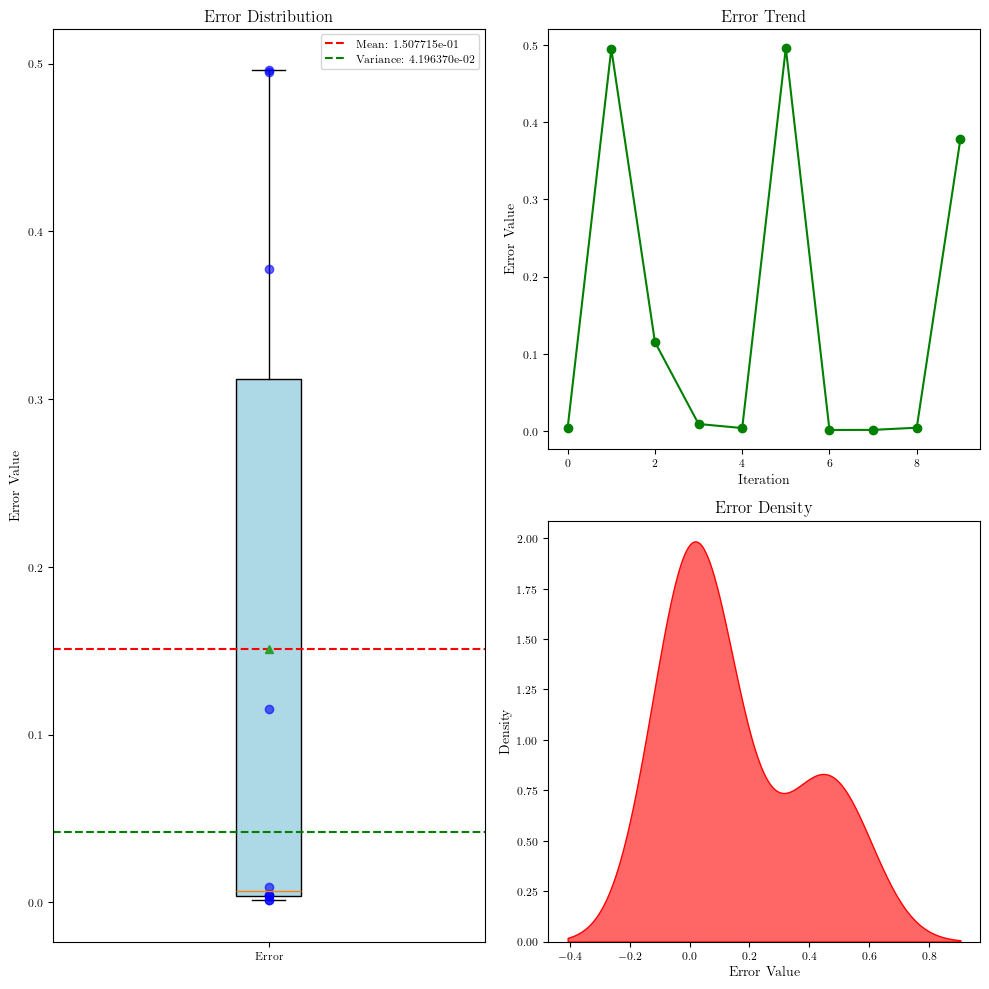

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 1.676942e-02
Variance MAE: 6.011480e-04


/tmp/ipykernel_2682975/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


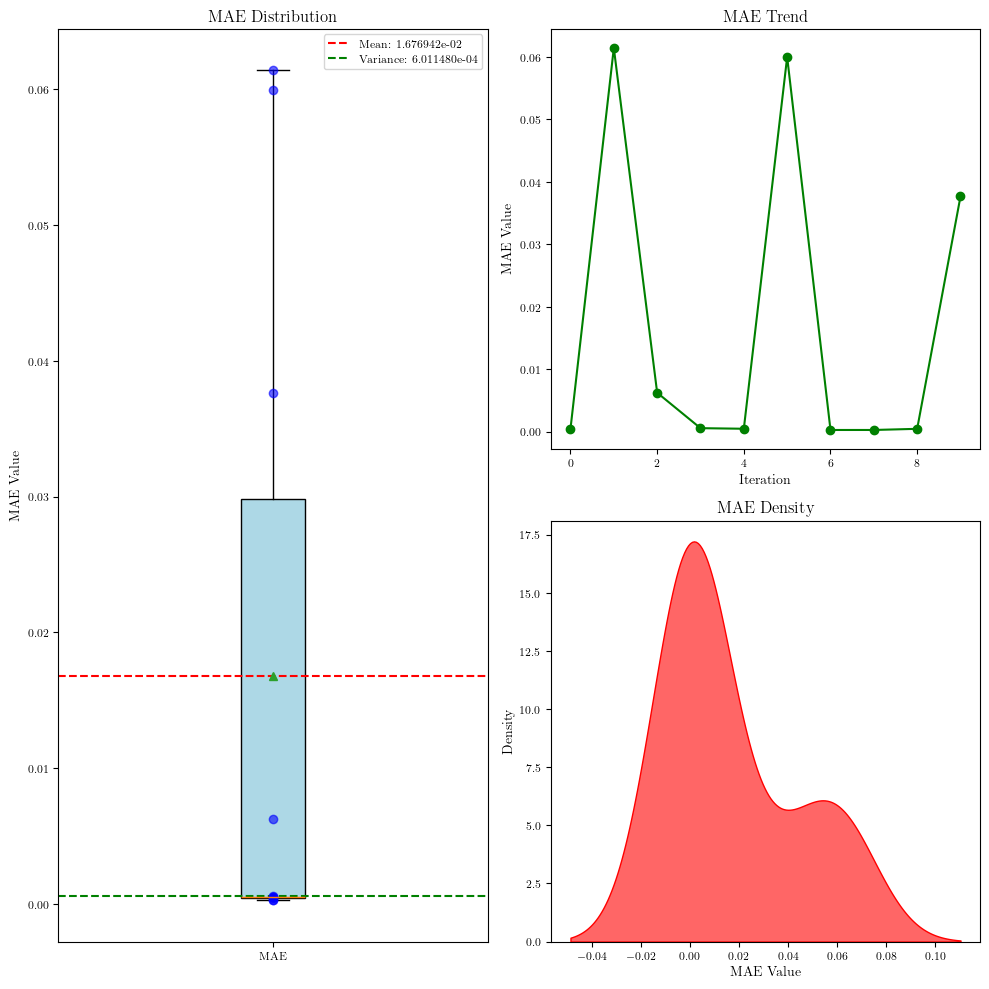

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 2.441686e-02
Variance MSE: 1.412339e-03


/tmp/ipykernel_2682975/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


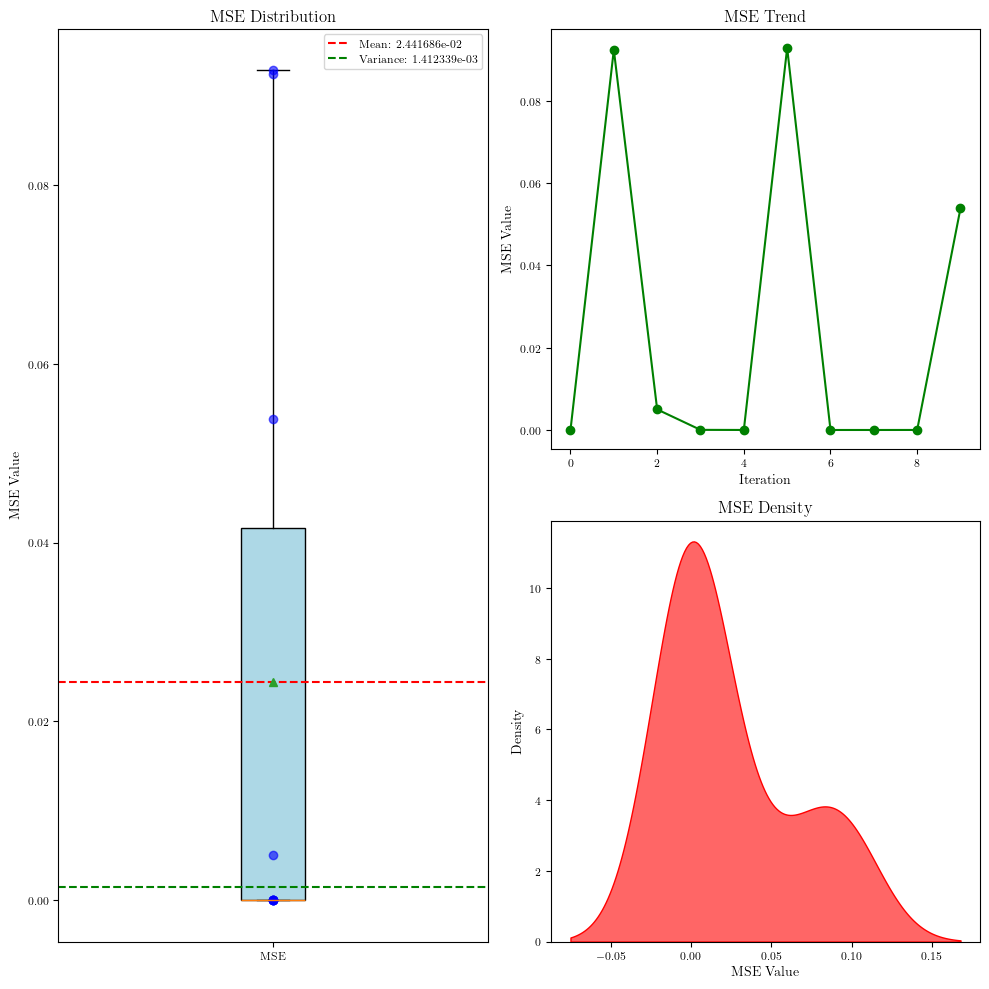

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

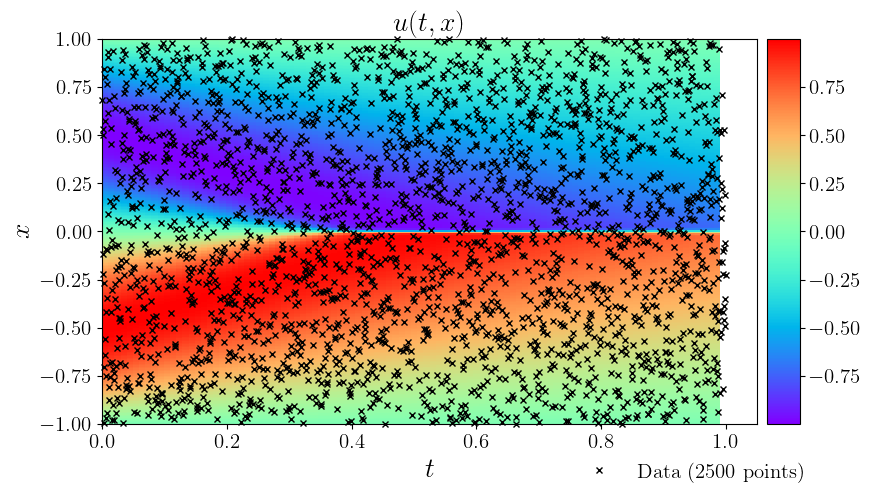

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

57269
[6.0001528e-01 5.7925141e-01 5.5952275e-01 ... 1.2953889e-04 1.2953793e-04
 1.2953590e-04]


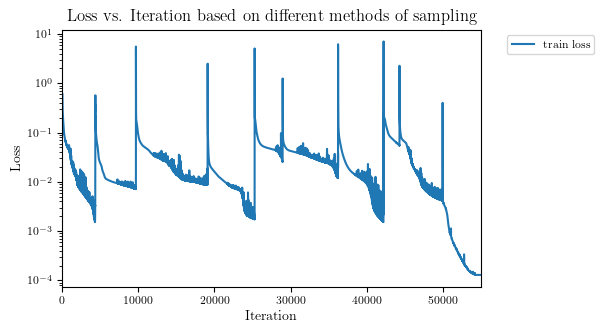

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

57269
[1.3411124  1.3215016  1.3025525  ... 0.3778224  0.37782234 0.3778224 ]


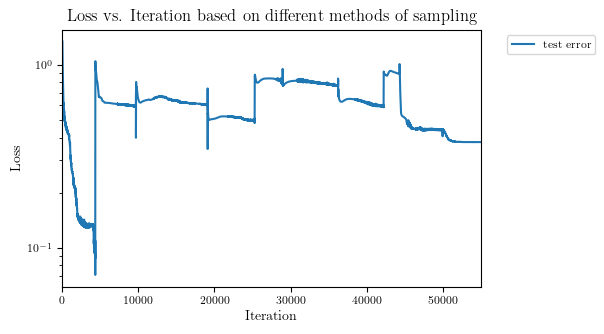

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


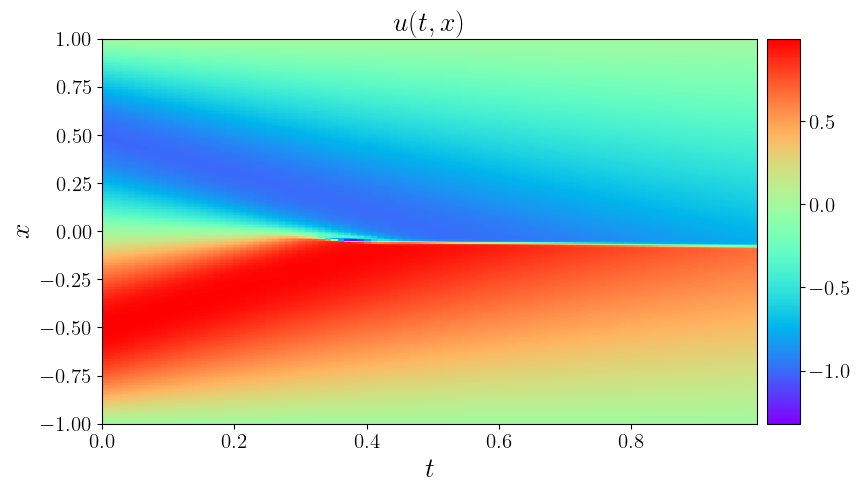

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

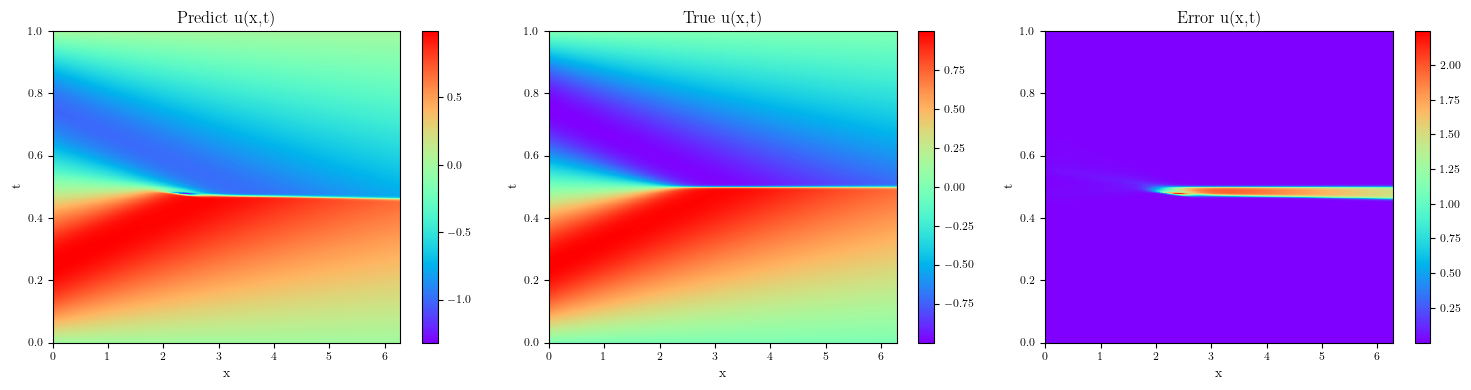

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

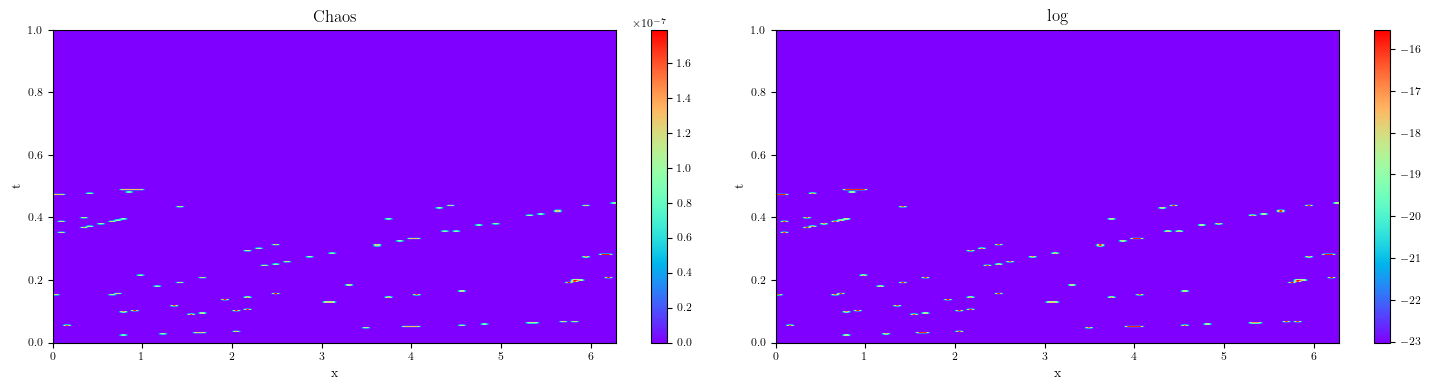

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()